In [1]:
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import numpy as np
import glob
import tensorflow as tfl
import tensorflow.compat.v2 as tf
import tensorflow.compat.v1 as tf1
from os.path import join
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pickle as pkl
import matplotlib.pyplot as pylab


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
import os

# Dependency imports
from absl import flags
from absl import logging
from six.moves import cPickle as pickle
from six.moves import urllib
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions


In [ ]:
global Resultats 
Resultats = []

## Choice of topics

In [2]:
topic_1 = "In probability theory Dirichlet processes after Peter Gustav Lejeune Dirichlet are a family of stochastic processes whose realizations are probability distributions"
topic_2 = "Leads in individual states may change from one party to another as all the votes are counted Select a state"
topic_3 = "BankPolicies creates bank policy job description and form templates designed to make your job easier"

In [3]:
topics_of_simulated_data = [topic_1, topic_2, topic_3]
topics_of_simulated_data

['In probability theory Dirichlet processes after Peter Gustav Lejeune Dirichlet are a family of stochastic processes whose realizations are probability distributions',
 'Leads in individual states may change from one party to another as all the votes are counted Select a state',
 'BankPolicies creates bank policy job description and form templates designed to make your job easier']

## $\beta$ matrix computation as empirical distribution of the vocabulary words over topics

### Count of the occurrences of each words of the vocabulary per topic

In [5]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(topics_of_simulated_data)
vocabulary_of_simulated_data = vectorizer.get_feature_names()
print("Vocabulary :", vocabulary_of_simulated_data)

print("Vocabulary size: ", len(vocabulary_of_simulated_data))
print(X.toarray())

Vocabulary : ['after', 'all', 'and', 'another', 'are', 'as', 'bank', 'bankpolicies', 'change', 'counted', 'creates', 'description', 'designed', 'dirichlet', 'distributions', 'easier', 'family', 'form', 'from', 'gustav', 'in', 'individual', 'job', 'leads', 'lejeune', 'make', 'may', 'of', 'one', 'party', 'peter', 'policy', 'probability', 'processes', 'realizations', 'select', 'state', 'states', 'stochastic', 'templates', 'the', 'theory', 'to', 'votes', 'whose', 'your']
Vocabulary size:  46
[[1 0 0 0 2 0 0 0 0 0 0 0 0 2 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 2 2 1 0
  0 0 1 0 0 1 0 0 1 0]
 [0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1
  1 1 0 0 1 0 1 1 0 0]
 [0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 2 0 0 1 0 0 0 0 0 1 0 0 0 0
  0 0 0 1 0 0 1 0 0 1]]


### Transformation of the count matrix $X$ as DataFrame

In [6]:
data = pd.DataFrame(data = X.toarray(), index = ["topic_1", "topic_2", "topic_3"], columns = vocabulary_of_simulated_data)

data

after  all  and  another  are  as  ...  the  theory  to  votes  whose  your
topic_1      1    0    0        0    2   0  ...    0       1   0      0      1     0
topic_2      0    1    0        1    1   1  ...    1       0   1      1      0     0
topic_3      0    0    1        0    0   0  ...    0       0   1      0      0     1

[3 rows x 46 columns]

### Number of words per topic

In [7]:
np.sum(data, axis = 1)

topic_1    20
topic_2    19
topic_3    15
dtype: int64

### Computation of $\beta$ matrix by normalization of each row of $X$ matrix

In [8]:
beta = pd.DataFrame()
beta

Empty DataFrame
Columns: []
Index: []

In [9]:
def compute_proprtion_per_line(df, row_index):
  return df.loc[row_index, :]/np.sum(df.loc[row_index, :])

In [10]:
for index in data.index:
  row = compute_proprtion_per_line(df = data.copy(), row_index = index)
  beta = pd.concat([beta, row], axis= 1)
  
beta = beta.T
beta

after       all       and  ...     votes  whose      your
topic_1   0.05  0.000000  0.000000  ...  0.000000   0.05  0.000000
topic_2   0.00  0.052632  0.000000  ...  0.052632   0.00  0.000000
topic_3   0.00  0.000000  0.066667  ...  0.000000   0.00  0.066667

[3 rows x 46 columns]

In [11]:
np.sum(beta, axis = 1)

topic_1    1.0
topic_2    1.0
topic_3    1.0
dtype: float64

## Corpus simulation

In [14]:
avg_doc_length = 60
alpha = [1., 1., 1.]

### Document simulation with the generative process supposed by LDA model

In [15]:
def lda_model ():
  Root = tfd.JointDistributionCoroutine.Root
  n = yield Root (tfd.Poisson( rate = avg_doc_length))
  theta = yield Root (tfd.Dirichlet (concentration = tfp.util.TransformedVariable(alpha , tfp.bijectors.Softplus())))
  z = yield tfd.Multinomial(total_count = n , probs = theta) # Nbre d'occurences du topic i dans le document,
                                                               # La somme des éléments du vecteur donne la taille n du document
  w = yield tfd.Multinomial(total_count = z , probs = beta)
  # w = yield tfd.Independent(tfd.Multinomial(total_count = z , probs = beta), reinterpreted_batch_ndims = 1)
lda = tfd.JointDistributionCoroutine(lda_model)

In [16]:
tfl.random.set_seed(1234)
print(lda.sample())
lda.sample()

(<tf.Tensor: shape=(), dtype=float32, numpy=64.0>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.4155007 , 0.35036054, 0.23413871], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([28., 25., 11.], dtype=float32)>, <tf.Tensor: shape=(3, 46), dtype=float32, numpy=
array([[0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0.,
        0., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        7., 1., 2., 0., 0., 0., 3., 0., 0., 1., 0., 0., 3., 0.],
       [0., 0., 0., 7., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 3., 0., 0., 2., 0., 0., 1., 0., 0.,
        0., 0., 0., 3., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 2.,
        0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
      dtype=float32)>)


(<tf.Tensor: shape=(), dtype=float32, numpy=67.0>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.26904765, 0.02583915, 0.70511323], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([18.,  3., 46.], dtype=float32)>,
 <tf.Tensor: shape=(3, 46), dtype=float32, numpy=
 array([[1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 3., 1., 0., 0., 3., 4., 0., 0., 0., 5.,
         0., 4., 0., 0., 0., 0., 8., 0., 0., 3., 0., 0., 0., 0., 0., 6.,
         0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 2., 0., 0., 2.]],
       dtype=float32)>)

In [17]:
def documents_from_lda_model(M):
  documents = pd.DataFrame()
  for d in range(M):
    lda_sample = lda.sample()
    #print(lda_sample)
    document_topics_words = pd.DataFrame(data = lda_sample[3].numpy(), index = ["topic_1", "topic_2", "topic_3"], columns = vocabulary_of_simulated_data)
    document = np.sum(document_topics_words, axis = 0)
    documents = pd.concat([documents, document], axis= 1, ignore_index = True)
  return documents.T


### Simulation of 1 000 documents

In [18]:
tfl.random.set_seed(1234)
corpus = documents_from_lda_model(1000)
corpus

after  all  and  another  are   as  ...  the  theory   to  votes  whose  your
0      0.0  0.0  0.0      7.0  2.0  1.0  ...  1.0     1.0  1.0    1.0    3.0   0.0
1      1.0  0.0  1.0      2.0  3.0  0.0  ...  0.0     0.0  2.0    0.0    2.0   2.0
2      0.0  2.0  0.0      1.0  2.0  4.0  ...  1.0     0.0  4.0    1.0    0.0   0.0
3      0.0  0.0  0.0      2.0  5.0  1.0  ...  0.0     0.0  2.0    0.0    1.0   1.0
4      2.0  4.0  1.0      0.0  0.0  2.0  ...  0.0     1.0  3.0    1.0    1.0   0.0
..     ...  ...  ...      ...  ...  ...  ...  ...     ...  ...    ...    ...   ...
995    0.0  4.0  0.0      1.0  4.0  3.0  ...  4.0     0.0  4.0    4.0    0.0   0.0
996    0.0  1.0  3.0      0.0  2.0  1.0  ...  2.0     1.0  5.0    0.0    0.0   2.0
997    0.0  0.0  0.0      0.0  3.0  0.0  ...  0.0     1.0  3.0    0.0    1.0   4.0
998    2.0  0.0  0.0      0.0  4.0  0.0  ...  0.0     0.0  1.0    2.0    2.0   0.0
999    1.0  0.0  1.0      1.0  3.0  1.0  ...  3.0     2.0  2.0    0.0    0.0   2.0

[1000 rows x 46 columns]

## Create of HDP corpus

In [20]:
vocabulary_hdp = {}
for k in range(len(vocabulary_of_simulated_data)):
  vocabulary_hdp[k+1] = vocabulary_of_simulated_data[k]
vocabulary_hdp

{1: 'after',
 2: 'all',
 3: 'and',
 4: 'another',
 5: 'are',
 6: 'as',
 7: 'bank',
 8: 'bankpolicies',
 9: 'change',
 10: 'counted',
 11: 'creates',
 12: 'description',
 13: 'designed',
 14: 'dirichlet',
 15: 'distributions',
 16: 'easier',
 17: 'family',
 18: 'form',
 19: 'from',
 20: 'gustav',
 21: 'in',
 22: 'individual',
 23: 'job',
 24: 'leads',
 25: 'lejeune',
 26: 'make',
 27: 'may',
 28: 'of',
 29: 'one',
 30: 'party',
 31: 'peter',
 32: 'policy',
 33: 'probability',
 34: 'processes',
 35: 'realizations',
 36: 'select',
 37: 'state',
 38: 'states',
 39: 'stochastic',
 40: 'templates',
 41: 'the',
 42: 'theory',
 43: 'to',
 44: 'votes',
 45: 'whose',
 46: 'your'}

In [27]:
with open('./dictionary_docs_hdp.pkl', 'wb') as f:
  pickle.dump(vocabulary_hdp, f)

In [21]:
doc_hdp = {}
#corpus.shape[0]
for k in range(corpus.shape[0]):
  words = ""
  for word in range(corpus.shape[1]):
    count = int(corpus.iloc[k:(k+1), word:(word+1)].values)
    if count != 0:
      #print(count)
      for token in range(count):
        words += " " + str(word + 1) 
  doc_hdp[k] = words.strip()
doc_hdp

{0: '4 4 4 4 4 4 4 5 5 6 7 9 10 12 12 13 14 14 14 14 16 16 20 20 21 21 22 23 23 24 24 24 26 27 27 28 30 31 32 33 33 33 33 33 33 33 34 35 35 36 36 36 37 38 39 39 39 41 42 43 44 45 45 45',
 1: '1 3 4 4 5 5 5 7 7 7 8 11 11 11 12 12 12 12 14 15 16 16 16 16 16 17 18 18 18 18 20 20 21 23 23 23 23 23 23 23 23 26 26 26 32 32 32 32 32 32 33 34 34 34 35 35 37 40 40 40 40 43 43 45 45 46 46',
 2: '2 2 4 5 5 6 6 6 6 8 10 10 14 15 16 19 19 19 21 22 22 24 24 24 24 29 29 29 29 30 30 30 30 31 33 33 36 36 37 37 37 37 38 38 38 38 41 43 43 43 43 44',
 3: '4 4 5 5 5 5 5 6 7 7 8 9 10 11 11 11 12 12 13 13 13 13 14 14 15 16 18 18 18 18 18 18 19 20 22 22 23 23 23 23 24 26 26 26 26 27 27 29 31 33 33 34 34 37 38 40 40 43 43 45 46',
 4: '1 1 2 2 2 2 3 6 6 7 8 8 9 10 11 12 13 14 14 18 18 18 18 19 20 21 22 22 23 25 26 27 27 28 29 32 33 34 37 37 38 38 39 40 42 43 43 43 44 45',
 5: '1 3 5 5 6 7 8 9 10 11 11 13 13 13 14 14 14 14 14 14 15 16 18 18 19 19 19 19 20 22 22 23 23 23 23 23 24 25 25 26 28 28 28 28 29 30 30 31 

### Split of the hdp corpus into train and test datasets

In [24]:
corpus_hdp_train, corpus_hdp_test = train_test_split(doc_hdp, test_size = 0.3, random_state = 42)
print(len(corpus_hdp_train))

700


In [25]:
with open("corpus_hdp_train_id.txt", "w") as file_object:
  for i in range(len(corpus_hdp_train)):
      #file_object.seek(2)
      #next(file_object)
      file_object.write(corpus_hdp_train[i])

## LDA estimation

In [19]:
corpus_converted = scipy.sparse.csc_matrix(corpus)
corpus_converted

<1000x46 sparse matrix of type '<class 'numpy.float32'>'
	with 28078 stored elements in Compressed Sparse Column format>

In [ ]:
type(corpus_converted)

scipy.sparse.csc.csc_matrix

### Split of the LDA corpus into train and test datasets

In [28]:
data_train, data_test = train_test_split(corpus_converted, test_size = 0.3, random_state = 42)

scipy.sparse.save_npz('./train_simulated_data.npz', data_train)
scipy.sparse.save_npz('./test_simulated_data.npz', data_test)



### LDA estimation with a variation EM algorithm (amortized variational inference)

In [ ]:
##########################################

flags.DEFINE_float(
    "learning_rate", default=3e-4, help="Learning rate.")
flags.DEFINE_integer(
    "max_steps", default = 970000, help="Number of training steps to run.")
flags.DEFINE_integer(
    "num_topics",
    default = 3,
    help="The number of topics.")
flags.DEFINE_list(
    "layer_sizes",
    default=["300", "300", "300"],
    help="Comma-separated list denoting hidden units per layer in the encoder.")
flags.DEFINE_string(
    "activation",
    default="relu",
    help="Activation function for all hidden layers.")
flags.DEFINE_integer(
    "batch_size",
    default=32,
    help="Batch size.")
flags.DEFINE_float(
    "prior_initial_value", default=0.7, help="The initial value for prior.")
flags.DEFINE_integer(
    "prior_burn_in_steps",
    default=120000,
    help="The number of training steps with fixed prior.")
#flags.DEFINE_string(
#    "data_dir",
#    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"), "lda/data"),
#    help="Directory where data is stored (if using real data).")
flags.DEFINE_string(
    "model_dir",
    default=os.path.join(os.getenv("TEST_TMPDIR", "/tmp"), "lda/"),
    help="Directory to put the model's fit.")
flags.DEFINE_integer(
    "viz_steps", default=10000, help="Frequency at which save visualizations.")
flags.DEFINE_bool("fake_data", default=False, help="If true, uses fake data.")
flags.DEFINE_bool(
    "delete_existing",
    default=False,
    help="If true, deletes existing directory.")

FLAGS = flags.FLAGS


def _clip_dirichlet_parameters(x):
  """Clips Dirichlet param for numerically stable KL and nonzero samples."""
  return tf.clip_by_value(x, .1, 1e3)


def make_encoder(activation, num_topics, layer_sizes):
  """Create the encoder function.
  Args:
    activation: Activation function to use.
    num_topics: The number of topics.
    layer_sizes: The number of hidden units per layer in the encoder.
  Returns:
    encoder: A `callable` mapping a bag-of-words `Tensor` to a
      `tfd.Distribution` instance over topics.
  """
  encoder_net = tf.keras.Sequential()
  for num_hidden_units in layer_sizes:
    encoder_net.add(
        tf.keras.layers.Dense(
            num_hidden_units,
            activation=activation,
            kernel_initializer=tf.initializers.GlorotNormal()))
  encoder_net.add(
      tf.keras.layers.Dense(
          num_topics,
          activation=lambda x: _clip_dirichlet_parameters(tf.nn.softplus(x)),
          kernel_initializer=tf.initializers.GlorotNormal()))

  def encoder(bag_of_words):
    with tf.name_scope("encoder"):
      return tfd.Dirichlet(concentration=encoder_net(bag_of_words),
                           name="topics_posterior")

  return encoder


def make_decoder(num_topics, num_words):
  """Create the decoder function.
  Args:
    num_topics: The number of topics.
    num_words: The number of words.
  Returns:
    decoder: A `callable` mapping a `Tensor` of encodings to a
      `tfd.Distribution` instance over words.
  """
  topics_words = tfp.util.TransformedVariable(
      tf.nn.softmax(tf.initializers.GlorotNormal()([num_topics, num_words])),
      tfb.SoftmaxCentered(),
      name="topics_words")

  def decoder(topics):
    word_probs = tf.matmul(topics, topics_words)
    # The observations are bag of words and therefore not one-hot. However,
    # log_prob of OneHotCategorical computes the probability correctly in
    # this case.
    return tfd.OneHotCategorical(probs=word_probs, name="bag_of_words")

  return decoder, topics_words


def make_prior(num_topics, initial_value):
  """Create the prior distribution.
  Args:
    num_topics: Number of topics.
    initial_value: The starting value for the prior parameters.
  Returns:
    prior: A `callable` that returns a `tf.distribution.Distribution`
        instance, the prior distribution.
  """
  concentration = tfp.util.TransformedVariable(
      tf.fill([1, num_topics], initial_value),
      tfb.Softplus(),
      name="concentration")

  return tfd.Dirichlet(
      concentration=tfp.util.DeferredTensor(
          concentration, _clip_dirichlet_parameters),
      name="topics_prior")


def model_fn(features, labels, mode, params, config):
  """Build the model function for use in an estimator.
  Arguments:
    features: The input features for the estimator.
    labels: The labels, unused here.
    mode: Signifies whether it is train or test or predict.
    params: Some hyperparameters as a dictionary.
    config: The RunConfig, unused here.
  Returns:
    EstimatorSpec: A tf.estimator.EstimatorSpec instance.
  """
  del labels, config

  encoder = make_encoder(params["activation"],
                         params["num_topics"],
                         params["layer_sizes"])
  decoder, topics_words = make_decoder(params["num_topics"],
                                       features.shape[1])
  topics_prior = make_prior(params["num_topics"],
                            params["prior_initial_value"])

  alpha = topics_prior.concentration

  topics_posterior = encoder(features)
  topics = topics_posterior.sample(seed=234)
  random_reconstruction = decoder(topics)

  reconstruction = random_reconstruction.log_prob(features)
  tf1.summary.scalar("reconstruction", tf.reduce_mean(reconstruction))

  # Compute the KL-divergence between two Dirichlets analytically.
  # The sampled KL does not work well for "sparse" distributions
  # (see Appendix D of [2]).
  kl = tfd.kl_divergence(topics_posterior, topics_prior)
  tf1.summary.scalar("kl", tf.reduce_mean(kl))

  # Ensure that the KL is non-negative (up to a very small slack).
  # Negative KL can happen due to numerical instability.
  with tf.control_dependencies(
      [tf.debugging.assert_greater(kl, -1e-3, message="kl")]):
    kl = tf.identity(kl)

  elbo = reconstruction - kl
  avg_elbo = tf.reduce_mean(elbo)
  tf1.summary.scalar("elbo", avg_elbo)
  loss = -avg_elbo

  # Perform variational inference by minimizing the -ELBO.
  global_step = tf1.train.get_or_create_global_step()
  optimizer = tf1.train.AdamOptimizer(params["learning_rate"])

  # This implements the "burn-in" for prior parameters (see Appendix D of [2]).
  # For the first prior_burn_in_steps steps they are fixed, and then trained
  # jointly with the other parameters.
  grads_and_vars = optimizer.compute_gradients(loss)
  grads_and_vars_except_prior = [
      x for x in grads_and_vars if x[1] not in topics_prior.variables]

  def train_op_except_prior():
    return optimizer.apply_gradients(
        grads_and_vars_except_prior,
        global_step=global_step)

  def train_op_all():
    return optimizer.apply_gradients(
        grads_and_vars,
        global_step=global_step)

  train_op = tf.cond(
      pred=global_step < params["prior_burn_in_steps"],
      true_fn=train_op_except_prior,
      false_fn=train_op_all)

  # The perplexity is an exponent of the average negative ELBO per word.
  words_per_document = tf.reduce_sum(features, axis=1)
  log_perplexity = -elbo / words_per_document
  tf1.summary.scalar("perplexity", tf.exp(tf.reduce_mean(log_perplexity)))
  (log_perplexity_tensor,
   log_perplexity_update) = tf1.metrics.mean(log_perplexity)
  perplexity_tensor = tf.exp(log_perplexity_tensor)

  # Obtain the topics summary. Implemented as a py_func for simplicity.
  topics = tf1.py_func(
      functools.partial(get_topics_strings, vocabulary=params["vocabulary"]),
      [topics_words, alpha],
      tf.string,
      stateful=False)
  tf1.summary.text("topics", topics)

  return tf1.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=train_op,
      eval_metric_ops={
          "elbo": tf1.metrics.mean(elbo),
          "reconstruction": tf1.metrics.mean(reconstruction),
          "kl": tf1.metrics.mean(kl),
          "perplexity": (perplexity_tensor, log_perplexity_update),
          "topics": (topics, tf.no_op()),
      },
  )


def get_topics_strings(topics_words, alpha, vocabulary,
                       topics_to_print = 3, words_per_topic = 15):
  """Returns the summary of the learned topics.
  Arguments:
    topics_words: KxV tensor with topics as rows and words as columns.
    alpha: 1xK tensor of prior Dirichlet concentrations for the
        topics.
    vocabulary: A mapping of word's integer index to the corresponding string.
    topics_to_print: The number of topics with highest prior weight to
        summarize.
    words_per_topic: Number of wodrs per topic to return.
  Returns:
    summary: A np.array with strings.
  """
  alpha = np.squeeze(alpha, axis=0)
  # Use a stable sorting algorithm so that when alpha is fixed
  # we always get the same topics.
  highest_weight_topics = np.argsort(-alpha, kind="mergesort")
  top_words = np.argsort(-topics_words, axis=1)

  res = []
  for topic_idx in highest_weight_topics[:topics_to_print]:
    l = ["index={} alpha={:.2f}".format(topic_idx, alpha[topic_idx])]
    l += [vocabulary[word] for word in top_words[topic_idx, :words_per_topic]]
    res.append(" ".join(l))

  return np.array(res)


#ROOT_PATH = "https://github.com/akashgit/autoencoding_vi_for_topic_models/raw/9db556361409ecb3a732f99b4ef207aeb8516f83/data/20news_clean"
#FILE_TEMPLATE = "{split}.txt.npy"


def download(directory, filename):
  """Download a file."""
  filepath = os.path.join(directory, filename)
  if tf.io.gfile.exists(filepath):
    return filepath
  if not tf.io.gfile.exists(directory):
    tf.io.gfile.makedirs(directory)
  url = os.path.join(ROOT_PATH, filename)
  print("Downloading %s to %s" % (url, filepath))
  urllib.request.urlretrieve(url, filepath)
  return filepath


#################################################################################

def load_processed_data(train_or_test, shuffle_and_repeat=False):

  """train_or_test = 'train'
  train_or_test = 'test'"""
  # nips_authors_path = 'edward_lda/data/04_feature/nips12ac_str602.mat'
  simulated_data_processed_path = f'./{train_or_test}_simulated_data.npz'
  bow = scipy.sparse.load_npz(simulated_data_processed_path)
  #bow = mat['counts']
  #vocabulary = mat['wl']
  #vocabulary = [w[0][0] for w in vocabulary]
  #word_count = mat['wc']
  print(bow.shape)
  vocabulary_size = bow.shape[1] # 13649
  corpus_size = bow.shape[0] # 1740

  print('vocabulary size : ', vocabulary_size)
  print('corpus size : ', corpus_size)

  # from csc matrix to csr
  bow = bow.tocsr()
  bow = bow.astype('float32')
  #bow = bow.T
  dataset = tf.data.Dataset.range(corpus_size)

  # For training, we shuffle each epoch and repeat the epochs.
  if shuffle_and_repeat:
    dataset = dataset.shuffle(corpus_size).repeat()

  # Returns a single document as a dense TensorFlow tensor. The dataset is
  # stored as a sparse matrix outside of the graph.
  def get_row_py_func(idx):
    def get_row_python(idx_py):
      return np.squeeze(np.array(bow[idx_py].todense()), axis=0)

    py_func = tf1.py_func(
        get_row_python, [idx], tf.float32, stateful=False)
    py_func.set_shape((vocabulary_size,))
    return py_func

  dataset = dataset.map(get_row_py_func)
  return dataset
##################################################################################


def build_fake_input_fns(batch_size):
  """Build fake data for unit testing."""
  num_words = 1000
  vocabulary = [str(i) for i in range(num_words)]

  random_sample = np.random.randint(
      10, size=(batch_size, num_words)).astype(np.float32)

  def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices(random_sample)
    dataset = dataset.batch(batch_size)
    return tf1.data.make_one_shot_iterator(dataset.repeat()).get_next()

  def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices(random_sample)
    dataset = dataset.batch(batch_size)
    return tf1.data.make_one_shot_iterator(dataset).get_next()

  return train_input_fn, eval_input_fn, vocabulary


#################################################################################
def build_input_fns(batch_size):
  """Builds iterators for train and evaluation data.
  Each object is represented as a bag-of-words vector.
  Arguments:
  batch_size: Batch size for both train and evaluation.
  Returns:
  train_input_fn: A function that returns an iterator over the training data.
  eval_input_fn: A function that returns an iterator over the evaluation data.
  vocabulary: A mapping of word's integer index to the corresponding string.
  """
  vocabulary = vocabulary_of_simulated_data
  # Build an iterator over training batches.
  def train_input_fn():

    dataset = load_processed_data("train", shuffle_and_repeat=True)
  # Prefetching makes training about 1.5x faster.
    dataset = dataset.batch(batch_size).prefetch(32)
    return tf1.data.make_one_shot_iterator(dataset).get_next()

  # Build an iterator over the heldout set.

  def eval_input_fn():
    dataset = load_processed_data("test", shuffle_and_repeat=False)
    dataset = dataset.batch(batch_size)
    return tf1.data.make_one_shot_iterator(dataset).get_next()
  return train_input_fn, eval_input_fn, vocabulary

#################################################################################


def main(argv):
  del argv  # unused

  params = FLAGS.flag_values_dict()
  params["layer_sizes"] = [int(units) for units in params["layer_sizes"]]
  params["activation"] = getattr(tf.nn, params["activation"])
  if FLAGS.delete_existing and tf.io.gfile.exists(FLAGS.model_dir):
    logging.warn("Deleting old log directory at %s", FLAGS.model_dir)
    tf.io.gfile.rmtree(FLAGS.model_dir)
  tf.io.gfile.makedirs(FLAGS.model_dir)

  if FLAGS.fake_data:
    train_input_fn, eval_input_fn, vocabulary = build_fake_input_fns(
        FLAGS.batch_size)
  else:
    train_input_fn, eval_input_fn, vocabulary = build_input_fns(FLAGS.batch_size)
  params["vocabulary"] = vocabulary

  estimator = tf.estimator.Estimator(
      model_fn,
      params=params,
      config=tf.estimator.RunConfig(
          model_dir=FLAGS.model_dir,
          save_checkpoints_steps=FLAGS.viz_steps,
      ),
  )
  
  
  tf.random.set_seed(123)
  for _ in range(FLAGS.max_steps // FLAGS.viz_steps):
    estimator.train(train_input_fn, steps=FLAGS.viz_steps)
    eval_results = estimator.evaluate(eval_input_fn)
    #Result_Kl.append(estimator)
    Resultats.append(eval_results)
    # Print the evaluation results. The keys are strings specified in
    # eval_metric_ops, and the values are NumPy scalars/arrays.
    for key, value in eval_results.items():
      print(key)
      if key == "topics":
        # Topics description is a np.array which prints better row-by-row.
        for s in value:
          print(s)
      else:
        print(str(value))
      print("")
    print("")

if __name__ == "__main__":
  tf1.app.run()


INFO:tensorflow:Using config: {'_model_dir': '/tmp/lda/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0105 19:17:11.732842 140089464887168 estimator.py:191] Using config: {'_model_dir': '/tmp/lda/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0105 19:17:11.768696 140089464887168 deprecation.py:339] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


(700, 46)
vocabulary size :  46
corpus size :  700
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


W0105 19:17:11.870159 140089464887168 deprecation.py:339] From <ipython-input-17-f6b0d247c6fc>:313: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


INFO:tensorflow:Calling model_fn.


I0105 19:17:11.899200 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:17:12.611715 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:17:12.615599 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:17:12.863619 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0105 19:17:12.990298 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:17:13.010666 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0105 19:17:13.485733 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/lda/model.ckpt.


I0105 19:17:13.489053 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0105 19:17:13.619706 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 229.09012, step = 0


I0105 19:17:14.003213 140089464887168 basic_session_run_hooks.py:262] loss = 229.09012, step = 0


INFO:tensorflow:global_step/sec: 62.1967


I0105 19:17:15.610178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.1967


INFO:tensorflow:loss = 223.50775, step = 100 (1.612 sec)


I0105 19:17:15.615548 140089464887168 basic_session_run_hooks.py:260] loss = 223.50775, step = 100 (1.612 sec)


INFO:tensorflow:global_step/sec: 66.2618


I0105 19:17:17.119342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2618


INFO:tensorflow:loss = 230.15895, step = 200 (1.515 sec)


I0105 19:17:17.130781 140089464887168 basic_session_run_hooks.py:260] loss = 230.15895, step = 200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.9685


I0105 19:17:18.612619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9685


INFO:tensorflow:loss = 229.29384, step = 300 (1.485 sec)


I0105 19:17:18.616214 140089464887168 basic_session_run_hooks.py:260] loss = 229.29384, step = 300 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.0446


I0105 19:17:20.126755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0446


INFO:tensorflow:loss = 223.60808, step = 400 (1.514 sec)


I0105 19:17:20.130335 140089464887168 basic_session_run_hooks.py:260] loss = 223.60808, step = 400 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.536


I0105 19:17:21.629684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.536


INFO:tensorflow:loss = 230.10095, step = 500 (1.508 sec)


I0105 19:17:21.638071 140089464887168 basic_session_run_hooks.py:260] loss = 230.10095, step = 500 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.8285


I0105 19:17:23.126028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8285


INFO:tensorflow:loss = 218.50775, step = 600 (1.497 sec)


I0105 19:17:23.135536 140089464887168 basic_session_run_hooks.py:260] loss = 218.50775, step = 600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.799


I0105 19:17:24.623050 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.799


INFO:tensorflow:loss = 222.09018, step = 700 (1.496 sec)


I0105 19:17:24.631224 140089464887168 basic_session_run_hooks.py:260] loss = 222.09018, step = 700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9614


I0105 19:17:26.116463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9614


INFO:tensorflow:loss = 228.71243, step = 800 (1.489 sec)


I0105 19:17:26.119825 140089464887168 basic_session_run_hooks.py:260] loss = 228.71243, step = 800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.4994


I0105 19:17:27.620241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4994


INFO:tensorflow:loss = 224.34938, step = 900 (1.509 sec)


I0105 19:17:27.628479 140089464887168 basic_session_run_hooks.py:260] loss = 224.34938, step = 900 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.4284


I0105 19:17:29.103290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4284


INFO:tensorflow:loss = 226.66199, step = 1000 (1.485 sec)


I0105 19:17:29.113416 140089464887168 basic_session_run_hooks.py:260] loss = 226.66199, step = 1000 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.8131


I0105 19:17:30.622748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8131


INFO:tensorflow:loss = 220.0759, step = 1100 (1.513 sec)


I0105 19:17:30.626078 140089464887168 basic_session_run_hooks.py:260] loss = 220.0759, step = 1100 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.2434


I0105 19:17:32.109863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2434


INFO:tensorflow:loss = 223.84137, step = 1200 (1.490 sec)


I0105 19:17:32.115995 140089464887168 basic_session_run_hooks.py:260] loss = 223.84137, step = 1200 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.466


I0105 19:17:33.637386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.466


INFO:tensorflow:loss = 220.30988, step = 1300 (1.532 sec)


I0105 19:17:33.647409 140089464887168 basic_session_run_hooks.py:260] loss = 220.30988, step = 1300 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.8161


I0105 19:17:35.134024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8161


INFO:tensorflow:loss = 223.67278, step = 1400 (1.495 sec)


I0105 19:17:35.142702 140089464887168 basic_session_run_hooks.py:260] loss = 223.67278, step = 1400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6654


I0105 19:17:36.634060 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6654


INFO:tensorflow:loss = 230.35957, step = 1500 (1.495 sec)


I0105 19:17:36.638032 140089464887168 basic_session_run_hooks.py:260] loss = 230.35957, step = 1500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6884


I0105 19:17:38.133583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6884


INFO:tensorflow:loss = 213.68726, step = 1600 (1.500 sec)


I0105 19:17:38.137750 140089464887168 basic_session_run_hooks.py:260] loss = 213.68726, step = 1600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.054


I0105 19:17:39.624898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.054


INFO:tensorflow:loss = 225.74487, step = 1700 (1.497 sec)


I0105 19:17:39.635186 140089464887168 basic_session_run_hooks.py:260] loss = 225.74487, step = 1700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2486


I0105 19:17:41.134371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2486


INFO:tensorflow:loss = 231.7333, step = 1800 (1.502 sec)


I0105 19:17:41.137434 140089464887168 basic_session_run_hooks.py:260] loss = 231.7333, step = 1800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.6031


I0105 19:17:42.635802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6031


INFO:tensorflow:loss = 223.57825, step = 1900 (1.507 sec)


I0105 19:17:42.644683 140089464887168 basic_session_run_hooks.py:260] loss = 223.57825, step = 1900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.4295


I0105 19:17:44.118825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4295


INFO:tensorflow:loss = 227.75848, step = 2000 (1.481 sec)


I0105 19:17:44.125388 140089464887168 basic_session_run_hooks.py:260] loss = 227.75848, step = 2000 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.2843


I0105 19:17:45.650624 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2843


INFO:tensorflow:loss = 222.2126, step = 2100 (1.537 sec)


I0105 19:17:45.662144 140089464887168 basic_session_run_hooks.py:260] loss = 222.2126, step = 2100 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.8273


I0105 19:17:47.146993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8273


INFO:tensorflow:loss = 223.05573, step = 2200 (1.493 sec)


I0105 19:17:47.154863 140089464887168 basic_session_run_hooks.py:260] loss = 223.05573, step = 2200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3616


I0105 19:17:48.653878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3616


INFO:tensorflow:loss = 217.90385, step = 2300 (1.507 sec)


I0105 19:17:48.661675 140089464887168 basic_session_run_hooks.py:260] loss = 217.90385, step = 2300 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.8092


I0105 19:17:50.173421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8092


INFO:tensorflow:loss = 215.39201, step = 2400 (1.521 sec)


I0105 19:17:50.182319 140089464887168 basic_session_run_hooks.py:260] loss = 215.39201, step = 2400 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.5215


I0105 19:17:51.676731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5215


INFO:tensorflow:loss = 221.89566, step = 2500 (1.500 sec)


I0105 19:17:51.682807 140089464887168 basic_session_run_hooks.py:260] loss = 221.89566, step = 2500 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2012


I0105 19:17:53.187262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2012


INFO:tensorflow:loss = 219.15906, step = 2600 (1.515 sec)


I0105 19:17:53.197914 140089464887168 basic_session_run_hooks.py:260] loss = 219.15906, step = 2600 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.0654


I0105 19:17:54.700905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0654


INFO:tensorflow:loss = 225.05605, step = 2700 (1.508 sec)


I0105 19:17:54.705710 140089464887168 basic_session_run_hooks.py:260] loss = 225.05605, step = 2700 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.4223


I0105 19:17:56.184105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4223


INFO:tensorflow:loss = 219.06491, step = 2800 (1.487 sec)


I0105 19:17:56.192611 140089464887168 basic_session_run_hooks.py:260] loss = 219.06491, step = 2800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.4565


I0105 19:17:57.666520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4565


INFO:tensorflow:loss = 213.67331, step = 2900 (1.484 sec)


I0105 19:17:57.676252 140089464887168 basic_session_run_hooks.py:260] loss = 213.67331, step = 2900 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3396


I0105 19:17:59.151538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3396


INFO:tensorflow:loss = 218.16924, step = 3000 (1.481 sec)


I0105 19:17:59.157094 140089464887168 basic_session_run_hooks.py:260] loss = 218.16924, step = 3000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.1673


I0105 19:18:00.640349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1673


INFO:tensorflow:loss = 228.26907, step = 3100 (1.488 sec)


I0105 19:18:00.644689 140089464887168 basic_session_run_hooks.py:260] loss = 228.26907, step = 3100 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.4485


I0105 19:18:02.145277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4485


INFO:tensorflow:loss = 234.53687, step = 3200 (1.520 sec)


I0105 19:18:02.164971 140089464887168 basic_session_run_hooks.py:260] loss = 234.53687, step = 3200 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.2673


I0105 19:18:03.677456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2673


INFO:tensorflow:loss = 216.6348, step = 3300 (1.517 sec)


I0105 19:18:03.681838 140089464887168 basic_session_run_hooks.py:260] loss = 216.6348, step = 3300 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.6947


I0105 19:18:05.176828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6947


INFO:tensorflow:loss = 215.52446, step = 3400 (1.504 sec)


I0105 19:18:05.185614 140089464887168 basic_session_run_hooks.py:260] loss = 215.52446, step = 3400 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6462


I0105 19:18:06.655099 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6462


INFO:tensorflow:loss = 214.19916, step = 3500 (1.473 sec)


I0105 19:18:06.659024 140089464887168 basic_session_run_hooks.py:260] loss = 214.19916, step = 3500 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.334


I0105 19:18:08.140232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.334


INFO:tensorflow:loss = 218.52727, step = 3600 (1.487 sec)


I0105 19:18:08.145820 140089464887168 basic_session_run_hooks.py:260] loss = 218.52727, step = 3600 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0626


I0105 19:18:09.631363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0626


INFO:tensorflow:loss = 232.57956, step = 3700 (1.497 sec)


I0105 19:18:09.642858 140089464887168 basic_session_run_hooks.py:260] loss = 232.57956, step = 3700 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.1102


I0105 19:18:11.121462 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1102


INFO:tensorflow:loss = 216.93124, step = 3800 (1.482 sec)


I0105 19:18:11.125320 140089464887168 basic_session_run_hooks.py:260] loss = 216.93124, step = 3800 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.5942


I0105 19:18:12.623093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5942


INFO:tensorflow:loss = 215.50778, step = 3900 (1.506 sec)


I0105 19:18:12.631307 140089464887168 basic_session_run_hooks.py:260] loss = 215.50778, step = 3900 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.7098


I0105 19:18:14.099987 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7098


INFO:tensorflow:loss = 212.30815, step = 4000 (1.478 sec)


I0105 19:18:14.109651 140089464887168 basic_session_run_hooks.py:260] loss = 212.30815, step = 4000 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.059


I0105 19:18:15.569289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.059


INFO:tensorflow:loss = 219.06, step = 4100 (1.464 sec)


I0105 19:18:15.573168 140089464887168 basic_session_run_hooks.py:260] loss = 219.06, step = 4100 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.7759


I0105 19:18:17.066839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7759


INFO:tensorflow:loss = 221.47952, step = 4200 (1.498 sec)


I0105 19:18:17.070831 140089464887168 basic_session_run_hooks.py:260] loss = 221.47952, step = 4200 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6685


I0105 19:18:18.544653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6685


INFO:tensorflow:loss = 211.06586, step = 4300 (1.480 sec)


I0105 19:18:18.551209 140089464887168 basic_session_run_hooks.py:260] loss = 211.06586, step = 4300 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3999


I0105 19:18:20.028332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3999


INFO:tensorflow:loss = 217.06259, step = 4400 (1.484 sec)


I0105 19:18:20.035224 140089464887168 basic_session_run_hooks.py:260] loss = 217.06259, step = 4400 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.7424


I0105 19:18:21.526648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7424


INFO:tensorflow:loss = 213.13884, step = 4500 (1.501 sec)


I0105 19:18:21.535836 140089464887168 basic_session_run_hooks.py:260] loss = 213.13884, step = 4500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9057


I0105 19:18:23.021244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9057


INFO:tensorflow:loss = 225.31409, step = 4600 (1.494 sec)


I0105 19:18:23.029754 140089464887168 basic_session_run_hooks.py:260] loss = 225.31409, step = 4600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8748


I0105 19:18:24.516600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8748


INFO:tensorflow:loss = 222.04007, step = 4700 (1.495 sec)


I0105 19:18:24.524722 140089464887168 basic_session_run_hooks.py:260] loss = 222.04007, step = 4700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.487


I0105 19:18:25.998357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.487


INFO:tensorflow:loss = 220.99667, step = 4800 (1.485 sec)


I0105 19:18:26.009730 140089464887168 basic_session_run_hooks.py:260] loss = 220.99667, step = 4800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.2078


I0105 19:18:27.508748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2078


INFO:tensorflow:loss = 213.28525, step = 4900 (1.509 sec)


I0105 19:18:27.519038 140089464887168 basic_session_run_hooks.py:260] loss = 213.28525, step = 4900 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.8557


I0105 19:18:29.027209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8557


INFO:tensorflow:loss = 215.13496, step = 5000 (1.521 sec)


I0105 19:18:29.039589 140089464887168 basic_session_run_hooks.py:260] loss = 215.13496, step = 5000 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.5291


I0105 19:18:30.530326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5291


INFO:tensorflow:loss = 214.1655, step = 5100 (1.495 sec)


I0105 19:18:30.534067 140089464887168 basic_session_run_hooks.py:260] loss = 214.1655, step = 5100 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.0779


I0105 19:18:32.021114 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0779


INFO:tensorflow:loss = 216.0861, step = 5200 (1.493 sec)


I0105 19:18:32.027238 140089464887168 basic_session_run_hooks.py:260] loss = 216.0861, step = 5200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.6349


I0105 19:18:33.521836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6349


INFO:tensorflow:loss = 222.65236, step = 5300 (1.501 sec)


I0105 19:18:33.528366 140089464887168 basic_session_run_hooks.py:260] loss = 222.65236, step = 5300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9265


I0105 19:18:35.016025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9265


INFO:tensorflow:loss = 215.25098, step = 5400 (1.491 sec)


I0105 19:18:35.019510 140089464887168 basic_session_run_hooks.py:260] loss = 215.25098, step = 5400 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3609


I0105 19:18:36.500555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3609


INFO:tensorflow:loss = 213.25421, step = 5500 (1.485 sec)


I0105 19:18:36.504244 140089464887168 basic_session_run_hooks.py:260] loss = 213.25421, step = 5500 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.0726


I0105 19:18:37.969588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0726


INFO:tensorflow:loss = 218.26718, step = 5600 (1.471 sec)


I0105 19:18:37.974889 140089464887168 basic_session_run_hooks.py:260] loss = 218.26718, step = 5600 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.9848


I0105 19:18:39.462443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9848


INFO:tensorflow:loss = 220.6616, step = 5700 (1.498 sec)


I0105 19:18:39.473153 140089464887168 basic_session_run_hooks.py:260] loss = 220.6616, step = 5700 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.0656


I0105 19:18:40.931660 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0656


INFO:tensorflow:loss = 213.51422, step = 5800 (1.464 sec)


I0105 19:18:40.937029 140089464887168 basic_session_run_hooks.py:260] loss = 213.51422, step = 5800 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.3857


I0105 19:18:42.437970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3857


INFO:tensorflow:loss = 215.67908, step = 5900 (1.510 sec)


I0105 19:18:42.447446 140089464887168 basic_session_run_hooks.py:260] loss = 215.67908, step = 5900 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.6708


I0105 19:18:43.937879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6708


INFO:tensorflow:loss = 212.8624, step = 6000 (1.494 sec)


I0105 19:18:43.941833 140089464887168 basic_session_run_hooks.py:260] loss = 212.8624, step = 6000 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.3652


I0105 19:18:45.444729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3652


INFO:tensorflow:loss = 218.30592, step = 6100 (1.507 sec)


I0105 19:18:45.449054 140089464887168 basic_session_run_hooks.py:260] loss = 218.30592, step = 6100 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.537


I0105 19:18:46.925351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.537


INFO:tensorflow:loss = 220.20805, step = 6200 (1.487 sec)


I0105 19:18:46.935932 140089464887168 basic_session_run_hooks.py:260] loss = 220.20805, step = 6200 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.1264


I0105 19:18:48.460828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1264


INFO:tensorflow:loss = 227.48288, step = 6300 (1.535 sec)


I0105 19:18:48.470708 140089464887168 basic_session_run_hooks.py:260] loss = 227.48288, step = 6300 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.5991


I0105 19:18:49.940138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5991


INFO:tensorflow:loss = 215.98218, step = 6400 (1.473 sec)


I0105 19:18:49.943316 140089464887168 basic_session_run_hooks.py:260] loss = 215.98218, step = 6400 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.662


I0105 19:18:51.440257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.662


INFO:tensorflow:loss = 223.38222, step = 6500 (1.505 sec)


I0105 19:18:51.448228 140089464887168 basic_session_run_hooks.py:260] loss = 223.38222, step = 6500 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.5951


I0105 19:18:52.941865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5951


INFO:tensorflow:loss = 213.79507, step = 6600 (1.497 sec)


I0105 19:18:52.945313 140089464887168 basic_session_run_hooks.py:260] loss = 213.79507, step = 6600 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2095


I0105 19:18:54.429753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2095


INFO:tensorflow:loss = 222.86594, step = 6700 (1.496 sec)


I0105 19:18:54.441484 140089464887168 basic_session_run_hooks.py:260] loss = 222.86594, step = 6700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6919


I0105 19:18:55.929177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6919


INFO:tensorflow:loss = 217.34538, step = 6800 (1.493 sec)


I0105 19:18:55.934276 140089464887168 basic_session_run_hooks.py:260] loss = 217.34538, step = 6800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5722


I0105 19:18:57.431305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5722


INFO:tensorflow:loss = 222.27664, step = 6900 (1.507 sec)


I0105 19:18:57.440973 140089464887168 basic_session_run_hooks.py:260] loss = 222.27664, step = 6900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.5301


I0105 19:18:58.912135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5301


INFO:tensorflow:loss = 216.36661, step = 7000 (1.480 sec)


I0105 19:18:58.921396 140089464887168 basic_session_run_hooks.py:260] loss = 216.36661, step = 7000 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.743


I0105 19:19:00.410407 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.743


INFO:tensorflow:loss = 221.66467, step = 7100 (1.499 sec)


I0105 19:19:00.419919 140089464887168 basic_session_run_hooks.py:260] loss = 221.66467, step = 7100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.437


I0105 19:19:01.893275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.437


INFO:tensorflow:loss = 216.2732, step = 7200 (1.477 sec)


I0105 19:19:01.896633 140089464887168 basic_session_run_hooks.py:260] loss = 216.2732, step = 7200 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.9324


I0105 19:19:03.410001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9324


INFO:tensorflow:loss = 213.2179, step = 7300 (1.517 sec)


I0105 19:19:03.413735 140089464887168 basic_session_run_hooks.py:260] loss = 213.2179, step = 7300 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.0262


I0105 19:19:04.901943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0262


INFO:tensorflow:loss = 214.86252, step = 7400 (1.493 sec)


I0105 19:19:04.906527 140089464887168 basic_session_run_hooks.py:260] loss = 214.86252, step = 7400 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5878


I0105 19:19:06.403728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5878


INFO:tensorflow:loss = 212.85747, step = 7500 (1.507 sec)


I0105 19:19:06.413676 140089464887168 basic_session_run_hooks.py:260] loss = 212.85747, step = 7500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.9543


I0105 19:19:07.897266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9543


INFO:tensorflow:loss = 207.06206, step = 7600 (1.495 sec)


I0105 19:19:07.908521 140089464887168 basic_session_run_hooks.py:260] loss = 207.06206, step = 7600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.8288


I0105 19:19:09.393652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8288


INFO:tensorflow:loss = 220.67357, step = 7700 (1.489 sec)


I0105 19:19:09.397179 140089464887168 basic_session_run_hooks.py:260] loss = 220.67357, step = 7700 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.3109


I0105 19:19:10.924791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3109


INFO:tensorflow:loss = 219.57637, step = 7800 (1.546 sec)


I0105 19:19:10.943634 140089464887168 basic_session_run_hooks.py:260] loss = 219.57637, step = 7800 (1.546 sec)


INFO:tensorflow:global_step/sec: 65.7441


I0105 19:19:12.445825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7441


INFO:tensorflow:loss = 213.1376, step = 7900 (1.506 sec)


I0105 19:19:12.450106 140089464887168 basic_session_run_hooks.py:260] loss = 213.1376, step = 7900 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8511


I0105 19:19:13.941725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8511


INFO:tensorflow:loss = 213.64714, step = 8000 (1.506 sec)


I0105 19:19:13.955724 140089464887168 basic_session_run_hooks.py:260] loss = 213.64714, step = 8000 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0757


I0105 19:19:15.432525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0757


INFO:tensorflow:loss = 224.74263, step = 8100 (1.486 sec)


I0105 19:19:15.441422 140089464887168 basic_session_run_hooks.py:260] loss = 224.74263, step = 8100 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0445


I0105 19:19:16.924082 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0445


INFO:tensorflow:loss = 218.63184, step = 8200 (1.494 sec)


I0105 19:19:16.935011 140089464887168 basic_session_run_hooks.py:260] loss = 218.63184, step = 8200 (1.494 sec)


INFO:tensorflow:global_step/sec: 61.3029


I0105 19:19:18.555319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.3029


INFO:tensorflow:loss = 211.23022, step = 8300 (1.626 sec)


I0105 19:19:18.561142 140089464887168 basic_session_run_hooks.py:260] loss = 211.23022, step = 8300 (1.626 sec)


INFO:tensorflow:global_step/sec: 57.94


I0105 19:19:20.281264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.94


INFO:tensorflow:loss = 219.16522, step = 8400 (1.723 sec)


I0105 19:19:20.284222 140089464887168 basic_session_run_hooks.py:260] loss = 219.16522, step = 8400 (1.723 sec)


INFO:tensorflow:global_step/sec: 57.2729


I0105 19:19:22.027295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.2729


INFO:tensorflow:loss = 214.98154, step = 8500 (1.754 sec)


I0105 19:19:22.038552 140089464887168 basic_session_run_hooks.py:260] loss = 214.98154, step = 8500 (1.754 sec)


INFO:tensorflow:global_step/sec: 57.7381


I0105 19:19:23.759284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.7381


INFO:tensorflow:loss = 210.2568, step = 8600 (1.726 sec)


I0105 19:19:23.764950 140089464887168 basic_session_run_hooks.py:260] loss = 210.2568, step = 8600 (1.726 sec)


INFO:tensorflow:global_step/sec: 58.5742


I0105 19:19:25.466472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5742


INFO:tensorflow:loss = 215.8555, step = 8700 (1.705 sec)


I0105 19:19:25.470234 140089464887168 basic_session_run_hooks.py:260] loss = 215.8555, step = 8700 (1.705 sec)


INFO:tensorflow:global_step/sec: 57.7959


I0105 19:19:27.196804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.7959


INFO:tensorflow:loss = 214.9057, step = 8800 (1.736 sec)


I0105 19:19:27.206213 140089464887168 basic_session_run_hooks.py:260] loss = 214.9057, step = 8800 (1.736 sec)


INFO:tensorflow:global_step/sec: 63.8183


I0105 19:19:28.763674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8183


INFO:tensorflow:loss = 216.22783, step = 8900 (1.562 sec)


I0105 19:19:28.768677 140089464887168 basic_session_run_hooks.py:260] loss = 216.22783, step = 8900 (1.562 sec)


INFO:tensorflow:global_step/sec: 67.4445


I0105 19:19:30.246361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4445


INFO:tensorflow:loss = 226.74747, step = 9000 (1.481 sec)


I0105 19:19:30.249524 140089464887168 basic_session_run_hooks.py:260] loss = 226.74747, step = 9000 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.0562


I0105 19:19:31.760215 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0562


INFO:tensorflow:loss = 212.57158, step = 9100 (1.520 sec)


I0105 19:19:31.769632 140089464887168 basic_session_run_hooks.py:260] loss = 212.57158, step = 9100 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.3726


I0105 19:19:33.266843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3726


INFO:tensorflow:loss = 208.93483, step = 9200 (1.506 sec)


I0105 19:19:33.275139 140089464887168 basic_session_run_hooks.py:260] loss = 208.93483, step = 9200 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2994


I0105 19:19:34.752751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2994


INFO:tensorflow:loss = 220.04987, step = 9300 (1.490 sec)


I0105 19:19:34.765414 140089464887168 basic_session_run_hooks.py:260] loss = 220.04987, step = 9300 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.9815


I0105 19:19:36.268329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9815


INFO:tensorflow:loss = 216.62769, step = 9400 (1.507 sec)


I0105 19:19:36.272278 140089464887168 basic_session_run_hooks.py:260] loss = 216.62769, step = 9400 (1.507 sec)


INFO:tensorflow:global_step/sec: 68.6601


I0105 19:19:37.724774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6601


INFO:tensorflow:loss = 213.3317, step = 9500 (1.459 sec)


I0105 19:19:37.731670 140089464887168 basic_session_run_hooks.py:260] loss = 213.3317, step = 9500 (1.459 sec)


INFO:tensorflow:global_step/sec: 67.6987


I0105 19:19:39.201913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6987


INFO:tensorflow:loss = 218.33511, step = 9600 (1.476 sec)


I0105 19:19:39.207421 140089464887168 basic_session_run_hooks.py:260] loss = 218.33511, step = 9600 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1292


I0105 19:19:40.691583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1292


INFO:tensorflow:loss = 223.5791, step = 9700 (1.489 sec)


I0105 19:19:40.696242 140089464887168 basic_session_run_hooks.py:260] loss = 223.5791, step = 9700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9443


I0105 19:19:42.185452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9443


INFO:tensorflow:loss = 214.37405, step = 9800 (1.504 sec)


I0105 19:19:42.200161 140089464887168 basic_session_run_hooks.py:260] loss = 214.37405, step = 9800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5668


I0105 19:19:43.687614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5668


INFO:tensorflow:loss = 210.73923, step = 9900 (1.496 sec)


I0105 19:19:43.696605 140089464887168 basic_session_run_hooks.py:260] loss = 210.73923, step = 9900 (1.496 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...


I0105 19:19:45.172483 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 10000...


INFO:tensorflow:Saving checkpoints for 10000 into /tmp/lda/model.ckpt.


I0105 19:19:45.181966 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 10000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...


I0105 19:19:45.326965 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 10000...


INFO:tensorflow:Loss for final step: 227.19604.


I0105 19:19:45.358286 140089464887168 estimator.py:350] Loss for final step: 227.19604.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:19:45.400473 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:19:46.190621 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:19:46Z


I0105 19:19:46.219868 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:19:46Z


INFO:tensorflow:Graph was finalized.


I0105 19:19:46.328878 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-10000


I0105 19:19:46.331728 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-10000


INFO:tensorflow:Running local_init_op.


I0105 19:19:46.424849 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:19:46.447707 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.51194s


I0105 19:19:46.734663 140089464887168 evaluation.py:273] Inference Time : 0.51194s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:19:46


I0105 19:19:46.740997 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:19:46


INFO:tensorflow:Saving dict for global step 10000: elbo = -215.72253, global_step = 10000, kl = 2.4449732, loss = 215.98499, perplexity = 36.249954, reconstruction = -213.27757, topics = [b'index=0 alpha=0.70 are in change one states all state to counted individual leads as select from may'
 b'index=1 alpha=0.70 are probability dirichlet processes in after lejeune family of whose realizations theory stochastic gustav distributions'
 b'index=2 alpha=0.70 job to policy easier bankpolicies designed bank and make form creates description templates your are']


I0105 19:19:46.743256 140089464887168 estimator.py:2066] Saving dict for global step 10000: elbo = -215.72253, global_step = 10000, kl = 2.4449732, loss = 215.98499, perplexity = 36.249954, reconstruction = -213.27757, topics = [b'index=0 alpha=0.70 are in change one states all state to counted individual leads as select from may'
 b'index=1 alpha=0.70 are probability dirichlet processes in after lejeune family of whose realizations theory stochastic gustav distributions'
 b'index=2 alpha=0.70 job to policy easier bankpolicies designed bank and make form creates description templates your are']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:19:46.912042 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/lda/model.ckpt-10000


I0105 19:19:46.914319 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 10000: /tmp/lda/model.ckpt-10000


elbo
-215.72253

kl
2.4449732

loss
215.98499

perplexity
36.249954

reconstruction
-213.27757

topics
b'index=0 alpha=0.70 are in change one states all state to counted individual leads as select from may'
b'index=1 alpha=0.70 are probability dirichlet processes in after lejeune family of whose realizations theory stochastic gustav distributions'
b'index=2 alpha=0.70 job to policy easier bankpolicies designed bank and make form creates description templates your are'

global_step
10000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:19:46.976803 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:19:47.618282 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:19:47.621988 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:19:47.727089 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-10000


I0105 19:19:47.730305 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-10000


Instructions for updating:
Use standard file utilities to get mtimes.


W0105 19:19:47.793164 140089464887168 deprecation.py:339] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1076: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


I0105 19:19:47.827862 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:19:47.852037 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...


I0105 19:19:48.345468 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 10000...


INFO:tensorflow:Saving checkpoints for 10000 into /tmp/lda/model.ckpt.


I0105 19:19:48.348013 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 10000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...


I0105 19:19:48.464433 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 10000...


INFO:tensorflow:loss = 219.7888, step = 10000


I0105 19:19:48.709581 140089464887168 basic_session_run_hooks.py:262] loss = 219.7888, step = 10000


INFO:tensorflow:global_step/sec: 64.4378


I0105 19:19:50.260710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4378


INFO:tensorflow:loss = 227.7876, step = 10100 (1.554 sec)


I0105 19:19:50.263967 140089464887168 basic_session_run_hooks.py:260] loss = 227.7876, step = 10100 (1.554 sec)


INFO:tensorflow:global_step/sec: 65.1918


I0105 19:19:51.794614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1918


INFO:tensorflow:loss = 220.23909, step = 10200 (1.535 sec)


I0105 19:19:51.798586 140089464887168 basic_session_run_hooks.py:260] loss = 220.23909, step = 10200 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.8391


I0105 19:19:53.313451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8391


INFO:tensorflow:loss = 216.96152, step = 10300 (1.519 sec)


I0105 19:19:53.317860 140089464887168 basic_session_run_hooks.py:260] loss = 216.96152, step = 10300 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.657


I0105 19:19:54.836523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.657


INFO:tensorflow:loss = 219.0393, step = 10400 (1.522 sec)


I0105 19:19:54.839952 140089464887168 basic_session_run_hooks.py:260] loss = 219.0393, step = 10400 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.8227


I0105 19:19:56.333016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8227


INFO:tensorflow:loss = 212.06213, step = 10500 (1.504 sec)


I0105 19:19:56.343951 140089464887168 basic_session_run_hooks.py:260] loss = 212.06213, step = 10500 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5092


I0105 19:19:57.836581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5092


INFO:tensorflow:loss = 212.79071, step = 10600 (1.496 sec)


I0105 19:19:57.840132 140089464887168 basic_session_run_hooks.py:260] loss = 212.79071, step = 10600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.0245


I0105 19:19:59.328557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0245


INFO:tensorflow:loss = 214.61948, step = 10700 (1.494 sec)


I0105 19:19:59.334507 140089464887168 basic_session_run_hooks.py:260] loss = 214.61948, step = 10700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.9451


I0105 19:20:00.822325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9451


INFO:tensorflow:loss = 205.63539, step = 10800 (1.491 sec)


I0105 19:20:00.825663 140089464887168 basic_session_run_hooks.py:260] loss = 205.63539, step = 10800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.5212


I0105 19:20:02.325625 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5212


INFO:tensorflow:loss = 215.33795, step = 10900 (1.505 sec)


I0105 19:20:02.330478 140089464887168 basic_session_run_hooks.py:260] loss = 215.33795, step = 10900 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.8716


I0105 19:20:03.843736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8716


INFO:tensorflow:loss = 213.56302, step = 11000 (1.519 sec)


I0105 19:20:03.849228 140089464887168 basic_session_run_hooks.py:260] loss = 213.56302, step = 11000 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.3933


I0105 19:20:05.372907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3933


INFO:tensorflow:loss = 216.83337, step = 11100 (1.528 sec)


I0105 19:20:05.377348 140089464887168 basic_session_run_hooks.py:260] loss = 216.83337, step = 11100 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.9921


I0105 19:20:06.888245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9921


INFO:tensorflow:loss = 211.36215, step = 11200 (1.521 sec)


I0105 19:20:06.898786 140089464887168 basic_session_run_hooks.py:260] loss = 211.36215, step = 11200 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.2899


I0105 19:20:08.396780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2899


INFO:tensorflow:loss = 215.9022, step = 11300 (1.503 sec)


I0105 19:20:08.401695 140089464887168 basic_session_run_hooks.py:260] loss = 215.9022, step = 11300 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8669


I0105 19:20:09.892278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8669


INFO:tensorflow:loss = 214.64447, step = 11400 (1.504 sec)


I0105 19:20:09.905921 140089464887168 basic_session_run_hooks.py:260] loss = 214.64447, step = 11400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.3837


I0105 19:20:11.398728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3837


INFO:tensorflow:loss = 218.54889, step = 11500 (1.500 sec)


I0105 19:20:11.405459 140089464887168 basic_session_run_hooks.py:260] loss = 218.54889, step = 11500 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8805


I0105 19:20:12.893882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8805


INFO:tensorflow:loss = 218.66415, step = 11600 (1.497 sec)


I0105 19:20:12.902631 140089464887168 basic_session_run_hooks.py:260] loss = 218.66415, step = 11600 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.9463


I0105 19:20:14.410283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9463


INFO:tensorflow:loss = 221.9718, step = 11700 (1.511 sec)


I0105 19:20:14.413671 140089464887168 basic_session_run_hooks.py:260] loss = 221.9718, step = 11700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3331


I0105 19:20:15.917808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3331


INFO:tensorflow:loss = 216.45428, step = 11800 (1.515 sec)


I0105 19:20:15.929148 140089464887168 basic_session_run_hooks.py:260] loss = 216.45428, step = 11800 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.3849


I0105 19:20:17.424182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3849


INFO:tensorflow:loss = 219.4912, step = 11900 (1.500 sec)


I0105 19:20:17.429135 140089464887168 basic_session_run_hooks.py:260] loss = 219.4912, step = 11900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9655


I0105 19:20:18.917483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9655


INFO:tensorflow:loss = 210.0964, step = 12000 (1.501 sec)


I0105 19:20:18.929967 140089464887168 basic_session_run_hooks.py:260] loss = 210.0964, step = 12000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8509


I0105 19:20:20.413343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8509


INFO:tensorflow:loss = 209.67346, step = 12100 (1.493 sec)


I0105 19:20:20.422486 140089464887168 basic_session_run_hooks.py:260] loss = 209.67346, step = 12100 (1.493 sec)


INFO:tensorflow:global_step/sec: 64.8006


I0105 19:20:21.956542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8006


INFO:tensorflow:loss = 217.27081, step = 12200 (1.539 sec)


I0105 19:20:21.961057 140089464887168 basic_session_run_hooks.py:260] loss = 217.27081, step = 12200 (1.539 sec)


INFO:tensorflow:global_step/sec: 67.1152


I0105 19:20:23.446582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1152


INFO:tensorflow:loss = 218.29327, step = 12300 (1.489 sec)


I0105 19:20:23.449769 140089464887168 basic_session_run_hooks.py:260] loss = 218.29327, step = 12300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.0676


I0105 19:20:24.937585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0676


INFO:tensorflow:loss = 206.20792, step = 12400 (1.492 sec)


I0105 19:20:24.941843 140089464887168 basic_session_run_hooks.py:260] loss = 206.20792, step = 12400 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.1877


I0105 19:20:26.471596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1877


INFO:tensorflow:loss = 214.56732, step = 12500 (1.543 sec)


I0105 19:20:26.485024 140089464887168 basic_session_run_hooks.py:260] loss = 214.56732, step = 12500 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.6133


I0105 19:20:27.972783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6133


INFO:tensorflow:loss = 224.10059, step = 12600 (1.491 sec)


I0105 19:20:27.976291 140089464887168 basic_session_run_hooks.py:260] loss = 224.10059, step = 12600 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0255


I0105 19:20:29.464770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0255


INFO:tensorflow:loss = 214.51277, step = 12700 (1.494 sec)


I0105 19:20:29.470781 140089464887168 basic_session_run_hooks.py:260] loss = 214.51277, step = 12700 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.6153


I0105 19:20:30.988784 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6153


INFO:tensorflow:loss = 221.78162, step = 12800 (1.527 sec)


I0105 19:20:30.997874 140089464887168 basic_session_run_hooks.py:260] loss = 221.78162, step = 12800 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.6759


I0105 19:20:32.466416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6759


INFO:tensorflow:loss = 213.76596, step = 12900 (1.479 sec)


I0105 19:20:32.476485 140089464887168 basic_session_run_hooks.py:260] loss = 213.76596, step = 12900 (1.479 sec)


INFO:tensorflow:global_step/sec: 64.5768


I0105 19:20:34.014977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5768


INFO:tensorflow:loss = 218.21466, step = 13000 (1.544 sec)


I0105 19:20:34.020152 140089464887168 basic_session_run_hooks.py:260] loss = 218.21466, step = 13000 (1.544 sec)


INFO:tensorflow:global_step/sec: 67.0993


I0105 19:20:35.505307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0993


INFO:tensorflow:loss = 212.34302, step = 13100 (1.489 sec)


I0105 19:20:35.509311 140089464887168 basic_session_run_hooks.py:260] loss = 212.34302, step = 13100 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.6504


I0105 19:20:37.028520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6504


INFO:tensorflow:loss = 219.84918, step = 13200 (1.526 sec)


I0105 19:20:37.035355 140089464887168 basic_session_run_hooks.py:260] loss = 219.84918, step = 13200 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.2374


I0105 19:20:38.515779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2374


INFO:tensorflow:loss = 218.17192, step = 13300 (1.496 sec)


I0105 19:20:38.531110 140089464887168 basic_session_run_hooks.py:260] loss = 218.17192, step = 13300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7364


I0105 19:20:40.014215 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7364


INFO:tensorflow:loss = 214.96248, step = 13400 (1.491 sec)


I0105 19:20:40.022112 140089464887168 basic_session_run_hooks.py:260] loss = 214.96248, step = 13400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2997


I0105 19:20:41.522522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2997


INFO:tensorflow:loss = 221.06857, step = 13500 (1.510 sec)


I0105 19:20:41.532201 140089464887168 basic_session_run_hooks.py:260] loss = 221.06857, step = 13500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3121


I0105 19:20:43.030879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3121


INFO:tensorflow:loss = 217.6485, step = 13600 (1.504 sec)


I0105 19:20:43.036620 140089464887168 basic_session_run_hooks.py:260] loss = 217.6485, step = 13600 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6214


I0105 19:20:44.509359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6214


INFO:tensorflow:loss = 221.16643, step = 13700 (1.483 sec)


I0105 19:20:44.519408 140089464887168 basic_session_run_hooks.py:260] loss = 221.16643, step = 13700 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.9451


I0105 19:20:46.025796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9451


INFO:tensorflow:loss = 210.0141, step = 13800 (1.512 sec)


I0105 19:20:46.031082 140089464887168 basic_session_run_hooks.py:260] loss = 210.0141, step = 13800 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.1386


I0105 19:20:47.560971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1386


INFO:tensorflow:loss = 210.97781, step = 13900 (1.533 sec)


I0105 19:20:47.563902 140089464887168 basic_session_run_hooks.py:260] loss = 210.97781, step = 13900 (1.533 sec)


INFO:tensorflow:global_step/sec: 67.7839


I0105 19:20:49.036239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7839


INFO:tensorflow:loss = 221.58266, step = 14000 (1.482 sec)


I0105 19:20:49.045971 140089464887168 basic_session_run_hooks.py:260] loss = 221.58266, step = 14000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0764


I0105 19:20:50.527078 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0764


INFO:tensorflow:loss = 216.68985, step = 14100 (1.490 sec)


I0105 19:20:50.535929 140089464887168 basic_session_run_hooks.py:260] loss = 216.68985, step = 14100 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.9098


I0105 19:20:52.044308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9098


INFO:tensorflow:loss = 208.83417, step = 14200 (1.519 sec)


I0105 19:20:52.055139 140089464887168 basic_session_run_hooks.py:260] loss = 208.83417, step = 14200 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.072


I0105 19:20:53.557814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.072


INFO:tensorflow:loss = 214.29749, step = 14300 (1.507 sec)


I0105 19:20:53.561992 140089464887168 basic_session_run_hooks.py:260] loss = 214.29749, step = 14300 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7046


I0105 19:20:55.056968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7046


INFO:tensorflow:loss = 219.47241, step = 14400 (1.499 sec)


I0105 19:20:55.060494 140089464887168 basic_session_run_hooks.py:260] loss = 219.47241, step = 14400 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.7869


I0105 19:20:56.577006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7869


INFO:tensorflow:loss = 221.301, step = 14500 (1.522 sec)


I0105 19:20:56.582558 140089464887168 basic_session_run_hooks.py:260] loss = 221.301, step = 14500 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.2206


I0105 19:20:58.064678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2206


INFO:tensorflow:loss = 216.02696, step = 14600 (1.490 sec)


I0105 19:20:58.073029 140089464887168 basic_session_run_hooks.py:260] loss = 216.02696, step = 14600 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7287


I0105 19:20:59.563270 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7287


INFO:tensorflow:loss = 214.90604, step = 14700 (1.501 sec)


I0105 19:20:59.574253 140089464887168 basic_session_run_hooks.py:260] loss = 214.90604, step = 14700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0764


I0105 19:21:01.054110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0764


INFO:tensorflow:loss = 216.98094, step = 14800 (1.484 sec)


I0105 19:21:01.057765 140089464887168 basic_session_run_hooks.py:260] loss = 216.98094, step = 14800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.9005


I0105 19:21:02.548870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9005


INFO:tensorflow:loss = 215.54657, step = 14900 (1.497 sec)


I0105 19:21:02.554473 140089464887168 basic_session_run_hooks.py:260] loss = 215.54657, step = 14900 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.1262


I0105 19:21:04.038636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1262


INFO:tensorflow:loss = 224.26468, step = 15000 (1.489 sec)


I0105 19:21:04.043277 140089464887168 basic_session_run_hooks.py:260] loss = 224.26468, step = 15000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.8592


I0105 19:21:05.534256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8592


INFO:tensorflow:loss = 216.96367, step = 15100 (1.502 sec)


I0105 19:21:05.544870 140089464887168 basic_session_run_hooks.py:260] loss = 216.96367, step = 15100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.8679


I0105 19:21:07.029766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8679


INFO:tensorflow:loss = 221.43753, step = 15200 (1.494 sec)


I0105 19:21:07.039311 140089464887168 basic_session_run_hooks.py:260] loss = 221.43753, step = 15200 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7312


I0105 19:21:08.528299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7312


INFO:tensorflow:loss = 208.94614, step = 15300 (1.493 sec)


I0105 19:21:08.532541 140089464887168 basic_session_run_hooks.py:260] loss = 208.94614, step = 15300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0964


I0105 19:21:10.018727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0964


INFO:tensorflow:loss = 209.3735, step = 15400 (1.497 sec)


I0105 19:21:10.029174 140089464887168 basic_session_run_hooks.py:260] loss = 209.3735, step = 15400 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.887


I0105 19:21:11.536441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.887


INFO:tensorflow:loss = 212.91455, step = 15500 (1.515 sec)


I0105 19:21:11.543756 140089464887168 basic_session_run_hooks.py:260] loss = 212.91455, step = 15500 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.9019


I0105 19:21:13.031172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9019


INFO:tensorflow:loss = 211.58221, step = 15600 (1.498 sec)


I0105 19:21:13.041844 140089464887168 basic_session_run_hooks.py:260] loss = 211.58221, step = 15600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6501


I0105 19:21:14.531550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6501


INFO:tensorflow:loss = 214.54616, step = 15700 (1.499 sec)


I0105 19:21:14.540477 140089464887168 basic_session_run_hooks.py:260] loss = 214.54616, step = 15700 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3642


I0105 19:21:16.016000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3642


INFO:tensorflow:loss = 221.66577, step = 15800 (1.485 sec)


I0105 19:21:16.025700 140089464887168 basic_session_run_hooks.py:260] loss = 221.66577, step = 15800 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.8668


I0105 19:21:17.534236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8668


INFO:tensorflow:loss = 218.65483, step = 15900 (1.517 sec)


I0105 19:21:17.542485 140089464887168 basic_session_run_hooks.py:260] loss = 218.65483, step = 15900 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.5236


I0105 19:21:19.015187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5236


INFO:tensorflow:loss = 217.24387, step = 16000 (1.478 sec)


I0105 19:21:19.020939 140089464887168 basic_session_run_hooks.py:260] loss = 217.24387, step = 16000 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.9712


I0105 19:21:20.531030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9712


INFO:tensorflow:loss = 217.67715, step = 16100 (1.519 sec)


I0105 19:21:20.540100 140089464887168 basic_session_run_hooks.py:260] loss = 217.67715, step = 16100 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.5036


I0105 19:21:22.034725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5036


INFO:tensorflow:loss = 216.8021, step = 16200 (1.508 sec)


I0105 19:21:22.048049 140089464887168 basic_session_run_hooks.py:260] loss = 216.8021, step = 16200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7784


I0105 19:21:23.532168 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7784


INFO:tensorflow:loss = 219.23412, step = 16300 (1.494 sec)


I0105 19:21:23.541909 140089464887168 basic_session_run_hooks.py:260] loss = 219.23412, step = 16300 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.5668


I0105 19:21:25.034427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5668


INFO:tensorflow:loss = 225.77795, step = 16400 (1.501 sec)


I0105 19:21:25.043087 140089464887168 basic_session_run_hooks.py:260] loss = 225.77795, step = 16400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.5477


I0105 19:21:26.560028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5477


INFO:tensorflow:loss = 209.89261, step = 16500 (1.522 sec)


I0105 19:21:26.565472 140089464887168 basic_session_run_hooks.py:260] loss = 209.89261, step = 16500 (1.522 sec)


INFO:tensorflow:global_step/sec: 55.596


I0105 19:21:28.358748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.596


INFO:tensorflow:loss = 211.78903, step = 16600 (1.804 sec)


I0105 19:21:28.369232 140089464887168 basic_session_run_hooks.py:260] loss = 211.78903, step = 16600 (1.804 sec)


INFO:tensorflow:global_step/sec: 56.5374


I0105 19:21:30.127471 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5374


INFO:tensorflow:loss = 213.04828, step = 16700 (1.770 sec)


I0105 19:21:30.139374 140089464887168 basic_session_run_hooks.py:260] loss = 213.04828, step = 16700 (1.770 sec)


INFO:tensorflow:global_step/sec: 54.9414


I0105 19:21:31.947663 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.9414


INFO:tensorflow:loss = 222.2905, step = 16800 (1.812 sec)


I0105 19:21:31.951558 140089464887168 basic_session_run_hooks.py:260] loss = 222.2905, step = 16800 (1.812 sec)


INFO:tensorflow:global_step/sec: 64.0037


I0105 19:21:33.509994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0037


INFO:tensorflow:loss = 208.73825, step = 16900 (1.567 sec)


I0105 19:21:33.518723 140089464887168 basic_session_run_hooks.py:260] loss = 208.73825, step = 16900 (1.567 sec)


INFO:tensorflow:global_step/sec: 65.1129


I0105 19:21:35.045798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1129


INFO:tensorflow:loss = 204.95009, step = 17000 (1.547 sec)


I0105 19:21:35.065401 140089464887168 basic_session_run_hooks.py:260] loss = 204.95009, step = 17000 (1.547 sec)


INFO:tensorflow:global_step/sec: 66.543


I0105 19:21:36.548591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.543


INFO:tensorflow:loss = 213.98247, step = 17100 (1.488 sec)


I0105 19:21:36.552987 140089464887168 basic_session_run_hooks.py:260] loss = 213.98247, step = 17100 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.892


I0105 19:21:38.066210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.892


INFO:tensorflow:loss = 216.63525, step = 17200 (1.519 sec)


I0105 19:21:38.072195 140089464887168 basic_session_run_hooks.py:260] loss = 216.63525, step = 17200 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.0984


I0105 19:21:39.556546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0984


INFO:tensorflow:loss = 221.77585, step = 17300 (1.488 sec)


I0105 19:21:39.560536 140089464887168 basic_session_run_hooks.py:260] loss = 221.77585, step = 17300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6106


I0105 19:21:41.057825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6106


INFO:tensorflow:loss = 222.27798, step = 17400 (1.507 sec)


I0105 19:21:41.067192 140089464887168 basic_session_run_hooks.py:260] loss = 222.27798, step = 17400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.9204


I0105 19:21:42.552132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9204


INFO:tensorflow:loss = 218.67152, step = 17500 (1.496 sec)


I0105 19:21:42.562977 140089464887168 basic_session_run_hooks.py:260] loss = 218.67152, step = 17500 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7467


I0105 19:21:44.050338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7467


INFO:tensorflow:loss = 220.55252, step = 17600 (1.491 sec)


I0105 19:21:44.054010 140089464887168 basic_session_run_hooks.py:260] loss = 220.55252, step = 17600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.5423


I0105 19:21:45.553136 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5423


INFO:tensorflow:loss = 218.27496, step = 17700 (1.504 sec)


I0105 19:21:45.558047 140089464887168 basic_session_run_hooks.py:260] loss = 218.27496, step = 17700 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.6144


I0105 19:21:47.054302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6144


INFO:tensorflow:loss = 223.95468, step = 17800 (1.503 sec)


I0105 19:21:47.060941 140089464887168 basic_session_run_hooks.py:260] loss = 223.95468, step = 17800 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.8784


I0105 19:21:48.572251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8784


INFO:tensorflow:loss = 221.09079, step = 17900 (1.522 sec)


I0105 19:21:48.583180 140089464887168 basic_session_run_hooks.py:260] loss = 221.09079, step = 17900 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.8321


I0105 19:21:50.091284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8321


INFO:tensorflow:loss = 218.76514, step = 18000 (1.511 sec)


I0105 19:21:50.094074 140089464887168 basic_session_run_hooks.py:260] loss = 218.76514, step = 18000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.6721


I0105 19:21:51.613992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6721


INFO:tensorflow:loss = 224.05386, step = 18100 (1.526 sec)


I0105 19:21:51.622334 140089464887168 basic_session_run_hooks.py:260] loss = 224.05386, step = 18100 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.0684


I0105 19:21:53.127584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0684


INFO:tensorflow:loss = 211.41202, step = 18200 (1.523 sec)


I0105 19:21:53.142357 140089464887168 basic_session_run_hooks.py:260] loss = 211.41202, step = 18200 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.2741


I0105 19:21:54.636450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2741


INFO:tensorflow:loss = 219.98277, step = 18300 (1.497 sec)


I0105 19:21:54.639528 140089464887168 basic_session_run_hooks.py:260] loss = 219.98277, step = 18300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.6222


I0105 19:21:56.115269 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6222


INFO:tensorflow:loss = 218.34302, step = 18400 (1.485 sec)


I0105 19:21:56.124998 140089464887168 basic_session_run_hooks.py:260] loss = 218.34302, step = 18400 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.776


I0105 19:21:57.590728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.776


INFO:tensorflow:loss = 216.76672, step = 18500 (1.469 sec)


I0105 19:21:57.593735 140089464887168 basic_session_run_hooks.py:260] loss = 216.76672, step = 18500 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.1123


I0105 19:21:59.058894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1123


INFO:tensorflow:loss = 211.1358, step = 18600 (1.469 sec)


I0105 19:21:59.062351 140089464887168 basic_session_run_hooks.py:260] loss = 211.1358, step = 18600 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.5734


I0105 19:22:00.538754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5734


INFO:tensorflow:loss = 214.82639, step = 18700 (1.480 sec)


I0105 19:22:00.542200 140089464887168 basic_session_run_hooks.py:260] loss = 214.82639, step = 18700 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.2005


I0105 19:22:02.005005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2005


INFO:tensorflow:loss = 211.50404, step = 18800 (1.467 sec)


I0105 19:22:02.009525 140089464887168 basic_session_run_hooks.py:260] loss = 211.50404, step = 18800 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.2441


I0105 19:22:03.514612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2441


INFO:tensorflow:loss = 221.37596, step = 18900 (1.513 sec)


I0105 19:22:03.522747 140089464887168 basic_session_run_hooks.py:260] loss = 221.37596, step = 18900 (1.513 sec)


INFO:tensorflow:global_step/sec: 68.0418


I0105 19:22:04.984265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0418


INFO:tensorflow:loss = 217.36046, step = 19000 (1.465 sec)


I0105 19:22:04.987442 140089464887168 basic_session_run_hooks.py:260] loss = 217.36046, step = 19000 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.5058


I0105 19:22:06.465634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5058


INFO:tensorflow:loss = 217.21948, step = 19100 (1.484 sec)


I0105 19:22:06.471846 140089464887168 basic_session_run_hooks.py:260] loss = 217.21948, step = 19100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.7025


I0105 19:22:07.942694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7025


INFO:tensorflow:loss = 216.9842, step = 19200 (1.480 sec)


I0105 19:22:07.952148 140089464887168 basic_session_run_hooks.py:260] loss = 216.9842, step = 19200 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.6797


I0105 19:22:09.420230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6797


INFO:tensorflow:loss = 211.6407, step = 19300 (1.477 sec)


I0105 19:22:09.428873 140089464887168 basic_session_run_hooks.py:260] loss = 211.6407, step = 19300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.8823


I0105 19:22:10.893350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8823


INFO:tensorflow:loss = 216.27957, step = 19400 (1.475 sec)


I0105 19:22:10.903966 140089464887168 basic_session_run_hooks.py:260] loss = 216.27957, step = 19400 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.2215


I0105 19:22:12.380988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2215


INFO:tensorflow:loss = 212.05936, step = 19500 (1.486 sec)


I0105 19:22:12.389752 140089464887168 basic_session_run_hooks.py:260] loss = 212.05936, step = 19500 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.4473


I0105 19:22:13.841953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4473


INFO:tensorflow:loss = 214.99365, step = 19600 (1.458 sec)


I0105 19:22:13.848885 140089464887168 basic_session_run_hooks.py:260] loss = 214.99365, step = 19600 (1.458 sec)


INFO:tensorflow:global_step/sec: 68.1972


I0105 19:22:15.308284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1972


INFO:tensorflow:loss = 219.90718, step = 19700 (1.470 sec)


I0105 19:22:15.317229 140089464887168 basic_session_run_hooks.py:260] loss = 219.90718, step = 19700 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.8362


I0105 19:22:16.804480 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8362


INFO:tensorflow:loss = 219.68402, step = 19800 (1.491 sec)


I0105 19:22:16.808041 140089464887168 basic_session_run_hooks.py:260] loss = 219.68402, step = 19800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0719


I0105 19:22:18.295424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0719


INFO:tensorflow:loss = 203.85803, step = 19900 (1.494 sec)


I0105 19:22:18.302068 140089464887168 basic_session_run_hooks.py:260] loss = 203.85803, step = 19900 (1.494 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...


I0105 19:22:19.751963 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 20000...


INFO:tensorflow:Saving checkpoints for 20000 into /tmp/lda/model.ckpt.


I0105 19:22:19.759857 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 20000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20000...


I0105 19:22:19.885210 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 20000...


INFO:tensorflow:Loss for final step: 218.72806.


I0105 19:22:19.916081 140089464887168 estimator.py:350] Loss for final step: 218.72806.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:22:19.952636 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:22:20.600027 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:22:20Z


I0105 19:22:20.627173 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:22:20Z


INFO:tensorflow:Graph was finalized.


I0105 19:22:20.727137 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-20000


I0105 19:22:20.729655 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-20000


INFO:tensorflow:Running local_init_op.


I0105 19:22:20.817033 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:22:20.836942 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.45011s


I0105 19:22:21.079412 140089464887168 evaluation.py:273] Inference Time : 0.45011s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:22:21


I0105 19:22:21.083747 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:22:21


INFO:tensorflow:Saving dict for global step 20000: elbo = -215.24367, global_step = 20000, kl = 2.6254647, loss = 215.52856, perplexity = 35.957497, reconstruction = -212.61821, topics = [b'index=0 alpha=0.70 are one change in states state all counted individual leads may as to from the'
 b'index=1 alpha=0.70 probability are dirichlet processes after lejeune in family of realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies easier designed policy bank make and form creates description templates your dirichlet']


I0105 19:22:21.086416 140089464887168 estimator.py:2066] Saving dict for global step 20000: elbo = -215.24367, global_step = 20000, kl = 2.6254647, loss = 215.52856, perplexity = 35.957497, reconstruction = -212.61821, topics = [b'index=0 alpha=0.70 are one change in states state all counted individual leads may as to from the'
 b'index=1 alpha=0.70 probability are dirichlet processes after lejeune in family of realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies easier designed policy bank make and form creates description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:22:21.089521 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20000: /tmp/lda/model.ckpt-20000


I0105 19:22:21.092103 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 20000: /tmp/lda/model.ckpt-20000


elbo
-215.24367

kl
2.6254647

loss
215.52856

perplexity
35.957497

reconstruction
-212.61821

topics
b'index=0 alpha=0.70 are one change in states state all counted individual leads may as to from the'
b'index=1 alpha=0.70 probability are dirichlet processes after lejeune in family of realizations whose stochastic distributions theory gustav'
b'index=2 alpha=0.70 job to bankpolicies easier designed policy bank make and form creates description templates your dirichlet'

global_step
20000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:22:21.151020 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:22:21.810754 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:22:21.815404 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:22:21.923437 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-20000


I0105 19:22:21.928520 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-20000


INFO:tensorflow:Running local_init_op.


I0105 19:22:22.014268 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:22:22.039330 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...


I0105 19:22:22.494363 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 20000...


INFO:tensorflow:Saving checkpoints for 20000 into /tmp/lda/model.ckpt.


I0105 19:22:22.498660 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 20000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20000...


I0105 19:22:22.612868 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 20000...


INFO:tensorflow:loss = 212.18193, step = 20000


I0105 19:22:22.866983 140089464887168 basic_session_run_hooks.py:262] loss = 212.18193, step = 20000


INFO:tensorflow:global_step/sec: 65.0259


I0105 19:22:24.403999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0259


INFO:tensorflow:loss = 211.80887, step = 20100 (1.546 sec)


I0105 19:22:24.413430 140089464887168 basic_session_run_hooks.py:260] loss = 211.80887, step = 20100 (1.546 sec)


INFO:tensorflow:global_step/sec: 67.1615


I0105 19:22:25.892934 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1615


INFO:tensorflow:loss = 215.85176, step = 20200 (1.490 sec)


I0105 19:22:25.903346 140089464887168 basic_session_run_hooks.py:260] loss = 215.85176, step = 20200 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0835


I0105 19:22:27.383641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0835


INFO:tensorflow:loss = 219.86707, step = 20300 (1.483 sec)


I0105 19:22:27.386681 140089464887168 basic_session_run_hooks.py:260] loss = 219.86707, step = 20300 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.0715


I0105 19:22:28.852688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0715


INFO:tensorflow:loss = 217.91562, step = 20400 (1.475 sec)


I0105 19:22:28.862067 140089464887168 basic_session_run_hooks.py:260] loss = 217.91562, step = 20400 (1.475 sec)


INFO:tensorflow:global_step/sec: 65.5267


I0105 19:22:30.378765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5267


INFO:tensorflow:loss = 221.5077, step = 20500 (1.521 sec)


I0105 19:22:30.382993 140089464887168 basic_session_run_hooks.py:260] loss = 221.5077, step = 20500 (1.521 sec)


INFO:tensorflow:global_step/sec: 68.3609


I0105 19:22:31.841613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3609


INFO:tensorflow:loss = 207.31775, step = 20600 (1.468 sec)


I0105 19:22:31.850878 140089464887168 basic_session_run_hooks.py:260] loss = 207.31775, step = 20600 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.8769


I0105 19:22:33.314839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8769


INFO:tensorflow:loss = 209.856, step = 20700 (1.474 sec)


I0105 19:22:33.324875 140089464887168 basic_session_run_hooks.py:260] loss = 209.856, step = 20700 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.6287


I0105 19:22:34.793513 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6287


INFO:tensorflow:loss = 213.36014, step = 20800 (1.478 sec)


I0105 19:22:34.802694 140089464887168 basic_session_run_hooks.py:260] loss = 213.36014, step = 20800 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.679


I0105 19:22:36.249548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.679


INFO:tensorflow:loss = 218.94765, step = 20900 (1.455 sec)


I0105 19:22:36.257680 140089464887168 basic_session_run_hooks.py:260] loss = 218.94765, step = 20900 (1.455 sec)


INFO:tensorflow:global_step/sec: 67.5643


I0105 19:22:37.729662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5643


INFO:tensorflow:loss = 220.58774, step = 21000 (1.481 sec)


I0105 19:22:37.738433 140089464887168 basic_session_run_hooks.py:260] loss = 220.58774, step = 21000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7518


I0105 19:22:39.205628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7518


INFO:tensorflow:loss = 212.78075, step = 21100 (1.480 sec)


I0105 19:22:39.218745 140089464887168 basic_session_run_hooks.py:260] loss = 212.78075, step = 21100 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4099


I0105 19:22:40.689061 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4099


INFO:tensorflow:loss = 214.42905, step = 21200 (1.473 sec)


I0105 19:22:40.692203 140089464887168 basic_session_run_hooks.py:260] loss = 214.42905, step = 21200 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.0777


I0105 19:22:42.202435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0777


INFO:tensorflow:loss = 220.34558, step = 21300 (1.522 sec)


I0105 19:22:42.214031 140089464887168 basic_session_run_hooks.py:260] loss = 220.34558, step = 21300 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.8217


I0105 19:22:43.676888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8217


INFO:tensorflow:loss = 210.1514, step = 21400 (1.468 sec)


I0105 19:22:43.682025 140089464887168 basic_session_run_hooks.py:260] loss = 210.1514, step = 21400 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.3662


I0105 19:22:45.161303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3662


INFO:tensorflow:loss = 218.8071, step = 21500 (1.484 sec)


I0105 19:22:45.165673 140089464887168 basic_session_run_hooks.py:260] loss = 218.8071, step = 21500 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.7172


I0105 19:22:46.616556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7172


INFO:tensorflow:loss = 214.07947, step = 21600 (1.456 sec)


I0105 19:22:46.621815 140089464887168 basic_session_run_hooks.py:260] loss = 214.07947, step = 21600 (1.456 sec)


INFO:tensorflow:global_step/sec: 67.7858


I0105 19:22:48.091798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7858


INFO:tensorflow:loss = 217.5278, step = 21700 (1.478 sec)


I0105 19:22:48.099860 140089464887168 basic_session_run_hooks.py:260] loss = 217.5278, step = 21700 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.7003


I0105 19:22:49.568893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7003


INFO:tensorflow:loss = 218.03917, step = 21800 (1.479 sec)


I0105 19:22:49.579180 140089464887168 basic_session_run_hooks.py:260] loss = 218.03917, step = 21800 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.9113


I0105 19:22:51.041384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9113


INFO:tensorflow:loss = 215.45415, step = 21900 (1.470 sec)


I0105 19:22:51.049035 140089464887168 basic_session_run_hooks.py:260] loss = 215.45415, step = 21900 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.2621


I0105 19:22:52.506325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2621


INFO:tensorflow:loss = 221.0534, step = 22000 (1.462 sec)


I0105 19:22:52.510721 140089464887168 basic_session_run_hooks.py:260] loss = 221.0534, step = 22000 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.5284


I0105 19:22:53.987183 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5284


INFO:tensorflow:loss = 208.24355, step = 22100 (1.491 sec)


I0105 19:22:54.001748 140089464887168 basic_session_run_hooks.py:260] loss = 208.24355, step = 22100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.8766


I0105 19:22:55.460451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8766


INFO:tensorflow:loss = 219.83887, step = 22200 (1.467 sec)


I0105 19:22:55.468264 140089464887168 basic_session_run_hooks.py:260] loss = 219.83887, step = 22200 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.3028


I0105 19:22:56.946287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3028


INFO:tensorflow:loss = 220.42886, step = 22300 (1.482 sec)


I0105 19:22:56.950548 140089464887168 basic_session_run_hooks.py:260] loss = 220.42886, step = 22300 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.098


I0105 19:22:58.414751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.098


INFO:tensorflow:loss = 221.388, step = 22400 (1.481 sec)


I0105 19:22:58.431091 140089464887168 basic_session_run_hooks.py:260] loss = 221.388, step = 22400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.9186


I0105 19:22:59.887103 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9186


INFO:tensorflow:loss = 207.17651, step = 22500 (1.468 sec)


I0105 19:22:59.899100 140089464887168 basic_session_run_hooks.py:260] loss = 207.17651, step = 22500 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.0662


I0105 19:23:01.356254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0662


INFO:tensorflow:loss = 210.70346, step = 22600 (1.462 sec)


I0105 19:23:01.361554 140089464887168 basic_session_run_hooks.py:260] loss = 210.70346, step = 22600 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.9322


I0105 19:23:02.828307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9322


INFO:tensorflow:loss = 209.98059, step = 22700 (1.474 sec)


I0105 19:23:02.835485 140089464887168 basic_session_run_hooks.py:260] loss = 209.98059, step = 22700 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.7074


I0105 19:23:04.327389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7074


INFO:tensorflow:loss = 209.43706, step = 22800 (1.501 sec)


I0105 19:23:04.336613 140089464887168 basic_session_run_hooks.py:260] loss = 209.43706, step = 22800 (1.501 sec)


INFO:tensorflow:global_step/sec: 68.2336


I0105 19:23:05.792954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2336


INFO:tensorflow:loss = 222.8016, step = 22900 (1.460 sec)


I0105 19:23:05.796652 140089464887168 basic_session_run_hooks.py:260] loss = 222.8016, step = 22900 (1.460 sec)


INFO:tensorflow:global_step/sec: 67.5896


I0105 19:23:07.272458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5896


INFO:tensorflow:loss = 219.62852, step = 23000 (1.479 sec)


I0105 19:23:07.275867 140089464887168 basic_session_run_hooks.py:260] loss = 219.62852, step = 23000 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4893


I0105 19:23:08.754202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4893


INFO:tensorflow:loss = 212.28174, step = 23100 (1.489 sec)


I0105 19:23:08.764734 140089464887168 basic_session_run_hooks.py:260] loss = 212.28174, step = 23100 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1691


I0105 19:23:10.242960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1691


INFO:tensorflow:loss = 217.70984, step = 23200 (1.481 sec)


I0105 19:23:10.245920 140089464887168 basic_session_run_hooks.py:260] loss = 217.70984, step = 23200 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2937


I0105 19:23:11.728977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2937


INFO:tensorflow:loss = 216.78436, step = 23300 (1.493 sec)


I0105 19:23:11.739241 140089464887168 basic_session_run_hooks.py:260] loss = 216.78436, step = 23300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7277


I0105 19:23:13.227628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7277


INFO:tensorflow:loss = 212.46825, step = 23400 (1.500 sec)


I0105 19:23:13.239417 140089464887168 basic_session_run_hooks.py:260] loss = 212.46825, step = 23400 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.6777


I0105 19:23:14.705210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6777


INFO:tensorflow:loss = 215.18648, step = 23500 (1.471 sec)


I0105 19:23:14.710293 140089464887168 basic_session_run_hooks.py:260] loss = 215.18648, step = 23500 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.6861


I0105 19:23:16.182632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6861


INFO:tensorflow:loss = 211.19684, step = 23600 (1.478 sec)


I0105 19:23:16.188285 140089464887168 basic_session_run_hooks.py:260] loss = 211.19684, step = 23600 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.304


I0105 19:23:17.646678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.304


INFO:tensorflow:loss = 205.17096, step = 23700 (1.466 sec)


I0105 19:23:17.654071 140089464887168 basic_session_run_hooks.py:260] loss = 205.17096, step = 23700 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.2369


I0105 19:23:19.112134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2369


INFO:tensorflow:loss = 217.34271, step = 23800 (1.475 sec)


I0105 19:23:19.129406 140089464887168 basic_session_run_hooks.py:260] loss = 217.34271, step = 23800 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.2805


I0105 19:23:20.598452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2805


INFO:tensorflow:loss = 218.96182, step = 23900 (1.475 sec)


I0105 19:23:20.604558 140089464887168 basic_session_run_hooks.py:260] loss = 218.96182, step = 23900 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1616


I0105 19:23:22.087393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1616


INFO:tensorflow:loss = 213.77356, step = 24000 (1.493 sec)


I0105 19:23:22.097612 140089464887168 basic_session_run_hooks.py:260] loss = 213.77356, step = 24000 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.0741


I0105 19:23:23.600862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0741


INFO:tensorflow:loss = 215.40845, step = 24100 (1.510 sec)


I0105 19:23:23.607959 140089464887168 basic_session_run_hooks.py:260] loss = 215.40845, step = 24100 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.5234


I0105 19:23:25.081835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5234


INFO:tensorflow:loss = 214.13318, step = 24200 (1.480 sec)


I0105 19:23:25.087689 140089464887168 basic_session_run_hooks.py:260] loss = 214.13318, step = 24200 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.7702


I0105 19:23:26.579520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7702


INFO:tensorflow:loss = 223.2044, step = 24300 (1.505 sec)


I0105 19:23:26.592204 140089464887168 basic_session_run_hooks.py:260] loss = 223.2044, step = 24300 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.7732


I0105 19:23:28.055011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7732


INFO:tensorflow:loss = 213.94449, step = 24400 (1.469 sec)


I0105 19:23:28.061345 140089464887168 basic_session_run_hooks.py:260] loss = 213.94449, step = 24400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.4235


I0105 19:23:29.538174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4235


INFO:tensorflow:loss = 215.86868, step = 24500 (1.489 sec)


I0105 19:23:29.550727 140089464887168 basic_session_run_hooks.py:260] loss = 215.86868, step = 24500 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1886


I0105 19:23:31.026511 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1886


INFO:tensorflow:loss = 218.11125, step = 24600 (1.487 sec)


I0105 19:23:31.037288 140089464887168 basic_session_run_hooks.py:260] loss = 218.11125, step = 24600 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.8113


I0105 19:23:32.501190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8113


INFO:tensorflow:loss = 214.25922, step = 24700 (1.469 sec)


I0105 19:23:32.506261 140089464887168 basic_session_run_hooks.py:260] loss = 214.25922, step = 24700 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.9484


I0105 19:23:33.972905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9484


INFO:tensorflow:loss = 223.07196, step = 24800 (1.479 sec)


I0105 19:23:33.985141 140089464887168 basic_session_run_hooks.py:260] loss = 223.07196, step = 24800 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.3847


I0105 19:23:35.435236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3847


INFO:tensorflow:loss = 224.90059, step = 24900 (1.454 sec)


I0105 19:23:35.438838 140089464887168 basic_session_run_hooks.py:260] loss = 224.90059, step = 24900 (1.454 sec)


INFO:tensorflow:global_step/sec: 67.9777


I0105 19:23:36.906279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9777


INFO:tensorflow:loss = 210.53653, step = 25000 (1.478 sec)


I0105 19:23:36.917181 140089464887168 basic_session_run_hooks.py:260] loss = 210.53653, step = 25000 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.282


I0105 19:23:38.392581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.282


INFO:tensorflow:loss = 222.73479, step = 25100 (1.481 sec)


I0105 19:23:38.398116 140089464887168 basic_session_run_hooks.py:260] loss = 222.73479, step = 25100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.9659


I0105 19:23:39.863889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9659


INFO:tensorflow:loss = 203.83098, step = 25200 (1.470 sec)


I0105 19:23:39.868966 140089464887168 basic_session_run_hooks.py:260] loss = 203.83098, step = 25200 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.4778


I0105 19:23:41.345866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4778


INFO:tensorflow:loss = 223.81763, step = 25300 (1.480 sec)


I0105 19:23:41.348708 140089464887168 basic_session_run_hooks.py:260] loss = 223.81763, step = 25300 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4054


I0105 19:23:42.829419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4054


INFO:tensorflow:loss = 208.25716, step = 25400 (1.485 sec)


I0105 19:23:42.833915 140089464887168 basic_session_run_hooks.py:260] loss = 208.25716, step = 25400 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.2464


I0105 19:23:44.294745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2464


INFO:tensorflow:loss = 213.22328, step = 25500 (1.466 sec)


I0105 19:23:44.300152 140089464887168 basic_session_run_hooks.py:260] loss = 213.22328, step = 25500 (1.466 sec)


INFO:tensorflow:global_step/sec: 65.5966


I0105 19:23:45.819194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5966


INFO:tensorflow:loss = 209.45378, step = 25600 (1.525 sec)


I0105 19:23:45.825047 140089464887168 basic_session_run_hooks.py:260] loss = 209.45378, step = 25600 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.3207


I0105 19:23:47.304626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3207


INFO:tensorflow:loss = 213.29457, step = 25700 (1.488 sec)


I0105 19:23:47.313377 140089464887168 basic_session_run_hooks.py:260] loss = 213.29457, step = 25700 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7166


I0105 19:23:48.803481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7166


INFO:tensorflow:loss = 223.45303, step = 25800 (1.500 sec)


I0105 19:23:48.813240 140089464887168 basic_session_run_hooks.py:260] loss = 223.45303, step = 25800 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2754


I0105 19:23:50.289927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2754


INFO:tensorflow:loss = 211.38345, step = 25900 (1.488 sec)


I0105 19:23:50.300888 140089464887168 basic_session_run_hooks.py:260] loss = 211.38345, step = 25900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.3796


I0105 19:23:51.796384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3796


INFO:tensorflow:loss = 220.82608, step = 26000 (1.503 sec)


I0105 19:23:51.804345 140089464887168 basic_session_run_hooks.py:260] loss = 220.82608, step = 26000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7803


I0105 19:23:53.293847 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7803


INFO:tensorflow:loss = 220.19194, step = 26100 (1.495 sec)


I0105 19:23:53.299326 140089464887168 basic_session_run_hooks.py:260] loss = 220.19194, step = 26100 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7221


I0105 19:23:54.792637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7221


INFO:tensorflow:loss = 216.08357, step = 26200 (1.497 sec)


I0105 19:23:54.796248 140089464887168 basic_session_run_hooks.py:260] loss = 216.08357, step = 26200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.3936


I0105 19:23:56.276412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3936


INFO:tensorflow:loss = 212.32452, step = 26300 (1.485 sec)


I0105 19:23:56.281012 140089464887168 basic_session_run_hooks.py:260] loss = 212.32452, step = 26300 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.0076


I0105 19:23:57.768796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0076


INFO:tensorflow:loss = 216.30716, step = 26400 (1.495 sec)


I0105 19:23:57.775931 140089464887168 basic_session_run_hooks.py:260] loss = 216.30716, step = 26400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7174


I0105 19:23:59.267675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7174


INFO:tensorflow:loss = 212.79202, step = 26500 (1.497 sec)


I0105 19:23:59.273276 140089464887168 basic_session_run_hooks.py:260] loss = 212.79202, step = 26500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.713


I0105 19:24:00.744459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.713


INFO:tensorflow:loss = 205.42964, step = 26600 (1.476 sec)


I0105 19:24:00.749073 140089464887168 basic_session_run_hooks.py:260] loss = 205.42964, step = 26600 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.6195


I0105 19:24:02.223321 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6195


INFO:tensorflow:loss = 214.96806, step = 26700 (1.484 sec)


I0105 19:24:02.233508 140089464887168 basic_session_run_hooks.py:260] loss = 214.96806, step = 26700 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.388


I0105 19:24:03.729656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.388


INFO:tensorflow:loss = 219.15065, step = 26800 (1.500 sec)


I0105 19:24:03.733364 140089464887168 basic_session_run_hooks.py:260] loss = 219.15065, step = 26800 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2412


I0105 19:24:05.216808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2412


INFO:tensorflow:loss = 209.52374, step = 26900 (1.488 sec)


I0105 19:24:05.221765 140089464887168 basic_session_run_hooks.py:260] loss = 209.52374, step = 26900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4491


I0105 19:24:06.699415 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4491


INFO:tensorflow:loss = 210.43526, step = 27000 (1.484 sec)


I0105 19:24:06.705956 140089464887168 basic_session_run_hooks.py:260] loss = 210.43526, step = 27000 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.1457


I0105 19:24:08.188740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1457


INFO:tensorflow:loss = 212.983, step = 27100 (1.494 sec)


I0105 19:24:08.199939 140089464887168 basic_session_run_hooks.py:260] loss = 212.983, step = 27100 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.9995


I0105 19:24:09.659301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9995


INFO:tensorflow:loss = 214.0509, step = 27200 (1.465 sec)


I0105 19:24:09.665025 140089464887168 basic_session_run_hooks.py:260] loss = 214.0509, step = 27200 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.2371


I0105 19:24:11.146592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2371


INFO:tensorflow:loss = 209.07538, step = 27300 (1.487 sec)


I0105 19:24:11.151702 140089464887168 basic_session_run_hooks.py:260] loss = 209.07538, step = 27300 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.6281


I0105 19:24:12.647450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6281


INFO:tensorflow:loss = 218.50797, step = 27400 (1.506 sec)


I0105 19:24:12.657433 140089464887168 basic_session_run_hooks.py:260] loss = 218.50797, step = 27400 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.6209


I0105 19:24:14.126296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6209


INFO:tensorflow:loss = 211.75388, step = 27500 (1.475 sec)


I0105 19:24:14.132294 140089464887168 basic_session_run_hooks.py:260] loss = 211.75388, step = 27500 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.1195


I0105 19:24:15.638736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1195


INFO:tensorflow:loss = 220.9568, step = 27600 (1.510 sec)


I0105 19:24:15.642665 140089464887168 basic_session_run_hooks.py:260] loss = 220.9568, step = 27600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.8812


I0105 19:24:17.111875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8812


INFO:tensorflow:loss = 217.25076, step = 27700 (1.473 sec)


I0105 19:24:17.115693 140089464887168 basic_session_run_hooks.py:260] loss = 217.25076, step = 27700 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.7317


I0105 19:24:18.588271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7317


INFO:tensorflow:loss = 211.62851, step = 27800 (1.478 sec)


I0105 19:24:18.593847 140089464887168 basic_session_run_hooks.py:260] loss = 211.62851, step = 27800 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.5966


I0105 19:24:20.067683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5966


INFO:tensorflow:loss = 205.84009, step = 27900 (1.480 sec)


I0105 19:24:20.075633 140089464887168 basic_session_run_hooks.py:260] loss = 205.84009, step = 27900 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.9632


I0105 19:24:21.539014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9632


INFO:tensorflow:loss = 216.9949, step = 28000 (1.474 sec)


I0105 19:24:21.548580 140089464887168 basic_session_run_hooks.py:260] loss = 216.9949, step = 28000 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.505


I0105 19:24:23.020390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.505


INFO:tensorflow:loss = 215.59134, step = 28100 (1.476 sec)


I0105 19:24:23.024155 140089464887168 basic_session_run_hooks.py:260] loss = 215.59134, step = 28100 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.0411


I0105 19:24:24.512019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0411


INFO:tensorflow:loss = 216.29276, step = 28200 (1.497 sec)


I0105 19:24:24.521134 140089464887168 basic_session_run_hooks.py:260] loss = 216.29276, step = 28200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.085


I0105 19:24:26.002819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.085


INFO:tensorflow:loss = 216.38962, step = 28300 (1.485 sec)


I0105 19:24:26.006346 140089464887168 basic_session_run_hooks.py:260] loss = 216.38962, step = 28300 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.6384


I0105 19:24:27.526155 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6384


INFO:tensorflow:loss = 222.5364, step = 28400 (1.523 sec)


I0105 19:24:27.529701 140089464887168 basic_session_run_hooks.py:260] loss = 222.5364, step = 28400 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.0654


I0105 19:24:29.039816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0654


INFO:tensorflow:loss = 219.24017, step = 28500 (1.523 sec)


I0105 19:24:29.052593 140089464887168 basic_session_run_hooks.py:260] loss = 219.24017, step = 28500 (1.523 sec)


INFO:tensorflow:global_step/sec: 57.4985


I0105 19:24:30.779010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4985


INFO:tensorflow:loss = 218.30984, step = 28600 (1.731 sec)


I0105 19:24:30.783701 140089464887168 basic_session_run_hooks.py:260] loss = 218.30984, step = 28600 (1.731 sec)


INFO:tensorflow:global_step/sec: 57.5835


I0105 19:24:32.515637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5835


INFO:tensorflow:loss = 218.24863, step = 28700 (1.735 sec)


I0105 19:24:32.519020 140089464887168 basic_session_run_hooks.py:260] loss = 218.24863, step = 28700 (1.735 sec)


INFO:tensorflow:global_step/sec: 56.2968


I0105 19:24:34.291920 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.2968


INFO:tensorflow:loss = 216.25153, step = 28800 (1.781 sec)


I0105 19:24:34.300294 140089464887168 basic_session_run_hooks.py:260] loss = 216.25153, step = 28800 (1.781 sec)


INFO:tensorflow:global_step/sec: 56.269


I0105 19:24:36.069085 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.269


INFO:tensorflow:loss = 211.20718, step = 28900 (1.774 sec)


I0105 19:24:36.074155 140089464887168 basic_session_run_hooks.py:260] loss = 211.20718, step = 28900 (1.774 sec)


INFO:tensorflow:global_step/sec: 58.0972


I0105 19:24:37.790352 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.0972


INFO:tensorflow:loss = 211.41498, step = 29000 (1.723 sec)


I0105 19:24:37.796969 140089464887168 basic_session_run_hooks.py:260] loss = 211.41498, step = 29000 (1.723 sec)


INFO:tensorflow:global_step/sec: 60.247


I0105 19:24:39.450165 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.247


INFO:tensorflow:loss = 216.79532, step = 29100 (1.656 sec)


I0105 19:24:39.453057 140089464887168 basic_session_run_hooks.py:260] loss = 216.79532, step = 29100 (1.656 sec)


INFO:tensorflow:global_step/sec: 66.7663


I0105 19:24:40.947918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7663


INFO:tensorflow:loss = 202.4119, step = 29200 (1.506 sec)


I0105 19:24:40.959350 140089464887168 basic_session_run_hooks.py:260] loss = 202.4119, step = 29200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.0641


I0105 19:24:42.461657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0641


INFO:tensorflow:loss = 221.81662, step = 29300 (1.516 sec)


I0105 19:24:42.475548 140089464887168 basic_session_run_hooks.py:260] loss = 221.81662, step = 29300 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.7567


I0105 19:24:43.937463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7567


INFO:tensorflow:loss = 214.04182, step = 29400 (1.469 sec)


I0105 19:24:43.945111 140089464887168 basic_session_run_hooks.py:260] loss = 214.04182, step = 29400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.4697


I0105 19:24:45.419645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4697


INFO:tensorflow:loss = 218.3539, step = 29500 (1.484 sec)


I0105 19:24:45.428109 140089464887168 basic_session_run_hooks.py:260] loss = 218.3539, step = 29500 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.9952


I0105 19:24:46.890343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9952


INFO:tensorflow:loss = 204.01001, step = 29600 (1.466 sec)


I0105 19:24:46.894045 140089464887168 basic_session_run_hooks.py:260] loss = 204.01001, step = 29600 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.9198


I0105 19:24:48.362684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9198


INFO:tensorflow:loss = 225.36485, step = 29700 (1.477 sec)


I0105 19:24:48.371284 140089464887168 basic_session_run_hooks.py:260] loss = 225.36485, step = 29700 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.3881


I0105 19:24:49.846605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3881


INFO:tensorflow:loss = 220.55676, step = 29800 (1.480 sec)


I0105 19:24:49.851506 140089464887168 basic_session_run_hooks.py:260] loss = 220.55676, step = 29800 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.112


I0105 19:24:51.314749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.112


INFO:tensorflow:loss = 216.39362, step = 29900 (1.467 sec)


I0105 19:24:51.318633 140089464887168 basic_session_run_hooks.py:260] loss = 216.39362, step = 29900 (1.467 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


I0105 19:24:52.790896 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Saving checkpoints for 30000 into /tmp/lda/model.ckpt.


I0105 19:24:52.801447 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 30000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


I0105 19:24:52.923951 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:Loss for final step: 222.85136.


I0105 19:24:52.954863 140089464887168 estimator.py:350] Loss for final step: 222.85136.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:24:52.994524 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:24:53.634764 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:24:53Z


I0105 19:24:53.662214 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:24:53Z


INFO:tensorflow:Graph was finalized.


I0105 19:24:53.767558 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-30000


I0105 19:24:53.770031 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


I0105 19:24:53.854320 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:24:53.876807 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.45961s


I0105 19:24:54.123459 140089464887168 evaluation.py:273] Inference Time : 0.45961s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:24:54


I0105 19:24:54.128850 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:24:54


INFO:tensorflow:Saving dict for global step 30000: elbo = -215.10849, global_step = 30000, kl = 2.6049747, loss = 215.39908, perplexity = 35.87478, reconstruction = -212.50351, topics = [b'index=0 alpha=0.70 one change are states in state all counted individual leads may as from the to'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family in of realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies easier designed policy bank make and creates form description templates your dirichlet']


I0105 19:24:54.132229 140089464887168 estimator.py:2066] Saving dict for global step 30000: elbo = -215.10849, global_step = 30000, kl = 2.6049747, loss = 215.39908, perplexity = 35.87478, reconstruction = -212.50351, topics = [b'index=0 alpha=0.70 one change are states in state all counted individual leads may as from the to'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family in of realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies easier designed policy bank make and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:24:54.135510 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 30000: /tmp/lda/model.ckpt-30000


I0105 19:24:54.140807 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 30000: /tmp/lda/model.ckpt-30000


elbo
-215.10849

kl
2.6049747

loss
215.39908

perplexity
35.87478

reconstruction
-212.50351

topics
b'index=0 alpha=0.70 one change are states in state all counted individual leads may as from the to'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family in of realizations whose stochastic distributions theory gustav'
b'index=2 alpha=0.70 job to bankpolicies easier designed policy bank make and creates form description templates your dirichlet'

global_step
30000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:24:54.195314 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:24:54.821315 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:24:54.825177 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:24:54.930436 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-30000


I0105 19:24:54.934188 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-30000


INFO:tensorflow:Running local_init_op.


I0105 19:24:55.024840 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:24:55.046870 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...


I0105 19:24:55.515550 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 30000...


INFO:tensorflow:Saving checkpoints for 30000 into /tmp/lda/model.ckpt.


I0105 19:24:55.518062 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 30000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...


I0105 19:24:55.633750 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 30000...


INFO:tensorflow:loss = 212.61145, step = 30000


I0105 19:24:55.884890 140089464887168 basic_session_run_hooks.py:262] loss = 212.61145, step = 30000


INFO:tensorflow:global_step/sec: 64.3313


I0105 19:24:57.438724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3313


INFO:tensorflow:loss = 215.7139, step = 30100 (1.564 sec)


I0105 19:24:57.448833 140089464887168 basic_session_run_hooks.py:260] loss = 215.7139, step = 30100 (1.564 sec)


INFO:tensorflow:global_step/sec: 67.8227


I0105 19:24:58.913127 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8227


INFO:tensorflow:loss = 215.90308, step = 30200 (1.469 sec)


I0105 19:24:58.917495 140089464887168 basic_session_run_hooks.py:260] loss = 215.90308, step = 30200 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.6642


I0105 19:25:00.391011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6642


INFO:tensorflow:loss = 225.41812, step = 30300 (1.493 sec)


I0105 19:25:00.410943 140089464887168 basic_session_run_hooks.py:260] loss = 225.41812, step = 30300 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.4698


I0105 19:25:01.851500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4698


INFO:tensorflow:loss = 215.83884, step = 30400 (1.452 sec)


I0105 19:25:01.862779 140089464887168 basic_session_run_hooks.py:260] loss = 215.83884, step = 30400 (1.452 sec)


INFO:tensorflow:global_step/sec: 68.0857


I0105 19:25:03.320258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0857


INFO:tensorflow:loss = 213.04582, step = 30500 (1.467 sec)


I0105 19:25:03.330066 140089464887168 basic_session_run_hooks.py:260] loss = 213.04582, step = 30500 (1.467 sec)


INFO:tensorflow:global_step/sec: 65.3462


I0105 19:25:04.850554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3462


INFO:tensorflow:loss = 219.02583, step = 30600 (1.526 sec)


I0105 19:25:04.855778 140089464887168 basic_session_run_hooks.py:260] loss = 219.02583, step = 30600 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.4954


I0105 19:25:06.332132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4954


INFO:tensorflow:loss = 218.75005, step = 30700 (1.481 sec)


I0105 19:25:06.336905 140089464887168 basic_session_run_hooks.py:260] loss = 218.75005, step = 30700 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.1579


I0105 19:25:07.821165 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1579


INFO:tensorflow:loss = 208.34494, step = 30800 (1.493 sec)


I0105 19:25:07.829887 140089464887168 basic_session_run_hooks.py:260] loss = 208.34494, step = 30800 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.594


I0105 19:25:09.279016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.594


INFO:tensorflow:loss = 216.6441, step = 30900 (1.455 sec)


I0105 19:25:09.285183 140089464887168 basic_session_run_hooks.py:260] loss = 216.6441, step = 30900 (1.455 sec)


INFO:tensorflow:global_step/sec: 66.4086


I0105 19:25:10.784871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4086


INFO:tensorflow:loss = 215.29295, step = 31000 (1.506 sec)


I0105 19:25:10.791182 140089464887168 basic_session_run_hooks.py:260] loss = 215.29295, step = 31000 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2525


I0105 19:25:12.271794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2525


INFO:tensorflow:loss = 222.53873, step = 31100 (1.489 sec)


I0105 19:25:12.280245 140089464887168 basic_session_run_hooks.py:260] loss = 222.53873, step = 31100 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.626


I0105 19:25:13.728971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.626


INFO:tensorflow:loss = 215.15466, step = 31200 (1.452 sec)


I0105 19:25:13.732498 140089464887168 basic_session_run_hooks.py:260] loss = 215.15466, step = 31200 (1.452 sec)


INFO:tensorflow:global_step/sec: 67.7311


I0105 19:25:15.205379 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7311


INFO:tensorflow:loss = 209.70786, step = 31300 (1.484 sec)


I0105 19:25:15.216693 140089464887168 basic_session_run_hooks.py:260] loss = 209.70786, step = 31300 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.916


I0105 19:25:16.677786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.916


INFO:tensorflow:loss = 219.23946, step = 31400 (1.466 sec)


I0105 19:25:16.682329 140089464887168 basic_session_run_hooks.py:260] loss = 219.23946, step = 31400 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.0985


I0105 19:25:18.146253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0985


INFO:tensorflow:loss = 215.56592, step = 31500 (1.471 sec)


I0105 19:25:18.153415 140089464887168 basic_session_run_hooks.py:260] loss = 215.56592, step = 31500 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.0677


I0105 19:25:19.615368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0677


INFO:tensorflow:loss = 215.1688, step = 31600 (1.469 sec)


I0105 19:25:19.622614 140089464887168 basic_session_run_hooks.py:260] loss = 215.1688, step = 31600 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.4902


I0105 19:25:21.075461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4902


INFO:tensorflow:loss = 213.89359, step = 31700 (1.456 sec)


I0105 19:25:21.078363 140089464887168 basic_session_run_hooks.py:260] loss = 213.89359, step = 31700 (1.456 sec)


INFO:tensorflow:global_step/sec: 68.0879


I0105 19:25:22.544137 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0879


INFO:tensorflow:loss = 221.16708, step = 31800 (1.486 sec)


I0105 19:25:22.564516 140089464887168 basic_session_run_hooks.py:260] loss = 221.16708, step = 31800 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.5561


I0105 19:25:24.024384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5561


INFO:tensorflow:loss = 214.57841, step = 31900 (1.464 sec)


I0105 19:25:24.028523 140089464887168 basic_session_run_hooks.py:260] loss = 214.57841, step = 31900 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.7699


I0105 19:25:25.499996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7699


INFO:tensorflow:loss = 215.02374, step = 32000 (1.482 sec)


I0105 19:25:25.510448 140089464887168 basic_session_run_hooks.py:260] loss = 215.02374, step = 32000 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.4579


I0105 19:25:27.027698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4579


INFO:tensorflow:loss = 223.21454, step = 32100 (1.523 sec)


I0105 19:25:27.032999 140089464887168 basic_session_run_hooks.py:260] loss = 223.21454, step = 32100 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.2731


I0105 19:25:28.514159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2731


INFO:tensorflow:loss = 210.33792, step = 32200 (1.489 sec)


I0105 19:25:28.522107 140089464887168 basic_session_run_hooks.py:260] loss = 210.33792, step = 32200 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.0522


I0105 19:25:30.028096 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0522


INFO:tensorflow:loss = 211.72682, step = 32300 (1.510 sec)


I0105 19:25:30.032519 140089464887168 basic_session_run_hooks.py:260] loss = 211.72682, step = 32300 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.776


I0105 19:25:31.503546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.776


INFO:tensorflow:loss = 219.88394, step = 32400 (1.475 sec)


I0105 19:25:31.507161 140089464887168 basic_session_run_hooks.py:260] loss = 219.88394, step = 32400 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.5443


I0105 19:25:33.006311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5443


INFO:tensorflow:loss = 222.78265, step = 32500 (1.510 sec)


I0105 19:25:33.017081 140089464887168 basic_session_run_hooks.py:260] loss = 222.78265, step = 32500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.1651


I0105 19:25:34.517708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1651


INFO:tensorflow:loss = 216.43219, step = 32600 (1.504 sec)


I0105 19:25:34.521502 140089464887168 basic_session_run_hooks.py:260] loss = 216.43219, step = 32600 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5489


I0105 19:25:36.020333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5489


INFO:tensorflow:loss = 219.08366, step = 32700 (1.508 sec)


I0105 19:25:36.029366 140089464887168 basic_session_run_hooks.py:260] loss = 219.08366, step = 32700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.8514


I0105 19:25:37.516184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8514


INFO:tensorflow:loss = 219.97752, step = 32800 (1.495 sec)


I0105 19:25:37.524171 140089464887168 basic_session_run_hooks.py:260] loss = 219.97752, step = 32800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4944


I0105 19:25:38.997804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4944


INFO:tensorflow:loss = 219.89749, step = 32900 (1.482 sec)


I0105 19:25:39.006466 140089464887168 basic_session_run_hooks.py:260] loss = 219.89749, step = 32900 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.1034


I0105 19:25:40.488035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1034


INFO:tensorflow:loss = 218.2463, step = 33000 (1.493 sec)


I0105 19:25:40.499517 140089464887168 basic_session_run_hooks.py:260] loss = 218.2463, step = 33000 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.295


I0105 19:25:41.974013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.295


INFO:tensorflow:loss = 215.14337, step = 33100 (1.480 sec)


I0105 19:25:41.979061 140089464887168 basic_session_run_hooks.py:260] loss = 215.14337, step = 33100 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4484


I0105 19:25:43.456681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4484


INFO:tensorflow:loss = 202.83083, step = 33200 (1.481 sec)


I0105 19:25:43.460341 140089464887168 basic_session_run_hooks.py:260] loss = 202.83083, step = 33200 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2392


I0105 19:25:44.943869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2392


INFO:tensorflow:loss = 218.87463, step = 33300 (1.491 sec)


I0105 19:25:44.951801 140089464887168 basic_session_run_hooks.py:260] loss = 218.87463, step = 33300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8138


I0105 19:25:46.440580 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8138


INFO:tensorflow:loss = 208.67505, step = 33400 (1.499 sec)


I0105 19:25:46.450920 140089464887168 basic_session_run_hooks.py:260] loss = 208.67505, step = 33400 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1105


I0105 19:25:47.930670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1105


INFO:tensorflow:loss = 213.04611, step = 33500 (1.491 sec)


I0105 19:25:47.941769 140089464887168 basic_session_run_hooks.py:260] loss = 213.04611, step = 33500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.5599


I0105 19:25:49.433072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5599


INFO:tensorflow:loss = 216.90335, step = 33600 (1.495 sec)


I0105 19:25:49.437112 140089464887168 basic_session_run_hooks.py:260] loss = 216.90335, step = 33600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3128


I0105 19:25:50.918706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3128


INFO:tensorflow:loss = 215.98659, step = 33700 (1.486 sec)


I0105 19:25:50.923590 140089464887168 basic_session_run_hooks.py:260] loss = 215.98659, step = 33700 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.3957


I0105 19:25:52.402412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3957


INFO:tensorflow:loss = 207.17776, step = 33800 (1.489 sec)


I0105 19:25:52.412736 140089464887168 basic_session_run_hooks.py:260] loss = 207.17776, step = 33800 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.2141


I0105 19:25:53.890204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2141


INFO:tensorflow:loss = 220.76833, step = 33900 (1.487 sec)


I0105 19:25:53.899837 140089464887168 basic_session_run_hooks.py:260] loss = 220.76833, step = 33900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2652


I0105 19:25:55.376850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2652


INFO:tensorflow:loss = 209.16434, step = 34000 (1.483 sec)


I0105 19:25:55.383306 140089464887168 basic_session_run_hooks.py:260] loss = 209.16434, step = 34000 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.9127


I0105 19:25:56.871345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9127


INFO:tensorflow:loss = 208.48727, step = 34100 (1.496 sec)


I0105 19:25:56.879045 140089464887168 basic_session_run_hooks.py:260] loss = 208.48727, step = 34100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.0376


I0105 19:25:58.385650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0376


INFO:tensorflow:loss = 220.28537, step = 34200 (1.515 sec)


I0105 19:25:58.393547 140089464887168 basic_session_run_hooks.py:260] loss = 220.28537, step = 34200 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.9161


I0105 19:25:59.902742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9161


INFO:tensorflow:loss = 217.98102, step = 34300 (1.521 sec)


I0105 19:25:59.914386 140089464887168 basic_session_run_hooks.py:260] loss = 217.98102, step = 34300 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.971


I0105 19:26:01.395897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.971


INFO:tensorflow:loss = 213.24866, step = 34400 (1.490 sec)


I0105 19:26:01.404177 140089464887168 basic_session_run_hooks.py:260] loss = 213.24866, step = 34400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.2958


I0105 19:26:02.904280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2958


INFO:tensorflow:loss = 216.2391, step = 34500 (1.513 sec)


I0105 19:26:02.917368 140089464887168 basic_session_run_hooks.py:260] loss = 216.2391, step = 34500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.0315


I0105 19:26:04.418756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0315


INFO:tensorflow:loss = 206.67427, step = 34600 (1.511 sec)


I0105 19:26:04.428700 140089464887168 basic_session_run_hooks.py:260] loss = 206.67427, step = 34600 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.4389


I0105 19:26:05.901542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4389


INFO:tensorflow:loss = 214.1996, step = 34700 (1.477 sec)


I0105 19:26:05.905863 140089464887168 basic_session_run_hooks.py:260] loss = 214.1996, step = 34700 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.277


I0105 19:26:07.387942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.277


INFO:tensorflow:loss = 221.11917, step = 34800 (1.488 sec)


I0105 19:26:07.393442 140089464887168 basic_session_run_hooks.py:260] loss = 221.11917, step = 34800 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.8446


I0105 19:26:08.883958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8446


INFO:tensorflow:loss = 221.6429, step = 34900 (1.500 sec)


I0105 19:26:08.893473 140089464887168 basic_session_run_hooks.py:260] loss = 221.6429, step = 34900 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9468


I0105 19:26:10.400313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9468


INFO:tensorflow:loss = 216.56161, step = 35000 (1.517 sec)


I0105 19:26:10.410580 140089464887168 basic_session_run_hooks.py:260] loss = 216.56161, step = 35000 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.8287


I0105 19:26:11.874651 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8287


INFO:tensorflow:loss = 214.92764, step = 35100 (1.474 sec)


I0105 19:26:11.884065 140089464887168 basic_session_run_hooks.py:260] loss = 214.92764, step = 35100 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.5834


I0105 19:26:13.354263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5834


INFO:tensorflow:loss = 220.75198, step = 35200 (1.474 sec)


I0105 19:26:13.358432 140089464887168 basic_session_run_hooks.py:260] loss = 220.75198, step = 35200 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.188


I0105 19:26:14.842664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.188


INFO:tensorflow:loss = 219.55847, step = 35300 (1.500 sec)


I0105 19:26:14.858130 140089464887168 basic_session_run_hooks.py:260] loss = 219.55847, step = 35300 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.7048


I0105 19:26:16.319647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7048


INFO:tensorflow:loss = 217.93597, step = 35400 (1.467 sec)


I0105 19:26:16.324835 140089464887168 basic_session_run_hooks.py:260] loss = 217.93597, step = 35400 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.075


I0105 19:26:17.810491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.075


INFO:tensorflow:loss = 219.14157, step = 35500 (1.494 sec)


I0105 19:26:17.818763 140089464887168 basic_session_run_hooks.py:260] loss = 219.14157, step = 35500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.3283


I0105 19:26:19.295768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3283


INFO:tensorflow:loss = 207.80704, step = 35600 (1.489 sec)


I0105 19:26:19.307738 140089464887168 basic_session_run_hooks.py:260] loss = 207.80704, step = 35600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.3316


I0105 19:26:20.803349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3316


INFO:tensorflow:loss = 211.55006, step = 35700 (1.504 sec)


I0105 19:26:20.811975 140089464887168 basic_session_run_hooks.py:260] loss = 211.55006, step = 35700 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1734


I0105 19:26:22.292041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1734


INFO:tensorflow:loss = 220.11728, step = 35800 (1.484 sec)


I0105 19:26:22.295821 140089464887168 basic_session_run_hooks.py:260] loss = 220.11728, step = 35800 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.905


I0105 19:26:23.809358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.905


INFO:tensorflow:loss = 218.33925, step = 35900 (1.528 sec)


I0105 19:26:23.824018 140089464887168 basic_session_run_hooks.py:260] loss = 218.33925, step = 35900 (1.528 sec)


INFO:tensorflow:global_step/sec: 64.2472


I0105 19:26:25.365853 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2472


INFO:tensorflow:loss = 213.2378, step = 36000 (1.552 sec)


I0105 19:26:25.375635 140089464887168 basic_session_run_hooks.py:260] loss = 213.2378, step = 36000 (1.552 sec)


INFO:tensorflow:global_step/sec: 66.7564


I0105 19:26:26.863838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7564


INFO:tensorflow:loss = 222.18448, step = 36100 (1.492 sec)


I0105 19:26:26.868076 140089464887168 basic_session_run_hooks.py:260] loss = 222.18448, step = 36100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.9899


I0105 19:26:28.356605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9899


INFO:tensorflow:loss = 208.95148, step = 36200 (1.493 sec)


I0105 19:26:28.360764 140089464887168 basic_session_run_hooks.py:260] loss = 208.95148, step = 36200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1039


I0105 19:26:29.846810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1039


INFO:tensorflow:loss = 218.14777, step = 36300 (1.496 sec)


I0105 19:26:29.856637 140089464887168 basic_session_run_hooks.py:260] loss = 218.14777, step = 36300 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.6676


I0105 19:26:31.369657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6676


INFO:tensorflow:loss = 221.86467, step = 36400 (1.528 sec)


I0105 19:26:31.384203 140089464887168 basic_session_run_hooks.py:260] loss = 221.86467, step = 36400 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.0329


I0105 19:26:32.861438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0329


INFO:tensorflow:loss = 217.1244, step = 36500 (1.483 sec)


I0105 19:26:32.866799 140089464887168 basic_session_run_hooks.py:260] loss = 217.1244, step = 36500 (1.483 sec)


INFO:tensorflow:global_step/sec: 60.5609


I0105 19:26:34.512717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.5609


INFO:tensorflow:loss = 207.83646, step = 36600 (1.649 sec)


I0105 19:26:34.516169 140089464887168 basic_session_run_hooks.py:260] loss = 207.83646, step = 36600 (1.649 sec)


INFO:tensorflow:global_step/sec: 57.5886


I0105 19:26:36.249146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5886


INFO:tensorflow:loss = 212.30453, step = 36700 (1.742 sec)


I0105 19:26:36.257910 140089464887168 basic_session_run_hooks.py:260] loss = 212.30453, step = 36700 (1.742 sec)


INFO:tensorflow:global_step/sec: 56.8998


I0105 19:26:38.006638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8998


INFO:tensorflow:loss = 221.41718, step = 36800 (1.762 sec)


I0105 19:26:38.019677 140089464887168 basic_session_run_hooks.py:260] loss = 221.41718, step = 36800 (1.762 sec)


INFO:tensorflow:global_step/sec: 59.0695


I0105 19:26:39.699541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0695


INFO:tensorflow:loss = 215.39314, step = 36900 (1.683 sec)


I0105 19:26:39.702666 140089464887168 basic_session_run_hooks.py:260] loss = 215.39314, step = 36900 (1.683 sec)


INFO:tensorflow:global_step/sec: 65.701


I0105 19:26:41.221583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.701


INFO:tensorflow:loss = 223.00851, step = 37000 (1.524 sec)


I0105 19:26:41.226428 140089464887168 basic_session_run_hooks.py:260] loss = 223.00851, step = 37000 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.5958


I0105 19:26:42.700960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5958


INFO:tensorflow:loss = 214.06555, step = 37100 (1.479 sec)


I0105 19:26:42.705917 140089464887168 basic_session_run_hooks.py:260] loss = 214.06555, step = 37100 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4529


I0105 19:26:44.183457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4529


INFO:tensorflow:loss = 211.54465, step = 37200 (1.487 sec)


I0105 19:26:44.192768 140089464887168 basic_session_run_hooks.py:260] loss = 211.54465, step = 37200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.751


I0105 19:26:45.659455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.751


INFO:tensorflow:loss = 209.78302, step = 37300 (1.472 sec)


I0105 19:26:45.664348 140089464887168 basic_session_run_hooks.py:260] loss = 209.78302, step = 37300 (1.472 sec)


INFO:tensorflow:global_step/sec: 68.1067


I0105 19:26:47.127753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1067


INFO:tensorflow:loss = 213.12762, step = 37400 (1.474 sec)


I0105 19:26:47.138629 140089464887168 basic_session_run_hooks.py:260] loss = 213.12762, step = 37400 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.4523


I0105 19:26:48.632591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4523


INFO:tensorflow:loss = 215.69217, step = 37500 (1.499 sec)


I0105 19:26:48.637797 140089464887168 basic_session_run_hooks.py:260] loss = 215.69217, step = 37500 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.6739


I0105 19:26:50.110273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6739


INFO:tensorflow:loss = 213.78003, step = 37600 (1.476 sec)


I0105 19:26:50.113763 140089464887168 basic_session_run_hooks.py:260] loss = 213.78003, step = 37600 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.5921


I0105 19:26:51.611958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5921


INFO:tensorflow:loss = 226.04245, step = 37700 (1.506 sec)


I0105 19:26:51.619542 140089464887168 basic_session_run_hooks.py:260] loss = 226.04245, step = 37700 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.982


I0105 19:26:53.104887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.982


INFO:tensorflow:loss = 208.35107, step = 37800 (1.491 sec)


I0105 19:26:53.110413 140089464887168 basic_session_run_hooks.py:260] loss = 208.35107, step = 37800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.4516


I0105 19:26:54.587416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4516


INFO:tensorflow:loss = 219.32718, step = 37900 (1.485 sec)


I0105 19:26:54.595165 140089464887168 basic_session_run_hooks.py:260] loss = 219.32718, step = 37900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.078


I0105 19:26:56.078228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.078


INFO:tensorflow:loss = 220.75783, step = 38000 (1.486 sec)


I0105 19:26:56.081633 140089464887168 basic_session_run_hooks.py:260] loss = 220.75783, step = 38000 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2357


I0105 19:26:57.565532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2357


INFO:tensorflow:loss = 215.08444, step = 38100 (1.496 sec)


I0105 19:26:57.577784 140089464887168 basic_session_run_hooks.py:260] loss = 215.08444, step = 38100 (1.496 sec)


INFO:tensorflow:global_step/sec: 68.195


I0105 19:26:59.031936 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.195


INFO:tensorflow:loss = 214.4169, step = 38200 (1.463 sec)


I0105 19:26:59.040961 140089464887168 basic_session_run_hooks.py:260] loss = 214.4169, step = 38200 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.0121


I0105 19:27:00.524177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0121


INFO:tensorflow:loss = 218.87372, step = 38300 (1.496 sec)


I0105 19:27:00.537098 140089464887168 basic_session_run_hooks.py:260] loss = 218.87372, step = 38300 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1115


I0105 19:27:02.014235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1115


INFO:tensorflow:loss = 213.79324, step = 38400 (1.481 sec)


I0105 19:27:02.017652 140089464887168 basic_session_run_hooks.py:260] loss = 213.79324, step = 38400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.0168


I0105 19:27:03.506411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0168


INFO:tensorflow:loss = 210.64276, step = 38500 (1.492 sec)


I0105 19:27:03.509343 140089464887168 basic_session_run_hooks.py:260] loss = 210.64276, step = 38500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.8201


I0105 19:27:05.002968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8201


INFO:tensorflow:loss = 213.62756, step = 38600 (1.500 sec)


I0105 19:27:05.009576 140089464887168 basic_session_run_hooks.py:260] loss = 213.62756, step = 38600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.3769


I0105 19:27:06.487155 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3769


INFO:tensorflow:loss = 217.65686, step = 38700 (1.495 sec)


I0105 19:27:06.504093 140089464887168 basic_session_run_hooks.py:260] loss = 217.65686, step = 38700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7222


I0105 19:27:07.985890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7222


INFO:tensorflow:loss = 209.41461, step = 38800 (1.490 sec)


I0105 19:27:07.993774 140089464887168 basic_session_run_hooks.py:260] loss = 209.41461, step = 38800 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.3147


I0105 19:27:09.471455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3147


INFO:tensorflow:loss = 213.69142, step = 38900 (1.487 sec)


I0105 19:27:09.481225 140089464887168 basic_session_run_hooks.py:260] loss = 213.69142, step = 38900 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.7285


I0105 19:27:10.992865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7285


INFO:tensorflow:loss = 215.83464, step = 39000 (1.524 sec)


I0105 19:27:11.005281 140089464887168 basic_session_run_hooks.py:260] loss = 215.83464, step = 39000 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.8639


I0105 19:27:12.488447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8639


INFO:tensorflow:loss = 214.78148, step = 39100 (1.487 sec)


I0105 19:27:12.492361 140089464887168 basic_session_run_hooks.py:260] loss = 214.78148, step = 39100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9028


I0105 19:27:13.983153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9028


INFO:tensorflow:loss = 217.13931, step = 39200 (1.501 sec)


I0105 19:27:13.993814 140089464887168 basic_session_run_hooks.py:260] loss = 217.13931, step = 39200 (1.501 sec)


INFO:tensorflow:global_step/sec: 68.2391


I0105 19:27:15.448593 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2391


INFO:tensorflow:loss = 219.77515, step = 39300 (1.459 sec)


I0105 19:27:15.453280 140089464887168 basic_session_run_hooks.py:260] loss = 219.77515, step = 39300 (1.459 sec)


INFO:tensorflow:global_step/sec: 66.7509


I0105 19:27:16.946719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7509


INFO:tensorflow:loss = 211.52266, step = 39400 (1.497 sec)


I0105 19:27:16.950692 140089464887168 basic_session_run_hooks.py:260] loss = 211.52266, step = 39400 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.1726


I0105 19:27:18.413545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1726


INFO:tensorflow:loss = 212.78883, step = 39500 (1.471 sec)


I0105 19:27:18.421998 140089464887168 basic_session_run_hooks.py:260] loss = 212.78883, step = 39500 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.6664


I0105 19:27:19.891408 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6664


INFO:tensorflow:loss = 222.52504, step = 39600 (1.478 sec)


I0105 19:27:19.900239 140089464887168 basic_session_run_hooks.py:260] loss = 222.52504, step = 39600 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.2732


I0105 19:27:21.377883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2732


INFO:tensorflow:loss = 214.51556, step = 39700 (1.484 sec)


I0105 19:27:21.384731 140089464887168 basic_session_run_hooks.py:260] loss = 214.51556, step = 39700 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.4221


I0105 19:27:22.883402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4221


INFO:tensorflow:loss = 216.42816, step = 39800 (1.505 sec)


I0105 19:27:22.889292 140089464887168 basic_session_run_hooks.py:260] loss = 216.42816, step = 39800 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7721


I0105 19:27:24.381299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7721


INFO:tensorflow:loss = 217.39427, step = 39900 (1.502 sec)


I0105 19:27:24.391606 140089464887168 basic_session_run_hooks.py:260] loss = 217.39427, step = 39900 (1.502 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...


I0105 19:27:25.898055 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 40000...


INFO:tensorflow:Saving checkpoints for 40000 into /tmp/lda/model.ckpt.


I0105 19:27:25.905344 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 40000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40000...


I0105 19:27:26.042397 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 40000...


INFO:tensorflow:Loss for final step: 222.07864.


I0105 19:27:26.074203 140089464887168 estimator.py:350] Loss for final step: 222.07864.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:27:26.112309 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:27:26.926042 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:27:26Z


I0105 19:27:26.964215 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:27:26Z


INFO:tensorflow:Graph was finalized.


I0105 19:27:27.073588 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-40000


I0105 19:27:27.075676 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-40000


INFO:tensorflow:Running local_init_op.


I0105 19:27:27.181054 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:27:27.203636 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49220s


I0105 19:27:27.459532 140089464887168 evaluation.py:273] Inference Time : 0.49220s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:27:27


I0105 19:27:27.461972 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:27:27


INFO:tensorflow:Saving dict for global step 40000: elbo = -215.03105, global_step = 40000, kl = 2.6477697, loss = 215.31921, perplexity = 35.829662, reconstruction = -212.38329, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the to'
 b'index=1 alpha=0.70 probability are processes dirichlet lejeune after family in of realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


I0105 19:27:27.464927 140089464887168 estimator.py:2066] Saving dict for global step 40000: elbo = -215.03105, global_step = 40000, kl = 2.6477697, loss = 215.31921, perplexity = 35.829662, reconstruction = -212.38329, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the to'
 b'index=1 alpha=0.70 probability are processes dirichlet lejeune after family in of realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:27:27.467756 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 40000: /tmp/lda/model.ckpt-40000


I0105 19:27:27.470831 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 40000: /tmp/lda/model.ckpt-40000


elbo
-215.03105

kl
2.6477697

loss
215.31921

perplexity
35.829662

reconstruction
-212.38329

topics
b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the to'
b'index=1 alpha=0.70 probability are processes dirichlet lejeune after family in of realizations whose stochastic distributions theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet'

global_step
40000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:27:27.526694 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:27:28.177467 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:27:28.181398 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:27:28.289991 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-40000


I0105 19:27:28.293387 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-40000


INFO:tensorflow:Running local_init_op.


I0105 19:27:28.377044 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:27:28.397666 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...


I0105 19:27:28.867799 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 40000...


INFO:tensorflow:Saving checkpoints for 40000 into /tmp/lda/model.ckpt.


I0105 19:27:28.870734 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 40000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40000...


I0105 19:27:28.992671 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 40000...


INFO:tensorflow:loss = 214.52582, step = 40000


I0105 19:27:29.255315 140089464887168 basic_session_run_hooks.py:262] loss = 214.52582, step = 40000


INFO:tensorflow:global_step/sec: 64.5128


I0105 19:27:30.804643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5128


INFO:tensorflow:loss = 212.42603, step = 40100 (1.558 sec)


I0105 19:27:30.812987 140089464887168 basic_session_run_hooks.py:260] loss = 212.42603, step = 40100 (1.558 sec)


INFO:tensorflow:global_step/sec: 65.5153


I0105 19:27:32.330981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5153


INFO:tensorflow:loss = 211.083, step = 40200 (1.524 sec)


I0105 19:27:32.337012 140089464887168 basic_session_run_hooks.py:260] loss = 211.083, step = 40200 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.1652


I0105 19:27:33.819852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1652


INFO:tensorflow:loss = 208.9887, step = 40300 (1.489 sec)


I0105 19:27:33.826295 140089464887168 basic_session_run_hooks.py:260] loss = 208.9887, step = 40300 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.4245


I0105 19:27:35.348329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4245


INFO:tensorflow:loss = 219.4812, step = 40400 (1.526 sec)


I0105 19:27:35.352230 140089464887168 basic_session_run_hooks.py:260] loss = 219.4812, step = 40400 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.0551


I0105 19:27:36.839667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0551


INFO:tensorflow:loss = 216.15918, step = 40500 (1.493 sec)


I0105 19:27:36.845384 140089464887168 basic_session_run_hooks.py:260] loss = 216.15918, step = 40500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.4801


I0105 19:27:38.343845 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4801


INFO:tensorflow:loss = 219.20421, step = 40600 (1.514 sec)


I0105 19:27:38.359792 140089464887168 basic_session_run_hooks.py:260] loss = 219.20421, step = 40600 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.7673


I0105 19:27:39.841607 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7673


INFO:tensorflow:loss = 215.55624, step = 40700 (1.485 sec)


I0105 19:27:39.845163 140089464887168 basic_session_run_hooks.py:260] loss = 215.55624, step = 40700 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.1399


I0105 19:27:41.331014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1399


INFO:tensorflow:loss = 209.43854, step = 40800 (1.496 sec)


I0105 19:27:41.340996 140089464887168 basic_session_run_hooks.py:260] loss = 209.43854, step = 40800 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1789


I0105 19:27:42.842085 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1789


INFO:tensorflow:loss = 218.14001, step = 40900 (1.517 sec)


I0105 19:27:42.858440 140089464887168 basic_session_run_hooks.py:260] loss = 218.14001, step = 40900 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.4033


I0105 19:27:44.325730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4033


INFO:tensorflow:loss = 217.67955, step = 41000 (1.473 sec)


I0105 19:27:44.331376 140089464887168 basic_session_run_hooks.py:260] loss = 217.67955, step = 41000 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.0015


I0105 19:27:45.840806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0015


INFO:tensorflow:loss = 206.12766, step = 41100 (1.518 sec)


I0105 19:27:45.849146 140089464887168 basic_session_run_hooks.py:260] loss = 206.12766, step = 41100 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.4851


I0105 19:27:47.344891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4851


INFO:tensorflow:loss = 205.23343, step = 41200 (1.502 sec)


I0105 19:27:47.351580 140089464887168 basic_session_run_hooks.py:260] loss = 205.23343, step = 41200 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.3826


I0105 19:27:48.828969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3826


INFO:tensorflow:loss = 216.89519, step = 41300 (1.489 sec)


I0105 19:27:48.840193 140089464887168 basic_session_run_hooks.py:260] loss = 216.89519, step = 41300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7175


I0105 19:27:50.327827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7175


INFO:tensorflow:loss = 219.94992, step = 41400 (1.502 sec)


I0105 19:27:50.341958 140089464887168 basic_session_run_hooks.py:260] loss = 219.94992, step = 41400 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.1481


I0105 19:27:51.817064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1481


INFO:tensorflow:loss = 211.72363, step = 41500 (1.484 sec)


I0105 19:27:51.825813 140089464887168 basic_session_run_hooks.py:260] loss = 211.72363, step = 41500 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.6558


I0105 19:27:53.340164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6558


INFO:tensorflow:loss = 214.41286, step = 41600 (1.525 sec)


I0105 19:27:53.350821 140089464887168 basic_session_run_hooks.py:260] loss = 214.41286, step = 41600 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.2132


I0105 19:27:54.850430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2132


INFO:tensorflow:loss = 222.22931, step = 41700 (1.511 sec)


I0105 19:27:54.861914 140089464887168 basic_session_run_hooks.py:260] loss = 222.22931, step = 41700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.5361


I0105 19:27:56.353377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5361


INFO:tensorflow:loss = 220.613, step = 41800 (1.497 sec)


I0105 19:27:56.359093 140089464887168 basic_session_run_hooks.py:260] loss = 220.613, step = 41800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7811


I0105 19:27:57.850806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7811


INFO:tensorflow:loss = 216.8912, step = 41900 (1.506 sec)


I0105 19:27:57.864759 140089464887168 basic_session_run_hooks.py:260] loss = 216.8912, step = 41900 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2956


I0105 19:27:59.336795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2956


INFO:tensorflow:loss = 211.86023, step = 42000 (1.476 sec)


I0105 19:27:59.340654 140089464887168 basic_session_run_hooks.py:260] loss = 211.86023, step = 42000 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.3277


I0105 19:28:00.800310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3277


INFO:tensorflow:loss = 210.67184, step = 42100 (1.470 sec)


I0105 19:28:00.811033 140089464887168 basic_session_run_hooks.py:260] loss = 210.67184, step = 42100 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.0964


I0105 19:28:02.313252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0964


INFO:tensorflow:loss = 214.39653, step = 42200 (1.510 sec)


I0105 19:28:02.321080 140089464887168 basic_session_run_hooks.py:260] loss = 214.39653, step = 42200 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.325


I0105 19:28:03.798604 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.325


INFO:tensorflow:loss = 208.83694, step = 42300 (1.496 sec)


I0105 19:28:03.817192 140089464887168 basic_session_run_hooks.py:260] loss = 208.83694, step = 42300 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.4416


I0105 19:28:05.326700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4416


INFO:tensorflow:loss = 212.29016, step = 42400 (1.519 sec)


I0105 19:28:05.336110 140089464887168 basic_session_run_hooks.py:260] loss = 212.29016, step = 42400 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.0819


I0105 19:28:06.839953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0819


INFO:tensorflow:loss = 218.67508, step = 42500 (1.509 sec)


I0105 19:28:06.845439 140089464887168 basic_session_run_hooks.py:260] loss = 218.67508, step = 42500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7254


I0105 19:28:08.338665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7254


INFO:tensorflow:loss = 218.65948, step = 42600 (1.505 sec)


I0105 19:28:08.350140 140089464887168 basic_session_run_hooks.py:260] loss = 218.65948, step = 42600 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.6016


I0105 19:28:09.817884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6016


INFO:tensorflow:loss = 216.20459, step = 42700 (1.472 sec)


I0105 19:28:09.822357 140089464887168 basic_session_run_hooks.py:260] loss = 216.20459, step = 42700 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.586


I0105 19:28:11.319744 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.586


INFO:tensorflow:loss = 213.41368, step = 42800 (1.508 sec)


I0105 19:28:11.330352 140089464887168 basic_session_run_hooks.py:260] loss = 213.41368, step = 42800 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.6105


I0105 19:28:12.798766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6105


INFO:tensorflow:loss = 213.04799, step = 42900 (1.472 sec)


I0105 19:28:12.802218 140089464887168 basic_session_run_hooks.py:260] loss = 213.04799, step = 42900 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.3253


I0105 19:28:14.306510 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3253


INFO:tensorflow:loss = 213.9046, step = 43000 (1.508 sec)


I0105 19:28:14.310312 140089464887168 basic_session_run_hooks.py:260] loss = 213.9046, step = 43000 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.3734


I0105 19:28:15.790749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3734


INFO:tensorflow:loss = 228.96722, step = 43100 (1.484 sec)


I0105 19:28:15.794313 140089464887168 basic_session_run_hooks.py:260] loss = 228.96722, step = 43100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.8517


I0105 19:28:17.264538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8517


INFO:tensorflow:loss = 219.86969, step = 43200 (1.480 sec)


I0105 19:28:17.274703 140089464887168 basic_session_run_hooks.py:260] loss = 219.86969, step = 43200 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.216


I0105 19:28:18.752295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.216


INFO:tensorflow:loss = 210.63353, step = 43300 (1.481 sec)


I0105 19:28:18.755725 140089464887168 basic_session_run_hooks.py:260] loss = 210.63353, step = 43300 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.1509


I0105 19:28:20.241467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1509


INFO:tensorflow:loss = 216.54672, step = 43400 (1.495 sec)


I0105 19:28:20.250303 140089464887168 basic_session_run_hooks.py:260] loss = 216.54672, step = 43400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.44


I0105 19:28:21.746624 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.44


INFO:tensorflow:loss = 214.79547, step = 43500 (1.505 sec)


I0105 19:28:21.755225 140089464887168 basic_session_run_hooks.py:260] loss = 214.79547, step = 43500 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.6041


I0105 19:28:23.248011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6041


INFO:tensorflow:loss = 209.85596, step = 43600 (1.496 sec)


I0105 19:28:23.250921 140089464887168 basic_session_run_hooks.py:260] loss = 209.85596, step = 43600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.4696


I0105 19:28:24.752459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4696


INFO:tensorflow:loss = 211.21385, step = 43700 (1.518 sec)


I0105 19:28:24.769085 140089464887168 basic_session_run_hooks.py:260] loss = 211.21385, step = 43700 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.8694


I0105 19:28:26.247908 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8694


INFO:tensorflow:loss = 220.15805, step = 43800 (1.483 sec)


I0105 19:28:26.251793 140089464887168 basic_session_run_hooks.py:260] loss = 220.15805, step = 43800 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.8029


I0105 19:28:27.744836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8029


INFO:tensorflow:loss = 207.49783, step = 43900 (1.508 sec)


I0105 19:28:27.759487 140089464887168 basic_session_run_hooks.py:260] loss = 207.49783, step = 43900 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.3708


I0105 19:28:29.251528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3708


INFO:tensorflow:loss = 212.54231, step = 44000 (1.498 sec)


I0105 19:28:29.257069 140089464887168 basic_session_run_hooks.py:260] loss = 212.54231, step = 44000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.0216


I0105 19:28:30.743588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0216


INFO:tensorflow:loss = 221.54074, step = 44100 (1.496 sec)


I0105 19:28:30.753447 140089464887168 basic_session_run_hooks.py:260] loss = 221.54074, step = 44100 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.3225


I0105 19:28:32.228983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3225


INFO:tensorflow:loss = 212.49332, step = 44200 (1.484 sec)


I0105 19:28:32.236996 140089464887168 basic_session_run_hooks.py:260] loss = 212.49332, step = 44200 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.6366


I0105 19:28:33.707449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6366


INFO:tensorflow:loss = 212.5919, step = 44300 (1.474 sec)


I0105 19:28:33.711444 140089464887168 basic_session_run_hooks.py:260] loss = 212.5919, step = 44300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.8268


I0105 19:28:35.203880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8268


INFO:tensorflow:loss = 215.94733, step = 44400 (1.502 sec)


I0105 19:28:35.213508 140089464887168 basic_session_run_hooks.py:260] loss = 215.94733, step = 44400 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.3809


I0105 19:28:36.687967 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3809


INFO:tensorflow:loss = 220.85559, step = 44500 (1.480 sec)


I0105 19:28:36.693320 140089464887168 basic_session_run_hooks.py:260] loss = 220.85559, step = 44500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.5101


I0105 19:28:38.191499 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5101


INFO:tensorflow:loss = 205.57742, step = 44600 (1.507 sec)


I0105 19:28:38.200335 140089464887168 basic_session_run_hooks.py:260] loss = 205.57742, step = 44600 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.9942


I0105 19:28:39.662212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9942


INFO:tensorflow:loss = 218.62523, step = 44700 (1.472 sec)


I0105 19:28:39.672439 140089464887168 basic_session_run_hooks.py:260] loss = 218.62523, step = 44700 (1.472 sec)


INFO:tensorflow:global_step/sec: 65.257


I0105 19:28:41.194638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.257


INFO:tensorflow:loss = 217.47403, step = 44800 (1.532 sec)


I0105 19:28:41.204669 140089464887168 basic_session_run_hooks.py:260] loss = 217.47403, step = 44800 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.9812


I0105 19:28:42.687588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9812


INFO:tensorflow:loss = 225.08893, step = 44900 (1.492 sec)


I0105 19:28:42.696196 140089464887168 basic_session_run_hooks.py:260] loss = 225.08893, step = 44900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3661


I0105 19:28:44.172003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3661


INFO:tensorflow:loss = 222.09277, step = 45000 (1.487 sec)


I0105 19:28:44.182729 140089464887168 basic_session_run_hooks.py:260] loss = 222.09277, step = 45000 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.942


I0105 19:28:45.665825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.942


INFO:tensorflow:loss = 226.86842, step = 45100 (1.493 sec)


I0105 19:28:45.675835 140089464887168 basic_session_run_hooks.py:260] loss = 226.86842, step = 45100 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.9973


I0105 19:28:47.181043 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9973


INFO:tensorflow:loss = 217.11374, step = 45200 (1.511 sec)


I0105 19:28:47.187156 140089464887168 basic_session_run_hooks.py:260] loss = 217.11374, step = 45200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.9007


I0105 19:28:48.675810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9007


INFO:tensorflow:loss = 219.4166, step = 45300 (1.492 sec)


I0105 19:28:48.679658 140089464887168 basic_session_run_hooks.py:260] loss = 219.4166, step = 45300 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.5549


I0105 19:28:50.178307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5549


INFO:tensorflow:loss = 225.93268, step = 45400 (1.508 sec)


I0105 19:28:50.187530 140089464887168 basic_session_run_hooks.py:260] loss = 225.93268, step = 45400 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.9113


I0105 19:28:51.650813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9113


INFO:tensorflow:loss = 215.59135, step = 45500 (1.473 sec)


I0105 19:28:51.660917 140089464887168 basic_session_run_hooks.py:260] loss = 215.59135, step = 45500 (1.473 sec)


INFO:tensorflow:global_step/sec: 65.7627


I0105 19:28:53.171442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7627


INFO:tensorflow:loss = 217.16913, step = 45600 (1.518 sec)


I0105 19:28:53.179288 140089464887168 basic_session_run_hooks.py:260] loss = 217.16913, step = 45600 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.3681


I0105 19:28:54.678186 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3681


INFO:tensorflow:loss = 227.043, step = 45700 (1.508 sec)


I0105 19:28:54.687124 140089464887168 basic_session_run_hooks.py:260] loss = 227.043, step = 45700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.204


I0105 19:28:56.188691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.204


INFO:tensorflow:loss = 216.15396, step = 45800 (1.511 sec)


I0105 19:28:56.198440 140089464887168 basic_session_run_hooks.py:260] loss = 216.15396, step = 45800 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2429


I0105 19:28:57.698283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2429


INFO:tensorflow:loss = 222.83817, step = 45900 (1.506 sec)


I0105 19:28:57.703982 140089464887168 basic_session_run_hooks.py:260] loss = 222.83817, step = 45900 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.4152


I0105 19:28:59.181649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4152


INFO:tensorflow:loss = 217.16364, step = 46000 (1.481 sec)


I0105 19:28:59.184973 140089464887168 basic_session_run_hooks.py:260] loss = 217.16364, step = 46000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7093


I0105 19:29:00.658509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7093


INFO:tensorflow:loss = 211.22617, step = 46100 (1.478 sec)


I0105 19:29:00.662702 140089464887168 basic_session_run_hooks.py:260] loss = 211.22617, step = 46100 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.0933


I0105 19:29:02.171541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0933


INFO:tensorflow:loss = 216.11826, step = 46200 (1.521 sec)


I0105 19:29:02.183285 140089464887168 basic_session_run_hooks.py:260] loss = 216.11826, step = 46200 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.3026


I0105 19:29:03.657349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3026


INFO:tensorflow:loss = 212.85614, step = 46300 (1.484 sec)


I0105 19:29:03.667274 140089464887168 basic_session_run_hooks.py:260] loss = 212.85614, step = 46300 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.862


I0105 19:29:05.153985 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.862


INFO:tensorflow:loss = 214.42987, step = 46400 (1.499 sec)


I0105 19:29:05.166118 140089464887168 basic_session_run_hooks.py:260] loss = 214.42987, step = 46400 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.7597


I0105 19:29:06.628779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7597


INFO:tensorflow:loss = 220.1661, step = 46500 (1.473 sec)


I0105 19:29:06.638928 140089464887168 basic_session_run_hooks.py:260] loss = 220.1661, step = 46500 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.6577


I0105 19:29:08.106811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6577


INFO:tensorflow:loss = 214.11858, step = 46600 (1.472 sec)


I0105 19:29:08.110708 140089464887168 basic_session_run_hooks.py:260] loss = 214.11858, step = 46600 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.2182


I0105 19:29:09.594490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2182


INFO:tensorflow:loss = 218.47652, step = 46700 (1.495 sec)


I0105 19:29:09.605632 140089464887168 basic_session_run_hooks.py:260] loss = 218.47652, step = 46700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.8568


I0105 19:29:11.068203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8568


INFO:tensorflow:loss = 205.2673, step = 46800 (1.471 sec)


I0105 19:29:11.076898 140089464887168 basic_session_run_hooks.py:260] loss = 205.2673, step = 46800 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.1278


I0105 19:29:12.580405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1278


INFO:tensorflow:loss = 214.16913, step = 46900 (1.507 sec)


I0105 19:29:12.584337 140089464887168 basic_session_run_hooks.py:260] loss = 214.16913, step = 46900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.0719


I0105 19:29:14.071339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0719


INFO:tensorflow:loss = 215.09135, step = 47000 (1.491 sec)


I0105 19:29:14.074958 140089464887168 basic_session_run_hooks.py:260] loss = 215.09135, step = 47000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.747


I0105 19:29:15.547415 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.747


INFO:tensorflow:loss = 208.91417, step = 47100 (1.482 sec)


I0105 19:29:15.557029 140089464887168 basic_session_run_hooks.py:260] loss = 208.91417, step = 47100 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.9973


I0105 19:29:17.040034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9973


INFO:tensorflow:loss = 215.867, step = 47200 (1.493 sec)


I0105 19:29:17.049740 140089464887168 basic_session_run_hooks.py:260] loss = 215.867, step = 47200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5429


I0105 19:29:18.542833 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5429


INFO:tensorflow:loss = 214.90645, step = 47300 (1.502 sec)


I0105 19:29:18.551742 140089464887168 basic_session_run_hooks.py:260] loss = 214.90645, step = 47300 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.8024


I0105 19:29:20.017728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8024


INFO:tensorflow:loss = 212.42055, step = 47400 (1.469 sec)


I0105 19:29:20.021015 140089464887168 basic_session_run_hooks.py:260] loss = 212.42055, step = 47400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.0648


I0105 19:29:21.508773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0648


INFO:tensorflow:loss = 214.89326, step = 47500 (1.503 sec)


I0105 19:29:21.524085 140089464887168 basic_session_run_hooks.py:260] loss = 214.89326, step = 47500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6781


I0105 19:29:23.008517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6781


INFO:tensorflow:loss = 214.04633, step = 47600 (1.489 sec)


I0105 19:29:23.012714 140089464887168 basic_session_run_hooks.py:260] loss = 214.04633, step = 47600 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.5151


I0105 19:29:24.489854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5151


INFO:tensorflow:loss = 213.9219, step = 47700 (1.481 sec)


I0105 19:29:24.493774 140089464887168 basic_session_run_hooks.py:260] loss = 213.9219, step = 47700 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.745


I0105 19:29:25.987905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.745


INFO:tensorflow:loss = 217.0632, step = 47800 (1.498 sec)


I0105 19:29:25.991380 140089464887168 basic_session_run_hooks.py:260] loss = 217.0632, step = 47800 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2209


I0105 19:29:27.475550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2209


INFO:tensorflow:loss = 214.96658, step = 47900 (1.493 sec)


I0105 19:29:27.484067 140089464887168 basic_session_run_hooks.py:260] loss = 214.96658, step = 47900 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.6799


I0105 19:29:28.953085 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6799


INFO:tensorflow:loss = 212.15758, step = 48000 (1.472 sec)


I0105 19:29:28.956198 140089464887168 basic_session_run_hooks.py:260] loss = 212.15758, step = 48000 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.5106


I0105 19:29:30.434353 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5106


INFO:tensorflow:loss = 218.23526, step = 48100 (1.488 sec)


I0105 19:29:30.444455 140089464887168 basic_session_run_hooks.py:260] loss = 218.23526, step = 48100 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.6187


I0105 19:29:31.958312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6187


INFO:tensorflow:loss = 220.89398, step = 48200 (1.528 sec)


I0105 19:29:31.972820 140089464887168 basic_session_run_hooks.py:260] loss = 220.89398, step = 48200 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.55


I0105 19:29:33.438717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.55


INFO:tensorflow:loss = 220.39618, step = 48300 (1.477 sec)


I0105 19:29:33.450216 140089464887168 basic_session_run_hooks.py:260] loss = 220.39618, step = 48300 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.177


I0105 19:29:34.949768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.177


INFO:tensorflow:loss = 216.79091, step = 48400 (1.507 sec)


I0105 19:29:34.957641 140089464887168 basic_session_run_hooks.py:260] loss = 216.79091, step = 48400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.503


I0105 19:29:36.453461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.503


INFO:tensorflow:loss = 207.64618, step = 48500 (1.501 sec)


I0105 19:29:36.457981 140089464887168 basic_session_run_hooks.py:260] loss = 207.64618, step = 48500 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.3692


I0105 19:29:37.937830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3692


INFO:tensorflow:loss = 209.459, step = 48600 (1.490 sec)


I0105 19:29:37.947990 140089464887168 basic_session_run_hooks.py:260] loss = 209.459, step = 48600 (1.490 sec)


INFO:tensorflow:global_step/sec: 68.0986


I0105 19:29:39.406297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0986


INFO:tensorflow:loss = 213.92639, step = 48700 (1.467 sec)


I0105 19:29:39.414879 140089464887168 basic_session_run_hooks.py:260] loss = 213.92639, step = 48700 (1.467 sec)


INFO:tensorflow:global_step/sec: 63.3521


I0105 19:29:40.984800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3521


INFO:tensorflow:loss = 212.41516, step = 48800 (1.581 sec)


I0105 19:29:40.995907 140089464887168 basic_session_run_hooks.py:260] loss = 212.41516, step = 48800 (1.581 sec)


INFO:tensorflow:global_step/sec: 58.5747


I0105 19:29:42.692009 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5747


INFO:tensorflow:loss = 208.23465, step = 48900 (1.701 sec)


I0105 19:29:42.697330 140089464887168 basic_session_run_hooks.py:260] loss = 208.23465, step = 48900 (1.701 sec)


INFO:tensorflow:global_step/sec: 58.668


I0105 19:29:44.396507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.668


INFO:tensorflow:loss = 216.80017, step = 49000 (1.709 sec)


I0105 19:29:44.406099 140089464887168 basic_session_run_hooks.py:260] loss = 216.80017, step = 49000 (1.709 sec)


INFO:tensorflow:global_step/sec: 58.1344


I0105 19:29:46.116702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.1344


INFO:tensorflow:loss = 215.52238, step = 49100 (1.714 sec)


I0105 19:29:46.119699 140089464887168 basic_session_run_hooks.py:260] loss = 215.52238, step = 49100 (1.714 sec)


INFO:tensorflow:global_step/sec: 59.1464


I0105 19:29:47.807386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1464


INFO:tensorflow:loss = 218.28413, step = 49200 (1.695 sec)


I0105 19:29:47.814214 140089464887168 basic_session_run_hooks.py:260] loss = 218.28413, step = 49200 (1.695 sec)


INFO:tensorflow:global_step/sec: 60.5342


I0105 19:29:49.459327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.5342


INFO:tensorflow:loss = 221.67644, step = 49300 (1.650 sec)


I0105 19:29:49.464231 140089464887168 basic_session_run_hooks.py:260] loss = 221.67644, step = 49300 (1.650 sec)


INFO:tensorflow:global_step/sec: 60.9301


I0105 19:29:51.100582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.9301


INFO:tensorflow:loss = 215.10156, step = 49400 (1.649 sec)


I0105 19:29:51.113469 140089464887168 basic_session_run_hooks.py:260] loss = 215.10156, step = 49400 (1.649 sec)


INFO:tensorflow:global_step/sec: 66.746


I0105 19:29:52.598782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.746


INFO:tensorflow:loss = 215.53581, step = 49500 (1.495 sec)


I0105 19:29:52.608114 140089464887168 basic_session_run_hooks.py:260] loss = 215.53581, step = 49500 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.8598


I0105 19:29:54.117152 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8598


INFO:tensorflow:loss = 211.60196, step = 49600 (1.522 sec)


I0105 19:29:54.129864 140089464887168 basic_session_run_hooks.py:260] loss = 211.60196, step = 49600 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.5379


I0105 19:29:55.642982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5379


INFO:tensorflow:loss = 214.62125, step = 49700 (1.522 sec)


I0105 19:29:55.651704 140089464887168 basic_session_run_hooks.py:260] loss = 214.62125, step = 49700 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.0751


I0105 19:29:57.133840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0751


INFO:tensorflow:loss = 223.1503, step = 49800 (1.492 sec)


I0105 19:29:57.144030 140089464887168 basic_session_run_hooks.py:260] loss = 223.1503, step = 49800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.5419


I0105 19:29:58.636684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5419


INFO:tensorflow:loss = 201.28653, step = 49900 (1.501 sec)


I0105 19:29:58.644654 140089464887168 basic_session_run_hooks.py:260] loss = 201.28653, step = 49900 (1.501 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50000...


I0105 19:30:00.118640 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 50000...


INFO:tensorflow:Saving checkpoints for 50000 into /tmp/lda/model.ckpt.


I0105 19:30:00.124683 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 50000 into /tmp/lda/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


W0105 19:30:00.148395 140089464887168 deprecation.py:339] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:970: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...


I0105 19:30:00.283301 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 50000...


INFO:tensorflow:Loss for final step: 223.0574.


I0105 19:30:00.311826 140089464887168 estimator.py:350] Loss for final step: 223.0574.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:30:00.352302 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:30:00.992995 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:30:01Z


I0105 19:30:01.020238 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:30:01Z


INFO:tensorflow:Graph was finalized.


I0105 19:30:01.124158 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-50000


I0105 19:30:01.126683 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-50000


INFO:tensorflow:Running local_init_op.


I0105 19:30:01.215688 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:30:01.237607 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46836s


I0105 19:30:01.490221 140089464887168 evaluation.py:273] Inference Time : 0.46836s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:30:01


I0105 19:30:01.492461 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:30:01


INFO:tensorflow:Saving dict for global step 50000: elbo = -214.9977, global_step = 50000, kl = 2.655591, loss = 215.2808, perplexity = 35.810524, reconstruction = -212.3421, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are processes dirichlet lejeune after family of in realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


I0105 19:30:01.495515 140089464887168 estimator.py:2066] Saving dict for global step 50000: elbo = -214.9977, global_step = 50000, kl = 2.655591, loss = 215.2808, perplexity = 35.810524, reconstruction = -212.3421, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are processes dirichlet lejeune after family of in realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:30:01.498150 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 50000: /tmp/lda/model.ckpt-50000


I0105 19:30:01.502102 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 50000: /tmp/lda/model.ckpt-50000


elbo
-214.9977

kl
2.655591

loss
215.2808

perplexity
35.810524

reconstruction
-212.3421

topics
b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
b'index=1 alpha=0.70 probability are processes dirichlet lejeune after family of in realizations whose stochastic distributions theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet'

global_step
50000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:30:01.565038 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:30:02.224617 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:30:02.232603 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:30:02.338281 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-50000


I0105 19:30:02.342293 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-50000


INFO:tensorflow:Running local_init_op.


I0105 19:30:02.431744 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:30:02.453775 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50000...


I0105 19:30:02.931934 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 50000...


INFO:tensorflow:Saving checkpoints for 50000 into /tmp/lda/model.ckpt.


I0105 19:30:02.935675 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 50000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...


I0105 19:30:03.064809 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 50000...


INFO:tensorflow:loss = 215.79001, step = 50000


I0105 19:30:03.351518 140089464887168 basic_session_run_hooks.py:262] loss = 215.79001, step = 50000


INFO:tensorflow:global_step/sec: 63.3529


I0105 19:30:04.929357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3529


INFO:tensorflow:loss = 208.20193, step = 50100 (1.588 sec)


I0105 19:30:04.939554 140089464887168 basic_session_run_hooks.py:260] loss = 208.20193, step = 50100 (1.588 sec)


INFO:tensorflow:global_step/sec: 67.1962


I0105 19:30:06.417524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1962


INFO:tensorflow:loss = 211.35478, step = 50200 (1.483 sec)


I0105 19:30:06.422798 140089464887168 basic_session_run_hooks.py:260] loss = 211.35478, step = 50200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.3405


I0105 19:30:07.902521 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3405


INFO:tensorflow:loss = 221.12213, step = 50300 (1.484 sec)


I0105 19:30:07.907279 140089464887168 basic_session_run_hooks.py:260] loss = 221.12213, step = 50300 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.9213


I0105 19:30:09.374797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9213


INFO:tensorflow:loss = 218.38202, step = 50400 (1.477 sec)


I0105 19:30:09.384600 140089464887168 basic_session_run_hooks.py:260] loss = 218.38202, step = 50400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.8822


I0105 19:30:10.847946 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8822


INFO:tensorflow:loss = 221.0589, step = 50500 (1.470 sec)


I0105 19:30:10.855410 140089464887168 basic_session_run_hooks.py:260] loss = 221.0589, step = 50500 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.8229


I0105 19:30:12.344438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8229


INFO:tensorflow:loss = 209.21933, step = 50600 (1.495 sec)


I0105 19:30:12.350278 140089464887168 basic_session_run_hooks.py:260] loss = 209.21933, step = 50600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6121


I0105 19:30:13.845713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6121


INFO:tensorflow:loss = 220.2692, step = 50700 (1.506 sec)


I0105 19:30:13.856620 140089464887168 basic_session_run_hooks.py:260] loss = 220.2692, step = 50700 (1.506 sec)


INFO:tensorflow:global_step/sec: 64.6735


I0105 19:30:15.391888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6735


INFO:tensorflow:loss = 212.69229, step = 50800 (1.542 sec)


I0105 19:30:15.398349 140089464887168 basic_session_run_hooks.py:260] loss = 212.69229, step = 50800 (1.542 sec)


INFO:tensorflow:global_step/sec: 68.1655


I0105 19:30:16.858906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1655


INFO:tensorflow:loss = 216.46353, step = 50900 (1.471 sec)


I0105 19:30:16.869577 140089464887168 basic_session_run_hooks.py:260] loss = 216.46353, step = 50900 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.5624


I0105 19:30:18.361267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5624


INFO:tensorflow:loss = 209.90353, step = 51000 (1.504 sec)


I0105 19:30:18.373902 140089464887168 basic_session_run_hooks.py:260] loss = 209.90353, step = 51000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.966


I0105 19:30:19.832598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.966


INFO:tensorflow:loss = 213.5625, step = 51100 (1.469 sec)


I0105 19:30:19.842797 140089464887168 basic_session_run_hooks.py:260] loss = 213.5625, step = 51100 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.2588


I0105 19:30:21.319391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2588


INFO:tensorflow:loss = 207.15323, step = 51200 (1.485 sec)


I0105 19:30:21.327664 140089464887168 basic_session_run_hooks.py:260] loss = 207.15323, step = 51200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.6069


I0105 19:30:22.798527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6069


INFO:tensorflow:loss = 218.62692, step = 51300 (1.479 sec)


I0105 19:30:22.806975 140089464887168 basic_session_run_hooks.py:260] loss = 218.62692, step = 51300 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4221


I0105 19:30:24.281752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4221


INFO:tensorflow:loss = 212.25491, step = 51400 (1.484 sec)


I0105 19:30:24.291368 140089464887168 basic_session_run_hooks.py:260] loss = 212.25491, step = 51400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.066


I0105 19:30:25.772792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.066


INFO:tensorflow:loss = 224.63776, step = 51500 (1.485 sec)


I0105 19:30:25.776349 140089464887168 basic_session_run_hooks.py:260] loss = 224.63776, step = 51500 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.3136


I0105 19:30:27.280794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3136


INFO:tensorflow:loss = 207.72658, step = 51600 (1.514 sec)


I0105 19:30:27.290642 140089464887168 basic_session_run_hooks.py:260] loss = 207.72658, step = 51600 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.5392


I0105 19:30:28.761405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5392


INFO:tensorflow:loss = 211.77133, step = 51700 (1.475 sec)


I0105 19:30:28.765872 140089464887168 basic_session_run_hooks.py:260] loss = 211.77133, step = 51700 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1396


I0105 19:30:30.250827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1396


INFO:tensorflow:loss = 212.7031, step = 51800 (1.490 sec)


I0105 19:30:30.255789 140089464887168 basic_session_run_hooks.py:260] loss = 212.7031, step = 51800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.8133


I0105 19:30:31.747530 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8133


INFO:tensorflow:loss = 224.3976, step = 51900 (1.499 sec)


I0105 19:30:31.754983 140089464887168 basic_session_run_hooks.py:260] loss = 224.3976, step = 51900 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3737


I0105 19:30:33.231789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3737


INFO:tensorflow:loss = 225.08769, step = 52000 (1.488 sec)


I0105 19:30:33.243222 140089464887168 basic_session_run_hooks.py:260] loss = 225.08769, step = 52000 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.2941


I0105 19:30:34.763326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2941


INFO:tensorflow:loss = 205.96437, step = 52100 (1.523 sec)


I0105 19:30:34.766646 140089464887168 basic_session_run_hooks.py:260] loss = 205.96437, step = 52100 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.6241


I0105 19:30:36.242097 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6241


INFO:tensorflow:loss = 218.02238, step = 52200 (1.483 sec)


I0105 19:30:36.250005 140089464887168 basic_session_run_hooks.py:260] loss = 218.02238, step = 52200 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.8385


I0105 19:30:37.738229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8385


INFO:tensorflow:loss = 206.76033, step = 52300 (1.497 sec)


I0105 19:30:37.746998 140089464887168 basic_session_run_hooks.py:260] loss = 206.76033, step = 52300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.5648


I0105 19:30:39.218284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5648


INFO:tensorflow:loss = 226.2768, step = 52400 (1.475 sec)


I0105 19:30:39.222486 140089464887168 basic_session_run_hooks.py:260] loss = 226.2768, step = 52400 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1262


I0105 19:30:40.708020 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1262


INFO:tensorflow:loss = 218.5282, step = 52500 (1.495 sec)


I0105 19:30:40.717686 140089464887168 basic_session_run_hooks.py:260] loss = 218.5282, step = 52500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7624


I0105 19:30:42.205866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7624


INFO:tensorflow:loss = 216.89154, step = 52600 (1.499 sec)


I0105 19:30:42.217171 140089464887168 basic_session_run_hooks.py:260] loss = 216.89154, step = 52600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7149


I0105 19:30:43.704809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7149


INFO:tensorflow:loss = 203.10089, step = 52700 (1.495 sec)


I0105 19:30:43.712105 140089464887168 basic_session_run_hooks.py:260] loss = 203.10089, step = 52700 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.1721


I0105 19:30:45.239201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1721


INFO:tensorflow:loss = 222.89218, step = 52800 (1.535 sec)


I0105 19:30:45.246664 140089464887168 basic_session_run_hooks.py:260] loss = 222.89218, step = 52800 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.2549


I0105 19:30:46.726079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2549


INFO:tensorflow:loss = 207.57086, step = 52900 (1.487 sec)


I0105 19:30:46.733299 140089464887168 basic_session_run_hooks.py:260] loss = 207.57086, step = 52900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.6537


I0105 19:30:48.204188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6537


INFO:tensorflow:loss = 209.2052, step = 53000 (1.477 sec)


I0105 19:30:48.210667 140089464887168 basic_session_run_hooks.py:260] loss = 209.2052, step = 53000 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.3775


I0105 19:30:49.688351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3775


INFO:tensorflow:loss = 217.95692, step = 53100 (1.486 sec)


I0105 19:30:49.697044 140089464887168 basic_session_run_hooks.py:260] loss = 217.95692, step = 53100 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2189


I0105 19:30:51.176037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2189


INFO:tensorflow:loss = 217.2378, step = 53200 (1.489 sec)


I0105 19:30:51.185790 140089464887168 basic_session_run_hooks.py:260] loss = 217.2378, step = 53200 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3673


I0105 19:30:52.660435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3673


INFO:tensorflow:loss = 216.75519, step = 53300 (1.486 sec)


I0105 19:30:52.671546 140089464887168 basic_session_run_hooks.py:260] loss = 216.75519, step = 53300 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.2628


I0105 19:30:54.125362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2628


INFO:tensorflow:loss = 211.36922, step = 53400 (1.471 sec)


I0105 19:30:54.142050 140089464887168 basic_session_run_hooks.py:260] loss = 211.36922, step = 53400 (1.471 sec)


W0105 19:30:54.687517 140089464887168 basic_session_run_hooks.py:734] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 53437 vs previous value: 53437. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


INFO:tensorflow:global_step/sec: 66.8225


I0105 19:30:55.621875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8225


INFO:tensorflow:loss = 208.91171, step = 53500 (1.483 sec)


I0105 19:30:55.625307 140089464887168 basic_session_run_hooks.py:260] loss = 208.91171, step = 53500 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.031


I0105 19:30:57.113765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.031


INFO:tensorflow:loss = 210.92386, step = 53600 (1.492 sec)


I0105 19:30:57.117791 140089464887168 basic_session_run_hooks.py:260] loss = 210.92386, step = 53600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.3243


I0105 19:30:58.621448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3243


INFO:tensorflow:loss = 217.28534, step = 53700 (1.514 sec)


I0105 19:30:58.631477 140089464887168 basic_session_run_hooks.py:260] loss = 217.28534, step = 53700 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.1838


I0105 19:31:00.109910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1838


INFO:tensorflow:loss = 209.4347, step = 53800 (1.484 sec)


I0105 19:31:00.115839 140089464887168 basic_session_run_hooks.py:260] loss = 209.4347, step = 53800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.9587


I0105 19:31:01.581382 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9587


INFO:tensorflow:loss = 220.09058, step = 53900 (1.475 sec)


I0105 19:31:01.590434 140089464887168 basic_session_run_hooks.py:260] loss = 220.09058, step = 53900 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1816


I0105 19:31:03.069883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1816


INFO:tensorflow:loss = 216.27734, step = 54000 (1.490 sec)


I0105 19:31:03.080412 140089464887168 basic_session_run_hooks.py:260] loss = 216.27734, step = 54000 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5598


I0105 19:31:04.572294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5598


INFO:tensorflow:loss = 217.60446, step = 54100 (1.500 sec)


I0105 19:31:04.580798 140089464887168 basic_session_run_hooks.py:260] loss = 217.60446, step = 54100 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9471


I0105 19:31:06.066015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9471


INFO:tensorflow:loss = 212.0697, step = 54200 (1.496 sec)


I0105 19:31:06.077246 140089464887168 basic_session_run_hooks.py:260] loss = 212.0697, step = 54200 (1.496 sec)


INFO:tensorflow:global_step/sec: 64.5237


I0105 19:31:07.615839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5237


INFO:tensorflow:loss = 218.99152, step = 54300 (1.543 sec)


I0105 19:31:07.620596 140089464887168 basic_session_run_hooks.py:260] loss = 218.99152, step = 54300 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.6642


I0105 19:31:09.115890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6642


INFO:tensorflow:loss = 213.53412, step = 54400 (1.498 sec)


I0105 19:31:09.118463 140089464887168 basic_session_run_hooks.py:260] loss = 213.53412, step = 54400 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5421


I0105 19:31:10.618733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5421


INFO:tensorflow:loss = 218.32295, step = 54500 (1.504 sec)


I0105 19:31:10.622547 140089464887168 basic_session_run_hooks.py:260] loss = 218.32295, step = 54500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1601


I0105 19:31:12.107715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1601


INFO:tensorflow:loss = 217.0586, step = 54600 (1.494 sec)


I0105 19:31:12.117010 140089464887168 basic_session_run_hooks.py:260] loss = 217.0586, step = 54600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.9512


I0105 19:31:13.601346 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9512


INFO:tensorflow:loss = 227.72847, step = 54700 (1.493 sec)


I0105 19:31:13.609886 140089464887168 basic_session_run_hooks.py:260] loss = 227.72847, step = 54700 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5985


I0105 19:31:15.102849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5985


INFO:tensorflow:loss = 208.27777, step = 54800 (1.508 sec)


I0105 19:31:15.117605 140089464887168 basic_session_run_hooks.py:260] loss = 208.27777, step = 54800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7278


I0105 19:31:16.601480 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7278


INFO:tensorflow:loss = 217.32858, step = 54900 (1.490 sec)


I0105 19:31:16.607951 140089464887168 basic_session_run_hooks.py:260] loss = 217.32858, step = 54900 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9301


I0105 19:31:18.095588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9301


INFO:tensorflow:loss = 225.15253, step = 55000 (1.496 sec)


I0105 19:31:18.104046 140089464887168 basic_session_run_hooks.py:260] loss = 225.15253, step = 55000 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.9723


I0105 19:31:19.566760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9723


INFO:tensorflow:loss = 210.87404, step = 55100 (1.473 sec)


I0105 19:31:19.577339 140089464887168 basic_session_run_hooks.py:260] loss = 210.87404, step = 55100 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.3921


I0105 19:31:21.050635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3921


INFO:tensorflow:loss = 228.02597, step = 55200 (1.490 sec)


I0105 19:31:21.067306 140089464887168 basic_session_run_hooks.py:260] loss = 228.02597, step = 55200 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.8819


I0105 19:31:22.523757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8819


INFO:tensorflow:loss = 220.39105, step = 55300 (1.469 sec)


I0105 19:31:22.536160 140089464887168 basic_session_run_hooks.py:260] loss = 220.39105, step = 55300 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.3234


I0105 19:31:24.031517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3234


INFO:tensorflow:loss = 212.58545, step = 55400 (1.504 sec)


I0105 19:31:24.040550 140089464887168 basic_session_run_hooks.py:260] loss = 212.58545, step = 55400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.369


I0105 19:31:25.538277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.369


INFO:tensorflow:loss = 213.98593, step = 55500 (1.504 sec)


I0105 19:31:25.544084 140089464887168 basic_session_run_hooks.py:260] loss = 213.98593, step = 55500 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.6742


I0105 19:31:27.060900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6742


INFO:tensorflow:loss = 216.35336, step = 55600 (1.520 sec)


I0105 19:31:27.064591 140089464887168 basic_session_run_hooks.py:260] loss = 216.35336, step = 55600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.7804


I0105 19:31:28.558340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7804


INFO:tensorflow:loss = 218.07635, step = 55700 (1.498 sec)


I0105 19:31:28.562493 140089464887168 basic_session_run_hooks.py:260] loss = 218.07635, step = 55700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.744


I0105 19:31:30.056638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.744


INFO:tensorflow:loss = 216.08257, step = 55800 (1.502 sec)


I0105 19:31:30.064315 140089464887168 basic_session_run_hooks.py:260] loss = 216.08257, step = 55800 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.4969


I0105 19:31:31.538154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4969


INFO:tensorflow:loss = 220.2085, step = 55900 (1.485 sec)


I0105 19:31:31.549505 140089464887168 basic_session_run_hooks.py:260] loss = 220.2085, step = 55900 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.7456


I0105 19:31:33.059178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7456


INFO:tensorflow:loss = 219.28226, step = 56000 (1.516 sec)


I0105 19:31:33.065557 140089464887168 basic_session_run_hooks.py:260] loss = 219.28226, step = 56000 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.0194


I0105 19:31:34.551285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0194


INFO:tensorflow:loss = 211.21155, step = 56100 (1.495 sec)


I0105 19:31:34.560861 140089464887168 basic_session_run_hooks.py:260] loss = 211.21155, step = 56100 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6337


I0105 19:31:36.052017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6337


INFO:tensorflow:loss = 212.18617, step = 56200 (1.500 sec)


I0105 19:31:36.060725 140089464887168 basic_session_run_hooks.py:260] loss = 212.18617, step = 56200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.8054


I0105 19:31:37.526848 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8054


INFO:tensorflow:loss = 209.66464, step = 56300 (1.475 sec)


I0105 19:31:37.536116 140089464887168 basic_session_run_hooks.py:260] loss = 209.66464, step = 56300 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1684


I0105 19:31:39.015656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1684


INFO:tensorflow:loss = 211.06926, step = 56400 (1.483 sec)


I0105 19:31:39.019617 140089464887168 basic_session_run_hooks.py:260] loss = 211.06926, step = 56400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0431


I0105 19:31:40.529804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0431


INFO:tensorflow:loss = 215.8385, step = 56500 (1.520 sec)


I0105 19:31:40.539388 140089464887168 basic_session_run_hooks.py:260] loss = 215.8385, step = 56500 (1.520 sec)


INFO:tensorflow:global_step/sec: 59.4481


I0105 19:31:42.211947 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4481


INFO:tensorflow:loss = 220.74557, step = 56600 (1.682 sec)


I0105 19:31:42.221247 140089464887168 basic_session_run_hooks.py:260] loss = 220.74557, step = 56600 (1.682 sec)


INFO:tensorflow:global_step/sec: 56.7674


I0105 19:31:43.973505 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.7674


INFO:tensorflow:loss = 214.59993, step = 56700 (1.756 sec)


I0105 19:31:43.977444 140089464887168 basic_session_run_hooks.py:260] loss = 214.59993, step = 56700 (1.756 sec)


INFO:tensorflow:global_step/sec: 56.9839


I0105 19:31:45.728389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.9839


INFO:tensorflow:loss = 205.34634, step = 56800 (1.755 sec)


I0105 19:31:45.732495 140089464887168 basic_session_run_hooks.py:260] loss = 205.34634, step = 56800 (1.755 sec)


INFO:tensorflow:global_step/sec: 63.5383


I0105 19:31:47.302240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5383


INFO:tensorflow:loss = 209.00412, step = 56900 (1.579 sec)


I0105 19:31:47.311302 140089464887168 basic_session_run_hooks.py:260] loss = 209.00412, step = 56900 (1.579 sec)


INFO:tensorflow:global_step/sec: 67.3217


I0105 19:31:48.787670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3217


INFO:tensorflow:loss = 220.1138, step = 57000 (1.480 sec)


I0105 19:31:48.790932 140089464887168 basic_session_run_hooks.py:260] loss = 220.1138, step = 57000 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.0991


I0105 19:31:50.277974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0991


INFO:tensorflow:loss = 216.8458, step = 57100 (1.501 sec)


I0105 19:31:50.291997 140089464887168 basic_session_run_hooks.py:260] loss = 216.8458, step = 57100 (1.501 sec)


INFO:tensorflow:global_step/sec: 68.4043


I0105 19:31:51.739877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4043


INFO:tensorflow:loss = 209.76372, step = 57200 (1.451 sec)


I0105 19:31:51.743183 140089464887168 basic_session_run_hooks.py:260] loss = 209.76372, step = 57200 (1.451 sec)


INFO:tensorflow:global_step/sec: 68.1388


I0105 19:31:53.207470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1388


INFO:tensorflow:loss = 210.68314, step = 57300 (1.468 sec)


I0105 19:31:53.210832 140089464887168 basic_session_run_hooks.py:260] loss = 210.68314, step = 57300 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.2599


I0105 19:31:54.716712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2599


INFO:tensorflow:loss = 221.14339, step = 57400 (1.510 sec)


I0105 19:31:54.720632 140089464887168 basic_session_run_hooks.py:260] loss = 221.14339, step = 57400 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.6842


I0105 19:31:56.194129 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6842


INFO:tensorflow:loss = 214.80754, step = 57500 (1.477 sec)


I0105 19:31:56.197512 140089464887168 basic_session_run_hooks.py:260] loss = 214.80754, step = 57500 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.345


I0105 19:31:57.701402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.345


INFO:tensorflow:loss = 212.2814, step = 57600 (1.513 sec)


I0105 19:31:57.710651 140089464887168 basic_session_run_hooks.py:260] loss = 212.2814, step = 57600 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.5591


I0105 19:31:59.181592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5591


INFO:tensorflow:loss = 215.06555, step = 57700 (1.475 sec)


I0105 19:31:59.185554 140089464887168 basic_session_run_hooks.py:260] loss = 215.06555, step = 57700 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.3288


I0105 19:32:00.666831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3288


INFO:tensorflow:loss = 221.06155, step = 57800 (1.493 sec)


I0105 19:32:00.678081 140089464887168 basic_session_run_hooks.py:260] loss = 221.06155, step = 57800 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.8075


I0105 19:32:02.141622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8075


INFO:tensorflow:loss = 195.57358, step = 57900 (1.473 sec)


I0105 19:32:02.151604 140089464887168 basic_session_run_hooks.py:260] loss = 195.57358, step = 57900 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.1128


I0105 19:32:03.609752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1128


INFO:tensorflow:loss = 215.1116, step = 58000 (1.468 sec)


I0105 19:32:03.619338 140089464887168 basic_session_run_hooks.py:260] loss = 215.1116, step = 58000 (1.468 sec)


INFO:tensorflow:global_step/sec: 65.9352


I0105 19:32:05.126385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9352


INFO:tensorflow:loss = 215.39395, step = 58100 (1.517 sec)


I0105 19:32:05.136077 140089464887168 basic_session_run_hooks.py:260] loss = 215.39395, step = 58100 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.4932


I0105 19:32:06.608024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4932


INFO:tensorflow:loss = 213.31665, step = 58200 (1.477 sec)


I0105 19:32:06.613235 140089464887168 basic_session_run_hooks.py:260] loss = 213.31665, step = 58200 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.4636


I0105 19:32:08.112636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4636


INFO:tensorflow:loss = 213.7537, step = 58300 (1.509 sec)


I0105 19:32:08.121847 140089464887168 basic_session_run_hooks.py:260] loss = 213.7537, step = 58300 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.9066


I0105 19:32:09.585209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9066


INFO:tensorflow:loss = 221.07726, step = 58400 (1.469 sec)


I0105 19:32:09.590917 140089464887168 basic_session_run_hooks.py:260] loss = 221.07726, step = 58400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.9298


I0105 19:32:11.057323 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9298


INFO:tensorflow:loss = 210.98297, step = 58500 (1.472 sec)


I0105 19:32:11.062942 140089464887168 basic_session_run_hooks.py:260] loss = 210.98297, step = 58500 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.6326


I0105 19:32:12.535911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6326


INFO:tensorflow:loss = 221.66489, step = 58600 (1.487 sec)


I0105 19:32:12.549766 140089464887168 basic_session_run_hooks.py:260] loss = 221.66489, step = 58600 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.7806


I0105 19:32:14.011238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7806


INFO:tensorflow:loss = 216.62766, step = 58700 (1.470 sec)


I0105 19:32:14.020072 140089464887168 basic_session_run_hooks.py:260] loss = 216.62766, step = 58700 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.0907


I0105 19:32:15.479901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0907


INFO:tensorflow:loss = 224.53964, step = 58800 (1.463 sec)


I0105 19:32:15.483305 140089464887168 basic_session_run_hooks.py:260] loss = 224.53964, step = 58800 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.4146


I0105 19:32:16.985595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4146


INFO:tensorflow:loss = 218.13133, step = 58900 (1.512 sec)


I0105 19:32:16.995069 140089464887168 basic_session_run_hooks.py:260] loss = 218.13133, step = 58900 (1.512 sec)


INFO:tensorflow:global_step/sec: 68.0255


I0105 19:32:18.455616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0255


INFO:tensorflow:loss = 212.69287, step = 59000 (1.469 sec)


I0105 19:32:18.464154 140089464887168 basic_session_run_hooks.py:260] loss = 212.69287, step = 59000 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.4444


I0105 19:32:19.916675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4444


INFO:tensorflow:loss = 220.40314, step = 59100 (1.457 sec)


I0105 19:32:19.921413 140089464887168 basic_session_run_hooks.py:260] loss = 220.40314, step = 59100 (1.457 sec)


INFO:tensorflow:global_step/sec: 67.3157


I0105 19:32:21.402181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3157


INFO:tensorflow:loss = 218.0838, step = 59200 (1.492 sec)


I0105 19:32:21.413070 140089464887168 basic_session_run_hooks.py:260] loss = 218.0838, step = 59200 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.1478


I0105 19:32:22.869592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1478


INFO:tensorflow:loss = 216.36876, step = 59300 (1.460 sec)


I0105 19:32:22.873366 140089464887168 basic_session_run_hooks.py:260] loss = 216.36876, step = 59300 (1.460 sec)


INFO:tensorflow:global_step/sec: 68.0659


I0105 19:32:24.338758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0659


INFO:tensorflow:loss = 220.57205, step = 59400 (1.477 sec)


I0105 19:32:24.350816 140089464887168 basic_session_run_hooks.py:260] loss = 220.57205, step = 59400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.0719


I0105 19:32:25.829710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0719


INFO:tensorflow:loss = 214.13762, step = 59500 (1.488 sec)


I0105 19:32:25.838605 140089464887168 basic_session_run_hooks.py:260] loss = 214.13762, step = 59500 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3522


I0105 19:32:27.314420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3522


INFO:tensorflow:loss = 213.59631, step = 59600 (1.479 sec)


I0105 19:32:27.317292 140089464887168 basic_session_run_hooks.py:260] loss = 213.59631, step = 59600 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.6151


I0105 19:32:28.793371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6151


INFO:tensorflow:loss = 210.69026, step = 59700 (1.480 sec)


I0105 19:32:28.797594 140089464887168 basic_session_run_hooks.py:260] loss = 210.69026, step = 59700 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.5801


I0105 19:32:30.273109 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5801


INFO:tensorflow:loss = 208.352, step = 59800 (1.480 sec)


I0105 19:32:30.277873 140089464887168 basic_session_run_hooks.py:260] loss = 208.352, step = 59800 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.3862


I0105 19:32:31.779433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3862


INFO:tensorflow:loss = 224.43668, step = 59900 (1.511 sec)


I0105 19:32:31.789012 140089464887168 basic_session_run_hooks.py:260] loss = 224.43668, step = 59900 (1.511 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60000...


I0105 19:32:33.247242 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 60000...


INFO:tensorflow:Saving checkpoints for 60000 into /tmp/lda/model.ckpt.


I0105 19:32:33.250387 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 60000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60000...


I0105 19:32:33.393790 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 60000...


INFO:tensorflow:Loss for final step: 218.064.


I0105 19:32:33.423095 140089464887168 estimator.py:350] Loss for final step: 218.064.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:32:33.461504 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:32:34.110068 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:32:34Z


I0105 19:32:34.138224 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:32:34Z


INFO:tensorflow:Graph was finalized.


I0105 19:32:34.242451 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-60000


I0105 19:32:34.245078 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-60000


INFO:tensorflow:Running local_init_op.


I0105 19:32:34.337965 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:32:34.362507 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48567s


I0105 19:32:34.626338 140089464887168 evaluation.py:273] Inference Time : 0.48567s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:32:34


I0105 19:32:34.628096 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:32:34


INFO:tensorflow:Saving dict for global step 60000: elbo = -214.95207, global_step = 60000, kl = 2.70076, loss = 215.24405, perplexity = 35.7834, reconstruction = -212.2513, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


I0105 19:32:34.633623 140089464887168 estimator.py:2066] Saving dict for global step 60000: elbo = -214.95207, global_step = 60000, kl = 2.70076, loss = 215.24405, perplexity = 35.7834, reconstruction = -212.2513, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose stochastic distributions theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:32:34.637204 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/lda/model.ckpt-60000


I0105 19:32:34.641996 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 60000: /tmp/lda/model.ckpt-60000


elbo
-214.95207

kl
2.70076

loss
215.24405

perplexity
35.7834

reconstruction
-212.2513

topics
b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose stochastic distributions theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet'

global_step
60000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:32:34.708430 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:32:35.375630 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:32:35.379248 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:32:35.484411 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-60000


I0105 19:32:35.488024 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-60000


INFO:tensorflow:Running local_init_op.


I0105 19:32:35.577040 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:32:35.597321 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 60000...


I0105 19:32:36.067625 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 60000...


INFO:tensorflow:Saving checkpoints for 60000 into /tmp/lda/model.ckpt.


I0105 19:32:36.070244 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 60000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 60000...


I0105 19:32:36.202106 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 60000...


INFO:tensorflow:loss = 205.03993, step = 60000


I0105 19:32:36.453292 140089464887168 basic_session_run_hooks.py:262] loss = 205.03993, step = 60000


INFO:tensorflow:global_step/sec: 64.0122


I0105 19:32:38.014866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0122


INFO:tensorflow:loss = 214.62128, step = 60100 (1.567 sec)


I0105 19:32:38.020069 140089464887168 basic_session_run_hooks.py:260] loss = 214.62128, step = 60100 (1.567 sec)


INFO:tensorflow:global_step/sec: 67.0642


I0105 19:32:39.505962 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0642


INFO:tensorflow:loss = 210.77162, step = 60200 (1.491 sec)


I0105 19:32:39.510856 140089464887168 basic_session_run_hooks.py:260] loss = 210.77162, step = 60200 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9163


I0105 19:32:41.000362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9163


INFO:tensorflow:loss = 214.90619, step = 60300 (1.493 sec)


I0105 19:32:41.003686 140089464887168 basic_session_run_hooks.py:260] loss = 214.90619, step = 60300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.4933


I0105 19:32:42.504263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4933


INFO:tensorflow:loss = 209.10806, step = 60400 (1.508 sec)


I0105 19:32:42.512043 140089464887168 basic_session_run_hooks.py:260] loss = 209.10806, step = 60400 (1.508 sec)


INFO:tensorflow:global_step/sec: 68.1986


I0105 19:32:43.970603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1986


INFO:tensorflow:loss = 215.49738, step = 60500 (1.468 sec)


I0105 19:32:43.980233 140089464887168 basic_session_run_hooks.py:260] loss = 215.49738, step = 60500 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.4393


I0105 19:32:45.453458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4393


INFO:tensorflow:loss = 214.20306, step = 60600 (1.476 sec)


I0105 19:32:45.456598 140089464887168 basic_session_run_hooks.py:260] loss = 214.20306, step = 60600 (1.476 sec)


INFO:tensorflow:global_step/sec: 64.5245


I0105 19:32:47.003189 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5245


INFO:tensorflow:loss = 211.7619, step = 60700 (1.550 sec)


I0105 19:32:47.006619 140089464887168 basic_session_run_hooks.py:260] loss = 211.7619, step = 60700 (1.550 sec)


INFO:tensorflow:global_step/sec: 67.4428


I0105 19:32:48.485946 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4428


INFO:tensorflow:loss = 220.89279, step = 60800 (1.488 sec)


I0105 19:32:48.494609 140089464887168 basic_session_run_hooks.py:260] loss = 220.89279, step = 60800 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.9224


I0105 19:32:49.980202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9224


INFO:tensorflow:loss = 226.73145, step = 60900 (1.497 sec)


I0105 19:32:49.991881 140089464887168 basic_session_run_hooks.py:260] loss = 226.73145, step = 60900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3264


I0105 19:32:51.487894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3264


INFO:tensorflow:loss = 216.56256, step = 61000 (1.501 sec)


I0105 19:32:51.492927 140089464887168 basic_session_run_hooks.py:260] loss = 216.56256, step = 61000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2481


I0105 19:32:52.974944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2481


INFO:tensorflow:loss = 217.48875, step = 61100 (1.492 sec)


I0105 19:32:52.984880 140089464887168 basic_session_run_hooks.py:260] loss = 217.48875, step = 61100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3457


I0105 19:32:54.459815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3457


INFO:tensorflow:loss = 213.98676, step = 61200 (1.483 sec)


I0105 19:32:54.467430 140089464887168 basic_session_run_hooks.py:260] loss = 213.98676, step = 61200 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.0995


I0105 19:32:55.928238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0995


INFO:tensorflow:loss = 208.36438, step = 61300 (1.465 sec)


I0105 19:32:55.932074 140089464887168 basic_session_run_hooks.py:260] loss = 208.36438, step = 61300 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.8124


I0105 19:32:57.425022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8124


INFO:tensorflow:loss = 221.01111, step = 61400 (1.498 sec)


I0105 19:32:57.430041 140089464887168 basic_session_run_hooks.py:260] loss = 221.01111, step = 61400 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.1832


I0105 19:32:58.959130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1832


INFO:tensorflow:loss = 222.27368, step = 61500 (1.541 sec)


I0105 19:32:58.971070 140089464887168 basic_session_run_hooks.py:260] loss = 222.27368, step = 61500 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.2702


I0105 19:33:00.491204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2702


INFO:tensorflow:loss = 224.23218, step = 61600 (1.525 sec)


I0105 19:33:00.495686 140089464887168 basic_session_run_hooks.py:260] loss = 224.23218, step = 61600 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.7672


I0105 19:33:01.988945 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7672


INFO:tensorflow:loss = 209.507, step = 61700 (1.504 sec)


I0105 19:33:01.999757 140089464887168 basic_session_run_hooks.py:260] loss = 209.507, step = 61700 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5905


I0105 19:33:03.490685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5905


INFO:tensorflow:loss = 214.91776, step = 61800 (1.495 sec)


I0105 19:33:03.494272 140089464887168 basic_session_run_hooks.py:260] loss = 214.91776, step = 61800 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.5332


I0105 19:33:04.993710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5332


INFO:tensorflow:loss = 216.16461, step = 61900 (1.534 sec)


I0105 19:33:05.028231 140089464887168 basic_session_run_hooks.py:260] loss = 216.16461, step = 61900 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.4904


I0105 19:33:06.497663 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4904


INFO:tensorflow:loss = 219.49103, step = 62000 (1.500 sec)


I0105 19:33:06.528167 140089464887168 basic_session_run_hooks.py:260] loss = 219.49103, step = 62000 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.883


I0105 19:33:07.970773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.883


INFO:tensorflow:loss = 212.59042, step = 62100 (1.452 sec)


I0105 19:33:07.980400 140089464887168 basic_session_run_hooks.py:260] loss = 212.59042, step = 62100 (1.452 sec)


INFO:tensorflow:global_step/sec: 67.7668


I0105 19:33:09.446412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7668


INFO:tensorflow:loss = 218.17737, step = 62200 (1.477 sec)


I0105 19:33:09.457262 140089464887168 basic_session_run_hooks.py:260] loss = 218.17737, step = 62200 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.0651


I0105 19:33:10.960093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0651


INFO:tensorflow:loss = 216.62628, step = 62300 (1.508 sec)


I0105 19:33:10.965556 140089464887168 basic_session_run_hooks.py:260] loss = 216.62628, step = 62300 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.1854


I0105 19:33:12.448487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1854


INFO:tensorflow:loss = 216.9974, step = 62400 (1.495 sec)


I0105 19:33:12.460465 140089464887168 basic_session_run_hooks.py:260] loss = 216.9974, step = 62400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.6743


I0105 19:33:13.926157 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6743


INFO:tensorflow:loss = 213.18376, step = 62500 (1.470 sec)


I0105 19:33:13.930498 140089464887168 basic_session_run_hooks.py:260] loss = 213.18376, step = 62500 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.7795


I0105 19:33:15.423656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7795


INFO:tensorflow:loss = 221.9724, step = 62600 (1.501 sec)


I0105 19:33:15.431900 140089464887168 basic_session_run_hooks.py:260] loss = 221.9724, step = 62600 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.6203


I0105 19:33:16.924700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6203


INFO:tensorflow:loss = 212.82013, step = 62700 (1.498 sec)


I0105 19:33:16.929693 140089464887168 basic_session_run_hooks.py:260] loss = 212.82013, step = 62700 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2779


I0105 19:33:18.411053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2779


INFO:tensorflow:loss = 220.80414, step = 62800 (1.492 sec)


I0105 19:33:18.421661 140089464887168 basic_session_run_hooks.py:260] loss = 220.80414, step = 62800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7315


I0105 19:33:19.909600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7315


INFO:tensorflow:loss = 215.28009, step = 62900 (1.496 sec)


I0105 19:33:19.918134 140089464887168 basic_session_run_hooks.py:260] loss = 215.28009, step = 62900 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5627


I0105 19:33:21.411926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5627


INFO:tensorflow:loss = 219.56909, step = 63000 (1.501 sec)


I0105 19:33:21.419429 140089464887168 basic_session_run_hooks.py:260] loss = 219.56909, step = 63000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.5372


I0105 19:33:22.892601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5372


INFO:tensorflow:loss = 221.10837, step = 63100 (1.477 sec)


I0105 19:33:22.895964 140089464887168 basic_session_run_hooks.py:260] loss = 221.10837, step = 63100 (1.477 sec)


INFO:tensorflow:global_step/sec: 68.1269


I0105 19:33:24.360435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1269


INFO:tensorflow:loss = 219.0032, step = 63200 (1.479 sec)


I0105 19:33:24.375406 140089464887168 basic_session_run_hooks.py:260] loss = 219.0032, step = 63200 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.9576


I0105 19:33:25.853913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9576


INFO:tensorflow:loss = 218.34708, step = 63300 (1.487 sec)


I0105 19:33:25.862579 140089464887168 basic_session_run_hooks.py:260] loss = 218.34708, step = 63300 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.8566


I0105 19:33:27.327650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8566


INFO:tensorflow:loss = 211.47887, step = 63400 (1.470 sec)


I0105 19:33:27.332835 140089464887168 basic_session_run_hooks.py:260] loss = 211.47887, step = 63400 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.8772


I0105 19:33:28.800879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8772


INFO:tensorflow:loss = 216.5898, step = 63500 (1.479 sec)


I0105 19:33:28.811558 140089464887168 basic_session_run_hooks.py:260] loss = 216.5898, step = 63500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.1526


I0105 19:33:30.290006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1526


INFO:tensorflow:loss = 211.9472, step = 63600 (1.488 sec)


I0105 19:33:30.299849 140089464887168 basic_session_run_hooks.py:260] loss = 211.9472, step = 63600 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.2905


I0105 19:33:31.776102 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2905


INFO:tensorflow:loss = 218.9437, step = 63700 (1.486 sec)


I0105 19:33:31.785588 140089464887168 basic_session_run_hooks.py:260] loss = 218.9437, step = 63700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.9894


I0105 19:33:33.268900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9894


INFO:tensorflow:loss = 218.11462, step = 63800 (1.487 sec)


I0105 19:33:33.272263 140089464887168 basic_session_run_hooks.py:260] loss = 218.11462, step = 63800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1272


I0105 19:33:34.758604 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1272


INFO:tensorflow:loss = 210.39676, step = 63900 (1.491 sec)


I0105 19:33:34.763053 140089464887168 basic_session_run_hooks.py:260] loss = 210.39676, step = 63900 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2213


I0105 19:33:36.268710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2213


INFO:tensorflow:loss = 221.22943, step = 64000 (1.509 sec)


I0105 19:33:36.272081 140089464887168 basic_session_run_hooks.py:260] loss = 221.22943, step = 64000 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9109


I0105 19:33:37.763203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9109


INFO:tensorflow:loss = 217.16467, step = 64100 (1.494 sec)


I0105 19:33:37.765763 140089464887168 basic_session_run_hooks.py:260] loss = 217.16467, step = 64100 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4842


I0105 19:33:39.245036 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4842


INFO:tensorflow:loss = 217.21432, step = 64200 (1.484 sec)


I0105 19:33:39.250074 140089464887168 basic_session_run_hooks.py:260] loss = 217.21432, step = 64200 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.2078


I0105 19:33:40.732952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2078


INFO:tensorflow:loss = 212.94693, step = 64300 (1.486 sec)


I0105 19:33:40.736247 140089464887168 basic_session_run_hooks.py:260] loss = 212.94693, step = 64300 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0662


I0105 19:33:42.224012 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0662


INFO:tensorflow:loss = 213.67986, step = 64400 (1.495 sec)


I0105 19:33:42.230882 140089464887168 basic_session_run_hooks.py:260] loss = 213.67986, step = 64400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3706


I0105 19:33:43.708336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3706


INFO:tensorflow:loss = 212.53098, step = 64500 (1.483 sec)


I0105 19:33:43.713540 140089464887168 basic_session_run_hooks.py:260] loss = 212.53098, step = 64500 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.555


I0105 19:33:45.233812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.555


INFO:tensorflow:loss = 218.19583, step = 64600 (1.525 sec)


I0105 19:33:45.238815 140089464887168 basic_session_run_hooks.py:260] loss = 218.19583, step = 64600 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.8559


I0105 19:33:46.729543 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8559


INFO:tensorflow:loss = 222.38158, step = 64700 (1.500 sec)


I0105 19:33:46.739257 140089464887168 basic_session_run_hooks.py:260] loss = 222.38158, step = 64700 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.7


I0105 19:33:48.206664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7


INFO:tensorflow:loss = 218.61285, step = 64800 (1.473 sec)


I0105 19:33:48.211632 140089464887168 basic_session_run_hooks.py:260] loss = 218.61285, step = 64800 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.1254


I0105 19:33:49.696396 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1254


INFO:tensorflow:loss = 216.22261, step = 64900 (1.493 sec)


I0105 19:33:49.705023 140089464887168 basic_session_run_hooks.py:260] loss = 216.22261, step = 64900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.2946


I0105 19:33:51.204823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2946


INFO:tensorflow:loss = 214.05939, step = 65000 (1.512 sec)


I0105 19:33:51.217268 140089464887168 basic_session_run_hooks.py:260] loss = 214.05939, step = 65000 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8804


I0105 19:33:52.700016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8804


INFO:tensorflow:loss = 213.63623, step = 65100 (1.492 sec)


I0105 19:33:52.709585 140089464887168 basic_session_run_hooks.py:260] loss = 213.63623, step = 65100 (1.492 sec)


INFO:tensorflow:global_step/sec: 64.3952


I0105 19:33:54.252942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3952


INFO:tensorflow:loss = 219.39702, step = 65200 (1.548 sec)


I0105 19:33:54.257323 140089464887168 basic_session_run_hooks.py:260] loss = 219.39702, step = 65200 (1.548 sec)


INFO:tensorflow:global_step/sec: 66.8758


I0105 19:33:55.748252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8758


INFO:tensorflow:loss = 209.57358, step = 65300 (1.496 sec)


I0105 19:33:55.753343 140089464887168 basic_session_run_hooks.py:260] loss = 209.57358, step = 65300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.0345


I0105 19:33:57.262616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0345


INFO:tensorflow:loss = 218.866, step = 65400 (1.521 sec)


I0105 19:33:57.274611 140089464887168 basic_session_run_hooks.py:260] loss = 218.866, step = 65400 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.8425


I0105 19:33:58.758681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8425


INFO:tensorflow:loss = 215.28857, step = 65500 (1.488 sec)


I0105 19:33:58.762396 140089464887168 basic_session_run_hooks.py:260] loss = 215.28857, step = 65500 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.5793


I0105 19:34:00.260637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5793


INFO:tensorflow:loss = 219.168, step = 65600 (1.513 sec)


I0105 19:34:00.275427 140089464887168 basic_session_run_hooks.py:260] loss = 219.168, step = 65600 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.5336


I0105 19:34:01.763649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5336


INFO:tensorflow:loss = 213.46498, step = 65700 (1.493 sec)


I0105 19:34:01.768832 140089464887168 basic_session_run_hooks.py:260] loss = 213.46498, step = 65700 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7452


I0105 19:34:03.261871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7452


INFO:tensorflow:loss = 207.25333, step = 65800 (1.499 sec)


I0105 19:34:03.267786 140089464887168 basic_session_run_hooks.py:260] loss = 207.25333, step = 65800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3194


I0105 19:34:04.747303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3194


INFO:tensorflow:loss = 219.33943, step = 65900 (1.489 sec)


I0105 19:34:04.756629 140089464887168 basic_session_run_hooks.py:260] loss = 219.33943, step = 65900 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.5245


I0105 19:34:06.273444 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5245


INFO:tensorflow:loss = 223.00024, step = 66000 (1.524 sec)


I0105 19:34:06.280196 140089464887168 basic_session_run_hooks.py:260] loss = 223.00024, step = 66000 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.1171


I0105 19:34:07.763385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1171


INFO:tensorflow:loss = 218.94035, step = 66100 (1.492 sec)


I0105 19:34:07.771900 140089464887168 basic_session_run_hooks.py:260] loss = 218.94035, step = 66100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.6023


I0105 19:34:09.242673 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6023


INFO:tensorflow:loss = 215.84698, step = 66200 (1.476 sec)


I0105 19:34:09.248344 140089464887168 basic_session_run_hooks.py:260] loss = 215.84698, step = 66200 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.1626


I0105 19:34:10.754055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1626


INFO:tensorflow:loss = 218.0628, step = 66300 (1.514 sec)


I0105 19:34:10.761889 140089464887168 basic_session_run_hooks.py:260] loss = 218.0628, step = 66300 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.5429


I0105 19:34:12.234620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5429


INFO:tensorflow:loss = 211.55814, step = 66400 (1.477 sec)


I0105 19:34:12.239078 140089464887168 basic_session_run_hooks.py:260] loss = 211.55814, step = 66400 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.6999


I0105 19:34:13.733850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6999


INFO:tensorflow:loss = 215.40976, step = 66500 (1.498 sec)


I0105 19:34:13.737092 140089464887168 basic_session_run_hooks.py:260] loss = 215.40976, step = 66500 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2594


I0105 19:34:15.220642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2594


INFO:tensorflow:loss = 218.80716, step = 66600 (1.491 sec)


I0105 19:34:15.228255 140089464887168 basic_session_run_hooks.py:260] loss = 218.80716, step = 66600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.842


I0105 19:34:16.716723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.842


INFO:tensorflow:loss = 219.04274, step = 66700 (1.498 sec)


I0105 19:34:16.726012 140089464887168 basic_session_run_hooks.py:260] loss = 219.04274, step = 66700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0168


I0105 19:34:18.231684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0168


INFO:tensorflow:loss = 215.50427, step = 66800 (1.521 sec)


I0105 19:34:18.247079 140089464887168 basic_session_run_hooks.py:260] loss = 215.50427, step = 66800 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.0784


I0105 19:34:19.722262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0784


INFO:tensorflow:loss = 210.27293, step = 66900 (1.484 sec)


I0105 19:34:19.730692 140089464887168 basic_session_run_hooks.py:260] loss = 210.27293, step = 66900 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.6803


I0105 19:34:21.199812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6803


INFO:tensorflow:loss = 214.81468, step = 67000 (1.472 sec)


I0105 19:34:21.202684 140089464887168 basic_session_run_hooks.py:260] loss = 214.81468, step = 67000 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.8543


I0105 19:34:22.695611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8543


INFO:tensorflow:loss = 219.11264, step = 67100 (1.502 sec)


I0105 19:34:22.704794 140089464887168 basic_session_run_hooks.py:260] loss = 219.11264, step = 67100 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.768


I0105 19:34:24.171205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.768


INFO:tensorflow:loss = 220.40662, step = 67200 (1.472 sec)


I0105 19:34:24.176876 140089464887168 basic_session_run_hooks.py:260] loss = 220.40662, step = 67200 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.8839


I0105 19:34:25.666326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8839


INFO:tensorflow:loss = 216.58502, step = 67300 (1.497 sec)


I0105 19:34:25.673857 140089464887168 basic_session_run_hooks.py:260] loss = 216.58502, step = 67300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2866


I0105 19:34:27.152520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2866


INFO:tensorflow:loss = 217.48334, step = 67400 (1.486 sec)


I0105 19:34:27.160208 140089464887168 basic_session_run_hooks.py:260] loss = 217.48334, step = 67400 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.1076


I0105 19:34:28.620774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1076


INFO:tensorflow:loss = 213.61496, step = 67500 (1.467 sec)


I0105 19:34:28.626973 140089464887168 basic_session_run_hooks.py:260] loss = 213.61496, step = 67500 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.4842


I0105 19:34:30.102639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4842


INFO:tensorflow:loss = 220.86716, step = 67600 (1.480 sec)


I0105 19:34:30.106934 140089464887168 basic_session_run_hooks.py:260] loss = 220.86716, step = 67600 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.8576


I0105 19:34:31.621032 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8576


INFO:tensorflow:loss = 218.28302, step = 67700 (1.520 sec)


I0105 19:34:31.627019 140089464887168 basic_session_run_hooks.py:260] loss = 218.28302, step = 67700 (1.520 sec)


INFO:tensorflow:global_step/sec: 64.784


I0105 19:34:33.164632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.784


INFO:tensorflow:loss = 217.31448, step = 67800 (1.547 sec)


I0105 19:34:33.174161 140089464887168 basic_session_run_hooks.py:260] loss = 217.31448, step = 67800 (1.547 sec)


INFO:tensorflow:global_step/sec: 67.7029


I0105 19:34:34.641684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7029


INFO:tensorflow:loss = 212.43669, step = 67900 (1.475 sec)


I0105 19:34:34.649135 140089464887168 basic_session_run_hooks.py:260] loss = 212.43669, step = 67900 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.567


I0105 19:34:36.143897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.567


INFO:tensorflow:loss = 211.43512, step = 68000 (1.502 sec)


I0105 19:34:36.150714 140089464887168 basic_session_run_hooks.py:260] loss = 211.43512, step = 68000 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.8479


I0105 19:34:37.617783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8479


INFO:tensorflow:loss = 219.72986, step = 68100 (1.475 sec)


I0105 19:34:37.625899 140089464887168 basic_session_run_hooks.py:260] loss = 219.72986, step = 68100 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.538


I0105 19:34:39.098430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.538


INFO:tensorflow:loss = 211.63657, step = 68200 (1.485 sec)


I0105 19:34:39.111319 140089464887168 basic_session_run_hooks.py:260] loss = 211.63657, step = 68200 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.2387


I0105 19:34:40.563875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2387


INFO:tensorflow:loss = 210.97882, step = 68300 (1.461 sec)


I0105 19:34:40.572317 140089464887168 basic_session_run_hooks.py:260] loss = 210.97882, step = 68300 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.9594


I0105 19:34:42.035361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9594


INFO:tensorflow:loss = 216.37022, step = 68400 (1.471 sec)


I0105 19:34:42.043424 140089464887168 basic_session_run_hooks.py:260] loss = 216.37022, step = 68400 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.2318


I0105 19:34:43.522748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2318


INFO:tensorflow:loss = 217.38004, step = 68500 (1.488 sec)


I0105 19:34:43.531320 140089464887168 basic_session_run_hooks.py:260] loss = 217.38004, step = 68500 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6282


I0105 19:34:45.023652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6282


INFO:tensorflow:loss = 212.18727, step = 68600 (1.496 sec)


I0105 19:34:45.027344 140089464887168 basic_session_run_hooks.py:260] loss = 212.18727, step = 68600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4756


I0105 19:34:46.505657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4756


INFO:tensorflow:loss = 212.75911, step = 68700 (1.484 sec)


I0105 19:34:46.510927 140089464887168 basic_session_run_hooks.py:260] loss = 212.75911, step = 68700 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.4741


I0105 19:34:47.987737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4741


INFO:tensorflow:loss = 220.79941, step = 68800 (1.488 sec)


I0105 19:34:47.998985 140089464887168 basic_session_run_hooks.py:260] loss = 220.79941, step = 68800 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.3425


I0105 19:34:49.494998 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3425


INFO:tensorflow:loss = 216.689, step = 68900 (1.504 sec)


I0105 19:34:49.502623 140089464887168 basic_session_run_hooks.py:260] loss = 216.689, step = 68900 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4103


I0105 19:34:51.000811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4103


INFO:tensorflow:loss = 218.59491, step = 69000 (1.511 sec)


I0105 19:34:51.013505 140089464887168 basic_session_run_hooks.py:260] loss = 218.59491, step = 69000 (1.511 sec)


INFO:tensorflow:global_step/sec: 61.2516


I0105 19:34:52.633412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.2516


INFO:tensorflow:loss = 219.405, step = 69100 (1.630 sec)


I0105 19:34:52.643653 140089464887168 basic_session_run_hooks.py:260] loss = 219.405, step = 69100 (1.630 sec)


INFO:tensorflow:global_step/sec: 59.7146


I0105 19:34:54.308050 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.7146


INFO:tensorflow:loss = 218.79988, step = 69200 (1.669 sec)


I0105 19:34:54.312249 140089464887168 basic_session_run_hooks.py:260] loss = 218.79988, step = 69200 (1.669 sec)


INFO:tensorflow:global_step/sec: 59.9793


I0105 19:34:55.975360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.9793


INFO:tensorflow:loss = 220.41214, step = 69300 (1.673 sec)


I0105 19:34:55.985738 140089464887168 basic_session_run_hooks.py:260] loss = 220.41214, step = 69300 (1.673 sec)


INFO:tensorflow:global_step/sec: 58.3037


I0105 19:34:57.690453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.3037


INFO:tensorflow:loss = 222.33737, step = 69400 (1.715 sec)


I0105 19:34:57.701127 140089464887168 basic_session_run_hooks.py:260] loss = 222.33737, step = 69400 (1.715 sec)


INFO:tensorflow:global_step/sec: 59.4764


I0105 19:34:59.371791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4764


INFO:tensorflow:loss = 215.31706, step = 69500 (1.682 sec)


I0105 19:34:59.383222 140089464887168 basic_session_run_hooks.py:260] loss = 215.31706, step = 69500 (1.682 sec)


INFO:tensorflow:global_step/sec: 59.0338


I0105 19:35:01.065754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0338


INFO:tensorflow:loss = 219.88333, step = 69600 (1.692 sec)


I0105 19:35:01.074981 140089464887168 basic_session_run_hooks.py:260] loss = 219.88333, step = 69600 (1.692 sec)


INFO:tensorflow:global_step/sec: 63.3615


I0105 19:35:02.643970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3615


INFO:tensorflow:loss = 215.66696, step = 69700 (1.577 sec)


I0105 19:35:02.651858 140089464887168 basic_session_run_hooks.py:260] loss = 215.66696, step = 69700 (1.577 sec)


INFO:tensorflow:global_step/sec: 65.7976


I0105 19:35:04.163839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7976


INFO:tensorflow:loss = 212.4996, step = 69800 (1.527 sec)


I0105 19:35:04.179275 140089464887168 basic_session_run_hooks.py:260] loss = 212.4996, step = 69800 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.5915


I0105 19:35:05.665475 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5915


INFO:tensorflow:loss = 214.64484, step = 69900 (1.496 sec)


I0105 19:35:05.674786 140089464887168 basic_session_run_hooks.py:260] loss = 214.64484, step = 69900 (1.496 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70000...


I0105 19:35:07.148785 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 70000...


INFO:tensorflow:Saving checkpoints for 70000 into /tmp/lda/model.ckpt.


I0105 19:35:07.153203 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 70000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70000...


I0105 19:35:07.293103 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 70000...


INFO:tensorflow:Loss for final step: 213.7963.


I0105 19:35:07.325124 140089464887168 estimator.py:350] Loss for final step: 213.7963.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:35:07.364761 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:35:07.992050 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:35:08Z


I0105 19:35:08.019945 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:35:08Z


INFO:tensorflow:Graph was finalized.


I0105 19:35:08.122869 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-70000


I0105 19:35:08.125651 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-70000


INFO:tensorflow:Running local_init_op.


I0105 19:35:08.214737 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:35:08.242639 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46966s


I0105 19:35:08.491204 140089464887168 evaluation.py:273] Inference Time : 0.46966s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:35:08


I0105 19:35:08.493712 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:35:08


INFO:tensorflow:Saving dict for global step 70000: elbo = -214.95099, global_step = 70000, kl = 2.7246864, loss = 215.24112, perplexity = 35.781116, reconstruction = -212.22632, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


I0105 19:35:08.495856 140089464887168 estimator.py:2066] Saving dict for global step 70000: elbo = -214.95099, global_step = 70000, kl = 2.7246864, loss = 215.24112, perplexity = 35.781116, reconstruction = -212.22632, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:35:08.498007 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 70000: /tmp/lda/model.ckpt-70000


I0105 19:35:08.500311 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 70000: /tmp/lda/model.ckpt-70000


elbo
-214.95099

kl
2.7246864

loss
215.24112

perplexity
35.781116

reconstruction
-212.22632

topics
b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet'

global_step
70000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:35:08.556249 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:35:09.410583 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:35:09.418820 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:35:09.529145 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-70000


I0105 19:35:09.532004 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-70000


INFO:tensorflow:Running local_init_op.


I0105 19:35:09.624237 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:35:09.646537 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 70000...


I0105 19:35:10.126476 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 70000...


INFO:tensorflow:Saving checkpoints for 70000 into /tmp/lda/model.ckpt.


I0105 19:35:10.129126 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 70000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 70000...


I0105 19:35:10.261917 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 70000...


INFO:tensorflow:loss = 212.24463, step = 70000


I0105 19:35:10.521019 140089464887168 basic_session_run_hooks.py:262] loss = 212.24463, step = 70000


INFO:tensorflow:global_step/sec: 63.1496


I0105 19:35:12.103874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.1496


INFO:tensorflow:loss = 217.71506, step = 70100 (1.593 sec)


I0105 19:35:12.114313 140089464887168 basic_session_run_hooks.py:260] loss = 217.71506, step = 70100 (1.593 sec)


INFO:tensorflow:global_step/sec: 64.9515


I0105 19:35:13.643487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9515


INFO:tensorflow:loss = 219.25528, step = 70200 (1.540 sec)


I0105 19:35:13.653928 140089464887168 basic_session_run_hooks.py:260] loss = 219.25528, step = 70200 (1.540 sec)


INFO:tensorflow:global_step/sec: 67.1907


I0105 19:35:15.131786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1907


INFO:tensorflow:loss = 220.6258, step = 70300 (1.481 sec)


I0105 19:35:15.134857 140089464887168 basic_session_run_hooks.py:260] loss = 220.6258, step = 70300 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.5261


I0105 19:35:16.657916 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5261


INFO:tensorflow:loss = 203.89328, step = 70400 (1.535 sec)


I0105 19:35:16.669970 140089464887168 basic_session_run_hooks.py:260] loss = 203.89328, step = 70400 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.6685


I0105 19:35:18.157895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6685


INFO:tensorflow:loss = 228.44171, step = 70500 (1.497 sec)


I0105 19:35:18.167259 140089464887168 basic_session_run_hooks.py:260] loss = 228.44171, step = 70500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2282


I0105 19:35:19.667780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2282


INFO:tensorflow:loss = 213.1326, step = 70600 (1.506 sec)


I0105 19:35:19.673106 140089464887168 basic_session_run_hooks.py:260] loss = 213.1326, step = 70600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.746


I0105 19:35:21.188786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.746


INFO:tensorflow:loss = 210.40652, step = 70700 (1.526 sec)


I0105 19:35:21.199131 140089464887168 basic_session_run_hooks.py:260] loss = 210.40652, step = 70700 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.0317


I0105 19:35:22.680641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0317


INFO:tensorflow:loss = 217.58118, step = 70800 (1.490 sec)


I0105 19:35:22.689447 140089464887168 basic_session_run_hooks.py:260] loss = 217.58118, step = 70800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.8568


I0105 19:35:24.176355 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8568


INFO:tensorflow:loss = 208.50385, step = 70900 (1.495 sec)


I0105 19:35:24.184137 140089464887168 basic_session_run_hooks.py:260] loss = 208.50385, step = 70900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.0164


I0105 19:35:25.691152 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0164


INFO:tensorflow:loss = 208.5936, step = 71000 (1.517 sec)


I0105 19:35:25.700992 140089464887168 basic_session_run_hooks.py:260] loss = 208.5936, step = 71000 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.7145


I0105 19:35:27.212867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7145


INFO:tensorflow:loss = 217.9382, step = 71100 (1.521 sec)


I0105 19:35:27.222282 140089464887168 basic_session_run_hooks.py:260] loss = 217.9382, step = 71100 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.6607


I0105 19:35:28.713001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6607


INFO:tensorflow:loss = 220.96906, step = 71200 (1.501 sec)


I0105 19:35:28.723427 140089464887168 basic_session_run_hooks.py:260] loss = 220.96906, step = 71200 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.371


I0105 19:35:30.197316 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.371


INFO:tensorflow:loss = 209.09914, step = 71300 (1.484 sec)


I0105 19:35:30.207389 140089464887168 basic_session_run_hooks.py:260] loss = 209.09914, step = 71300 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.1808


I0105 19:35:31.685848 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1808


INFO:tensorflow:loss = 211.25905, step = 71400 (1.483 sec)


I0105 19:35:31.690394 140089464887168 basic_session_run_hooks.py:260] loss = 211.25905, step = 71400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0241


I0105 19:35:33.200439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0241


INFO:tensorflow:loss = 218.24796, step = 71500 (1.514 sec)


I0105 19:35:33.204443 140089464887168 basic_session_run_hooks.py:260] loss = 218.24796, step = 71500 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.4132


I0105 19:35:34.706158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4132


INFO:tensorflow:loss = 211.75168, step = 71600 (1.509 sec)


I0105 19:35:34.713818 140089464887168 basic_session_run_hooks.py:260] loss = 211.75168, step = 71600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.1527


I0105 19:35:36.217834 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1527


INFO:tensorflow:loss = 217.18771, step = 71700 (1.512 sec)


I0105 19:35:36.226120 140089464887168 basic_session_run_hooks.py:260] loss = 217.18771, step = 71700 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.1153


I0105 19:35:37.707810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1153


INFO:tensorflow:loss = 216.97379, step = 71800 (1.492 sec)


I0105 19:35:37.718305 140089464887168 basic_session_run_hooks.py:260] loss = 216.97379, step = 71800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.4996


I0105 19:35:39.189280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4996


INFO:tensorflow:loss = 220.45316, step = 71900 (1.478 sec)


I0105 19:35:39.195855 140089464887168 basic_session_run_hooks.py:260] loss = 220.45316, step = 71900 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7937


I0105 19:35:40.686429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7937


INFO:tensorflow:loss = 213.20215, step = 72000 (1.503 sec)


I0105 19:35:40.699326 140089464887168 basic_session_run_hooks.py:260] loss = 213.20215, step = 72000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3042


I0105 19:35:42.194670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3042


INFO:tensorflow:loss = 207.23917, step = 72100 (1.505 sec)


I0105 19:35:42.204393 140089464887168 basic_session_run_hooks.py:260] loss = 207.23917, step = 72100 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.0582


I0105 19:35:43.685876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0582


INFO:tensorflow:loss = 218.60428, step = 72200 (1.487 sec)


I0105 19:35:43.691021 140089464887168 basic_session_run_hooks.py:260] loss = 218.60428, step = 72200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.3312


I0105 19:35:45.193466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3312


INFO:tensorflow:loss = 210.86418, step = 72300 (1.512 sec)


I0105 19:35:45.202746 140089464887168 basic_session_run_hooks.py:260] loss = 210.86418, step = 72300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.4666


I0105 19:35:46.697973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4666


INFO:tensorflow:loss = 214.70296, step = 72400 (1.503 sec)


I0105 19:35:46.706230 140089464887168 basic_session_run_hooks.py:260] loss = 214.70296, step = 72400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.5643


I0105 19:35:48.200288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5643


INFO:tensorflow:loss = 215.07033, step = 72500 (1.504 sec)


I0105 19:35:48.210263 140089464887168 basic_session_run_hooks.py:260] loss = 215.07033, step = 72500 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.9215


I0105 19:35:49.694587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9215


INFO:tensorflow:loss = 225.30748, step = 72600 (1.487 sec)


I0105 19:35:49.697304 140089464887168 basic_session_run_hooks.py:260] loss = 225.30748, step = 72600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2354


I0105 19:35:51.204337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2354


INFO:tensorflow:loss = 211.99835, step = 72700 (1.513 sec)


I0105 19:35:51.210278 140089464887168 basic_session_run_hooks.py:260] loss = 211.99835, step = 72700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.3753


I0105 19:35:52.710915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3753


INFO:tensorflow:loss = 214.92886, step = 72800 (1.509 sec)


I0105 19:35:52.718800 140089464887168 basic_session_run_hooks.py:260] loss = 214.92886, step = 72800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.4456


I0105 19:35:54.215906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4456


INFO:tensorflow:loss = 211.20035, step = 72900 (1.505 sec)


I0105 19:35:54.224178 140089464887168 basic_session_run_hooks.py:260] loss = 211.20035, step = 72900 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.2068


I0105 19:35:55.726325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2068


INFO:tensorflow:loss = 213.37515, step = 73000 (1.511 sec)


I0105 19:35:55.735535 140089464887168 basic_session_run_hooks.py:260] loss = 213.37515, step = 73000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.7686


I0105 19:35:57.246819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7686


INFO:tensorflow:loss = 217.40047, step = 73100 (1.519 sec)


I0105 19:35:57.254819 140089464887168 basic_session_run_hooks.py:260] loss = 217.40047, step = 73100 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.9474


I0105 19:35:58.740514 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9474


INFO:tensorflow:loss = 217.64653, step = 73200 (1.495 sec)


I0105 19:35:58.749520 140089464887168 basic_session_run_hooks.py:260] loss = 217.64653, step = 73200 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.6588


I0105 19:36:00.263553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6588


INFO:tensorflow:loss = 214.61423, step = 73300 (1.520 sec)


I0105 19:36:00.270000 140089464887168 basic_session_run_hooks.py:260] loss = 214.61423, step = 73300 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.416


I0105 19:36:01.746868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.416


INFO:tensorflow:loss = 219.99167, step = 73400 (1.483 sec)


I0105 19:36:01.752648 140089464887168 basic_session_run_hooks.py:260] loss = 219.99167, step = 73400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.4557


I0105 19:36:03.251671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4557


INFO:tensorflow:loss = 220.86719, step = 73500 (1.502 sec)


I0105 19:36:03.255003 140089464887168 basic_session_run_hooks.py:260] loss = 220.86719, step = 73500 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0238


I0105 19:36:04.743691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0238


INFO:tensorflow:loss = 213.58896, step = 73600 (1.492 sec)


I0105 19:36:04.746719 140089464887168 basic_session_run_hooks.py:260] loss = 213.58896, step = 73600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1802


I0105 19:36:06.254699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1802


INFO:tensorflow:loss = 215.82074, step = 73700 (1.513 sec)


I0105 19:36:06.259582 140089464887168 basic_session_run_hooks.py:260] loss = 215.82074, step = 73700 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.3862


I0105 19:36:07.738675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3862


INFO:tensorflow:loss = 215.17976, step = 73800 (1.485 sec)


I0105 19:36:07.744491 140089464887168 basic_session_run_hooks.py:260] loss = 215.17976, step = 73800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.0805


I0105 19:36:09.251972 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0805


INFO:tensorflow:loss = 212.15436, step = 73900 (1.516 sec)


I0105 19:36:09.260544 140089464887168 basic_session_run_hooks.py:260] loss = 212.15436, step = 73900 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6286


I0105 19:36:10.752835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6286


INFO:tensorflow:loss = 216.39069, step = 74000 (1.502 sec)


I0105 19:36:10.763003 140089464887168 basic_session_run_hooks.py:260] loss = 216.39069, step = 74000 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.0179


I0105 19:36:12.267655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0179


INFO:tensorflow:loss = 219.50804, step = 74100 (1.513 sec)


I0105 19:36:12.275830 140089464887168 basic_session_run_hooks.py:260] loss = 219.50804, step = 74100 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1977


I0105 19:36:13.778174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1977


INFO:tensorflow:loss = 207.16219, step = 74200 (1.506 sec)


I0105 19:36:13.781374 140089464887168 basic_session_run_hooks.py:260] loss = 207.16219, step = 74200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8008


I0105 19:36:15.275166 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8008


INFO:tensorflow:loss = 223.74202, step = 74300 (1.500 sec)


I0105 19:36:15.281198 140089464887168 basic_session_run_hooks.py:260] loss = 223.74202, step = 74300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.0832


I0105 19:36:16.788424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0832


INFO:tensorflow:loss = 232.23587, step = 74400 (1.517 sec)


I0105 19:36:16.797940 140089464887168 basic_session_run_hooks.py:260] loss = 232.23587, step = 74400 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.1222


I0105 19:36:18.300796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1222


INFO:tensorflow:loss = 220.64493, step = 74500 (1.512 sec)


I0105 19:36:18.309805 140089464887168 basic_session_run_hooks.py:260] loss = 220.64493, step = 74500 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9142


I0105 19:36:19.795212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9142


INFO:tensorflow:loss = 221.63007, step = 74600 (1.492 sec)


I0105 19:36:19.802289 140089464887168 basic_session_run_hooks.py:260] loss = 221.63007, step = 74600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0923


I0105 19:36:21.308242 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0923


INFO:tensorflow:loss = 213.38074, step = 74700 (1.518 sec)


I0105 19:36:21.319936 140089464887168 basic_session_run_hooks.py:260] loss = 213.38074, step = 74700 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.6336


I0105 19:36:22.786806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6336


INFO:tensorflow:loss = 216.98026, step = 74800 (1.476 sec)


I0105 19:36:22.796339 140089464887168 basic_session_run_hooks.py:260] loss = 216.98026, step = 74800 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.1998


I0105 19:36:24.297392 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1998


INFO:tensorflow:loss = 209.08337, step = 74900 (1.508 sec)


I0105 19:36:24.305031 140089464887168 basic_session_run_hooks.py:260] loss = 209.08337, step = 74900 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.6423


I0105 19:36:25.797946 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6423


INFO:tensorflow:loss = 209.83415, step = 75000 (1.504 sec)


I0105 19:36:25.808632 140089464887168 basic_session_run_hooks.py:260] loss = 209.83415, step = 75000 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1556


I0105 19:36:27.309542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1556


INFO:tensorflow:loss = 214.24854, step = 75100 (1.511 sec)


I0105 19:36:27.319914 140089464887168 basic_session_run_hooks.py:260] loss = 214.24854, step = 75100 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.4941


I0105 19:36:28.791124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4941


INFO:tensorflow:loss = 216.36002, step = 75200 (1.482 sec)


I0105 19:36:28.802151 140089464887168 basic_session_run_hooks.py:260] loss = 216.36002, step = 75200 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.7986


I0105 19:36:30.288170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7986


INFO:tensorflow:loss = 216.43872, step = 75300 (1.491 sec)


I0105 19:36:30.293212 140089464887168 basic_session_run_hooks.py:260] loss = 216.43872, step = 75300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.4275


I0105 19:36:31.793584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4275


INFO:tensorflow:loss = 210.65605, step = 75400 (1.506 sec)


I0105 19:36:31.799197 140089464887168 basic_session_run_hooks.py:260] loss = 210.65605, step = 75400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4599


I0105 19:36:33.298221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4599


INFO:tensorflow:loss = 210.50558, step = 75500 (1.509 sec)


I0105 19:36:33.308338 140089464887168 basic_session_run_hooks.py:260] loss = 210.50558, step = 75500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8709


I0105 19:36:34.793661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8709


INFO:tensorflow:loss = 230.47018, step = 75600 (1.496 sec)


I0105 19:36:34.804307 140089464887168 basic_session_run_hooks.py:260] loss = 230.47018, step = 75600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.3512


I0105 19:36:36.300773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3512


INFO:tensorflow:loss = 211.73293, step = 75700 (1.501 sec)


I0105 19:36:36.305754 140089464887168 basic_session_run_hooks.py:260] loss = 211.73293, step = 75700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.4875


I0105 19:36:37.782529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4875


INFO:tensorflow:loss = 216.80919, step = 75800 (1.491 sec)


I0105 19:36:37.796320 140089464887168 basic_session_run_hooks.py:260] loss = 216.80919, step = 75800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.762


I0105 19:36:39.280384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.762


INFO:tensorflow:loss = 221.94217, step = 75900 (1.500 sec)


I0105 19:36:39.295874 140089464887168 basic_session_run_hooks.py:260] loss = 221.94217, step = 75900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.031


I0105 19:36:40.794820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.031


INFO:tensorflow:loss = 214.77913, step = 76000 (1.503 sec)


I0105 19:36:40.798770 140089464887168 basic_session_run_hooks.py:260] loss = 214.77913, step = 76000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.9594


I0105 19:36:42.288277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9594


INFO:tensorflow:loss = 207.14922, step = 76100 (1.502 sec)


I0105 19:36:42.300808 140089464887168 basic_session_run_hooks.py:260] loss = 207.14922, step = 76100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.5362


I0105 19:36:43.791220 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5362


INFO:tensorflow:loss = 220.51901, step = 76200 (1.500 sec)


I0105 19:36:43.800859 140089464887168 basic_session_run_hooks.py:260] loss = 220.51901, step = 76200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.215


I0105 19:36:45.278983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.215


INFO:tensorflow:loss = 215.15753, step = 76300 (1.490 sec)


I0105 19:36:45.290736 140089464887168 basic_session_run_hooks.py:260] loss = 215.15753, step = 76300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.308


I0105 19:36:46.764711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.308


INFO:tensorflow:loss = 217.87088, step = 76400 (1.480 sec)


I0105 19:36:46.770640 140089464887168 basic_session_run_hooks.py:260] loss = 217.87088, step = 76400 (1.480 sec)


INFO:tensorflow:global_step/sec: 61.8739


I0105 19:36:48.380886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.8739


INFO:tensorflow:loss = 222.68979, step = 76500 (1.620 sec)


I0105 19:36:48.390119 140089464887168 basic_session_run_hooks.py:260] loss = 222.68979, step = 76500 (1.620 sec)


INFO:tensorflow:global_step/sec: 55.7232


I0105 19:36:50.175462 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.7232


INFO:tensorflow:loss = 215.41791, step = 76600 (1.798 sec)


I0105 19:36:50.187823 140089464887168 basic_session_run_hooks.py:260] loss = 215.41791, step = 76600 (1.798 sec)


INFO:tensorflow:global_step/sec: 55.9796


I0105 19:36:51.961828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.9796


INFO:tensorflow:loss = 231.04094, step = 76700 (1.783 sec)


I0105 19:36:51.970719 140089464887168 basic_session_run_hooks.py:260] loss = 231.04094, step = 76700 (1.783 sec)


INFO:tensorflow:global_step/sec: 57.8395


I0105 19:36:53.690762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8395


INFO:tensorflow:loss = 216.79462, step = 76800 (1.724 sec)


I0105 19:36:53.695161 140089464887168 basic_session_run_hooks.py:260] loss = 216.79462, step = 76800 (1.724 sec)


INFO:tensorflow:global_step/sec: 66.2188


I0105 19:36:55.200907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2188


INFO:tensorflow:loss = 216.58066, step = 76900 (1.510 sec)


I0105 19:36:55.205517 140089464887168 basic_session_run_hooks.py:260] loss = 216.58066, step = 76900 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.0182


I0105 19:36:56.693022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0182


INFO:tensorflow:loss = 210.31207, step = 77000 (1.493 sec)


I0105 19:36:56.698975 140089464887168 basic_session_run_hooks.py:260] loss = 210.31207, step = 77000 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.9907


I0105 19:36:58.208388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9907


INFO:tensorflow:loss = 213.88513, step = 77100 (1.519 sec)


I0105 19:36:58.217891 140089464887168 basic_session_run_hooks.py:260] loss = 213.88513, step = 77100 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.3325


I0105 19:36:59.693585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3325


INFO:tensorflow:loss = 222.85074, step = 77200 (1.479 sec)


I0105 19:36:59.696949 140089464887168 basic_session_run_hooks.py:260] loss = 222.85074, step = 77200 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.1001


I0105 19:37:01.183895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1001


INFO:tensorflow:loss = 211.01488, step = 77300 (1.497 sec)


I0105 19:37:01.193660 140089464887168 basic_session_run_hooks.py:260] loss = 211.01488, step = 77300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.6585


I0105 19:37:02.661875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6585


INFO:tensorflow:loss = 215.8525, step = 77400 (1.476 sec)


I0105 19:37:02.669422 140089464887168 basic_session_run_hooks.py:260] loss = 215.8525, step = 77400 (1.476 sec)


INFO:tensorflow:global_step/sec: 65.6226


I0105 19:37:04.185759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6226


INFO:tensorflow:loss = 212.72601, step = 77500 (1.520 sec)


I0105 19:37:04.189213 140089464887168 basic_session_run_hooks.py:260] loss = 212.72601, step = 77500 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.2307


I0105 19:37:05.673166 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2307


INFO:tensorflow:loss = 215.89233, step = 77600 (1.495 sec)


I0105 19:37:05.683892 140089464887168 basic_session_run_hooks.py:260] loss = 215.89233, step = 77600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2574


I0105 19:37:07.182442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2574


INFO:tensorflow:loss = 218.67297, step = 77700 (1.504 sec)


I0105 19:37:07.188292 140089464887168 basic_session_run_hooks.py:260] loss = 218.67297, step = 77700 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8783


I0105 19:37:08.677748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8783


INFO:tensorflow:loss = 220.49644, step = 77800 (1.495 sec)


I0105 19:37:08.683549 140089464887168 basic_session_run_hooks.py:260] loss = 220.49644, step = 77800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2413


I0105 19:37:10.164855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2413


INFO:tensorflow:loss = 214.36432, step = 77900 (1.492 sec)


I0105 19:37:10.175637 140089464887168 basic_session_run_hooks.py:260] loss = 214.36432, step = 77900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0594


I0105 19:37:11.656076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0594


INFO:tensorflow:loss = 214.24825, step = 78000 (1.487 sec)


I0105 19:37:11.662807 140089464887168 basic_session_run_hooks.py:260] loss = 214.24825, step = 78000 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.5223


I0105 19:37:13.159324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5223


INFO:tensorflow:loss = 219.26215, step = 78100 (1.506 sec)


I0105 19:37:13.168746 140089464887168 basic_session_run_hooks.py:260] loss = 219.26215, step = 78100 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.3183


I0105 19:37:14.644819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3183


INFO:tensorflow:loss = 213.71822, step = 78200 (1.480 sec)


I0105 19:37:14.648474 140089464887168 basic_session_run_hooks.py:260] loss = 213.71822, step = 78200 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.2247


I0105 19:37:16.132352 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2247


INFO:tensorflow:loss = 225.38179, step = 78300 (1.493 sec)


I0105 19:37:16.141246 140089464887168 basic_session_run_hooks.py:260] loss = 225.38179, step = 78300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.9753


I0105 19:37:17.603474 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9753


INFO:tensorflow:loss = 213.72278, step = 78400 (1.470 sec)


I0105 19:37:17.611635 140089464887168 basic_session_run_hooks.py:260] loss = 213.72278, step = 78400 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.151


I0105 19:37:19.070822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.151


INFO:tensorflow:loss = 213.1722, step = 78500 (1.470 sec)


I0105 19:37:19.081852 140089464887168 basic_session_run_hooks.py:260] loss = 213.1722, step = 78500 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.1668


I0105 19:37:20.537797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1668


INFO:tensorflow:loss = 204.95859, step = 78600 (1.465 sec)


I0105 19:37:20.547286 140089464887168 basic_session_run_hooks.py:260] loss = 204.95859, step = 78600 (1.465 sec)


INFO:tensorflow:global_step/sec: 68.8459


I0105 19:37:21.990326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8459


INFO:tensorflow:loss = 217.83334, step = 78700 (1.454 sec)


I0105 19:37:22.001631 140089464887168 basic_session_run_hooks.py:260] loss = 217.83334, step = 78700 (1.454 sec)


INFO:tensorflow:global_step/sec: 67.782


I0105 19:37:23.465663 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.782


INFO:tensorflow:loss = 219.15382, step = 78800 (1.470 sec)


I0105 19:37:23.471886 140089464887168 basic_session_run_hooks.py:260] loss = 219.15382, step = 78800 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.7698


I0105 19:37:24.919772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7698


INFO:tensorflow:loss = 214.4143, step = 78900 (1.452 sec)


I0105 19:37:24.924035 140089464887168 basic_session_run_hooks.py:260] loss = 214.4143, step = 78900 (1.452 sec)


INFO:tensorflow:global_step/sec: 66.9162


I0105 19:37:26.414189 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9162


INFO:tensorflow:loss = 212.35953, step = 79000 (1.493 sec)


I0105 19:37:26.417207 140089464887168 basic_session_run_hooks.py:260] loss = 212.35953, step = 79000 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.0663


I0105 19:37:27.951092 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0663


INFO:tensorflow:loss = 206.84831, step = 79100 (1.540 sec)


I0105 19:37:27.957102 140089464887168 basic_session_run_hooks.py:260] loss = 206.84831, step = 79100 (1.540 sec)


INFO:tensorflow:global_step/sec: 67.6207


I0105 19:37:29.429903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6207


INFO:tensorflow:loss = 218.05048, step = 79200 (1.480 sec)


I0105 19:37:29.436882 140089464887168 basic_session_run_hooks.py:260] loss = 218.05048, step = 79200 (1.480 sec)


INFO:tensorflow:global_step/sec: 69.0323


I0105 19:37:30.878490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.0323


INFO:tensorflow:loss = 215.18677, step = 79300 (1.448 sec)


I0105 19:37:30.885364 140089464887168 basic_session_run_hooks.py:260] loss = 215.18677, step = 79300 (1.448 sec)


INFO:tensorflow:global_step/sec: 67.699


I0105 19:37:32.355664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.699


INFO:tensorflow:loss = 224.86996, step = 79400 (1.476 sec)


I0105 19:37:32.361296 140089464887168 basic_session_run_hooks.py:260] loss = 224.86996, step = 79400 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.2016


I0105 19:37:33.821872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2016


INFO:tensorflow:loss = 205.14218, step = 79500 (1.468 sec)


I0105 19:37:33.829294 140089464887168 basic_session_run_hooks.py:260] loss = 205.14218, step = 79500 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.6685


I0105 19:37:35.321822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6685


INFO:tensorflow:loss = 216.087, step = 79600 (1.501 sec)


I0105 19:37:35.329911 140089464887168 basic_session_run_hooks.py:260] loss = 216.087, step = 79600 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.3879


I0105 19:37:36.805768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3879


INFO:tensorflow:loss = 220.75197, step = 79700 (1.485 sec)


I0105 19:37:36.815139 140089464887168 basic_session_run_hooks.py:260] loss = 220.75197, step = 79700 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.1313


I0105 19:37:38.317913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1313


INFO:tensorflow:loss = 214.45464, step = 79800 (1.512 sec)


I0105 19:37:38.327678 140089464887168 basic_session_run_hooks.py:260] loss = 214.45464, step = 79800 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.6107


I0105 19:37:39.796977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6107


INFO:tensorflow:loss = 218.5734, step = 79900 (1.473 sec)


I0105 19:37:39.800338 140089464887168 basic_session_run_hooks.py:260] loss = 218.5734, step = 79900 (1.473 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 80000...


I0105 19:37:41.282044 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 80000...


INFO:tensorflow:Saving checkpoints for 80000 into /tmp/lda/model.ckpt.


I0105 19:37:41.288389 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 80000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 80000...


I0105 19:37:41.414801 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 80000...


INFO:tensorflow:Loss for final step: 219.30045.


I0105 19:37:41.447170 140089464887168 estimator.py:350] Loss for final step: 219.30045.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:37:41.483134 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:37:42.116900 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:37:42Z


I0105 19:37:42.143636 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:37:42Z


INFO:tensorflow:Graph was finalized.


I0105 19:37:42.249407 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-80000


I0105 19:37:42.254601 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-80000


INFO:tensorflow:Running local_init_op.


I0105 19:37:42.346302 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:37:42.368693 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47492s


I0105 19:37:42.620368 140089464887168 evaluation.py:273] Inference Time : 0.47492s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:37:42


I0105 19:37:42.621979 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:37:42


INFO:tensorflow:Saving dict for global step 80000: elbo = -214.9356, global_step = 80000, kl = 2.709609, loss = 215.22757, perplexity = 35.772106, reconstruction = -212.22598, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


I0105 19:37:42.625873 140089464887168 estimator.py:2066] Saving dict for global step 80000: elbo = -214.9356, global_step = 80000, kl = 2.709609, loss = 215.22757, perplexity = 35.772106, reconstruction = -212.22598, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:37:42.628504 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 80000: /tmp/lda/model.ckpt-80000


I0105 19:37:42.631425 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 80000: /tmp/lda/model.ckpt-80000


elbo
-214.9356

kl
2.709609

loss
215.22757

perplexity
35.772106

reconstruction
-212.22598

topics
b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from the party'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet'

global_step
80000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:37:42.686320 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:37:43.327986 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:37:43.331437 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:37:43.435050 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-80000


I0105 19:37:43.438783 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-80000


INFO:tensorflow:Running local_init_op.


I0105 19:37:43.521431 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:37:43.540667 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 80000...


I0105 19:37:43.997174 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 80000...


INFO:tensorflow:Saving checkpoints for 80000 into /tmp/lda/model.ckpt.


I0105 19:37:43.999793 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 80000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 80000...


I0105 19:37:44.117409 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 80000...


INFO:tensorflow:loss = 226.9706, step = 80000


I0105 19:37:44.364838 140089464887168 basic_session_run_hooks.py:262] loss = 226.9706, step = 80000


INFO:tensorflow:global_step/sec: 64.4499


I0105 19:37:45.915802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4499


INFO:tensorflow:loss = 215.49097, step = 80100 (1.560 sec)


I0105 19:37:45.925026 140089464887168 basic_session_run_hooks.py:260] loss = 215.49097, step = 80100 (1.560 sec)


INFO:tensorflow:global_step/sec: 67.6001


I0105 19:37:47.395074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6001


INFO:tensorflow:loss = 217.06927, step = 80200 (1.481 sec)


I0105 19:37:47.405782 140089464887168 basic_session_run_hooks.py:260] loss = 217.06927, step = 80200 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5846


I0105 19:37:48.874724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5846


INFO:tensorflow:loss = 215.60004, step = 80300 (1.478 sec)


I0105 19:37:48.883383 140089464887168 basic_session_run_hooks.py:260] loss = 215.60004, step = 80300 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7199


I0105 19:37:50.373498 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7199


INFO:tensorflow:loss = 213.82852, step = 80400 (1.499 sec)


I0105 19:37:50.382690 140089464887168 basic_session_run_hooks.py:260] loss = 213.82852, step = 80400 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1045


I0105 19:37:51.863732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1045


INFO:tensorflow:loss = 209.8248, step = 80500 (1.491 sec)


I0105 19:37:51.874008 140089464887168 basic_session_run_hooks.py:260] loss = 209.8248, step = 80500 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.8305


I0105 19:37:53.337991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8305


INFO:tensorflow:loss = 216.2109, step = 80600 (1.467 sec)


I0105 19:37:53.341227 140089464887168 basic_session_run_hooks.py:260] loss = 216.2109, step = 80600 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.5109


I0105 19:37:54.841487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5109


INFO:tensorflow:loss = 214.43292, step = 80700 (1.509 sec)


I0105 19:37:54.849864 140089464887168 basic_session_run_hooks.py:260] loss = 214.43292, step = 80700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.9352


I0105 19:37:56.313496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9352


INFO:tensorflow:loss = 217.26746, step = 80800 (1.472 sec)


I0105 19:37:56.321533 140089464887168 basic_session_run_hooks.py:260] loss = 217.26746, step = 80800 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.6107


I0105 19:37:57.814740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6107


INFO:tensorflow:loss = 208.88306, step = 80900 (1.506 sec)


I0105 19:37:57.827465 140089464887168 basic_session_run_hooks.py:260] loss = 208.88306, step = 80900 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.4241


I0105 19:37:59.297883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4241


INFO:tensorflow:loss = 215.38121, step = 81000 (1.482 sec)


I0105 19:37:59.309679 140089464887168 basic_session_run_hooks.py:260] loss = 215.38121, step = 81000 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.4538


I0105 19:38:00.825703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4538


INFO:tensorflow:loss = 213.79074, step = 81100 (1.526 sec)


I0105 19:38:00.835425 140089464887168 basic_session_run_hooks.py:260] loss = 213.79074, step = 81100 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.975


I0105 19:38:02.296803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.975


INFO:tensorflow:loss = 220.77695, step = 81200 (1.465 sec)


I0105 19:38:02.300233 140089464887168 basic_session_run_hooks.py:260] loss = 220.77695, step = 81200 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.3555


I0105 19:38:03.781470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3555


INFO:tensorflow:loss = 227.94725, step = 81300 (1.491 sec)


I0105 19:38:03.791377 140089464887168 basic_session_run_hooks.py:260] loss = 227.94725, step = 81300 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.2694


I0105 19:38:05.268047 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2694


INFO:tensorflow:loss = 212.22813, step = 81400 (1.481 sec)


I0105 19:38:05.272583 140089464887168 basic_session_run_hooks.py:260] loss = 212.22813, step = 81400 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.5659


I0105 19:38:06.770302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5659


INFO:tensorflow:loss = 208.80995, step = 81500 (1.503 sec)


I0105 19:38:06.775555 140089464887168 basic_session_run_hooks.py:260] loss = 208.80995, step = 81500 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.638


I0105 19:38:08.248787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.638


INFO:tensorflow:loss = 217.30376, step = 81600 (1.487 sec)


I0105 19:38:08.262304 140089464887168 basic_session_run_hooks.py:260] loss = 217.30376, step = 81600 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.218


I0105 19:38:09.714684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.218


INFO:tensorflow:loss = 219.01807, step = 81700 (1.461 sec)


I0105 19:38:09.723431 140089464887168 basic_session_run_hooks.py:260] loss = 219.01807, step = 81700 (1.461 sec)


INFO:tensorflow:global_step/sec: 68.1604


I0105 19:38:11.181807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1604


INFO:tensorflow:loss = 209.23257, step = 81800 (1.470 sec)


I0105 19:38:11.193181 140089464887168 basic_session_run_hooks.py:260] loss = 209.23257, step = 81800 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.3202


I0105 19:38:12.645462 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3202


INFO:tensorflow:loss = 210.2868, step = 81900 (1.462 sec)


I0105 19:38:12.655637 140089464887168 basic_session_run_hooks.py:260] loss = 210.2868, step = 81900 (1.462 sec)


INFO:tensorflow:global_step/sec: 68.7273


I0105 19:38:14.100491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7273


INFO:tensorflow:loss = 218.2898, step = 82000 (1.451 sec)


I0105 19:38:14.106798 140089464887168 basic_session_run_hooks.py:260] loss = 218.2898, step = 82000 (1.451 sec)


INFO:tensorflow:global_step/sec: 67.2983


I0105 19:38:15.586416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2983


INFO:tensorflow:loss = 218.81871, step = 82100 (1.490 sec)


I0105 19:38:15.596531 140089464887168 basic_session_run_hooks.py:260] loss = 218.81871, step = 82100 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1321


I0105 19:38:17.076019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1321


INFO:tensorflow:loss = 213.45642, step = 82200 (1.487 sec)


I0105 19:38:17.083404 140089464887168 basic_session_run_hooks.py:260] loss = 213.45642, step = 82200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.4036


I0105 19:38:18.559654 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4036


INFO:tensorflow:loss = 212.80975, step = 82300 (1.485 sec)


I0105 19:38:18.568478 140089464887168 basic_session_run_hooks.py:260] loss = 212.80975, step = 82300 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.6882


I0105 19:38:20.036983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6882


INFO:tensorflow:loss = 213.06897, step = 82400 (1.478 sec)


I0105 19:38:20.046777 140089464887168 basic_session_run_hooks.py:260] loss = 213.06897, step = 82400 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.9059


I0105 19:38:21.509631 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9059


INFO:tensorflow:loss = 209.87619, step = 82500 (1.468 sec)


I0105 19:38:21.515189 140089464887168 basic_session_run_hooks.py:260] loss = 209.87619, step = 82500 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.3187


I0105 19:38:22.973334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3187


INFO:tensorflow:loss = 212.36844, step = 82600 (1.464 sec)


I0105 19:38:22.978906 140089464887168 basic_session_run_hooks.py:260] loss = 212.36844, step = 82600 (1.464 sec)


INFO:tensorflow:global_step/sec: 68.897


I0105 19:38:24.424779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.897


INFO:tensorflow:loss = 211.96927, step = 82700 (1.461 sec)


I0105 19:38:24.439727 140089464887168 basic_session_run_hooks.py:260] loss = 211.96927, step = 82700 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.4636


I0105 19:38:25.907063 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4636


INFO:tensorflow:loss = 218.69421, step = 82800 (1.470 sec)


I0105 19:38:25.910092 140089464887168 basic_session_run_hooks.py:260] loss = 218.69421, step = 82800 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.7487


I0105 19:38:27.405238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7487


INFO:tensorflow:loss = 209.6865, step = 82900 (1.500 sec)


I0105 19:38:27.410046 140089464887168 basic_session_run_hooks.py:260] loss = 209.6865, step = 82900 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.7612


I0105 19:38:28.925897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7612


INFO:tensorflow:loss = 213.0917, step = 83000 (1.526 sec)


I0105 19:38:28.936470 140089464887168 basic_session_run_hooks.py:260] loss = 213.0917, step = 83000 (1.526 sec)


INFO:tensorflow:global_step/sec: 68.1946


I0105 19:38:30.392260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1946


INFO:tensorflow:loss = 221.16983, step = 83100 (1.466 sec)


I0105 19:38:30.402241 140089464887168 basic_session_run_hooks.py:260] loss = 221.16983, step = 83100 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.0765


I0105 19:38:31.861203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0765


INFO:tensorflow:loss = 214.48605, step = 83200 (1.471 sec)


I0105 19:38:31.873132 140089464887168 basic_session_run_hooks.py:260] loss = 214.48605, step = 83200 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.0441


I0105 19:38:33.330841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0441


INFO:tensorflow:loss = 223.86035, step = 83300 (1.467 sec)


I0105 19:38:33.340049 140089464887168 basic_session_run_hooks.py:260] loss = 223.86035, step = 83300 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.2491


I0105 19:38:34.840300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2491


INFO:tensorflow:loss = 214.5893, step = 83400 (1.512 sec)


I0105 19:38:34.851839 140089464887168 basic_session_run_hooks.py:260] loss = 214.5893, step = 83400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8222


I0105 19:38:36.336795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8222


INFO:tensorflow:loss = 208.19452, step = 83500 (1.488 sec)


I0105 19:38:36.339894 140089464887168 basic_session_run_hooks.py:260] loss = 208.19452, step = 83500 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.358


I0105 19:38:37.821416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.358


INFO:tensorflow:loss = 214.28268, step = 83600 (1.486 sec)


I0105 19:38:37.825758 140089464887168 basic_session_run_hooks.py:260] loss = 214.28268, step = 83600 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.3898


I0105 19:38:39.283638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3898


INFO:tensorflow:loss = 206.82321, step = 83700 (1.466 sec)


I0105 19:38:39.292121 140089464887168 basic_session_run_hooks.py:260] loss = 206.82321, step = 83700 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.0054


I0105 19:38:40.754086 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0054


INFO:tensorflow:loss = 218.60669, step = 83800 (1.468 sec)


I0105 19:38:40.760010 140089464887168 basic_session_run_hooks.py:260] loss = 218.60669, step = 83800 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.126


I0105 19:38:42.243817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.126


INFO:tensorflow:loss = 215.67517, step = 83900 (1.489 sec)


I0105 19:38:42.249029 140089464887168 basic_session_run_hooks.py:260] loss = 215.67517, step = 83900 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.2695


I0105 19:38:43.708610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2695


INFO:tensorflow:loss = 215.99734, step = 84000 (1.468 sec)


I0105 19:38:43.716965 140089464887168 basic_session_run_hooks.py:260] loss = 215.99734, step = 84000 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.2526


I0105 19:38:45.173764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2526


INFO:tensorflow:loss = 212.73288, step = 84100 (1.463 sec)


I0105 19:38:45.180310 140089464887168 basic_session_run_hooks.py:260] loss = 212.73288, step = 84100 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.4381


I0105 19:38:46.656617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4381


INFO:tensorflow:loss = 216.4037, step = 84200 (1.487 sec)


I0105 19:38:46.667095 140089464887168 basic_session_run_hooks.py:260] loss = 216.4037, step = 84200 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.183


I0105 19:38:48.123239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.183


INFO:tensorflow:loss = 210.55737, step = 84300 (1.460 sec)


I0105 19:38:48.127605 140089464887168 basic_session_run_hooks.py:260] loss = 210.55737, step = 84300 (1.460 sec)


INFO:tensorflow:global_step/sec: 68.1446


I0105 19:38:49.590723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1446


INFO:tensorflow:loss = 212.79982, step = 84400 (1.483 sec)


I0105 19:38:49.610591 140089464887168 basic_session_run_hooks.py:260] loss = 212.79982, step = 84400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0134


I0105 19:38:51.082936 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0134


INFO:tensorflow:loss = 215.92496, step = 84500 (1.476 sec)


I0105 19:38:51.086420 140089464887168 basic_session_run_hooks.py:260] loss = 215.92496, step = 84500 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.7589


I0105 19:38:52.580904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7589


INFO:tensorflow:loss = 215.17651, step = 84600 (1.499 sec)


I0105 19:38:52.585362 140089464887168 basic_session_run_hooks.py:260] loss = 215.17651, step = 84600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3534


I0105 19:38:54.065581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3534


INFO:tensorflow:loss = 220.84473, step = 84700 (1.488 sec)


I0105 19:38:54.073245 140089464887168 basic_session_run_hooks.py:260] loss = 220.84473, step = 84700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3387


I0105 19:38:55.550629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3387


INFO:tensorflow:loss = 217.42905, step = 84800 (1.481 sec)


I0105 19:38:55.554043 140089464887168 basic_session_run_hooks.py:260] loss = 217.42905, step = 84800 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.9743


I0105 19:38:57.021753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9743


INFO:tensorflow:loss = 206.76837, step = 84900 (1.471 sec)


I0105 19:38:57.024773 140089464887168 basic_session_run_hooks.py:260] loss = 206.76837, step = 84900 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.5637


I0105 19:38:58.524071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5637


INFO:tensorflow:loss = 206.60173, step = 85000 (1.509 sec)


I0105 19:38:58.534202 140089464887168 basic_session_run_hooks.py:260] loss = 206.60173, step = 85000 (1.509 sec)


INFO:tensorflow:global_step/sec: 68.3425


I0105 19:38:59.987279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3425


INFO:tensorflow:loss = 205.0437, step = 85100 (1.463 sec)


I0105 19:38:59.996729 140089464887168 basic_session_run_hooks.py:260] loss = 205.0437, step = 85100 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.1683


I0105 19:39:01.476090 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1683


INFO:tensorflow:loss = 210.08089, step = 85200 (1.485 sec)


I0105 19:39:01.481904 140089464887168 basic_session_run_hooks.py:260] loss = 210.08089, step = 85200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.7074


I0105 19:39:02.953033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7074


INFO:tensorflow:loss = 210.8122, step = 85300 (1.475 sec)


I0105 19:39:02.956447 140089464887168 basic_session_run_hooks.py:260] loss = 210.8122, step = 85300 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.2162


I0105 19:39:04.440775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2162


INFO:tensorflow:loss = 216.38736, step = 85400 (1.487 sec)


I0105 19:39:04.443438 140089464887168 basic_session_run_hooks.py:260] loss = 216.38736, step = 85400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2504


I0105 19:39:05.927751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2504


INFO:tensorflow:loss = 216.67917, step = 85500 (1.491 sec)


I0105 19:39:05.934356 140089464887168 basic_session_run_hooks.py:260] loss = 216.67917, step = 85500 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1483


I0105 19:39:07.416987 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1483


INFO:tensorflow:loss = 210.9141, step = 85600 (1.486 sec)


I0105 19:39:07.419949 140089464887168 basic_session_run_hooks.py:260] loss = 210.9141, step = 85600 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.772


I0105 19:39:08.892547 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.772


INFO:tensorflow:loss = 211.14494, step = 85700 (1.490 sec)


I0105 19:39:08.909658 140089464887168 basic_session_run_hooks.py:260] loss = 211.14494, step = 85700 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1587


I0105 19:39:10.381529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1587


INFO:tensorflow:loss = 215.05399, step = 85800 (1.480 sec)


I0105 19:39:10.389674 140089464887168 basic_session_run_hooks.py:260] loss = 215.05399, step = 85800 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.0729


I0105 19:39:11.850547 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0729


INFO:tensorflow:loss = 216.27081, step = 85900 (1.466 sec)


I0105 19:39:11.855402 140089464887168 basic_session_run_hooks.py:260] loss = 216.27081, step = 85900 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.3607


I0105 19:39:13.313384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3607


INFO:tensorflow:loss = 218.44632, step = 86000 (1.468 sec)


I0105 19:39:13.323013 140089464887168 basic_session_run_hooks.py:260] loss = 218.44632, step = 86000 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.8546


I0105 19:39:14.765736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8546


INFO:tensorflow:loss = 209.11223, step = 86100 (1.456 sec)


I0105 19:39:14.779010 140089464887168 basic_session_run_hooks.py:260] loss = 209.11223, step = 86100 (1.456 sec)


INFO:tensorflow:global_step/sec: 67.5556


I0105 19:39:16.245964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5556


INFO:tensorflow:loss = 225.51376, step = 86200 (1.476 sec)


I0105 19:39:16.254582 140089464887168 basic_session_run_hooks.py:260] loss = 225.51376, step = 86200 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.6238


I0105 19:39:17.724753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6238


INFO:tensorflow:loss = 215.62971, step = 86300 (1.474 sec)


I0105 19:39:17.728456 140089464887168 basic_session_run_hooks.py:260] loss = 215.62971, step = 86300 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.2201


I0105 19:39:19.190606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2201


INFO:tensorflow:loss = 225.79422, step = 86400 (1.469 sec)


I0105 19:39:19.197822 140089464887168 basic_session_run_hooks.py:260] loss = 225.79422, step = 86400 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.2511


I0105 19:39:20.655767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2511


INFO:tensorflow:loss = 212.45503, step = 86500 (1.466 sec)


I0105 19:39:20.664063 140089464887168 basic_session_run_hooks.py:260] loss = 212.45503, step = 86500 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.6405


I0105 19:39:22.134175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6405


INFO:tensorflow:loss = 218.56912, step = 86600 (1.482 sec)


I0105 19:39:22.145837 140089464887168 basic_session_run_hooks.py:260] loss = 218.56912, step = 86600 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.0229


I0105 19:39:23.604254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0229


INFO:tensorflow:loss = 222.18585, step = 86700 (1.463 sec)


I0105 19:39:23.608762 140089464887168 basic_session_run_hooks.py:260] loss = 222.18585, step = 86700 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.2515


I0105 19:39:25.091220 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2515


INFO:tensorflow:loss = 214.79178, step = 86800 (1.488 sec)


I0105 19:39:25.096397 140089464887168 basic_session_run_hooks.py:260] loss = 214.79178, step = 86800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.6737


I0105 19:39:26.568886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6737


INFO:tensorflow:loss = 213.26964, step = 86900 (1.480 sec)


I0105 19:39:26.576324 140089464887168 basic_session_run_hooks.py:260] loss = 213.26964, step = 86900 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.0653


I0105 19:39:28.038071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0653


INFO:tensorflow:loss = 208.31433, step = 87000 (1.469 sec)


I0105 19:39:28.045427 140089464887168 basic_session_run_hooks.py:260] loss = 208.31433, step = 87000 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.1434


I0105 19:39:29.527443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1434


INFO:tensorflow:loss = 211.35052, step = 87100 (1.491 sec)


I0105 19:39:29.536114 140089464887168 basic_session_run_hooks.py:260] loss = 211.35052, step = 87100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.6121


I0105 19:39:31.006440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6121


INFO:tensorflow:loss = 211.51456, step = 87200 (1.481 sec)


I0105 19:39:31.016790 140089464887168 basic_session_run_hooks.py:260] loss = 211.51456, step = 87200 (1.481 sec)


INFO:tensorflow:global_step/sec: 69.1378


I0105 19:39:32.452831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.1378


INFO:tensorflow:loss = 210.64005, step = 87300 (1.445 sec)


I0105 19:39:32.461825 140089464887168 basic_session_run_hooks.py:260] loss = 210.64005, step = 87300 (1.445 sec)


INFO:tensorflow:global_step/sec: 67.4544


I0105 19:39:33.935322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4544


INFO:tensorflow:loss = 222.58325, step = 87400 (1.481 sec)


I0105 19:39:33.943141 140089464887168 basic_session_run_hooks.py:260] loss = 222.58325, step = 87400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.6007


I0105 19:39:35.414598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6007


INFO:tensorflow:loss = 213.1171, step = 87500 (1.477 sec)


I0105 19:39:35.420278 140089464887168 basic_session_run_hooks.py:260] loss = 213.1171, step = 87500 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.3682


I0105 19:39:36.944381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3682


INFO:tensorflow:loss = 214.79486, step = 87600 (1.531 sec)


I0105 19:39:36.951617 140089464887168 basic_session_run_hooks.py:260] loss = 214.79486, step = 87600 (1.531 sec)


INFO:tensorflow:global_step/sec: 67.0098


I0105 19:39:38.436733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0098


INFO:tensorflow:loss = 212.9258, step = 87700 (1.488 sec)


I0105 19:39:38.439848 140089464887168 basic_session_run_hooks.py:260] loss = 212.9258, step = 87700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.6335


I0105 19:39:39.915273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6335


INFO:tensorflow:loss = 216.15536, step = 87800 (1.488 sec)


I0105 19:39:39.928081 140089464887168 basic_session_run_hooks.py:260] loss = 216.15536, step = 87800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.901


I0105 19:39:41.387989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.901


INFO:tensorflow:loss = 213.89462, step = 87900 (1.464 sec)


I0105 19:39:41.392433 140089464887168 basic_session_run_hooks.py:260] loss = 213.89462, step = 87900 (1.464 sec)


INFO:tensorflow:global_step/sec: 68.0126


I0105 19:39:42.858299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0126


INFO:tensorflow:loss = 215.67181, step = 88000 (1.471 sec)


I0105 19:39:42.863818 140089464887168 basic_session_run_hooks.py:260] loss = 215.67181, step = 88000 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.6928


I0105 19:39:44.335576 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6928


INFO:tensorflow:loss = 208.60808, step = 88100 (1.481 sec)


I0105 19:39:44.345112 140089464887168 basic_session_run_hooks.py:260] loss = 208.60808, step = 88100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.3977


I0105 19:39:45.819294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3977


INFO:tensorflow:loss = 206.92114, step = 88200 (1.478 sec)


I0105 19:39:45.823608 140089464887168 basic_session_run_hooks.py:260] loss = 206.92114, step = 88200 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.7527


I0105 19:39:47.295255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7527


INFO:tensorflow:loss = 218.83476, step = 88300 (1.477 sec)


I0105 19:39:47.300882 140089464887168 basic_session_run_hooks.py:260] loss = 218.83476, step = 88300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.9052


I0105 19:39:48.767899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9052


INFO:tensorflow:loss = 211.55904, step = 88400 (1.473 sec)


I0105 19:39:48.773437 140089464887168 basic_session_run_hooks.py:260] loss = 211.55904, step = 88400 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.9865


I0105 19:39:50.238789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9865


INFO:tensorflow:loss = 213.68073, step = 88500 (1.475 sec)


I0105 19:39:50.248251 140089464887168 basic_session_run_hooks.py:260] loss = 213.68073, step = 88500 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.334


I0105 19:39:51.723901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.334


INFO:tensorflow:loss = 221.3724, step = 88600 (1.480 sec)


I0105 19:39:51.727982 140089464887168 basic_session_run_hooks.py:260] loss = 221.3724, step = 88600 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.8009


I0105 19:39:53.198830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8009


INFO:tensorflow:loss = 214.30037, step = 88700 (1.476 sec)


I0105 19:39:53.204128 140089464887168 basic_session_run_hooks.py:260] loss = 214.30037, step = 88700 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.6984


I0105 19:39:54.675956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6984


INFO:tensorflow:loss = 220.12106, step = 88800 (1.477 sec)


I0105 19:39:54.681521 140089464887168 basic_session_run_hooks.py:260] loss = 220.12106, step = 88800 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2399


I0105 19:39:56.163163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2399


INFO:tensorflow:loss = 210.3775, step = 88900 (1.487 sec)


I0105 19:39:56.168801 140089464887168 basic_session_run_hooks.py:260] loss = 210.3775, step = 88900 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.2461


I0105 19:39:57.628491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2461


INFO:tensorflow:loss = 225.1492, step = 89000 (1.464 sec)


I0105 19:39:57.632359 140089464887168 basic_session_run_hooks.py:260] loss = 225.1492, step = 89000 (1.464 sec)


INFO:tensorflow:global_step/sec: 68.0124


I0105 19:39:59.098767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0124


INFO:tensorflow:loss = 216.29417, step = 89100 (1.472 sec)


I0105 19:39:59.104846 140089464887168 basic_session_run_hooks.py:260] loss = 216.29417, step = 89100 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.1463


I0105 19:40:00.588074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1463


INFO:tensorflow:loss = 211.61856, step = 89200 (1.487 sec)


I0105 19:40:00.591594 140089464887168 basic_session_run_hooks.py:260] loss = 211.61856, step = 89200 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.6207


I0105 19:40:02.112006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6207


INFO:tensorflow:loss = 203.73392, step = 89300 (1.525 sec)


I0105 19:40:02.116412 140089464887168 basic_session_run_hooks.py:260] loss = 203.73392, step = 89300 (1.525 sec)


INFO:tensorflow:global_step/sec: 64.4412


I0105 19:40:03.663787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4412


INFO:tensorflow:loss = 221.25589, step = 89400 (1.559 sec)


I0105 19:40:03.675198 140089464887168 basic_session_run_hooks.py:260] loss = 221.25589, step = 89400 (1.559 sec)


INFO:tensorflow:global_step/sec: 58.3737


I0105 19:40:05.376894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.3737


INFO:tensorflow:loss = 209.49908, step = 89500 (1.707 sec)


I0105 19:40:05.382595 140089464887168 basic_session_run_hooks.py:260] loss = 209.49908, step = 89500 (1.707 sec)


INFO:tensorflow:global_step/sec: 58.763


I0105 19:40:07.078649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.763


INFO:tensorflow:loss = 218.33835, step = 89600 (1.705 sec)


I0105 19:40:07.088024 140089464887168 basic_session_run_hooks.py:260] loss = 218.33835, step = 89600 (1.705 sec)


INFO:tensorflow:global_step/sec: 58.9995


I0105 19:40:08.773577 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9995


INFO:tensorflow:loss = 222.03696, step = 89700 (1.693 sec)


I0105 19:40:08.781181 140089464887168 basic_session_run_hooks.py:260] loss = 222.03696, step = 89700 (1.693 sec)


INFO:tensorflow:global_step/sec: 59.257


I0105 19:40:10.461132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.257


INFO:tensorflow:loss = 217.3037, step = 89800 (1.690 sec)


I0105 19:40:10.471125 140089464887168 basic_session_run_hooks.py:260] loss = 217.3037, step = 89800 (1.690 sec)


INFO:tensorflow:global_step/sec: 58.5299


I0105 19:40:12.169703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5299


INFO:tensorflow:loss = 222.12634, step = 89900 (1.713 sec)


I0105 19:40:12.184028 140089464887168 basic_session_run_hooks.py:260] loss = 222.12634, step = 89900 (1.713 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90000...


I0105 19:40:13.784552 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 90000...


INFO:tensorflow:Saving checkpoints for 90000 into /tmp/lda/model.ckpt.


I0105 19:40:13.787822 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 90000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90000...


I0105 19:40:13.909524 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 90000...


INFO:tensorflow:Loss for final step: 221.15244.


I0105 19:40:13.941787 140089464887168 estimator.py:350] Loss for final step: 221.15244.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:40:13.976050 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:40:14.625309 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:40:14Z


I0105 19:40:14.650938 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:40:14Z


INFO:tensorflow:Graph was finalized.


I0105 19:40:14.752266 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-90000


I0105 19:40:14.754577 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-90000


INFO:tensorflow:Running local_init_op.


I0105 19:40:14.839917 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:40:14.861110 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.45645s


I0105 19:40:15.108945 140089464887168 evaluation.py:273] Inference Time : 0.45645s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:40:15


I0105 19:40:15.111703 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:40:15


INFO:tensorflow:Saving dict for global step 90000: elbo = -214.93295, global_step = 90000, kl = 2.718732, loss = 215.22214, perplexity = 35.77081, reconstruction = -212.21425, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


I0105 19:40:15.114553 140089464887168 estimator.py:2066] Saving dict for global step 90000: elbo = -214.93295, global_step = 90000, kl = 2.718732, loss = 215.22214, perplexity = 35.77081, reconstruction = -212.21425, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:40:15.117304 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 90000: /tmp/lda/model.ckpt-90000


I0105 19:40:15.120392 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 90000: /tmp/lda/model.ckpt-90000


elbo
-214.93295

kl
2.718732

loss
215.22214

perplexity
35.77081

reconstruction
-212.21425

topics
b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy bank make and creates form description templates your dirichlet'

global_step
90000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:40:15.179647 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:40:15.825213 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:40:15.828138 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:40:15.938135 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-90000


I0105 19:40:15.942249 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-90000


INFO:tensorflow:Running local_init_op.


I0105 19:40:16.030643 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:40:16.053734 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 90000...


I0105 19:40:16.545043 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 90000...


INFO:tensorflow:Saving checkpoints for 90000 into /tmp/lda/model.ckpt.


I0105 19:40:16.551461 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 90000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 90000...


I0105 19:40:16.664501 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 90000...


INFO:tensorflow:loss = 216.04462, step = 90000


I0105 19:40:16.900163 140089464887168 basic_session_run_hooks.py:262] loss = 216.04462, step = 90000


INFO:tensorflow:global_step/sec: 65.215


I0105 19:40:18.432877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.215


INFO:tensorflow:loss = 210.4404, step = 90100 (1.538 sec)


I0105 19:40:18.438095 140089464887168 basic_session_run_hooks.py:260] loss = 210.4404, step = 90100 (1.538 sec)


INFO:tensorflow:global_step/sec: 67.0282


I0105 19:40:19.924802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0282


INFO:tensorflow:loss = 214.7728, step = 90200 (1.490 sec)


I0105 19:40:19.927876 140089464887168 basic_session_run_hooks.py:260] loss = 214.7728, step = 90200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9444


I0105 19:40:21.418628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9444


INFO:tensorflow:loss = 218.27551, step = 90300 (1.504 sec)


I0105 19:40:21.431629 140089464887168 basic_session_run_hooks.py:260] loss = 218.27551, step = 90300 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.0988


I0105 19:40:22.908901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0988


INFO:tensorflow:loss = 219.3766, step = 90400 (1.484 sec)


I0105 19:40:22.915542 140089464887168 basic_session_run_hooks.py:260] loss = 219.3766, step = 90400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3128


I0105 19:40:24.394516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3128


INFO:tensorflow:loss = 219.03522, step = 90500 (1.487 sec)


I0105 19:40:24.403036 140089464887168 basic_session_run_hooks.py:260] loss = 219.03522, step = 90500 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0612


I0105 19:40:25.885702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0612


INFO:tensorflow:loss = 212.96155, step = 90600 (1.486 sec)


I0105 19:40:25.889470 140089464887168 basic_session_run_hooks.py:260] loss = 212.96155, step = 90600 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.6543


I0105 19:40:27.363782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6543


INFO:tensorflow:loss = 211.29568, step = 90700 (1.486 sec)


I0105 19:40:27.375095 140089464887168 basic_session_run_hooks.py:260] loss = 211.29568, step = 90700 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.4125


I0105 19:40:28.847190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4125


INFO:tensorflow:loss = 218.63254, step = 90800 (1.480 sec)


I0105 19:40:28.855378 140089464887168 basic_session_run_hooks.py:260] loss = 218.63254, step = 90800 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.7273


I0105 19:40:30.368664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7273


INFO:tensorflow:loss = 204.24847, step = 90900 (1.527 sec)


I0105 19:40:30.382487 140089464887168 basic_session_run_hooks.py:260] loss = 204.24847, step = 90900 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.3143


I0105 19:40:31.876619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3143


INFO:tensorflow:loss = 212.2594, step = 91000 (1.504 sec)


I0105 19:40:31.886420 140089464887168 basic_session_run_hooks.py:260] loss = 212.2594, step = 91000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2366


I0105 19:40:33.363874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2366


INFO:tensorflow:loss = 213.9769, step = 91100 (1.489 sec)


I0105 19:40:33.375550 140089464887168 basic_session_run_hooks.py:260] loss = 213.9769, step = 91100 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.3643


I0105 19:40:34.870756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3643


INFO:tensorflow:loss = 211.71399, step = 91200 (1.499 sec)


I0105 19:40:34.874097 140089464887168 basic_session_run_hooks.py:260] loss = 211.71399, step = 91200 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9264


I0105 19:40:36.364890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9264


INFO:tensorflow:loss = 220.25739, step = 91300 (1.501 sec)


I0105 19:40:36.375214 140089464887168 basic_session_run_hooks.py:260] loss = 220.25739, step = 91300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.3308


I0105 19:40:37.872501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3308


INFO:tensorflow:loss = 223.38107, step = 91400 (1.501 sec)


I0105 19:40:37.875743 140089464887168 basic_session_run_hooks.py:260] loss = 223.38107, step = 91400 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.3307


I0105 19:40:39.357727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3307


INFO:tensorflow:loss = 211.18839, step = 91500 (1.486 sec)


I0105 19:40:39.362028 140089464887168 basic_session_run_hooks.py:260] loss = 211.18839, step = 91500 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2557


I0105 19:40:40.844548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2557


INFO:tensorflow:loss = 214.35269, step = 91600 (1.485 sec)


I0105 19:40:40.847387 140089464887168 basic_session_run_hooks.py:260] loss = 214.35269, step = 91600 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.5056


I0105 19:40:42.371150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5056


INFO:tensorflow:loss = 214.13658, step = 91700 (1.529 sec)


I0105 19:40:42.375960 140089464887168 basic_session_run_hooks.py:260] loss = 214.13658, step = 91700 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.1017


I0105 19:40:43.861414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1017


INFO:tensorflow:loss = 212.22702, step = 91800 (1.489 sec)


I0105 19:40:43.864733 140089464887168 basic_session_run_hooks.py:260] loss = 212.22702, step = 91800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.2378


I0105 19:40:45.371147 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2378


INFO:tensorflow:loss = 213.22308, step = 91900 (1.518 sec)


I0105 19:40:45.382946 140089464887168 basic_session_run_hooks.py:260] loss = 213.22308, step = 91900 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.7133


I0105 19:40:46.892895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7133


INFO:tensorflow:loss = 214.46565, step = 92000 (1.519 sec)


I0105 19:40:46.901755 140089464887168 basic_session_run_hooks.py:260] loss = 214.46565, step = 92000 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.3265


I0105 19:40:48.378185 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3265


INFO:tensorflow:loss = 218.48343, step = 92100 (1.486 sec)


I0105 19:40:48.387652 140089464887168 basic_session_run_hooks.py:260] loss = 218.48343, step = 92100 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.9857


I0105 19:40:49.893697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9857


INFO:tensorflow:loss = 210.5872, step = 92200 (1.511 sec)


I0105 19:40:49.898790 140089464887168 basic_session_run_hooks.py:260] loss = 210.5872, step = 92200 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.7726


I0105 19:40:51.369202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7726


INFO:tensorflow:loss = 209.31834, step = 92300 (1.474 sec)


I0105 19:40:51.372412 140089464887168 basic_session_run_hooks.py:260] loss = 209.31834, step = 92300 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.4765


I0105 19:40:52.851191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4765


INFO:tensorflow:loss = 210.22696, step = 92400 (1.484 sec)


I0105 19:40:52.856379 140089464887168 basic_session_run_hooks.py:260] loss = 210.22696, step = 92400 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.912


I0105 19:40:54.368383 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.912


INFO:tensorflow:loss = 220.46768, step = 92500 (1.521 sec)


I0105 19:40:54.376914 140089464887168 basic_session_run_hooks.py:260] loss = 220.46768, step = 92500 (1.521 sec)


INFO:tensorflow:global_step/sec: 68.306


I0105 19:40:55.832361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.306


INFO:tensorflow:loss = 211.80127, step = 92600 (1.464 sec)


I0105 19:40:55.840952 140089464887168 basic_session_run_hooks.py:260] loss = 211.80127, step = 92600 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.413


I0105 19:40:57.315776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.413


INFO:tensorflow:loss = 214.42804, step = 92700 (1.478 sec)


I0105 19:40:57.319136 140089464887168 basic_session_run_hooks.py:260] loss = 214.42804, step = 92700 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.4822


I0105 19:40:58.797674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4822


INFO:tensorflow:loss = 217.02533, step = 92800 (1.492 sec)


I0105 19:40:58.811612 140089464887168 basic_session_run_hooks.py:260] loss = 217.02533, step = 92800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3527


I0105 19:41:00.282369 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3527


INFO:tensorflow:loss = 210.69983, step = 92900 (1.481 sec)


I0105 19:41:00.293018 140089464887168 basic_session_run_hooks.py:260] loss = 210.69983, step = 92900 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.1013


I0105 19:41:01.772671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1013


INFO:tensorflow:loss = 220.20596, step = 93000 (1.489 sec)


I0105 19:41:01.781945 140089464887168 basic_session_run_hooks.py:260] loss = 220.20596, step = 93000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5345


I0105 19:41:03.275683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5345


INFO:tensorflow:loss = 213.69934, step = 93100 (1.505 sec)


I0105 19:41:03.286512 140089464887168 basic_session_run_hooks.py:260] loss = 213.69934, step = 93100 (1.505 sec)


INFO:tensorflow:global_step/sec: 68.2658


I0105 19:41:04.740487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2658


INFO:tensorflow:loss = 210.53592, step = 93200 (1.463 sec)


I0105 19:41:04.749074 140089464887168 basic_session_run_hooks.py:260] loss = 210.53592, step = 93200 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.8419


I0105 19:41:06.236547 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8419


INFO:tensorflow:loss = 220.97311, step = 93300 (1.493 sec)


I0105 19:41:06.241903 140089464887168 basic_session_run_hooks.py:260] loss = 220.97311, step = 93300 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.629


I0105 19:41:07.760276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.629


INFO:tensorflow:loss = 210.34177, step = 93400 (1.528 sec)


I0105 19:41:07.769761 140089464887168 basic_session_run_hooks.py:260] loss = 210.34177, step = 93400 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.8512


I0105 19:41:09.234089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8512


INFO:tensorflow:loss = 213.25214, step = 93500 (1.472 sec)


I0105 19:41:09.241961 140089464887168 basic_session_run_hooks.py:260] loss = 213.25214, step = 93500 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.7258


I0105 19:41:10.732769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7258


INFO:tensorflow:loss = 217.5264, step = 93600 (1.499 sec)


I0105 19:41:10.741379 140089464887168 basic_session_run_hooks.py:260] loss = 217.5264, step = 93600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2066


I0105 19:41:12.220750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2066


INFO:tensorflow:loss = 211.85083, step = 93700 (1.488 sec)


I0105 19:41:12.229711 140089464887168 basic_session_run_hooks.py:260] loss = 211.85083, step = 93700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.9883


I0105 19:41:13.691537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9883


INFO:tensorflow:loss = 211.80003, step = 93800 (1.470 sec)


I0105 19:41:13.699871 140089464887168 basic_session_run_hooks.py:260] loss = 211.80003, step = 93800 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.6791


I0105 19:41:15.169105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6791


INFO:tensorflow:loss = 221.2049, step = 93900 (1.479 sec)


I0105 19:41:15.178889 140089464887168 basic_session_run_hooks.py:260] loss = 221.2049, step = 93900 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.6455


I0105 19:41:16.669593 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6455


INFO:tensorflow:loss = 225.17781, step = 94000 (1.501 sec)


I0105 19:41:16.679684 140089464887168 basic_session_run_hooks.py:260] loss = 225.17781, step = 94000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.2119


I0105 19:41:18.179880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2119


INFO:tensorflow:loss = 207.9572, step = 94100 (1.504 sec)


I0105 19:41:18.183944 140089464887168 basic_session_run_hooks.py:260] loss = 207.9572, step = 94100 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6217


I0105 19:41:19.658728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6217


INFO:tensorflow:loss = 218.17111, step = 94200 (1.481 sec)


I0105 19:41:19.665288 140089464887168 basic_session_run_hooks.py:260] loss = 218.17111, step = 94200 (1.481 sec)


INFO:tensorflow:global_step/sec: 68.3374


I0105 19:41:21.122027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3374


INFO:tensorflow:loss = 221.21765, step = 94300 (1.469 sec)


I0105 19:41:21.134094 140089464887168 basic_session_run_hooks.py:260] loss = 221.21765, step = 94300 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.5998


I0105 19:41:22.623542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5998


INFO:tensorflow:loss = 219.38617, step = 94400 (1.492 sec)


I0105 19:41:22.626609 140089464887168 basic_session_run_hooks.py:260] loss = 219.38617, step = 94400 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3934


I0105 19:41:24.107386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3934


INFO:tensorflow:loss = 217.45833, step = 94500 (1.485 sec)


I0105 19:41:24.111211 140089464887168 basic_session_run_hooks.py:260] loss = 217.45833, step = 94500 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2758


I0105 19:41:25.593778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2758


INFO:tensorflow:loss = 215.58911, step = 94600 (1.488 sec)


I0105 19:41:25.599051 140089464887168 basic_session_run_hooks.py:260] loss = 215.58911, step = 94600 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.8465


I0105 19:41:27.067783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8465


INFO:tensorflow:loss = 212.7663, step = 94700 (1.473 sec)


I0105 19:41:27.071858 140089464887168 basic_session_run_hooks.py:260] loss = 212.7663, step = 94700 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.6608


I0105 19:41:28.545672 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6608


INFO:tensorflow:loss = 217.58415, step = 94800 (1.479 sec)


I0105 19:41:28.551013 140089464887168 basic_session_run_hooks.py:260] loss = 217.58415, step = 94800 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.319


I0105 19:41:30.009381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.319


INFO:tensorflow:loss = 214.04016, step = 94900 (1.466 sec)


I0105 19:41:30.016931 140089464887168 basic_session_run_hooks.py:260] loss = 214.04016, step = 94900 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.5669


I0105 19:41:31.511645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5669


INFO:tensorflow:loss = 216.50938, step = 95000 (1.503 sec)


I0105 19:41:31.519825 140089464887168 basic_session_run_hooks.py:260] loss = 216.50938, step = 95000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4352


I0105 19:41:33.016850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4352


INFO:tensorflow:loss = 207.15479, step = 95100 (1.508 sec)


I0105 19:41:33.027699 140089464887168 basic_session_run_hooks.py:260] loss = 207.15479, step = 95100 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.4328


I0105 19:41:34.499837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4328


INFO:tensorflow:loss = 220.83853, step = 95200 (1.490 sec)


I0105 19:41:34.517952 140089464887168 basic_session_run_hooks.py:260] loss = 220.83853, step = 95200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7752


I0105 19:41:35.997385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7752


INFO:tensorflow:loss = 218.61142, step = 95300 (1.484 sec)


I0105 19:41:36.002037 140089464887168 basic_session_run_hooks.py:260] loss = 218.61142, step = 95300 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.0383


I0105 19:41:37.489058 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0383


INFO:tensorflow:loss = 224.41803, step = 95400 (1.501 sec)


I0105 19:41:37.502810 140089464887168 basic_session_run_hooks.py:260] loss = 224.41803, step = 95400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7283


I0105 19:41:38.987710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7283


INFO:tensorflow:loss = 226.73361, step = 95500 (1.494 sec)


I0105 19:41:38.996823 140089464887168 basic_session_run_hooks.py:260] loss = 226.73361, step = 95500 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.901


I0105 19:41:40.505134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.901


INFO:tensorflow:loss = 210.46881, step = 95600 (1.517 sec)


I0105 19:41:40.514296 140089464887168 basic_session_run_hooks.py:260] loss = 210.46881, step = 95600 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.6923


I0105 19:41:41.982361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6923


INFO:tensorflow:loss = 206.4779, step = 95700 (1.481 sec)


I0105 19:41:41.995420 140089464887168 basic_session_run_hooks.py:260] loss = 206.4779, step = 95700 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.3106


I0105 19:41:43.468289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3106


INFO:tensorflow:loss = 222.68085, step = 95800 (1.492 sec)


I0105 19:41:43.487757 140089464887168 basic_session_run_hooks.py:260] loss = 222.68085, step = 95800 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.0797


I0105 19:41:44.936883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0797


INFO:tensorflow:loss = 213.8872, step = 95900 (1.458 sec)


I0105 19:41:44.945808 140089464887168 basic_session_run_hooks.py:260] loss = 213.8872, step = 95900 (1.458 sec)


INFO:tensorflow:global_step/sec: 67.2945


I0105 19:41:46.422891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2945


INFO:tensorflow:loss = 209.30351, step = 96000 (1.480 sec)


I0105 19:41:46.425844 140089464887168 basic_session_run_hooks.py:260] loss = 209.30351, step = 96000 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3702


I0105 19:41:47.907228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3702


INFO:tensorflow:loss = 217.78204, step = 96100 (1.485 sec)


I0105 19:41:47.910355 140089464887168 basic_session_run_hooks.py:260] loss = 217.78204, step = 96100 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.8709


I0105 19:41:49.380638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8709


INFO:tensorflow:loss = 210.15204, step = 96200 (1.483 sec)


I0105 19:41:49.393450 140089464887168 basic_session_run_hooks.py:260] loss = 210.15204, step = 96200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.1557


I0105 19:41:50.869718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1557


INFO:tensorflow:loss = 214.37729, step = 96300 (1.485 sec)


I0105 19:41:50.878160 140089464887168 basic_session_run_hooks.py:260] loss = 214.37729, step = 96300 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7949


I0105 19:41:52.366814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7949


INFO:tensorflow:loss = 219.27988, step = 96400 (1.493 sec)


I0105 19:41:52.370755 140089464887168 basic_session_run_hooks.py:260] loss = 219.27988, step = 96400 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8578


I0105 19:41:53.862519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8578


INFO:tensorflow:loss = 214.57416, step = 96500 (1.495 sec)


I0105 19:41:53.865865 140089464887168 basic_session_run_hooks.py:260] loss = 214.57416, step = 96500 (1.495 sec)


INFO:tensorflow:global_step/sec: 62.1852


I0105 19:41:55.470636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.1852


INFO:tensorflow:loss = 217.969, step = 96600 (1.608 sec)


I0105 19:41:55.473629 140089464887168 basic_session_run_hooks.py:260] loss = 217.969, step = 96600 (1.608 sec)


INFO:tensorflow:global_step/sec: 57.0392


I0105 19:41:57.223818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0392


INFO:tensorflow:loss = 217.17703, step = 96700 (1.757 sec)


I0105 19:41:57.231119 140089464887168 basic_session_run_hooks.py:260] loss = 217.17703, step = 96700 (1.757 sec)


INFO:tensorflow:global_step/sec: 56.0196


I0105 19:41:59.009075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.0196


INFO:tensorflow:loss = 207.43694, step = 96800 (1.791 sec)


I0105 19:41:59.022393 140089464887168 basic_session_run_hooks.py:260] loss = 207.43694, step = 96800 (1.791 sec)


INFO:tensorflow:global_step/sec: 57.6601


I0105 19:42:00.743196 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.6601


INFO:tensorflow:loss = 212.5779, step = 96900 (1.723 sec)


I0105 19:42:00.745884 140089464887168 basic_session_run_hooks.py:260] loss = 212.5779, step = 96900 (1.723 sec)


INFO:tensorflow:global_step/sec: 66.3364


I0105 19:42:02.250688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3364


INFO:tensorflow:loss = 207.55228, step = 97000 (1.508 sec)


I0105 19:42:02.253716 140089464887168 basic_session_run_hooks.py:260] loss = 207.55228, step = 97000 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.2881


I0105 19:42:03.736796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2881


INFO:tensorflow:loss = 219.92407, step = 97100 (1.493 sec)


I0105 19:42:03.746221 140089464887168 basic_session_run_hooks.py:260] loss = 219.92407, step = 97100 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.6411


I0105 19:42:05.237376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6411


INFO:tensorflow:loss = 213.31195, step = 97200 (1.499 sec)


I0105 19:42:05.245636 140089464887168 basic_session_run_hooks.py:260] loss = 213.31195, step = 97200 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.8288


I0105 19:42:06.711712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8288


INFO:tensorflow:loss = 216.86197, step = 97300 (1.477 sec)


I0105 19:42:06.722245 140089464887168 basic_session_run_hooks.py:260] loss = 216.86197, step = 97300 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7406


I0105 19:42:08.210012 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7406


INFO:tensorflow:loss = 208.63805, step = 97400 (1.492 sec)


I0105 19:42:08.214314 140089464887168 basic_session_run_hooks.py:260] loss = 208.63805, step = 97400 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.6437


I0105 19:42:09.688370 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6437


INFO:tensorflow:loss = 207.13826, step = 97500 (1.484 sec)


I0105 19:42:09.698378 140089464887168 basic_session_run_hooks.py:260] loss = 207.13826, step = 97500 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.3149


I0105 19:42:11.219394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3149


INFO:tensorflow:loss = 210.07375, step = 97600 (1.530 sec)


I0105 19:42:11.228109 140089464887168 basic_session_run_hooks.py:260] loss = 210.07375, step = 97600 (1.530 sec)


INFO:tensorflow:global_step/sec: 67.8719


I0105 19:42:12.692778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8719


INFO:tensorflow:loss = 211.71893, step = 97700 (1.468 sec)


I0105 19:42:12.695906 140089464887168 basic_session_run_hooks.py:260] loss = 211.71893, step = 97700 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.7202


I0105 19:42:14.191587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7202


INFO:tensorflow:loss = 216.77821, step = 97800 (1.505 sec)


I0105 19:42:14.200548 140089464887168 basic_session_run_hooks.py:260] loss = 216.77821, step = 97800 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.302


I0105 19:42:15.677413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.302


INFO:tensorflow:loss = 211.82535, step = 97900 (1.485 sec)


I0105 19:42:15.685062 140089464887168 basic_session_run_hooks.py:260] loss = 211.82535, step = 97900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.5095


I0105 19:42:17.158704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5095


INFO:tensorflow:loss = 214.42697, step = 98000 (1.482 sec)


I0105 19:42:17.166983 140089464887168 basic_session_run_hooks.py:260] loss = 214.42697, step = 98000 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.8585


I0105 19:42:18.654360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8585


INFO:tensorflow:loss = 220.00327, step = 98100 (1.497 sec)


I0105 19:42:18.663679 140089464887168 basic_session_run_hooks.py:260] loss = 220.00327, step = 98100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.6588


I0105 19:42:20.154536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6588


INFO:tensorflow:loss = 215.41685, step = 98200 (1.499 sec)


I0105 19:42:20.162643 140089464887168 basic_session_run_hooks.py:260] loss = 215.41685, step = 98200 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.6215


I0105 19:42:21.633358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6215


INFO:tensorflow:loss = 212.63974, step = 98300 (1.481 sec)


I0105 19:42:21.644000 140089464887168 basic_session_run_hooks.py:260] loss = 212.63974, step = 98300 (1.481 sec)


INFO:tensorflow:global_step/sec: 68.0482


I0105 19:42:23.102900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0482


INFO:tensorflow:loss = 219.9621, step = 98400 (1.467 sec)


I0105 19:42:23.111008 140089464887168 basic_session_run_hooks.py:260] loss = 219.9621, step = 98400 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.7701


I0105 19:42:24.600620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7701


INFO:tensorflow:loss = 218.0871, step = 98500 (1.493 sec)


I0105 19:42:24.603877 140089464887168 basic_session_run_hooks.py:260] loss = 218.0871, step = 98500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9847


I0105 19:42:26.093457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9847


INFO:tensorflow:loss = 210.2078, step = 98600 (1.499 sec)


I0105 19:42:26.102497 140089464887168 basic_session_run_hooks.py:260] loss = 210.2078, step = 98600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7626


I0105 19:42:27.591303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7626


INFO:tensorflow:loss = 217.35588, step = 98700 (1.498 sec)


I0105 19:42:27.600983 140089464887168 basic_session_run_hooks.py:260] loss = 217.35588, step = 98700 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.4582


I0105 19:42:29.073737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4582


INFO:tensorflow:loss = 212.48132, step = 98800 (1.477 sec)


I0105 19:42:29.077795 140089464887168 basic_session_run_hooks.py:260] loss = 212.48132, step = 98800 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.1542


I0105 19:42:30.562825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1542


INFO:tensorflow:loss = 218.46526, step = 98900 (1.495 sec)


I0105 19:42:30.572402 140089464887168 basic_session_run_hooks.py:260] loss = 218.46526, step = 98900 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.9033


I0105 19:42:32.080202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9033


INFO:tensorflow:loss = 217.54327, step = 99000 (1.518 sec)


I0105 19:42:32.090340 140089464887168 basic_session_run_hooks.py:260] loss = 217.54327, step = 99000 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.788


I0105 19:42:33.555387 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.788


INFO:tensorflow:loss = 212.83667, step = 99100 (1.471 sec)


I0105 19:42:33.561704 140089464887168 basic_session_run_hooks.py:260] loss = 212.83667, step = 99100 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.5212


I0105 19:42:35.058685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5212


INFO:tensorflow:loss = 215.85327, step = 99200 (1.502 sec)


I0105 19:42:35.063714 140089464887168 basic_session_run_hooks.py:260] loss = 215.85327, step = 99200 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.8349


I0105 19:42:36.532829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8349


INFO:tensorflow:loss = 213.78983, step = 99300 (1.473 sec)


I0105 19:42:36.536957 140089464887168 basic_session_run_hooks.py:260] loss = 213.78983, step = 99300 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.5682


I0105 19:42:38.012806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5682


INFO:tensorflow:loss = 206.37283, step = 99400 (1.488 sec)


I0105 19:42:38.024847 140089464887168 basic_session_run_hooks.py:260] loss = 206.37283, step = 99400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0441


I0105 19:42:39.504371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0441


INFO:tensorflow:loss = 214.2727, step = 99500 (1.488 sec)


I0105 19:42:39.512613 140089464887168 basic_session_run_hooks.py:260] loss = 214.2727, step = 99500 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.767


I0105 19:42:41.002119 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.767


INFO:tensorflow:loss = 220.28625, step = 99600 (1.496 sec)


I0105 19:42:41.008649 140089464887168 basic_session_run_hooks.py:260] loss = 220.28625, step = 99600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6039


I0105 19:42:42.503535 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6039


INFO:tensorflow:loss = 211.68689, step = 99700 (1.503 sec)


I0105 19:42:42.511902 140089464887168 basic_session_run_hooks.py:260] loss = 211.68689, step = 99700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.6481


I0105 19:42:43.981764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6481


INFO:tensorflow:loss = 204.76556, step = 99800 (1.478 sec)


I0105 19:42:43.989870 140089464887168 basic_session_run_hooks.py:260] loss = 204.76556, step = 99800 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.105


I0105 19:42:45.471969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.105


INFO:tensorflow:loss = 213.38466, step = 99900 (1.491 sec)


I0105 19:42:45.481337 140089464887168 basic_session_run_hooks.py:260] loss = 213.38466, step = 99900 (1.491 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100000...


I0105 19:42:46.931457 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 100000...


INFO:tensorflow:Saving checkpoints for 100000 into /tmp/lda/model.ckpt.


I0105 19:42:46.938687 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 100000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100000...


I0105 19:42:47.082545 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 100000...


INFO:tensorflow:Loss for final step: 218.1666.


I0105 19:42:47.113634 140089464887168 estimator.py:350] Loss for final step: 218.1666.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:42:47.154214 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:42:47.776300 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:42:47Z


I0105 19:42:47.804143 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:42:47Z


INFO:tensorflow:Graph was finalized.


I0105 19:42:47.907542 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-100000


I0105 19:42:47.914006 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-100000


INFO:tensorflow:Running local_init_op.


I0105 19:42:47.995358 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:42:48.021103 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.45701s


I0105 19:42:48.266501 140089464887168 evaluation.py:273] Inference Time : 0.45701s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:42:48


I0105 19:42:48.272315 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:42:48


INFO:tensorflow:Saving dict for global step 100000: elbo = -214.91965, global_step = 100000, kl = 2.7309237, loss = 215.21089, perplexity = 35.763027, reconstruction = -212.1887, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet']


I0105 19:42:48.279103 140089464887168 estimator.py:2066] Saving dict for global step 100000: elbo = -214.91965, global_step = 100000, kl = 2.7309237, loss = 215.21089, perplexity = 35.763027, reconstruction = -212.1887, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:42:48.282004 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100000: /tmp/lda/model.ckpt-100000


I0105 19:42:48.286449 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 100000: /tmp/lda/model.ckpt-100000


elbo
-214.91965

kl
2.7309237

loss
215.21089

perplexity
35.763027

reconstruction
-212.1887

topics
b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'

global_step
100000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:42:48.340780 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:42:48.967582 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:42:48.972091 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:42:49.078140 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-100000


I0105 19:42:49.081263 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-100000


INFO:tensorflow:Running local_init_op.


I0105 19:42:49.173584 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:42:49.194913 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100000...


I0105 19:42:49.671016 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 100000...


INFO:tensorflow:Saving checkpoints for 100000 into /tmp/lda/model.ckpt.


I0105 19:42:49.673443 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 100000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100000...


I0105 19:42:49.793988 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 100000...


INFO:tensorflow:loss = 214.84087, step = 100000


I0105 19:42:50.036544 140089464887168 basic_session_run_hooks.py:262] loss = 214.84087, step = 100000


INFO:tensorflow:global_step/sec: 64.5247


I0105 19:42:51.585558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5247


INFO:tensorflow:loss = 216.2924, step = 100100 (1.564 sec)


I0105 19:42:51.600231 140089464887168 basic_session_run_hooks.py:260] loss = 216.2924, step = 100100 (1.564 sec)


INFO:tensorflow:global_step/sec: 65.4842


I0105 19:42:53.112651 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4842


INFO:tensorflow:loss = 217.14381, step = 100200 (1.522 sec)


I0105 19:42:53.122006 140089464887168 basic_session_run_hooks.py:260] loss = 217.14381, step = 100200 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.1351


I0105 19:42:54.624731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1351


INFO:tensorflow:loss = 217.60205, step = 100300 (1.512 sec)


I0105 19:42:54.634247 140089464887168 basic_session_run_hooks.py:260] loss = 217.60205, step = 100300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.2976


I0105 19:42:56.133034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2976


INFO:tensorflow:loss = 214.17502, step = 100400 (1.505 sec)


I0105 19:42:56.138318 140089464887168 basic_session_run_hooks.py:260] loss = 214.17502, step = 100400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7577


I0105 19:42:57.630997 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7577


INFO:tensorflow:loss = 217.2607, step = 100500 (1.496 sec)


I0105 19:42:57.634445 140089464887168 basic_session_run_hooks.py:260] loss = 217.2607, step = 100500 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.235


I0105 19:42:59.118311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.235


INFO:tensorflow:loss = 216.87546, step = 100600 (1.489 sec)


I0105 19:42:59.123435 140089464887168 basic_session_run_hooks.py:260] loss = 216.87546, step = 100600 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3725


I0105 19:43:00.602619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3725


INFO:tensorflow:loss = 220.63936, step = 100700 (1.489 sec)


I0105 19:43:00.611984 140089464887168 basic_session_run_hooks.py:260] loss = 220.63936, step = 100700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.4458


I0105 19:43:02.107619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4458


INFO:tensorflow:loss = 206.06268, step = 100800 (1.505 sec)


I0105 19:43:02.116982 140089464887168 basic_session_run_hooks.py:260] loss = 206.06268, step = 100800 (1.505 sec)


INFO:tensorflow:global_step/sec: 68.1011


I0105 19:43:03.576004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1011


INFO:tensorflow:loss = 223.14311, step = 100900 (1.466 sec)


I0105 19:43:03.583459 140089464887168 basic_session_run_hooks.py:260] loss = 223.14311, step = 100900 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.1875


I0105 19:43:05.064370 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1875


INFO:tensorflow:loss = 211.96643, step = 101000 (1.485 sec)


I0105 19:43:05.067996 140089464887168 basic_session_run_hooks.py:260] loss = 211.96643, step = 101000 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.7638


I0105 19:43:06.540098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7638


INFO:tensorflow:loss = 220.20422, step = 101100 (1.476 sec)


I0105 19:43:06.544471 140089464887168 basic_session_run_hooks.py:260] loss = 220.20422, step = 101100 (1.476 sec)


INFO:tensorflow:global_step/sec: 65.8873


I0105 19:43:08.057837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8873


INFO:tensorflow:loss = 218.90468, step = 101200 (1.516 sec)


I0105 19:43:08.060935 140089464887168 basic_session_run_hooks.py:260] loss = 218.90468, step = 101200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.9991


I0105 19:43:09.550388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9991


INFO:tensorflow:loss = 220.39465, step = 101300 (1.498 sec)


I0105 19:43:09.558742 140089464887168 basic_session_run_hooks.py:260] loss = 220.39465, step = 101300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.2346


I0105 19:43:11.060168 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2346


INFO:tensorflow:loss = 214.17502, step = 101400 (1.518 sec)


I0105 19:43:11.076364 140089464887168 basic_session_run_hooks.py:260] loss = 214.17502, step = 101400 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.4495


I0105 19:43:12.542775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4495


INFO:tensorflow:loss = 218.71973, step = 101500 (1.470 sec)


I0105 19:43:12.546474 140089464887168 basic_session_run_hooks.py:260] loss = 218.71973, step = 101500 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.4973


I0105 19:43:14.024291 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4973


INFO:tensorflow:loss = 219.24051, step = 101600 (1.487 sec)


I0105 19:43:14.033457 140089464887168 basic_session_run_hooks.py:260] loss = 219.24051, step = 101600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9156


I0105 19:43:15.518750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9156


INFO:tensorflow:loss = 207.88231, step = 101700 (1.490 sec)


I0105 19:43:15.523764 140089464887168 basic_session_run_hooks.py:260] loss = 207.88231, step = 101700 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2272


I0105 19:43:17.006208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2272


INFO:tensorflow:loss = 208.83034, step = 101800 (1.488 sec)


I0105 19:43:17.011884 140089464887168 basic_session_run_hooks.py:260] loss = 208.83034, step = 101800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.5187


I0105 19:43:18.487275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5187


INFO:tensorflow:loss = 220.0549, step = 101900 (1.485 sec)


I0105 19:43:18.496386 140089464887168 basic_session_run_hooks.py:260] loss = 220.0549, step = 101900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.4017


I0105 19:43:19.970926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4017


INFO:tensorflow:loss = 219.18872, step = 102000 (1.488 sec)


I0105 19:43:19.983923 140089464887168 basic_session_run_hooks.py:260] loss = 219.18872, step = 102000 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.5639


I0105 19:43:21.473242 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5639


INFO:tensorflow:loss = 213.32788, step = 102100 (1.501 sec)


I0105 19:43:21.484768 140089464887168 basic_session_run_hooks.py:260] loss = 213.32788, step = 102100 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.4228


I0105 19:43:22.956408 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4228


INFO:tensorflow:loss = 215.26666, step = 102200 (1.482 sec)


I0105 19:43:22.966520 140089464887168 basic_session_run_hooks.py:260] loss = 215.26666, step = 102200 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.8538


I0105 19:43:24.452224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8538


INFO:tensorflow:loss = 217.50815, step = 102300 (1.490 sec)


I0105 19:43:24.456152 140089464887168 basic_session_run_hooks.py:260] loss = 217.50815, step = 102300 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3417


I0105 19:43:25.959579 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3417


INFO:tensorflow:loss = 208.7472, step = 102400 (1.514 sec)


I0105 19:43:25.969882 140089464887168 basic_session_run_hooks.py:260] loss = 208.7472, step = 102400 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.6702


I0105 19:43:27.459481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6702


INFO:tensorflow:loss = 209.79651, step = 102500 (1.493 sec)


I0105 19:43:27.463169 140089464887168 basic_session_run_hooks.py:260] loss = 209.79651, step = 102500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.568


I0105 19:43:28.961743 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.568


INFO:tensorflow:loss = 213.91956, step = 102600 (1.510 sec)


I0105 19:43:28.972908 140089464887168 basic_session_run_hooks.py:260] loss = 213.91956, step = 102600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1696


I0105 19:43:30.450473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1696


INFO:tensorflow:loss = 216.22423, step = 102700 (1.483 sec)


I0105 19:43:30.456007 140089464887168 basic_session_run_hooks.py:260] loss = 216.22423, step = 102700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.8231


I0105 19:43:31.946994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8231


INFO:tensorflow:loss = 219.708, step = 102800 (1.500 sec)


I0105 19:43:31.956125 140089464887168 basic_session_run_hooks.py:260] loss = 219.708, step = 102800 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.354


I0105 19:43:33.431689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.354


INFO:tensorflow:loss = 214.31323, step = 102900 (1.485 sec)


I0105 19:43:33.441294 140089464887168 basic_session_run_hooks.py:260] loss = 214.31323, step = 102900 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.8021


I0105 19:43:34.928642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8021


INFO:tensorflow:loss = 216.47705, step = 103000 (1.492 sec)


I0105 19:43:34.933155 140089464887168 basic_session_run_hooks.py:260] loss = 216.47705, step = 103000 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0931


I0105 19:43:36.419080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0931


INFO:tensorflow:loss = 217.06764, step = 103100 (1.492 sec)


I0105 19:43:36.424913 140089464887168 basic_session_run_hooks.py:260] loss = 217.06764, step = 103100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.5702


I0105 19:43:37.921279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5702


INFO:tensorflow:loss = 221.38544, step = 103200 (1.500 sec)


I0105 19:43:37.924822 140089464887168 basic_session_run_hooks.py:260] loss = 221.38544, step = 103200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.0536


I0105 19:43:39.412633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0536


INFO:tensorflow:loss = 220.1647, step = 103300 (1.505 sec)


I0105 19:43:39.429383 140089464887168 basic_session_run_hooks.py:260] loss = 220.1647, step = 103300 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.8704


I0105 19:43:40.886000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8704


INFO:tensorflow:loss = 214.22046, step = 103400 (1.461 sec)


I0105 19:43:40.890600 140089464887168 basic_session_run_hooks.py:260] loss = 214.22046, step = 103400 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.8697


I0105 19:43:42.381438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8697


INFO:tensorflow:loss = 212.3635, step = 103500 (1.499 sec)


I0105 19:43:42.389364 140089464887168 basic_session_run_hooks.py:260] loss = 212.3635, step = 103500 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4516


I0105 19:43:43.864001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4516


INFO:tensorflow:loss = 210.6709, step = 103600 (1.477 sec)


I0105 19:43:43.866862 140089464887168 basic_session_run_hooks.py:260] loss = 210.6709, step = 103600 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.7139


I0105 19:43:45.340809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7139


INFO:tensorflow:loss = 203.1969, step = 103700 (1.478 sec)


I0105 19:43:45.344447 140089464887168 basic_session_run_hooks.py:260] loss = 203.1969, step = 103700 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.365


I0105 19:43:46.825234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.365


INFO:tensorflow:loss = 219.96977, step = 103800 (1.491 sec)


I0105 19:43:46.835425 140089464887168 basic_session_run_hooks.py:260] loss = 219.96977, step = 103800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8145


I0105 19:43:48.321932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8145


INFO:tensorflow:loss = 216.18907, step = 103900 (1.497 sec)


I0105 19:43:48.332441 140089464887168 basic_session_run_hooks.py:260] loss = 216.18907, step = 103900 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0308


I0105 19:43:49.813795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0308


INFO:tensorflow:loss = 217.94066, step = 104000 (1.485 sec)


I0105 19:43:49.817270 140089464887168 basic_session_run_hooks.py:260] loss = 217.94066, step = 104000 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.9899


I0105 19:43:51.329184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9899


INFO:tensorflow:loss = 218.33002, step = 104100 (1.516 sec)


I0105 19:43:51.333729 140089464887168 basic_session_run_hooks.py:260] loss = 218.33002, step = 104100 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.2671


I0105 19:43:52.838199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2671


INFO:tensorflow:loss = 218.13959, step = 104200 (1.510 sec)


I0105 19:43:52.843261 140089464887168 basic_session_run_hooks.py:260] loss = 218.13959, step = 104200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.6987


I0105 19:43:54.337477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6987


INFO:tensorflow:loss = 222.92682, step = 104300 (1.499 sec)


I0105 19:43:54.342029 140089464887168 basic_session_run_hooks.py:260] loss = 222.92682, step = 104300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.6616


I0105 19:43:55.837615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6616


INFO:tensorflow:loss = 207.02544, step = 104400 (1.505 sec)


I0105 19:43:55.847097 140089464887168 basic_session_run_hooks.py:260] loss = 207.02544, step = 104400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.5623


I0105 19:43:57.339989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5623


INFO:tensorflow:loss = 220.21349, step = 104500 (1.498 sec)


I0105 19:43:57.344712 140089464887168 basic_session_run_hooks.py:260] loss = 220.21349, step = 104500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9618


I0105 19:43:58.833326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9618


INFO:tensorflow:loss = 209.33896, step = 104600 (1.495 sec)


I0105 19:43:58.839784 140089464887168 basic_session_run_hooks.py:260] loss = 209.33896, step = 104600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.1159


I0105 19:44:00.345831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1159


INFO:tensorflow:loss = 221.79141, step = 104700 (1.516 sec)


I0105 19:44:00.355543 140089464887168 basic_session_run_hooks.py:260] loss = 221.79141, step = 104700 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.5671


I0105 19:44:01.825837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5671


INFO:tensorflow:loss = 215.44566, step = 104800 (1.480 sec)


I0105 19:44:01.835086 140089464887168 basic_session_run_hooks.py:260] loss = 215.44566, step = 104800 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.3865


I0105 19:44:03.288123 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3865


INFO:tensorflow:loss = 214.68906, step = 104900 (1.466 sec)


I0105 19:44:03.300647 140089464887168 basic_session_run_hooks.py:260] loss = 214.68906, step = 104900 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.2941


I0105 19:44:04.796554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2941


INFO:tensorflow:loss = 217.31355, step = 105000 (1.506 sec)


I0105 19:44:04.807015 140089464887168 basic_session_run_hooks.py:260] loss = 217.31355, step = 105000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5846


I0105 19:44:06.298413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5846


INFO:tensorflow:loss = 212.17242, step = 105100 (1.494 sec)


I0105 19:44:06.301379 140089464887168 basic_session_run_hooks.py:260] loss = 212.17242, step = 105100 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.8494


I0105 19:44:07.817024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8494


INFO:tensorflow:loss = 214.66818, step = 105200 (1.526 sec)


I0105 19:44:07.826966 140089464887168 basic_session_run_hooks.py:260] loss = 214.66818, step = 105200 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.3113


I0105 19:44:09.302668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3113


INFO:tensorflow:loss = 216.17924, step = 105300 (1.480 sec)


I0105 19:44:09.306914 140089464887168 basic_session_run_hooks.py:260] loss = 216.17924, step = 105300 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.4555


I0105 19:44:10.807419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4555


INFO:tensorflow:loss = 216.87897, step = 105400 (1.505 sec)


I0105 19:44:10.811674 140089464887168 basic_session_run_hooks.py:260] loss = 216.87897, step = 105400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4423


I0105 19:44:12.312494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4423


INFO:tensorflow:loss = 216.72095, step = 105500 (1.510 sec)


I0105 19:44:12.322102 140089464887168 basic_session_run_hooks.py:260] loss = 216.72095, step = 105500 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.9988


I0105 19:44:13.827684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9988


INFO:tensorflow:loss = 213.44241, step = 105600 (1.511 sec)


I0105 19:44:13.832987 140089464887168 basic_session_run_hooks.py:260] loss = 213.44241, step = 105600 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.9496


I0105 19:44:15.343983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9496


INFO:tensorflow:loss = 223.24277, step = 105700 (1.518 sec)


I0105 19:44:15.351118 140089464887168 basic_session_run_hooks.py:260] loss = 223.24277, step = 105700 (1.518 sec)


INFO:tensorflow:global_step/sec: 64.6334


I0105 19:44:16.891163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6334


INFO:tensorflow:loss = 213.48581, step = 105800 (1.544 sec)


I0105 19:44:16.895092 140089464887168 basic_session_run_hooks.py:260] loss = 213.48581, step = 105800 (1.544 sec)


INFO:tensorflow:global_step/sec: 66.8132


I0105 19:44:18.387871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8132


INFO:tensorflow:loss = 208.87094, step = 105900 (1.501 sec)


I0105 19:44:18.396044 140089464887168 basic_session_run_hooks.py:260] loss = 208.87094, step = 105900 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.5695


I0105 19:44:19.912968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5695


INFO:tensorflow:loss = 225.76157, step = 106000 (1.522 sec)


I0105 19:44:19.918274 140089464887168 basic_session_run_hooks.py:260] loss = 225.76157, step = 106000 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.76


I0105 19:44:21.410862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.76


INFO:tensorflow:loss = 216.62308, step = 106100 (1.501 sec)


I0105 19:44:21.418907 140089464887168 basic_session_run_hooks.py:260] loss = 216.62308, step = 106100 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.2446


I0105 19:44:22.920420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2446


INFO:tensorflow:loss = 219.48232, step = 106200 (1.512 sec)


I0105 19:44:22.930942 140089464887168 basic_session_run_hooks.py:260] loss = 219.48232, step = 106200 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5918


I0105 19:44:24.422131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5918


INFO:tensorflow:loss = 210.56897, step = 106300 (1.506 sec)


I0105 19:44:24.436535 140089464887168 basic_session_run_hooks.py:260] loss = 210.56897, step = 106300 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.5353


I0105 19:44:25.948012 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5353


INFO:tensorflow:loss = 214.00443, step = 106400 (1.518 sec)


I0105 19:44:25.954432 140089464887168 basic_session_run_hooks.py:260] loss = 214.00443, step = 106400 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.0973


I0105 19:44:27.460952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0973


INFO:tensorflow:loss = 226.65991, step = 106500 (1.518 sec)


I0105 19:44:27.472221 140089464887168 basic_session_run_hooks.py:260] loss = 226.65991, step = 106500 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.4726


I0105 19:44:28.965305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4726


INFO:tensorflow:loss = 216.39078, step = 106600 (1.503 sec)


I0105 19:44:28.975444 140089464887168 basic_session_run_hooks.py:260] loss = 216.39078, step = 106600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.9444


I0105 19:44:30.459105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9444


INFO:tensorflow:loss = 216.81657, step = 106700 (1.496 sec)


I0105 19:44:30.471265 140089464887168 basic_session_run_hooks.py:260] loss = 216.81657, step = 106700 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1582


I0105 19:44:31.948119 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1582


INFO:tensorflow:loss = 219.21097, step = 106800 (1.486 sec)


I0105 19:44:31.957414 140089464887168 basic_session_run_hooks.py:260] loss = 219.21097, step = 106800 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.0938


I0105 19:44:33.461125 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0938


INFO:tensorflow:loss = 229.89679, step = 106900 (1.513 sec)


I0105 19:44:33.470242 140089464887168 basic_session_run_hooks.py:260] loss = 229.89679, step = 106900 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1928


I0105 19:44:34.971841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1928


INFO:tensorflow:loss = 209.19489, step = 107000 (1.510 sec)


I0105 19:44:34.980407 140089464887168 basic_session_run_hooks.py:260] loss = 209.19489, step = 107000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.5673


I0105 19:44:36.474110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5673


INFO:tensorflow:loss = 218.63763, step = 107100 (1.505 sec)


I0105 19:44:36.485709 140089464887168 basic_session_run_hooks.py:260] loss = 218.63763, step = 107100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1753


I0105 19:44:37.985234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1753


INFO:tensorflow:loss = 220.1723, step = 107200 (1.509 sec)


I0105 19:44:37.994448 140089464887168 basic_session_run_hooks.py:260] loss = 220.1723, step = 107200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.4769


I0105 19:44:39.489513 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4769


INFO:tensorflow:loss = 212.51324, step = 107300 (1.504 sec)


I0105 19:44:39.497968 140089464887168 basic_session_run_hooks.py:260] loss = 212.51324, step = 107300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1362


I0105 19:44:41.001579 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1362


INFO:tensorflow:loss = 217.35217, step = 107400 (1.513 sec)


I0105 19:44:41.011025 140089464887168 basic_session_run_hooks.py:260] loss = 217.35217, step = 107400 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.8222


I0105 19:44:42.520791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8222


INFO:tensorflow:loss = 220.64294, step = 107500 (1.518 sec)


I0105 19:44:42.529206 140089464887168 basic_session_run_hooks.py:260] loss = 220.64294, step = 107500 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.5421


I0105 19:44:44.023609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5421


INFO:tensorflow:loss = 214.14485, step = 107600 (1.504 sec)


I0105 19:44:44.032787 140089464887168 basic_session_run_hooks.py:260] loss = 214.14485, step = 107600 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.6853


I0105 19:44:45.523173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6853


INFO:tensorflow:loss = 216.96056, step = 107700 (1.502 sec)


I0105 19:44:45.534306 140089464887168 basic_session_run_hooks.py:260] loss = 216.96056, step = 107700 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7506


I0105 19:44:47.021334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7506


INFO:tensorflow:loss = 214.77226, step = 107800 (1.490 sec)


I0105 19:44:47.024795 140089464887168 basic_session_run_hooks.py:260] loss = 214.77226, step = 107800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.471


I0105 19:44:48.525722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.471


INFO:tensorflow:loss = 207.04787, step = 107900 (1.515 sec)


I0105 19:44:48.539318 140089464887168 basic_session_run_hooks.py:260] loss = 207.04787, step = 107900 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.2293


I0105 19:44:50.035617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2293


INFO:tensorflow:loss = 214.50655, step = 108000 (1.504 sec)


I0105 19:44:50.043505 140089464887168 basic_session_run_hooks.py:260] loss = 214.50655, step = 108000 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.469


I0105 19:44:51.540067 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.469


INFO:tensorflow:loss = 214.16702, step = 108100 (1.509 sec)


I0105 19:44:51.552386 140089464887168 basic_session_run_hooks.py:260] loss = 214.16702, step = 108100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7368


I0105 19:44:53.038500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7368


INFO:tensorflow:loss = 219.28444, step = 108200 (1.499 sec)


I0105 19:44:53.051749 140089464887168 basic_session_run_hooks.py:260] loss = 219.28444, step = 108200 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.9986


I0105 19:44:54.553704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9986


INFO:tensorflow:loss = 219.29654, step = 108300 (1.506 sec)


I0105 19:44:54.557890 140089464887168 basic_session_run_hooks.py:260] loss = 219.29654, step = 108300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.9252


I0105 19:44:56.047868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9252


INFO:tensorflow:loss = 219.27422, step = 108400 (1.494 sec)


I0105 19:44:56.052230 140089464887168 basic_session_run_hooks.py:260] loss = 219.27422, step = 108400 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.8534


I0105 19:44:57.566405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8534


INFO:tensorflow:loss = 228.3705, step = 108500 (1.530 sec)


I0105 19:44:57.581900 140089464887168 basic_session_run_hooks.py:260] loss = 228.3705, step = 108500 (1.530 sec)


INFO:tensorflow:global_step/sec: 64.8423


I0105 19:44:59.108649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8423


INFO:tensorflow:loss = 221.29196, step = 108600 (1.531 sec)


I0105 19:44:59.113229 140089464887168 basic_session_run_hooks.py:260] loss = 221.29196, step = 108600 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.5974


I0105 19:45:00.610164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5974


INFO:tensorflow:loss = 216.37135, step = 108700 (1.502 sec)


I0105 19:45:00.615063 140089464887168 basic_session_run_hooks.py:260] loss = 216.37135, step = 108700 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.2183


I0105 19:45:02.097857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2183


INFO:tensorflow:loss = 218.81924, step = 108800 (1.494 sec)


I0105 19:45:02.109157 140089464887168 basic_session_run_hooks.py:260] loss = 218.81924, step = 108800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0734


I0105 19:45:03.588757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0734


INFO:tensorflow:loss = 225.966, step = 108900 (1.482 sec)


I0105 19:45:03.591477 140089464887168 basic_session_run_hooks.py:260] loss = 225.966, step = 108900 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.2385


I0105 19:45:05.076002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2385


INFO:tensorflow:loss = 217.688, step = 109000 (1.489 sec)


I0105 19:45:05.080929 140089464887168 basic_session_run_hooks.py:260] loss = 217.688, step = 109000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.8105


I0105 19:45:06.572770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8105


INFO:tensorflow:loss = 205.64171, step = 109100 (1.501 sec)


I0105 19:45:06.581446 140089464887168 basic_session_run_hooks.py:260] loss = 205.64171, step = 109100 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9033


I0105 19:45:08.067454 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9033


INFO:tensorflow:loss = 212.48297, step = 109200 (1.492 sec)


I0105 19:45:08.073021 140089464887168 basic_session_run_hooks.py:260] loss = 212.48297, step = 109200 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1987


I0105 19:45:09.555613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1987


INFO:tensorflow:loss = 223.4253, step = 109300 (1.491 sec)


I0105 19:45:09.564301 140089464887168 basic_session_run_hooks.py:260] loss = 223.4253, step = 109300 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.2519


I0105 19:45:11.042545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2519


INFO:tensorflow:loss = 220.68893, step = 109400 (1.488 sec)


I0105 19:45:11.052490 140089464887168 basic_session_run_hooks.py:260] loss = 220.68893, step = 109400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.2862


I0105 19:45:12.551156 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2862


INFO:tensorflow:loss = 218.3964, step = 109500 (1.502 sec)


I0105 19:45:12.554024 140089464887168 basic_session_run_hooks.py:260] loss = 218.3964, step = 109500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7975


I0105 19:45:14.048218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7975


INFO:tensorflow:loss = 219.45819, step = 109600 (1.508 sec)


I0105 19:45:14.062036 140089464887168 basic_session_run_hooks.py:260] loss = 219.45819, step = 109600 (1.508 sec)


INFO:tensorflow:global_step/sec: 59.0994


I0105 19:45:15.740291 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0994


INFO:tensorflow:loss = 214.28563, step = 109700 (1.682 sec)


I0105 19:45:15.743878 140089464887168 basic_session_run_hooks.py:260] loss = 214.28563, step = 109700 (1.682 sec)


INFO:tensorflow:global_step/sec: 57.4367


I0105 19:45:17.481337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4367


INFO:tensorflow:loss = 214.9175, step = 109800 (1.746 sec)


I0105 19:45:17.489434 140089464887168 basic_session_run_hooks.py:260] loss = 214.9175, step = 109800 (1.746 sec)


INFO:tensorflow:global_step/sec: 59.1934


I0105 19:45:19.170735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1934


INFO:tensorflow:loss = 214.28728, step = 109900 (1.688 sec)


I0105 19:45:19.177090 140089464887168 basic_session_run_hooks.py:260] loss = 214.28728, step = 109900 (1.688 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110000...


I0105 19:45:20.852073 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 110000...


INFO:tensorflow:Saving checkpoints for 110000 into /tmp/lda/model.ckpt.


I0105 19:45:20.859402 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 110000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110000...


I0105 19:45:21.014203 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 110000...


INFO:tensorflow:Loss for final step: 218.55576.


I0105 19:45:21.047361 140089464887168 estimator.py:350] Loss for final step: 218.55576.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:45:21.087901 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:45:21.775863 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:45:21Z


I0105 19:45:21.803896 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:45:21Z


INFO:tensorflow:Graph was finalized.


I0105 19:45:21.912111 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-110000


I0105 19:45:21.914892 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-110000


INFO:tensorflow:Running local_init_op.


I0105 19:45:22.016414 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:45:22.040849 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.51795s


I0105 19:45:22.323526 140089464887168 evaluation.py:273] Inference Time : 0.51795s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:45:22


I0105 19:45:22.326957 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:45:22


INFO:tensorflow:Saving dict for global step 110000: elbo = -214.91315, global_step = 110000, kl = 2.7276208, loss = 215.20932, perplexity = 35.759163, reconstruction = -212.1855, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet']


I0105 19:45:22.331798 140089464887168 estimator.py:2066] Saving dict for global step 110000: elbo = -214.91315, global_step = 110000, kl = 2.7276208, loss = 215.20932, perplexity = 35.759163, reconstruction = -212.1855, topics = [b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:45:22.335866 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 110000: /tmp/lda/model.ckpt-110000


I0105 19:45:22.341469 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 110000: /tmp/lda/model.ckpt-110000


elbo
-214.91315

kl
2.7276208

loss
215.20932

perplexity
35.759163

reconstruction
-212.1855

topics
b'index=0 alpha=0.70 one change are states state all in counted individual leads may as from the party'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'

global_step
110000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:45:22.405538 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:45:23.093518 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:45:23.097339 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:45:23.207413 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-110000


I0105 19:45:23.211060 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-110000


INFO:tensorflow:Running local_init_op.


I0105 19:45:23.311308 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:45:23.335774 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 110000...


I0105 19:45:23.834479 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 110000...


INFO:tensorflow:Saving checkpoints for 110000 into /tmp/lda/model.ckpt.


I0105 19:45:23.838779 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 110000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 110000...


I0105 19:45:23.968341 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 110000...


INFO:tensorflow:loss = 215.16505, step = 110000


I0105 19:45:24.271337 140089464887168 basic_session_run_hooks.py:262] loss = 215.16505, step = 110000


INFO:tensorflow:global_step/sec: 61.537


I0105 19:45:25.895351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.537


INFO:tensorflow:loss = 227.03264, step = 110100 (1.628 sec)


I0105 19:45:25.899454 140089464887168 basic_session_run_hooks.py:260] loss = 227.03264, step = 110100 (1.628 sec)


INFO:tensorflow:global_step/sec: 65.6325


I0105 19:45:27.418973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6325


INFO:tensorflow:loss = 220.26962, step = 110200 (1.530 sec)


I0105 19:45:27.429871 140089464887168 basic_session_run_hooks.py:260] loss = 220.26962, step = 110200 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.7627


I0105 19:45:28.939614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7627


INFO:tensorflow:loss = 218.61916, step = 110300 (1.518 sec)


I0105 19:45:28.948331 140089464887168 basic_session_run_hooks.py:260] loss = 218.61916, step = 110300 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6042


I0105 19:45:30.441006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6042


INFO:tensorflow:loss = 213.1211, step = 110400 (1.501 sec)


I0105 19:45:30.449430 140089464887168 basic_session_run_hooks.py:260] loss = 213.1211, step = 110400 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.1278


I0105 19:45:31.930727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1278


INFO:tensorflow:loss = 212.1065, step = 110500 (1.485 sec)


I0105 19:45:31.934695 140089464887168 basic_session_run_hooks.py:260] loss = 212.1065, step = 110500 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.9748


I0105 19:45:33.423800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9748


INFO:tensorflow:loss = 217.01445, step = 110600 (1.498 sec)


I0105 19:45:33.433081 140089464887168 basic_session_run_hooks.py:260] loss = 217.01445, step = 110600 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.6808


I0105 19:45:34.946310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6808


INFO:tensorflow:loss = 213.7893, step = 110700 (1.521 sec)


I0105 19:45:34.953706 140089464887168 basic_session_run_hooks.py:260] loss = 213.7893, step = 110700 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.9175


I0105 19:45:36.440735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9175


INFO:tensorflow:loss = 218.04018, step = 110800 (1.495 sec)


I0105 19:45:36.448695 140089464887168 basic_session_run_hooks.py:260] loss = 218.04018, step = 110800 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.4635


I0105 19:45:37.968258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4635


INFO:tensorflow:loss = 213.63477, step = 110900 (1.527 sec)


I0105 19:45:37.975902 140089464887168 basic_session_run_hooks.py:260] loss = 213.63477, step = 110900 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.647


I0105 19:45:39.468737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.647


INFO:tensorflow:loss = 216.70059, step = 111000 (1.496 sec)


I0105 19:45:39.472031 140089464887168 basic_session_run_hooks.py:260] loss = 216.70059, step = 111000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1767


I0105 19:45:40.979817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1767


INFO:tensorflow:loss = 206.29028, step = 111100 (1.514 sec)


I0105 19:45:40.985719 140089464887168 basic_session_run_hooks.py:260] loss = 206.29028, step = 111100 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.4453


I0105 19:45:42.484810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4453


INFO:tensorflow:loss = 218.36728, step = 111200 (1.508 sec)


I0105 19:45:42.493368 140089464887168 basic_session_run_hooks.py:260] loss = 218.36728, step = 111200 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9753


I0105 19:45:44.000523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9753


INFO:tensorflow:loss = 220.30237, step = 111300 (1.517 sec)


I0105 19:45:44.010337 140089464887168 basic_session_run_hooks.py:260] loss = 220.30237, step = 111300 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.5208


I0105 19:45:45.503818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5208


INFO:tensorflow:loss = 222.48495, step = 111400 (1.503 sec)


I0105 19:45:45.513495 140089464887168 basic_session_run_hooks.py:260] loss = 222.48495, step = 111400 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0966


I0105 19:45:46.994204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0966


INFO:tensorflow:loss = 217.66977, step = 111500 (1.486 sec)


I0105 19:45:46.999985 140089464887168 basic_session_run_hooks.py:260] loss = 217.66977, step = 111500 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5345


I0105 19:45:48.497180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5345


INFO:tensorflow:loss = 220.5636, step = 111600 (1.503 sec)


I0105 19:45:48.502663 140089464887168 basic_session_run_hooks.py:260] loss = 220.5636, step = 111600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.0357


I0105 19:45:50.011529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0357


INFO:tensorflow:loss = 210.24939, step = 111700 (1.513 sec)


I0105 19:45:50.015550 140089464887168 basic_session_run_hooks.py:260] loss = 210.24939, step = 111700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1771


I0105 19:45:51.522647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1771


INFO:tensorflow:loss = 215.58676, step = 111800 (1.510 sec)


I0105 19:45:51.525471 140089464887168 basic_session_run_hooks.py:260] loss = 215.58676, step = 111800 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.9398


I0105 19:45:53.039153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9398


INFO:tensorflow:loss = 214.91524, step = 111900 (1.523 sec)


I0105 19:45:53.048715 140089464887168 basic_session_run_hooks.py:260] loss = 214.91524, step = 111900 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.991


I0105 19:45:54.531876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.991


INFO:tensorflow:loss = 214.81548, step = 112000 (1.488 sec)


I0105 19:45:54.537130 140089464887168 basic_session_run_hooks.py:260] loss = 214.81548, step = 112000 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.9274


I0105 19:45:56.048734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9274


INFO:tensorflow:loss = 212.51126, step = 112100 (1.517 sec)


I0105 19:45:56.053773 140089464887168 basic_session_run_hooks.py:260] loss = 212.51126, step = 112100 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.708


I0105 19:45:57.525667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.708


INFO:tensorflow:loss = 214.75064, step = 112200 (1.478 sec)


I0105 19:45:57.531689 140089464887168 basic_session_run_hooks.py:260] loss = 214.75064, step = 112200 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.0799


I0105 19:45:59.038968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0799


INFO:tensorflow:loss = 220.96036, step = 112300 (1.520 sec)


I0105 19:45:59.051366 140089464887168 basic_session_run_hooks.py:260] loss = 220.96036, step = 112300 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.0033


I0105 19:46:00.531430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0033


INFO:tensorflow:loss = 215.93385, step = 112400 (1.494 sec)


I0105 19:46:00.545109 140089464887168 basic_session_run_hooks.py:260] loss = 215.93385, step = 112400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.4561


I0105 19:46:02.036170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4561


INFO:tensorflow:loss = 223.46661, step = 112500 (1.499 sec)


I0105 19:46:02.043987 140089464887168 basic_session_run_hooks.py:260] loss = 223.46661, step = 112500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3875


I0105 19:46:03.542481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3875


INFO:tensorflow:loss = 215.06293, step = 112600 (1.505 sec)


I0105 19:46:03.549153 140089464887168 basic_session_run_hooks.py:260] loss = 215.06293, step = 112600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7557


I0105 19:46:05.040484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7557


INFO:tensorflow:loss = 216.18555, step = 112700 (1.506 sec)


I0105 19:46:05.055540 140089464887168 basic_session_run_hooks.py:260] loss = 216.18555, step = 112700 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.825


I0105 19:46:06.559695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.825


INFO:tensorflow:loss = 216.33032, step = 112800 (1.516 sec)


I0105 19:46:06.571469 140089464887168 basic_session_run_hooks.py:260] loss = 216.33032, step = 112800 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.7346


I0105 19:46:08.080927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7346


INFO:tensorflow:loss = 218.67984, step = 112900 (1.526 sec)


I0105 19:46:08.097365 140089464887168 basic_session_run_hooks.py:260] loss = 218.67984, step = 112900 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.4886


I0105 19:46:09.607909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4886


INFO:tensorflow:loss = 207.74884, step = 113000 (1.520 sec)


I0105 19:46:09.617479 140089464887168 basic_session_run_hooks.py:260] loss = 207.74884, step = 113000 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.5383


I0105 19:46:11.133902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5383


INFO:tensorflow:loss = 210.25424, step = 113100 (1.530 sec)


I0105 19:46:11.147592 140089464887168 basic_session_run_hooks.py:260] loss = 210.25424, step = 113100 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.771


I0105 19:46:12.654172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.771


INFO:tensorflow:loss = 215.33153, step = 113200 (1.516 sec)


I0105 19:46:12.663797 140089464887168 basic_session_run_hooks.py:260] loss = 215.33153, step = 113200 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.7341


I0105 19:46:14.175458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7341


INFO:tensorflow:loss = 219.01031, step = 113300 (1.526 sec)


I0105 19:46:14.190027 140089464887168 basic_session_run_hooks.py:260] loss = 219.01031, step = 113300 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.7763


I0105 19:46:15.672999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7763


INFO:tensorflow:loss = 202.75247, step = 113400 (1.496 sec)


I0105 19:46:15.685971 140089464887168 basic_session_run_hooks.py:260] loss = 202.75247, step = 113400 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.0163


I0105 19:46:17.165173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0163


INFO:tensorflow:loss = 213.13626, step = 113500 (1.490 sec)


I0105 19:46:17.176112 140089464887168 basic_session_run_hooks.py:260] loss = 213.13626, step = 113500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.774


I0105 19:46:18.662769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.774


INFO:tensorflow:loss = 218.3314, step = 113600 (1.494 sec)


I0105 19:46:18.670400 140089464887168 basic_session_run_hooks.py:260] loss = 218.3314, step = 113600 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1495


I0105 19:46:20.151961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1495


INFO:tensorflow:loss = 218.71912, step = 113700 (1.492 sec)


I0105 19:46:20.162713 140089464887168 basic_session_run_hooks.py:260] loss = 218.71912, step = 113700 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.1367


I0105 19:46:21.619619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1367


INFO:tensorflow:loss = 216.73541, step = 113800 (1.462 sec)


I0105 19:46:21.624863 140089464887168 basic_session_run_hooks.py:260] loss = 216.73541, step = 113800 (1.462 sec)


INFO:tensorflow:global_step/sec: 66.8486


I0105 19:46:23.115514 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8486


INFO:tensorflow:loss = 212.25806, step = 113900 (1.503 sec)


I0105 19:46:23.128047 140089464887168 basic_session_run_hooks.py:260] loss = 212.25806, step = 113900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8037


I0105 19:46:24.612434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8037


INFO:tensorflow:loss = 217.72054, step = 114000 (1.488 sec)


I0105 19:46:24.616218 140089464887168 basic_session_run_hooks.py:260] loss = 217.72054, step = 114000 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.049


I0105 19:46:26.103891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.049


INFO:tensorflow:loss = 222.17075, step = 114100 (1.491 sec)


I0105 19:46:26.106966 140089464887168 basic_session_run_hooks.py:260] loss = 222.17075, step = 114100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.4361


I0105 19:46:27.609108 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4361


INFO:tensorflow:loss = 212.40875, step = 114200 (1.507 sec)


I0105 19:46:27.613759 140089464887168 basic_session_run_hooks.py:260] loss = 212.40875, step = 114200 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.0536


I0105 19:46:29.100450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0536


INFO:tensorflow:loss = 212.56635, step = 114300 (1.491 sec)


I0105 19:46:29.104729 140089464887168 basic_session_run_hooks.py:260] loss = 212.56635, step = 114300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.1378


I0105 19:46:30.612427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1378


INFO:tensorflow:loss = 216.25201, step = 114400 (1.513 sec)


I0105 19:46:30.617857 140089464887168 basic_session_run_hooks.py:260] loss = 216.25201, step = 114400 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.0718


I0105 19:46:32.103388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0718


INFO:tensorflow:loss = 213.5465, step = 114500 (1.489 sec)


I0105 19:46:32.106652 140089464887168 basic_session_run_hooks.py:260] loss = 213.5465, step = 114500 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6544


I0105 19:46:33.603688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6544


INFO:tensorflow:loss = 214.61761, step = 114600 (1.505 sec)


I0105 19:46:33.612140 140089464887168 basic_session_run_hooks.py:260] loss = 214.61761, step = 114600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9241


I0105 19:46:35.097889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9241


INFO:tensorflow:loss = 207.20422, step = 114700 (1.497 sec)


I0105 19:46:35.109385 140089464887168 basic_session_run_hooks.py:260] loss = 207.20422, step = 114700 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7129


I0105 19:46:36.574729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7129


INFO:tensorflow:loss = 203.03, step = 114800 (1.481 sec)


I0105 19:46:36.590666 140089464887168 basic_session_run_hooks.py:260] loss = 203.03, step = 114800 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.9938


I0105 19:46:38.090008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9938


INFO:tensorflow:loss = 217.33058, step = 114900 (1.510 sec)


I0105 19:46:38.100916 140089464887168 basic_session_run_hooks.py:260] loss = 217.33058, step = 114900 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.9529


I0105 19:46:39.583605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9529


INFO:tensorflow:loss = 215.61278, step = 115000 (1.491 sec)


I0105 19:46:39.592231 140089464887168 basic_session_run_hooks.py:260] loss = 215.61278, step = 115000 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.1801


I0105 19:46:41.117799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1801


INFO:tensorflow:loss = 211.74475, step = 115100 (1.534 sec)


I0105 19:46:41.126055 140089464887168 basic_session_run_hooks.py:260] loss = 211.74475, step = 115100 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.5464


I0105 19:46:42.620498 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5464


INFO:tensorflow:loss = 213.6619, step = 115200 (1.502 sec)


I0105 19:46:42.628156 140089464887168 basic_session_run_hooks.py:260] loss = 213.6619, step = 115200 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.175


I0105 19:46:44.109150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.175


INFO:tensorflow:loss = 211.4056, step = 115300 (1.485 sec)


I0105 19:46:44.112736 140089464887168 basic_session_run_hooks.py:260] loss = 211.4056, step = 115300 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7913


I0105 19:46:45.606358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7913


INFO:tensorflow:loss = 227.19077, step = 115400 (1.502 sec)


I0105 19:46:45.615030 140089464887168 basic_session_run_hooks.py:260] loss = 227.19077, step = 115400 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.1572


I0105 19:46:47.117902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1572


INFO:tensorflow:loss = 216.27539, step = 115500 (1.506 sec)


I0105 19:46:47.120682 140089464887168 basic_session_run_hooks.py:260] loss = 216.27539, step = 115500 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.507


I0105 19:46:48.599234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.507


INFO:tensorflow:loss = 210.84064, step = 115600 (1.487 sec)


I0105 19:46:48.608037 140089464887168 basic_session_run_hooks.py:260] loss = 210.84064, step = 115600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2687


I0105 19:46:50.108259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2687


INFO:tensorflow:loss = 213.4332, step = 115700 (1.507 sec)


I0105 19:46:50.114530 140089464887168 basic_session_run_hooks.py:260] loss = 213.4332, step = 115700 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.574


I0105 19:46:51.610320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.574


INFO:tensorflow:loss = 212.85826, step = 115800 (1.504 sec)


I0105 19:46:51.618032 140089464887168 basic_session_run_hooks.py:260] loss = 212.85826, step = 115800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1281


I0105 19:46:53.122540 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1281


INFO:tensorflow:loss = 216.01102, step = 115900 (1.517 sec)


I0105 19:46:53.135333 140089464887168 basic_session_run_hooks.py:260] loss = 216.01102, step = 115900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.8173


I0105 19:46:54.619177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8173


INFO:tensorflow:loss = 213.54555, step = 116000 (1.497 sec)


I0105 19:46:54.632178 140089464887168 basic_session_run_hooks.py:260] loss = 213.54555, step = 116000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5868


I0105 19:46:56.120976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5868


INFO:tensorflow:loss = 199.3843, step = 116100 (1.498 sec)


I0105 19:46:56.130417 140089464887168 basic_session_run_hooks.py:260] loss = 199.3843, step = 116100 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7225


I0105 19:46:57.619737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7225


INFO:tensorflow:loss = 216.35918, step = 116200 (1.503 sec)


I0105 19:46:57.633325 140089464887168 basic_session_run_hooks.py:260] loss = 216.35918, step = 116200 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7321


I0105 19:46:59.118245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7321


INFO:tensorflow:loss = 215.96802, step = 116300 (1.488 sec)


I0105 19:46:59.121767 140089464887168 basic_session_run_hooks.py:260] loss = 215.96802, step = 116300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.5708


I0105 19:47:00.620396 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5708


INFO:tensorflow:loss = 218.0311, step = 116400 (1.506 sec)


I0105 19:47:00.628234 140089464887168 basic_session_run_hooks.py:260] loss = 218.0311, step = 116400 (1.506 sec)


INFO:tensorflow:global_step/sec: 63.7261


I0105 19:47:02.189651 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7261


INFO:tensorflow:loss = 211.37714, step = 116500 (1.565 sec)


I0105 19:47:02.193145 140089464887168 basic_session_run_hooks.py:260] loss = 211.37714, step = 116500 (1.565 sec)


INFO:tensorflow:global_step/sec: 56.1833


I0105 19:47:03.969692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.1833


INFO:tensorflow:loss = 216.9588, step = 116600 (1.786 sec)


I0105 19:47:03.979596 140089464887168 basic_session_run_hooks.py:260] loss = 216.9588, step = 116600 (1.786 sec)


INFO:tensorflow:global_step/sec: 54.5031


I0105 19:47:05.804274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.5031


INFO:tensorflow:loss = 217.11142, step = 116700 (1.831 sec)


I0105 19:47:05.810259 140089464887168 basic_session_run_hooks.py:260] loss = 217.11142, step = 116700 (1.831 sec)


INFO:tensorflow:global_step/sec: 57.0696


I0105 19:47:07.556516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0696


INFO:tensorflow:loss = 213.55963, step = 116800 (1.757 sec)


I0105 19:47:07.567584 140089464887168 basic_session_run_hooks.py:260] loss = 213.55963, step = 116800 (1.757 sec)


INFO:tensorflow:global_step/sec: 65.9788


I0105 19:47:09.072155 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9788


INFO:tensorflow:loss = 221.9967, step = 116900 (1.509 sec)


I0105 19:47:09.076663 140089464887168 basic_session_run_hooks.py:260] loss = 221.9967, step = 116900 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0018


I0105 19:47:10.564687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0018


INFO:tensorflow:loss = 216.75145, step = 117000 (1.494 sec)


I0105 19:47:10.570865 140089464887168 basic_session_run_hooks.py:260] loss = 216.75145, step = 117000 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8984


I0105 19:47:12.059465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8984


INFO:tensorflow:loss = 212.44159, step = 117100 (1.499 sec)


I0105 19:47:12.069824 140089464887168 basic_session_run_hooks.py:260] loss = 212.44159, step = 117100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1392


I0105 19:47:13.548912 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1392


INFO:tensorflow:loss = 215.25464, step = 117200 (1.483 sec)


I0105 19:47:13.553145 140089464887168 basic_session_run_hooks.py:260] loss = 215.25464, step = 117200 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.9098


I0105 19:47:15.066128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9098


INFO:tensorflow:loss = 213.31973, step = 117300 (1.525 sec)


I0105 19:47:15.077909 140089464887168 basic_session_run_hooks.py:260] loss = 213.31973, step = 117300 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.9743


I0105 19:47:16.581865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9743


INFO:tensorflow:loss = 214.72406, step = 117400 (1.515 sec)


I0105 19:47:16.592836 140089464887168 basic_session_run_hooks.py:260] loss = 214.72406, step = 117400 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.2161


I0105 19:47:18.092078 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2161


INFO:tensorflow:loss = 217.00356, step = 117500 (1.510 sec)


I0105 19:47:18.102861 140089464887168 basic_session_run_hooks.py:260] loss = 217.00356, step = 117500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.5631


I0105 19:47:19.594391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5631


INFO:tensorflow:loss = 211.1635, step = 117600 (1.499 sec)


I0105 19:47:19.601741 140089464887168 basic_session_run_hooks.py:260] loss = 211.1635, step = 117600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.5379


I0105 19:47:21.097311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5379


INFO:tensorflow:loss = 219.39117, step = 117700 (1.506 sec)


I0105 19:47:21.107737 140089464887168 basic_session_run_hooks.py:260] loss = 219.39117, step = 117700 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.1574


I0105 19:47:22.608855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1574


INFO:tensorflow:loss = 215.01227, step = 117800 (1.513 sec)


I0105 19:47:22.620724 140089464887168 basic_session_run_hooks.py:260] loss = 215.01227, step = 117800 (1.513 sec)


INFO:tensorflow:global_step/sec: 68.1013


I0105 19:47:24.077249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1013


INFO:tensorflow:loss = 219.79414, step = 117900 (1.462 sec)


I0105 19:47:24.082933 140089464887168 basic_session_run_hooks.py:260] loss = 219.79414, step = 117900 (1.462 sec)


INFO:tensorflow:global_step/sec: 66.255


I0105 19:47:25.586592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.255


INFO:tensorflow:loss = 216.23996, step = 118000 (1.513 sec)


I0105 19:47:25.595512 140089464887168 basic_session_run_hooks.py:260] loss = 216.23996, step = 118000 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.6555


I0105 19:47:27.109708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6555


INFO:tensorflow:loss = 216.69856, step = 118100 (1.521 sec)


I0105 19:47:27.116415 140089464887168 basic_session_run_hooks.py:260] loss = 216.69856, step = 118100 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.0432


I0105 19:47:28.623838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0432


INFO:tensorflow:loss = 214.99783, step = 118200 (1.516 sec)


I0105 19:47:28.631958 140089464887168 basic_session_run_hooks.py:260] loss = 214.99783, step = 118200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.411


I0105 19:47:30.129618 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.411


INFO:tensorflow:loss = 218.81296, step = 118300 (1.501 sec)


I0105 19:47:30.133478 140089464887168 basic_session_run_hooks.py:260] loss = 218.81296, step = 118300 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.264


I0105 19:47:31.661859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.264


INFO:tensorflow:loss = 215.73615, step = 118400 (1.538 sec)


I0105 19:47:31.670943 140089464887168 basic_session_run_hooks.py:260] loss = 215.73615, step = 118400 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.7026


I0105 19:47:33.161047 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7026


INFO:tensorflow:loss = 216.94206, step = 118500 (1.496 sec)


I0105 19:47:33.166692 140089464887168 basic_session_run_hooks.py:260] loss = 216.94206, step = 118500 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.6354


I0105 19:47:34.684632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6354


INFO:tensorflow:loss = 217.96884, step = 118600 (1.526 sec)


I0105 19:47:34.692484 140089464887168 basic_session_run_hooks.py:260] loss = 217.96884, step = 118600 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.8022


I0105 19:47:36.181586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8022


INFO:tensorflow:loss = 207.57953, step = 118700 (1.494 sec)


I0105 19:47:36.186938 140089464887168 basic_session_run_hooks.py:260] loss = 207.57953, step = 118700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6669


I0105 19:47:37.681602 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6669


INFO:tensorflow:loss = 225.53064, step = 118800 (1.499 sec)


I0105 19:47:37.685264 140089464887168 basic_session_run_hooks.py:260] loss = 225.53064, step = 118800 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.7504


I0105 19:47:39.202465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7504


INFO:tensorflow:loss = 215.80952, step = 118900 (1.527 sec)


I0105 19:47:39.212742 140089464887168 basic_session_run_hooks.py:260] loss = 215.80952, step = 118900 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.0841


I0105 19:47:40.715698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0841


INFO:tensorflow:loss = 219.66255, step = 119000 (1.510 sec)


I0105 19:47:40.723087 140089464887168 basic_session_run_hooks.py:260] loss = 219.66255, step = 119000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.4137


I0105 19:47:42.221416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4137


INFO:tensorflow:loss = 217.7333, step = 119100 (1.509 sec)


I0105 19:47:42.231943 140089464887168 basic_session_run_hooks.py:260] loss = 217.7333, step = 119100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.5797


I0105 19:47:43.723377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5797


INFO:tensorflow:loss = 221.0646, step = 119200 (1.500 sec)


I0105 19:47:43.731682 140089464887168 basic_session_run_hooks.py:260] loss = 221.0646, step = 119200 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.6035


I0105 19:47:45.247703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6035


INFO:tensorflow:loss = 219.8483, step = 119300 (1.528 sec)


I0105 19:47:45.259416 140089464887168 basic_session_run_hooks.py:260] loss = 219.8483, step = 119300 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.3121


I0105 19:47:46.778774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3121


INFO:tensorflow:loss = 210.12848, step = 119400 (1.531 sec)


I0105 19:47:46.790021 140089464887168 basic_session_run_hooks.py:260] loss = 210.12848, step = 119400 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.2215


I0105 19:47:48.288854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2215


INFO:tensorflow:loss = 205.41153, step = 119500 (1.505 sec)


I0105 19:47:48.295434 140089464887168 basic_session_run_hooks.py:260] loss = 205.41153, step = 119500 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.8452


I0105 19:47:49.807597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8452


INFO:tensorflow:loss = 207.1094, step = 119600 (1.516 sec)


I0105 19:47:49.810948 140089464887168 basic_session_run_hooks.py:260] loss = 207.1094, step = 119600 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.3201


I0105 19:47:51.293011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3201


INFO:tensorflow:loss = 217.0344, step = 119700 (1.488 sec)


I0105 19:47:51.298813 140089464887168 basic_session_run_hooks.py:260] loss = 217.0344, step = 119700 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.5368


I0105 19:47:52.818875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5368


INFO:tensorflow:loss = 203.97948, step = 119800 (1.528 sec)


I0105 19:47:52.827162 140089464887168 basic_session_run_hooks.py:260] loss = 203.97948, step = 119800 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.3814


I0105 19:47:54.325315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3814


INFO:tensorflow:loss = 207.36926, step = 119900 (1.503 sec)


I0105 19:47:54.329771 140089464887168 basic_session_run_hooks.py:260] loss = 207.36926, step = 119900 (1.503 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120000...


I0105 19:47:55.836235 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 120000...


INFO:tensorflow:Saving checkpoints for 120000 into /tmp/lda/model.ckpt.


I0105 19:47:55.839421 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 120000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120000...


I0105 19:47:55.977239 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 120000...


INFO:tensorflow:Loss for final step: 216.37552.


I0105 19:47:56.008358 140089464887168 estimator.py:350] Loss for final step: 216.37552.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:47:56.047259 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:47:56.727692 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:47:57Z


I0105 19:47:57.016700 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:47:57Z


INFO:tensorflow:Graph was finalized.


I0105 19:47:57.123067 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-120000


I0105 19:47:57.125545 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-120000


INFO:tensorflow:Running local_init_op.


I0105 19:47:57.223866 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:47:57.250606 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50360s


I0105 19:47:57.522055 140089464887168 evaluation.py:273] Inference Time : 0.50360s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:47:57


I0105 19:47:57.526318 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:47:57


INFO:tensorflow:Saving dict for global step 120000: elbo = -214.89778, global_step = 120000, kl = 2.7440815, loss = 215.19084, perplexity = 35.74987, reconstruction = -212.1537, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from party the'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet']


I0105 19:47:57.533881 140089464887168 estimator.py:2066] Saving dict for global step 120000: elbo = -214.89778, global_step = 120000, kl = 2.7440815, loss = 215.19084, perplexity = 35.74987, reconstruction = -212.1537, topics = [b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from party the'
 b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
 b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:47:57.538046 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 120000: /tmp/lda/model.ckpt-120000


I0105 19:47:57.541462 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 120000: /tmp/lda/model.ckpt-120000


elbo
-214.89778

kl
2.7440815

loss
215.19084

perplexity
35.74987

reconstruction
-212.1537

topics
b'index=0 alpha=0.70 one change are states state in all counted individual leads may as from party the'
b'index=1 alpha=0.70 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'
b'index=2 alpha=0.70 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'

global_step
120000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:47:57.605541 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:47:58.271444 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:47:58.276133 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:47:58.382850 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-120000


I0105 19:47:58.386067 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-120000


INFO:tensorflow:Running local_init_op.


I0105 19:47:58.476498 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:47:58.499003 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 120000...


I0105 19:47:58.981992 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 120000...


INFO:tensorflow:Saving checkpoints for 120000 into /tmp/lda/model.ckpt.


I0105 19:47:58.988993 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 120000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 120000...


I0105 19:47:59.112811 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 120000...


INFO:tensorflow:loss = 219.72263, step = 120000


I0105 19:47:59.388771 140089464887168 basic_session_run_hooks.py:262] loss = 219.72263, step = 120000


INFO:tensorflow:global_step/sec: 63.8192


I0105 19:48:00.954828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8192


INFO:tensorflow:loss = 218.97186, step = 120100 (1.574 sec)


I0105 19:48:00.963062 140089464887168 basic_session_run_hooks.py:260] loss = 218.97186, step = 120100 (1.574 sec)


INFO:tensorflow:global_step/sec: 66.3011


I0105 19:48:02.463091 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3011


INFO:tensorflow:loss = 215.49161, step = 120200 (1.507 sec)


I0105 19:48:02.470148 140089464887168 basic_session_run_hooks.py:260] loss = 215.49161, step = 120200 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.7721


I0105 19:48:04.006966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7721


INFO:tensorflow:loss = 216.40172, step = 120300 (1.542 sec)


I0105 19:48:04.012094 140089464887168 basic_session_run_hooks.py:260] loss = 216.40172, step = 120300 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.6595


I0105 19:48:05.529966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6595


INFO:tensorflow:loss = 221.74889, step = 120400 (1.522 sec)


I0105 19:48:05.534546 140089464887168 basic_session_run_hooks.py:260] loss = 221.74889, step = 120400 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.3448


I0105 19:48:07.060305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3448


INFO:tensorflow:loss = 211.98999, step = 120500 (1.536 sec)


I0105 19:48:07.070548 140089464887168 basic_session_run_hooks.py:260] loss = 211.98999, step = 120500 (1.536 sec)


INFO:tensorflow:global_step/sec: 64.6614


I0105 19:48:08.606823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6614


INFO:tensorflow:loss = 215.54803, step = 120600 (1.548 sec)


I0105 19:48:08.618070 140089464887168 basic_session_run_hooks.py:260] loss = 215.54803, step = 120600 (1.548 sec)


INFO:tensorflow:global_step/sec: 65.4939


I0105 19:48:10.133739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4939


INFO:tensorflow:loss = 218.14569, step = 120700 (1.527 sec)


I0105 19:48:10.145005 140089464887168 basic_session_run_hooks.py:260] loss = 218.14569, step = 120700 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.5806


I0105 19:48:11.658527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5806


INFO:tensorflow:loss = 221.28145, step = 120800 (1.524 sec)


I0105 19:48:11.668846 140089464887168 basic_session_run_hooks.py:260] loss = 221.28145, step = 120800 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.2399


I0105 19:48:13.191358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2399


INFO:tensorflow:loss = 219.4798, step = 120900 (1.531 sec)


I0105 19:48:13.200286 140089464887168 basic_session_run_hooks.py:260] loss = 219.4798, step = 120900 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.6213


I0105 19:48:14.692372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6213


INFO:tensorflow:loss = 219.64468, step = 121000 (1.499 sec)


I0105 19:48:14.698865 140089464887168 basic_session_run_hooks.py:260] loss = 219.64468, step = 121000 (1.499 sec)


INFO:tensorflow:global_step/sec: 64.4678


I0105 19:48:16.243534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4678


INFO:tensorflow:loss = 221.3396, step = 121100 (1.550 sec)


I0105 19:48:16.249155 140089464887168 basic_session_run_hooks.py:260] loss = 221.3396, step = 121100 (1.550 sec)


INFO:tensorflow:global_step/sec: 65.2881


I0105 19:48:17.775218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2881


INFO:tensorflow:loss = 213.63516, step = 121200 (1.531 sec)


I0105 19:48:17.780558 140089464887168 basic_session_run_hooks.py:260] loss = 213.63516, step = 121200 (1.531 sec)


INFO:tensorflow:global_step/sec: 63.9042


I0105 19:48:19.340046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9042


INFO:tensorflow:loss = 212.79483, step = 121300 (1.563 sec)


I0105 19:48:19.343790 140089464887168 basic_session_run_hooks.py:260] loss = 212.79483, step = 121300 (1.563 sec)


INFO:tensorflow:global_step/sec: 66.6305


I0105 19:48:20.840839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6305


INFO:tensorflow:loss = 218.45259, step = 121400 (1.507 sec)


I0105 19:48:20.850611 140089464887168 basic_session_run_hooks.py:260] loss = 218.45259, step = 121400 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.4974


I0105 19:48:22.367662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4974


INFO:tensorflow:loss = 220.36377, step = 121500 (1.526 sec)


I0105 19:48:22.376112 140089464887168 basic_session_run_hooks.py:260] loss = 220.36377, step = 121500 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.7946


I0105 19:48:23.887504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7946


INFO:tensorflow:loss = 216.23494, step = 121600 (1.520 sec)


I0105 19:48:23.896242 140089464887168 basic_session_run_hooks.py:260] loss = 216.23494, step = 121600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.482


I0105 19:48:25.391724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.482


INFO:tensorflow:loss = 221.29573, step = 121700 (1.508 sec)


I0105 19:48:25.404647 140089464887168 basic_session_run_hooks.py:260] loss = 221.29573, step = 121700 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.446


I0105 19:48:26.919713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.446


INFO:tensorflow:loss = 215.63907, step = 121800 (1.521 sec)


I0105 19:48:26.925899 140089464887168 basic_session_run_hooks.py:260] loss = 215.63907, step = 121800 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.8319


I0105 19:48:28.438695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8319


INFO:tensorflow:loss = 217.86823, step = 121900 (1.523 sec)


I0105 19:48:28.449053 140089464887168 basic_session_run_hooks.py:260] loss = 217.86823, step = 121900 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.6892


I0105 19:48:29.960994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6892


INFO:tensorflow:loss = 218.39365, step = 122000 (1.518 sec)


I0105 19:48:29.966884 140089464887168 basic_session_run_hooks.py:260] loss = 218.39365, step = 122000 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.423


I0105 19:48:31.489516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.423


INFO:tensorflow:loss = 205.98108, step = 122100 (1.532 sec)


I0105 19:48:31.498920 140089464887168 basic_session_run_hooks.py:260] loss = 205.98108, step = 122100 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.9918


I0105 19:48:32.982231 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9918


INFO:tensorflow:loss = 207.32217, step = 122200 (1.487 sec)


I0105 19:48:32.986227 140089464887168 basic_session_run_hooks.py:260] loss = 207.32217, step = 122200 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.6667


I0105 19:48:34.505072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6667


INFO:tensorflow:loss = 214.18306, step = 122300 (1.528 sec)


I0105 19:48:34.514021 140089464887168 basic_session_run_hooks.py:260] loss = 214.18306, step = 122300 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.2653


I0105 19:48:36.014153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2653


INFO:tensorflow:loss = 215.01233, step = 122400 (1.510 sec)


I0105 19:48:36.023801 140089464887168 basic_session_run_hooks.py:260] loss = 215.01233, step = 122400 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3197


I0105 19:48:37.521993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3197


INFO:tensorflow:loss = 208.43503, step = 122500 (1.507 sec)


I0105 19:48:37.530636 140089464887168 basic_session_run_hooks.py:260] loss = 208.43503, step = 122500 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.9957


I0105 19:48:39.037271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9957


INFO:tensorflow:loss = 213.37148, step = 122600 (1.515 sec)


I0105 19:48:39.045837 140089464887168 basic_session_run_hooks.py:260] loss = 213.37148, step = 122600 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.1188


I0105 19:48:40.572896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1188


INFO:tensorflow:loss = 212.46391, step = 122700 (1.532 sec)


I0105 19:48:40.577769 140089464887168 basic_session_run_hooks.py:260] loss = 212.46391, step = 122700 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.3675


I0105 19:48:42.079696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3675


INFO:tensorflow:loss = 210.27057, step = 122800 (1.507 sec)


I0105 19:48:42.085140 140089464887168 basic_session_run_hooks.py:260] loss = 210.27057, step = 122800 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.1612


I0105 19:48:43.638239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1612


INFO:tensorflow:loss = 214.65335, step = 122900 (1.558 sec)


I0105 19:48:43.642780 140089464887168 basic_session_run_hooks.py:260] loss = 214.65335, step = 122900 (1.558 sec)


INFO:tensorflow:global_step/sec: 66.0072


I0105 19:48:45.153221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0072


INFO:tensorflow:loss = 218.70142, step = 123000 (1.520 sec)


I0105 19:48:45.162798 140089464887168 basic_session_run_hooks.py:260] loss = 218.70142, step = 123000 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.2632


I0105 19:48:46.662350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2632


INFO:tensorflow:loss = 215.672, step = 123100 (1.508 sec)


I0105 19:48:46.671233 140089464887168 basic_session_run_hooks.py:260] loss = 215.672, step = 123100 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.9468


I0105 19:48:48.156087 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9468


INFO:tensorflow:loss = 217.68097, step = 123200 (1.488 sec)


I0105 19:48:48.159021 140089464887168 basic_session_run_hooks.py:260] loss = 217.68097, step = 123200 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.94


I0105 19:48:49.672636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.94


INFO:tensorflow:loss = 214.30719, step = 123300 (1.527 sec)


I0105 19:48:49.686415 140089464887168 basic_session_run_hooks.py:260] loss = 214.30719, step = 123300 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.234


I0105 19:48:51.182427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.234


INFO:tensorflow:loss = 216.48434, step = 123400 (1.500 sec)


I0105 19:48:51.186414 140089464887168 basic_session_run_hooks.py:260] loss = 216.48434, step = 123400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3034


I0105 19:48:52.690662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3034


INFO:tensorflow:loss = 226.565, step = 123500 (1.519 sec)


I0105 19:48:52.704944 140089464887168 basic_session_run_hooks.py:260] loss = 226.565, step = 123500 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.1895


I0105 19:48:54.224658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1895


INFO:tensorflow:loss = 214.24399, step = 123600 (1.529 sec)


I0105 19:48:54.234242 140089464887168 basic_session_run_hooks.py:260] loss = 214.24399, step = 123600 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.9478


I0105 19:48:55.718322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9478


INFO:tensorflow:loss = 216.05772, step = 123700 (1.492 sec)


I0105 19:48:55.726664 140089464887168 basic_session_run_hooks.py:260] loss = 216.05772, step = 123700 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.5692


I0105 19:48:57.220524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5692


INFO:tensorflow:loss = 209.42886, step = 123800 (1.508 sec)


I0105 19:48:57.234793 140089464887168 basic_session_run_hooks.py:260] loss = 209.42886, step = 123800 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.6489


I0105 19:48:58.743783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6489


INFO:tensorflow:loss = 212.1979, step = 123900 (1.517 sec)


I0105 19:48:58.752229 140089464887168 basic_session_run_hooks.py:260] loss = 212.1979, step = 123900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.0617


I0105 19:49:00.257523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0617


INFO:tensorflow:loss = 219.70392, step = 124000 (1.514 sec)


I0105 19:49:00.265904 140089464887168 basic_session_run_hooks.py:260] loss = 219.70392, step = 124000 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.6827


I0105 19:49:01.779980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6827


INFO:tensorflow:loss = 218.85938, step = 124100 (1.521 sec)


I0105 19:49:01.787114 140089464887168 basic_session_run_hooks.py:260] loss = 218.85938, step = 124100 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.6857


I0105 19:49:03.279544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6857


INFO:tensorflow:loss = 209.57681, step = 124200 (1.498 sec)


I0105 19:49:03.285193 140089464887168 basic_session_run_hooks.py:260] loss = 209.57681, step = 124200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0412


I0105 19:49:04.793757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0412


INFO:tensorflow:loss = 213.57318, step = 124300 (1.519 sec)


I0105 19:49:04.804856 140089464887168 basic_session_run_hooks.py:260] loss = 213.57318, step = 124300 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.5651


I0105 19:49:06.296039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5651


INFO:tensorflow:loss = 229.05212, step = 124400 (1.499 sec)


I0105 19:49:06.303072 140089464887168 basic_session_run_hooks.py:260] loss = 229.05212, step = 124400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3414


I0105 19:49:07.803395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3414


INFO:tensorflow:loss = 215.2602, step = 124500 (1.505 sec)


I0105 19:49:07.807939 140089464887168 basic_session_run_hooks.py:260] loss = 215.2602, step = 124500 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.6822


I0105 19:49:09.349413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6822


INFO:tensorflow:loss = 213.86157, step = 124600 (1.548 sec)


I0105 19:49:09.355484 140089464887168 basic_session_run_hooks.py:260] loss = 213.86157, step = 124600 (1.548 sec)


INFO:tensorflow:global_step/sec: 65.6356


I0105 19:49:10.872982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6356


INFO:tensorflow:loss = 215.9986, step = 124700 (1.530 sec)


I0105 19:49:10.885125 140089464887168 basic_session_run_hooks.py:260] loss = 215.9986, step = 124700 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.1454


I0105 19:49:12.384800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1454


INFO:tensorflow:loss = 214.14134, step = 124800 (1.503 sec)


I0105 19:49:12.388607 140089464887168 basic_session_run_hooks.py:260] loss = 214.14134, step = 124800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2043


I0105 19:49:13.895283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2043


INFO:tensorflow:loss = 214.74913, step = 124900 (1.512 sec)


I0105 19:49:13.900280 140089464887168 basic_session_run_hooks.py:260] loss = 214.74913, step = 124900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7743


I0105 19:49:15.392854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7743


INFO:tensorflow:loss = 220.9125, step = 125000 (1.498 sec)


I0105 19:49:15.398307 140089464887168 basic_session_run_hooks.py:260] loss = 220.9125, step = 125000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5844


I0105 19:49:16.894745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5844


INFO:tensorflow:loss = 217.95956, step = 125100 (1.507 sec)


I0105 19:49:16.904963 140089464887168 basic_session_run_hooks.py:260] loss = 217.95956, step = 125100 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.0879


I0105 19:49:18.407870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0879


INFO:tensorflow:loss = 215.64105, step = 125200 (1.506 sec)


I0105 19:49:18.411291 140089464887168 basic_session_run_hooks.py:260] loss = 215.64105, step = 125200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4973


I0105 19:49:19.911713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4973


INFO:tensorflow:loss = 211.77435, step = 125300 (1.506 sec)


I0105 19:49:19.917216 140089464887168 basic_session_run_hooks.py:260] loss = 211.77435, step = 125300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.3167


I0105 19:49:21.419609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3167


INFO:tensorflow:loss = 220.6721, step = 125400 (1.507 sec)


I0105 19:49:21.424354 140089464887168 basic_session_run_hooks.py:260] loss = 220.6721, step = 125400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7068


I0105 19:49:22.918728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7068


INFO:tensorflow:loss = 219.30823, step = 125500 (1.504 sec)


I0105 19:49:22.928536 140089464887168 basic_session_run_hooks.py:260] loss = 219.30823, step = 125500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2155


I0105 19:49:24.406450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2155


INFO:tensorflow:loss = 215.68718, step = 125600 (1.489 sec)


I0105 19:49:24.417865 140089464887168 basic_session_run_hooks.py:260] loss = 215.68718, step = 125600 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.4344


I0105 19:49:25.934747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4344


INFO:tensorflow:loss = 211.86633, step = 125700 (1.521 sec)


I0105 19:49:25.938956 140089464887168 basic_session_run_hooks.py:260] loss = 211.86633, step = 125700 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.8397


I0105 19:49:27.430813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8397


INFO:tensorflow:loss = 212.59549, step = 125800 (1.501 sec)


I0105 19:49:27.439844 140089464887168 basic_session_run_hooks.py:260] loss = 212.59549, step = 125800 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.2902


I0105 19:49:28.962431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2902


INFO:tensorflow:loss = 214.42656, step = 125900 (1.534 sec)


I0105 19:49:28.973512 140089464887168 basic_session_run_hooks.py:260] loss = 214.42656, step = 125900 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.5789


I0105 19:49:30.487307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5789


INFO:tensorflow:loss = 214.3129, step = 126000 (1.521 sec)


I0105 19:49:30.494429 140089464887168 basic_session_run_hooks.py:260] loss = 214.3129, step = 126000 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.1318


I0105 19:49:31.999439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1318


INFO:tensorflow:loss = 209.37384, step = 126100 (1.515 sec)


I0105 19:49:32.008977 140089464887168 basic_session_run_hooks.py:260] loss = 209.37384, step = 126100 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.1285


I0105 19:49:33.511697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1285


INFO:tensorflow:loss = 210.19116, step = 126200 (1.509 sec)


I0105 19:49:33.518314 140089464887168 basic_session_run_hooks.py:260] loss = 210.19116, step = 126200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.0885


I0105 19:49:35.024773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0885


INFO:tensorflow:loss = 211.70471, step = 126300 (1.513 sec)


I0105 19:49:35.031048 140089464887168 basic_session_run_hooks.py:260] loss = 211.70471, step = 126300 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.2424


I0105 19:49:36.534371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2424


INFO:tensorflow:loss = 222.59863, step = 126400 (1.509 sec)


I0105 19:49:36.539783 140089464887168 basic_session_run_hooks.py:260] loss = 222.59863, step = 126400 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.1393


I0105 19:49:38.046340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1393


INFO:tensorflow:loss = 209.5985, step = 126500 (1.525 sec)


I0105 19:49:38.064645 140089464887168 basic_session_run_hooks.py:260] loss = 209.5985, step = 126500 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.9628


I0105 19:49:39.562338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9628


INFO:tensorflow:loss = 214.29623, step = 126600 (1.509 sec)


I0105 19:49:39.573887 140089464887168 basic_session_run_hooks.py:260] loss = 214.29623, step = 126600 (1.509 sec)


INFO:tensorflow:global_step/sec: 64.5826


I0105 19:49:41.110751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5826


INFO:tensorflow:loss = 209.81253, step = 126700 (1.546 sec)


I0105 19:49:41.119890 140089464887168 basic_session_run_hooks.py:260] loss = 209.81253, step = 126700 (1.546 sec)


INFO:tensorflow:global_step/sec: 64.6371


I0105 19:49:42.657855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6371


INFO:tensorflow:loss = 217.03073, step = 126800 (1.544 sec)


I0105 19:49:42.663689 140089464887168 basic_session_run_hooks.py:260] loss = 217.03073, step = 126800 (1.544 sec)


INFO:tensorflow:global_step/sec: 64.5216


I0105 19:49:44.207751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5216


INFO:tensorflow:loss = 216.78925, step = 126900 (1.556 sec)


I0105 19:49:44.220010 140089464887168 basic_session_run_hooks.py:260] loss = 216.78925, step = 126900 (1.556 sec)


INFO:tensorflow:global_step/sec: 64.8431


I0105 19:49:45.749904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8431


INFO:tensorflow:loss = 213.98822, step = 127000 (1.542 sec)


I0105 19:49:45.762163 140089464887168 basic_session_run_hooks.py:260] loss = 213.98822, step = 127000 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.3167


I0105 19:49:47.280901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3167


INFO:tensorflow:loss = 213.52983, step = 127100 (1.528 sec)


I0105 19:49:47.290248 140089464887168 basic_session_run_hooks.py:260] loss = 213.52983, step = 127100 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.2356


I0105 19:49:48.790698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2356


INFO:tensorflow:loss = 206.15924, step = 127200 (1.505 sec)


I0105 19:49:48.794830 140089464887168 basic_session_run_hooks.py:260] loss = 206.15924, step = 127200 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.8944


I0105 19:49:50.308265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8944


INFO:tensorflow:loss = 207.58255, step = 127300 (1.518 sec)


I0105 19:49:50.312603 140089464887168 basic_session_run_hooks.py:260] loss = 207.58255, step = 127300 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.2537


I0105 19:49:51.817618 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2537


INFO:tensorflow:loss = 220.3444, step = 127400 (1.518 sec)


I0105 19:49:51.830228 140089464887168 basic_session_run_hooks.py:260] loss = 220.3444, step = 127400 (1.518 sec)


INFO:tensorflow:global_step/sec: 64.6509


I0105 19:49:53.364361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6509


INFO:tensorflow:loss = 214.4541, step = 127500 (1.546 sec)


I0105 19:49:53.376519 140089464887168 basic_session_run_hooks.py:260] loss = 214.4541, step = 127500 (1.546 sec)


INFO:tensorflow:global_step/sec: 65.5109


I0105 19:49:54.890830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5109


INFO:tensorflow:loss = 220.92685, step = 127600 (1.522 sec)


I0105 19:49:54.898591 140089464887168 basic_session_run_hooks.py:260] loss = 220.92685, step = 127600 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.718


I0105 19:49:56.436011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.718


INFO:tensorflow:loss = 210.36816, step = 127700 (1.548 sec)


I0105 19:49:56.446894 140089464887168 basic_session_run_hooks.py:260] loss = 210.36816, step = 127700 (1.548 sec)


INFO:tensorflow:global_step/sec: 66.1631


I0105 19:49:57.947407 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1631


INFO:tensorflow:loss = 219.92224, step = 127800 (1.512 sec)


I0105 19:49:57.958659 140089464887168 basic_session_run_hooks.py:260] loss = 219.92224, step = 127800 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.7644


I0105 19:49:59.467981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7644


INFO:tensorflow:loss = 221.70389, step = 127900 (1.519 sec)


I0105 19:49:59.477505 140089464887168 basic_session_run_hooks.py:260] loss = 221.70389, step = 127900 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.2973


I0105 19:50:00.999455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2973


INFO:tensorflow:loss = 219.87704, step = 128000 (1.530 sec)


I0105 19:50:01.007218 140089464887168 basic_session_run_hooks.py:260] loss = 219.87704, step = 128000 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.0742


I0105 19:50:02.536165 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0742


INFO:tensorflow:loss = 221.46606, step = 128100 (1.535 sec)


I0105 19:50:02.542083 140089464887168 basic_session_run_hooks.py:260] loss = 221.46606, step = 128100 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.6434


I0105 19:50:04.036715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6434


INFO:tensorflow:loss = 215.70755, step = 128200 (1.507 sec)


I0105 19:50:04.049193 140089464887168 basic_session_run_hooks.py:260] loss = 215.70755, step = 128200 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.5804


I0105 19:50:05.538647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5804


INFO:tensorflow:loss = 217.08514, step = 128300 (1.494 sec)


I0105 19:50:05.542969 140089464887168 basic_session_run_hooks.py:260] loss = 217.08514, step = 128300 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.4339


I0105 19:50:07.043872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4339


INFO:tensorflow:loss = 205.88351, step = 128400 (1.516 sec)


I0105 19:50:07.059254 140089464887168 basic_session_run_hooks.py:260] loss = 205.88351, step = 128400 (1.516 sec)


INFO:tensorflow:global_step/sec: 64.7182


I0105 19:50:08.589034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7182


INFO:tensorflow:loss = 218.66815, step = 128500 (1.534 sec)


I0105 19:50:08.593055 140089464887168 basic_session_run_hooks.py:260] loss = 218.66815, step = 128500 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.4979


I0105 19:50:10.115818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4979


INFO:tensorflow:loss = 203.62573, step = 128600 (1.525 sec)


I0105 19:50:10.118438 140089464887168 basic_session_run_hooks.py:260] loss = 203.62573, step = 128600 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.1727


I0105 19:50:11.626999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1727


INFO:tensorflow:loss = 216.05743, step = 128700 (1.519 sec)


I0105 19:50:11.637460 140089464887168 basic_session_run_hooks.py:260] loss = 216.05743, step = 128700 (1.519 sec)


INFO:tensorflow:global_step/sec: 64.8082


I0105 19:50:13.170012 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8082


INFO:tensorflow:loss = 221.00394, step = 128800 (1.538 sec)


I0105 19:50:13.175498 140089464887168 basic_session_run_hooks.py:260] loss = 221.00394, step = 128800 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.0783


I0105 19:50:14.683381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0783


INFO:tensorflow:loss = 212.89417, step = 128900 (1.512 sec)


I0105 19:50:14.687345 140089464887168 basic_session_run_hooks.py:260] loss = 212.89417, step = 128900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.1634


I0105 19:50:16.194780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1634


INFO:tensorflow:loss = 219.79527, step = 129000 (1.518 sec)


I0105 19:50:16.205776 140089464887168 basic_session_run_hooks.py:260] loss = 219.79527, step = 129000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.4165


I0105 19:50:17.700429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4165


INFO:tensorflow:loss = 211.66187, step = 129100 (1.502 sec)


I0105 19:50:17.708230 140089464887168 basic_session_run_hooks.py:260] loss = 211.66187, step = 129100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.2727


I0105 19:50:19.209348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2727


INFO:tensorflow:loss = 214.65778, step = 129200 (1.509 sec)


I0105 19:50:19.217473 140089464887168 basic_session_run_hooks.py:260] loss = 214.65778, step = 129200 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.8828


I0105 19:50:20.727199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8828


INFO:tensorflow:loss = 217.84637, step = 129300 (1.514 sec)


I0105 19:50:20.731344 140089464887168 basic_session_run_hooks.py:260] loss = 217.84637, step = 129300 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.4288


I0105 19:50:22.232584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4288


INFO:tensorflow:loss = 209.76971, step = 129400 (1.513 sec)


I0105 19:50:22.244813 140089464887168 basic_session_run_hooks.py:260] loss = 209.76971, step = 129400 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.3469


I0105 19:50:23.739792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3469


INFO:tensorflow:loss = 216.68848, step = 129500 (1.499 sec)


I0105 19:50:23.743666 140089464887168 basic_session_run_hooks.py:260] loss = 216.68848, step = 129500 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.6785


I0105 19:50:25.262365 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6785


INFO:tensorflow:loss = 208.30637, step = 129600 (1.528 sec)


I0105 19:50:25.272093 140089464887168 basic_session_run_hooks.py:260] loss = 208.30637, step = 129600 (1.528 sec)


INFO:tensorflow:global_step/sec: 60.078


I0105 19:50:26.926886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.078


INFO:tensorflow:loss = 219.94237, step = 129700 (1.659 sec)


I0105 19:50:26.931118 140089464887168 basic_session_run_hooks.py:260] loss = 219.94237, step = 129700 (1.659 sec)


INFO:tensorflow:global_step/sec: 58.2313


I0105 19:50:28.644173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2313


INFO:tensorflow:loss = 221.94382, step = 129800 (1.722 sec)


I0105 19:50:28.652759 140089464887168 basic_session_run_hooks.py:260] loss = 221.94382, step = 129800 (1.722 sec)


INFO:tensorflow:global_step/sec: 58.4781


I0105 19:50:30.354221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4781


INFO:tensorflow:loss = 218.07996, step = 129900 (1.705 sec)


I0105 19:50:30.357824 140089464887168 basic_session_run_hooks.py:260] loss = 218.07996, step = 129900 (1.705 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130000...


I0105 19:50:32.067121 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 130000...


INFO:tensorflow:Saving checkpoints for 130000 into /tmp/lda/model.ckpt.


I0105 19:50:32.071503 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 130000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130000...


I0105 19:50:32.229655 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 130000...


INFO:tensorflow:Loss for final step: 211.67888.


I0105 19:50:32.263453 140089464887168 estimator.py:350] Loss for final step: 211.67888.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:50:32.301534 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:50:32.952136 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:50:32Z


I0105 19:50:32.983527 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:50:32Z


INFO:tensorflow:Graph was finalized.


I0105 19:50:33.091195 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-130000


I0105 19:50:33.094080 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-130000


INFO:tensorflow:Running local_init_op.


I0105 19:50:33.196684 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:50:33.221822 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50798s


I0105 19:50:33.493761 140089464887168 evaluation.py:273] Inference Time : 0.50798s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:50:33


I0105 19:50:33.495230 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:50:33


INFO:tensorflow:Saving dict for global step 130000: elbo = -214.85141, global_step = 130000, kl = 2.7025921, loss = 215.13818, perplexity = 35.72396, reconstruction = -212.14882, topics = [b'index=2 alpha=0.88 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.87 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.83 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


I0105 19:50:33.499459 140089464887168 estimator.py:2066] Saving dict for global step 130000: elbo = -214.85141, global_step = 130000, kl = 2.7025921, loss = 215.13818, perplexity = 35.72396, reconstruction = -212.14882, topics = [b'index=2 alpha=0.88 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.87 one change are states state all in counted individual leads may as from the party'
 b'index=1 alpha=0.83 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:50:33.502789 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 130000: /tmp/lda/model.ckpt-130000


I0105 19:50:33.506448 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 130000: /tmp/lda/model.ckpt-130000


elbo
-214.85141

kl
2.7025921

loss
215.13818

perplexity
35.72396

reconstruction
-212.14882

topics
b'index=2 alpha=0.88 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.87 one change are states state all in counted individual leads may as from the party'
b'index=1 alpha=0.83 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'

global_step
130000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:50:33.566404 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:50:34.261495 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:50:34.266470 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:50:34.389620 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-130000


I0105 19:50:34.396518 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-130000


INFO:tensorflow:Running local_init_op.


I0105 19:50:34.492040 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:50:34.515789 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 130000...


I0105 19:50:35.010178 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 130000...


INFO:tensorflow:Saving checkpoints for 130000 into /tmp/lda/model.ckpt.


I0105 19:50:35.013521 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 130000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 130000...


I0105 19:50:35.152212 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 130000...


INFO:tensorflow:loss = 214.28146, step = 130000


I0105 19:50:35.476215 140089464887168 basic_session_run_hooks.py:262] loss = 214.28146, step = 130000


INFO:tensorflow:global_step/sec: 64.2712


I0105 19:50:37.030420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2712


INFO:tensorflow:loss = 222.14746, step = 130100 (1.565 sec)


I0105 19:50:37.041694 140089464887168 basic_session_run_hooks.py:260] loss = 222.14746, step = 130100 (1.565 sec)


INFO:tensorflow:global_step/sec: 66.1326


I0105 19:50:38.542534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1326


INFO:tensorflow:loss = 211.58614, step = 130200 (1.510 sec)


I0105 19:50:38.551388 140089464887168 basic_session_run_hooks.py:260] loss = 211.58614, step = 130200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7693


I0105 19:50:40.040238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7693


INFO:tensorflow:loss = 216.75887, step = 130300 (1.493 sec)


I0105 19:50:40.044684 140089464887168 basic_session_run_hooks.py:260] loss = 216.75887, step = 130300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.4139


I0105 19:50:41.545969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4139


INFO:tensorflow:loss = 216.66635, step = 130400 (1.513 sec)


I0105 19:50:41.557838 140089464887168 basic_session_run_hooks.py:260] loss = 216.66635, step = 130400 (1.513 sec)


INFO:tensorflow:global_step/sec: 64.9317


I0105 19:50:43.086014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9317


INFO:tensorflow:loss = 215.78598, step = 130500 (1.538 sec)


I0105 19:50:43.095951 140089464887168 basic_session_run_hooks.py:260] loss = 215.78598, step = 130500 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.3027


I0105 19:50:44.594256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3027


INFO:tensorflow:loss = 217.01447, step = 130600 (1.513 sec)


I0105 19:50:44.609282 140089464887168 basic_session_run_hooks.py:260] loss = 217.01447, step = 130600 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.7384


I0105 19:50:46.115435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7384


INFO:tensorflow:loss = 217.62497, step = 130700 (1.517 sec)


I0105 19:50:46.126128 140089464887168 basic_session_run_hooks.py:260] loss = 217.62497, step = 130700 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.0053


I0105 19:50:47.607861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0053


INFO:tensorflow:loss = 219.56781, step = 130800 (1.485 sec)


I0105 19:50:47.611467 140089464887168 basic_session_run_hooks.py:260] loss = 219.56781, step = 130800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.8133


I0105 19:50:49.104592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8133


INFO:tensorflow:loss = 219.70187, step = 130900 (1.497 sec)


I0105 19:50:49.108210 140089464887168 basic_session_run_hooks.py:260] loss = 219.70187, step = 130900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7907


I0105 19:50:50.601798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7907


INFO:tensorflow:loss = 213.52586, step = 131000 (1.503 sec)


I0105 19:50:50.611071 140089464887168 basic_session_run_hooks.py:260] loss = 213.52586, step = 131000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7997


I0105 19:50:52.098811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7997


INFO:tensorflow:loss = 215.71841, step = 131100 (1.498 sec)


I0105 19:50:52.108919 140089464887168 basic_session_run_hooks.py:260] loss = 215.71841, step = 131100 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9382


I0105 19:50:53.592737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9382


INFO:tensorflow:loss = 206.72812, step = 131200 (1.492 sec)


I0105 19:50:53.600399 140089464887168 basic_session_run_hooks.py:260] loss = 206.72812, step = 131200 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0661


I0105 19:50:55.106342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0661


INFO:tensorflow:loss = 202.46631, step = 131300 (1.511 sec)


I0105 19:50:55.111240 140089464887168 basic_session_run_hooks.py:260] loss = 202.46631, step = 131300 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3972


I0105 19:50:56.612427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3972


INFO:tensorflow:loss = 221.48582, step = 131400 (1.512 sec)


I0105 19:50:56.623386 140089464887168 basic_session_run_hooks.py:260] loss = 221.48582, step = 131400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7776


I0105 19:50:58.109955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7776


INFO:tensorflow:loss = 217.58636, step = 131500 (1.496 sec)


I0105 19:50:58.119034 140089464887168 basic_session_run_hooks.py:260] loss = 217.58636, step = 131500 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.4259


I0105 19:50:59.615384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4259


INFO:tensorflow:loss = 219.11432, step = 131600 (1.506 sec)


I0105 19:50:59.624800 140089464887168 basic_session_run_hooks.py:260] loss = 219.11432, step = 131600 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.0612


I0105 19:51:01.129158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0612


INFO:tensorflow:loss = 218.60245, step = 131700 (1.513 sec)


I0105 19:51:01.138188 140089464887168 basic_session_run_hooks.py:260] loss = 218.60245, step = 131700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.9726


I0105 19:51:02.622269 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9726


INFO:tensorflow:loss = 217.52667, step = 131800 (1.489 sec)


I0105 19:51:02.626706 140089464887168 basic_session_run_hooks.py:260] loss = 217.52667, step = 131800 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.518


I0105 19:51:04.148595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.518


INFO:tensorflow:loss = 215.49353, step = 131900 (1.527 sec)


I0105 19:51:04.153246 140089464887168 basic_session_run_hooks.py:260] loss = 215.49353, step = 131900 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.5126


I0105 19:51:05.652039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5126


INFO:tensorflow:loss = 207.83835, step = 132000 (1.509 sec)


I0105 19:51:05.662321 140089464887168 basic_session_run_hooks.py:260] loss = 207.83835, step = 132000 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7734


I0105 19:51:07.149683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7734


INFO:tensorflow:loss = 213.59683, step = 132100 (1.496 sec)


I0105 19:51:07.158445 140089464887168 basic_session_run_hooks.py:260] loss = 213.59683, step = 132100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9679


I0105 19:51:08.642899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9679


INFO:tensorflow:loss = 226.69205, step = 132200 (1.495 sec)


I0105 19:51:08.653426 140089464887168 basic_session_run_hooks.py:260] loss = 226.69205, step = 132200 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2583


I0105 19:51:10.129733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2583


INFO:tensorflow:loss = 214.49147, step = 132300 (1.487 sec)


I0105 19:51:10.140066 140089464887168 basic_session_run_hooks.py:260] loss = 214.49147, step = 132300 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.5747


I0105 19:51:11.631948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5747


INFO:tensorflow:loss = 214.17776, step = 132400 (1.502 sec)


I0105 19:51:11.641900 140089464887168 basic_session_run_hooks.py:260] loss = 214.17776, step = 132400 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.9048


I0105 19:51:13.126435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9048


INFO:tensorflow:loss = 220.84651, step = 132500 (1.491 sec)


I0105 19:51:13.133270 140089464887168 basic_session_run_hooks.py:260] loss = 220.84651, step = 132500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6655


I0105 19:51:14.626459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6655


INFO:tensorflow:loss = 213.91278, step = 132600 (1.502 sec)


I0105 19:51:14.635016 140089464887168 basic_session_run_hooks.py:260] loss = 213.91278, step = 132600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.6589


I0105 19:51:16.126656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6589


INFO:tensorflow:loss = 216.48077, step = 132700 (1.501 sec)


I0105 19:51:16.136018 140089464887168 basic_session_run_hooks.py:260] loss = 216.48077, step = 132700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.3224


I0105 19:51:17.634433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3224


INFO:tensorflow:loss = 212.91232, step = 132800 (1.502 sec)


I0105 19:51:17.638074 140089464887168 basic_session_run_hooks.py:260] loss = 212.91232, step = 132800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.9895


I0105 19:51:19.127386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9895


INFO:tensorflow:loss = 204.35391, step = 132900 (1.497 sec)


I0105 19:51:19.134683 140089464887168 basic_session_run_hooks.py:260] loss = 204.35391, step = 132900 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.894


I0105 19:51:20.644786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.894


INFO:tensorflow:loss = 221.91324, step = 133000 (1.518 sec)


I0105 19:51:20.652328 140089464887168 basic_session_run_hooks.py:260] loss = 221.91324, step = 133000 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.0449


I0105 19:51:22.136336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0449


INFO:tensorflow:loss = 205.97641, step = 133100 (1.489 sec)


I0105 19:51:22.141408 140089464887168 basic_session_run_hooks.py:260] loss = 205.97641, step = 133100 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.6749


I0105 19:51:23.658988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6749


INFO:tensorflow:loss = 218.96439, step = 133200 (1.523 sec)


I0105 19:51:23.664089 140089464887168 basic_session_run_hooks.py:260] loss = 218.96439, step = 133200 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.4507


I0105 19:51:25.163856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4507


INFO:tensorflow:loss = 223.12007, step = 133300 (1.507 sec)


I0105 19:51:25.170893 140089464887168 basic_session_run_hooks.py:260] loss = 223.12007, step = 133300 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.5348


I0105 19:51:26.713410 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5348


INFO:tensorflow:loss = 211.22841, step = 133400 (1.546 sec)


I0105 19:51:26.717297 140089464887168 basic_session_run_hooks.py:260] loss = 211.22841, step = 133400 (1.546 sec)


INFO:tensorflow:global_step/sec: 64.8594


I0105 19:51:28.255202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8594


INFO:tensorflow:loss = 222.63918, step = 133500 (1.549 sec)


I0105 19:51:28.266160 140089464887168 basic_session_run_hooks.py:260] loss = 222.63918, step = 133500 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.65


I0105 19:51:29.778421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.65


INFO:tensorflow:loss = 216.4169, step = 133600 (1.523 sec)


I0105 19:51:29.788863 140089464887168 basic_session_run_hooks.py:260] loss = 216.4169, step = 133600 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.0191


I0105 19:51:31.316434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0191


INFO:tensorflow:loss = 214.23213, step = 133700 (1.531 sec)


I0105 19:51:31.320067 140089464887168 basic_session_run_hooks.py:260] loss = 214.23213, step = 133700 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.0972


I0105 19:51:32.852613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0972


INFO:tensorflow:loss = 224.64119, step = 133800 (1.549 sec)


I0105 19:51:32.869160 140089464887168 basic_session_run_hooks.py:260] loss = 224.64119, step = 133800 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.7573


I0105 19:51:34.373348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7573


INFO:tensorflow:loss = 213.4148, step = 133900 (1.511 sec)


I0105 19:51:34.380257 140089464887168 basic_session_run_hooks.py:260] loss = 213.4148, step = 133900 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.7702


I0105 19:51:35.871011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7702


INFO:tensorflow:loss = 203.73944, step = 134000 (1.503 sec)


I0105 19:51:35.883109 140089464887168 basic_session_run_hooks.py:260] loss = 203.73944, step = 134000 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2213


I0105 19:51:37.358748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2213


INFO:tensorflow:loss = 218.83084, step = 134100 (1.479 sec)


I0105 19:51:37.362619 140089464887168 basic_session_run_hooks.py:260] loss = 218.83084, step = 134100 (1.479 sec)


INFO:tensorflow:global_step/sec: 64.9861


I0105 19:51:38.897431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9861


INFO:tensorflow:loss = 209.09346, step = 134200 (1.549 sec)


I0105 19:51:38.911263 140089464887168 basic_session_run_hooks.py:260] loss = 209.09346, step = 134200 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.3967


I0105 19:51:40.426589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3967


INFO:tensorflow:loss = 219.4145, step = 134300 (1.526 sec)


I0105 19:51:40.437074 140089464887168 basic_session_run_hooks.py:260] loss = 219.4145, step = 134300 (1.526 sec)


INFO:tensorflow:global_step/sec: 64.5188


I0105 19:51:41.976497 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5188


INFO:tensorflow:loss = 205.70908, step = 134400 (1.545 sec)


I0105 19:51:41.981930 140089464887168 basic_session_run_hooks.py:260] loss = 205.70908, step = 134400 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.6527


I0105 19:51:43.499703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6527


INFO:tensorflow:loss = 222.1687, step = 134500 (1.529 sec)


I0105 19:51:43.510956 140089464887168 basic_session_run_hooks.py:260] loss = 222.1687, step = 134500 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.4558


I0105 19:51:45.027421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4558


INFO:tensorflow:loss = 214.09232, step = 134600 (1.520 sec)


I0105 19:51:45.030650 140089464887168 basic_session_run_hooks.py:260] loss = 214.09232, step = 134600 (1.520 sec)


INFO:tensorflow:global_step/sec: 64.5015


I0105 19:51:46.577766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5015


INFO:tensorflow:loss = 211.33199, step = 134700 (1.551 sec)


I0105 19:51:46.581407 140089464887168 basic_session_run_hooks.py:260] loss = 211.33199, step = 134700 (1.551 sec)


INFO:tensorflow:global_step/sec: 65.7792


I0105 19:51:48.097999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7792


INFO:tensorflow:loss = 216.56686, step = 134800 (1.526 sec)


I0105 19:51:48.107784 140089464887168 basic_session_run_hooks.py:260] loss = 216.56686, step = 134800 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.274


I0105 19:51:49.606892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.274


INFO:tensorflow:loss = 218.91396, step = 134900 (1.506 sec)


I0105 19:51:49.613601 140089464887168 basic_session_run_hooks.py:260] loss = 218.91396, step = 134900 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.2077


I0105 19:51:51.117287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2077


INFO:tensorflow:loss = 219.9761, step = 135000 (1.510 sec)


I0105 19:51:51.123148 140089464887168 basic_session_run_hooks.py:260] loss = 219.9761, step = 135000 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.3334


I0105 19:51:52.647921 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3334


INFO:tensorflow:loss = 213.03928, step = 135100 (1.528 sec)


I0105 19:51:52.651010 140089464887168 basic_session_run_hooks.py:260] loss = 213.03928, step = 135100 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.0521


I0105 19:51:54.185139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0521


INFO:tensorflow:loss = 214.25114, step = 135200 (1.545 sec)


I0105 19:51:54.195798 140089464887168 basic_session_run_hooks.py:260] loss = 214.25114, step = 135200 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.4634


I0105 19:51:55.712731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4634


INFO:tensorflow:loss = 225.32907, step = 135300 (1.521 sec)


I0105 19:51:55.716485 140089464887168 basic_session_run_hooks.py:260] loss = 225.32907, step = 135300 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.0457


I0105 19:51:57.250075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0457


INFO:tensorflow:loss = 223.9566, step = 135400 (1.541 sec)


I0105 19:51:57.257196 140089464887168 basic_session_run_hooks.py:260] loss = 223.9566, step = 135400 (1.541 sec)


INFO:tensorflow:global_step/sec: 64.9285


I0105 19:51:58.790237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9285


INFO:tensorflow:loss = 222.03659, step = 135500 (1.537 sec)


I0105 19:51:58.794583 140089464887168 basic_session_run_hooks.py:260] loss = 222.03659, step = 135500 (1.537 sec)


INFO:tensorflow:global_step/sec: 65.5304


I0105 19:52:00.316260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5304


INFO:tensorflow:loss = 224.30179, step = 135600 (1.525 sec)


I0105 19:52:00.319378 140089464887168 basic_session_run_hooks.py:260] loss = 224.30179, step = 135600 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.8434


I0105 19:52:01.835006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8434


INFO:tensorflow:loss = 208.84558, step = 135700 (1.529 sec)


I0105 19:52:01.848491 140089464887168 basic_session_run_hooks.py:260] loss = 208.84558, step = 135700 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.9186


I0105 19:52:03.352018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9186


INFO:tensorflow:loss = 208.80173, step = 135800 (1.510 sec)


I0105 19:52:03.358886 140089464887168 basic_session_run_hooks.py:260] loss = 208.80173, step = 135800 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.5183


I0105 19:52:04.855368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5183


INFO:tensorflow:loss = 215.67865, step = 135900 (1.502 sec)


I0105 19:52:04.861301 140089464887168 basic_session_run_hooks.py:260] loss = 215.67865, step = 135900 (1.502 sec)


INFO:tensorflow:global_step/sec: 63.5735


I0105 19:52:06.428345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5735


INFO:tensorflow:loss = 215.32706, step = 136000 (1.573 sec)


I0105 19:52:06.434546 140089464887168 basic_session_run_hooks.py:260] loss = 215.32706, step = 136000 (1.573 sec)


INFO:tensorflow:global_step/sec: 65.0652


I0105 19:52:07.965270 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0652


INFO:tensorflow:loss = 208.31754, step = 136100 (1.538 sec)


I0105 19:52:07.972859 140089464887168 basic_session_run_hooks.py:260] loss = 208.31754, step = 136100 (1.538 sec)


INFO:tensorflow:global_step/sec: 57.1782


I0105 19:52:09.714208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1782


INFO:tensorflow:loss = 224.37706, step = 136200 (1.749 sec)


I0105 19:52:09.722289 140089464887168 basic_session_run_hooks.py:260] loss = 224.37706, step = 136200 (1.749 sec)


INFO:tensorflow:global_step/sec: 51.2869


I0105 19:52:11.664039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 51.2869


INFO:tensorflow:loss = 221.5232, step = 136300 (1.947 sec)


I0105 19:52:11.669634 140089464887168 basic_session_run_hooks.py:260] loss = 221.5232, step = 136300 (1.947 sec)


INFO:tensorflow:global_step/sec: 52.5655


I0105 19:52:13.566410 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 52.5655


INFO:tensorflow:loss = 204.84503, step = 136400 (1.901 sec)


I0105 19:52:13.570828 140089464887168 basic_session_run_hooks.py:260] loss = 204.84503, step = 136400 (1.901 sec)


INFO:tensorflow:global_step/sec: 58.7378


I0105 19:52:15.268885 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7378


INFO:tensorflow:loss = 215.11868, step = 136500 (1.708 sec)


I0105 19:52:15.279168 140089464887168 basic_session_run_hooks.py:260] loss = 215.11868, step = 136500 (1.708 sec)


INFO:tensorflow:global_step/sec: 64.7299


I0105 19:52:16.813781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7299


INFO:tensorflow:loss = 216.89482, step = 136600 (1.538 sec)


I0105 19:52:16.817405 140089464887168 basic_session_run_hooks.py:260] loss = 216.89482, step = 136600 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.5497


I0105 19:52:18.316389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5497


INFO:tensorflow:loss = 215.22284, step = 136700 (1.503 sec)


I0105 19:52:18.320046 140089464887168 basic_session_run_hooks.py:260] loss = 215.22284, step = 136700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7457


I0105 19:52:19.814627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7457


INFO:tensorflow:loss = 212.1834, step = 136800 (1.499 sec)


I0105 19:52:19.819258 140089464887168 basic_session_run_hooks.py:260] loss = 212.1834, step = 136800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2592


I0105 19:52:21.301448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2592


INFO:tensorflow:loss = 211.06104, step = 136900 (1.492 sec)


I0105 19:52:21.311739 140089464887168 basic_session_run_hooks.py:260] loss = 211.06104, step = 136900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4448


I0105 19:52:22.806403 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4448


INFO:tensorflow:loss = 212.34705, step = 137000 (1.499 sec)


I0105 19:52:22.810521 140089464887168 basic_session_run_hooks.py:260] loss = 212.34705, step = 137000 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0401


I0105 19:52:24.298061 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0401


INFO:tensorflow:loss = 211.94666, step = 137100 (1.498 sec)


I0105 19:52:24.308471 140089464887168 basic_session_run_hooks.py:260] loss = 211.94666, step = 137100 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8215


I0105 19:52:25.794610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8215


INFO:tensorflow:loss = 215.5614, step = 137200 (1.498 sec)


I0105 19:52:25.806045 140089464887168 basic_session_run_hooks.py:260] loss = 215.5614, step = 137200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.2646


I0105 19:52:27.303725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2646


INFO:tensorflow:loss = 216.76169, step = 137300 (1.513 sec)


I0105 19:52:27.319086 140089464887168 basic_session_run_hooks.py:260] loss = 216.76169, step = 137300 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.4458


I0105 19:52:28.786363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4458


INFO:tensorflow:loss = 210.28294, step = 137400 (1.474 sec)


I0105 19:52:28.792675 140089464887168 basic_session_run_hooks.py:260] loss = 210.28294, step = 137400 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.6728


I0105 19:52:30.286223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6728


INFO:tensorflow:loss = 218.8299, step = 137500 (1.499 sec)


I0105 19:52:30.291958 140089464887168 basic_session_run_hooks.py:260] loss = 218.8299, step = 137500 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.5141


I0105 19:52:31.812611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5141


INFO:tensorflow:loss = 219.55962, step = 137600 (1.525 sec)


I0105 19:52:31.817339 140089464887168 basic_session_run_hooks.py:260] loss = 219.55962, step = 137600 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.8532


I0105 19:52:33.286383 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8532


INFO:tensorflow:loss = 214.44965, step = 137700 (1.477 sec)


I0105 19:52:33.294191 140089464887168 basic_session_run_hooks.py:260] loss = 214.44965, step = 137700 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.4859


I0105 19:52:34.790448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4859


INFO:tensorflow:loss = 214.7312, step = 137800 (1.504 sec)


I0105 19:52:34.797926 140089464887168 basic_session_run_hooks.py:260] loss = 214.7312, step = 137800 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.3521


I0105 19:52:36.275193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3521


INFO:tensorflow:loss = 215.80902, step = 137900 (1.480 sec)


I0105 19:52:36.277963 140089464887168 basic_session_run_hooks.py:260] loss = 215.80902, step = 137900 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1563


I0105 19:52:37.764260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1563


INFO:tensorflow:loss = 206.67123, step = 138000 (1.494 sec)


I0105 19:52:37.772454 140089464887168 basic_session_run_hooks.py:260] loss = 206.67123, step = 138000 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.8664


I0105 19:52:39.282495 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8664


INFO:tensorflow:loss = 214.03348, step = 138100 (1.514 sec)


I0105 19:52:39.286717 140089464887168 basic_session_run_hooks.py:260] loss = 214.03348, step = 138100 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.3224


I0105 19:52:40.813337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3224


INFO:tensorflow:loss = 215.69658, step = 138200 (1.535 sec)


I0105 19:52:40.821495 140089464887168 basic_session_run_hooks.py:260] loss = 215.69658, step = 138200 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.6436


I0105 19:52:42.313877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6436


INFO:tensorflow:loss = 218.01959, step = 138300 (1.497 sec)


I0105 19:52:42.318711 140089464887168 basic_session_run_hooks.py:260] loss = 218.01959, step = 138300 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.775


I0105 19:52:43.834205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.775


INFO:tensorflow:loss = 220.97797, step = 138400 (1.520 sec)


I0105 19:52:43.838372 140089464887168 basic_session_run_hooks.py:260] loss = 220.97797, step = 138400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.7192


I0105 19:52:45.333014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7192


INFO:tensorflow:loss = 225.42642, step = 138500 (1.505 sec)


I0105 19:52:45.343106 140089464887168 basic_session_run_hooks.py:260] loss = 225.42642, step = 138500 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.0022


I0105 19:52:46.825500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0022


INFO:tensorflow:loss = 214.26672, step = 138600 (1.492 sec)


I0105 19:52:46.835203 140089464887168 basic_session_run_hooks.py:260] loss = 214.26672, step = 138600 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.6775


I0105 19:52:48.303117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6775


INFO:tensorflow:loss = 210.31323, step = 138700 (1.471 sec)


I0105 19:52:48.306264 140089464887168 basic_session_run_hooks.py:260] loss = 210.31323, step = 138700 (1.471 sec)


INFO:tensorflow:global_step/sec: 65.8257


I0105 19:52:49.822267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8257


INFO:tensorflow:loss = 215.00624, step = 138800 (1.526 sec)


I0105 19:52:49.832502 140089464887168 basic_session_run_hooks.py:260] loss = 215.00624, step = 138800 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.0461


I0105 19:52:51.313775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0461


INFO:tensorflow:loss = 207.32626, step = 138900 (1.491 sec)


I0105 19:52:51.323499 140089464887168 basic_session_run_hooks.py:260] loss = 207.32626, step = 138900 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.1626


I0105 19:52:52.825221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1626


INFO:tensorflow:loss = 218.61423, step = 139000 (1.515 sec)


I0105 19:52:52.838008 140089464887168 basic_session_run_hooks.py:260] loss = 218.61423, step = 139000 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.1183


I0105 19:52:54.315121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1183


INFO:tensorflow:loss = 209.63913, step = 139100 (1.486 sec)


I0105 19:52:54.323886 140089464887168 basic_session_run_hooks.py:260] loss = 209.63913, step = 139100 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.9537


I0105 19:52:55.786737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9537


INFO:tensorflow:loss = 209.29144, step = 139200 (1.467 sec)


I0105 19:52:55.791140 140089464887168 basic_session_run_hooks.py:260] loss = 209.29144, step = 139200 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.7389


I0105 19:52:57.285071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7389


INFO:tensorflow:loss = 210.98888, step = 139300 (1.498 sec)


I0105 19:52:57.288656 140089464887168 basic_session_run_hooks.py:260] loss = 210.98888, step = 139300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8769


I0105 19:52:58.780358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8769


INFO:tensorflow:loss = 213.18584, step = 139400 (1.502 sec)


I0105 19:52:58.790281 140089464887168 basic_session_run_hooks.py:260] loss = 213.18584, step = 139400 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.5024


I0105 19:53:00.284072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5024


INFO:tensorflow:loss = 218.36754, step = 139500 (1.497 sec)


I0105 19:53:00.287542 140089464887168 basic_session_run_hooks.py:260] loss = 218.36754, step = 139500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4681


I0105 19:53:01.766264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4681


INFO:tensorflow:loss = 218.11871, step = 139600 (1.484 sec)


I0105 19:53:01.771611 140089464887168 basic_session_run_hooks.py:260] loss = 218.11871, step = 139600 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.7234


I0105 19:53:03.242851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7234


INFO:tensorflow:loss = 224.30798, step = 139700 (1.477 sec)


I0105 19:53:03.248227 140089464887168 basic_session_run_hooks.py:260] loss = 224.30798, step = 139700 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.6802


I0105 19:53:04.742532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6802


INFO:tensorflow:loss = 206.98592, step = 139800 (1.499 sec)


I0105 19:53:04.747420 140089464887168 basic_session_run_hooks.py:260] loss = 206.98592, step = 139800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2464


I0105 19:53:06.229630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2464


INFO:tensorflow:loss = 212.54019, step = 139900 (1.492 sec)


I0105 19:53:06.239266 140089464887168 basic_session_run_hooks.py:260] loss = 212.54019, step = 139900 (1.492 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140000...


I0105 19:53:07.696142 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 140000...


INFO:tensorflow:Saving checkpoints for 140000 into /tmp/lda/model.ckpt.


I0105 19:53:07.705505 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 140000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140000...


I0105 19:53:07.834893 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 140000...


INFO:tensorflow:Loss for final step: 211.69775.


I0105 19:53:07.866281 140089464887168 estimator.py:350] Loss for final step: 211.69775.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:53:07.902777 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:53:08.538717 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:53:08Z


I0105 19:53:08.565193 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:53:08Z


INFO:tensorflow:Graph was finalized.


I0105 19:53:08.666091 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-140000


I0105 19:53:08.669631 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-140000


INFO:tensorflow:Running local_init_op.


I0105 19:53:08.757178 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:53:08.784264 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48008s


I0105 19:53:09.046911 140089464887168 evaluation.py:273] Inference Time : 0.48008s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:53:09


I0105 19:53:09.055522 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:53:09


INFO:tensorflow:Saving dict for global step 140000: elbo = -214.84727, global_step = 140000, kl = 2.6883757, loss = 215.13461, perplexity = 35.72074, reconstruction = -212.1589, topics = [b'index=2 alpha=0.90 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.89 one change are states all state in counted individual leads may as from the party'
 b'index=1 alpha=0.85 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


I0105 19:53:09.064097 140089464887168 estimator.py:2066] Saving dict for global step 140000: elbo = -214.84727, global_step = 140000, kl = 2.6883757, loss = 215.13461, perplexity = 35.72074, reconstruction = -212.1589, topics = [b'index=2 alpha=0.90 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.89 one change are states all state in counted individual leads may as from the party'
 b'index=1 alpha=0.85 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:53:09.067699 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 140000: /tmp/lda/model.ckpt-140000


I0105 19:53:09.070730 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 140000: /tmp/lda/model.ckpt-140000


elbo
-214.84727

kl
2.6883757

loss
215.13461

perplexity
35.72074

reconstruction
-212.1589

topics
b'index=2 alpha=0.90 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.89 one change are states all state in counted individual leads may as from the party'
b'index=1 alpha=0.85 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'

global_step
140000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:53:09.133327 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:53:09.781865 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:53:09.788219 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:53:09.892996 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-140000


I0105 19:53:09.897005 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-140000


INFO:tensorflow:Running local_init_op.


I0105 19:53:09.988517 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:53:10.012257 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 140000...


I0105 19:53:10.493595 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 140000...


INFO:tensorflow:Saving checkpoints for 140000 into /tmp/lda/model.ckpt.


I0105 19:53:10.500804 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 140000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 140000...


I0105 19:53:10.628663 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 140000...


INFO:tensorflow:loss = 208.30681, step = 140000


I0105 19:53:10.892099 140089464887168 basic_session_run_hooks.py:262] loss = 208.30681, step = 140000


INFO:tensorflow:global_step/sec: 64.5755


I0105 19:53:12.440019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5755


INFO:tensorflow:loss = 221.64372, step = 140100 (1.551 sec)


I0105 19:53:12.443060 140089464887168 basic_session_run_hooks.py:260] loss = 221.64372, step = 140100 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.6247


I0105 19:53:13.940932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6247


INFO:tensorflow:loss = 215.88281, step = 140200 (1.516 sec)


I0105 19:53:13.959279 140089464887168 basic_session_run_hooks.py:260] loss = 215.88281, step = 140200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.8624


I0105 19:53:15.436541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8624


INFO:tensorflow:loss = 210.40157, step = 140300 (1.491 sec)


I0105 19:53:15.450622 140089464887168 basic_session_run_hooks.py:260] loss = 210.40157, step = 140300 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1235


I0105 19:53:16.926334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1235


INFO:tensorflow:loss = 217.02106, step = 140400 (1.486 sec)


I0105 19:53:16.936824 140089464887168 basic_session_run_hooks.py:260] loss = 217.02106, step = 140400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0362


I0105 19:53:18.418070 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0362


INFO:tensorflow:loss = 220.84656, step = 140500 (1.484 sec)


I0105 19:53:18.421277 140089464887168 basic_session_run_hooks.py:260] loss = 220.84656, step = 140500 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.1911


I0105 19:53:19.884527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1911


INFO:tensorflow:loss = 215.65749, step = 140600 (1.475 sec)


I0105 19:53:19.895937 140089464887168 basic_session_run_hooks.py:260] loss = 215.65749, step = 140600 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.6564


I0105 19:53:21.362617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6564


INFO:tensorflow:loss = 223.79971, step = 140700 (1.472 sec)


I0105 19:53:21.368093 140089464887168 basic_session_run_hooks.py:260] loss = 223.79971, step = 140700 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.769


I0105 19:53:22.860288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.769


INFO:tensorflow:loss = 210.22067, step = 140800 (1.499 sec)


I0105 19:53:22.867528 140089464887168 basic_session_run_hooks.py:260] loss = 210.22067, step = 140800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.5437


I0105 19:53:24.340813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5437


INFO:tensorflow:loss = 219.7526, step = 140900 (1.482 sec)


I0105 19:53:24.349423 140089464887168 basic_session_run_hooks.py:260] loss = 219.7526, step = 140900 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.0745


I0105 19:53:25.809788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0745


INFO:tensorflow:loss = 216.21677, step = 141000 (1.464 sec)


I0105 19:53:25.813736 140089464887168 basic_session_run_hooks.py:260] loss = 216.21677, step = 141000 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.5507


I0105 19:53:27.312398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5507


INFO:tensorflow:loss = 213.83133, step = 141100 (1.508 sec)


I0105 19:53:27.321324 140089464887168 basic_session_run_hooks.py:260] loss = 213.83133, step = 141100 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.5391


I0105 19:53:28.793030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5391


INFO:tensorflow:loss = 213.55315, step = 141200 (1.481 sec)


I0105 19:53:28.802271 140089464887168 basic_session_run_hooks.py:260] loss = 213.55315, step = 141200 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.9587


I0105 19:53:30.309123 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9587


INFO:tensorflow:loss = 219.31918, step = 141300 (1.518 sec)


I0105 19:53:30.319825 140089464887168 basic_session_run_hooks.py:260] loss = 219.31918, step = 141300 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.4162


I0105 19:53:31.814800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4162


INFO:tensorflow:loss = 219.34454, step = 141400 (1.498 sec)


I0105 19:53:31.818076 140089464887168 basic_session_run_hooks.py:260] loss = 219.34454, step = 141400 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2934


I0105 19:53:33.300813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2934


INFO:tensorflow:loss = 214.45555, step = 141500 (1.490 sec)


I0105 19:53:33.308161 140089464887168 basic_session_run_hooks.py:260] loss = 214.45555, step = 141500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.4705


I0105 19:53:34.805238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4705


INFO:tensorflow:loss = 225.36356, step = 141600 (1.506 sec)


I0105 19:53:34.813833 140089464887168 basic_session_run_hooks.py:260] loss = 225.36356, step = 141600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.9917


I0105 19:53:36.276010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9917


INFO:tensorflow:loss = 215.62369, step = 141700 (1.472 sec)


I0105 19:53:36.285907 140089464887168 basic_session_run_hooks.py:260] loss = 215.62369, step = 141700 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.6392


I0105 19:53:37.776643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6392


INFO:tensorflow:loss = 225.14441, step = 141800 (1.500 sec)


I0105 19:53:37.786177 140089464887168 basic_session_run_hooks.py:260] loss = 225.14441, step = 141800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.4433


I0105 19:53:39.281702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4433


INFO:tensorflow:loss = 217.45663, step = 141900 (1.499 sec)


I0105 19:53:39.285589 140089464887168 basic_session_run_hooks.py:260] loss = 217.45663, step = 141900 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.161


I0105 19:53:40.770648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.161


INFO:tensorflow:loss = 214.32712, step = 142000 (1.492 sec)


I0105 19:53:40.777590 140089464887168 basic_session_run_hooks.py:260] loss = 214.32712, step = 142000 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.81


I0105 19:53:42.267420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.81


INFO:tensorflow:loss = 211.73184, step = 142100 (1.500 sec)


I0105 19:53:42.277450 140089464887168 basic_session_run_hooks.py:260] loss = 211.73184, step = 142100 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.072


I0105 19:53:43.758342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.072


INFO:tensorflow:loss = 215.27765, step = 142200 (1.492 sec)


I0105 19:53:43.769670 140089464887168 basic_session_run_hooks.py:260] loss = 215.27765, step = 142200 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.7778


I0105 19:53:45.278649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7778


INFO:tensorflow:loss = 214.48128, step = 142300 (1.520 sec)


I0105 19:53:45.289445 140089464887168 basic_session_run_hooks.py:260] loss = 214.48128, step = 142300 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.3488


I0105 19:53:46.785806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3488


INFO:tensorflow:loss = 217.23935, step = 142400 (1.501 sec)


I0105 19:53:46.790349 140089464887168 basic_session_run_hooks.py:260] loss = 217.23935, step = 142400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.936


I0105 19:53:48.279777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.936


INFO:tensorflow:loss = 214.59024, step = 142500 (1.493 sec)


I0105 19:53:48.283441 140089464887168 basic_session_run_hooks.py:260] loss = 214.59024, step = 142500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5724


I0105 19:53:49.781898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5724


INFO:tensorflow:loss = 213.00467, step = 142600 (1.507 sec)


I0105 19:53:49.790803 140089464887168 basic_session_run_hooks.py:260] loss = 213.00467, step = 142600 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.2756


I0105 19:53:51.268315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2756


INFO:tensorflow:loss = 217.96263, step = 142700 (1.481 sec)


I0105 19:53:51.271460 140089464887168 basic_session_run_hooks.py:260] loss = 217.96263, step = 142700 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.9926


I0105 19:53:52.783680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9926


INFO:tensorflow:loss = 216.126, step = 142800 (1.516 sec)


I0105 19:53:52.787425 140089464887168 basic_session_run_hooks.py:260] loss = 216.126, step = 142800 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6893


I0105 19:53:54.283145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6893


INFO:tensorflow:loss = 212.0815, step = 142900 (1.503 sec)


I0105 19:53:54.290329 140089464887168 basic_session_run_hooks.py:260] loss = 212.0815, step = 142900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3237


I0105 19:53:55.790880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3237


INFO:tensorflow:loss = 208.8512, step = 143000 (1.505 sec)


I0105 19:53:55.794941 140089464887168 basic_session_run_hooks.py:260] loss = 208.8512, step = 143000 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.698


I0105 19:53:57.290187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.698


INFO:tensorflow:loss = 217.44876, step = 143100 (1.505 sec)


I0105 19:53:57.300395 140089464887168 basic_session_run_hooks.py:260] loss = 217.44876, step = 143100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1472


I0105 19:53:58.801959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1472


INFO:tensorflow:loss = 214.8118, step = 143200 (1.512 sec)


I0105 19:53:58.812080 140089464887168 basic_session_run_hooks.py:260] loss = 214.8118, step = 143200 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.6372


I0105 19:54:00.280439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6372


INFO:tensorflow:loss = 213.96144, step = 143300 (1.472 sec)


I0105 19:54:00.284396 140089464887168 basic_session_run_hooks.py:260] loss = 213.96144, step = 143300 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.6954


I0105 19:54:01.757671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6954


INFO:tensorflow:loss = 203.80862, step = 143400 (1.482 sec)


I0105 19:54:01.766345 140089464887168 basic_session_run_hooks.py:260] loss = 203.80862, step = 143400 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5124


I0105 19:54:03.238851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5124


INFO:tensorflow:loss = 212.62628, step = 143500 (1.478 sec)


I0105 19:54:03.244751 140089464887168 basic_session_run_hooks.py:260] loss = 212.62628, step = 143500 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9808


I0105 19:54:04.731827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9808


INFO:tensorflow:loss = 214.71643, step = 143600 (1.496 sec)


I0105 19:54:04.740297 140089464887168 basic_session_run_hooks.py:260] loss = 214.71643, step = 143600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6624


I0105 19:54:06.231907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6624


INFO:tensorflow:loss = 208.60522, step = 143700 (1.501 sec)


I0105 19:54:06.241028 140089464887168 basic_session_run_hooks.py:260] loss = 208.60522, step = 143700 (1.501 sec)


INFO:tensorflow:global_step/sec: 68.5122


I0105 19:54:07.691495 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5122


INFO:tensorflow:loss = 225.92874, step = 143800 (1.454 sec)


I0105 19:54:07.694793 140089464887168 basic_session_run_hooks.py:260] loss = 225.92874, step = 143800 (1.454 sec)


INFO:tensorflow:global_step/sec: 66.1681


I0105 19:54:09.202796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1681


INFO:tensorflow:loss = 212.20305, step = 143900 (1.516 sec)


I0105 19:54:09.210929 140089464887168 basic_session_run_hooks.py:260] loss = 212.20305, step = 143900 (1.516 sec)


INFO:tensorflow:global_step/sec: 68.1039


I0105 19:54:10.671163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1039


INFO:tensorflow:loss = 218.52309, step = 144000 (1.463 sec)


I0105 19:54:10.674100 140089464887168 basic_session_run_hooks.py:260] loss = 218.52309, step = 144000 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.9432


I0105 19:54:12.164960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9432


INFO:tensorflow:loss = 207.12796, step = 144100 (1.494 sec)


I0105 19:54:12.168199 140089464887168 basic_session_run_hooks.py:260] loss = 207.12796, step = 144100 (1.494 sec)


INFO:tensorflow:global_step/sec: 68.2202


I0105 19:54:13.630784 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2202


INFO:tensorflow:loss = 216.94357, step = 144200 (1.473 sec)


I0105 19:54:13.641343 140089464887168 basic_session_run_hooks.py:260] loss = 216.94357, step = 144200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.6685


I0105 19:54:15.108606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6685


INFO:tensorflow:loss = 220.19458, step = 144300 (1.476 sec)


I0105 19:54:15.117277 140089464887168 basic_session_run_hooks.py:260] loss = 220.19458, step = 144300 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1098


I0105 19:54:16.598721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1098


INFO:tensorflow:loss = 214.75912, step = 144400 (1.491 sec)


I0105 19:54:16.608683 140089464887168 basic_session_run_hooks.py:260] loss = 214.75912, step = 144400 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.5575


I0105 19:54:18.078915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5575


INFO:tensorflow:loss = 206.09653, step = 144500 (1.478 sec)


I0105 19:54:18.086812 140089464887168 basic_session_run_hooks.py:260] loss = 206.09653, step = 144500 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.1037


I0105 19:54:19.547262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1037


INFO:tensorflow:loss = 204.22818, step = 144600 (1.470 sec)


I0105 19:54:19.556315 140089464887168 basic_session_run_hooks.py:260] loss = 204.22818, step = 144600 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.2042


I0105 19:54:21.035248 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2042


INFO:tensorflow:loss = 219.7435, step = 144700 (1.482 sec)


I0105 19:54:21.038188 140089464887168 basic_session_run_hooks.py:260] loss = 219.7435, step = 144700 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.328


I0105 19:54:22.498799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.328


INFO:tensorflow:loss = 215.48764, step = 144800 (1.470 sec)


I0105 19:54:22.507949 140089464887168 basic_session_run_hooks.py:260] loss = 215.48764, step = 144800 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.4439


I0105 19:54:23.981523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4439


INFO:tensorflow:loss = 210.64935, step = 144900 (1.477 sec)


I0105 19:54:23.984786 140089464887168 basic_session_run_hooks.py:260] loss = 210.64935, step = 144900 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.6902


I0105 19:54:25.458825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6902


INFO:tensorflow:loss = 203.7228, step = 145000 (1.478 sec)


I0105 19:54:25.463208 140089464887168 basic_session_run_hooks.py:260] loss = 203.7228, step = 145000 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.443


I0105 19:54:26.919903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.443


INFO:tensorflow:loss = 211.73639, step = 145100 (1.460 sec)


I0105 19:54:26.923503 140089464887168 basic_session_run_hooks.py:260] loss = 211.73639, step = 145100 (1.460 sec)


INFO:tensorflow:global_step/sec: 66.8126


I0105 19:54:28.416639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8126


INFO:tensorflow:loss = 224.74438, step = 145200 (1.500 sec)


I0105 19:54:28.423195 140089464887168 basic_session_run_hooks.py:260] loss = 224.74438, step = 145200 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.2183


I0105 19:54:29.882512 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2183


INFO:tensorflow:loss = 219.09145, step = 145300 (1.474 sec)


I0105 19:54:29.897039 140089464887168 basic_session_run_hooks.py:260] loss = 219.09145, step = 145300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.9914


I0105 19:54:31.375302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9914


INFO:tensorflow:loss = 218.26149, step = 145400 (1.484 sec)


I0105 19:54:31.381534 140089464887168 basic_session_run_hooks.py:260] loss = 218.26149, step = 145400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3177


I0105 19:54:32.860740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3177


INFO:tensorflow:loss = 216.39496, step = 145500 (1.485 sec)


I0105 19:54:32.867010 140089464887168 basic_session_run_hooks.py:260] loss = 216.39496, step = 145500 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.5576


I0105 19:54:34.363174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5576


INFO:tensorflow:loss = 222.80911, step = 145600 (1.506 sec)


I0105 19:54:34.373089 140089464887168 basic_session_run_hooks.py:260] loss = 222.80911, step = 145600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2863


I0105 19:54:35.849356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2863


INFO:tensorflow:loss = 212.40926, step = 145700 (1.487 sec)


I0105 19:54:35.860378 140089464887168 basic_session_run_hooks.py:260] loss = 212.40926, step = 145700 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.746


I0105 19:54:37.347610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.746


INFO:tensorflow:loss = 213.22275, step = 145800 (1.493 sec)


I0105 19:54:37.353414 140089464887168 basic_session_run_hooks.py:260] loss = 213.22275, step = 145800 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.9955


I0105 19:54:38.818274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9955


INFO:tensorflow:loss = 217.49377, step = 145900 (1.468 sec)


I0105 19:54:38.821163 140089464887168 basic_session_run_hooks.py:260] loss = 217.49377, step = 145900 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.3537


I0105 19:54:40.302966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3537


INFO:tensorflow:loss = 217.10101, step = 146000 (1.491 sec)


I0105 19:54:40.311795 140089464887168 basic_session_run_hooks.py:260] loss = 217.10101, step = 146000 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.7641


I0105 19:54:41.800776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7641


INFO:tensorflow:loss = 216.54524, step = 146100 (1.499 sec)


I0105 19:54:41.810294 140089464887168 basic_session_run_hooks.py:260] loss = 216.54524, step = 146100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0899


I0105 19:54:43.291307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0899


INFO:tensorflow:loss = 213.94731, step = 146200 (1.490 sec)


I0105 19:54:43.299807 140089464887168 basic_session_run_hooks.py:260] loss = 213.94731, step = 146200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7639


I0105 19:54:44.789135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7639


INFO:tensorflow:loss = 218.95242, step = 146300 (1.494 sec)


I0105 19:54:44.793818 140089464887168 basic_session_run_hooks.py:260] loss = 218.95242, step = 146300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4454


I0105 19:54:46.271818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4454


INFO:tensorflow:loss = 211.94455, step = 146400 (1.490 sec)


I0105 19:54:46.283599 140089464887168 basic_session_run_hooks.py:260] loss = 211.94455, step = 146400 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2044


I0105 19:54:47.759813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2044


INFO:tensorflow:loss = 213.66016, step = 146500 (1.484 sec)


I0105 19:54:47.767292 140089464887168 basic_session_run_hooks.py:260] loss = 213.66016, step = 146500 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8509


I0105 19:54:49.255700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8509


INFO:tensorflow:loss = 208.51999, step = 146600 (1.500 sec)


I0105 19:54:49.266948 140089464887168 basic_session_run_hooks.py:260] loss = 208.51999, step = 146600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.6044


I0105 19:54:50.734879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6044


INFO:tensorflow:loss = 218.43402, step = 146700 (1.478 sec)


I0105 19:54:50.745388 140089464887168 basic_session_run_hooks.py:260] loss = 218.43402, step = 146700 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.0111


I0105 19:54:52.205221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0111


INFO:tensorflow:loss = 210.20822, step = 146800 (1.469 sec)


I0105 19:54:52.214095 140089464887168 basic_session_run_hooks.py:260] loss = 210.20822, step = 146800 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.9092


I0105 19:54:53.699772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9092


INFO:tensorflow:loss = 219.70308, step = 146900 (1.492 sec)


I0105 19:54:53.706294 140089464887168 basic_session_run_hooks.py:260] loss = 219.70308, step = 146900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2485


I0105 19:54:55.186799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2485


INFO:tensorflow:loss = 217.71371, step = 147000 (1.486 sec)


I0105 19:54:55.192518 140089464887168 basic_session_run_hooks.py:260] loss = 217.71371, step = 147000 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.5519


I0105 19:54:56.667165 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5519


INFO:tensorflow:loss = 208.3911, step = 147100 (1.478 sec)


I0105 19:54:56.670735 140089464887168 basic_session_run_hooks.py:260] loss = 208.3911, step = 147100 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.6822


I0105 19:54:58.144680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6822


INFO:tensorflow:loss = 208.25482, step = 147200 (1.478 sec)


I0105 19:54:58.149205 140089464887168 basic_session_run_hooks.py:260] loss = 208.25482, step = 147200 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.6469


I0105 19:54:59.645084 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6469


INFO:tensorflow:loss = 215.85103, step = 147300 (1.504 sec)


I0105 19:54:59.652984 140089464887168 basic_session_run_hooks.py:260] loss = 215.85103, step = 147300 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.8663


I0105 19:55:01.118586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8663


INFO:tensorflow:loss = 211.73347, step = 147400 (1.472 sec)


I0105 19:55:01.124636 140089464887168 basic_session_run_hooks.py:260] loss = 211.73347, step = 147400 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.5958


I0105 19:55:02.597951 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5958


INFO:tensorflow:loss = 220.38907, step = 147500 (1.486 sec)


I0105 19:55:02.610476 140089464887168 basic_session_run_hooks.py:260] loss = 220.38907, step = 147500 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.4811


I0105 19:55:04.079840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4811


INFO:tensorflow:loss = 214.07155, step = 147600 (1.478 sec)


I0105 19:55:04.088533 140089464887168 basic_session_run_hooks.py:260] loss = 214.07155, step = 147600 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.9871


I0105 19:55:05.550734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9871


INFO:tensorflow:loss = 210.59543, step = 147700 (1.472 sec)


I0105 19:55:05.560836 140089464887168 basic_session_run_hooks.py:260] loss = 210.59543, step = 147700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.4236


I0105 19:55:07.033874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4236


INFO:tensorflow:loss = 216.99881, step = 147800 (1.483 sec)


I0105 19:55:07.043966 140089464887168 basic_session_run_hooks.py:260] loss = 216.99881, step = 147800 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.5025


I0105 19:55:08.515297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5025


INFO:tensorflow:loss = 211.48848, step = 147900 (1.481 sec)


I0105 19:55:08.525233 140089464887168 basic_session_run_hooks.py:260] loss = 211.48848, step = 147900 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.3409


I0105 19:55:10.022713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3409


INFO:tensorflow:loss = 221.68346, step = 148000 (1.502 sec)


I0105 19:55:10.027608 140089464887168 basic_session_run_hooks.py:260] loss = 221.68346, step = 148000 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.8671


I0105 19:55:11.496143 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8671


INFO:tensorflow:loss = 216.08813, step = 148100 (1.480 sec)


I0105 19:55:11.507650 140089464887168 basic_session_run_hooks.py:260] loss = 216.08813, step = 148100 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.7677


I0105 19:55:12.993874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7677


INFO:tensorflow:loss = 224.67749, step = 148200 (1.497 sec)


I0105 19:55:13.004966 140089464887168 basic_session_run_hooks.py:260] loss = 224.67749, step = 148200 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2208


I0105 19:55:14.503970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2208


INFO:tensorflow:loss = 214.25969, step = 148300 (1.507 sec)


I0105 19:55:14.511785 140089464887168 basic_session_run_hooks.py:260] loss = 214.25969, step = 148300 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.146


I0105 19:55:15.993273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.146


INFO:tensorflow:loss = 210.69907, step = 148400 (1.488 sec)


I0105 19:55:16.000007 140089464887168 basic_session_run_hooks.py:260] loss = 210.69907, step = 148400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1229


I0105 19:55:17.483056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1229


INFO:tensorflow:loss = 211.25348, step = 148500 (1.492 sec)


I0105 19:55:17.491648 140089464887168 basic_session_run_hooks.py:260] loss = 211.25348, step = 148500 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0743


I0105 19:55:18.973959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0743


INFO:tensorflow:loss = 215.57762, step = 148600 (1.487 sec)


I0105 19:55:18.978909 140089464887168 basic_session_run_hooks.py:260] loss = 215.57762, step = 148600 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.2346


I0105 19:55:20.439478 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2346


INFO:tensorflow:loss = 211.94283, step = 148700 (1.472 sec)


I0105 19:55:20.451102 140089464887168 basic_session_run_hooks.py:260] loss = 211.94283, step = 148700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.1036


I0105 19:55:21.929788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1036


INFO:tensorflow:loss = 211.97537, step = 148800 (1.494 sec)


I0105 19:55:21.944969 140089464887168 basic_session_run_hooks.py:260] loss = 211.97537, step = 148800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0271


I0105 19:55:23.421702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0271


INFO:tensorflow:loss = 219.11406, step = 148900 (1.481 sec)


I0105 19:55:23.425990 140089464887168 basic_session_run_hooks.py:260] loss = 219.11406, step = 148900 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7884


I0105 19:55:24.896835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7884


INFO:tensorflow:loss = 214.18842, step = 149000 (1.475 sec)


I0105 19:55:24.901427 140089464887168 basic_session_run_hooks.py:260] loss = 214.18842, step = 149000 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1601


I0105 19:55:26.385813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1601


INFO:tensorflow:loss = 217.71025, step = 149100 (1.489 sec)


I0105 19:55:26.390871 140089464887168 basic_session_run_hooks.py:260] loss = 217.71025, step = 149100 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.0998


I0105 19:55:27.854245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0998


INFO:tensorflow:loss = 216.24048, step = 149200 (1.469 sec)


I0105 19:55:27.859476 140089464887168 basic_session_run_hooks.py:260] loss = 216.24048, step = 149200 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.278


I0105 19:55:29.340655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.278


INFO:tensorflow:loss = 215.48781, step = 149300 (1.491 sec)


I0105 19:55:29.350019 140089464887168 basic_session_run_hooks.py:260] loss = 215.48781, step = 149300 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.7236


I0105 19:55:30.862131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7236


INFO:tensorflow:loss = 215.40755, step = 149400 (1.522 sec)


I0105 19:55:30.872002 140089464887168 basic_session_run_hooks.py:260] loss = 215.40755, step = 149400 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.1302


I0105 19:55:32.351787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1302


INFO:tensorflow:loss = 216.52193, step = 149500 (1.484 sec)


I0105 19:55:32.355543 140089464887168 basic_session_run_hooks.py:260] loss = 216.52193, step = 149500 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.7564


I0105 19:55:33.849771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7564


INFO:tensorflow:loss = 213.14474, step = 149600 (1.500 sec)


I0105 19:55:33.855204 140089464887168 basic_session_run_hooks.py:260] loss = 213.14474, step = 149600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5364


I0105 19:55:35.352730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5364


INFO:tensorflow:loss = 218.55177, step = 149700 (1.509 sec)


I0105 19:55:35.364581 140089464887168 basic_session_run_hooks.py:260] loss = 218.55177, step = 149700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.4611


I0105 19:55:36.835044 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4611


INFO:tensorflow:loss = 222.94125, step = 149800 (1.475 sec)


I0105 19:55:36.839549 140089464887168 basic_session_run_hooks.py:260] loss = 222.94125, step = 149800 (1.475 sec)


INFO:tensorflow:global_step/sec: 61.6358


I0105 19:55:38.457484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.6358


INFO:tensorflow:loss = 218.0599, step = 149900 (1.627 sec)


I0105 19:55:38.466119 140089464887168 basic_session_run_hooks.py:260] loss = 218.0599, step = 149900 (1.627 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150000...


I0105 19:55:40.114827 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 150000...


INFO:tensorflow:Saving checkpoints for 150000 into /tmp/lda/model.ckpt.


I0105 19:55:40.118294 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 150000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150000...


I0105 19:55:40.284618 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 150000...


INFO:tensorflow:Loss for final step: 214.03925.


I0105 19:55:40.318539 140089464887168 estimator.py:350] Loss for final step: 214.03925.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:55:40.356389 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:55:41.023813 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:55:41Z


I0105 19:55:41.054587 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:55:41Z


INFO:tensorflow:Graph was finalized.


I0105 19:55:41.166968 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-150000


I0105 19:55:41.174277 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-150000


INFO:tensorflow:Running local_init_op.


I0105 19:55:41.287389 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:55:41.313881 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.54049s


I0105 19:55:41.597357 140089464887168 evaluation.py:273] Inference Time : 0.54049s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:55:41


I0105 19:55:41.599910 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:55:41


INFO:tensorflow:Saving dict for global step 150000: elbo = -214.83003, global_step = 150000, kl = 2.7139266, loss = 215.12007, perplexity = 35.709137, reconstruction = -212.1161, topics = [b'index=2 alpha=0.92 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.90 one change are states all state counted in individual leads may from as the party'
 b'index=1 alpha=0.86 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


I0105 19:55:41.602917 140089464887168 estimator.py:2066] Saving dict for global step 150000: elbo = -214.83003, global_step = 150000, kl = 2.7139266, loss = 215.12007, perplexity = 35.709137, reconstruction = -212.1161, topics = [b'index=2 alpha=0.92 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.90 one change are states all state counted in individual leads may from as the party'
 b'index=1 alpha=0.86 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:55:41.605762 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 150000: /tmp/lda/model.ckpt-150000


I0105 19:55:41.608683 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 150000: /tmp/lda/model.ckpt-150000


elbo
-214.83003

kl
2.7139266

loss
215.12007

perplexity
35.709137

reconstruction
-212.1161

topics
b'index=2 alpha=0.92 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.90 one change are states all state counted in individual leads may from as the party'
b'index=1 alpha=0.86 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'

global_step
150000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:55:41.676190 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:55:42.376041 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:55:42.380310 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:55:42.491716 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-150000


I0105 19:55:42.495494 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-150000


INFO:tensorflow:Running local_init_op.


I0105 19:55:42.593294 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:55:42.617577 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150000...


I0105 19:55:43.112760 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 150000...


INFO:tensorflow:Saving checkpoints for 150000 into /tmp/lda/model.ckpt.


I0105 19:55:43.116069 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 150000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 150000...


I0105 19:55:43.255808 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 150000...


INFO:tensorflow:loss = 217.91699, step = 150000


I0105 19:55:43.540678 140089464887168 basic_session_run_hooks.py:262] loss = 217.91699, step = 150000


INFO:tensorflow:global_step/sec: 58.2837


I0105 19:55:45.255439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2837


INFO:tensorflow:loss = 216.94933, step = 150100 (1.721 sec)


I0105 19:55:45.261467 140089464887168 basic_session_run_hooks.py:260] loss = 216.94933, step = 150100 (1.721 sec)


INFO:tensorflow:global_step/sec: 59.1211


I0105 19:55:46.946889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1211


INFO:tensorflow:loss = 204.82782, step = 150200 (1.697 sec)


I0105 19:55:46.958102 140089464887168 basic_session_run_hooks.py:260] loss = 204.82782, step = 150200 (1.697 sec)


INFO:tensorflow:global_step/sec: 64.2794


I0105 19:55:48.502620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2794


INFO:tensorflow:loss = 211.88608, step = 150300 (1.555 sec)


I0105 19:55:48.513113 140089464887168 basic_session_run_hooks.py:260] loss = 211.88608, step = 150300 (1.555 sec)


INFO:tensorflow:global_step/sec: 65.44


I0105 19:55:50.030733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.44


INFO:tensorflow:loss = 220.43503, step = 150400 (1.520 sec)


I0105 19:55:50.033511 140089464887168 basic_session_run_hooks.py:260] loss = 220.43503, step = 150400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.2183


I0105 19:55:51.540856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2183


INFO:tensorflow:loss = 212.80835, step = 150500 (1.517 sec)


I0105 19:55:51.550267 140089464887168 basic_session_run_hooks.py:260] loss = 212.80835, step = 150500 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.4297


I0105 19:55:53.023881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4297


INFO:tensorflow:loss = 214.09837, step = 150600 (1.478 sec)


I0105 19:55:53.028413 140089464887168 basic_session_run_hooks.py:260] loss = 214.09837, step = 150600 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.2812


I0105 19:55:54.532621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2812


INFO:tensorflow:loss = 207.38107, step = 150700 (1.508 sec)


I0105 19:55:54.536832 140089464887168 basic_session_run_hooks.py:260] loss = 207.38107, step = 150700 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.0673


I0105 19:55:56.023691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0673


INFO:tensorflow:loss = 212.70976, step = 150800 (1.496 sec)


I0105 19:55:56.033133 140089464887168 basic_session_run_hooks.py:260] loss = 212.70976, step = 150800 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4291


I0105 19:55:57.506721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4291


INFO:tensorflow:loss = 223.28236, step = 150900 (1.491 sec)


I0105 19:55:57.524361 140089464887168 basic_session_run_hooks.py:260] loss = 223.28236, step = 150900 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.4893


I0105 19:55:59.010714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4893


INFO:tensorflow:loss = 216.15044, step = 151000 (1.494 sec)


I0105 19:55:59.018056 140089464887168 basic_session_run_hooks.py:260] loss = 216.15044, step = 151000 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0293


I0105 19:56:00.502603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0293


INFO:tensorflow:loss = 222.5687, step = 151100 (1.495 sec)


I0105 19:56:00.513429 140089464887168 basic_session_run_hooks.py:260] loss = 222.5687, step = 151100 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.7458


I0105 19:56:01.978710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7458


INFO:tensorflow:loss = 221.78824, step = 151200 (1.474 sec)


I0105 19:56:01.987856 140089464887168 basic_session_run_hooks.py:260] loss = 221.78824, step = 151200 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.7214


I0105 19:56:03.455320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7214


INFO:tensorflow:loss = 218.88791, step = 151300 (1.472 sec)


I0105 19:56:03.459958 140089464887168 basic_session_run_hooks.py:260] loss = 218.88791, step = 151300 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.3046


I0105 19:56:04.941117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3046


INFO:tensorflow:loss = 215.66476, step = 151400 (1.490 sec)


I0105 19:56:04.949475 140089464887168 basic_session_run_hooks.py:260] loss = 215.66476, step = 151400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5276


I0105 19:56:06.444255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5276


INFO:tensorflow:loss = 213.16855, step = 151500 (1.498 sec)


I0105 19:56:06.447113 140089464887168 basic_session_run_hooks.py:260] loss = 213.16855, step = 151500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.2806


I0105 19:56:07.952971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2806


INFO:tensorflow:loss = 221.02177, step = 151600 (1.516 sec)


I0105 19:56:07.962699 140089464887168 basic_session_run_hooks.py:260] loss = 221.02177, step = 151600 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.8412


I0105 19:56:09.449064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8412


INFO:tensorflow:loss = 215.26103, step = 151700 (1.491 sec)


I0105 19:56:09.453485 140089464887168 basic_session_run_hooks.py:260] loss = 215.26103, step = 151700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3075


I0105 19:56:10.934800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3075


INFO:tensorflow:loss = 222.08698, step = 151800 (1.485 sec)


I0105 19:56:10.938645 140089464887168 basic_session_run_hooks.py:260] loss = 222.08698, step = 151800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.6849


I0105 19:56:12.434377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6849


INFO:tensorflow:loss = 216.07211, step = 151900 (1.500 sec)


I0105 19:56:12.438176 140089464887168 basic_session_run_hooks.py:260] loss = 216.07211, step = 151900 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.6702


I0105 19:56:13.912128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6702


INFO:tensorflow:loss = 216.96207, step = 152000 (1.484 sec)


I0105 19:56:13.922384 140089464887168 basic_session_run_hooks.py:260] loss = 216.96207, step = 152000 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3004


I0105 19:56:15.398003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3004


INFO:tensorflow:loss = 214.20117, step = 152100 (1.480 sec)


I0105 19:56:15.402515 140089464887168 basic_session_run_hooks.py:260] loss = 214.20117, step = 152100 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.7244


I0105 19:56:16.874602 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7244


INFO:tensorflow:loss = 215.16492, step = 152200 (1.476 sec)


I0105 19:56:16.878290 140089464887168 basic_session_run_hooks.py:260] loss = 215.16492, step = 152200 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.5306


I0105 19:56:18.377685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5306


INFO:tensorflow:loss = 208.12498, step = 152300 (1.510 sec)


I0105 19:56:18.388535 140089464887168 basic_session_run_hooks.py:260] loss = 208.12498, step = 152300 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.0695


I0105 19:56:19.868664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0695


INFO:tensorflow:loss = 212.77649, step = 152400 (1.490 sec)


I0105 19:56:19.878446 140089464887168 basic_session_run_hooks.py:260] loss = 212.77649, step = 152400 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.6462


I0105 19:56:21.346902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6462


INFO:tensorflow:loss = 207.94872, step = 152500 (1.477 sec)


I0105 19:56:21.355894 140089464887168 basic_session_run_hooks.py:260] loss = 207.94872, step = 152500 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5017


I0105 19:56:22.828348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5017


INFO:tensorflow:loss = 217.87787, step = 152600 (1.478 sec)


I0105 19:56:22.834263 140089464887168 basic_session_run_hooks.py:260] loss = 217.87787, step = 152600 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.2187


I0105 19:56:24.316042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2187


INFO:tensorflow:loss = 220.67181, step = 152700 (1.492 sec)


I0105 19:56:24.325816 140089464887168 basic_session_run_hooks.py:260] loss = 220.67181, step = 152700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.4135


I0105 19:56:25.799412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4135


INFO:tensorflow:loss = 206.58463, step = 152800 (1.484 sec)


I0105 19:56:25.809896 140089464887168 basic_session_run_hooks.py:260] loss = 206.58463, step = 152800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.9051


I0105 19:56:27.272072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9051


INFO:tensorflow:loss = 216.57947, step = 152900 (1.467 sec)


I0105 19:56:27.277123 140089464887168 basic_session_run_hooks.py:260] loss = 216.57947, step = 152900 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.4012


I0105 19:56:28.755738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4012


INFO:tensorflow:loss = 208.74658, step = 153000 (1.487 sec)


I0105 19:56:28.764485 140089464887168 basic_session_run_hooks.py:260] loss = 208.74658, step = 153000 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.3608


I0105 19:56:30.240318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3608


INFO:tensorflow:loss = 222.41577, step = 153100 (1.484 sec)


I0105 19:56:30.248728 140089464887168 basic_session_run_hooks.py:260] loss = 222.41577, step = 153100 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.708


I0105 19:56:31.739348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.708


INFO:tensorflow:loss = 215.23297, step = 153200 (1.499 sec)


I0105 19:56:31.747865 140089464887168 basic_session_run_hooks.py:260] loss = 215.23297, step = 153200 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2541


I0105 19:56:33.248707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2541


INFO:tensorflow:loss = 209.18471, step = 153300 (1.514 sec)


I0105 19:56:33.262184 140089464887168 basic_session_run_hooks.py:260] loss = 209.18471, step = 153300 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.0198


I0105 19:56:34.740772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0198


INFO:tensorflow:loss = 217.97469, step = 153400 (1.491 sec)


I0105 19:56:34.753633 140089464887168 basic_session_run_hooks.py:260] loss = 217.97469, step = 153400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6804


I0105 19:56:36.240456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6804


INFO:tensorflow:loss = 212.15797, step = 153500 (1.495 sec)


I0105 19:56:36.248942 140089464887168 basic_session_run_hooks.py:260] loss = 212.15797, step = 153500 (1.495 sec)


INFO:tensorflow:global_step/sec: 68.1306


I0105 19:56:37.708229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1306


INFO:tensorflow:loss = 215.67302, step = 153600 (1.463 sec)


I0105 19:56:37.711702 140089464887168 basic_session_run_hooks.py:260] loss = 215.67302, step = 153600 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.3358


I0105 19:56:39.193309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3358


INFO:tensorflow:loss = 215.08932, step = 153700 (1.487 sec)


I0105 19:56:39.199608 140089464887168 basic_session_run_hooks.py:260] loss = 215.08932, step = 153700 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.2631


I0105 19:56:40.658237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2631


INFO:tensorflow:loss = 219.40425, step = 153800 (1.464 sec)


I0105 19:56:40.662961 140089464887168 basic_session_run_hooks.py:260] loss = 219.40425, step = 153800 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.9311


I0105 19:56:42.152328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9311


INFO:tensorflow:loss = 211.2788, step = 153900 (1.493 sec)


I0105 19:56:42.155583 140089464887168 basic_session_run_hooks.py:260] loss = 211.2788, step = 153900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9436


I0105 19:56:43.646098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9436


INFO:tensorflow:loss = 211.17337, step = 154000 (1.499 sec)


I0105 19:56:43.654457 140089464887168 basic_session_run_hooks.py:260] loss = 211.17337, step = 154000 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.7557


I0105 19:56:45.166911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7557


INFO:tensorflow:loss = 217.7189, step = 154100 (1.517 sec)


I0105 19:56:45.171279 140089464887168 basic_session_run_hooks.py:260] loss = 217.7189, step = 154100 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.4673


I0105 19:56:46.671384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4673


INFO:tensorflow:loss = 214.56534, step = 154200 (1.509 sec)


I0105 19:56:46.680552 140089464887168 basic_session_run_hooks.py:260] loss = 214.56534, step = 154200 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.9445


I0105 19:56:48.144816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9445


INFO:tensorflow:loss = 217.35565, step = 154300 (1.479 sec)


I0105 19:56:48.159666 140089464887168 basic_session_run_hooks.py:260] loss = 217.35565, step = 154300 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.6739


I0105 19:56:49.620841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6739


INFO:tensorflow:loss = 218.215, step = 154400 (1.470 sec)


I0105 19:56:49.629724 140089464887168 basic_session_run_hooks.py:260] loss = 218.215, step = 154400 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.7151


I0105 19:56:51.097645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7151


INFO:tensorflow:loss = 208.45511, step = 154500 (1.476 sec)


I0105 19:56:51.105903 140089464887168 basic_session_run_hooks.py:260] loss = 208.45511, step = 154500 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1724


I0105 19:56:52.586337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1724


INFO:tensorflow:loss = 217.89532, step = 154600 (1.491 sec)


I0105 19:56:52.597129 140089464887168 basic_session_run_hooks.py:260] loss = 217.89532, step = 154600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.3563


I0105 19:56:54.093354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3563


INFO:tensorflow:loss = 199.16377, step = 154700 (1.504 sec)


I0105 19:56:54.101333 140089464887168 basic_session_run_hooks.py:260] loss = 199.16377, step = 154700 (1.504 sec)


INFO:tensorflow:global_step/sec: 68.0031


I0105 19:56:55.563863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0031


INFO:tensorflow:loss = 215.52637, step = 154800 (1.466 sec)


I0105 19:56:55.567310 140089464887168 basic_session_run_hooks.py:260] loss = 215.52637, step = 154800 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.1181


I0105 19:56:57.053780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1181


INFO:tensorflow:loss = 219.32077, step = 154900 (1.496 sec)


I0105 19:56:57.063214 140089464887168 basic_session_run_hooks.py:260] loss = 219.32077, step = 154900 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4389


I0105 19:56:58.536638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4389


INFO:tensorflow:loss = 217.25763, step = 155000 (1.477 sec)


I0105 19:56:58.540047 140089464887168 basic_session_run_hooks.py:260] loss = 217.25763, step = 155000 (1.477 sec)


INFO:tensorflow:global_step/sec: 69.008


I0105 19:56:59.985732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.008


INFO:tensorflow:loss = 213.43732, step = 155100 (1.466 sec)


I0105 19:57:00.006173 140089464887168 basic_session_run_hooks.py:260] loss = 213.43732, step = 155100 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.2979


I0105 19:57:01.494076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2979


INFO:tensorflow:loss = 219.83931, step = 155200 (1.493 sec)


I0105 19:57:01.499621 140089464887168 basic_session_run_hooks.py:260] loss = 219.83931, step = 155200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.9495


I0105 19:57:02.965742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9495


INFO:tensorflow:loss = 223.9099, step = 155300 (1.472 sec)


I0105 19:57:02.971207 140089464887168 basic_session_run_hooks.py:260] loss = 223.9099, step = 155300 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.4774


I0105 19:57:04.470002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4774


INFO:tensorflow:loss = 216.331, step = 155400 (1.504 sec)


I0105 19:57:04.475137 140089464887168 basic_session_run_hooks.py:260] loss = 216.331, step = 155400 (1.504 sec)


INFO:tensorflow:global_step/sec: 68.3264


I0105 19:57:05.933585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3264


INFO:tensorflow:loss = 220.35373, step = 155500 (1.462 sec)


I0105 19:57:05.937453 140089464887168 basic_session_run_hooks.py:260] loss = 220.35373, step = 155500 (1.462 sec)


INFO:tensorflow:global_step/sec: 66.6566


I0105 19:57:07.433809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6566


INFO:tensorflow:loss = 217.0798, step = 155600 (1.508 sec)


I0105 19:57:07.445342 140089464887168 basic_session_run_hooks.py:260] loss = 217.0798, step = 155600 (1.508 sec)


INFO:tensorflow:global_step/sec: 68.0696


I0105 19:57:08.902896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0696


INFO:tensorflow:loss = 225.10526, step = 155700 (1.470 sec)


I0105 19:57:08.915359 140089464887168 basic_session_run_hooks.py:260] loss = 225.10526, step = 155700 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.116


I0105 19:57:10.392853 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.116


INFO:tensorflow:loss = 216.9455, step = 155800 (1.485 sec)


I0105 19:57:10.399981 140089464887168 basic_session_run_hooks.py:260] loss = 216.9455, step = 155800 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.9854


I0105 19:57:11.863742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9854


INFO:tensorflow:loss = 213.54999, step = 155900 (1.469 sec)


I0105 19:57:11.868597 140089464887168 basic_session_run_hooks.py:260] loss = 213.54999, step = 155900 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.816


I0105 19:57:13.316901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.816


INFO:tensorflow:loss = 225.57231, step = 156000 (1.455 sec)


I0105 19:57:13.323196 140089464887168 basic_session_run_hooks.py:260] loss = 225.57231, step = 156000 (1.455 sec)


INFO:tensorflow:global_step/sec: 66.7868


I0105 19:57:14.814202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7868


INFO:tensorflow:loss = 211.52966, step = 156100 (1.497 sec)


I0105 19:57:14.819730 140089464887168 basic_session_run_hooks.py:260] loss = 211.52966, step = 156100 (1.497 sec)


INFO:tensorflow:global_step/sec: 64.3557


I0105 19:57:16.368129 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3557


INFO:tensorflow:loss = 223.06111, step = 156200 (1.558 sec)


I0105 19:57:16.377909 140089464887168 basic_session_run_hooks.py:260] loss = 223.06111, step = 156200 (1.558 sec)


INFO:tensorflow:global_step/sec: 57.464


I0105 19:57:18.108296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.464


INFO:tensorflow:loss = 205.0987, step = 156300 (1.738 sec)


I0105 19:57:18.116162 140089464887168 basic_session_run_hooks.py:260] loss = 205.0987, step = 156300 (1.738 sec)


INFO:tensorflow:global_step/sec: 57.4037


I0105 19:57:19.850345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4037


INFO:tensorflow:loss = 218.7082, step = 156400 (1.745 sec)


I0105 19:57:19.861484 140089464887168 basic_session_run_hooks.py:260] loss = 218.7082, step = 156400 (1.745 sec)


INFO:tensorflow:global_step/sec: 58.1281


I0105 19:57:21.570688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.1281


INFO:tensorflow:loss = 216.10764, step = 156500 (1.717 sec)


I0105 19:57:21.578107 140089464887168 basic_session_run_hooks.py:260] loss = 216.10764, step = 156500 (1.717 sec)


INFO:tensorflow:global_step/sec: 66.9269


I0105 19:57:23.064855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9269


INFO:tensorflow:loss = 213.88153, step = 156600 (1.497 sec)


I0105 19:57:23.074875 140089464887168 basic_session_run_hooks.py:260] loss = 213.88153, step = 156600 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.5382


I0105 19:57:24.545464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5382


INFO:tensorflow:loss = 219.75151, step = 156700 (1.484 sec)


I0105 19:57:24.559074 140089464887168 basic_session_run_hooks.py:260] loss = 219.75151, step = 156700 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.1651


I0105 19:57:26.012511 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1651


INFO:tensorflow:loss = 223.1796, step = 156800 (1.462 sec)


I0105 19:57:26.021364 140089464887168 basic_session_run_hooks.py:260] loss = 223.1796, step = 156800 (1.462 sec)


INFO:tensorflow:global_step/sec: 68.6


I0105 19:57:27.470237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6


INFO:tensorflow:loss = 213.60878, step = 156900 (1.461 sec)


I0105 19:57:27.482077 140089464887168 basic_session_run_hooks.py:260] loss = 213.60878, step = 156900 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.438


I0105 19:57:28.953074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.438


INFO:tensorflow:loss = 207.18082, step = 157000 (1.482 sec)


I0105 19:57:28.964506 140089464887168 basic_session_run_hooks.py:260] loss = 207.18082, step = 157000 (1.482 sec)


INFO:tensorflow:global_step/sec: 69.1341


I0105 19:57:30.399545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.1341


INFO:tensorflow:loss = 217.1651, step = 157100 (1.446 sec)


I0105 19:57:30.410090 140089464887168 basic_session_run_hooks.py:260] loss = 217.1651, step = 157100 (1.446 sec)


INFO:tensorflow:global_step/sec: 67.106


I0105 19:57:31.889741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.106


INFO:tensorflow:loss = 213.46829, step = 157200 (1.485 sec)


I0105 19:57:31.894921 140089464887168 basic_session_run_hooks.py:260] loss = 213.46829, step = 157200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3148


I0105 19:57:33.375277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3148


INFO:tensorflow:loss = 216.33035, step = 157300 (1.488 sec)


I0105 19:57:33.383236 140089464887168 basic_session_run_hooks.py:260] loss = 216.33035, step = 157300 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0857


I0105 19:57:34.865896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0857


INFO:tensorflow:loss = 220.38995, step = 157400 (1.493 sec)


I0105 19:57:34.876463 140089464887168 basic_session_run_hooks.py:260] loss = 220.38995, step = 157400 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.102


I0105 19:57:36.334284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.102


INFO:tensorflow:loss = 214.3894, step = 157500 (1.467 sec)


I0105 19:57:36.343142 140089464887168 basic_session_run_hooks.py:260] loss = 214.3894, step = 157500 (1.467 sec)


INFO:tensorflow:global_step/sec: 68.766


I0105 19:57:37.788516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.766


INFO:tensorflow:loss = 213.57785, step = 157600 (1.450 sec)


I0105 19:57:37.792964 140089464887168 basic_session_run_hooks.py:260] loss = 213.57785, step = 157600 (1.450 sec)


INFO:tensorflow:global_step/sec: 67.9203


I0105 19:57:39.260802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9203


INFO:tensorflow:loss = 213.26926, step = 157700 (1.473 sec)


I0105 19:57:39.266192 140089464887168 basic_session_run_hooks.py:260] loss = 213.26926, step = 157700 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.0401


I0105 19:57:40.730524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0401


INFO:tensorflow:loss = 221.17706, step = 157800 (1.469 sec)


I0105 19:57:40.735684 140089464887168 basic_session_run_hooks.py:260] loss = 221.17706, step = 157800 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.1352


I0105 19:57:42.198220 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1352


INFO:tensorflow:loss = 219.55647, step = 157900 (1.467 sec)


I0105 19:57:42.202628 140089464887168 basic_session_run_hooks.py:260] loss = 219.55647, step = 157900 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.4224


I0105 19:57:43.681397 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4224


INFO:tensorflow:loss = 218.75581, step = 158000 (1.482 sec)


I0105 19:57:43.685080 140089464887168 basic_session_run_hooks.py:260] loss = 218.75581, step = 158000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.3019


I0105 19:57:45.167233 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3019


INFO:tensorflow:loss = 212.48816, step = 158100 (1.492 sec)


I0105 19:57:45.177349 140089464887168 basic_session_run_hooks.py:260] loss = 212.48816, step = 158100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2768


I0105 19:57:46.653647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2768


INFO:tensorflow:loss = 213.46466, step = 158200 (1.484 sec)


I0105 19:57:46.661029 140089464887168 basic_session_run_hooks.py:260] loss = 213.46466, step = 158200 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.6299


I0105 19:57:48.132261 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6299


INFO:tensorflow:loss = 219.94585, step = 158300 (1.477 sec)


I0105 19:57:48.138028 140089464887168 basic_session_run_hooks.py:260] loss = 219.94585, step = 158300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.8065


I0105 19:57:49.607056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8065


INFO:tensorflow:loss = 212.6947, step = 158400 (1.478 sec)


I0105 19:57:49.615707 140089464887168 basic_session_run_hooks.py:260] loss = 212.6947, step = 158400 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.3833


I0105 19:57:51.091106 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3833


INFO:tensorflow:loss = 219.81317, step = 158500 (1.488 sec)


I0105 19:57:51.103711 140089464887168 basic_session_run_hooks.py:260] loss = 219.81317, step = 158500 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.2762


I0105 19:57:52.555741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2762


INFO:tensorflow:loss = 218.37433, step = 158600 (1.457 sec)


I0105 19:57:52.560342 140089464887168 basic_session_run_hooks.py:260] loss = 218.37433, step = 158600 (1.457 sec)


INFO:tensorflow:global_step/sec: 67.7286


I0105 19:57:54.032231 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7286


INFO:tensorflow:loss = 218.2183, step = 158700 (1.477 sec)


I0105 19:57:54.037153 140089464887168 basic_session_run_hooks.py:260] loss = 218.2183, step = 158700 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.4953


I0105 19:57:55.513796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4953


INFO:tensorflow:loss = 210.12526, step = 158800 (1.484 sec)


I0105 19:57:55.521539 140089464887168 basic_session_run_hooks.py:260] loss = 210.12526, step = 158800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.9091


I0105 19:57:56.986356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9091


INFO:tensorflow:loss = 216.19731, step = 158900 (1.478 sec)


I0105 19:57:56.999131 140089464887168 basic_session_run_hooks.py:260] loss = 216.19731, step = 158900 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.8225


I0105 19:57:58.482862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8225


INFO:tensorflow:loss = 220.83936, step = 159000 (1.494 sec)


I0105 19:57:58.492929 140089464887168 basic_session_run_hooks.py:260] loss = 220.83936, step = 159000 (1.494 sec)


INFO:tensorflow:global_step/sec: 68.398


I0105 19:57:59.944907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.398


INFO:tensorflow:loss = 209.733, step = 159100 (1.460 sec)


I0105 19:57:59.953136 140089464887168 basic_session_run_hooks.py:260] loss = 209.733, step = 159100 (1.460 sec)


INFO:tensorflow:global_step/sec: 66.9937


I0105 19:58:01.437580 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9937


INFO:tensorflow:loss = 223.37689, step = 159200 (1.497 sec)


I0105 19:58:01.449663 140089464887168 basic_session_run_hooks.py:260] loss = 223.37689, step = 159200 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.9478


I0105 19:58:02.887959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.9478


INFO:tensorflow:loss = 223.24472, step = 159300 (1.442 sec)


I0105 19:58:02.891554 140089464887168 basic_session_run_hooks.py:260] loss = 223.24472, step = 159300 (1.442 sec)


INFO:tensorflow:global_step/sec: 66.9525


I0105 19:58:04.381534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9525


INFO:tensorflow:loss = 216.36743, step = 159400 (1.504 sec)


I0105 19:58:04.395194 140089464887168 basic_session_run_hooks.py:260] loss = 216.36743, step = 159400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5582


I0105 19:58:05.883995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5582


INFO:tensorflow:loss = 215.1029, step = 159500 (1.494 sec)


I0105 19:58:05.889083 140089464887168 basic_session_run_hooks.py:260] loss = 215.1029, step = 159500 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.7753


I0105 19:58:07.404321 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7753


INFO:tensorflow:loss = 216.43875, step = 159600 (1.523 sec)


I0105 19:58:07.412001 140089464887168 basic_session_run_hooks.py:260] loss = 216.43875, step = 159600 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.5218


I0105 19:58:08.885315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5218


INFO:tensorflow:loss = 225.02321, step = 159700 (1.484 sec)


I0105 19:58:08.896423 140089464887168 basic_session_run_hooks.py:260] loss = 225.02321, step = 159700 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.9615


I0105 19:58:10.401450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9615


INFO:tensorflow:loss = 213.24539, step = 159800 (1.508 sec)


I0105 19:58:10.404549 140089464887168 basic_session_run_hooks.py:260] loss = 213.24539, step = 159800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.0564


I0105 19:58:11.915218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0564


INFO:tensorflow:loss = 215.53769, step = 159900 (1.522 sec)


I0105 19:58:11.926100 140089464887168 basic_session_run_hooks.py:260] loss = 215.53769, step = 159900 (1.522 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160000...


I0105 19:58:13.409464 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 160000...


INFO:tensorflow:Saving checkpoints for 160000 into /tmp/lda/model.ckpt.


I0105 19:58:13.413224 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 160000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160000...


I0105 19:58:13.546373 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 160000...


INFO:tensorflow:Loss for final step: 216.94409.


I0105 19:58:13.583360 140089464887168 estimator.py:350] Loss for final step: 216.94409.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 19:58:13.619727 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:58:14.244002 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T19:58:14Z


I0105 19:58:14.272161 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T19:58:14Z


INFO:tensorflow:Graph was finalized.


I0105 19:58:14.380488 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-160000


I0105 19:58:14.382607 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-160000


INFO:tensorflow:Running local_init_op.


I0105 19:58:14.469106 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:58:14.491245 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46576s


I0105 19:58:14.742491 140089464887168 evaluation.py:273] Inference Time : 0.46576s


INFO:tensorflow:Finished evaluation at 2021-01-05-19:58:14


I0105 19:58:14.747202 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-19:58:14


INFO:tensorflow:Saving dict for global step 160000: elbo = -214.83559, global_step = 160000, kl = 2.7159216, loss = 215.12321, perplexity = 35.71415, reconstruction = -212.11967, topics = [b'index=2 alpha=0.93 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.91 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.87 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


I0105 19:58:14.753329 140089464887168 estimator.py:2066] Saving dict for global step 160000: elbo = -214.83559, global_step = 160000, kl = 2.7159216, loss = 215.12321, perplexity = 35.71415, reconstruction = -212.11967, topics = [b'index=2 alpha=0.93 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.91 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.87 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 19:58:14.758781 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 160000: /tmp/lda/model.ckpt-160000


I0105 19:58:14.761303 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 160000: /tmp/lda/model.ckpt-160000


elbo
-214.83559

kl
2.7159216

loss
215.12321

perplexity
35.71415

reconstruction
-212.11967

topics
b'index=2 alpha=0.93 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.91 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.87 probability are dirichlet processes lejeune after family of in realizations whose distributions stochastic theory gustav'

global_step
160000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 19:58:14.816759 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 19:58:15.463653 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 19:58:15.466763 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 19:58:15.575628 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-160000


I0105 19:58:15.579350 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-160000


INFO:tensorflow:Running local_init_op.


I0105 19:58:15.663558 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 19:58:15.683714 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160000...


I0105 19:58:16.141357 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 160000...


INFO:tensorflow:Saving checkpoints for 160000 into /tmp/lda/model.ckpt.


I0105 19:58:16.143948 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 160000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160000...


I0105 19:58:16.270041 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 160000...


INFO:tensorflow:loss = 209.99278, step = 160000


I0105 19:58:16.502455 140089464887168 basic_session_run_hooks.py:262] loss = 209.99278, step = 160000


INFO:tensorflow:global_step/sec: 65.9975


I0105 19:58:18.016895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9975


INFO:tensorflow:loss = 214.6026, step = 160100 (1.522 sec)


I0105 19:58:18.024699 140089464887168 basic_session_run_hooks.py:260] loss = 214.6026, step = 160100 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.1508


I0105 19:58:19.528611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1508


INFO:tensorflow:loss = 209.41682, step = 160200 (1.507 sec)


I0105 19:58:19.531365 140089464887168 basic_session_run_hooks.py:260] loss = 209.41682, step = 160200 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.2018


I0105 19:58:21.016661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2018


INFO:tensorflow:loss = 213.66963, step = 160300 (1.489 sec)


I0105 19:58:21.020284 140089464887168 basic_session_run_hooks.py:260] loss = 213.66963, step = 160300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.4257


I0105 19:58:22.499763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4257


INFO:tensorflow:loss = 217.74466, step = 160400 (1.483 sec)


I0105 19:58:22.503642 140089464887168 basic_session_run_hooks.py:260] loss = 217.74466, step = 160400 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.1711


I0105 19:58:23.966689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1711


INFO:tensorflow:loss = 222.56976, step = 160500 (1.467 sec)


I0105 19:58:23.970529 140089464887168 basic_session_run_hooks.py:260] loss = 222.56976, step = 160500 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.648


I0105 19:58:25.444898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.648


INFO:tensorflow:loss = 204.10933, step = 160600 (1.486 sec)


I0105 19:58:25.456130 140089464887168 basic_session_run_hooks.py:260] loss = 204.10933, step = 160600 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.9065


I0105 19:58:26.962192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9065


INFO:tensorflow:loss = 208.90271, step = 160700 (1.514 sec)


I0105 19:58:26.970460 140089464887168 basic_session_run_hooks.py:260] loss = 208.90271, step = 160700 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.5391


I0105 19:58:28.442803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5391


INFO:tensorflow:loss = 216.45499, step = 160800 (1.478 sec)


I0105 19:58:28.448469 140089464887168 basic_session_run_hooks.py:260] loss = 216.45499, step = 160800 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.9436


I0105 19:58:29.914640 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9436


INFO:tensorflow:loss = 217.11716, step = 160900 (1.470 sec)


I0105 19:58:29.918167 140089464887168 basic_session_run_hooks.py:260] loss = 217.11716, step = 160900 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.4748


I0105 19:58:31.419004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4748


INFO:tensorflow:loss = 212.47078, step = 161000 (1.508 sec)


I0105 19:58:31.426045 140089464887168 basic_session_run_hooks.py:260] loss = 212.47078, step = 161000 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.8594


I0105 19:58:32.892628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8594


INFO:tensorflow:loss = 215.76762, step = 161100 (1.470 sec)


I0105 19:58:32.895939 140089464887168 basic_session_run_hooks.py:260] loss = 215.76762, step = 161100 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.4687


I0105 19:58:34.374763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4687


INFO:tensorflow:loss = 216.76268, step = 161200 (1.482 sec)


I0105 19:58:34.377988 140089464887168 basic_session_run_hooks.py:260] loss = 216.76268, step = 161200 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.9487


I0105 19:58:35.868449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9487


INFO:tensorflow:loss = 215.94727, step = 161300 (1.498 sec)


I0105 19:58:35.876255 140089464887168 basic_session_run_hooks.py:260] loss = 215.94727, step = 161300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.3917


I0105 19:58:37.374676 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3917


INFO:tensorflow:loss = 213.3352, step = 161400 (1.503 sec)


I0105 19:58:37.379345 140089464887168 basic_session_run_hooks.py:260] loss = 213.3352, step = 161400 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.7449


I0105 19:58:38.895715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7449


INFO:tensorflow:loss = 216.91171, step = 161500 (1.524 sec)


I0105 19:58:38.902873 140089464887168 basic_session_run_hooks.py:260] loss = 216.91171, step = 161500 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.7811


I0105 19:58:40.415885 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7811


INFO:tensorflow:loss = 216.68051, step = 161600 (1.517 sec)


I0105 19:58:40.420270 140089464887168 basic_session_run_hooks.py:260] loss = 216.68051, step = 161600 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.8531


I0105 19:58:41.911737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8531


INFO:tensorflow:loss = 217.88647, step = 161700 (1.497 sec)


I0105 19:58:41.917043 140089464887168 basic_session_run_hooks.py:260] loss = 217.88647, step = 161700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.6962


I0105 19:58:43.411023 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6962


INFO:tensorflow:loss = 217.6127, step = 161800 (1.503 sec)


I0105 19:58:43.420279 140089464887168 basic_session_run_hooks.py:260] loss = 217.6127, step = 161800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6165


I0105 19:58:44.912168 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6165


INFO:tensorflow:loss = 207.73077, step = 161900 (1.503 sec)


I0105 19:58:44.923718 140089464887168 basic_session_run_hooks.py:260] loss = 207.73077, step = 161900 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.4906


I0105 19:58:46.439103 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4906


INFO:tensorflow:loss = 210.86559, step = 162000 (1.518 sec)


I0105 19:58:46.442178 140089464887168 basic_session_run_hooks.py:260] loss = 210.86559, step = 162000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6165


I0105 19:58:47.940229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6165


INFO:tensorflow:loss = 224.90257, step = 162100 (1.506 sec)


I0105 19:58:47.948152 140089464887168 basic_session_run_hooks.py:260] loss = 224.90257, step = 162100 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.743


I0105 19:58:49.438532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.743


INFO:tensorflow:loss = 221.36572, step = 162200 (1.499 sec)


I0105 19:58:49.447525 140089464887168 basic_session_run_hooks.py:260] loss = 221.36572, step = 162200 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3503


I0105 19:58:50.923284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3503


INFO:tensorflow:loss = 215.729, step = 162300 (1.486 sec)


I0105 19:58:50.933287 140089464887168 basic_session_run_hooks.py:260] loss = 215.729, step = 162300 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0263


I0105 19:58:52.415238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0263


INFO:tensorflow:loss = 222.96698, step = 162400 (1.490 sec)


I0105 19:58:52.422927 140089464887168 basic_session_run_hooks.py:260] loss = 222.96698, step = 162400 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.5642


I0105 19:58:53.895301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5642


INFO:tensorflow:loss = 208.96382, step = 162500 (1.478 sec)


I0105 19:58:53.900493 140089464887168 basic_session_run_hooks.py:260] loss = 208.96382, step = 162500 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.52


I0105 19:58:55.376346 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.52


INFO:tensorflow:loss = 206.31746, step = 162600 (1.481 sec)


I0105 19:58:55.381488 140089464887168 basic_session_run_hooks.py:260] loss = 206.31746, step = 162600 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9205


I0105 19:58:56.870686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9205


INFO:tensorflow:loss = 208.74295, step = 162700 (1.497 sec)


I0105 19:58:56.878893 140089464887168 basic_session_run_hooks.py:260] loss = 208.74295, step = 162700 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.3417


I0105 19:58:58.355633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3417


INFO:tensorflow:loss = 220.66974, step = 162800 (1.485 sec)


I0105 19:58:58.364267 140089464887168 basic_session_run_hooks.py:260] loss = 220.66974, step = 162800 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.0398


I0105 19:58:59.825349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0398


INFO:tensorflow:loss = 211.34012, step = 162900 (1.466 sec)


I0105 19:58:59.829831 140089464887168 basic_session_run_hooks.py:260] loss = 211.34012, step = 162900 (1.466 sec)


INFO:tensorflow:global_step/sec: 65.9565


I0105 19:59:01.341510 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9565


INFO:tensorflow:loss = 215.34451, step = 163000 (1.516 sec)


I0105 19:59:01.346181 140089464887168 basic_session_run_hooks.py:260] loss = 215.34451, step = 163000 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.8918


I0105 19:59:02.814430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8918


INFO:tensorflow:loss = 216.96518, step = 163100 (1.472 sec)


I0105 19:59:02.818636 140089464887168 basic_session_run_hooks.py:260] loss = 216.96518, step = 163100 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.3327


I0105 19:59:04.321989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3327


INFO:tensorflow:loss = 223.00114, step = 163200 (1.508 sec)


I0105 19:59:04.326666 140089464887168 basic_session_run_hooks.py:260] loss = 223.00114, step = 163200 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.8497


I0105 19:59:05.795829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8497


INFO:tensorflow:loss = 215.28479, step = 163300 (1.478 sec)


I0105 19:59:05.804282 140089464887168 basic_session_run_hooks.py:260] loss = 215.28479, step = 163300 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.1024


I0105 19:59:07.308673 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1024


INFO:tensorflow:loss = 212.58899, step = 163400 (1.514 sec)


I0105 19:59:07.317988 140089464887168 basic_session_run_hooks.py:260] loss = 212.58899, step = 163400 (1.514 sec)


INFO:tensorflow:global_step/sec: 68.5269


I0105 19:59:08.767925 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5269


INFO:tensorflow:loss = 212.40997, step = 163500 (1.460 sec)


I0105 19:59:08.777801 140089464887168 basic_session_run_hooks.py:260] loss = 212.40997, step = 163500 (1.460 sec)


INFO:tensorflow:global_step/sec: 66.8256


I0105 19:59:10.264347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8256


INFO:tensorflow:loss = 208.49924, step = 163600 (1.496 sec)


I0105 19:59:10.274251 140089464887168 basic_session_run_hooks.py:260] loss = 208.49924, step = 163600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.7699


I0105 19:59:11.739938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7699


INFO:tensorflow:loss = 216.28125, step = 163700 (1.476 sec)


I0105 19:59:11.750408 140089464887168 basic_session_run_hooks.py:260] loss = 216.28125, step = 163700 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.567


I0105 19:59:13.219942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.567


INFO:tensorflow:loss = 214.42621, step = 163800 (1.473 sec)


I0105 19:59:13.222984 140089464887168 basic_session_run_hooks.py:260] loss = 214.42621, step = 163800 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.2093


I0105 19:59:14.686010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2093


INFO:tensorflow:loss = 211.12167, step = 163900 (1.469 sec)


I0105 19:59:14.691641 140089464887168 basic_session_run_hooks.py:260] loss = 211.12167, step = 163900 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.4094


I0105 19:59:16.147809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4094


INFO:tensorflow:loss = 217.14035, step = 164000 (1.470 sec)


I0105 19:59:16.161541 140089464887168 basic_session_run_hooks.py:260] loss = 217.14035, step = 164000 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.497


I0105 19:59:17.629350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.497


INFO:tensorflow:loss = 210.96167, step = 164100 (1.477 sec)


I0105 19:59:17.638124 140089464887168 basic_session_run_hooks.py:260] loss = 210.96167, step = 164100 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.9672


I0105 19:59:19.100696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9672


INFO:tensorflow:loss = 215.76074, step = 164200 (1.467 sec)


I0105 19:59:19.104890 140089464887168 basic_session_run_hooks.py:260] loss = 215.76074, step = 164200 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.6794


I0105 19:59:20.600363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6794


INFO:tensorflow:loss = 218.24217, step = 164300 (1.506 sec)


I0105 19:59:20.610461 140089464887168 basic_session_run_hooks.py:260] loss = 218.24217, step = 164300 (1.506 sec)


INFO:tensorflow:global_step/sec: 68.1014


I0105 19:59:22.068782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1014


INFO:tensorflow:loss = 214.89873, step = 164400 (1.468 sec)


I0105 19:59:22.078764 140089464887168 basic_session_run_hooks.py:260] loss = 214.89873, step = 164400 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.5084


I0105 19:59:23.528434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5084


INFO:tensorflow:loss = 209.31363, step = 164500 (1.454 sec)


I0105 19:59:23.532535 140089464887168 basic_session_run_hooks.py:260] loss = 209.31363, step = 164500 (1.454 sec)


INFO:tensorflow:global_step/sec: 68.3747


I0105 19:59:24.990980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3747


INFO:tensorflow:loss = 216.94604, step = 164600 (1.466 sec)


I0105 19:59:24.998380 140089464887168 basic_session_run_hooks.py:260] loss = 216.94604, step = 164600 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.5669


I0105 19:59:26.470982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5669


INFO:tensorflow:loss = 222.10187, step = 164700 (1.483 sec)


I0105 19:59:26.481761 140089464887168 basic_session_run_hooks.py:260] loss = 222.10187, step = 164700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.915


I0105 19:59:27.965439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.915


INFO:tensorflow:loss = 213.48105, step = 164800 (1.487 sec)


I0105 19:59:27.968722 140089464887168 basic_session_run_hooks.py:260] loss = 213.48105, step = 164800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.5948


I0105 19:59:29.444819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5948


INFO:tensorflow:loss = 215.46655, step = 164900 (1.480 sec)


I0105 19:59:29.448689 140089464887168 basic_session_run_hooks.py:260] loss = 215.46655, step = 164900 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.6557


I0105 19:59:30.922888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6557


INFO:tensorflow:loss = 217.70923, step = 165000 (1.485 sec)


I0105 19:59:30.933456 140089464887168 basic_session_run_hooks.py:260] loss = 217.70923, step = 165000 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.6837


I0105 19:59:32.378837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6837


INFO:tensorflow:loss = 222.19812, step = 165100 (1.454 sec)


I0105 19:59:32.387065 140089464887168 basic_session_run_hooks.py:260] loss = 222.19812, step = 165100 (1.454 sec)


INFO:tensorflow:global_step/sec: 67.2998


I0105 19:59:33.864743 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2998


INFO:tensorflow:loss = 210.75119, step = 165200 (1.492 sec)


I0105 19:59:33.878818 140089464887168 basic_session_run_hooks.py:260] loss = 210.75119, step = 165200 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.053


I0105 19:59:35.334170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.053


INFO:tensorflow:loss = 215.68864, step = 165300 (1.464 sec)


I0105 19:59:35.343209 140089464887168 basic_session_run_hooks.py:260] loss = 215.68864, step = 165300 (1.464 sec)


INFO:tensorflow:global_step/sec: 68.4598


I0105 19:59:36.794881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4598


INFO:tensorflow:loss = 209.81436, step = 165400 (1.462 sec)


I0105 19:59:36.805299 140089464887168 basic_session_run_hooks.py:260] loss = 209.81436, step = 165400 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.413


I0105 19:59:38.278291 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.413


INFO:tensorflow:loss = 216.19412, step = 165500 (1.482 sec)


I0105 19:59:38.287349 140089464887168 basic_session_run_hooks.py:260] loss = 216.19412, step = 165500 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.9566


I0105 19:59:39.771795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9566


INFO:tensorflow:loss = 207.2052, step = 165600 (1.495 sec)


I0105 19:59:39.781862 140089464887168 basic_session_run_hooks.py:260] loss = 207.2052, step = 165600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.8501


I0105 19:59:41.245668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8501


INFO:tensorflow:loss = 206.27281, step = 165700 (1.473 sec)


I0105 19:59:41.254498 140089464887168 basic_session_run_hooks.py:260] loss = 206.27281, step = 165700 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.5427


I0105 19:59:42.726175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5427


INFO:tensorflow:loss = 210.52084, step = 165800 (1.480 sec)


I0105 19:59:42.734458 140089464887168 basic_session_run_hooks.py:260] loss = 210.52084, step = 165800 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3425


I0105 19:59:44.211128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3425


INFO:tensorflow:loss = 210.79506, step = 165900 (1.484 sec)


I0105 19:59:44.218820 140089464887168 basic_session_run_hooks.py:260] loss = 210.79506, step = 165900 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3529


I0105 19:59:45.695826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3529


INFO:tensorflow:loss = 220.69077, step = 166000 (1.484 sec)


I0105 19:59:45.702792 140089464887168 basic_session_run_hooks.py:260] loss = 220.69077, step = 166000 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.4021


I0105 19:59:47.157791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4021


INFO:tensorflow:loss = 212.19106, step = 166100 (1.458 sec)


I0105 19:59:47.161109 140089464887168 basic_session_run_hooks.py:260] loss = 212.19106, step = 166100 (1.458 sec)


INFO:tensorflow:global_step/sec: 67.1505


I0105 19:59:48.646986 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1505


INFO:tensorflow:loss = 209.4989, step = 166200 (1.489 sec)


I0105 19:59:48.649808 140089464887168 basic_session_run_hooks.py:260] loss = 209.4989, step = 166200 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.9257


I0105 19:59:50.119164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9257


INFO:tensorflow:loss = 219.42299, step = 166300 (1.480 sec)


I0105 19:59:50.130040 140089464887168 basic_session_run_hooks.py:260] loss = 219.42299, step = 166300 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3292


I0105 19:59:51.604410 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3292


INFO:tensorflow:loss = 213.97781, step = 166400 (1.483 sec)


I0105 19:59:51.613369 140089464887168 basic_session_run_hooks.py:260] loss = 213.97781, step = 166400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7692


I0105 19:59:53.102113 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7692


INFO:tensorflow:loss = 217.09628, step = 166500 (1.493 sec)


I0105 19:59:53.106724 140089464887168 basic_session_run_hooks.py:260] loss = 217.09628, step = 166500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.5785


I0105 19:59:54.581876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5785


INFO:tensorflow:loss = 210.17702, step = 166600 (1.487 sec)


I0105 19:59:54.593354 140089464887168 basic_session_run_hooks.py:260] loss = 210.17702, step = 166600 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.8237


I0105 19:59:56.056265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8237


INFO:tensorflow:loss = 218.60077, step = 166700 (1.472 sec)


I0105 19:59:56.065734 140089464887168 basic_session_run_hooks.py:260] loss = 218.60077, step = 166700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.1247


I0105 19:59:57.546031 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1247


INFO:tensorflow:loss = 211.36447, step = 166800 (1.490 sec)


I0105 19:59:57.555770 140089464887168 basic_session_run_hooks.py:260] loss = 211.36447, step = 166800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.4497


I0105 19:59:59.050940 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4497


INFO:tensorflow:loss = 223.0264, step = 166900 (1.498 sec)


I0105 19:59:59.053834 140089464887168 basic_session_run_hooks.py:260] loss = 223.0264, step = 166900 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.3866


I0105 20:00:00.534923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3866


INFO:tensorflow:loss = 214.6289, step = 167000 (1.485 sec)


I0105 20:00:00.538725 140089464887168 basic_session_run_hooks.py:260] loss = 214.6289, step = 167000 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.9501


I0105 20:00:02.028556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9501


INFO:tensorflow:loss = 215.09576, step = 167100 (1.502 sec)


I0105 20:00:02.040660 140089464887168 basic_session_run_hooks.py:260] loss = 215.09576, step = 167100 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.4358


I0105 20:00:03.511453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4358


INFO:tensorflow:loss = 222.98694, step = 167200 (1.475 sec)


I0105 20:00:03.515825 140089464887168 basic_session_run_hooks.py:260] loss = 222.98694, step = 167200 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.08


I0105 20:00:05.024765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.08


INFO:tensorflow:loss = 216.2479, step = 167300 (1.519 sec)


I0105 20:00:05.035258 140089464887168 basic_session_run_hooks.py:260] loss = 216.2479, step = 167300 (1.519 sec)


INFO:tensorflow:global_step/sec: 68.0094


I0105 20:00:06.495159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0094


INFO:tensorflow:loss = 218.40846, step = 167400 (1.468 sec)


I0105 20:00:06.503723 140089464887168 basic_session_run_hooks.py:260] loss = 218.40846, step = 167400 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.4982


I0105 20:00:07.998973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4982


INFO:tensorflow:loss = 229.52605, step = 167500 (1.499 sec)


I0105 20:00:08.002353 140089464887168 basic_session_run_hooks.py:260] loss = 229.52605, step = 167500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8052


I0105 20:00:09.495852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8052


INFO:tensorflow:loss = 219.23886, step = 167600 (1.504 sec)


I0105 20:00:09.506363 140089464887168 basic_session_run_hooks.py:260] loss = 219.23886, step = 167600 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.6405


I0105 20:00:11.019287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6405


INFO:tensorflow:loss = 209.16525, step = 167700 (1.533 sec)


I0105 20:00:11.039180 140089464887168 basic_session_run_hooks.py:260] loss = 209.16525, step = 167700 (1.533 sec)


INFO:tensorflow:global_step/sec: 67.0323


I0105 20:00:12.511101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0323


INFO:tensorflow:loss = 214.42194, step = 167800 (1.479 sec)


I0105 20:00:12.518398 140089464887168 basic_session_run_hooks.py:260] loss = 214.42194, step = 167800 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.0857


I0105 20:00:13.979864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0857


INFO:tensorflow:loss = 219.24748, step = 167900 (1.472 sec)


I0105 20:00:13.990842 140089464887168 basic_session_run_hooks.py:260] loss = 219.24748, step = 167900 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.2969


I0105 20:00:15.465807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2969


INFO:tensorflow:loss = 216.6684, step = 168000 (1.484 sec)


I0105 20:00:15.474646 140089464887168 basic_session_run_hooks.py:260] loss = 216.6684, step = 168000 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.9705


I0105 20:00:16.937022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9705


INFO:tensorflow:loss = 218.78476, step = 168100 (1.469 sec)


I0105 20:00:16.944129 140089464887168 basic_session_run_hooks.py:260] loss = 218.78476, step = 168100 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.0804


I0105 20:00:18.427770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0804


INFO:tensorflow:loss = 212.37746, step = 168200 (1.487 sec)


I0105 20:00:18.431523 140089464887168 basic_session_run_hooks.py:260] loss = 212.37746, step = 168200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0632


I0105 20:00:19.918912 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0632


INFO:tensorflow:loss = 213.31139, step = 168300 (1.495 sec)


I0105 20:00:19.926244 140089464887168 basic_session_run_hooks.py:260] loss = 213.31139, step = 168300 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4562


I0105 20:00:21.401344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4562


INFO:tensorflow:loss = 212.32484, step = 168400 (1.484 sec)


I0105 20:00:21.410082 140089464887168 basic_session_run_hooks.py:260] loss = 212.32484, step = 168400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.1559


I0105 20:00:22.890415 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1559


INFO:tensorflow:loss = 213.63033, step = 168500 (1.484 sec)


I0105 20:00:22.894539 140089464887168 basic_session_run_hooks.py:260] loss = 213.63033, step = 168500 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8085


I0105 20:00:24.387235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8085


INFO:tensorflow:loss = 217.21356, step = 168600 (1.502 sec)


I0105 20:00:24.396783 140089464887168 basic_session_run_hooks.py:260] loss = 217.21356, step = 168600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.8285


I0105 20:00:25.883644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8285


INFO:tensorflow:loss = 218.29721, step = 168700 (1.495 sec)


I0105 20:00:25.892114 140089464887168 basic_session_run_hooks.py:260] loss = 218.29721, step = 168700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.3236


I0105 20:00:27.391366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3236


INFO:tensorflow:loss = 219.174, step = 168800 (1.509 sec)


I0105 20:00:27.400691 140089464887168 basic_session_run_hooks.py:260] loss = 219.174, step = 168800 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.7926


I0105 20:00:28.866462 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7926


INFO:tensorflow:loss = 219.4978, step = 168900 (1.477 sec)


I0105 20:00:28.877645 140089464887168 basic_session_run_hooks.py:260] loss = 219.4978, step = 168900 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.7639


I0105 20:00:30.387048 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7639


INFO:tensorflow:loss = 209.54779, step = 169000 (1.519 sec)


I0105 20:00:30.396732 140089464887168 basic_session_run_hooks.py:260] loss = 209.54779, step = 169000 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.63


I0105 20:00:31.865709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.63


INFO:tensorflow:loss = 214.3318, step = 169100 (1.474 sec)


I0105 20:00:31.871148 140089464887168 basic_session_run_hooks.py:260] loss = 214.3318, step = 169100 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.8477


I0105 20:00:33.339583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8477


INFO:tensorflow:loss = 225.3761, step = 169200 (1.479 sec)


I0105 20:00:33.350203 140089464887168 basic_session_run_hooks.py:260] loss = 225.3761, step = 169200 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.0385


I0105 20:00:34.831249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0385


INFO:tensorflow:loss = 213.181, step = 169300 (1.489 sec)


I0105 20:00:34.839296 140089464887168 basic_session_run_hooks.py:260] loss = 213.181, step = 169300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.4869


I0105 20:00:36.313037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4869


INFO:tensorflow:loss = 211.35896, step = 169400 (1.483 sec)


I0105 20:00:36.322480 140089464887168 basic_session_run_hooks.py:260] loss = 211.35896, step = 169400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.1587


I0105 20:00:37.802027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1587


INFO:tensorflow:loss = 216.08078, step = 169500 (1.486 sec)


I0105 20:00:37.808781 140089464887168 basic_session_run_hooks.py:260] loss = 216.08078, step = 169500 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.1782


I0105 20:00:39.268768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1782


INFO:tensorflow:loss = 221.67372, step = 169600 (1.470 sec)


I0105 20:00:39.279014 140089464887168 basic_session_run_hooks.py:260] loss = 221.67372, step = 169600 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.7185


I0105 20:00:40.767637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7185


INFO:tensorflow:loss = 223.3803, step = 169700 (1.497 sec)


I0105 20:00:40.775874 140089464887168 basic_session_run_hooks.py:260] loss = 223.3803, step = 169700 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7376


I0105 20:00:42.243883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7376


INFO:tensorflow:loss = 211.0934, step = 169800 (1.479 sec)


I0105 20:00:42.254612 140089464887168 basic_session_run_hooks.py:260] loss = 211.0934, step = 169800 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.8259


I0105 20:00:43.740314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8259


INFO:tensorflow:loss = 211.65315, step = 169900 (1.490 sec)


I0105 20:00:43.744830 140089464887168 basic_session_run_hooks.py:260] loss = 211.65315, step = 169900 (1.490 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170000...


I0105 20:00:45.226548 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 170000...


INFO:tensorflow:Saving checkpoints for 170000 into /tmp/lda/model.ckpt.


I0105 20:00:45.230976 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 170000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170000...


I0105 20:00:45.367548 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 170000...


INFO:tensorflow:Loss for final step: 209.84567.


I0105 20:00:45.401869 140089464887168 estimator.py:350] Loss for final step: 209.84567.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:00:45.447287 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:00:46.083764 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:00:46Z


I0105 20:00:46.114187 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:00:46Z


INFO:tensorflow:Graph was finalized.


I0105 20:00:46.220871 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-170000


I0105 20:00:46.224080 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-170000


INFO:tensorflow:Running local_init_op.


I0105 20:00:46.309242 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:00:46.330763 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47222s


I0105 20:00:46.590923 140089464887168 evaluation.py:273] Inference Time : 0.47222s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:00:46


I0105 20:00:46.593163 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:00:46


INFO:tensorflow:Saving dict for global step 170000: elbo = -214.82738, global_step = 170000, kl = 2.7318866, loss = 215.1165, perplexity = 35.70652, reconstruction = -212.09549, topics = [b'index=2 alpha=0.94 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.92 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.88 probability are dirichlet processes lejeune family after of in realizations whose distributions stochastic theory gustav']


I0105 20:00:46.595397 140089464887168 estimator.py:2066] Saving dict for global step 170000: elbo = -214.82738, global_step = 170000, kl = 2.7318866, loss = 215.1165, perplexity = 35.70652, reconstruction = -212.09549, topics = [b'index=2 alpha=0.94 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.92 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.88 probability are dirichlet processes lejeune family after of in realizations whose distributions stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:00:46.597644 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 170000: /tmp/lda/model.ckpt-170000


I0105 20:00:46.600226 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 170000: /tmp/lda/model.ckpt-170000


elbo
-214.82738

kl
2.7318866

loss
215.1165

perplexity
35.70652

reconstruction
-212.09549

topics
b'index=2 alpha=0.94 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.92 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.88 probability are dirichlet processes lejeune family after of in realizations whose distributions stochastic theory gustav'

global_step
170000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:00:46.656869 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:00:47.295208 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:00:47.298839 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:00:47.403485 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-170000


I0105 20:00:47.406501 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-170000


INFO:tensorflow:Running local_init_op.


I0105 20:00:47.504253 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:00:47.526005 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 170000...


I0105 20:00:47.989383 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 170000...


INFO:tensorflow:Saving checkpoints for 170000 into /tmp/lda/model.ckpt.


I0105 20:00:47.995005 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 170000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 170000...


I0105 20:00:48.121757 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 170000...


INFO:tensorflow:loss = 214.5025, step = 170000


I0105 20:00:48.387924 140089464887168 basic_session_run_hooks.py:262] loss = 214.5025, step = 170000


INFO:tensorflow:global_step/sec: 57.4104


I0105 20:00:50.129089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4104


INFO:tensorflow:loss = 220.27634, step = 170100 (1.745 sec)


I0105 20:00:50.132952 140089464887168 basic_session_run_hooks.py:260] loss = 220.27634, step = 170100 (1.745 sec)


INFO:tensorflow:global_step/sec: 56.5564


I0105 20:00:51.897241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5564


INFO:tensorflow:loss = 214.74489, step = 170200 (1.767 sec)


I0105 20:00:51.900367 140089464887168 basic_session_run_hooks.py:260] loss = 214.74489, step = 170200 (1.767 sec)


INFO:tensorflow:global_step/sec: 56.5434


I0105 20:00:53.665790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5434


INFO:tensorflow:loss = 220.72272, step = 170300 (1.769 sec)


I0105 20:00:53.669487 140089464887168 basic_session_run_hooks.py:260] loss = 220.72272, step = 170300 (1.769 sec)


INFO:tensorflow:global_step/sec: 57.6765


I0105 20:00:55.399610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.6765


INFO:tensorflow:loss = 210.56271, step = 170400 (1.733 sec)


I0105 20:00:55.402504 140089464887168 basic_session_run_hooks.py:260] loss = 210.56271, step = 170400 (1.733 sec)


INFO:tensorflow:global_step/sec: 56.3856


I0105 20:00:57.173134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.3856


INFO:tensorflow:loss = 215.02274, step = 170500 (1.779 sec)


I0105 20:00:57.181689 140089464887168 basic_session_run_hooks.py:260] loss = 215.02274, step = 170500 (1.779 sec)


INFO:tensorflow:global_step/sec: 58.7957


I0105 20:00:58.873890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7957


INFO:tensorflow:loss = 204.95569, step = 170600 (1.695 sec)


I0105 20:00:58.876643 140089464887168 basic_session_run_hooks.py:260] loss = 204.95569, step = 170600 (1.695 sec)


INFO:tensorflow:global_step/sec: 65.9557


I0105 20:01:00.390052 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9557


INFO:tensorflow:loss = 225.3064, step = 170700 (1.525 sec)


I0105 20:01:00.402070 140089464887168 basic_session_run_hooks.py:260] loss = 225.3064, step = 170700 (1.525 sec)


INFO:tensorflow:global_step/sec: 64.9917


I0105 20:01:01.928743 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9917


INFO:tensorflow:loss = 216.83704, step = 170800 (1.532 sec)


I0105 20:01:01.933690 140089464887168 basic_session_run_hooks.py:260] loss = 216.83704, step = 170800 (1.532 sec)


INFO:tensorflow:global_step/sec: 67.9584


I0105 20:01:03.400214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9584


INFO:tensorflow:loss = 214.38626, step = 170900 (1.475 sec)


I0105 20:01:03.408923 140089464887168 basic_session_run_hooks.py:260] loss = 214.38626, step = 170900 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1866


I0105 20:01:04.888615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1866


INFO:tensorflow:loss = 213.88196, step = 171000 (1.488 sec)


I0105 20:01:04.897183 140089464887168 basic_session_run_hooks.py:260] loss = 213.88196, step = 171000 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.1811


I0105 20:01:06.355270 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1811


INFO:tensorflow:loss = 214.34192, step = 171100 (1.465 sec)


I0105 20:01:06.362274 140089464887168 basic_session_run_hooks.py:260] loss = 214.34192, step = 171100 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.458


I0105 20:01:07.837708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.458


INFO:tensorflow:loss = 209.47513, step = 171200 (1.485 sec)


I0105 20:01:07.847530 140089464887168 basic_session_run_hooks.py:260] loss = 209.47513, step = 171200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.8766


I0105 20:01:09.310948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8766


INFO:tensorflow:loss = 226.45328, step = 171300 (1.471 sec)


I0105 20:01:09.318057 140089464887168 basic_session_run_hooks.py:260] loss = 226.45328, step = 171300 (1.471 sec)


INFO:tensorflow:global_step/sec: 65.7117


I0105 20:01:10.832751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7117


INFO:tensorflow:loss = 219.74362, step = 171400 (1.524 sec)


I0105 20:01:10.842093 140089464887168 basic_session_run_hooks.py:260] loss = 219.74362, step = 171400 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.7241


I0105 20:01:12.354253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7241


INFO:tensorflow:loss = 215.89734, step = 171500 (1.516 sec)


I0105 20:01:12.358214 140089464887168 basic_session_run_hooks.py:260] loss = 215.89734, step = 171500 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6658


I0105 20:01:13.854284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6658


INFO:tensorflow:loss = 218.54941, step = 171600 (1.505 sec)


I0105 20:01:13.863646 140089464887168 basic_session_run_hooks.py:260] loss = 218.54941, step = 171600 (1.505 sec)


INFO:tensorflow:global_step/sec: 68.1554


I0105 20:01:15.321522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1554


INFO:tensorflow:loss = 210.77673, step = 171700 (1.462 sec)


I0105 20:01:15.325516 140089464887168 basic_session_run_hooks.py:260] loss = 210.77673, step = 171700 (1.462 sec)


INFO:tensorflow:global_step/sec: 68.1036


I0105 20:01:16.789874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1036


INFO:tensorflow:loss = 214.24042, step = 171800 (1.472 sec)


I0105 20:01:16.797103 140089464887168 basic_session_run_hooks.py:260] loss = 214.24042, step = 171800 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.3081


I0105 20:01:18.275577 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3081


INFO:tensorflow:loss = 215.49338, step = 171900 (1.488 sec)


I0105 20:01:18.285367 140089464887168 basic_session_run_hooks.py:260] loss = 215.49338, step = 171900 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.3176


I0105 20:01:19.739320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3176


INFO:tensorflow:loss = 213.82294, step = 172000 (1.465 sec)


I0105 20:01:19.750432 140089464887168 basic_session_run_hooks.py:260] loss = 213.82294, step = 172000 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.1748


I0105 20:01:21.227973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1748


INFO:tensorflow:loss = 224.8187, step = 172100 (1.487 sec)


I0105 20:01:21.237708 140089464887168 basic_session_run_hooks.py:260] loss = 224.8187, step = 172100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2032


I0105 20:01:22.738472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2032


INFO:tensorflow:loss = 202.83241, step = 172200 (1.505 sec)


I0105 20:01:22.742814 140089464887168 basic_session_run_hooks.py:260] loss = 202.83241, step = 172200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2442


I0105 20:01:24.225597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2442


INFO:tensorflow:loss = 209.90463, step = 172300 (1.491 sec)


I0105 20:01:24.233313 140089464887168 basic_session_run_hooks.py:260] loss = 209.90463, step = 172300 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.4673


I0105 20:01:25.707796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4673


INFO:tensorflow:loss = 216.0744, step = 172400 (1.477 sec)


I0105 20:01:25.710699 140089464887168 basic_session_run_hooks.py:260] loss = 216.0744, step = 172400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.7394


I0105 20:01:27.184037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7394


INFO:tensorflow:loss = 204.01138, step = 172500 (1.482 sec)


I0105 20:01:27.192458 140089464887168 basic_session_run_hooks.py:260] loss = 204.01138, step = 172500 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.3112


I0105 20:01:28.669696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3112


INFO:tensorflow:loss = 219.41006, step = 172600 (1.487 sec)


I0105 20:01:28.679831 140089464887168 basic_session_run_hooks.py:260] loss = 219.41006, step = 172600 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.6479


I0105 20:01:30.147922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6479


INFO:tensorflow:loss = 209.18047, step = 172700 (1.472 sec)


I0105 20:01:30.152329 140089464887168 basic_session_run_hooks.py:260] loss = 209.18047, step = 172700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.4018


I0105 20:01:31.631589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4018


INFO:tensorflow:loss = 203.34229, step = 172800 (1.483 sec)


I0105 20:01:31.635369 140089464887168 basic_session_run_hooks.py:260] loss = 203.34229, step = 172800 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0333


I0105 20:01:33.123340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0333


INFO:tensorflow:loss = 209.16687, step = 172900 (1.498 sec)


I0105 20:01:33.133496 140089464887168 basic_session_run_hooks.py:260] loss = 209.16687, step = 172900 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.0108


I0105 20:01:34.593739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0108


INFO:tensorflow:loss = 211.37067, step = 173000 (1.465 sec)


I0105 20:01:34.598092 140089464887168 basic_session_run_hooks.py:260] loss = 211.37067, step = 173000 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.4211


I0105 20:01:36.076913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4211


INFO:tensorflow:loss = 215.10269, step = 173100 (1.484 sec)


I0105 20:01:36.082281 140089464887168 basic_session_run_hooks.py:260] loss = 215.10269, step = 173100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.249


I0105 20:01:37.563922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.249


INFO:tensorflow:loss = 214.73413, step = 173200 (1.493 sec)


I0105 20:01:37.575146 140089464887168 basic_session_run_hooks.py:260] loss = 214.73413, step = 173200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0737


I0105 20:01:39.054821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0737


INFO:tensorflow:loss = 204.64505, step = 173300 (1.489 sec)


I0105 20:01:39.063860 140089464887168 basic_session_run_hooks.py:260] loss = 204.64505, step = 173300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.758


I0105 20:01:40.552767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.758


INFO:tensorflow:loss = 220.4127, step = 173400 (1.493 sec)


I0105 20:01:40.556653 140089464887168 basic_session_run_hooks.py:260] loss = 220.4127, step = 173400 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.0113


I0105 20:01:42.023113 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0113


INFO:tensorflow:loss = 210.41324, step = 173500 (1.472 sec)


I0105 20:01:42.028294 140089464887168 basic_session_run_hooks.py:260] loss = 210.41324, step = 173500 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.0851


I0105 20:01:43.513760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0851


INFO:tensorflow:loss = 219.00237, step = 173600 (1.490 sec)


I0105 20:01:43.518688 140089464887168 basic_session_run_hooks.py:260] loss = 219.00237, step = 173600 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9325


I0105 20:01:45.007807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9325


INFO:tensorflow:loss = 218.63304, step = 173700 (1.492 sec)


I0105 20:01:45.010539 140089464887168 basic_session_run_hooks.py:260] loss = 218.63304, step = 173700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.7318


I0105 20:01:46.484223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7318


INFO:tensorflow:loss = 213.37744, step = 173800 (1.488 sec)


I0105 20:01:46.498341 140089464887168 basic_session_run_hooks.py:260] loss = 213.37744, step = 173800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.8952


I0105 20:01:47.957139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8952


INFO:tensorflow:loss = 218.3367, step = 173900 (1.465 sec)


I0105 20:01:47.963081 140089464887168 basic_session_run_hooks.py:260] loss = 218.3367, step = 173900 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.1101


I0105 20:01:49.469735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1101


INFO:tensorflow:loss = 215.81538, step = 174000 (1.515 sec)


I0105 20:01:49.478319 140089464887168 basic_session_run_hooks.py:260] loss = 215.81538, step = 174000 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.2882


I0105 20:01:50.955857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2882


INFO:tensorflow:loss = 212.28958, step = 174100 (1.481 sec)


I0105 20:01:50.958842 140089464887168 basic_session_run_hooks.py:260] loss = 212.28958, step = 174100 (1.481 sec)


INFO:tensorflow:global_step/sec: 68.0288


I0105 20:01:52.425805 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0288


INFO:tensorflow:loss = 217.23201, step = 174200 (1.476 sec)


I0105 20:01:52.434686 140089464887168 basic_session_run_hooks.py:260] loss = 217.23201, step = 174200 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.4352


I0105 20:01:53.931047 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4352


INFO:tensorflow:loss = 202.93095, step = 174300 (1.508 sec)


I0105 20:01:53.943082 140089464887168 basic_session_run_hooks.py:260] loss = 202.93095, step = 174300 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.9979


I0105 20:01:55.401706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9979


INFO:tensorflow:loss = 208.24374, step = 174400 (1.467 sec)


I0105 20:01:55.410263 140089464887168 basic_session_run_hooks.py:260] loss = 208.24374, step = 174400 (1.467 sec)


INFO:tensorflow:global_step/sec: 68.0418


I0105 20:01:56.871351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0418


INFO:tensorflow:loss = 206.38368, step = 174500 (1.473 sec)


I0105 20:01:56.883322 140089464887168 basic_session_run_hooks.py:260] loss = 206.38368, step = 174500 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.675


I0105 20:01:58.349013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.675


INFO:tensorflow:loss = 222.76721, step = 174600 (1.475 sec)


I0105 20:01:58.358328 140089464887168 basic_session_run_hooks.py:260] loss = 222.76721, step = 174600 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.8943


I0105 20:01:59.821880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8943


INFO:tensorflow:loss = 215.4357, step = 174700 (1.474 sec)


I0105 20:01:59.831948 140089464887168 basic_session_run_hooks.py:260] loss = 215.4357, step = 174700 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.7637


I0105 20:02:01.319722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7637


INFO:tensorflow:loss = 220.20447, step = 174800 (1.495 sec)


I0105 20:02:01.327083 140089464887168 basic_session_run_hooks.py:260] loss = 220.20447, step = 174800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.7507


I0105 20:02:02.795728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7507


INFO:tensorflow:loss = 215.40439, step = 174900 (1.478 sec)


I0105 20:02:02.805162 140089464887168 basic_session_run_hooks.py:260] loss = 215.40439, step = 174900 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.3564


I0105 20:02:04.302737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3564


INFO:tensorflow:loss = 218.87802, step = 175000 (1.506 sec)


I0105 20:02:04.310685 140089464887168 basic_session_run_hooks.py:260] loss = 218.87802, step = 175000 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.7144


I0105 20:02:05.779524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7144


INFO:tensorflow:loss = 210.22095, step = 175100 (1.479 sec)


I0105 20:02:05.789509 140089464887168 basic_session_run_hooks.py:260] loss = 210.22095, step = 175100 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.8276


I0105 20:02:07.275892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8276


INFO:tensorflow:loss = 215.79462, step = 175200 (1.497 sec)


I0105 20:02:07.286141 140089464887168 basic_session_run_hooks.py:260] loss = 215.79462, step = 175200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.6491


I0105 20:02:08.754113 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6491


INFO:tensorflow:loss = 217.72215, step = 175300 (1.476 sec)


I0105 20:02:08.762507 140089464887168 basic_session_run_hooks.py:260] loss = 217.72215, step = 175300 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.346


I0105 20:02:10.238984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.346


INFO:tensorflow:loss = 208.01053, step = 175400 (1.480 sec)


I0105 20:02:10.242429 140089464887168 basic_session_run_hooks.py:260] loss = 208.01053, step = 175400 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.1031


I0105 20:02:11.707336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1031


INFO:tensorflow:loss = 215.18823, step = 175500 (1.474 sec)


I0105 20:02:11.715939 140089464887168 basic_session_run_hooks.py:260] loss = 215.18823, step = 175500 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.0741


I0105 20:02:13.176320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0741


INFO:tensorflow:loss = 211.73053, step = 175600 (1.474 sec)


I0105 20:02:13.190276 140089464887168 basic_session_run_hooks.py:260] loss = 211.73053, step = 175600 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.8849


I0105 20:02:14.671442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8849


INFO:tensorflow:loss = 215.68306, step = 175700 (1.491 sec)


I0105 20:02:14.680823 140089464887168 basic_session_run_hooks.py:260] loss = 215.68306, step = 175700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.809


I0105 20:02:16.146160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.809


INFO:tensorflow:loss = 222.31662, step = 175800 (1.469 sec)


I0105 20:02:16.149607 140089464887168 basic_session_run_hooks.py:260] loss = 222.31662, step = 175800 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.0151


I0105 20:02:17.638358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0151


INFO:tensorflow:loss = 225.6817, step = 175900 (1.494 sec)


I0105 20:02:17.643489 140089464887168 basic_session_run_hooks.py:260] loss = 225.6817, step = 175900 (1.494 sec)


INFO:tensorflow:global_step/sec: 68.4948


I0105 20:02:19.098326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4948


INFO:tensorflow:loss = 225.38007, step = 176000 (1.463 sec)


I0105 20:02:19.106385 140089464887168 basic_session_run_hooks.py:260] loss = 225.38007, step = 176000 (1.463 sec)


INFO:tensorflow:global_step/sec: 68.3243


I0105 20:02:20.561954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3243


INFO:tensorflow:loss = 215.52763, step = 176100 (1.464 sec)


I0105 20:02:20.570430 140089464887168 basic_session_run_hooks.py:260] loss = 215.52763, step = 176100 (1.464 sec)


INFO:tensorflow:global_step/sec: 65.2459


I0105 20:02:22.094613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2459


INFO:tensorflow:loss = 220.42862, step = 176200 (1.529 sec)


I0105 20:02:22.101878 140089464887168 basic_session_run_hooks.py:260] loss = 220.42862, step = 176200 (1.529 sec)


INFO:tensorflow:global_step/sec: 60.2532


I0105 20:02:23.754284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.2532


INFO:tensorflow:loss = 220.50508, step = 176300 (1.657 sec)


I0105 20:02:23.756940 140089464887168 basic_session_run_hooks.py:260] loss = 220.50508, step = 176300 (1.657 sec)


INFO:tensorflow:global_step/sec: 57.0387


I0105 20:02:25.507485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0387


INFO:tensorflow:loss = 216.72948, step = 176400 (1.754 sec)


I0105 20:02:25.511161 140089464887168 basic_session_run_hooks.py:260] loss = 216.72948, step = 176400 (1.754 sec)


INFO:tensorflow:global_step/sec: 56.4465


I0105 20:02:27.279074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.4465


INFO:tensorflow:loss = 206.75748, step = 176500 (1.781 sec)


I0105 20:02:27.292451 140089464887168 basic_session_run_hooks.py:260] loss = 206.75748, step = 176500 (1.781 sec)


INFO:tensorflow:global_step/sec: 61.2583


I0105 20:02:28.911484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.2583


INFO:tensorflow:loss = 210.8311, step = 176600 (1.622 sec)


I0105 20:02:28.914608 140089464887168 basic_session_run_hooks.py:260] loss = 210.8311, step = 176600 (1.622 sec)


INFO:tensorflow:global_step/sec: 67.5166


I0105 20:02:30.392623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5166


INFO:tensorflow:loss = 221.08008, step = 176700 (1.486 sec)


I0105 20:02:30.400670 140089464887168 basic_session_run_hooks.py:260] loss = 221.08008, step = 176700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6493


I0105 20:02:31.893013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6493


INFO:tensorflow:loss = 223.215, step = 176800 (1.506 sec)


I0105 20:02:31.906472 140089464887168 basic_session_run_hooks.py:260] loss = 223.215, step = 176800 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.153


I0105 20:02:33.382120 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.153


INFO:tensorflow:loss = 215.03949, step = 176900 (1.484 sec)


I0105 20:02:33.390270 140089464887168 basic_session_run_hooks.py:260] loss = 215.03949, step = 176900 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8775


I0105 20:02:34.877398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8775


INFO:tensorflow:loss = 222.80048, step = 177000 (1.497 sec)


I0105 20:02:34.887167 140089464887168 basic_session_run_hooks.py:260] loss = 222.80048, step = 177000 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2842


I0105 20:02:36.363665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2842


INFO:tensorflow:loss = 223.79143, step = 177100 (1.488 sec)


I0105 20:02:36.374729 140089464887168 basic_session_run_hooks.py:260] loss = 223.79143, step = 177100 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.0215


I0105 20:02:37.833753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0215


INFO:tensorflow:loss = 218.72491, step = 177200 (1.465 sec)


I0105 20:02:37.839367 140089464887168 basic_session_run_hooks.py:260] loss = 218.72491, step = 177200 (1.465 sec)


INFO:tensorflow:global_step/sec: 68.4409


I0105 20:02:39.294872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4409


INFO:tensorflow:loss = 216.73947, step = 177300 (1.466 sec)


I0105 20:02:39.305182 140089464887168 basic_session_run_hooks.py:260] loss = 216.73947, step = 177300 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.6736


I0105 20:02:40.772543 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6736


INFO:tensorflow:loss = 206.43625, step = 177400 (1.473 sec)


I0105 20:02:40.778549 140089464887168 basic_session_run_hooks.py:260] loss = 206.43625, step = 177400 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.84


I0105 20:02:42.268694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.84


INFO:tensorflow:loss = 220.16513, step = 177500 (1.495 sec)


I0105 20:02:42.273812 140089464887168 basic_session_run_hooks.py:260] loss = 220.16513, step = 177500 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4175


I0105 20:02:43.751962 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4175


INFO:tensorflow:loss = 212.14754, step = 177600 (1.488 sec)


I0105 20:02:43.761424 140089464887168 basic_session_run_hooks.py:260] loss = 212.14754, step = 177600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.888


I0105 20:02:45.246989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.888


INFO:tensorflow:loss = 213.34381, step = 177700 (1.497 sec)


I0105 20:02:45.258064 140089464887168 basic_session_run_hooks.py:260] loss = 213.34381, step = 177700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.6487


I0105 20:02:46.747403 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6487


INFO:tensorflow:loss = 214.80666, step = 177800 (1.494 sec)


I0105 20:02:46.752342 140089464887168 basic_session_run_hooks.py:260] loss = 214.80666, step = 177800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1027


I0105 20:02:48.237848 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1027


INFO:tensorflow:loss = 212.88971, step = 177900 (1.493 sec)


I0105 20:02:48.245815 140089464887168 basic_session_run_hooks.py:260] loss = 212.88971, step = 177900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8149


I0105 20:02:49.734327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8149


INFO:tensorflow:loss = 217.87257, step = 178000 (1.493 sec)


I0105 20:02:49.738440 140089464887168 basic_session_run_hooks.py:260] loss = 217.87257, step = 178000 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0485


I0105 20:02:51.225797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0485


INFO:tensorflow:loss = 220.20851, step = 178100 (1.496 sec)


I0105 20:02:51.234011 140089464887168 basic_session_run_hooks.py:260] loss = 220.20851, step = 178100 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.5139


I0105 20:02:52.706967 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5139


INFO:tensorflow:loss = 215.42441, step = 178200 (1.484 sec)


I0105 20:02:52.718315 140089464887168 basic_session_run_hooks.py:260] loss = 215.42441, step = 178200 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5848


I0105 20:02:54.186588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5848


INFO:tensorflow:loss = 214.12274, step = 178300 (1.481 sec)


I0105 20:02:54.199222 140089464887168 basic_session_run_hooks.py:260] loss = 214.12274, step = 178300 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5238


I0105 20:02:55.667538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5238


INFO:tensorflow:loss = 211.63431, step = 178400 (1.477 sec)


I0105 20:02:55.676327 140089464887168 basic_session_run_hooks.py:260] loss = 211.63431, step = 178400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.4993


I0105 20:02:57.149040 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4993


INFO:tensorflow:loss = 216.5928, step = 178500 (1.478 sec)


I0105 20:02:57.153967 140089464887168 basic_session_run_hooks.py:260] loss = 216.5928, step = 178500 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.4222


I0105 20:02:58.610545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4222


INFO:tensorflow:loss = 214.95361, step = 178600 (1.467 sec)


I0105 20:02:58.621022 140089464887168 basic_session_run_hooks.py:260] loss = 214.95361, step = 178600 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.6102


I0105 20:03:00.089629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6102


INFO:tensorflow:loss = 213.03952, step = 178700 (1.474 sec)


I0105 20:03:00.094972 140089464887168 basic_session_run_hooks.py:260] loss = 213.03952, step = 178700 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.093


I0105 20:03:01.602672 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.093


INFO:tensorflow:loss = 220.87518, step = 178800 (1.518 sec)


I0105 20:03:01.613153 140089464887168 basic_session_run_hooks.py:260] loss = 220.87518, step = 178800 (1.518 sec)


INFO:tensorflow:global_step/sec: 68.0359


I0105 20:03:03.072443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0359


INFO:tensorflow:loss = 223.1665, step = 178900 (1.468 sec)


I0105 20:03:03.081390 140089464887168 basic_session_run_hooks.py:260] loss = 223.1665, step = 178900 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.6199


I0105 20:03:04.573532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6199


INFO:tensorflow:loss = 208.05653, step = 179000 (1.498 sec)


I0105 20:03:04.579012 140089464887168 basic_session_run_hooks.py:260] loss = 208.05653, step = 179000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6986


I0105 20:03:06.050663 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6986


INFO:tensorflow:loss = 212.0606, step = 179100 (1.475 sec)


I0105 20:03:06.054168 140089464887168 basic_session_run_hooks.py:260] loss = 212.0606, step = 179100 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.4329


I0105 20:03:07.533617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4329


INFO:tensorflow:loss = 224.36539, step = 179200 (1.488 sec)


I0105 20:03:07.541926 140089464887168 basic_session_run_hooks.py:260] loss = 224.36539, step = 179200 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0592


I0105 20:03:09.024830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0592


INFO:tensorflow:loss = 222.08289, step = 179300 (1.492 sec)


I0105 20:03:09.033603 140089464887168 basic_session_run_hooks.py:260] loss = 222.08289, step = 179300 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6183


I0105 20:03:10.525909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6183


INFO:tensorflow:loss = 206.76553, step = 179400 (1.495 sec)


I0105 20:03:10.528988 140089464887168 basic_session_run_hooks.py:260] loss = 206.76553, step = 179400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2056


I0105 20:03:12.013871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2056


INFO:tensorflow:loss = 217.87741, step = 179500 (1.498 sec)


I0105 20:03:12.027019 140089464887168 basic_session_run_hooks.py:260] loss = 217.87741, step = 179500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6237


I0105 20:03:13.514832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6237


INFO:tensorflow:loss = 209.6271, step = 179600 (1.494 sec)


I0105 20:03:13.521381 140089464887168 basic_session_run_hooks.py:260] loss = 209.6271, step = 179600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.2477


I0105 20:03:15.024326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2477


INFO:tensorflow:loss = 216.20126, step = 179700 (1.510 sec)


I0105 20:03:15.031196 140089464887168 basic_session_run_hooks.py:260] loss = 216.20126, step = 179700 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.2705


I0105 20:03:16.510854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2705


INFO:tensorflow:loss = 213.21332, step = 179800 (1.483 sec)


I0105 20:03:16.514041 140089464887168 basic_session_run_hooks.py:260] loss = 213.21332, step = 179800 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7608


I0105 20:03:18.008783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7608


INFO:tensorflow:loss = 219.45825, step = 179900 (1.503 sec)


I0105 20:03:18.017148 140089464887168 basic_session_run_hooks.py:260] loss = 219.45825, step = 179900 (1.503 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180000...


I0105 20:03:19.483642 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 180000...


INFO:tensorflow:Saving checkpoints for 180000 into /tmp/lda/model.ckpt.


I0105 20:03:19.493008 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 180000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180000...


I0105 20:03:19.632214 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 180000...


INFO:tensorflow:Loss for final step: 210.10773.


I0105 20:03:19.672958 140089464887168 estimator.py:350] Loss for final step: 210.10773.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:03:19.710511 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:03:20.656036 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:03:20Z


I0105 20:03:20.683670 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:03:20Z


INFO:tensorflow:Graph was finalized.


I0105 20:03:20.789445 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-180000


I0105 20:03:20.792145 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-180000


INFO:tensorflow:Running local_init_op.


I0105 20:03:20.881879 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:03:20.904342 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47161s


I0105 20:03:21.156661 140089464887168 evaluation.py:273] Inference Time : 0.47161s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:03:21


I0105 20:03:21.159863 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:03:21


INFO:tensorflow:Saving dict for global step 180000: elbo = -214.82469, global_step = 180000, kl = 2.7246406, loss = 215.11203, perplexity = 35.706276, reconstruction = -212.10007, topics = [b'index=2 alpha=0.95 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.93 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.88 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:03:21.162369 140089464887168 estimator.py:2066] Saving dict for global step 180000: elbo = -214.82469, global_step = 180000, kl = 2.7246406, loss = 215.11203, perplexity = 35.706276, reconstruction = -212.10007, topics = [b'index=2 alpha=0.95 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.93 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.88 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:03:21.165026 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 180000: /tmp/lda/model.ckpt-180000


I0105 20:03:21.167767 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 180000: /tmp/lda/model.ckpt-180000


elbo
-214.82469

kl
2.7246406

loss
215.11203

perplexity
35.706276

reconstruction
-212.10007

topics
b'index=2 alpha=0.95 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.93 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.88 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
180000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:03:21.222597 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:03:21.869833 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:03:21.877933 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:03:21.984649 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-180000


I0105 20:03:21.990065 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-180000


INFO:tensorflow:Running local_init_op.


I0105 20:03:22.075340 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:03:22.098794 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 180000...


I0105 20:03:22.582046 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 180000...


INFO:tensorflow:Saving checkpoints for 180000 into /tmp/lda/model.ckpt.


I0105 20:03:22.584948 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 180000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 180000...


I0105 20:03:22.729504 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 180000...


INFO:tensorflow:loss = 213.859, step = 180000


I0105 20:03:22.982424 140089464887168 basic_session_run_hooks.py:262] loss = 213.859, step = 180000


INFO:tensorflow:global_step/sec: 64.5261


I0105 20:03:24.531437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5261


INFO:tensorflow:loss = 216.09532, step = 180100 (1.558 sec)


I0105 20:03:24.540550 140089464887168 basic_session_run_hooks.py:260] loss = 216.09532, step = 180100 (1.558 sec)


INFO:tensorflow:global_step/sec: 63.064


I0105 20:03:26.117134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.064


INFO:tensorflow:loss = 208.58102, step = 180200 (1.591 sec)


I0105 20:03:26.131170 140089464887168 basic_session_run_hooks.py:260] loss = 208.58102, step = 180200 (1.591 sec)


INFO:tensorflow:global_step/sec: 66.486


I0105 20:03:27.621205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.486


INFO:tensorflow:loss = 218.73105, step = 180300 (1.499 sec)


I0105 20:03:27.629719 140089464887168 basic_session_run_hooks.py:260] loss = 218.73105, step = 180300 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.8527


I0105 20:03:29.139744 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8527


INFO:tensorflow:loss = 205.9996, step = 180400 (1.521 sec)


I0105 20:03:29.150904 140089464887168 basic_session_run_hooks.py:260] loss = 205.9996, step = 180400 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.9514


I0105 20:03:30.633363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9514


INFO:tensorflow:loss = 213.37444, step = 180500 (1.498 sec)


I0105 20:03:30.649005 140089464887168 basic_session_run_hooks.py:260] loss = 213.37444, step = 180500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.544


I0105 20:03:32.136135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.544


INFO:tensorflow:loss = 215.37723, step = 180600 (1.496 sec)


I0105 20:03:32.145418 140089464887168 basic_session_run_hooks.py:260] loss = 215.37723, step = 180600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6435


I0105 20:03:33.636686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6435


INFO:tensorflow:loss = 213.05273, step = 180700 (1.501 sec)


I0105 20:03:33.645968 140089464887168 basic_session_run_hooks.py:260] loss = 213.05273, step = 180700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4411


I0105 20:03:35.141762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4411


INFO:tensorflow:loss = 209.9671, step = 180800 (1.500 sec)


I0105 20:03:35.145744 140089464887168 basic_session_run_hooks.py:260] loss = 209.9671, step = 180800 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.0083


I0105 20:03:36.680017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0083


INFO:tensorflow:loss = 210.60118, step = 180900 (1.546 sec)


I0105 20:03:36.691294 140089464887168 basic_session_run_hooks.py:260] loss = 210.60118, step = 180900 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.894


I0105 20:03:38.174904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.894


INFO:tensorflow:loss = 226.2547, step = 181000 (1.491 sec)


I0105 20:03:38.182698 140089464887168 basic_session_run_hooks.py:260] loss = 226.2547, step = 181000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1771


I0105 20:03:39.663522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1771


INFO:tensorflow:loss = 216.31853, step = 181100 (1.490 sec)


I0105 20:03:39.672686 140089464887168 basic_session_run_hooks.py:260] loss = 216.31853, step = 181100 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3433


I0105 20:03:41.170843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3433


INFO:tensorflow:loss = 212.88185, step = 181200 (1.507 sec)


I0105 20:03:41.179718 140089464887168 basic_session_run_hooks.py:260] loss = 212.88185, step = 181200 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.5054


I0105 20:03:42.697432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5054


INFO:tensorflow:loss = 209.13855, step = 181300 (1.526 sec)


I0105 20:03:42.706097 140089464887168 basic_session_run_hooks.py:260] loss = 209.13855, step = 181300 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.0413


I0105 20:03:44.189031 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0413


INFO:tensorflow:loss = 217.28232, step = 181400 (1.493 sec)


I0105 20:03:44.198770 140089464887168 basic_session_run_hooks.py:260] loss = 217.28232, step = 181400 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.9304


I0105 20:03:45.705798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9304


INFO:tensorflow:loss = 218.85077, step = 181500 (1.516 sec)


I0105 20:03:45.714356 140089464887168 basic_session_run_hooks.py:260] loss = 218.85077, step = 181500 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.93


I0105 20:03:47.199892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.93


INFO:tensorflow:loss = 216.37357, step = 181600 (1.493 sec)


I0105 20:03:47.207569 140089464887168 basic_session_run_hooks.py:260] loss = 216.37357, step = 181600 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.4294


I0105 20:03:48.682933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4294


INFO:tensorflow:loss = 215.12955, step = 181700 (1.484 sec)


I0105 20:03:48.691438 140089464887168 basic_session_run_hooks.py:260] loss = 215.12955, step = 181700 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.9707


I0105 20:03:50.198761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9707


INFO:tensorflow:loss = 220.08936, step = 181800 (1.516 sec)


I0105 20:03:50.207543 140089464887168 basic_session_run_hooks.py:260] loss = 220.08936, step = 181800 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.8662


I0105 20:03:51.672233 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8662


INFO:tensorflow:loss = 218.96225, step = 181900 (1.470 sec)


I0105 20:03:51.677230 140089464887168 basic_session_run_hooks.py:260] loss = 218.96225, step = 181900 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.2948


I0105 20:03:53.180669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2948


INFO:tensorflow:loss = 221.69987, step = 182000 (1.513 sec)


I0105 20:03:53.189905 140089464887168 basic_session_run_hooks.py:260] loss = 221.69987, step = 182000 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.5916


I0105 20:03:54.682327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5916


INFO:tensorflow:loss = 215.87936, step = 182100 (1.502 sec)


I0105 20:03:54.691690 140089464887168 basic_session_run_hooks.py:260] loss = 215.87936, step = 182100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.1564


I0105 20:03:56.193914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1564


INFO:tensorflow:loss = 207.64842, step = 182200 (1.511 sec)


I0105 20:03:56.203122 140089464887168 basic_session_run_hooks.py:260] loss = 207.64842, step = 182200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2451


I0105 20:03:57.703472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2451


INFO:tensorflow:loss = 216.62022, step = 182300 (1.503 sec)


I0105 20:03:57.706258 140089464887168 basic_session_run_hooks.py:260] loss = 216.62022, step = 182300 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.5165


I0105 20:03:59.184581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5165


INFO:tensorflow:loss = 221.05676, step = 182400 (1.490 sec)


I0105 20:03:59.196532 140089464887168 basic_session_run_hooks.py:260] loss = 221.05676, step = 182400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.6561


I0105 20:04:00.684816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6561


INFO:tensorflow:loss = 212.77213, step = 182500 (1.498 sec)


I0105 20:04:00.694975 140089464887168 basic_session_run_hooks.py:260] loss = 212.77213, step = 182500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7876


I0105 20:04:02.182093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7876


INFO:tensorflow:loss = 213.77603, step = 182600 (1.496 sec)


I0105 20:04:02.191049 140089464887168 basic_session_run_hooks.py:260] loss = 213.77603, step = 182600 (1.496 sec)


INFO:tensorflow:global_step/sec: 68.3132


I0105 20:04:03.645931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3132


INFO:tensorflow:loss = 216.2143, step = 182700 (1.465 sec)


I0105 20:04:03.655786 140089464887168 basic_session_run_hooks.py:260] loss = 216.2143, step = 182700 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.2426


I0105 20:04:05.133095 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2426


INFO:tensorflow:loss = 212.67577, step = 182800 (1.485 sec)


I0105 20:04:05.140423 140089464887168 basic_session_run_hooks.py:260] loss = 212.67577, step = 182800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.2251


I0105 20:04:06.643098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2251


INFO:tensorflow:loss = 220.98854, step = 182900 (1.511 sec)


I0105 20:04:06.651254 140089464887168 basic_session_run_hooks.py:260] loss = 220.98854, step = 182900 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.6406


I0105 20:04:08.143711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6406


INFO:tensorflow:loss = 221.23904, step = 183000 (1.498 sec)


I0105 20:04:08.149132 140089464887168 basic_session_run_hooks.py:260] loss = 221.23904, step = 183000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.0444


I0105 20:04:09.635241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0444


INFO:tensorflow:loss = 215.6127, step = 183100 (1.490 sec)


I0105 20:04:09.639411 140089464887168 basic_session_run_hooks.py:260] loss = 215.6127, step = 183100 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.1504


I0105 20:04:11.146934 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1504


INFO:tensorflow:loss = 215.11597, step = 183200 (1.511 sec)


I0105 20:04:11.150816 140089464887168 basic_session_run_hooks.py:260] loss = 215.11597, step = 183200 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.2422


I0105 20:04:12.634146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2422


INFO:tensorflow:loss = 214.33887, step = 183300 (1.489 sec)


I0105 20:04:12.639525 140089464887168 basic_session_run_hooks.py:260] loss = 214.33887, step = 183300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3463


I0105 20:04:14.118963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3463


INFO:tensorflow:loss = 214.08176, step = 183400 (1.483 sec)


I0105 20:04:14.122121 140089464887168 basic_session_run_hooks.py:260] loss = 214.08176, step = 183400 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.1261


I0105 20:04:15.586819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1261


INFO:tensorflow:loss = 213.47005, step = 183500 (1.469 sec)


I0105 20:04:15.591356 140089464887168 basic_session_run_hooks.py:260] loss = 213.47005, step = 183500 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.9241


I0105 20:04:17.081077 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9241


INFO:tensorflow:loss = 216.31076, step = 183600 (1.493 sec)


I0105 20:04:17.083962 140089464887168 basic_session_run_hooks.py:260] loss = 216.31076, step = 183600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5986


I0105 20:04:18.582629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5986


INFO:tensorflow:loss = 206.11456, step = 183700 (1.504 sec)


I0105 20:04:18.588313 140089464887168 basic_session_run_hooks.py:260] loss = 206.11456, step = 183700 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6536


I0105 20:04:20.060738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6536


INFO:tensorflow:loss = 211.9266, step = 183800 (1.482 sec)


I0105 20:04:20.070433 140089464887168 basic_session_run_hooks.py:260] loss = 211.9266, step = 183800 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.8412


I0105 20:04:21.556798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8412


INFO:tensorflow:loss = 208.1037, step = 183900 (1.490 sec)


I0105 20:04:21.560389 140089464887168 basic_session_run_hooks.py:260] loss = 208.1037, step = 183900 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0414


I0105 20:04:23.048394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0414


INFO:tensorflow:loss = 215.97784, step = 184000 (1.496 sec)


I0105 20:04:23.056128 140089464887168 basic_session_run_hooks.py:260] loss = 215.97784, step = 184000 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.6184


I0105 20:04:24.527288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6184


INFO:tensorflow:loss = 223.16275, step = 184100 (1.481 sec)


I0105 20:04:24.537433 140089464887168 basic_session_run_hooks.py:260] loss = 223.16275, step = 184100 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.4761


I0105 20:04:26.031628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4761


INFO:tensorflow:loss = 211.20248, step = 184200 (1.498 sec)


I0105 20:04:26.035308 140089464887168 basic_session_run_hooks.py:260] loss = 211.20248, step = 184200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8317


I0105 20:04:27.527893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8317


INFO:tensorflow:loss = 216.29866, step = 184300 (1.500 sec)


I0105 20:04:27.535459 140089464887168 basic_session_run_hooks.py:260] loss = 216.29866, step = 184300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.0697


I0105 20:04:29.041435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0697


INFO:tensorflow:loss = 208.2107, step = 184400 (1.512 sec)


I0105 20:04:29.047791 140089464887168 basic_session_run_hooks.py:260] loss = 208.2107, step = 184400 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.8781


I0105 20:04:30.514692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8781


INFO:tensorflow:loss = 218.58337, step = 184500 (1.470 sec)


I0105 20:04:30.517882 140089464887168 basic_session_run_hooks.py:260] loss = 218.58337, step = 184500 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.9687


I0105 20:04:31.985949 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9687


INFO:tensorflow:loss = 228.71793, step = 184600 (1.471 sec)


I0105 20:04:31.988786 140089464887168 basic_session_run_hooks.py:260] loss = 228.71793, step = 184600 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.8038


I0105 20:04:33.482868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8038


INFO:tensorflow:loss = 217.86102, step = 184700 (1.503 sec)


I0105 20:04:33.491425 140089464887168 basic_session_run_hooks.py:260] loss = 217.86102, step = 184700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.1943


I0105 20:04:34.971075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1943


INFO:tensorflow:loss = 212.78148, step = 184800 (1.484 sec)


I0105 20:04:34.975599 140089464887168 basic_session_run_hooks.py:260] loss = 212.78148, step = 184800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.4163


I0105 20:04:36.454404 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4163


INFO:tensorflow:loss = 226.65585, step = 184900 (1.488 sec)


I0105 20:04:36.463504 140089464887168 basic_session_run_hooks.py:260] loss = 226.65585, step = 184900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3035


I0105 20:04:37.940202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3035


INFO:tensorflow:loss = 210.52364, step = 185000 (1.481 sec)


I0105 20:04:37.944413 140089464887168 basic_session_run_hooks.py:260] loss = 210.52364, step = 185000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7497


I0105 20:04:39.416225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7497


INFO:tensorflow:loss = 219.26498, step = 185100 (1.480 sec)


I0105 20:04:39.424317 140089464887168 basic_session_run_hooks.py:260] loss = 219.26498, step = 185100 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1587


I0105 20:04:40.905245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1587


INFO:tensorflow:loss = 207.72589, step = 185200 (1.491 sec)


I0105 20:04:40.914952 140089464887168 basic_session_run_hooks.py:260] loss = 207.72589, step = 185200 (1.491 sec)


INFO:tensorflow:global_step/sec: 68.3019


I0105 20:04:42.369326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3019


INFO:tensorflow:loss = 222.65765, step = 185300 (1.463 sec)


I0105 20:04:42.378269 140089464887168 basic_session_run_hooks.py:260] loss = 222.65765, step = 185300 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.5372


I0105 20:04:43.849999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5372


INFO:tensorflow:loss = 212.3645, step = 185400 (1.479 sec)


I0105 20:04:43.857510 140089464887168 basic_session_run_hooks.py:260] loss = 212.3645, step = 185400 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.1057


I0105 20:04:45.340193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1057


INFO:tensorflow:loss = 216.5674, step = 185500 (1.489 sec)


I0105 20:04:45.346334 140089464887168 basic_session_run_hooks.py:260] loss = 216.5674, step = 185500 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.1996


I0105 20:04:46.850761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1996


INFO:tensorflow:loss = 215.23816, step = 185600 (1.516 sec)


I0105 20:04:46.861934 140089464887168 basic_session_run_hooks.py:260] loss = 215.23816, step = 185600 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.7535


I0105 20:04:48.348807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7535


INFO:tensorflow:loss = 221.20435, step = 185700 (1.495 sec)


I0105 20:04:48.357319 140089464887168 basic_session_run_hooks.py:260] loss = 221.20435, step = 185700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2443


I0105 20:04:49.835953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2443


INFO:tensorflow:loss = 227.48264, step = 185800 (1.482 sec)


I0105 20:04:49.838942 140089464887168 basic_session_run_hooks.py:260] loss = 227.48264, step = 185800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.338


I0105 20:04:51.320964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.338


INFO:tensorflow:loss = 221.4489, step = 185900 (1.493 sec)


I0105 20:04:51.332007 140089464887168 basic_session_run_hooks.py:260] loss = 221.4489, step = 185900 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.692


I0105 20:04:52.843225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.692


INFO:tensorflow:loss = 213.17113, step = 186000 (1.516 sec)


I0105 20:04:52.848317 140089464887168 basic_session_run_hooks.py:260] loss = 213.17113, step = 186000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.5355


I0105 20:04:54.346191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5355


INFO:tensorflow:loss = 211.23712, step = 186100 (1.502 sec)


I0105 20:04:54.350197 140089464887168 basic_session_run_hooks.py:260] loss = 211.23712, step = 186100 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.2156


I0105 20:04:55.833943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2156


INFO:tensorflow:loss = 210.96191, step = 186200 (1.495 sec)


I0105 20:04:55.845589 140089464887168 basic_session_run_hooks.py:260] loss = 210.96191, step = 186200 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.679


I0105 20:04:57.333693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.679


INFO:tensorflow:loss = 211.83032, step = 186300 (1.494 sec)


I0105 20:04:57.339447 140089464887168 basic_session_run_hooks.py:260] loss = 211.83032, step = 186300 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.9317


I0105 20:04:58.850370 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9317


INFO:tensorflow:loss = 211.83739, step = 186400 (1.520 sec)


I0105 20:04:58.859099 140089464887168 basic_session_run_hooks.py:260] loss = 211.83739, step = 186400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.8232


I0105 20:05:00.346879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8232


INFO:tensorflow:loss = 221.34647, step = 186500 (1.500 sec)


I0105 20:05:00.359452 140089464887168 basic_session_run_hooks.py:260] loss = 221.34647, step = 186500 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.4961


I0105 20:05:01.850735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4961


INFO:tensorflow:loss = 217.82794, step = 186600 (1.495 sec)


I0105 20:05:01.854693 140089464887168 basic_session_run_hooks.py:260] loss = 217.82794, step = 186600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3463


I0105 20:05:03.335596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3463


INFO:tensorflow:loss = 214.01952, step = 186700 (1.486 sec)


I0105 20:05:03.340366 140089464887168 basic_session_run_hooks.py:260] loss = 214.01952, step = 186700 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.4289


I0105 20:05:04.818641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4289


INFO:tensorflow:loss = 217.90361, step = 186800 (1.482 sec)


I0105 20:05:04.822759 140089464887168 basic_session_run_hooks.py:260] loss = 217.90361, step = 186800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.2418


I0105 20:05:06.305786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2418


INFO:tensorflow:loss = 213.58502, step = 186900 (1.487 sec)


I0105 20:05:06.309834 140089464887168 basic_session_run_hooks.py:260] loss = 213.58502, step = 186900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9377


I0105 20:05:07.799743 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9377


INFO:tensorflow:loss = 224.43893, step = 187000 (1.501 sec)


I0105 20:05:07.810649 140089464887168 basic_session_run_hooks.py:260] loss = 224.43893, step = 187000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9237


I0105 20:05:09.293956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9237


INFO:tensorflow:loss = 211.46362, step = 187100 (1.493 sec)


I0105 20:05:09.303700 140089464887168 basic_session_run_hooks.py:260] loss = 211.46362, step = 187100 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7958


I0105 20:05:10.791064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7958


INFO:tensorflow:loss = 217.03285, step = 187200 (1.497 sec)


I0105 20:05:10.800523 140089464887168 basic_session_run_hooks.py:260] loss = 217.03285, step = 187200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4898


I0105 20:05:12.272771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4898


INFO:tensorflow:loss = 214.57025, step = 187300 (1.481 sec)


I0105 20:05:12.281524 140089464887168 basic_session_run_hooks.py:260] loss = 214.57025, step = 187300 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7049


I0105 20:05:13.749762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7049


INFO:tensorflow:loss = 214.54816, step = 187400 (1.477 sec)


I0105 20:05:13.758964 140089464887168 basic_session_run_hooks.py:260] loss = 214.54816, step = 187400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5448


I0105 20:05:15.230275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5448


INFO:tensorflow:loss = 217.01883, step = 187500 (1.480 sec)


I0105 20:05:15.239405 140089464887168 basic_session_run_hooks.py:260] loss = 217.01883, step = 187500 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4778


I0105 20:05:16.712224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4778


INFO:tensorflow:loss = 212.81703, step = 187600 (1.482 sec)


I0105 20:05:16.720947 140089464887168 basic_session_run_hooks.py:260] loss = 212.81703, step = 187600 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.5951


I0105 20:05:18.213838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5951


INFO:tensorflow:loss = 223.19281, step = 187700 (1.501 sec)


I0105 20:05:18.222395 140089464887168 basic_session_run_hooks.py:260] loss = 223.19281, step = 187700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.6218


I0105 20:05:19.692696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6218


INFO:tensorflow:loss = 218.96875, step = 187800 (1.486 sec)


I0105 20:05:19.708205 140089464887168 basic_session_run_hooks.py:260] loss = 218.96875, step = 187800 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.8499


I0105 20:05:21.166488 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8499


INFO:tensorflow:loss = 214.07025, step = 187900 (1.466 sec)


I0105 20:05:21.173720 140089464887168 basic_session_run_hooks.py:260] loss = 214.07025, step = 187900 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.0157


I0105 20:05:22.681278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0157


INFO:tensorflow:loss = 206.647, step = 188000 (1.517 sec)


I0105 20:05:22.690620 140089464887168 basic_session_run_hooks.py:260] loss = 206.647, step = 188000 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.2238


I0105 20:05:24.214465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2238


INFO:tensorflow:loss = 216.3726, step = 188100 (1.534 sec)


I0105 20:05:24.224387 140089464887168 basic_session_run_hooks.py:260] loss = 216.3726, step = 188100 (1.534 sec)


INFO:tensorflow:global_step/sec: 67.0036


I0105 20:05:25.706948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0036


INFO:tensorflow:loss = 211.79028, step = 188200 (1.487 sec)


I0105 20:05:25.710980 140089464887168 basic_session_run_hooks.py:260] loss = 211.79028, step = 188200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.1181


I0105 20:05:27.219363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1181


INFO:tensorflow:loss = 222.6482, step = 188300 (1.517 sec)


I0105 20:05:27.228310 140089464887168 basic_session_run_hooks.py:260] loss = 222.6482, step = 188300 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.6404


I0105 20:05:28.697778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6404


INFO:tensorflow:loss = 219.22137, step = 188400 (1.481 sec)


I0105 20:05:28.709444 140089464887168 basic_session_run_hooks.py:260] loss = 219.22137, step = 188400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.3264


I0105 20:05:30.183079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3264


INFO:tensorflow:loss = 216.19957, step = 188500 (1.480 sec)


I0105 20:05:30.189499 140089464887168 basic_session_run_hooks.py:260] loss = 216.19957, step = 188500 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.7422


I0105 20:05:31.659255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7422


INFO:tensorflow:loss = 205.01102, step = 188600 (1.478 sec)


I0105 20:05:31.667325 140089464887168 basic_session_run_hooks.py:260] loss = 205.01102, step = 188600 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.8598


I0105 20:05:33.132884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8598


INFO:tensorflow:loss = 204.65988, step = 188700 (1.471 sec)


I0105 20:05:33.138691 140089464887168 basic_session_run_hooks.py:260] loss = 204.65988, step = 188700 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.8588


I0105 20:05:34.606528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8588


INFO:tensorflow:loss = 210.83008, step = 188800 (1.474 sec)


I0105 20:05:34.612633 140089464887168 basic_session_run_hooks.py:260] loss = 210.83008, step = 188800 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.1911


I0105 20:05:36.073011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1911


INFO:tensorflow:loss = 216.83752, step = 188900 (1.465 sec)


I0105 20:05:36.077751 140089464887168 basic_session_run_hooks.py:260] loss = 216.83752, step = 188900 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.8765


I0105 20:05:37.568302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8765


INFO:tensorflow:loss = 211.01082, step = 189000 (1.495 sec)


I0105 20:05:37.572673 140089464887168 basic_session_run_hooks.py:260] loss = 211.01082, step = 189000 (1.495 sec)


INFO:tensorflow:global_step/sec: 68.7272


I0105 20:05:39.023333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7272


INFO:tensorflow:loss = 218.00928, step = 189100 (1.460 sec)


I0105 20:05:39.033146 140089464887168 basic_session_run_hooks.py:260] loss = 218.00928, step = 189100 (1.460 sec)


INFO:tensorflow:global_step/sec: 66.3011


I0105 20:05:40.531646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3011


INFO:tensorflow:loss = 222.41843, step = 189200 (1.508 sec)


I0105 20:05:40.541132 140089464887168 basic_session_run_hooks.py:260] loss = 222.41843, step = 189200 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.2356


I0105 20:05:42.018906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2356


INFO:tensorflow:loss = 212.28351, step = 189300 (1.489 sec)


I0105 20:05:42.029876 140089464887168 basic_session_run_hooks.py:260] loss = 212.28351, step = 189300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.8272


I0105 20:05:43.493240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8272


INFO:tensorflow:loss = 217.34427, step = 189400 (1.467 sec)


I0105 20:05:43.496799 140089464887168 basic_session_run_hooks.py:260] loss = 217.34427, step = 189400 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.7842


I0105 20:05:44.990627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7842


INFO:tensorflow:loss = 206.34714, step = 189500 (1.504 sec)


I0105 20:05:45.001086 140089464887168 basic_session_run_hooks.py:260] loss = 206.34714, step = 189500 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2235


I0105 20:05:46.500655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2235


INFO:tensorflow:loss = 219.94783, step = 189600 (1.509 sec)


I0105 20:05:46.509870 140089464887168 basic_session_run_hooks.py:260] loss = 219.94783, step = 189600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.751


I0105 20:05:47.998759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.751


INFO:tensorflow:loss = 212.49506, step = 189700 (1.495 sec)


I0105 20:05:48.004618 140089464887168 basic_session_run_hooks.py:260] loss = 212.49506, step = 189700 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.4697


I0105 20:05:49.526172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4697


INFO:tensorflow:loss = 214.30127, step = 189800 (1.534 sec)


I0105 20:05:49.538106 140089464887168 basic_session_run_hooks.py:260] loss = 214.30127, step = 189800 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.3072


I0105 20:05:51.034295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3072


INFO:tensorflow:loss = 210.54532, step = 189900 (1.512 sec)


I0105 20:05:51.049880 140089464887168 basic_session_run_hooks.py:260] loss = 210.54532, step = 189900 (1.512 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190000...


I0105 20:05:52.529686 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 190000...


INFO:tensorflow:Saving checkpoints for 190000 into /tmp/lda/model.ckpt.


I0105 20:05:52.538672 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 190000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190000...


I0105 20:05:52.687450 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 190000...


INFO:tensorflow:Loss for final step: 215.75987.


I0105 20:05:52.725490 140089464887168 estimator.py:350] Loss for final step: 215.75987.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:05:52.763117 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:05:53.402621 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:05:53Z


I0105 20:05:53.430210 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:05:53Z


INFO:tensorflow:Graph was finalized.


I0105 20:05:53.533319 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-190000


I0105 20:05:53.535917 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-190000


INFO:tensorflow:Running local_init_op.


I0105 20:05:53.622836 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:05:53.645296 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46259s


I0105 20:05:53.895288 140089464887168 evaluation.py:273] Inference Time : 0.46259s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:05:53


I0105 20:05:53.897536 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:05:53


INFO:tensorflow:Saving dict for global step 190000: elbo = -214.83154, global_step = 190000, kl = 2.7474608, loss = 215.12077, perplexity = 35.709408, reconstruction = -212.08406, topics = [b'index=2 alpha=0.95 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.93 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.89 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:05:53.900462 140089464887168 estimator.py:2066] Saving dict for global step 190000: elbo = -214.83154, global_step = 190000, kl = 2.7474608, loss = 215.12077, perplexity = 35.709408, reconstruction = -212.08406, topics = [b'index=2 alpha=0.95 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.93 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.89 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:05:53.903368 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 190000: /tmp/lda/model.ckpt-190000


I0105 20:05:53.906445 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 190000: /tmp/lda/model.ckpt-190000


elbo
-214.83154

kl
2.7474608

loss
215.12077

perplexity
35.709408

reconstruction
-212.08406

topics
b'index=2 alpha=0.95 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.93 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.89 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
190000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:05:53.970094 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:05:54.603818 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:05:54.606941 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:05:54.716382 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-190000


I0105 20:05:54.720725 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-190000


INFO:tensorflow:Running local_init_op.


I0105 20:05:54.815497 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:05:54.835999 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 190000...


I0105 20:05:55.313007 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 190000...


INFO:tensorflow:Saving checkpoints for 190000 into /tmp/lda/model.ckpt.


I0105 20:05:55.319798 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 190000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 190000...


I0105 20:05:55.437879 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 190000...


INFO:tensorflow:loss = 211.04938, step = 190000


I0105 20:05:55.685243 140089464887168 basic_session_run_hooks.py:262] loss = 211.04938, step = 190000


INFO:tensorflow:global_step/sec: 63.3123


I0105 20:05:57.263866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3123


INFO:tensorflow:loss = 206.7162, step = 190100 (1.586 sec)


I0105 20:05:57.270971 140089464887168 basic_session_run_hooks.py:260] loss = 206.7162, step = 190100 (1.586 sec)


INFO:tensorflow:global_step/sec: 66.6377


I0105 20:05:58.764529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6377


INFO:tensorflow:loss = 210.39575, step = 190200 (1.503 sec)


I0105 20:05:58.773772 140089464887168 basic_session_run_hooks.py:260] loss = 210.39575, step = 190200 (1.503 sec)


INFO:tensorflow:global_step/sec: 64.0974


I0105 20:06:00.324682 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0974


INFO:tensorflow:loss = 218.83212, step = 190300 (1.564 sec)


I0105 20:06:00.337492 140089464887168 basic_session_run_hooks.py:260] loss = 218.83212, step = 190300 (1.564 sec)


INFO:tensorflow:global_step/sec: 58.3185


I0105 20:06:02.039391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.3185


INFO:tensorflow:loss = 215.6944, step = 190400 (1.709 sec)


I0105 20:06:02.046838 140089464887168 basic_session_run_hooks.py:260] loss = 215.6944, step = 190400 (1.709 sec)


INFO:tensorflow:global_step/sec: 59.117


I0105 20:06:03.730956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.117


INFO:tensorflow:loss = 206.7024, step = 190500 (1.687 sec)


I0105 20:06:03.734260 140089464887168 basic_session_run_hooks.py:260] loss = 206.7024, step = 190500 (1.687 sec)


INFO:tensorflow:global_step/sec: 58.717


I0105 20:06:05.434027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.717


INFO:tensorflow:loss = 222.43005, step = 190600 (1.709 sec)


I0105 20:06:05.443637 140089464887168 basic_session_run_hooks.py:260] loss = 222.43005, step = 190600 (1.709 sec)


INFO:tensorflow:global_step/sec: 58.4711


I0105 20:06:07.144271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4711


INFO:tensorflow:loss = 209.67319, step = 190700 (1.705 sec)


I0105 20:06:07.148198 140089464887168 basic_session_run_hooks.py:260] loss = 209.67319, step = 190700 (1.705 sec)


INFO:tensorflow:global_step/sec: 58.685


I0105 20:06:08.848303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.685


INFO:tensorflow:loss = 215.99423, step = 190800 (1.714 sec)


I0105 20:06:08.862393 140089464887168 basic_session_run_hooks.py:260] loss = 215.99423, step = 190800 (1.714 sec)


INFO:tensorflow:global_step/sec: 59.6927


I0105 20:06:10.523661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6927


INFO:tensorflow:loss = 216.57065, step = 190900 (1.667 sec)


I0105 20:06:10.528892 140089464887168 basic_session_run_hooks.py:260] loss = 216.57065, step = 190900 (1.667 sec)


INFO:tensorflow:global_step/sec: 65.6697


I0105 20:06:12.046286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6697


INFO:tensorflow:loss = 215.43251, step = 191000 (1.522 sec)


I0105 20:06:12.050951 140089464887168 basic_session_run_hooks.py:260] loss = 215.43251, step = 191000 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.7324


I0105 20:06:13.522719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7324


INFO:tensorflow:loss = 210.73831, step = 191100 (1.477 sec)


I0105 20:06:13.528258 140089464887168 basic_session_run_hooks.py:260] loss = 210.73831, step = 191100 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.8584


I0105 20:06:15.041114 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8584


INFO:tensorflow:loss = 223.15439, step = 191200 (1.522 sec)


I0105 20:06:15.050179 140089464887168 basic_session_run_hooks.py:260] loss = 223.15439, step = 191200 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.9039


I0105 20:06:16.535794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9039


INFO:tensorflow:loss = 210.21057, step = 191300 (1.501 sec)


I0105 20:06:16.550726 140089464887168 basic_session_run_hooks.py:260] loss = 210.21057, step = 191300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5729


I0105 20:06:18.037894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5729


INFO:tensorflow:loss = 211.84305, step = 191400 (1.491 sec)


I0105 20:06:18.041774 140089464887168 basic_session_run_hooks.py:260] loss = 211.84305, step = 191400 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.5399


I0105 20:06:19.563745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5399


INFO:tensorflow:loss = 219.09436, step = 191500 (1.537 sec)


I0105 20:06:19.578335 140089464887168 basic_session_run_hooks.py:260] loss = 219.09436, step = 191500 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.4532


I0105 20:06:21.068501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4532


INFO:tensorflow:loss = 217.22495, step = 191600 (1.494 sec)


I0105 20:06:21.072785 140089464887168 basic_session_run_hooks.py:260] loss = 217.22495, step = 191600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.1284


I0105 20:06:22.580746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1284


INFO:tensorflow:loss = 223.91763, step = 191700 (1.511 sec)


I0105 20:06:22.584034 140089464887168 basic_session_run_hooks.py:260] loss = 223.91763, step = 191700 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.7737


I0105 20:06:24.056211 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7737


INFO:tensorflow:loss = 213.49509, step = 191800 (1.479 sec)


I0105 20:06:24.062911 140089464887168 basic_session_run_hooks.py:260] loss = 213.49509, step = 191800 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.5049


I0105 20:06:25.559868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5049


INFO:tensorflow:loss = 216.12247, step = 191900 (1.509 sec)


I0105 20:06:25.571642 140089464887168 basic_session_run_hooks.py:260] loss = 216.12247, step = 191900 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.2469


I0105 20:06:27.069362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2469


INFO:tensorflow:loss = 214.99924, step = 192000 (1.506 sec)


I0105 20:06:27.077280 140089464887168 basic_session_run_hooks.py:260] loss = 214.99924, step = 192000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4651


I0105 20:06:28.573921 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4651


INFO:tensorflow:loss = 214.70424, step = 192100 (1.507 sec)


I0105 20:06:28.583866 140089464887168 basic_session_run_hooks.py:260] loss = 214.70424, step = 192100 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.6585


I0105 20:06:30.051936 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6585


INFO:tensorflow:loss = 217.36478, step = 192200 (1.473 sec)


I0105 20:06:30.057160 140089464887168 basic_session_run_hooks.py:260] loss = 217.36478, step = 192200 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.068


I0105 20:06:31.565521 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.068


INFO:tensorflow:loss = 209.15897, step = 192300 (1.520 sec)


I0105 20:06:31.577534 140089464887168 basic_session_run_hooks.py:260] loss = 209.15897, step = 192300 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.6326


I0105 20:06:33.066285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6326


INFO:tensorflow:loss = 219.0993, step = 192400 (1.500 sec)


I0105 20:06:33.077186 140089464887168 basic_session_run_hooks.py:260] loss = 219.0993, step = 192400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5262


I0105 20:06:34.569456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5262


INFO:tensorflow:loss = 208.13446, step = 192500 (1.506 sec)


I0105 20:06:34.583006 140089464887168 basic_session_run_hooks.py:260] loss = 208.13446, step = 192500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8975


I0105 20:06:36.064292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8975


INFO:tensorflow:loss = 212.87697, step = 192600 (1.489 sec)


I0105 20:06:36.072125 140089464887168 basic_session_run_hooks.py:260] loss = 212.87697, step = 192600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.2676


I0105 20:06:37.573317 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2676


INFO:tensorflow:loss = 216.53088, step = 192700 (1.510 sec)


I0105 20:06:37.582474 140089464887168 basic_session_run_hooks.py:260] loss = 216.53088, step = 192700 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.604


I0105 20:06:39.052518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.604


INFO:tensorflow:loss = 213.78308, step = 192800 (1.482 sec)


I0105 20:06:39.064775 140089464887168 basic_session_run_hooks.py:260] loss = 213.78308, step = 192800 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.0663


I0105 20:06:40.566150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0663


INFO:tensorflow:loss = 213.56302, step = 192900 (1.515 sec)


I0105 20:06:40.580244 140089464887168 basic_session_run_hooks.py:260] loss = 213.56302, step = 192900 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.1895


I0105 20:06:42.077140 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1895


INFO:tensorflow:loss = 217.66702, step = 193000 (1.515 sec)


I0105 20:06:42.095655 140089464887168 basic_session_run_hooks.py:260] loss = 217.66702, step = 193000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.2797


I0105 20:06:43.585742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2797


INFO:tensorflow:loss = 205.8208, step = 193100 (1.500 sec)


I0105 20:06:43.595451 140089464887168 basic_session_run_hooks.py:260] loss = 205.8208, step = 193100 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.7013


I0105 20:06:45.107782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7013


INFO:tensorflow:loss = 220.13333, step = 193200 (1.518 sec)


I0105 20:06:45.113208 140089464887168 basic_session_run_hooks.py:260] loss = 220.13333, step = 193200 (1.518 sec)


INFO:tensorflow:global_step/sec: 64.4886


I0105 20:06:46.658422 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4886


INFO:tensorflow:loss = 222.5481, step = 193300 (1.553 sec)


I0105 20:06:46.666193 140089464887168 basic_session_run_hooks.py:260] loss = 222.5481, step = 193300 (1.553 sec)


INFO:tensorflow:global_step/sec: 65.6191


I0105 20:06:48.182398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6191


INFO:tensorflow:loss = 219.08412, step = 193400 (1.520 sec)


I0105 20:06:48.186022 140089464887168 basic_session_run_hooks.py:260] loss = 219.08412, step = 193400 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.8344


I0105 20:06:49.701325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8344


INFO:tensorflow:loss = 213.34901, step = 193500 (1.526 sec)


I0105 20:06:49.712086 140089464887168 basic_session_run_hooks.py:260] loss = 213.34901, step = 193500 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.2735


I0105 20:06:51.210223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2735


INFO:tensorflow:loss = 215.20316, step = 193600 (1.505 sec)


I0105 20:06:51.216861 140089464887168 basic_session_run_hooks.py:260] loss = 215.20316, step = 193600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7374


I0105 20:06:52.708653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7374


INFO:tensorflow:loss = 213.66357, step = 193700 (1.500 sec)


I0105 20:06:52.717206 140089464887168 basic_session_run_hooks.py:260] loss = 213.66357, step = 193700 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.6201


I0105 20:06:54.232591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6201


INFO:tensorflow:loss = 215.36124, step = 193800 (1.521 sec)


I0105 20:06:54.237704 140089464887168 basic_session_run_hooks.py:260] loss = 215.36124, step = 193800 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.0817


I0105 20:06:55.745845 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0817


INFO:tensorflow:loss = 221.29231, step = 193900 (1.511 sec)


I0105 20:06:55.748967 140089464887168 basic_session_run_hooks.py:260] loss = 221.29231, step = 193900 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.9127


I0105 20:06:57.240323 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9127


INFO:tensorflow:loss = 210.70184, step = 194000 (1.498 sec)


I0105 20:06:57.247027 140089464887168 basic_session_run_hooks.py:260] loss = 210.70184, step = 194000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2572


I0105 20:06:58.727160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2572


INFO:tensorflow:loss = 219.40509, step = 194100 (1.487 sec)


I0105 20:06:58.734256 140089464887168 basic_session_run_hooks.py:260] loss = 219.40509, step = 194100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9669


I0105 20:07:00.220422 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9669


INFO:tensorflow:loss = 205.60733, step = 194200 (1.494 sec)


I0105 20:07:00.228491 140089464887168 basic_session_run_hooks.py:260] loss = 205.60733, step = 194200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0094


I0105 20:07:01.712770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0094


INFO:tensorflow:loss = 208.19138, step = 194300 (1.490 sec)


I0105 20:07:01.718807 140089464887168 basic_session_run_hooks.py:260] loss = 208.19138, step = 194300 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.3108


I0105 20:07:03.243889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3108


INFO:tensorflow:loss = 221.5416, step = 194400 (1.530 sec)


I0105 20:07:03.248866 140089464887168 basic_session_run_hooks.py:260] loss = 221.5416, step = 194400 (1.530 sec)


INFO:tensorflow:global_step/sec: 67.1386


I0105 20:07:04.733358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1386


INFO:tensorflow:loss = 211.5812, step = 194500 (1.500 sec)


I0105 20:07:04.749212 140089464887168 basic_session_run_hooks.py:260] loss = 211.5812, step = 194500 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.3175


I0105 20:07:06.218844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3175


INFO:tensorflow:loss = 212.93228, step = 194600 (1.479 sec)


I0105 20:07:06.228312 140089464887168 basic_session_run_hooks.py:260] loss = 212.93228, step = 194600 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.7


I0105 20:07:07.718109 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7


INFO:tensorflow:loss = 214.23886, step = 194700 (1.497 sec)


I0105 20:07:07.724993 140089464887168 basic_session_run_hooks.py:260] loss = 214.23886, step = 194700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9268


I0105 20:07:09.212287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9268


INFO:tensorflow:loss = 215.313, step = 194800 (1.496 sec)


I0105 20:07:09.220499 140089464887168 basic_session_run_hooks.py:260] loss = 215.313, step = 194800 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.7677


I0105 20:07:10.732789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7677


INFO:tensorflow:loss = 222.30083, step = 194900 (1.516 sec)


I0105 20:07:10.736234 140089464887168 basic_session_run_hooks.py:260] loss = 222.30083, step = 194900 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.7606


I0105 20:07:12.253443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7606


INFO:tensorflow:loss = 206.35088, step = 195000 (1.526 sec)


I0105 20:07:12.261972 140089464887168 basic_session_run_hooks.py:260] loss = 206.35088, step = 195000 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.976


I0105 20:07:13.746534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.976


INFO:tensorflow:loss = 219.69556, step = 195100 (1.491 sec)


I0105 20:07:13.753110 140089464887168 basic_session_run_hooks.py:260] loss = 219.69556, step = 195100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1041


I0105 20:07:15.236750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1041


INFO:tensorflow:loss = 211.53534, step = 195200 (1.490 sec)


I0105 20:07:15.243121 140089464887168 basic_session_run_hooks.py:260] loss = 211.53534, step = 195200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5363


I0105 20:07:16.739716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5363


INFO:tensorflow:loss = 205.72003, step = 195300 (1.507 sec)


I0105 20:07:16.750362 140089464887168 basic_session_run_hooks.py:260] loss = 205.72003, step = 195300 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.1535


I0105 20:07:18.228791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1535


INFO:tensorflow:loss = 222.97772, step = 195400 (1.483 sec)


I0105 20:07:18.233241 140089464887168 basic_session_run_hooks.py:260] loss = 222.97772, step = 195400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.6113


I0105 20:07:19.707842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6113


INFO:tensorflow:loss = 227.84741, step = 195500 (1.490 sec)


I0105 20:07:19.723264 140089464887168 basic_session_run_hooks.py:260] loss = 227.84741, step = 195500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5504


I0105 20:07:21.210461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5504


INFO:tensorflow:loss = 214.71611, step = 195600 (1.492 sec)


I0105 20:07:21.215737 140089464887168 basic_session_run_hooks.py:260] loss = 214.71611, step = 195600 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.5855


I0105 20:07:22.668507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5855


INFO:tensorflow:loss = 218.48521, step = 195700 (1.457 sec)


I0105 20:07:22.672657 140089464887168 basic_session_run_hooks.py:260] loss = 218.48521, step = 195700 (1.457 sec)


INFO:tensorflow:global_step/sec: 67.3232


I0105 20:07:24.153870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3232


INFO:tensorflow:loss = 211.42561, step = 195800 (1.489 sec)


I0105 20:07:24.161962 140089464887168 basic_session_run_hooks.py:260] loss = 211.42561, step = 195800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.1936


I0105 20:07:25.664626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1936


INFO:tensorflow:loss = 215.4585, step = 195900 (1.512 sec)


I0105 20:07:25.673591 140089464887168 basic_session_run_hooks.py:260] loss = 215.4585, step = 195900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.081


I0105 20:07:27.177881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.081


INFO:tensorflow:loss = 218.10811, step = 196000 (1.514 sec)


I0105 20:07:27.187797 140089464887168 basic_session_run_hooks.py:260] loss = 218.10811, step = 196000 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.4468


I0105 20:07:28.705863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4468


INFO:tensorflow:loss = 210.32364, step = 196100 (1.526 sec)


I0105 20:07:28.714266 140089464887168 basic_session_run_hooks.py:260] loss = 210.32364, step = 196100 (1.526 sec)


INFO:tensorflow:global_step/sec: 62.4349


I0105 20:07:30.307527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4349


INFO:tensorflow:loss = 212.27914, step = 196200 (1.598 sec)


I0105 20:07:30.311774 140089464887168 basic_session_run_hooks.py:260] loss = 212.27914, step = 196200 (1.598 sec)


INFO:tensorflow:global_step/sec: 54.9212


I0105 20:07:32.128340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.9212


INFO:tensorflow:loss = 209.28079, step = 196300 (1.830 sec)


I0105 20:07:32.141411 140089464887168 basic_session_run_hooks.py:260] loss = 209.28079, step = 196300 (1.830 sec)


INFO:tensorflow:global_step/sec: 53.6901


I0105 20:07:33.990861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 53.6901


INFO:tensorflow:loss = 218.55035, step = 196400 (1.854 sec)


I0105 20:07:33.995039 140089464887168 basic_session_run_hooks.py:260] loss = 218.55035, step = 196400 (1.854 sec)


INFO:tensorflow:global_step/sec: 55.4713


I0105 20:07:35.793597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.4713


INFO:tensorflow:loss = 227.56383, step = 196500 (1.803 sec)


I0105 20:07:35.798402 140089464887168 basic_session_run_hooks.py:260] loss = 227.56383, step = 196500 (1.803 sec)


INFO:tensorflow:global_step/sec: 65.6594


I0105 20:07:37.316615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6594


INFO:tensorflow:loss = 219.68822, step = 196600 (1.522 sec)


I0105 20:07:37.320877 140089464887168 basic_session_run_hooks.py:260] loss = 219.68822, step = 196600 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.3024


I0105 20:07:38.824825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3024


INFO:tensorflow:loss = 222.70483, step = 196700 (1.508 sec)


I0105 20:07:38.829256 140089464887168 basic_session_run_hooks.py:260] loss = 222.70483, step = 196700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7329


I0105 20:07:40.323347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7329


INFO:tensorflow:loss = 215.04031, step = 196800 (1.498 sec)


I0105 20:07:40.327039 140089464887168 basic_session_run_hooks.py:260] loss = 215.04031, step = 196800 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0078


I0105 20:07:41.838315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0078


INFO:tensorflow:loss = 214.16397, step = 196900 (1.521 sec)


I0105 20:07:41.847882 140089464887168 basic_session_run_hooks.py:260] loss = 214.16397, step = 196900 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.0224


I0105 20:07:43.352976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0224


INFO:tensorflow:loss = 218.21457, step = 197000 (1.510 sec)


I0105 20:07:43.358380 140089464887168 basic_session_run_hooks.py:260] loss = 218.21457, step = 197000 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.4748


I0105 20:07:44.880265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4748


INFO:tensorflow:loss = 212.71678, step = 197100 (1.526 sec)


I0105 20:07:44.884156 140089464887168 basic_session_run_hooks.py:260] loss = 212.71678, step = 197100 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.9842


I0105 20:07:46.395797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9842


INFO:tensorflow:loss = 206.89911, step = 197200 (1.521 sec)


I0105 20:07:46.405448 140089464887168 basic_session_run_hooks.py:260] loss = 206.89911, step = 197200 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.5548


I0105 20:07:47.898292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5548


INFO:tensorflow:loss = 222.37614, step = 197300 (1.504 sec)


I0105 20:07:47.909906 140089464887168 basic_session_run_hooks.py:260] loss = 222.37614, step = 197300 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.5454


I0105 20:07:49.423974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5454


INFO:tensorflow:loss = 225.2916, step = 197400 (1.524 sec)


I0105 20:07:49.433422 140089464887168 basic_session_run_hooks.py:260] loss = 225.2916, step = 197400 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.5605


I0105 20:07:50.926357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5605


INFO:tensorflow:loss = 225.12828, step = 197500 (1.499 sec)


I0105 20:07:50.932006 140089464887168 basic_session_run_hooks.py:260] loss = 225.12828, step = 197500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.073


I0105 20:07:52.439832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.073


INFO:tensorflow:loss = 214.10645, step = 197600 (1.512 sec)


I0105 20:07:52.444392 140089464887168 basic_session_run_hooks.py:260] loss = 214.10645, step = 197600 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.614


I0105 20:07:53.963902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.614


INFO:tensorflow:loss = 218.01376, step = 197700 (1.537 sec)


I0105 20:07:53.981814 140089464887168 basic_session_run_hooks.py:260] loss = 218.01376, step = 197700 (1.537 sec)


INFO:tensorflow:global_step/sec: 65.1372


I0105 20:07:55.499134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1372


INFO:tensorflow:loss = 218.13095, step = 197800 (1.521 sec)


I0105 20:07:55.502711 140089464887168 basic_session_run_hooks.py:260] loss = 218.13095, step = 197800 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.2511


I0105 20:07:57.031690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2511


INFO:tensorflow:loss = 222.35165, step = 197900 (1.541 sec)


I0105 20:07:57.043904 140089464887168 basic_session_run_hooks.py:260] loss = 222.35165, step = 197900 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.6189


I0105 20:07:58.555645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6189


INFO:tensorflow:loss = 212.46866, step = 198000 (1.515 sec)


I0105 20:07:58.559133 140089464887168 basic_session_run_hooks.py:260] loss = 212.46866, step = 198000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.1464


I0105 20:08:00.067415 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1464


INFO:tensorflow:loss = 215.54852, step = 198100 (1.514 sec)


I0105 20:08:00.073253 140089464887168 basic_session_run_hooks.py:260] loss = 215.54852, step = 198100 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.7311


I0105 20:08:01.588788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7311


INFO:tensorflow:loss = 211.51729, step = 198200 (1.521 sec)


I0105 20:08:01.594207 140089464887168 basic_session_run_hooks.py:260] loss = 211.51729, step = 198200 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.7003


I0105 20:08:03.110836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7003


INFO:tensorflow:loss = 215.40059, step = 198300 (1.521 sec)


I0105 20:08:03.115515 140089464887168 basic_session_run_hooks.py:260] loss = 215.40059, step = 198300 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.7046


I0105 20:08:04.632804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7046


INFO:tensorflow:loss = 217.73277, step = 198400 (1.526 sec)


I0105 20:08:04.641524 140089464887168 basic_session_run_hooks.py:260] loss = 217.73277, step = 198400 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.2085


I0105 20:08:06.143181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2085


INFO:tensorflow:loss = 211.74269, step = 198500 (1.505 sec)


I0105 20:08:06.146212 140089464887168 basic_session_run_hooks.py:260] loss = 211.74269, step = 198500 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1278


I0105 20:08:07.655386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1278


INFO:tensorflow:loss = 214.08475, step = 198600 (1.521 sec)


I0105 20:08:07.667380 140089464887168 basic_session_run_hooks.py:260] loss = 214.08475, step = 198600 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.2983


I0105 20:08:09.163742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2983


INFO:tensorflow:loss = 210.5997, step = 198700 (1.500 sec)


I0105 20:08:09.167076 140089464887168 basic_session_run_hooks.py:260] loss = 210.5997, step = 198700 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.6433


I0105 20:08:10.687110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6433


INFO:tensorflow:loss = 225.51736, step = 198800 (1.530 sec)


I0105 20:08:10.697376 140089464887168 basic_session_run_hooks.py:260] loss = 225.51736, step = 198800 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.0652


I0105 20:08:12.224030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0652


INFO:tensorflow:loss = 217.909, step = 198900 (1.538 sec)


I0105 20:08:12.235502 140089464887168 basic_session_run_hooks.py:260] loss = 217.909, step = 198900 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.9738


I0105 20:08:13.739787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9738


INFO:tensorflow:loss = 216.9024, step = 199000 (1.511 sec)


I0105 20:08:13.746812 140089464887168 basic_session_run_hooks.py:260] loss = 216.9024, step = 199000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.1227


I0105 20:08:15.252177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1227


INFO:tensorflow:loss = 211.89032, step = 199100 (1.513 sec)


I0105 20:08:15.259815 140089464887168 basic_session_run_hooks.py:260] loss = 211.89032, step = 199100 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.3636


I0105 20:08:16.782017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3636


INFO:tensorflow:loss = 211.79993, step = 199200 (1.530 sec)


I0105 20:08:16.790096 140089464887168 basic_session_run_hooks.py:260] loss = 211.79993, step = 199200 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.6745


I0105 20:08:18.281839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6745


INFO:tensorflow:loss = 218.1661, step = 199300 (1.499 sec)


I0105 20:08:18.288157 140089464887168 basic_session_run_hooks.py:260] loss = 218.1661, step = 199300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3191


I0105 20:08:19.767312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3191


INFO:tensorflow:loss = 219.02747, step = 199400 (1.484 sec)


I0105 20:08:19.771765 140089464887168 basic_session_run_hooks.py:260] loss = 219.02747, step = 199400 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.7805


I0105 20:08:21.287518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7805


INFO:tensorflow:loss = 219.37476, step = 199500 (1.526 sec)


I0105 20:08:21.297943 140089464887168 basic_session_run_hooks.py:260] loss = 219.37476, step = 199500 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.1649


I0105 20:08:22.798886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1649


INFO:tensorflow:loss = 219.73813, step = 199600 (1.507 sec)


I0105 20:08:22.805054 140089464887168 basic_session_run_hooks.py:260] loss = 219.73813, step = 199600 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.0017


I0105 20:08:24.314018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0017


INFO:tensorflow:loss = 225.4848, step = 199700 (1.512 sec)


I0105 20:08:24.317516 140089464887168 basic_session_run_hooks.py:260] loss = 225.4848, step = 199700 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.1396


I0105 20:08:25.825954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1396


INFO:tensorflow:loss = 215.39592, step = 199800 (1.514 sec)


I0105 20:08:25.831435 140089464887168 basic_session_run_hooks.py:260] loss = 215.39592, step = 199800 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.2934


I0105 20:08:27.357502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2934


INFO:tensorflow:loss = 217.55193, step = 199900 (1.535 sec)


I0105 20:08:27.366451 140089464887168 basic_session_run_hooks.py:260] loss = 217.55193, step = 199900 (1.535 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200000...


I0105 20:08:28.858657 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 200000...


INFO:tensorflow:Saving checkpoints for 200000 into /tmp/lda/model.ckpt.


I0105 20:08:28.863616 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 200000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200000...


I0105 20:08:29.010340 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 200000...


INFO:tensorflow:Loss for final step: 217.8053.


I0105 20:08:29.052132 140089464887168 estimator.py:350] Loss for final step: 217.8053.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:08:29.087888 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:08:29.733487 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:08:29Z


I0105 20:08:29.760843 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:08:29Z


INFO:tensorflow:Graph was finalized.


I0105 20:08:29.864141 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-200000


I0105 20:08:29.866394 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-200000


INFO:tensorflow:Running local_init_op.


I0105 20:08:29.966965 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:08:29.991823 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49701s


I0105 20:08:30.259431 140089464887168 evaluation.py:273] Inference Time : 0.49701s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:08:30


I0105 20:08:30.261215 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:08:30


INFO:tensorflow:Saving dict for global step 200000: elbo = -214.81517, global_step = 200000, kl = 2.7208712, loss = 215.10043, perplexity = 35.70052, reconstruction = -212.09431, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.94 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.89 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:08:30.267092 140089464887168 estimator.py:2066] Saving dict for global step 200000: elbo = -214.81517, global_step = 200000, kl = 2.7208712, loss = 215.10043, perplexity = 35.70052, reconstruction = -212.09431, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.94 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.89 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:08:30.271177 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200000: /tmp/lda/model.ckpt-200000


I0105 20:08:30.275730 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 200000: /tmp/lda/model.ckpt-200000


elbo
-214.81517

kl
2.7208712

loss
215.10043

perplexity
35.70052

reconstruction
-212.09431

topics
b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.94 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.89 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
200000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:08:30.348008 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:08:31.031739 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:08:31.034857 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:08:31.149696 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-200000


I0105 20:08:31.153609 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-200000


INFO:tensorflow:Running local_init_op.


I0105 20:08:31.247727 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:08:31.272228 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200000...


I0105 20:08:31.755493 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 200000...


INFO:tensorflow:Saving checkpoints for 200000 into /tmp/lda/model.ckpt.


I0105 20:08:31.758261 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 200000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200000...


I0105 20:08:31.888243 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 200000...


INFO:tensorflow:loss = 217.66527, step = 200000


I0105 20:08:32.175356 140089464887168 basic_session_run_hooks.py:262] loss = 217.66527, step = 200000


INFO:tensorflow:global_step/sec: 62.1256


I0105 20:08:33.784223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.1256


INFO:tensorflow:loss = 222.56166, step = 200100 (1.615 sec)


I0105 20:08:33.790638 140089464887168 basic_session_run_hooks.py:260] loss = 222.56166, step = 200100 (1.615 sec)


INFO:tensorflow:global_step/sec: 64.4607


I0105 20:08:35.335587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4607


INFO:tensorflow:loss = 218.96387, step = 200200 (1.554 sec)


I0105 20:08:35.344459 140089464887168 basic_session_run_hooks.py:260] loss = 218.96387, step = 200200 (1.554 sec)


INFO:tensorflow:global_step/sec: 66.5245


I0105 20:08:36.838775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5245


INFO:tensorflow:loss = 219.33194, step = 200300 (1.503 sec)


I0105 20:08:36.847470 140089464887168 basic_session_run_hooks.py:260] loss = 219.33194, step = 200300 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.7866


I0105 20:08:38.358822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7866


INFO:tensorflow:loss = 214.76521, step = 200400 (1.515 sec)


I0105 20:08:38.362228 140089464887168 basic_session_run_hooks.py:260] loss = 214.76521, step = 200400 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.1919


I0105 20:08:39.869731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1919


INFO:tensorflow:loss = 223.70493, step = 200500 (1.518 sec)


I0105 20:08:39.880159 140089464887168 basic_session_run_hooks.py:260] loss = 223.70493, step = 200500 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.2329


I0105 20:08:41.402590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2329


INFO:tensorflow:loss = 217.93274, step = 200600 (1.527 sec)


I0105 20:08:41.407628 140089464887168 basic_session_run_hooks.py:260] loss = 217.93274, step = 200600 (1.527 sec)


INFO:tensorflow:global_step/sec: 64.8514


I0105 20:08:42.944554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8514


INFO:tensorflow:loss = 209.4946, step = 200700 (1.541 sec)


I0105 20:08:42.948834 140089464887168 basic_session_run_hooks.py:260] loss = 209.4946, step = 200700 (1.541 sec)


INFO:tensorflow:global_step/sec: 64.125


I0105 20:08:44.504011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.125


INFO:tensorflow:loss = 209.99109, step = 200800 (1.561 sec)


I0105 20:08:44.509833 140089464887168 basic_session_run_hooks.py:260] loss = 209.99109, step = 200800 (1.561 sec)


INFO:tensorflow:global_step/sec: 64.6703


I0105 20:08:46.050305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6703


INFO:tensorflow:loss = 222.14888, step = 200900 (1.547 sec)


I0105 20:08:46.057192 140089464887168 basic_session_run_hooks.py:260] loss = 222.14888, step = 200900 (1.547 sec)


INFO:tensorflow:global_step/sec: 65.8114


I0105 20:08:47.569824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8114


INFO:tensorflow:loss = 216.22662, step = 201000 (1.522 sec)


I0105 20:08:47.579123 140089464887168 basic_session_run_hooks.py:260] loss = 216.22662, step = 201000 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.3437


I0105 20:08:49.054736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3437


INFO:tensorflow:loss = 210.95508, step = 201100 (1.483 sec)


I0105 20:08:49.062313 140089464887168 basic_session_run_hooks.py:260] loss = 210.95508, step = 201100 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.0521


I0105 20:08:50.591961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0521


INFO:tensorflow:loss = 219.3017, step = 201200 (1.538 sec)


I0105 20:08:50.600283 140089464887168 basic_session_run_hooks.py:260] loss = 219.3017, step = 201200 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.9036


I0105 20:08:52.109311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9036


INFO:tensorflow:loss = 213.71033, step = 201300 (1.513 sec)


I0105 20:08:52.113082 140089464887168 basic_session_run_hooks.py:260] loss = 213.71033, step = 201300 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.6356


I0105 20:08:53.632886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6356


INFO:tensorflow:loss = 210.34912, step = 201400 (1.530 sec)


I0105 20:08:53.643491 140089464887168 basic_session_run_hooks.py:260] loss = 210.34912, step = 201400 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.6069


I0105 20:08:55.157101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6069


INFO:tensorflow:loss = 222.11919, step = 201500 (1.524 sec)


I0105 20:08:55.167208 140089464887168 basic_session_run_hooks.py:260] loss = 222.11919, step = 201500 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.4444


I0105 20:08:56.685127 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4444


INFO:tensorflow:loss = 209.13377, step = 201600 (1.527 sec)


I0105 20:08:56.693781 140089464887168 basic_session_run_hooks.py:260] loss = 209.13377, step = 201600 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.7139


I0105 20:08:58.206892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7139


INFO:tensorflow:loss = 216.0104, step = 201700 (1.518 sec)


I0105 20:08:58.211853 140089464887168 basic_session_run_hooks.py:260] loss = 216.0104, step = 201700 (1.518 sec)


INFO:tensorflow:global_step/sec: 64.7756


I0105 20:08:59.750707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7756


INFO:tensorflow:loss = 219.18839, step = 201800 (1.549 sec)


I0105 20:08:59.760380 140089464887168 basic_session_run_hooks.py:260] loss = 219.18839, step = 201800 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.096


I0105 20:09:01.286900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.096


INFO:tensorflow:loss = 214.96423, step = 201900 (1.536 sec)


I0105 20:09:01.296273 140089464887168 basic_session_run_hooks.py:260] loss = 214.96423, step = 201900 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.1265


I0105 20:09:02.822326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1265


INFO:tensorflow:loss = 205.83365, step = 202000 (1.534 sec)


I0105 20:09:02.830732 140089464887168 basic_session_run_hooks.py:260] loss = 205.83365, step = 202000 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.6512


I0105 20:09:04.345536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6512


INFO:tensorflow:loss = 223.16632, step = 202100 (1.523 sec)


I0105 20:09:04.353986 140089464887168 basic_session_run_hooks.py:260] loss = 223.16632, step = 202100 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.4494


I0105 20:09:05.873419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4494


INFO:tensorflow:loss = 221.86594, step = 202200 (1.528 sec)


I0105 20:09:05.882247 140089464887168 basic_session_run_hooks.py:260] loss = 221.86594, step = 202200 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.6745


I0105 20:09:07.396089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6745


INFO:tensorflow:loss = 209.17543, step = 202300 (1.518 sec)


I0105 20:09:07.399838 140089464887168 basic_session_run_hooks.py:260] loss = 209.17543, step = 202300 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.8527


I0105 20:09:08.914675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8527


INFO:tensorflow:loss = 216.9029, step = 202400 (1.518 sec)


I0105 20:09:08.918202 140089464887168 basic_session_run_hooks.py:260] loss = 216.9029, step = 202400 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.93


I0105 20:09:10.431402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.93


INFO:tensorflow:loss = 210.27295, step = 202500 (1.520 sec)


I0105 20:09:10.438081 140089464887168 basic_session_run_hooks.py:260] loss = 210.27295, step = 202500 (1.520 sec)


INFO:tensorflow:global_step/sec: 64.8036


I0105 20:09:11.974519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8036


INFO:tensorflow:loss = 209.66974, step = 202600 (1.541 sec)


I0105 20:09:11.979272 140089464887168 basic_session_run_hooks.py:260] loss = 209.66974, step = 202600 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.0496


I0105 20:09:13.488520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0496


INFO:tensorflow:loss = 212.00415, step = 202700 (1.520 sec)


I0105 20:09:13.499124 140089464887168 basic_session_run_hooks.py:260] loss = 212.00415, step = 202700 (1.520 sec)


INFO:tensorflow:global_step/sec: 64.8595


I0105 20:09:15.030309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8595


INFO:tensorflow:loss = 210.0452, step = 202800 (1.539 sec)


I0105 20:09:15.039409 140089464887168 basic_session_run_hooks.py:260] loss = 210.0452, step = 202800 (1.539 sec)


INFO:tensorflow:global_step/sec: 64.1966


I0105 20:09:16.588050 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1966


INFO:tensorflow:loss = 210.49274, step = 202900 (1.558 sec)


I0105 20:09:16.596251 140089464887168 basic_session_run_hooks.py:260] loss = 210.49274, step = 202900 (1.558 sec)


INFO:tensorflow:global_step/sec: 65.6952


I0105 20:09:18.110223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6952


INFO:tensorflow:loss = 223.33499, step = 203000 (1.520 sec)


I0105 20:09:18.115890 140089464887168 basic_session_run_hooks.py:260] loss = 223.33499, step = 203000 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.3


I0105 20:09:19.618547 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3


INFO:tensorflow:loss = 218.84773, step = 203100 (1.508 sec)


I0105 20:09:19.623551 140089464887168 basic_session_run_hooks.py:260] loss = 218.84773, step = 203100 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.6872


I0105 20:09:21.140892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6872


INFO:tensorflow:loss = 219.27332, step = 203200 (1.521 sec)


I0105 20:09:21.144354 140089464887168 basic_session_run_hooks.py:260] loss = 219.27332, step = 203200 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.9603


I0105 20:09:22.656936 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9603


INFO:tensorflow:loss = 216.51291, step = 203300 (1.524 sec)


I0105 20:09:22.668607 140089464887168 basic_session_run_hooks.py:260] loss = 216.51291, step = 203300 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.9748


I0105 20:09:24.150045 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9748


INFO:tensorflow:loss = 214.57944, step = 203400 (1.491 sec)


I0105 20:09:24.159288 140089464887168 basic_session_run_hooks.py:260] loss = 214.57944, step = 203400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9985


I0105 20:09:25.642615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9985


INFO:tensorflow:loss = 222.38336, step = 203500 (1.490 sec)


I0105 20:09:25.649778 140089464887168 basic_session_run_hooks.py:260] loss = 222.38336, step = 203500 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.6998


I0105 20:09:27.164694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6998


INFO:tensorflow:loss = 216.80255, step = 203600 (1.530 sec)


I0105 20:09:27.179297 140089464887168 basic_session_run_hooks.py:260] loss = 216.80255, step = 203600 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.3307


I0105 20:09:28.672289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3307


INFO:tensorflow:loss = 213.7919, step = 203700 (1.496 sec)


I0105 20:09:28.675160 140089464887168 basic_session_run_hooks.py:260] loss = 213.7919, step = 203700 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.9471


I0105 20:09:30.188696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9471


INFO:tensorflow:loss = 215.42053, step = 203800 (1.525 sec)


I0105 20:09:30.199915 140089464887168 basic_session_run_hooks.py:260] loss = 215.42053, step = 203800 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.406


I0105 20:09:31.717551 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.406


INFO:tensorflow:loss = 205.2526, step = 203900 (1.524 sec)


I0105 20:09:31.723484 140089464887168 basic_session_run_hooks.py:260] loss = 205.2526, step = 203900 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.3045


I0105 20:09:33.225763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3045


INFO:tensorflow:loss = 214.11899, step = 204000 (1.506 sec)


I0105 20:09:33.229377 140089464887168 basic_session_run_hooks.py:260] loss = 214.11899, step = 204000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.0163


I0105 20:09:34.740538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0163


INFO:tensorflow:loss = 211.6965, step = 204100 (1.515 sec)


I0105 20:09:34.744245 140089464887168 basic_session_run_hooks.py:260] loss = 211.6965, step = 204100 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.3047


I0105 20:09:36.248740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3047


INFO:tensorflow:loss = 220.40009, step = 204200 (1.510 sec)


I0105 20:09:36.254420 140089464887168 basic_session_run_hooks.py:260] loss = 220.40009, step = 204200 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.5077


I0105 20:09:37.775256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5077


INFO:tensorflow:loss = 210.39946, step = 204300 (1.531 sec)


I0105 20:09:37.785815 140089464887168 basic_session_run_hooks.py:260] loss = 210.39946, step = 204300 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.7139


I0105 20:09:39.297034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7139


INFO:tensorflow:loss = 214.8068, step = 204400 (1.515 sec)


I0105 20:09:39.301126 140089464887168 basic_session_run_hooks.py:260] loss = 214.8068, step = 204400 (1.515 sec)


INFO:tensorflow:global_step/sec: 64.9462


I0105 20:09:40.836750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9462


INFO:tensorflow:loss = 210.20691, step = 204500 (1.546 sec)


I0105 20:09:40.847500 140089464887168 basic_session_run_hooks.py:260] loss = 210.20691, step = 204500 (1.546 sec)


INFO:tensorflow:global_step/sec: 64.6436


I0105 20:09:42.383708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6436


INFO:tensorflow:loss = 209.7952, step = 204600 (1.542 sec)


I0105 20:09:42.389439 140089464887168 basic_session_run_hooks.py:260] loss = 209.7952, step = 204600 (1.542 sec)


INFO:tensorflow:global_step/sec: 64.3628


I0105 20:09:43.937394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3628


INFO:tensorflow:loss = 213.68732, step = 204700 (1.564 sec)


I0105 20:09:43.953313 140089464887168 basic_session_run_hooks.py:260] loss = 213.68732, step = 204700 (1.564 sec)


INFO:tensorflow:global_step/sec: 65.2169


I0105 20:09:45.470766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2169


INFO:tensorflow:loss = 215.70352, step = 204800 (1.526 sec)


I0105 20:09:45.479294 140089464887168 basic_session_run_hooks.py:260] loss = 215.70352, step = 204800 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.777


I0105 20:09:46.991006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.777


INFO:tensorflow:loss = 222.12036, step = 204900 (1.522 sec)


I0105 20:09:47.001302 140089464887168 basic_session_run_hooks.py:260] loss = 222.12036, step = 204900 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.7499


I0105 20:09:48.511938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7499


INFO:tensorflow:loss = 208.5565, step = 205000 (1.521 sec)


I0105 20:09:48.522118 140089464887168 basic_session_run_hooks.py:260] loss = 208.5565, step = 205000 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.3326


I0105 20:09:50.019493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3326


INFO:tensorflow:loss = 213.30502, step = 205100 (1.507 sec)


I0105 20:09:50.028812 140089464887168 basic_session_run_hooks.py:260] loss = 213.30502, step = 205100 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.3846


I0105 20:09:51.548900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3846


INFO:tensorflow:loss = 213.41643, step = 205200 (1.527 sec)


I0105 20:09:51.555486 140089464887168 basic_session_run_hooks.py:260] loss = 213.41643, step = 205200 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.6691


I0105 20:09:53.048830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6691


INFO:tensorflow:loss = 208.5046, step = 205300 (1.503 sec)


I0105 20:09:53.058155 140089464887168 basic_session_run_hooks.py:260] loss = 208.5046, step = 205300 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.7644


I0105 20:09:54.569405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7644


INFO:tensorflow:loss = 213.48627, step = 205400 (1.522 sec)


I0105 20:09:54.579830 140089464887168 basic_session_run_hooks.py:260] loss = 213.48627, step = 205400 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.7353


I0105 20:09:56.067876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7353


INFO:tensorflow:loss = 219.52559, step = 205500 (1.498 sec)


I0105 20:09:56.077884 140089464887168 basic_session_run_hooks.py:260] loss = 219.52559, step = 205500 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.691


I0105 20:09:57.590160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.691


INFO:tensorflow:loss = 223.73792, step = 205600 (1.535 sec)


I0105 20:09:57.613033 140089464887168 basic_session_run_hooks.py:260] loss = 223.73792, step = 205600 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.8111


I0105 20:09:59.109683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8111


INFO:tensorflow:loss = 212.72058, step = 205700 (1.509 sec)


I0105 20:09:59.122056 140089464887168 basic_session_run_hooks.py:260] loss = 212.72058, step = 205700 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.2649


I0105 20:10:00.641875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2649


INFO:tensorflow:loss = 218.8093, step = 205800 (1.525 sec)


I0105 20:10:00.647192 140089464887168 basic_session_run_hooks.py:260] loss = 218.8093, step = 205800 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.8864


I0105 20:10:02.159639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8864


INFO:tensorflow:loss = 224.07669, step = 205900 (1.522 sec)


I0105 20:10:02.169039 140089464887168 basic_session_run_hooks.py:260] loss = 224.07669, step = 205900 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.0416


I0105 20:10:03.697119 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0416


INFO:tensorflow:loss = 221.08618, step = 206000 (1.532 sec)


I0105 20:10:03.701011 140089464887168 basic_session_run_hooks.py:260] loss = 221.08618, step = 206000 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.5076


I0105 20:10:05.200736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5076


INFO:tensorflow:loss = 206.92432, step = 206100 (1.505 sec)


I0105 20:10:05.205986 140089464887168 basic_session_run_hooks.py:260] loss = 206.92432, step = 206100 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.6577


I0105 20:10:06.723751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6577


INFO:tensorflow:loss = 222.79025, step = 206200 (1.526 sec)


I0105 20:10:06.732094 140089464887168 basic_session_run_hooks.py:260] loss = 222.79025, step = 206200 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.2218


I0105 20:10:08.233830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2218


INFO:tensorflow:loss = 212.89442, step = 206300 (1.520 sec)


I0105 20:10:08.252457 140089464887168 basic_session_run_hooks.py:260] loss = 212.89442, step = 206300 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.9835


I0105 20:10:09.749356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9835


INFO:tensorflow:loss = 210.21887, step = 206400 (1.501 sec)


I0105 20:10:09.753095 140089464887168 basic_session_run_hooks.py:260] loss = 210.21887, step = 206400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.0936


I0105 20:10:11.285627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0936


INFO:tensorflow:loss = 223.95865, step = 206500 (1.543 sec)


I0105 20:10:11.295814 140089464887168 basic_session_run_hooks.py:260] loss = 223.95865, step = 206500 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.8454


I0105 20:10:12.781617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8454


INFO:tensorflow:loss = 222.47852, step = 206600 (1.495 sec)


I0105 20:10:12.791224 140089464887168 basic_session_run_hooks.py:260] loss = 222.47852, step = 206600 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.2054


I0105 20:10:14.339107 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2054


INFO:tensorflow:loss = 224.22864, step = 206700 (1.559 sec)


I0105 20:10:14.349920 140089464887168 basic_session_run_hooks.py:260] loss = 224.22864, step = 206700 (1.559 sec)


INFO:tensorflow:global_step/sec: 65.1559


I0105 20:10:15.873867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1559


INFO:tensorflow:loss = 221.35645, step = 206800 (1.536 sec)


I0105 20:10:15.886416 140089464887168 basic_session_run_hooks.py:260] loss = 221.35645, step = 206800 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.3529


I0105 20:10:17.404035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3529


INFO:tensorflow:loss = 220.03453, step = 206900 (1.521 sec)


I0105 20:10:17.407011 140089464887168 basic_session_run_hooks.py:260] loss = 220.03453, step = 206900 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.1897


I0105 20:10:18.914837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1897


INFO:tensorflow:loss = 213.2449, step = 207000 (1.513 sec)


I0105 20:10:18.920303 140089464887168 basic_session_run_hooks.py:260] loss = 213.2449, step = 207000 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7038


I0105 20:10:20.414010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7038


INFO:tensorflow:loss = 216.38358, step = 207100 (1.504 sec)


I0105 20:10:20.424701 140089464887168 basic_session_run_hooks.py:260] loss = 216.38358, step = 207100 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.9941


I0105 20:10:21.929279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9941


INFO:tensorflow:loss = 210.8317, step = 207200 (1.514 sec)


I0105 20:10:21.939192 140089464887168 basic_session_run_hooks.py:260] loss = 210.8317, step = 207200 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.6161


I0105 20:10:23.430443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6161


INFO:tensorflow:loss = 210.37953, step = 207300 (1.499 sec)


I0105 20:10:23.438589 140089464887168 basic_session_run_hooks.py:260] loss = 210.37953, step = 207300 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.9862


I0105 20:10:24.945957 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9862


INFO:tensorflow:loss = 213.56067, step = 207400 (1.519 sec)


I0105 20:10:24.957828 140089464887168 basic_session_run_hooks.py:260] loss = 213.56067, step = 207400 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.4502


I0105 20:10:26.473794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4502


INFO:tensorflow:loss = 206.19467, step = 207500 (1.521 sec)


I0105 20:10:26.479270 140089464887168 basic_session_run_hooks.py:260] loss = 206.19467, step = 207500 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.6563


I0105 20:10:27.996883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6563


INFO:tensorflow:loss = 206.97214, step = 207600 (1.529 sec)


I0105 20:10:28.008186 140089464887168 basic_session_run_hooks.py:260] loss = 206.97214, step = 207600 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.7378


I0105 20:10:29.495260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7378


INFO:tensorflow:loss = 219.90784, step = 207700 (1.492 sec)


I0105 20:10:29.500473 140089464887168 basic_session_run_hooks.py:260] loss = 219.90784, step = 207700 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.3255


I0105 20:10:31.026059 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3255


INFO:tensorflow:loss = 219.29135, step = 207800 (1.530 sec)


I0105 20:10:31.030911 140089464887168 basic_session_run_hooks.py:260] loss = 219.29135, step = 207800 (1.530 sec)


INFO:tensorflow:global_step/sec: 67.1572


I0105 20:10:32.515091 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1572


INFO:tensorflow:loss = 217.78177, step = 207900 (1.488 sec)


I0105 20:10:32.518701 140089464887168 basic_session_run_hooks.py:260] loss = 217.78177, step = 207900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.385


I0105 20:10:34.021470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.385


INFO:tensorflow:loss = 211.77484, step = 208000 (1.506 sec)


I0105 20:10:34.024552 140089464887168 basic_session_run_hooks.py:260] loss = 211.77484, step = 208000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4077


I0105 20:10:35.527318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4077


INFO:tensorflow:loss = 218.11902, step = 208100 (1.508 sec)


I0105 20:10:35.532861 140089464887168 basic_session_run_hooks.py:260] loss = 218.11902, step = 208100 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7379


I0105 20:10:37.025745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7379


INFO:tensorflow:loss = 211.02286, step = 208200 (1.497 sec)


I0105 20:10:37.029404 140089464887168 basic_session_run_hooks.py:260] loss = 211.02286, step = 208200 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9369


I0105 20:10:38.519688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9369


INFO:tensorflow:loss = 215.31734, step = 208300 (1.497 sec)


I0105 20:10:38.526349 140089464887168 basic_session_run_hooks.py:260] loss = 215.31734, step = 208300 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.401


I0105 20:10:40.025695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.401


INFO:tensorflow:loss = 219.03415, step = 208400 (1.503 sec)


I0105 20:10:40.029145 140089464887168 basic_session_run_hooks.py:260] loss = 219.03415, step = 208400 (1.503 sec)


INFO:tensorflow:global_step/sec: 64.4744


I0105 20:10:41.576722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4744


INFO:tensorflow:loss = 215.617, step = 208500 (1.551 sec)


I0105 20:10:41.580319 140089464887168 basic_session_run_hooks.py:260] loss = 215.617, step = 208500 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.2265


I0105 20:10:43.086650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2265


INFO:tensorflow:loss = 212.34323, step = 208600 (1.516 sec)


I0105 20:10:43.096650 140089464887168 basic_session_run_hooks.py:260] loss = 212.34323, step = 208600 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.878


I0105 20:10:44.581897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.878


INFO:tensorflow:loss = 220.30249, step = 208700 (1.493 sec)


I0105 20:10:44.589463 140089464887168 basic_session_run_hooks.py:260] loss = 220.30249, step = 208700 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.2678


I0105 20:10:46.114065 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2678


INFO:tensorflow:loss = 221.42291, step = 208800 (1.534 sec)


I0105 20:10:46.123631 140089464887168 basic_session_run_hooks.py:260] loss = 221.42291, step = 208800 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.6902


I0105 20:10:47.636345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6902


INFO:tensorflow:loss = 215.90186, step = 208900 (1.517 sec)


I0105 20:10:47.640918 140089464887168 basic_session_run_hooks.py:260] loss = 215.90186, step = 208900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.439


I0105 20:10:49.141469 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.439


INFO:tensorflow:loss = 201.74774, step = 209000 (1.514 sec)


I0105 20:10:49.155071 140089464887168 basic_session_run_hooks.py:260] loss = 201.74774, step = 209000 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.3821


I0105 20:10:50.670955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3821


INFO:tensorflow:loss = 204.42278, step = 209100 (1.525 sec)


I0105 20:10:50.680287 140089464887168 basic_session_run_hooks.py:260] loss = 204.42278, step = 209100 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.6715


I0105 20:10:52.193707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6715


INFO:tensorflow:loss = 216.2309, step = 209200 (1.526 sec)


I0105 20:10:52.205905 140089464887168 basic_session_run_hooks.py:260] loss = 216.2309, step = 209200 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.9979


I0105 20:10:53.708879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9979


INFO:tensorflow:loss = 217.68681, step = 209300 (1.512 sec)


I0105 20:10:53.717757 140089464887168 basic_session_run_hooks.py:260] loss = 217.68681, step = 209300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.3881


I0105 20:10:55.215197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3881


INFO:tensorflow:loss = 211.3712, step = 209400 (1.504 sec)


I0105 20:10:55.222200 140089464887168 basic_session_run_hooks.py:260] loss = 211.3712, step = 209400 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.9146


I0105 20:10:56.732275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9146


INFO:tensorflow:loss = 222.07977, step = 209500 (1.517 sec)


I0105 20:10:56.738819 140089464887168 basic_session_run_hooks.py:260] loss = 222.07977, step = 209500 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.6236


I0105 20:10:58.256129 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6236


INFO:tensorflow:loss = 219.77808, step = 209600 (1.528 sec)


I0105 20:10:58.266452 140089464887168 basic_session_run_hooks.py:260] loss = 219.77808, step = 209600 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.2412


I0105 20:10:59.765763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2412


INFO:tensorflow:loss = 218.62215, step = 209700 (1.508 sec)


I0105 20:10:59.773941 140089464887168 basic_session_run_hooks.py:260] loss = 218.62215, step = 209700 (1.508 sec)


INFO:tensorflow:global_step/sec: 64.8259


I0105 20:11:01.308351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8259


INFO:tensorflow:loss = 219.12228, step = 209800 (1.545 sec)


I0105 20:11:01.318824 140089464887168 basic_session_run_hooks.py:260] loss = 219.12228, step = 209800 (1.545 sec)


INFO:tensorflow:global_step/sec: 64.8697


I0105 20:11:02.849923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8697


INFO:tensorflow:loss = 216.577, step = 209900 (1.541 sec)


I0105 20:11:02.859669 140089464887168 basic_session_run_hooks.py:260] loss = 216.577, step = 209900 (1.541 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210000...


I0105 20:11:04.343179 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 210000...


INFO:tensorflow:Saving checkpoints for 210000 into /tmp/lda/model.ckpt.


I0105 20:11:04.346622 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 210000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210000...


I0105 20:11:04.489575 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 210000...


INFO:tensorflow:Loss for final step: 211.35757.


I0105 20:11:04.523622 140089464887168 estimator.py:350] Loss for final step: 211.35757.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:11:04.562299 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:11:05.231991 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:11:05Z


I0105 20:11:05.261322 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:11:05Z


INFO:tensorflow:Graph was finalized.


I0105 20:11:05.365709 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-210000


I0105 20:11:05.368124 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-210000


INFO:tensorflow:Running local_init_op.


I0105 20:11:05.462765 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:11:05.487360 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49360s


I0105 20:11:05.756615 140089464887168 evaluation.py:273] Inference Time : 0.49360s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:11:05


I0105 20:11:05.758365 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:11:05


INFO:tensorflow:Saving dict for global step 210000: elbo = -214.80144, global_step = 210000, kl = 2.7254508, loss = 215.09114, perplexity = 35.69212, reconstruction = -212.07597, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.94 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:11:05.761648 140089464887168 estimator.py:2066] Saving dict for global step 210000: elbo = -214.80144, global_step = 210000, kl = 2.7254508, loss = 215.09114, perplexity = 35.69212, reconstruction = -212.07597, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.94 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:11:05.765040 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 210000: /tmp/lda/model.ckpt-210000


I0105 20:11:05.768606 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 210000: /tmp/lda/model.ckpt-210000


elbo
-214.80144

kl
2.7254508

loss
215.09114

perplexity
35.69212

reconstruction
-212.07597

topics
b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.94 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
210000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:11:05.827762 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:11:06.509752 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:11:06.514115 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:11:06.620538 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-210000


I0105 20:11:06.623852 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-210000


INFO:tensorflow:Running local_init_op.


I0105 20:11:06.719110 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:11:06.741584 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 210000...


I0105 20:11:07.233215 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 210000...


INFO:tensorflow:Saving checkpoints for 210000 into /tmp/lda/model.ckpt.


I0105 20:11:07.236320 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 210000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 210000...


I0105 20:11:07.377516 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 210000...


INFO:tensorflow:loss = 213.37714, step = 210000


I0105 20:11:07.662251 140089464887168 basic_session_run_hooks.py:262] loss = 213.37714, step = 210000


INFO:tensorflow:global_step/sec: 62.3308


I0105 20:11:09.264963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.3308


INFO:tensorflow:loss = 228.77414, step = 210100 (1.612 sec)


I0105 20:11:09.274426 140089464887168 basic_session_run_hooks.py:260] loss = 228.77414, step = 210100 (1.612 sec)


INFO:tensorflow:global_step/sec: 65.6614


I0105 20:11:10.787931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6614


INFO:tensorflow:loss = 215.0889, step = 210200 (1.518 sec)


I0105 20:11:10.792784 140089464887168 basic_session_run_hooks.py:260] loss = 215.0889, step = 210200 (1.518 sec)


INFO:tensorflow:global_step/sec: 59.4562


I0105 20:11:12.469849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4562


INFO:tensorflow:loss = 215.94385, step = 210300 (1.686 sec)


I0105 20:11:12.479115 140089464887168 basic_session_run_hooks.py:260] loss = 215.94385, step = 210300 (1.686 sec)


INFO:tensorflow:global_step/sec: 59.1856


I0105 20:11:14.159466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1856


INFO:tensorflow:loss = 211.88393, step = 210400 (1.683 sec)


I0105 20:11:14.162589 140089464887168 basic_session_run_hooks.py:260] loss = 211.88393, step = 210400 (1.683 sec)


INFO:tensorflow:global_step/sec: 58.2171


I0105 20:11:15.877172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2171


INFO:tensorflow:loss = 222.45499, step = 210500 (1.718 sec)


I0105 20:11:15.880558 140089464887168 basic_session_run_hooks.py:260] loss = 222.45499, step = 210500 (1.718 sec)


INFO:tensorflow:global_step/sec: 58.7235


I0105 20:11:17.580066 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7235


INFO:tensorflow:loss = 218.04294, step = 210600 (1.708 sec)


I0105 20:11:17.588503 140089464887168 basic_session_run_hooks.py:260] loss = 218.04294, step = 210600 (1.708 sec)


INFO:tensorflow:global_step/sec: 58.8053


I0105 20:11:19.280615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.8053


INFO:tensorflow:loss = 216.59503, step = 210700 (1.703 sec)


I0105 20:11:19.291589 140089464887168 basic_session_run_hooks.py:260] loss = 216.59503, step = 210700 (1.703 sec)


INFO:tensorflow:global_step/sec: 58.378


I0105 20:11:20.993554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.378


INFO:tensorflow:loss = 215.59271, step = 210800 (1.712 sec)


I0105 20:11:21.003329 140089464887168 basic_session_run_hooks.py:260] loss = 215.59271, step = 210800 (1.712 sec)


INFO:tensorflow:global_step/sec: 63.4336


I0105 20:11:22.570004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.4336


INFO:tensorflow:loss = 213.12622, step = 210900 (1.570 sec)


I0105 20:11:22.573311 140089464887168 basic_session_run_hooks.py:260] loss = 213.12622, step = 210900 (1.570 sec)


INFO:tensorflow:global_step/sec: 66.3944


I0105 20:11:24.076144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3944


INFO:tensorflow:loss = 211.45966, step = 211000 (1.511 sec)


I0105 20:11:24.083930 140089464887168 basic_session_run_hooks.py:260] loss = 211.45966, step = 211000 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.0379


I0105 20:11:25.567839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0379


INFO:tensorflow:loss = 211.85211, step = 211100 (1.495 sec)


I0105 20:11:25.578973 140089464887168 basic_session_run_hooks.py:260] loss = 211.85211, step = 211100 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4109


I0105 20:11:27.073660 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4109


INFO:tensorflow:loss = 219.51651, step = 211200 (1.503 sec)


I0105 20:11:27.081946 140089464887168 basic_session_run_hooks.py:260] loss = 219.51651, step = 211200 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2049


I0105 20:11:28.584081 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2049


INFO:tensorflow:loss = 215.84297, step = 211300 (1.513 sec)


I0105 20:11:28.595293 140089464887168 basic_session_run_hooks.py:260] loss = 215.84297, step = 211300 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.4952


I0105 20:11:30.087947 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4952


INFO:tensorflow:loss = 212.74619, step = 211400 (1.496 sec)


I0105 20:11:30.090844 140089464887168 basic_session_run_hooks.py:260] loss = 212.74619, step = 211400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9673


I0105 20:11:31.581216 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9673


INFO:tensorflow:loss = 212.68842, step = 211500 (1.499 sec)


I0105 20:11:31.589680 140089464887168 basic_session_run_hooks.py:260] loss = 212.68842, step = 211500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.5595


I0105 20:11:33.083638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5595


INFO:tensorflow:loss = 221.53462, step = 211600 (1.498 sec)


I0105 20:11:33.087940 140089464887168 basic_session_run_hooks.py:260] loss = 221.53462, step = 211600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.0131


I0105 20:11:34.575862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0131


INFO:tensorflow:loss = 217.3571, step = 211700 (1.498 sec)


I0105 20:11:34.585955 140089464887168 basic_session_run_hooks.py:260] loss = 217.3571, step = 211700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6072


I0105 20:11:36.077224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6072


INFO:tensorflow:loss = 214.778, step = 211800 (1.501 sec)


I0105 20:11:36.086842 140089464887168 basic_session_run_hooks.py:260] loss = 214.778, step = 211800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.3909


I0105 20:11:37.583437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3909


INFO:tensorflow:loss = 220.5037, step = 211900 (1.506 sec)


I0105 20:11:37.592662 140089464887168 basic_session_run_hooks.py:260] loss = 220.5037, step = 211900 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4096


I0105 20:11:39.089251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4096


INFO:tensorflow:loss = 213.43431, step = 212000 (1.500 sec)


I0105 20:11:39.092452 140089464887168 basic_session_run_hooks.py:260] loss = 213.43431, step = 212000 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2352


I0105 20:11:40.576579 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2352


INFO:tensorflow:loss = 206.34235, step = 212100 (1.495 sec)


I0105 20:11:40.587933 140089464887168 basic_session_run_hooks.py:260] loss = 206.34235, step = 212100 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.6028


I0105 20:11:42.124491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6028


INFO:tensorflow:loss = 216.0341, step = 212200 (1.549 sec)


I0105 20:11:42.136538 140089464887168 basic_session_run_hooks.py:260] loss = 216.0341, step = 212200 (1.549 sec)


INFO:tensorflow:global_step/sec: 66.4209


I0105 20:11:43.630029 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4209


INFO:tensorflow:loss = 209.23433, step = 212300 (1.499 sec)


I0105 20:11:43.637779 140089464887168 basic_session_run_hooks.py:260] loss = 209.23433, step = 212300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3759


I0105 20:11:45.136655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3759


INFO:tensorflow:loss = 216.23251, step = 212400 (1.505 sec)


I0105 20:11:45.140413 140089464887168 basic_session_run_hooks.py:260] loss = 216.23251, step = 212400 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.3996


I0105 20:11:46.620302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3996


INFO:tensorflow:loss = 205.02434, step = 212500 (1.489 sec)


I0105 20:11:46.629137 140089464887168 basic_session_run_hooks.py:260] loss = 205.02434, step = 212500 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1599


I0105 20:11:48.109271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1599


INFO:tensorflow:loss = 216.90414, step = 212600 (1.489 sec)


I0105 20:11:48.118505 140089464887168 basic_session_run_hooks.py:260] loss = 216.90414, step = 212600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6958


I0105 20:11:49.608638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6958


INFO:tensorflow:loss = 217.50797, step = 212700 (1.499 sec)


I0105 20:11:49.617057 140089464887168 basic_session_run_hooks.py:260] loss = 217.50797, step = 212700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7544


I0105 20:11:51.106696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7544


INFO:tensorflow:loss = 219.45235, step = 212800 (1.504 sec)


I0105 20:11:51.121261 140089464887168 basic_session_run_hooks.py:260] loss = 219.45235, step = 212800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.0449


I0105 20:11:52.620786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0449


INFO:tensorflow:loss = 206.09607, step = 212900 (1.506 sec)


I0105 20:11:52.627254 140089464887168 basic_session_run_hooks.py:260] loss = 206.09607, step = 212900 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8401


I0105 20:11:54.116879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8401


INFO:tensorflow:loss = 215.53699, step = 213000 (1.499 sec)


I0105 20:11:54.126660 140089464887168 basic_session_run_hooks.py:260] loss = 215.53699, step = 213000 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.5065


I0105 20:11:55.620491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5065


INFO:tensorflow:loss = 209.40964, step = 213100 (1.504 sec)


I0105 20:11:55.630446 140089464887168 basic_session_run_hooks.py:260] loss = 209.40964, step = 213100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8129


I0105 20:11:57.117220 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8129


INFO:tensorflow:loss = 212.40678, step = 213200 (1.492 sec)


I0105 20:11:57.122406 140089464887168 basic_session_run_hooks.py:260] loss = 212.40678, step = 213200 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2889


I0105 20:11:58.603346 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2889


INFO:tensorflow:loss = 213.52783, step = 213300 (1.492 sec)


I0105 20:11:58.614392 140089464887168 basic_session_run_hooks.py:260] loss = 213.52783, step = 213300 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.8945


I0105 20:12:00.120924 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8945


INFO:tensorflow:loss = 224.84183, step = 213400 (1.516 sec)


I0105 20:12:00.130146 140089464887168 basic_session_run_hooks.py:260] loss = 224.84183, step = 213400 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.5106


I0105 20:12:01.624437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5106


INFO:tensorflow:loss = 214.10416, step = 213500 (1.503 sec)


I0105 20:12:01.633131 140089464887168 basic_session_run_hooks.py:260] loss = 214.10416, step = 213500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.9312


I0105 20:12:03.118520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9312


INFO:tensorflow:loss = 213.22873, step = 213600 (1.496 sec)


I0105 20:12:03.128665 140089464887168 basic_session_run_hooks.py:260] loss = 213.22873, step = 213600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7921


I0105 20:12:04.615719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7921


INFO:tensorflow:loss = 213.52849, step = 213700 (1.491 sec)


I0105 20:12:04.619541 140089464887168 basic_session_run_hooks.py:260] loss = 213.52849, step = 213700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.6968


I0105 20:12:06.092862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6968


INFO:tensorflow:loss = 211.82654, step = 213800 (1.483 sec)


I0105 20:12:06.102382 140089464887168 basic_session_run_hooks.py:260] loss = 211.82654, step = 213800 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.3959


I0105 20:12:07.598979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3959


INFO:tensorflow:loss = 209.86978, step = 213900 (1.507 sec)


I0105 20:12:07.609111 140089464887168 basic_session_run_hooks.py:260] loss = 209.86978, step = 213900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.8897


I0105 20:12:09.071974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8897


INFO:tensorflow:loss = 210.2386, step = 214000 (1.472 sec)


I0105 20:12:09.081242 140089464887168 basic_session_run_hooks.py:260] loss = 210.2386, step = 214000 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.4641


I0105 20:12:10.576544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4641


INFO:tensorflow:loss = 213.59167, step = 214100 (1.498 sec)


I0105 20:12:10.579661 140089464887168 basic_session_run_hooks.py:260] loss = 213.59167, step = 214100 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.7723


I0105 20:12:12.096939 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7723


INFO:tensorflow:loss = 212.95938, step = 214200 (1.529 sec)


I0105 20:12:12.108682 140089464887168 basic_session_run_hooks.py:260] loss = 212.95938, step = 214200 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.0452


I0105 20:12:13.588460 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0452


INFO:tensorflow:loss = 222.92902, step = 214300 (1.484 sec)


I0105 20:12:13.592398 140089464887168 basic_session_run_hooks.py:260] loss = 222.92902, step = 214300 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.0651


I0105 20:12:15.079543 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0651


INFO:tensorflow:loss = 215.58366, step = 214400 (1.499 sec)


I0105 20:12:15.091268 140089464887168 basic_session_run_hooks.py:260] loss = 215.58366, step = 214400 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3524


I0105 20:12:16.564276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3524


INFO:tensorflow:loss = 214.68768, step = 214500 (1.476 sec)


I0105 20:12:16.567724 140089464887168 basic_session_run_hooks.py:260] loss = 214.68768, step = 214500 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.3156


I0105 20:12:18.028074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3156


INFO:tensorflow:loss = 210.34387, step = 214600 (1.467 sec)


I0105 20:12:18.034387 140089464887168 basic_session_run_hooks.py:260] loss = 210.34387, step = 214600 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.3547


I0105 20:12:19.535132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3547


INFO:tensorflow:loss = 206.34833, step = 214700 (1.510 sec)


I0105 20:12:19.544313 140089464887168 basic_session_run_hooks.py:260] loss = 206.34833, step = 214700 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7032


I0105 20:12:21.034301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7032


INFO:tensorflow:loss = 211.86993, step = 214800 (1.503 sec)


I0105 20:12:21.047726 140089464887168 basic_session_run_hooks.py:260] loss = 211.86993, step = 214800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.5909


I0105 20:12:22.536003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5909


INFO:tensorflow:loss = 211.85294, step = 214900 (1.494 sec)


I0105 20:12:22.541321 140089464887168 basic_session_run_hooks.py:260] loss = 211.85294, step = 214900 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5668


I0105 20:12:24.016022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5668


INFO:tensorflow:loss = 218.26978, step = 215000 (1.479 sec)


I0105 20:12:24.020117 140089464887168 basic_session_run_hooks.py:260] loss = 218.26978, step = 215000 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.6343


I0105 20:12:25.539669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6343


INFO:tensorflow:loss = 213.17233, step = 215100 (1.525 sec)


I0105 20:12:25.544999 140089464887168 basic_session_run_hooks.py:260] loss = 213.17233, step = 215100 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.6982


I0105 20:12:27.016773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6982


INFO:tensorflow:loss = 209.9621, step = 215200 (1.480 sec)


I0105 20:12:27.024685 140089464887168 basic_session_run_hooks.py:260] loss = 209.9621, step = 215200 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3025


I0105 20:12:28.502605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3025


INFO:tensorflow:loss = 213.79161, step = 215300 (1.483 sec)


I0105 20:12:28.507924 140089464887168 basic_session_run_hooks.py:260] loss = 213.79161, step = 215300 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.7422


I0105 20:12:29.978785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7422


INFO:tensorflow:loss = 211.70972, step = 215400 (1.476 sec)


I0105 20:12:29.984428 140089464887168 basic_session_run_hooks.py:260] loss = 211.70972, step = 215400 (1.476 sec)


INFO:tensorflow:global_step/sec: 65.7818


I0105 20:12:31.498962 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7818


INFO:tensorflow:loss = 215.07272, step = 215500 (1.523 sec)


I0105 20:12:31.507355 140089464887168 basic_session_run_hooks.py:260] loss = 215.07272, step = 215500 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.6579


I0105 20:12:32.976994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6579


INFO:tensorflow:loss = 222.51855, step = 215600 (1.482 sec)


I0105 20:12:32.989584 140089464887168 basic_session_run_hooks.py:260] loss = 222.51855, step = 215600 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.1663


I0105 20:12:34.465824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1663


INFO:tensorflow:loss = 220.95407, step = 215700 (1.481 sec)


I0105 20:12:34.470212 140089464887168 basic_session_run_hooks.py:260] loss = 220.95407, step = 215700 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9684


I0105 20:12:35.959070 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9684


INFO:tensorflow:loss = 213.17249, step = 215800 (1.494 sec)


I0105 20:12:35.963884 140089464887168 basic_session_run_hooks.py:260] loss = 213.17249, step = 215800 (1.494 sec)


INFO:tensorflow:global_step/sec: 64.4999


I0105 20:12:37.509481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4999


INFO:tensorflow:loss = 207.36844, step = 215900 (1.555 sec)


I0105 20:12:37.519085 140089464887168 basic_session_run_hooks.py:260] loss = 207.36844, step = 215900 (1.555 sec)


INFO:tensorflow:global_step/sec: 57.0975


I0105 20:12:39.260856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0975


INFO:tensorflow:loss = 215.02383, step = 216000 (1.746 sec)


I0105 20:12:39.264745 140089464887168 basic_session_run_hooks.py:260] loss = 215.02383, step = 216000 (1.746 sec)


INFO:tensorflow:global_step/sec: 56.4382


I0105 20:12:41.032739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.4382


INFO:tensorflow:loss = 223.19078, step = 216100 (1.778 sec)


I0105 20:12:41.042857 140089464887168 basic_session_run_hooks.py:260] loss = 223.19078, step = 216100 (1.778 sec)


INFO:tensorflow:global_step/sec: 56.8047


I0105 20:12:42.793115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8047


INFO:tensorflow:loss = 209.98041, step = 216200 (1.754 sec)


I0105 20:12:42.797262 140089464887168 basic_session_run_hooks.py:260] loss = 209.98041, step = 216200 (1.754 sec)


INFO:tensorflow:global_step/sec: 66.7294


I0105 20:12:44.291736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7294


INFO:tensorflow:loss = 214.16069, step = 216300 (1.505 sec)


I0105 20:12:44.302765 140089464887168 basic_session_run_hooks.py:260] loss = 214.16069, step = 216300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7863


I0105 20:12:45.789035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7863


INFO:tensorflow:loss = 212.62184, step = 216400 (1.496 sec)


I0105 20:12:45.798942 140089464887168 basic_session_run_hooks.py:260] loss = 212.62184, step = 216400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.3805


I0105 20:12:47.295490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3805


INFO:tensorflow:loss = 221.46759, step = 216500 (1.500 sec)


I0105 20:12:47.299322 140089464887168 basic_session_run_hooks.py:260] loss = 221.46759, step = 216500 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.0309


I0105 20:12:48.787328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0309


INFO:tensorflow:loss = 219.14507, step = 216600 (1.494 sec)


I0105 20:12:48.793660 140089464887168 basic_session_run_hooks.py:260] loss = 219.14507, step = 216600 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.7933


I0105 20:12:50.307237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7933


INFO:tensorflow:loss = 218.04955, step = 216700 (1.524 sec)


I0105 20:12:50.317186 140089464887168 basic_session_run_hooks.py:260] loss = 218.04955, step = 216700 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.1952


I0105 20:12:51.795436 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1952


INFO:tensorflow:loss = 220.2464, step = 216800 (1.487 sec)


I0105 20:12:51.804277 140089464887168 basic_session_run_hooks.py:260] loss = 220.2464, step = 216800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0457


I0105 20:12:53.286978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0457


INFO:tensorflow:loss = 219.84799, step = 216900 (1.487 sec)


I0105 20:12:53.291454 140089464887168 basic_session_run_hooks.py:260] loss = 219.84799, step = 216900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.3791


I0105 20:12:54.771131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3791


INFO:tensorflow:loss = 215.33075, step = 217000 (1.489 sec)


I0105 20:12:54.779968 140089464887168 basic_session_run_hooks.py:260] loss = 215.33075, step = 217000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9917


I0105 20:12:56.263836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9917


INFO:tensorflow:loss = 216.84222, step = 217100 (1.496 sec)


I0105 20:12:56.276408 140089464887168 basic_session_run_hooks.py:260] loss = 216.84222, step = 217100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.663


I0105 20:12:57.763913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.663


INFO:tensorflow:loss = 205.94592, step = 217200 (1.491 sec)


I0105 20:12:57.767514 140089464887168 basic_session_run_hooks.py:260] loss = 205.94592, step = 217200 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.568


I0105 20:12:59.266149 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.568


INFO:tensorflow:loss = 219.46179, step = 217300 (1.509 sec)


I0105 20:12:59.276030 140089464887168 basic_session_run_hooks.py:260] loss = 219.46179, step = 217300 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.8183


I0105 20:13:00.740705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8183


INFO:tensorflow:loss = 215.87895, step = 217400 (1.469 sec)


I0105 20:13:00.745117 140089464887168 basic_session_run_hooks.py:260] loss = 215.87895, step = 217400 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.1555


I0105 20:13:02.252245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1555


INFO:tensorflow:loss = 210.43295, step = 217500 (1.512 sec)


I0105 20:13:02.256927 140089464887168 basic_session_run_hooks.py:260] loss = 210.43295, step = 217500 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7669


I0105 20:13:03.750001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7669


INFO:tensorflow:loss = 215.20218, step = 217600 (1.503 sec)


I0105 20:13:03.760016 140089464887168 basic_session_run_hooks.py:260] loss = 215.20218, step = 217600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6378


I0105 20:13:05.250688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6378


INFO:tensorflow:loss = 225.41365, step = 217700 (1.497 sec)


I0105 20:13:05.256916 140089464887168 basic_session_run_hooks.py:260] loss = 225.41365, step = 217700 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.0062


I0105 20:13:06.721105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0062


INFO:tensorflow:loss = 209.5308, step = 217800 (1.472 sec)


I0105 20:13:06.728796 140089464887168 basic_session_run_hooks.py:260] loss = 209.5308, step = 217800 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.8595


I0105 20:13:08.216787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8595


INFO:tensorflow:loss = 217.5508, step = 217900 (1.498 sec)


I0105 20:13:08.226645 140089464887168 basic_session_run_hooks.py:260] loss = 217.5508, step = 217900 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7527


I0105 20:13:09.714841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7527


INFO:tensorflow:loss = 205.77823, step = 218000 (1.495 sec)


I0105 20:13:09.721903 140089464887168 basic_session_run_hooks.py:260] loss = 205.77823, step = 218000 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4695


I0105 20:13:11.219296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4695


INFO:tensorflow:loss = 216.5505, step = 218100 (1.505 sec)


I0105 20:13:11.227279 140089464887168 basic_session_run_hooks.py:260] loss = 216.5505, step = 218100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.3881


I0105 20:13:12.725599 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3881


INFO:tensorflow:loss = 215.86905, step = 218200 (1.506 sec)


I0105 20:13:12.732789 140089464887168 basic_session_run_hooks.py:260] loss = 215.86905, step = 218200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.986


I0105 20:13:14.218430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.986


INFO:tensorflow:loss = 218.83289, step = 218300 (1.491 sec)


I0105 20:13:14.224227 140089464887168 basic_session_run_hooks.py:260] loss = 218.83289, step = 218300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8443


I0105 20:13:15.714446 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8443


INFO:tensorflow:loss = 215.78171, step = 218400 (1.496 sec)


I0105 20:13:15.720064 140089464887168 basic_session_run_hooks.py:260] loss = 215.78171, step = 218400 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.835


I0105 20:13:17.233393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.835


INFO:tensorflow:loss = 217.49564, step = 218500 (1.523 sec)


I0105 20:13:17.243405 140089464887168 basic_session_run_hooks.py:260] loss = 217.49564, step = 218500 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.6968


I0105 20:13:18.732746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6968


INFO:tensorflow:loss = 216.18695, step = 218600 (1.493 sec)


I0105 20:13:18.736109 140089464887168 basic_session_run_hooks.py:260] loss = 216.18695, step = 218600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7569


I0105 20:13:20.230722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7569


INFO:tensorflow:loss = 209.80757, step = 218700 (1.503 sec)


I0105 20:13:20.239504 140089464887168 basic_session_run_hooks.py:260] loss = 209.80757, step = 218700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.659


I0105 20:13:21.708720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.659


INFO:tensorflow:loss = 214.77002, step = 218800 (1.475 sec)


I0105 20:13:21.714144 140089464887168 basic_session_run_hooks.py:260] loss = 214.77002, step = 218800 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.8894


I0105 20:13:23.203732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8894


INFO:tensorflow:loss = 218.45717, step = 218900 (1.495 sec)


I0105 20:13:23.209178 140089464887168 basic_session_run_hooks.py:260] loss = 218.45717, step = 218900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.42


I0105 20:13:24.709287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.42


INFO:tensorflow:loss = 220.12956, step = 219000 (1.512 sec)


I0105 20:13:24.720836 140089464887168 basic_session_run_hooks.py:260] loss = 220.12956, step = 219000 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.1552


I0105 20:13:26.198359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1552


INFO:tensorflow:loss = 216.31201, step = 219100 (1.482 sec)


I0105 20:13:26.202608 140089464887168 basic_session_run_hooks.py:260] loss = 216.31201, step = 219100 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.3321


I0105 20:13:27.683524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3321


INFO:tensorflow:loss = 221.4465, step = 219200 (1.497 sec)


I0105 20:13:27.699322 140089464887168 basic_session_run_hooks.py:260] loss = 221.4465, step = 219200 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.1146


I0105 20:13:29.151681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1146


INFO:tensorflow:loss = 218.77637, step = 219300 (1.457 sec)


I0105 20:13:29.156476 140089464887168 basic_session_run_hooks.py:260] loss = 218.77637, step = 219300 (1.457 sec)


INFO:tensorflow:global_step/sec: 66.6607


I0105 20:13:30.651797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6607


INFO:tensorflow:loss = 213.50089, step = 219400 (1.510 sec)


I0105 20:13:30.666905 140089464887168 basic_session_run_hooks.py:260] loss = 213.50089, step = 219400 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.8795


I0105 20:13:32.147006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8795


INFO:tensorflow:loss = 217.47528, step = 219500 (1.484 sec)


I0105 20:13:32.150519 140089464887168 basic_session_run_hooks.py:260] loss = 217.47528, step = 219500 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.6362


I0105 20:13:33.647739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6362


INFO:tensorflow:loss = 212.19992, step = 219600 (1.505 sec)


I0105 20:13:33.655799 140089464887168 basic_session_run_hooks.py:260] loss = 212.19992, step = 219600 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2092


I0105 20:13:35.135623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2092


INFO:tensorflow:loss = 222.57558, step = 219700 (1.483 sec)


I0105 20:13:35.138815 140089464887168 basic_session_run_hooks.py:260] loss = 222.57558, step = 219700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.3021


I0105 20:13:36.643833 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3021


INFO:tensorflow:loss = 219.94626, step = 219800 (1.513 sec)


I0105 20:13:36.651480 140089464887168 basic_session_run_hooks.py:260] loss = 219.94626, step = 219800 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.2655


I0105 20:13:38.130471 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2655


INFO:tensorflow:loss = 217.90396, step = 219900 (1.491 sec)


I0105 20:13:38.141983 140089464887168 basic_session_run_hooks.py:260] loss = 217.90396, step = 219900 (1.491 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220000...


I0105 20:13:39.625678 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 220000...


INFO:tensorflow:Saving checkpoints for 220000 into /tmp/lda/model.ckpt.


I0105 20:13:39.629607 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 220000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220000...


I0105 20:13:39.776066 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 220000...


INFO:tensorflow:Loss for final step: 213.79842.


I0105 20:13:39.816741 140089464887168 estimator.py:350] Loss for final step: 213.79842.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:13:39.853443 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:13:40.510316 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:13:40Z


I0105 20:13:40.537948 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:13:40Z


INFO:tensorflow:Graph was finalized.


I0105 20:13:40.643526 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-220000


I0105 20:13:40.645967 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-220000


INFO:tensorflow:Running local_init_op.


I0105 20:13:40.739898 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:13:40.762448 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48417s


I0105 20:13:41.023856 140089464887168 evaluation.py:273] Inference Time : 0.48417s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:13:41


I0105 20:13:41.027737 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:13:41


INFO:tensorflow:Saving dict for global step 220000: elbo = -214.80055, global_step = 220000, kl = 2.7308896, loss = 215.08992, perplexity = 35.69041, reconstruction = -212.06969, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:13:41.032011 140089464887168 estimator.py:2066] Saving dict for global step 220000: elbo = -214.80055, global_step = 220000, kl = 2.7308896, loss = 215.08992, perplexity = 35.69041, reconstruction = -212.06969, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:13:41.034770 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 220000: /tmp/lda/model.ckpt-220000


I0105 20:13:41.037900 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 220000: /tmp/lda/model.ckpt-220000


elbo
-214.80055

kl
2.7308896

loss
215.08992

perplexity
35.69041

reconstruction
-212.06969

topics
b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
220000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:13:41.097721 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:13:41.775132 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:13:41.779097 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:13:41.891511 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-220000


I0105 20:13:41.895151 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-220000


INFO:tensorflow:Running local_init_op.


I0105 20:13:41.992148 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:13:42.015952 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 220000...


I0105 20:13:42.507858 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 220000...


INFO:tensorflow:Saving checkpoints for 220000 into /tmp/lda/model.ckpt.


I0105 20:13:42.510638 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 220000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 220000...


I0105 20:13:42.634753 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 220000...


INFO:tensorflow:loss = 215.13065, step = 220000


I0105 20:13:42.942109 140089464887168 basic_session_run_hooks.py:262] loss = 215.13065, step = 220000


INFO:tensorflow:global_step/sec: 62.4821


I0105 20:13:44.541898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4821


INFO:tensorflow:loss = 210.79974, step = 220100 (1.608 sec)


I0105 20:13:44.550334 140089464887168 basic_session_run_hooks.py:260] loss = 210.79974, step = 220100 (1.608 sec)


INFO:tensorflow:global_step/sec: 66.3177


I0105 20:13:46.049787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3177


INFO:tensorflow:loss = 217.6439, step = 220200 (1.508 sec)


I0105 20:13:46.058027 140089464887168 basic_session_run_hooks.py:260] loss = 217.6439, step = 220200 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.5801


I0105 20:13:47.574676 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5801


INFO:tensorflow:loss = 218.14188, step = 220300 (1.525 sec)


I0105 20:13:47.582971 140089464887168 basic_session_run_hooks.py:260] loss = 218.14188, step = 220300 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.2008


I0105 20:13:49.085205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2008


INFO:tensorflow:loss = 221.06094, step = 220400 (1.507 sec)


I0105 20:13:49.089957 140089464887168 basic_session_run_hooks.py:260] loss = 221.06094, step = 220400 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.7401


I0105 20:13:50.606330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7401


INFO:tensorflow:loss = 212.23898, step = 220500 (1.526 sec)


I0105 20:13:50.615727 140089464887168 basic_session_run_hooks.py:260] loss = 212.23898, step = 220500 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.1558


I0105 20:13:52.117927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1558


INFO:tensorflow:loss = 217.77025, step = 220600 (1.513 sec)


I0105 20:13:52.128449 140089464887168 basic_session_run_hooks.py:260] loss = 217.77025, step = 220600 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7427


I0105 20:13:53.616211 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7427


INFO:tensorflow:loss = 217.40897, step = 220700 (1.499 sec)


I0105 20:13:53.627088 140089464887168 basic_session_run_hooks.py:260] loss = 217.40897, step = 220700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3169


I0105 20:13:55.124134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3169


INFO:tensorflow:loss = 206.9338, step = 220800 (1.508 sec)


I0105 20:13:55.134776 140089464887168 basic_session_run_hooks.py:260] loss = 206.9338, step = 220800 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.0344


I0105 20:13:56.615909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0344


INFO:tensorflow:loss = 205.95262, step = 220900 (1.488 sec)


I0105 20:13:56.622875 140089464887168 basic_session_run_hooks.py:260] loss = 205.95262, step = 220900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7746


I0105 20:13:58.113486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7746


INFO:tensorflow:loss = 220.35632, step = 221000 (1.494 sec)


I0105 20:13:58.116949 140089464887168 basic_session_run_hooks.py:260] loss = 220.35632, step = 221000 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.2052


I0105 20:13:59.623931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2052


INFO:tensorflow:loss = 205.1571, step = 221100 (1.512 sec)


I0105 20:13:59.628718 140089464887168 basic_session_run_hooks.py:260] loss = 205.1571, step = 221100 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.575


I0105 20:14:01.125996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.575


INFO:tensorflow:loss = 215.3595, step = 221200 (1.502 sec)


I0105 20:14:01.130912 140089464887168 basic_session_run_hooks.py:260] loss = 215.3595, step = 221200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.2173


I0105 20:14:02.636204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2173


INFO:tensorflow:loss = 217.47466, step = 221300 (1.510 sec)


I0105 20:14:02.640969 140089464887168 basic_session_run_hooks.py:260] loss = 217.47466, step = 221300 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.0823


I0105 20:14:04.126879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0823


INFO:tensorflow:loss = 219.281, step = 221400 (1.490 sec)


I0105 20:14:04.130524 140089464887168 basic_session_run_hooks.py:260] loss = 219.281, step = 221400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9374


I0105 20:14:05.620824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9374


INFO:tensorflow:loss = 206.27557, step = 221500 (1.494 sec)


I0105 20:14:05.624230 140089464887168 basic_session_run_hooks.py:260] loss = 206.27557, step = 221500 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.6991


I0105 20:14:07.142915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6991


INFO:tensorflow:loss = 208.18607, step = 221600 (1.529 sec)


I0105 20:14:07.153314 140089464887168 basic_session_run_hooks.py:260] loss = 208.18607, step = 221600 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.4107


I0105 20:14:08.626338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4107


INFO:tensorflow:loss = 212.7151, step = 221700 (1.479 sec)


I0105 20:14:08.632439 140089464887168 basic_session_run_hooks.py:260] loss = 212.7151, step = 221700 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.8197


I0105 20:14:10.145677 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8197


INFO:tensorflow:loss = 206.60559, step = 221800 (1.523 sec)


I0105 20:14:10.155362 140089464887168 basic_session_run_hooks.py:260] loss = 206.60559, step = 221800 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.236


I0105 20:14:11.655405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.236


INFO:tensorflow:loss = 217.30325, step = 221900 (1.503 sec)


I0105 20:14:11.658448 140089464887168 basic_session_run_hooks.py:260] loss = 217.30325, step = 221900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2944


I0105 20:14:13.163830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2944


INFO:tensorflow:loss = 210.20308, step = 222000 (1.515 sec)


I0105 20:14:13.173543 140089464887168 basic_session_run_hooks.py:260] loss = 210.20308, step = 222000 (1.515 sec)


INFO:tensorflow:global_step/sec: 68.1257


I0105 20:14:14.631726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1257


INFO:tensorflow:loss = 216.03038, step = 222100 (1.466 sec)


I0105 20:14:14.640012 140089464887168 basic_session_run_hooks.py:260] loss = 216.03038, step = 222100 (1.466 sec)


INFO:tensorflow:global_step/sec: 65.9797


I0105 20:14:16.147319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9797


INFO:tensorflow:loss = 216.38892, step = 222200 (1.516 sec)


I0105 20:14:16.156163 140089464887168 basic_session_run_hooks.py:260] loss = 216.38892, step = 222200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.1574


I0105 20:14:17.658851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1574


INFO:tensorflow:loss = 213.6707, step = 222300 (1.512 sec)


I0105 20:14:17.668213 140089464887168 basic_session_run_hooks.py:260] loss = 213.6707, step = 222300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.4814


I0105 20:14:19.163035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4814


INFO:tensorflow:loss = 221.53639, step = 222400 (1.499 sec)


I0105 20:14:19.166729 140089464887168 basic_session_run_hooks.py:260] loss = 221.53639, step = 222400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8472


I0105 20:14:20.658990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8472


INFO:tensorflow:loss = 212.46451, step = 222500 (1.498 sec)


I0105 20:14:20.664686 140089464887168 basic_session_run_hooks.py:260] loss = 212.46451, step = 222500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7213


I0105 20:14:22.157767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7213


INFO:tensorflow:loss = 219.68817, step = 222600 (1.502 sec)


I0105 20:14:22.166702 140089464887168 basic_session_run_hooks.py:260] loss = 219.68817, step = 222600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.84


I0105 20:14:23.653865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.84


INFO:tensorflow:loss = 229.38467, step = 222700 (1.498 sec)


I0105 20:14:23.664864 140089464887168 basic_session_run_hooks.py:260] loss = 229.38467, step = 222700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4015


I0105 20:14:25.159868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4015


INFO:tensorflow:loss = 221.54446, step = 222800 (1.499 sec)


I0105 20:14:25.163716 140089464887168 basic_session_run_hooks.py:260] loss = 221.54446, step = 222800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.6468


I0105 20:14:26.638122 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6468


INFO:tensorflow:loss = 210.48932, step = 222900 (1.483 sec)


I0105 20:14:26.646921 140089464887168 basic_session_run_hooks.py:260] loss = 210.48932, step = 222900 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.7383


I0105 20:14:28.159307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7383


INFO:tensorflow:loss = 227.5617, step = 223000 (1.518 sec)


I0105 20:14:28.164746 140089464887168 basic_session_run_hooks.py:260] loss = 227.5617, step = 223000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.3044


I0105 20:14:29.667500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3044


INFO:tensorflow:loss = 215.97899, step = 223100 (1.509 sec)


I0105 20:14:29.673332 140089464887168 basic_session_run_hooks.py:260] loss = 215.97899, step = 223100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.6716


I0105 20:14:31.167394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6716


INFO:tensorflow:loss = 215.2552, step = 223200 (1.503 sec)


I0105 20:14:31.176654 140089464887168 basic_session_run_hooks.py:260] loss = 215.2552, step = 223200 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.4674


I0105 20:14:32.694876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4674


INFO:tensorflow:loss = 215.10934, step = 223300 (1.527 sec)


I0105 20:14:32.703514 140089464887168 basic_session_run_hooks.py:260] loss = 215.10934, step = 223300 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.8242


I0105 20:14:34.191330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8242


INFO:tensorflow:loss = 219.75388, step = 223400 (1.493 sec)


I0105 20:14:34.197002 140089464887168 basic_session_run_hooks.py:260] loss = 219.75388, step = 223400 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7531


I0105 20:14:35.689384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7531


INFO:tensorflow:loss = 217.06113, step = 223500 (1.498 sec)


I0105 20:14:35.694687 140089464887168 basic_session_run_hooks.py:260] loss = 217.06113, step = 223500 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2373


I0105 20:14:37.176702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2373


INFO:tensorflow:loss = 215.38138, step = 223600 (1.487 sec)


I0105 20:14:37.181205 140089464887168 basic_session_run_hooks.py:260] loss = 215.38138, step = 223600 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.011


I0105 20:14:38.647039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.011


INFO:tensorflow:loss = 209.02246, step = 223700 (1.478 sec)


I0105 20:14:38.659498 140089464887168 basic_session_run_hooks.py:260] loss = 209.02246, step = 223700 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7558


I0105 20:14:40.145016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7558


INFO:tensorflow:loss = 218.76617, step = 223800 (1.494 sec)


I0105 20:14:40.153413 140089464887168 basic_session_run_hooks.py:260] loss = 218.76617, step = 223800 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.1909


I0105 20:14:41.679003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1909


INFO:tensorflow:loss = 217.39316, step = 223900 (1.532 sec)


I0105 20:14:41.685078 140089464887168 basic_session_run_hooks.py:260] loss = 217.39316, step = 223900 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.2594


I0105 20:14:43.211329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2594


INFO:tensorflow:loss = 208.50104, step = 224000 (1.535 sec)


I0105 20:14:43.220326 140089464887168 basic_session_run_hooks.py:260] loss = 208.50104, step = 224000 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.3279


I0105 20:14:44.696608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3279


INFO:tensorflow:loss = 215.85345, step = 224100 (1.482 sec)


I0105 20:14:44.702003 140089464887168 basic_session_run_hooks.py:260] loss = 215.85345, step = 224100 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.6179


I0105 20:14:46.197709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6179


INFO:tensorflow:loss = 217.74008, step = 224200 (1.506 sec)


I0105 20:14:46.208316 140089464887168 basic_session_run_hooks.py:260] loss = 217.74008, step = 224200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4529


I0105 20:14:47.702632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4529


INFO:tensorflow:loss = 217.15381, step = 224300 (1.503 sec)


I0105 20:14:47.711331 140089464887168 basic_session_run_hooks.py:260] loss = 217.15381, step = 224300 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2735


I0105 20:14:49.188987 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2735


INFO:tensorflow:loss = 222.4555, step = 224400 (1.485 sec)


I0105 20:14:49.196084 140089464887168 basic_session_run_hooks.py:260] loss = 222.4555, step = 224400 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.6906


I0105 20:14:50.688428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6906


INFO:tensorflow:loss = 221.81001, step = 224500 (1.501 sec)


I0105 20:14:50.696986 140089464887168 basic_session_run_hooks.py:260] loss = 221.81001, step = 224500 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.7049


I0105 20:14:52.210389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7049


INFO:tensorflow:loss = 217.01852, step = 224600 (1.516 sec)


I0105 20:14:52.213387 140089464887168 basic_session_run_hooks.py:260] loss = 217.01852, step = 224600 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.988


I0105 20:14:53.725811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.988


INFO:tensorflow:loss = 217.4707, step = 224700 (1.522 sec)


I0105 20:14:53.735053 140089464887168 basic_session_run_hooks.py:260] loss = 217.4707, step = 224700 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.3203


I0105 20:14:55.233690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3203


INFO:tensorflow:loss = 223.90207, step = 224800 (1.508 sec)


I0105 20:14:55.242607 140089464887168 basic_session_run_hooks.py:260] loss = 223.90207, step = 224800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.6654


I0105 20:14:56.733712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6654


INFO:tensorflow:loss = 217.16927, step = 224900 (1.498 sec)


I0105 20:14:56.741232 140089464887168 basic_session_run_hooks.py:260] loss = 217.16927, step = 224900 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.1434


I0105 20:14:58.268780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1434


INFO:tensorflow:loss = 212.01552, step = 225000 (1.536 sec)


I0105 20:14:58.276359 140089464887168 basic_session_run_hooks.py:260] loss = 212.01552, step = 225000 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.0897


I0105 20:14:59.781877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0897


INFO:tensorflow:loss = 212.4298, step = 225100 (1.514 sec)


I0105 20:14:59.790304 140089464887168 basic_session_run_hooks.py:260] loss = 212.4298, step = 225100 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.8431


I0105 20:15:01.277908 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8431


INFO:tensorflow:loss = 229.53928, step = 225200 (1.494 sec)


I0105 20:15:01.283827 140089464887168 basic_session_run_hooks.py:260] loss = 229.53928, step = 225200 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.141


I0105 20:15:02.789817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.141


INFO:tensorflow:loss = 209.52658, step = 225300 (1.516 sec)


I0105 20:15:02.800190 140089464887168 basic_session_run_hooks.py:260] loss = 209.52658, step = 225300 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4677


I0105 20:15:04.272010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4677


INFO:tensorflow:loss = 211.44156, step = 225400 (1.477 sec)


I0105 20:15:04.276959 140089464887168 basic_session_run_hooks.py:260] loss = 211.44156, step = 225400 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7119


I0105 20:15:05.770994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7119


INFO:tensorflow:loss = 207.67899, step = 225500 (1.497 sec)


I0105 20:15:05.774091 140089464887168 basic_session_run_hooks.py:260] loss = 207.67899, step = 225500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.445


I0105 20:15:07.275990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.445


INFO:tensorflow:loss = 213.60857, step = 225600 (1.507 sec)


I0105 20:15:07.281352 140089464887168 basic_session_run_hooks.py:260] loss = 213.60857, step = 225600 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.2345


I0105 20:15:08.785778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2345


INFO:tensorflow:loss = 215.09608, step = 225700 (1.514 sec)


I0105 20:15:08.795087 140089464887168 basic_session_run_hooks.py:260] loss = 215.09608, step = 225700 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.3301


I0105 20:15:10.293390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3301


INFO:tensorflow:loss = 223.31207, step = 225800 (1.502 sec)


I0105 20:15:10.297322 140089464887168 basic_session_run_hooks.py:260] loss = 223.31207, step = 225800 (1.502 sec)


INFO:tensorflow:global_step/sec: 64.9797


I0105 20:15:11.832345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9797


INFO:tensorflow:loss = 215.73586, step = 225900 (1.544 sec)


I0105 20:15:11.841372 140089464887168 basic_session_run_hooks.py:260] loss = 215.73586, step = 225900 (1.544 sec)


INFO:tensorflow:global_step/sec: 67.2293


I0105 20:15:13.319785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2293


INFO:tensorflow:loss = 210.12149, step = 226000 (1.481 sec)


I0105 20:15:13.322756 140089464887168 basic_session_run_hooks.py:260] loss = 210.12149, step = 226000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5732


I0105 20:15:14.799689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5732


INFO:tensorflow:loss = 221.41782, step = 226100 (1.482 sec)


I0105 20:15:14.804501 140089464887168 basic_session_run_hooks.py:260] loss = 221.41782, step = 226100 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.2389


I0105 20:15:16.286884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2389


INFO:tensorflow:loss = 220.56114, step = 226200 (1.487 sec)


I0105 20:15:16.291151 140089464887168 basic_session_run_hooks.py:260] loss = 220.56114, step = 226200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2245


I0105 20:15:17.796900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2245


INFO:tensorflow:loss = 213.64313, step = 226300 (1.511 sec)


I0105 20:15:17.802217 140089464887168 basic_session_run_hooks.py:260] loss = 213.64313, step = 226300 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.393


I0105 20:15:19.303098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.393


INFO:tensorflow:loss = 218.86676, step = 226400 (1.505 sec)


I0105 20:15:19.307272 140089464887168 basic_session_run_hooks.py:260] loss = 218.86676, step = 226400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.6641


I0105 20:15:20.803149 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6641


INFO:tensorflow:loss = 207.97128, step = 226500 (1.506 sec)


I0105 20:15:20.813059 140089464887168 basic_session_run_hooks.py:260] loss = 207.97128, step = 226500 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0041


I0105 20:15:22.295626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0041


INFO:tensorflow:loss = 215.15404, step = 226600 (1.491 sec)


I0105 20:15:22.303802 140089464887168 basic_session_run_hooks.py:260] loss = 215.15404, step = 226600 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.8751


I0105 20:15:23.768884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8751


INFO:tensorflow:loss = 204.38461, step = 226700 (1.476 sec)


I0105 20:15:23.779365 140089464887168 basic_session_run_hooks.py:260] loss = 204.38461, step = 226700 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.2509


I0105 20:15:25.278297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2509


INFO:tensorflow:loss = 207.9158, step = 226800 (1.504 sec)


I0105 20:15:25.283675 140089464887168 basic_session_run_hooks.py:260] loss = 207.9158, step = 226800 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.0168


I0105 20:15:26.770459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0168


INFO:tensorflow:loss = 222.20639, step = 226900 (1.495 sec)


I0105 20:15:26.778409 140089464887168 basic_session_run_hooks.py:260] loss = 222.20639, step = 226900 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.9745


I0105 20:15:28.286202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9745


INFO:tensorflow:loss = 210.99518, step = 227000 (1.520 sec)


I0105 20:15:28.297962 140089464887168 basic_session_run_hooks.py:260] loss = 210.99518, step = 227000 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.3169


I0105 20:15:29.771760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3169


INFO:tensorflow:loss = 215.59854, step = 227100 (1.485 sec)


I0105 20:15:29.783372 140089464887168 basic_session_run_hooks.py:260] loss = 215.59854, step = 227100 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2194


I0105 20:15:31.259392 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2194


INFO:tensorflow:loss = 213.86281, step = 227200 (1.487 sec)


I0105 20:15:31.270291 140089464887168 basic_session_run_hooks.py:260] loss = 213.86281, step = 227200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.5383


I0105 20:15:32.740029 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5383


INFO:tensorflow:loss = 211.39171, step = 227300 (1.474 sec)


I0105 20:15:32.743927 140089464887168 basic_session_run_hooks.py:260] loss = 211.39171, step = 227300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.4234


I0105 20:15:34.245516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4234


INFO:tensorflow:loss = 206.17996, step = 227400 (1.506 sec)


I0105 20:15:34.249491 140089464887168 basic_session_run_hooks.py:260] loss = 206.17996, step = 227400 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.3269


I0105 20:15:35.730814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3269


INFO:tensorflow:loss = 221.29047, step = 227500 (1.490 sec)


I0105 20:15:35.739075 140089464887168 basic_session_run_hooks.py:260] loss = 221.29047, step = 227500 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.8858


I0105 20:15:37.248627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8858


INFO:tensorflow:loss = 223.4815, step = 227600 (1.513 sec)


I0105 20:15:37.252441 140089464887168 basic_session_run_hooks.py:260] loss = 223.4815, step = 227600 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6302


I0105 20:15:38.749395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6302


INFO:tensorflow:loss = 214.74197, step = 227700 (1.502 sec)


I0105 20:15:38.754022 140089464887168 basic_session_run_hooks.py:260] loss = 214.74197, step = 227700 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7359


I0105 20:15:40.247859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7359


INFO:tensorflow:loss = 216.35928, step = 227800 (1.497 sec)


I0105 20:15:40.251481 140089464887168 basic_session_run_hooks.py:260] loss = 216.35928, step = 227800 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4239


I0105 20:15:41.731011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4239


INFO:tensorflow:loss = 221.93045, step = 227900 (1.489 sec)


I0105 20:15:41.740794 140089464887168 basic_session_run_hooks.py:260] loss = 221.93045, step = 227900 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.7437


I0105 20:15:43.252056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7437


INFO:tensorflow:loss = 209.02374, step = 228000 (1.514 sec)


I0105 20:15:43.255093 140089464887168 basic_session_run_hooks.py:260] loss = 209.02374, step = 228000 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.5186


I0105 20:15:44.755396 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5186


INFO:tensorflow:loss = 218.67096, step = 228100 (1.504 sec)


I0105 20:15:44.759556 140089464887168 basic_session_run_hooks.py:260] loss = 218.67096, step = 228100 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.3825


I0105 20:15:46.284860 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3825


INFO:tensorflow:loss = 213.16574, step = 228200 (1.535 sec)


I0105 20:15:46.294664 140089464887168 basic_session_run_hooks.py:260] loss = 213.16574, step = 228200 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.6972


I0105 20:15:47.807004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6972


INFO:tensorflow:loss = 205.78206, step = 228300 (1.516 sec)


I0105 20:15:47.810218 140089464887168 basic_session_run_hooks.py:260] loss = 205.78206, step = 228300 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.8222


I0105 20:15:49.303514 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8222


INFO:tensorflow:loss = 212.91629, step = 228400 (1.497 sec)


I0105 20:15:49.306834 140089464887168 basic_session_run_hooks.py:260] loss = 212.91629, step = 228400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5351


I0105 20:15:50.806465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5351


INFO:tensorflow:loss = 221.91063, step = 228500 (1.504 sec)


I0105 20:15:50.811043 140089464887168 basic_session_run_hooks.py:260] loss = 221.91063, step = 228500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6347


I0105 20:15:52.285006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6347


INFO:tensorflow:loss = 220.63571, step = 228600 (1.482 sec)


I0105 20:15:52.293197 140089464887168 basic_session_run_hooks.py:260] loss = 220.63571, step = 228600 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0805


I0105 20:15:53.775746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0805


INFO:tensorflow:loss = 211.9967, step = 228700 (1.486 sec)


I0105 20:15:53.778947 140089464887168 basic_session_run_hooks.py:260] loss = 211.9967, step = 228700 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2176


I0105 20:15:55.263452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2176


INFO:tensorflow:loss = 209.93674, step = 228800 (1.490 sec)


I0105 20:15:55.268886 140089464887168 basic_session_run_hooks.py:260] loss = 209.93674, step = 228800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.2146


I0105 20:15:56.773731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2146


INFO:tensorflow:loss = 217.56903, step = 228900 (1.514 sec)


I0105 20:15:56.783197 140089464887168 basic_session_run_hooks.py:260] loss = 217.56903, step = 228900 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.0072


I0105 20:15:58.311989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0072


INFO:tensorflow:loss = 220.86224, step = 229000 (1.537 sec)


I0105 20:15:58.320053 140089464887168 basic_session_run_hooks.py:260] loss = 220.86224, step = 229000 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.8803


I0105 20:15:59.807194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8803


INFO:tensorflow:loss = 209.84538, step = 229100 (1.491 sec)


I0105 20:15:59.810970 140089464887168 basic_session_run_hooks.py:260] loss = 209.84538, step = 229100 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.7399


I0105 20:16:01.328352 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7399


INFO:tensorflow:loss = 220.80545, step = 229200 (1.521 sec)


I0105 20:16:01.331692 140089464887168 basic_session_run_hooks.py:260] loss = 220.80545, step = 229200 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.6303


I0105 20:16:02.829169 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6303


INFO:tensorflow:loss = 217.05876, step = 229300 (1.501 sec)


I0105 20:16:02.832834 140089464887168 basic_session_run_hooks.py:260] loss = 217.05876, step = 229300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5504


I0105 20:16:04.331775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5504


INFO:tensorflow:loss = 218.63065, step = 229400 (1.509 sec)


I0105 20:16:04.342163 140089464887168 basic_session_run_hooks.py:260] loss = 218.63065, step = 229400 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.5371


I0105 20:16:05.857666 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5371


INFO:tensorflow:loss = 219.65901, step = 229500 (1.519 sec)


I0105 20:16:05.861449 140089464887168 basic_session_run_hooks.py:260] loss = 219.65901, step = 229500 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.9085


I0105 20:16:07.374890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9085


INFO:tensorflow:loss = 218.54622, step = 229600 (1.523 sec)


I0105 20:16:07.384589 140089464887168 basic_session_run_hooks.py:260] loss = 218.54622, step = 229600 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.1086


I0105 20:16:08.865022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1086


INFO:tensorflow:loss = 219.10434, step = 229700 (1.486 sec)


I0105 20:16:08.870341 140089464887168 basic_session_run_hooks.py:260] loss = 219.10434, step = 229700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6077


I0105 20:16:10.366330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6077


INFO:tensorflow:loss = 214.83954, step = 229800 (1.501 sec)


I0105 20:16:10.371100 140089464887168 basic_session_run_hooks.py:260] loss = 214.83954, step = 229800 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.6598


I0105 20:16:11.889331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6598


INFO:tensorflow:loss = 224.18329, step = 229900 (1.533 sec)


I0105 20:16:11.903766 140089464887168 basic_session_run_hooks.py:260] loss = 224.18329, step = 229900 (1.533 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230000...


I0105 20:16:13.393540 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 230000...


INFO:tensorflow:Saving checkpoints for 230000 into /tmp/lda/model.ckpt.


I0105 20:16:13.399984 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 230000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230000...


I0105 20:16:13.533104 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 230000...


INFO:tensorflow:Loss for final step: 211.37367.


I0105 20:16:13.567347 140089464887168 estimator.py:350] Loss for final step: 211.37367.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:16:13.608413 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:16:14.248782 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:16:14Z


I0105 20:16:14.276911 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:16:14Z


INFO:tensorflow:Graph was finalized.


I0105 20:16:14.380389 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-230000


I0105 20:16:14.383151 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-230000


INFO:tensorflow:Running local_init_op.


I0105 20:16:14.477616 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:16:14.500904 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49996s


I0105 20:16:14.778461 140089464887168 evaluation.py:273] Inference Time : 0.49996s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:16:14


I0105 20:16:14.780944 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:16:14


INFO:tensorflow:Saving dict for global step 230000: elbo = -214.79655, global_step = 230000, kl = 2.7200065, loss = 215.08403, perplexity = 35.688087, reconstruction = -212.07655, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as another the'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:16:14.783763 140089464887168 estimator.py:2066] Saving dict for global step 230000: elbo = -214.79655, global_step = 230000, kl = 2.7200065, loss = 215.08403, perplexity = 35.688087, reconstruction = -212.07655, topics = [b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as another the'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:16:14.786739 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 230000: /tmp/lda/model.ckpt-230000


I0105 20:16:14.789838 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 230000: /tmp/lda/model.ckpt-230000


elbo
-214.79655

kl
2.7200065

loss
215.08403

perplexity
35.688087

reconstruction
-212.07655

topics
b'index=2 alpha=0.96 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as another the'
b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
230000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:16:14.851528 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:16:15.529276 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:16:15.532685 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:16:15.653430 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-230000


I0105 20:16:15.656368 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-230000


INFO:tensorflow:Running local_init_op.


I0105 20:16:15.752806 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:16:15.776735 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 230000...


I0105 20:16:16.276261 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 230000...


INFO:tensorflow:Saving checkpoints for 230000 into /tmp/lda/model.ckpt.


I0105 20:16:16.279003 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 230000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 230000...


I0105 20:16:16.406472 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 230000...


INFO:tensorflow:loss = 220.45163, step = 230000


I0105 20:16:16.691195 140089464887168 basic_session_run_hooks.py:262] loss = 220.45163, step = 230000


INFO:tensorflow:global_step/sec: 62.175


I0105 20:16:18.298878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.175


INFO:tensorflow:loss = 205.86058, step = 230100 (1.622 sec)


I0105 20:16:18.313486 140089464887168 basic_session_run_hooks.py:260] loss = 205.86058, step = 230100 (1.622 sec)


INFO:tensorflow:global_step/sec: 65.8081


I0105 20:16:19.818436 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8081


INFO:tensorflow:loss = 213.75108, step = 230200 (1.509 sec)


I0105 20:16:19.822302 140089464887168 basic_session_run_hooks.py:260] loss = 213.75108, step = 230200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.3327


I0105 20:16:21.325990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3327


INFO:tensorflow:loss = 213.85239, step = 230300 (1.514 sec)


I0105 20:16:21.336457 140089464887168 basic_session_run_hooks.py:260] loss = 213.85239, step = 230300 (1.514 sec)


INFO:tensorflow:global_step/sec: 64.7768


I0105 20:16:22.869769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7768


INFO:tensorflow:loss = 211.88525, step = 230400 (1.539 sec)


I0105 20:16:22.875531 140089464887168 basic_session_run_hooks.py:260] loss = 211.88525, step = 230400 (1.539 sec)


INFO:tensorflow:global_step/sec: 59.5618


I0105 20:16:24.548728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5618


INFO:tensorflow:loss = 217.65756, step = 230500 (1.685 sec)


I0105 20:16:24.560981 140089464887168 basic_session_run_hooks.py:260] loss = 217.65756, step = 230500 (1.685 sec)


INFO:tensorflow:global_step/sec: 57.876


I0105 20:16:26.276525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.876


INFO:tensorflow:loss = 208.69072, step = 230600 (1.719 sec)


I0105 20:16:26.280079 140089464887168 basic_session_run_hooks.py:260] loss = 208.69072, step = 230600 (1.719 sec)


INFO:tensorflow:global_step/sec: 58.0627


I0105 20:16:27.998811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.0627


INFO:tensorflow:loss = 211.28778, step = 230700 (1.725 sec)


I0105 20:16:28.005268 140089464887168 basic_session_run_hooks.py:260] loss = 211.28778, step = 230700 (1.725 sec)


INFO:tensorflow:global_step/sec: 58.789


I0105 20:16:29.699806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.789


INFO:tensorflow:loss = 229.75577, step = 230800 (1.705 sec)


I0105 20:16:29.710155 140089464887168 basic_session_run_hooks.py:260] loss = 229.75577, step = 230800 (1.705 sec)


INFO:tensorflow:global_step/sec: 57.9224


I0105 20:16:31.426251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.9224


INFO:tensorflow:loss = 212.07361, step = 230900 (1.719 sec)


I0105 20:16:31.429422 140089464887168 basic_session_run_hooks.py:260] loss = 212.07361, step = 230900 (1.719 sec)


INFO:tensorflow:global_step/sec: 57.8496


I0105 20:16:33.154855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8496


INFO:tensorflow:loss = 216.73238, step = 231000 (1.731 sec)


I0105 20:16:33.160045 140089464887168 basic_session_run_hooks.py:260] loss = 216.73238, step = 231000 (1.731 sec)


INFO:tensorflow:global_step/sec: 66.8484


I0105 20:16:34.650771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8484


INFO:tensorflow:loss = 217.15588, step = 231100 (1.500 sec)


I0105 20:16:34.660302 140089464887168 basic_session_run_hooks.py:260] loss = 217.15588, step = 231100 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.6101


I0105 20:16:36.129860 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6101


INFO:tensorflow:loss = 217.76105, step = 231200 (1.488 sec)


I0105 20:16:36.148171 140089464887168 basic_session_run_hooks.py:260] loss = 217.76105, step = 231200 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.857


I0105 20:16:37.648286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.857


INFO:tensorflow:loss = 214.92589, step = 231300 (1.504 sec)


I0105 20:16:37.652146 140089464887168 basic_session_run_hooks.py:260] loss = 214.92589, step = 231300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.9875


I0105 20:16:39.141100 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9875


INFO:tensorflow:loss = 205.53577, step = 231400 (1.495 sec)


I0105 20:16:39.146960 140089464887168 basic_session_run_hooks.py:260] loss = 205.53577, step = 231400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.9578


I0105 20:16:40.634642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9578


INFO:tensorflow:loss = 221.06726, step = 231500 (1.492 sec)


I0105 20:16:40.638549 140089464887168 basic_session_run_hooks.py:260] loss = 221.06726, step = 231500 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.1537


I0105 20:16:42.169428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1537


INFO:tensorflow:loss = 222.59433, step = 231600 (1.541 sec)


I0105 20:16:42.179612 140089464887168 basic_session_run_hooks.py:260] loss = 222.59433, step = 231600 (1.541 sec)


INFO:tensorflow:global_step/sec: 67.1648


I0105 20:16:43.658286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1648


INFO:tensorflow:loss = 217.19516, step = 231700 (1.488 sec)


I0105 20:16:43.668049 140089464887168 basic_session_run_hooks.py:260] loss = 217.19516, step = 231700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1438


I0105 20:16:45.147652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1438


INFO:tensorflow:loss = 215.00586, step = 231800 (1.488 sec)


I0105 20:16:45.156409 140089464887168 basic_session_run_hooks.py:260] loss = 215.00586, step = 231800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.8559


I0105 20:16:46.621338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8559


INFO:tensorflow:loss = 217.51979, step = 231900 (1.478 sec)


I0105 20:16:46.634503 140089464887168 basic_session_run_hooks.py:260] loss = 217.51979, step = 231900 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.3449


I0105 20:16:48.128657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3449


INFO:tensorflow:loss = 221.3115, step = 232000 (1.503 sec)


I0105 20:16:48.137458 140089464887168 basic_session_run_hooks.py:260] loss = 221.3115, step = 232000 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.3851


I0105 20:16:49.612655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3851


INFO:tensorflow:loss = 220.61252, step = 232100 (1.478 sec)


I0105 20:16:49.615815 140089464887168 basic_session_run_hooks.py:260] loss = 220.61252, step = 232100 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7021


I0105 20:16:51.112839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7021


INFO:tensorflow:loss = 222.11598, step = 232200 (1.514 sec)


I0105 20:16:51.130092 140089464887168 basic_session_run_hooks.py:260] loss = 222.11598, step = 232200 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.0397


I0105 20:16:52.626062 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0397


INFO:tensorflow:loss = 210.18727, step = 232300 (1.504 sec)


I0105 20:16:52.633640 140089464887168 basic_session_run_hooks.py:260] loss = 210.18727, step = 232300 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.8056


I0105 20:16:54.100872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8056


INFO:tensorflow:loss = 214.55685, step = 232400 (1.479 sec)


I0105 20:16:54.112368 140089464887168 basic_session_run_hooks.py:260] loss = 214.55685, step = 232400 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.8613


I0105 20:16:55.596518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8613


INFO:tensorflow:loss = 220.34723, step = 232500 (1.491 sec)


I0105 20:16:55.603679 140089464887168 basic_session_run_hooks.py:260] loss = 220.34723, step = 232500 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.1438


I0105 20:16:57.131584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1438


INFO:tensorflow:loss = 209.94849, step = 232600 (1.540 sec)


I0105 20:16:57.142955 140089464887168 basic_session_run_hooks.py:260] loss = 209.94849, step = 232600 (1.540 sec)


INFO:tensorflow:global_step/sec: 67.1329


I0105 20:16:58.621163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1329


INFO:tensorflow:loss = 202.8465, step = 232700 (1.486 sec)


I0105 20:16:58.629018 140089464887168 basic_session_run_hooks.py:260] loss = 202.8465, step = 232700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.044


I0105 20:17:00.135318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.044


INFO:tensorflow:loss = 215.80789, step = 232800 (1.519 sec)


I0105 20:17:00.148347 140089464887168 basic_session_run_hooks.py:260] loss = 215.80789, step = 232800 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.1503


I0105 20:17:01.647015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1503


INFO:tensorflow:loss = 223.10349, step = 232900 (1.512 sec)


I0105 20:17:01.659947 140089464887168 basic_session_run_hooks.py:260] loss = 223.10349, step = 232900 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.3701


I0105 20:17:03.131358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3701


INFO:tensorflow:loss = 220.44623, step = 233000 (1.480 sec)


I0105 20:17:03.139444 140089464887168 basic_session_run_hooks.py:260] loss = 220.44623, step = 233000 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.9038


I0105 20:17:04.648740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9038


INFO:tensorflow:loss = 208.39102, step = 233100 (1.523 sec)


I0105 20:17:04.662419 140089464887168 basic_session_run_hooks.py:260] loss = 208.39102, step = 233100 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.9549


I0105 20:17:06.120277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9549


INFO:tensorflow:loss = 221.70369, step = 233200 (1.461 sec)


I0105 20:17:06.123067 140089464887168 basic_session_run_hooks.py:260] loss = 221.70369, step = 233200 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.1428


I0105 20:17:07.609659 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1428


INFO:tensorflow:loss = 213.44272, step = 233300 (1.494 sec)


I0105 20:17:07.616973 140089464887168 basic_session_run_hooks.py:260] loss = 213.44272, step = 233300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.9107


I0105 20:17:09.082155 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9107


INFO:tensorflow:loss = 209.8646, step = 233400 (1.469 sec)


I0105 20:17:09.086065 140089464887168 basic_session_run_hooks.py:260] loss = 209.8646, step = 233400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.1212


I0105 20:17:10.571994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1212


INFO:tensorflow:loss = 217.34845, step = 233500 (1.490 sec)


I0105 20:17:10.576529 140089464887168 basic_session_run_hooks.py:260] loss = 217.34845, step = 233500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.6061


I0105 20:17:12.073363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6061


INFO:tensorflow:loss = 223.35484, step = 233600 (1.506 sec)


I0105 20:17:12.082345 140089464887168 basic_session_run_hooks.py:260] loss = 223.35484, step = 233600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.4086


I0105 20:17:13.556850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4086


INFO:tensorflow:loss = 221.75256, step = 233700 (1.482 sec)


I0105 20:17:13.564473 140089464887168 basic_session_run_hooks.py:260] loss = 221.75256, step = 233700 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.7587


I0105 20:17:15.054804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7587


INFO:tensorflow:loss = 216.90219, step = 233800 (1.494 sec)


I0105 20:17:15.058201 140089464887168 basic_session_run_hooks.py:260] loss = 216.90219, step = 233800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2322


I0105 20:17:16.542174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2322


INFO:tensorflow:loss = 215.06134, step = 233900 (1.488 sec)


I0105 20:17:16.545811 140089464887168 basic_session_run_hooks.py:260] loss = 215.06134, step = 233900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.6536


I0105 20:17:18.020282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6536


INFO:tensorflow:loss = 214.56534, step = 234000 (1.485 sec)


I0105 20:17:18.030964 140089464887168 basic_session_run_hooks.py:260] loss = 214.56534, step = 234000 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.5063


I0105 20:17:19.501678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5063


INFO:tensorflow:loss = 215.70305, step = 234100 (1.483 sec)


I0105 20:17:19.514190 140089464887168 basic_session_run_hooks.py:260] loss = 215.70305, step = 234100 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0071


I0105 20:17:20.994008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0071


INFO:tensorflow:loss = 211.85811, step = 234200 (1.483 sec)


I0105 20:17:20.997487 140089464887168 basic_session_run_hooks.py:260] loss = 211.85811, step = 234200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.145


I0105 20:17:22.483319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.145


INFO:tensorflow:loss = 222.13934, step = 234300 (1.489 sec)


I0105 20:17:22.486825 140089464887168 basic_session_run_hooks.py:260] loss = 222.13934, step = 234300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.2428


I0105 20:17:23.970474 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2428


INFO:tensorflow:loss = 209.79721, step = 234400 (1.489 sec)


I0105 20:17:23.975752 140089464887168 basic_session_run_hooks.py:260] loss = 209.79721, step = 234400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.4393


I0105 20:17:25.453297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4393


INFO:tensorflow:loss = 213.21054, step = 234500 (1.486 sec)


I0105 20:17:25.462058 140089464887168 basic_session_run_hooks.py:260] loss = 213.21054, step = 234500 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.8291


I0105 20:17:26.972381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8291


INFO:tensorflow:loss = 209.72766, step = 234600 (1.517 sec)


I0105 20:17:26.978878 140089464887168 basic_session_run_hooks.py:260] loss = 209.72766, step = 234600 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.7957


I0105 20:17:28.447399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7957


INFO:tensorflow:loss = 217.0386, step = 234700 (1.477 sec)


I0105 20:17:28.456170 140089464887168 basic_session_run_hooks.py:260] loss = 217.0386, step = 234700 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7963


I0105 20:17:29.944499 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7963


INFO:tensorflow:loss = 210.89581, step = 234800 (1.494 sec)


I0105 20:17:29.949827 140089464887168 basic_session_run_hooks.py:260] loss = 210.89581, step = 234800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.593


I0105 20:17:31.423933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.593


INFO:tensorflow:loss = 209.2562, step = 234900 (1.487 sec)


I0105 20:17:31.436845 140089464887168 basic_session_run_hooks.py:260] loss = 209.2562, step = 234900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.8553


I0105 20:17:32.897703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8553


INFO:tensorflow:loss = 220.92807, step = 235000 (1.465 sec)


I0105 20:17:32.901859 140089464887168 basic_session_run_hooks.py:260] loss = 220.92807, step = 235000 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.4667


I0105 20:17:34.379882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4667


INFO:tensorflow:loss = 211.81845, step = 235100 (1.481 sec)


I0105 20:17:34.382769 140089464887168 basic_session_run_hooks.py:260] loss = 211.81845, step = 235100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7602


I0105 20:17:35.855675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7602


INFO:tensorflow:loss = 209.69478, step = 235200 (1.477 sec)


I0105 20:17:35.859332 140089464887168 basic_session_run_hooks.py:260] loss = 209.69478, step = 235200 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.9044


I0105 20:17:37.350332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9044


INFO:tensorflow:loss = 201.83783, step = 235300 (1.499 sec)


I0105 20:17:37.358449 140089464887168 basic_session_run_hooks.py:260] loss = 201.83783, step = 235300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7481


I0105 20:17:38.848484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7481


INFO:tensorflow:loss = 217.07831, step = 235400 (1.501 sec)


I0105 20:17:38.859110 140089464887168 basic_session_run_hooks.py:260] loss = 217.07831, step = 235400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7955


I0105 20:17:40.345618 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7955


INFO:tensorflow:loss = 224.95023, step = 235500 (1.490 sec)


I0105 20:17:40.349309 140089464887168 basic_session_run_hooks.py:260] loss = 224.95023, step = 235500 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0913


I0105 20:17:41.836110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0913


INFO:tensorflow:loss = 218.7539, step = 235600 (1.497 sec)


I0105 20:17:41.846584 140089464887168 basic_session_run_hooks.py:260] loss = 218.7539, step = 235600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.471


I0105 20:17:43.340534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.471


INFO:tensorflow:loss = 211.0786, step = 235700 (1.499 sec)


I0105 20:17:43.346017 140089464887168 basic_session_run_hooks.py:260] loss = 211.0786, step = 235700 (1.499 sec)


INFO:tensorflow:global_step/sec: 61.8322


I0105 20:17:44.957819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.8322


INFO:tensorflow:loss = 229.78325, step = 235800 (1.617 sec)


I0105 20:17:44.962947 140089464887168 basic_session_run_hooks.py:260] loss = 229.78325, step = 235800 (1.617 sec)


INFO:tensorflow:global_step/sec: 55.3402


I0105 20:17:46.764812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.3402


INFO:tensorflow:loss = 212.1038, step = 235900 (1.807 sec)


I0105 20:17:46.769661 140089464887168 basic_session_run_hooks.py:260] loss = 212.1038, step = 235900 (1.807 sec)


INFO:tensorflow:global_step/sec: 56.6429


I0105 20:17:48.530275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.6429


INFO:tensorflow:loss = 214.86517, step = 236000 (1.768 sec)


I0105 20:17:48.537501 140089464887168 basic_session_run_hooks.py:260] loss = 214.86517, step = 236000 (1.768 sec)


INFO:tensorflow:global_step/sec: 59.8315


I0105 20:17:50.201635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8315


INFO:tensorflow:loss = 216.3198, step = 236100 (1.672 sec)


I0105 20:17:50.209312 140089464887168 basic_session_run_hooks.py:260] loss = 216.3198, step = 236100 (1.672 sec)


INFO:tensorflow:global_step/sec: 66.0876


I0105 20:17:51.714757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0876


INFO:tensorflow:loss = 215.70482, step = 236200 (1.510 sec)


I0105 20:17:51.719012 140089464887168 basic_session_run_hooks.py:260] loss = 215.70482, step = 236200 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.772


I0105 20:17:53.235172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.772


INFO:tensorflow:loss = 214.42113, step = 236300 (1.529 sec)


I0105 20:17:53.247894 140089464887168 basic_session_run_hooks.py:260] loss = 214.42113, step = 236300 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.3036


I0105 20:17:54.720969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3036


INFO:tensorflow:loss = 210.41635, step = 236400 (1.477 sec)


I0105 20:17:54.724530 140089464887168 basic_session_run_hooks.py:260] loss = 210.41635, step = 236400 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.2831


I0105 20:17:56.229677 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2831


INFO:tensorflow:loss = 225.83588, step = 236500 (1.517 sec)


I0105 20:17:56.241097 140089464887168 basic_session_run_hooks.py:260] loss = 225.83588, step = 236500 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.376


I0105 20:17:57.713867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.376


INFO:tensorflow:loss = 205.98923, step = 236600 (1.482 sec)


I0105 20:17:57.722964 140089464887168 basic_session_run_hooks.py:260] loss = 205.98923, step = 236600 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5298


I0105 20:17:59.194713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5298


INFO:tensorflow:loss = 220.36417, step = 236700 (1.481 sec)


I0105 20:17:59.203862 140089464887168 basic_session_run_hooks.py:260] loss = 220.36417, step = 236700 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2083


I0105 20:18:00.682606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2083


INFO:tensorflow:loss = 218.87943, step = 236800 (1.485 sec)


I0105 20:18:00.689229 140089464887168 basic_session_run_hooks.py:260] loss = 218.87943, step = 236800 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.7442


I0105 20:18:02.203655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7442


INFO:tensorflow:loss = 218.4251, step = 236900 (1.518 sec)


I0105 20:18:02.206771 140089464887168 basic_session_run_hooks.py:260] loss = 218.4251, step = 236900 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.7021


I0105 20:18:03.680734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7021


INFO:tensorflow:loss = 210.36542, step = 237000 (1.484 sec)


I0105 20:18:03.690657 140089464887168 basic_session_run_hooks.py:260] loss = 210.36542, step = 237000 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.2503


I0105 20:18:05.213253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2503


INFO:tensorflow:loss = 207.5842, step = 237100 (1.535 sec)


I0105 20:18:05.226113 140089464887168 basic_session_run_hooks.py:260] loss = 207.5842, step = 237100 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.8998


I0105 20:18:06.686020 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8998


INFO:tensorflow:loss = 221.46278, step = 237200 (1.474 sec)


I0105 20:18:06.700080 140089464887168 basic_session_run_hooks.py:260] loss = 221.46278, step = 237200 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.7558


I0105 20:18:08.161899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7558


INFO:tensorflow:loss = 209.06366, step = 237300 (1.472 sec)


I0105 20:18:08.171921 140089464887168 basic_session_run_hooks.py:260] loss = 209.06366, step = 237300 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.7659


I0105 20:18:09.659729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7659


INFO:tensorflow:loss = 214.95358, step = 237400 (1.497 sec)


I0105 20:18:09.668431 140089464887168 basic_session_run_hooks.py:260] loss = 214.95358, step = 237400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9205


I0105 20:18:11.153987 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9205


INFO:tensorflow:loss = 217.29208, step = 237500 (1.496 sec)


I0105 20:18:11.164704 140089464887168 basic_session_run_hooks.py:260] loss = 217.29208, step = 237500 (1.496 sec)


INFO:tensorflow:global_step/sec: 64.7115


I0105 20:18:12.699298 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7115


INFO:tensorflow:loss = 216.59445, step = 237600 (1.539 sec)


I0105 20:18:12.703757 140089464887168 basic_session_run_hooks.py:260] loss = 216.59445, step = 237600 (1.539 sec)


INFO:tensorflow:global_step/sec: 67.9486


I0105 20:18:14.171008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9486


INFO:tensorflow:loss = 219.0079, step = 237700 (1.477 sec)


I0105 20:18:14.181087 140089464887168 basic_session_run_hooks.py:260] loss = 219.0079, step = 237700 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.7808


I0105 20:18:15.691202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7808


INFO:tensorflow:loss = 219.7432, step = 237800 (1.521 sec)


I0105 20:18:15.701829 140089464887168 basic_session_run_hooks.py:260] loss = 219.7432, step = 237800 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.0376


I0105 20:18:17.182901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0376


INFO:tensorflow:loss = 209.6503, step = 237900 (1.489 sec)


I0105 20:18:17.191163 140089464887168 basic_session_run_hooks.py:260] loss = 209.6503, step = 237900 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1312


I0105 20:18:18.672530 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1312


INFO:tensorflow:loss = 215.51863, step = 238000 (1.493 sec)


I0105 20:18:18.683677 140089464887168 basic_session_run_hooks.py:260] loss = 215.51863, step = 238000 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.8459


I0105 20:18:20.191247 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8459


INFO:tensorflow:loss = 214.1589, step = 238100 (1.518 sec)


I0105 20:18:20.201556 140089464887168 basic_session_run_hooks.py:260] loss = 214.1589, step = 238100 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.2395


I0105 20:18:21.724073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2395


INFO:tensorflow:loss = 211.57632, step = 238200 (1.531 sec)


I0105 20:18:21.732816 140089464887168 basic_session_run_hooks.py:260] loss = 211.57632, step = 238200 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.7476


I0105 20:18:23.222219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7476


INFO:tensorflow:loss = 218.17468, step = 238300 (1.493 sec)


I0105 20:18:23.225517 140089464887168 basic_session_run_hooks.py:260] loss = 218.17468, step = 238300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.6088


I0105 20:18:24.701320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6088


INFO:tensorflow:loss = 222.41321, step = 238400 (1.483 sec)


I0105 20:18:24.708839 140089464887168 basic_session_run_hooks.py:260] loss = 222.41321, step = 238400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.6251


I0105 20:18:26.180045 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6251


INFO:tensorflow:loss = 215.18134, step = 238500 (1.476 sec)


I0105 20:18:26.185302 140089464887168 basic_session_run_hooks.py:260] loss = 215.18134, step = 238500 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.7989


I0105 20:18:27.677078 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7989


INFO:tensorflow:loss = 214.45078, step = 238600 (1.497 sec)


I0105 20:18:27.682503 140089464887168 basic_session_run_hooks.py:260] loss = 214.45078, step = 238600 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7713


I0105 20:18:29.152669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7713


INFO:tensorflow:loss = 215.91196, step = 238700 (1.479 sec)


I0105 20:18:29.161236 140089464887168 basic_session_run_hooks.py:260] loss = 215.91196, step = 238700 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.3496


I0105 20:18:30.659812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3496


INFO:tensorflow:loss = 215.47452, step = 238800 (1.508 sec)


I0105 20:18:30.669031 140089464887168 basic_session_run_hooks.py:260] loss = 215.47452, step = 238800 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.4741


I0105 20:18:32.141848 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4741


INFO:tensorflow:loss = 218.62354, step = 238900 (1.478 sec)


I0105 20:18:32.147381 140089464887168 basic_session_run_hooks.py:260] loss = 218.62354, step = 238900 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.4074


I0105 20:18:33.625371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4074


INFO:tensorflow:loss = 213.893, step = 239000 (1.483 sec)


I0105 20:18:33.630423 140089464887168 basic_session_run_hooks.py:260] loss = 213.893, step = 239000 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7099


I0105 20:18:35.124388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7099


INFO:tensorflow:loss = 216.22774, step = 239100 (1.498 sec)


I0105 20:18:35.128717 140089464887168 basic_session_run_hooks.py:260] loss = 216.22774, step = 239100 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.7996


I0105 20:18:36.599342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7996


INFO:tensorflow:loss = 214.52164, step = 239200 (1.481 sec)


I0105 20:18:36.609945 140089464887168 basic_session_run_hooks.py:260] loss = 214.52164, step = 239200 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.6621


I0105 20:18:38.099434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6621


INFO:tensorflow:loss = 205.96623, step = 239300 (1.499 sec)


I0105 20:18:38.108862 140089464887168 basic_session_run_hooks.py:260] loss = 205.96623, step = 239300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.6128


I0105 20:18:39.578479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6128


INFO:tensorflow:loss = 215.3436, step = 239400 (1.480 sec)


I0105 20:18:39.588696 140089464887168 basic_session_run_hooks.py:260] loss = 215.3436, step = 239400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4897


I0105 20:18:41.060217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4897


INFO:tensorflow:loss = 217.44489, step = 239500 (1.476 sec)


I0105 20:18:41.064495 140089464887168 basic_session_run_hooks.py:260] loss = 217.44489, step = 239500 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.4573


I0105 20:18:42.564884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4573


INFO:tensorflow:loss = 221.87387, step = 239600 (1.509 sec)


I0105 20:18:42.573451 140089464887168 basic_session_run_hooks.py:260] loss = 221.87387, step = 239600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.1006


I0105 20:18:44.055185 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1006


INFO:tensorflow:loss = 205.92299, step = 239700 (1.492 sec)


I0105 20:18:44.065346 140089464887168 basic_session_run_hooks.py:260] loss = 205.92299, step = 239700 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.9846


I0105 20:18:45.548075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9846


INFO:tensorflow:loss = 220.16693, step = 239800 (1.496 sec)


I0105 20:18:45.561407 140089464887168 basic_session_run_hooks.py:260] loss = 220.16693, step = 239800 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1242


I0105 20:18:47.060359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1242


INFO:tensorflow:loss = 218.68634, step = 239900 (1.504 sec)


I0105 20:18:47.065312 140089464887168 basic_session_run_hooks.py:260] loss = 218.68634, step = 239900 (1.504 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240000...


I0105 20:18:48.545202 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 240000...


INFO:tensorflow:Saving checkpoints for 240000 into /tmp/lda/model.ckpt.


I0105 20:18:48.548547 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 240000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240000...


I0105 20:18:48.683495 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 240000...


INFO:tensorflow:Loss for final step: 215.34335.


I0105 20:18:48.719625 140089464887168 estimator.py:350] Loss for final step: 215.34335.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:18:48.760295 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:18:49.412707 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:18:49Z


I0105 20:18:49.439877 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:18:49Z


INFO:tensorflow:Graph was finalized.


I0105 20:18:49.543148 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-240000


I0105 20:18:49.545410 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-240000


INFO:tensorflow:Running local_init_op.


I0105 20:18:49.633147 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:18:49.656609 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47343s


I0105 20:18:49.914927 140089464887168 evaluation.py:273] Inference Time : 0.47343s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:18:49


I0105 20:18:49.919719 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:18:49


INFO:tensorflow:Saving dict for global step 240000: elbo = -214.79306, global_step = 240000, kl = 2.7366872, loss = 215.08386, perplexity = 35.687084, reconstruction = -212.05638, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:18:49.922456 140089464887168 estimator.py:2066] Saving dict for global step 240000: elbo = -214.79306, global_step = 240000, kl = 2.7366872, loss = 215.08386, perplexity = 35.687084, reconstruction = -212.05638, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:18:49.925943 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 240000: /tmp/lda/model.ckpt-240000


I0105 20:18:49.932341 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 240000: /tmp/lda/model.ckpt-240000


elbo
-214.79306

kl
2.7366872

loss
215.08386

perplexity
35.687084

reconstruction
-212.05638

topics
b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.90 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
240000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:18:49.988002 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:18:51.025403 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:18:51.035783 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:18:51.146714 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-240000


I0105 20:18:51.149989 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-240000


INFO:tensorflow:Running local_init_op.


I0105 20:18:51.242505 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:18:51.262823 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 240000...


I0105 20:18:51.740781 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 240000...


INFO:tensorflow:Saving checkpoints for 240000 into /tmp/lda/model.ckpt.


I0105 20:18:51.743304 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 240000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 240000...


I0105 20:18:51.868942 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 240000...


INFO:tensorflow:loss = 214.49612, step = 240000


I0105 20:18:52.161451 140089464887168 basic_session_run_hooks.py:262] loss = 214.49612, step = 240000


INFO:tensorflow:global_step/sec: 63.3162


I0105 20:18:53.740319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3162


INFO:tensorflow:loss = 214.23955, step = 240100 (1.585 sec)


I0105 20:18:53.746603 140089464887168 basic_session_run_hooks.py:260] loss = 214.23955, step = 240100 (1.585 sec)


INFO:tensorflow:global_step/sec: 64.9482


I0105 20:18:55.280041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9482


INFO:tensorflow:loss = 217.75838, step = 240200 (1.538 sec)


I0105 20:18:55.284978 140089464887168 basic_session_run_hooks.py:260] loss = 217.75838, step = 240200 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.6612


I0105 20:18:56.780294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6612


INFO:tensorflow:loss = 218.38681, step = 240300 (1.507 sec)


I0105 20:18:56.791868 140089464887168 basic_session_run_hooks.py:260] loss = 218.38681, step = 240300 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.3383


I0105 20:18:58.310658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3383


INFO:tensorflow:loss = 215.96323, step = 240400 (1.528 sec)


I0105 20:18:58.320267 140089464887168 basic_session_run_hooks.py:260] loss = 215.96323, step = 240400 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.3838


I0105 20:18:59.817030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3838


INFO:tensorflow:loss = 215.4364, step = 240500 (1.503 sec)


I0105 20:18:59.822892 140089464887168 basic_session_run_hooks.py:260] loss = 215.4364, step = 240500 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0736


I0105 20:19:01.307932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0736


INFO:tensorflow:loss = 213.64056, step = 240600 (1.489 sec)


I0105 20:19:01.311781 140089464887168 basic_session_run_hooks.py:260] loss = 213.64056, step = 240600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5345


I0105 20:19:02.810910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5345


INFO:tensorflow:loss = 209.29099, step = 240700 (1.504 sec)


I0105 20:19:02.816122 140089464887168 basic_session_run_hooks.py:260] loss = 209.29099, step = 240700 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.9315


I0105 20:19:04.327668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9315


INFO:tensorflow:loss = 221.18803, step = 240800 (1.526 sec)


I0105 20:19:04.342604 140089464887168 basic_session_run_hooks.py:260] loss = 221.18803, step = 240800 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.0534


I0105 20:19:05.864825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0534


INFO:tensorflow:loss = 224.06363, step = 240900 (1.527 sec)


I0105 20:19:05.869966 140089464887168 basic_session_run_hooks.py:260] loss = 224.06363, step = 240900 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.5731


I0105 20:19:07.366942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5731


INFO:tensorflow:loss = 211.41599, step = 241000 (1.507 sec)


I0105 20:19:07.376484 140089464887168 basic_session_run_hooks.py:260] loss = 211.41599, step = 241000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.3052


I0105 20:19:08.852735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3052


INFO:tensorflow:loss = 219.16519, step = 241100 (1.487 sec)


I0105 20:19:08.863033 140089464887168 basic_session_run_hooks.py:260] loss = 219.16519, step = 241100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9295


I0105 20:19:10.346828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9295


INFO:tensorflow:loss = 221.27245, step = 241200 (1.493 sec)


I0105 20:19:10.355710 140089464887168 basic_session_run_hooks.py:260] loss = 221.27245, step = 241200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.4439


I0105 20:19:11.851876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4439


INFO:tensorflow:loss = 212.7826, step = 241300 (1.507 sec)


I0105 20:19:11.862541 140089464887168 basic_session_run_hooks.py:260] loss = 212.7826, step = 241300 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.6876


I0105 20:19:13.351368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6876


INFO:tensorflow:loss = 209.91899, step = 241400 (1.501 sec)


I0105 20:19:13.363422 140089464887168 basic_session_run_hooks.py:260] loss = 209.91899, step = 241400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.7951


I0105 20:19:14.871252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7951


INFO:tensorflow:loss = 210.42947, step = 241500 (1.514 sec)


I0105 20:19:14.876943 140089464887168 basic_session_run_hooks.py:260] loss = 210.42947, step = 241500 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.2922


I0105 20:19:16.379749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2922


INFO:tensorflow:loss = 220.50494, step = 241600 (1.509 sec)


I0105 20:19:16.386436 140089464887168 basic_session_run_hooks.py:260] loss = 220.50494, step = 241600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0628


I0105 20:19:17.870856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0628


INFO:tensorflow:loss = 210.28397, step = 241700 (1.488 sec)


I0105 20:19:17.874397 140089464887168 basic_session_run_hooks.py:260] loss = 210.28397, step = 241700 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7924


I0105 20:19:19.368124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7924


INFO:tensorflow:loss = 216.61522, step = 241800 (1.498 sec)


I0105 20:19:19.372032 140089464887168 basic_session_run_hooks.py:260] loss = 216.61522, step = 241800 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6726


I0105 20:19:20.867910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6726


INFO:tensorflow:loss = 209.13795, step = 241900 (1.505 sec)


I0105 20:19:20.877092 140089464887168 basic_session_run_hooks.py:260] loss = 209.13795, step = 241900 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1185


I0105 20:19:22.380337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1185


INFO:tensorflow:loss = 214.89885, step = 242000 (1.508 sec)


I0105 20:19:22.385362 140089464887168 basic_session_run_hooks.py:260] loss = 214.89885, step = 242000 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.4067


I0105 20:19:23.863856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4067


INFO:tensorflow:loss = 217.85643, step = 242100 (1.491 sec)


I0105 20:19:23.876354 140089464887168 basic_session_run_hooks.py:260] loss = 217.85643, step = 242100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6342


I0105 20:19:25.364617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6342


INFO:tensorflow:loss = 212.83725, step = 242200 (1.498 sec)


I0105 20:19:25.374741 140089464887168 basic_session_run_hooks.py:260] loss = 212.83725, step = 242200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0474


I0105 20:19:26.878680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0474


INFO:tensorflow:loss = 223.55215, step = 242300 (1.514 sec)


I0105 20:19:26.888727 140089464887168 basic_session_run_hooks.py:260] loss = 223.55215, step = 242300 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.6622


I0105 20:19:28.378770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6622


INFO:tensorflow:loss = 209.95676, step = 242400 (1.504 sec)


I0105 20:19:28.392821 140089464887168 basic_session_run_hooks.py:260] loss = 209.95676, step = 242400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2615


I0105 20:19:29.887951 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2615


INFO:tensorflow:loss = 221.86768, step = 242500 (1.503 sec)


I0105 20:19:29.895814 140089464887168 basic_session_run_hooks.py:260] loss = 221.86768, step = 242500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8439


I0105 20:19:31.383967 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8439


INFO:tensorflow:loss = 223.32768, step = 242600 (1.498 sec)


I0105 20:19:31.393354 140089464887168 basic_session_run_hooks.py:260] loss = 223.32768, step = 242600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.3707


I0105 20:19:32.868313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3707


INFO:tensorflow:loss = 205.29593, step = 242700 (1.488 sec)


I0105 20:19:32.881329 140089464887168 basic_session_run_hooks.py:260] loss = 205.29593, step = 242700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0508


I0105 20:19:34.359715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0508


INFO:tensorflow:loss = 212.71457, step = 242800 (1.482 sec)


I0105 20:19:34.363461 140089464887168 basic_session_run_hooks.py:260] loss = 212.71457, step = 242800 (1.482 sec)


INFO:tensorflow:global_step/sec: 64.7685


I0105 20:19:35.903663 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7685


INFO:tensorflow:loss = 221.07408, step = 242900 (1.544 sec)


I0105 20:19:35.907058 140089464887168 basic_session_run_hooks.py:260] loss = 221.07408, step = 242900 (1.544 sec)


INFO:tensorflow:global_step/sec: 66.1627


I0105 20:19:37.415092 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1627


INFO:tensorflow:loss = 219.26851, step = 243000 (1.512 sec)


I0105 20:19:37.418590 140089464887168 basic_session_run_hooks.py:260] loss = 219.26851, step = 243000 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.6269


I0105 20:19:38.915993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6269


INFO:tensorflow:loss = 218.48058, step = 243100 (1.505 sec)


I0105 20:19:38.923975 140089464887168 basic_session_run_hooks.py:260] loss = 218.48058, step = 243100 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.5628


I0105 20:19:40.441230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5628


INFO:tensorflow:loss = 225.79294, step = 243200 (1.521 sec)


I0105 20:19:40.445264 140089464887168 basic_session_run_hooks.py:260] loss = 225.79294, step = 243200 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.3096


I0105 20:19:41.926924 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3096


INFO:tensorflow:loss = 210.3923, step = 243300 (1.490 sec)


I0105 20:19:41.934833 140089464887168 basic_session_run_hooks.py:260] loss = 210.3923, step = 243300 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.7952


I0105 20:19:43.446770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7952


INFO:tensorflow:loss = 216.6416, step = 243400 (1.520 sec)


I0105 20:19:43.455172 140089464887168 basic_session_run_hooks.py:260] loss = 216.6416, step = 243400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.1094


I0105 20:19:44.959419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1094


INFO:tensorflow:loss = 212.74388, step = 243500 (1.510 sec)


I0105 20:19:44.964705 140089464887168 basic_session_run_hooks.py:260] loss = 212.74388, step = 243500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7005


I0105 20:19:46.458693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7005


INFO:tensorflow:loss = 214.40498, step = 243600 (1.498 sec)


I0105 20:19:46.462466 140089464887168 basic_session_run_hooks.py:260] loss = 214.40498, step = 243600 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.8241


I0105 20:19:47.977836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8241


INFO:tensorflow:loss = 207.67741, step = 243700 (1.518 sec)


I0105 20:19:47.980889 140089464887168 basic_session_run_hooks.py:260] loss = 207.67741, step = 243700 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.108


I0105 20:19:49.467983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.108


INFO:tensorflow:loss = 211.7158, step = 243800 (1.491 sec)


I0105 20:19:49.471680 140089464887168 basic_session_run_hooks.py:260] loss = 211.7158, step = 243800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0951


I0105 20:19:50.958402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0951


INFO:tensorflow:loss = 215.3671, step = 243900 (1.497 sec)


I0105 20:19:50.968845 140089464887168 basic_session_run_hooks.py:260] loss = 215.3671, step = 243900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5288


I0105 20:19:52.461521 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5288


INFO:tensorflow:loss = 207.46819, step = 244000 (1.500 sec)


I0105 20:19:52.469192 140089464887168 basic_session_run_hooks.py:260] loss = 207.46819, step = 244000 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2577


I0105 20:19:53.970771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2577


INFO:tensorflow:loss = 210.24432, step = 244100 (1.509 sec)


I0105 20:19:53.978475 140089464887168 basic_session_run_hooks.py:260] loss = 210.24432, step = 244100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.5363


I0105 20:19:55.473743 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5363


INFO:tensorflow:loss = 215.2946, step = 244200 (1.499 sec)


I0105 20:19:55.477315 140089464887168 basic_session_run_hooks.py:260] loss = 215.2946, step = 244200 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.0842


I0105 20:19:56.986926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0842


INFO:tensorflow:loss = 217.9105, step = 244300 (1.521 sec)


I0105 20:19:56.997952 140089464887168 basic_session_run_hooks.py:260] loss = 217.9105, step = 244300 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.5728


I0105 20:19:58.489056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5728


INFO:tensorflow:loss = 214.40816, step = 244400 (1.507 sec)


I0105 20:19:58.504674 140089464887168 basic_session_run_hooks.py:260] loss = 214.40816, step = 244400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.1686


I0105 20:20:00.000377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1686


INFO:tensorflow:loss = 216.3457, step = 244500 (1.501 sec)


I0105 20:20:00.006103 140089464887168 basic_session_run_hooks.py:260] loss = 216.3457, step = 244500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.0308


I0105 20:20:01.514783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0308


INFO:tensorflow:loss = 212.56125, step = 244600 (1.513 sec)


I0105 20:20:01.519299 140089464887168 basic_session_run_hooks.py:260] loss = 212.56125, step = 244600 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.8848


I0105 20:20:03.009886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8848


INFO:tensorflow:loss = 215.28583, step = 244700 (1.495 sec)


I0105 20:20:03.013931 140089464887168 basic_session_run_hooks.py:260] loss = 215.28583, step = 244700 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.8383


I0105 20:20:04.528771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8383


INFO:tensorflow:loss = 219.56232, step = 244800 (1.521 sec)


I0105 20:20:04.534782 140089464887168 basic_session_run_hooks.py:260] loss = 219.56232, step = 244800 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.1105


I0105 20:20:06.041390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1105


INFO:tensorflow:loss = 213.78618, step = 244900 (1.510 sec)


I0105 20:20:06.044851 140089464887168 basic_session_run_hooks.py:260] loss = 213.78618, step = 244900 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.316


I0105 20:20:07.549309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.316


INFO:tensorflow:loss = 204.57323, step = 245000 (1.512 sec)


I0105 20:20:07.556966 140089464887168 basic_session_run_hooks.py:260] loss = 204.57323, step = 245000 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.4714


I0105 20:20:09.076727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4714


INFO:tensorflow:loss = 212.70404, step = 245100 (1.529 sec)


I0105 20:20:09.086354 140089464887168 basic_session_run_hooks.py:260] loss = 212.70404, step = 245100 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.3589


I0105 20:20:10.561305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3589


INFO:tensorflow:loss = 209.09218, step = 245200 (1.485 sec)


I0105 20:20:10.570946 140089464887168 basic_session_run_hooks.py:260] loss = 209.09218, step = 245200 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.6768


I0105 20:20:12.083894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6768


INFO:tensorflow:loss = 210.0888, step = 245300 (1.521 sec)


I0105 20:20:12.092345 140089464887168 basic_session_run_hooks.py:260] loss = 210.0888, step = 245300 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.6302


I0105 20:20:13.584737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6302


INFO:tensorflow:loss = 222.5188, step = 245400 (1.503 sec)


I0105 20:20:13.595371 140089464887168 basic_session_run_hooks.py:260] loss = 222.5188, step = 245400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6487


I0105 20:20:15.085133 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6487


INFO:tensorflow:loss = 210.052, step = 245500 (1.496 sec)


I0105 20:20:15.091441 140089464887168 basic_session_run_hooks.py:260] loss = 210.052, step = 245500 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.3111


I0105 20:20:16.593167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3111


INFO:tensorflow:loss = 214.9515, step = 245600 (1.508 sec)


I0105 20:20:16.599348 140089464887168 basic_session_run_hooks.py:260] loss = 214.9515, step = 245600 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.9024


I0105 20:20:18.087868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9024


INFO:tensorflow:loss = 218.36707, step = 245700 (1.500 sec)


I0105 20:20:18.098932 140089464887168 basic_session_run_hooks.py:260] loss = 218.36707, step = 245700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5519


I0105 20:20:19.590471 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5519


INFO:tensorflow:loss = 217.86652, step = 245800 (1.504 sec)


I0105 20:20:19.603126 140089464887168 basic_session_run_hooks.py:260] loss = 217.86652, step = 245800 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.7102


I0105 20:20:21.112303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7102


INFO:tensorflow:loss = 210.63786, step = 245900 (1.513 sec)


I0105 20:20:21.115867 140089464887168 basic_session_run_hooks.py:260] loss = 210.63786, step = 245900 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.3513


I0105 20:20:22.619416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3513


INFO:tensorflow:loss = 217.01547, step = 246000 (1.507 sec)


I0105 20:20:22.622630 140089464887168 basic_session_run_hooks.py:260] loss = 217.01547, step = 246000 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.0912


I0105 20:20:24.132477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0912


INFO:tensorflow:loss = 209.48718, step = 246100 (1.520 sec)


I0105 20:20:24.143039 140089464887168 basic_session_run_hooks.py:260] loss = 209.48718, step = 246100 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.0999


I0105 20:20:25.622792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0999


INFO:tensorflow:loss = 214.00063, step = 246200 (1.490 sec)


I0105 20:20:25.633325 140089464887168 basic_session_run_hooks.py:260] loss = 214.00063, step = 246200 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.3306


I0105 20:20:27.108016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3306


INFO:tensorflow:loss = 209.42093, step = 246300 (1.480 sec)


I0105 20:20:27.112999 140089464887168 basic_session_run_hooks.py:260] loss = 209.42093, step = 246300 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.102


I0105 20:20:28.576394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.102


INFO:tensorflow:loss = 209.27821, step = 246400 (1.472 sec)


I0105 20:20:28.584979 140089464887168 basic_session_run_hooks.py:260] loss = 209.27821, step = 246400 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.3616


I0105 20:20:30.060938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3616


INFO:tensorflow:loss = 215.95436, step = 246500 (1.490 sec)


I0105 20:20:30.074656 140089464887168 basic_session_run_hooks.py:260] loss = 215.95436, step = 246500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3513


I0105 20:20:31.568060 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3513


INFO:tensorflow:loss = 215.20424, step = 246600 (1.496 sec)


I0105 20:20:31.570662 140089464887168 basic_session_run_hooks.py:260] loss = 215.20424, step = 246600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1963


I0105 20:20:33.056232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1963


INFO:tensorflow:loss = 217.44083, step = 246700 (1.493 sec)


I0105 20:20:33.063824 140089464887168 basic_session_run_hooks.py:260] loss = 217.44083, step = 246700 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.6984


I0105 20:20:34.555512 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6984


INFO:tensorflow:loss = 217.58812, step = 246800 (1.498 sec)


I0105 20:20:34.561866 140089464887168 basic_session_run_hooks.py:260] loss = 217.58812, step = 246800 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.2544


I0105 20:20:36.020653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2544


INFO:tensorflow:loss = 209.68091, step = 246900 (1.469 sec)


I0105 20:20:36.031276 140089464887168 basic_session_run_hooks.py:260] loss = 209.68091, step = 246900 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.2612


I0105 20:20:37.485592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2612


INFO:tensorflow:loss = 214.39847, step = 247000 (1.464 sec)


I0105 20:20:37.495296 140089464887168 basic_session_run_hooks.py:260] loss = 214.39847, step = 247000 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.9952


I0105 20:20:38.978247 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9952


INFO:tensorflow:loss = 215.1816, step = 247100 (1.488 sec)


I0105 20:20:38.982816 140089464887168 basic_session_run_hooks.py:260] loss = 215.1816, step = 247100 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.2646


I0105 20:20:40.464895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2646


INFO:tensorflow:loss = 211.7771, step = 247200 (1.492 sec)


I0105 20:20:40.474870 140089464887168 basic_session_run_hooks.py:260] loss = 211.7771, step = 247200 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0626


I0105 20:20:41.956055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0626


INFO:tensorflow:loss = 224.47815, step = 247300 (1.486 sec)


I0105 20:20:41.961019 140089464887168 basic_session_run_hooks.py:260] loss = 224.47815, step = 247300 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2616


I0105 20:20:43.442782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2616


INFO:tensorflow:loss = 209.00389, step = 247400 (1.487 sec)


I0105 20:20:43.447694 140089464887168 basic_session_run_hooks.py:260] loss = 209.00389, step = 247400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.9336


I0105 20:20:44.914790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9336


INFO:tensorflow:loss = 213.12787, step = 247500 (1.475 sec)


I0105 20:20:44.922409 140089464887168 basic_session_run_hooks.py:260] loss = 213.12787, step = 247500 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.8496


I0105 20:20:46.410722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8496


INFO:tensorflow:loss = 216.82684, step = 247600 (1.498 sec)


I0105 20:20:46.420274 140089464887168 basic_session_run_hooks.py:260] loss = 216.82684, step = 247600 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.0741


I0105 20:20:47.879699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0741


INFO:tensorflow:loss = 220.74966, step = 247700 (1.469 sec)


I0105 20:20:47.889549 140089464887168 basic_session_run_hooks.py:260] loss = 220.74966, step = 247700 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.508


I0105 20:20:49.383267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.508


INFO:tensorflow:loss = 212.4162, step = 247800 (1.502 sec)


I0105 20:20:49.391939 140089464887168 basic_session_run_hooks.py:260] loss = 212.4162, step = 247800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.9979


I0105 20:20:50.875851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9979


INFO:tensorflow:loss = 213.0735, step = 247900 (1.491 sec)


I0105 20:20:50.882693 140089464887168 basic_session_run_hooks.py:260] loss = 213.0735, step = 247900 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.8003


I0105 20:20:52.350778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8003


INFO:tensorflow:loss = 228.559, step = 248000 (1.477 sec)


I0105 20:20:52.359893 140089464887168 basic_session_run_hooks.py:260] loss = 228.559, step = 248000 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.0055


I0105 20:20:53.843176 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0055


INFO:tensorflow:loss = 210.93433, step = 248100 (1.494 sec)


I0105 20:20:53.853841 140089464887168 basic_session_run_hooks.py:260] loss = 210.93433, step = 248100 (1.494 sec)


INFO:tensorflow:global_step/sec: 68.2882


I0105 20:20:55.307556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2882


INFO:tensorflow:loss = 218.48453, step = 248200 (1.461 sec)


I0105 20:20:55.314462 140089464887168 basic_session_run_hooks.py:260] loss = 218.48453, step = 248200 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.042


I0105 20:20:56.799161 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.042


INFO:tensorflow:loss = 214.97237, step = 248300 (1.496 sec)


I0105 20:20:56.810716 140089464887168 basic_session_run_hooks.py:260] loss = 214.97237, step = 248300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.2867


I0105 20:20:58.307776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2867


INFO:tensorflow:loss = 221.32205, step = 248400 (1.501 sec)


I0105 20:20:58.311427 140089464887168 basic_session_run_hooks.py:260] loss = 221.32205, step = 248400 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.8592


I0105 20:20:59.781405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8592


INFO:tensorflow:loss = 210.06445, step = 248500 (1.479 sec)


I0105 20:20:59.790590 140089464887168 basic_session_run_hooks.py:260] loss = 210.06445, step = 248500 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.7992


I0105 20:21:01.278425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7992


INFO:tensorflow:loss = 203.7407, step = 248600 (1.499 sec)


I0105 20:21:01.289558 140089464887168 basic_session_run_hooks.py:260] loss = 203.7407, step = 248600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2955


I0105 20:21:02.764405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2955


INFO:tensorflow:loss = 216.96933, step = 248700 (1.479 sec)


I0105 20:21:02.769023 140089464887168 basic_session_run_hooks.py:260] loss = 216.96933, step = 248700 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.2532


I0105 20:21:04.251314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2532


INFO:tensorflow:loss = 212.37799, step = 248800 (1.491 sec)


I0105 20:21:04.260433 140089464887168 basic_session_run_hooks.py:260] loss = 212.37799, step = 248800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.2463


I0105 20:21:05.738393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2463


INFO:tensorflow:loss = 216.15926, step = 248900 (1.491 sec)


I0105 20:21:05.751162 140089464887168 basic_session_run_hooks.py:260] loss = 216.15926, step = 248900 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2432


I0105 20:21:07.247974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2432


INFO:tensorflow:loss = 213.23352, step = 249000 (1.501 sec)


I0105 20:21:07.252548 140089464887168 basic_session_run_hooks.py:260] loss = 213.23352, step = 249000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0349


I0105 20:21:08.739746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0349


INFO:tensorflow:loss = 215.10391, step = 249100 (1.492 sec)


I0105 20:21:08.744319 140089464887168 basic_session_run_hooks.py:260] loss = 215.10391, step = 249100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0422


I0105 20:21:10.253931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0422


INFO:tensorflow:loss = 221.75037, step = 249200 (1.518 sec)


I0105 20:21:10.261916 140089464887168 basic_session_run_hooks.py:260] loss = 221.75037, step = 249200 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.9524


I0105 20:21:11.747518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9524


INFO:tensorflow:loss = 212.94069, step = 249300 (1.494 sec)


I0105 20:21:11.755733 140089464887168 basic_session_run_hooks.py:260] loss = 212.94069, step = 249300 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8591


I0105 20:21:13.243213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8591


INFO:tensorflow:loss = 214.12553, step = 249400 (1.491 sec)


I0105 20:21:13.246822 140089464887168 basic_session_run_hooks.py:260] loss = 214.12553, step = 249400 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.9751


I0105 20:21:14.714327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9751


INFO:tensorflow:loss = 208.54134, step = 249500 (1.471 sec)


I0105 20:21:14.718114 140089464887168 basic_session_run_hooks.py:260] loss = 208.54134, step = 249500 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.2898


I0105 20:21:16.222857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2898


INFO:tensorflow:loss = 212.9754, step = 249600 (1.517 sec)


I0105 20:21:16.235180 140089464887168 basic_session_run_hooks.py:260] loss = 212.9754, step = 249600 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.5227


I0105 20:21:17.726124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5227


INFO:tensorflow:loss = 217.45401, step = 249700 (1.495 sec)


I0105 20:21:17.730217 140089464887168 basic_session_run_hooks.py:260] loss = 217.45401, step = 249700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2237


I0105 20:21:19.213717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2237


INFO:tensorflow:loss = 223.3407, step = 249800 (1.489 sec)


I0105 20:21:19.218862 140089464887168 basic_session_run_hooks.py:260] loss = 223.3407, step = 249800 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3459


I0105 20:21:20.698542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3459


INFO:tensorflow:loss = 210.50839, step = 249900 (1.490 sec)


I0105 20:21:20.708700 140089464887168 basic_session_run_hooks.py:260] loss = 210.50839, step = 249900 (1.490 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250000...


I0105 20:21:22.158199 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 250000...


INFO:tensorflow:Saving checkpoints for 250000 into /tmp/lda/model.ckpt.


I0105 20:21:22.167158 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 250000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250000...


I0105 20:21:22.296506 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 250000...


INFO:tensorflow:Loss for final step: 222.13019.


I0105 20:21:22.328504 140089464887168 estimator.py:350] Loss for final step: 222.13019.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:21:22.365653 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:21:22.989906 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:21:23Z


I0105 20:21:23.017160 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:21:23Z


INFO:tensorflow:Graph was finalized.


I0105 20:21:23.124812 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-250000


I0105 20:21:23.127328 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-250000


INFO:tensorflow:Running local_init_op.


I0105 20:21:23.209308 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:21:23.232315 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46403s


I0105 20:21:23.482869 140089464887168 evaluation.py:273] Inference Time : 0.46403s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:21:23


I0105 20:21:23.484943 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:21:23


INFO:tensorflow:Saving dict for global step 250000: elbo = -214.78708, global_step = 250000, kl = 2.7538712, loss = 215.07394, perplexity = 35.683773, reconstruction = -212.03322, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:21:23.490234 140089464887168 estimator.py:2066] Saving dict for global step 250000: elbo = -214.78708, global_step = 250000, kl = 2.7538712, loss = 215.07394, perplexity = 35.683773, reconstruction = -212.03322, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:21:23.493343 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 250000: /tmp/lda/model.ckpt-250000


I0105 20:21:23.497400 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 250000: /tmp/lda/model.ckpt-250000


elbo
-214.78708

kl
2.7538712

loss
215.07394

perplexity
35.683773

reconstruction
-212.03322

topics
b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
250000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:21:23.553822 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:21:24.205129 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:21:24.209238 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:21:24.312339 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-250000


I0105 20:21:24.315410 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-250000


INFO:tensorflow:Running local_init_op.


I0105 20:21:24.402282 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:21:24.422868 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 250000...


I0105 20:21:24.907993 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 250000...


INFO:tensorflow:Saving checkpoints for 250000 into /tmp/lda/model.ckpt.


I0105 20:21:24.911701 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 250000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 250000...


I0105 20:21:25.036129 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 250000...


INFO:tensorflow:loss = 214.60309, step = 250000


I0105 20:21:25.286186 140089464887168 basic_session_run_hooks.py:262] loss = 214.60309, step = 250000


INFO:tensorflow:global_step/sec: 64.9602


I0105 20:21:26.824815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9602


INFO:tensorflow:loss = 216.89172, step = 250100 (1.543 sec)


I0105 20:21:26.829520 140089464887168 basic_session_run_hooks.py:260] loss = 216.89172, step = 250100 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.7717


I0105 20:21:28.322476 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7717


INFO:tensorflow:loss = 214.07211, step = 250200 (1.505 sec)


I0105 20:21:28.334241 140089464887168 basic_session_run_hooks.py:260] loss = 214.07211, step = 250200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2258


I0105 20:21:29.809988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2258


INFO:tensorflow:loss = 209.75089, step = 250300 (1.487 sec)


I0105 20:21:29.821674 140089464887168 basic_session_run_hooks.py:260] loss = 209.75089, step = 250300 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.8551


I0105 20:21:31.305769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8551


INFO:tensorflow:loss = 214.7516, step = 250400 (1.488 sec)


I0105 20:21:31.309747 140089464887168 basic_session_run_hooks.py:260] loss = 214.7516, step = 250400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.876


I0105 20:21:32.801056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.876


INFO:tensorflow:loss = 215.28247, step = 250500 (1.502 sec)


I0105 20:21:32.811628 140089464887168 basic_session_run_hooks.py:260] loss = 215.28247, step = 250500 (1.502 sec)


INFO:tensorflow:global_step/sec: 63.8722


I0105 20:21:34.366752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8722


INFO:tensorflow:loss = 218.53592, step = 250600 (1.559 sec)


I0105 20:21:34.370436 140089464887168 basic_session_run_hooks.py:260] loss = 218.53592, step = 250600 (1.559 sec)


INFO:tensorflow:global_step/sec: 58.0761


I0105 20:21:36.088598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.0761


INFO:tensorflow:loss = 221.37268, step = 250700 (1.722 sec)


I0105 20:21:36.091964 140089464887168 basic_session_run_hooks.py:260] loss = 221.37268, step = 250700 (1.722 sec)


INFO:tensorflow:global_step/sec: 57.3351


I0105 20:21:37.832817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.3351


INFO:tensorflow:loss = 221.69962, step = 250800 (1.756 sec)


I0105 20:21:37.847863 140089464887168 basic_session_run_hooks.py:260] loss = 221.69962, step = 250800 (1.756 sec)


INFO:tensorflow:global_step/sec: 58.4106


I0105 20:21:39.544747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4106


INFO:tensorflow:loss = 217.04295, step = 250900 (1.700 sec)


I0105 20:21:39.548018 140089464887168 basic_session_run_hooks.py:260] loss = 217.04295, step = 250900 (1.700 sec)


INFO:tensorflow:global_step/sec: 58.6638


I0105 20:21:41.249356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6638


INFO:tensorflow:loss = 215.76968, step = 251000 (1.707 sec)


I0105 20:21:41.254477 140089464887168 basic_session_run_hooks.py:260] loss = 215.76968, step = 251000 (1.707 sec)


INFO:tensorflow:global_step/sec: 56.5442


I0105 20:21:43.017889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5442


INFO:tensorflow:loss = 225.96584, step = 251100 (1.767 sec)


I0105 20:21:43.021505 140089464887168 basic_session_run_hooks.py:260] loss = 225.96584, step = 251100 (1.767 sec)


INFO:tensorflow:global_step/sec: 59.5587


I0105 20:21:44.696892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5587


INFO:tensorflow:loss = 221.51942, step = 251200 (1.683 sec)


I0105 20:21:44.704477 140089464887168 basic_session_run_hooks.py:260] loss = 221.51942, step = 251200 (1.683 sec)


INFO:tensorflow:global_step/sec: 65.3881


I0105 20:21:46.226227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3881


INFO:tensorflow:loss = 214.15382, step = 251300 (1.526 sec)


I0105 20:21:46.230975 140089464887168 basic_session_run_hooks.py:260] loss = 214.15382, step = 251300 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.682


I0105 20:21:47.748734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.682


INFO:tensorflow:loss = 209.2431, step = 251400 (1.529 sec)


I0105 20:21:47.760097 140089464887168 basic_session_run_hooks.py:260] loss = 209.2431, step = 251400 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.1094


I0105 20:21:49.238807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1094


INFO:tensorflow:loss = 214.82397, step = 251500 (1.492 sec)


I0105 20:21:49.251952 140089464887168 basic_session_run_hooks.py:260] loss = 214.82397, step = 251500 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.9953


I0105 20:21:50.754075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9953


INFO:tensorflow:loss = 210.0009, step = 251600 (1.506 sec)


I0105 20:21:50.758060 140089464887168 basic_session_run_hooks.py:260] loss = 210.0009, step = 251600 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.945


I0105 20:21:52.247834 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.945


INFO:tensorflow:loss = 210.4242, step = 251700 (1.493 sec)


I0105 20:21:52.251404 140089464887168 basic_session_run_hooks.py:260] loss = 210.4242, step = 251700 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.8335


I0105 20:21:53.767723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8335


INFO:tensorflow:loss = 212.73114, step = 251800 (1.522 sec)


I0105 20:21:53.773549 140089464887168 basic_session_run_hooks.py:260] loss = 212.73114, step = 251800 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.8411


I0105 20:21:55.262927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8411


INFO:tensorflow:loss = 211.05482, step = 251900 (1.493 sec)


I0105 20:21:55.266469 140089464887168 basic_session_run_hooks.py:260] loss = 211.05482, step = 251900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8241


I0105 20:21:56.759366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8241


INFO:tensorflow:loss = 214.09732, step = 252000 (1.499 sec)


I0105 20:21:56.765916 140089464887168 basic_session_run_hooks.py:260] loss = 214.09732, step = 252000 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9378


I0105 20:21:58.253304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9378


INFO:tensorflow:loss = 205.25592, step = 252100 (1.492 sec)


I0105 20:21:58.257854 140089464887168 basic_session_run_hooks.py:260] loss = 205.25592, step = 252100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1426


I0105 20:21:59.765191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1426


INFO:tensorflow:loss = 216.94856, step = 252200 (1.521 sec)


I0105 20:21:59.778548 140089464887168 basic_session_run_hooks.py:260] loss = 216.94856, step = 252200 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.4666


I0105 20:22:01.247405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4666


INFO:tensorflow:loss = 218.6502, step = 252300 (1.481 sec)


I0105 20:22:01.259799 140089464887168 basic_session_run_hooks.py:260] loss = 218.6502, step = 252300 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.0767


I0105 20:22:02.760773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0767


INFO:tensorflow:loss = 212.02261, step = 252400 (1.511 sec)


I0105 20:22:02.771171 140089464887168 basic_session_run_hooks.py:260] loss = 212.02261, step = 252400 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.0685


I0105 20:22:04.251799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0685


INFO:tensorflow:loss = 219.18932, step = 252500 (1.491 sec)


I0105 20:22:04.261835 140089464887168 basic_session_run_hooks.py:260] loss = 219.18932, step = 252500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6374


I0105 20:22:05.752468 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6374


INFO:tensorflow:loss = 218.81555, step = 252600 (1.495 sec)


I0105 20:22:05.757122 140089464887168 basic_session_run_hooks.py:260] loss = 218.81555, step = 252600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.5268


I0105 20:22:07.233344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5268


INFO:tensorflow:loss = 210.48282, step = 252700 (1.486 sec)


I0105 20:22:07.243620 140089464887168 basic_session_run_hooks.py:260] loss = 210.48282, step = 252700 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2431


I0105 20:22:08.720492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2431


INFO:tensorflow:loss = 218.24295, step = 252800 (1.481 sec)


I0105 20:22:08.724217 140089464887168 basic_session_run_hooks.py:260] loss = 218.24295, step = 252800 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.9039


I0105 20:22:10.237845 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9039


INFO:tensorflow:loss = 216.1218, step = 252900 (1.525 sec)


I0105 20:22:10.249137 140089464887168 basic_session_run_hooks.py:260] loss = 216.1218, step = 252900 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.4521


I0105 20:22:11.742735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4521


INFO:tensorflow:loss = 214.9458, step = 253000 (1.497 sec)


I0105 20:22:11.746007 140089464887168 basic_session_run_hooks.py:260] loss = 214.9458, step = 253000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.1699


I0105 20:22:13.253972 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1699


INFO:tensorflow:loss = 213.16866, step = 253100 (1.517 sec)


I0105 20:22:13.262851 140089464887168 basic_session_run_hooks.py:260] loss = 213.16866, step = 253100 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.3881


I0105 20:22:14.760280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3881


INFO:tensorflow:loss = 214.87915, step = 253200 (1.502 sec)


I0105 20:22:14.764778 140089464887168 basic_session_run_hooks.py:260] loss = 214.87915, step = 253200 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.4447


I0105 20:22:16.288251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4447


INFO:tensorflow:loss = 217.80286, step = 253300 (1.533 sec)


I0105 20:22:16.298222 140089464887168 basic_session_run_hooks.py:260] loss = 217.80286, step = 253300 (1.533 sec)


INFO:tensorflow:global_step/sec: 66.7957


I0105 20:22:17.785382 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7957


INFO:tensorflow:loss = 217.5523, step = 253400 (1.501 sec)


I0105 20:22:17.799116 140089464887168 basic_session_run_hooks.py:260] loss = 217.5523, step = 253400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.371


I0105 20:22:19.292037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.371


INFO:tensorflow:loss = 209.30594, step = 253500 (1.503 sec)


I0105 20:22:19.302414 140089464887168 basic_session_run_hooks.py:260] loss = 209.30594, step = 253500 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.9615


I0105 20:22:20.763456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9615


INFO:tensorflow:loss = 213.98741, step = 253600 (1.468 sec)


I0105 20:22:20.770230 140089464887168 basic_session_run_hooks.py:260] loss = 213.98741, step = 253600 (1.468 sec)


INFO:tensorflow:global_step/sec: 65.8977


I0105 20:22:22.280964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8977


INFO:tensorflow:loss = 215.57338, step = 253700 (1.518 sec)


I0105 20:22:22.288021 140089464887168 basic_session_run_hooks.py:260] loss = 215.57338, step = 253700 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.3707


I0105 20:22:23.787690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3707


INFO:tensorflow:loss = 214.44086, step = 253800 (1.512 sec)


I0105 20:22:23.800128 140089464887168 basic_session_run_hooks.py:260] loss = 214.44086, step = 253800 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.744


I0105 20:22:25.308745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.744


INFO:tensorflow:loss = 206.87775, step = 253900 (1.517 sec)


I0105 20:22:25.317080 140089464887168 basic_session_run_hooks.py:260] loss = 206.87775, step = 253900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.8363


I0105 20:22:26.804892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8363


INFO:tensorflow:loss = 217.83441, step = 254000 (1.497 sec)


I0105 20:22:26.814040 140089464887168 basic_session_run_hooks.py:260] loss = 217.83441, step = 254000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7525


I0105 20:22:28.302963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7525


INFO:tensorflow:loss = 209.10422, step = 254100 (1.495 sec)


I0105 20:22:28.308599 140089464887168 basic_session_run_hooks.py:260] loss = 209.10422, step = 254100 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.522


I0105 20:22:29.783964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.522


INFO:tensorflow:loss = 208.42613, step = 254200 (1.479 sec)


I0105 20:22:29.787484 140089464887168 basic_session_run_hooks.py:260] loss = 208.42613, step = 254200 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.0503


I0105 20:22:31.297964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0503


INFO:tensorflow:loss = 218.51718, step = 254300 (1.519 sec)


I0105 20:22:31.306457 140089464887168 basic_session_run_hooks.py:260] loss = 218.51718, step = 254300 (1.519 sec)


INFO:tensorflow:global_step/sec: 68.165


I0105 20:22:32.764995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.165


INFO:tensorflow:loss = 215.43674, step = 254400 (1.469 sec)


I0105 20:22:32.775638 140089464887168 basic_session_run_hooks.py:260] loss = 215.43674, step = 254400 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.4917


I0105 20:22:34.268951 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4917


INFO:tensorflow:loss = 209.4468, step = 254500 (1.503 sec)


I0105 20:22:34.278460 140089464887168 basic_session_run_hooks.py:260] loss = 209.4468, step = 254500 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.614


I0105 20:22:35.747935 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.614


INFO:tensorflow:loss = 219.80484, step = 254600 (1.480 sec)


I0105 20:22:35.758216 140089464887168 basic_session_run_hooks.py:260] loss = 219.80484, step = 254600 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4389


I0105 20:22:37.230746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4389


INFO:tensorflow:loss = 217.47983, step = 254700 (1.485 sec)


I0105 20:22:37.243002 140089464887168 basic_session_run_hooks.py:260] loss = 217.47983, step = 254700 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.2778


I0105 20:22:38.739583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2778


INFO:tensorflow:loss = 225.08154, step = 254800 (1.500 sec)


I0105 20:22:38.743487 140089464887168 basic_session_run_hooks.py:260] loss = 225.08154, step = 254800 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.8074


I0105 20:22:40.259140 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8074


INFO:tensorflow:loss = 216.80826, step = 254900 (1.521 sec)


I0105 20:22:40.264777 140089464887168 basic_session_run_hooks.py:260] loss = 216.80826, step = 254900 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.566


I0105 20:22:41.739173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.566


INFO:tensorflow:loss = 215.81999, step = 255000 (1.479 sec)


I0105 20:22:41.743297 140089464887168 basic_session_run_hooks.py:260] loss = 215.81999, step = 255000 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.2472


I0105 20:22:43.248715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2472


INFO:tensorflow:loss = 211.34055, step = 255100 (1.515 sec)


I0105 20:22:43.258421 140089464887168 basic_session_run_hooks.py:260] loss = 211.34055, step = 255100 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.484


I0105 20:22:44.730497 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.484


INFO:tensorflow:loss = 212.48428, step = 255200 (1.483 sec)


I0105 20:22:44.741779 140089464887168 basic_session_run_hooks.py:260] loss = 212.48428, step = 255200 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.4441


I0105 20:22:46.235521 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4441


INFO:tensorflow:loss = 220.40747, step = 255300 (1.499 sec)


I0105 20:22:46.240835 140089464887168 basic_session_run_hooks.py:260] loss = 220.40747, step = 255300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1879


I0105 20:22:47.723882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1879


INFO:tensorflow:loss = 213.34543, step = 255400 (1.487 sec)


I0105 20:22:47.727514 140089464887168 basic_session_run_hooks.py:260] loss = 213.34543, step = 255400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.7911


I0105 20:22:49.199015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7911


INFO:tensorflow:loss = 209.0476, step = 255500 (1.474 sec)


I0105 20:22:49.201869 140089464887168 basic_session_run_hooks.py:260] loss = 209.0476, step = 255500 (1.474 sec)


INFO:tensorflow:global_step/sec: 65.9735


I0105 20:22:50.714795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9735


INFO:tensorflow:loss = 220.76901, step = 255600 (1.523 sec)


I0105 20:22:50.724733 140089464887168 basic_session_run_hooks.py:260] loss = 220.76901, step = 255600 (1.523 sec)


INFO:tensorflow:global_step/sec: 57.876


I0105 20:22:52.442649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.876


INFO:tensorflow:loss = 212.96289, step = 255700 (1.722 sec)


I0105 20:22:52.446780 140089464887168 basic_session_run_hooks.py:260] loss = 212.96289, step = 255700 (1.722 sec)


INFO:tensorflow:global_step/sec: 57.5905


I0105 20:22:54.179021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5905


INFO:tensorflow:loss = 208.16336, step = 255800 (1.746 sec)


I0105 20:22:54.192817 140089464887168 basic_session_run_hooks.py:260] loss = 208.16336, step = 255800 (1.746 sec)


INFO:tensorflow:global_step/sec: 57.8315


I0105 20:22:55.908170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8315


INFO:tensorflow:loss = 208.85435, step = 255900 (1.721 sec)


I0105 20:22:55.914018 140089464887168 basic_session_run_hooks.py:260] loss = 208.85435, step = 255900 (1.721 sec)


INFO:tensorflow:global_step/sec: 63.2663


I0105 20:22:57.488788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.2663


INFO:tensorflow:loss = 216.9539, step = 256000 (1.578 sec)


I0105 20:22:57.492127 140089464887168 basic_session_run_hooks.py:260] loss = 216.9539, step = 256000 (1.578 sec)


INFO:tensorflow:global_step/sec: 66.7811


I0105 20:22:58.986212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7811


INFO:tensorflow:loss = 213.37021, step = 256100 (1.504 sec)


I0105 20:22:58.996231 140089464887168 basic_session_run_hooks.py:260] loss = 213.37021, step = 256100 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.3763


I0105 20:23:00.470418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3763


INFO:tensorflow:loss = 224.5925, step = 256200 (1.485 sec)


I0105 20:23:00.481406 140089464887168 basic_session_run_hooks.py:260] loss = 224.5925, step = 256200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.4505


I0105 20:23:01.952983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4505


INFO:tensorflow:loss = 219.94379, step = 256300 (1.477 sec)


I0105 20:23:01.958233 140089464887168 basic_session_run_hooks.py:260] loss = 219.94379, step = 256300 (1.477 sec)


INFO:tensorflow:global_step/sec: 68.3772


I0105 20:23:03.415449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3772


INFO:tensorflow:loss = 216.78267, step = 256400 (1.469 sec)


I0105 20:23:03.427092 140089464887168 basic_session_run_hooks.py:260] loss = 216.78267, step = 256400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.75


I0105 20:23:04.891479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.75


INFO:tensorflow:loss = 212.2314, step = 256500 (1.475 sec)


I0105 20:23:04.901974 140089464887168 basic_session_run_hooks.py:260] loss = 212.2314, step = 256500 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.3604


I0105 20:23:06.376033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3604


INFO:tensorflow:loss = 213.08044, step = 256600 (1.480 sec)


I0105 20:23:06.381762 140089464887168 basic_session_run_hooks.py:260] loss = 213.08044, step = 256600 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.3002


I0105 20:23:07.907408 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3002


INFO:tensorflow:loss = 226.36449, step = 256700 (1.535 sec)


I0105 20:23:07.916507 140089464887168 basic_session_run_hooks.py:260] loss = 226.36449, step = 256700 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.3368


I0105 20:23:09.392500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3368


INFO:tensorflow:loss = 215.89369, step = 256800 (1.485 sec)


I0105 20:23:09.401949 140089464887168 basic_session_run_hooks.py:260] loss = 215.89369, step = 256800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.9091


I0105 20:23:10.887049 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9091


INFO:tensorflow:loss = 218.77774, step = 256900 (1.496 sec)


I0105 20:23:10.898023 140089464887168 basic_session_run_hooks.py:260] loss = 218.77774, step = 256900 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2218


I0105 20:23:12.374683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2218


INFO:tensorflow:loss = 202.25443, step = 257000 (1.484 sec)


I0105 20:23:12.382089 140089464887168 basic_session_run_hooks.py:260] loss = 202.25443, step = 257000 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.9415


I0105 20:23:13.868508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9415


INFO:tensorflow:loss = 218.71823, step = 257100 (1.494 sec)


I0105 20:23:13.876210 140089464887168 basic_session_run_hooks.py:260] loss = 218.71823, step = 257100 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2003


I0105 20:23:15.356616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2003


INFO:tensorflow:loss = 217.27028, step = 257200 (1.491 sec)


I0105 20:23:15.366736 140089464887168 basic_session_run_hooks.py:260] loss = 217.27028, step = 257200 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.4327


I0105 20:23:16.839544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4327


INFO:tensorflow:loss = 215.23824, step = 257300 (1.486 sec)


I0105 20:23:16.853169 140089464887168 basic_session_run_hooks.py:260] loss = 215.23824, step = 257300 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.129


I0105 20:23:18.351756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.129


INFO:tensorflow:loss = 212.11337, step = 257400 (1.507 sec)


I0105 20:23:18.360133 140089464887168 basic_session_run_hooks.py:260] loss = 212.11337, step = 257400 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.9083


I0105 20:23:19.824313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9083


INFO:tensorflow:loss = 210.14359, step = 257500 (1.476 sec)


I0105 20:23:19.835656 140089464887168 basic_session_run_hooks.py:260] loss = 210.14359, step = 257500 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.7272


I0105 20:23:21.279350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7272


INFO:tensorflow:loss = 207.78482, step = 257600 (1.451 sec)


I0105 20:23:21.286980 140089464887168 basic_session_run_hooks.py:260] loss = 207.78482, step = 257600 (1.451 sec)


INFO:tensorflow:global_step/sec: 66.8112


I0105 20:23:22.776096 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8112


INFO:tensorflow:loss = 223.67032, step = 257700 (1.503 sec)


I0105 20:23:22.789642 140089464887168 basic_session_run_hooks.py:260] loss = 223.67032, step = 257700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.8665


I0105 20:23:24.249605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8665


INFO:tensorflow:loss = 212.21478, step = 257800 (1.463 sec)


I0105 20:23:24.252404 140089464887168 basic_session_run_hooks.py:260] loss = 212.21478, step = 257800 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.3238


I0105 20:23:25.757333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3238


INFO:tensorflow:loss = 215.25798, step = 257900 (1.515 sec)


I0105 20:23:25.767632 140089464887168 basic_session_run_hooks.py:260] loss = 215.25798, step = 257900 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.8045


I0105 20:23:27.232167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8045


INFO:tensorflow:loss = 216.44066, step = 258000 (1.479 sec)


I0105 20:23:27.246196 140089464887168 basic_session_run_hooks.py:260] loss = 216.44066, step = 258000 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.0099


I0105 20:23:28.702539 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0099


INFO:tensorflow:loss = 219.147, step = 258100 (1.461 sec)


I0105 20:23:28.707453 140089464887168 basic_session_run_hooks.py:260] loss = 219.147, step = 258100 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.7686


I0105 20:23:30.200470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7686


INFO:tensorflow:loss = 218.5347, step = 258200 (1.498 sec)


I0105 20:23:30.205217 140089464887168 basic_session_run_hooks.py:260] loss = 218.5347, step = 258200 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6109


I0105 20:23:31.679292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6109


INFO:tensorflow:loss = 219.5368, step = 258300 (1.481 sec)


I0105 20:23:31.685853 140089464887168 basic_session_run_hooks.py:260] loss = 219.5368, step = 258300 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.2966


I0105 20:23:33.187703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2966


INFO:tensorflow:loss = 210.25105, step = 258400 (1.510 sec)


I0105 20:23:33.196099 140089464887168 basic_session_run_hooks.py:260] loss = 210.25105, step = 258400 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.5223


I0105 20:23:34.668712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5223


INFO:tensorflow:loss = 211.84128, step = 258500 (1.483 sec)


I0105 20:23:34.678805 140089464887168 basic_session_run_hooks.py:260] loss = 211.84128, step = 258500 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0598


I0105 20:23:36.159871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0598


INFO:tensorflow:loss = 215.09537, step = 258600 (1.494 sec)


I0105 20:23:36.172471 140089464887168 basic_session_run_hooks.py:260] loss = 215.09537, step = 258600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.5644


I0105 20:23:37.662178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5644


INFO:tensorflow:loss = 208.88805, step = 258700 (1.498 sec)


I0105 20:23:37.670311 140089464887168 basic_session_run_hooks.py:260] loss = 208.88805, step = 258700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7195


I0105 20:23:39.160983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7195


INFO:tensorflow:loss = 215.9169, step = 258800 (1.500 sec)


I0105 20:23:39.170617 140089464887168 basic_session_run_hooks.py:260] loss = 215.9169, step = 258800 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2497


I0105 20:23:40.647994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2497


INFO:tensorflow:loss = 214.23877, step = 258900 (1.483 sec)


I0105 20:23:40.653988 140089464887168 basic_session_run_hooks.py:260] loss = 214.23877, step = 258900 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.5504


I0105 20:23:42.128355 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5504


INFO:tensorflow:loss = 214.54002, step = 259000 (1.480 sec)


I0105 20:23:42.133710 140089464887168 basic_session_run_hooks.py:260] loss = 214.54002, step = 259000 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.6836


I0105 20:23:43.627988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6836


INFO:tensorflow:loss = 213.02625, step = 259100 (1.503 sec)


I0105 20:23:43.636677 140089464887168 basic_session_run_hooks.py:260] loss = 213.02625, step = 259100 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.3379


I0105 20:23:45.113025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3379


INFO:tensorflow:loss = 226.18344, step = 259200 (1.486 sec)


I0105 20:23:45.123176 140089464887168 basic_session_run_hooks.py:260] loss = 226.18344, step = 259200 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5079


I0105 20:23:46.616623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5079


INFO:tensorflow:loss = 215.74649, step = 259300 (1.499 sec)


I0105 20:23:46.622211 140089464887168 basic_session_run_hooks.py:260] loss = 215.74649, step = 259300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0755


I0105 20:23:48.107458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0755


INFO:tensorflow:loss = 215.5506, step = 259400 (1.493 sec)


I0105 20:23:48.114857 140089464887168 basic_session_run_hooks.py:260] loss = 215.5506, step = 259400 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9512


I0105 20:23:49.601082 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9512


INFO:tensorflow:loss = 217.39241, step = 259500 (1.493 sec)


I0105 20:23:49.607532 140089464887168 basic_session_run_hooks.py:260] loss = 217.39241, step = 259500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1847


I0105 20:23:51.089536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1847


INFO:tensorflow:loss = 217.51968, step = 259600 (1.486 sec)


I0105 20:23:51.093669 140089464887168 basic_session_run_hooks.py:260] loss = 217.51968, step = 259600 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7537


I0105 20:23:52.587585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7537


INFO:tensorflow:loss = 213.15967, step = 259700 (1.502 sec)


I0105 20:23:52.595362 140089464887168 basic_session_run_hooks.py:260] loss = 213.15967, step = 259700 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.1676


I0105 20:23:54.076378 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1676


INFO:tensorflow:loss = 216.79636, step = 259800 (1.491 sec)


I0105 20:23:54.086800 140089464887168 basic_session_run_hooks.py:260] loss = 216.79636, step = 259800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8931


I0105 20:23:55.571313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8931


INFO:tensorflow:loss = 214.09415, step = 259900 (1.489 sec)


I0105 20:23:55.575968 140089464887168 basic_session_run_hooks.py:260] loss = 214.09415, step = 259900 (1.489 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 260000...


I0105 20:23:57.043516 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 260000...


INFO:tensorflow:Saving checkpoints for 260000 into /tmp/lda/model.ckpt.


I0105 20:23:57.052559 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 260000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 260000...


I0105 20:23:57.199416 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 260000...


INFO:tensorflow:Loss for final step: 226.9642.


I0105 20:23:57.232228 140089464887168 estimator.py:350] Loss for final step: 226.9642.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:23:57.269235 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:23:57.902060 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:23:57Z


I0105 20:23:57.929245 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:23:57Z


INFO:tensorflow:Graph was finalized.


I0105 20:23:58.034876 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-260000


I0105 20:23:58.037457 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-260000


INFO:tensorflow:Running local_init_op.


I0105 20:23:58.126960 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:23:58.149798 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47260s


I0105 20:23:58.403518 140089464887168 evaluation.py:273] Inference Time : 0.47260s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:23:58


I0105 20:23:58.410756 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:23:58


INFO:tensorflow:Saving dict for global step 260000: elbo = -214.78423, global_step = 260000, kl = 2.7340946, loss = 215.07043, perplexity = 35.681946, reconstruction = -212.05011, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:23:58.413543 140089464887168 estimator.py:2066] Saving dict for global step 260000: elbo = -214.78423, global_step = 260000, kl = 2.7340946, loss = 215.07043, perplexity = 35.681946, reconstruction = -212.05011, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:23:58.416039 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 260000: /tmp/lda/model.ckpt-260000


I0105 20:23:58.418695 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 260000: /tmp/lda/model.ckpt-260000


elbo
-214.78423

kl
2.7340946

loss
215.07043

perplexity
35.681946

reconstruction
-212.05011

topics
b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.95 one change states are all state counted in individual leads may from as another the'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
260000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:23:58.475620 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:23:59.129279 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:23:59.133413 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:23:59.243927 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-260000


I0105 20:23:59.247762 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-260000


INFO:tensorflow:Running local_init_op.


I0105 20:23:59.340986 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:23:59.362331 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 260000...


I0105 20:23:59.844981 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 260000...


INFO:tensorflow:Saving checkpoints for 260000 into /tmp/lda/model.ckpt.


I0105 20:23:59.848012 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 260000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 260000...


I0105 20:23:59.974882 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 260000...


INFO:tensorflow:loss = 212.72072, step = 260000


I0105 20:24:00.229193 140089464887168 basic_session_run_hooks.py:262] loss = 212.72072, step = 260000


INFO:tensorflow:global_step/sec: 63.0317


I0105 20:24:01.814876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.0317


INFO:tensorflow:loss = 213.96523, step = 260100 (1.595 sec)


I0105 20:24:01.824065 140089464887168 basic_session_run_hooks.py:260] loss = 213.96523, step = 260100 (1.595 sec)


INFO:tensorflow:global_step/sec: 66.0788


I0105 20:24:03.328225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0788


INFO:tensorflow:loss = 209.68843, step = 260200 (1.515 sec)


I0105 20:24:03.339373 140089464887168 basic_session_run_hooks.py:260] loss = 209.68843, step = 260200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.18


I0105 20:24:04.839256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.18


INFO:tensorflow:loss = 222.40955, step = 260300 (1.510 sec)


I0105 20:24:04.849267 140089464887168 basic_session_run_hooks.py:260] loss = 222.40955, step = 260300 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3426


I0105 20:24:06.346598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3426


INFO:tensorflow:loss = 210.58505, step = 260400 (1.501 sec)


I0105 20:24:06.350048 140089464887168 basic_session_run_hooks.py:260] loss = 210.58505, step = 260400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.2671


I0105 20:24:07.855631 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2671


INFO:tensorflow:loss = 214.38036, step = 260500 (1.520 sec)


I0105 20:24:07.869638 140089464887168 basic_session_run_hooks.py:260] loss = 214.38036, step = 260500 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.661


I0105 20:24:09.355767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.661


INFO:tensorflow:loss = 216.1179, step = 260600 (1.491 sec)


I0105 20:24:09.360409 140089464887168 basic_session_run_hooks.py:260] loss = 216.1179, step = 260600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.0278


I0105 20:24:10.870284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0278


INFO:tensorflow:loss = 214.87778, step = 260700 (1.521 sec)


I0105 20:24:10.881704 140089464887168 basic_session_run_hooks.py:260] loss = 214.87778, step = 260700 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.4885


I0105 20:24:12.397254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4885


INFO:tensorflow:loss = 219.24097, step = 260800 (1.523 sec)


I0105 20:24:12.404913 140089464887168 basic_session_run_hooks.py:260] loss = 219.24097, step = 260800 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.7605


I0105 20:24:13.917923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7605


INFO:tensorflow:loss = 212.95761, step = 260900 (1.516 sec)


I0105 20:24:13.921306 140089464887168 basic_session_run_hooks.py:260] loss = 212.95761, step = 260900 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.5033


I0105 20:24:15.421611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5033


INFO:tensorflow:loss = 228.96463, step = 261000 (1.509 sec)


I0105 20:24:15.430551 140089464887168 basic_session_run_hooks.py:260] loss = 228.96463, step = 261000 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.3216


I0105 20:24:16.929394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3216


INFO:tensorflow:loss = 222.38689, step = 261100 (1.504 sec)


I0105 20:24:16.934997 140089464887168 basic_session_run_hooks.py:260] loss = 222.38689, step = 261100 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.5499


I0105 20:24:18.409783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5499


INFO:tensorflow:loss = 218.63596, step = 261200 (1.483 sec)


I0105 20:24:18.417877 140089464887168 basic_session_run_hooks.py:260] loss = 218.63596, step = 261200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.1676


I0105 20:24:19.898636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1676


INFO:tensorflow:loss = 216.89854, step = 261300 (1.489 sec)


I0105 20:24:19.906976 140089464887168 basic_session_run_hooks.py:260] loss = 216.89854, step = 261300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6855


I0105 20:24:21.398207 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6855


INFO:tensorflow:loss = 215.39005, step = 261400 (1.502 sec)


I0105 20:24:21.408915 140089464887168 basic_session_run_hooks.py:260] loss = 215.39005, step = 261400 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.5109


I0105 20:24:22.879414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5109


INFO:tensorflow:loss = 207.94781, step = 261500 (1.475 sec)


I0105 20:24:22.883418 140089464887168 basic_session_run_hooks.py:260] loss = 207.94781, step = 261500 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.9282


I0105 20:24:24.373557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9282


INFO:tensorflow:loss = 212.3828, step = 261600 (1.499 sec)


I0105 20:24:24.382796 140089464887168 basic_session_run_hooks.py:260] loss = 212.3828, step = 261600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2786


I0105 20:24:25.859909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2786


INFO:tensorflow:loss = 215.07928, step = 261700 (1.490 sec)


I0105 20:24:25.873059 140089464887168 basic_session_run_hooks.py:260] loss = 215.07928, step = 261700 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7015


I0105 20:24:27.359132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7015


INFO:tensorflow:loss = 222.70544, step = 261800 (1.495 sec)


I0105 20:24:27.367681 140089464887168 basic_session_run_hooks.py:260] loss = 222.70544, step = 261800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.7686


I0105 20:24:28.834772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7686


INFO:tensorflow:loss = 215.28845, step = 261900 (1.471 sec)


I0105 20:24:28.839034 140089464887168 basic_session_run_hooks.py:260] loss = 215.28845, step = 261900 (1.471 sec)


INFO:tensorflow:global_step/sec: 65.8807


I0105 20:24:30.352676 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8807


INFO:tensorflow:loss = 210.28645, step = 262000 (1.528 sec)


I0105 20:24:30.366709 140089464887168 basic_session_run_hooks.py:260] loss = 210.28645, step = 262000 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.4054


I0105 20:24:31.881581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4054


INFO:tensorflow:loss = 217.87299, step = 262100 (1.529 sec)


I0105 20:24:31.895369 140089464887168 basic_session_run_hooks.py:260] loss = 217.87299, step = 262100 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.4668


I0105 20:24:33.386080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4668


INFO:tensorflow:loss = 220.95691, step = 262200 (1.494 sec)


I0105 20:24:33.389396 140089464887168 basic_session_run_hooks.py:260] loss = 220.95691, step = 262200 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.0956


I0105 20:24:34.922292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0956


INFO:tensorflow:loss = 212.54181, step = 262300 (1.543 sec)


I0105 20:24:34.932387 140089464887168 basic_session_run_hooks.py:260] loss = 212.54181, step = 262300 (1.543 sec)


INFO:tensorflow:global_step/sec: 67.183


I0105 20:24:36.410762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.183


INFO:tensorflow:loss = 213.99838, step = 262400 (1.485 sec)


I0105 20:24:36.417546 140089464887168 basic_session_run_hooks.py:260] loss = 213.99838, step = 262400 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.6808


I0105 20:24:37.910425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6808


INFO:tensorflow:loss = 213.97156, step = 262500 (1.503 sec)


I0105 20:24:37.920552 140089464887168 basic_session_run_hooks.py:260] loss = 213.97156, step = 262500 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.5479


I0105 20:24:39.390862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5479


INFO:tensorflow:loss = 218.9142, step = 262600 (1.474 sec)


I0105 20:24:39.394353 140089464887168 basic_session_run_hooks.py:260] loss = 218.9142, step = 262600 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.6771


I0105 20:24:40.890668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6771


INFO:tensorflow:loss = 211.01175, step = 262700 (1.508 sec)


I0105 20:24:40.902022 140089464887168 basic_session_run_hooks.py:260] loss = 211.01175, step = 262700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7741


I0105 20:24:42.388217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7741


INFO:tensorflow:loss = 212.47017, step = 262800 (1.489 sec)


I0105 20:24:42.390745 140089464887168 basic_session_run_hooks.py:260] loss = 212.47017, step = 262800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.8901


I0105 20:24:43.883199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8901


INFO:tensorflow:loss = 212.77286, step = 262900 (1.500 sec)


I0105 20:24:43.890874 140089464887168 basic_session_run_hooks.py:260] loss = 212.77286, step = 262900 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.1918


I0105 20:24:45.371496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1918


INFO:tensorflow:loss = 214.85355, step = 263000 (1.490 sec)


I0105 20:24:45.381250 140089464887168 basic_session_run_hooks.py:260] loss = 214.85355, step = 263000 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.6994


I0105 20:24:46.848612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6994


INFO:tensorflow:loss = 222.40128, step = 263100 (1.475 sec)


I0105 20:24:46.856223 140089464887168 basic_session_run_hooks.py:260] loss = 222.40128, step = 263100 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.8626


I0105 20:24:48.344201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8626


INFO:tensorflow:loss = 214.95096, step = 263200 (1.493 sec)


I0105 20:24:48.349052 140089464887168 basic_session_run_hooks.py:260] loss = 214.95096, step = 263200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.172


I0105 20:24:49.832912 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.172


INFO:tensorflow:loss = 213.96689, step = 263300 (1.494 sec)


I0105 20:24:49.842790 140089464887168 basic_session_run_hooks.py:260] loss = 213.96689, step = 263300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1734


I0105 20:24:51.321627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1734


INFO:tensorflow:loss = 215.28706, step = 263400 (1.487 sec)


I0105 20:24:51.330209 140089464887168 basic_session_run_hooks.py:260] loss = 215.28706, step = 263400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.09


I0105 20:24:52.812149 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.09


INFO:tensorflow:loss = 217.48692, step = 263500 (1.485 sec)


I0105 20:24:52.815035 140089464887168 basic_session_run_hooks.py:260] loss = 217.48692, step = 263500 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.855


I0105 20:24:54.307906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.855


INFO:tensorflow:loss = 214.87701, step = 263600 (1.503 sec)


I0105 20:24:54.317616 140089464887168 basic_session_run_hooks.py:260] loss = 214.87701, step = 263600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6802


I0105 20:24:55.807623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6802


INFO:tensorflow:loss = 211.62027, step = 263700 (1.496 sec)


I0105 20:24:55.813715 140089464887168 basic_session_run_hooks.py:260] loss = 211.62027, step = 263700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6084


I0105 20:24:57.308923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6084


INFO:tensorflow:loss = 210.82391, step = 263800 (1.501 sec)


I0105 20:24:57.314897 140089464887168 basic_session_run_hooks.py:260] loss = 210.82391, step = 263800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4458


I0105 20:24:58.813910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4458


INFO:tensorflow:loss = 211.58243, step = 263900 (1.509 sec)


I0105 20:24:58.823466 140089464887168 basic_session_run_hooks.py:260] loss = 211.58243, step = 263900 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8028


I0105 20:25:00.310861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8028


INFO:tensorflow:loss = 215.32971, step = 264000 (1.495 sec)


I0105 20:25:00.318267 140089464887168 basic_session_run_hooks.py:260] loss = 215.32971, step = 264000 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7479


I0105 20:25:01.809017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7479


INFO:tensorflow:loss = 219.47905, step = 264100 (1.495 sec)


I0105 20:25:01.813076 140089464887168 basic_session_run_hooks.py:260] loss = 219.47905, step = 264100 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.9127


I0105 20:25:03.303497 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9127


INFO:tensorflow:loss = 216.56776, step = 264200 (1.502 sec)


I0105 20:25:03.314921 140089464887168 basic_session_run_hooks.py:260] loss = 216.56776, step = 264200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.9167


I0105 20:25:04.797905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9167


INFO:tensorflow:loss = 219.11469, step = 264300 (1.492 sec)


I0105 20:25:04.806976 140089464887168 basic_session_run_hooks.py:260] loss = 219.11469, step = 264300 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.068


I0105 20:25:06.288918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.068


INFO:tensorflow:loss = 213.07089, step = 264400 (1.492 sec)


I0105 20:25:06.299016 140089464887168 basic_session_run_hooks.py:260] loss = 213.07089, step = 264400 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1394


I0105 20:25:07.800894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1394


INFO:tensorflow:loss = 207.41988, step = 264500 (1.511 sec)


I0105 20:25:07.810024 140089464887168 basic_session_run_hooks.py:260] loss = 207.41988, step = 264500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3598


I0105 20:25:09.307814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3598


INFO:tensorflow:loss = 207.24338, step = 264600 (1.508 sec)


I0105 20:25:09.317770 140089464887168 basic_session_run_hooks.py:260] loss = 207.24338, step = 264600 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.1168


I0105 20:25:10.820342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1168


INFO:tensorflow:loss = 210.8271, step = 264700 (1.509 sec)


I0105 20:25:10.826831 140089464887168 basic_session_run_hooks.py:260] loss = 210.8271, step = 264700 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.4319


I0105 20:25:12.348611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4319


INFO:tensorflow:loss = 220.94653, step = 264800 (1.527 sec)


I0105 20:25:12.353959 140089464887168 basic_session_run_hooks.py:260] loss = 220.94653, step = 264800 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.5755


I0105 20:25:13.850731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5755


INFO:tensorflow:loss = 221.3171, step = 264900 (1.507 sec)


I0105 20:25:13.861253 140089464887168 basic_session_run_hooks.py:260] loss = 221.3171, step = 264900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.6775


I0105 20:25:15.328261 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6775


INFO:tensorflow:loss = 214.19098, step = 265000 (1.478 sec)


I0105 20:25:15.339651 140089464887168 basic_session_run_hooks.py:260] loss = 214.19098, step = 265000 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.4465


I0105 20:25:16.833214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4465


INFO:tensorflow:loss = 211.72397, step = 265100 (1.505 sec)


I0105 20:25:16.844396 140089464887168 basic_session_run_hooks.py:260] loss = 211.72397, step = 265100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7321


I0105 20:25:18.331760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7321


INFO:tensorflow:loss = 221.70433, step = 265200 (1.490 sec)


I0105 20:25:18.334402 140089464887168 basic_session_run_hooks.py:260] loss = 221.70433, step = 265200 (1.490 sec)


INFO:tensorflow:global_step/sec: 68.0695


I0105 20:25:19.800842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0695


INFO:tensorflow:loss = 221.54755, step = 265300 (1.470 sec)


I0105 20:25:19.804479 140089464887168 basic_session_run_hooks.py:260] loss = 221.54755, step = 265300 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.0234


I0105 20:25:21.292859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0234


INFO:tensorflow:loss = 219.16522, step = 265400 (1.496 sec)


I0105 20:25:21.300605 140089464887168 basic_session_run_hooks.py:260] loss = 219.16522, step = 265400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9809


I0105 20:25:22.785810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9809


INFO:tensorflow:loss = 217.62393, step = 265500 (1.498 sec)


I0105 20:25:22.798326 140089464887168 basic_session_run_hooks.py:260] loss = 217.62393, step = 265500 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.226


I0105 20:25:24.273341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.226


INFO:tensorflow:loss = 215.21413, step = 265600 (1.480 sec)


I0105 20:25:24.278291 140089464887168 basic_session_run_hooks.py:260] loss = 215.21413, step = 265600 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.6358


I0105 20:25:25.796902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6358


INFO:tensorflow:loss = 214.43085, step = 265700 (1.528 sec)


I0105 20:25:25.806352 140089464887168 basic_session_run_hooks.py:260] loss = 214.43085, step = 265700 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.8592


I0105 20:25:27.292602 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8592


INFO:tensorflow:loss = 226.45435, step = 265800 (1.490 sec)


I0105 20:25:27.296757 140089464887168 basic_session_run_hooks.py:260] loss = 226.45435, step = 265800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3877


I0105 20:25:28.798873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3877


INFO:tensorflow:loss = 215.2709, step = 265900 (1.511 sec)


I0105 20:25:28.807708 140089464887168 basic_session_run_hooks.py:260] loss = 215.2709, step = 265900 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.6609


I0105 20:25:30.321853 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6609


INFO:tensorflow:loss = 217.18704, step = 266000 (1.522 sec)


I0105 20:25:30.330018 140089464887168 basic_session_run_hooks.py:260] loss = 217.18704, step = 266000 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.5828


I0105 20:25:31.823754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5828


INFO:tensorflow:loss = 221.08893, step = 266100 (1.502 sec)


I0105 20:25:31.831924 140089464887168 basic_session_run_hooks.py:260] loss = 221.08893, step = 266100 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.2988


I0105 20:25:33.309689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2988


INFO:tensorflow:loss = 221.29016, step = 266200 (1.489 sec)


I0105 20:25:33.321041 140089464887168 basic_session_run_hooks.py:260] loss = 221.29016, step = 266200 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.1788


I0105 20:25:34.843902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1788


INFO:tensorflow:loss = 216.67984, step = 266300 (1.532 sec)


I0105 20:25:34.852846 140089464887168 basic_session_run_hooks.py:260] loss = 216.67984, step = 266300 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.3441


I0105 20:25:36.351195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3441


INFO:tensorflow:loss = 214.71121, step = 266400 (1.502 sec)


I0105 20:25:36.354453 140089464887168 basic_session_run_hooks.py:260] loss = 214.71121, step = 266400 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7206


I0105 20:25:37.850000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7206


INFO:tensorflow:loss = 220.69588, step = 266500 (1.505 sec)


I0105 20:25:37.859300 140089464887168 basic_session_run_hooks.py:260] loss = 220.69588, step = 266500 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.9644


I0105 20:25:39.389280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9644


INFO:tensorflow:loss = 213.71463, step = 266600 (1.542 sec)


I0105 20:25:39.401606 140089464887168 basic_session_run_hooks.py:260] loss = 213.71463, step = 266600 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.336


I0105 20:25:40.896772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.336


INFO:tensorflow:loss = 205.83635, step = 266700 (1.506 sec)


I0105 20:25:40.907244 140089464887168 basic_session_run_hooks.py:260] loss = 205.83635, step = 266700 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.2243


I0105 20:25:42.406782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2243


INFO:tensorflow:loss = 209.28311, step = 266800 (1.510 sec)


I0105 20:25:42.417632 140089464887168 basic_session_run_hooks.py:260] loss = 209.28311, step = 266800 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.657


I0105 20:25:43.929842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.657


INFO:tensorflow:loss = 210.42842, step = 266900 (1.522 sec)


I0105 20:25:43.939313 140089464887168 basic_session_run_hooks.py:260] loss = 210.42842, step = 266900 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.0229


I0105 20:25:45.421870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0229


INFO:tensorflow:loss = 215.4591, step = 267000 (1.491 sec)


I0105 20:25:45.430417 140089464887168 basic_session_run_hooks.py:260] loss = 215.4591, step = 267000 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.8786


I0105 20:25:46.939817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8786


INFO:tensorflow:loss = 209.73915, step = 267100 (1.519 sec)


I0105 20:25:46.949728 140089464887168 basic_session_run_hooks.py:260] loss = 209.73915, step = 267100 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.5825


I0105 20:25:48.419496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5825


INFO:tensorflow:loss = 209.29274, step = 267200 (1.479 sec)


I0105 20:25:48.429208 140089464887168 basic_session_run_hooks.py:260] loss = 209.29274, step = 267200 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.8102


I0105 20:25:49.939036 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8102


INFO:tensorflow:loss = 211.47076, step = 267300 (1.516 sec)


I0105 20:25:49.944804 140089464887168 basic_session_run_hooks.py:260] loss = 211.47076, step = 267300 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.0798


I0105 20:25:51.452335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0798


INFO:tensorflow:loss = 205.79437, step = 267400 (1.517 sec)


I0105 20:25:51.462271 140089464887168 basic_session_run_hooks.py:260] loss = 205.79437, step = 267400 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.9395


I0105 20:25:52.968900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9395


INFO:tensorflow:loss = 226.73006, step = 267500 (1.511 sec)


I0105 20:25:52.972941 140089464887168 basic_session_run_hooks.py:260] loss = 226.73006, step = 267500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2748


I0105 20:25:54.477756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2748


INFO:tensorflow:loss = 212.86562, step = 267600 (1.513 sec)


I0105 20:25:54.485798 140089464887168 basic_session_run_hooks.py:260] loss = 212.86562, step = 267600 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1749


I0105 20:25:55.988918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1749


INFO:tensorflow:loss = 216.41617, step = 267700 (1.512 sec)


I0105 20:25:55.998265 140089464887168 basic_session_run_hooks.py:260] loss = 216.41617, step = 267700 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.6491


I0105 20:25:57.489306 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6491


INFO:tensorflow:loss = 215.1392, step = 267800 (1.500 sec)


I0105 20:25:57.497791 140089464887168 basic_session_run_hooks.py:260] loss = 215.1392, step = 267800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.7892


I0105 20:25:58.986532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7892


INFO:tensorflow:loss = 223.98776, step = 267900 (1.496 sec)


I0105 20:25:58.993550 140089464887168 basic_session_run_hooks.py:260] loss = 223.98776, step = 267900 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.2108


I0105 20:26:00.496882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2108


INFO:tensorflow:loss = 216.14728, step = 268000 (1.510 sec)


I0105 20:26:00.503350 140089464887168 basic_session_run_hooks.py:260] loss = 216.14728, step = 268000 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1352


I0105 20:26:01.986394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1352


INFO:tensorflow:loss = 213.7081, step = 268100 (1.492 sec)


I0105 20:26:01.995224 140089464887168 basic_session_run_hooks.py:260] loss = 213.7081, step = 268100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0554


I0105 20:26:03.477728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0554


INFO:tensorflow:loss = 211.74083, step = 268200 (1.494 sec)


I0105 20:26:03.489049 140089464887168 basic_session_run_hooks.py:260] loss = 211.74083, step = 268200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.3918


I0105 20:26:04.961589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3918


INFO:tensorflow:loss = 203.30399, step = 268300 (1.478 sec)


I0105 20:26:04.966882 140089464887168 basic_session_run_hooks.py:260] loss = 203.30399, step = 268300 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7859


I0105 20:26:06.458893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7859


INFO:tensorflow:loss = 210.83185, step = 268400 (1.495 sec)


I0105 20:26:06.461760 140089464887168 basic_session_run_hooks.py:260] loss = 210.83185, step = 268400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.459


I0105 20:26:07.941264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.459


INFO:tensorflow:loss = 223.41049, step = 268500 (1.489 sec)


I0105 20:26:07.950970 140089464887168 basic_session_run_hooks.py:260] loss = 223.41049, step = 268500 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.3812


I0105 20:26:09.447748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3812


INFO:tensorflow:loss = 208.78229, step = 268600 (1.506 sec)


I0105 20:26:09.457177 140089464887168 basic_session_run_hooks.py:260] loss = 208.78229, step = 268600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0542


I0105 20:26:10.939062 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0542


INFO:tensorflow:loss = 218.08307, step = 268700 (1.491 sec)


I0105 20:26:10.948006 140089464887168 basic_session_run_hooks.py:260] loss = 218.08307, step = 268700 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6865


I0105 20:26:12.438627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6865


INFO:tensorflow:loss = 217.99146, step = 268800 (1.494 sec)


I0105 20:26:12.442402 140089464887168 basic_session_run_hooks.py:260] loss = 217.99146, step = 268800 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.4772


I0105 20:26:13.942877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4772


INFO:tensorflow:loss = 223.14, step = 268900 (1.512 sec)


I0105 20:26:13.954703 140089464887168 basic_session_run_hooks.py:260] loss = 223.14, step = 268900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8008


I0105 20:26:15.439860 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8008


INFO:tensorflow:loss = 217.28322, step = 269000 (1.492 sec)


I0105 20:26:15.447141 140089464887168 basic_session_run_hooks.py:260] loss = 217.28322, step = 269000 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4464


I0105 20:26:16.944840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4464


INFO:tensorflow:loss = 204.84116, step = 269100 (1.507 sec)


I0105 20:26:16.954126 140089464887168 basic_session_run_hooks.py:260] loss = 204.84116, step = 269100 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.6895


I0105 20:26:18.444315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6895


INFO:tensorflow:loss = 214.2718, step = 269200 (1.497 sec)


I0105 20:26:18.451179 140089464887168 basic_session_run_hooks.py:260] loss = 214.2718, step = 269200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4849


I0105 20:26:19.926151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4849


INFO:tensorflow:loss = 216.00354, step = 269300 (1.482 sec)


I0105 20:26:19.933214 140089464887168 basic_session_run_hooks.py:260] loss = 216.00354, step = 269300 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.9654


I0105 20:26:21.419443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9654


INFO:tensorflow:loss = 211.9866, step = 269400 (1.495 sec)


I0105 20:26:21.428683 140089464887168 basic_session_run_hooks.py:260] loss = 211.9866, step = 269400 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.112


I0105 20:26:22.955266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.112


INFO:tensorflow:loss = 206.84079, step = 269500 (1.536 sec)


I0105 20:26:22.964834 140089464887168 basic_session_run_hooks.py:260] loss = 206.84079, step = 269500 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.5195


I0105 20:26:24.458608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5195


INFO:tensorflow:loss = 202.11772, step = 269600 (1.498 sec)


I0105 20:26:24.463173 140089464887168 basic_session_run_hooks.py:260] loss = 202.11772, step = 269600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.3911


I0105 20:26:25.964805 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3911


INFO:tensorflow:loss = 211.36255, step = 269700 (1.513 sec)


I0105 20:26:25.976505 140089464887168 basic_session_run_hooks.py:260] loss = 211.36255, step = 269700 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.9929


I0105 20:26:27.480135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9929


INFO:tensorflow:loss = 220.39511, step = 269800 (1.510 sec)


I0105 20:26:27.486279 140089464887168 basic_session_run_hooks.py:260] loss = 220.39511, step = 269800 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.5351


I0105 20:26:28.960870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5351


INFO:tensorflow:loss = 212.08203, step = 269900 (1.478 sec)


I0105 20:26:28.964182 140089464887168 basic_session_run_hooks.py:260] loss = 212.08203, step = 269900 (1.478 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 270000...


I0105 20:26:30.488676 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 270000...


INFO:tensorflow:Saving checkpoints for 270000 into /tmp/lda/model.ckpt.


I0105 20:26:30.490771 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 270000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 270000...


I0105 20:26:30.631847 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 270000...


INFO:tensorflow:Loss for final step: 211.5914.


I0105 20:26:30.667608 140089464887168 estimator.py:350] Loss for final step: 211.5914.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:26:30.708649 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:26:31.363605 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:26:31Z


I0105 20:26:31.390485 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:26:31Z


INFO:tensorflow:Graph was finalized.


I0105 20:26:31.502277 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-270000


I0105 20:26:31.504667 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-270000


INFO:tensorflow:Running local_init_op.


I0105 20:26:31.597905 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:26:31.620692 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49111s


I0105 20:26:31.883232 140089464887168 evaluation.py:273] Inference Time : 0.49111s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:26:31


I0105 20:26:31.889503 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:26:31


INFO:tensorflow:Saving dict for global step 270000: elbo = -214.79124, global_step = 270000, kl = 2.7491658, loss = 215.07748, perplexity = 35.684906, reconstruction = -212.04205, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 change one states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:26:31.895213 140089464887168 estimator.py:2066] Saving dict for global step 270000: elbo = -214.79124, global_step = 270000, kl = 2.7491658, loss = 215.07748, perplexity = 35.684906, reconstruction = -212.04205, topics = [b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.95 change one states are all state counted in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:26:31.898838 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 270000: /tmp/lda/model.ckpt-270000


I0105 20:26:31.906099 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 270000: /tmp/lda/model.ckpt-270000


elbo
-214.79124

kl
2.7491658

loss
215.07748

perplexity
35.684906

reconstruction
-212.04205

topics
b'index=2 alpha=0.97 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.95 change one states are all state counted in individual leads may from as the another'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
270000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:26:31.967639 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:26:32.624432 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:26:32.627429 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:26:32.736061 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-270000


I0105 20:26:32.739495 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-270000


INFO:tensorflow:Running local_init_op.


I0105 20:26:32.831855 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:26:32.854456 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 270000...


I0105 20:26:33.340244 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 270000...


INFO:tensorflow:Saving checkpoints for 270000 into /tmp/lda/model.ckpt.


I0105 20:26:33.343679 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 270000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 270000...


I0105 20:26:33.474597 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 270000...


INFO:tensorflow:loss = 221.36746, step = 270000


I0105 20:26:33.740904 140089464887168 basic_session_run_hooks.py:262] loss = 221.36746, step = 270000


INFO:tensorflow:global_step/sec: 61.9229


I0105 20:26:35.355139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.9229


INFO:tensorflow:loss = 206.26987, step = 270100 (1.626 sec)


I0105 20:26:35.367302 140089464887168 basic_session_run_hooks.py:260] loss = 206.26987, step = 270100 (1.626 sec)


INFO:tensorflow:global_step/sec: 65.8627


I0105 20:26:36.873433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8627


INFO:tensorflow:loss = 210.39557, step = 270200 (1.515 sec)


I0105 20:26:36.882105 140089464887168 basic_session_run_hooks.py:260] loss = 210.39557, step = 270200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.9022


I0105 20:26:38.368170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9022


INFO:tensorflow:loss = 219.23486, step = 270300 (1.490 sec)


I0105 20:26:38.371886 140089464887168 basic_session_run_hooks.py:260] loss = 219.23486, step = 270300 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3449


I0105 20:26:39.875434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3449


INFO:tensorflow:loss = 231.09698, step = 270400 (1.508 sec)


I0105 20:26:39.879653 140089464887168 basic_session_run_hooks.py:260] loss = 231.09698, step = 270400 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.2544


I0105 20:26:41.384773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2544


INFO:tensorflow:loss = 218.01178, step = 270500 (1.510 sec)


I0105 20:26:41.389429 140089464887168 basic_session_run_hooks.py:260] loss = 218.01178, step = 270500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3719


I0105 20:26:42.891432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3719


INFO:tensorflow:loss = 219.5033, step = 270600 (1.511 sec)


I0105 20:26:42.900809 140089464887168 basic_session_run_hooks.py:260] loss = 219.5033, step = 270600 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.0978


I0105 20:26:44.404343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0978


INFO:tensorflow:loss = 206.10803, step = 270700 (1.513 sec)


I0105 20:26:44.413792 140089464887168 basic_session_run_hooks.py:260] loss = 206.10803, step = 270700 (1.513 sec)


INFO:tensorflow:global_step/sec: 62.4232


I0105 20:26:46.006327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4232


INFO:tensorflow:loss = 228.04008, step = 270800 (1.598 sec)


I0105 20:26:46.011622 140089464887168 basic_session_run_hooks.py:260] loss = 228.04008, step = 270800 (1.598 sec)


INFO:tensorflow:global_step/sec: 58.4802


I0105 20:26:47.716320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4802


INFO:tensorflow:loss = 218.08948, step = 270900 (1.713 sec)


I0105 20:26:47.724356 140089464887168 basic_session_run_hooks.py:260] loss = 218.08948, step = 270900 (1.713 sec)


INFO:tensorflow:global_step/sec: 58.2306


I0105 20:26:49.433657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2306


INFO:tensorflow:loss = 204.21387, step = 271000 (1.714 sec)


I0105 20:26:49.438456 140089464887168 basic_session_run_hooks.py:260] loss = 204.21387, step = 271000 (1.714 sec)


INFO:tensorflow:global_step/sec: 58.5762


I0105 20:26:51.140814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5762


INFO:tensorflow:loss = 207.05013, step = 271100 (1.709 sec)


I0105 20:26:51.147838 140089464887168 basic_session_run_hooks.py:260] loss = 207.05013, step = 271100 (1.709 sec)


INFO:tensorflow:global_step/sec: 57.1913


I0105 20:26:52.889320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1913


INFO:tensorflow:loss = 214.20593, step = 271200 (1.746 sec)


I0105 20:26:52.894168 140089464887168 basic_session_run_hooks.py:260] loss = 214.20593, step = 271200 (1.746 sec)


INFO:tensorflow:global_step/sec: 59.0668


I0105 20:26:54.582318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0668


INFO:tensorflow:loss = 210.02391, step = 271300 (1.692 sec)


I0105 20:26:54.586596 140089464887168 basic_session_run_hooks.py:260] loss = 210.02391, step = 271300 (1.692 sec)


INFO:tensorflow:global_step/sec: 60.557


I0105 20:26:56.233678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.557


INFO:tensorflow:loss = 217.6326, step = 271400 (1.657 sec)


I0105 20:26:56.243956 140089464887168 basic_session_run_hooks.py:260] loss = 217.6326, step = 271400 (1.657 sec)


INFO:tensorflow:global_step/sec: 65.2813


I0105 20:26:57.765482 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2813


INFO:tensorflow:loss = 221.6467, step = 271500 (1.530 sec)


I0105 20:26:57.773533 140089464887168 basic_session_run_hooks.py:260] loss = 221.6467, step = 271500 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.3399


I0105 20:26:59.272872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3399


INFO:tensorflow:loss = 216.33496, step = 271600 (1.512 sec)


I0105 20:26:59.285346 140089464887168 basic_session_run_hooks.py:260] loss = 216.33496, step = 271600 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.3681


I0105 20:27:00.779664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3681


INFO:tensorflow:loss = 216.55423, step = 271700 (1.498 sec)


I0105 20:27:00.783488 140089464887168 basic_session_run_hooks.py:260] loss = 216.55423, step = 271700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5465


I0105 20:27:02.282316 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5465


INFO:tensorflow:loss = 217.3073, step = 271800 (1.507 sec)


I0105 20:27:02.290909 140089464887168 basic_session_run_hooks.py:260] loss = 217.3073, step = 271800 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.4657


I0105 20:27:03.764556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4657


INFO:tensorflow:loss = 216.56418, step = 271900 (1.481 sec)


I0105 20:27:03.771594 140089464887168 basic_session_run_hooks.py:260] loss = 216.56418, step = 271900 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.4194


I0105 20:27:05.270125 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4194


INFO:tensorflow:loss = 217.95996, step = 272000 (1.504 sec)


I0105 20:27:05.275907 140089464887168 basic_session_run_hooks.py:260] loss = 217.95996, step = 272000 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.0858


I0105 20:27:06.783312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0858


INFO:tensorflow:loss = 213.2892, step = 272100 (1.514 sec)


I0105 20:27:06.789954 140089464887168 basic_session_run_hooks.py:260] loss = 213.2892, step = 272100 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.4839


I0105 20:27:08.310427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4839


INFO:tensorflow:loss = 218.69193, step = 272200 (1.524 sec)


I0105 20:27:08.314280 140089464887168 basic_session_run_hooks.py:260] loss = 218.69193, step = 272200 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.1169


I0105 20:27:09.800342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1169


INFO:tensorflow:loss = 215.49197, step = 272300 (1.495 sec)


I0105 20:27:09.809514 140089464887168 basic_session_run_hooks.py:260] loss = 215.49197, step = 272300 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.9749


I0105 20:27:11.316078 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9749


INFO:tensorflow:loss = 217.15775, step = 272400 (1.516 sec)


I0105 20:27:11.325227 140089464887168 basic_session_run_hooks.py:260] loss = 217.15775, step = 272400 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4976


I0105 20:27:12.797634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4976


INFO:tensorflow:loss = 220.83362, step = 272500 (1.481 sec)


I0105 20:27:12.806517 140089464887168 basic_session_run_hooks.py:260] loss = 220.83362, step = 272500 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.3223


I0105 20:27:14.328482 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3223


INFO:tensorflow:loss = 210.30661, step = 272600 (1.526 sec)


I0105 20:27:14.332430 140089464887168 basic_session_run_hooks.py:260] loss = 210.30661, step = 272600 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.6708


I0105 20:27:15.806225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6708


INFO:tensorflow:loss = 213.82431, step = 272700 (1.481 sec)


I0105 20:27:15.812995 140089464887168 basic_session_run_hooks.py:260] loss = 213.82431, step = 272700 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.2674


I0105 20:27:17.315268 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2674


INFO:tensorflow:loss = 216.13156, step = 272800 (1.506 sec)


I0105 20:27:17.318748 140089464887168 basic_session_run_hooks.py:260] loss = 216.13156, step = 272800 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.1084


I0105 20:27:18.805406 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1084


INFO:tensorflow:loss = 215.9083, step = 272900 (1.497 sec)


I0105 20:27:18.816051 140089464887168 basic_session_run_hooks.py:260] loss = 215.9083, step = 272900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4404


I0105 20:27:20.310492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4404


INFO:tensorflow:loss = 215.3836, step = 273000 (1.500 sec)


I0105 20:27:20.316236 140089464887168 basic_session_run_hooks.py:260] loss = 215.3836, step = 273000 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.7077


I0105 20:27:21.787423 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7077


INFO:tensorflow:loss = 208.84164, step = 273100 (1.476 sec)


I0105 20:27:21.791811 140089464887168 basic_session_run_hooks.py:260] loss = 208.84164, step = 273100 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.8195


I0105 20:27:23.283989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8195


INFO:tensorflow:loss = 207.00626, step = 273200 (1.504 sec)


I0105 20:27:23.295578 140089464887168 basic_session_run_hooks.py:260] loss = 207.00626, step = 273200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8734


I0105 20:27:24.779372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8734


INFO:tensorflow:loss = 207.8406, step = 273300 (1.495 sec)


I0105 20:27:24.790612 140089464887168 basic_session_run_hooks.py:260] loss = 207.8406, step = 273300 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2222


I0105 20:27:26.289441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2222


INFO:tensorflow:loss = 212.97803, step = 273400 (1.503 sec)


I0105 20:27:26.293905 140089464887168 basic_session_run_hooks.py:260] loss = 212.97803, step = 273400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7613


I0105 20:27:27.787296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7613


INFO:tensorflow:loss = 214.78229, step = 273500 (1.501 sec)


I0105 20:27:27.795041 140089464887168 basic_session_run_hooks.py:260] loss = 214.78229, step = 273500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7035


I0105 20:27:29.286506 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7035


INFO:tensorflow:loss = 213.62015, step = 273600 (1.497 sec)


I0105 20:27:29.292348 140089464887168 basic_session_run_hooks.py:260] loss = 213.62015, step = 273600 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.9235


I0105 20:27:30.803399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9235


INFO:tensorflow:loss = 219.51044, step = 273700 (1.517 sec)


I0105 20:27:30.809071 140089464887168 basic_session_run_hooks.py:260] loss = 219.51044, step = 273700 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.4847


I0105 20:27:32.307481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4847


INFO:tensorflow:loss = 211.01193, step = 273800 (1.510 sec)


I0105 20:27:32.319211 140089464887168 basic_session_run_hooks.py:260] loss = 211.01193, step = 273800 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1467


I0105 20:27:33.796780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1467


INFO:tensorflow:loss = 210.01755, step = 273900 (1.485 sec)


I0105 20:27:33.804703 140089464887168 basic_session_run_hooks.py:260] loss = 210.01755, step = 273900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3584


I0105 20:27:35.281354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3584


INFO:tensorflow:loss = 224.26663, step = 274000 (1.485 sec)


I0105 20:27:35.289680 140089464887168 basic_session_run_hooks.py:260] loss = 224.26663, step = 274000 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3845


I0105 20:27:36.765372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3845


INFO:tensorflow:loss = 212.24773, step = 274100 (1.480 sec)


I0105 20:27:36.770049 140089464887168 basic_session_run_hooks.py:260] loss = 212.24773, step = 274100 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.8347


I0105 20:27:38.261652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8347


INFO:tensorflow:loss = 218.0986, step = 274200 (1.496 sec)


I0105 20:27:38.266195 140089464887168 basic_session_run_hooks.py:260] loss = 218.0986, step = 274200 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.7832


I0105 20:27:39.736904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7832


INFO:tensorflow:loss = 222.32367, step = 274300 (1.478 sec)


I0105 20:27:39.744349 140089464887168 basic_session_run_hooks.py:260] loss = 222.32367, step = 274300 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.687


I0105 20:27:41.236435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.687


INFO:tensorflow:loss = 214.04318, step = 274400 (1.501 sec)


I0105 20:27:41.245705 140089464887168 basic_session_run_hooks.py:260] loss = 214.04318, step = 274400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.6049


I0105 20:27:42.760742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6049


INFO:tensorflow:loss = 219.97995, step = 274500 (1.524 sec)


I0105 20:27:42.770196 140089464887168 basic_session_run_hooks.py:260] loss = 219.97995, step = 274500 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.355


I0105 20:27:44.267768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.355


INFO:tensorflow:loss = 215.457, step = 274600 (1.503 sec)


I0105 20:27:44.273245 140089464887168 basic_session_run_hooks.py:260] loss = 215.457, step = 274600 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9426


I0105 20:27:45.784249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9426


INFO:tensorflow:loss = 210.33398, step = 274700 (1.521 sec)


I0105 20:27:45.793921 140089464887168 basic_session_run_hooks.py:260] loss = 210.33398, step = 274700 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.7535


I0105 20:27:47.282274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7535


INFO:tensorflow:loss = 215.24637, step = 274800 (1.494 sec)


I0105 20:27:47.287946 140089464887168 basic_session_run_hooks.py:260] loss = 215.24637, step = 274800 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6934


I0105 20:27:48.781710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6934


INFO:tensorflow:loss = 216.3564, step = 274900 (1.499 sec)


I0105 20:27:48.786673 140089464887168 basic_session_run_hooks.py:260] loss = 216.3564, step = 274900 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.5904


I0105 20:27:50.283390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5904


INFO:tensorflow:loss = 219.20923, step = 275000 (1.501 sec)


I0105 20:27:50.287456 140089464887168 basic_session_run_hooks.py:260] loss = 219.20923, step = 275000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8262


I0105 20:27:51.779818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8262


INFO:tensorflow:loss = 212.06334, step = 275100 (1.497 sec)


I0105 20:27:51.784841 140089464887168 basic_session_run_hooks.py:260] loss = 212.06334, step = 275100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2528


I0105 20:27:53.289197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2528


INFO:tensorflow:loss = 210.34239, step = 275200 (1.510 sec)


I0105 20:27:53.294441 140089464887168 basic_session_run_hooks.py:260] loss = 210.34239, step = 275200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.4956


I0105 20:27:54.793041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4956


INFO:tensorflow:loss = 215.45798, step = 275300 (1.505 sec)


I0105 20:27:54.799526 140089464887168 basic_session_run_hooks.py:260] loss = 215.45798, step = 275300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.5536


I0105 20:27:56.295621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5536


INFO:tensorflow:loss = 214.83813, step = 275400 (1.505 sec)


I0105 20:27:56.304731 140089464887168 basic_session_run_hooks.py:260] loss = 214.83813, step = 275400 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.8049


I0105 20:27:57.838776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8049


INFO:tensorflow:loss = 222.79974, step = 275500 (1.545 sec)


I0105 20:27:57.850173 140089464887168 basic_session_run_hooks.py:260] loss = 222.79974, step = 275500 (1.545 sec)


INFO:tensorflow:global_step/sec: 56.7314


I0105 20:27:59.601408 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.7314


INFO:tensorflow:loss = 215.76855, step = 275600 (1.755 sec)


I0105 20:27:59.605444 140089464887168 basic_session_run_hooks.py:260] loss = 215.76855, step = 275600 (1.755 sec)


INFO:tensorflow:global_step/sec: 56.3693


I0105 20:28:01.375401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.3693


INFO:tensorflow:loss = 215.38472, step = 275700 (1.782 sec)


I0105 20:28:01.387650 140089464887168 basic_session_run_hooks.py:260] loss = 215.38472, step = 275700 (1.782 sec)


INFO:tensorflow:global_step/sec: 55.8228


I0105 20:28:03.166791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.8228


INFO:tensorflow:loss = 209.7451, step = 275800 (1.789 sec)


I0105 20:28:03.176827 140089464887168 basic_session_run_hooks.py:260] loss = 209.7451, step = 275800 (1.789 sec)


INFO:tensorflow:global_step/sec: 65.6824


I0105 20:28:04.689267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6824


INFO:tensorflow:loss = 225.4487, step = 275900 (1.516 sec)


I0105 20:28:04.692720 140089464887168 basic_session_run_hooks.py:260] loss = 225.4487, step = 275900 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.7608


I0105 20:28:06.209922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7608


INFO:tensorflow:loss = 216.79626, step = 276000 (1.520 sec)


I0105 20:28:06.212960 140089464887168 basic_session_run_hooks.py:260] loss = 216.79626, step = 276000 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.1493


I0105 20:28:07.721701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1493


INFO:tensorflow:loss = 198.49487, step = 276100 (1.513 sec)


I0105 20:28:07.725860 140089464887168 basic_session_run_hooks.py:260] loss = 198.49487, step = 276100 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.4016


I0105 20:28:09.205309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4016


INFO:tensorflow:loss = 219.68938, step = 276200 (1.492 sec)


I0105 20:28:09.217855 140089464887168 basic_session_run_hooks.py:260] loss = 219.68938, step = 276200 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4224


I0105 20:28:10.710824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4224


INFO:tensorflow:loss = 217.92429, step = 276300 (1.498 sec)


I0105 20:28:10.716105 140089464887168 basic_session_run_hooks.py:260] loss = 217.92429, step = 276300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0238


I0105 20:28:12.225426 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0238


INFO:tensorflow:loss = 222.65622, step = 276400 (1.521 sec)


I0105 20:28:12.236678 140089464887168 basic_session_run_hooks.py:260] loss = 222.65622, step = 276400 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.4977


I0105 20:28:13.729232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4977


INFO:tensorflow:loss = 217.55576, step = 276500 (1.511 sec)


I0105 20:28:13.747334 140089464887168 basic_session_run_hooks.py:260] loss = 217.55576, step = 276500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.7107


I0105 20:28:15.228241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7107


INFO:tensorflow:loss = 210.52618, step = 276600 (1.487 sec)


I0105 20:28:15.234465 140089464887168 basic_session_run_hooks.py:260] loss = 210.52618, step = 276600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.1499


I0105 20:28:16.739992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1499


INFO:tensorflow:loss = 217.0983, step = 276700 (1.517 sec)


I0105 20:28:16.751016 140089464887168 basic_session_run_hooks.py:260] loss = 217.0983, step = 276700 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.4345


I0105 20:28:18.245198 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4345


INFO:tensorflow:loss = 228.60718, step = 276800 (1.503 sec)


I0105 20:28:18.254031 140089464887168 basic_session_run_hooks.py:260] loss = 228.60718, step = 276800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.244


I0105 20:28:19.754779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.244


INFO:tensorflow:loss = 217.83607, step = 276900 (1.505 sec)


I0105 20:28:19.759136 140089464887168 basic_session_run_hooks.py:260] loss = 217.83607, step = 276900 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.3999


I0105 20:28:21.260796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3999


INFO:tensorflow:loss = 220.11444, step = 277000 (1.514 sec)


I0105 20:28:21.272641 140089464887168 basic_session_run_hooks.py:260] loss = 220.11444, step = 277000 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.9435


I0105 20:28:22.754609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9435


INFO:tensorflow:loss = 215.23105, step = 277100 (1.492 sec)


I0105 20:28:22.764527 140089464887168 basic_session_run_hooks.py:260] loss = 215.23105, step = 277100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0818


I0105 20:28:24.245306 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0818


INFO:tensorflow:loss = 218.86981, step = 277200 (1.486 sec)


I0105 20:28:24.250991 140089464887168 basic_session_run_hooks.py:260] loss = 218.86981, step = 277200 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0491


I0105 20:28:25.736772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0491


INFO:tensorflow:loss = 216.77536, step = 277300 (1.490 sec)


I0105 20:28:25.740525 140089464887168 basic_session_run_hooks.py:260] loss = 216.77536, step = 277300 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.2806


I0105 20:28:27.268633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2806


INFO:tensorflow:loss = 201.23569, step = 277400 (1.539 sec)


I0105 20:28:27.279510 140089464887168 basic_session_run_hooks.py:260] loss = 201.23569, step = 277400 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.9572


I0105 20:28:28.762100 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9572


INFO:tensorflow:loss = 218.12903, step = 277500 (1.486 sec)


I0105 20:28:28.765831 140089464887168 basic_session_run_hooks.py:260] loss = 218.12903, step = 277500 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.6356


I0105 20:28:30.285708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6356


INFO:tensorflow:loss = 209.21864, step = 277600 (1.530 sec)


I0105 20:28:30.295840 140089464887168 basic_session_run_hooks.py:260] loss = 209.21864, step = 277600 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.7581


I0105 20:28:31.783630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7581


INFO:tensorflow:loss = 215.06366, step = 277700 (1.494 sec)


I0105 20:28:31.790193 140089464887168 basic_session_run_hooks.py:260] loss = 215.06366, step = 277700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.3494


I0105 20:28:33.290771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3494


INFO:tensorflow:loss = 212.70157, step = 277800 (1.510 sec)


I0105 20:28:33.300529 140089464887168 basic_session_run_hooks.py:260] loss = 212.70157, step = 277800 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.8061


I0105 20:28:34.787685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8061


INFO:tensorflow:loss = 211.62576, step = 277900 (1.495 sec)


I0105 20:28:34.795072 140089464887168 basic_session_run_hooks.py:260] loss = 211.62576, step = 277900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6491


I0105 20:28:36.288040 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6491


INFO:tensorflow:loss = 216.72159, step = 278000 (1.501 sec)


I0105 20:28:36.295944 140089464887168 basic_session_run_hooks.py:260] loss = 216.72159, step = 278000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7556


I0105 20:28:37.786054 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7556


INFO:tensorflow:loss = 215.36438, step = 278100 (1.496 sec)


I0105 20:28:37.791473 140089464887168 basic_session_run_hooks.py:260] loss = 215.36438, step = 278100 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.6587


I0105 20:28:39.264049 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6587


INFO:tensorflow:loss = 209.36546, step = 278200 (1.483 sec)


I0105 20:28:39.274477 140089464887168 basic_session_run_hooks.py:260] loss = 209.36546, step = 278200 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.438


I0105 20:28:40.769216 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.438


INFO:tensorflow:loss = 207.1757, step = 278300 (1.503 sec)


I0105 20:28:40.777488 140089464887168 basic_session_run_hooks.py:260] loss = 207.1757, step = 278300 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9481


I0105 20:28:42.285577 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9481


INFO:tensorflow:loss = 216.07614, step = 278400 (1.516 sec)


I0105 20:28:42.293879 140089464887168 basic_session_run_hooks.py:260] loss = 216.07614, step = 278400 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.1564


I0105 20:28:43.774650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1564


INFO:tensorflow:loss = 214.8399, step = 278500 (1.486 sec)


I0105 20:28:43.780157 140089464887168 basic_session_run_hooks.py:260] loss = 214.8399, step = 278500 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.8484


I0105 20:28:45.293288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8484


INFO:tensorflow:loss = 227.72974, step = 278600 (1.521 sec)


I0105 20:28:45.301405 140089464887168 basic_session_run_hooks.py:260] loss = 227.72974, step = 278600 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.7782


I0105 20:28:46.790759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7782


INFO:tensorflow:loss = 212.20763, step = 278700 (1.493 sec)


I0105 20:28:46.793944 140089464887168 basic_session_run_hooks.py:260] loss = 212.20763, step = 278700 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2251


I0105 20:28:48.278298 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2251


INFO:tensorflow:loss = 219.42728, step = 278800 (1.492 sec)


I0105 20:28:48.285539 140089464887168 basic_session_run_hooks.py:260] loss = 219.42728, step = 278800 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.8283


I0105 20:28:49.797389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8283


INFO:tensorflow:loss = 213.1874, step = 278900 (1.517 sec)


I0105 20:28:49.802272 140089464887168 basic_session_run_hooks.py:260] loss = 213.1874, step = 278900 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.63


I0105 20:28:51.276033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.63


INFO:tensorflow:loss = 203.18567, step = 279000 (1.483 sec)


I0105 20:28:51.285487 140089464887168 basic_session_run_hooks.py:260] loss = 203.18567, step = 279000 (1.483 sec)


INFO:tensorflow:global_step/sec: 64.7395


I0105 20:28:52.820713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7395


INFO:tensorflow:loss = 214.35374, step = 279100 (1.539 sec)


I0105 20:28:52.824329 140089464887168 basic_session_run_hooks.py:260] loss = 214.35374, step = 279100 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.8454


I0105 20:28:54.316715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8454


INFO:tensorflow:loss = 214.80013, step = 279200 (1.496 sec)


I0105 20:28:54.320335 140089464887168 basic_session_run_hooks.py:260] loss = 214.80013, step = 279200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9193


I0105 20:28:55.811019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9193


INFO:tensorflow:loss = 215.54636, step = 279300 (1.499 sec)


I0105 20:28:55.819491 140089464887168 basic_session_run_hooks.py:260] loss = 215.54636, step = 279300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9878


I0105 20:28:57.303823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9878


INFO:tensorflow:loss = 211.45804, step = 279400 (1.487 sec)


I0105 20:28:57.306600 140089464887168 basic_session_run_hooks.py:260] loss = 211.45804, step = 279400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0555


I0105 20:28:58.795137 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0555


INFO:tensorflow:loss = 217.64832, step = 279500 (1.492 sec)


I0105 20:28:58.798742 140089464887168 basic_session_run_hooks.py:260] loss = 217.64832, step = 279500 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1274


I0105 20:29:00.284835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1274


INFO:tensorflow:loss = 217.40608, step = 279600 (1.492 sec)


I0105 20:29:00.290807 140089464887168 basic_session_run_hooks.py:260] loss = 217.40608, step = 279600 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.7051


I0105 20:29:01.806799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7051


INFO:tensorflow:loss = 220.45741, step = 279700 (1.520 sec)


I0105 20:29:01.810673 140089464887168 basic_session_run_hooks.py:260] loss = 220.45741, step = 279700 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.8662


I0105 20:29:03.302331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8662


INFO:tensorflow:loss = 218.61523, step = 279800 (1.503 sec)


I0105 20:29:03.313613 140089464887168 basic_session_run_hooks.py:260] loss = 218.61523, step = 279800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4276


I0105 20:29:04.807727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4276


INFO:tensorflow:loss = 216.50739, step = 279900 (1.503 sec)


I0105 20:29:04.816204 140089464887168 basic_session_run_hooks.py:260] loss = 216.50739, step = 279900 (1.503 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 280000...


I0105 20:29:06.280742 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 280000...


INFO:tensorflow:Saving checkpoints for 280000 into /tmp/lda/model.ckpt.


I0105 20:29:06.288919 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 280000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 280000...


I0105 20:29:06.427445 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 280000...


INFO:tensorflow:Loss for final step: 217.31392.


I0105 20:29:06.461264 140089464887168 estimator.py:350] Loss for final step: 217.31392.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:29:06.500549 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:29:07.158808 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:29:07Z


I0105 20:29:07.191977 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:29:07Z


INFO:tensorflow:Graph was finalized.


I0105 20:29:07.302104 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-280000


I0105 20:29:07.307542 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-280000


INFO:tensorflow:Running local_init_op.


I0105 20:29:07.400449 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:29:07.426856 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50682s


I0105 20:29:07.702850 140089464887168 evaluation.py:273] Inference Time : 0.50682s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:29:07


I0105 20:29:07.705944 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:29:07


INFO:tensorflow:Saving dict for global step 280000: elbo = -214.78542, global_step = 280000, kl = 2.7179158, loss = 215.07205, perplexity = 35.682312, reconstruction = -212.0675, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:29:07.708770 140089464887168 estimator.py:2066] Saving dict for global step 280000: elbo = -214.78542, global_step = 280000, kl = 2.7179158, loss = 215.07205, perplexity = 35.682312, reconstruction = -212.0675, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:29:07.711724 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 280000: /tmp/lda/model.ckpt-280000


I0105 20:29:07.716161 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 280000: /tmp/lda/model.ckpt-280000


elbo
-214.78542

kl
2.7179158

loss
215.07205

perplexity
35.682312

reconstruction
-212.0675

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
280000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:29:07.779021 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:29:08.436688 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:29:08.443056 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:29:08.548828 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-280000


I0105 20:29:08.552923 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-280000


INFO:tensorflow:Running local_init_op.


I0105 20:29:08.645025 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:29:08.667877 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 280000...


I0105 20:29:09.157936 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 280000...


INFO:tensorflow:Saving checkpoints for 280000 into /tmp/lda/model.ckpt.


I0105 20:29:09.160525 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 280000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 280000...


I0105 20:29:09.286546 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 280000...


INFO:tensorflow:loss = 215.01802, step = 280000


I0105 20:29:09.587654 140089464887168 basic_session_run_hooks.py:262] loss = 215.01802, step = 280000


INFO:tensorflow:global_step/sec: 61.9199


I0105 20:29:11.201980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.9199


INFO:tensorflow:loss = 202.83467, step = 280100 (1.620 sec)


I0105 20:29:11.207345 140089464887168 basic_session_run_hooks.py:260] loss = 202.83467, step = 280100 (1.620 sec)


INFO:tensorflow:global_step/sec: 66.3545


I0105 20:29:12.709034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3545


INFO:tensorflow:loss = 211.47559, step = 280200 (1.510 sec)


I0105 20:29:12.717739 140089464887168 basic_session_run_hooks.py:260] loss = 211.47559, step = 280200 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.8982


I0105 20:29:14.249919 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8982


INFO:tensorflow:loss = 217.4651, step = 280300 (1.543 sec)


I0105 20:29:14.260524 140089464887168 basic_session_run_hooks.py:260] loss = 217.4651, step = 280300 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.2432


I0105 20:29:15.759492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2432


INFO:tensorflow:loss = 218.52127, step = 280400 (1.505 sec)


I0105 20:29:15.765304 140089464887168 basic_session_run_hooks.py:260] loss = 218.52127, step = 280400 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.0955


I0105 20:29:17.295732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0955


INFO:tensorflow:loss = 216.90129, step = 280500 (1.534 sec)


I0105 20:29:17.299286 140089464887168 basic_session_run_hooks.py:260] loss = 216.90129, step = 280500 (1.534 sec)


INFO:tensorflow:global_step/sec: 67.2055


I0105 20:29:18.783700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2055


INFO:tensorflow:loss = 212.73495, step = 280600 (1.495 sec)


I0105 20:29:18.794265 140089464887168 basic_session_run_hooks.py:260] loss = 212.73495, step = 280600 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.8969


I0105 20:29:20.301213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8969


INFO:tensorflow:loss = 220.774, step = 280700 (1.516 sec)


I0105 20:29:20.310326 140089464887168 basic_session_run_hooks.py:260] loss = 220.774, step = 280700 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.0637


I0105 20:29:21.814896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0637


INFO:tensorflow:loss = 218.28082, step = 280800 (1.514 sec)


I0105 20:29:21.824420 140089464887168 basic_session_run_hooks.py:260] loss = 218.28082, step = 280800 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.1486


I0105 20:29:23.326671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1486


INFO:tensorflow:loss = 212.92789, step = 280900 (1.514 sec)


I0105 20:29:23.337954 140089464887168 basic_session_run_hooks.py:260] loss = 212.92789, step = 280900 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.1515


I0105 20:29:24.838311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1515


INFO:tensorflow:loss = 206.45996, step = 281000 (1.506 sec)


I0105 20:29:24.843764 140089464887168 basic_session_run_hooks.py:260] loss = 206.45996, step = 281000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.3002


I0105 20:29:26.346617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3002


INFO:tensorflow:loss = 219.5061, step = 281100 (1.508 sec)


I0105 20:29:26.351871 140089464887168 basic_session_run_hooks.py:260] loss = 219.5061, step = 281100 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.303


I0105 20:29:27.854828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.303


INFO:tensorflow:loss = 208.28638, step = 281200 (1.514 sec)


I0105 20:29:27.865712 140089464887168 basic_session_run_hooks.py:260] loss = 208.28638, step = 281200 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.7804


I0105 20:29:29.375036 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7804


INFO:tensorflow:loss = 220.79306, step = 281300 (1.513 sec)


I0105 20:29:29.379081 140089464887168 basic_session_run_hooks.py:260] loss = 220.79306, step = 281300 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7573


I0105 20:29:30.872993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7573


INFO:tensorflow:loss = 219.02213, step = 281400 (1.504 sec)


I0105 20:29:30.883465 140089464887168 basic_session_run_hooks.py:260] loss = 219.02213, step = 281400 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.7019


I0105 20:29:32.395040 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7019


INFO:tensorflow:loss = 218.63611, step = 281500 (1.520 sec)


I0105 20:29:32.403521 140089464887168 basic_session_run_hooks.py:260] loss = 218.63611, step = 281500 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.6735


I0105 20:29:33.894874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6735


INFO:tensorflow:loss = 220.10309, step = 281600 (1.500 sec)


I0105 20:29:33.903111 140089464887168 basic_session_run_hooks.py:260] loss = 220.10309, step = 281600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.0205


I0105 20:29:35.409550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0205


INFO:tensorflow:loss = 213.72513, step = 281700 (1.516 sec)


I0105 20:29:35.419155 140089464887168 basic_session_run_hooks.py:260] loss = 213.72513, step = 281700 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.454


I0105 20:29:36.914350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.454


INFO:tensorflow:loss = 213.21251, step = 281800 (1.500 sec)


I0105 20:29:36.918715 140089464887168 basic_session_run_hooks.py:260] loss = 213.21251, step = 281800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6932


I0105 20:29:38.413763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6932


INFO:tensorflow:loss = 213.27028, step = 281900 (1.505 sec)


I0105 20:29:38.423323 140089464887168 basic_session_run_hooks.py:260] loss = 213.27028, step = 281900 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1145


I0105 20:29:39.903770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1145


INFO:tensorflow:loss = 210.36082, step = 282000 (1.484 sec)


I0105 20:29:39.907084 140089464887168 basic_session_run_hooks.py:260] loss = 210.36082, step = 282000 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.3073


I0105 20:29:41.411884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3073


INFO:tensorflow:loss = 221.82852, step = 282100 (1.515 sec)


I0105 20:29:41.422299 140089464887168 basic_session_run_hooks.py:260] loss = 221.82852, step = 282100 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.2371


I0105 20:29:42.944763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2371


INFO:tensorflow:loss = 216.7862, step = 282200 (1.525 sec)


I0105 20:29:42.947750 140089464887168 basic_session_run_hooks.py:260] loss = 216.7862, step = 282200 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.0686


I0105 20:29:44.481605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0686


INFO:tensorflow:loss = 217.59837, step = 282300 (1.543 sec)


I0105 20:29:44.490539 140089464887168 basic_session_run_hooks.py:260] loss = 217.59837, step = 282300 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.5235


I0105 20:29:45.984822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5235


INFO:tensorflow:loss = 205.19888, step = 282400 (1.499 sec)


I0105 20:29:45.989987 140089464887168 basic_session_run_hooks.py:260] loss = 205.19888, step = 282400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.4706


I0105 20:29:47.489236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4706


INFO:tensorflow:loss = 216.39546, step = 282500 (1.506 sec)


I0105 20:29:47.496285 140089464887168 basic_session_run_hooks.py:260] loss = 216.39546, step = 282500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4766


I0105 20:29:48.993556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4766


INFO:tensorflow:loss = 213.80032, step = 282600 (1.501 sec)


I0105 20:29:48.997000 140089464887168 basic_session_run_hooks.py:260] loss = 213.80032, step = 282600 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.413


I0105 20:29:50.522288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.413


INFO:tensorflow:loss = 212.87881, step = 282700 (1.529 sec)


I0105 20:29:50.525642 140089464887168 basic_session_run_hooks.py:260] loss = 212.87881, step = 282700 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.9953


I0105 20:29:52.014932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9953


INFO:tensorflow:loss = 203.0035, step = 282800 (1.498 sec)


I0105 20:29:52.023635 140089464887168 basic_session_run_hooks.py:260] loss = 203.0035, step = 282800 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.9571


I0105 20:29:53.531069 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9571


INFO:tensorflow:loss = 220.48956, step = 282900 (1.512 sec)


I0105 20:29:53.535115 140089464887168 basic_session_run_hooks.py:260] loss = 220.48956, step = 282900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9483


I0105 20:29:55.024754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9483


INFO:tensorflow:loss = 212.79, step = 283000 (1.498 sec)


I0105 20:29:55.033649 140089464887168 basic_session_run_hooks.py:260] loss = 212.79, step = 283000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5376


I0105 20:29:56.527701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5376


INFO:tensorflow:loss = 209.88495, step = 283100 (1.507 sec)


I0105 20:29:56.540784 140089464887168 basic_session_run_hooks.py:260] loss = 209.88495, step = 283100 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.9156


I0105 20:29:58.022078 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9156


INFO:tensorflow:loss = 216.81386, step = 283200 (1.488 sec)


I0105 20:29:58.029176 140089464887168 basic_session_run_hooks.py:260] loss = 216.81386, step = 283200 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6485


I0105 20:29:59.522487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6485


INFO:tensorflow:loss = 226.62239, step = 283300 (1.502 sec)


I0105 20:29:59.531542 140089464887168 basic_session_run_hooks.py:260] loss = 226.62239, step = 283300 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.6379


I0105 20:30:01.046024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6379


INFO:tensorflow:loss = 221.92065, step = 283400 (1.523 sec)


I0105 20:30:01.054309 140089464887168 basic_session_run_hooks.py:260] loss = 221.92065, step = 283400 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.9834


I0105 20:30:02.561528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9834


INFO:tensorflow:loss = 215.61096, step = 283500 (1.527 sec)


I0105 20:30:02.581120 140089464887168 basic_session_run_hooks.py:260] loss = 215.61096, step = 283500 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.055


I0105 20:30:04.098716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.055


INFO:tensorflow:loss = 220.72223, step = 283600 (1.523 sec)


I0105 20:30:04.103794 140089464887168 basic_session_run_hooks.py:260] loss = 220.72223, step = 283600 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.3259


I0105 20:30:05.584017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3259


INFO:tensorflow:loss = 215.197, step = 283700 (1.487 sec)


I0105 20:30:05.591139 140089464887168 basic_session_run_hooks.py:260] loss = 215.197, step = 283700 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.5476


I0105 20:30:07.086737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5476


INFO:tensorflow:loss = 216.14636, step = 283800 (1.499 sec)


I0105 20:30:07.090454 140089464887168 basic_session_run_hooks.py:260] loss = 216.14636, step = 283800 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.6584


I0105 20:30:08.586873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6584


INFO:tensorflow:loss = 216.12006, step = 283900 (1.501 sec)


I0105 20:30:08.591731 140089464887168 basic_session_run_hooks.py:260] loss = 216.12006, step = 283900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5411


I0105 20:30:10.089750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5411


INFO:tensorflow:loss = 213.44308, step = 284000 (1.501 sec)


I0105 20:30:10.093090 140089464887168 basic_session_run_hooks.py:260] loss = 213.44308, step = 284000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.645


I0105 20:30:11.568024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.645


INFO:tensorflow:loss = 225.55363, step = 284100 (1.490 sec)


I0105 20:30:11.583036 140089464887168 basic_session_run_hooks.py:260] loss = 225.55363, step = 284100 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.8899


I0105 20:30:13.062996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8899


INFO:tensorflow:loss = 216.70535, step = 284200 (1.484 sec)


I0105 20:30:13.066938 140089464887168 basic_session_run_hooks.py:260] loss = 216.70535, step = 284200 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.4062


I0105 20:30:14.568884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4062


INFO:tensorflow:loss = 215.00256, step = 284300 (1.507 sec)


I0105 20:30:14.574091 140089464887168 basic_session_run_hooks.py:260] loss = 215.00256, step = 284300 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.6703


I0105 20:30:16.068823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6703


INFO:tensorflow:loss = 228.64728, step = 284400 (1.500 sec)


I0105 20:30:16.073627 140089464887168 basic_session_run_hooks.py:260] loss = 228.64728, step = 284400 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.0869


I0105 20:30:17.559412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0869


INFO:tensorflow:loss = 219.72171, step = 284500 (1.491 sec)


I0105 20:30:17.564439 140089464887168 basic_session_run_hooks.py:260] loss = 219.72171, step = 284500 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.5428


I0105 20:30:19.085139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5428


INFO:tensorflow:loss = 215.62508, step = 284600 (1.529 sec)


I0105 20:30:19.093817 140089464887168 basic_session_run_hooks.py:260] loss = 215.62508, step = 284600 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.5665


I0105 20:30:20.565161 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5665


INFO:tensorflow:loss = 215.1474, step = 284700 (1.477 sec)


I0105 20:30:20.570528 140089464887168 basic_session_run_hooks.py:260] loss = 215.1474, step = 284700 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.0316


I0105 20:30:22.056993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0316


INFO:tensorflow:loss = 213.95074, step = 284800 (1.490 sec)


I0105 20:30:22.060936 140089464887168 basic_session_run_hooks.py:260] loss = 213.95074, step = 284800 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0501


I0105 20:30:23.548419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0501


INFO:tensorflow:loss = 225.7698, step = 284900 (1.497 sec)


I0105 20:30:23.557887 140089464887168 basic_session_run_hooks.py:260] loss = 225.7698, step = 284900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5773


I0105 20:30:25.050435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5773


INFO:tensorflow:loss = 212.45609, step = 285000 (1.500 sec)


I0105 20:30:25.058285 140089464887168 basic_session_run_hooks.py:260] loss = 212.45609, step = 285000 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6847


I0105 20:30:26.550016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6847


INFO:tensorflow:loss = 218.39427, step = 285100 (1.504 sec)


I0105 20:30:26.562440 140089464887168 basic_session_run_hooks.py:260] loss = 218.39427, step = 285100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4846


I0105 20:30:28.054115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4846


INFO:tensorflow:loss = 218.49408, step = 285200 (1.500 sec)


I0105 20:30:28.062656 140089464887168 basic_session_run_hooks.py:260] loss = 218.49408, step = 285200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.6951


I0105 20:30:29.531331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6951


INFO:tensorflow:loss = 210.34221, step = 285300 (1.473 sec)


I0105 20:30:29.535632 140089464887168 basic_session_run_hooks.py:260] loss = 210.34221, step = 285300 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.1825


I0105 20:30:31.042300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1825


INFO:tensorflow:loss = 216.20477, step = 285400 (1.515 sec)


I0105 20:30:31.050550 140089464887168 basic_session_run_hooks.py:260] loss = 216.20477, step = 285400 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.3028


I0105 20:30:32.550532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3028


INFO:tensorflow:loss = 215.66803, step = 285500 (1.504 sec)


I0105 20:30:32.554132 140089464887168 basic_session_run_hooks.py:260] loss = 215.66803, step = 285500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.3691


I0105 20:30:34.034898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3691


INFO:tensorflow:loss = 213.9542, step = 285600 (1.487 sec)


I0105 20:30:34.041029 140089464887168 basic_session_run_hooks.py:260] loss = 213.9542, step = 285600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.7844


I0105 20:30:35.532277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7844


INFO:tensorflow:loss = 213.05592, step = 285700 (1.502 sec)


I0105 20:30:35.542743 140089464887168 basic_session_run_hooks.py:260] loss = 213.05592, step = 285700 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.249


I0105 20:30:37.041741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.249


INFO:tensorflow:loss = 218.35162, step = 285800 (1.503 sec)


I0105 20:30:37.045471 140089464887168 basic_session_run_hooks.py:260] loss = 218.35162, step = 285800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3252


I0105 20:30:38.549431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3252


INFO:tensorflow:loss = 218.14954, step = 285900 (1.511 sec)


I0105 20:30:38.556089 140089464887168 basic_session_run_hooks.py:260] loss = 218.14954, step = 285900 (1.511 sec)


INFO:tensorflow:global_step/sec: 64.8952


I0105 20:30:40.090390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8952


INFO:tensorflow:loss = 203.78458, step = 286000 (1.546 sec)


I0105 20:30:40.102302 140089464887168 basic_session_run_hooks.py:260] loss = 203.78458, step = 286000 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.4874


I0105 20:30:41.594432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4874


INFO:tensorflow:loss = 211.96524, step = 286100 (1.495 sec)


I0105 20:30:41.597613 140089464887168 basic_session_run_hooks.py:260] loss = 211.96524, step = 286100 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.3066


I0105 20:30:43.102574 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3066


INFO:tensorflow:loss = 217.07742, step = 286200 (1.510 sec)


I0105 20:30:43.107117 140089464887168 basic_session_run_hooks.py:260] loss = 217.07742, step = 286200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3984


I0105 20:30:44.608646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3984


INFO:tensorflow:loss = 207.75659, step = 286300 (1.513 sec)


I0105 20:30:44.620466 140089464887168 basic_session_run_hooks.py:260] loss = 207.75659, step = 286300 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7893


I0105 20:30:46.105869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7893


INFO:tensorflow:loss = 210.15912, step = 286400 (1.489 sec)


I0105 20:30:46.109430 140089464887168 basic_session_run_hooks.py:260] loss = 210.15912, step = 286400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3698


I0105 20:30:47.590227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3698


INFO:tensorflow:loss = 217.44125, step = 286500 (1.487 sec)


I0105 20:30:47.596533 140089464887168 basic_session_run_hooks.py:260] loss = 217.44125, step = 286500 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0787


I0105 20:30:49.080999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0787


INFO:tensorflow:loss = 209.5697, step = 286600 (1.492 sec)


I0105 20:30:49.088122 140089464887168 basic_session_run_hooks.py:260] loss = 209.5697, step = 286600 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2844


I0105 20:30:50.567228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2844


INFO:tensorflow:loss = 213.82205, step = 286700 (1.485 sec)


I0105 20:30:50.572778 140089464887168 basic_session_run_hooks.py:260] loss = 213.82205, step = 286700 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.5294


I0105 20:30:52.070325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5294


INFO:tensorflow:loss = 208.71805, step = 286800 (1.506 sec)


I0105 20:30:52.079216 140089464887168 basic_session_run_hooks.py:260] loss = 208.71805, step = 286800 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.4877


I0105 20:30:53.597350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4877


INFO:tensorflow:loss = 207.27805, step = 286900 (1.522 sec)


I0105 20:30:53.601396 140089464887168 basic_session_run_hooks.py:260] loss = 207.27805, step = 286900 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.434


I0105 20:30:55.102609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.434


INFO:tensorflow:loss = 211.51894, step = 287000 (1.506 sec)


I0105 20:30:55.107110 140089464887168 basic_session_run_hooks.py:260] loss = 211.51894, step = 287000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8885


I0105 20:30:56.597637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8885


INFO:tensorflow:loss = 211.55872, step = 287100 (1.499 sec)


I0105 20:30:56.605713 140089464887168 basic_session_run_hooks.py:260] loss = 211.55872, step = 287100 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2963


I0105 20:30:58.105983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2963


INFO:tensorflow:loss = 216.62048, step = 287200 (1.509 sec)


I0105 20:30:58.114553 140089464887168 basic_session_run_hooks.py:260] loss = 216.62048, step = 287200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.3198


I0105 20:30:59.613849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3198


INFO:tensorflow:loss = 219.29637, step = 287300 (1.504 sec)


I0105 20:30:59.618143 140089464887168 basic_session_run_hooks.py:260] loss = 219.29637, step = 287300 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.4757


I0105 20:31:01.141117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4757


INFO:tensorflow:loss = 206.23053, step = 287400 (1.535 sec)


I0105 20:31:01.152652 140089464887168 basic_session_run_hooks.py:260] loss = 206.23053, step = 287400 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.246


I0105 20:31:02.673802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.246


INFO:tensorflow:loss = 212.33275, step = 287500 (1.525 sec)


I0105 20:31:02.677823 140089464887168 basic_session_run_hooks.py:260] loss = 212.33275, step = 287500 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.4429


I0105 20:31:04.178837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4429


INFO:tensorflow:loss = 206.99257, step = 287600 (1.505 sec)


I0105 20:31:04.182471 140089464887168 basic_session_run_hooks.py:260] loss = 206.99257, step = 287600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.2536


I0105 20:31:05.688195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2536


INFO:tensorflow:loss = 209.90817, step = 287700 (1.511 sec)


I0105 20:31:05.693502 140089464887168 basic_session_run_hooks.py:260] loss = 209.90817, step = 287700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.4985


I0105 20:31:07.191982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4985


INFO:tensorflow:loss = 212.2302, step = 287800 (1.501 sec)


I0105 20:31:07.194849 140089464887168 basic_session_run_hooks.py:260] loss = 212.2302, step = 287800 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.6048


I0105 20:31:08.716255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6048


INFO:tensorflow:loss = 216.06021, step = 287900 (1.530 sec)


I0105 20:31:08.724585 140089464887168 basic_session_run_hooks.py:260] loss = 216.06021, step = 287900 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.5184


I0105 20:31:10.219642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5184


INFO:tensorflow:loss = 210.54959, step = 288000 (1.506 sec)


I0105 20:31:10.230393 140089464887168 basic_session_run_hooks.py:260] loss = 210.54959, step = 288000 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.9252


I0105 20:31:11.736462 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9252


INFO:tensorflow:loss = 212.8208, step = 288100 (1.513 sec)


I0105 20:31:11.743192 140089464887168 basic_session_run_hooks.py:260] loss = 212.8208, step = 288100 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6136


I0105 20:31:13.237702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6136


INFO:tensorflow:loss = 213.20276, step = 288200 (1.504 sec)


I0105 20:31:13.247022 140089464887168 basic_session_run_hooks.py:260] loss = 213.20276, step = 288200 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.9231


I0105 20:31:14.754601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9231


INFO:tensorflow:loss = 211.29532, step = 288300 (1.516 sec)


I0105 20:31:14.763022 140089464887168 basic_session_run_hooks.py:260] loss = 211.29532, step = 288300 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.4669


I0105 20:31:16.259093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4669


INFO:tensorflow:loss = 217.75067, step = 288400 (1.506 sec)


I0105 20:31:16.269088 140089464887168 basic_session_run_hooks.py:260] loss = 217.75067, step = 288400 (1.506 sec)


INFO:tensorflow:global_step/sec: 64.3466


I0105 20:31:17.813174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3466


INFO:tensorflow:loss = 208.44693, step = 288500 (1.548 sec)


I0105 20:31:17.816901 140089464887168 basic_session_run_hooks.py:260] loss = 208.44693, step = 288500 (1.548 sec)


INFO:tensorflow:global_step/sec: 66.5546


I0105 20:31:19.315735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5546


INFO:tensorflow:loss = 215.064, step = 288600 (1.509 sec)


I0105 20:31:19.325890 140089464887168 basic_session_run_hooks.py:260] loss = 215.064, step = 288600 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.8684


I0105 20:31:20.833885 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8684


INFO:tensorflow:loss = 218.01346, step = 288700 (1.512 sec)


I0105 20:31:20.837512 140089464887168 basic_session_run_hooks.py:260] loss = 218.01346, step = 288700 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.6857


I0105 20:31:22.333448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6857


INFO:tensorflow:loss = 216.68954, step = 288800 (1.501 sec)


I0105 20:31:22.338221 140089464887168 basic_session_run_hooks.py:260] loss = 216.68954, step = 288800 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.7562


I0105 20:31:23.854225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7562


INFO:tensorflow:loss = 217.48505, step = 288900 (1.524 sec)


I0105 20:31:23.862388 140089464887168 basic_session_run_hooks.py:260] loss = 217.48505, step = 288900 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.014


I0105 20:31:25.369069 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.014


INFO:tensorflow:loss = 219.27713, step = 289000 (1.521 sec)


I0105 20:31:25.383696 140089464887168 basic_session_run_hooks.py:260] loss = 219.27713, step = 289000 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.858


I0105 20:31:26.887465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.858


INFO:tensorflow:loss = 215.54688, step = 289100 (1.508 sec)


I0105 20:31:26.891711 140089464887168 basic_session_run_hooks.py:260] loss = 215.54688, step = 289100 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.089


I0105 20:31:28.400591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.089


INFO:tensorflow:loss = 210.24731, step = 289200 (1.518 sec)


I0105 20:31:28.410124 140089464887168 basic_session_run_hooks.py:260] loss = 210.24731, step = 289200 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.0685


I0105 20:31:29.914160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0685


INFO:tensorflow:loss = 224.82623, step = 289300 (1.512 sec)


I0105 20:31:29.921876 140089464887168 basic_session_run_hooks.py:260] loss = 224.82623, step = 289300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8286


I0105 20:31:31.410536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8286


INFO:tensorflow:loss = 214.48947, step = 289400 (1.500 sec)


I0105 20:31:31.421633 140089464887168 basic_session_run_hooks.py:260] loss = 214.48947, step = 289400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.474


I0105 20:31:32.914869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.474


INFO:tensorflow:loss = 225.20155, step = 289500 (1.497 sec)


I0105 20:31:32.918384 140089464887168 basic_session_run_hooks.py:260] loss = 225.20155, step = 289500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4826


I0105 20:31:34.419035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4826


INFO:tensorflow:loss = 203.67902, step = 289600 (1.506 sec)


I0105 20:31:34.424467 140089464887168 basic_session_run_hooks.py:260] loss = 203.67902, step = 289600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.5793


I0105 20:31:35.943897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5793


INFO:tensorflow:loss = 208.04868, step = 289700 (1.523 sec)


I0105 20:31:35.947661 140089464887168 basic_session_run_hooks.py:260] loss = 208.04868, step = 289700 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.8357


I0105 20:31:37.440104 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8357


INFO:tensorflow:loss = 218.22916, step = 289800 (1.510 sec)


I0105 20:31:37.457392 140089464887168 basic_session_run_hooks.py:260] loss = 218.22916, step = 289800 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.4808


I0105 20:31:38.944307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4808


INFO:tensorflow:loss = 221.12598, step = 289900 (1.497 sec)


I0105 20:31:38.954325 140089464887168 basic_session_run_hooks.py:260] loss = 221.12598, step = 289900 (1.497 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 290000...


I0105 20:31:40.434167 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 290000...


INFO:tensorflow:Saving checkpoints for 290000 into /tmp/lda/model.ckpt.


I0105 20:31:40.436368 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 290000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 290000...


I0105 20:31:40.578291 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 290000...


INFO:tensorflow:Loss for final step: 216.28064.


I0105 20:31:40.608759 140089464887168 estimator.py:350] Loss for final step: 216.28064.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:31:40.647204 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:31:41.309757 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:31:41Z


I0105 20:31:41.341333 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:31:41Z


INFO:tensorflow:Graph was finalized.


I0105 20:31:41.449286 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-290000


I0105 20:31:41.451656 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-290000


INFO:tensorflow:Running local_init_op.


I0105 20:31:41.561173 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:31:41.585530 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50256s


I0105 20:31:41.845750 140089464887168 evaluation.py:273] Inference Time : 0.50256s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:31:41


I0105 20:31:41.849278 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:31:41


INFO:tensorflow:Saving dict for global step 290000: elbo = -214.77266, global_step = 290000, kl = 2.7130206, loss = 215.05984, perplexity = 35.674988, reconstruction = -212.05963, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all state counted in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:31:41.853632 140089464887168 estimator.py:2066] Saving dict for global step 290000: elbo = -214.77266, global_step = 290000, kl = 2.7130206, loss = 215.05984, perplexity = 35.674988, reconstruction = -212.05963, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all state counted in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:31:41.858232 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 290000: /tmp/lda/model.ckpt-290000


I0105 20:31:41.863540 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 290000: /tmp/lda/model.ckpt-290000


elbo
-214.77266

kl
2.7130206

loss
215.05984

perplexity
35.674988

reconstruction
-212.05963

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 one change states are all state counted in individual leads may from as another the'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
290000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:31:41.924709 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:31:42.573371 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:31:42.579146 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:31:42.681782 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-290000


I0105 20:31:42.685349 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-290000


INFO:tensorflow:Running local_init_op.


I0105 20:31:42.775849 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:31:42.796340 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 290000...


I0105 20:31:43.286771 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 290000...


INFO:tensorflow:Saving checkpoints for 290000 into /tmp/lda/model.ckpt.


I0105 20:31:43.289157 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 290000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 290000...


I0105 20:31:43.412102 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 290000...


INFO:tensorflow:loss = 212.43567, step = 290000


I0105 20:31:43.668208 140089464887168 basic_session_run_hooks.py:262] loss = 212.43567, step = 290000


INFO:tensorflow:global_step/sec: 62.6759


I0105 20:31:45.263001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.6759


INFO:tensorflow:loss = 219.57425, step = 290100 (1.610 sec)


I0105 20:31:45.278181 140089464887168 basic_session_run_hooks.py:260] loss = 219.57425, step = 290100 (1.610 sec)


INFO:tensorflow:global_step/sec: 66.1707


I0105 20:31:46.774218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1707


INFO:tensorflow:loss = 212.62811, step = 290200 (1.502 sec)


I0105 20:31:46.780575 140089464887168 basic_session_run_hooks.py:260] loss = 212.62811, step = 290200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4315


I0105 20:31:48.279519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4315


INFO:tensorflow:loss = 205.74036, step = 290300 (1.504 sec)


I0105 20:31:48.284999 140089464887168 basic_session_run_hooks.py:260] loss = 205.74036, step = 290300 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6574


I0105 20:31:49.757581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6574


INFO:tensorflow:loss = 217.53375, step = 290400 (1.476 sec)


I0105 20:31:49.760581 140089464887168 basic_session_run_hooks.py:260] loss = 217.53375, step = 290400 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.3381


I0105 20:31:51.242616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3381


INFO:tensorflow:loss = 221.06604, step = 290500 (1.488 sec)


I0105 20:31:51.248126 140089464887168 basic_session_run_hooks.py:260] loss = 221.06604, step = 290500 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.9101


I0105 20:31:52.759819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9101


INFO:tensorflow:loss = 211.62372, step = 290600 (1.521 sec)


I0105 20:31:52.769423 140089464887168 basic_session_run_hooks.py:260] loss = 211.62372, step = 290600 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.4881


I0105 20:31:54.286810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4881


INFO:tensorflow:loss = 220.98705, step = 290700 (1.528 sec)


I0105 20:31:54.297023 140089464887168 basic_session_run_hooks.py:260] loss = 220.98705, step = 290700 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.1773


I0105 20:31:55.797924 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1773


INFO:tensorflow:loss = 217.93367, step = 290800 (1.511 sec)


I0105 20:31:55.808190 140089464887168 basic_session_run_hooks.py:260] loss = 217.93367, step = 290800 (1.511 sec)


INFO:tensorflow:global_step/sec: 63.7744


I0105 20:31:57.365986 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7744


INFO:tensorflow:loss = 221.0292, step = 290900 (1.566 sec)


I0105 20:31:57.374441 140089464887168 basic_session_run_hooks.py:260] loss = 221.0292, step = 290900 (1.566 sec)


INFO:tensorflow:global_step/sec: 59.1202


I0105 20:31:59.057418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1202


INFO:tensorflow:loss = 215.5451, step = 291000 (1.692 sec)


I0105 20:31:59.066786 140089464887168 basic_session_run_hooks.py:260] loss = 215.5451, step = 291000 (1.692 sec)


INFO:tensorflow:global_step/sec: 57.6627


I0105 20:32:00.791664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.6627


INFO:tensorflow:loss = 213.41373, step = 291100 (1.730 sec)


I0105 20:32:00.797257 140089464887168 basic_session_run_hooks.py:260] loss = 213.41373, step = 291100 (1.730 sec)


INFO:tensorflow:global_step/sec: 59.2049


I0105 20:32:02.480717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.2049


INFO:tensorflow:loss = 218.69731, step = 291200 (1.689 sec)


I0105 20:32:02.485795 140089464887168 basic_session_run_hooks.py:260] loss = 218.69731, step = 291200 (1.689 sec)


INFO:tensorflow:global_step/sec: 59.0783


I0105 20:32:04.173347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0783


INFO:tensorflow:loss = 215.08133, step = 291300 (1.697 sec)


I0105 20:32:04.182619 140089464887168 basic_session_run_hooks.py:260] loss = 215.08133, step = 291300 (1.697 sec)


INFO:tensorflow:global_step/sec: 59.1606


I0105 20:32:05.863704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1606


INFO:tensorflow:loss = 212.7793, step = 291400 (1.690 sec)


I0105 20:32:05.872800 140089464887168 basic_session_run_hooks.py:260] loss = 212.7793, step = 291400 (1.690 sec)


INFO:tensorflow:global_step/sec: 60.8242


I0105 20:32:07.507740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.8242


INFO:tensorflow:loss = 209.1211, step = 291500 (1.644 sec)


I0105 20:32:07.516618 140089464887168 basic_session_run_hooks.py:260] loss = 209.1211, step = 291500 (1.644 sec)


INFO:tensorflow:global_step/sec: 66.7361


I0105 20:32:09.006182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7361


INFO:tensorflow:loss = 222.45135, step = 291600 (1.498 sec)


I0105 20:32:09.014501 140089464887168 basic_session_run_hooks.py:260] loss = 222.45135, step = 291600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8059


I0105 20:32:10.503073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8059


INFO:tensorflow:loss = 217.83888, step = 291700 (1.500 sec)


I0105 20:32:10.514036 140089464887168 basic_session_run_hooks.py:260] loss = 217.83888, step = 291700 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.1227


I0105 20:32:11.992882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1227


INFO:tensorflow:loss = 218.87476, step = 291800 (1.485 sec)


I0105 20:32:11.998743 140089464887168 basic_session_run_hooks.py:260] loss = 218.87476, step = 291800 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.0733


I0105 20:32:13.483772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0733


INFO:tensorflow:loss = 206.40791, step = 291900 (1.489 sec)


I0105 20:32:13.487893 140089464887168 basic_session_run_hooks.py:260] loss = 206.40791, step = 291900 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.2835


I0105 20:32:14.992466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2835


INFO:tensorflow:loss = 207.61916, step = 292000 (1.508 sec)


I0105 20:32:14.996382 140089464887168 basic_session_run_hooks.py:260] loss = 207.61916, step = 292000 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.994


I0105 20:32:16.485112 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.994


INFO:tensorflow:loss = 217.4109, step = 292100 (1.494 sec)


I0105 20:32:16.490373 140089464887168 basic_session_run_hooks.py:260] loss = 217.4109, step = 292100 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1383


I0105 20:32:17.974600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1383


INFO:tensorflow:loss = 211.30945, step = 292200 (1.488 sec)


I0105 20:32:17.978668 140089464887168 basic_session_run_hooks.py:260] loss = 211.30945, step = 292200 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.342


I0105 20:32:19.459546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.342


INFO:tensorflow:loss = 212.10004, step = 292300 (1.493 sec)


I0105 20:32:19.471419 140089464887168 basic_session_run_hooks.py:260] loss = 212.10004, step = 292300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5652


I0105 20:32:20.961839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5652


INFO:tensorflow:loss = 213.56163, step = 292400 (1.499 sec)


I0105 20:32:20.970393 140089464887168 basic_session_run_hooks.py:260] loss = 213.56163, step = 292400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.517


I0105 20:32:22.465198 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.517


INFO:tensorflow:loss = 208.50208, step = 292500 (1.506 sec)


I0105 20:32:22.476206 140089464887168 basic_session_run_hooks.py:260] loss = 208.50208, step = 292500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8256


I0105 20:32:23.961647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8256


INFO:tensorflow:loss = 218.64313, step = 292600 (1.493 sec)


I0105 20:32:23.968931 140089464887168 basic_session_run_hooks.py:260] loss = 218.64313, step = 292600 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1995


I0105 20:32:25.449749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1995


INFO:tensorflow:loss = 220.64536, step = 292700 (1.485 sec)


I0105 20:32:25.453508 140089464887168 basic_session_run_hooks.py:260] loss = 220.64536, step = 292700 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.5646


I0105 20:32:26.929808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5646


INFO:tensorflow:loss = 212.35373, step = 292800 (1.482 sec)


I0105 20:32:26.935319 140089464887168 basic_session_run_hooks.py:260] loss = 212.35373, step = 292800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5644


I0105 20:32:28.409864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5644


INFO:tensorflow:loss = 226.05113, step = 292900 (1.482 sec)


I0105 20:32:28.416884 140089464887168 basic_session_run_hooks.py:260] loss = 226.05113, step = 292900 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0642


I0105 20:32:29.900969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0642


INFO:tensorflow:loss = 215.25052, step = 293000 (1.489 sec)


I0105 20:32:29.905477 140089464887168 basic_session_run_hooks.py:260] loss = 215.25052, step = 293000 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.9089


I0105 20:32:31.373537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9089


INFO:tensorflow:loss = 215.42647, step = 293100 (1.474 sec)


I0105 20:32:31.379634 140089464887168 basic_session_run_hooks.py:260] loss = 215.42647, step = 293100 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.4519


I0105 20:32:32.878381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4519


INFO:tensorflow:loss = 217.22565, step = 293200 (1.505 sec)


I0105 20:32:32.884600 140089464887168 basic_session_run_hooks.py:260] loss = 217.22565, step = 293200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.8339


I0105 20:32:34.352610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8339


INFO:tensorflow:loss = 213.7359, step = 293300 (1.471 sec)


I0105 20:32:34.355609 140089464887168 basic_session_run_hooks.py:260] loss = 213.7359, step = 293300 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.7573


I0105 20:32:35.828429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7573


INFO:tensorflow:loss = 215.60754, step = 293400 (1.481 sec)


I0105 20:32:35.836304 140089464887168 basic_session_run_hooks.py:260] loss = 215.60754, step = 293400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7576


I0105 20:32:37.304283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7576


INFO:tensorflow:loss = 215.0134, step = 293500 (1.477 sec)


I0105 20:32:37.312854 140089464887168 basic_session_run_hooks.py:260] loss = 215.0134, step = 293500 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.8419


I0105 20:32:38.778291 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8419


INFO:tensorflow:loss = 215.15613, step = 293600 (1.476 sec)


I0105 20:32:38.789160 140089464887168 basic_session_run_hooks.py:260] loss = 215.15613, step = 293600 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.8422


I0105 20:32:40.252313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8422


INFO:tensorflow:loss = 207.54535, step = 293700 (1.466 sec)


I0105 20:32:40.255118 140089464887168 basic_session_run_hooks.py:260] loss = 207.54535, step = 293700 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.0084


I0105 20:32:41.744695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0084


INFO:tensorflow:loss = 218.97336, step = 293800 (1.494 sec)


I0105 20:32:41.748720 140089464887168 basic_session_run_hooks.py:260] loss = 218.97336, step = 293800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4553


I0105 20:32:43.227121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4553


INFO:tensorflow:loss = 212.67746, step = 293900 (1.484 sec)


I0105 20:32:43.232283 140089464887168 basic_session_run_hooks.py:260] loss = 212.67746, step = 293900 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.991


I0105 20:32:44.719872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.991


INFO:tensorflow:loss = 218.6532, step = 294000 (1.491 sec)


I0105 20:32:44.723589 140089464887168 basic_session_run_hooks.py:260] loss = 218.6532, step = 294000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.877


I0105 20:32:46.193116 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.877


INFO:tensorflow:loss = 214.37265, step = 294100 (1.481 sec)


I0105 20:32:46.204543 140089464887168 basic_session_run_hooks.py:260] loss = 214.37265, step = 294100 (1.481 sec)


INFO:tensorflow:global_step/sec: 68.6267


I0105 20:32:47.650264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6267


INFO:tensorflow:loss = 218.92685, step = 294200 (1.454 sec)


I0105 20:32:47.658973 140089464887168 basic_session_run_hooks.py:260] loss = 218.92685, step = 294200 (1.454 sec)


INFO:tensorflow:global_step/sec: 67.3964


I0105 20:32:49.134030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3964


INFO:tensorflow:loss = 216.03142, step = 294300 (1.483 sec)


I0105 20:32:49.142145 140089464887168 basic_session_run_hooks.py:260] loss = 216.03142, step = 294300 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.5002


I0105 20:32:50.593871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5002


INFO:tensorflow:loss = 219.05344, step = 294400 (1.459 sec)


I0105 20:32:50.600926 140089464887168 basic_session_run_hooks.py:260] loss = 219.05344, step = 294400 (1.459 sec)


INFO:tensorflow:global_step/sec: 66.9548


I0105 20:32:52.087412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9548


INFO:tensorflow:loss = 212.74326, step = 294500 (1.490 sec)


I0105 20:32:52.091226 140089464887168 basic_session_run_hooks.py:260] loss = 212.74326, step = 294500 (1.490 sec)


INFO:tensorflow:global_step/sec: 68.5947


I0105 20:32:53.545257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5947


INFO:tensorflow:loss = 211.60489, step = 294600 (1.466 sec)


I0105 20:32:53.557458 140089464887168 basic_session_run_hooks.py:260] loss = 211.60489, step = 294600 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.013


I0105 20:32:55.015583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.013


INFO:tensorflow:loss = 216.55121, step = 294700 (1.466 sec)


I0105 20:32:55.023657 140089464887168 basic_session_run_hooks.py:260] loss = 216.55121, step = 294700 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.8677


I0105 20:32:56.467668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8677


INFO:tensorflow:loss = 212.35417, step = 294800 (1.452 sec)


I0105 20:32:56.475385 140089464887168 basic_session_run_hooks.py:260] loss = 212.35417, step = 294800 (1.452 sec)


INFO:tensorflow:global_step/sec: 67.5293


I0105 20:32:57.948463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5293


INFO:tensorflow:loss = 209.29553, step = 294900 (1.481 sec)


I0105 20:32:57.956521 140089464887168 basic_session_run_hooks.py:260] loss = 209.29553, step = 294900 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7842


I0105 20:32:59.423741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7842


INFO:tensorflow:loss = 215.50813, step = 295000 (1.474 sec)


I0105 20:32:59.430810 140089464887168 basic_session_run_hooks.py:260] loss = 215.50813, step = 295000 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.022


I0105 20:33:00.893844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.022


INFO:tensorflow:loss = 214.09158, step = 295100 (1.472 sec)


I0105 20:33:00.902855 140089464887168 basic_session_run_hooks.py:260] loss = 214.09158, step = 295100 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.4295


I0105 20:33:02.376875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4295


INFO:tensorflow:loss = 220.9847, step = 295200 (1.479 sec)


I0105 20:33:02.382078 140089464887168 basic_session_run_hooks.py:260] loss = 220.9847, step = 295200 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.6851


I0105 20:33:03.832792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6851


INFO:tensorflow:loss = 206.99063, step = 295300 (1.461 sec)


I0105 20:33:03.843163 140089464887168 basic_session_run_hooks.py:260] loss = 206.99063, step = 295300 (1.461 sec)


INFO:tensorflow:global_step/sec: 62.7287


I0105 20:33:05.426972 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.7287


INFO:tensorflow:loss = 214.62686, step = 295400 (1.587 sec)


I0105 20:33:05.430423 140089464887168 basic_session_run_hooks.py:260] loss = 214.62686, step = 295400 (1.587 sec)


INFO:tensorflow:global_step/sec: 57.5423


I0105 20:33:07.164826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5423


INFO:tensorflow:loss = 217.78696, step = 295500 (1.738 sec)


I0105 20:33:07.168131 140089464887168 basic_session_run_hooks.py:260] loss = 217.78696, step = 295500 (1.738 sec)


INFO:tensorflow:global_step/sec: 56.2621


I0105 20:33:08.942219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.2621


INFO:tensorflow:loss = 217.80154, step = 295600 (1.777 sec)


I0105 20:33:08.945451 140089464887168 basic_session_run_hooks.py:260] loss = 217.80154, step = 295600 (1.777 sec)


INFO:tensorflow:global_step/sec: 58.1537


I0105 20:33:10.661803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.1537


INFO:tensorflow:loss = 220.8457, step = 295700 (1.724 sec)


I0105 20:33:10.669623 140089464887168 basic_session_run_hooks.py:260] loss = 220.8457, step = 295700 (1.724 sec)


INFO:tensorflow:global_step/sec: 66.1068


I0105 20:33:12.174504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1068


INFO:tensorflow:loss = 207.5812, step = 295800 (1.516 sec)


I0105 20:33:12.185799 140089464887168 basic_session_run_hooks.py:260] loss = 207.5812, step = 295800 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.2409


I0105 20:33:13.661718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2409


INFO:tensorflow:loss = 218.51794, step = 295900 (1.480 sec)


I0105 20:33:13.665703 140089464887168 basic_session_run_hooks.py:260] loss = 218.51794, step = 295900 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.2743


I0105 20:33:15.170596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2743


INFO:tensorflow:loss = 217.62035, step = 296000 (1.515 sec)


I0105 20:33:15.180359 140089464887168 basic_session_run_hooks.py:260] loss = 217.62035, step = 296000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.874


I0105 20:33:16.665919 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.874


INFO:tensorflow:loss = 213.15808, step = 296100 (1.491 sec)


I0105 20:33:16.670897 140089464887168 basic_session_run_hooks.py:260] loss = 213.15808, step = 296100 (1.491 sec)


INFO:tensorflow:global_step/sec: 68.0342


I0105 20:33:18.135768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0342


INFO:tensorflow:loss = 216.3826, step = 296200 (1.473 sec)


I0105 20:33:18.144360 140089464887168 basic_session_run_hooks.py:260] loss = 216.3826, step = 296200 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.5498


I0105 20:33:19.638401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5498


INFO:tensorflow:loss = 211.98358, step = 296300 (1.498 sec)


I0105 20:33:19.642810 140089464887168 basic_session_run_hooks.py:260] loss = 211.98358, step = 296300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.7922


I0105 20:33:21.113500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7922


INFO:tensorflow:loss = 226.16364, step = 296400 (1.482 sec)


I0105 20:33:21.124623 140089464887168 basic_session_run_hooks.py:260] loss = 226.16364, step = 296400 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5627


I0105 20:33:22.593648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5627


INFO:tensorflow:loss = 213.21832, step = 296500 (1.476 sec)


I0105 20:33:22.600834 140089464887168 basic_session_run_hooks.py:260] loss = 213.21832, step = 296500 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.8948


I0105 20:33:24.066475 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8948


INFO:tensorflow:loss = 219.51744, step = 296600 (1.474 sec)


I0105 20:33:24.074598 140089464887168 basic_session_run_hooks.py:260] loss = 219.51744, step = 296600 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.2047


I0105 20:33:25.576941 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2047


INFO:tensorflow:loss = 219.65567, step = 296700 (1.511 sec)


I0105 20:33:25.585977 140089464887168 basic_session_run_hooks.py:260] loss = 219.65567, step = 296700 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.1731


I0105 20:33:27.065648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1731


INFO:tensorflow:loss = 211.4784, step = 296800 (1.487 sec)


I0105 20:33:27.072898 140089464887168 basic_session_run_hooks.py:260] loss = 211.4784, step = 296800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.6905


I0105 20:33:28.542940 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6905


INFO:tensorflow:loss = 211.3266, step = 296900 (1.474 sec)


I0105 20:33:28.547021 140089464887168 basic_session_run_hooks.py:260] loss = 211.3266, step = 296900 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.593


I0105 20:33:30.001809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.593


INFO:tensorflow:loss = 212.41629, step = 297000 (1.464 sec)


I0105 20:33:30.011247 140089464887168 basic_session_run_hooks.py:260] loss = 212.41629, step = 297000 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.0612


I0105 20:33:31.491988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0612


INFO:tensorflow:loss = 211.88174, step = 297100 (1.484 sec)


I0105 20:33:31.495230 140089464887168 basic_session_run_hooks.py:260] loss = 211.88174, step = 297100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.819


I0105 20:33:32.966536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.819


INFO:tensorflow:loss = 208.26294, step = 297200 (1.480 sec)


I0105 20:33:32.974907 140089464887168 basic_session_run_hooks.py:260] loss = 208.26294, step = 297200 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.5188


I0105 20:33:34.425966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5188


INFO:tensorflow:loss = 218.23862, step = 297300 (1.455 sec)


I0105 20:33:34.430038 140089464887168 basic_session_run_hooks.py:260] loss = 218.23862, step = 297300 (1.455 sec)


INFO:tensorflow:global_step/sec: 68.8389


I0105 20:33:35.878650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8389


INFO:tensorflow:loss = 218.49521, step = 297400 (1.457 sec)


I0105 20:33:35.887397 140089464887168 basic_session_run_hooks.py:260] loss = 218.49521, step = 297400 (1.457 sec)


INFO:tensorflow:global_step/sec: 68.2912


I0105 20:33:37.342953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2912


INFO:tensorflow:loss = 215.10449, step = 297500 (1.459 sec)


I0105 20:33:37.346345 140089464887168 basic_session_run_hooks.py:260] loss = 215.10449, step = 297500 (1.459 sec)


INFO:tensorflow:global_step/sec: 68.3229


I0105 20:33:38.806608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3229


INFO:tensorflow:loss = 221.41162, step = 297600 (1.473 sec)


I0105 20:33:38.818905 140089464887168 basic_session_run_hooks.py:260] loss = 221.41162, step = 297600 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.6905


I0105 20:33:40.283914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6905


INFO:tensorflow:loss = 212.47745, step = 297700 (1.475 sec)


I0105 20:33:40.293602 140089464887168 basic_session_run_hooks.py:260] loss = 212.47745, step = 297700 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.4372


I0105 20:33:41.766774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4372


INFO:tensorflow:loss = 221.77997, step = 297800 (1.480 sec)


I0105 20:33:41.773297 140089464887168 basic_session_run_hooks.py:260] loss = 221.77997, step = 297800 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.9815


I0105 20:33:43.237758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9815


INFO:tensorflow:loss = 224.93172, step = 297900 (1.468 sec)


I0105 20:33:43.241203 140089464887168 basic_session_run_hooks.py:260] loss = 224.93172, step = 297900 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.7043


I0105 20:33:44.736898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7043


INFO:tensorflow:loss = 210.62341, step = 298000 (1.504 sec)


I0105 20:33:44.744941 140089464887168 basic_session_run_hooks.py:260] loss = 210.62341, step = 298000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.7834


I0105 20:33:46.212187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7834


INFO:tensorflow:loss = 212.54898, step = 298100 (1.477 sec)


I0105 20:33:46.221841 140089464887168 basic_session_run_hooks.py:260] loss = 212.54898, step = 298100 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.3963


I0105 20:33:47.695956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3963


INFO:tensorflow:loss = 218.07376, step = 298200 (1.477 sec)


I0105 20:33:47.699128 140089464887168 basic_session_run_hooks.py:260] loss = 218.07376, step = 298200 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5702


I0105 20:33:49.175897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5702


INFO:tensorflow:loss = 214.35071, step = 298300 (1.484 sec)


I0105 20:33:49.183212 140089464887168 basic_session_run_hooks.py:260] loss = 214.35071, step = 298300 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.2166


I0105 20:33:50.663656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2166


INFO:tensorflow:loss = 216.51796, step = 298400 (1.491 sec)


I0105 20:33:50.673843 140089464887168 basic_session_run_hooks.py:260] loss = 216.51796, step = 298400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.5169


I0105 20:33:52.166996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5169


INFO:tensorflow:loss = 221.23198, step = 298500 (1.503 sec)


I0105 20:33:52.177227 140089464887168 basic_session_run_hooks.py:260] loss = 221.23198, step = 298500 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.8767


I0105 20:33:53.684989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8767


INFO:tensorflow:loss = 212.46957, step = 298600 (1.518 sec)


I0105 20:33:53.695030 140089464887168 basic_session_run_hooks.py:260] loss = 212.46957, step = 298600 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.7116


I0105 20:33:55.161829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7116


INFO:tensorflow:loss = 212.42998, step = 298700 (1.476 sec)


I0105 20:33:55.170735 140089464887168 basic_session_run_hooks.py:260] loss = 212.42998, step = 298700 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.122


I0105 20:33:56.629781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.122


INFO:tensorflow:loss = 215.88258, step = 298800 (1.468 sec)


I0105 20:33:56.638649 140089464887168 basic_session_run_hooks.py:260] loss = 215.88258, step = 298800 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.6298


I0105 20:33:58.130644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6298


INFO:tensorflow:loss = 219.07336, step = 298900 (1.500 sec)


I0105 20:33:58.139109 140089464887168 basic_session_run_hooks.py:260] loss = 219.07336, step = 298900 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.1369


I0105 20:33:59.598257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1369


INFO:tensorflow:loss = 212.00726, step = 299000 (1.466 sec)


I0105 20:33:59.605206 140089464887168 basic_session_run_hooks.py:260] loss = 212.00726, step = 299000 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.9405


I0105 20:34:01.092131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9405


INFO:tensorflow:loss = 215.58418, step = 299100 (1.490 sec)


I0105 20:34:01.094877 140089464887168 basic_session_run_hooks.py:260] loss = 215.58418, step = 299100 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.9283


I0105 20:34:02.564265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9283


INFO:tensorflow:loss = 220.55399, step = 299200 (1.473 sec)


I0105 20:34:02.568094 140089464887168 basic_session_run_hooks.py:260] loss = 220.55399, step = 299200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.7663


I0105 20:34:04.039913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7663


INFO:tensorflow:loss = 214.70624, step = 299300 (1.480 sec)


I0105 20:34:04.048322 140089464887168 basic_session_run_hooks.py:260] loss = 214.70624, step = 299300 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.1316


I0105 20:34:05.507710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1316


INFO:tensorflow:loss = 216.33897, step = 299400 (1.469 sec)


I0105 20:34:05.516860 140089464887168 basic_session_run_hooks.py:260] loss = 216.33897, step = 299400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.0429


I0105 20:34:06.999253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0429


INFO:tensorflow:loss = 219.76854, step = 299500 (1.492 sec)


I0105 20:34:07.008663 140089464887168 basic_session_run_hooks.py:260] loss = 219.76854, step = 299500 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.4625


I0105 20:34:08.481586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4625


INFO:tensorflow:loss = 224.8516, step = 299600 (1.487 sec)


I0105 20:34:08.495386 140089464887168 basic_session_run_hooks.py:260] loss = 224.8516, step = 299600 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.1263


I0105 20:34:09.949419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1263


INFO:tensorflow:loss = 218.29082, step = 299700 (1.461 sec)


I0105 20:34:09.956056 140089464887168 basic_session_run_hooks.py:260] loss = 218.29082, step = 299700 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.5462


I0105 20:34:11.452155 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5462


INFO:tensorflow:loss = 214.88318, step = 299800 (1.507 sec)


I0105 20:34:11.463427 140089464887168 basic_session_run_hooks.py:260] loss = 214.88318, step = 299800 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.7377


I0105 20:34:12.973331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7377


INFO:tensorflow:loss = 213.05106, step = 299900 (1.519 sec)


I0105 20:34:12.982920 140089464887168 basic_session_run_hooks.py:260] loss = 213.05106, step = 299900 (1.519 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300000...


I0105 20:34:14.459622 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 300000...


INFO:tensorflow:Saving checkpoints for 300000 into /tmp/lda/model.ckpt.


I0105 20:34:14.463806 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 300000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300000...


I0105 20:34:14.601197 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 300000...


INFO:tensorflow:Loss for final step: 211.31602.


I0105 20:34:14.633962 140089464887168 estimator.py:350] Loss for final step: 211.31602.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:34:14.672148 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:34:15.319755 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:34:15Z


I0105 20:34:15.346699 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:34:15Z


INFO:tensorflow:Graph was finalized.


I0105 20:34:15.449236 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-300000


I0105 20:34:15.451556 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-300000


INFO:tensorflow:Running local_init_op.


I0105 20:34:15.542019 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:34:15.563768 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46619s


I0105 20:34:15.814784 140089464887168 evaluation.py:273] Inference Time : 0.46619s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:34:15


I0105 20:34:15.820294 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:34:15


INFO:tensorflow:Saving dict for global step 300000: elbo = -214.78883, global_step = 300000, kl = 2.7474792, loss = 215.0772, perplexity = 35.68271, reconstruction = -212.04135, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:34:15.822053 140089464887168 estimator.py:2066] Saving dict for global step 300000: elbo = -214.78883, global_step = 300000, kl = 2.7474792, loss = 215.0772, perplexity = 35.68271, reconstruction = -212.04135, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:34:15.825597 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 300000: /tmp/lda/model.ckpt-300000


I0105 20:34:15.829123 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 300000: /tmp/lda/model.ckpt-300000


elbo
-214.78883

kl
2.7474792

loss
215.0772

perplexity
35.68271

reconstruction
-212.04135

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
300000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:34:15.891096 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:34:16.532300 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:34:16.537255 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:34:16.650051 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-300000


I0105 20:34:16.654098 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-300000


INFO:tensorflow:Running local_init_op.


I0105 20:34:16.743343 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:34:16.763433 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300000...


I0105 20:34:17.237460 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 300000...


INFO:tensorflow:Saving checkpoints for 300000 into /tmp/lda/model.ckpt.


I0105 20:34:17.240169 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 300000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300000...


I0105 20:34:17.358655 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 300000...


INFO:tensorflow:loss = 222.88712, step = 300000


I0105 20:34:17.605894 140089464887168 basic_session_run_hooks.py:262] loss = 222.88712, step = 300000


INFO:tensorflow:global_step/sec: 64.6879


I0105 20:34:19.151124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6879


INFO:tensorflow:loss = 215.57529, step = 300100 (1.556 sec)


I0105 20:34:19.161772 140089464887168 basic_session_run_hooks.py:260] loss = 215.57529, step = 300100 (1.556 sec)


INFO:tensorflow:global_step/sec: 66.8247


I0105 20:34:20.647556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8247


INFO:tensorflow:loss = 220.16217, step = 300200 (1.494 sec)


I0105 20:34:20.656185 140089464887168 basic_session_run_hooks.py:260] loss = 220.16217, step = 300200 (1.494 sec)


INFO:tensorflow:global_step/sec: 68.0584


I0105 20:34:22.116868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0584


INFO:tensorflow:loss = 217.23892, step = 300300 (1.464 sec)


I0105 20:34:22.120337 140089464887168 basic_session_run_hooks.py:260] loss = 217.23892, step = 300300 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.6104


I0105 20:34:23.618150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6104


INFO:tensorflow:loss = 222.26973, step = 300400 (1.510 sec)


I0105 20:34:23.629958 140089464887168 basic_session_run_hooks.py:260] loss = 222.26973, step = 300400 (1.510 sec)


INFO:tensorflow:global_step/sec: 68.4714


I0105 20:34:25.078613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4714


INFO:tensorflow:loss = 218.10645, step = 300500 (1.454 sec)


I0105 20:34:25.083480 140089464887168 basic_session_run_hooks.py:260] loss = 218.10645, step = 300500 (1.454 sec)


INFO:tensorflow:global_step/sec: 68.5322


I0105 20:34:26.537768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5322


INFO:tensorflow:loss = 222.8406, step = 300600 (1.464 sec)


I0105 20:34:26.547398 140089464887168 basic_session_run_hooks.py:260] loss = 222.8406, step = 300600 (1.464 sec)


INFO:tensorflow:global_step/sec: 65.0432


I0105 20:34:28.075217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0432


INFO:tensorflow:loss = 217.83243, step = 300700 (1.537 sec)


I0105 20:34:28.084163 140089464887168 basic_session_run_hooks.py:260] loss = 217.83243, step = 300700 (1.537 sec)


INFO:tensorflow:global_step/sec: 67.8677


I0105 20:34:29.548750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8677


INFO:tensorflow:loss = 222.05713, step = 300800 (1.474 sec)


I0105 20:34:29.558495 140089464887168 basic_session_run_hooks.py:260] loss = 222.05713, step = 300800 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.7085


I0105 20:34:31.025603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7085


INFO:tensorflow:loss = 219.92395, step = 300900 (1.477 sec)


I0105 20:34:31.035552 140089464887168 basic_session_run_hooks.py:260] loss = 219.92395, step = 300900 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5562


I0105 20:34:32.505849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5562


INFO:tensorflow:loss = 214.5346, step = 301000 (1.474 sec)


I0105 20:34:32.509494 140089464887168 basic_session_run_hooks.py:260] loss = 214.5346, step = 301000 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.3176


I0105 20:34:33.969601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3176


INFO:tensorflow:loss = 217.89288, step = 301100 (1.470 sec)


I0105 20:34:33.979785 140089464887168 basic_session_run_hooks.py:260] loss = 217.89288, step = 301100 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.1542


I0105 20:34:35.436844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1542


INFO:tensorflow:loss = 215.30673, step = 301200 (1.466 sec)


I0105 20:34:35.445904 140089464887168 basic_session_run_hooks.py:260] loss = 215.30673, step = 301200 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.4945


I0105 20:34:36.940737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4945


INFO:tensorflow:loss = 207.52115, step = 301300 (1.500 sec)


I0105 20:34:36.946119 140089464887168 basic_session_run_hooks.py:260] loss = 207.52115, step = 301300 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.1589


I0105 20:34:38.407892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1589


INFO:tensorflow:loss = 221.04803, step = 301400 (1.471 sec)


I0105 20:34:38.417003 140089464887168 basic_session_run_hooks.py:260] loss = 221.04803, step = 301400 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.8412


I0105 20:34:39.860509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8412


INFO:tensorflow:loss = 220.41934, step = 301500 (1.446 sec)


I0105 20:34:39.863243 140089464887168 basic_session_run_hooks.py:260] loss = 220.41934, step = 301500 (1.446 sec)


INFO:tensorflow:global_step/sec: 68.3187


I0105 20:34:41.324244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3187


INFO:tensorflow:loss = 211.41481, step = 301600 (1.466 sec)


I0105 20:34:41.328773 140089464887168 basic_session_run_hooks.py:260] loss = 211.41481, step = 301600 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.0796


I0105 20:34:42.815005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0796


INFO:tensorflow:loss = 209.95998, step = 301700 (1.497 sec)


I0105 20:34:42.825793 140089464887168 basic_session_run_hooks.py:260] loss = 209.95998, step = 301700 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.2859


I0105 20:34:44.279433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2859


INFO:tensorflow:loss = 211.85312, step = 301800 (1.463 sec)


I0105 20:34:44.288921 140089464887168 basic_session_run_hooks.py:260] loss = 211.85312, step = 301800 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.5368


I0105 20:34:45.782370 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5368


INFO:tensorflow:loss = 210.608, step = 301900 (1.498 sec)


I0105 20:34:45.786669 140089464887168 basic_session_run_hooks.py:260] loss = 210.608, step = 301900 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.5086


I0105 20:34:47.263704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5086


INFO:tensorflow:loss = 217.47551, step = 302000 (1.488 sec)


I0105 20:34:47.274546 140089464887168 basic_session_run_hooks.py:260] loss = 217.47551, step = 302000 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.8833


I0105 20:34:48.736772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8833


INFO:tensorflow:loss = 213.77737, step = 302100 (1.466 sec)


I0105 20:34:48.740705 140089464887168 basic_session_run_hooks.py:260] loss = 213.77737, step = 302100 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.1497


I0105 20:34:50.204132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1497


INFO:tensorflow:loss = 211.7905, step = 302200 (1.472 sec)


I0105 20:34:50.212955 140089464887168 basic_session_run_hooks.py:260] loss = 211.7905, step = 302200 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.1369


I0105 20:34:51.693645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1369


INFO:tensorflow:loss = 216.82254, step = 302300 (1.489 sec)


I0105 20:34:51.701735 140089464887168 basic_session_run_hooks.py:260] loss = 216.82254, step = 302300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3686


I0105 20:34:53.178003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3686


INFO:tensorflow:loss = 218.45732, step = 302400 (1.485 sec)


I0105 20:34:53.186852 140089464887168 basic_session_run_hooks.py:260] loss = 218.45732, step = 302400 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.1179


I0105 20:34:54.646034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1179


INFO:tensorflow:loss = 211.44415, step = 302500 (1.465 sec)


I0105 20:34:54.651537 140089464887168 basic_session_run_hooks.py:260] loss = 211.44415, step = 302500 (1.465 sec)


INFO:tensorflow:global_step/sec: 68.5004


I0105 20:34:56.105875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5004


INFO:tensorflow:loss = 211.71022, step = 302600 (1.463 sec)


I0105 20:34:56.114927 140089464887168 basic_session_run_hooks.py:260] loss = 211.71022, step = 302600 (1.463 sec)


INFO:tensorflow:global_step/sec: 68.4004


I0105 20:34:57.567880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4004


INFO:tensorflow:loss = 217.35107, step = 302700 (1.456 sec)


I0105 20:34:57.570748 140089464887168 basic_session_run_hooks.py:260] loss = 217.35107, step = 302700 (1.456 sec)


INFO:tensorflow:global_step/sec: 66.9938


I0105 20:34:59.060554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9938


INFO:tensorflow:loss = 219.40184, step = 302800 (1.494 sec)


I0105 20:34:59.064703 140089464887168 basic_session_run_hooks.py:260] loss = 219.40184, step = 302800 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.2693


I0105 20:35:00.569536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2693


INFO:tensorflow:loss = 214.06354, step = 302900 (1.515 sec)


I0105 20:35:00.579623 140089464887168 basic_session_run_hooks.py:260] loss = 214.06354, step = 302900 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.8614


I0105 20:35:02.043145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8614


INFO:tensorflow:loss = 218.60454, step = 303000 (1.472 sec)


I0105 20:35:02.051415 140089464887168 basic_session_run_hooks.py:260] loss = 218.60454, step = 303000 (1.472 sec)


INFO:tensorflow:global_step/sec: 68.5015


I0105 20:35:03.502959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5015


INFO:tensorflow:loss = 207.39134, step = 303100 (1.461 sec)


I0105 20:35:03.512348 140089464887168 basic_session_run_hooks.py:260] loss = 207.39134, step = 303100 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.0237


I0105 20:35:04.994956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0237


INFO:tensorflow:loss = 212.3001, step = 303200 (1.489 sec)


I0105 20:35:05.001058 140089464887168 basic_session_run_hooks.py:260] loss = 212.3001, step = 303200 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.4358


I0105 20:35:06.456189 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4358


INFO:tensorflow:loss = 216.59396, step = 303300 (1.466 sec)


I0105 20:35:06.467037 140089464887168 basic_session_run_hooks.py:260] loss = 216.59396, step = 303300 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.7003


I0105 20:35:07.933274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7003


INFO:tensorflow:loss = 222.30719, step = 303400 (1.473 sec)


I0105 20:35:07.939594 140089464887168 basic_session_run_hooks.py:260] loss = 222.30719, step = 303400 (1.473 sec)


INFO:tensorflow:global_step/sec: 65.7068


I0105 20:35:09.455192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7068


INFO:tensorflow:loss = 217.9191, step = 303500 (1.526 sec)


I0105 20:35:09.465663 140089464887168 basic_session_run_hooks.py:260] loss = 217.9191, step = 303500 (1.526 sec)


INFO:tensorflow:global_step/sec: 68.0546


I0105 20:35:10.924614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0546


INFO:tensorflow:loss = 212.24365, step = 303600 (1.463 sec)


I0105 20:35:10.928881 140089464887168 basic_session_run_hooks.py:260] loss = 212.24365, step = 303600 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.8336


I0105 20:35:12.398795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8336


INFO:tensorflow:loss = 206.29947, step = 303700 (1.475 sec)


I0105 20:35:12.404198 140089464887168 basic_session_run_hooks.py:260] loss = 206.29947, step = 303700 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.5321


I0105 20:35:13.857973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5321


INFO:tensorflow:loss = 221.26622, step = 303800 (1.464 sec)


I0105 20:35:13.868105 140089464887168 basic_session_run_hooks.py:260] loss = 221.26622, step = 303800 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.0574


I0105 20:35:15.349245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0574


INFO:tensorflow:loss = 209.43042, step = 303900 (1.485 sec)


I0105 20:35:15.353034 140089464887168 basic_session_run_hooks.py:260] loss = 209.43042, step = 303900 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.2724


I0105 20:35:16.813941 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2724


INFO:tensorflow:loss = 218.20462, step = 304000 (1.465 sec)


I0105 20:35:16.818422 140089464887168 basic_session_run_hooks.py:260] loss = 218.20462, step = 304000 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.8086


I0105 20:35:18.310775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8086


INFO:tensorflow:loss = 211.28255, step = 304100 (1.496 sec)


I0105 20:35:18.314207 140089464887168 basic_session_run_hooks.py:260] loss = 211.28255, step = 304100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7876


I0105 20:35:19.808090 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7876


INFO:tensorflow:loss = 214.24295, step = 304200 (1.503 sec)


I0105 20:35:19.817178 140089464887168 basic_session_run_hooks.py:260] loss = 214.24295, step = 304200 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.7318


I0105 20:35:21.284449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7318


INFO:tensorflow:loss = 216.61874, step = 304300 (1.471 sec)


I0105 20:35:21.288280 140089464887168 basic_session_run_hooks.py:260] loss = 216.61874, step = 304300 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.056


I0105 20:35:22.775765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.056


INFO:tensorflow:loss = 217.60907, step = 304400 (1.498 sec)


I0105 20:35:22.785954 140089464887168 basic_session_run_hooks.py:260] loss = 217.60907, step = 304400 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2465


I0105 20:35:24.262817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2465


INFO:tensorflow:loss = 223.1193, step = 304500 (1.488 sec)


I0105 20:35:24.274298 140089464887168 basic_session_run_hooks.py:260] loss = 223.1193, step = 304500 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7997


I0105 20:35:25.759836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7997


INFO:tensorflow:loss = 218.47958, step = 304600 (1.498 sec)


I0105 20:35:25.771950 140089464887168 basic_session_run_hooks.py:260] loss = 218.47958, step = 304600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.7051


I0105 20:35:27.236822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7051


INFO:tensorflow:loss = 219.87799, step = 304700 (1.468 sec)


I0105 20:35:27.240443 140089464887168 basic_session_run_hooks.py:260] loss = 219.87799, step = 304700 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.4792


I0105 20:35:28.718777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4792


INFO:tensorflow:loss = 215.19006, step = 304800 (1.481 sec)


I0105 20:35:28.721493 140089464887168 basic_session_run_hooks.py:260] loss = 215.19006, step = 304800 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.632


I0105 20:35:30.242407 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.632


INFO:tensorflow:loss = 217.68858, step = 304900 (1.524 sec)


I0105 20:35:30.245682 140089464887168 basic_session_run_hooks.py:260] loss = 217.68858, step = 304900 (1.524 sec)


INFO:tensorflow:global_step/sec: 68.0811


I0105 20:35:31.711246 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0811


INFO:tensorflow:loss = 207.50172, step = 305000 (1.470 sec)


I0105 20:35:31.716116 140089464887168 basic_session_run_hooks.py:260] loss = 207.50172, step = 305000 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.6958


I0105 20:35:33.188448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6958


INFO:tensorflow:loss = 222.19746, step = 305100 (1.481 sec)


I0105 20:35:33.196957 140089464887168 basic_session_run_hooks.py:260] loss = 222.19746, step = 305100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7865


I0105 20:35:34.663679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7865


INFO:tensorflow:loss = 214.64536, step = 305200 (1.474 sec)


I0105 20:35:34.671042 140089464887168 basic_session_run_hooks.py:260] loss = 214.64536, step = 305200 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.4178


I0105 20:35:36.125277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4178


INFO:tensorflow:loss = 215.17628, step = 305300 (1.463 sec)


I0105 20:35:36.134360 140089464887168 basic_session_run_hooks.py:260] loss = 215.17628, step = 305300 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.9387


I0105 20:35:37.597177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9387


INFO:tensorflow:loss = 215.0215, step = 305400 (1.472 sec)


I0105 20:35:37.606024 140089464887168 basic_session_run_hooks.py:260] loss = 215.0215, step = 305400 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.9229


I0105 20:35:39.069435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9229


INFO:tensorflow:loss = 210.48546, step = 305500 (1.467 sec)


I0105 20:35:39.072952 140089464887168 basic_session_run_hooks.py:260] loss = 210.48546, step = 305500 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.0605


I0105 20:35:40.560671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0605


INFO:tensorflow:loss = 206.01079, step = 305600 (1.492 sec)


I0105 20:35:40.564838 140089464887168 basic_session_run_hooks.py:260] loss = 206.01079, step = 305600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0296


I0105 20:35:42.075101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0296


INFO:tensorflow:loss = 220.7915, step = 305700 (1.518 sec)


I0105 20:35:42.082723 140089464887168 basic_session_run_hooks.py:260] loss = 220.7915, step = 305700 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.4042


I0105 20:35:43.558713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4042


INFO:tensorflow:loss = 208.50142, step = 305800 (1.484 sec)


I0105 20:35:43.567182 140089464887168 basic_session_run_hooks.py:260] loss = 208.50142, step = 305800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8899


I0105 20:35:45.053871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8899


INFO:tensorflow:loss = 206.39793, step = 305900 (1.496 sec)


I0105 20:35:45.063546 140089464887168 basic_session_run_hooks.py:260] loss = 206.39793, step = 305900 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7356


I0105 20:35:46.552146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7356


INFO:tensorflow:loss = 214.1238, step = 306000 (1.493 sec)


I0105 20:35:46.557010 140089464887168 basic_session_run_hooks.py:260] loss = 214.1238, step = 306000 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.8562


I0105 20:35:48.025832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8562


INFO:tensorflow:loss = 220.04012, step = 306100 (1.477 sec)


I0105 20:35:48.034320 140089464887168 basic_session_run_hooks.py:260] loss = 220.04012, step = 306100 (1.477 sec)


INFO:tensorflow:global_step/sec: 64.9742


I0105 20:35:49.564919 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9742


INFO:tensorflow:loss = 218.80023, step = 306200 (1.537 sec)


I0105 20:35:49.571124 140089464887168 basic_session_run_hooks.py:260] loss = 218.80023, step = 306200 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.8573


I0105 20:35:51.060652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8573


INFO:tensorflow:loss = 214.6631, step = 306300 (1.499 sec)


I0105 20:35:51.070186 140089464887168 basic_session_run_hooks.py:260] loss = 214.6631, step = 306300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4312


I0105 20:35:52.543650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4312


INFO:tensorflow:loss = 214.49698, step = 306400 (1.481 sec)


I0105 20:35:52.551357 140089464887168 basic_session_run_hooks.py:260] loss = 214.49698, step = 306400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.0108


I0105 20:35:54.035927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0108


INFO:tensorflow:loss = 225.59976, step = 306500 (1.493 sec)


I0105 20:35:54.044468 140089464887168 basic_session_run_hooks.py:260] loss = 225.59976, step = 306500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1255


I0105 20:35:55.525702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1255


INFO:tensorflow:loss = 209.97318, step = 306600 (1.486 sec)


I0105 20:35:55.530930 140089464887168 basic_session_run_hooks.py:260] loss = 209.97318, step = 306600 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.0376


I0105 20:35:56.995458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0376


INFO:tensorflow:loss = 224.04651, step = 306700 (1.468 sec)


I0105 20:35:56.998749 140089464887168 basic_session_run_hooks.py:260] loss = 224.04651, step = 306700 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.9263


I0105 20:35:58.467653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9263


INFO:tensorflow:loss = 224.57904, step = 306800 (1.476 sec)


I0105 20:35:58.474891 140089464887168 basic_session_run_hooks.py:260] loss = 224.57904, step = 306800 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.8249


I0105 20:35:59.920613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8249


INFO:tensorflow:loss = 220.2502, step = 306900 (1.450 sec)


I0105 20:35:59.924918 140089464887168 basic_session_run_hooks.py:260] loss = 220.2502, step = 306900 (1.450 sec)


INFO:tensorflow:global_step/sec: 66.4247


I0105 20:36:01.426051 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4247


INFO:tensorflow:loss = 216.73285, step = 307000 (1.507 sec)


I0105 20:36:01.431995 140089464887168 basic_session_run_hooks.py:260] loss = 216.73285, step = 307000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.1942


I0105 20:36:02.914284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1942


INFO:tensorflow:loss = 217.34813, step = 307100 (1.487 sec)


I0105 20:36:02.919052 140089464887168 basic_session_run_hooks.py:260] loss = 217.34813, step = 307100 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1036


I0105 20:36:04.404524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1036


INFO:tensorflow:loss = 205.5589, step = 307200 (1.497 sec)


I0105 20:36:04.416141 140089464887168 basic_session_run_hooks.py:260] loss = 205.5589, step = 307200 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.2446


I0105 20:36:05.869828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2446


INFO:tensorflow:loss = 214.15167, step = 307300 (1.456 sec)


I0105 20:36:05.872632 140089464887168 basic_session_run_hooks.py:260] loss = 214.15167, step = 307300 (1.456 sec)


INFO:tensorflow:global_step/sec: 68.1652


I0105 20:36:07.336868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1652


INFO:tensorflow:loss = 209.32584, step = 307400 (1.477 sec)


I0105 20:36:07.350071 140089464887168 basic_session_run_hooks.py:260] loss = 209.32584, step = 307400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2792


I0105 20:36:08.823207 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2792


INFO:tensorflow:loss = 222.22221, step = 307500 (1.485 sec)


I0105 20:36:08.835461 140089464887168 basic_session_run_hooks.py:260] loss = 222.22221, step = 307500 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2506


I0105 20:36:10.310181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2506


INFO:tensorflow:loss = 217.24913, step = 307600 (1.484 sec)


I0105 20:36:10.319703 140089464887168 basic_session_run_hooks.py:260] loss = 217.24913, step = 307600 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.823


I0105 20:36:11.806691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.823


INFO:tensorflow:loss = 212.59149, step = 307700 (1.498 sec)


I0105 20:36:11.817471 140089464887168 basic_session_run_hooks.py:260] loss = 212.59149, step = 307700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9668


I0105 20:36:13.299937 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9668


INFO:tensorflow:loss = 219.67387, step = 307800 (1.490 sec)


I0105 20:36:13.307077 140089464887168 basic_session_run_hooks.py:260] loss = 219.67387, step = 307800 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1214


I0105 20:36:14.789773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1214


INFO:tensorflow:loss = 217.21082, step = 307900 (1.495 sec)


I0105 20:36:14.801641 140089464887168 basic_session_run_hooks.py:260] loss = 217.21082, step = 307900 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.5943


I0105 20:36:16.269192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5943


INFO:tensorflow:loss = 214.34126, step = 308000 (1.476 sec)


I0105 20:36:16.277415 140089464887168 basic_session_run_hooks.py:260] loss = 214.34126, step = 308000 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.9792


I0105 20:36:17.718900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.9792


INFO:tensorflow:loss = 215.04749, step = 308100 (1.451 sec)


I0105 20:36:17.728107 140089464887168 basic_session_run_hooks.py:260] loss = 215.04749, step = 308100 (1.451 sec)


INFO:tensorflow:global_step/sec: 67.7381


I0105 20:36:19.195178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7381


INFO:tensorflow:loss = 210.00333, step = 308200 (1.476 sec)


I0105 20:36:19.204401 140089464887168 basic_session_run_hooks.py:260] loss = 210.00333, step = 308200 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1902


I0105 20:36:20.683493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1902


INFO:tensorflow:loss = 220.67111, step = 308300 (1.482 sec)


I0105 20:36:20.686894 140089464887168 basic_session_run_hooks.py:260] loss = 220.67111, step = 308300 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.4394


I0105 20:36:22.188648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4394


INFO:tensorflow:loss = 219.38058, step = 308400 (1.511 sec)


I0105 20:36:22.197954 140089464887168 basic_session_run_hooks.py:260] loss = 219.38058, step = 308400 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.7193


I0105 20:36:23.665305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7193


INFO:tensorflow:loss = 218.66287, step = 308500 (1.480 sec)


I0105 20:36:23.678048 140089464887168 basic_session_run_hooks.py:260] loss = 218.66287, step = 308500 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.9586


I0105 20:36:25.181407 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9586


INFO:tensorflow:loss = 210.823, step = 308600 (1.517 sec)


I0105 20:36:25.194840 140089464887168 basic_session_run_hooks.py:260] loss = 210.823, step = 308600 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.7034


I0105 20:36:26.658455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7034


INFO:tensorflow:loss = 220.40121, step = 308700 (1.467 sec)


I0105 20:36:26.661743 140089464887168 basic_session_run_hooks.py:260] loss = 220.40121, step = 308700 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.4499


I0105 20:36:28.163344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4499


INFO:tensorflow:loss = 224.82047, step = 308800 (1.512 sec)


I0105 20:36:28.173258 140089464887168 basic_session_run_hooks.py:260] loss = 224.82047, step = 308800 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.4796


I0105 20:36:29.645271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4796


INFO:tensorflow:loss = 217.28558, step = 308900 (1.483 sec)


I0105 20:36:29.656083 140089464887168 basic_session_run_hooks.py:260] loss = 217.28558, step = 308900 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0935


I0105 20:36:31.158282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0935


INFO:tensorflow:loss = 222.96129, step = 309000 (1.509 sec)


I0105 20:36:31.164677 140089464887168 basic_session_run_hooks.py:260] loss = 222.96129, step = 309000 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.7391


I0105 20:36:32.634523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7391


INFO:tensorflow:loss = 213.99596, step = 309100 (1.479 sec)


I0105 20:36:32.643786 140089464887168 basic_session_run_hooks.py:260] loss = 213.99596, step = 309100 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.5275


I0105 20:36:34.093803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5275


INFO:tensorflow:loss = 212.80017, step = 309200 (1.457 sec)


I0105 20:36:34.100602 140089464887168 basic_session_run_hooks.py:260] loss = 212.80017, step = 309200 (1.457 sec)


INFO:tensorflow:global_step/sec: 65.8966


I0105 20:36:35.611318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8966


INFO:tensorflow:loss = 221.96347, step = 309300 (1.516 sec)


I0105 20:36:35.616132 140089464887168 basic_session_run_hooks.py:260] loss = 221.96347, step = 309300 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.5994


I0105 20:36:37.090645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5994


INFO:tensorflow:loss = 218.29666, step = 309400 (1.483 sec)


I0105 20:36:37.098901 140089464887168 basic_session_run_hooks.py:260] loss = 218.29666, step = 309400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.155


I0105 20:36:38.579746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.155


INFO:tensorflow:loss = 208.22713, step = 309500 (1.487 sec)


I0105 20:36:38.585847 140089464887168 basic_session_run_hooks.py:260] loss = 208.22713, step = 309500 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4686


I0105 20:36:40.084196 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4686


INFO:tensorflow:loss = 217.13904, step = 309600 (1.508 sec)


I0105 20:36:40.093425 140089464887168 basic_session_run_hooks.py:260] loss = 217.13904, step = 309600 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.0827


I0105 20:36:41.597446 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0827


INFO:tensorflow:loss = 213.78326, step = 309700 (1.507 sec)


I0105 20:36:41.599961 140089464887168 basic_session_run_hooks.py:260] loss = 213.78326, step = 309700 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.5655


I0105 20:36:43.077485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5655


INFO:tensorflow:loss = 208.53445, step = 309800 (1.485 sec)


I0105 20:36:43.085401 140089464887168 basic_session_run_hooks.py:260] loss = 208.53445, step = 309800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.8623


I0105 20:36:44.573107 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8623


INFO:tensorflow:loss = 213.6407, step = 309900 (1.495 sec)


I0105 20:36:44.579896 140089464887168 basic_session_run_hooks.py:260] loss = 213.6407, step = 309900 (1.495 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 310000...


I0105 20:36:46.078327 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 310000...


INFO:tensorflow:Saving checkpoints for 310000 into /tmp/lda/model.ckpt.


I0105 20:36:46.080514 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 310000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 310000...


I0105 20:36:46.218190 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 310000...


INFO:tensorflow:Loss for final step: 211.4751.


I0105 20:36:46.252784 140089464887168 estimator.py:350] Loss for final step: 211.4751.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:36:46.296316 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:36:46.930880 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:36:46Z


I0105 20:36:46.958578 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:36:46Z


INFO:tensorflow:Graph was finalized.


I0105 20:36:47.065150 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-310000


I0105 20:36:47.067410 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-310000


INFO:tensorflow:Running local_init_op.


I0105 20:36:47.163357 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:36:47.188184 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49161s


I0105 20:36:47.452524 140089464887168 evaluation.py:273] Inference Time : 0.49161s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:36:47


I0105 20:36:47.454296 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:36:47


INFO:tensorflow:Saving dict for global step 310000: elbo = -214.77382, global_step = 310000, kl = 2.724939, loss = 215.06067, perplexity = 35.67564, reconstruction = -212.04887, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:36:47.461430 140089464887168 estimator.py:2066] Saving dict for global step 310000: elbo = -214.77382, global_step = 310000, kl = 2.724939, loss = 215.06067, perplexity = 35.67564, reconstruction = -212.04887, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:36:47.464528 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 310000: /tmp/lda/model.ckpt-310000


I0105 20:36:47.468965 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 310000: /tmp/lda/model.ckpt-310000


elbo
-214.77382

kl
2.724939

loss
215.06067

perplexity
35.67564

reconstruction
-212.04887

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as the another'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
310000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:36:47.535227 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:36:48.187808 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:36:48.195459 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:36:48.303874 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-310000


I0105 20:36:48.307629 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-310000


INFO:tensorflow:Running local_init_op.


I0105 20:36:48.402380 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:36:48.424692 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 310000...


I0105 20:36:48.903127 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 310000...


INFO:tensorflow:Saving checkpoints for 310000 into /tmp/lda/model.ckpt.


I0105 20:36:48.907004 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 310000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 310000...


I0105 20:36:49.032694 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 310000...


INFO:tensorflow:loss = 210.65071, step = 310000


I0105 20:36:49.301630 140089464887168 basic_session_run_hooks.py:262] loss = 210.65071, step = 310000


INFO:tensorflow:global_step/sec: 63.7871


I0105 20:36:50.868501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7871


INFO:tensorflow:loss = 211.96538, step = 310100 (1.573 sec)


I0105 20:36:50.874197 140089464887168 basic_session_run_hooks.py:260] loss = 211.96538, step = 310100 (1.573 sec)


INFO:tensorflow:global_step/sec: 66.4818


I0105 20:36:52.372703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4818


INFO:tensorflow:loss = 205.27449, step = 310200 (1.511 sec)


I0105 20:36:52.385359 140089464887168 basic_session_run_hooks.py:260] loss = 205.27449, step = 310200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3383


I0105 20:36:53.880094 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3383


INFO:tensorflow:loss = 207.23712, step = 310300 (1.501 sec)


I0105 20:36:53.886619 140089464887168 basic_session_run_hooks.py:260] loss = 207.23712, step = 310300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5617


I0105 20:36:55.382452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5617


INFO:tensorflow:loss = 219.26001, step = 310400 (1.506 sec)


I0105 20:36:55.392488 140089464887168 basic_session_run_hooks.py:260] loss = 219.26001, step = 310400 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.1182


I0105 20:36:56.918125 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1182


INFO:tensorflow:loss = 223.85751, step = 310500 (1.541 sec)


I0105 20:36:56.933039 140089464887168 basic_session_run_hooks.py:260] loss = 223.85751, step = 310500 (1.541 sec)


INFO:tensorflow:global_step/sec: 67.4691


I0105 20:36:58.400281 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4691


INFO:tensorflow:loss = 216.49066, step = 310600 (1.477 sec)


I0105 20:36:58.410156 140089464887168 basic_session_run_hooks.py:260] loss = 216.49066, step = 310600 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.1632


I0105 20:36:59.889217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1632


INFO:tensorflow:loss = 220.29443, step = 310700 (1.482 sec)


I0105 20:36:59.892008 140089464887168 basic_session_run_hooks.py:260] loss = 220.29443, step = 310700 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.2562


I0105 20:37:01.398517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2562


INFO:tensorflow:loss = 221.37622, step = 310800 (1.509 sec)


I0105 20:37:01.401377 140089464887168 basic_session_run_hooks.py:260] loss = 221.37622, step = 310800 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.4286


I0105 20:37:02.926883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4286


INFO:tensorflow:loss = 214.59644, step = 310900 (1.537 sec)


I0105 20:37:02.938106 140089464887168 basic_session_run_hooks.py:260] loss = 214.59644, step = 310900 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.3084


I0105 20:37:04.434993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3084


INFO:tensorflow:loss = 223.24045, step = 311000 (1.501 sec)


I0105 20:37:04.439098 140089464887168 basic_session_run_hooks.py:260] loss = 223.24045, step = 311000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.2294


I0105 20:37:05.944879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2294


INFO:tensorflow:loss = 217.6113, step = 311100 (1.514 sec)


I0105 20:37:05.953522 140089464887168 basic_session_run_hooks.py:260] loss = 217.6113, step = 311100 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.4726


I0105 20:37:07.426977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4726


INFO:tensorflow:loss = 233.70587, step = 311200 (1.477 sec)


I0105 20:37:07.430624 140089464887168 basic_session_run_hooks.py:260] loss = 233.70587, step = 311200 (1.477 sec)


INFO:tensorflow:global_step/sec: 62.3448


I0105 20:37:09.031121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.3448


INFO:tensorflow:loss = 215.27512, step = 311300 (1.609 sec)


I0105 20:37:09.039320 140089464887168 basic_session_run_hooks.py:260] loss = 215.27512, step = 311300 (1.609 sec)


INFO:tensorflow:global_step/sec: 56.6245


I0105 20:37:10.796987 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.6245


INFO:tensorflow:loss = 215.89268, step = 311400 (1.765 sec)


I0105 20:37:10.804039 140089464887168 basic_session_run_hooks.py:260] loss = 215.89268, step = 311400 (1.765 sec)


INFO:tensorflow:global_step/sec: 55.8049


I0105 20:37:12.588937 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.8049


INFO:tensorflow:loss = 216.7622, step = 311500 (1.795 sec)


I0105 20:37:12.598877 140089464887168 basic_session_run_hooks.py:260] loss = 216.7622, step = 311500 (1.795 sec)


INFO:tensorflow:global_step/sec: 57.4436


I0105 20:37:14.329775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4436


INFO:tensorflow:loss = 218.83072, step = 311600 (1.741 sec)


I0105 20:37:14.339709 140089464887168 basic_session_run_hooks.py:260] loss = 218.83072, step = 311600 (1.741 sec)


INFO:tensorflow:global_step/sec: 56.5773


I0105 20:37:16.097277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5773


INFO:tensorflow:loss = 215.41353, step = 311700 (1.766 sec)


I0105 20:37:16.105660 140089464887168 basic_session_run_hooks.py:260] loss = 215.41353, step = 311700 (1.766 sec)


INFO:tensorflow:global_step/sec: 57.5211


I0105 20:37:17.835772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5211


INFO:tensorflow:loss = 206.54016, step = 311800 (1.738 sec)


I0105 20:37:17.844047 140089464887168 basic_session_run_hooks.py:260] loss = 206.54016, step = 311800 (1.738 sec)


INFO:tensorflow:global_step/sec: 63.9823


I0105 20:37:19.398723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9823


INFO:tensorflow:loss = 218.00874, step = 311900 (1.560 sec)


I0105 20:37:19.403741 140089464887168 basic_session_run_hooks.py:260] loss = 218.00874, step = 311900 (1.560 sec)


INFO:tensorflow:global_step/sec: 65.7515


I0105 20:37:20.919596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7515


INFO:tensorflow:loss = 219.67319, step = 312000 (1.520 sec)


I0105 20:37:20.923957 140089464887168 basic_session_run_hooks.py:260] loss = 219.67319, step = 312000 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.7518


I0105 20:37:22.440449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7518


INFO:tensorflow:loss = 218.45117, step = 312100 (1.520 sec)


I0105 20:37:22.444171 140089464887168 basic_session_run_hooks.py:260] loss = 218.45117, step = 312100 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.5443


I0105 20:37:23.943191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5443


INFO:tensorflow:loss = 213.51196, step = 312200 (1.507 sec)


I0105 20:37:23.950881 140089464887168 basic_session_run_hooks.py:260] loss = 213.51196, step = 312200 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.5958


I0105 20:37:25.444782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5958


INFO:tensorflow:loss = 215.12367, step = 312300 (1.504 sec)


I0105 20:37:25.455126 140089464887168 basic_session_run_hooks.py:260] loss = 215.12367, step = 312300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8256


I0105 20:37:26.941219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8256


INFO:tensorflow:loss = 211.61208, step = 312400 (1.491 sec)


I0105 20:37:26.946036 140089464887168 basic_session_run_hooks.py:260] loss = 211.61208, step = 312400 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.4858


I0105 20:37:28.423030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4858


INFO:tensorflow:loss = 217.40076, step = 312500 (1.488 sec)


I0105 20:37:28.434354 140089464887168 basic_session_run_hooks.py:260] loss = 217.40076, step = 312500 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.0096


I0105 20:37:29.961242 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0096


INFO:tensorflow:loss = 216.28561, step = 312600 (1.533 sec)


I0105 20:37:29.967082 140089464887168 basic_session_run_hooks.py:260] loss = 216.28561, step = 312600 (1.533 sec)


INFO:tensorflow:global_step/sec: 67.5439


I0105 20:37:31.441766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5439


INFO:tensorflow:loss = 211.18321, step = 312700 (1.481 sec)


I0105 20:37:31.447618 140089464887168 basic_session_run_hooks.py:260] loss = 211.18321, step = 312700 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.9821


I0105 20:37:32.957322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9821


INFO:tensorflow:loss = 212.33484, step = 312800 (1.520 sec)


I0105 20:37:32.967325 140089464887168 basic_session_run_hooks.py:260] loss = 212.33484, step = 312800 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.8227


I0105 20:37:34.431763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8227


INFO:tensorflow:loss = 215.95499, step = 312900 (1.473 sec)


I0105 20:37:34.439834 140089464887168 basic_session_run_hooks.py:260] loss = 215.95499, step = 312900 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.0645


I0105 20:37:35.922867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0645


INFO:tensorflow:loss = 215.13953, step = 313000 (1.486 sec)


I0105 20:37:35.925698 140089464887168 basic_session_run_hooks.py:260] loss = 215.13953, step = 313000 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.5727


I0105 20:37:37.402769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5727


INFO:tensorflow:loss = 216.8625, step = 313100 (1.480 sec)


I0105 20:37:37.406016 140089464887168 basic_session_run_hooks.py:260] loss = 216.8625, step = 313100 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9263


I0105 20:37:38.896942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9263


INFO:tensorflow:loss = 221.99377, step = 313200 (1.499 sec)


I0105 20:37:38.905196 140089464887168 basic_session_run_hooks.py:260] loss = 221.99377, step = 313200 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3708


I0105 20:37:40.381273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3708


INFO:tensorflow:loss = 220.36919, step = 313300 (1.479 sec)


I0105 20:37:40.384119 140089464887168 basic_session_run_hooks.py:260] loss = 220.36919, step = 313300 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.5545


I0105 20:37:41.861533 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5545


INFO:tensorflow:loss = 213.96852, step = 313400 (1.481 sec)


I0105 20:37:41.865063 140089464887168 basic_session_run_hooks.py:260] loss = 213.96852, step = 313400 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.7257


I0105 20:37:43.383028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7257


INFO:tensorflow:loss = 210.15579, step = 313500 (1.528 sec)


I0105 20:37:43.392949 140089464887168 basic_session_run_hooks.py:260] loss = 210.15579, step = 313500 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.2188


I0105 20:37:44.870730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2188


INFO:tensorflow:loss = 205.83557, step = 313600 (1.482 sec)


I0105 20:37:44.874713 140089464887168 basic_session_run_hooks.py:260] loss = 205.83557, step = 313600 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.7219


I0105 20:37:46.369453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7219


INFO:tensorflow:loss = 216.39395, step = 313700 (1.499 sec)


I0105 20:37:46.373701 140089464887168 basic_session_run_hooks.py:260] loss = 216.39395, step = 313700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3696


I0105 20:37:47.876183 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3696


INFO:tensorflow:loss = 216.33783, step = 313800 (1.506 sec)


I0105 20:37:47.880106 140089464887168 basic_session_run_hooks.py:260] loss = 216.33783, step = 313800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8961


I0105 20:37:49.371026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8961


INFO:tensorflow:loss = 211.59521, step = 313900 (1.495 sec)


I0105 20:37:49.374802 140089464887168 basic_session_run_hooks.py:260] loss = 211.59521, step = 313900 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4628


I0105 20:37:50.853311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4628


INFO:tensorflow:loss = 217.8374, step = 314000 (1.483 sec)


I0105 20:37:50.857877 140089464887168 basic_session_run_hooks.py:260] loss = 217.8374, step = 314000 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.4427


I0105 20:37:52.336072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4427


INFO:tensorflow:loss = 202.2486, step = 314100 (1.487 sec)


I0105 20:37:52.344382 140089464887168 basic_session_run_hooks.py:260] loss = 202.2486, step = 314100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.1966


I0105 20:37:53.846738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1966


INFO:tensorflow:loss = 217.27151, step = 314200 (1.507 sec)


I0105 20:37:53.851544 140089464887168 basic_session_run_hooks.py:260] loss = 217.27151, step = 314200 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.125


I0105 20:37:55.336464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.125


INFO:tensorflow:loss = 208.98277, step = 314300 (1.494 sec)


I0105 20:37:55.345080 140089464887168 basic_session_run_hooks.py:260] loss = 208.98277, step = 314300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0376


I0105 20:37:56.828184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0376


INFO:tensorflow:loss = 214.34604, step = 314400 (1.496 sec)


I0105 20:37:56.841209 140089464887168 basic_session_run_hooks.py:260] loss = 214.34604, step = 314400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7012


I0105 20:37:58.327389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7012


INFO:tensorflow:loss = 219.86972, step = 314500 (1.489 sec)


I0105 20:37:58.330348 140089464887168 basic_session_run_hooks.py:260] loss = 219.86972, step = 314500 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.0925


I0105 20:37:59.817875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0925


INFO:tensorflow:loss = 211.09784, step = 314600 (1.491 sec)


I0105 20:37:59.821260 140089464887168 basic_session_run_hooks.py:260] loss = 211.09784, step = 314600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2219


I0105 20:38:01.327958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2219


INFO:tensorflow:loss = 206.30779, step = 314700 (1.511 sec)


I0105 20:38:01.331823 140089464887168 basic_session_run_hooks.py:260] loss = 206.30779, step = 314700 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.4598


I0105 20:38:02.810307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4598


INFO:tensorflow:loss = 210.92484, step = 314800 (1.483 sec)


I0105 20:38:02.814967 140089464887168 basic_session_run_hooks.py:260] loss = 210.92484, step = 314800 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.4489


I0105 20:38:04.338233 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4489


INFO:tensorflow:loss = 220.45161, step = 314900 (1.529 sec)


I0105 20:38:04.344293 140089464887168 basic_session_run_hooks.py:260] loss = 220.45161, step = 314900 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.7012


I0105 20:38:05.837439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7012


INFO:tensorflow:loss = 221.4271, step = 315000 (1.501 sec)


I0105 20:38:05.845746 140089464887168 basic_session_run_hooks.py:260] loss = 221.4271, step = 315000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.4995


I0105 20:38:07.318935 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4995


INFO:tensorflow:loss = 223.00763, step = 315100 (1.482 sec)


I0105 20:38:07.327645 140089464887168 basic_session_run_hooks.py:260] loss = 223.00763, step = 315100 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.5939


I0105 20:38:08.820606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5939


INFO:tensorflow:loss = 230.77107, step = 315200 (1.502 sec)


I0105 20:38:08.829942 140089464887168 basic_session_run_hooks.py:260] loss = 230.77107, step = 315200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.2973


I0105 20:38:10.328955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2973


INFO:tensorflow:loss = 219.35294, step = 315300 (1.502 sec)


I0105 20:38:10.332123 140089464887168 basic_session_run_hooks.py:260] loss = 219.35294, step = 315300 (1.502 sec)


INFO:tensorflow:global_step/sec: 63.2601


I0105 20:38:11.909748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.2601


INFO:tensorflow:loss = 215.85782, step = 315400 (1.581 sec)


I0105 20:38:11.913583 140089464887168 basic_session_run_hooks.py:260] loss = 215.85782, step = 315400 (1.581 sec)


INFO:tensorflow:global_step/sec: 55.6935


I0105 20:38:13.705277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.6935


INFO:tensorflow:loss = 217.38562, step = 315500 (1.802 sec)


I0105 20:38:13.716064 140089464887168 basic_session_run_hooks.py:260] loss = 217.38562, step = 315500 (1.802 sec)


INFO:tensorflow:global_step/sec: 56.1012


I0105 20:38:15.487772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.1012


INFO:tensorflow:loss = 218.91992, step = 315600 (1.779 sec)


I0105 20:38:15.494913 140089464887168 basic_session_run_hooks.py:260] loss = 218.91992, step = 315600 (1.779 sec)


INFO:tensorflow:global_step/sec: 58.21


I0105 20:38:17.205702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.21


INFO:tensorflow:loss = 216.94623, step = 315700 (1.721 sec)


I0105 20:38:17.216211 140089464887168 basic_session_run_hooks.py:260] loss = 216.94623, step = 315700 (1.721 sec)


INFO:tensorflow:global_step/sec: 66.3355


I0105 20:38:18.713149 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3355


INFO:tensorflow:loss = 216.31017, step = 315800 (1.511 sec)


I0105 20:38:18.727218 140089464887168 basic_session_run_hooks.py:260] loss = 216.31017, step = 315800 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3479


I0105 20:38:20.220353 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3479


INFO:tensorflow:loss = 214.83145, step = 315900 (1.503 sec)


I0105 20:38:20.230027 140089464887168 basic_session_run_hooks.py:260] loss = 214.83145, step = 315900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4237


I0105 20:38:21.725855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4237


INFO:tensorflow:loss = 218.20865, step = 316000 (1.506 sec)


I0105 20:38:21.736200 140089464887168 basic_session_run_hooks.py:260] loss = 218.20865, step = 316000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6472


I0105 20:38:23.226301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6472


INFO:tensorflow:loss = 214.9273, step = 316100 (1.496 sec)


I0105 20:38:23.231826 140089464887168 basic_session_run_hooks.py:260] loss = 214.9273, step = 316100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.3393


I0105 20:38:24.733709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3393


INFO:tensorflow:loss = 213.2279, step = 316200 (1.505 sec)


I0105 20:38:24.737177 140089464887168 basic_session_run_hooks.py:260] loss = 213.2279, step = 316200 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.8004


I0105 20:38:26.253427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8004


INFO:tensorflow:loss = 207.23727, step = 316300 (1.520 sec)


I0105 20:38:26.257155 140089464887168 basic_session_run_hooks.py:260] loss = 207.23727, step = 316300 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.3896


I0105 20:38:27.737336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3896


INFO:tensorflow:loss = 218.37033, step = 316400 (1.489 sec)


I0105 20:38:27.746176 140089464887168 basic_session_run_hooks.py:260] loss = 218.37033, step = 316400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.0073


I0105 20:38:29.229742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0073


INFO:tensorflow:loss = 212.5997, step = 316500 (1.495 sec)


I0105 20:38:29.240766 140089464887168 basic_session_run_hooks.py:260] loss = 212.5997, step = 316500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.8346


I0105 20:38:30.725961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8346


INFO:tensorflow:loss = 211.0669, step = 316600 (1.497 sec)


I0105 20:38:30.737266 140089464887168 basic_session_run_hooks.py:260] loss = 211.0669, step = 316600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9755


I0105 20:38:32.219093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9755


INFO:tensorflow:loss = 217.37727, step = 316700 (1.486 sec)


I0105 20:38:32.222878 140089464887168 basic_session_run_hooks.py:260] loss = 217.37727, step = 316700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5448


I0105 20:38:33.721790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5448


INFO:tensorflow:loss = 214.36009, step = 316800 (1.502 sec)


I0105 20:38:33.725074 140089464887168 basic_session_run_hooks.py:260] loss = 214.36009, step = 316800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4693


I0105 20:38:35.226227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4693


INFO:tensorflow:loss = 223.86273, step = 316900 (1.511 sec)


I0105 20:38:35.235647 140089464887168 basic_session_run_hooks.py:260] loss = 223.86273, step = 316900 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.5884


I0105 20:38:36.727990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5884


INFO:tensorflow:loss = 214.36487, step = 317000 (1.496 sec)


I0105 20:38:36.731511 140089464887168 basic_session_run_hooks.py:260] loss = 214.36487, step = 317000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1909


I0105 20:38:38.238782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1909


INFO:tensorflow:loss = 219.32225, step = 317100 (1.512 sec)


I0105 20:38:38.243948 140089464887168 basic_session_run_hooks.py:260] loss = 219.32225, step = 317100 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8641


I0105 20:38:39.734344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8641


INFO:tensorflow:loss = 212.72789, step = 317200 (1.501 sec)


I0105 20:38:39.744506 140089464887168 basic_session_run_hooks.py:260] loss = 212.72789, step = 317200 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9958


I0105 20:38:41.226984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9958


INFO:tensorflow:loss = 216.98746, step = 317300 (1.486 sec)


I0105 20:38:41.230846 140089464887168 basic_session_run_hooks.py:260] loss = 216.98746, step = 317300 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.15


I0105 20:38:42.738734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.15


INFO:tensorflow:loss = 216.11841, step = 317400 (1.517 sec)


I0105 20:38:42.747929 140089464887168 basic_session_run_hooks.py:260] loss = 216.11841, step = 317400 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7521


I0105 20:38:44.236793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7521


INFO:tensorflow:loss = 223.22855, step = 317500 (1.492 sec)


I0105 20:38:44.239763 140089464887168 basic_session_run_hooks.py:260] loss = 223.22855, step = 317500 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.7406


I0105 20:38:45.757964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7406


INFO:tensorflow:loss = 206.87036, step = 317600 (1.527 sec)


I0105 20:38:45.766848 140089464887168 basic_session_run_hooks.py:260] loss = 206.87036, step = 317600 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.5993


I0105 20:38:47.237222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5993


INFO:tensorflow:loss = 217.75961, step = 317700 (1.479 sec)


I0105 20:38:47.246114 140089464887168 basic_session_run_hooks.py:260] loss = 217.75961, step = 317700 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.7001


I0105 20:38:48.736473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7001


INFO:tensorflow:loss = 216.01373, step = 317800 (1.496 sec)


I0105 20:38:48.742309 140089464887168 basic_session_run_hooks.py:260] loss = 216.01373, step = 317800 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2408


I0105 20:38:50.223659 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2408


INFO:tensorflow:loss = 214.82724, step = 317900 (1.490 sec)


I0105 20:38:50.232170 140089464887168 basic_session_run_hooks.py:260] loss = 214.82724, step = 317900 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5222


I0105 20:38:51.726914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5222


INFO:tensorflow:loss = 215.41072, step = 318000 (1.499 sec)


I0105 20:38:51.730679 140089464887168 basic_session_run_hooks.py:260] loss = 215.41072, step = 318000 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.4327


I0105 20:38:53.232190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4327


INFO:tensorflow:loss = 210.20677, step = 318100 (1.511 sec)


I0105 20:38:53.241676 140089464887168 basic_session_run_hooks.py:260] loss = 210.20677, step = 318100 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2097


I0105 20:38:54.742542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2097


INFO:tensorflow:loss = 205.55533, step = 318200 (1.510 sec)


I0105 20:38:54.751917 140089464887168 basic_session_run_hooks.py:260] loss = 205.55533, step = 318200 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.6924


I0105 20:38:56.219820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6924


INFO:tensorflow:loss = 221.9229, step = 318300 (1.477 sec)


I0105 20:38:56.229174 140089464887168 basic_session_run_hooks.py:260] loss = 221.9229, step = 318300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.4842


I0105 20:38:57.701674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4842


INFO:tensorflow:loss = 221.80383, step = 318400 (1.481 sec)


I0105 20:38:57.709726 140089464887168 basic_session_run_hooks.py:260] loss = 221.80383, step = 318400 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.8244


I0105 20:38:59.198105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8244


INFO:tensorflow:loss = 217.41602, step = 318500 (1.494 sec)


I0105 20:38:59.203893 140089464887168 basic_session_run_hooks.py:260] loss = 217.41602, step = 318500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5825


I0105 20:39:00.677784 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5825


INFO:tensorflow:loss = 215.25597, step = 318600 (1.485 sec)


I0105 20:39:00.689313 140089464887168 basic_session_run_hooks.py:260] loss = 215.25597, step = 318600 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.0891


I0105 20:39:02.168450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0891


INFO:tensorflow:loss = 210.73502, step = 318700 (1.484 sec)


I0105 20:39:02.173377 140089464887168 basic_session_run_hooks.py:260] loss = 210.73502, step = 318700 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.1147


I0105 20:39:03.680874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1147


INFO:tensorflow:loss = 212.8833, step = 318800 (1.517 sec)


I0105 20:39:03.689887 140089464887168 basic_session_run_hooks.py:260] loss = 212.8833, step = 318800 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.162


I0105 20:39:05.192301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.162


INFO:tensorflow:loss = 222.97266, step = 318900 (1.513 sec)


I0105 20:39:05.202887 140089464887168 basic_session_run_hooks.py:260] loss = 222.97266, step = 318900 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1822


I0105 20:39:06.703271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1822


INFO:tensorflow:loss = 206.24747, step = 319000 (1.509 sec)


I0105 20:39:06.711977 140089464887168 basic_session_run_hooks.py:260] loss = 206.24747, step = 319000 (1.509 sec)


INFO:tensorflow:global_step/sec: 68.1471


I0105 20:39:08.170736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1471


INFO:tensorflow:loss = 219.98425, step = 319100 (1.462 sec)


I0105 20:39:08.174318 140089464887168 basic_session_run_hooks.py:260] loss = 219.98425, step = 319100 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.6927


I0105 20:39:09.647965 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6927


INFO:tensorflow:loss = 215.55072, step = 319200 (1.478 sec)


I0105 20:39:09.652777 140089464887168 basic_session_run_hooks.py:260] loss = 215.55072, step = 319200 (1.478 sec)


INFO:tensorflow:global_step/sec: 64.8825


I0105 20:39:11.189212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8825


INFO:tensorflow:loss = 219.3381, step = 319300 (1.542 sec)


I0105 20:39:11.194404 140089464887168 basic_session_run_hooks.py:260] loss = 219.3381, step = 319300 (1.542 sec)


INFO:tensorflow:global_step/sec: 67.6269


I0105 20:39:12.667896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6269


INFO:tensorflow:loss = 222.32658, step = 319400 (1.479 sec)


I0105 20:39:12.673119 140089464887168 basic_session_run_hooks.py:260] loss = 222.32658, step = 319400 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.5672


I0105 20:39:14.147907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5672


INFO:tensorflow:loss = 220.62953, step = 319500 (1.480 sec)


I0105 20:39:14.153420 140089464887168 basic_session_run_hooks.py:260] loss = 220.62953, step = 319500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.0116


I0105 20:39:15.662790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0116


INFO:tensorflow:loss = 221.39308, step = 319600 (1.513 sec)


I0105 20:39:15.666766 140089464887168 basic_session_run_hooks.py:260] loss = 221.39308, step = 319600 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.759


I0105 20:39:17.138661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.759


INFO:tensorflow:loss = 219.4484, step = 319700 (1.475 sec)


I0105 20:39:17.142074 140089464887168 basic_session_run_hooks.py:260] loss = 219.4484, step = 319700 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.8419


I0105 20:39:18.634730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8419


INFO:tensorflow:loss = 215.7513, step = 319800 (1.496 sec)


I0105 20:39:18.638264 140089464887168 basic_session_run_hooks.py:260] loss = 215.7513, step = 319800 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4651


I0105 20:39:20.116940 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4651


INFO:tensorflow:loss = 217.75302, step = 319900 (1.481 sec)


I0105 20:39:20.119619 140089464887168 basic_session_run_hooks.py:260] loss = 217.75302, step = 319900 (1.481 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320000...


I0105 20:39:21.604311 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 320000...


INFO:tensorflow:Saving checkpoints for 320000 into /tmp/lda/model.ckpt.


I0105 20:39:21.608659 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 320000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320000...


I0105 20:39:21.751984 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 320000...


INFO:tensorflow:Loss for final step: 215.10184.


I0105 20:39:21.786953 140089464887168 estimator.py:350] Loss for final step: 215.10184.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:39:21.826904 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:39:22.460654 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:39:22Z


I0105 20:39:22.491603 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:39:22Z


INFO:tensorflow:Graph was finalized.


I0105 20:39:22.598844 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-320000


I0105 20:39:22.602113 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-320000


INFO:tensorflow:Running local_init_op.


I0105 20:39:22.698604 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:39:22.723391 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47957s


I0105 20:39:22.973084 140089464887168 evaluation.py:273] Inference Time : 0.47957s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:39:22


I0105 20:39:22.979649 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:39:22


INFO:tensorflow:Saving dict for global step 320000: elbo = -214.77951, global_step = 320000, kl = 2.7248943, loss = 215.06522, perplexity = 35.67786, reconstruction = -212.0546, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:39:22.982888 140089464887168 estimator.py:2066] Saving dict for global step 320000: elbo = -214.77951, global_step = 320000, kl = 2.7248943, loss = 215.06522, perplexity = 35.67786, reconstruction = -212.0546, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:39:22.986157 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 320000: /tmp/lda/model.ckpt-320000


I0105 20:39:22.989112 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 320000: /tmp/lda/model.ckpt-320000


elbo
-214.77951

kl
2.7248943

loss
215.06522

perplexity
35.67786

reconstruction
-212.0546

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as the another'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
320000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:39:23.043786 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:39:23.681205 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:39:23.687424 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:39:23.789198 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-320000


I0105 20:39:23.792838 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-320000


INFO:tensorflow:Running local_init_op.


I0105 20:39:23.878944 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:39:23.899238 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 320000...


I0105 20:39:24.387992 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 320000...


INFO:tensorflow:Saving checkpoints for 320000 into /tmp/lda/model.ckpt.


I0105 20:39:24.390611 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 320000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 320000...


I0105 20:39:24.514715 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 320000...


INFO:tensorflow:loss = 225.27472, step = 320000


I0105 20:39:24.770934 140089464887168 basic_session_run_hooks.py:262] loss = 225.27472, step = 320000


INFO:tensorflow:global_step/sec: 62.9645


I0105 20:39:26.358357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.9645


INFO:tensorflow:loss = 210.9718, step = 320100 (1.597 sec)


I0105 20:39:26.368304 140089464887168 basic_session_run_hooks.py:260] loss = 210.9718, step = 320100 (1.597 sec)


INFO:tensorflow:global_step/sec: 66.2128


I0105 20:39:27.868688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2128


INFO:tensorflow:loss = 216.85915, step = 320200 (1.515 sec)


I0105 20:39:27.883132 140089464887168 basic_session_run_hooks.py:260] loss = 216.85915, step = 320200 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.4135


I0105 20:39:29.352023 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4135


INFO:tensorflow:loss = 216.19067, step = 320300 (1.473 sec)


I0105 20:39:29.355874 140089464887168 basic_session_run_hooks.py:260] loss = 216.19067, step = 320300 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.9046


I0105 20:39:30.846724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9046


INFO:tensorflow:loss = 212.36554, step = 320400 (1.495 sec)


I0105 20:39:30.850861 140089464887168 basic_session_run_hooks.py:260] loss = 212.36554, step = 320400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.5621


I0105 20:39:32.326815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5621


INFO:tensorflow:loss = 206.498, step = 320500 (1.479 sec)


I0105 20:39:32.329963 140089464887168 basic_session_run_hooks.py:260] loss = 206.498, step = 320500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.039


I0105 20:39:33.818479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.039


INFO:tensorflow:loss = 214.20009, step = 320600 (1.495 sec)


I0105 20:39:33.825917 140089464887168 basic_session_run_hooks.py:260] loss = 214.20009, step = 320600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2118


I0105 20:39:35.306311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2118


INFO:tensorflow:loss = 222.70062, step = 320700 (1.491 sec)


I0105 20:39:35.316553 140089464887168 basic_session_run_hooks.py:260] loss = 222.70062, step = 320700 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6168


I0105 20:39:36.807435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6168


INFO:tensorflow:loss = 212.5787, step = 320800 (1.494 sec)


I0105 20:39:36.810533 140089464887168 basic_session_run_hooks.py:260] loss = 212.5787, step = 320800 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6162


I0105 20:39:38.308586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6162


INFO:tensorflow:loss = 212.25687, step = 320900 (1.509 sec)


I0105 20:39:38.320042 140089464887168 basic_session_run_hooks.py:260] loss = 212.25687, step = 320900 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8535


I0105 20:39:39.804400 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8535


INFO:tensorflow:loss = 214.59955, step = 321000 (1.488 sec)


I0105 20:39:39.808072 140089464887168 basic_session_run_hooks.py:260] loss = 214.59955, step = 321000 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.464


I0105 20:39:41.286710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.464


INFO:tensorflow:loss = 211.44011, step = 321100 (1.482 sec)


I0105 20:39:41.289830 140089464887168 basic_session_run_hooks.py:260] loss = 211.44011, step = 321100 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.3908


I0105 20:39:42.792898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3908


INFO:tensorflow:loss = 206.16183, step = 321200 (1.518 sec)


I0105 20:39:42.808193 140089464887168 basic_session_run_hooks.py:260] loss = 206.16183, step = 321200 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.8631


I0105 20:39:44.288483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8631


INFO:tensorflow:loss = 218.63625, step = 321300 (1.488 sec)


I0105 20:39:44.296683 140089464887168 basic_session_run_hooks.py:260] loss = 218.63625, step = 321300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.5293


I0105 20:39:45.791605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5293


INFO:tensorflow:loss = 216.18303, step = 321400 (1.500 sec)


I0105 20:39:45.796244 140089464887168 basic_session_run_hooks.py:260] loss = 216.18303, step = 321400 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.197


I0105 20:39:47.279748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.197


INFO:tensorflow:loss = 214.29982, step = 321500 (1.491 sec)


I0105 20:39:47.287449 140089464887168 basic_session_run_hooks.py:260] loss = 214.29982, step = 321500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8018


I0105 20:39:48.776731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8018


INFO:tensorflow:loss = 218.41933, step = 321600 (1.498 sec)


I0105 20:39:48.785429 140089464887168 basic_session_run_hooks.py:260] loss = 218.41933, step = 321600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7045


I0105 20:39:50.275922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7045


INFO:tensorflow:loss = 215.76685, step = 321700 (1.496 sec)


I0105 20:39:50.281712 140089464887168 basic_session_run_hooks.py:260] loss = 215.76685, step = 321700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6707


I0105 20:39:51.775769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6707


INFO:tensorflow:loss = 203.69424, step = 321800 (1.505 sec)


I0105 20:39:51.786206 140089464887168 basic_session_run_hooks.py:260] loss = 203.69424, step = 321800 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.6669


I0105 20:39:53.298615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6669


INFO:tensorflow:loss = 222.96425, step = 321900 (1.519 sec)


I0105 20:39:53.304840 140089464887168 basic_session_run_hooks.py:260] loss = 222.96425, step = 321900 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.3071


I0105 20:39:54.829833 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3071


INFO:tensorflow:loss = 216.45033, step = 322000 (1.535 sec)


I0105 20:39:54.839662 140089464887168 basic_session_run_hooks.py:260] loss = 216.45033, step = 322000 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.9573


I0105 20:39:56.323315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9573


INFO:tensorflow:loss = 208.3241, step = 322100 (1.496 sec)


I0105 20:39:56.335804 140089464887168 basic_session_run_hooks.py:260] loss = 208.3241, step = 322100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.0692


I0105 20:39:57.836888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0692


INFO:tensorflow:loss = 219.04556, step = 322200 (1.510 sec)


I0105 20:39:57.845521 140089464887168 basic_session_run_hooks.py:260] loss = 219.04556, step = 322200 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1676


I0105 20:39:59.325731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1676


INFO:tensorflow:loss = 223.84395, step = 322300 (1.484 sec)


I0105 20:39:59.329585 140089464887168 basic_session_run_hooks.py:260] loss = 223.84395, step = 322300 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.0521


I0105 20:40:00.839693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0521


INFO:tensorflow:loss = 220.10158, step = 322400 (1.521 sec)


I0105 20:40:00.850623 140089464887168 basic_session_run_hooks.py:260] loss = 220.10158, step = 322400 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.7701


I0105 20:40:02.337331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7701


INFO:tensorflow:loss = 210.64752, step = 322500 (1.493 sec)


I0105 20:40:02.343192 140089464887168 basic_session_run_hooks.py:260] loss = 210.64752, step = 322500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1078


I0105 20:40:03.827483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1078


INFO:tensorflow:loss = 215.46268, step = 322600 (1.489 sec)


I0105 20:40:03.832277 140089464887168 basic_session_run_hooks.py:260] loss = 215.46268, step = 322600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7902


I0105 20:40:05.324730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7902


INFO:tensorflow:loss = 221.12622, step = 322700 (1.496 sec)


I0105 20:40:05.328544 140089464887168 basic_session_run_hooks.py:260] loss = 221.12622, step = 322700 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.8374


I0105 20:40:06.843605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8374


INFO:tensorflow:loss = 206.69656, step = 322800 (1.519 sec)


I0105 20:40:06.847710 140089464887168 basic_session_run_hooks.py:260] loss = 206.69656, step = 322800 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.3377


I0105 20:40:08.328661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3377


INFO:tensorflow:loss = 213.66202, step = 322900 (1.489 sec)


I0105 20:40:08.337061 140089464887168 basic_session_run_hooks.py:260] loss = 213.66202, step = 322900 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3338


I0105 20:40:09.813792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3338


INFO:tensorflow:loss = 206.26202, step = 323000 (1.489 sec)


I0105 20:40:09.826192 140089464887168 basic_session_run_hooks.py:260] loss = 206.26202, step = 323000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.4071


I0105 20:40:11.319672 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4071


INFO:tensorflow:loss = 207.8699, step = 323100 (1.501 sec)


I0105 20:40:11.327286 140089464887168 basic_session_run_hooks.py:260] loss = 207.8699, step = 323100 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.6404


I0105 20:40:12.798052 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6404


INFO:tensorflow:loss = 217.13072, step = 323200 (1.474 sec)


I0105 20:40:12.801470 140089464887168 basic_session_run_hooks.py:260] loss = 217.13072, step = 323200 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.6357


I0105 20:40:14.298760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6357


INFO:tensorflow:loss = 215.02823, step = 323300 (1.508 sec)


I0105 20:40:14.309414 140089464887168 basic_session_run_hooks.py:260] loss = 215.02823, step = 323300 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.5012


I0105 20:40:15.825432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5012


INFO:tensorflow:loss = 207.73717, step = 323400 (1.524 sec)


I0105 20:40:15.833108 140089464887168 basic_session_run_hooks.py:260] loss = 207.73717, step = 323400 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.6479


I0105 20:40:17.325855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6479


INFO:tensorflow:loss = 222.71141, step = 323500 (1.496 sec)


I0105 20:40:17.329107 140089464887168 basic_session_run_hooks.py:260] loss = 222.71141, step = 323500 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.7034


I0105 20:40:18.802903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7034


INFO:tensorflow:loss = 211.39429, step = 323600 (1.478 sec)


I0105 20:40:18.807400 140089464887168 basic_session_run_hooks.py:260] loss = 211.39429, step = 323600 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9803


I0105 20:40:20.295877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9803


INFO:tensorflow:loss = 214.19014, step = 323700 (1.493 sec)


I0105 20:40:20.300688 140089464887168 basic_session_run_hooks.py:260] loss = 214.19014, step = 323700 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.677


I0105 20:40:21.795692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.677


INFO:tensorflow:loss = 218.03362, step = 323800 (1.506 sec)


I0105 20:40:21.806558 140089464887168 basic_session_run_hooks.py:260] loss = 218.03362, step = 323800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.9464


I0105 20:40:23.289360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9464


INFO:tensorflow:loss = 219.64743, step = 323900 (1.493 sec)


I0105 20:40:23.299863 140089464887168 basic_session_run_hooks.py:260] loss = 219.64743, step = 323900 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1757


I0105 20:40:24.778010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1757


INFO:tensorflow:loss = 214.92682, step = 324000 (1.482 sec)


I0105 20:40:24.782115 140089464887168 basic_session_run_hooks.py:260] loss = 214.92682, step = 324000 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.2285


I0105 20:40:26.287936 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2285


INFO:tensorflow:loss = 206.33148, step = 324100 (1.510 sec)


I0105 20:40:26.292480 140089464887168 basic_session_run_hooks.py:260] loss = 206.33148, step = 324100 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.4267


I0105 20:40:27.840095 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4267


INFO:tensorflow:loss = 216.19205, step = 324200 (1.552 sec)


I0105 20:40:27.844845 140089464887168 basic_session_run_hooks.py:260] loss = 216.19205, step = 324200 (1.552 sec)


INFO:tensorflow:global_step/sec: 66.898


I0105 20:40:29.334896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.898


INFO:tensorflow:loss = 217.78546, step = 324300 (1.499 sec)


I0105 20:40:29.343732 140089464887168 basic_session_run_hooks.py:260] loss = 217.78546, step = 324300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1144


I0105 20:40:30.824898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1144


INFO:tensorflow:loss = 210.656, step = 324400 (1.485 sec)


I0105 20:40:30.829139 140089464887168 basic_session_run_hooks.py:260] loss = 210.656, step = 324400 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.0835


I0105 20:40:32.293702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0835


INFO:tensorflow:loss = 215.08511, step = 324500 (1.478 sec)


I0105 20:40:32.306681 140089464887168 basic_session_run_hooks.py:260] loss = 215.08511, step = 324500 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.0684


I0105 20:40:33.762770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0684


INFO:tensorflow:loss = 209.42899, step = 324600 (1.465 sec)


I0105 20:40:33.771421 140089464887168 basic_session_run_hooks.py:260] loss = 209.42899, step = 324600 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.5931


I0105 20:40:35.264446 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5931


INFO:tensorflow:loss = 216.78915, step = 324700 (1.504 sec)


I0105 20:40:35.275015 140089464887168 basic_session_run_hooks.py:260] loss = 216.78915, step = 324700 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2527


I0105 20:40:36.751361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2527


INFO:tensorflow:loss = 217.1279, step = 324800 (1.487 sec)


I0105 20:40:36.761746 140089464887168 basic_session_run_hooks.py:260] loss = 217.1279, step = 324800 (1.487 sec)


INFO:tensorflow:global_step/sec: 64.3526


I0105 20:40:38.305295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3526


INFO:tensorflow:loss = 206.34743, step = 324900 (1.552 sec)


I0105 20:40:38.313739 140089464887168 basic_session_run_hooks.py:260] loss = 206.34743, step = 324900 (1.552 sec)


INFO:tensorflow:global_step/sec: 66.9225


I0105 20:40:39.799585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9225


INFO:tensorflow:loss = 209.05981, step = 325000 (1.491 sec)


I0105 20:40:39.804895 140089464887168 basic_session_run_hooks.py:260] loss = 209.05981, step = 325000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1727


I0105 20:40:41.288264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1727


INFO:tensorflow:loss = 209.7901, step = 325100 (1.493 sec)


I0105 20:40:41.297957 140089464887168 basic_session_run_hooks.py:260] loss = 209.7901, step = 325100 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.9185


I0105 20:40:42.805301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9185


INFO:tensorflow:loss = 210.33838, step = 325200 (1.516 sec)


I0105 20:40:42.814389 140089464887168 basic_session_run_hooks.py:260] loss = 210.33838, step = 325200 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4461


I0105 20:40:44.287964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4461


INFO:tensorflow:loss = 216.40181, step = 325300 (1.482 sec)


I0105 20:40:44.296193 140089464887168 basic_session_run_hooks.py:260] loss = 216.40181, step = 325300 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.4706


I0105 20:40:45.792373 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4706


INFO:tensorflow:loss = 219.48729, step = 325400 (1.501 sec)


I0105 20:40:45.797040 140089464887168 basic_session_run_hooks.py:260] loss = 219.48729, step = 325400 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.192


I0105 20:40:47.280687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.192


INFO:tensorflow:loss = 212.3302, step = 325500 (1.492 sec)


I0105 20:40:47.289175 140089464887168 basic_session_run_hooks.py:260] loss = 212.3302, step = 325500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0091


I0105 20:40:48.795613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0091


INFO:tensorflow:loss = 215.2856, step = 325600 (1.514 sec)


I0105 20:40:48.803139 140089464887168 basic_session_run_hooks.py:260] loss = 215.2856, step = 325600 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.1651


I0105 20:40:50.284463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1651


INFO:tensorflow:loss = 216.3534, step = 325700 (1.485 sec)


I0105 20:40:50.288625 140089464887168 basic_session_run_hooks.py:260] loss = 216.3534, step = 325700 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7736


I0105 20:40:51.782058 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7736


INFO:tensorflow:loss = 219.70612, step = 325800 (1.504 sec)


I0105 20:40:51.792792 140089464887168 basic_session_run_hooks.py:260] loss = 219.70612, step = 325800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2874


I0105 20:40:53.290691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2874


INFO:tensorflow:loss = 212.99115, step = 325900 (1.507 sec)


I0105 20:40:53.299789 140089464887168 basic_session_run_hooks.py:260] loss = 212.99115, step = 325900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.1925


I0105 20:40:54.778934 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1925


INFO:tensorflow:loss = 219.50232, step = 326000 (1.489 sec)


I0105 20:40:54.788377 140089464887168 basic_session_run_hooks.py:260] loss = 219.50232, step = 326000 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.6988


I0105 20:40:56.256044 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6988


INFO:tensorflow:loss = 211.08124, step = 326100 (1.470 sec)


I0105 20:40:56.258749 140089464887168 basic_session_run_hooks.py:260] loss = 211.08124, step = 326100 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.3578


I0105 20:40:57.740673 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3578


INFO:tensorflow:loss = 209.75928, step = 326200 (1.493 sec)


I0105 20:40:57.751946 140089464887168 basic_session_run_hooks.py:260] loss = 209.75928, step = 326200 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.9775


I0105 20:40:59.256318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9775


INFO:tensorflow:loss = 209.55344, step = 326300 (1.517 sec)


I0105 20:40:59.269040 140089464887168 basic_session_run_hooks.py:260] loss = 209.55344, step = 326300 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.1363


I0105 20:41:00.745830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1363


INFO:tensorflow:loss = 210.75916, step = 326400 (1.479 sec)


I0105 20:41:00.748513 140089464887168 basic_session_run_hooks.py:260] loss = 210.75916, step = 326400 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.5256


I0105 20:41:02.249012 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5256


INFO:tensorflow:loss = 213.17484, step = 326500 (1.511 sec)


I0105 20:41:02.259485 140089464887168 basic_session_run_hooks.py:260] loss = 213.17484, step = 326500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.49


I0105 20:41:03.752984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.49


INFO:tensorflow:loss = 210.10167, step = 326600 (1.503 sec)


I0105 20:41:03.762537 140089464887168 basic_session_run_hooks.py:260] loss = 210.10167, step = 326600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4731


I0105 20:41:05.257361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4731


INFO:tensorflow:loss = 206.30045, step = 326700 (1.504 sec)


I0105 20:41:05.266847 140089464887168 basic_session_run_hooks.py:260] loss = 206.30045, step = 326700 (1.504 sec)


INFO:tensorflow:global_step/sec: 68.1078


I0105 20:41:06.725644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1078


INFO:tensorflow:loss = 211.6264, step = 326800 (1.472 sec)


I0105 20:41:06.738374 140089464887168 basic_session_run_hooks.py:260] loss = 211.6264, step = 326800 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.2194


I0105 20:41:08.235761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2194


INFO:tensorflow:loss = 210.7421, step = 326900 (1.502 sec)


I0105 20:41:08.240319 140089464887168 basic_session_run_hooks.py:260] loss = 210.7421, step = 326900 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4531


I0105 20:41:09.740628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4531


INFO:tensorflow:loss = 224.71365, step = 327000 (1.515 sec)


I0105 20:41:09.755656 140089464887168 basic_session_run_hooks.py:260] loss = 224.71365, step = 327000 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.0902


I0105 20:41:11.276902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0902


INFO:tensorflow:loss = 214.43152, step = 327100 (1.535 sec)


I0105 20:41:11.291077 140089464887168 basic_session_run_hooks.py:260] loss = 214.43152, step = 327100 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.7501


I0105 20:41:12.775019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7501


INFO:tensorflow:loss = 215.37, step = 327200 (1.496 sec)


I0105 20:41:12.787191 140089464887168 basic_session_run_hooks.py:260] loss = 215.37, step = 327200 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2254


I0105 20:41:14.262557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2254


INFO:tensorflow:loss = 216.51628, step = 327300 (1.480 sec)


I0105 20:41:14.266977 140089464887168 basic_session_run_hooks.py:260] loss = 216.51628, step = 327300 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.2581


I0105 20:41:15.771816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2581


INFO:tensorflow:loss = 205.70108, step = 327400 (1.510 sec)


I0105 20:41:15.776505 140089464887168 basic_session_run_hooks.py:260] loss = 205.70108, step = 327400 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7389


I0105 20:41:17.270196 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7389


INFO:tensorflow:loss = 213.97726, step = 327500 (1.502 sec)


I0105 20:41:17.278688 140089464887168 basic_session_run_hooks.py:260] loss = 213.97726, step = 327500 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.3352


I0105 20:41:18.755299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3352


INFO:tensorflow:loss = 229.28575, step = 327600 (1.486 sec)


I0105 20:41:18.764239 140089464887168 basic_session_run_hooks.py:260] loss = 229.28575, step = 327600 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.318


I0105 20:41:20.286264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.318


INFO:tensorflow:loss = 218.04814, step = 327700 (1.526 sec)


I0105 20:41:20.290316 140089464887168 basic_session_run_hooks.py:260] loss = 218.04814, step = 327700 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.0911


I0105 20:41:21.776772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0911


INFO:tensorflow:loss = 214.10059, step = 327800 (1.490 sec)


I0105 20:41:21.780311 140089464887168 basic_session_run_hooks.py:260] loss = 214.10059, step = 327800 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.4906


I0105 20:41:23.303750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4906


INFO:tensorflow:loss = 214.39342, step = 327900 (1.532 sec)


I0105 20:41:23.312208 140089464887168 basic_session_run_hooks.py:260] loss = 214.39342, step = 327900 (1.532 sec)


INFO:tensorflow:global_step/sec: 68.204


I0105 20:41:24.769895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.204


INFO:tensorflow:loss = 215.9608, step = 328000 (1.470 sec)


I0105 20:41:24.782523 140089464887168 basic_session_run_hooks.py:260] loss = 215.9608, step = 328000 (1.470 sec)


INFO:tensorflow:global_step/sec: 65.8656


I0105 20:41:26.288181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8656


INFO:tensorflow:loss = 214.63412, step = 328100 (1.515 sec)


I0105 20:41:26.297477 140089464887168 basic_session_run_hooks.py:260] loss = 214.63412, step = 328100 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.8218


I0105 20:41:27.762611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8218


INFO:tensorflow:loss = 211.14183, step = 328200 (1.473 sec)


I0105 20:41:27.770082 140089464887168 basic_session_run_hooks.py:260] loss = 211.14183, step = 328200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.5217


I0105 20:41:29.243609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5217


INFO:tensorflow:loss = 209.72556, step = 328300 (1.480 sec)


I0105 20:41:29.250510 140089464887168 basic_session_run_hooks.py:260] loss = 209.72556, step = 328300 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.3224


I0105 20:41:30.751389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3224


INFO:tensorflow:loss = 222.06892, step = 328400 (1.505 sec)


I0105 20:41:30.755088 140089464887168 basic_session_run_hooks.py:260] loss = 222.06892, step = 328400 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.8382


I0105 20:41:32.270257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8382


INFO:tensorflow:loss = 209.53415, step = 328500 (1.526 sec)


I0105 20:41:32.281179 140089464887168 basic_session_run_hooks.py:260] loss = 209.53415, step = 328500 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.8832


I0105 20:41:33.765421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8832


INFO:tensorflow:loss = 211.31381, step = 328600 (1.488 sec)


I0105 20:41:33.768898 140089464887168 basic_session_run_hooks.py:260] loss = 211.31381, step = 328600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.271


I0105 20:41:35.274357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.271


INFO:tensorflow:loss = 219.87057, step = 328700 (1.509 sec)


I0105 20:41:35.277865 140089464887168 basic_session_run_hooks.py:260] loss = 219.87057, step = 328700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.8375


I0105 20:41:36.748466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8375


INFO:tensorflow:loss = 216.53735, step = 328800 (1.476 sec)


I0105 20:41:36.754165 140089464887168 basic_session_run_hooks.py:260] loss = 216.53735, step = 328800 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.9266


I0105 20:41:38.242670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9266


INFO:tensorflow:loss = 218.83801, step = 328900 (1.495 sec)


I0105 20:41:38.249006 140089464887168 basic_session_run_hooks.py:260] loss = 218.83801, step = 328900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.9321


I0105 20:41:39.736716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9321


INFO:tensorflow:loss = 219.66002, step = 329000 (1.498 sec)


I0105 20:41:39.747122 140089464887168 basic_session_run_hooks.py:260] loss = 219.66002, step = 329000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.357


I0105 20:41:41.243724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.357


INFO:tensorflow:loss = 210.8914, step = 329100 (1.500 sec)


I0105 20:41:41.246924 140089464887168 basic_session_run_hooks.py:260] loss = 210.8914, step = 329100 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.0072


I0105 20:41:42.758711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0072


INFO:tensorflow:loss = 217.43013, step = 329200 (1.519 sec)


I0105 20:41:42.765727 140089464887168 basic_session_run_hooks.py:260] loss = 217.43013, step = 329200 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.6841


I0105 20:41:44.258307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6841


INFO:tensorflow:loss = 229.0274, step = 329300 (1.505 sec)


I0105 20:41:44.270955 140089464887168 basic_session_run_hooks.py:260] loss = 229.0274, step = 329300 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.7581


I0105 20:41:45.779023 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7581


INFO:tensorflow:loss = 213.13547, step = 329400 (1.512 sec)


I0105 20:41:45.783415 140089464887168 basic_session_run_hooks.py:260] loss = 213.13547, step = 329400 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.5741


I0105 20:41:47.258875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5741


INFO:tensorflow:loss = 218.58337, step = 329500 (1.478 sec)


I0105 20:41:47.261653 140089464887168 basic_session_run_hooks.py:260] loss = 218.58337, step = 329500 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9476


I0105 20:41:48.752609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9476


INFO:tensorflow:loss = 212.56966, step = 329600 (1.501 sec)


I0105 20:41:48.763062 140089464887168 basic_session_run_hooks.py:260] loss = 212.56966, step = 329600 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.3401


I0105 20:41:50.259974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3401


INFO:tensorflow:loss = 204.25772, step = 329700 (1.503 sec)


I0105 20:41:50.266359 140089464887168 basic_session_run_hooks.py:260] loss = 204.25772, step = 329700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6339


I0105 20:41:51.760723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6339


INFO:tensorflow:loss = 210.66331, step = 329800 (1.503 sec)


I0105 20:41:51.769430 140089464887168 basic_session_run_hooks.py:260] loss = 210.66331, step = 329800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.63


I0105 20:41:53.261553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.63


INFO:tensorflow:loss = 224.69077, step = 329900 (1.500 sec)


I0105 20:41:53.269796 140089464887168 basic_session_run_hooks.py:260] loss = 224.69077, step = 329900 (1.500 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 330000...


I0105 20:41:54.755060 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 330000...


INFO:tensorflow:Saving checkpoints for 330000 into /tmp/lda/model.ckpt.


I0105 20:41:54.757469 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 330000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 330000...


I0105 20:41:54.901167 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 330000...


INFO:tensorflow:Loss for final step: 207.56552.


I0105 20:41:54.928709 140089464887168 estimator.py:350] Loss for final step: 207.56552.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:41:54.968206 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:41:56.111016 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:41:56Z


I0105 20:41:56.140239 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:41:56Z


INFO:tensorflow:Graph was finalized.


I0105 20:41:56.244926 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-330000


I0105 20:41:56.247914 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-330000


INFO:tensorflow:Running local_init_op.


I0105 20:41:56.336788 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:41:56.358829 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46455s


I0105 20:41:56.610204 140089464887168 evaluation.py:273] Inference Time : 0.46455s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:41:56


I0105 20:41:56.612596 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:41:56


INFO:tensorflow:Saving dict for global step 330000: elbo = -214.79959, global_step = 330000, kl = 2.7467613, loss = 215.08537, perplexity = 35.689774, reconstruction = -212.05284, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:41:56.615514 140089464887168 estimator.py:2066] Saving dict for global step 330000: elbo = -214.79959, global_step = 330000, kl = 2.7467613, loss = 215.08537, perplexity = 35.689774, reconstruction = -212.05284, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:41:56.618332 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 330000: /tmp/lda/model.ckpt-330000


I0105 20:41:56.621473 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 330000: /tmp/lda/model.ckpt-330000


elbo
-214.79959

kl
2.7467613

loss
215.08537

perplexity
35.689774

reconstruction
-212.05284

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
330000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:41:56.679628 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:41:57.347149 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:41:57.351008 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:41:57.460257 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-330000


I0105 20:41:57.463598 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-330000


INFO:tensorflow:Running local_init_op.


I0105 20:41:57.552884 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:41:57.573806 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 330000...


I0105 20:41:58.045828 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 330000...


INFO:tensorflow:Saving checkpoints for 330000 into /tmp/lda/model.ckpt.


I0105 20:41:58.048467 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 330000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 330000...


I0105 20:41:58.169668 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 330000...


INFO:tensorflow:loss = 220.48059, step = 330000


I0105 20:41:58.418189 140089464887168 basic_session_run_hooks.py:262] loss = 220.48059, step = 330000


INFO:tensorflow:global_step/sec: 62.9661


I0105 20:42:00.005501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.9661


INFO:tensorflow:loss = 219.4626, step = 330100 (1.600 sec)


I0105 20:42:00.018195 140089464887168 basic_session_run_hooks.py:260] loss = 219.4626, step = 330100 (1.600 sec)


INFO:tensorflow:global_step/sec: 65.4311


I0105 20:42:01.533825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4311


INFO:tensorflow:loss = 214.44699, step = 330200 (1.524 sec)


I0105 20:42:01.542326 140089464887168 basic_session_run_hooks.py:260] loss = 214.44699, step = 330200 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.6991


I0105 20:42:03.033074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6991


INFO:tensorflow:loss = 215.86633, step = 330300 (1.500 sec)


I0105 20:42:03.042783 140089464887168 basic_session_run_hooks.py:260] loss = 215.86633, step = 330300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3269


I0105 20:42:04.540779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3269


INFO:tensorflow:loss = 220.06323, step = 330400 (1.509 sec)


I0105 20:42:04.551590 140089464887168 basic_session_run_hooks.py:260] loss = 220.06323, step = 330400 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.6217


I0105 20:42:06.064671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6217


INFO:tensorflow:loss = 220.94797, step = 330500 (1.524 sec)


I0105 20:42:06.075979 140089464887168 basic_session_run_hooks.py:260] loss = 220.94797, step = 330500 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.7975


I0105 20:42:07.561730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7975


INFO:tensorflow:loss = 220.64993, step = 330600 (1.490 sec)


I0105 20:42:07.566016 140089464887168 basic_session_run_hooks.py:260] loss = 220.64993, step = 330600 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.0796


I0105 20:42:09.075033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0796


INFO:tensorflow:loss = 212.77194, step = 330700 (1.512 sec)


I0105 20:42:09.077981 140089464887168 basic_session_run_hooks.py:260] loss = 212.77194, step = 330700 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.2738


I0105 20:42:10.561505 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2738


INFO:tensorflow:loss = 209.86491, step = 330800 (1.491 sec)


I0105 20:42:10.569017 140089464887168 basic_session_run_hooks.py:260] loss = 209.86491, step = 330800 (1.491 sec)


INFO:tensorflow:global_step/sec: 64.3666


I0105 20:42:12.115125 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3666


INFO:tensorflow:loss = 212.64284, step = 330900 (1.559 sec)


I0105 20:42:12.128030 140089464887168 basic_session_run_hooks.py:260] loss = 212.64284, step = 330900 (1.559 sec)


INFO:tensorflow:global_step/sec: 67.4079


I0105 20:42:13.598616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4079


INFO:tensorflow:loss = 219.95982, step = 331000 (1.481 sec)


I0105 20:42:13.609289 140089464887168 basic_session_run_hooks.py:260] loss = 219.95982, step = 331000 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.8204


I0105 20:42:15.095148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8204


INFO:tensorflow:loss = 213.75012, step = 331100 (1.490 sec)


I0105 20:42:15.099355 140089464887168 basic_session_run_hooks.py:260] loss = 213.75012, step = 331100 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.9709


I0105 20:42:16.610978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9709


INFO:tensorflow:loss = 212.52097, step = 331200 (1.515 sec)


I0105 20:42:16.614125 140089464887168 basic_session_run_hooks.py:260] loss = 212.52097, step = 331200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4473


I0105 20:42:18.115925 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4473


INFO:tensorflow:loss = 217.06491, step = 331300 (1.507 sec)


I0105 20:42:18.120923 140089464887168 basic_session_run_hooks.py:260] loss = 217.06491, step = 331300 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.1405


I0105 20:42:19.651079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1405


INFO:tensorflow:loss = 214.25159, step = 331400 (1.542 sec)


I0105 20:42:19.663080 140089464887168 basic_session_run_hooks.py:260] loss = 214.25159, step = 331400 (1.542 sec)


INFO:tensorflow:global_step/sec: 57.7071


I0105 20:42:21.383975 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.7071


INFO:tensorflow:loss = 214.5925, step = 331500 (1.730 sec)


I0105 20:42:21.392943 140089464887168 basic_session_run_hooks.py:260] loss = 214.5925, step = 331500 (1.730 sec)


INFO:tensorflow:global_step/sec: 57.0917


I0105 20:42:23.135532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0917


INFO:tensorflow:loss = 221.84814, step = 331600 (1.750 sec)


I0105 20:42:23.143407 140089464887168 basic_session_run_hooks.py:260] loss = 221.84814, step = 331600 (1.750 sec)


INFO:tensorflow:global_step/sec: 58.1305


I0105 20:42:24.855803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.1305


INFO:tensorflow:loss = 217.04381, step = 331700 (1.716 sec)


I0105 20:42:24.859397 140089464887168 basic_session_run_hooks.py:260] loss = 217.04381, step = 331700 (1.716 sec)


INFO:tensorflow:global_step/sec: 57.4702


I0105 20:42:26.595831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4702


INFO:tensorflow:loss = 213.35046, step = 331800 (1.740 sec)


I0105 20:42:26.599665 140089464887168 basic_session_run_hooks.py:260] loss = 213.35046, step = 331800 (1.740 sec)


INFO:tensorflow:global_step/sec: 57.6787


I0105 20:42:28.329601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.6787


INFO:tensorflow:loss = 214.66347, step = 331900 (1.738 sec)


I0105 20:42:28.338171 140089464887168 basic_session_run_hooks.py:260] loss = 214.66347, step = 331900 (1.738 sec)


INFO:tensorflow:global_step/sec: 59.9044


I0105 20:42:29.998890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.9044


INFO:tensorflow:loss = 219.81226, step = 332000 (1.668 sec)


I0105 20:42:30.006495 140089464887168 basic_session_run_hooks.py:260] loss = 219.81226, step = 332000 (1.668 sec)


INFO:tensorflow:global_step/sec: 66.546


I0105 20:42:31.501730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.546


INFO:tensorflow:loss = 214.62161, step = 332100 (1.500 sec)


I0105 20:42:31.506084 140089464887168 basic_session_run_hooks.py:260] loss = 214.62161, step = 332100 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.4193


I0105 20:42:33.007205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4193


INFO:tensorflow:loss = 219.85017, step = 332200 (1.506 sec)


I0105 20:42:33.012331 140089464887168 basic_session_run_hooks.py:260] loss = 219.85017, step = 332200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5949


I0105 20:42:34.508808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5949


INFO:tensorflow:loss = 217.27774, step = 332300 (1.505 sec)


I0105 20:42:34.517397 140089464887168 basic_session_run_hooks.py:260] loss = 217.27774, step = 332300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.2855


I0105 20:42:36.017449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2855


INFO:tensorflow:loss = 204.62967, step = 332400 (1.504 sec)


I0105 20:42:36.021243 140089464887168 basic_session_run_hooks.py:260] loss = 204.62967, step = 332400 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.5492


I0105 20:42:37.497858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5492


INFO:tensorflow:loss = 213.33627, step = 332500 (1.479 sec)


I0105 20:42:37.500599 140089464887168 basic_session_run_hooks.py:260] loss = 213.33627, step = 332500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.0452


I0105 20:42:38.989372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0452


INFO:tensorflow:loss = 213.28752, step = 332600 (1.493 sec)


I0105 20:42:38.994019 140089464887168 basic_session_run_hooks.py:260] loss = 213.28752, step = 332600 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.23


I0105 20:42:40.476805 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.23


INFO:tensorflow:loss = 211.97595, step = 332700 (1.493 sec)


I0105 20:42:40.486899 140089464887168 basic_session_run_hooks.py:260] loss = 211.97595, step = 332700 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.2611


I0105 20:42:41.985993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2611


INFO:tensorflow:loss = 222.20749, step = 332800 (1.506 sec)


I0105 20:42:41.992651 140089464887168 basic_session_run_hooks.py:260] loss = 222.20749, step = 332800 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2364


I0105 20:42:43.473277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2364


INFO:tensorflow:loss = 213.39731, step = 332900 (1.488 sec)


I0105 20:42:43.480916 140089464887168 basic_session_run_hooks.py:260] loss = 213.39731, step = 332900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.7406


I0105 20:42:44.949628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7406


INFO:tensorflow:loss = 217.9522, step = 333000 (1.472 sec)


I0105 20:42:44.953224 140089464887168 basic_session_run_hooks.py:260] loss = 217.9522, step = 333000 (1.472 sec)


INFO:tensorflow:global_step/sec: 65.9692


I0105 20:42:46.465355 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9692


INFO:tensorflow:loss = 209.82083, step = 333100 (1.522 sec)


I0105 20:42:46.474980 140089464887168 basic_session_run_hooks.py:260] loss = 209.82083, step = 333100 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.6699


I0105 20:42:47.965307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6699


INFO:tensorflow:loss = 217.87866, step = 333200 (1.498 sec)


I0105 20:42:47.972809 140089464887168 basic_session_run_hooks.py:260] loss = 217.87866, step = 333200 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.5212


I0105 20:42:49.446304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5212


INFO:tensorflow:loss = 211.03658, step = 333300 (1.486 sec)


I0105 20:42:49.459201 140089464887168 basic_session_run_hooks.py:260] loss = 211.03658, step = 333300 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7083


I0105 20:42:50.945368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7083


INFO:tensorflow:loss = 204.73322, step = 333400 (1.494 sec)


I0105 20:42:50.952843 140089464887168 basic_session_run_hooks.py:260] loss = 204.73322, step = 333400 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1096


I0105 20:42:52.435465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1096


INFO:tensorflow:loss = 219.42639, step = 333500 (1.487 sec)


I0105 20:42:52.439579 140089464887168 basic_session_run_hooks.py:260] loss = 219.42639, step = 333500 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.1748


I0105 20:42:53.946644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1748


INFO:tensorflow:loss = 219.13054, step = 333600 (1.516 sec)


I0105 20:42:53.955315 140089464887168 basic_session_run_hooks.py:260] loss = 219.13054, step = 333600 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.925


I0105 20:42:55.463487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.925


INFO:tensorflow:loss = 216.1474, step = 333700 (1.518 sec)


I0105 20:42:55.473223 140089464887168 basic_session_run_hooks.py:260] loss = 216.1474, step = 333700 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.7152


I0105 20:42:56.962391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7152


INFO:tensorflow:loss = 213.00777, step = 333800 (1.497 sec)


I0105 20:42:56.970631 140089464887168 basic_session_run_hooks.py:260] loss = 213.00777, step = 333800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7788


I0105 20:42:58.459879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7788


INFO:tensorflow:loss = 215.51347, step = 333900 (1.499 sec)


I0105 20:42:58.469274 140089464887168 basic_session_run_hooks.py:260] loss = 215.51347, step = 333900 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3706


I0105 20:42:59.944208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3706


INFO:tensorflow:loss = 216.61133, step = 334000 (1.478 sec)


I0105 20:42:59.947369 140089464887168 basic_session_run_hooks.py:260] loss = 216.61133, step = 334000 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9148


I0105 20:43:01.438679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9148


INFO:tensorflow:loss = 215.79462, step = 334100 (1.503 sec)


I0105 20:43:01.450451 140089464887168 basic_session_run_hooks.py:260] loss = 215.79462, step = 334100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4521


I0105 20:43:02.943504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4521


INFO:tensorflow:loss = 221.59375, step = 334200 (1.497 sec)


I0105 20:43:02.947216 140089464887168 basic_session_run_hooks.py:260] loss = 221.59375, step = 334200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0337


I0105 20:43:04.435293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0337


INFO:tensorflow:loss = 218.60834, step = 334300 (1.497 sec)


I0105 20:43:04.444500 140089464887168 basic_session_run_hooks.py:260] loss = 218.60834, step = 334300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2383


I0105 20:43:05.922521 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2383


INFO:tensorflow:loss = 223.2232, step = 334400 (1.487 sec)


I0105 20:43:05.931686 140089464887168 basic_session_run_hooks.py:260] loss = 223.2232, step = 334400 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.8258


I0105 20:43:07.418942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8258


INFO:tensorflow:loss = 209.29747, step = 334500 (1.492 sec)


I0105 20:43:07.423404 140089464887168 basic_session_run_hooks.py:260] loss = 209.29747, step = 334500 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0732


I0105 20:43:08.909876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0732


INFO:tensorflow:loss = 202.10376, step = 334600 (1.491 sec)


I0105 20:43:08.914752 140089464887168 basic_session_run_hooks.py:260] loss = 202.10376, step = 334600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8818


I0105 20:43:10.405030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8818


INFO:tensorflow:loss = 208.17148, step = 334700 (1.497 sec)


I0105 20:43:10.411645 140089464887168 basic_session_run_hooks.py:260] loss = 208.17148, step = 334700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7621


I0105 20:43:11.902897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7621


INFO:tensorflow:loss = 217.81699, step = 334800 (1.495 sec)


I0105 20:43:11.906938 140089464887168 basic_session_run_hooks.py:260] loss = 217.81699, step = 334800 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.6344


I0105 20:43:13.426472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6344


INFO:tensorflow:loss = 215.36148, step = 334900 (1.523 sec)


I0105 20:43:13.429850 140089464887168 basic_session_run_hooks.py:260] loss = 215.36148, step = 334900 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.2039


I0105 20:43:14.914506 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2039


INFO:tensorflow:loss = 214.92735, step = 335000 (1.488 sec)


I0105 20:43:14.918018 140089464887168 basic_session_run_hooks.py:260] loss = 214.92735, step = 335000 (1.488 sec)


INFO:tensorflow:global_step/sec: 64.7682


I0105 20:43:16.458462 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7682


INFO:tensorflow:loss = 211.75005, step = 335100 (1.546 sec)


I0105 20:43:16.463875 140089464887168 basic_session_run_hooks.py:260] loss = 211.75005, step = 335100 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.2434


I0105 20:43:17.968065 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2434


INFO:tensorflow:loss = 210.63963, step = 335200 (1.507 sec)


I0105 20:43:17.971017 140089464887168 basic_session_run_hooks.py:260] loss = 210.63963, step = 335200 (1.507 sec)


INFO:tensorflow:global_step/sec: 58.3026


I0105 20:43:19.683254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.3026


INFO:tensorflow:loss = 223.47833, step = 335300 (1.716 sec)


I0105 20:43:19.686751 140089464887168 basic_session_run_hooks.py:260] loss = 223.47833, step = 335300 (1.716 sec)


INFO:tensorflow:global_step/sec: 56.5272


I0105 20:43:21.452333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5272


INFO:tensorflow:loss = 213.90768, step = 335400 (1.770 sec)


I0105 20:43:21.457209 140089464887168 basic_session_run_hooks.py:260] loss = 213.90768, step = 335400 (1.770 sec)


INFO:tensorflow:global_step/sec: 54.8482


I0105 20:43:23.275527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.8482


INFO:tensorflow:loss = 215.26015, step = 335500 (1.823 sec)


I0105 20:43:23.279916 140089464887168 basic_session_run_hooks.py:260] loss = 215.26015, step = 335500 (1.823 sec)


INFO:tensorflow:global_step/sec: 62.3275


I0105 20:43:24.879938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.3275


INFO:tensorflow:loss = 219.42293, step = 335600 (1.603 sec)


I0105 20:43:24.883234 140089464887168 basic_session_run_hooks.py:260] loss = 219.42293, step = 335600 (1.603 sec)


INFO:tensorflow:global_step/sec: 66.9416


I0105 20:43:26.373783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9416


INFO:tensorflow:loss = 215.49574, step = 335700 (1.500 sec)


I0105 20:43:26.383083 140089464887168 basic_session_run_hooks.py:260] loss = 215.49574, step = 335700 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9903


I0105 20:43:27.889152 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9903


INFO:tensorflow:loss = 218.04384, step = 335800 (1.516 sec)


I0105 20:43:27.898849 140089464887168 basic_session_run_hooks.py:260] loss = 218.04384, step = 335800 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.8565


I0105 20:43:29.384884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8565


INFO:tensorflow:loss = 219.9086, step = 335900 (1.497 sec)


I0105 20:43:29.396204 140089464887168 basic_session_run_hooks.py:260] loss = 219.9086, step = 335900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9663


I0105 20:43:30.878194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9663


INFO:tensorflow:loss = 211.19302, step = 336000 (1.489 sec)


I0105 20:43:30.884988 140089464887168 basic_session_run_hooks.py:260] loss = 211.19302, step = 336000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.2202


I0105 20:43:32.388292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2202


INFO:tensorflow:loss = 221.03557, step = 336100 (1.511 sec)


I0105 20:43:32.396441 140089464887168 basic_session_run_hooks.py:260] loss = 221.03557, step = 336100 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.346


I0105 20:43:33.895550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.346


INFO:tensorflow:loss = 208.104, step = 336200 (1.503 sec)


I0105 20:43:33.899589 140089464887168 basic_session_run_hooks.py:260] loss = 208.104, step = 336200 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.3281


I0105 20:43:35.380802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3281


INFO:tensorflow:loss = 217.2556, step = 336300 (1.488 sec)


I0105 20:43:35.387928 140089464887168 basic_session_run_hooks.py:260] loss = 217.2556, step = 336300 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3869


I0105 20:43:36.864791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3869


INFO:tensorflow:loss = 214.49336, step = 336400 (1.486 sec)


I0105 20:43:36.873533 140089464887168 basic_session_run_hooks.py:260] loss = 214.49336, step = 336400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0287


I0105 20:43:38.356697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0287


INFO:tensorflow:loss = 213.23799, step = 336500 (1.494 sec)


I0105 20:43:38.367861 140089464887168 basic_session_run_hooks.py:260] loss = 213.23799, step = 336500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1701


I0105 20:43:39.845424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1701


INFO:tensorflow:loss = 209.63608, step = 336600 (1.481 sec)


I0105 20:43:39.848591 140089464887168 basic_session_run_hooks.py:260] loss = 209.63608, step = 336600 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.5557


I0105 20:43:41.370862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5557


INFO:tensorflow:loss = 216.41023, step = 336700 (1.528 sec)


I0105 20:43:41.376773 140089464887168 basic_session_run_hooks.py:260] loss = 216.41023, step = 336700 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.1084


I0105 20:43:42.883520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1084


INFO:tensorflow:loss = 208.94597, step = 336800 (1.518 sec)


I0105 20:43:42.894444 140089464887168 basic_session_run_hooks.py:260] loss = 208.94597, step = 336800 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.3822


I0105 20:43:44.413006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3822


INFO:tensorflow:loss = 212.42319, step = 336900 (1.521 sec)


I0105 20:43:44.415868 140089464887168 basic_session_run_hooks.py:260] loss = 212.42319, step = 336900 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.4211


I0105 20:43:45.918544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4211


INFO:tensorflow:loss = 216.76279, step = 337000 (1.511 sec)


I0105 20:43:45.927327 140089464887168 basic_session_run_hooks.py:260] loss = 216.76279, step = 337000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.9372


I0105 20:43:47.435130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9372


INFO:tensorflow:loss = 223.98267, step = 337100 (1.511 sec)


I0105 20:43:47.438689 140089464887168 basic_session_run_hooks.py:260] loss = 223.98267, step = 337100 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.8999


I0105 20:43:48.907876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8999


INFO:tensorflow:loss = 212.16525, step = 337200 (1.480 sec)


I0105 20:43:48.918255 140089464887168 basic_session_run_hooks.py:260] loss = 212.16525, step = 337200 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.2436


I0105 20:43:50.417453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2436


INFO:tensorflow:loss = 222.61441, step = 337300 (1.503 sec)


I0105 20:43:50.421277 140089464887168 basic_session_run_hooks.py:260] loss = 222.61441, step = 337300 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6238


I0105 20:43:51.918421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6238


INFO:tensorflow:loss = 205.16183, step = 337400 (1.506 sec)


I0105 20:43:51.927458 140089464887168 basic_session_run_hooks.py:260] loss = 205.16183, step = 337400 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.7934


I0105 20:43:53.438339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7934


INFO:tensorflow:loss = 221.61685, step = 337500 (1.522 sec)


I0105 20:43:53.449395 140089464887168 basic_session_run_hooks.py:260] loss = 221.61685, step = 337500 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.2009


I0105 20:43:54.948882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2009


INFO:tensorflow:loss = 209.51834, step = 337600 (1.505 sec)


I0105 20:43:54.954838 140089464887168 basic_session_run_hooks.py:260] loss = 209.51834, step = 337600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.0816


I0105 20:43:56.462168 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0816


INFO:tensorflow:loss = 218.79565, step = 337700 (1.511 sec)


I0105 20:43:56.466132 140089464887168 basic_session_run_hooks.py:260] loss = 218.79565, step = 337700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.1052


I0105 20:43:57.974910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1052


INFO:tensorflow:loss = 209.71838, step = 337800 (1.520 sec)


I0105 20:43:57.985761 140089464887168 basic_session_run_hooks.py:260] loss = 209.71838, step = 337800 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.5945


I0105 20:43:59.499423 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5945


INFO:tensorflow:loss = 215.09412, step = 337900 (1.519 sec)


I0105 20:43:59.504826 140089464887168 basic_session_run_hooks.py:260] loss = 215.09412, step = 337900 (1.519 sec)


INFO:tensorflow:global_step/sec: 64.7724


I0105 20:44:01.043305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7724


INFO:tensorflow:loss = 212.70306, step = 338000 (1.550 sec)


I0105 20:44:01.054494 140089464887168 basic_session_run_hooks.py:260] loss = 212.70306, step = 338000 (1.550 sec)


INFO:tensorflow:global_step/sec: 65.3175


I0105 20:44:02.574306 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3175


INFO:tensorflow:loss = 213.94435, step = 338100 (1.531 sec)


I0105 20:44:02.585492 140089464887168 basic_session_run_hooks.py:260] loss = 213.94435, step = 338100 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.8181


I0105 20:44:04.093667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8181


INFO:tensorflow:loss = 214.23335, step = 338200 (1.512 sec)


I0105 20:44:04.097429 140089464887168 basic_session_run_hooks.py:260] loss = 214.23335, step = 338200 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7925


I0105 20:44:05.590819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7925


INFO:tensorflow:loss = 218.0038, step = 338300 (1.502 sec)


I0105 20:44:05.599130 140089464887168 basic_session_run_hooks.py:260] loss = 218.0038, step = 338300 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.3102


I0105 20:44:07.076447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3102


INFO:tensorflow:loss = 210.64246, step = 338400 (1.481 sec)


I0105 20:44:07.080032 140089464887168 basic_session_run_hooks.py:260] loss = 210.64246, step = 338400 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9031


I0105 20:44:08.571172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9031


INFO:tensorflow:loss = 216.0801, step = 338500 (1.503 sec)


I0105 20:44:08.582684 140089464887168 basic_session_run_hooks.py:260] loss = 216.0801, step = 338500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.356


I0105 20:44:10.078186 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.356


INFO:tensorflow:loss = 214.8472, step = 338600 (1.504 sec)


I0105 20:44:10.086683 140089464887168 basic_session_run_hooks.py:260] loss = 214.8472, step = 338600 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.2856


I0105 20:44:11.609935 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2856


INFO:tensorflow:loss = 208.89325, step = 338700 (1.533 sec)


I0105 20:44:11.619443 140089464887168 basic_session_run_hooks.py:260] loss = 208.89325, step = 338700 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.1012


I0105 20:44:13.145999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1012


INFO:tensorflow:loss = 218.45618, step = 338800 (1.538 sec)


I0105 20:44:13.157394 140089464887168 basic_session_run_hooks.py:260] loss = 218.45618, step = 338800 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.9285


I0105 20:44:14.662770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9285


INFO:tensorflow:loss = 216.25499, step = 338900 (1.515 sec)


I0105 20:44:14.672554 140089464887168 basic_session_run_hooks.py:260] loss = 216.25499, step = 338900 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.3569


I0105 20:44:16.192833 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3569


INFO:tensorflow:loss = 219.63864, step = 339000 (1.527 sec)


I0105 20:44:16.199624 140089464887168 basic_session_run_hooks.py:260] loss = 219.63864, step = 339000 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.2491


I0105 20:44:17.679841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2491


INFO:tensorflow:loss = 216.86075, step = 339100 (1.483 sec)


I0105 20:44:17.682744 140089464887168 basic_session_run_hooks.py:260] loss = 216.86075, step = 339100 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.2997


I0105 20:44:19.188154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2997


INFO:tensorflow:loss = 216.58344, step = 339200 (1.515 sec)


I0105 20:44:19.197671 140089464887168 basic_session_run_hooks.py:260] loss = 216.58344, step = 339200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.7106


I0105 20:44:20.687155 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7106


INFO:tensorflow:loss = 217.52753, step = 339300 (1.500 sec)


I0105 20:44:20.697813 140089464887168 basic_session_run_hooks.py:260] loss = 217.52753, step = 339300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5406


I0105 20:44:22.189990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5406


INFO:tensorflow:loss = 221.51045, step = 339400 (1.501 sec)


I0105 20:44:22.198892 140089464887168 basic_session_run_hooks.py:260] loss = 221.51045, step = 339400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.0609


I0105 20:44:23.703752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0609


INFO:tensorflow:loss = 214.56145, step = 339500 (1.508 sec)


I0105 20:44:23.707283 140089464887168 basic_session_run_hooks.py:260] loss = 214.56145, step = 339500 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.2639


I0105 20:44:25.212860 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2639


INFO:tensorflow:loss = 218.12073, step = 339600 (1.509 sec)


I0105 20:44:25.216427 140089464887168 basic_session_run_hooks.py:260] loss = 218.12073, step = 339600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7943


I0105 20:44:26.710017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7943


INFO:tensorflow:loss = 224.89465, step = 339700 (1.501 sec)


I0105 20:44:26.717304 140089464887168 basic_session_run_hooks.py:260] loss = 224.89465, step = 339700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.1734


I0105 20:44:28.221189 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1734


INFO:tensorflow:loss = 214.34966, step = 339800 (1.508 sec)


I0105 20:44:28.224881 140089464887168 basic_session_run_hooks.py:260] loss = 214.34966, step = 339800 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9372


I0105 20:44:29.737782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9372


INFO:tensorflow:loss = 202.76115, step = 339900 (1.522 sec)


I0105 20:44:29.746949 140089464887168 basic_session_run_hooks.py:260] loss = 202.76115, step = 339900 (1.522 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 340000...


I0105 20:44:31.224684 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 340000...


INFO:tensorflow:Saving checkpoints for 340000 into /tmp/lda/model.ckpt.


I0105 20:44:31.229037 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 340000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 340000...


I0105 20:44:31.373542 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 340000...


INFO:tensorflow:Loss for final step: 214.07889.


I0105 20:44:31.409535 140089464887168 estimator.py:350] Loss for final step: 214.07889.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:44:31.452803 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:44:32.116934 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:44:32Z


I0105 20:44:32.144511 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:44:32Z


INFO:tensorflow:Graph was finalized.


I0105 20:44:32.250921 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-340000


I0105 20:44:32.253793 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-340000


INFO:tensorflow:Running local_init_op.


I0105 20:44:32.347674 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:44:32.370773 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48587s


I0105 20:44:32.632318 140089464887168 evaluation.py:273] Inference Time : 0.48587s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:44:32


I0105 20:44:32.634104 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:44:32


INFO:tensorflow:Saving dict for global step 340000: elbo = -214.7869, global_step = 340000, kl = 2.7322903, loss = 215.07246, perplexity = 35.68326, reconstruction = -212.05461, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:44:32.640483 140089464887168 estimator.py:2066] Saving dict for global step 340000: elbo = -214.7869, global_step = 340000, kl = 2.7322903, loss = 215.07246, perplexity = 35.68326, reconstruction = -212.05461, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:44:32.646558 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 340000: /tmp/lda/model.ckpt-340000


I0105 20:44:32.650408 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 340000: /tmp/lda/model.ckpt-340000


elbo
-214.7869

kl
2.7322903

loss
215.07246

perplexity
35.68326

reconstruction
-212.05461

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
340000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:44:32.711796 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:44:33.360585 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:44:33.367921 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:44:33.470277 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-340000


I0105 20:44:33.474101 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-340000


INFO:tensorflow:Running local_init_op.


I0105 20:44:33.567411 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:44:33.594194 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 340000...


I0105 20:44:34.079116 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 340000...


INFO:tensorflow:Saving checkpoints for 340000 into /tmp/lda/model.ckpt.


I0105 20:44:34.081882 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 340000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 340000...


I0105 20:44:34.209817 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 340000...


INFO:tensorflow:loss = 218.64725, step = 340000


I0105 20:44:34.464441 140089464887168 basic_session_run_hooks.py:262] loss = 218.64725, step = 340000


INFO:tensorflow:global_step/sec: 63.5674


I0105 20:44:36.036819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5674


INFO:tensorflow:loss = 215.28125, step = 340100 (1.582 sec)


I0105 20:44:36.046848 140089464887168 basic_session_run_hooks.py:260] loss = 215.28125, step = 340100 (1.582 sec)


INFO:tensorflow:global_step/sec: 66.8639


I0105 20:44:37.532384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8639


INFO:tensorflow:loss = 213.34422, step = 340200 (1.495 sec)


I0105 20:44:37.541656 140089464887168 basic_session_run_hooks.py:260] loss = 213.34422, step = 340200 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.1517


I0105 20:44:39.067258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1517


INFO:tensorflow:loss = 211.20874, step = 340300 (1.534 sec)


I0105 20:44:39.075376 140089464887168 basic_session_run_hooks.py:260] loss = 211.20874, step = 340300 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.8752


I0105 20:44:40.585273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8752


INFO:tensorflow:loss = 214.57523, step = 340400 (1.513 sec)


I0105 20:44:40.588732 140089464887168 basic_session_run_hooks.py:260] loss = 214.57523, step = 340400 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.0911


I0105 20:44:42.098339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0911


INFO:tensorflow:loss = 208.12161, step = 340500 (1.516 sec)


I0105 20:44:42.104788 140089464887168 basic_session_run_hooks.py:260] loss = 208.12161, step = 340500 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6521


I0105 20:44:43.598692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6521


INFO:tensorflow:loss = 213.67792, step = 340600 (1.504 sec)


I0105 20:44:43.608644 140089464887168 basic_session_run_hooks.py:260] loss = 213.67792, step = 340600 (1.504 sec)


INFO:tensorflow:global_step/sec: 64.9967


I0105 20:44:45.137213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9967


INFO:tensorflow:loss = 218.70238, step = 340700 (1.535 sec)


I0105 20:44:45.144925 140089464887168 basic_session_run_hooks.py:260] loss = 218.70238, step = 340700 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.0462


I0105 20:44:46.651289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0462


INFO:tensorflow:loss = 221.32312, step = 340800 (1.512 sec)


I0105 20:44:46.656448 140089464887168 basic_session_run_hooks.py:260] loss = 221.32312, step = 340800 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.2511


I0105 20:44:48.138273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2511


INFO:tensorflow:loss = 222.64427, step = 340900 (1.493 sec)


I0105 20:44:48.148756 140089464887168 basic_session_run_hooks.py:260] loss = 222.64427, step = 340900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8022


I0105 20:44:49.635221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8022


INFO:tensorflow:loss = 214.45966, step = 341000 (1.491 sec)


I0105 20:44:49.639389 140089464887168 basic_session_run_hooks.py:260] loss = 214.45966, step = 341000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.8624


I0105 20:44:51.108794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8624


INFO:tensorflow:loss = 204.58531, step = 341100 (1.472 sec)


I0105 20:44:51.111501 140089464887168 basic_session_run_hooks.py:260] loss = 204.58531, step = 341100 (1.472 sec)


INFO:tensorflow:global_step/sec: 65.955


I0105 20:44:52.624979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.955


INFO:tensorflow:loss = 220.99316, step = 341200 (1.517 sec)


I0105 20:44:52.628789 140089464887168 basic_session_run_hooks.py:260] loss = 220.99316, step = 341200 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.6571


I0105 20:44:54.103008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6571


INFO:tensorflow:loss = 211.53131, step = 341300 (1.480 sec)


I0105 20:44:54.109147 140089464887168 basic_session_run_hooks.py:260] loss = 211.53131, step = 341300 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.1967


I0105 20:44:55.613689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1967


INFO:tensorflow:loss = 207.17105, step = 341400 (1.509 sec)


I0105 20:44:55.618400 140089464887168 basic_session_run_hooks.py:260] loss = 207.17105, step = 341400 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9715


I0105 20:44:57.106842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9715


INFO:tensorflow:loss = 218.20985, step = 341500 (1.495 sec)


I0105 20:44:57.113813 140089464887168 basic_session_run_hooks.py:260] loss = 218.20985, step = 341500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2952


I0105 20:44:58.615232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2952


INFO:tensorflow:loss = 225.89072, step = 341600 (1.506 sec)


I0105 20:44:58.619487 140089464887168 basic_session_run_hooks.py:260] loss = 225.89072, step = 341600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.6343


I0105 20:45:00.093776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6343


INFO:tensorflow:loss = 212.57161, step = 341700 (1.482 sec)


I0105 20:45:00.101177 140089464887168 basic_session_run_hooks.py:260] loss = 212.57161, step = 341700 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.0029


I0105 20:45:01.608868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0029


INFO:tensorflow:loss = 203.58997, step = 341800 (1.511 sec)


I0105 20:45:01.612673 140089464887168 basic_session_run_hooks.py:260] loss = 203.58997, step = 341800 (1.511 sec)


INFO:tensorflow:global_step/sec: 68.0271


I0105 20:45:03.078880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0271


INFO:tensorflow:loss = 221.71255, step = 341900 (1.476 sec)


I0105 20:45:03.088618 140089464887168 basic_session_run_hooks.py:260] loss = 221.71255, step = 341900 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.164


I0105 20:45:04.567780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.164


INFO:tensorflow:loss = 221.43788, step = 342000 (1.487 sec)


I0105 20:45:04.575346 140089464887168 basic_session_run_hooks.py:260] loss = 221.43788, step = 342000 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.5467


I0105 20:45:06.093405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5467


INFO:tensorflow:loss = 213.87929, step = 342100 (1.521 sec)


I0105 20:45:06.096007 140089464887168 basic_session_run_hooks.py:260] loss = 213.87929, step = 342100 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.5428


I0105 20:45:07.573926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5428


INFO:tensorflow:loss = 211.80429, step = 342200 (1.482 sec)


I0105 20:45:07.578313 140089464887168 basic_session_run_hooks.py:260] loss = 211.80429, step = 342200 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0225


I0105 20:45:09.065986 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0225


INFO:tensorflow:loss = 213.84708, step = 342300 (1.496 sec)


I0105 20:45:09.074527 140089464887168 basic_session_run_hooks.py:260] loss = 213.84708, step = 342300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5503


I0105 20:45:10.568612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5503


INFO:tensorflow:loss = 200.3747, step = 342400 (1.519 sec)


I0105 20:45:10.593368 140089464887168 basic_session_run_hooks.py:260] loss = 200.3747, step = 342400 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.2563


I0105 20:45:12.077891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2563


INFO:tensorflow:loss = 212.3927, step = 342500 (1.494 sec)


I0105 20:45:12.087625 140089464887168 basic_session_run_hooks.py:260] loss = 212.3927, step = 342500 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.5773


I0105 20:45:13.579890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5773


INFO:tensorflow:loss = 215.62994, step = 342600 (1.499 sec)


I0105 20:45:13.586141 140089464887168 basic_session_run_hooks.py:260] loss = 215.62994, step = 342600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1611


I0105 20:45:15.068879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1611


INFO:tensorflow:loss = 216.30394, step = 342700 (1.488 sec)


I0105 20:45:15.074463 140089464887168 basic_session_run_hooks.py:260] loss = 216.30394, step = 342700 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.733


I0105 20:45:16.590146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.733


INFO:tensorflow:loss = 215.79257, step = 342800 (1.524 sec)


I0105 20:45:16.598947 140089464887168 basic_session_run_hooks.py:260] loss = 215.79257, step = 342800 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.1361


I0105 20:45:18.079696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1361


INFO:tensorflow:loss = 214.53873, step = 342900 (1.484 sec)


I0105 20:45:18.083174 140089464887168 basic_session_run_hooks.py:260] loss = 214.53873, step = 342900 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.0889


I0105 20:45:19.592792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0889


INFO:tensorflow:loss = 212.7294, step = 343000 (1.520 sec)


I0105 20:45:19.603308 140089464887168 basic_session_run_hooks.py:260] loss = 212.7294, step = 343000 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.0317


I0105 20:45:21.107209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0317


INFO:tensorflow:loss = 218.24805, step = 343100 (1.509 sec)


I0105 20:45:21.112748 140089464887168 basic_session_run_hooks.py:260] loss = 218.24805, step = 343100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.2102


I0105 20:45:22.617550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2102


INFO:tensorflow:loss = 214.34088, step = 343200 (1.513 sec)


I0105 20:45:22.626064 140089464887168 basic_session_run_hooks.py:260] loss = 214.34088, step = 343200 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.4186


I0105 20:45:24.123151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4186


INFO:tensorflow:loss = 208.59634, step = 343300 (1.508 sec)


I0105 20:45:24.134189 140089464887168 basic_session_run_hooks.py:260] loss = 208.59634, step = 343300 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.365


I0105 20:45:25.607630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.365


INFO:tensorflow:loss = 206.34195, step = 343400 (1.482 sec)


I0105 20:45:25.615695 140089464887168 basic_session_run_hooks.py:260] loss = 206.34195, step = 343400 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.0365


I0105 20:45:27.121939 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0365


INFO:tensorflow:loss = 211.56366, step = 343500 (1.511 sec)


I0105 20:45:27.127128 140089464887168 basic_session_run_hooks.py:260] loss = 211.56366, step = 343500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.8486


I0105 20:45:28.617828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8486


INFO:tensorflow:loss = 220.3599, step = 343600 (1.496 sec)


I0105 20:45:28.623371 140089464887168 basic_session_run_hooks.py:260] loss = 220.3599, step = 343600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9231


I0105 20:45:30.112095 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9231


INFO:tensorflow:loss = 212.26944, step = 343700 (1.494 sec)


I0105 20:45:30.117762 140089464887168 basic_session_run_hooks.py:260] loss = 212.26944, step = 343700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.848


I0105 20:45:31.608013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.848


INFO:tensorflow:loss = 217.64633, step = 343800 (1.501 sec)


I0105 20:45:31.618608 140089464887168 basic_session_run_hooks.py:260] loss = 217.64633, step = 343800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9532


I0105 20:45:33.101637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9532


INFO:tensorflow:loss = 214.58456, step = 343900 (1.494 sec)


I0105 20:45:33.112936 140089464887168 basic_session_run_hooks.py:260] loss = 214.58456, step = 343900 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.837


I0105 20:45:34.597774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.837


INFO:tensorflow:loss = 214.22964, step = 344000 (1.490 sec)


I0105 20:45:34.603124 140089464887168 basic_session_run_hooks.py:260] loss = 214.22964, step = 344000 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.4296


I0105 20:45:36.103125 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4296


INFO:tensorflow:loss = 206.9977, step = 344100 (1.508 sec)


I0105 20:45:36.110721 140089464887168 basic_session_run_hooks.py:260] loss = 206.9977, step = 344100 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.2794


I0105 20:45:37.611901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2794


INFO:tensorflow:loss = 221.79927, step = 344200 (1.511 sec)


I0105 20:45:37.622133 140089464887168 basic_session_run_hooks.py:260] loss = 221.79927, step = 344200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.8894


I0105 20:45:39.106916 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8894


INFO:tensorflow:loss = 211.92609, step = 344300 (1.497 sec)


I0105 20:45:39.118699 140089464887168 basic_session_run_hooks.py:260] loss = 211.92609, step = 344300 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2779


I0105 20:45:40.615723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2779


INFO:tensorflow:loss = 210.65756, step = 344400 (1.502 sec)


I0105 20:45:40.621094 140089464887168 basic_session_run_hooks.py:260] loss = 210.65756, step = 344400 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.2664


I0105 20:45:42.124758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2664


INFO:tensorflow:loss = 221.89795, step = 344500 (1.506 sec)


I0105 20:45:42.127338 140089464887168 basic_session_run_hooks.py:260] loss = 221.89795, step = 344500 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.9656


I0105 20:45:43.640714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9656


INFO:tensorflow:loss = 208.39645, step = 344600 (1.517 sec)


I0105 20:45:43.644139 140089464887168 basic_session_run_hooks.py:260] loss = 208.39645, step = 344600 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.9032


I0105 20:45:45.135390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9032


INFO:tensorflow:loss = 210.1801, step = 344700 (1.501 sec)


I0105 20:45:45.145273 140089464887168 basic_session_run_hooks.py:260] loss = 210.1801, step = 344700 (1.501 sec)


INFO:tensorflow:global_step/sec: 64.9871


I0105 20:45:46.674164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9871


INFO:tensorflow:loss = 218.66287, step = 344800 (1.532 sec)


I0105 20:45:46.677381 140089464887168 basic_session_run_hooks.py:260] loss = 218.66287, step = 344800 (1.532 sec)


INFO:tensorflow:global_step/sec: 67.4235


I0105 20:45:48.157325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4235


INFO:tensorflow:loss = 220.37769, step = 344900 (1.489 sec)


I0105 20:45:48.165890 140089464887168 basic_session_run_hooks.py:260] loss = 220.37769, step = 344900 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7188


I0105 20:45:49.656162 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7188


INFO:tensorflow:loss = 212.51126, step = 345000 (1.501 sec)


I0105 20:45:49.666764 140089464887168 basic_session_run_hooks.py:260] loss = 212.51126, step = 345000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0177


I0105 20:45:51.148313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0177


INFO:tensorflow:loss = 220.12323, step = 345100 (1.493 sec)


I0105 20:45:51.160041 140089464887168 basic_session_run_hooks.py:260] loss = 220.12323, step = 345100 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.873


I0105 20:45:52.643699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.873


INFO:tensorflow:loss = 216.58566, step = 345200 (1.492 sec)


I0105 20:45:52.651805 140089464887168 basic_session_run_hooks.py:260] loss = 216.58566, step = 345200 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.2026


I0105 20:45:54.177356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2026


INFO:tensorflow:loss = 215.8454, step = 345300 (1.532 sec)


I0105 20:45:54.183403 140089464887168 basic_session_run_hooks.py:260] loss = 215.8454, step = 345300 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.5743


I0105 20:45:55.679429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5743


INFO:tensorflow:loss = 214.0462, step = 345400 (1.505 sec)


I0105 20:45:55.688092 140089464887168 basic_session_run_hooks.py:260] loss = 214.0462, step = 345400 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.2373


I0105 20:45:57.212310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2373


INFO:tensorflow:loss = 214.27614, step = 345500 (1.527 sec)


I0105 20:45:57.215013 140089464887168 basic_session_run_hooks.py:260] loss = 214.27614, step = 345500 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.4183


I0105 20:45:58.695582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4183


INFO:tensorflow:loss = 219.49057, step = 345600 (1.491 sec)


I0105 20:45:58.705737 140089464887168 basic_session_run_hooks.py:260] loss = 219.49057, step = 345600 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.9149


I0105 20:46:00.168064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9149


INFO:tensorflow:loss = 220.78659, step = 345700 (1.475 sec)


I0105 20:46:00.180942 140089464887168 basic_session_run_hooks.py:260] loss = 220.78659, step = 345700 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.4551


I0105 20:46:01.672778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4551


INFO:tensorflow:loss = 213.58203, step = 345800 (1.496 sec)


I0105 20:46:01.677006 140089464887168 basic_session_run_hooks.py:260] loss = 213.58203, step = 345800 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.349


I0105 20:46:03.179955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.349


INFO:tensorflow:loss = 213.01823, step = 345900 (1.512 sec)


I0105 20:46:03.188975 140089464887168 basic_session_run_hooks.py:260] loss = 213.01823, step = 345900 (1.512 sec)


INFO:tensorflow:global_step/sec: 64.8847


I0105 20:46:04.721150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8847


INFO:tensorflow:loss = 221.52628, step = 346000 (1.542 sec)


I0105 20:46:04.731364 140089464887168 basic_session_run_hooks.py:260] loss = 221.52628, step = 346000 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.7689


I0105 20:46:06.218855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7689


INFO:tensorflow:loss = 209.3746, step = 346100 (1.498 sec)


I0105 20:46:06.229430 140089464887168 basic_session_run_hooks.py:260] loss = 209.3746, step = 346100 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9342


I0105 20:46:07.712879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9342


INFO:tensorflow:loss = 218.20583, step = 346200 (1.488 sec)


I0105 20:46:07.716985 140089464887168 basic_session_run_hooks.py:260] loss = 218.20583, step = 346200 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7271


I0105 20:46:09.211491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7271


INFO:tensorflow:loss = 214.30025, step = 346300 (1.501 sec)


I0105 20:46:09.218366 140089464887168 basic_session_run_hooks.py:260] loss = 214.30025, step = 346300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8194


I0105 20:46:10.708078 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8194


INFO:tensorflow:loss = 212.1029, step = 346400 (1.497 sec)


I0105 20:46:10.715785 140089464887168 basic_session_run_hooks.py:260] loss = 212.1029, step = 346400 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0704


I0105 20:46:12.199056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0704


INFO:tensorflow:loss = 213.14767, step = 346500 (1.494 sec)


I0105 20:46:12.209411 140089464887168 basic_session_run_hooks.py:260] loss = 213.14767, step = 346500 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.2772


I0105 20:46:13.730970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2772


INFO:tensorflow:loss = 228.45811, step = 346600 (1.526 sec)


I0105 20:46:13.735152 140089464887168 basic_session_run_hooks.py:260] loss = 228.45811, step = 346600 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.3073


I0105 20:46:15.216715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3073


INFO:tensorflow:loss = 223.59627, step = 346700 (1.487 sec)


I0105 20:46:15.222062 140089464887168 basic_session_run_hooks.py:260] loss = 223.59627, step = 346700 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.0679


I0105 20:46:16.730294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0679


INFO:tensorflow:loss = 217.07356, step = 346800 (1.518 sec)


I0105 20:46:16.740014 140089464887168 basic_session_run_hooks.py:260] loss = 217.07356, step = 346800 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.9714


I0105 20:46:18.246093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9714


INFO:tensorflow:loss = 214.98763, step = 346900 (1.518 sec)


I0105 20:46:18.258360 140089464887168 basic_session_run_hooks.py:260] loss = 214.98763, step = 346900 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.9924


I0105 20:46:19.761412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9924


INFO:tensorflow:loss = 222.84471, step = 347000 (1.507 sec)


I0105 20:46:19.765469 140089464887168 basic_session_run_hooks.py:260] loss = 222.84471, step = 347000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.2382


I0105 20:46:21.248694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2382


INFO:tensorflow:loss = 209.42169, step = 347100 (1.487 sec)


I0105 20:46:21.252361 140089464887168 basic_session_run_hooks.py:260] loss = 209.42169, step = 347100 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.8325


I0105 20:46:22.767714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8325


INFO:tensorflow:loss = 217.10843, step = 347200 (1.519 sec)


I0105 20:46:22.771393 140089464887168 basic_session_run_hooks.py:260] loss = 217.10843, step = 347200 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.3013


I0105 20:46:24.253542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3013


INFO:tensorflow:loss = 223.92285, step = 347300 (1.492 sec)


I0105 20:46:24.263186 140089464887168 basic_session_run_hooks.py:260] loss = 223.92285, step = 347300 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1603


I0105 20:46:25.742497 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1603


INFO:tensorflow:loss = 225.28815, step = 347400 (1.487 sec)


I0105 20:46:25.750169 140089464887168 basic_session_run_hooks.py:260] loss = 225.28815, step = 347400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0068


I0105 20:46:27.234887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0068


INFO:tensorflow:loss = 221.35374, step = 347500 (1.494 sec)


I0105 20:46:27.244525 140089464887168 basic_session_run_hooks.py:260] loss = 221.35374, step = 347500 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7146


I0105 20:46:28.733813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7146


INFO:tensorflow:loss = 218.60791, step = 347600 (1.497 sec)


I0105 20:46:28.741761 140089464887168 basic_session_run_hooks.py:260] loss = 218.60791, step = 347600 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.1755


I0105 20:46:30.222468 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1755


INFO:tensorflow:loss = 215.07228, step = 347700 (1.484 sec)


I0105 20:46:30.226047 140089464887168 basic_session_run_hooks.py:260] loss = 215.07228, step = 347700 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.0082


I0105 20:46:31.692871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0082


INFO:tensorflow:loss = 211.00931, step = 347800 (1.475 sec)


I0105 20:46:31.701256 140089464887168 basic_session_run_hooks.py:260] loss = 211.00931, step = 347800 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.4534


I0105 20:46:33.197705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4534


INFO:tensorflow:loss = 206.55673, step = 347900 (1.512 sec)


I0105 20:46:33.213075 140089464887168 basic_session_run_hooks.py:260] loss = 206.55673, step = 347900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5779


I0105 20:46:34.699709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5779


INFO:tensorflow:loss = 218.44844, step = 348000 (1.495 sec)


I0105 20:46:34.707828 140089464887168 basic_session_run_hooks.py:260] loss = 218.44844, step = 348000 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4699


I0105 20:46:36.181818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4699


INFO:tensorflow:loss = 213.22388, step = 348100 (1.481 sec)


I0105 20:46:36.188935 140089464887168 basic_session_run_hooks.py:260] loss = 213.22388, step = 348100 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.6253


I0105 20:46:37.682783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6253


INFO:tensorflow:loss = 214.91107, step = 348200 (1.508 sec)


I0105 20:46:37.696979 140089464887168 basic_session_run_hooks.py:260] loss = 214.91107, step = 348200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.3151


I0105 20:46:39.190744 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3151


INFO:tensorflow:loss = 212.98209, step = 348300 (1.501 sec)


I0105 20:46:39.198094 140089464887168 basic_session_run_hooks.py:260] loss = 212.98209, step = 348300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8157


I0105 20:46:40.687342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8157


INFO:tensorflow:loss = 216.71545, step = 348400 (1.494 sec)


I0105 20:46:40.691740 140089464887168 basic_session_run_hooks.py:260] loss = 216.71545, step = 348400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.2771


I0105 20:46:42.196177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2771


INFO:tensorflow:loss = 209.64778, step = 348500 (1.516 sec)


I0105 20:46:42.207699 140089464887168 basic_session_run_hooks.py:260] loss = 209.64778, step = 348500 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4447


I0105 20:46:43.678883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4447


INFO:tensorflow:loss = 220.16689, step = 348600 (1.475 sec)


I0105 20:46:43.682806 140089464887168 basic_session_run_hooks.py:260] loss = 220.16689, step = 348600 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.5534


I0105 20:46:45.181430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5534


INFO:tensorflow:loss = 207.90907, step = 348700 (1.508 sec)


I0105 20:46:45.190643 140089464887168 basic_session_run_hooks.py:260] loss = 207.90907, step = 348700 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.7195


I0105 20:46:46.703150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7195


INFO:tensorflow:loss = 212.93634, step = 348800 (1.522 sec)


I0105 20:46:46.712888 140089464887168 basic_session_run_hooks.py:260] loss = 212.93634, step = 348800 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.9544


I0105 20:46:48.219272 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9544


INFO:tensorflow:loss = 220.2393, step = 348900 (1.516 sec)


I0105 20:46:48.228862 140089464887168 basic_session_run_hooks.py:260] loss = 220.2393, step = 348900 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.9352


I0105 20:46:49.713213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9352


INFO:tensorflow:loss = 219.70755, step = 349000 (1.494 sec)


I0105 20:46:49.722534 140089464887168 basic_session_run_hooks.py:260] loss = 219.70755, step = 349000 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.9971


I0105 20:46:51.205817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9971


INFO:tensorflow:loss = 216.59824, step = 349100 (1.488 sec)


I0105 20:46:51.210763 140089464887168 basic_session_run_hooks.py:260] loss = 216.59824, step = 349100 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1518


I0105 20:46:52.694994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1518


INFO:tensorflow:loss = 212.64624, step = 349200 (1.490 sec)


I0105 20:46:52.700909 140089464887168 basic_session_run_hooks.py:260] loss = 212.64624, step = 349200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.2239


I0105 20:46:54.205021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2239


INFO:tensorflow:loss = 208.39944, step = 349300 (1.512 sec)


I0105 20:46:54.212466 140089464887168 basic_session_run_hooks.py:260] loss = 208.39944, step = 349300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.6876


I0105 20:46:55.704554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6876


INFO:tensorflow:loss = 218.71466, step = 349400 (1.497 sec)


I0105 20:46:55.709403 140089464887168 basic_session_run_hooks.py:260] loss = 218.71466, step = 349400 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2673


I0105 20:46:57.191154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2673


INFO:tensorflow:loss = 213.56491, step = 349500 (1.492 sec)


I0105 20:46:57.201026 140089464887168 basic_session_run_hooks.py:260] loss = 213.56491, step = 349500 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.9732


I0105 20:46:58.706911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9732


INFO:tensorflow:loss = 216.93683, step = 349600 (1.519 sec)


I0105 20:46:58.719985 140089464887168 basic_session_run_hooks.py:260] loss = 216.93683, step = 349600 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.547


I0105 20:47:00.209643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.547


INFO:tensorflow:loss = 222.83339, step = 349700 (1.495 sec)


I0105 20:47:00.214820 140089464887168 basic_session_run_hooks.py:260] loss = 222.83339, step = 349700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4179


I0105 20:47:01.692899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4179


INFO:tensorflow:loss = 207.9404, step = 349800 (1.483 sec)


I0105 20:47:01.697950 140089464887168 basic_session_run_hooks.py:260] loss = 207.9404, step = 349800 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0825


I0105 20:47:03.183624 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0825


INFO:tensorflow:loss = 223.82559, step = 349900 (1.490 sec)


I0105 20:47:03.187875 140089464887168 basic_session_run_hooks.py:260] loss = 223.82559, step = 349900 (1.490 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 350000...


I0105 20:47:04.653364 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 350000...


INFO:tensorflow:Saving checkpoints for 350000 into /tmp/lda/model.ckpt.


I0105 20:47:04.659686 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 350000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 350000...


I0105 20:47:04.787530 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 350000...


INFO:tensorflow:Loss for final step: 214.85684.


I0105 20:47:04.821535 140089464887168 estimator.py:350] Loss for final step: 214.85684.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:47:04.859238 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:47:05.502712 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:47:05Z


I0105 20:47:05.533001 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:47:05Z


INFO:tensorflow:Graph was finalized.


I0105 20:47:05.643204 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-350000


I0105 20:47:05.645622 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-350000


INFO:tensorflow:Running local_init_op.


I0105 20:47:05.739753 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:47:05.762623 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48093s


I0105 20:47:06.018794 140089464887168 evaluation.py:273] Inference Time : 0.48093s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:47:06


I0105 20:47:06.020502 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:47:06


INFO:tensorflow:Saving dict for global step 350000: elbo = -214.77786, global_step = 350000, kl = 2.7454634, loss = 215.06538, perplexity = 35.676567, reconstruction = -212.03242, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:47:06.027034 140089464887168 estimator.py:2066] Saving dict for global step 350000: elbo = -214.77786, global_step = 350000, kl = 2.7454634, loss = 215.06538, perplexity = 35.676567, reconstruction = -212.03242, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:47:06.030646 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 350000: /tmp/lda/model.ckpt-350000


I0105 20:47:06.036001 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 350000: /tmp/lda/model.ckpt-350000


elbo
-214.77786

kl
2.7454634

loss
215.06538

perplexity
35.676567

reconstruction
-212.03242

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.91 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
350000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:47:06.094455 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:47:06.746207 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:47:06.755734 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:47:06.859531 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-350000


I0105 20:47:06.864275 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-350000


INFO:tensorflow:Running local_init_op.


I0105 20:47:06.955092 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:47:06.980290 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 350000...


I0105 20:47:07.466043 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 350000...


INFO:tensorflow:Saving checkpoints for 350000 into /tmp/lda/model.ckpt.


I0105 20:47:07.468892 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 350000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 350000...


I0105 20:47:07.594672 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 350000...


INFO:tensorflow:loss = 203.31883, step = 350000


I0105 20:47:07.854168 140089464887168 basic_session_run_hooks.py:262] loss = 203.31883, step = 350000


INFO:tensorflow:global_step/sec: 62.0148


I0105 20:47:09.465838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.0148


INFO:tensorflow:loss = 209.94882, step = 350100 (1.618 sec)


I0105 20:47:09.471981 140089464887168 basic_session_run_hooks.py:260] loss = 209.94882, step = 350100 (1.618 sec)


INFO:tensorflow:global_step/sec: 65.3989


I0105 20:47:10.994933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3989


INFO:tensorflow:loss = 218.6388, step = 350200 (1.530 sec)


I0105 20:47:11.001838 140089464887168 basic_session_run_hooks.py:260] loss = 218.6388, step = 350200 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.8394


I0105 20:47:12.513767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8394


INFO:tensorflow:loss = 220.70312, step = 350300 (1.520 sec)


I0105 20:47:12.521901 140089464887168 basic_session_run_hooks.py:260] loss = 220.70312, step = 350300 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.8683


I0105 20:47:14.031949 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8683


INFO:tensorflow:loss = 211.45767, step = 350400 (1.521 sec)


I0105 20:47:14.043099 140089464887168 basic_session_run_hooks.py:260] loss = 211.45767, step = 350400 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.8952


I0105 20:47:15.526821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8952


INFO:tensorflow:loss = 222.20322, step = 350500 (1.493 sec)


I0105 20:47:15.535808 140089464887168 basic_session_run_hooks.py:260] loss = 222.20322, step = 350500 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.7994


I0105 20:47:17.046633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7994


INFO:tensorflow:loss = 214.85959, step = 350600 (1.514 sec)


I0105 20:47:17.050143 140089464887168 basic_session_run_hooks.py:260] loss = 214.85959, step = 350600 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.9161


I0105 20:47:18.541002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9161


INFO:tensorflow:loss = 223.2626, step = 350700 (1.496 sec)


I0105 20:47:18.545979 140089464887168 basic_session_run_hooks.py:260] loss = 223.2626, step = 350700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5674


I0105 20:47:20.043237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5674


INFO:tensorflow:loss = 217.87231, step = 350800 (1.508 sec)


I0105 20:47:20.053981 140089464887168 basic_session_run_hooks.py:260] loss = 217.87231, step = 350800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.6627


I0105 20:47:21.543326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6627


INFO:tensorflow:loss = 213.18037, step = 350900 (1.493 sec)


I0105 20:47:21.547223 140089464887168 basic_session_run_hooks.py:260] loss = 213.18037, step = 350900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3816


I0105 20:47:23.049789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3816


INFO:tensorflow:loss = 216.31914, step = 351000 (1.513 sec)


I0105 20:47:23.060196 140089464887168 basic_session_run_hooks.py:260] loss = 216.31914, step = 351000 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.9424


I0105 20:47:24.566257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9424


INFO:tensorflow:loss = 218.12524, step = 351100 (1.514 sec)


I0105 20:47:24.574635 140089464887168 basic_session_run_hooks.py:260] loss = 218.12524, step = 351100 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.5528


I0105 20:47:26.068843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5528


INFO:tensorflow:loss = 219.13525, step = 351200 (1.499 sec)


I0105 20:47:26.073975 140089464887168 basic_session_run_hooks.py:260] loss = 219.13525, step = 351200 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.6955


I0105 20:47:27.591007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6955


INFO:tensorflow:loss = 220.01036, step = 351300 (1.525 sec)


I0105 20:47:27.599384 140089464887168 basic_session_run_hooks.py:260] loss = 220.01036, step = 351300 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.0804


I0105 20:47:29.081747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0804


INFO:tensorflow:loss = 211.63434, step = 351400 (1.492 sec)


I0105 20:47:29.091384 140089464887168 basic_session_run_hooks.py:260] loss = 211.63434, step = 351400 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.1901


I0105 20:47:30.615745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1901


INFO:tensorflow:loss = 218.75882, step = 351500 (1.528 sec)


I0105 20:47:30.619761 140089464887168 basic_session_run_hooks.py:260] loss = 218.75882, step = 351500 (1.528 sec)


INFO:tensorflow:global_step/sec: 59.4332


I0105 20:47:32.298289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4332


INFO:tensorflow:loss = 220.0249, step = 351600 (1.683 sec)


I0105 20:47:32.302876 140089464887168 basic_session_run_hooks.py:260] loss = 220.0249, step = 351600 (1.683 sec)


INFO:tensorflow:global_step/sec: 59.3174


I0105 20:47:33.984138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.3174


INFO:tensorflow:loss = 219.47562, step = 351700 (1.689 sec)


I0105 20:47:33.991558 140089464887168 basic_session_run_hooks.py:260] loss = 219.47562, step = 351700 (1.689 sec)


INFO:tensorflow:global_step/sec: 58.9275


I0105 20:47:35.681133 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9275


INFO:tensorflow:loss = 208.22656, step = 351800 (1.694 sec)


I0105 20:47:35.685964 140089464887168 basic_session_run_hooks.py:260] loss = 208.22656, step = 351800 (1.694 sec)


INFO:tensorflow:global_step/sec: 58.6374


I0105 20:47:37.386518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6374


INFO:tensorflow:loss = 218.8371, step = 351900 (1.708 sec)


I0105 20:47:37.394068 140089464887168 basic_session_run_hooks.py:260] loss = 218.8371, step = 351900 (1.708 sec)


INFO:tensorflow:global_step/sec: 59.8182


I0105 20:47:39.058259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8182


INFO:tensorflow:loss = 218.32652, step = 352000 (1.669 sec)


I0105 20:47:39.063159 140089464887168 basic_session_run_hooks.py:260] loss = 218.32652, step = 352000 (1.669 sec)


INFO:tensorflow:global_step/sec: 58.7414


I0105 20:47:40.760695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7414


INFO:tensorflow:loss = 209.31033, step = 352100 (1.703 sec)


I0105 20:47:40.766047 140089464887168 basic_session_run_hooks.py:260] loss = 209.31033, step = 352100 (1.703 sec)


INFO:tensorflow:global_step/sec: 65.0315


I0105 20:47:42.298349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0315


INFO:tensorflow:loss = 217.8142, step = 352200 (1.541 sec)


I0105 20:47:42.307148 140089464887168 basic_session_run_hooks.py:260] loss = 217.8142, step = 352200 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.8763


I0105 20:47:43.816335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8763


INFO:tensorflow:loss = 216.14636, step = 352300 (1.518 sec)


I0105 20:47:43.825023 140089464887168 basic_session_run_hooks.py:260] loss = 216.14636, step = 352300 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.6446


I0105 20:47:45.339725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6446


INFO:tensorflow:loss = 217.45834, step = 352400 (1.523 sec)


I0105 20:47:45.347794 140089464887168 basic_session_run_hooks.py:260] loss = 217.45834, step = 352400 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.9145


I0105 20:47:46.856818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9145


INFO:tensorflow:loss = 217.8516, step = 352500 (1.519 sec)


I0105 20:47:46.867052 140089464887168 basic_session_run_hooks.py:260] loss = 217.8516, step = 352500 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.7892


I0105 20:47:48.376827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7892


INFO:tensorflow:loss = 219.46039, step = 352600 (1.518 sec)


I0105 20:47:48.384659 140089464887168 basic_session_run_hooks.py:260] loss = 219.46039, step = 352600 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.9402


I0105 20:47:49.893331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9402


INFO:tensorflow:loss = 208.87628, step = 352700 (1.520 sec)


I0105 20:47:49.905023 140089464887168 basic_session_run_hooks.py:260] loss = 208.87628, step = 352700 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.7836


I0105 20:47:51.390736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7836


INFO:tensorflow:loss = 218.31888, step = 352800 (1.489 sec)


I0105 20:47:51.394151 140089464887168 basic_session_run_hooks.py:260] loss = 218.31888, step = 352800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.4373


I0105 20:47:52.895888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4373


INFO:tensorflow:loss = 203.52411, step = 352900 (1.505 sec)


I0105 20:47:52.899007 140089464887168 basic_session_run_hooks.py:260] loss = 203.52411, step = 352900 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.851


I0105 20:47:54.391769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.851


INFO:tensorflow:loss = 217.95546, step = 353000 (1.507 sec)


I0105 20:47:54.405881 140089464887168 basic_session_run_hooks.py:260] loss = 217.95546, step = 353000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.3171


I0105 20:47:55.877251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3171


INFO:tensorflow:loss = 214.59329, step = 353100 (1.480 sec)


I0105 20:47:55.885755 140089464887168 basic_session_run_hooks.py:260] loss = 214.59329, step = 353100 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.771


I0105 20:47:57.374907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.771


INFO:tensorflow:loss = 217.39717, step = 353200 (1.501 sec)


I0105 20:47:57.386700 140089464887168 basic_session_run_hooks.py:260] loss = 217.39717, step = 353200 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2053


I0105 20:47:58.862921 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2053


INFO:tensorflow:loss = 219.02408, step = 353300 (1.483 sec)


I0105 20:47:58.869773 140089464887168 basic_session_run_hooks.py:260] loss = 219.02408, step = 353300 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0362


I0105 20:48:00.377225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0362


INFO:tensorflow:loss = 217.38666, step = 353400 (1.511 sec)


I0105 20:48:00.380775 140089464887168 basic_session_run_hooks.py:260] loss = 217.38666, step = 353400 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.015


I0105 20:48:01.869431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.015


INFO:tensorflow:loss = 227.7079, step = 353500 (1.498 sec)


I0105 20:48:01.879088 140089464887168 basic_session_run_hooks.py:260] loss = 227.7079, step = 353500 (1.498 sec)


INFO:tensorflow:global_step/sec: 64.0596


I0105 20:48:03.430465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0596


INFO:tensorflow:loss = 215.90422, step = 353600 (1.564 sec)


I0105 20:48:03.442662 140089464887168 basic_session_run_hooks.py:260] loss = 215.90422, step = 353600 (1.564 sec)


INFO:tensorflow:global_step/sec: 67.2632


I0105 20:48:04.917162 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2632


INFO:tensorflow:loss = 212.98392, step = 353700 (1.484 sec)


I0105 20:48:04.926484 140089464887168 basic_session_run_hooks.py:260] loss = 212.98392, step = 353700 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.0247


I0105 20:48:06.431759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0247


INFO:tensorflow:loss = 217.93878, step = 353800 (1.514 sec)


I0105 20:48:06.439999 140089464887168 basic_session_run_hooks.py:260] loss = 217.93878, step = 353800 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.597


I0105 20:48:07.911113 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.597


INFO:tensorflow:loss = 210.73816, step = 353900 (1.476 sec)


I0105 20:48:07.915952 140089464887168 basic_session_run_hooks.py:260] loss = 210.73816, step = 353900 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.3455


I0105 20:48:09.395981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3455


INFO:tensorflow:loss = 213.06473, step = 354000 (1.493 sec)


I0105 20:48:09.409351 140089464887168 basic_session_run_hooks.py:260] loss = 213.06473, step = 354000 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3016


I0105 20:48:10.904253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3016


INFO:tensorflow:loss = 209.09549, step = 354100 (1.504 sec)


I0105 20:48:10.913216 140089464887168 basic_session_run_hooks.py:260] loss = 209.09549, step = 354100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8754


I0105 20:48:12.399554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8754


INFO:tensorflow:loss = 220.40845, step = 354200 (1.498 sec)


I0105 20:48:12.410821 140089464887168 basic_session_run_hooks.py:260] loss = 220.40845, step = 354200 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.3898


I0105 20:48:13.928873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3898


INFO:tensorflow:loss = 212.87302, step = 354300 (1.529 sec)


I0105 20:48:13.939814 140089464887168 basic_session_run_hooks.py:260] loss = 212.87302, step = 354300 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.9409


I0105 20:48:15.422745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9409


INFO:tensorflow:loss = 215.68408, step = 354400 (1.487 sec)


I0105 20:48:15.426552 140089464887168 basic_session_run_hooks.py:260] loss = 215.68408, step = 354400 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.5651


I0105 20:48:16.924996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5651


INFO:tensorflow:loss = 216.47171, step = 354500 (1.503 sec)


I0105 20:48:16.929346 140089464887168 basic_session_run_hooks.py:260] loss = 216.47171, step = 354500 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.1239


I0105 20:48:18.414819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1239


INFO:tensorflow:loss = 220.06207, step = 354600 (1.493 sec)


I0105 20:48:18.422082 140089464887168 basic_session_run_hooks.py:260] loss = 220.06207, step = 354600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.2925


I0105 20:48:19.923244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2925


INFO:tensorflow:loss = 213.6277, step = 354700 (1.508 sec)


I0105 20:48:19.930387 140089464887168 basic_session_run_hooks.py:260] loss = 213.6277, step = 354700 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.0948


I0105 20:48:21.459463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0948


INFO:tensorflow:loss = 217.94827, step = 354800 (1.540 sec)


I0105 20:48:21.470491 140089464887168 basic_session_run_hooks.py:260] loss = 217.94827, step = 354800 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.8362


I0105 20:48:22.955746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8362


INFO:tensorflow:loss = 214.67577, step = 354900 (1.501 sec)


I0105 20:48:22.971117 140089464887168 basic_session_run_hooks.py:260] loss = 214.67577, step = 354900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5357


I0105 20:48:24.458646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5357


INFO:tensorflow:loss = 221.48642, step = 355000 (1.493 sec)


I0105 20:48:24.464001 140089464887168 basic_session_run_hooks.py:260] loss = 221.48642, step = 355000 (1.493 sec)


INFO:tensorflow:global_step/sec: 61.9198


I0105 20:48:26.073638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.9198


INFO:tensorflow:loss = 214.52744, step = 355100 (1.615 sec)


I0105 20:48:26.078590 140089464887168 basic_session_run_hooks.py:260] loss = 214.52744, step = 355100 (1.615 sec)


INFO:tensorflow:global_step/sec: 55.1559


I0105 20:48:27.886770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.1559


INFO:tensorflow:loss = 213.60815, step = 355200 (1.812 sec)


I0105 20:48:27.890551 140089464887168 basic_session_run_hooks.py:260] loss = 213.60815, step = 355200 (1.812 sec)


INFO:tensorflow:global_step/sec: 55.717


I0105 20:48:29.681473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.717


INFO:tensorflow:loss = 216.75616, step = 355300 (1.800 sec)


I0105 20:48:29.690884 140089464887168 basic_session_run_hooks.py:260] loss = 216.75616, step = 355300 (1.800 sec)


INFO:tensorflow:global_step/sec: 57.8048


I0105 20:48:31.411405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8048


INFO:tensorflow:loss = 221.7558, step = 355400 (1.724 sec)


I0105 20:48:31.414671 140089464887168 basic_session_run_hooks.py:260] loss = 221.7558, step = 355400 (1.724 sec)


INFO:tensorflow:global_step/sec: 66.3441


I0105 20:48:32.918721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3441


INFO:tensorflow:loss = 214.63446, step = 355500 (1.513 sec)


I0105 20:48:32.927502 140089464887168 basic_session_run_hooks.py:260] loss = 214.63446, step = 355500 (1.513 sec)


INFO:tensorflow:global_step/sec: 64.9557


I0105 20:48:34.458206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9557


INFO:tensorflow:loss = 221.31706, step = 355600 (1.542 sec)


I0105 20:48:34.469803 140089464887168 basic_session_run_hooks.py:260] loss = 221.31706, step = 355600 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.8839


I0105 20:48:35.976014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8839


INFO:tensorflow:loss = 217.73126, step = 355700 (1.515 sec)


I0105 20:48:35.985286 140089464887168 basic_session_run_hooks.py:260] loss = 217.73126, step = 355700 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.0953


I0105 20:48:37.466430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0953


INFO:tensorflow:loss = 214.15433, step = 355800 (1.491 sec)


I0105 20:48:37.476629 140089464887168 basic_session_run_hooks.py:260] loss = 214.15433, step = 355800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3374


I0105 20:48:38.951490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3374


INFO:tensorflow:loss = 203.91829, step = 355900 (1.487 sec)


I0105 20:48:38.963741 140089464887168 basic_session_run_hooks.py:260] loss = 203.91829, step = 355900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1495


I0105 20:48:40.440747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1495


INFO:tensorflow:loss = 211.60883, step = 356000 (1.491 sec)


I0105 20:48:40.454509 140089464887168 basic_session_run_hooks.py:260] loss = 211.60883, step = 356000 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.0461


I0105 20:48:41.954822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0461


INFO:tensorflow:loss = 213.11346, step = 356100 (1.504 sec)


I0105 20:48:41.958808 140089464887168 basic_session_run_hooks.py:260] loss = 213.11346, step = 356100 (1.504 sec)


INFO:tensorflow:global_step/sec: 68.3781


I0105 20:48:43.417269 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3781


INFO:tensorflow:loss = 212.62366, step = 356200 (1.462 sec)


I0105 20:48:43.420782 140089464887168 basic_session_run_hooks.py:260] loss = 212.62366, step = 356200 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.4974


I0105 20:48:44.898797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4974


INFO:tensorflow:loss = 215.54193, step = 356300 (1.486 sec)


I0105 20:48:44.906730 140089464887168 basic_session_run_hooks.py:260] loss = 215.54193, step = 356300 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.1926


I0105 20:48:46.409558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1926


INFO:tensorflow:loss = 212.10013, step = 356400 (1.516 sec)


I0105 20:48:46.422736 140089464887168 basic_session_run_hooks.py:260] loss = 212.10013, step = 356400 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.5406


I0105 20:48:47.912384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5406


INFO:tensorflow:loss = 216.09476, step = 356500 (1.494 sec)


I0105 20:48:47.916881 140089464887168 basic_session_run_hooks.py:260] loss = 216.09476, step = 356500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.035


I0105 20:48:49.404149 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.035


INFO:tensorflow:loss = 213.0998, step = 356600 (1.492 sec)


I0105 20:48:49.409055 140089464887168 basic_session_run_hooks.py:260] loss = 213.0998, step = 356600 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.6091


I0105 20:48:50.883249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6091


INFO:tensorflow:loss = 213.70476, step = 356700 (1.478 sec)


I0105 20:48:50.887315 140089464887168 basic_session_run_hooks.py:260] loss = 213.70476, step = 356700 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.9869


I0105 20:48:52.398724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9869


INFO:tensorflow:loss = 216.1044, step = 356800 (1.520 sec)


I0105 20:48:52.407443 140089464887168 basic_session_run_hooks.py:260] loss = 216.1044, step = 356800 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.6841


I0105 20:48:53.921134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6841


INFO:tensorflow:loss = 218.58342, step = 356900 (1.520 sec)


I0105 20:48:53.927126 140089464887168 basic_session_run_hooks.py:260] loss = 218.58342, step = 356900 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.988


I0105 20:48:55.413933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.988


INFO:tensorflow:loss = 222.20403, step = 357000 (1.490 sec)


I0105 20:48:55.417269 140089464887168 basic_session_run_hooks.py:260] loss = 222.20403, step = 357000 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5513


I0105 20:48:56.916527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5513


INFO:tensorflow:loss = 212.3534, step = 357100 (1.503 sec)


I0105 20:48:56.920128 140089464887168 basic_session_run_hooks.py:260] loss = 212.3534, step = 357100 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.5433


I0105 20:48:58.397082 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5433


INFO:tensorflow:loss = 215.85747, step = 357200 (1.480 sec)


I0105 20:48:58.400372 140089464887168 basic_session_run_hooks.py:260] loss = 215.85747, step = 357200 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1011


I0105 20:48:59.887349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1011


INFO:tensorflow:loss = 221.28404, step = 357300 (1.496 sec)


I0105 20:48:59.896409 140089464887168 basic_session_run_hooks.py:260] loss = 221.28404, step = 357300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5925


I0105 20:49:01.389021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5925


INFO:tensorflow:loss = 223.28915, step = 357400 (1.503 sec)


I0105 20:49:01.399211 140089464887168 basic_session_run_hooks.py:260] loss = 223.28915, step = 357400 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.4708


I0105 20:49:02.916420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4708


INFO:tensorflow:loss = 218.737, step = 357500 (1.527 sec)


I0105 20:49:02.926499 140089464887168 basic_session_run_hooks.py:260] loss = 218.737, step = 357500 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.7307


I0105 20:49:04.414970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7307


INFO:tensorflow:loss = 210.3605, step = 357600 (1.497 sec)


I0105 20:49:04.423152 140089464887168 basic_session_run_hooks.py:260] loss = 210.3605, step = 357600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.8181


I0105 20:49:05.911621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8181


INFO:tensorflow:loss = 218.1457, step = 357700 (1.493 sec)


I0105 20:49:05.915726 140089464887168 basic_session_run_hooks.py:260] loss = 218.1457, step = 357700 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7891


I0105 20:49:07.408827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7891


INFO:tensorflow:loss = 219.8087, step = 357800 (1.499 sec)


I0105 20:49:07.414972 140089464887168 basic_session_run_hooks.py:260] loss = 219.8087, step = 357800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1514


I0105 20:49:08.898004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1514


INFO:tensorflow:loss = 212.50171, step = 357900 (1.493 sec)


I0105 20:49:08.907789 140089464887168 basic_session_run_hooks.py:260] loss = 212.50171, step = 357900 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.6778


I0105 20:49:10.375627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6778


INFO:tensorflow:loss = 217.32358, step = 358000 (1.473 sec)


I0105 20:49:10.381079 140089464887168 basic_session_run_hooks.py:260] loss = 217.32358, step = 358000 (1.473 sec)


INFO:tensorflow:global_step/sec: 64.9189


I0105 20:49:11.915990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9189


INFO:tensorflow:loss = 214.9772, step = 358100 (1.538 sec)


I0105 20:49:11.919308 140089464887168 basic_session_run_hooks.py:260] loss = 214.9772, step = 358100 (1.538 sec)


INFO:tensorflow:global_step/sec: 67.3102


I0105 20:49:13.401670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3102


INFO:tensorflow:loss = 218.06238, step = 358200 (1.495 sec)


I0105 20:49:13.414367 140089464887168 basic_session_run_hooks.py:260] loss = 218.06238, step = 358200 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3581


I0105 20:49:14.886240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3581


INFO:tensorflow:loss = 225.30676, step = 358300 (1.483 sec)


I0105 20:49:14.897033 140089464887168 basic_session_run_hooks.py:260] loss = 225.30676, step = 358300 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.2218


I0105 20:49:16.373859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2218


INFO:tensorflow:loss = 211.87646, step = 358400 (1.486 sec)


I0105 20:49:16.383395 140089464887168 basic_session_run_hooks.py:260] loss = 211.87646, step = 358400 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6797


I0105 20:49:17.873559 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6797


INFO:tensorflow:loss = 220.05977, step = 358500 (1.495 sec)


I0105 20:49:17.878837 140089464887168 basic_session_run_hooks.py:260] loss = 220.05977, step = 358500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2299


I0105 20:49:19.383444 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2299


INFO:tensorflow:loss = 212.05565, step = 358600 (1.514 sec)


I0105 20:49:19.392827 140089464887168 basic_session_run_hooks.py:260] loss = 212.05565, step = 358600 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.1503


I0105 20:49:20.872664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1503


INFO:tensorflow:loss = 204.20377, step = 358700 (1.487 sec)


I0105 20:49:20.880211 140089464887168 basic_session_run_hooks.py:260] loss = 204.20377, step = 358700 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.1706


I0105 20:49:22.383895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1706


INFO:tensorflow:loss = 210.7683, step = 358800 (1.508 sec)


I0105 20:49:22.387736 140089464887168 basic_session_run_hooks.py:260] loss = 210.7683, step = 358800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4168


I0105 20:49:23.889533 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4168


INFO:tensorflow:loss = 209.84702, step = 358900 (1.511 sec)


I0105 20:49:23.898615 140089464887168 basic_session_run_hooks.py:260] loss = 209.84702, step = 358900 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.1846


I0105 20:49:25.377978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1846


INFO:tensorflow:loss = 208.58542, step = 359000 (1.482 sec)


I0105 20:49:25.380986 140089464887168 basic_session_run_hooks.py:260] loss = 208.58542, step = 359000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.3458


I0105 20:49:26.862858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3458


INFO:tensorflow:loss = 207.12282, step = 359100 (1.489 sec)


I0105 20:49:26.870131 140089464887168 basic_session_run_hooks.py:260] loss = 207.12282, step = 359100 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1449


I0105 20:49:28.352170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1449


INFO:tensorflow:loss = 211.48682, step = 359200 (1.485 sec)


I0105 20:49:28.355067 140089464887168 basic_session_run_hooks.py:260] loss = 211.48682, step = 359200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.534


I0105 20:49:29.832928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.534


INFO:tensorflow:loss = 216.388, step = 359300 (1.482 sec)


I0105 20:49:29.837413 140089464887168 basic_session_run_hooks.py:260] loss = 216.388, step = 359300 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.7367


I0105 20:49:31.331317 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7367


INFO:tensorflow:loss = 210.89188, step = 359400 (1.505 sec)


I0105 20:49:31.342289 140089464887168 basic_session_run_hooks.py:260] loss = 210.89188, step = 359400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.8773


I0105 20:49:32.826613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8773


INFO:tensorflow:loss = 214.58138, step = 359500 (1.493 sec)


I0105 20:49:32.835748 140089464887168 basic_session_run_hooks.py:260] loss = 214.58138, step = 359500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7987


I0105 20:49:34.323638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7987


INFO:tensorflow:loss = 219.85275, step = 359600 (1.495 sec)


I0105 20:49:34.331040 140089464887168 basic_session_run_hooks.py:260] loss = 219.85275, step = 359600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.7111


I0105 20:49:35.800516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7111


INFO:tensorflow:loss = 210.38303, step = 359700 (1.478 sec)


I0105 20:49:35.808674 140089464887168 basic_session_run_hooks.py:260] loss = 210.38303, step = 359700 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.5157


I0105 20:49:37.281641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5157


INFO:tensorflow:loss = 217.05386, step = 359800 (1.483 sec)


I0105 20:49:37.291182 140089464887168 basic_session_run_hooks.py:260] loss = 217.05386, step = 359800 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.4518


I0105 20:49:38.764173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4518


INFO:tensorflow:loss = 214.32372, step = 359900 (1.479 sec)


I0105 20:49:38.770547 140089464887168 basic_session_run_hooks.py:260] loss = 214.32372, step = 359900 (1.479 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 360000...


I0105 20:49:40.211587 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 360000...


INFO:tensorflow:Saving checkpoints for 360000 into /tmp/lda/model.ckpt.


I0105 20:49:40.216540 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 360000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 360000...


I0105 20:49:40.348942 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 360000...


INFO:tensorflow:Loss for final step: 209.96806.


I0105 20:49:40.381813 140089464887168 estimator.py:350] Loss for final step: 209.96806.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:49:40.422934 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:49:41.060330 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:49:41Z


I0105 20:49:41.090455 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:49:41Z


INFO:tensorflow:Graph was finalized.


I0105 20:49:41.195124 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-360000


I0105 20:49:41.197359 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-360000


INFO:tensorflow:Running local_init_op.


I0105 20:49:41.289055 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:49:41.319237 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47904s


I0105 20:49:41.572055 140089464887168 evaluation.py:273] Inference Time : 0.47904s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:49:41


I0105 20:49:41.576751 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:49:41


INFO:tensorflow:Saving dict for global step 360000: elbo = -214.78452, global_step = 360000, kl = 2.7487028, loss = 215.07108, perplexity = 35.682003, reconstruction = -212.03583, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:49:41.579489 140089464887168 estimator.py:2066] Saving dict for global step 360000: elbo = -214.78452, global_step = 360000, kl = 2.7487028, loss = 215.07108, perplexity = 35.682003, reconstruction = -212.03583, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:49:41.582729 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 360000: /tmp/lda/model.ckpt-360000


I0105 20:49:41.586332 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 360000: /tmp/lda/model.ckpt-360000


elbo
-214.78452

kl
2.7487028

loss
215.07108

perplexity
35.682003

reconstruction
-212.03583

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
360000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:49:41.650867 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:49:42.287786 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:49:42.291727 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:49:42.401170 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-360000


I0105 20:49:42.404419 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-360000


INFO:tensorflow:Running local_init_op.


I0105 20:49:42.492967 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:49:42.518106 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 360000...


I0105 20:49:43.005138 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 360000...


INFO:tensorflow:Saving checkpoints for 360000 into /tmp/lda/model.ckpt.


I0105 20:49:43.007699 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 360000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 360000...


I0105 20:49:43.127279 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 360000...


INFO:tensorflow:loss = 221.77206, step = 360000


I0105 20:49:43.382198 140089464887168 basic_session_run_hooks.py:262] loss = 221.77206, step = 360000


INFO:tensorflow:global_step/sec: 62.2077


I0105 20:49:44.988944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.2077


INFO:tensorflow:loss = 215.13681, step = 360100 (1.611 sec)


I0105 20:49:44.993434 140089464887168 basic_session_run_hooks.py:260] loss = 215.13681, step = 360100 (1.611 sec)


INFO:tensorflow:global_step/sec: 65.0415


I0105 20:49:46.526414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0415


INFO:tensorflow:loss = 213.18533, step = 360200 (1.544 sec)


I0105 20:49:46.536932 140089464887168 basic_session_run_hooks.py:260] loss = 213.18533, step = 360200 (1.544 sec)


INFO:tensorflow:global_step/sec: 65.7273


I0105 20:49:48.047849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7273


INFO:tensorflow:loss = 222.34271, step = 360300 (1.514 sec)


I0105 20:49:48.051437 140089464887168 basic_session_run_hooks.py:260] loss = 222.34271, step = 360300 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.2073


I0105 20:49:49.558271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2073


INFO:tensorflow:loss = 210.61737, step = 360400 (1.512 sec)


I0105 20:49:49.563879 140089464887168 basic_session_run_hooks.py:260] loss = 210.61737, step = 360400 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.1186


I0105 20:49:51.048153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1186


INFO:tensorflow:loss = 220.28967, step = 360500 (1.492 sec)


I0105 20:49:51.055936 140089464887168 basic_session_run_hooks.py:260] loss = 220.28967, step = 360500 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.001


I0105 20:49:52.540691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.001


INFO:tensorflow:loss = 208.73245, step = 360600 (1.492 sec)


I0105 20:49:52.547464 140089464887168 basic_session_run_hooks.py:260] loss = 208.73245, step = 360600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.5687


I0105 20:49:54.042893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5687


INFO:tensorflow:loss = 210.80537, step = 360700 (1.499 sec)


I0105 20:49:54.046119 140089464887168 basic_session_run_hooks.py:260] loss = 210.80537, step = 360700 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2131


I0105 20:49:55.530697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2131


INFO:tensorflow:loss = 208.22919, step = 360800 (1.495 sec)


I0105 20:49:55.540662 140089464887168 basic_session_run_hooks.py:260] loss = 208.22919, step = 360800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.394


I0105 20:49:57.014489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.394


INFO:tensorflow:loss = 216.26944, step = 360900 (1.479 sec)


I0105 20:49:57.019494 140089464887168 basic_session_run_hooks.py:260] loss = 216.26944, step = 360900 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.2697


I0105 20:49:58.523478 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2697


INFO:tensorflow:loss = 207.60922, step = 361000 (1.515 sec)


I0105 20:49:58.534828 140089464887168 basic_session_run_hooks.py:260] loss = 207.60922, step = 361000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.775


I0105 20:50:00.021046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.775


INFO:tensorflow:loss = 211.43512, step = 361100 (1.504 sec)


I0105 20:50:00.038527 140089464887168 basic_session_run_hooks.py:260] loss = 211.43512, step = 361100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.9474


I0105 20:50:01.514760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9474


INFO:tensorflow:loss = 215.71645, step = 361200 (1.498 sec)


I0105 20:50:01.537009 140089464887168 basic_session_run_hooks.py:260] loss = 215.71645, step = 361200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.1354


I0105 20:50:03.026805 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1354


INFO:tensorflow:loss = 215.10782, step = 361300 (1.493 sec)


I0105 20:50:03.030116 140089464887168 basic_session_run_hooks.py:260] loss = 215.10782, step = 361300 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.8816


I0105 20:50:04.544713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8816


INFO:tensorflow:loss = 208.86462, step = 361400 (1.518 sec)


I0105 20:50:04.547846 140089464887168 basic_session_run_hooks.py:260] loss = 208.86462, step = 361400 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6781


I0105 20:50:06.044425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6781


INFO:tensorflow:loss = 214.02435, step = 361500 (1.504 sec)


I0105 20:50:06.052288 140089464887168 basic_session_run_hooks.py:260] loss = 214.02435, step = 361500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.148


I0105 20:50:07.533726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.148


INFO:tensorflow:loss = 212.89377, step = 361600 (1.487 sec)


I0105 20:50:07.539503 140089464887168 basic_session_run_hooks.py:260] loss = 212.89377, step = 361600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9314


I0105 20:50:09.027750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9314


INFO:tensorflow:loss = 220.14804, step = 361700 (1.494 sec)


I0105 20:50:09.033063 140089464887168 basic_session_run_hooks.py:260] loss = 220.14804, step = 361700 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0738


I0105 20:50:10.518659 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0738


INFO:tensorflow:loss = 213.41711, step = 361800 (1.496 sec)


I0105 20:50:10.529584 140089464887168 basic_session_run_hooks.py:260] loss = 213.41711, step = 361800 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6822


I0105 20:50:12.018305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6822


INFO:tensorflow:loss = 217.4952, step = 361900 (1.501 sec)


I0105 20:50:12.030543 140089464887168 basic_session_run_hooks.py:260] loss = 217.4952, step = 361900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5857


I0105 20:50:13.520101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5857


INFO:tensorflow:loss = 215.22533, step = 362000 (1.501 sec)


I0105 20:50:13.531497 140089464887168 basic_session_run_hooks.py:260] loss = 215.22533, step = 362000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2948


I0105 20:50:15.006117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2948


INFO:tensorflow:loss = 212.23305, step = 362100 (1.478 sec)


I0105 20:50:15.009425 140089464887168 basic_session_run_hooks.py:260] loss = 212.23305, step = 362100 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.4576


I0105 20:50:16.533824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4576


INFO:tensorflow:loss = 215.07863, step = 362200 (1.529 sec)


I0105 20:50:16.538497 140089464887168 basic_session_run_hooks.py:260] loss = 215.07863, step = 362200 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.6266


I0105 20:50:18.034755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6266


INFO:tensorflow:loss = 217.09772, step = 362300 (1.501 sec)


I0105 20:50:18.039737 140089464887168 basic_session_run_hooks.py:260] loss = 217.09772, step = 362300 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.7911


I0105 20:50:19.509848 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7911


INFO:tensorflow:loss = 212.24506, step = 362400 (1.476 sec)


I0105 20:50:19.515578 140089464887168 basic_session_run_hooks.py:260] loss = 212.24506, step = 362400 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.373


I0105 20:50:21.016485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.373


INFO:tensorflow:loss = 210.31337, step = 362500 (1.509 sec)


I0105 20:50:21.025069 140089464887168 basic_session_run_hooks.py:260] loss = 210.31337, step = 362500 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.4864


I0105 20:50:22.498246 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4864


INFO:tensorflow:loss = 214.50978, step = 362600 (1.477 sec)


I0105 20:50:22.502106 140089464887168 basic_session_run_hooks.py:260] loss = 214.50978, step = 362600 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.6879


I0105 20:50:24.020621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6879


INFO:tensorflow:loss = 207.93198, step = 362700 (1.523 sec)


I0105 20:50:24.024978 140089464887168 basic_session_run_hooks.py:260] loss = 207.93198, step = 362700 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.1556


I0105 20:50:25.509709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1556


INFO:tensorflow:loss = 220.1191, step = 362800 (1.488 sec)


I0105 20:50:25.513033 140089464887168 basic_session_run_hooks.py:260] loss = 220.1191, step = 362800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1414


I0105 20:50:26.999080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1414


INFO:tensorflow:loss = 211.00694, step = 362900 (1.495 sec)


I0105 20:50:27.008143 140089464887168 basic_session_run_hooks.py:260] loss = 211.00694, step = 362900 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4436


I0105 20:50:28.481795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4436


INFO:tensorflow:loss = 217.58908, step = 363000 (1.480 sec)


I0105 20:50:28.488303 140089464887168 basic_session_run_hooks.py:260] loss = 217.58908, step = 363000 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.3341


I0105 20:50:29.989310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3341


INFO:tensorflow:loss = 216.81006, step = 363100 (1.506 sec)


I0105 20:50:29.994504 140089464887168 basic_session_run_hooks.py:260] loss = 216.81006, step = 363100 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.6424


I0105 20:50:31.467717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6424


INFO:tensorflow:loss = 223.78012, step = 363200 (1.479 sec)


I0105 20:50:31.473642 140089464887168 basic_session_run_hooks.py:260] loss = 223.78012, step = 363200 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.2252


I0105 20:50:32.933402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2252


INFO:tensorflow:loss = 207.26753, step = 363300 (1.474 sec)


I0105 20:50:32.947849 140089464887168 basic_session_run_hooks.py:260] loss = 207.26753, step = 363300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.2158


I0105 20:50:34.443662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2158


INFO:tensorflow:loss = 221.76843, step = 363400 (1.500 sec)


I0105 20:50:34.447537 140089464887168 basic_session_run_hooks.py:260] loss = 221.76843, step = 363400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5317


I0105 20:50:35.946715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5317


INFO:tensorflow:loss = 206.8953, step = 363500 (1.511 sec)


I0105 20:50:35.958336 140089464887168 basic_session_run_hooks.py:260] loss = 206.8953, step = 363500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.0949


I0105 20:50:37.459682 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0949


INFO:tensorflow:loss = 219.02228, step = 363600 (1.509 sec)


I0105 20:50:37.467405 140089464887168 basic_session_run_hooks.py:260] loss = 219.02228, step = 363600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.5998


I0105 20:50:38.961154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5998


INFO:tensorflow:loss = 216.1389, step = 363700 (1.499 sec)


I0105 20:50:38.966245 140089464887168 basic_session_run_hooks.py:260] loss = 216.1389, step = 363700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3714


I0105 20:50:40.467825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3714


INFO:tensorflow:loss = 212.0228, step = 363800 (1.505 sec)


I0105 20:50:40.470926 140089464887168 basic_session_run_hooks.py:260] loss = 212.0228, step = 363800 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.355


I0105 20:50:41.974856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.355


INFO:tensorflow:loss = 217.32193, step = 363900 (1.513 sec)


I0105 20:50:41.984364 140089464887168 basic_session_run_hooks.py:260] loss = 217.32193, step = 363900 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.4976


I0105 20:50:43.456405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4976


INFO:tensorflow:loss = 217.6386, step = 364000 (1.483 sec)


I0105 20:50:43.466941 140089464887168 basic_session_run_hooks.py:260] loss = 217.6386, step = 364000 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7218


I0105 20:50:44.955165 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7218


INFO:tensorflow:loss = 211.06519, step = 364100 (1.493 sec)


I0105 20:50:44.959522 140089464887168 basic_session_run_hooks.py:260] loss = 211.06519, step = 364100 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.0731


I0105 20:50:46.424173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0731


INFO:tensorflow:loss = 214.77081, step = 364200 (1.473 sec)


I0105 20:50:46.432796 140089464887168 basic_session_run_hooks.py:260] loss = 214.77081, step = 364200 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.9153


I0105 20:50:47.918606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9153


INFO:tensorflow:loss = 221.9276, step = 364300 (1.490 sec)


I0105 20:50:47.922799 140089464887168 basic_session_run_hooks.py:260] loss = 221.9276, step = 364300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.6448


I0105 20:50:49.396899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6448


INFO:tensorflow:loss = 222.70294, step = 364400 (1.481 sec)


I0105 20:50:49.403622 140089464887168 basic_session_run_hooks.py:260] loss = 222.70294, step = 364400 (1.481 sec)


INFO:tensorflow:global_step/sec: 68.5831


I0105 20:50:50.854983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5831


INFO:tensorflow:loss = 221.32846, step = 364500 (1.464 sec)


I0105 20:50:50.867822 140089464887168 basic_session_run_hooks.py:260] loss = 221.32846, step = 364500 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.7193


I0105 20:50:52.331722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7193


INFO:tensorflow:loss = 216.5522, step = 364600 (1.472 sec)


I0105 20:50:52.339328 140089464887168 basic_session_run_hooks.py:260] loss = 216.5522, step = 364600 (1.472 sec)


INFO:tensorflow:global_step/sec: 68.4065


I0105 20:50:53.793553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4065


INFO:tensorflow:loss = 214.88138, step = 364700 (1.466 sec)


I0105 20:50:53.805226 140089464887168 basic_session_run_hooks.py:260] loss = 214.88138, step = 364700 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.5312


I0105 20:50:55.296586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5312


INFO:tensorflow:loss = 217.60367, step = 364800 (1.495 sec)


I0105 20:50:55.299953 140089464887168 basic_session_run_hooks.py:260] loss = 217.60367, step = 364800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3141


I0105 20:50:56.782166 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3141


INFO:tensorflow:loss = 214.62807, step = 364900 (1.501 sec)


I0105 20:50:56.800529 140089464887168 basic_session_run_hooks.py:260] loss = 214.62807, step = 364900 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.7631


I0105 20:50:58.257872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7631


INFO:tensorflow:loss = 219.80582, step = 365000 (1.466 sec)


I0105 20:50:58.266778 140089464887168 basic_session_run_hooks.py:260] loss = 219.80582, step = 365000 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.4148


I0105 20:50:59.741233 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4148


INFO:tensorflow:loss = 203.61874, step = 365100 (1.484 sec)


I0105 20:50:59.751191 140089464887168 basic_session_run_hooks.py:260] loss = 203.61874, step = 365100 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.0067


I0105 20:51:01.211726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0067


INFO:tensorflow:loss = 215.06798, step = 365200 (1.469 sec)


I0105 20:51:01.220171 140089464887168 basic_session_run_hooks.py:260] loss = 215.06798, step = 365200 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.9829


I0105 20:51:02.704634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9829


INFO:tensorflow:loss = 218.50249, step = 365300 (1.494 sec)


I0105 20:51:02.713714 140089464887168 basic_session_run_hooks.py:260] loss = 218.50249, step = 365300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.8969


I0105 20:51:04.177411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8969


INFO:tensorflow:loss = 207.28806, step = 365400 (1.471 sec)


I0105 20:51:04.185136 140089464887168 basic_session_run_hooks.py:260] loss = 207.28806, step = 365400 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.9527


I0105 20:51:05.671017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9527


INFO:tensorflow:loss = 214.3313, step = 365500 (1.489 sec)


I0105 20:51:05.674267 140089464887168 basic_session_run_hooks.py:260] loss = 214.3313, step = 365500 (1.489 sec)


INFO:tensorflow:global_step/sec: 69.2079


I0105 20:51:07.115926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.2079


INFO:tensorflow:loss = 212.23322, step = 365600 (1.450 sec)


I0105 20:51:07.123807 140089464887168 basic_session_run_hooks.py:260] loss = 212.23322, step = 365600 (1.450 sec)


INFO:tensorflow:global_step/sec: 68.4541


I0105 20:51:08.576759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4541


INFO:tensorflow:loss = 216.32123, step = 365700 (1.465 sec)


I0105 20:51:08.588353 140089464887168 basic_session_run_hooks.py:260] loss = 216.32123, step = 365700 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.9103


I0105 20:51:10.049286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9103


INFO:tensorflow:loss = 227.02148, step = 365800 (1.470 sec)


I0105 20:51:10.058390 140089464887168 basic_session_run_hooks.py:260] loss = 227.02148, step = 365800 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.1383


I0105 20:51:11.516901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1383


INFO:tensorflow:loss = 213.02728, step = 365900 (1.471 sec)


I0105 20:51:11.529741 140089464887168 basic_session_run_hooks.py:260] loss = 213.02728, step = 365900 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.7034


I0105 20:51:13.016084 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7034


INFO:tensorflow:loss = 219.97763, step = 366000 (1.490 sec)


I0105 20:51:13.019833 140089464887168 basic_session_run_hooks.py:260] loss = 219.97763, step = 366000 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.5567


I0105 20:51:14.496328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5567


INFO:tensorflow:loss = 209.38388, step = 366100 (1.485 sec)


I0105 20:51:14.505097 140089464887168 basic_session_run_hooks.py:260] loss = 209.38388, step = 366100 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.007


I0105 20:51:15.988720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.007


INFO:tensorflow:loss = 218.43875, step = 366200 (1.494 sec)


I0105 20:51:15.998951 140089464887168 basic_session_run_hooks.py:260] loss = 218.43875, step = 366200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1758


I0105 20:51:17.477319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1758


INFO:tensorflow:loss = 213.75008, step = 366300 (1.488 sec)


I0105 20:51:17.486896 140089464887168 basic_session_run_hooks.py:260] loss = 213.75008, step = 366300 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.0823


I0105 20:51:18.946137 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0823


INFO:tensorflow:loss = 208.44348, step = 366400 (1.462 sec)


I0105 20:51:18.948888 140089464887168 basic_session_run_hooks.py:260] loss = 208.44348, step = 366400 (1.462 sec)


INFO:tensorflow:global_step/sec: 68.1839


I0105 20:51:20.412770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1839


INFO:tensorflow:loss = 220.92557, step = 366500 (1.468 sec)


I0105 20:51:20.417171 140089464887168 basic_session_run_hooks.py:260] loss = 220.92557, step = 366500 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.4209


I0105 20:51:21.874305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4209


INFO:tensorflow:loss = 213.98503, step = 366600 (1.463 sec)


I0105 20:51:21.879715 140089464887168 basic_session_run_hooks.py:260] loss = 213.98503, step = 366600 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.0722


I0105 20:51:23.365237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0722


INFO:tensorflow:loss = 212.79959, step = 366700 (1.495 sec)


I0105 20:51:23.374702 140089464887168 basic_session_run_hooks.py:260] loss = 212.79959, step = 366700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4485


I0105 20:51:24.847839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4485


INFO:tensorflow:loss = 211.25159, step = 366800 (1.478 sec)


I0105 20:51:24.852940 140089464887168 basic_session_run_hooks.py:260] loss = 211.25159, step = 366800 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.894


I0105 20:51:26.342745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.894


INFO:tensorflow:loss = 224.16245, step = 366900 (1.497 sec)


I0105 20:51:26.350317 140089464887168 basic_session_run_hooks.py:260] loss = 224.16245, step = 366900 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.9501


I0105 20:51:27.814398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9501


INFO:tensorflow:loss = 206.90924, step = 367000 (1.473 sec)


I0105 20:51:27.822921 140089464887168 basic_session_run_hooks.py:260] loss = 206.90924, step = 367000 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.5239


I0105 20:51:29.295363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5239


INFO:tensorflow:loss = 215.0478, step = 367100 (1.481 sec)


I0105 20:51:29.304270 140089464887168 basic_session_run_hooks.py:260] loss = 215.0478, step = 367100 (1.481 sec)


INFO:tensorflow:global_step/sec: 68.7661


I0105 20:51:30.749583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7661


INFO:tensorflow:loss = 211.98201, step = 367200 (1.450 sec)


I0105 20:51:30.753791 140089464887168 basic_session_run_hooks.py:260] loss = 211.98201, step = 367200 (1.450 sec)


INFO:tensorflow:global_step/sec: 67.2907


I0105 20:51:32.235687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2907


INFO:tensorflow:loss = 215.732, step = 367300 (1.494 sec)


I0105 20:51:32.247519 140089464887168 basic_session_run_hooks.py:260] loss = 215.732, step = 367300 (1.494 sec)


INFO:tensorflow:global_step/sec: 68.0665


I0105 20:51:33.704809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0665


INFO:tensorflow:loss = 214.86429, step = 367400 (1.469 sec)


I0105 20:51:33.716817 140089464887168 basic_session_run_hooks.py:260] loss = 214.86429, step = 367400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.8456


I0105 20:51:35.178749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8456


INFO:tensorflow:loss = 213.58374, step = 367500 (1.465 sec)


I0105 20:51:35.181366 140089464887168 basic_session_run_hooks.py:260] loss = 213.58374, step = 367500 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.7771


I0105 20:51:36.676264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7771


INFO:tensorflow:loss = 212.34499, step = 367600 (1.504 sec)


I0105 20:51:36.685336 140089464887168 basic_session_run_hooks.py:260] loss = 212.34499, step = 367600 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6922


I0105 20:51:38.153533 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6922


INFO:tensorflow:loss = 219.56752, step = 367700 (1.481 sec)


I0105 20:51:38.166281 140089464887168 basic_session_run_hooks.py:260] loss = 219.56752, step = 367700 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.4592


I0105 20:51:39.635927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4592


INFO:tensorflow:loss = 214.36354, step = 367800 (1.475 sec)


I0105 20:51:39.640839 140089464887168 basic_session_run_hooks.py:260] loss = 214.36354, step = 367800 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.9931


I0105 20:51:41.128641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9931


INFO:tensorflow:loss = 214.8902, step = 367900 (1.497 sec)


I0105 20:51:41.137497 140089464887168 basic_session_run_hooks.py:260] loss = 214.8902, step = 367900 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4208


I0105 20:51:42.611834 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4208


INFO:tensorflow:loss = 213.22649, step = 368000 (1.486 sec)


I0105 20:51:42.623757 140089464887168 basic_session_run_hooks.py:260] loss = 213.22649, step = 368000 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.1759


I0105 20:51:44.100453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1759


INFO:tensorflow:loss = 220.22641, step = 368100 (1.481 sec)


I0105 20:51:44.104713 140089464887168 basic_session_run_hooks.py:260] loss = 220.22641, step = 368100 (1.481 sec)


INFO:tensorflow:global_step/sec: 68.0306


I0105 20:51:45.570381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0306


INFO:tensorflow:loss = 223.99326, step = 368200 (1.474 sec)


I0105 20:51:45.578917 140089464887168 basic_session_run_hooks.py:260] loss = 223.99326, step = 368200 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.9897


I0105 20:51:47.063163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9897


INFO:tensorflow:loss = 207.33612, step = 368300 (1.489 sec)


I0105 20:51:47.067533 140089464887168 basic_session_run_hooks.py:260] loss = 207.33612, step = 368300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.8173


I0105 20:51:48.559780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8173


INFO:tensorflow:loss = 207.40594, step = 368400 (1.500 sec)


I0105 20:51:48.567922 140089464887168 basic_session_run_hooks.py:260] loss = 207.40594, step = 368400 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.5491


I0105 20:51:50.018608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5491


INFO:tensorflow:loss = 213.59753, step = 368500 (1.457 sec)


I0105 20:51:50.024627 140089464887168 basic_session_run_hooks.py:260] loss = 213.59753, step = 368500 (1.457 sec)


INFO:tensorflow:global_step/sec: 66.5563


I0105 20:51:51.521056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5563


INFO:tensorflow:loss = 212.62901, step = 368600 (1.501 sec)


I0105 20:51:51.525665 140089464887168 basic_session_run_hooks.py:260] loss = 212.62901, step = 368600 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.7423


I0105 20:51:52.997252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7423


INFO:tensorflow:loss = 215.76376, step = 368700 (1.480 sec)


I0105 20:51:53.005370 140089464887168 basic_session_run_hooks.py:260] loss = 215.76376, step = 368700 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.7786


I0105 20:51:54.472671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7786


INFO:tensorflow:loss = 217.20439, step = 368800 (1.474 sec)


I0105 20:51:54.479166 140089464887168 basic_session_run_hooks.py:260] loss = 217.20439, step = 368800 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.1311


I0105 20:51:55.940395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1311


INFO:tensorflow:loss = 212.15833, step = 368900 (1.471 sec)


I0105 20:51:55.949846 140089464887168 basic_session_run_hooks.py:260] loss = 212.15833, step = 368900 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.0192


I0105 20:51:57.432515 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0192


INFO:tensorflow:loss = 219.60002, step = 369000 (1.493 sec)


I0105 20:51:57.442667 140089464887168 basic_session_run_hooks.py:260] loss = 219.60002, step = 369000 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.4472


I0105 20:51:58.915153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4472


INFO:tensorflow:loss = 217.39188, step = 369100 (1.481 sec)


I0105 20:51:58.923705 140089464887168 basic_session_run_hooks.py:260] loss = 217.39188, step = 369100 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.8603


I0105 20:52:00.410801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8603


INFO:tensorflow:loss = 207.11569, step = 369200 (1.499 sec)


I0105 20:52:00.422791 140089464887168 basic_session_run_hooks.py:260] loss = 207.11569, step = 369200 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2677


I0105 20:52:01.919849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2677


INFO:tensorflow:loss = 224.92003, step = 369300 (1.505 sec)


I0105 20:52:01.928172 140089464887168 basic_session_run_hooks.py:260] loss = 224.92003, step = 369300 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.5907


I0105 20:52:03.399339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5907


INFO:tensorflow:loss = 222.61366, step = 369400 (1.476 sec)


I0105 20:52:03.404020 140089464887168 basic_session_run_hooks.py:260] loss = 222.61366, step = 369400 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.4844


I0105 20:52:04.859508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4844


INFO:tensorflow:loss = 223.39062, step = 369500 (1.466 sec)


I0105 20:52:04.870480 140089464887168 basic_session_run_hooks.py:260] loss = 223.39062, step = 369500 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.7285


I0105 20:52:06.358124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7285


INFO:tensorflow:loss = 226.56978, step = 369600 (1.496 sec)


I0105 20:52:06.366472 140089464887168 basic_session_run_hooks.py:260] loss = 226.56978, step = 369600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.5874


I0105 20:52:07.837713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5874


INFO:tensorflow:loss = 221.78879, step = 369700 (1.482 sec)


I0105 20:52:07.848503 140089464887168 basic_session_run_hooks.py:260] loss = 221.78879, step = 369700 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.1473


I0105 20:52:09.326976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1473


INFO:tensorflow:loss = 219.0314, step = 369800 (1.487 sec)


I0105 20:52:09.335578 140089464887168 basic_session_run_hooks.py:260] loss = 219.0314, step = 369800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2127


I0105 20:52:10.814765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2127


INFO:tensorflow:loss = 209.7761, step = 369900 (1.487 sec)


I0105 20:52:10.822554 140089464887168 basic_session_run_hooks.py:260] loss = 209.7761, step = 369900 (1.487 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 370000...


I0105 20:52:12.282079 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 370000...


INFO:tensorflow:Saving checkpoints for 370000 into /tmp/lda/model.ckpt.


I0105 20:52:12.289577 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 370000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 370000...


I0105 20:52:12.419817 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 370000...


INFO:tensorflow:Loss for final step: 213.9288.


I0105 20:52:12.449962 140089464887168 estimator.py:350] Loss for final step: 213.9288.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:52:12.486946 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:52:13.128815 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:52:13Z


I0105 20:52:13.155983 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:52:13Z


INFO:tensorflow:Graph was finalized.


I0105 20:52:13.260626 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-370000


I0105 20:52:13.262908 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-370000


INFO:tensorflow:Running local_init_op.


I0105 20:52:13.352312 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:52:13.376697 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46936s


I0105 20:52:13.627009 140089464887168 evaluation.py:273] Inference Time : 0.46936s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:52:13


I0105 20:52:13.629630 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:52:13


INFO:tensorflow:Saving dict for global step 370000: elbo = -214.77577, global_step = 370000, kl = 2.7377536, loss = 215.06184, perplexity = 35.67537, reconstruction = -212.03804, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:52:13.632483 140089464887168 estimator.py:2066] Saving dict for global step 370000: elbo = -214.77577, global_step = 370000, kl = 2.7377536, loss = 215.06184, perplexity = 35.67537, reconstruction = -212.03804, topics = [b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:52:13.635429 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 370000: /tmp/lda/model.ckpt-370000


I0105 20:52:13.638712 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 370000: /tmp/lda/model.ckpt-370000


elbo
-214.77577

kl
2.7377536

loss
215.06184

perplexity
35.67537

reconstruction
-212.03804

topics
b'index=2 alpha=0.98 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
370000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:52:13.700607 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:52:14.338907 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:52:14.346119 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:52:14.451019 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-370000


I0105 20:52:14.454208 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-370000


INFO:tensorflow:Running local_init_op.


I0105 20:52:14.539648 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:52:14.559189 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 370000...


I0105 20:52:15.027804 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 370000...


INFO:tensorflow:Saving checkpoints for 370000 into /tmp/lda/model.ckpt.


I0105 20:52:15.030236 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 370000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 370000...


I0105 20:52:15.148620 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 370000...


INFO:tensorflow:loss = 211.52252, step = 370000


I0105 20:52:15.396769 140089464887168 basic_session_run_hooks.py:262] loss = 211.52252, step = 370000


INFO:tensorflow:global_step/sec: 63.3001


I0105 20:52:16.975658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3001


INFO:tensorflow:loss = 220.36739, step = 370100 (1.582 sec)


I0105 20:52:16.978839 140089464887168 basic_session_run_hooks.py:260] loss = 220.36739, step = 370100 (1.582 sec)


INFO:tensorflow:global_step/sec: 67.2464


I0105 20:52:18.462722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2464


INFO:tensorflow:loss = 217.2976, step = 370200 (1.493 sec)


I0105 20:52:18.471523 140089464887168 basic_session_run_hooks.py:260] loss = 217.2976, step = 370200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.3939


I0105 20:52:19.946487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3939


INFO:tensorflow:loss = 218.86635, step = 370300 (1.479 sec)


I0105 20:52:19.950130 140089464887168 basic_session_run_hooks.py:260] loss = 218.86635, step = 370300 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.438


I0105 20:52:21.429328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.438


INFO:tensorflow:loss = 206.16376, step = 370400 (1.490 sec)


I0105 20:52:21.439675 140089464887168 basic_session_run_hooks.py:260] loss = 206.16376, step = 370400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9276


I0105 20:52:22.923479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9276


INFO:tensorflow:loss = 226.31387, step = 370500 (1.488 sec)


I0105 20:52:22.928111 140089464887168 basic_session_run_hooks.py:260] loss = 226.31387, step = 370500 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.9156


I0105 20:52:24.395899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9156


INFO:tensorflow:loss = 202.61856, step = 370600 (1.477 sec)


I0105 20:52:24.404951 140089464887168 basic_session_run_hooks.py:260] loss = 202.61856, step = 370600 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2659


I0105 20:52:25.882548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2659


INFO:tensorflow:loss = 213.80054, step = 370700 (1.487 sec)


I0105 20:52:25.892413 140089464887168 basic_session_run_hooks.py:260] loss = 213.80054, step = 370700 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.244


I0105 20:52:27.369692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.244


INFO:tensorflow:loss = 215.2937, step = 370800 (1.484 sec)


I0105 20:52:27.376389 140089464887168 basic_session_run_hooks.py:260] loss = 215.2937, step = 370800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3396


I0105 20:52:28.854693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3396


INFO:tensorflow:loss = 216.77763, step = 370900 (1.489 sec)


I0105 20:52:28.865242 140089464887168 basic_session_run_hooks.py:260] loss = 216.77763, step = 370900 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3054


I0105 20:52:30.340445 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3054


INFO:tensorflow:loss = 210.19943, step = 371000 (1.484 sec)


I0105 20:52:30.348877 140089464887168 basic_session_run_hooks.py:260] loss = 210.19943, step = 371000 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.7179


I0105 20:52:31.817151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7179


INFO:tensorflow:loss = 205.84494, step = 371100 (1.477 sec)


I0105 20:52:31.825798 140089464887168 basic_session_run_hooks.py:260] loss = 205.84494, step = 371100 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.4456


I0105 20:52:33.299842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4456


INFO:tensorflow:loss = 214.3465, step = 371200 (1.479 sec)


I0105 20:52:33.304737 140089464887168 basic_session_run_hooks.py:260] loss = 214.3465, step = 371200 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.702


I0105 20:52:34.755387 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.702


INFO:tensorflow:loss = 206.50647, step = 371300 (1.457 sec)


I0105 20:52:34.761692 140089464887168 basic_session_run_hooks.py:260] loss = 206.50647, step = 371300 (1.457 sec)


INFO:tensorflow:global_step/sec: 67.3963


I0105 20:52:36.239167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3963


INFO:tensorflow:loss = 222.01236, step = 371400 (1.486 sec)


I0105 20:52:36.247259 140089464887168 basic_session_run_hooks.py:260] loss = 222.01236, step = 371400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.7884


I0105 20:52:37.714345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7884


INFO:tensorflow:loss = 207.087, step = 371500 (1.471 sec)


I0105 20:52:37.718142 140089464887168 basic_session_run_hooks.py:260] loss = 207.087, step = 371500 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.4541


I0105 20:52:39.196815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4541


INFO:tensorflow:loss = 224.439, step = 371600 (1.482 sec)


I0105 20:52:39.200000 140089464887168 basic_session_run_hooks.py:260] loss = 224.439, step = 371600 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.0496


I0105 20:52:40.666327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0496


INFO:tensorflow:loss = 212.19255, step = 371700 (1.480 sec)


I0105 20:52:40.679518 140089464887168 basic_session_run_hooks.py:260] loss = 212.19255, step = 371700 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.2634


I0105 20:52:42.198639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2634


INFO:tensorflow:loss = 220.38658, step = 371800 (1.530 sec)


I0105 20:52:42.209096 140089464887168 basic_session_run_hooks.py:260] loss = 220.38658, step = 371800 (1.530 sec)


INFO:tensorflow:global_step/sec: 61.594


I0105 20:52:43.822151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.594


INFO:tensorflow:loss = 214.25821, step = 371900 (1.628 sec)


I0105 20:52:43.837409 140089464887168 basic_session_run_hooks.py:260] loss = 214.25821, step = 371900 (1.628 sec)


INFO:tensorflow:global_step/sec: 60.0055


I0105 20:52:45.488674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0055


INFO:tensorflow:loss = 215.17926, step = 372000 (1.659 sec)


I0105 20:52:45.496491 140089464887168 basic_session_run_hooks.py:260] loss = 215.17926, step = 372000 (1.659 sec)


INFO:tensorflow:global_step/sec: 60.1607


I0105 20:52:47.150863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.1607


INFO:tensorflow:loss = 215.57735, step = 372100 (1.661 sec)


I0105 20:52:47.157910 140089464887168 basic_session_run_hooks.py:260] loss = 215.57735, step = 372100 (1.661 sec)


INFO:tensorflow:global_step/sec: 59.8593


I0105 20:52:48.821441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8593


INFO:tensorflow:loss = 209.78818, step = 372200 (1.667 sec)


I0105 20:52:48.825371 140089464887168 basic_session_run_hooks.py:260] loss = 209.78818, step = 372200 (1.667 sec)


INFO:tensorflow:global_step/sec: 59.8444


I0105 20:52:50.492457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8444


INFO:tensorflow:loss = 225.12701, step = 372300 (1.678 sec)


I0105 20:52:50.502934 140089464887168 basic_session_run_hooks.py:260] loss = 225.12701, step = 372300 (1.678 sec)


INFO:tensorflow:global_step/sec: 60.0684


I0105 20:52:52.157238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0684


INFO:tensorflow:loss = 216.09024, step = 372400 (1.658 sec)


I0105 20:52:52.160445 140089464887168 basic_session_run_hooks.py:260] loss = 216.09024, step = 372400 (1.658 sec)


INFO:tensorflow:global_step/sec: 67.2915


I0105 20:52:53.643279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2915


INFO:tensorflow:loss = 223.9435, step = 372500 (1.490 sec)


I0105 20:52:53.650218 140089464887168 basic_session_run_hooks.py:260] loss = 223.9435, step = 372500 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0115


I0105 20:52:55.135608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0115


INFO:tensorflow:loss = 208.7804, step = 372600 (1.493 sec)


I0105 20:52:55.143003 140089464887168 basic_session_run_hooks.py:260] loss = 208.7804, step = 372600 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.1794


I0105 20:52:56.602287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1794


INFO:tensorflow:loss = 218.70757, step = 372700 (1.466 sec)


I0105 20:52:56.609046 140089464887168 basic_session_run_hooks.py:260] loss = 218.70757, step = 372700 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.6431


I0105 20:52:58.080649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6431


INFO:tensorflow:loss = 218.04413, step = 372800 (1.476 sec)


I0105 20:52:58.084630 140089464887168 basic_session_run_hooks.py:260] loss = 218.04413, step = 372800 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1247


I0105 20:52:59.570386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1247


INFO:tensorflow:loss = 221.35004, step = 372900 (1.496 sec)


I0105 20:52:59.580335 140089464887168 basic_session_run_hooks.py:260] loss = 221.35004, step = 372900 (1.496 sec)


INFO:tensorflow:global_step/sec: 68.2187


I0105 20:53:01.036281 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2187


INFO:tensorflow:loss = 219.67029, step = 373000 (1.463 sec)


I0105 20:53:01.043013 140089464887168 basic_session_run_hooks.py:260] loss = 219.67029, step = 373000 (1.463 sec)


INFO:tensorflow:global_step/sec: 68.028


I0105 20:53:02.506262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.028


INFO:tensorflow:loss = 210.5976, step = 373100 (1.474 sec)


I0105 20:53:02.516869 140089464887168 basic_session_run_hooks.py:260] loss = 210.5976, step = 373100 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.33


I0105 20:53:03.969748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.33


INFO:tensorflow:loss = 214.91252, step = 373200 (1.456 sec)


I0105 20:53:03.973085 140089464887168 basic_session_run_hooks.py:260] loss = 214.91252, step = 373200 (1.456 sec)


INFO:tensorflow:global_step/sec: 67.27


I0105 20:53:05.456276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.27


INFO:tensorflow:loss = 209.43866, step = 373300 (1.487 sec)


I0105 20:53:05.460122 140089464887168 basic_session_run_hooks.py:260] loss = 209.43866, step = 373300 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.1745


I0105 20:53:06.923115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1745


INFO:tensorflow:loss = 214.65042, step = 373400 (1.477 sec)


I0105 20:53:06.937070 140089464887168 basic_session_run_hooks.py:260] loss = 214.65042, step = 373400 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7916


I0105 20:53:08.420296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7916


INFO:tensorflow:loss = 218.04364, step = 373500 (1.487 sec)


I0105 20:53:08.423983 140089464887168 basic_session_run_hooks.py:260] loss = 218.04364, step = 373500 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.343


I0105 20:53:09.905236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.343


INFO:tensorflow:loss = 218.21562, step = 373600 (1.487 sec)


I0105 20:53:09.910501 140089464887168 basic_session_run_hooks.py:260] loss = 218.21562, step = 373600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.7303


I0105 20:53:11.403809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7303


INFO:tensorflow:loss = 223.16228, step = 373700 (1.496 sec)


I0105 20:53:11.406629 140089464887168 basic_session_run_hooks.py:260] loss = 223.16228, step = 373700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.2175


I0105 20:53:12.913995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2175


INFO:tensorflow:loss = 215.6617, step = 373800 (1.510 sec)


I0105 20:53:12.916823 140089464887168 basic_session_run_hooks.py:260] loss = 215.6617, step = 373800 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.3133


I0105 20:53:14.399586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3133


INFO:tensorflow:loss = 213.7435, step = 373900 (1.492 sec)


I0105 20:53:14.408867 140089464887168 basic_session_run_hooks.py:260] loss = 213.7435, step = 373900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7373


I0105 20:53:15.897976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7373


INFO:tensorflow:loss = 205.35223, step = 374000 (1.498 sec)


I0105 20:53:15.907169 140089464887168 basic_session_run_hooks.py:260] loss = 205.35223, step = 374000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.5506


I0105 20:53:17.378344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5506


INFO:tensorflow:loss = 217.74722, step = 374100 (1.479 sec)


I0105 20:53:17.386074 140089464887168 basic_session_run_hooks.py:260] loss = 217.74722, step = 374100 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.0535


I0105 20:53:18.869728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0535


INFO:tensorflow:loss = 213.0508, step = 374200 (1.487 sec)


I0105 20:53:18.873427 140089464887168 basic_session_run_hooks.py:260] loss = 213.0508, step = 374200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2345


I0105 20:53:20.379485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2345


INFO:tensorflow:loss = 218.03313, step = 374300 (1.515 sec)


I0105 20:53:20.388918 140089464887168 basic_session_run_hooks.py:260] loss = 218.03313, step = 374300 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.2915


I0105 20:53:21.865550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2915


INFO:tensorflow:loss = 211.29184, step = 374400 (1.491 sec)


I0105 20:53:21.880032 140089464887168 basic_session_run_hooks.py:260] loss = 211.29184, step = 374400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6868


I0105 20:53:23.365112 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6868


INFO:tensorflow:loss = 217.89828, step = 374500 (1.490 sec)


I0105 20:53:23.369994 140089464887168 basic_session_run_hooks.py:260] loss = 217.89828, step = 374500 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0627


I0105 20:53:24.856245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0627


INFO:tensorflow:loss = 213.19797, step = 374600 (1.495 sec)


I0105 20:53:24.864913 140089464887168 basic_session_run_hooks.py:260] loss = 213.19797, step = 374600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6782


I0105 20:53:26.355988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6782


INFO:tensorflow:loss = 219.13695, step = 374700 (1.500 sec)


I0105 20:53:26.364746 140089464887168 basic_session_run_hooks.py:260] loss = 219.13695, step = 374700 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2783


I0105 20:53:27.842347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2783


INFO:tensorflow:loss = 214.42082, step = 374800 (1.482 sec)


I0105 20:53:27.846307 140089464887168 basic_session_run_hooks.py:260] loss = 214.42082, step = 374800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0708


I0105 20:53:29.333320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0708


INFO:tensorflow:loss = 216.90013, step = 374900 (1.491 sec)


I0105 20:53:29.337402 140089464887168 basic_session_run_hooks.py:260] loss = 216.90013, step = 374900 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0416


I0105 20:53:30.824918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0416


INFO:tensorflow:loss = 219.36981, step = 375000 (1.492 sec)


I0105 20:53:30.829444 140089464887168 basic_session_run_hooks.py:260] loss = 219.36981, step = 375000 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6216


I0105 20:53:32.325956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6216


INFO:tensorflow:loss = 209.54388, step = 375100 (1.501 sec)


I0105 20:53:32.330415 140089464887168 basic_session_run_hooks.py:260] loss = 209.54388, step = 375100 (1.501 sec)


INFO:tensorflow:global_step/sec: 57.1279


I0105 20:53:34.076421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1279


INFO:tensorflow:loss = 208.9386, step = 375200 (1.757 sec)


I0105 20:53:34.087671 140089464887168 basic_session_run_hooks.py:260] loss = 208.9386, step = 375200 (1.757 sec)


INFO:tensorflow:global_step/sec: 56.6017


I0105 20:53:35.843153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.6017


INFO:tensorflow:loss = 218.25723, step = 375300 (1.761 sec)


I0105 20:53:35.848574 140089464887168 basic_session_run_hooks.py:260] loss = 218.25723, step = 375300 (1.761 sec)


INFO:tensorflow:global_step/sec: 56.6757


I0105 20:53:37.607590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.6757


INFO:tensorflow:loss = 217.93817, step = 375400 (1.767 sec)


I0105 20:53:37.615223 140089464887168 basic_session_run_hooks.py:260] loss = 217.93817, step = 375400 (1.767 sec)


INFO:tensorflow:global_step/sec: 64.9558


I0105 20:53:39.147079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9558


INFO:tensorflow:loss = 217.74814, step = 375500 (1.539 sec)


I0105 20:53:39.154697 140089464887168 basic_session_run_hooks.py:260] loss = 217.74814, step = 375500 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.0131


I0105 20:53:40.661926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0131


INFO:tensorflow:loss = 211.28195, step = 375600 (1.511 sec)


I0105 20:53:40.665534 140089464887168 basic_session_run_hooks.py:260] loss = 211.28195, step = 375600 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.5418


I0105 20:53:42.187689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5418


INFO:tensorflow:loss = 213.74316, step = 375700 (1.527 sec)


I0105 20:53:42.193277 140089464887168 basic_session_run_hooks.py:260] loss = 213.74316, step = 375700 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.6726


I0105 20:53:43.687578 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6726


INFO:tensorflow:loss = 213.97777, step = 375800 (1.506 sec)


I0105 20:53:43.699398 140089464887168 basic_session_run_hooks.py:260] loss = 213.97777, step = 375800 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.8598


I0105 20:53:45.205914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8598


INFO:tensorflow:loss = 209.62108, step = 375900 (1.512 sec)


I0105 20:53:45.211703 140089464887168 basic_session_run_hooks.py:260] loss = 209.62108, step = 375900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.211


I0105 20:53:46.716240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.211


INFO:tensorflow:loss = 212.1229, step = 376000 (1.515 sec)


I0105 20:53:46.726972 140089464887168 basic_session_run_hooks.py:260] loss = 212.1229, step = 376000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4424


I0105 20:53:48.221282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4424


INFO:tensorflow:loss = 212.76811, step = 376100 (1.499 sec)


I0105 20:53:48.225802 140089464887168 basic_session_run_hooks.py:260] loss = 212.76811, step = 376100 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9504


I0105 20:53:49.714929 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9504


INFO:tensorflow:loss = 211.64142, step = 376200 (1.497 sec)


I0105 20:53:49.722531 140089464887168 basic_session_run_hooks.py:260] loss = 211.64142, step = 376200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4643


I0105 20:53:51.197202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4643


INFO:tensorflow:loss = 214.65475, step = 376300 (1.481 sec)


I0105 20:53:51.203968 140089464887168 basic_session_run_hooks.py:260] loss = 214.65475, step = 376300 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.0615


I0105 20:53:52.688358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0615


INFO:tensorflow:loss = 215.47418, step = 376400 (1.494 sec)


I0105 20:53:52.697514 140089464887168 basic_session_run_hooks.py:260] loss = 215.47418, step = 376400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7517


I0105 20:53:54.186451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7517


INFO:tensorflow:loss = 211.34811, step = 376500 (1.501 sec)


I0105 20:53:54.198342 140089464887168 basic_session_run_hooks.py:260] loss = 211.34811, step = 376500 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.4112


I0105 20:53:55.669890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4112


INFO:tensorflow:loss = 227.46019, step = 376600 (1.482 sec)


I0105 20:53:55.680433 140089464887168 basic_session_run_hooks.py:260] loss = 227.46019, step = 376600 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.8739


I0105 20:53:57.165257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8739


INFO:tensorflow:loss = 215.44139, step = 376700 (1.497 sec)


I0105 20:53:57.177830 140089464887168 basic_session_run_hooks.py:260] loss = 215.44139, step = 376700 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.219


I0105 20:53:58.652915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.219


INFO:tensorflow:loss = 217.39932, step = 376800 (1.484 sec)


I0105 20:53:58.661732 140089464887168 basic_session_run_hooks.py:260] loss = 217.39932, step = 376800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.7044


I0105 20:54:00.152065 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7044


INFO:tensorflow:loss = 215.39604, step = 376900 (1.494 sec)


I0105 20:54:00.155706 140089464887168 basic_session_run_hooks.py:260] loss = 215.39604, step = 376900 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6704


I0105 20:54:01.651991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6704


INFO:tensorflow:loss = 214.93538, step = 377000 (1.508 sec)


I0105 20:54:01.663229 140089464887168 basic_session_run_hooks.py:260] loss = 214.93538, step = 377000 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.8113


I0105 20:54:03.171485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8113


INFO:tensorflow:loss = 215.76349, step = 377100 (1.518 sec)


I0105 20:54:03.181606 140089464887168 basic_session_run_hooks.py:260] loss = 215.76349, step = 377100 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.4533


I0105 20:54:04.654005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4533


INFO:tensorflow:loss = 221.0831, step = 377200 (1.482 sec)


I0105 20:54:04.663623 140089464887168 basic_session_run_hooks.py:260] loss = 221.0831, step = 377200 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.0806


I0105 20:54:06.167288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0806


INFO:tensorflow:loss = 219.38953, step = 377300 (1.515 sec)


I0105 20:54:06.178004 140089464887168 basic_session_run_hooks.py:260] loss = 219.38953, step = 377300 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.6497


I0105 20:54:07.645509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6497


INFO:tensorflow:loss = 214.56853, step = 377400 (1.476 sec)


I0105 20:54:07.653735 140089464887168 basic_session_run_hooks.py:260] loss = 214.56853, step = 377400 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.9153


I0105 20:54:09.139915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9153


INFO:tensorflow:loss = 221.1213, step = 377500 (1.496 sec)


I0105 20:54:09.149269 140089464887168 basic_session_run_hooks.py:260] loss = 221.1213, step = 377500 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1809


I0105 20:54:10.628442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1809


INFO:tensorflow:loss = 209.29614, step = 377600 (1.489 sec)


I0105 20:54:10.638154 140089464887168 basic_session_run_hooks.py:260] loss = 209.29614, step = 377600 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3219


I0105 20:54:12.113841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3219


INFO:tensorflow:loss = 212.0853, step = 377700 (1.481 sec)


I0105 20:54:12.118750 140089464887168 basic_session_run_hooks.py:260] loss = 212.0853, step = 377700 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.7652


I0105 20:54:13.611644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7652


INFO:tensorflow:loss = 215.7321, step = 377800 (1.499 sec)


I0105 20:54:13.617706 140089464887168 basic_session_run_hooks.py:260] loss = 215.7321, step = 377800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0266


I0105 20:54:15.103597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0266


INFO:tensorflow:loss = 208.15445, step = 377900 (1.491 sec)


I0105 20:54:15.109082 140089464887168 basic_session_run_hooks.py:260] loss = 208.15445, step = 377900 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0615


I0105 20:54:16.594740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0615


INFO:tensorflow:loss = 218.46301, step = 378000 (1.498 sec)


I0105 20:54:16.607343 140089464887168 basic_session_run_hooks.py:260] loss = 218.46301, step = 378000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0101


I0105 20:54:18.109698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0101


INFO:tensorflow:loss = 214.79889, step = 378100 (1.513 sec)


I0105 20:54:18.120641 140089464887168 basic_session_run_hooks.py:260] loss = 214.79889, step = 378100 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7873


I0105 20:54:19.606970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7873


INFO:tensorflow:loss = 218.54303, step = 378200 (1.494 sec)


I0105 20:54:19.614972 140089464887168 basic_session_run_hooks.py:260] loss = 218.54303, step = 378200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5666


I0105 20:54:21.087024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5666


INFO:tensorflow:loss = 218.08484, step = 378300 (1.476 sec)


I0105 20:54:21.091076 140089464887168 basic_session_run_hooks.py:260] loss = 218.08484, step = 378300 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.527


I0105 20:54:22.567869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.527


INFO:tensorflow:loss = 205.27837, step = 378400 (1.480 sec)


I0105 20:54:22.571558 140089464887168 basic_session_run_hooks.py:260] loss = 205.27837, step = 378400 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.2927


I0105 20:54:24.076319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2927


INFO:tensorflow:loss = 208.84427, step = 378500 (1.509 sec)


I0105 20:54:24.080624 140089464887168 basic_session_run_hooks.py:260] loss = 208.84427, step = 378500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.6867


I0105 20:54:25.575867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6867


INFO:tensorflow:loss = 215.51465, step = 378600 (1.499 sec)


I0105 20:54:25.579446 140089464887168 basic_session_run_hooks.py:260] loss = 215.51465, step = 378600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2011


I0105 20:54:27.063954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2011


INFO:tensorflow:loss = 214.68013, step = 378700 (1.493 sec)


I0105 20:54:27.072097 140089464887168 basic_session_run_hooks.py:260] loss = 214.68013, step = 378700 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.5705


I0105 20:54:28.543883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5705


INFO:tensorflow:loss = 222.89609, step = 378800 (1.475 sec)


I0105 20:54:28.546803 140089464887168 basic_session_run_hooks.py:260] loss = 222.89609, step = 378800 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1597


I0105 20:54:30.032893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1597


INFO:tensorflow:loss = 214.45059, step = 378900 (1.495 sec)


I0105 20:54:30.041369 140089464887168 basic_session_run_hooks.py:260] loss = 214.45059, step = 378900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6034


I0105 20:54:31.534315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6034


INFO:tensorflow:loss = 205.76291, step = 379000 (1.497 sec)


I0105 20:54:31.538531 140089464887168 basic_session_run_hooks.py:260] loss = 205.76291, step = 379000 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.6818


I0105 20:54:33.011796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6818


INFO:tensorflow:loss = 224.69437, step = 379100 (1.487 sec)


I0105 20:54:33.025394 140089464887168 basic_session_run_hooks.py:260] loss = 224.69437, step = 379100 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0002


I0105 20:54:34.504331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0002


INFO:tensorflow:loss = 214.84958, step = 379200 (1.483 sec)


I0105 20:54:34.508779 140089464887168 basic_session_run_hooks.py:260] loss = 214.84958, step = 379200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.6651


I0105 20:54:35.982201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6651


INFO:tensorflow:loss = 213.30148, step = 379300 (1.482 sec)


I0105 20:54:35.990332 140089464887168 basic_session_run_hooks.py:260] loss = 213.30148, step = 379300 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.6784


I0105 20:54:37.459770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6784


INFO:tensorflow:loss = 218.02759, step = 379400 (1.484 sec)


I0105 20:54:37.473867 140089464887168 basic_session_run_hooks.py:260] loss = 218.02759, step = 379400 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.4331


I0105 20:54:38.965065 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4331


INFO:tensorflow:loss = 215.22322, step = 379500 (1.505 sec)


I0105 20:54:38.978534 140089464887168 basic_session_run_hooks.py:260] loss = 215.22322, step = 379500 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1719


I0105 20:54:40.453760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1719


INFO:tensorflow:loss = 214.41138, step = 379600 (1.488 sec)


I0105 20:54:40.466480 140089464887168 basic_session_run_hooks.py:260] loss = 214.41138, step = 379600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6671


I0105 20:54:41.953772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6671


INFO:tensorflow:loss = 212.07086, step = 379700 (1.495 sec)


I0105 20:54:41.961419 140089464887168 basic_session_run_hooks.py:260] loss = 212.07086, step = 379700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4699


I0105 20:54:43.435899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4699


INFO:tensorflow:loss = 216.73099, step = 379800 (1.479 sec)


I0105 20:54:43.440608 140089464887168 basic_session_run_hooks.py:260] loss = 216.73099, step = 379800 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4391


I0105 20:54:44.918734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4391


INFO:tensorflow:loss = 213.98569, step = 379900 (1.486 sec)


I0105 20:54:44.926595 140089464887168 basic_session_run_hooks.py:260] loss = 213.98569, step = 379900 (1.486 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 380000...


I0105 20:54:46.385124 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 380000...


INFO:tensorflow:Saving checkpoints for 380000 into /tmp/lda/model.ckpt.


I0105 20:54:46.389801 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 380000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 380000...


I0105 20:54:46.514701 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 380000...


INFO:tensorflow:Loss for final step: 211.22719.


I0105 20:54:46.550616 140089464887168 estimator.py:350] Loss for final step: 211.22719.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:54:46.585314 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:54:47.212195 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:54:47Z


I0105 20:54:47.239131 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:54:47Z


INFO:tensorflow:Graph was finalized.


I0105 20:54:47.341337 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-380000


I0105 20:54:47.343707 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-380000


INFO:tensorflow:Running local_init_op.


I0105 20:54:47.430598 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:54:47.454752 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48342s


I0105 20:54:47.724101 140089464887168 evaluation.py:273] Inference Time : 0.48342s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:54:47


I0105 20:54:47.726258 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:54:47


INFO:tensorflow:Saving dict for global step 380000: elbo = -214.79272, global_step = 380000, kl = 2.718741, loss = 215.07962, perplexity = 35.68566, reconstruction = -212.07396, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:54:47.728432 140089464887168 estimator.py:2066] Saving dict for global step 380000: elbo = -214.79272, global_step = 380000, kl = 2.718741, loss = 215.07962, perplexity = 35.68566, reconstruction = -212.07396, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:54:47.731119 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 380000: /tmp/lda/model.ckpt-380000


I0105 20:54:47.733872 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 380000: /tmp/lda/model.ckpt-380000


elbo
-214.79272

kl
2.718741

loss
215.07962

perplexity
35.68566

reconstruction
-212.07396

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
380000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:54:47.789802 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:54:48.411494 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:54:48.415054 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:54:48.529464 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-380000


I0105 20:54:48.532981 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-380000


INFO:tensorflow:Running local_init_op.


I0105 20:54:48.617209 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:54:48.641015 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 380000...


I0105 20:54:49.113780 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 380000...


INFO:tensorflow:Saving checkpoints for 380000 into /tmp/lda/model.ckpt.


I0105 20:54:49.116454 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 380000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 380000...


I0105 20:54:49.238344 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 380000...


INFO:tensorflow:loss = 213.04123, step = 380000


I0105 20:54:49.493387 140089464887168 basic_session_run_hooks.py:262] loss = 213.04123, step = 380000


INFO:tensorflow:global_step/sec: 66.0658


I0105 20:54:51.005777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0658


INFO:tensorflow:loss = 212.1374, step = 380100 (1.523 sec)


I0105 20:54:51.016860 140089464887168 basic_session_run_hooks.py:260] loss = 212.1374, step = 380100 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.9482


I0105 20:54:52.499453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9482


INFO:tensorflow:loss = 222.62979, step = 380200 (1.491 sec)


I0105 20:54:52.507906 140089464887168 basic_session_run_hooks.py:260] loss = 222.62979, step = 380200 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.1531


I0105 20:54:54.011091 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1531


INFO:tensorflow:loss = 219.022, step = 380300 (1.513 sec)


I0105 20:54:54.020756 140089464887168 basic_session_run_hooks.py:260] loss = 219.022, step = 380300 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.1744


I0105 20:54:55.499752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1744


INFO:tensorflow:loss = 218.33615, step = 380400 (1.488 sec)


I0105 20:54:55.509160 140089464887168 basic_session_run_hooks.py:260] loss = 218.33615, step = 380400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.8615


I0105 20:54:56.973340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8615


INFO:tensorflow:loss = 212.70618, step = 380500 (1.474 sec)


I0105 20:54:56.982817 140089464887168 basic_session_run_hooks.py:260] loss = 212.70618, step = 380500 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.2124


I0105 20:54:58.439362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2124


INFO:tensorflow:loss = 208.08661, step = 380600 (1.464 sec)


I0105 20:54:58.446743 140089464887168 basic_session_run_hooks.py:260] loss = 208.08661, step = 380600 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.302


I0105 20:54:59.925193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.302


INFO:tensorflow:loss = 210.82347, step = 380700 (1.487 sec)


I0105 20:54:59.933447 140089464887168 basic_session_run_hooks.py:260] loss = 210.82347, step = 380700 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.051


I0105 20:55:01.416629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.051


INFO:tensorflow:loss = 217.03354, step = 380800 (1.486 sec)


I0105 20:55:01.419484 140089464887168 basic_session_run_hooks.py:260] loss = 217.03354, step = 380800 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.2227


I0105 20:55:02.882376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2227


INFO:tensorflow:loss = 218.39987, step = 380900 (1.467 sec)


I0105 20:55:02.886697 140089464887168 basic_session_run_hooks.py:260] loss = 218.39987, step = 380900 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.1706


I0105 20:55:04.393640 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1706


INFO:tensorflow:loss = 215.38171, step = 381000 (1.518 sec)


I0105 20:55:04.404439 140089464887168 basic_session_run_hooks.py:260] loss = 215.38171, step = 381000 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.8458


I0105 20:55:05.867601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8458


INFO:tensorflow:loss = 206.46338, step = 381100 (1.472 sec)


I0105 20:55:05.876123 140089464887168 basic_session_run_hooks.py:260] loss = 206.46338, step = 381100 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.7422


I0105 20:55:07.343747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7422


INFO:tensorflow:loss = 215.06909, step = 381200 (1.472 sec)


I0105 20:55:07.347815 140089464887168 basic_session_run_hooks.py:260] loss = 215.06909, step = 381200 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.8624


I0105 20:55:08.817309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8624


INFO:tensorflow:loss = 224.48721, step = 381300 (1.473 sec)


I0105 20:55:08.820621 140089464887168 basic_session_run_hooks.py:260] loss = 224.48721, step = 381300 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.2327


I0105 20:55:10.304702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2327


INFO:tensorflow:loss = 213.29608, step = 381400 (1.492 sec)


I0105 20:55:10.312813 140089464887168 basic_session_run_hooks.py:260] loss = 213.29608, step = 381400 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.9557


I0105 20:55:11.776236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9557


INFO:tensorflow:loss = 214.69608, step = 381500 (1.467 sec)


I0105 20:55:11.779471 140089464887168 basic_session_run_hooks.py:260] loss = 214.69608, step = 381500 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.631


I0105 20:55:13.254843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.631


INFO:tensorflow:loss = 211.79314, step = 381600 (1.479 sec)


I0105 20:55:13.258254 140089464887168 basic_session_run_hooks.py:260] loss = 211.79314, step = 381600 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.3005


I0105 20:55:14.740746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3005


INFO:tensorflow:loss = 219.08224, step = 381700 (1.489 sec)


I0105 20:55:14.746840 140089464887168 basic_session_run_hooks.py:260] loss = 219.08224, step = 381700 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.919


I0105 20:55:16.213046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.919


INFO:tensorflow:loss = 215.23152, step = 381800 (1.470 sec)


I0105 20:55:16.217125 140089464887168 basic_session_run_hooks.py:260] loss = 215.23152, step = 381800 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.948


I0105 20:55:17.706765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.948


INFO:tensorflow:loss = 219.68448, step = 381900 (1.497 sec)


I0105 20:55:17.713918 140089464887168 basic_session_run_hooks.py:260] loss = 219.68448, step = 381900 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.3167


I0105 20:55:19.192269 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3167


INFO:tensorflow:loss = 208.51656, step = 382000 (1.487 sec)


I0105 20:55:19.200906 140089464887168 basic_session_run_hooks.py:260] loss = 208.51656, step = 382000 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.2468


I0105 20:55:20.657546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2468


INFO:tensorflow:loss = 214.78995, step = 382100 (1.463 sec)


I0105 20:55:20.663687 140089464887168 basic_session_run_hooks.py:260] loss = 214.78995, step = 382100 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.4279


I0105 20:55:22.140620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4279


INFO:tensorflow:loss = 216.12195, step = 382200 (1.485 sec)


I0105 20:55:22.148785 140089464887168 basic_session_run_hooks.py:260] loss = 216.12195, step = 382200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.9606


I0105 20:55:23.612044 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9606


INFO:tensorflow:loss = 216.74754, step = 382300 (1.472 sec)


I0105 20:55:23.621287 140089464887168 basic_session_run_hooks.py:260] loss = 216.74754, step = 382300 (1.472 sec)


INFO:tensorflow:global_step/sec: 68.0362


I0105 20:55:25.081858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0362


INFO:tensorflow:loss = 221.9111, step = 382400 (1.471 sec)


I0105 20:55:25.091986 140089464887168 basic_session_run_hooks.py:260] loss = 221.9111, step = 382400 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.5965


I0105 20:55:26.583425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5965


INFO:tensorflow:loss = 220.47299, step = 382500 (1.501 sec)


I0105 20:55:26.593364 140089464887168 basic_session_run_hooks.py:260] loss = 220.47299, step = 382500 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.5472


I0105 20:55:28.063872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5472


INFO:tensorflow:loss = 219.22086, step = 382600 (1.477 sec)


I0105 20:55:28.070610 140089464887168 basic_session_run_hooks.py:260] loss = 219.22086, step = 382600 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2343


I0105 20:55:29.551205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2343


INFO:tensorflow:loss = 215.21805, step = 382700 (1.485 sec)


I0105 20:55:29.555223 140089464887168 basic_session_run_hooks.py:260] loss = 215.21805, step = 382700 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7936


I0105 20:55:31.048375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7936


INFO:tensorflow:loss = 225.08347, step = 382800 (1.499 sec)


I0105 20:55:31.053793 140089464887168 basic_session_run_hooks.py:260] loss = 225.08347, step = 382800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1936


I0105 20:55:32.536633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1936


INFO:tensorflow:loss = 214.69966, step = 382900 (1.487 sec)


I0105 20:55:32.540505 140089464887168 basic_session_run_hooks.py:260] loss = 214.69966, step = 382900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.5296


I0105 20:55:34.017432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5296


INFO:tensorflow:loss = 217.91306, step = 383000 (1.481 sec)


I0105 20:55:34.021497 140089464887168 basic_session_run_hooks.py:260] loss = 217.91306, step = 383000 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.5091


I0105 20:55:35.520980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5091


INFO:tensorflow:loss = 218.30466, step = 383100 (1.509 sec)


I0105 20:55:35.530452 140089464887168 basic_session_run_hooks.py:260] loss = 218.30466, step = 383100 (1.509 sec)


INFO:tensorflow:global_step/sec: 68.1742


I0105 20:55:36.987820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1742


INFO:tensorflow:loss = 215.80556, step = 383200 (1.461 sec)


I0105 20:55:36.991220 140089464887168 basic_session_run_hooks.py:260] loss = 215.80556, step = 383200 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.5277


I0105 20:55:38.468792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5277


INFO:tensorflow:loss = 218.3114, step = 383300 (1.490 sec)


I0105 20:55:38.480923 140089464887168 basic_session_run_hooks.py:260] loss = 218.3114, step = 383300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.5045


I0105 20:55:39.950067 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5045


INFO:tensorflow:loss = 223.80869, step = 383400 (1.478 sec)


I0105 20:55:39.959073 140089464887168 basic_session_run_hooks.py:260] loss = 223.80869, step = 383400 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.148


I0105 20:55:41.439326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.148


INFO:tensorflow:loss = 213.67946, step = 383500 (1.486 sec)


I0105 20:55:41.444777 140089464887168 basic_session_run_hooks.py:260] loss = 213.67946, step = 383500 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.3839


I0105 20:55:42.923353 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3839


INFO:tensorflow:loss = 211.57292, step = 383600 (1.487 sec)


I0105 20:55:42.931774 140089464887168 basic_session_run_hooks.py:260] loss = 211.57292, step = 383600 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2726


I0105 20:55:44.409854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2726


INFO:tensorflow:loss = 216.04042, step = 383700 (1.482 sec)


I0105 20:55:44.414269 140089464887168 basic_session_run_hooks.py:260] loss = 216.04042, step = 383700 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.885


I0105 20:55:45.882926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.885


INFO:tensorflow:loss = 217.7529, step = 383800 (1.472 sec)


I0105 20:55:45.886156 140089464887168 basic_session_run_hooks.py:260] loss = 217.7529, step = 383800 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.231


I0105 20:55:47.370330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.231


INFO:tensorflow:loss = 202.68741, step = 383900 (1.496 sec)


I0105 20:55:47.382634 140089464887168 basic_session_run_hooks.py:260] loss = 202.68741, step = 383900 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.0877


I0105 20:55:48.860917 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0877


INFO:tensorflow:loss = 208.78687, step = 384000 (1.487 sec)


I0105 20:55:48.869508 140089464887168 basic_session_run_hooks.py:260] loss = 208.78687, step = 384000 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9449


I0105 20:55:50.354708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9449


INFO:tensorflow:loss = 215.79297, step = 384100 (1.496 sec)


I0105 20:55:50.365309 140089464887168 basic_session_run_hooks.py:260] loss = 215.79297, step = 384100 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.3107


I0105 20:55:51.840348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3107


INFO:tensorflow:loss = 219.45511, step = 384200 (1.479 sec)


I0105 20:55:51.843899 140089464887168 basic_session_run_hooks.py:260] loss = 219.45511, step = 384200 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4453


I0105 20:55:53.323016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4453


INFO:tensorflow:loss = 210.13164, step = 384300 (1.488 sec)


I0105 20:55:53.331721 140089464887168 basic_session_run_hooks.py:260] loss = 210.13164, step = 384300 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3757


I0105 20:55:54.807227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3757


INFO:tensorflow:loss = 210.19356, step = 384400 (1.487 sec)


I0105 20:55:54.818557 140089464887168 basic_session_run_hooks.py:260] loss = 210.19356, step = 384400 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.3315


I0105 20:55:56.270709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3315


INFO:tensorflow:loss = 213.19507, step = 384500 (1.460 sec)


I0105 20:55:56.278842 140089464887168 basic_session_run_hooks.py:260] loss = 213.19507, step = 384500 (1.460 sec)


INFO:tensorflow:global_step/sec: 68.3243


I0105 20:55:57.734290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3243


INFO:tensorflow:loss = 225.53882, step = 384600 (1.460 sec)


I0105 20:55:57.739156 140089464887168 basic_session_run_hooks.py:260] loss = 225.53882, step = 384600 (1.460 sec)


INFO:tensorflow:global_step/sec: 67.5676


I0105 20:55:59.214292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5676


INFO:tensorflow:loss = 222.82541, step = 384700 (1.481 sec)


I0105 20:55:59.221173 140089464887168 basic_session_run_hooks.py:260] loss = 222.82541, step = 384700 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.021


I0105 20:56:00.706357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.021


INFO:tensorflow:loss = 215.2703, step = 384800 (1.491 sec)


I0105 20:56:00.711204 140089464887168 basic_session_run_hooks.py:260] loss = 215.2703, step = 384800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6824


I0105 20:56:02.206020 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6824


INFO:tensorflow:loss = 218.43118, step = 384900 (1.506 sec)


I0105 20:56:02.217199 140089464887168 basic_session_run_hooks.py:260] loss = 218.43118, step = 384900 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.3542


I0105 20:56:03.690737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3542


INFO:tensorflow:loss = 207.88768, step = 385000 (1.477 sec)


I0105 20:56:03.694453 140089464887168 basic_session_run_hooks.py:260] loss = 207.88768, step = 385000 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.434


I0105 20:56:05.173664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.434


INFO:tensorflow:loss = 216.30746, step = 385100 (1.483 sec)


I0105 20:56:05.177533 140089464887168 basic_session_run_hooks.py:260] loss = 216.30746, step = 385100 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.4342


I0105 20:56:06.656589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4342


INFO:tensorflow:loss = 214.81221, step = 385200 (1.485 sec)


I0105 20:56:06.662418 140089464887168 basic_session_run_hooks.py:260] loss = 214.81221, step = 385200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3151


I0105 20:56:08.142117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3151


INFO:tensorflow:loss = 210.31683, step = 385300 (1.493 sec)


I0105 20:56:08.155758 140089464887168 basic_session_run_hooks.py:260] loss = 210.31683, step = 385300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.5625


I0105 20:56:09.622219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5625


INFO:tensorflow:loss = 211.7697, step = 385400 (1.475 sec)


I0105 20:56:09.630901 140089464887168 basic_session_run_hooks.py:260] loss = 211.7697, step = 385400 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1583


I0105 20:56:11.111249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1583


INFO:tensorflow:loss = 214.82245, step = 385500 (1.496 sec)


I0105 20:56:11.126968 140089464887168 basic_session_run_hooks.py:260] loss = 214.82245, step = 385500 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.3471


I0105 20:56:12.641535 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3471


INFO:tensorflow:loss = 210.41473, step = 385600 (1.522 sec)


I0105 20:56:12.648543 140089464887168 basic_session_run_hooks.py:260] loss = 210.41473, step = 385600 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.6552


I0105 20:56:14.164661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6552


INFO:tensorflow:loss = 217.23547, step = 385700 (1.526 sec)


I0105 20:56:14.174721 140089464887168 basic_session_run_hooks.py:260] loss = 217.23547, step = 385700 (1.526 sec)


INFO:tensorflow:global_step/sec: 68.1033


I0105 20:56:15.632998 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1033


INFO:tensorflow:loss = 218.59009, step = 385800 (1.463 sec)


I0105 20:56:15.638060 140089464887168 basic_session_run_hooks.py:260] loss = 218.59009, step = 385800 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.8284


I0105 20:56:17.107306 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8284


INFO:tensorflow:loss = 223.48596, step = 385900 (1.475 sec)


I0105 20:56:17.112811 140089464887168 basic_session_run_hooks.py:260] loss = 223.48596, step = 385900 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.0523


I0105 20:56:18.598712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0523


INFO:tensorflow:loss = 209.34207, step = 386000 (1.493 sec)


I0105 20:56:18.605778 140089464887168 basic_session_run_hooks.py:260] loss = 209.34207, step = 386000 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0497


I0105 20:56:20.090110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0497


INFO:tensorflow:loss = 215.4003, step = 386100 (1.491 sec)


I0105 20:56:20.097176 140089464887168 basic_session_run_hooks.py:260] loss = 215.4003, step = 386100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.5554


I0105 20:56:21.570379 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5554


INFO:tensorflow:loss = 199.25963, step = 386200 (1.482 sec)


I0105 20:56:21.579318 140089464887168 basic_session_run_hooks.py:260] loss = 199.25963, step = 386200 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.6628


I0105 20:56:23.026775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6628


INFO:tensorflow:loss = 213.98755, step = 386300 (1.462 sec)


I0105 20:56:23.041210 140089464887168 basic_session_run_hooks.py:260] loss = 213.98755, step = 386300 (1.462 sec)


INFO:tensorflow:global_step/sec: 68.6753


I0105 20:56:24.482903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6753


INFO:tensorflow:loss = 221.44266, step = 386400 (1.450 sec)


I0105 20:56:24.491547 140089464887168 basic_session_run_hooks.py:260] loss = 221.44266, step = 386400 (1.450 sec)


INFO:tensorflow:global_step/sec: 67.8648


I0105 20:56:25.956431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8648


INFO:tensorflow:loss = 208.343, step = 386500 (1.468 sec)


I0105 20:56:25.959512 140089464887168 basic_session_run_hooks.py:260] loss = 208.343, step = 386500 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.0651


I0105 20:56:27.425615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0651


INFO:tensorflow:loss = 213.47244, step = 386600 (1.472 sec)


I0105 20:56:27.431022 140089464887168 basic_session_run_hooks.py:260] loss = 213.47244, step = 386600 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.9363


I0105 20:56:28.897578 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9363


INFO:tensorflow:loss = 217.2745, step = 386700 (1.473 sec)


I0105 20:56:28.903882 140089464887168 basic_session_run_hooks.py:260] loss = 217.2745, step = 386700 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.4322


I0105 20:56:30.358873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4322


INFO:tensorflow:loss = 219.24205, step = 386800 (1.459 sec)


I0105 20:56:30.362554 140089464887168 basic_session_run_hooks.py:260] loss = 219.24205, step = 386800 (1.459 sec)


INFO:tensorflow:global_step/sec: 67.8831


I0105 20:56:31.831998 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8831


INFO:tensorflow:loss = 216.82768, step = 386900 (1.474 sec)


I0105 20:56:31.836734 140089464887168 basic_session_run_hooks.py:260] loss = 216.82768, step = 386900 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.0749


I0105 20:56:33.300971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0749


INFO:tensorflow:loss = 210.46605, step = 387000 (1.472 sec)


I0105 20:56:33.308580 140089464887168 basic_session_run_hooks.py:260] loss = 210.46605, step = 387000 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.9101


I0105 20:56:34.773492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9101


INFO:tensorflow:loss = 216.76215, step = 387100 (1.474 sec)


I0105 20:56:34.782689 140089464887168 basic_session_run_hooks.py:260] loss = 216.76215, step = 387100 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.328


I0105 20:56:36.258769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.328


INFO:tensorflow:loss = 209.54456, step = 387200 (1.479 sec)


I0105 20:56:36.261774 140089464887168 basic_session_run_hooks.py:260] loss = 209.54456, step = 387200 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.7798


I0105 20:56:37.734122 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7798


INFO:tensorflow:loss = 210.90591, step = 387300 (1.477 sec)


I0105 20:56:37.739194 140089464887168 basic_session_run_hooks.py:260] loss = 210.90591, step = 387300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.6835


I0105 20:56:39.211668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6835


INFO:tensorflow:loss = 213.543, step = 387400 (1.480 sec)


I0105 20:56:39.219046 140089464887168 basic_session_run_hooks.py:260] loss = 213.543, step = 387400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.31


I0105 20:56:40.697265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.31


INFO:tensorflow:loss = 209.59778, step = 387500 (1.488 sec)


I0105 20:56:40.707265 140089464887168 basic_session_run_hooks.py:260] loss = 209.59778, step = 387500 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.9837


I0105 20:56:42.168229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9837


INFO:tensorflow:loss = 223.54034, step = 387600 (1.471 sec)


I0105 20:56:42.178193 140089464887168 basic_session_run_hooks.py:260] loss = 223.54034, step = 387600 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.8392


I0105 20:56:43.642265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8392


INFO:tensorflow:loss = 213.42044, step = 387700 (1.467 sec)


I0105 20:56:43.645108 140089464887168 basic_session_run_hooks.py:260] loss = 213.42044, step = 387700 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.3035


I0105 20:56:45.128079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3035


INFO:tensorflow:loss = 219.06956, step = 387800 (1.488 sec)


I0105 20:56:45.133247 140089464887168 basic_session_run_hooks.py:260] loss = 219.06956, step = 387800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1524


I0105 20:56:46.617222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1524


INFO:tensorflow:loss = 210.69402, step = 387900 (1.488 sec)


I0105 20:56:46.621449 140089464887168 basic_session_run_hooks.py:260] loss = 210.69402, step = 387900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3104


I0105 20:56:48.102880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3104


INFO:tensorflow:loss = 214.0798, step = 388000 (1.490 sec)


I0105 20:56:48.111125 140089464887168 basic_session_run_hooks.py:260] loss = 214.0798, step = 388000 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.8684


I0105 20:56:49.576310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8684


INFO:tensorflow:loss = 214.4511, step = 388100 (1.469 sec)


I0105 20:56:49.580273 140089464887168 basic_session_run_hooks.py:260] loss = 214.4511, step = 388100 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.3505


I0105 20:56:51.039377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3505


INFO:tensorflow:loss = 213.21484, step = 388200 (1.463 sec)


I0105 20:56:51.043093 140089464887168 basic_session_run_hooks.py:260] loss = 213.21484, step = 388200 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.3032


I0105 20:56:52.525187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3032


INFO:tensorflow:loss = 218.03262, step = 388300 (1.485 sec)


I0105 20:56:52.527990 140089464887168 basic_session_run_hooks.py:260] loss = 218.03262, step = 388300 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.4983


I0105 20:56:54.006742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4983


INFO:tensorflow:loss = 203.80038, step = 388400 (1.487 sec)


I0105 20:56:54.015188 140089464887168 basic_session_run_hooks.py:260] loss = 203.80038, step = 388400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1062


I0105 20:56:55.496868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1062


INFO:tensorflow:loss = 208.49503, step = 388500 (1.486 sec)


I0105 20:56:55.501160 140089464887168 basic_session_run_hooks.py:260] loss = 208.49503, step = 388500 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.8798


I0105 20:56:56.970078 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8798


INFO:tensorflow:loss = 229.56409, step = 388600 (1.474 sec)


I0105 20:56:56.975453 140089464887168 basic_session_run_hooks.py:260] loss = 229.56409, step = 388600 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.5871


I0105 20:56:58.449671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5871


INFO:tensorflow:loss = 210.11232, step = 388700 (1.478 sec)


I0105 20:56:58.452967 140089464887168 basic_session_run_hooks.py:260] loss = 210.11232, step = 388700 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.1529


I0105 20:56:59.938796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1529


INFO:tensorflow:loss = 217.10736, step = 388800 (1.496 sec)


I0105 20:56:59.949151 140089464887168 basic_session_run_hooks.py:260] loss = 217.10736, step = 388800 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.322


I0105 20:57:01.424199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.322


INFO:tensorflow:loss = 211.83072, step = 388900 (1.482 sec)


I0105 20:57:01.431074 140089464887168 basic_session_run_hooks.py:260] loss = 211.83072, step = 388900 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5413


I0105 20:57:02.904769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5413


INFO:tensorflow:loss = 210.25185, step = 389000 (1.485 sec)


I0105 20:57:02.916238 140089464887168 basic_session_run_hooks.py:260] loss = 210.25185, step = 389000 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.6013


I0105 20:57:04.384005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6013


INFO:tensorflow:loss = 220.9754, step = 389100 (1.472 sec)


I0105 20:57:04.388200 140089464887168 basic_session_run_hooks.py:260] loss = 220.9754, step = 389100 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.6872


I0105 20:57:05.861406 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6872


INFO:tensorflow:loss = 215.42082, step = 389200 (1.482 sec)


I0105 20:57:05.870555 140089464887168 basic_session_run_hooks.py:260] loss = 215.42082, step = 389200 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.7793


I0105 20:57:07.336812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7793


INFO:tensorflow:loss = 219.70657, step = 389300 (1.477 sec)


I0105 20:57:07.347382 140089464887168 basic_session_run_hooks.py:260] loss = 219.70657, step = 389300 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.8125


I0105 20:57:08.833501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8125


INFO:tensorflow:loss = 218.90146, step = 389400 (1.498 sec)


I0105 20:57:08.844919 140089464887168 basic_session_run_hooks.py:260] loss = 218.90146, step = 389400 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.8978


I0105 20:57:10.306297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8978


INFO:tensorflow:loss = 219.86359, step = 389500 (1.467 sec)


I0105 20:57:10.311668 140089464887168 basic_session_run_hooks.py:260] loss = 219.86359, step = 389500 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.2053


I0105 20:57:11.816767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2053


INFO:tensorflow:loss = 213.21298, step = 389600 (1.520 sec)


I0105 20:57:11.831249 140089464887168 basic_session_run_hooks.py:260] loss = 213.21298, step = 389600 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.4637


I0105 20:57:13.299041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4637


INFO:tensorflow:loss = 208.54636, step = 389700 (1.478 sec)


I0105 20:57:13.309143 140089464887168 basic_session_run_hooks.py:260] loss = 208.54636, step = 389700 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.1521


I0105 20:57:14.810734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1521


INFO:tensorflow:loss = 211.27301, step = 389800 (1.508 sec)


I0105 20:57:14.817619 140089464887168 basic_session_run_hooks.py:260] loss = 211.27301, step = 389800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.1912


I0105 20:57:16.321470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1912


INFO:tensorflow:loss = 216.43436, step = 389900 (1.513 sec)


I0105 20:57:16.330253 140089464887168 basic_session_run_hooks.py:260] loss = 216.43436, step = 389900 (1.513 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 390000...


I0105 20:57:17.805557 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 390000...


INFO:tensorflow:Saving checkpoints for 390000 into /tmp/lda/model.ckpt.


I0105 20:57:17.808503 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 390000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 390000...


I0105 20:57:17.933770 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 390000...


INFO:tensorflow:Loss for final step: 212.08894.


I0105 20:57:17.968274 140089464887168 estimator.py:350] Loss for final step: 212.08894.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:57:18.004628 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:57:18.654152 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:57:18Z


I0105 20:57:18.684107 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:57:18Z


INFO:tensorflow:Graph was finalized.


I0105 20:57:18.790121 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-390000


I0105 20:57:18.792461 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-390000


INFO:tensorflow:Running local_init_op.


I0105 20:57:18.885926 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:57:18.910148 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48442s


I0105 20:57:19.171292 140089464887168 evaluation.py:273] Inference Time : 0.48442s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:57:19


I0105 20:57:19.178594 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:57:19


INFO:tensorflow:Saving dict for global step 390000: elbo = -214.78278, global_step = 390000, kl = 2.7451959, loss = 215.07219, perplexity = 35.679955, reconstruction = -212.03755, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:57:19.181876 140089464887168 estimator.py:2066] Saving dict for global step 390000: elbo = -214.78278, global_step = 390000, kl = 2.7451959, loss = 215.07219, perplexity = 35.679955, reconstruction = -212.03755, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:57:19.185321 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 390000: /tmp/lda/model.ckpt-390000


I0105 20:57:19.188399 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 390000: /tmp/lda/model.ckpt-390000


elbo
-214.78278

kl
2.7451959

loss
215.07219

perplexity
35.679955

reconstruction
-212.03755

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
390000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:57:19.242370 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:57:19.888061 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:57:19.892148 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:57:20.001877 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-390000


I0105 20:57:20.005180 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-390000


INFO:tensorflow:Running local_init_op.


I0105 20:57:20.096420 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:57:20.117082 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 390000...


I0105 20:57:20.601135 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 390000...


INFO:tensorflow:Saving checkpoints for 390000 into /tmp/lda/model.ckpt.


I0105 20:57:20.603679 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 390000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 390000...


I0105 20:57:20.729367 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 390000...


INFO:tensorflow:loss = 214.6003, step = 390000


I0105 20:57:20.986118 140089464887168 basic_session_run_hooks.py:262] loss = 214.6003, step = 390000


INFO:tensorflow:global_step/sec: 63.4383


I0105 20:57:22.561686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.4383


INFO:tensorflow:loss = 220.01031, step = 390100 (1.579 sec)


I0105 20:57:22.565228 140089464887168 basic_session_run_hooks.py:260] loss = 220.01031, step = 390100 (1.579 sec)


INFO:tensorflow:global_step/sec: 66.7846


I0105 20:57:24.058990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7846


INFO:tensorflow:loss = 211.2921, step = 390200 (1.500 sec)


I0105 20:57:24.064870 140089464887168 basic_session_run_hooks.py:260] loss = 211.2921, step = 390200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.4083


I0105 20:57:25.542504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4083


INFO:tensorflow:loss = 201.9276, step = 390300 (1.485 sec)


I0105 20:57:25.550240 140089464887168 basic_session_run_hooks.py:260] loss = 201.9276, step = 390300 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.6647


I0105 20:57:27.065383 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6647


INFO:tensorflow:loss = 215.72867, step = 390400 (1.525 sec)


I0105 20:57:27.074998 140089464887168 basic_session_run_hooks.py:260] loss = 215.72867, step = 390400 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.572


I0105 20:57:28.545275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.572


INFO:tensorflow:loss = 226.52371, step = 390500 (1.478 sec)


I0105 20:57:28.552953 140089464887168 basic_session_run_hooks.py:260] loss = 226.52371, step = 390500 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.1509


I0105 20:57:30.034481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1509


INFO:tensorflow:loss = 212.4444, step = 390600 (1.485 sec)


I0105 20:57:30.037539 140089464887168 basic_session_run_hooks.py:260] loss = 212.4444, step = 390600 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.9166


I0105 20:57:31.528866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9166


INFO:tensorflow:loss = 211.37357, step = 390700 (1.499 sec)


I0105 20:57:31.536341 140089464887168 basic_session_run_hooks.py:260] loss = 211.37357, step = 390700 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.6286


I0105 20:57:33.007528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6286


INFO:tensorflow:loss = 217.35547, step = 390800 (1.480 sec)


I0105 20:57:33.016326 140089464887168 basic_session_run_hooks.py:260] loss = 217.35547, step = 390800 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.6347


I0105 20:57:34.508244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6347


INFO:tensorflow:loss = 212.9172, step = 390900 (1.498 sec)


I0105 20:57:34.514447 140089464887168 basic_session_run_hooks.py:260] loss = 212.9172, step = 390900 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.9632


I0105 20:57:36.024241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9632


INFO:tensorflow:loss = 213.74301, step = 391000 (1.516 sec)


I0105 20:57:36.030823 140089464887168 basic_session_run_hooks.py:260] loss = 213.74301, step = 391000 (1.516 sec)


INFO:tensorflow:global_step/sec: 68.2025


I0105 20:57:37.490486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2025


INFO:tensorflow:loss = 222.41772, step = 391100 (1.471 sec)


I0105 20:57:37.501992 140089464887168 basic_session_run_hooks.py:260] loss = 222.41772, step = 391100 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.104


I0105 20:57:38.958801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.104


INFO:tensorflow:loss = 214.57909, step = 391200 (1.465 sec)


I0105 20:57:38.966995 140089464887168 basic_session_run_hooks.py:260] loss = 214.57909, step = 391200 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.2067


I0105 20:57:40.446754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2067


INFO:tensorflow:loss = 203.81589, step = 391300 (1.489 sec)


I0105 20:57:40.456075 140089464887168 basic_session_run_hooks.py:260] loss = 203.81589, step = 391300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.4953


I0105 20:57:41.928332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4953


INFO:tensorflow:loss = 221.41898, step = 391400 (1.482 sec)


I0105 20:57:41.938281 140089464887168 basic_session_run_hooks.py:260] loss = 221.41898, step = 391400 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.3126


I0105 20:57:43.413956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3126


INFO:tensorflow:loss = 226.78867, step = 391500 (1.487 sec)


I0105 20:57:43.425249 140089464887168 basic_session_run_hooks.py:260] loss = 226.78867, step = 391500 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.613


I0105 20:57:44.915160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.613


INFO:tensorflow:loss = 220.37027, step = 391600 (1.493 sec)


I0105 20:57:44.918253 140089464887168 basic_session_run_hooks.py:260] loss = 220.37027, step = 391600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5454


I0105 20:57:46.417884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5454


INFO:tensorflow:loss = 225.4963, step = 391700 (1.509 sec)


I0105 20:57:46.426864 140089464887168 basic_session_run_hooks.py:260] loss = 225.4963, step = 391700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.6846


I0105 20:57:47.895332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6846


INFO:tensorflow:loss = 212.02127, step = 391800 (1.479 sec)


I0105 20:57:47.906279 140089464887168 basic_session_run_hooks.py:260] loss = 212.02127, step = 391800 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.4595


I0105 20:57:49.400006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4595


INFO:tensorflow:loss = 204.20657, step = 391900 (1.501 sec)


I0105 20:57:49.406867 140089464887168 basic_session_run_hooks.py:260] loss = 204.20657, step = 391900 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.394


I0105 20:57:50.883831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.394


INFO:tensorflow:loss = 222.60469, step = 392000 (1.488 sec)


I0105 20:57:50.894444 140089464887168 basic_session_run_hooks.py:260] loss = 222.60469, step = 392000 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7803


I0105 20:57:52.381277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7803


INFO:tensorflow:loss = 208.3716, step = 392100 (1.494 sec)


I0105 20:57:52.388118 140089464887168 basic_session_run_hooks.py:260] loss = 208.3716, step = 392100 (1.494 sec)


INFO:tensorflow:global_step/sec: 62.6696


I0105 20:57:53.976947 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.6696


INFO:tensorflow:loss = 218.27472, step = 392200 (1.597 sec)


I0105 20:57:53.984972 140089464887168 basic_session_run_hooks.py:260] loss = 218.27472, step = 392200 (1.597 sec)


INFO:tensorflow:global_step/sec: 59.4795


I0105 20:57:55.658197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4795


INFO:tensorflow:loss = 209.52138, step = 392300 (1.683 sec)


I0105 20:57:55.667782 140089464887168 basic_session_run_hooks.py:260] loss = 209.52138, step = 392300 (1.683 sec)


INFO:tensorflow:global_step/sec: 58.7494


I0105 20:57:57.360334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7494


INFO:tensorflow:loss = 214.71658, step = 392400 (1.696 sec)


I0105 20:57:57.363491 140089464887168 basic_session_run_hooks.py:260] loss = 214.71658, step = 392400 (1.696 sec)


INFO:tensorflow:global_step/sec: 60.2978


I0105 20:57:59.018784 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.2978


INFO:tensorflow:loss = 213.14157, step = 392500 (1.664 sec)


I0105 20:57:59.027988 140089464887168 basic_session_run_hooks.py:260] loss = 213.14157, step = 392500 (1.664 sec)


INFO:tensorflow:global_step/sec: 60.3989


I0105 20:58:00.674424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.3989


INFO:tensorflow:loss = 216.37103, step = 392600 (1.651 sec)


I0105 20:58:00.679108 140089464887168 basic_session_run_hooks.py:260] loss = 216.37103, step = 392600 (1.651 sec)


INFO:tensorflow:global_step/sec: 58.9524


I0105 20:58:02.370761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9524


INFO:tensorflow:loss = 223.23837, step = 392700 (1.699 sec)


I0105 20:58:02.377875 140089464887168 basic_session_run_hooks.py:260] loss = 223.23837, step = 392700 (1.699 sec)


INFO:tensorflow:global_step/sec: 61.9153


I0105 20:58:03.985830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.9153


INFO:tensorflow:loss = 222.99121, step = 392800 (1.613 sec)


I0105 20:58:03.990640 140089464887168 basic_session_run_hooks.py:260] loss = 222.99121, step = 392800 (1.613 sec)


INFO:tensorflow:global_step/sec: 65.6432


I0105 20:58:05.509210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6432


INFO:tensorflow:loss = 220.67429, step = 392900 (1.532 sec)


I0105 20:58:05.522165 140089464887168 basic_session_run_hooks.py:260] loss = 220.67429, step = 392900 (1.532 sec)


INFO:tensorflow:global_step/sec: 67.1189


I0105 20:58:06.999101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1189


INFO:tensorflow:loss = 206.63287, step = 393000 (1.484 sec)


I0105 20:58:07.005684 140089464887168 basic_session_run_hooks.py:260] loss = 206.63287, step = 393000 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.9522


I0105 20:58:08.492717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9522


INFO:tensorflow:loss = 220.17163, step = 393100 (1.497 sec)


I0105 20:58:08.502454 140089464887168 basic_session_run_hooks.py:260] loss = 220.17163, step = 393100 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0186


I0105 20:58:09.984822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0186


INFO:tensorflow:loss = 218.43741, step = 393200 (1.493 sec)


I0105 20:58:09.995426 140089464887168 basic_session_run_hooks.py:260] loss = 218.43741, step = 393200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.6845


I0105 20:58:11.462275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6845


INFO:tensorflow:loss = 215.12045, step = 393300 (1.473 sec)


I0105 20:58:11.468838 140089464887168 basic_session_run_hooks.py:260] loss = 215.12045, step = 393300 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.8078


I0105 20:58:12.959091 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8078


INFO:tensorflow:loss = 217.2924, step = 393400 (1.500 sec)


I0105 20:58:12.968945 140089464887168 basic_session_run_hooks.py:260] loss = 217.2924, step = 393400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.013


I0105 20:58:14.473949 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.013


INFO:tensorflow:loss = 218.96883, step = 393500 (1.511 sec)


I0105 20:58:14.479916 140089464887168 basic_session_run_hooks.py:260] loss = 218.96883, step = 393500 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.7565


I0105 20:58:15.949843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7565


INFO:tensorflow:loss = 221.76044, step = 393600 (1.475 sec)


I0105 20:58:15.955399 140089464887168 basic_session_run_hooks.py:260] loss = 221.76044, step = 393600 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.7702


I0105 20:58:17.447485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7702


INFO:tensorflow:loss = 216.69609, step = 393700 (1.501 sec)


I0105 20:58:17.456267 140089464887168 basic_session_run_hooks.py:260] loss = 216.69609, step = 393700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2123


I0105 20:58:18.935322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2123


INFO:tensorflow:loss = 214.45651, step = 393800 (1.487 sec)


I0105 20:58:18.943250 140089464887168 basic_session_run_hooks.py:260] loss = 214.45651, step = 393800 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.0721


I0105 20:58:20.448865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0721


INFO:tensorflow:loss = 216.26418, step = 393900 (1.515 sec)


I0105 20:58:20.458330 140089464887168 basic_session_run_hooks.py:260] loss = 216.26418, step = 393900 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.8457


I0105 20:58:21.944803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8457


INFO:tensorflow:loss = 214.18155, step = 394000 (1.492 sec)


I0105 20:58:21.950138 140089464887168 basic_session_run_hooks.py:260] loss = 214.18155, step = 394000 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2429


I0105 20:58:23.431942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2429


INFO:tensorflow:loss = 215.89008, step = 394100 (1.491 sec)


I0105 20:58:23.441029 140089464887168 basic_session_run_hooks.py:260] loss = 215.89008, step = 394100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.5062


I0105 20:58:24.935599 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5062


INFO:tensorflow:loss = 211.11942, step = 394200 (1.498 sec)


I0105 20:58:24.939240 140089464887168 basic_session_run_hooks.py:260] loss = 211.11942, step = 394200 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2797


I0105 20:58:26.421895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2797


INFO:tensorflow:loss = 214.68068, step = 394300 (1.487 sec)


I0105 20:58:26.425911 140089464887168 basic_session_run_hooks.py:260] loss = 214.68068, step = 394300 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.6252


I0105 20:58:27.922838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6252


INFO:tensorflow:loss = 211.17566, step = 394400 (1.506 sec)


I0105 20:58:27.932150 140089464887168 basic_session_run_hooks.py:260] loss = 211.17566, step = 394400 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2325


I0105 20:58:29.410218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2325


INFO:tensorflow:loss = 213.63715, step = 394500 (1.483 sec)


I0105 20:58:29.415409 140089464887168 basic_session_run_hooks.py:260] loss = 213.63715, step = 394500 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.7984


I0105 20:58:30.929994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7984


INFO:tensorflow:loss = 216.19788, step = 394600 (1.523 sec)


I0105 20:58:30.938299 140089464887168 basic_session_run_hooks.py:260] loss = 216.19788, step = 394600 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.1297


I0105 20:58:32.419681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1297


INFO:tensorflow:loss = 223.41803, step = 394700 (1.488 sec)


I0105 20:58:32.426329 140089464887168 basic_session_run_hooks.py:260] loss = 223.41803, step = 394700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.6574


I0105 20:58:33.897719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6574


INFO:tensorflow:loss = 208.11044, step = 394800 (1.476 sec)


I0105 20:58:33.902725 140089464887168 basic_session_run_hooks.py:260] loss = 208.11044, step = 394800 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.755


I0105 20:58:35.395735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.755


INFO:tensorflow:loss = 208.11261, step = 394900 (1.502 sec)


I0105 20:58:35.405064 140089464887168 basic_session_run_hooks.py:260] loss = 208.11261, step = 394900 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.0286


I0105 20:58:36.910201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0286


INFO:tensorflow:loss = 211.44783, step = 395000 (1.511 sec)


I0105 20:58:36.916088 140089464887168 basic_session_run_hooks.py:260] loss = 211.44783, step = 395000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.8619


I0105 20:58:38.405840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8619


INFO:tensorflow:loss = 211.70645, step = 395100 (1.501 sec)


I0105 20:58:38.416679 140089464887168 basic_session_run_hooks.py:260] loss = 211.70645, step = 395100 (1.501 sec)


INFO:tensorflow:global_step/sec: 60.4603


I0105 20:58:40.059850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.4603


INFO:tensorflow:loss = 216.67328, step = 395200 (1.651 sec)


I0105 20:58:40.067875 140089464887168 basic_session_run_hooks.py:260] loss = 216.67328, step = 395200 (1.651 sec)


INFO:tensorflow:global_step/sec: 56.3848


I0105 20:58:41.833359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.3848


INFO:tensorflow:loss = 213.49815, step = 395300 (1.776 sec)


I0105 20:58:41.844030 140089464887168 basic_session_run_hooks.py:260] loss = 213.49815, step = 395300 (1.776 sec)


INFO:tensorflow:global_step/sec: 55.368


I0105 20:58:43.639429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.368


INFO:tensorflow:loss = 213.84433, step = 395400 (1.805 sec)


I0105 20:58:43.648840 140089464887168 basic_session_run_hooks.py:260] loss = 213.84433, step = 395400 (1.805 sec)


INFO:tensorflow:global_step/sec: 57.297


I0105 20:58:45.384733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.297


INFO:tensorflow:loss = 223.70514, step = 395500 (1.740 sec)


I0105 20:58:45.388646 140089464887168 basic_session_run_hooks.py:260] loss = 223.70514, step = 395500 (1.740 sec)


INFO:tensorflow:global_step/sec: 65.8247


I0105 20:58:46.903907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8247


INFO:tensorflow:loss = 211.21152, step = 395600 (1.518 sec)


I0105 20:58:46.906716 140089464887168 basic_session_run_hooks.py:260] loss = 211.21152, step = 395600 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.2689


I0105 20:58:48.412913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2689


INFO:tensorflow:loss = 219.14073, step = 395700 (1.515 sec)


I0105 20:58:48.421983 140089464887168 basic_session_run_hooks.py:260] loss = 219.14073, step = 395700 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.6643


I0105 20:58:49.890781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6643


INFO:tensorflow:loss = 220.83835, step = 395800 (1.473 sec)


I0105 20:58:49.895329 140089464887168 basic_session_run_hooks.py:260] loss = 220.83835, step = 395800 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.4545


I0105 20:58:51.373283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4545


INFO:tensorflow:loss = 213.04681, step = 395900 (1.488 sec)


I0105 20:58:51.383087 140089464887168 basic_session_run_hooks.py:260] loss = 213.04681, step = 395900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0132


I0105 20:58:52.865507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0132


INFO:tensorflow:loss = 215.34062, step = 396000 (1.491 sec)


I0105 20:58:52.874478 140089464887168 basic_session_run_hooks.py:260] loss = 215.34062, step = 396000 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.3022


I0105 20:58:54.373777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3022


INFO:tensorflow:loss = 212.06186, step = 396100 (1.509 sec)


I0105 20:58:54.383828 140089464887168 basic_session_run_hooks.py:260] loss = 212.06186, step = 396100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9677


I0105 20:58:55.867026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9677


INFO:tensorflow:loss = 206.76175, step = 396200 (1.496 sec)


I0105 20:58:55.879997 140089464887168 basic_session_run_hooks.py:260] loss = 206.76175, step = 396200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.558


I0105 20:58:57.369475 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.558


INFO:tensorflow:loss = 221.59035, step = 396300 (1.496 sec)


I0105 20:58:57.376321 140089464887168 basic_session_run_hooks.py:260] loss = 221.59035, step = 396300 (1.496 sec)


INFO:tensorflow:global_step/sec: 68.1024


I0105 20:58:58.837838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1024


INFO:tensorflow:loss = 206.93857, step = 396400 (1.469 sec)


I0105 20:58:58.845051 140089464887168 basic_session_run_hooks.py:260] loss = 206.93857, step = 396400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.0495


I0105 20:59:00.329272 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0495


INFO:tensorflow:loss = 209.96416, step = 396500 (1.497 sec)


I0105 20:59:00.342474 140089464887168 basic_session_run_hooks.py:260] loss = 209.96416, step = 396500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.6613


I0105 20:59:01.807236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6613


INFO:tensorflow:loss = 212.95541, step = 396600 (1.475 sec)


I0105 20:59:01.818021 140089464887168 basic_session_run_hooks.py:260] loss = 212.95541, step = 396600 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.0111


I0105 20:59:03.299517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0111


INFO:tensorflow:loss = 205.93979, step = 396700 (1.492 sec)


I0105 20:59:03.309828 140089464887168 basic_session_run_hooks.py:260] loss = 205.93979, step = 396700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1917


I0105 20:59:04.787819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1917


INFO:tensorflow:loss = 217.74973, step = 396800 (1.482 sec)


I0105 20:59:04.791602 140089464887168 basic_session_run_hooks.py:260] loss = 217.74973, step = 396800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.4057


I0105 20:59:06.271353 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4057


INFO:tensorflow:loss = 212.99506, step = 396900 (1.483 sec)


I0105 20:59:06.274703 140089464887168 basic_session_run_hooks.py:260] loss = 212.99506, step = 396900 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.9386


I0105 20:59:07.743265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9386


INFO:tensorflow:loss = 214.77127, step = 397000 (1.474 sec)


I0105 20:59:07.748286 140089464887168 basic_session_run_hooks.py:260] loss = 214.77127, step = 397000 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.5304


I0105 20:59:09.224086 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5304


INFO:tensorflow:loss = 219.73732, step = 397100 (1.488 sec)


I0105 20:59:09.236207 140089464887168 basic_session_run_hooks.py:260] loss = 219.73732, step = 397100 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.2674


I0105 20:59:10.710713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2674


INFO:tensorflow:loss = 210.22452, step = 397200 (1.478 sec)


I0105 20:59:10.714038 140089464887168 basic_session_run_hooks.py:260] loss = 210.22452, step = 397200 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.1808


I0105 20:59:12.199213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1808


INFO:tensorflow:loss = 204.04784, step = 397300 (1.494 sec)


I0105 20:59:12.207967 140089464887168 basic_session_run_hooks.py:260] loss = 204.04784, step = 397300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.6276


I0105 20:59:13.677904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6276


INFO:tensorflow:loss = 213.16882, step = 397400 (1.478 sec)


I0105 20:59:13.685751 140089464887168 basic_session_run_hooks.py:260] loss = 213.16882, step = 397400 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.4406


I0105 20:59:15.160706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4406


INFO:tensorflow:loss = 221.03203, step = 397500 (1.482 sec)


I0105 20:59:15.167384 140089464887168 basic_session_run_hooks.py:260] loss = 221.03203, step = 397500 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.9279


I0105 20:59:16.677486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9279


INFO:tensorflow:loss = 215.54852, step = 397600 (1.523 sec)


I0105 20:59:16.690303 140089464887168 basic_session_run_hooks.py:260] loss = 215.54852, step = 397600 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.6706


I0105 20:59:18.155245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6706


INFO:tensorflow:loss = 215.11407, step = 397700 (1.476 sec)


I0105 20:59:18.166246 140089464887168 basic_session_run_hooks.py:260] loss = 215.11407, step = 397700 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.5471


I0105 20:59:19.657938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5471


INFO:tensorflow:loss = 220.22859, step = 397800 (1.501 sec)


I0105 20:59:19.667145 140089464887168 basic_session_run_hooks.py:260] loss = 220.22859, step = 397800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4932


I0105 20:59:21.161843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4932


INFO:tensorflow:loss = 209.51779, step = 397900 (1.504 sec)


I0105 20:59:21.171517 140089464887168 basic_session_run_hooks.py:260] loss = 209.51779, step = 397900 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1287


I0105 20:59:22.651518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1287


INFO:tensorflow:loss = 212.62471, step = 398000 (1.489 sec)


I0105 20:59:22.660967 140089464887168 basic_session_run_hooks.py:260] loss = 212.62471, step = 398000 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.092


I0105 20:59:24.142019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.092


INFO:tensorflow:loss = 216.29391, step = 398100 (1.484 sec)


I0105 20:59:24.144842 140089464887168 basic_session_run_hooks.py:260] loss = 216.29391, step = 398100 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.1902


I0105 20:59:25.608495 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1902


INFO:tensorflow:loss = 219.2791, step = 398200 (1.468 sec)


I0105 20:59:25.612674 140089464887168 basic_session_run_hooks.py:260] loss = 219.2791, step = 398200 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.0759


I0105 20:59:27.077472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0759


INFO:tensorflow:loss = 218.56842, step = 398300 (1.474 sec)


I0105 20:59:27.086552 140089464887168 basic_session_run_hooks.py:260] loss = 218.56842, step = 398300 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.0227


I0105 20:59:28.569479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0227


INFO:tensorflow:loss = 214.4282, step = 398400 (1.488 sec)


I0105 20:59:28.574526 140089464887168 basic_session_run_hooks.py:260] loss = 214.4282, step = 398400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.7866


I0105 20:59:30.044735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7866


INFO:tensorflow:loss = 215.68738, step = 398500 (1.479 sec)


I0105 20:59:30.053318 140089464887168 basic_session_run_hooks.py:260] loss = 215.68738, step = 398500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.755


I0105 20:59:31.520613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.755


INFO:tensorflow:loss = 209.63065, step = 398600 (1.486 sec)


I0105 20:59:31.539043 140089464887168 basic_session_run_hooks.py:260] loss = 209.63065, step = 398600 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0204


I0105 20:59:33.012729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0204


INFO:tensorflow:loss = 219.6388, step = 398700 (1.479 sec)


I0105 20:59:33.017621 140089464887168 basic_session_run_hooks.py:260] loss = 219.6388, step = 398700 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.1146


I0105 20:59:34.480808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1146


INFO:tensorflow:loss = 218.32736, step = 398800 (1.472 sec)


I0105 20:59:34.489881 140089464887168 basic_session_run_hooks.py:260] loss = 218.32736, step = 398800 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.0116


I0105 20:59:35.973138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0116


INFO:tensorflow:loss = 217.95786, step = 398900 (1.489 sec)


I0105 20:59:35.978399 140089464887168 basic_session_run_hooks.py:260] loss = 217.95786, step = 398900 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.7799


I0105 20:59:37.448454 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7799


INFO:tensorflow:loss = 215.14725, step = 399000 (1.478 sec)


I0105 20:59:37.456744 140089464887168 basic_session_run_hooks.py:260] loss = 215.14725, step = 399000 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.8211


I0105 20:59:38.922921 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8211


INFO:tensorflow:loss = 216.71716, step = 399100 (1.479 sec)


I0105 20:59:38.935321 140089464887168 basic_session_run_hooks.py:260] loss = 216.71716, step = 399100 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.7583


I0105 20:59:40.420850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7583


INFO:tensorflow:loss = 209.6105, step = 399200 (1.491 sec)


I0105 20:59:40.426409 140089464887168 basic_session_run_hooks.py:260] loss = 209.6105, step = 399200 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1634


I0105 20:59:41.909797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1634


INFO:tensorflow:loss = 214.8877, step = 399300 (1.489 sec)


I0105 20:59:41.915361 140089464887168 basic_session_run_hooks.py:260] loss = 214.8877, step = 399300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.0012


I0105 20:59:43.402274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0012


INFO:tensorflow:loss = 217.02856, step = 399400 (1.491 sec)


I0105 20:59:43.406064 140089464887168 basic_session_run_hooks.py:260] loss = 217.02856, step = 399400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.4982


I0105 20:59:44.906071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4982


INFO:tensorflow:loss = 214.00897, step = 399500 (1.505 sec)


I0105 20:59:44.910914 140089464887168 basic_session_run_hooks.py:260] loss = 214.00897, step = 399500 (1.505 sec)


INFO:tensorflow:global_step/sec: 68.1975


I0105 20:59:46.372391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1975


INFO:tensorflow:loss = 223.94005, step = 399600 (1.471 sec)


I0105 20:59:46.381829 140089464887168 basic_session_run_hooks.py:260] loss = 223.94005, step = 399600 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.6549


I0105 20:59:47.872692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6549


INFO:tensorflow:loss = 208.43794, step = 399700 (1.495 sec)


I0105 20:59:47.876544 140089464887168 basic_session_run_hooks.py:260] loss = 208.43794, step = 399700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2602


I0105 20:59:49.381871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2602


INFO:tensorflow:loss = 208.52924, step = 399800 (1.515 sec)


I0105 20:59:49.391471 140089464887168 basic_session_run_hooks.py:260] loss = 208.52924, step = 399800 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.7561


I0105 20:59:50.857760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7561


INFO:tensorflow:loss = 214.8708, step = 399900 (1.470 sec)


I0105 20:59:50.861088 140089464887168 basic_session_run_hooks.py:260] loss = 214.8708, step = 399900 (1.470 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400000...


I0105 20:59:52.330228 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 400000...


INFO:tensorflow:Saving checkpoints for 400000 into /tmp/lda/model.ckpt.


I0105 20:59:52.336825 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 400000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400000...


I0105 20:59:52.468161 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 400000...


INFO:tensorflow:Loss for final step: 208.86615.


I0105 20:59:52.498347 140089464887168 estimator.py:350] Loss for final step: 208.86615.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 20:59:52.533081 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:59:53.176798 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T20:59:53Z


I0105 20:59:53.202943 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T20:59:53Z


INFO:tensorflow:Graph was finalized.


I0105 20:59:53.306381 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-400000


I0105 20:59:53.308616 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-400000


INFO:tensorflow:Running local_init_op.


I0105 20:59:53.398220 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:59:53.421617 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48324s


I0105 20:59:53.687581 140089464887168 evaluation.py:273] Inference Time : 0.48324s


INFO:tensorflow:Finished evaluation at 2021-01-05-20:59:53


I0105 20:59:53.689224 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-20:59:53


INFO:tensorflow:Saving dict for global step 400000: elbo = -214.78682, global_step = 400000, kl = 2.7451794, loss = 215.07243, perplexity = 35.682873, reconstruction = -212.04163, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 20:59:53.694814 140089464887168 estimator.py:2066] Saving dict for global step 400000: elbo = -214.78682, global_step = 400000, kl = 2.7451794, loss = 215.07243, perplexity = 35.682873, reconstruction = -212.04163, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 20:59:53.698069 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 400000: /tmp/lda/model.ckpt-400000


I0105 20:59:53.701909 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 400000: /tmp/lda/model.ckpt-400000


elbo
-214.78682

kl
2.7451794

loss
215.07243

perplexity
35.682873

reconstruction
-212.04163

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
400000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 20:59:53.771171 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 20:59:54.423987 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 20:59:54.430881 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 20:59:54.536798 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-400000


I0105 20:59:54.540967 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-400000


INFO:tensorflow:Running local_init_op.


I0105 20:59:54.631933 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 20:59:54.653332 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 400000...


I0105 20:59:55.145654 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 400000...


INFO:tensorflow:Saving checkpoints for 400000 into /tmp/lda/model.ckpt.


I0105 20:59:55.153024 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 400000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 400000...


I0105 20:59:55.282423 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 400000...


INFO:tensorflow:loss = 211.89249, step = 400000


I0105 20:59:55.539914 140089464887168 basic_session_run_hooks.py:262] loss = 211.89249, step = 400000


INFO:tensorflow:global_step/sec: 64.4546


I0105 20:59:57.090593 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4546


INFO:tensorflow:loss = 209.16255, step = 400100 (1.555 sec)


I0105 20:59:57.095106 140089464887168 basic_session_run_hooks.py:260] loss = 209.16255, step = 400100 (1.555 sec)


INFO:tensorflow:global_step/sec: 66.1687


I0105 20:59:58.601859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1687


INFO:tensorflow:loss = 228.34552, step = 400200 (1.517 sec)


I0105 20:59:58.612375 140089464887168 basic_session_run_hooks.py:260] loss = 228.34552, step = 400200 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.4575


I0105 21:00:00.084259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4575


INFO:tensorflow:loss = 214.72165, step = 400300 (1.481 sec)


I0105 21:00:00.092916 140089464887168 basic_session_run_hooks.py:260] loss = 214.72165, step = 400300 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9111


I0105 21:00:01.578789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9111


INFO:tensorflow:loss = 209.70361, step = 400400 (1.489 sec)


I0105 21:00:01.582309 140089464887168 basic_session_run_hooks.py:260] loss = 209.70361, step = 400400 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.7906


I0105 21:00:03.098771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7906


INFO:tensorflow:loss = 213.45216, step = 400500 (1.528 sec)


I0105 21:00:03.110590 140089464887168 basic_session_run_hooks.py:260] loss = 213.45216, step = 400500 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.9242


I0105 21:00:04.592978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9242


INFO:tensorflow:loss = 213.64545, step = 400600 (1.489 sec)


I0105 21:00:04.599247 140089464887168 basic_session_run_hooks.py:260] loss = 213.64545, step = 400600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6762


I0105 21:00:06.092759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6762


INFO:tensorflow:loss = 208.9073, step = 400700 (1.505 sec)


I0105 21:00:06.104368 140089464887168 basic_session_run_hooks.py:260] loss = 208.9073, step = 400700 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7139


I0105 21:00:07.591736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7139


INFO:tensorflow:loss = 217.46274, step = 400800 (1.491 sec)


I0105 21:00:07.595377 140089464887168 basic_session_run_hooks.py:260] loss = 217.46274, step = 400800 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.9912


I0105 21:00:09.107083 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9912


INFO:tensorflow:loss = 213.84113, step = 400900 (1.521 sec)


I0105 21:00:09.115940 140089464887168 basic_session_run_hooks.py:260] loss = 213.84113, step = 400900 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.4935


I0105 21:00:10.588715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4935


INFO:tensorflow:loss = 208.8355, step = 401000 (1.477 sec)


I0105 21:00:10.592723 140089464887168 basic_session_run_hooks.py:260] loss = 208.8355, step = 401000 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.9025


I0105 21:00:12.106100 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9025


INFO:tensorflow:loss = 214.16843, step = 401100 (1.519 sec)


I0105 21:00:12.111350 140089464887168 basic_session_run_hooks.py:260] loss = 214.16843, step = 401100 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.862


I0105 21:00:13.579696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.862


INFO:tensorflow:loss = 219.18979, step = 401200 (1.480 sec)


I0105 21:00:13.591266 140089464887168 basic_session_run_hooks.py:260] loss = 219.18979, step = 401200 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.834


I0105 21:00:15.075902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.834


INFO:tensorflow:loss = 216.65741, step = 401300 (1.490 sec)


I0105 21:00:15.081336 140089464887168 basic_session_run_hooks.py:260] loss = 216.65741, step = 401300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1715


I0105 21:00:16.564649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1715


INFO:tensorflow:loss = 213.09872, step = 401400 (1.489 sec)


I0105 21:00:16.570207 140089464887168 basic_session_run_hooks.py:260] loss = 213.09872, step = 401400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.6186


I0105 21:00:18.043501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6186


INFO:tensorflow:loss = 212.06265, step = 401500 (1.479 sec)


I0105 21:00:18.049201 140089464887168 basic_session_run_hooks.py:260] loss = 212.06265, step = 401500 (1.479 sec)


INFO:tensorflow:global_step/sec: 64.6434


I0105 21:00:19.590470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6434


INFO:tensorflow:loss = 214.9036, step = 401600 (1.550 sec)


I0105 21:00:19.599645 140089464887168 basic_session_run_hooks.py:260] loss = 214.9036, step = 401600 (1.550 sec)


INFO:tensorflow:global_step/sec: 67.8687


I0105 21:00:21.063902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8687


INFO:tensorflow:loss = 224.36475, step = 401700 (1.474 sec)


I0105 21:00:21.073648 140089464887168 basic_session_run_hooks.py:260] loss = 224.36475, step = 401700 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.419


I0105 21:00:22.569486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.419


INFO:tensorflow:loss = 211.71799, step = 401800 (1.504 sec)


I0105 21:00:22.577499 140089464887168 basic_session_run_hooks.py:260] loss = 211.71799, step = 401800 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.5308


I0105 21:00:24.050284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5308


INFO:tensorflow:loss = 215.4071, step = 401900 (1.480 sec)


I0105 21:00:24.057930 140089464887168 basic_session_run_hooks.py:260] loss = 215.4071, step = 401900 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3938


I0105 21:00:25.534100 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3938


INFO:tensorflow:loss = 212.22845, step = 402000 (1.486 sec)


I0105 21:00:25.544034 140089464887168 basic_session_run_hooks.py:260] loss = 212.22845, step = 402000 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.5842


I0105 21:00:27.013747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5842


INFO:tensorflow:loss = 211.96652, step = 402100 (1.477 sec)


I0105 21:00:27.020647 140089464887168 basic_session_run_hooks.py:260] loss = 211.96652, step = 402100 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.6193


I0105 21:00:28.492647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6193


INFO:tensorflow:loss = 219.69624, step = 402200 (1.482 sec)


I0105 21:00:28.502387 140089464887168 basic_session_run_hooks.py:260] loss = 219.69624, step = 402200 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.9867


I0105 21:00:29.963485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9867


INFO:tensorflow:loss = 213.16034, step = 402300 (1.469 sec)


I0105 21:00:29.971836 140089464887168 basic_session_run_hooks.py:260] loss = 213.16034, step = 402300 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.4193


I0105 21:00:31.469095 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4193


INFO:tensorflow:loss = 213.69995, step = 402400 (1.508 sec)


I0105 21:00:31.479864 140089464887168 basic_session_run_hooks.py:260] loss = 213.69995, step = 402400 (1.508 sec)


INFO:tensorflow:global_step/sec: 68.4219


I0105 21:00:32.930633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4219


INFO:tensorflow:loss = 214.63594, step = 402500 (1.455 sec)


I0105 21:00:32.934410 140089464887168 basic_session_run_hooks.py:260] loss = 214.63594, step = 402500 (1.455 sec)


INFO:tensorflow:global_step/sec: 66.4405


I0105 21:00:34.435739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4405


INFO:tensorflow:loss = 212.16344, step = 402600 (1.511 sec)


I0105 21:00:34.445874 140089464887168 basic_session_run_hooks.py:260] loss = 212.16344, step = 402600 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.5927


I0105 21:00:35.915167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5927


INFO:tensorflow:loss = 215.52036, step = 402700 (1.472 sec)


I0105 21:00:35.917872 140089464887168 basic_session_run_hooks.py:260] loss = 215.52036, step = 402700 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.8801


I0105 21:00:37.410373 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8801


INFO:tensorflow:loss = 206.51492, step = 402800 (1.497 sec)


I0105 21:00:37.415247 140089464887168 basic_session_run_hooks.py:260] loss = 206.51492, step = 402800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.62


I0105 21:00:38.911426 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.62


INFO:tensorflow:loss = 214.9185, step = 402900 (1.500 sec)


I0105 21:00:38.914887 140089464887168 basic_session_run_hooks.py:260] loss = 214.9185, step = 402900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.4702


I0105 21:00:40.415858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4702


INFO:tensorflow:loss = 207.27751, step = 403000 (1.507 sec)


I0105 21:00:40.422052 140089464887168 basic_session_run_hooks.py:260] loss = 207.27751, step = 403000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.1727


I0105 21:00:41.904556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1727


INFO:tensorflow:loss = 224.86569, step = 403100 (1.488 sec)


I0105 21:00:41.909614 140089464887168 basic_session_run_hooks.py:260] loss = 224.86569, step = 403100 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.0523


I0105 21:00:43.418490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0523


INFO:tensorflow:loss = 217.47061, step = 403200 (1.512 sec)


I0105 21:00:43.422051 140089464887168 basic_session_run_hooks.py:260] loss = 217.47061, step = 403200 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.8798


I0105 21:00:44.891716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8798


INFO:tensorflow:loss = 208.08585, step = 403300 (1.479 sec)


I0105 21:00:44.901372 140089464887168 basic_session_run_hooks.py:260] loss = 208.08585, step = 403300 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.3563


I0105 21:00:46.398731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3563


INFO:tensorflow:loss = 209.29572, step = 403400 (1.502 sec)


I0105 21:00:46.403195 140089464887168 basic_session_run_hooks.py:260] loss = 209.29572, step = 403400 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.1707


I0105 21:00:47.887444 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1707


INFO:tensorflow:loss = 216.88254, step = 403500 (1.488 sec)


I0105 21:00:47.890851 140089464887168 basic_session_run_hooks.py:260] loss = 216.88254, step = 403500 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.8149


I0105 21:00:49.384143 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8149


INFO:tensorflow:loss = 215.57925, step = 403600 (1.499 sec)


I0105 21:00:49.390234 140089464887168 basic_session_run_hooks.py:260] loss = 215.57925, step = 403600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.6276


I0105 21:00:50.862801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6276


INFO:tensorflow:loss = 212.9435, step = 403700 (1.478 sec)


I0105 21:00:50.868431 140089464887168 basic_session_run_hooks.py:260] loss = 212.9435, step = 403700 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.5795


I0105 21:00:52.364792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5795


INFO:tensorflow:loss = 212.42888, step = 403800 (1.500 sec)


I0105 21:00:52.368193 140089464887168 basic_session_run_hooks.py:260] loss = 212.42888, step = 403800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6537


I0105 21:00:53.865076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6537


INFO:tensorflow:loss = 223.79361, step = 403900 (1.500 sec)


I0105 21:00:53.868167 140089464887168 basic_session_run_hooks.py:260] loss = 223.79361, step = 403900 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.747


I0105 21:00:55.341144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.747


INFO:tensorflow:loss = 226.29272, step = 404000 (1.477 sec)


I0105 21:00:55.345331 140089464887168 basic_session_run_hooks.py:260] loss = 226.29272, step = 404000 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.5686


I0105 21:00:56.843368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5686


INFO:tensorflow:loss = 211.74565, step = 404100 (1.507 sec)


I0105 21:00:56.851997 140089464887168 basic_session_run_hooks.py:260] loss = 211.74565, step = 404100 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.9764


I0105 21:00:58.336417 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9764


INFO:tensorflow:loss = 214.94984, step = 404200 (1.494 sec)


I0105 21:00:58.345952 140089464887168 basic_session_run_hooks.py:260] loss = 214.94984, step = 404200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2435


I0105 21:00:59.823555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2435


INFO:tensorflow:loss = 202.07315, step = 404300 (1.481 sec)


I0105 21:00:59.826897 140089464887168 basic_session_run_hooks.py:260] loss = 202.07315, step = 404300 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.7841


I0105 21:01:01.343715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7841


INFO:tensorflow:loss = 217.54741, step = 404400 (1.522 sec)


I0105 21:01:01.348492 140089464887168 basic_session_run_hooks.py:260] loss = 217.54741, step = 404400 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.4563


I0105 21:01:02.848419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4563


INFO:tensorflow:loss = 214.8566, step = 404500 (1.504 sec)


I0105 21:01:02.852930 140089464887168 basic_session_run_hooks.py:260] loss = 214.8566, step = 404500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6979


I0105 21:01:04.325595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6979


INFO:tensorflow:loss = 218.78992, step = 404600 (1.482 sec)


I0105 21:01:04.334497 140089464887168 basic_session_run_hooks.py:260] loss = 218.78992, step = 404600 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.1647


I0105 21:01:05.792632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1647


INFO:tensorflow:loss = 208.1858, step = 404700 (1.462 sec)


I0105 21:01:05.796800 140089464887168 basic_session_run_hooks.py:260] loss = 208.1858, step = 404700 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.4036


I0105 21:01:07.276211 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4036


INFO:tensorflow:loss = 212.88774, step = 404800 (1.484 sec)


I0105 21:01:07.280858 140089464887168 basic_session_run_hooks.py:260] loss = 212.88774, step = 404800 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.0487


I0105 21:01:08.745745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0487


INFO:tensorflow:loss = 216.2173, step = 404900 (1.468 sec)


I0105 21:01:08.749304 140089464887168 basic_session_run_hooks.py:260] loss = 216.2173, step = 404900 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.0828


I0105 21:01:10.236449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0828


INFO:tensorflow:loss = 214.70148, step = 405000 (1.497 sec)


I0105 21:01:10.245863 140089464887168 basic_session_run_hooks.py:260] loss = 214.70148, step = 405000 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0168


I0105 21:01:11.728648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0168


INFO:tensorflow:loss = 224.0561, step = 405100 (1.494 sec)


I0105 21:01:11.739620 140089464887168 basic_session_run_hooks.py:260] loss = 224.0561, step = 405100 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.818


I0105 21:01:13.225211 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.818


INFO:tensorflow:loss = 221.45035, step = 405200 (1.494 sec)


I0105 21:01:13.233710 140089464887168 basic_session_run_hooks.py:260] loss = 221.45035, step = 405200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4007


I0105 21:01:14.708869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4007


INFO:tensorflow:loss = 218.00943, step = 405300 (1.481 sec)


I0105 21:01:14.715085 140089464887168 basic_session_run_hooks.py:260] loss = 218.00943, step = 405300 (1.481 sec)


INFO:tensorflow:global_step/sec: 64.8373


I0105 21:01:16.251204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8373


INFO:tensorflow:loss = 218.59007, step = 405400 (1.547 sec)


I0105 21:01:16.262457 140089464887168 basic_session_run_hooks.py:260] loss = 218.59007, step = 405400 (1.547 sec)


INFO:tensorflow:global_step/sec: 67.6513


I0105 21:01:17.729365 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6513


INFO:tensorflow:loss = 214.21054, step = 405500 (1.476 sec)


I0105 21:01:17.738914 140089464887168 basic_session_run_hooks.py:260] loss = 214.21054, step = 405500 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.3587


I0105 21:01:19.236324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3587


INFO:tensorflow:loss = 210.97723, step = 405600 (1.506 sec)


I0105 21:01:19.244474 140089464887168 basic_session_run_hooks.py:260] loss = 210.97723, step = 405600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.3744


I0105 21:01:20.720601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3744


INFO:tensorflow:loss = 213.45148, step = 405700 (1.483 sec)


I0105 21:01:20.727087 140089464887168 basic_session_run_hooks.py:260] loss = 213.45148, step = 405700 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.0447


I0105 21:01:22.190192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0447


INFO:tensorflow:loss = 208.1364, step = 405800 (1.466 sec)


I0105 21:01:22.193081 140089464887168 basic_session_run_hooks.py:260] loss = 208.1364, step = 405800 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.5316


I0105 21:01:23.649366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5316


INFO:tensorflow:loss = 210.91115, step = 405900 (1.460 sec)


I0105 21:01:23.653399 140089464887168 basic_session_run_hooks.py:260] loss = 210.91115, step = 405900 (1.460 sec)


INFO:tensorflow:global_step/sec: 67.2097


I0105 21:01:25.137256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2097


INFO:tensorflow:loss = 211.03137, step = 406000 (1.487 sec)


I0105 21:01:25.140694 140089464887168 basic_session_run_hooks.py:260] loss = 211.03137, step = 406000 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.7248


I0105 21:01:26.613826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7248


INFO:tensorflow:loss = 206.51976, step = 406100 (1.476 sec)


I0105 21:01:26.617153 140089464887168 basic_session_run_hooks.py:260] loss = 206.51976, step = 406100 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1056


I0105 21:01:28.104000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1056


INFO:tensorflow:loss = 216.05435, step = 406200 (1.495 sec)


I0105 21:01:28.111935 140089464887168 basic_session_run_hooks.py:260] loss = 216.05435, step = 406200 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7995


I0105 21:01:29.601016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7995


INFO:tensorflow:loss = 216.27962, step = 406300 (1.499 sec)


I0105 21:01:29.610701 140089464887168 basic_session_run_hooks.py:260] loss = 216.27962, step = 406300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2616


I0105 21:01:31.087759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2616


INFO:tensorflow:loss = 207.01013, step = 406400 (1.481 sec)


I0105 21:01:31.091651 140089464887168 basic_session_run_hooks.py:260] loss = 207.01013, step = 406400 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9756


I0105 21:01:32.580841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9756


INFO:tensorflow:loss = 213.99591, step = 406500 (1.498 sec)


I0105 21:01:32.589867 140089464887168 basic_session_run_hooks.py:260] loss = 213.99591, step = 406500 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.3594


I0105 21:01:34.043717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3594


INFO:tensorflow:loss = 211.3689, step = 406600 (1.461 sec)


I0105 21:01:34.050522 140089464887168 basic_session_run_hooks.py:260] loss = 211.3689, step = 406600 (1.461 sec)


INFO:tensorflow:global_step/sec: 68.0712


I0105 21:01:35.512761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0712


INFO:tensorflow:loss = 223.49725, step = 406700 (1.466 sec)


I0105 21:01:35.516206 140089464887168 basic_session_run_hooks.py:260] loss = 223.49725, step = 406700 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.0959


I0105 21:01:36.981271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0959


INFO:tensorflow:loss = 214.28712, step = 406800 (1.475 sec)


I0105 21:01:36.990879 140089464887168 basic_session_run_hooks.py:260] loss = 214.28712, step = 406800 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.862


I0105 21:01:38.476881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.862


INFO:tensorflow:loss = 212.59253, step = 406900 (1.492 sec)


I0105 21:01:38.482453 140089464887168 basic_session_run_hooks.py:260] loss = 212.59253, step = 406900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.4037


I0105 21:01:39.960489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4037


INFO:tensorflow:loss = 214.93275, step = 407000 (1.482 sec)


I0105 21:01:39.964314 140089464887168 basic_session_run_hooks.py:260] loss = 214.93275, step = 407000 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.0838


I0105 21:01:41.429250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0838


INFO:tensorflow:loss = 214.07935, step = 407100 (1.473 sec)


I0105 21:01:41.437269 140089464887168 basic_session_run_hooks.py:260] loss = 214.07935, step = 407100 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.6765


I0105 21:01:42.906869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6765


INFO:tensorflow:loss = 210.89764, step = 407200 (1.473 sec)


I0105 21:01:42.910287 140089464887168 basic_session_run_hooks.py:260] loss = 210.89764, step = 407200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.861


I0105 21:01:44.380474 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.861


INFO:tensorflow:loss = 210.03763, step = 407300 (1.474 sec)


I0105 21:01:44.384359 140089464887168 basic_session_run_hooks.py:260] loss = 210.03763, step = 407300 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.3705


I0105 21:01:45.864800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3705


INFO:tensorflow:loss = 213.50157, step = 407400 (1.489 sec)


I0105 21:01:45.873625 140089464887168 basic_session_run_hooks.py:260] loss = 213.50157, step = 407400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.979


I0105 21:01:47.335840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.979


INFO:tensorflow:loss = 214.86143, step = 407500 (1.469 sec)


I0105 21:01:47.342441 140089464887168 basic_session_run_hooks.py:260] loss = 214.86143, step = 407500 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.2884


I0105 21:01:48.821999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2884


INFO:tensorflow:loss = 212.25778, step = 407600 (1.489 sec)


I0105 21:01:48.831667 140089464887168 basic_session_run_hooks.py:260] loss = 212.25778, step = 407600 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.876


I0105 21:01:50.295267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.876


INFO:tensorflow:loss = 225.10683, step = 407700 (1.467 sec)


I0105 21:01:50.298340 140089464887168 basic_session_run_hooks.py:260] loss = 225.10683, step = 407700 (1.467 sec)


INFO:tensorflow:global_step/sec: 68.2621


I0105 21:01:51.760198 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2621


INFO:tensorflow:loss = 213.47914, step = 407800 (1.474 sec)


I0105 21:01:51.772629 140089464887168 basic_session_run_hooks.py:260] loss = 213.47914, step = 407800 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.3395


I0105 21:01:53.223503 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3395


INFO:tensorflow:loss = 209.51805, step = 407900 (1.462 sec)


I0105 21:01:53.234809 140089464887168 basic_session_run_hooks.py:260] loss = 209.51805, step = 407900 (1.462 sec)


INFO:tensorflow:global_step/sec: 66.9393


I0105 21:01:54.717364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9393


INFO:tensorflow:loss = 215.15723, step = 408000 (1.488 sec)


I0105 21:01:54.722703 140089464887168 basic_session_run_hooks.py:260] loss = 215.15723, step = 408000 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.3003


I0105 21:01:56.181492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3003


INFO:tensorflow:loss = 208.42691, step = 408100 (1.463 sec)


I0105 21:01:56.186097 140089464887168 basic_session_run_hooks.py:260] loss = 208.42691, step = 408100 (1.463 sec)


INFO:tensorflow:global_step/sec: 68.3603


I0105 21:01:57.644327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3603


INFO:tensorflow:loss = 216.02003, step = 408200 (1.463 sec)


I0105 21:01:57.649036 140089464887168 basic_session_run_hooks.py:260] loss = 216.02003, step = 408200 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.9685


I0105 21:01:59.115614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9685


INFO:tensorflow:loss = 209.42532, step = 408300 (1.473 sec)


I0105 21:01:59.122182 140089464887168 basic_session_run_hooks.py:260] loss = 209.42532, step = 408300 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.9351


I0105 21:02:00.587641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9351


INFO:tensorflow:loss = 207.48573, step = 408400 (1.474 sec)


I0105 21:02:00.596142 140089464887168 basic_session_run_hooks.py:260] loss = 207.48573, step = 408400 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.5483


I0105 21:02:02.046421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5483


INFO:tensorflow:loss = 213.49036, step = 408500 (1.461 sec)


I0105 21:02:02.057173 140089464887168 basic_session_run_hooks.py:260] loss = 213.49036, step = 408500 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.9923


I0105 21:02:03.517187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9923


INFO:tensorflow:loss = 220.21735, step = 408600 (1.468 sec)


I0105 21:02:03.524691 140089464887168 basic_session_run_hooks.py:260] loss = 220.21735, step = 408600 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.9969


I0105 21:02:04.987824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9969


INFO:tensorflow:loss = 208.69771, step = 408700 (1.468 sec)


I0105 21:02:04.992501 140089464887168 basic_session_run_hooks.py:260] loss = 208.69771, step = 408700 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.9258


I0105 21:02:06.460037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9258


INFO:tensorflow:loss = 220.23257, step = 408800 (1.472 sec)


I0105 21:02:06.464533 140089464887168 basic_session_run_hooks.py:260] loss = 220.23257, step = 408800 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.701


I0105 21:02:07.937117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.701


INFO:tensorflow:loss = 212.7366, step = 408900 (1.478 sec)


I0105 21:02:07.942382 140089464887168 basic_session_run_hooks.py:260] loss = 212.7366, step = 408900 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.7233


I0105 21:02:09.413734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7233


INFO:tensorflow:loss = 206.27751, step = 409000 (1.482 sec)


I0105 21:02:09.424731 140089464887168 basic_session_run_hooks.py:260] loss = 206.27751, step = 409000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.7942


I0105 21:02:10.888764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7942


INFO:tensorflow:loss = 215.87424, step = 409100 (1.473 sec)


I0105 21:02:10.898217 140089464887168 basic_session_run_hooks.py:260] loss = 215.87424, step = 409100 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.1858


I0105 21:02:12.355342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1858


INFO:tensorflow:loss = 226.57812, step = 409200 (1.462 sec)


I0105 21:02:12.360207 140089464887168 basic_session_run_hooks.py:260] loss = 226.57812, step = 409200 (1.462 sec)


INFO:tensorflow:global_step/sec: 68.1165


I0105 21:02:13.823409 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1165


INFO:tensorflow:loss = 216.4382, step = 409300 (1.471 sec)


I0105 21:02:13.831290 140089464887168 basic_session_run_hooks.py:260] loss = 216.4382, step = 409300 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.7591


I0105 21:02:15.299235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7591


INFO:tensorflow:loss = 206.84778, step = 409400 (1.474 sec)


I0105 21:02:15.304908 140089464887168 basic_session_run_hooks.py:260] loss = 206.84778, step = 409400 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.4008


I0105 21:02:16.805244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4008


INFO:tensorflow:loss = 216.01682, step = 409500 (1.505 sec)


I0105 21:02:16.810290 140089464887168 basic_session_run_hooks.py:260] loss = 216.01682, step = 409500 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7197


I0105 21:02:18.304049 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7197


INFO:tensorflow:loss = 216.35785, step = 409600 (1.502 sec)


I0105 21:02:18.312113 140089464887168 basic_session_run_hooks.py:260] loss = 216.35785, step = 409600 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0999


I0105 21:02:19.794379 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0999


INFO:tensorflow:loss = 223.62112, step = 409700 (1.496 sec)


I0105 21:02:19.808533 140089464887168 basic_session_run_hooks.py:260] loss = 223.62112, step = 409700 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1147


I0105 21:02:21.284337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1147


INFO:tensorflow:loss = 210.51083, step = 409800 (1.481 sec)


I0105 21:02:21.289197 140089464887168 basic_session_run_hooks.py:260] loss = 210.51083, step = 409800 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9863


I0105 21:02:22.777194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9863


INFO:tensorflow:loss = 216.70407, step = 409900 (1.493 sec)


I0105 21:02:22.782364 140089464887168 basic_session_run_hooks.py:260] loss = 216.70407, step = 409900 (1.493 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 410000...


I0105 21:02:24.245208 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 410000...


INFO:tensorflow:Saving checkpoints for 410000 into /tmp/lda/model.ckpt.


I0105 21:02:24.251923 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 410000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 410000...


I0105 21:02:24.397425 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 410000...


INFO:tensorflow:Loss for final step: 212.90399.


I0105 21:02:24.427091 140089464887168 estimator.py:350] Loss for final step: 212.90399.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:02:24.466096 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:02:25.114096 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:02:25Z


I0105 21:02:25.142220 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:02:25Z


INFO:tensorflow:Graph was finalized.


I0105 21:02:25.251259 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-410000


I0105 21:02:25.256024 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-410000


INFO:tensorflow:Running local_init_op.


I0105 21:02:25.346730 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:02:25.369846 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47640s


I0105 21:02:25.620851 140089464887168 evaluation.py:273] Inference Time : 0.47640s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:02:25


I0105 21:02:25.622376 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:02:25


INFO:tensorflow:Saving dict for global step 410000: elbo = -214.78209, global_step = 410000, kl = 2.733329, loss = 215.06711, perplexity = 35.68055, reconstruction = -212.04877, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:02:25.625734 140089464887168 estimator.py:2066] Saving dict for global step 410000: elbo = -214.78209, global_step = 410000, kl = 2.733329, loss = 215.06711, perplexity = 35.68055, reconstruction = -212.04877, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:02:25.628404 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 410000: /tmp/lda/model.ckpt-410000


I0105 21:02:25.631200 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 410000: /tmp/lda/model.ckpt-410000


elbo
-214.78209

kl
2.733329

loss
215.06711

perplexity
35.68055

reconstruction
-212.04877

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
410000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:02:25.690011 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:02:26.342957 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:02:26.346656 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:02:26.457411 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-410000


I0105 21:02:26.461002 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-410000


INFO:tensorflow:Running local_init_op.


I0105 21:02:26.556841 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:02:26.578599 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 410000...


I0105 21:02:27.077397 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 410000...


INFO:tensorflow:Saving checkpoints for 410000 into /tmp/lda/model.ckpt.


I0105 21:02:27.080696 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 410000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 410000...


I0105 21:02:27.206326 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 410000...


INFO:tensorflow:loss = 220.01227, step = 410000


I0105 21:02:27.465849 140089464887168 basic_session_run_hooks.py:262] loss = 220.01227, step = 410000


INFO:tensorflow:global_step/sec: 63.8711


I0105 21:02:29.030793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8711


INFO:tensorflow:loss = 205.21422, step = 410100 (1.573 sec)


I0105 21:02:29.038668 140089464887168 basic_session_run_hooks.py:260] loss = 205.21422, step = 410100 (1.573 sec)


INFO:tensorflow:global_step/sec: 67.3172


I0105 21:02:30.516284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3172


INFO:tensorflow:loss = 213.0393, step = 410200 (1.488 sec)


I0105 21:02:30.526917 140089464887168 basic_session_run_hooks.py:260] loss = 213.0393, step = 410200 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.9364


I0105 21:02:32.032893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9364


INFO:tensorflow:loss = 217.98593, step = 410300 (1.516 sec)


I0105 21:02:32.042416 140089464887168 basic_session_run_hooks.py:260] loss = 217.98593, step = 410300 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.861


I0105 21:02:33.551267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.861


INFO:tensorflow:loss = 209.58075, step = 410400 (1.513 sec)


I0105 21:02:33.555059 140089464887168 basic_session_run_hooks.py:260] loss = 209.58075, step = 410400 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.209


I0105 21:02:35.061634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.209


INFO:tensorflow:loss = 217.37651, step = 410500 (1.515 sec)


I0105 21:02:35.069643 140089464887168 basic_session_run_hooks.py:260] loss = 217.37651, step = 410500 (1.515 sec)


INFO:tensorflow:global_step/sec: 42.578


I0105 21:02:37.410421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 42.578


INFO:tensorflow:loss = 220.83377, step = 410600 (2.355 sec)


I0105 21:02:37.424690 140089464887168 basic_session_run_hooks.py:260] loss = 220.83377, step = 410600 (2.355 sec)


INFO:tensorflow:global_step/sec: 33.9916


I0105 21:02:40.352190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 33.9916


INFO:tensorflow:loss = 216.75143, step = 410700 (2.944 sec)


I0105 21:02:40.368164 140089464887168 basic_session_run_hooks.py:260] loss = 216.75143, step = 410700 (2.944 sec)


INFO:tensorflow:global_step/sec: 56.0789


I0105 21:02:42.135369 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.0789


INFO:tensorflow:loss = 214.98358, step = 410800 (1.772 sec)


I0105 21:02:42.139947 140089464887168 basic_session_run_hooks.py:260] loss = 214.98358, step = 410800 (1.772 sec)


INFO:tensorflow:global_step/sec: 67.1102


I0105 21:02:43.625449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1102


INFO:tensorflow:loss = 213.22394, step = 410900 (1.489 sec)


I0105 21:02:43.629001 140089464887168 basic_session_run_hooks.py:260] loss = 213.22394, step = 410900 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3161


I0105 21:02:45.110973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3161


INFO:tensorflow:loss = 211.07367, step = 411000 (1.489 sec)


I0105 21:02:45.117990 140089464887168 basic_session_run_hooks.py:260] loss = 211.07367, step = 411000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.0652


I0105 21:02:46.624654 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0652


INFO:tensorflow:loss = 219.84476, step = 411100 (1.510 sec)


I0105 21:02:46.627867 140089464887168 basic_session_run_hooks.py:260] loss = 219.84476, step = 411100 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.5375


I0105 21:02:48.105299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5375


INFO:tensorflow:loss = 217.44275, step = 411200 (1.483 sec)


I0105 21:02:48.111043 140089464887168 basic_session_run_hooks.py:260] loss = 217.44275, step = 411200 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.739


I0105 21:02:49.603695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.739


INFO:tensorflow:loss = 214.76712, step = 411300 (1.498 sec)


I0105 21:02:49.609187 140089464887168 basic_session_run_hooks.py:260] loss = 214.76712, step = 411300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0446


I0105 21:02:51.117825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0446


INFO:tensorflow:loss = 212.49588, step = 411400 (1.512 sec)


I0105 21:02:51.121549 140089464887168 basic_session_run_hooks.py:260] loss = 212.49588, step = 411400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.3996


I0105 21:02:52.623824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3996


INFO:tensorflow:loss = 217.59766, step = 411500 (1.511 sec)


I0105 21:02:52.632648 140089464887168 basic_session_run_hooks.py:260] loss = 217.59766, step = 411500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.5973


I0105 21:02:54.125423 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5973


INFO:tensorflow:loss = 211.84435, step = 411600 (1.499 sec)


I0105 21:02:54.131905 140089464887168 basic_session_run_hooks.py:260] loss = 211.84435, step = 411600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2759


I0105 21:02:55.634233 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2759


INFO:tensorflow:loss = 216.77565, step = 411700 (1.515 sec)


I0105 21:02:55.646754 140089464887168 basic_session_run_hooks.py:260] loss = 216.77565, step = 411700 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4661


I0105 21:02:57.138772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4661


INFO:tensorflow:loss = 227.00955, step = 411800 (1.498 sec)


I0105 21:02:57.144916 140089464887168 basic_session_run_hooks.py:260] loss = 227.00955, step = 411800 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.3579


I0105 21:02:58.645754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3579


INFO:tensorflow:loss = 215.06268, step = 411900 (1.513 sec)


I0105 21:02:58.658310 140089464887168 basic_session_run_hooks.py:260] loss = 215.06268, step = 411900 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.7511


I0105 21:03:00.166675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7511


INFO:tensorflow:loss = 215.51613, step = 412000 (1.528 sec)


I0105 21:03:00.186554 140089464887168 basic_session_run_hooks.py:260] loss = 215.51613, step = 412000 (1.528 sec)


INFO:tensorflow:global_step/sec: 64.8191


I0105 21:03:01.709392 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8191


INFO:tensorflow:loss = 205.52411, step = 412100 (1.529 sec)


I0105 21:03:01.715775 140089464887168 basic_session_run_hooks.py:260] loss = 205.52411, step = 412100 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.2777


I0105 21:03:03.241319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2777


INFO:tensorflow:loss = 200.86688, step = 412200 (1.539 sec)


I0105 21:03:03.254537 140089464887168 basic_session_run_hooks.py:260] loss = 200.86688, step = 412200 (1.539 sec)


INFO:tensorflow:global_step/sec: 64.0229


I0105 21:03:04.803260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0229


INFO:tensorflow:loss = 214.16852, step = 412300 (1.562 sec)


I0105 21:03:04.816831 140089464887168 basic_session_run_hooks.py:260] loss = 214.16852, step = 412300 (1.562 sec)


INFO:tensorflow:global_step/sec: 57.8131


I0105 21:03:06.532976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8131


INFO:tensorflow:loss = 218.29689, step = 412400 (1.721 sec)


I0105 21:03:06.537374 140089464887168 basic_session_run_hooks.py:260] loss = 218.29689, step = 412400 (1.721 sec)


INFO:tensorflow:global_step/sec: 56.8591


I0105 21:03:08.291773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8591


INFO:tensorflow:loss = 214.85522, step = 412500 (1.764 sec)


I0105 21:03:08.301740 140089464887168 basic_session_run_hooks.py:260] loss = 214.85522, step = 412500 (1.764 sec)


INFO:tensorflow:global_step/sec: 55.9825


I0105 21:03:10.078022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.9825


INFO:tensorflow:loss = 211.85953, step = 412600 (1.784 sec)


I0105 21:03:10.086220 140089464887168 basic_session_run_hooks.py:260] loss = 211.85953, step = 412600 (1.784 sec)


INFO:tensorflow:global_step/sec: 54.9643


I0105 21:03:11.897333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.9643


INFO:tensorflow:loss = 199.06061, step = 412700 (1.815 sec)


I0105 21:03:11.900811 140089464887168 basic_session_run_hooks.py:260] loss = 199.06061, step = 412700 (1.815 sec)


INFO:tensorflow:global_step/sec: 54.7804


I0105 21:03:13.722807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.7804


INFO:tensorflow:loss = 214.43314, step = 412800 (1.832 sec)


I0105 21:03:13.733200 140089464887168 basic_session_run_hooks.py:260] loss = 214.43314, step = 412800 (1.832 sec)


INFO:tensorflow:global_step/sec: 58.8908


I0105 21:03:15.420861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.8908


INFO:tensorflow:loss = 218.52773, step = 412900 (1.691 sec)


I0105 21:03:15.424237 140089464887168 basic_session_run_hooks.py:260] loss = 218.52773, step = 412900 (1.691 sec)


INFO:tensorflow:global_step/sec: 65.7764


I0105 21:03:16.941161 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7764


INFO:tensorflow:loss = 208.42339, step = 413000 (1.529 sec)


I0105 21:03:16.953464 140089464887168 basic_session_run_hooks.py:260] loss = 208.42339, step = 413000 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.6199


I0105 21:03:18.465092 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6199


INFO:tensorflow:loss = 206.87543, step = 413100 (1.517 sec)


I0105 21:03:18.470685 140089464887168 basic_session_run_hooks.py:260] loss = 206.87543, step = 413100 (1.517 sec)


INFO:tensorflow:global_step/sec: 64.9326


I0105 21:03:20.005146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9326


INFO:tensorflow:loss = 218.77298, step = 413200 (1.540 sec)


I0105 21:03:20.010243 140089464887168 basic_session_run_hooks.py:260] loss = 218.77298, step = 413200 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.4649


I0105 21:03:21.509723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4649


INFO:tensorflow:loss = 208.51715, step = 413300 (1.510 sec)


I0105 21:03:21.520121 140089464887168 basic_session_run_hooks.py:260] loss = 208.51715, step = 413300 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3877


I0105 21:03:23.015990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3877


INFO:tensorflow:loss = 209.9864, step = 413400 (1.505 sec)


I0105 21:03:23.025339 140089464887168 basic_session_run_hooks.py:260] loss = 209.9864, step = 413400 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.9341


I0105 21:03:24.532699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9341


INFO:tensorflow:loss = 209.52667, step = 413500 (1.519 sec)


I0105 21:03:24.544337 140089464887168 basic_session_run_hooks.py:260] loss = 209.52667, step = 413500 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.4778


I0105 21:03:26.059903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4778


INFO:tensorflow:loss = 214.06998, step = 413600 (1.519 sec)


I0105 21:03:26.062933 140089464887168 basic_session_run_hooks.py:260] loss = 214.06998, step = 413600 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.5393


I0105 21:03:27.562779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5393


INFO:tensorflow:loss = 226.44937, step = 413700 (1.506 sec)


I0105 21:03:27.570933 140089464887168 basic_session_run_hooks.py:260] loss = 226.44937, step = 413700 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0961


I0105 21:03:29.053174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0961


INFO:tensorflow:loss = 216.52057, step = 413800 (1.493 sec)


I0105 21:03:29.061231 140089464887168 basic_session_run_hooks.py:260] loss = 216.52057, step = 413800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.2127


I0105 21:03:30.563466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2127


INFO:tensorflow:loss = 211.56851, step = 413900 (1.515 sec)


I0105 21:03:30.576551 140089464887168 basic_session_run_hooks.py:260] loss = 211.56851, step = 413900 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4352


I0105 21:03:32.068706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4352


INFO:tensorflow:loss = 213.33847, step = 414000 (1.497 sec)


I0105 21:03:32.073695 140089464887168 basic_session_run_hooks.py:260] loss = 213.33847, step = 414000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7572


I0105 21:03:33.566674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7572


INFO:tensorflow:loss = 213.95819, step = 414100 (1.502 sec)


I0105 21:03:33.576065 140089464887168 basic_session_run_hooks.py:260] loss = 213.95819, step = 414100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.0105


I0105 21:03:35.081548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0105


INFO:tensorflow:loss = 216.86314, step = 414200 (1.521 sec)


I0105 21:03:35.097555 140089464887168 basic_session_run_hooks.py:260] loss = 216.86314, step = 414200 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.8046


I0105 21:03:36.578453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8046


INFO:tensorflow:loss = 220.91425, step = 414300 (1.485 sec)


I0105 21:03:36.582348 140089464887168 basic_session_run_hooks.py:260] loss = 220.91425, step = 414300 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7467


I0105 21:03:38.076681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7467


INFO:tensorflow:loss = 222.16235, step = 414400 (1.502 sec)


I0105 21:03:38.084402 140089464887168 basic_session_run_hooks.py:260] loss = 222.16235, step = 414400 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.8777


I0105 21:03:39.594656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8777


INFO:tensorflow:loss = 225.02359, step = 414500 (1.527 sec)


I0105 21:03:39.611601 140089464887168 basic_session_run_hooks.py:260] loss = 225.02359, step = 414500 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.9786


I0105 21:03:41.087661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9786


INFO:tensorflow:loss = 208.6192, step = 414600 (1.488 sec)


I0105 21:03:41.100050 140089464887168 basic_session_run_hooks.py:260] loss = 208.6192, step = 414600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.4815


I0105 21:03:42.591819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4815


INFO:tensorflow:loss = 217.66577, step = 414700 (1.497 sec)


I0105 21:03:42.596691 140089464887168 basic_session_run_hooks.py:260] loss = 217.66577, step = 414700 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.7517


I0105 21:03:44.112773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7517


INFO:tensorflow:loss = 216.2412, step = 414800 (1.526 sec)


I0105 21:03:44.122326 140089464887168 basic_session_run_hooks.py:260] loss = 216.2412, step = 414800 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.2979


I0105 21:03:45.621048 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2979


INFO:tensorflow:loss = 215.79726, step = 414900 (1.505 sec)


I0105 21:03:45.627062 140089464887168 basic_session_run_hooks.py:260] loss = 215.79726, step = 414900 (1.505 sec)


INFO:tensorflow:global_step/sec: 59.9434


I0105 21:03:47.289297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.9434


INFO:tensorflow:loss = 218.40176, step = 415000 (1.666 sec)


I0105 21:03:47.292584 140089464887168 basic_session_run_hooks.py:260] loss = 218.40176, step = 415000 (1.666 sec)


INFO:tensorflow:global_step/sec: 55.6


I0105 21:03:49.087841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.6


INFO:tensorflow:loss = 211.37326, step = 415100 (1.798 sec)


I0105 21:03:49.091030 140089464887168 basic_session_run_hooks.py:260] loss = 211.37326, step = 415100 (1.798 sec)


INFO:tensorflow:global_step/sec: 56.4663


I0105 21:03:50.858825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.4663


INFO:tensorflow:loss = 221.9874, step = 415200 (1.771 sec)


I0105 21:03:50.861941 140089464887168 basic_session_run_hooks.py:260] loss = 221.9874, step = 415200 (1.771 sec)


INFO:tensorflow:global_step/sec: 58.9951


I0105 21:03:52.553863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9951


INFO:tensorflow:loss = 217.45135, step = 415300 (1.701 sec)


I0105 21:03:52.562631 140089464887168 basic_session_run_hooks.py:260] loss = 217.45135, step = 415300 (1.701 sec)


INFO:tensorflow:global_step/sec: 66.6491


I0105 21:03:54.054249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6491


INFO:tensorflow:loss = 212.56174, step = 415400 (1.500 sec)


I0105 21:03:54.062192 140089464887168 basic_session_run_hooks.py:260] loss = 212.56174, step = 415400 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9064


I0105 21:03:55.571546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9064


INFO:tensorflow:loss = 215.26434, step = 415500 (1.514 sec)


I0105 21:03:55.576305 140089464887168 basic_session_run_hooks.py:260] loss = 215.26434, step = 415500 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.86


I0105 21:03:57.089925 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.86


INFO:tensorflow:loss = 211.35066, step = 415600 (1.525 sec)


I0105 21:03:57.101353 140089464887168 basic_session_run_hooks.py:260] loss = 211.35066, step = 415600 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.7214


I0105 21:03:58.611491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7214


INFO:tensorflow:loss = 210.86177, step = 415700 (1.518 sec)


I0105 21:03:58.619731 140089464887168 basic_session_run_hooks.py:260] loss = 210.86177, step = 415700 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.4665


I0105 21:04:00.116027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4665


INFO:tensorflow:loss = 211.99364, step = 415800 (1.504 sec)


I0105 21:04:00.124114 140089464887168 basic_session_run_hooks.py:260] loss = 211.99364, step = 415800 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.152


I0105 21:04:01.650887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.152


INFO:tensorflow:loss = 214.69183, step = 415900 (1.530 sec)


I0105 21:04:01.654134 140089464887168 basic_session_run_hooks.py:260] loss = 214.69183, step = 415900 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.635


I0105 21:04:03.151619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.635


INFO:tensorflow:loss = 213.85205, step = 416000 (1.503 sec)


I0105 21:04:03.157279 140089464887168 basic_session_run_hooks.py:260] loss = 213.85205, step = 416000 (1.503 sec)


INFO:tensorflow:global_step/sec: 51.7047


I0105 21:04:05.086004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 51.7047


INFO:tensorflow:loss = 215.84859, step = 416100 (1.936 sec)


I0105 21:04:05.093294 140089464887168 basic_session_run_hooks.py:260] loss = 215.84859, step = 416100 (1.936 sec)


INFO:tensorflow:global_step/sec: 32.3241


I0105 21:04:08.179342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 32.3241


INFO:tensorflow:loss = 227.09622, step = 416200 (3.102 sec)


I0105 21:04:08.195317 140089464887168 basic_session_run_hooks.py:260] loss = 227.09622, step = 416200 (3.102 sec)


INFO:tensorflow:global_step/sec: 50.5915


I0105 21:04:10.156051 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 50.5915


INFO:tensorflow:loss = 221.08986, step = 416300 (1.972 sec)


I0105 21:04:10.167514 140089464887168 basic_session_run_hooks.py:260] loss = 221.08986, step = 416300 (1.972 sec)


INFO:tensorflow:global_step/sec: 66.9107


I0105 21:04:11.650491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9107


INFO:tensorflow:loss = 212.47333, step = 416400 (1.491 sec)


I0105 21:04:11.658345 140089464887168 basic_session_run_hooks.py:260] loss = 212.47333, step = 416400 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.4752


I0105 21:04:13.132491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4752


INFO:tensorflow:loss = 215.61937, step = 416500 (1.485 sec)


I0105 21:04:13.143022 140089464887168 basic_session_run_hooks.py:260] loss = 215.61937, step = 416500 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2642


I0105 21:04:14.619172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2642


INFO:tensorflow:loss = 209.58707, step = 416600 (1.481 sec)


I0105 21:04:14.624775 140089464887168 basic_session_run_hooks.py:260] loss = 209.58707, step = 416600 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.2638


I0105 21:04:16.128289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2638


INFO:tensorflow:loss = 218.44228, step = 416700 (1.507 sec)


I0105 21:04:16.131765 140089464887168 basic_session_run_hooks.py:260] loss = 218.44228, step = 416700 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.6448


I0105 21:04:17.606654 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6448


INFO:tensorflow:loss = 213.1278, step = 416800 (1.486 sec)


I0105 21:04:17.618057 140089464887168 basic_session_run_hooks.py:260] loss = 213.1278, step = 416800 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.1676


I0105 21:04:19.141122 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1676


INFO:tensorflow:loss = 218.22931, step = 416900 (1.529 sec)


I0105 21:04:19.146547 140089464887168 basic_session_run_hooks.py:260] loss = 218.22931, step = 416900 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.4795


I0105 21:04:20.623045 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4795


INFO:tensorflow:loss = 220.26355, step = 417000 (1.480 sec)


I0105 21:04:20.626552 140089464887168 basic_session_run_hooks.py:260] loss = 220.26355, step = 417000 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.1874


I0105 21:04:22.133928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1874


INFO:tensorflow:loss = 212.32944, step = 417100 (1.517 sec)


I0105 21:04:22.143851 140089464887168 basic_session_run_hooks.py:260] loss = 212.32944, step = 417100 (1.517 sec)


INFO:tensorflow:global_step/sec: 68.3014


I0105 21:04:23.597999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3014


INFO:tensorflow:loss = 213.30713, step = 417200 (1.461 sec)


I0105 21:04:23.604441 140089464887168 basic_session_run_hooks.py:260] loss = 213.30713, step = 417200 (1.461 sec)


INFO:tensorflow:global_step/sec: 65.9625


I0105 21:04:25.114177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9625


INFO:tensorflow:loss = 210.56027, step = 417300 (1.520 sec)


I0105 21:04:25.124464 140089464887168 basic_session_run_hooks.py:260] loss = 210.56027, step = 417300 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.3851


I0105 21:04:26.598027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3851


INFO:tensorflow:loss = 214.75351, step = 417400 (1.477 sec)


I0105 21:04:26.601125 140089464887168 basic_session_run_hooks.py:260] loss = 214.75351, step = 417400 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.5247


I0105 21:04:28.101212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5247


INFO:tensorflow:loss = 215.04866, step = 417500 (1.511 sec)


I0105 21:04:28.112315 140089464887168 basic_session_run_hooks.py:260] loss = 215.04866, step = 417500 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.6302


I0105 21:04:29.579842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6302


INFO:tensorflow:loss = 209.88751, step = 417600 (1.473 sec)


I0105 21:04:29.584890 140089464887168 basic_session_run_hooks.py:260] loss = 209.88751, step = 417600 (1.473 sec)


INFO:tensorflow:global_step/sec: 64.9978


I0105 21:04:31.118369 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9978


INFO:tensorflow:loss = 209.94128, step = 417700 (1.539 sec)


I0105 21:04:31.123894 140089464887168 basic_session_run_hooks.py:260] loss = 209.94128, step = 417700 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.6551


I0105 21:04:32.618658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6551


INFO:tensorflow:loss = 216.18631, step = 417800 (1.499 sec)


I0105 21:04:32.622635 140089464887168 basic_session_run_hooks.py:260] loss = 216.18631, step = 417800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0602


I0105 21:04:34.109819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0602


INFO:tensorflow:loss = 222.11409, step = 417900 (1.499 sec)


I0105 21:04:34.121197 140089464887168 basic_session_run_hooks.py:260] loss = 222.11409, step = 417900 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.1756


I0105 21:04:35.620976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1756


INFO:tensorflow:loss = 223.72412, step = 418000 (1.504 sec)


I0105 21:04:35.624798 140089464887168 basic_session_run_hooks.py:260] loss = 223.72412, step = 418000 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.709


I0105 21:04:37.120021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.709


INFO:tensorflow:loss = 213.52426, step = 418100 (1.499 sec)


I0105 21:04:37.123378 140089464887168 basic_session_run_hooks.py:260] loss = 213.52426, step = 418100 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9986


I0105 21:04:38.612590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9986


INFO:tensorflow:loss = 211.6966, step = 418200 (1.493 sec)


I0105 21:04:38.616797 140089464887168 basic_session_run_hooks.py:260] loss = 211.6966, step = 418200 (1.493 sec)


INFO:tensorflow:global_step/sec: 64.7166


I0105 21:04:40.157778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7166


INFO:tensorflow:loss = 215.46239, step = 418300 (1.544 sec)


I0105 21:04:40.160704 140089464887168 basic_session_run_hooks.py:260] loss = 215.46239, step = 418300 (1.544 sec)


INFO:tensorflow:global_step/sec: 66.67


I0105 21:04:41.657745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.67


INFO:tensorflow:loss = 212.5315, step = 418400 (1.505 sec)


I0105 21:04:41.665542 140089464887168 basic_session_run_hooks.py:260] loss = 212.5315, step = 418400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1169


I0105 21:04:43.170184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1169


INFO:tensorflow:loss = 221.58087, step = 418500 (1.513 sec)


I0105 21:04:43.178072 140089464887168 basic_session_run_hooks.py:260] loss = 221.58087, step = 418500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7546


I0105 21:04:44.668205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7546


INFO:tensorflow:loss = 220.90216, step = 418600 (1.500 sec)


I0105 21:04:44.678144 140089464887168 basic_session_run_hooks.py:260] loss = 220.90216, step = 418600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.1927


I0105 21:04:46.178943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1927


INFO:tensorflow:loss = 214.18642, step = 418700 (1.505 sec)


I0105 21:04:46.182690 140089464887168 basic_session_run_hooks.py:260] loss = 214.18642, step = 418700 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.5828


I0105 21:04:47.680819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5828


INFO:tensorflow:loss = 211.9906, step = 418800 (1.502 sec)


I0105 21:04:47.684652 140089464887168 basic_session_run_hooks.py:260] loss = 211.9906, step = 418800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4474


I0105 21:04:49.185795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4474


INFO:tensorflow:loss = 210.0495, step = 418900 (1.505 sec)


I0105 21:04:49.189703 140089464887168 basic_session_run_hooks.py:260] loss = 210.0495, step = 418900 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.8177


I0105 21:04:50.682383 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8177


INFO:tensorflow:loss = 207.02538, step = 419000 (1.496 sec)


I0105 21:04:50.686065 140089464887168 basic_session_run_hooks.py:260] loss = 207.02538, step = 419000 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.5819


I0105 21:04:52.207188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5819


INFO:tensorflow:loss = 217.83401, step = 419100 (1.534 sec)


I0105 21:04:52.220302 140089464887168 basic_session_run_hooks.py:260] loss = 217.83401, step = 419100 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.8057


I0105 21:04:53.704074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8057


INFO:tensorflow:loss = 217.65186, step = 419200 (1.500 sec)


I0105 21:04:53.720244 140089464887168 basic_session_run_hooks.py:260] loss = 217.65186, step = 419200 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.0104


I0105 21:04:55.219003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0104


INFO:tensorflow:loss = 216.12354, step = 419300 (1.511 sec)


I0105 21:04:55.230858 140089464887168 basic_session_run_hooks.py:260] loss = 216.12354, step = 419300 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.108


I0105 21:04:56.731698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.108


INFO:tensorflow:loss = 219.98022, step = 419400 (1.507 sec)


I0105 21:04:56.737982 140089464887168 basic_session_run_hooks.py:260] loss = 219.98022, step = 419400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3896


I0105 21:04:58.237926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3896


INFO:tensorflow:loss = 217.5767, step = 419500 (1.509 sec)


I0105 21:04:58.246500 140089464887168 basic_session_run_hooks.py:260] loss = 217.5767, step = 419500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7807


I0105 21:04:59.735368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7807


INFO:tensorflow:loss = 214.84991, step = 419600 (1.503 sec)


I0105 21:04:59.749707 140089464887168 basic_session_run_hooks.py:260] loss = 214.84991, step = 419600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2145


I0105 21:05:01.245614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2145


INFO:tensorflow:loss = 222.54681, step = 419700 (1.503 sec)


I0105 21:05:01.252260 140089464887168 basic_session_run_hooks.py:260] loss = 222.54681, step = 419700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.526


I0105 21:05:02.748772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.526


INFO:tensorflow:loss = 212.76344, step = 419800 (1.506 sec)


I0105 21:05:02.758069 140089464887168 basic_session_run_hooks.py:260] loss = 212.76344, step = 419800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.299


I0105 21:05:04.257102 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.299


INFO:tensorflow:loss = 214.94678, step = 419900 (1.507 sec)


I0105 21:05:04.265172 140089464887168 basic_session_run_hooks.py:260] loss = 214.94678, step = 419900 (1.507 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 420000...


I0105 21:05:05.758186 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 420000...


INFO:tensorflow:Saving checkpoints for 420000 into /tmp/lda/model.ckpt.


I0105 21:05:05.761482 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 420000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 420000...


I0105 21:05:05.915445 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 420000...


INFO:tensorflow:Loss for final step: 201.04463.


I0105 21:05:05.948073 140089464887168 estimator.py:350] Loss for final step: 201.04463.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:05:05.987371 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:05:06.633345 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:05:06Z


I0105 21:05:06.661828 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:05:06Z


INFO:tensorflow:Graph was finalized.


I0105 21:05:06.771728 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-420000


I0105 21:05:06.774218 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-420000


INFO:tensorflow:Running local_init_op.


I0105 21:05:06.874287 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:05:06.898686 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49531s


I0105 21:05:07.158681 140089464887168 evaluation.py:273] Inference Time : 0.49531s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:05:07


I0105 21:05:07.160344 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:05:07


INFO:tensorflow:Saving dict for global step 420000: elbo = -214.78221, global_step = 420000, kl = 2.7343192, loss = 215.07068, perplexity = 35.67998, reconstruction = -212.0479, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:05:07.163788 140089464887168 estimator.py:2066] Saving dict for global step 420000: elbo = -214.78221, global_step = 420000, kl = 2.7343192, loss = 215.07068, perplexity = 35.67998, reconstruction = -212.0479, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:05:07.166479 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 420000: /tmp/lda/model.ckpt-420000


I0105 21:05:07.169454 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 420000: /tmp/lda/model.ckpt-420000


elbo
-214.78221

kl
2.7343192

loss
215.07068

perplexity
35.67998

reconstruction
-212.0479

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
420000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:05:07.233880 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:05:07.904970 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:05:07.909303 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:05:08.021979 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-420000


I0105 21:05:08.025439 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-420000


INFO:tensorflow:Running local_init_op.


I0105 21:05:08.122066 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:05:08.146706 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 420000...


I0105 21:05:08.638075 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 420000...


INFO:tensorflow:Saving checkpoints for 420000 into /tmp/lda/model.ckpt.


I0105 21:05:08.640846 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 420000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 420000...


I0105 21:05:08.772046 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 420000...


INFO:tensorflow:loss = 215.41759, step = 420000


I0105 21:05:09.045880 140089464887168 basic_session_run_hooks.py:262] loss = 215.41759, step = 420000


INFO:tensorflow:global_step/sec: 61.0965


I0105 21:05:10.681777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.0965


INFO:tensorflow:loss = 221.7879, step = 420100 (1.640 sec)


I0105 21:05:10.686066 140089464887168 basic_session_run_hooks.py:260] loss = 221.7879, step = 420100 (1.640 sec)


INFO:tensorflow:global_step/sec: 65.4242


I0105 21:05:12.210264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4242


INFO:tensorflow:loss = 216.07053, step = 420200 (1.528 sec)


I0105 21:05:12.214401 140089464887168 basic_session_run_hooks.py:260] loss = 216.07053, step = 420200 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.2077


I0105 21:05:13.720686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2077


INFO:tensorflow:loss = 224.43018, step = 420300 (1.513 sec)


I0105 21:05:13.726994 140089464887168 basic_session_run_hooks.py:260] loss = 224.43018, step = 420300 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1456


I0105 21:05:15.232486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1456


INFO:tensorflow:loss = 210.76984, step = 420400 (1.510 sec)


I0105 21:05:15.236820 140089464887168 basic_session_run_hooks.py:260] loss = 210.76984, step = 420400 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.0267


I0105 21:05:16.747027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0267


INFO:tensorflow:loss = 215.37863, step = 420500 (1.525 sec)


I0105 21:05:16.762063 140089464887168 basic_session_run_hooks.py:260] loss = 215.37863, step = 420500 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.9723


I0105 21:05:18.262799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9723


INFO:tensorflow:loss = 217.20538, step = 420600 (1.507 sec)


I0105 21:05:18.268677 140089464887168 basic_session_run_hooks.py:260] loss = 217.20538, step = 420600 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.4991


I0105 21:05:19.813215 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4991


INFO:tensorflow:loss = 225.19891, step = 420700 (1.554 sec)


I0105 21:05:19.822673 140089464887168 basic_session_run_hooks.py:260] loss = 225.19891, step = 420700 (1.554 sec)


INFO:tensorflow:global_step/sec: 65.6325


I0105 21:05:21.336844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6325


INFO:tensorflow:loss = 215.9955, step = 420800 (1.518 sec)


I0105 21:05:21.340591 140089464887168 basic_session_run_hooks.py:260] loss = 215.9955, step = 420800 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.9965


I0105 21:05:22.852073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9965


INFO:tensorflow:loss = 214.46623, step = 420900 (1.525 sec)


I0105 21:05:22.865625 140089464887168 basic_session_run_hooks.py:260] loss = 214.46623, step = 420900 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.4701


I0105 21:05:24.356517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4701


INFO:tensorflow:loss = 210.04703, step = 421000 (1.502 sec)


I0105 21:05:24.367320 140089464887168 basic_session_run_hooks.py:260] loss = 210.04703, step = 421000 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.4869


I0105 21:05:25.883552 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4869


INFO:tensorflow:loss = 213.85927, step = 421100 (1.520 sec)


I0105 21:05:25.887355 140089464887168 basic_session_run_hooks.py:260] loss = 213.85927, step = 421100 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.8144


I0105 21:05:27.402960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8144


INFO:tensorflow:loss = 216.88083, step = 421200 (1.527 sec)


I0105 21:05:27.413918 140089464887168 basic_session_run_hooks.py:260] loss = 216.88083, step = 421200 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.7924


I0105 21:05:28.922891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7924


INFO:tensorflow:loss = 220.41986, step = 421300 (1.514 sec)


I0105 21:05:28.928177 140089464887168 basic_session_run_hooks.py:260] loss = 220.41986, step = 421300 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.6171


I0105 21:05:30.446882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6171


INFO:tensorflow:loss = 208.64627, step = 421400 (1.532 sec)


I0105 21:05:30.459713 140089464887168 basic_session_run_hooks.py:260] loss = 208.64627, step = 421400 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.4219


I0105 21:05:31.952425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4219


INFO:tensorflow:loss = 217.5318, step = 421500 (1.502 sec)


I0105 21:05:31.962149 140089464887168 basic_session_run_hooks.py:260] loss = 217.5318, step = 421500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.8744


I0105 21:05:33.447756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8744


INFO:tensorflow:loss = 214.11905, step = 421600 (1.495 sec)


I0105 21:05:33.456769 140089464887168 basic_session_run_hooks.py:260] loss = 214.11905, step = 421600 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.5472


I0105 21:05:34.997015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5472


INFO:tensorflow:loss = 210.51422, step = 421700 (1.544 sec)


I0105 21:05:35.000868 140089464887168 basic_session_run_hooks.py:260] loss = 210.51422, step = 421700 (1.544 sec)


INFO:tensorflow:global_step/sec: 66.6161


I0105 21:05:36.498150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6161


INFO:tensorflow:loss = 220.13011, step = 421800 (1.506 sec)


I0105 21:05:36.507184 140089464887168 basic_session_run_hooks.py:260] loss = 220.13011, step = 421800 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.4363


I0105 21:05:38.026344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4363


INFO:tensorflow:loss = 209.89261, step = 421900 (1.524 sec)


I0105 21:05:38.030745 140089464887168 basic_session_run_hooks.py:260] loss = 209.89261, step = 421900 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.564


I0105 21:05:39.506424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.564


INFO:tensorflow:loss = 208.88875, step = 422000 (1.480 sec)


I0105 21:05:39.510850 140089464887168 basic_session_run_hooks.py:260] loss = 208.88875, step = 422000 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.6353


I0105 21:05:41.029995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6353


INFO:tensorflow:loss = 214.50293, step = 422100 (1.523 sec)


I0105 21:05:41.034118 140089464887168 basic_session_run_hooks.py:260] loss = 214.50293, step = 422100 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.6287


I0105 21:05:42.530859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6287


INFO:tensorflow:loss = 214.95898, step = 422200 (1.500 sec)


I0105 21:05:42.534246 140089464887168 basic_session_run_hooks.py:260] loss = 214.95898, step = 422200 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3335


I0105 21:05:44.038386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3335


INFO:tensorflow:loss = 223.48918, step = 422300 (1.515 sec)


I0105 21:05:44.049036 140089464887168 basic_session_run_hooks.py:260] loss = 223.48918, step = 422300 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.2147


I0105 21:05:45.548654 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2147


INFO:tensorflow:loss = 222.97447, step = 422400 (1.506 sec)


I0105 21:05:45.554652 140089464887168 basic_session_run_hooks.py:260] loss = 222.97447, step = 422400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6142


I0105 21:05:47.049825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6142


INFO:tensorflow:loss = 214.02742, step = 422500 (1.500 sec)


I0105 21:05:47.055090 140089464887168 basic_session_run_hooks.py:260] loss = 214.02742, step = 422500 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.6931


I0105 21:05:48.527071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6931


INFO:tensorflow:loss = 217.15625, step = 422600 (1.479 sec)


I0105 21:05:48.534443 140089464887168 basic_session_run_hooks.py:260] loss = 217.15625, step = 422600 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.8568


I0105 21:05:50.045511 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8568


INFO:tensorflow:loss = 214.77695, step = 422700 (1.519 sec)


I0105 21:05:50.053488 140089464887168 basic_session_run_hooks.py:260] loss = 214.77695, step = 422700 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.7309


I0105 21:05:51.544075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7309


INFO:tensorflow:loss = 223.82095, step = 422800 (1.502 sec)


I0105 21:05:51.555724 140089464887168 basic_session_run_hooks.py:260] loss = 223.82095, step = 422800 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.3165


I0105 21:05:53.075085 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3165


INFO:tensorflow:loss = 217.80887, step = 422900 (1.522 sec)


I0105 21:05:53.077835 140089464887168 basic_session_run_hooks.py:260] loss = 217.80887, step = 422900 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.784


I0105 21:05:54.618706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.784


INFO:tensorflow:loss = 213.97229, step = 423000 (1.555 sec)


I0105 21:05:54.632601 140089464887168 basic_session_run_hooks.py:260] loss = 213.97229, step = 423000 (1.555 sec)


INFO:tensorflow:global_step/sec: 66.0127


I0105 21:05:56.133536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0127


INFO:tensorflow:loss = 223.82294, step = 423100 (1.505 sec)


I0105 21:05:56.137357 140089464887168 basic_session_run_hooks.py:260] loss = 223.82294, step = 423100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.3069


I0105 21:05:57.641698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3069


INFO:tensorflow:loss = 216.02478, step = 423200 (1.513 sec)


I0105 21:05:57.650519 140089464887168 basic_session_run_hooks.py:260] loss = 216.02478, step = 423200 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.3968


I0105 21:05:59.147775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3968


INFO:tensorflow:loss = 217.99313, step = 423300 (1.501 sec)


I0105 21:05:59.151500 140089464887168 basic_session_run_hooks.py:260] loss = 217.99313, step = 423300 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.1637


I0105 21:06:00.636699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1637


INFO:tensorflow:loss = 214.60046, step = 423400 (1.491 sec)


I0105 21:06:00.642511 140089464887168 basic_session_run_hooks.py:260] loss = 214.60046, step = 423400 (1.491 sec)


INFO:tensorflow:global_step/sec: 64.7341


I0105 21:06:02.181442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7341


INFO:tensorflow:loss = 209.27124, step = 423500 (1.547 sec)


I0105 21:06:02.189076 140089464887168 basic_session_run_hooks.py:260] loss = 209.27124, step = 423500 (1.547 sec)


INFO:tensorflow:global_step/sec: 66.1087


I0105 21:06:03.694103 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1087


INFO:tensorflow:loss = 214.80551, step = 423600 (1.510 sec)


I0105 21:06:03.699439 140089464887168 basic_session_run_hooks.py:260] loss = 214.80551, step = 423600 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.2405


I0105 21:06:05.203756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2405


INFO:tensorflow:loss = 213.74194, step = 423700 (1.516 sec)


I0105 21:06:05.215258 140089464887168 basic_session_run_hooks.py:260] loss = 213.74194, step = 423700 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.311


I0105 21:06:06.711793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.311


INFO:tensorflow:loss = 216.16574, step = 423800 (1.510 sec)


I0105 21:06:06.724772 140089464887168 basic_session_run_hooks.py:260] loss = 216.16574, step = 423800 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.8753


I0105 21:06:08.253224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8753


INFO:tensorflow:loss = 204.55559, step = 423900 (1.539 sec)


I0105 21:06:08.263307 140089464887168 basic_session_run_hooks.py:260] loss = 204.55559, step = 423900 (1.539 sec)


INFO:tensorflow:global_step/sec: 61.0472


I0105 21:06:09.891291 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.0472


INFO:tensorflow:loss = 214.90327, step = 424000 (1.633 sec)


I0105 21:06:09.896342 140089464887168 basic_session_run_hooks.py:260] loss = 214.90327, step = 424000 (1.633 sec)


INFO:tensorflow:global_step/sec: 66.9519


I0105 21:06:11.384920 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9519


INFO:tensorflow:loss = 215.8054, step = 424100 (1.501 sec)


I0105 21:06:11.396869 140089464887168 basic_session_run_hooks.py:260] loss = 215.8054, step = 424100 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.22


I0105 21:06:12.895025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.22


INFO:tensorflow:loss = 213.62402, step = 424200 (1.509 sec)


I0105 21:06:12.905582 140089464887168 basic_session_run_hooks.py:260] loss = 213.62402, step = 424200 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.9373


I0105 21:06:14.411661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9373


INFO:tensorflow:loss = 216.16539, step = 424300 (1.512 sec)


I0105 21:06:14.418020 140089464887168 basic_session_run_hooks.py:260] loss = 216.16539, step = 424300 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.028


I0105 21:06:15.903544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.028


INFO:tensorflow:loss = 210.29694, step = 424400 (1.496 sec)


I0105 21:06:15.914085 140089464887168 basic_session_run_hooks.py:260] loss = 210.29694, step = 424400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9717


I0105 21:06:17.396725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9717


INFO:tensorflow:loss = 217.92975, step = 424500 (1.488 sec)


I0105 21:06:17.402032 140089464887168 basic_session_run_hooks.py:260] loss = 217.92975, step = 424500 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.3126


I0105 21:06:18.927789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3126


INFO:tensorflow:loss = 210.45291, step = 424600 (1.531 sec)


I0105 21:06:18.932798 140089464887168 basic_session_run_hooks.py:260] loss = 210.45291, step = 424600 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.2744


I0105 21:06:20.436715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2744


INFO:tensorflow:loss = 214.34856, step = 424700 (1.509 sec)


I0105 21:06:20.441506 140089464887168 basic_session_run_hooks.py:260] loss = 214.34856, step = 424700 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.38


I0105 21:06:21.943141 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.38


INFO:tensorflow:loss = 221.03912, step = 424800 (1.506 sec)


I0105 21:06:21.947731 140089464887168 basic_session_run_hooks.py:260] loss = 221.03912, step = 424800 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.1307


I0105 21:06:23.478519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1307


INFO:tensorflow:loss = 217.87561, step = 424900 (1.540 sec)


I0105 21:06:23.487840 140089464887168 basic_session_run_hooks.py:260] loss = 217.87561, step = 424900 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.8891


I0105 21:06:24.973542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8891


INFO:tensorflow:loss = 207.27713, step = 425000 (1.496 sec)


I0105 21:06:24.983391 140089464887168 basic_session_run_hooks.py:260] loss = 207.27713, step = 425000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8968


I0105 21:06:26.468381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8968


INFO:tensorflow:loss = 214.35237, step = 425100 (1.494 sec)


I0105 21:06:26.477389 140089464887168 basic_session_run_hooks.py:260] loss = 214.35237, step = 425100 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8436


I0105 21:06:27.964416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8436


INFO:tensorflow:loss = 210.25235, step = 425200 (1.500 sec)


I0105 21:06:27.977474 140089464887168 basic_session_run_hooks.py:260] loss = 210.25235, step = 425200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.5713


I0105 21:06:29.444318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5713


INFO:tensorflow:loss = 214.81036, step = 425300 (1.475 sec)


I0105 21:06:29.452177 140089464887168 basic_session_run_hooks.py:260] loss = 214.81036, step = 425300 (1.475 sec)


INFO:tensorflow:global_step/sec: 65.8077


I0105 21:06:30.963901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8077


INFO:tensorflow:loss = 217.74207, step = 425400 (1.516 sec)


I0105 21:06:30.967674 140089464887168 basic_session_run_hooks.py:260] loss = 217.74207, step = 425400 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.946


I0105 21:06:32.457677 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.946


INFO:tensorflow:loss = 218.81854, step = 425500 (1.494 sec)


I0105 21:06:32.461501 140089464887168 basic_session_run_hooks.py:260] loss = 218.81854, step = 425500 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.9393


I0105 21:06:33.951531 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9393


INFO:tensorflow:loss = 220.01294, step = 425600 (1.495 sec)


I0105 21:06:33.956551 140089464887168 basic_session_run_hooks.py:260] loss = 220.01294, step = 425600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.841


I0105 21:06:35.447656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.841


INFO:tensorflow:loss = 213.46234, step = 425700 (1.497 sec)


I0105 21:06:35.453554 140089464887168 basic_session_run_hooks.py:260] loss = 213.46234, step = 425700 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.5418


I0105 21:06:36.928191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5418


INFO:tensorflow:loss = 219.29845, step = 425800 (1.481 sec)


I0105 21:06:36.934076 140089464887168 basic_session_run_hooks.py:260] loss = 219.29845, step = 425800 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.7528


I0105 21:06:38.426263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7528


INFO:tensorflow:loss = 218.5682, step = 425900 (1.495 sec)


I0105 21:06:38.429064 140089464887168 basic_session_run_hooks.py:260] loss = 218.5682, step = 425900 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.8706


I0105 21:06:39.967788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8706


INFO:tensorflow:loss = 215.65549, step = 426000 (1.550 sec)


I0105 21:06:39.979159 140089464887168 basic_session_run_hooks.py:260] loss = 215.65549, step = 426000 (1.550 sec)


INFO:tensorflow:global_step/sec: 66.9286


I0105 21:06:41.461908 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9286


INFO:tensorflow:loss = 213.79019, step = 426100 (1.493 sec)


I0105 21:06:41.471977 140089464887168 basic_session_run_hooks.py:260] loss = 213.79019, step = 426100 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.1016


I0105 21:06:42.997971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1016


INFO:tensorflow:loss = 223.00508, step = 426200 (1.529 sec)


I0105 21:06:43.001325 140089464887168 basic_session_run_hooks.py:260] loss = 223.00508, step = 426200 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.6278


I0105 21:06:44.498843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6278


INFO:tensorflow:loss = 215.75897, step = 426300 (1.509 sec)


I0105 21:06:44.510319 140089464887168 basic_session_run_hooks.py:260] loss = 215.75897, step = 426300 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.8154


I0105 21:06:46.018247 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8154


INFO:tensorflow:loss = 213.70618, step = 426400 (1.517 sec)


I0105 21:06:46.027051 140089464887168 basic_session_run_hooks.py:260] loss = 213.70618, step = 426400 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.8283


I0105 21:06:47.514638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8283


INFO:tensorflow:loss = 215.82011, step = 426500 (1.499 sec)


I0105 21:06:47.525666 140089464887168 basic_session_run_hooks.py:260] loss = 215.82011, step = 426500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7122


I0105 21:06:49.013624 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7122


INFO:tensorflow:loss = 215.59851, step = 426600 (1.496 sec)


I0105 21:06:49.021700 140089464887168 basic_session_run_hooks.py:260] loss = 215.59851, step = 426600 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.2735


I0105 21:06:50.545643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2735


INFO:tensorflow:loss = 213.24925, step = 426700 (1.540 sec)


I0105 21:06:50.561330 140089464887168 basic_session_run_hooks.py:260] loss = 213.24925, step = 426700 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.6221


I0105 21:06:52.046625 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6221


INFO:tensorflow:loss = 219.37561, step = 426800 (1.496 sec)


I0105 21:06:52.057126 140089464887168 basic_session_run_hooks.py:260] loss = 219.37561, step = 426800 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9545


I0105 21:06:53.540176 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9545


INFO:tensorflow:loss = 218.97159, step = 426900 (1.493 sec)


I0105 21:06:53.549684 140089464887168 basic_session_run_hooks.py:260] loss = 218.97159, step = 426900 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.931


I0105 21:06:55.056895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.931


INFO:tensorflow:loss = 220.66231, step = 427000 (1.518 sec)


I0105 21:06:55.067301 140089464887168 basic_session_run_hooks.py:260] loss = 220.66231, step = 427000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.2008


I0105 21:06:56.567466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2008


INFO:tensorflow:loss = 221.90567, step = 427100 (1.503 sec)


I0105 21:06:56.570554 140089464887168 basic_session_run_hooks.py:260] loss = 221.90567, step = 427100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6983


I0105 21:06:58.066765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6983


INFO:tensorflow:loss = 213.92776, step = 427200 (1.505 sec)


I0105 21:06:58.075181 140089464887168 basic_session_run_hooks.py:260] loss = 213.92776, step = 427200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1778


I0105 21:06:59.555330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1778


INFO:tensorflow:loss = 205.63445, step = 427300 (1.488 sec)


I0105 21:06:59.563524 140089464887168 basic_session_run_hooks.py:260] loss = 205.63445, step = 427300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6821


I0105 21:07:01.054978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6821


INFO:tensorflow:loss = 209.57065, step = 427400 (1.501 sec)


I0105 21:07:01.064332 140089464887168 basic_session_run_hooks.py:260] loss = 209.57065, step = 427400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.3688


I0105 21:07:02.561759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3688


INFO:tensorflow:loss = 209.53685, step = 427500 (1.503 sec)


I0105 21:07:02.567489 140089464887168 basic_session_run_hooks.py:260] loss = 209.53685, step = 427500 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9876


I0105 21:07:04.077160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9876


INFO:tensorflow:loss = 228.35878, step = 427600 (1.516 sec)


I0105 21:07:04.083334 140089464887168 basic_session_run_hooks.py:260] loss = 228.35878, step = 427600 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.8371


I0105 21:07:05.573322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8371


INFO:tensorflow:loss = 216.93544, step = 427700 (1.494 sec)


I0105 21:07:05.577509 140089464887168 basic_session_run_hooks.py:260] loss = 216.93544, step = 427700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7665


I0105 21:07:07.071081 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7665


INFO:tensorflow:loss = 209.6799, step = 427800 (1.504 sec)


I0105 21:07:07.081510 140089464887168 basic_session_run_hooks.py:260] loss = 209.6799, step = 427800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.0007


I0105 21:07:08.586220 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0007


INFO:tensorflow:loss = 225.97897, step = 427900 (1.513 sec)


I0105 21:07:08.594738 140089464887168 basic_session_run_hooks.py:260] loss = 225.97897, step = 427900 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6415


I0105 21:07:10.086794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6415


INFO:tensorflow:loss = 219.0412, step = 428000 (1.503 sec)


I0105 21:07:10.098171 140089464887168 basic_session_run_hooks.py:260] loss = 219.0412, step = 428000 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0762


I0105 21:07:11.577660 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0762


INFO:tensorflow:loss = 207.76567, step = 428100 (1.489 sec)


I0105 21:07:11.587177 140089464887168 basic_session_run_hooks.py:260] loss = 207.76567, step = 428100 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.1237


I0105 21:07:13.089985 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1237


INFO:tensorflow:loss = 215.08554, step = 428200 (1.512 sec)


I0105 21:07:13.098916 140089464887168 basic_session_run_hooks.py:260] loss = 215.08554, step = 428200 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5161


I0105 21:07:14.593338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5161


INFO:tensorflow:loss = 214.34366, step = 428300 (1.503 sec)


I0105 21:07:14.601949 140089464887168 basic_session_run_hooks.py:260] loss = 214.34366, step = 428300 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4733


I0105 21:07:16.097730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4733


INFO:tensorflow:loss = 212.35567, step = 428400 (1.502 sec)


I0105 21:07:16.103756 140089464887168 basic_session_run_hooks.py:260] loss = 212.35567, step = 428400 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.773


I0105 21:07:17.618081 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.773


INFO:tensorflow:loss = 211.56462, step = 428500 (1.519 sec)


I0105 21:07:17.622666 140089464887168 basic_session_run_hooks.py:260] loss = 211.56462, step = 428500 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.5671


I0105 21:07:19.120325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5671


INFO:tensorflow:loss = 214.5588, step = 428600 (1.506 sec)


I0105 21:07:19.128581 140089464887168 basic_session_run_hooks.py:260] loss = 214.5588, step = 428600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.4347


I0105 21:07:20.648583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4347


INFO:tensorflow:loss = 220.02603, step = 428700 (1.532 sec)


I0105 21:07:20.660128 140089464887168 basic_session_run_hooks.py:260] loss = 220.02603, step = 428700 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.6728


I0105 21:07:22.148430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6728


INFO:tensorflow:loss = 219.4478, step = 428800 (1.500 sec)


I0105 21:07:22.159798 140089464887168 basic_session_run_hooks.py:260] loss = 219.4478, step = 428800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5011


I0105 21:07:23.652167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5011


INFO:tensorflow:loss = 221.61884, step = 428900 (1.503 sec)


I0105 21:07:23.663228 140089464887168 basic_session_run_hooks.py:260] loss = 221.61884, step = 428900 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.8504


I0105 21:07:25.170766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8504


INFO:tensorflow:loss = 212.09464, step = 429000 (1.518 sec)


I0105 21:07:25.181346 140089464887168 basic_session_run_hooks.py:260] loss = 212.09464, step = 429000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6192


I0105 21:07:26.671836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6192


INFO:tensorflow:loss = 215.62993, step = 429100 (1.508 sec)


I0105 21:07:26.689124 140089464887168 basic_session_run_hooks.py:260] loss = 215.62993, step = 429100 (1.508 sec)


INFO:tensorflow:global_step/sec: 64.525


I0105 21:07:28.221643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.525


INFO:tensorflow:loss = 216.6772, step = 429200 (1.537 sec)


I0105 21:07:28.225836 140089464887168 basic_session_run_hooks.py:260] loss = 216.6772, step = 429200 (1.537 sec)


INFO:tensorflow:global_step/sec: 64.3434


I0105 21:07:29.775774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3434


INFO:tensorflow:loss = 220.62653, step = 429300 (1.558 sec)


I0105 21:07:29.783524 140089464887168 basic_session_run_hooks.py:260] loss = 220.62653, step = 429300 (1.558 sec)


INFO:tensorflow:global_step/sec: 23.6756


I0105 21:07:33.999587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 23.6756


INFO:tensorflow:loss = 213.77719, step = 429400 (4.263 sec)


I0105 21:07:34.046912 140089464887168 basic_session_run_hooks.py:260] loss = 213.77719, step = 429400 (4.263 sec)


INFO:tensorflow:global_step/sec: 43.8156


I0105 21:07:36.281971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 43.8156


INFO:tensorflow:loss = 213.54608, step = 429500 (2.253 sec)


I0105 21:07:36.300172 140089464887168 basic_session_run_hooks.py:260] loss = 213.54608, step = 429500 (2.253 sec)


INFO:tensorflow:global_step/sec: 62.6409


I0105 21:07:37.878217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.6409


INFO:tensorflow:loss = 221.3144, step = 429600 (1.588 sec)


I0105 21:07:37.888614 140089464887168 basic_session_run_hooks.py:260] loss = 221.3144, step = 429600 (1.588 sec)


INFO:tensorflow:global_step/sec: 67.3185


I0105 21:07:39.363749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3185


INFO:tensorflow:loss = 209.86256, step = 429700 (1.483 sec)


I0105 21:07:39.371506 140089464887168 basic_session_run_hooks.py:260] loss = 209.86256, step = 429700 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.7511


I0105 21:07:40.839710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7511


INFO:tensorflow:loss = 208.6021, step = 429800 (1.477 sec)


I0105 21:07:40.848814 140089464887168 basic_session_run_hooks.py:260] loss = 208.6021, step = 429800 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.1252


I0105 21:07:42.329436 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1252


INFO:tensorflow:loss = 205.62294, step = 429900 (1.488 sec)


I0105 21:07:42.336414 140089464887168 basic_session_run_hooks.py:260] loss = 205.62294, step = 429900 (1.488 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 430000...


I0105 21:07:43.792336 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 430000...


INFO:tensorflow:Saving checkpoints for 430000 into /tmp/lda/model.ckpt.


I0105 21:07:43.795642 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 430000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 430000...


I0105 21:07:43.942044 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 430000...


INFO:tensorflow:Loss for final step: 218.80627.


I0105 21:07:43.978034 140089464887168 estimator.py:350] Loss for final step: 218.80627.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:07:44.018177 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:07:44.665305 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:07:44Z


I0105 21:07:44.694248 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:07:44Z


INFO:tensorflow:Graph was finalized.


I0105 21:07:44.798321 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-430000


I0105 21:07:44.800990 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-430000


INFO:tensorflow:Running local_init_op.


I0105 21:07:44.911243 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:07:44.934933 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49630s


I0105 21:07:45.192177 140089464887168 evaluation.py:273] Inference Time : 0.49630s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:07:45


I0105 21:07:45.194717 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:07:45


INFO:tensorflow:Saving dict for global step 430000: elbo = -214.78342, global_step = 430000, kl = 2.726161, loss = 215.06856, perplexity = 35.68033, reconstruction = -212.05722, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:07:45.197247 140089464887168 estimator.py:2066] Saving dict for global step 430000: elbo = -214.78342, global_step = 430000, kl = 2.726161, loss = 215.06856, perplexity = 35.68033, reconstruction = -212.05722, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:07:45.200139 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 430000: /tmp/lda/model.ckpt-430000


I0105 21:07:45.202960 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 430000: /tmp/lda/model.ckpt-430000


elbo
-214.78342

kl
2.726161

loss
215.06856

perplexity
35.68033

reconstruction
-212.05722

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
430000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:07:45.272452 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:07:46.537650 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:07:46.540731 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:07:46.656743 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-430000


I0105 21:07:46.659947 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-430000


INFO:tensorflow:Running local_init_op.


I0105 21:07:46.754024 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:07:46.775782 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 430000...


I0105 21:07:47.245635 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 430000...


INFO:tensorflow:Saving checkpoints for 430000 into /tmp/lda/model.ckpt.


I0105 21:07:47.248199 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 430000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 430000...


I0105 21:07:47.374018 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 430000...


INFO:tensorflow:loss = 220.01045, step = 430000


I0105 21:07:47.637395 140089464887168 basic_session_run_hooks.py:262] loss = 220.01045, step = 430000


INFO:tensorflow:global_step/sec: 62.7836


I0105 21:07:49.229007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.7836


INFO:tensorflow:loss = 221.32382, step = 430100 (1.605 sec)


I0105 21:07:49.242169 140089464887168 basic_session_run_hooks.py:260] loss = 221.32382, step = 430100 (1.605 sec)


INFO:tensorflow:global_step/sec: 65.5414


I0105 21:07:50.754776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5414


INFO:tensorflow:loss = 216.23416, step = 430200 (1.516 sec)


I0105 21:07:50.758661 140089464887168 basic_session_run_hooks.py:260] loss = 216.23416, step = 430200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.1571


I0105 21:07:52.266308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1571


INFO:tensorflow:loss = 216.97807, step = 430300 (1.511 sec)


I0105 21:07:52.270075 140089464887168 basic_session_run_hooks.py:260] loss = 216.97807, step = 430300 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.0396


I0105 21:07:53.780550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0396


INFO:tensorflow:loss = 220.276, step = 430400 (1.524 sec)


I0105 21:07:53.794262 140089464887168 basic_session_run_hooks.py:260] loss = 220.276, step = 430400 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.773


I0105 21:07:55.300942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.773


INFO:tensorflow:loss = 218.5261, step = 430500 (1.519 sec)


I0105 21:07:55.313324 140089464887168 basic_session_run_hooks.py:260] loss = 218.5261, step = 430500 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.6377


I0105 21:07:56.824448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6377


INFO:tensorflow:loss = 206.63474, step = 430600 (1.516 sec)


I0105 21:07:56.829195 140089464887168 basic_session_run_hooks.py:260] loss = 206.63474, step = 430600 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.4101


I0105 21:07:58.353271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4101


INFO:tensorflow:loss = 210.36848, step = 430700 (1.528 sec)


I0105 21:07:58.357373 140089464887168 basic_session_run_hooks.py:260] loss = 210.36848, step = 430700 (1.528 sec)


INFO:tensorflow:global_step/sec: 64.7248


I0105 21:07:59.898268 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7248


INFO:tensorflow:loss = 214.99095, step = 430800 (1.549 sec)


I0105 21:07:59.906548 140089464887168 basic_session_run_hooks.py:260] loss = 214.99095, step = 430800 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.376


I0105 21:08:01.427887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.376


INFO:tensorflow:loss = 212.37268, step = 430900 (1.529 sec)


I0105 21:08:01.435132 140089464887168 basic_session_run_hooks.py:260] loss = 212.37268, step = 430900 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.0626


I0105 21:08:02.964871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0626


INFO:tensorflow:loss = 211.36633, step = 431000 (1.540 sec)


I0105 21:08:02.975107 140089464887168 basic_session_run_hooks.py:260] loss = 211.36633, step = 431000 (1.540 sec)


INFO:tensorflow:global_step/sec: 65.2739


I0105 21:08:04.496880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2739


INFO:tensorflow:loss = 208.90286, step = 431100 (1.526 sec)


I0105 21:08:04.500850 140089464887168 basic_session_run_hooks.py:260] loss = 208.90286, step = 431100 (1.526 sec)


INFO:tensorflow:global_step/sec: 64.974


I0105 21:08:06.035959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.974


INFO:tensorflow:loss = 214.74384, step = 431200 (1.541 sec)


I0105 21:08:06.042284 140089464887168 basic_session_run_hooks.py:260] loss = 214.74384, step = 431200 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.6407


I0105 21:08:07.559389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6407


INFO:tensorflow:loss = 215.7336, step = 431300 (1.522 sec)


I0105 21:08:07.563142 140089464887168 basic_session_run_hooks.py:260] loss = 215.7336, step = 431300 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.3584


I0105 21:08:09.113184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3584


INFO:tensorflow:loss = 214.15927, step = 431400 (1.559 sec)


I0105 21:08:09.121865 140089464887168 basic_session_run_hooks.py:260] loss = 214.15927, step = 431400 (1.559 sec)


INFO:tensorflow:global_step/sec: 64.9891


I0105 21:08:10.651913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9891


INFO:tensorflow:loss = 208.13092, step = 431500 (1.534 sec)


I0105 21:08:10.656318 140089464887168 basic_session_run_hooks.py:260] loss = 208.13092, step = 431500 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.0847


I0105 21:08:12.188381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0847


INFO:tensorflow:loss = 212.28949, step = 431600 (1.536 sec)


I0105 21:08:12.192505 140089464887168 basic_session_run_hooks.py:260] loss = 212.28949, step = 431600 (1.536 sec)


INFO:tensorflow:global_step/sec: 64.4221


I0105 21:08:13.740675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4221


INFO:tensorflow:loss = 212.42824, step = 431700 (1.555 sec)


I0105 21:08:13.747715 140089464887168 basic_session_run_hooks.py:260] loss = 212.42824, step = 431700 (1.555 sec)


INFO:tensorflow:global_step/sec: 65.2705


I0105 21:08:15.272750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2705


INFO:tensorflow:loss = 212.87814, step = 431800 (1.542 sec)


I0105 21:08:15.289752 140089464887168 basic_session_run_hooks.py:260] loss = 212.87814, step = 431800 (1.542 sec)


INFO:tensorflow:global_step/sec: 61.2393


I0105 21:08:16.905701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.2393


INFO:tensorflow:loss = 209.13533, step = 431900 (1.631 sec)


I0105 21:08:16.920657 140089464887168 basic_session_run_hooks.py:260] loss = 209.13533, step = 431900 (1.631 sec)


INFO:tensorflow:global_step/sec: 56.7741


I0105 21:08:18.667075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.7741


INFO:tensorflow:loss = 217.85321, step = 432000 (1.752 sec)


I0105 21:08:18.672610 140089464887168 basic_session_run_hooks.py:260] loss = 217.85321, step = 432000 (1.752 sec)


INFO:tensorflow:global_step/sec: 57.5971


I0105 21:08:20.403243 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5971


INFO:tensorflow:loss = 220.99223, step = 432100 (1.734 sec)


I0105 21:08:20.406929 140089464887168 basic_session_run_hooks.py:260] loss = 220.99223, step = 432100 (1.734 sec)


INFO:tensorflow:global_step/sec: 58.1507


I0105 21:08:22.122909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.1507


INFO:tensorflow:loss = 218.62674, step = 432200 (1.721 sec)


I0105 21:08:22.127593 140089464887168 basic_session_run_hooks.py:260] loss = 218.62674, step = 432200 (1.721 sec)


INFO:tensorflow:global_step/sec: 58.2246


I0105 21:08:23.840401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2246


INFO:tensorflow:loss = 217.55829, step = 432300 (1.717 sec)


I0105 21:08:23.844649 140089464887168 basic_session_run_hooks.py:260] loss = 217.55829, step = 432300 (1.717 sec)


INFO:tensorflow:global_step/sec: 57.3844


I0105 21:08:25.583039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.3844


INFO:tensorflow:loss = 216.45401, step = 432400 (1.749 sec)


I0105 21:08:25.593744 140089464887168 basic_session_run_hooks.py:260] loss = 216.45401, step = 432400 (1.749 sec)


INFO:tensorflow:global_step/sec: 60.3097


I0105 21:08:27.241124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.3097


INFO:tensorflow:loss = 208.9, step = 432500 (1.652 sec)


I0105 21:08:27.246038 140089464887168 basic_session_run_hooks.py:260] loss = 208.9, step = 432500 (1.652 sec)


INFO:tensorflow:global_step/sec: 64.8019


I0105 21:08:28.784276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8019


INFO:tensorflow:loss = 209.36214, step = 432600 (1.542 sec)


I0105 21:08:28.788292 140089464887168 basic_session_run_hooks.py:260] loss = 209.36214, step = 432600 (1.542 sec)


INFO:tensorflow:global_step/sec: 64.7473


I0105 21:08:30.328770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7473


INFO:tensorflow:loss = 209.71193, step = 432700 (1.552 sec)


I0105 21:08:30.339818 140089464887168 basic_session_run_hooks.py:260] loss = 209.71193, step = 432700 (1.552 sec)


INFO:tensorflow:global_step/sec: 65.51


I0105 21:08:31.855234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.51


INFO:tensorflow:loss = 214.46712, step = 432800 (1.526 sec)


I0105 21:08:31.866008 140089464887168 basic_session_run_hooks.py:260] loss = 214.46712, step = 432800 (1.526 sec)


INFO:tensorflow:global_step/sec: 63.394


I0105 21:08:33.432700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.394


INFO:tensorflow:loss = 207.62256, step = 432900 (1.570 sec)


I0105 21:08:33.436446 140089464887168 basic_session_run_hooks.py:260] loss = 207.62256, step = 432900 (1.570 sec)


INFO:tensorflow:global_step/sec: 66.5061


I0105 21:08:34.936285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5061


INFO:tensorflow:loss = 216.90503, step = 433000 (1.511 sec)


I0105 21:08:34.947238 140089464887168 basic_session_run_hooks.py:260] loss = 216.90503, step = 433000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.5864


I0105 21:08:36.461002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5864


INFO:tensorflow:loss = 220.50188, step = 433100 (1.525 sec)


I0105 21:08:36.472660 140089464887168 basic_session_run_hooks.py:260] loss = 220.50188, step = 433100 (1.525 sec)


INFO:tensorflow:global_step/sec: 64.2939


I0105 21:08:38.016356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2939


INFO:tensorflow:loss = 214.21574, step = 433200 (1.549 sec)


I0105 21:08:38.022109 140089464887168 basic_session_run_hooks.py:260] loss = 214.21574, step = 433200 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.9308


I0105 21:08:39.533098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9308


INFO:tensorflow:loss = 219.17789, step = 433300 (1.520 sec)


I0105 21:08:39.541919 140089464887168 basic_session_run_hooks.py:260] loss = 219.17789, step = 433300 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.6536


I0105 21:08:41.056240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6536


INFO:tensorflow:loss = 216.58089, step = 433400 (1.525 sec)


I0105 21:08:41.066435 140089464887168 basic_session_run_hooks.py:260] loss = 216.58089, step = 433400 (1.525 sec)


INFO:tensorflow:global_step/sec: 64.331


I0105 21:08:42.610733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.331


INFO:tensorflow:loss = 217.04524, step = 433500 (1.548 sec)


I0105 21:08:42.614590 140089464887168 basic_session_run_hooks.py:260] loss = 217.04524, step = 433500 (1.548 sec)


INFO:tensorflow:global_step/sec: 65.6752


I0105 21:08:44.133351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6752


INFO:tensorflow:loss = 210.41891, step = 433600 (1.523 sec)


I0105 21:08:44.137335 140089464887168 basic_session_run_hooks.py:260] loss = 210.41891, step = 433600 (1.523 sec)


INFO:tensorflow:global_step/sec: 64.6629


I0105 21:08:45.679835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6629


INFO:tensorflow:loss = 217.37479, step = 433700 (1.546 sec)


I0105 21:08:45.683427 140089464887168 basic_session_run_hooks.py:260] loss = 217.37479, step = 433700 (1.546 sec)


INFO:tensorflow:global_step/sec: 65.059


I0105 21:08:47.216900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.059


INFO:tensorflow:loss = 212.39386, step = 433800 (1.549 sec)


I0105 21:08:47.232356 140089464887168 basic_session_run_hooks.py:260] loss = 212.39386, step = 433800 (1.549 sec)


INFO:tensorflow:global_step/sec: 66.0921


I0105 21:08:48.729948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0921


INFO:tensorflow:loss = 216.97995, step = 433900 (1.510 sec)


I0105 21:08:48.742058 140089464887168 basic_session_run_hooks.py:260] loss = 216.97995, step = 433900 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.2397


I0105 21:08:50.286616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2397


INFO:tensorflow:loss = 213.01183, step = 434000 (1.554 sec)


I0105 21:08:50.295740 140089464887168 basic_session_run_hooks.py:260] loss = 213.01183, step = 434000 (1.554 sec)


INFO:tensorflow:global_step/sec: 65.8038


I0105 21:08:51.806282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8038


INFO:tensorflow:loss = 224.96115, step = 434100 (1.516 sec)


I0105 21:08:51.812234 140089464887168 basic_session_run_hooks.py:260] loss = 224.96115, step = 434100 (1.516 sec)


INFO:tensorflow:global_step/sec: 64.1434


I0105 21:08:53.365297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1434


INFO:tensorflow:loss = 206.30133, step = 434200 (1.559 sec)


I0105 21:08:53.370903 140089464887168 basic_session_run_hooks.py:260] loss = 206.30133, step = 434200 (1.559 sec)


INFO:tensorflow:global_step/sec: 53.9467


I0105 21:08:55.218980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 53.9467


INFO:tensorflow:loss = 221.20596, step = 434300 (1.853 sec)


I0105 21:08:55.223624 140089464887168 basic_session_run_hooks.py:260] loss = 221.20596, step = 434300 (1.853 sec)


INFO:tensorflow:global_step/sec: 54.28


I0105 21:08:57.061273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.28


INFO:tensorflow:loss = 209.94302, step = 434400 (1.843 sec)


I0105 21:08:57.066605 140089464887168 basic_session_run_hooks.py:260] loss = 209.94302, step = 434400 (1.843 sec)


INFO:tensorflow:global_step/sec: 54.2648


I0105 21:08:58.904084 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.2648


INFO:tensorflow:loss = 221.5955, step = 434500 (1.841 sec)


I0105 21:08:58.907187 140089464887168 basic_session_run_hooks.py:260] loss = 221.5955, step = 434500 (1.841 sec)


INFO:tensorflow:global_step/sec: 30.2234


I0105 21:09:02.212823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 30.2234


INFO:tensorflow:loss = 213.85396, step = 434600 (3.310 sec)


I0105 21:09:02.216985 140089464887168 basic_session_run_hooks.py:260] loss = 213.85396, step = 434600 (3.310 sec)


INFO:tensorflow:global_step/sec: 46.2941


I0105 21:09:04.372876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 46.2941


INFO:tensorflow:loss = 211.86131, step = 434700 (2.159 sec)


I0105 21:09:04.376221 140089464887168 basic_session_run_hooks.py:260] loss = 211.86131, step = 434700 (2.159 sec)


INFO:tensorflow:global_step/sec: 61.85


I0105 21:09:05.989746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.85


INFO:tensorflow:loss = 229.97025, step = 434800 (1.623 sec)


I0105 21:09:05.999037 140089464887168 basic_session_run_hooks.py:260] loss = 229.97025, step = 434800 (1.623 sec)


INFO:tensorflow:global_step/sec: 65.1164


I0105 21:09:07.525443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1164


INFO:tensorflow:loss = 210.63837, step = 434900 (1.536 sec)


I0105 21:09:07.535045 140089464887168 basic_session_run_hooks.py:260] loss = 210.63837, step = 434900 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.1108


I0105 21:09:09.061250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1108


INFO:tensorflow:loss = 213.59196, step = 435000 (1.531 sec)


I0105 21:09:09.065800 140089464887168 basic_session_run_hooks.py:260] loss = 213.59196, step = 435000 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.2908


I0105 21:09:10.569751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2908


INFO:tensorflow:loss = 214.48517, step = 435100 (1.508 sec)


I0105 21:09:10.574270 140089464887168 basic_session_run_hooks.py:260] loss = 214.48517, step = 435100 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.5053


I0105 21:09:12.096343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5053


INFO:tensorflow:loss = 216.54651, step = 435200 (1.530 sec)


I0105 21:09:12.104065 140089464887168 basic_session_run_hooks.py:260] loss = 216.54651, step = 435200 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.0434


I0105 21:09:13.610487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0434


INFO:tensorflow:loss = 212.36432, step = 435300 (1.515 sec)


I0105 21:09:13.619519 140089464887168 basic_session_run_hooks.py:260] loss = 212.36432, step = 435300 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.6753


I0105 21:09:15.133140 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6753


INFO:tensorflow:loss = 224.46133, step = 435400 (1.518 sec)


I0105 21:09:15.137980 140089464887168 basic_session_run_hooks.py:260] loss = 224.46133, step = 435400 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.7697


I0105 21:09:16.653637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7697


INFO:tensorflow:loss = 210.67303, step = 435500 (1.519 sec)


I0105 21:09:16.657377 140089464887168 basic_session_run_hooks.py:260] loss = 210.67303, step = 435500 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.2363


I0105 21:09:18.186491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2363


INFO:tensorflow:loss = 222.66997, step = 435600 (1.538 sec)


I0105 21:09:18.195684 140089464887168 basic_session_run_hooks.py:260] loss = 222.66997, step = 435600 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.0798


I0105 21:09:19.699804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0798


INFO:tensorflow:loss = 215.00935, step = 435700 (1.514 sec)


I0105 21:09:19.709221 140089464887168 basic_session_run_hooks.py:260] loss = 215.00935, step = 435700 (1.514 sec)


INFO:tensorflow:global_step/sec: 63.7705


I0105 21:09:21.267942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7705


INFO:tensorflow:loss = 221.09052, step = 435800 (1.575 sec)


I0105 21:09:21.284076 140089464887168 basic_session_run_hooks.py:260] loss = 221.09052, step = 435800 (1.575 sec)


INFO:tensorflow:global_step/sec: 64.8489


I0105 21:09:22.809984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8489


INFO:tensorflow:loss = 213.25958, step = 435900 (1.531 sec)


I0105 21:09:22.814616 140089464887168 basic_session_run_hooks.py:260] loss = 213.25958, step = 435900 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.9036


I0105 21:09:24.327335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9036


INFO:tensorflow:loss = 209.86493, step = 436000 (1.523 sec)


I0105 21:09:24.337246 140089464887168 basic_session_run_hooks.py:260] loss = 209.86493, step = 436000 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.9557


I0105 21:09:25.843509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9557


INFO:tensorflow:loss = 224.89987, step = 436100 (1.511 sec)


I0105 21:09:25.847911 140089464887168 basic_session_run_hooks.py:260] loss = 224.89987, step = 436100 (1.511 sec)


INFO:tensorflow:global_step/sec: 64.663


I0105 21:09:27.389992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.663


INFO:tensorflow:loss = 202.44931, step = 436200 (1.553 sec)


I0105 21:09:27.400935 140089464887168 basic_session_run_hooks.py:260] loss = 202.44931, step = 436200 (1.553 sec)


INFO:tensorflow:global_step/sec: 66.7893


I0105 21:09:28.887234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7893


INFO:tensorflow:loss = 214.44756, step = 436300 (1.501 sec)


I0105 21:09:28.902106 140089464887168 basic_session_run_hooks.py:260] loss = 214.44756, step = 436300 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.7243


I0105 21:09:30.408754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7243


INFO:tensorflow:loss = 213.44032, step = 436400 (1.510 sec)


I0105 21:09:30.412484 140089464887168 basic_session_run_hooks.py:260] loss = 213.44032, step = 436400 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.0119


I0105 21:09:31.923641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0119


INFO:tensorflow:loss = 221.98048, step = 436500 (1.518 sec)


I0105 21:09:31.930455 140089464887168 basic_session_run_hooks.py:260] loss = 221.98048, step = 436500 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.7731


I0105 21:09:33.443994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7731


INFO:tensorflow:loss = 218.34, step = 436600 (1.526 sec)


I0105 21:09:33.456333 140089464887168 basic_session_run_hooks.py:260] loss = 218.34, step = 436600 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.1506


I0105 21:09:34.978906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1506


INFO:tensorflow:loss = 213.5852, step = 436700 (1.538 sec)


I0105 21:09:34.994806 140089464887168 basic_session_run_hooks.py:260] loss = 213.5852, step = 436700 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.3346


I0105 21:09:36.486453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3346


INFO:tensorflow:loss = 214.66792, step = 436800 (1.498 sec)


I0105 21:09:36.493135 140089464887168 basic_session_run_hooks.py:260] loss = 214.66792, step = 436800 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.6989


I0105 21:09:38.008510 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6989


INFO:tensorflow:loss = 212.13838, step = 436900 (1.521 sec)


I0105 21:09:38.014023 140089464887168 basic_session_run_hooks.py:260] loss = 212.13838, step = 436900 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.92


I0105 21:09:39.525506 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.92


INFO:tensorflow:loss = 216.97131, step = 437000 (1.516 sec)


I0105 21:09:39.530111 140089464887168 basic_session_run_hooks.py:260] loss = 216.97131, step = 437000 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.5249


I0105 21:09:41.051678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5249


INFO:tensorflow:loss = 212.62386, step = 437100 (1.525 sec)


I0105 21:09:41.055528 140089464887168 basic_session_run_hooks.py:260] loss = 212.62386, step = 437100 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.056


I0105 21:09:42.565507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.056


INFO:tensorflow:loss = 212.58081, step = 437200 (1.513 sec)


I0105 21:09:42.568538 140089464887168 basic_session_run_hooks.py:260] loss = 212.58081, step = 437200 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.401


I0105 21:09:44.094537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.401


INFO:tensorflow:loss = 219.66333, step = 437300 (1.530 sec)


I0105 21:09:44.098649 140089464887168 basic_session_run_hooks.py:260] loss = 219.66333, step = 437300 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.9218


I0105 21:09:45.588839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9218


INFO:tensorflow:loss = 206.38297, step = 437400 (1.497 sec)


I0105 21:09:45.595623 140089464887168 basic_session_run_hooks.py:260] loss = 206.38297, step = 437400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3181


I0105 21:09:47.096735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3181


INFO:tensorflow:loss = 218.10185, step = 437500 (1.505 sec)


I0105 21:09:47.101018 140089464887168 basic_session_run_hooks.py:260] loss = 218.10185, step = 437500 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.9469


I0105 21:09:48.613070 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9469


INFO:tensorflow:loss = 216.91754, step = 437600 (1.517 sec)


I0105 21:09:48.617711 140089464887168 basic_session_run_hooks.py:260] loss = 216.91754, step = 437600 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.1535


I0105 21:09:50.147914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1535


INFO:tensorflow:loss = 218.55849, step = 437700 (1.543 sec)


I0105 21:09:50.160466 140089464887168 basic_session_run_hooks.py:260] loss = 218.55849, step = 437700 (1.543 sec)


INFO:tensorflow:global_step/sec: 65.3541


I0105 21:09:51.678033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3541


INFO:tensorflow:loss = 219.61575, step = 437800 (1.527 sec)


I0105 21:09:51.687541 140089464887168 basic_session_run_hooks.py:260] loss = 219.61575, step = 437800 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.7973


I0105 21:09:53.197862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7973


INFO:tensorflow:loss = 227.67596, step = 437900 (1.520 sec)


I0105 21:09:53.207368 140089464887168 basic_session_run_hooks.py:260] loss = 227.67596, step = 437900 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.6517


I0105 21:09:54.721054 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6517


INFO:tensorflow:loss = 216.01715, step = 438000 (1.524 sec)


I0105 21:09:54.731245 140089464887168 basic_session_run_hooks.py:260] loss = 216.01715, step = 438000 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.241


I0105 21:09:56.253840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.241


INFO:tensorflow:loss = 218.55652, step = 438100 (1.532 sec)


I0105 21:09:56.262875 140089464887168 basic_session_run_hooks.py:260] loss = 218.55652, step = 438100 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.0092


I0105 21:09:57.768793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0092


INFO:tensorflow:loss = 220.54208, step = 438200 (1.516 sec)


I0105 21:09:57.779222 140089464887168 basic_session_run_hooks.py:260] loss = 220.54208, step = 438200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.3878


I0105 21:09:59.275069 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3878


INFO:tensorflow:loss = 218.7787, step = 438300 (1.507 sec)


I0105 21:09:59.286556 140089464887168 basic_session_run_hooks.py:260] loss = 218.7787, step = 438300 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.7534


I0105 21:10:00.795897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7534


INFO:tensorflow:loss = 213.1922, step = 438400 (1.520 sec)


I0105 21:10:00.807032 140089464887168 basic_session_run_hooks.py:260] loss = 213.1922, step = 438400 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.9966


I0105 21:10:02.311136 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9966


INFO:tensorflow:loss = 218.51031, step = 438500 (1.515 sec)


I0105 21:10:02.321984 140089464887168 basic_session_run_hooks.py:260] loss = 218.51031, step = 438500 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.277


I0105 21:10:03.843070 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.277


INFO:tensorflow:loss = 219.82019, step = 438600 (1.530 sec)


I0105 21:10:03.851795 140089464887168 basic_session_run_hooks.py:260] loss = 219.82019, step = 438600 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.4574


I0105 21:10:05.347791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4574


INFO:tensorflow:loss = 226.84918, step = 438700 (1.506 sec)


I0105 21:10:05.358206 140089464887168 basic_session_run_hooks.py:260] loss = 226.84918, step = 438700 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.2267


I0105 21:10:06.857757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2267


INFO:tensorflow:loss = 220.57864, step = 438800 (1.505 sec)


I0105 21:10:06.863240 140089464887168 basic_session_run_hooks.py:260] loss = 220.57864, step = 438800 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.5897


I0105 21:10:08.382399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5897


INFO:tensorflow:loss = 221.0576, step = 438900 (1.530 sec)


I0105 21:10:08.392961 140089464887168 basic_session_run_hooks.py:260] loss = 221.0576, step = 438900 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.3805


I0105 21:10:09.911918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3805


INFO:tensorflow:loss = 216.94244, step = 439000 (1.523 sec)


I0105 21:10:09.916429 140089464887168 basic_session_run_hooks.py:260] loss = 216.94244, step = 439000 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.5079


I0105 21:10:11.438438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5079


INFO:tensorflow:loss = 214.67601, step = 439100 (1.528 sec)


I0105 21:10:11.444445 140089464887168 basic_session_run_hooks.py:260] loss = 214.67601, step = 439100 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.765


I0105 21:10:12.936224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.765


INFO:tensorflow:loss = 215.98189, step = 439200 (1.504 sec)


I0105 21:10:12.948832 140089464887168 basic_session_run_hooks.py:260] loss = 215.98189, step = 439200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.0738


I0105 21:10:14.449708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0738


INFO:tensorflow:loss = 212.38986, step = 439300 (1.506 sec)


I0105 21:10:14.454822 140089464887168 basic_session_run_hooks.py:260] loss = 212.38986, step = 439300 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.7477


I0105 21:10:15.970679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7477


INFO:tensorflow:loss = 217.74713, step = 439400 (1.520 sec)


I0105 21:10:15.975144 140089464887168 basic_session_run_hooks.py:260] loss = 217.74713, step = 439400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.0592


I0105 21:10:17.484428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0592


INFO:tensorflow:loss = 215.49344, step = 439500 (1.514 sec)


I0105 21:10:17.488812 140089464887168 basic_session_run_hooks.py:260] loss = 215.49344, step = 439500 (1.514 sec)


INFO:tensorflow:global_step/sec: 63.8386


I0105 21:10:19.050897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8386


INFO:tensorflow:loss = 210.98352, step = 439600 (1.566 sec)


I0105 21:10:19.054911 140089464887168 basic_session_run_hooks.py:260] loss = 210.98352, step = 439600 (1.566 sec)


INFO:tensorflow:global_step/sec: 66.1541


I0105 21:10:20.562500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1541


INFO:tensorflow:loss = 209.0404, step = 439700 (1.519 sec)


I0105 21:10:20.573679 140089464887168 basic_session_run_hooks.py:260] loss = 209.0404, step = 439700 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.3501


I0105 21:10:22.069690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3501


INFO:tensorflow:loss = 208.53732, step = 439800 (1.500 sec)


I0105 21:10:22.073683 140089464887168 basic_session_run_hooks.py:260] loss = 208.53732, step = 439800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.4928


I0105 21:10:23.573590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4928


INFO:tensorflow:loss = 211.73537, step = 439900 (1.504 sec)


I0105 21:10:23.577589 140089464887168 basic_session_run_hooks.py:260] loss = 211.73537, step = 439900 (1.504 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 440000...


I0105 21:10:25.108174 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 440000...


INFO:tensorflow:Saving checkpoints for 440000 into /tmp/lda/model.ckpt.


I0105 21:10:25.111608 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 440000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 440000...


I0105 21:10:25.267757 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 440000...


INFO:tensorflow:Loss for final step: 208.36346.


I0105 21:10:25.302631 140089464887168 estimator.py:350] Loss for final step: 208.36346.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:10:25.340292 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:10:25.984689 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:10:26Z


I0105 21:10:26.011871 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:10:26Z


INFO:tensorflow:Graph was finalized.


I0105 21:10:26.113784 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-440000


I0105 21:10:26.116009 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-440000


INFO:tensorflow:Running local_init_op.


I0105 21:10:26.210106 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:10:26.233553 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47697s


I0105 21:10:26.491141 140089464887168 evaluation.py:273] Inference Time : 0.47697s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:10:26


I0105 21:10:26.496632 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:10:26


INFO:tensorflow:Saving dict for global step 440000: elbo = -214.78725, global_step = 440000, kl = 2.75281, loss = 215.07158, perplexity = 35.682907, reconstruction = -212.03442, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:10:26.500157 140089464887168 estimator.py:2066] Saving dict for global step 440000: elbo = -214.78725, global_step = 440000, kl = 2.75281, loss = 215.07158, perplexity = 35.682907, reconstruction = -212.03442, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:10:26.503141 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 440000: /tmp/lda/model.ckpt-440000


I0105 21:10:26.506422 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 440000: /tmp/lda/model.ckpt-440000


elbo
-214.78725

kl
2.75281

loss
215.07158

perplexity
35.682907

reconstruction
-212.03442

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
440000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:10:26.569291 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:10:27.225215 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:10:27.229194 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:10:27.335482 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-440000


I0105 21:10:27.338666 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-440000


INFO:tensorflow:Running local_init_op.


I0105 21:10:27.436092 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:10:27.458205 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 440000...


I0105 21:10:27.957176 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 440000...


INFO:tensorflow:Saving checkpoints for 440000 into /tmp/lda/model.ckpt.


I0105 21:10:27.960240 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 440000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 440000...


I0105 21:10:28.089900 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 440000...


INFO:tensorflow:loss = 212.43872, step = 440000


I0105 21:10:28.874284 140089464887168 basic_session_run_hooks.py:262] loss = 212.43872, step = 440000


INFO:tensorflow:global_step/sec: 29.2516


I0105 21:10:32.290451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 29.2516


INFO:tensorflow:loss = 217.93207, step = 440100 (3.422 sec)


I0105 21:10:32.295877 140089464887168 basic_session_run_hooks.py:260] loss = 217.93207, step = 440100 (3.422 sec)


INFO:tensorflow:global_step/sec: 55.0857


I0105 21:10:34.105800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.0857


INFO:tensorflow:loss = 218.6181, step = 440200 (1.820 sec)


I0105 21:10:34.115472 140089464887168 basic_session_run_hooks.py:260] loss = 218.6181, step = 440200 (1.820 sec)


INFO:tensorflow:global_step/sec: 66.5282


I0105 21:10:35.608916 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5282


INFO:tensorflow:loss = 215.83932, step = 440300 (1.496 sec)


I0105 21:10:35.611816 140089464887168 basic_session_run_hooks.py:260] loss = 215.83932, step = 440300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9151


I0105 21:10:37.103340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9151


INFO:tensorflow:loss = 211.07108, step = 440400 (1.496 sec)


I0105 21:10:37.107708 140089464887168 basic_session_run_hooks.py:260] loss = 211.07108, step = 440400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8265


I0105 21:10:38.599763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8265


INFO:tensorflow:loss = 207.66939, step = 440500 (1.501 sec)


I0105 21:10:38.608274 140089464887168 basic_session_run_hooks.py:260] loss = 207.66939, step = 440500 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.3976


I0105 21:10:40.128868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3976


INFO:tensorflow:loss = 213.86563, step = 440600 (1.528 sec)


I0105 21:10:40.136622 140089464887168 basic_session_run_hooks.py:260] loss = 213.86563, step = 440600 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.4562


I0105 21:10:41.611304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4562


INFO:tensorflow:loss = 220.22241, step = 440700 (1.488 sec)


I0105 21:10:41.624540 140089464887168 basic_session_run_hooks.py:260] loss = 220.22241, step = 440700 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.3297


I0105 21:10:43.142007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3297


INFO:tensorflow:loss = 220.62971, step = 440800 (1.522 sec)


I0105 21:10:43.146543 140089464887168 basic_session_run_hooks.py:260] loss = 220.62971, step = 440800 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.7041


I0105 21:10:44.663984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7041


INFO:tensorflow:loss = 219.0015, step = 440900 (1.524 sec)


I0105 21:10:44.670774 140089464887168 basic_session_run_hooks.py:260] loss = 219.0015, step = 440900 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.5741


I0105 21:10:46.188972 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5741


INFO:tensorflow:loss = 212.6806, step = 441000 (1.524 sec)


I0105 21:10:46.195109 140089464887168 basic_session_run_hooks.py:260] loss = 212.6806, step = 441000 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.3044


I0105 21:10:47.720250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3044


INFO:tensorflow:loss = 209.92552, step = 441100 (1.535 sec)


I0105 21:10:47.729992 140089464887168 basic_session_run_hooks.py:260] loss = 209.92552, step = 441100 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.6307


I0105 21:10:49.221055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6307


INFO:tensorflow:loss = 211.72986, step = 441200 (1.502 sec)


I0105 21:10:49.232443 140089464887168 basic_session_run_hooks.py:260] loss = 211.72986, step = 441200 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.6491


I0105 21:10:50.744310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6491


INFO:tensorflow:loss = 208.49039, step = 441300 (1.521 sec)


I0105 21:10:50.753518 140089464887168 basic_session_run_hooks.py:260] loss = 208.49039, step = 441300 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.3882


I0105 21:10:52.250637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3882


INFO:tensorflow:loss = 207.42227, step = 441400 (1.501 sec)


I0105 21:10:52.255017 140089464887168 basic_session_run_hooks.py:260] loss = 207.42227, step = 441400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.6569


I0105 21:10:53.773704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6569


INFO:tensorflow:loss = 214.18146, step = 441500 (1.529 sec)


I0105 21:10:53.783874 140089464887168 basic_session_run_hooks.py:260] loss = 214.18146, step = 441500 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.1965


I0105 21:10:55.284320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1965


INFO:tensorflow:loss = 213.53162, step = 441600 (1.516 sec)


I0105 21:10:55.299545 140089464887168 basic_session_run_hooks.py:260] loss = 213.53162, step = 441600 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.677


I0105 21:10:56.784102 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.677


INFO:tensorflow:loss = 212.95792, step = 441700 (1.490 sec)


I0105 21:10:56.789125 140089464887168 basic_session_run_hooks.py:260] loss = 212.95792, step = 441700 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.3878


I0105 21:10:58.313440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3878


INFO:tensorflow:loss = 220.35977, step = 441800 (1.532 sec)


I0105 21:10:58.320766 140089464887168 basic_session_run_hooks.py:260] loss = 220.35977, step = 441800 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.5653


I0105 21:10:59.815746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5653


INFO:tensorflow:loss = 215.76456, step = 441900 (1.499 sec)


I0105 21:10:59.819261 140089464887168 basic_session_run_hooks.py:260] loss = 215.76456, step = 441900 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.5284


I0105 21:11:01.341786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5284


INFO:tensorflow:loss = 222.78021, step = 442000 (1.538 sec)


I0105 21:11:01.357270 140089464887168 basic_session_run_hooks.py:260] loss = 222.78021, step = 442000 (1.538 sec)


INFO:tensorflow:global_step/sec: 67.3028


I0105 21:11:02.827598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3028


INFO:tensorflow:loss = 222.03853, step = 442100 (1.481 sec)


I0105 21:11:02.838742 140089464887168 basic_session_run_hooks.py:260] loss = 222.03853, step = 442100 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9607


I0105 21:11:04.321008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9607


INFO:tensorflow:loss = 212.68567, step = 442200 (1.493 sec)


I0105 21:11:04.332059 140089464887168 basic_session_run_hooks.py:260] loss = 212.68567, step = 442200 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.9066


I0105 21:11:05.838324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9066


INFO:tensorflow:loss = 215.3996, step = 442300 (1.513 sec)


I0105 21:11:05.844878 140089464887168 basic_session_run_hooks.py:260] loss = 215.3996, step = 442300 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.4064


I0105 21:11:07.321858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4064


INFO:tensorflow:loss = 216.12878, step = 442400 (1.480 sec)


I0105 21:11:07.325359 140089464887168 basic_session_run_hooks.py:260] loss = 216.12878, step = 442400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1848


I0105 21:11:08.810272 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1848


INFO:tensorflow:loss = 220.02548, step = 442500 (1.488 sec)


I0105 21:11:08.813816 140089464887168 basic_session_run_hooks.py:260] loss = 220.02548, step = 442500 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.5367


I0105 21:11:10.336169 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5367


INFO:tensorflow:loss = 217.25822, step = 442600 (1.539 sec)


I0105 21:11:10.352459 140089464887168 basic_session_run_hooks.py:260] loss = 217.25822, step = 442600 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.3271


I0105 21:11:11.843816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3271


INFO:tensorflow:loss = 221.48631, step = 442700 (1.502 sec)


I0105 21:11:11.854095 140089464887168 basic_session_run_hooks.py:260] loss = 221.48631, step = 442700 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7563


I0105 21:11:13.341825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7563


INFO:tensorflow:loss = 213.6968, step = 442800 (1.495 sec)


I0105 21:11:13.348928 140089464887168 basic_session_run_hooks.py:260] loss = 213.6968, step = 442800 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7183


I0105 21:11:14.840660 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7183


INFO:tensorflow:loss = 201.6322, step = 442900 (1.495 sec)


I0105 21:11:14.844296 140089464887168 basic_session_run_hooks.py:260] loss = 201.6322, step = 442900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.331


I0105 21:11:16.348237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.331


INFO:tensorflow:loss = 217.82831, step = 443000 (1.515 sec)


I0105 21:11:16.359071 140089464887168 basic_session_run_hooks.py:260] loss = 217.82831, step = 443000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.9143


I0105 21:11:17.842713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9143


INFO:tensorflow:loss = 222.3021, step = 443100 (1.489 sec)


I0105 21:11:17.849438 140089464887168 basic_session_run_hooks.py:260] loss = 222.3021, step = 443100 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7275


I0105 21:11:19.341316 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7275


INFO:tensorflow:loss = 217.14822, step = 443200 (1.506 sec)


I0105 21:11:19.354246 140089464887168 basic_session_run_hooks.py:260] loss = 217.14822, step = 443200 (1.506 sec)


INFO:tensorflow:global_step/sec: 64.4231


I0105 21:11:20.893586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4231


INFO:tensorflow:loss = 216.29024, step = 443300 (1.550 sec)


I0105 21:11:20.904251 140089464887168 basic_session_run_hooks.py:260] loss = 216.29024, step = 443300 (1.550 sec)


INFO:tensorflow:global_step/sec: 66.4001


I0105 21:11:22.399596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4001


INFO:tensorflow:loss = 216.31808, step = 443400 (1.499 sec)


I0105 21:11:22.403557 140089464887168 basic_session_run_hooks.py:260] loss = 216.31808, step = 443400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7728


I0105 21:11:23.897195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7728


INFO:tensorflow:loss = 219.69583, step = 443500 (1.506 sec)


I0105 21:11:23.909125 140089464887168 basic_session_run_hooks.py:260] loss = 219.69583, step = 443500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8447


I0105 21:11:25.393206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8447


INFO:tensorflow:loss = 217.98343, step = 443600 (1.494 sec)


I0105 21:11:25.403416 140089464887168 basic_session_run_hooks.py:260] loss = 217.98343, step = 443600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.3138


I0105 21:11:26.901195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3138


INFO:tensorflow:loss = 211.47684, step = 443700 (1.507 sec)


I0105 21:11:26.910708 140089464887168 basic_session_run_hooks.py:260] loss = 211.47684, step = 443700 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.1991


I0105 21:11:28.389295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1991


INFO:tensorflow:loss = 216.96881, step = 443800 (1.491 sec)


I0105 21:11:28.401790 140089464887168 basic_session_run_hooks.py:260] loss = 216.96881, step = 443800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6701


I0105 21:11:29.889230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6701


INFO:tensorflow:loss = 218.921, step = 443900 (1.493 sec)


I0105 21:11:29.894968 140089464887168 basic_session_run_hooks.py:260] loss = 218.921, step = 443900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3027


I0105 21:11:31.397451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3027


INFO:tensorflow:loss = 219.12042, step = 444000 (1.508 sec)


I0105 21:11:31.403142 140089464887168 basic_session_run_hooks.py:260] loss = 219.12042, step = 444000 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.5501


I0105 21:11:32.877851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5501


INFO:tensorflow:loss = 204.40604, step = 444100 (1.479 sec)


I0105 21:11:32.882006 140089464887168 basic_session_run_hooks.py:260] loss = 204.40604, step = 444100 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.2923


I0105 21:11:34.363899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2923


INFO:tensorflow:loss = 208.0732, step = 444200 (1.496 sec)


I0105 21:11:34.378051 140089464887168 basic_session_run_hooks.py:260] loss = 208.0732, step = 444200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5017


I0105 21:11:35.867627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5017


INFO:tensorflow:loss = 217.21205, step = 444300 (1.502 sec)


I0105 21:11:35.880177 140089464887168 basic_session_run_hooks.py:260] loss = 217.21205, step = 444300 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4224


I0105 21:11:37.373135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4224


INFO:tensorflow:loss = 214.22067, step = 444400 (1.498 sec)


I0105 21:11:37.377833 140089464887168 basic_session_run_hooks.py:260] loss = 214.22067, step = 444400 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.1741


I0105 21:11:38.839960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1741


INFO:tensorflow:loss = 211.59152, step = 444500 (1.466 sec)


I0105 21:11:38.843686 140089464887168 basic_session_run_hooks.py:260] loss = 211.59152, step = 444500 (1.466 sec)


INFO:tensorflow:global_step/sec: 65.5299


I0105 21:11:40.366001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5299


INFO:tensorflow:loss = 220.07803, step = 444600 (1.527 sec)


I0105 21:11:40.370198 140089464887168 basic_session_run_hooks.py:260] loss = 220.07803, step = 444600 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.8124


I0105 21:11:41.885455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8124


INFO:tensorflow:loss = 221.35292, step = 444700 (1.527 sec)


I0105 21:11:41.897393 140089464887168 basic_session_run_hooks.py:260] loss = 221.35292, step = 444700 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.9159


I0105 21:11:43.402581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9159


INFO:tensorflow:loss = 207.25015, step = 444800 (1.516 sec)


I0105 21:11:43.413421 140089464887168 basic_session_run_hooks.py:260] loss = 207.25015, step = 444800 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.805


I0105 21:11:44.899440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.805


INFO:tensorflow:loss = 224.02995, step = 444900 (1.499 sec)


I0105 21:11:44.912043 140089464887168 basic_session_run_hooks.py:260] loss = 224.02995, step = 444900 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.8148


I0105 21:11:46.418864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8148


INFO:tensorflow:loss = 222.13672, step = 445000 (1.512 sec)


I0105 21:11:46.424188 140089464887168 basic_session_run_hooks.py:260] loss = 222.13672, step = 445000 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.197


I0105 21:11:47.929497 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.197


INFO:tensorflow:loss = 216.16205, step = 445100 (1.514 sec)


I0105 21:11:47.938288 140089464887168 basic_session_run_hooks.py:260] loss = 216.16205, step = 445100 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.7722


I0105 21:11:49.449888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7722


INFO:tensorflow:loss = 216.73946, step = 445200 (1.521 sec)


I0105 21:11:49.458930 140089464887168 basic_session_run_hooks.py:260] loss = 216.73946, step = 445200 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.7934


I0105 21:11:50.969808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7934


INFO:tensorflow:loss = 221.72044, step = 445300 (1.520 sec)


I0105 21:11:50.978926 140089464887168 basic_session_run_hooks.py:260] loss = 221.72044, step = 445300 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.4439


I0105 21:11:52.497871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4439


INFO:tensorflow:loss = 213.70978, step = 445400 (1.528 sec)


I0105 21:11:52.507363 140089464887168 basic_session_run_hooks.py:260] loss = 213.70978, step = 445400 (1.528 sec)


INFO:tensorflow:global_step/sec: 64.284


I0105 21:11:54.053422 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.284


INFO:tensorflow:loss = 210.7027, step = 445500 (1.556 sec)


I0105 21:11:54.062811 140089464887168 basic_session_run_hooks.py:260] loss = 210.7027, step = 445500 (1.556 sec)


INFO:tensorflow:global_step/sec: 65.004


I0105 21:11:55.591814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.004


INFO:tensorflow:loss = 214.58359, step = 445600 (1.532 sec)


I0105 21:11:55.595278 140089464887168 basic_session_run_hooks.py:260] loss = 214.58359, step = 445600 (1.532 sec)


INFO:tensorflow:global_step/sec: 32.4855


I0105 21:11:58.670117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 32.4855


INFO:tensorflow:loss = 211.33835, step = 445700 (3.084 sec)


I0105 21:11:58.678813 140089464887168 basic_session_run_hooks.py:260] loss = 211.33835, step = 445700 (3.084 sec)


INFO:tensorflow:global_step/sec: 42.7087


I0105 21:12:01.011531 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 42.7087


INFO:tensorflow:loss = 217.10855, step = 445800 (2.337 sec)


I0105 21:12:01.016285 140089464887168 basic_session_run_hooks.py:260] loss = 217.10855, step = 445800 (2.337 sec)


INFO:tensorflow:global_step/sec: 61.3074


I0105 21:12:02.642698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.3074


INFO:tensorflow:loss = 214.99026, step = 445900 (1.638 sec)


I0105 21:12:02.653982 140089464887168 basic_session_run_hooks.py:260] loss = 214.99026, step = 445900 (1.638 sec)


INFO:tensorflow:global_step/sec: 66.8837


I0105 21:12:04.137804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8837


INFO:tensorflow:loss = 219.53934, step = 446000 (1.495 sec)


I0105 21:12:04.149189 140089464887168 basic_session_run_hooks.py:260] loss = 219.53934, step = 446000 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.0136


I0105 21:12:05.652688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0136


INFO:tensorflow:loss = 218.06815, step = 446100 (1.518 sec)


I0105 21:12:05.667205 140089464887168 basic_session_run_hooks.py:260] loss = 218.06815, step = 446100 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.7386


I0105 21:12:07.128884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7386


INFO:tensorflow:loss = 223.11124, step = 446200 (1.472 sec)


I0105 21:12:07.139276 140089464887168 basic_session_run_hooks.py:260] loss = 223.11124, step = 446200 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.7618


I0105 21:12:08.626754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7618


INFO:tensorflow:loss = 217.65652, step = 446300 (1.498 sec)


I0105 21:12:08.636917 140089464887168 basic_session_run_hooks.py:260] loss = 217.65652, step = 446300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4448


I0105 21:12:10.131771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4448


INFO:tensorflow:loss = 214.59253, step = 446400 (1.498 sec)


I0105 21:12:10.134986 140089464887168 basic_session_run_hooks.py:260] loss = 214.59253, step = 446400 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.1338


I0105 21:12:11.643861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1338


INFO:tensorflow:loss = 215.03989, step = 446500 (1.517 sec)


I0105 21:12:11.651771 140089464887168 basic_session_run_hooks.py:260] loss = 215.03989, step = 446500 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7662


I0105 21:12:13.141622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7662


INFO:tensorflow:loss = 217.6526, step = 446600 (1.498 sec)


I0105 21:12:13.149751 140089464887168 basic_session_run_hooks.py:260] loss = 217.6526, step = 446600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.049


I0105 21:12:14.655662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.049


INFO:tensorflow:loss = 212.62836, step = 446700 (1.511 sec)


I0105 21:12:14.660636 140089464887168 basic_session_run_hooks.py:260] loss = 212.62836, step = 446700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.5921


I0105 21:12:16.157371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5921


INFO:tensorflow:loss = 222.47836, step = 446800 (1.509 sec)


I0105 21:12:16.169443 140089464887168 basic_session_run_hooks.py:260] loss = 222.47836, step = 446800 (1.509 sec)


INFO:tensorflow:global_step/sec: 64.9493


I0105 21:12:17.696989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9493


INFO:tensorflow:loss = 220.7208, step = 446900 (1.538 sec)


I0105 21:12:17.707095 140089464887168 basic_session_run_hooks.py:260] loss = 220.7208, step = 446900 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.5642


I0105 21:12:19.199309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5642


INFO:tensorflow:loss = 223.61304, step = 447000 (1.502 sec)


I0105 21:12:19.209404 140089464887168 basic_session_run_hooks.py:260] loss = 223.61304, step = 447000 (1.502 sec)


INFO:tensorflow:global_step/sec: 64.4958


I0105 21:12:20.749782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4958


INFO:tensorflow:loss = 214.95023, step = 447100 (1.549 sec)


I0105 21:12:20.757910 140089464887168 basic_session_run_hooks.py:260] loss = 214.95023, step = 447100 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.2459


I0105 21:12:22.282447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2459


INFO:tensorflow:loss = 211.46329, step = 447200 (1.531 sec)


I0105 21:12:22.289089 140089464887168 basic_session_run_hooks.py:260] loss = 211.46329, step = 447200 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.4864


I0105 21:12:23.786512 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4864


INFO:tensorflow:loss = 220.90433, step = 447300 (1.511 sec)


I0105 21:12:23.799819 140089464887168 basic_session_run_hooks.py:260] loss = 220.90433, step = 447300 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.717


I0105 21:12:25.308197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.717


INFO:tensorflow:loss = 213.37823, step = 447400 (1.525 sec)


I0105 21:12:25.324389 140089464887168 basic_session_run_hooks.py:260] loss = 213.37823, step = 447400 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.9417


I0105 21:12:26.824715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9417


INFO:tensorflow:loss = 207.49252, step = 447500 (1.511 sec)


I0105 21:12:26.835197 140089464887168 basic_session_run_hooks.py:260] loss = 207.49252, step = 447500 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.9405


I0105 21:12:28.341200 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9405


INFO:tensorflow:loss = 213.57866, step = 447600 (1.517 sec)


I0105 21:12:28.352061 140089464887168 basic_session_run_hooks.py:260] loss = 213.57866, step = 447600 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.2231


I0105 21:12:29.851245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2231


INFO:tensorflow:loss = 219.67905, step = 447700 (1.503 sec)


I0105 21:12:29.854632 140089464887168 basic_session_run_hooks.py:260] loss = 219.67905, step = 447700 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.4163


I0105 21:12:31.379932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4163


INFO:tensorflow:loss = 220.47208, step = 447800 (1.536 sec)


I0105 21:12:31.390249 140089464887168 basic_session_run_hooks.py:260] loss = 220.47208, step = 447800 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.6409


I0105 21:12:32.903354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6409


INFO:tensorflow:loss = 220.06085, step = 447900 (1.524 sec)


I0105 21:12:32.914722 140089464887168 basic_session_run_hooks.py:260] loss = 220.06085, step = 447900 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.9271


I0105 21:12:34.420188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9271


INFO:tensorflow:loss = 209.46211, step = 448000 (1.515 sec)


I0105 21:12:34.429771 140089464887168 basic_session_run_hooks.py:260] loss = 209.46211, step = 448000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.3658


I0105 21:12:35.926981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3658


INFO:tensorflow:loss = 213.34393, step = 448100 (1.503 sec)


I0105 21:12:35.933221 140089464887168 basic_session_run_hooks.py:260] loss = 213.34393, step = 448100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8044


I0105 21:12:37.423902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8044


INFO:tensorflow:loss = 223.62529, step = 448200 (1.496 sec)


I0105 21:12:37.429409 140089464887168 basic_session_run_hooks.py:260] loss = 223.62529, step = 448200 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.596


I0105 21:12:38.948385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.596


INFO:tensorflow:loss = 217.53403, step = 448300 (1.522 sec)


I0105 21:12:38.951893 140089464887168 basic_session_run_hooks.py:260] loss = 217.53403, step = 448300 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.5118


I0105 21:12:40.498481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5118


INFO:tensorflow:loss = 217.21048, step = 448400 (1.558 sec)


I0105 21:12:40.510265 140089464887168 basic_session_run_hooks.py:260] loss = 217.21048, step = 448400 (1.558 sec)


INFO:tensorflow:global_step/sec: 65.929


I0105 21:12:42.015267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.929


INFO:tensorflow:loss = 216.27591, step = 448500 (1.511 sec)


I0105 21:12:42.021711 140089464887168 basic_session_run_hooks.py:260] loss = 216.27591, step = 448500 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.2731


I0105 21:12:43.547295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2731


INFO:tensorflow:loss = 209.10904, step = 448600 (1.532 sec)


I0105 21:12:43.553213 140089464887168 basic_session_run_hooks.py:260] loss = 209.10904, step = 448600 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.9812


I0105 21:12:45.062874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9812


INFO:tensorflow:loss = 208.43411, step = 448700 (1.518 sec)


I0105 21:12:45.071331 140089464887168 basic_session_run_hooks.py:260] loss = 208.43411, step = 448700 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.3998


I0105 21:12:46.591928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3998


INFO:tensorflow:loss = 219.4964, step = 448800 (1.531 sec)


I0105 21:12:46.602077 140089464887168 basic_session_run_hooks.py:260] loss = 219.4964, step = 448800 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.7188


I0105 21:12:48.113557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7188


INFO:tensorflow:loss = 210.61798, step = 448900 (1.521 sec)


I0105 21:12:48.122911 140089464887168 basic_session_run_hooks.py:260] loss = 210.61798, step = 448900 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.9145


I0105 21:12:49.630710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9145


INFO:tensorflow:loss = 211.03308, step = 449000 (1.514 sec)


I0105 21:12:49.637357 140089464887168 basic_session_run_hooks.py:260] loss = 211.03308, step = 449000 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.143


I0105 21:12:51.165765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.143


INFO:tensorflow:loss = 222.78236, step = 449100 (1.540 sec)


I0105 21:12:51.177395 140089464887168 basic_session_run_hooks.py:260] loss = 222.78236, step = 449100 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.2243


I0105 21:12:52.675792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2243


INFO:tensorflow:loss = 224.13823, step = 449200 (1.502 sec)


I0105 21:12:52.679168 140089464887168 basic_session_run_hooks.py:260] loss = 224.13823, step = 449200 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.3991


I0105 21:12:54.204858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3991


INFO:tensorflow:loss = 212.66129, step = 449300 (1.532 sec)


I0105 21:12:54.211516 140089464887168 basic_session_run_hooks.py:260] loss = 212.66129, step = 449300 (1.532 sec)


INFO:tensorflow:global_step/sec: 64.8625


I0105 21:12:55.746597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8625


INFO:tensorflow:loss = 218.35074, step = 449400 (1.541 sec)


I0105 21:12:55.752380 140089464887168 basic_session_run_hooks.py:260] loss = 218.35074, step = 449400 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.9364


I0105 21:12:57.263202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9364


INFO:tensorflow:loss = 215.79816, step = 449500 (1.521 sec)


I0105 21:12:57.273438 140089464887168 basic_session_run_hooks.py:260] loss = 215.79816, step = 449500 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.8773


I0105 21:12:58.781171 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8773


INFO:tensorflow:loss = 216.70172, step = 449600 (1.517 sec)


I0105 21:12:58.789994 140089464887168 basic_session_run_hooks.py:260] loss = 216.70172, step = 449600 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.4181


I0105 21:13:00.286786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4181


INFO:tensorflow:loss = 214.5754, step = 449700 (1.500 sec)


I0105 21:13:00.289963 140089464887168 basic_session_run_hooks.py:260] loss = 214.5754, step = 449700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9966


I0105 21:13:01.779391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9966


INFO:tensorflow:loss = 213.96394, step = 449800 (1.502 sec)


I0105 21:13:01.792075 140089464887168 basic_session_run_hooks.py:260] loss = 213.96394, step = 449800 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.5615


I0105 21:13:03.304709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5615


INFO:tensorflow:loss = 213.18283, step = 449900 (1.518 sec)


I0105 21:13:03.310102 140089464887168 basic_session_run_hooks.py:260] loss = 213.18283, step = 449900 (1.518 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 450000...


I0105 21:13:04.782449 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 450000...


INFO:tensorflow:Saving checkpoints for 450000 into /tmp/lda/model.ckpt.


I0105 21:13:04.792087 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 450000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 450000...


I0105 21:13:04.931934 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 450000...


INFO:tensorflow:Loss for final step: 205.48944.


I0105 21:13:04.975690 140089464887168 estimator.py:350] Loss for final step: 205.48944.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:13:05.020656 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:13:05.678656 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:13:05Z


I0105 21:13:05.708395 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:13:05Z


INFO:tensorflow:Graph was finalized.


I0105 21:13:05.818314 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-450000


I0105 21:13:05.820360 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-450000


INFO:tensorflow:Running local_init_op.


I0105 21:13:05.921480 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:13:05.946685 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50286s


I0105 21:13:06.212884 140089464887168 evaluation.py:273] Inference Time : 0.50286s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:13:06


I0105 21:13:06.214613 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:13:06


INFO:tensorflow:Saving dict for global step 450000: elbo = -214.7858, global_step = 450000, kl = 2.739458, loss = 215.07153, perplexity = 35.68226, reconstruction = -212.04633, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:13:06.223215 140089464887168 estimator.py:2066] Saving dict for global step 450000: elbo = -214.7858, global_step = 450000, kl = 2.739458, loss = 215.07153, perplexity = 35.68226, reconstruction = -212.04633, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:13:06.226046 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 450000: /tmp/lda/model.ckpt-450000


I0105 21:13:06.228927 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 450000: /tmp/lda/model.ckpt-450000


elbo
-214.7858

kl
2.739458

loss
215.07153

perplexity
35.68226

reconstruction
-212.04633

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
450000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:13:06.313339 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:13:06.975431 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:13:06.986176 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:13:07.099609 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-450000


I0105 21:13:07.109098 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-450000


INFO:tensorflow:Running local_init_op.


I0105 21:13:07.210507 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:13:07.236165 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 450000...


I0105 21:13:07.742263 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 450000...


INFO:tensorflow:Saving checkpoints for 450000 into /tmp/lda/model.ckpt.


I0105 21:13:07.744914 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 450000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 450000...


I0105 21:13:07.882735 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 450000...


INFO:tensorflow:loss = 211.86304, step = 450000


I0105 21:13:08.185902 140089464887168 basic_session_run_hooks.py:262] loss = 211.86304, step = 450000


INFO:tensorflow:global_step/sec: 61.7155


I0105 21:13:09.804627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.7155


INFO:tensorflow:loss = 212.36545, step = 450100 (1.630 sec)


I0105 21:13:09.816287 140089464887168 basic_session_run_hooks.py:260] loss = 212.36545, step = 450100 (1.630 sec)


INFO:tensorflow:global_step/sec: 65.2928


I0105 21:13:11.336167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2928


INFO:tensorflow:loss = 209.72159, step = 450200 (1.531 sec)


I0105 21:13:11.347166 140089464887168 basic_session_run_hooks.py:260] loss = 209.72159, step = 450200 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.6569


I0105 21:13:12.859227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6569


INFO:tensorflow:loss = 220.22374, step = 450300 (1.523 sec)


I0105 21:13:12.870082 140089464887168 basic_session_run_hooks.py:260] loss = 220.22374, step = 450300 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.7585


I0105 21:13:14.379955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7585


INFO:tensorflow:loss = 210.855, step = 450400 (1.513 sec)


I0105 21:13:14.382971 140089464887168 basic_session_run_hooks.py:260] loss = 210.855, step = 450400 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.8988


I0105 21:13:15.897425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8988


INFO:tensorflow:loss = 218.02306, step = 450500 (1.518 sec)


I0105 21:13:15.901160 140089464887168 basic_session_run_hooks.py:260] loss = 218.02306, step = 450500 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.681


I0105 21:13:17.419954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.681


INFO:tensorflow:loss = 217.5802, step = 450600 (1.523 sec)


I0105 21:13:17.424506 140089464887168 basic_session_run_hooks.py:260] loss = 217.5802, step = 450600 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.2367


I0105 21:13:18.929710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2367


INFO:tensorflow:loss = 219.48874, step = 450700 (1.509 sec)


I0105 21:13:18.933722 140089464887168 basic_session_run_hooks.py:260] loss = 219.48874, step = 450700 (1.509 sec)


INFO:tensorflow:global_step/sec: 64.0208


I0105 21:13:20.491708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0208


INFO:tensorflow:loss = 211.54503, step = 450800 (1.572 sec)


I0105 21:13:20.506051 140089464887168 basic_session_run_hooks.py:260] loss = 211.54503, step = 450800 (1.572 sec)


INFO:tensorflow:global_step/sec: 66.5806


I0105 21:13:21.993615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5806


INFO:tensorflow:loss = 214.79218, step = 450900 (1.493 sec)


I0105 21:13:21.999167 140089464887168 basic_session_run_hooks.py:260] loss = 214.79218, step = 450900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.187


I0105 21:13:23.504466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.187


INFO:tensorflow:loss = 218.40231, step = 451000 (1.516 sec)


I0105 21:13:23.514729 140089464887168 basic_session_run_hooks.py:260] loss = 218.40231, step = 451000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.1616


I0105 21:13:25.015927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1616


INFO:tensorflow:loss = 211.52368, step = 451100 (1.504 sec)


I0105 21:13:25.019013 140089464887168 basic_session_run_hooks.py:260] loss = 211.52368, step = 451100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8768


I0105 21:13:26.511216 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8768


INFO:tensorflow:loss = 215.31679, step = 451200 (1.502 sec)


I0105 21:13:26.521302 140089464887168 basic_session_run_hooks.py:260] loss = 215.31679, step = 451200 (1.502 sec)


INFO:tensorflow:global_step/sec: 63.3781


I0105 21:13:28.089053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3781


INFO:tensorflow:loss = 217.87311, step = 451300 (1.573 sec)


I0105 21:13:28.094225 140089464887168 basic_session_run_hooks.py:260] loss = 217.87311, step = 451300 (1.573 sec)


INFO:tensorflow:global_step/sec: 57.8834


I0105 21:13:29.816725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8834


INFO:tensorflow:loss = 210.53809, step = 451400 (1.726 sec)


I0105 21:13:29.820078 140089464887168 basic_session_run_hooks.py:260] loss = 210.53809, step = 451400 (1.726 sec)


INFO:tensorflow:global_step/sec: 56.5621


I0105 21:13:31.584695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5621


INFO:tensorflow:loss = 218.47513, step = 451500 (1.780 sec)


I0105 21:13:31.600183 140089464887168 basic_session_run_hooks.py:260] loss = 218.47513, step = 451500 (1.780 sec)


INFO:tensorflow:global_step/sec: 55.1181


I0105 21:13:33.398926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.1181


INFO:tensorflow:loss = 223.54263, step = 451600 (1.802 sec)


I0105 21:13:33.402513 140089464887168 basic_session_run_hooks.py:260] loss = 223.54263, step = 451600 (1.802 sec)


INFO:tensorflow:global_step/sec: 56.2268


I0105 21:13:35.177452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.2268


INFO:tensorflow:loss = 211.08798, step = 451700 (1.782 sec)


I0105 21:13:35.184752 140089464887168 basic_session_run_hooks.py:260] loss = 211.08798, step = 451700 (1.782 sec)


INFO:tensorflow:global_step/sec: 55.8232


I0105 21:13:36.968816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.8232


INFO:tensorflow:loss = 211.74312, step = 451800 (1.796 sec)


I0105 21:13:36.980716 140089464887168 basic_session_run_hooks.py:260] loss = 211.74312, step = 451800 (1.796 sec)


INFO:tensorflow:global_step/sec: 57.1304


I0105 21:13:38.719178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1304


INFO:tensorflow:loss = 208.27603, step = 451900 (1.742 sec)


I0105 21:13:38.722653 140089464887168 basic_session_run_hooks.py:260] loss = 208.27603, step = 451900 (1.742 sec)


INFO:tensorflow:global_step/sec: 65.024


I0105 21:13:40.257076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.024


INFO:tensorflow:loss = 207.21643, step = 452000 (1.538 sec)


I0105 21:13:40.260166 140089464887168 basic_session_run_hooks.py:260] loss = 207.21643, step = 452000 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.794


I0105 21:13:41.776969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.794


INFO:tensorflow:loss = 210.17697, step = 452100 (1.522 sec)


I0105 21:13:41.781746 140089464887168 basic_session_run_hooks.py:260] loss = 210.17697, step = 452100 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.2903


I0105 21:13:43.285488 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2903


INFO:tensorflow:loss = 222.55038, step = 452200 (1.536 sec)


I0105 21:13:43.317970 140089464887168 basic_session_run_hooks.py:260] loss = 222.55038, step = 452200 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.1308


I0105 21:13:44.797700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1308


INFO:tensorflow:loss = 212.53772, step = 452300 (1.491 sec)


I0105 21:13:44.808764 140089464887168 basic_session_run_hooks.py:260] loss = 212.53772, step = 452300 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.1663


I0105 21:13:46.332182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1663


INFO:tensorflow:loss = 216.0669, step = 452400 (1.533 sec)


I0105 21:13:46.341933 140089464887168 basic_session_run_hooks.py:260] loss = 216.0669, step = 452400 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.9679


I0105 21:13:47.848088 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9679


INFO:tensorflow:loss = 220.11024, step = 452500 (1.520 sec)


I0105 21:13:47.862273 140089464887168 basic_session_run_hooks.py:260] loss = 220.11024, step = 452500 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.9321


I0105 21:13:49.342105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9321


INFO:tensorflow:loss = 219.38525, step = 452600 (1.486 sec)


I0105 21:13:49.348778 140089464887168 basic_session_run_hooks.py:260] loss = 219.38525, step = 452600 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.2681


I0105 21:13:50.874293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2681


INFO:tensorflow:loss = 225.16107, step = 452700 (1.548 sec)


I0105 21:13:50.896667 140089464887168 basic_session_run_hooks.py:260] loss = 225.16107, step = 452700 (1.548 sec)


INFO:tensorflow:global_step/sec: 66.5596


I0105 21:13:52.376686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5596


INFO:tensorflow:loss = 217.62097, step = 452800 (1.487 sec)


I0105 21:13:52.383885 140089464887168 basic_session_run_hooks.py:260] loss = 217.62097, step = 452800 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.4882


I0105 21:13:53.903699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4882


INFO:tensorflow:loss = 213.32077, step = 452900 (1.526 sec)


I0105 21:13:53.909451 140089464887168 basic_session_run_hooks.py:260] loss = 213.32077, step = 452900 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.949


I0105 21:13:55.419980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.949


INFO:tensorflow:loss = 216.64395, step = 453000 (1.516 sec)


I0105 21:13:55.424997 140089464887168 basic_session_run_hooks.py:260] loss = 216.64395, step = 453000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6516


I0105 21:13:56.920310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6516


INFO:tensorflow:loss = 218.53436, step = 453100 (1.507 sec)


I0105 21:13:56.932109 140089464887168 basic_session_run_hooks.py:260] loss = 218.53436, step = 453100 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.473


I0105 21:13:58.447710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.473


INFO:tensorflow:loss = 217.7596, step = 453200 (1.519 sec)


I0105 21:13:58.450698 140089464887168 basic_session_run_hooks.py:260] loss = 217.7596, step = 453200 (1.519 sec)


INFO:tensorflow:global_step/sec: 63.8704


I0105 21:14:00.013360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8704


INFO:tensorflow:loss = 214.71597, step = 453300 (1.583 sec)


I0105 21:14:00.034023 140089464887168 basic_session_run_hooks.py:260] loss = 214.71597, step = 453300 (1.583 sec)


INFO:tensorflow:global_step/sec: 52.4649


I0105 21:14:01.919388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 52.4649


INFO:tensorflow:loss = 215.95071, step = 453400 (1.894 sec)


I0105 21:14:01.927958 140089464887168 basic_session_run_hooks.py:260] loss = 215.95071, step = 453400 (1.894 sec)


INFO:tensorflow:global_step/sec: 55.3831


I0105 21:14:03.725005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.3831


INFO:tensorflow:loss = 218.93433, step = 453500 (1.802 sec)


I0105 21:14:03.730272 140089464887168 basic_session_run_hooks.py:260] loss = 218.93433, step = 453500 (1.802 sec)


INFO:tensorflow:global_step/sec: 54.06


I0105 21:14:05.574792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.06


INFO:tensorflow:loss = 218.62297, step = 453600 (1.853 sec)


I0105 21:14:05.582961 140089464887168 basic_session_run_hooks.py:260] loss = 218.62297, step = 453600 (1.853 sec)


INFO:tensorflow:global_step/sec: 62.4666


I0105 21:14:07.175674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4666


INFO:tensorflow:loss = 216.0613, step = 453700 (1.598 sec)


I0105 21:14:07.181035 140089464887168 basic_session_run_hooks.py:260] loss = 216.0613, step = 453700 (1.598 sec)


INFO:tensorflow:global_step/sec: 66.9525


I0105 21:14:08.669218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9525


INFO:tensorflow:loss = 220.7759, step = 453800 (1.494 sec)


I0105 21:14:08.674975 140089464887168 basic_session_run_hooks.py:260] loss = 220.7759, step = 453800 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.1552


I0105 21:14:10.180866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1552


INFO:tensorflow:loss = 209.12753, step = 453900 (1.512 sec)


I0105 21:14:10.186992 140089464887168 basic_session_run_hooks.py:260] loss = 209.12753, step = 453900 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.8288


I0105 21:14:11.699918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8288


INFO:tensorflow:loss = 219.98825, step = 454000 (1.524 sec)


I0105 21:14:11.711097 140089464887168 basic_session_run_hooks.py:260] loss = 219.98825, step = 454000 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.5727


I0105 21:14:13.202039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5727


INFO:tensorflow:loss = 224.74185, step = 454100 (1.498 sec)


I0105 21:14:13.208774 140089464887168 basic_session_run_hooks.py:260] loss = 224.74185, step = 454100 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.1622


I0105 21:14:14.736686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1622


INFO:tensorflow:loss = 212.62962, step = 454200 (1.536 sec)


I0105 21:14:14.744719 140089464887168 basic_session_run_hooks.py:260] loss = 212.62962, step = 454200 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.0954


I0105 21:14:16.249658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0954


INFO:tensorflow:loss = 218.389, step = 454300 (1.514 sec)


I0105 21:14:16.258953 140089464887168 basic_session_run_hooks.py:260] loss = 218.389, step = 454300 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.5993


I0105 21:14:17.774039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5993


INFO:tensorflow:loss = 218.90414, step = 454400 (1.525 sec)


I0105 21:14:17.784259 140089464887168 basic_session_run_hooks.py:260] loss = 218.90414, step = 454400 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.7203


I0105 21:14:19.295678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7203


INFO:tensorflow:loss = 206.3671, step = 454500 (1.524 sec)


I0105 21:14:19.308179 140089464887168 basic_session_run_hooks.py:260] loss = 206.3671, step = 454500 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.9802


I0105 21:14:20.811240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9802


INFO:tensorflow:loss = 211.62708, step = 454600 (1.507 sec)


I0105 21:14:20.815231 140089464887168 basic_session_run_hooks.py:260] loss = 211.62708, step = 454600 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7856


I0105 21:14:22.308554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7856


INFO:tensorflow:loss = 223.594, step = 454700 (1.504 sec)


I0105 21:14:22.318750 140089464887168 basic_session_run_hooks.py:260] loss = 223.594, step = 454700 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.7313


I0105 21:14:23.807123 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7313


INFO:tensorflow:loss = 214.04878, step = 454800 (1.501 sec)


I0105 21:14:23.820036 140089464887168 basic_session_run_hooks.py:260] loss = 214.04878, step = 454800 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.4289


I0105 21:14:25.290158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4289


INFO:tensorflow:loss = 220.20337, step = 454900 (1.480 sec)


I0105 21:14:25.300002 140089464887168 basic_session_run_hooks.py:260] loss = 220.20337, step = 454900 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.8955


I0105 21:14:26.807740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8955


INFO:tensorflow:loss = 213.49644, step = 455000 (1.511 sec)


I0105 21:14:26.811362 140089464887168 basic_session_run_hooks.py:260] loss = 213.49644, step = 455000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.9614


I0105 21:14:28.301110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9614


INFO:tensorflow:loss = 222.77943, step = 455100 (1.502 sec)


I0105 21:14:28.313071 140089464887168 basic_session_run_hooks.py:260] loss = 222.77943, step = 455100 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.5057


I0105 21:14:29.827734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5057


INFO:tensorflow:loss = 219.62892, step = 455200 (1.519 sec)


I0105 21:14:29.831867 140089464887168 basic_session_run_hooks.py:260] loss = 219.62892, step = 455200 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.1009


I0105 21:14:31.363785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1009


INFO:tensorflow:loss = 221.81816, step = 455300 (1.536 sec)


I0105 21:14:31.367808 140089464887168 basic_session_run_hooks.py:260] loss = 221.81816, step = 455300 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.6705


I0105 21:14:32.863715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6705


INFO:tensorflow:loss = 218.65524, step = 455400 (1.508 sec)


I0105 21:14:32.876294 140089464887168 basic_session_run_hooks.py:260] loss = 218.65524, step = 455400 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.5952


I0105 21:14:34.365293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5952


INFO:tensorflow:loss = 213.24463, step = 455500 (1.501 sec)


I0105 21:14:34.377235 140089464887168 basic_session_run_hooks.py:260] loss = 213.24463, step = 455500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8441


I0105 21:14:35.861300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8441


INFO:tensorflow:loss = 217.6149, step = 455600 (1.490 sec)


I0105 21:14:35.867402 140089464887168 basic_session_run_hooks.py:260] loss = 217.6149, step = 455600 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.2195


I0105 21:14:37.371439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2195


INFO:tensorflow:loss = 221.61359, step = 455700 (1.512 sec)


I0105 21:14:37.379499 140089464887168 basic_session_run_hooks.py:260] loss = 221.61359, step = 455700 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.4436


I0105 21:14:38.876476 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4436


INFO:tensorflow:loss = 217.0734, step = 455800 (1.509 sec)


I0105 21:14:38.888847 140089464887168 basic_session_run_hooks.py:260] loss = 217.0734, step = 455800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8981


I0105 21:14:40.371281 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8981


INFO:tensorflow:loss = 219.97986, step = 455900 (1.486 sec)


I0105 21:14:40.375144 140089464887168 basic_session_run_hooks.py:260] loss = 219.97986, step = 455900 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.1296


I0105 21:14:41.883469 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1296


INFO:tensorflow:loss = 219.4444, step = 456000 (1.522 sec)


I0105 21:14:41.897419 140089464887168 basic_session_run_hooks.py:260] loss = 219.4444, step = 456000 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.9967


I0105 21:14:43.398730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9967


INFO:tensorflow:loss = 217.47668, step = 456100 (1.511 sec)


I0105 21:14:43.408058 140089464887168 basic_session_run_hooks.py:260] loss = 217.47668, step = 456100 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.4167


I0105 21:14:44.904333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4167


INFO:tensorflow:loss = 205.39308, step = 456200 (1.502 sec)


I0105 21:14:44.910027 140089464887168 basic_session_run_hooks.py:260] loss = 205.39308, step = 456200 (1.502 sec)


INFO:tensorflow:global_step/sec: 64.6612


I0105 21:14:46.450868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6612


INFO:tensorflow:loss = 220.97519, step = 456300 (1.555 sec)


I0105 21:14:46.465240 140089464887168 basic_session_run_hooks.py:260] loss = 220.97519, step = 456300 (1.555 sec)


INFO:tensorflow:global_step/sec: 66.113


I0105 21:14:47.963433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.113


INFO:tensorflow:loss = 212.61061, step = 456400 (1.504 sec)


I0105 21:14:47.969249 140089464887168 basic_session_run_hooks.py:260] loss = 212.61061, step = 456400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5508


I0105 21:14:49.466050 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5508


INFO:tensorflow:loss = 215.11234, step = 456500 (1.512 sec)


I0105 21:14:49.481318 140089464887168 basic_session_run_hooks.py:260] loss = 215.11234, step = 456500 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.5569


I0105 21:14:50.991432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5569


INFO:tensorflow:loss = 211.23955, step = 456600 (1.528 sec)


I0105 21:14:51.009604 140089464887168 basic_session_run_hooks.py:260] loss = 211.23955, step = 456600 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.5069


I0105 21:14:52.472771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5069


INFO:tensorflow:loss = 210.5001, step = 456700 (1.474 sec)


I0105 21:14:52.483101 140089464887168 basic_session_run_hooks.py:260] loss = 210.5001, step = 456700 (1.474 sec)


INFO:tensorflow:global_step/sec: 65.9529


I0105 21:14:53.988981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9529


INFO:tensorflow:loss = 214.51105, step = 456800 (1.512 sec)


I0105 21:14:53.995391 140089464887168 basic_session_run_hooks.py:260] loss = 214.51105, step = 456800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.3876


I0105 21:14:55.495290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3876


INFO:tensorflow:loss = 213.19913, step = 456900 (1.506 sec)


I0105 21:14:55.501345 140089464887168 basic_session_run_hooks.py:260] loss = 213.19913, step = 456900 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.9944


I0105 21:14:57.010596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9944


INFO:tensorflow:loss = 218.0706, step = 457000 (1.516 sec)


I0105 21:14:57.016931 140089464887168 basic_session_run_hooks.py:260] loss = 218.0706, step = 457000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.1388


I0105 21:14:58.522599 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1388


INFO:tensorflow:loss = 216.20404, step = 457100 (1.515 sec)


I0105 21:14:58.532372 140089464887168 basic_session_run_hooks.py:260] loss = 216.20404, step = 457100 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.722


I0105 21:15:00.044101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.722


INFO:tensorflow:loss = 213.42114, step = 457200 (1.518 sec)


I0105 21:15:00.050741 140089464887168 basic_session_run_hooks.py:260] loss = 213.42114, step = 457200 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6855


I0105 21:15:01.543723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6855


INFO:tensorflow:loss = 214.3958, step = 457300 (1.498 sec)


I0105 21:15:01.548850 140089464887168 basic_session_run_hooks.py:260] loss = 214.3958, step = 457300 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.7453


I0105 21:15:03.064742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7453


INFO:tensorflow:loss = 220.7147, step = 457400 (1.521 sec)


I0105 21:15:03.069823 140089464887168 basic_session_run_hooks.py:260] loss = 220.7147, step = 457400 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.0371


I0105 21:15:04.556409 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0371


INFO:tensorflow:loss = 222.93088, step = 457500 (1.491 sec)


I0105 21:15:04.560667 140089464887168 basic_session_run_hooks.py:260] loss = 222.93088, step = 457500 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.9482


I0105 21:15:06.072762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9482


INFO:tensorflow:loss = 225.13136, step = 457600 (1.516 sec)


I0105 21:15:06.077101 140089464887168 basic_session_run_hooks.py:260] loss = 225.13136, step = 457600 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.0955


I0105 21:15:07.563173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0955


INFO:tensorflow:loss = 213.725, step = 457700 (1.496 sec)


I0105 21:15:07.572833 140089464887168 basic_session_run_hooks.py:260] loss = 213.725, step = 457700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7202


I0105 21:15:09.061981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7202


INFO:tensorflow:loss = 218.87485, step = 457800 (1.502 sec)


I0105 21:15:09.074426 140089464887168 basic_session_run_hooks.py:260] loss = 218.87485, step = 457800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.2654


I0105 21:15:10.571053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2654


INFO:tensorflow:loss = 209.76933, step = 457900 (1.502 sec)


I0105 21:15:10.576368 140089464887168 basic_session_run_hooks.py:260] loss = 209.76933, step = 457900 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.427


I0105 21:15:12.076457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.427


INFO:tensorflow:loss = 220.18826, step = 458000 (1.505 sec)


I0105 21:15:12.080872 140089464887168 basic_session_run_hooks.py:260] loss = 220.18826, step = 458000 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1377


I0105 21:15:13.588454 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1377


INFO:tensorflow:loss = 214.77908, step = 458100 (1.517 sec)


I0105 21:15:13.597789 140089464887168 basic_session_run_hooks.py:260] loss = 214.77908, step = 458100 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.1353


I0105 21:15:15.100508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1353


INFO:tensorflow:loss = 214.23407, step = 458200 (1.516 sec)


I0105 21:15:15.113427 140089464887168 basic_session_run_hooks.py:260] loss = 214.23407, step = 458200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.3416


I0105 21:15:16.607863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3416


INFO:tensorflow:loss = 216.89728, step = 458300 (1.505 sec)


I0105 21:15:16.618292 140089464887168 basic_session_run_hooks.py:260] loss = 216.89728, step = 458300 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.3253


I0105 21:15:18.093184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3253


INFO:tensorflow:loss = 221.07751, step = 458400 (1.482 sec)


I0105 21:15:18.101227 140089464887168 basic_session_run_hooks.py:260] loss = 221.07751, step = 458400 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.1731


I0105 21:15:19.604368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1731


INFO:tensorflow:loss = 213.53416, step = 458500 (1.512 sec)


I0105 21:15:19.613149 140089464887168 basic_session_run_hooks.py:260] loss = 213.53416, step = 458500 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.2567


I0105 21:15:21.113701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2567


INFO:tensorflow:loss = 212.13936, step = 458600 (1.511 sec)


I0105 21:15:21.123702 140089464887168 basic_session_run_hooks.py:260] loss = 212.13936, step = 458600 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.8459


I0105 21:15:22.632347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8459


INFO:tensorflow:loss = 213.3375, step = 458700 (1.517 sec)


I0105 21:15:22.641000 140089464887168 basic_session_run_hooks.py:260] loss = 213.3375, step = 458700 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7029


I0105 21:15:24.131528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7029


INFO:tensorflow:loss = 216.85173, step = 458800 (1.503 sec)


I0105 21:15:24.143677 140089464887168 basic_session_run_hooks.py:260] loss = 216.85173, step = 458800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.5839


I0105 21:15:25.633397 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5839


INFO:tensorflow:loss = 213.05792, step = 458900 (1.494 sec)


I0105 21:15:25.637732 140089464887168 basic_session_run_hooks.py:260] loss = 213.05792, step = 458900 (1.494 sec)


INFO:tensorflow:global_step/sec: 64.297


I0105 21:15:27.188714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.297


INFO:tensorflow:loss = 218.41397, step = 459000 (1.555 sec)


I0105 21:15:27.192985 140089464887168 basic_session_run_hooks.py:260] loss = 218.41397, step = 459000 (1.555 sec)


INFO:tensorflow:global_step/sec: 65.7897


I0105 21:15:28.708708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7897


INFO:tensorflow:loss = 209.48238, step = 459100 (1.519 sec)


I0105 21:15:28.712237 140089464887168 basic_session_run_hooks.py:260] loss = 209.48238, step = 459100 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.5071


I0105 21:15:30.235258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5071


INFO:tensorflow:loss = 206.18146, step = 459200 (1.537 sec)


I0105 21:15:30.249555 140089464887168 basic_session_run_hooks.py:260] loss = 206.18146, step = 459200 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.3257


I0105 21:15:31.742945 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3257


INFO:tensorflow:loss = 213.37422, step = 459300 (1.505 sec)


I0105 21:15:31.754841 140089464887168 basic_session_run_hooks.py:260] loss = 213.37422, step = 459300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9635


I0105 21:15:33.236308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9635


INFO:tensorflow:loss = 213.86292, step = 459400 (1.487 sec)


I0105 21:15:33.241382 140089464887168 basic_session_run_hooks.py:260] loss = 213.86292, step = 459400 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.8914


I0105 21:15:34.731254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8914


INFO:tensorflow:loss = 213.04169, step = 459500 (1.499 sec)


I0105 21:15:34.740192 140089464887168 basic_session_run_hooks.py:260] loss = 213.04169, step = 459500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.4177


I0105 21:15:36.236870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4177


INFO:tensorflow:loss = 207.54916, step = 459600 (1.503 sec)


I0105 21:15:36.243055 140089464887168 basic_session_run_hooks.py:260] loss = 207.54916, step = 459600 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9577


I0105 21:15:37.753007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9577


INFO:tensorflow:loss = 223.05002, step = 459700 (1.524 sec)


I0105 21:15:37.766915 140089464887168 basic_session_run_hooks.py:260] loss = 223.05002, step = 459700 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.5149


I0105 21:15:39.279384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5149


INFO:tensorflow:loss = 203.14908, step = 459800 (1.524 sec)


I0105 21:15:39.290696 140089464887168 basic_session_run_hooks.py:260] loss = 203.14908, step = 459800 (1.524 sec)


INFO:tensorflow:global_step/sec: 64.9918


I0105 21:15:40.818024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9918


INFO:tensorflow:loss = 213.79016, step = 459900 (1.536 sec)


I0105 21:15:40.827195 140089464887168 basic_session_run_hooks.py:260] loss = 213.79016, step = 459900 (1.536 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 460000...


I0105 21:15:42.313141 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 460000...


INFO:tensorflow:Saving checkpoints for 460000 into /tmp/lda/model.ckpt.


I0105 21:15:42.316459 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 460000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 460000...


I0105 21:15:42.470206 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 460000...


INFO:tensorflow:Loss for final step: 206.6595.


I0105 21:15:42.510366 140089464887168 estimator.py:350] Loss for final step: 206.6595.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:15:42.552181 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:15:43.210348 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:15:43Z


I0105 21:15:43.242168 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:15:43Z


INFO:tensorflow:Graph was finalized.


I0105 21:15:43.348716 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-460000


I0105 21:15:43.351055 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-460000


INFO:tensorflow:Running local_init_op.


I0105 21:15:43.447673 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:15:43.473235 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49906s


I0105 21:15:43.742960 140089464887168 evaluation.py:273] Inference Time : 0.49906s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:15:43


I0105 21:15:43.745681 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:15:43


INFO:tensorflow:Saving dict for global step 460000: elbo = -214.77681, global_step = 460000, kl = 2.739567, loss = 215.06372, perplexity = 35.67667, reconstruction = -212.03723, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:15:43.748789 140089464887168 estimator.py:2066] Saving dict for global step 460000: elbo = -214.77681, global_step = 460000, kl = 2.739567, loss = 215.06372, perplexity = 35.67667, reconstruction = -212.03723, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:15:43.751733 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 460000: /tmp/lda/model.ckpt-460000


I0105 21:15:43.755045 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 460000: /tmp/lda/model.ckpt-460000


elbo
-214.77681

kl
2.739567

loss
215.06372

perplexity
35.67667

reconstruction
-212.03723

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description templates your dirichlet'
b'index=0 alpha=0.96 change one states all are counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
460000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:15:43.819457 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:15:44.490288 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:15:44.499470 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:15:44.613851 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-460000


I0105 21:15:44.617122 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-460000


INFO:tensorflow:Running local_init_op.


I0105 21:15:44.721035 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:15:44.751730 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 460000...


I0105 21:15:45.258549 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 460000...


INFO:tensorflow:Saving checkpoints for 460000 into /tmp/lda/model.ckpt.


I0105 21:15:45.261626 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 460000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 460000...


I0105 21:15:45.407986 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 460000...


INFO:tensorflow:loss = 214.78957, step = 460000


I0105 21:15:45.699383 140089464887168 basic_session_run_hooks.py:262] loss = 214.78957, step = 460000


INFO:tensorflow:global_step/sec: 61.1085


I0105 21:15:47.335055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.1085


INFO:tensorflow:loss = 214.29492, step = 460100 (1.647 sec)


I0105 21:15:47.346356 140089464887168 basic_session_run_hooks.py:260] loss = 214.29492, step = 460100 (1.647 sec)


INFO:tensorflow:global_step/sec: 64.6627


I0105 21:15:48.881526 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6627


INFO:tensorflow:loss = 212.78777, step = 460200 (1.541 sec)


I0105 21:15:48.887830 140089464887168 basic_session_run_hooks.py:260] loss = 212.78777, step = 460200 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.428


I0105 21:15:50.409927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.428


INFO:tensorflow:loss = 221.60716, step = 460300 (1.531 sec)


I0105 21:15:50.418618 140089464887168 basic_session_run_hooks.py:260] loss = 221.60716, step = 460300 (1.531 sec)


INFO:tensorflow:global_step/sec: 64.865


I0105 21:15:51.951629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.865


INFO:tensorflow:loss = 217.09384, step = 460400 (1.536 sec)


I0105 21:15:51.954643 140089464887168 basic_session_run_hooks.py:260] loss = 217.09384, step = 460400 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.2193


I0105 21:15:53.484877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2193


INFO:tensorflow:loss = 209.06425, step = 460500 (1.534 sec)


I0105 21:15:53.488684 140089464887168 basic_session_run_hooks.py:260] loss = 209.06425, step = 460500 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.5353


I0105 21:15:55.010793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5353


INFO:tensorflow:loss = 208.0234, step = 460600 (1.530 sec)


I0105 21:15:55.018351 140089464887168 basic_session_run_hooks.py:260] loss = 208.0234, step = 460600 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.6336


I0105 21:15:56.534378 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6336


INFO:tensorflow:loss = 227.95444, step = 460700 (1.528 sec)


I0105 21:15:56.546306 140089464887168 basic_session_run_hooks.py:260] loss = 227.95444, step = 460700 (1.528 sec)


INFO:tensorflow:global_step/sec: 64.7239


I0105 21:15:58.079416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7239


INFO:tensorflow:loss = 213.91217, step = 460800 (1.538 sec)


I0105 21:15:58.083946 140089464887168 basic_session_run_hooks.py:260] loss = 213.91217, step = 460800 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.7473


I0105 21:15:59.600377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7473


INFO:tensorflow:loss = 210.54538, step = 460900 (1.541 sec)


I0105 21:15:59.624768 140089464887168 basic_session_run_hooks.py:260] loss = 210.54538, step = 460900 (1.541 sec)


INFO:tensorflow:global_step/sec: 60.1241


I0105 21:16:01.263708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.1241


INFO:tensorflow:loss = 222.16129, step = 461000 (1.649 sec)


I0105 21:16:01.273664 140089464887168 basic_session_run_hooks.py:260] loss = 222.16129, step = 461000 (1.649 sec)


INFO:tensorflow:global_step/sec: 64.1269


I0105 21:16:02.823010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1269


INFO:tensorflow:loss = 211.61499, step = 461100 (1.558 sec)


I0105 21:16:02.831974 140089464887168 basic_session_run_hooks.py:260] loss = 211.61499, step = 461100 (1.558 sec)


INFO:tensorflow:global_step/sec: 65.9268


I0105 21:16:04.339843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9268


INFO:tensorflow:loss = 215.38635, step = 461200 (1.517 sec)


I0105 21:16:04.348519 140089464887168 basic_session_run_hooks.py:260] loss = 215.38635, step = 461200 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.2014


I0105 21:16:05.850398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2014


INFO:tensorflow:loss = 212.44446, step = 461300 (1.514 sec)


I0105 21:16:05.862223 140089464887168 basic_session_run_hooks.py:260] loss = 212.44446, step = 461300 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.6275


I0105 21:16:07.374166 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6275


INFO:tensorflow:loss = 220.92233, step = 461400 (1.520 sec)


I0105 21:16:07.382546 140089464887168 basic_session_run_hooks.py:260] loss = 220.92233, step = 461400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.0385


I0105 21:16:08.888430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0385


INFO:tensorflow:loss = 225.82635, step = 461500 (1.519 sec)


I0105 21:16:08.901529 140089464887168 basic_session_run_hooks.py:260] loss = 225.82635, step = 461500 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.2975


I0105 21:16:10.396766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2975


INFO:tensorflow:loss = 214.09737, step = 461600 (1.506 sec)


I0105 21:16:10.407473 140089464887168 basic_session_run_hooks.py:260] loss = 214.09737, step = 461600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.9217


I0105 21:16:11.913755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9217


INFO:tensorflow:loss = 217.1778, step = 461700 (1.510 sec)


I0105 21:16:11.917314 140089464887168 basic_session_run_hooks.py:260] loss = 217.1778, step = 461700 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.9422


I0105 21:16:13.430204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9422


INFO:tensorflow:loss = 218.14703, step = 461800 (1.519 sec)


I0105 21:16:13.436063 140089464887168 basic_session_run_hooks.py:260] loss = 218.14703, step = 461800 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.9175


I0105 21:16:14.947244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9175


INFO:tensorflow:loss = 220.24043, step = 461900 (1.522 sec)


I0105 21:16:14.958031 140089464887168 basic_session_run_hooks.py:260] loss = 220.24043, step = 461900 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.7923


I0105 21:16:16.490693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7923


INFO:tensorflow:loss = 211.79723, step = 462000 (1.545 sec)


I0105 21:16:16.502683 140089464887168 basic_session_run_hooks.py:260] loss = 211.79723, step = 462000 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.3317


I0105 21:16:18.021306 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3317


INFO:tensorflow:loss = 215.43628, step = 462100 (1.522 sec)


I0105 21:16:18.024210 140089464887168 basic_session_run_hooks.py:260] loss = 215.43628, step = 462100 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.5902


I0105 21:16:19.545903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5902


INFO:tensorflow:loss = 219.02267, step = 462200 (1.533 sec)


I0105 21:16:19.557376 140089464887168 basic_session_run_hooks.py:260] loss = 219.02267, step = 462200 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.0572


I0105 21:16:21.083009 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0572


INFO:tensorflow:loss = 209.06537, step = 462300 (1.531 sec)


I0105 21:16:21.088197 140089464887168 basic_session_run_hooks.py:260] loss = 209.06537, step = 462300 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.4288


I0105 21:16:22.588395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4288


INFO:tensorflow:loss = 212.08873, step = 462400 (1.505 sec)


I0105 21:16:22.593669 140089464887168 basic_session_run_hooks.py:260] loss = 212.08873, step = 462400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.5258


I0105 21:16:24.091626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5258


INFO:tensorflow:loss = 220.06953, step = 462500 (1.509 sec)


I0105 21:16:24.102262 140089464887168 basic_session_run_hooks.py:260] loss = 220.06953, step = 462500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.016


I0105 21:16:25.606354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.016


INFO:tensorflow:loss = 221.92963, step = 462600 (1.514 sec)


I0105 21:16:25.616166 140089464887168 basic_session_run_hooks.py:260] loss = 221.92963, step = 462600 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.0961


I0105 21:16:27.119295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0961


INFO:tensorflow:loss = 218.89041, step = 462700 (1.516 sec)


I0105 21:16:27.132069 140089464887168 basic_session_run_hooks.py:260] loss = 218.89041, step = 462700 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.63


I0105 21:16:28.620130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.63


INFO:tensorflow:loss = 217.08577, step = 462800 (1.499 sec)


I0105 21:16:28.631210 140089464887168 basic_session_run_hooks.py:260] loss = 217.08577, step = 462800 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8612


I0105 21:16:30.115757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8612


INFO:tensorflow:loss = 216.64294, step = 462900 (1.488 sec)


I0105 21:16:30.119108 140089464887168 basic_session_run_hooks.py:260] loss = 216.64294, step = 462900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7604


I0105 21:16:31.613686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7604


INFO:tensorflow:loss = 222.63522, step = 463000 (1.498 sec)


I0105 21:16:31.617062 140089464887168 basic_session_run_hooks.py:260] loss = 222.63522, step = 463000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6238


I0105 21:16:33.114644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6238


INFO:tensorflow:loss = 212.4384, step = 463100 (1.504 sec)


I0105 21:16:33.120790 140089464887168 basic_session_run_hooks.py:260] loss = 212.4384, step = 463100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.3985


I0105 21:16:34.620701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3985


INFO:tensorflow:loss = 218.71509, step = 463200 (1.517 sec)


I0105 21:16:34.638008 140089464887168 basic_session_run_hooks.py:260] loss = 218.71509, step = 463200 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.1689


I0105 21:16:36.131985 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1689


INFO:tensorflow:loss = 213.95926, step = 463300 (1.499 sec)


I0105 21:16:36.137218 140089464887168 basic_session_run_hooks.py:260] loss = 213.95926, step = 463300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0057


I0105 21:16:37.624357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0057


INFO:tensorflow:loss = 219.6264, step = 463400 (1.496 sec)


I0105 21:16:37.632934 140089464887168 basic_session_run_hooks.py:260] loss = 219.6264, step = 463400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7961


I0105 21:16:39.121456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7961


INFO:tensorflow:loss = 211.41557, step = 463500 (1.501 sec)


I0105 21:16:39.134139 140089464887168 basic_session_run_hooks.py:260] loss = 211.41557, step = 463500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.2242


I0105 21:16:40.631496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2242


INFO:tensorflow:loss = 217.66383, step = 463600 (1.509 sec)


I0105 21:16:40.642978 140089464887168 basic_session_run_hooks.py:260] loss = 217.66383, step = 463600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0452


I0105 21:16:42.123018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0452


INFO:tensorflow:loss = 226.69244, step = 463700 (1.494 sec)


I0105 21:16:42.137035 140089464887168 basic_session_run_hooks.py:260] loss = 226.69244, step = 463700 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.7408


I0105 21:16:43.644135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7408


INFO:tensorflow:loss = 224.6645, step = 463800 (1.524 sec)


I0105 21:16:43.660586 140089464887168 basic_session_run_hooks.py:260] loss = 224.6645, step = 463800 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.6906


I0105 21:16:45.143611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6906


INFO:tensorflow:loss = 213.00894, step = 463900 (1.487 sec)


I0105 21:16:45.147808 140089464887168 basic_session_run_hooks.py:260] loss = 213.00894, step = 463900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4539


I0105 21:16:46.648395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4539


INFO:tensorflow:loss = 219.1484, step = 464000 (1.507 sec)


I0105 21:16:46.654586 140089464887168 basic_session_run_hooks.py:260] loss = 219.1484, step = 464000 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7393


I0105 21:16:48.146775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7393


INFO:tensorflow:loss = 208.133, step = 464100 (1.504 sec)


I0105 21:16:48.158809 140089464887168 basic_session_run_hooks.py:260] loss = 208.133, step = 464100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.0564


I0105 21:16:49.660649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0564


INFO:tensorflow:loss = 213.54373, step = 464200 (1.515 sec)


I0105 21:16:49.674077 140089464887168 basic_session_run_hooks.py:260] loss = 213.54373, step = 464200 (1.515 sec)


INFO:tensorflow:global_step/sec: 64.9279


I0105 21:16:51.200798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9279


INFO:tensorflow:loss = 218.53722, step = 464300 (1.534 sec)


I0105 21:16:51.207947 140089464887168 basic_session_run_hooks.py:260] loss = 218.53722, step = 464300 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.1184


I0105 21:16:52.736479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1184


INFO:tensorflow:loss = 214.47754, step = 464400 (1.532 sec)


I0105 21:16:52.740178 140089464887168 basic_session_run_hooks.py:260] loss = 214.47754, step = 464400 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.0291


I0105 21:16:54.250952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0291


INFO:tensorflow:loss = 214.73596, step = 464500 (1.520 sec)


I0105 21:16:54.260249 140089464887168 basic_session_run_hooks.py:260] loss = 214.73596, step = 464500 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.6795


I0105 21:16:55.773509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6795


INFO:tensorflow:loss = 215.74028, step = 464600 (1.526 sec)


I0105 21:16:55.785952 140089464887168 basic_session_run_hooks.py:260] loss = 215.74028, step = 464600 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.9868


I0105 21:16:57.266324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9868


INFO:tensorflow:loss = 214.41754, step = 464700 (1.491 sec)


I0105 21:16:57.277054 140089464887168 basic_session_run_hooks.py:260] loss = 214.41754, step = 464700 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.767


I0105 21:16:58.786838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.767


INFO:tensorflow:loss = 218.8117, step = 464800 (1.517 sec)


I0105 21:16:58.793756 140089464887168 basic_session_run_hooks.py:260] loss = 218.8117, step = 464800 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7956


I0105 21:17:00.283954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7956


INFO:tensorflow:loss = 210.93202, step = 464900 (1.501 sec)


I0105 21:17:00.295165 140089464887168 basic_session_run_hooks.py:260] loss = 210.93202, step = 464900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.6099


I0105 21:17:01.785227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6099


INFO:tensorflow:loss = 215.85574, step = 465000 (1.496 sec)


I0105 21:17:01.790983 140089464887168 basic_session_run_hooks.py:260] loss = 215.85574, step = 465000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5905


I0105 21:17:03.286948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5905


INFO:tensorflow:loss = 218.46365, step = 465100 (1.507 sec)


I0105 21:17:03.297952 140089464887168 basic_session_run_hooks.py:260] loss = 218.46365, step = 465100 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.158


I0105 21:17:04.798478 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.158


INFO:tensorflow:loss = 215.21304, step = 465200 (1.505 sec)


I0105 21:17:04.802605 140089464887168 basic_session_run_hooks.py:260] loss = 215.21304, step = 465200 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4839


I0105 21:17:06.302641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4839


INFO:tensorflow:loss = 206.94934, step = 465300 (1.511 sec)


I0105 21:17:06.313764 140089464887168 basic_session_run_hooks.py:260] loss = 206.94934, step = 465300 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.4857


I0105 21:17:07.806729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4857


INFO:tensorflow:loss = 203.16843, step = 465400 (1.501 sec)


I0105 21:17:07.814934 140089464887168 basic_session_run_hooks.py:260] loss = 203.16843, step = 465400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5025


I0105 21:17:09.310397 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5025


INFO:tensorflow:loss = 222.17693, step = 465500 (1.499 sec)


I0105 21:17:09.314015 140089464887168 basic_session_run_hooks.py:260] loss = 222.17693, step = 465500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2646


I0105 21:17:10.819485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2646


INFO:tensorflow:loss = 214.7286, step = 465600 (1.510 sec)


I0105 21:17:10.824223 140089464887168 basic_session_run_hooks.py:260] loss = 214.7286, step = 465600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.4097


I0105 21:17:12.302970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4097


INFO:tensorflow:loss = 208.99213, step = 465700 (1.484 sec)


I0105 21:17:12.308244 140089464887168 basic_session_run_hooks.py:260] loss = 208.99213, step = 465700 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5687


I0105 21:17:13.782938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5687


INFO:tensorflow:loss = 211.12546, step = 465800 (1.492 sec)


I0105 21:17:13.800654 140089464887168 basic_session_run_hooks.py:260] loss = 211.12546, step = 465800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1974


I0105 21:17:15.293557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1974


INFO:tensorflow:loss = 211.11044, step = 465900 (1.503 sec)


I0105 21:17:15.303781 140089464887168 basic_session_run_hooks.py:260] loss = 211.11044, step = 465900 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0922


I0105 21:17:16.784057 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0922


INFO:tensorflow:loss = 224.85779, step = 466000 (1.484 sec)


I0105 21:17:16.787666 140089464887168 basic_session_run_hooks.py:260] loss = 224.85779, step = 466000 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.3191


I0105 21:17:18.291918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3191


INFO:tensorflow:loss = 212.47852, step = 466100 (1.516 sec)


I0105 21:17:18.303682 140089464887168 basic_session_run_hooks.py:260] loss = 212.47852, step = 466100 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.0826


I0105 21:17:19.782623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0826


INFO:tensorflow:loss = 212.75888, step = 466200 (1.489 sec)


I0105 21:17:19.792217 140089464887168 basic_session_run_hooks.py:260] loss = 212.75888, step = 466200 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.6259


I0105 21:17:21.306394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6259


INFO:tensorflow:loss = 215.9733, step = 466300 (1.519 sec)


I0105 21:17:21.311223 140089464887168 basic_session_run_hooks.py:260] loss = 215.9733, step = 466300 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.8468


I0105 21:17:22.780301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8468


INFO:tensorflow:loss = 214.7451, step = 466400 (1.473 sec)


I0105 21:17:22.784619 140089464887168 basic_session_run_hooks.py:260] loss = 214.7451, step = 466400 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.8775


I0105 21:17:24.275590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8775


INFO:tensorflow:loss = 210.74321, step = 466500 (1.500 sec)


I0105 21:17:24.284814 140089464887168 basic_session_run_hooks.py:260] loss = 210.74321, step = 466500 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.8712


I0105 21:17:25.793717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8712


INFO:tensorflow:loss = 218.2067, step = 466600 (1.513 sec)


I0105 21:17:25.798006 140089464887168 basic_session_run_hooks.py:260] loss = 218.2067, step = 466600 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.3817


I0105 21:17:27.277770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3817


INFO:tensorflow:loss = 217.51126, step = 466700 (1.488 sec)


I0105 21:17:27.286097 140089464887168 basic_session_run_hooks.py:260] loss = 217.51126, step = 466700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0747


I0105 21:17:28.768680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0747


INFO:tensorflow:loss = 211.89441, step = 466800 (1.487 sec)


I0105 21:17:28.773038 140089464887168 basic_session_run_hooks.py:260] loss = 211.89441, step = 466800 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.5989


I0105 21:17:30.270181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5989


INFO:tensorflow:loss = 221.33249, step = 466900 (1.507 sec)


I0105 21:17:30.280298 140089464887168 basic_session_run_hooks.py:260] loss = 221.33249, step = 466900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.373


I0105 21:17:31.754452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.373


INFO:tensorflow:loss = 221.37872, step = 467000 (1.481 sec)


I0105 21:17:31.761247 140089464887168 basic_session_run_hooks.py:260] loss = 221.37872, step = 467000 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.708


I0105 21:17:33.253510 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.708


INFO:tensorflow:loss = 217.46538, step = 467100 (1.496 sec)


I0105 21:17:33.257512 140089464887168 basic_session_run_hooks.py:260] loss = 217.46538, step = 467100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1042


I0105 21:17:34.766289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1042


INFO:tensorflow:loss = 215.13185, step = 467200 (1.513 sec)


I0105 21:17:34.770766 140089464887168 basic_session_run_hooks.py:260] loss = 215.13185, step = 467200 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.5533


I0105 21:17:36.268836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5533


INFO:tensorflow:loss = 214.45868, step = 467300 (1.504 sec)


I0105 21:17:36.275160 140089464887168 basic_session_run_hooks.py:260] loss = 214.45868, step = 467300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.3395


I0105 21:17:37.776236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3395


INFO:tensorflow:loss = 218.74149, step = 467400 (1.512 sec)


I0105 21:17:37.787058 140089464887168 basic_session_run_hooks.py:260] loss = 218.74149, step = 467400 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.3123


I0105 21:17:39.307346 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3123


INFO:tensorflow:loss = 208.48862, step = 467500 (1.525 sec)


I0105 21:17:39.311927 140089464887168 basic_session_run_hooks.py:260] loss = 208.48862, step = 467500 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.936


I0105 21:17:40.823960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.936


INFO:tensorflow:loss = 217.35739, step = 467600 (1.524 sec)


I0105 21:17:40.835679 140089464887168 basic_session_run_hooks.py:260] loss = 217.35739, step = 467600 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.6772


I0105 21:17:42.346582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6772


INFO:tensorflow:loss = 216.03207, step = 467700 (1.515 sec)


I0105 21:17:42.350249 140089464887168 basic_session_run_hooks.py:260] loss = 216.03207, step = 467700 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.5854


I0105 21:17:43.848437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5854


INFO:tensorflow:loss = 202.6814, step = 467800 (1.503 sec)


I0105 21:17:43.852925 140089464887168 basic_session_run_hooks.py:260] loss = 202.6814, step = 467800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4498


I0105 21:17:45.353284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4498


INFO:tensorflow:loss = 212.90163, step = 467900 (1.510 sec)


I0105 21:17:45.363075 140089464887168 basic_session_run_hooks.py:260] loss = 212.90163, step = 467900 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7305


I0105 21:17:46.851874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7305


INFO:tensorflow:loss = 218.70218, step = 468000 (1.492 sec)


I0105 21:17:46.855326 140089464887168 basic_session_run_hooks.py:260] loss = 218.70218, step = 468000 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7645


I0105 21:17:48.349667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7645


INFO:tensorflow:loss = 224.30736, step = 468100 (1.499 sec)


I0105 21:17:48.354121 140089464887168 basic_session_run_hooks.py:260] loss = 224.30736, step = 468100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2432


I0105 21:17:49.836788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2432


INFO:tensorflow:loss = 215.46954, step = 468200 (1.487 sec)


I0105 21:17:49.841079 140089464887168 basic_session_run_hooks.py:260] loss = 215.46954, step = 468200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.0657


I0105 21:17:51.350461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0657


INFO:tensorflow:loss = 219.48271, step = 468300 (1.523 sec)


I0105 21:17:51.364413 140089464887168 basic_session_run_hooks.py:260] loss = 219.48271, step = 468300 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.9851


I0105 21:17:52.843303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9851


INFO:tensorflow:loss = 208.3326, step = 468400 (1.489 sec)


I0105 21:17:52.853343 140089464887168 basic_session_run_hooks.py:260] loss = 208.3326, step = 468400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.6415


I0105 21:17:54.321727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6415


INFO:tensorflow:loss = 207.85919, step = 468500 (1.481 sec)


I0105 21:17:54.334271 140089464887168 basic_session_run_hooks.py:260] loss = 207.85919, step = 468500 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.8569


I0105 21:17:55.817413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8569


INFO:tensorflow:loss = 209.96518, step = 468600 (1.488 sec)


I0105 21:17:55.822675 140089464887168 basic_session_run_hooks.py:260] loss = 209.96518, step = 468600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.9233


I0105 21:17:57.311691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9233


INFO:tensorflow:loss = 213.34819, step = 468700 (1.501 sec)


I0105 21:17:57.323365 140089464887168 basic_session_run_hooks.py:260] loss = 213.34819, step = 468700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7318


I0105 21:17:58.810205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7318


INFO:tensorflow:loss = 215.67642, step = 468800 (1.494 sec)


I0105 21:17:58.816891 140089464887168 basic_session_run_hooks.py:260] loss = 215.67642, step = 468800 (1.494 sec)


INFO:tensorflow:global_step/sec: 64.9898


I0105 21:18:00.348911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9898


INFO:tensorflow:loss = 217.05768, step = 468900 (1.543 sec)


I0105 21:18:00.359931 140089464887168 basic_session_run_hooks.py:260] loss = 217.05768, step = 468900 (1.543 sec)


INFO:tensorflow:global_step/sec: 65.0708


I0105 21:18:01.885734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0708


INFO:tensorflow:loss = 218.58572, step = 469000 (1.531 sec)


I0105 21:18:01.890783 140089464887168 basic_session_run_hooks.py:260] loss = 218.58572, step = 469000 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.5356


I0105 21:18:03.388678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5356


INFO:tensorflow:loss = 222.86363, step = 469100 (1.503 sec)


I0105 21:18:03.394189 140089464887168 basic_session_run_hooks.py:260] loss = 222.86363, step = 469100 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9462


I0105 21:18:04.905028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9462


INFO:tensorflow:loss = 221.24225, step = 469200 (1.523 sec)


I0105 21:18:04.917095 140089464887168 basic_session_run_hooks.py:260] loss = 221.24225, step = 469200 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.2076


I0105 21:18:06.415448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2076


INFO:tensorflow:loss = 220.62708, step = 469300 (1.502 sec)


I0105 21:18:06.419041 140089464887168 basic_session_run_hooks.py:260] loss = 220.62708, step = 469300 (1.502 sec)


INFO:tensorflow:global_step/sec: 64.5578


I0105 21:18:07.964431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5578


INFO:tensorflow:loss = 214.45209, step = 469400 (1.558 sec)


I0105 21:18:07.976857 140089464887168 basic_session_run_hooks.py:260] loss = 214.45209, step = 469400 (1.558 sec)


INFO:tensorflow:global_step/sec: 66.4065


I0105 21:18:09.470318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4065


INFO:tensorflow:loss = 217.01479, step = 469500 (1.512 sec)


I0105 21:18:09.489169 140089464887168 basic_session_run_hooks.py:260] loss = 217.01479, step = 469500 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7745


I0105 21:18:10.967889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7745


INFO:tensorflow:loss = 211.80782, step = 469600 (1.489 sec)


I0105 21:18:10.978311 140089464887168 basic_session_run_hooks.py:260] loss = 211.80782, step = 469600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7494


I0105 21:18:12.466046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7494


INFO:tensorflow:loss = 208.77493, step = 469700 (1.496 sec)


I0105 21:18:12.474352 140089464887168 basic_session_run_hooks.py:260] loss = 208.77493, step = 469700 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.7392


I0105 21:18:13.987205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7392


INFO:tensorflow:loss = 216.51167, step = 469800 (1.522 sec)


I0105 21:18:13.996747 140089464887168 basic_session_run_hooks.py:260] loss = 216.51167, step = 469800 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.5649


I0105 21:18:15.489486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5649


INFO:tensorflow:loss = 216.71939, step = 469900 (1.504 sec)


I0105 21:18:15.500627 140089464887168 basic_session_run_hooks.py:260] loss = 216.71939, step = 469900 (1.504 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 470000...


I0105 21:18:16.974337 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 470000...


INFO:tensorflow:Saving checkpoints for 470000 into /tmp/lda/model.ckpt.


I0105 21:18:16.977726 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 470000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 470000...


I0105 21:18:17.132936 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 470000...


INFO:tensorflow:Loss for final step: 220.26486.


I0105 21:18:17.172312 140089464887168 estimator.py:350] Loss for final step: 220.26486.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:18:17.210772 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:18:17.850665 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:18:17Z


I0105 21:18:17.878536 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:18:17Z


INFO:tensorflow:Graph was finalized.


I0105 21:18:17.986995 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-470000


I0105 21:18:17.989701 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-470000


INFO:tensorflow:Running local_init_op.


I0105 21:18:18.086166 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:18:18.110496 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48835s


I0105 21:18:18.368321 140089464887168 evaluation.py:273] Inference Time : 0.48835s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:18:18


I0105 21:18:18.369979 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:18:18


INFO:tensorflow:Saving dict for global step 470000: elbo = -214.76506, global_step = 470000, kl = 2.7517292, loss = 215.05046, perplexity = 35.67001, reconstruction = -212.01334, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:18:18.373257 140089464887168 estimator.py:2066] Saving dict for global step 470000: elbo = -214.76506, global_step = 470000, kl = 2.7517292, loss = 215.05046, perplexity = 35.67001, reconstruction = -212.01334, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:18:18.375857 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 470000: /tmp/lda/model.ckpt-470000


I0105 21:18:18.378611 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 470000: /tmp/lda/model.ckpt-470000


elbo
-214.76506

kl
2.7517292

loss
215.05046

perplexity
35.67001

reconstruction
-212.01334

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.96 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
470000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:18:18.440896 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:18:19.084316 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:18:19.087960 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:18:19.203475 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-470000


I0105 21:18:19.206416 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-470000


INFO:tensorflow:Running local_init_op.


I0105 21:18:19.304165 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:18:19.327326 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 470000...


I0105 21:18:19.812686 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 470000...


INFO:tensorflow:Saving checkpoints for 470000 into /tmp/lda/model.ckpt.


I0105 21:18:19.815288 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 470000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 470000...


I0105 21:18:19.942124 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 470000...


INFO:tensorflow:loss = 215.41968, step = 470000


I0105 21:18:20.217505 140089464887168 basic_session_run_hooks.py:262] loss = 215.41968, step = 470000


INFO:tensorflow:global_step/sec: 62.1976


I0105 21:18:21.824447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.1976


INFO:tensorflow:loss = 212.57953, step = 470100 (1.613 sec)


I0105 21:18:21.830558 140089464887168 basic_session_run_hooks.py:260] loss = 212.57953, step = 470100 (1.613 sec)


INFO:tensorflow:global_step/sec: 66.6119


I0105 21:18:23.325680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6119


INFO:tensorflow:loss = 218.37135, step = 470200 (1.511 sec)


I0105 21:18:23.341344 140089464887168 basic_session_run_hooks.py:260] loss = 218.37135, step = 470200 (1.511 sec)


INFO:tensorflow:global_step/sec: 63.9702


I0105 21:18:24.888884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9702


INFO:tensorflow:loss = 212.5109, step = 470300 (1.554 sec)


I0105 21:18:24.895129 140089464887168 basic_session_run_hooks.py:260] loss = 212.5109, step = 470300 (1.554 sec)


INFO:tensorflow:global_step/sec: 66.4958


I0105 21:18:26.392742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4958


INFO:tensorflow:loss = 219.01874, step = 470400 (1.507 sec)


I0105 21:18:26.402553 140089464887168 basic_session_run_hooks.py:260] loss = 219.01874, step = 470400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3621


I0105 21:18:27.899665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3621


INFO:tensorflow:loss = 219.97116, step = 470500 (1.513 sec)


I0105 21:18:27.915466 140089464887168 basic_session_run_hooks.py:260] loss = 219.97116, step = 470500 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.9371


I0105 21:18:29.416209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9371


INFO:tensorflow:loss = 219.23666, step = 470600 (1.510 sec)


I0105 21:18:29.425341 140089464887168 basic_session_run_hooks.py:260] loss = 219.23666, step = 470600 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.9175


I0105 21:18:30.933280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9175


INFO:tensorflow:loss = 227.59933, step = 470700 (1.517 sec)


I0105 21:18:30.942541 140089464887168 basic_session_run_hooks.py:260] loss = 227.59933, step = 470700 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.9849


I0105 21:18:32.448765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9849


INFO:tensorflow:loss = 218.87805, step = 470800 (1.510 sec)


I0105 21:18:32.452612 140089464887168 basic_session_run_hooks.py:260] loss = 218.87805, step = 470800 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.9406


I0105 21:18:33.942635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9406


INFO:tensorflow:loss = 209.9201, step = 470900 (1.498 sec)


I0105 21:18:33.950764 140089464887168 basic_session_run_hooks.py:260] loss = 209.9201, step = 470900 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6878


I0105 21:18:35.420002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6878


INFO:tensorflow:loss = 215.03802, step = 471000 (1.476 sec)


I0105 21:18:35.427156 140089464887168 basic_session_run_hooks.py:260] loss = 215.03802, step = 471000 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.9053


I0105 21:18:36.914669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9053


INFO:tensorflow:loss = 212.59308, step = 471100 (1.491 sec)


I0105 21:18:36.918137 140089464887168 basic_session_run_hooks.py:260] loss = 212.59308, step = 471100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2932


I0105 21:18:38.423087 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2932


INFO:tensorflow:loss = 212.17273, step = 471200 (1.513 sec)


I0105 21:18:38.431310 140089464887168 basic_session_run_hooks.py:260] loss = 212.17273, step = 471200 (1.513 sec)


INFO:tensorflow:global_step/sec: 62.4408


I0105 21:18:40.024661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4408


INFO:tensorflow:loss = 201.70306, step = 471300 (1.598 sec)


I0105 21:18:40.028928 140089464887168 basic_session_run_hooks.py:260] loss = 201.70306, step = 471300 (1.598 sec)


INFO:tensorflow:global_step/sec: 57.5814


I0105 21:18:41.761312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5814


INFO:tensorflow:loss = 211.65417, step = 471400 (1.741 sec)


I0105 21:18:41.769478 140089464887168 basic_session_run_hooks.py:260] loss = 211.65417, step = 471400 (1.741 sec)


INFO:tensorflow:global_step/sec: 57.0339


I0105 21:18:43.514667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0339


INFO:tensorflow:loss = 210.51114, step = 471500 (1.757 sec)


I0105 21:18:43.526141 140089464887168 basic_session_run_hooks.py:260] loss = 210.51114, step = 471500 (1.757 sec)


INFO:tensorflow:global_step/sec: 57.1701


I0105 21:18:45.263819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1701


INFO:tensorflow:loss = 213.53925, step = 471600 (1.749 sec)


I0105 21:18:45.275181 140089464887168 basic_session_run_hooks.py:260] loss = 213.53925, step = 471600 (1.749 sec)


INFO:tensorflow:global_step/sec: 58.266


I0105 21:18:46.980093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.266


INFO:tensorflow:loss = 215.29448, step = 471700 (1.714 sec)


I0105 21:18:46.989498 140089464887168 basic_session_run_hooks.py:260] loss = 215.29448, step = 471700 (1.714 sec)


INFO:tensorflow:global_step/sec: 58.7137


I0105 21:18:48.683258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7137


INFO:tensorflow:loss = 220.00966, step = 471800 (1.699 sec)


I0105 21:18:48.688116 140089464887168 basic_session_run_hooks.py:260] loss = 220.00966, step = 471800 (1.699 sec)


INFO:tensorflow:global_step/sec: 60.9591


I0105 21:18:50.323713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.9591


INFO:tensorflow:loss = 209.16245, step = 471900 (1.639 sec)


I0105 21:18:50.326980 140089464887168 basic_session_run_hooks.py:260] loss = 209.16245, step = 471900 (1.639 sec)


INFO:tensorflow:global_step/sec: 64.1428


I0105 21:18:51.882732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1428


INFO:tensorflow:loss = 215.9559, step = 472000 (1.567 sec)


I0105 21:18:51.893503 140089464887168 basic_session_run_hooks.py:260] loss = 215.9559, step = 472000 (1.567 sec)


INFO:tensorflow:global_step/sec: 66.3203


I0105 21:18:53.390543 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3203


INFO:tensorflow:loss = 216.71553, step = 472100 (1.500 sec)


I0105 21:18:53.393782 140089464887168 basic_session_run_hooks.py:260] loss = 216.71553, step = 472100 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9713


I0105 21:18:54.883759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9713


INFO:tensorflow:loss = 207.66113, step = 472200 (1.508 sec)


I0105 21:18:54.901449 140089464887168 basic_session_run_hooks.py:260] loss = 207.66113, step = 472200 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.8958


I0105 21:18:56.401278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8958


INFO:tensorflow:loss = 225.2604, step = 472300 (1.510 sec)


I0105 21:18:56.411222 140089464887168 basic_session_run_hooks.py:260] loss = 225.2604, step = 472300 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.4579


I0105 21:18:57.928961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4579


INFO:tensorflow:loss = 216.70053, step = 472400 (1.528 sec)


I0105 21:18:57.939065 140089464887168 basic_session_run_hooks.py:260] loss = 216.70053, step = 472400 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.1449


I0105 21:18:59.440824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1449


INFO:tensorflow:loss = 221.2533, step = 472500 (1.511 sec)


I0105 21:18:59.450259 140089464887168 basic_session_run_hooks.py:260] loss = 221.2533, step = 472500 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.7709


I0105 21:19:00.961230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7709


INFO:tensorflow:loss = 220.31094, step = 472600 (1.520 sec)


I0105 21:19:00.970097 140089464887168 basic_session_run_hooks.py:260] loss = 220.31094, step = 472600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.089


I0105 21:19:02.474341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.089


INFO:tensorflow:loss = 220.53957, step = 472700 (1.521 sec)


I0105 21:19:02.490921 140089464887168 basic_session_run_hooks.py:260] loss = 220.53957, step = 472700 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.6363


I0105 21:19:03.952826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6363


INFO:tensorflow:loss = 205.90886, step = 472800 (1.472 sec)


I0105 21:19:03.963085 140089464887168 basic_session_run_hooks.py:260] loss = 205.90886, step = 472800 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.5598


I0105 21:19:05.455252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5598


INFO:tensorflow:loss = 215.77171, step = 472900 (1.495 sec)


I0105 21:19:05.458459 140089464887168 basic_session_run_hooks.py:260] loss = 215.77171, step = 472900 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.8076


I0105 21:19:06.974832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8076


INFO:tensorflow:loss = 216.22078, step = 473000 (1.521 sec)


I0105 21:19:06.979967 140089464887168 basic_session_run_hooks.py:260] loss = 216.22078, step = 473000 (1.521 sec)


INFO:tensorflow:global_step/sec: 57.1213


I0105 21:19:08.725504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1213


INFO:tensorflow:loss = 221.95801, step = 473100 (1.751 sec)


I0105 21:19:08.731133 140089464887168 basic_session_run_hooks.py:260] loss = 221.95801, step = 473100 (1.751 sec)


INFO:tensorflow:global_step/sec: 56.3808


I0105 21:19:10.499150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.3808


INFO:tensorflow:loss = 218.836, step = 473200 (1.778 sec)


I0105 21:19:10.509106 140089464887168 basic_session_run_hooks.py:260] loss = 218.836, step = 473200 (1.778 sec)


INFO:tensorflow:global_step/sec: 56.8259


I0105 21:19:12.258910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8259


INFO:tensorflow:loss = 215.36555, step = 473300 (1.761 sec)


I0105 21:19:12.270159 140089464887168 basic_session_run_hooks.py:260] loss = 215.36555, step = 473300 (1.761 sec)


INFO:tensorflow:global_step/sec: 63.8688


I0105 21:19:13.824635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8688


INFO:tensorflow:loss = 222.5731, step = 473400 (1.558 sec)


I0105 21:19:13.828117 140089464887168 basic_session_run_hooks.py:260] loss = 222.5731, step = 473400 (1.558 sec)


INFO:tensorflow:global_step/sec: 66.1125


I0105 21:19:15.337181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1125


INFO:tensorflow:loss = 210.42038, step = 473500 (1.522 sec)


I0105 21:19:15.349742 140089464887168 basic_session_run_hooks.py:260] loss = 210.42038, step = 473500 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.6062


I0105 21:19:16.838540 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6062


INFO:tensorflow:loss = 212.33148, step = 473600 (1.511 sec)


I0105 21:19:16.860624 140089464887168 basic_session_run_hooks.py:260] loss = 212.33148, step = 473600 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.4028


I0105 21:19:18.344502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4028


INFO:tensorflow:loss = 220.55777, step = 473700 (1.490 sec)


I0105 21:19:18.350339 140089464887168 basic_session_run_hooks.py:260] loss = 220.55777, step = 473700 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.6021


I0105 21:19:19.823751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6021


INFO:tensorflow:loss = 213.76712, step = 473800 (1.477 sec)


I0105 21:19:19.827651 140089464887168 basic_session_run_hooks.py:260] loss = 213.76712, step = 473800 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.7482


I0105 21:19:21.344734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7482


INFO:tensorflow:loss = 214.71826, step = 473900 (1.526 sec)


I0105 21:19:21.353964 140089464887168 basic_session_run_hooks.py:260] loss = 214.71826, step = 473900 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.8275


I0105 21:19:22.863865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8275


INFO:tensorflow:loss = 215.5849, step = 474000 (1.527 sec)


I0105 21:19:22.881077 140089464887168 basic_session_run_hooks.py:260] loss = 215.5849, step = 474000 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.7117


I0105 21:19:24.362821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7117


INFO:tensorflow:loss = 217.71304, step = 474100 (1.496 sec)


I0105 21:19:24.377604 140089464887168 basic_session_run_hooks.py:260] loss = 217.71304, step = 474100 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.7675


I0105 21:19:25.883322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7675


INFO:tensorflow:loss = 219.30219, step = 474200 (1.510 sec)


I0105 21:19:25.887103 140089464887168 basic_session_run_hooks.py:260] loss = 219.30219, step = 474200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.753


I0105 21:19:27.381376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.753


INFO:tensorflow:loss = 218.21222, step = 474300 (1.500 sec)


I0105 21:19:27.387196 140089464887168 basic_session_run_hooks.py:260] loss = 218.21222, step = 474300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.038


I0105 21:19:28.895699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.038


INFO:tensorflow:loss = 217.04898, step = 474400 (1.512 sec)


I0105 21:19:28.898743 140089464887168 basic_session_run_hooks.py:260] loss = 217.04898, step = 474400 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.053


I0105 21:19:30.387026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.053


INFO:tensorflow:loss = 217.42337, step = 474500 (1.496 sec)


I0105 21:19:30.394606 140089464887168 basic_session_run_hooks.py:260] loss = 217.42337, step = 474500 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.9587


I0105 21:19:31.903114 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9587


INFO:tensorflow:loss = 211.97374, step = 474600 (1.515 sec)


I0105 21:19:31.909947 140089464887168 basic_session_run_hooks.py:260] loss = 211.97374, step = 474600 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.0758


I0105 21:19:33.416529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0758


INFO:tensorflow:loss = 211.77054, step = 474700 (1.520 sec)


I0105 21:19:33.430127 140089464887168 basic_session_run_hooks.py:260] loss = 211.77054, step = 474700 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.5263


I0105 21:19:34.919729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5263


INFO:tensorflow:loss = 221.90337, step = 474800 (1.493 sec)


I0105 21:19:34.923486 140089464887168 basic_session_run_hooks.py:260] loss = 221.90337, step = 474800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8934


I0105 21:19:36.414622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8934


INFO:tensorflow:loss = 210.17737, step = 474900 (1.501 sec)


I0105 21:19:36.424532 140089464887168 basic_session_run_hooks.py:260] loss = 210.17737, step = 474900 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.8046


I0105 21:19:37.889450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8046


INFO:tensorflow:loss = 214.09984, step = 475000 (1.468 sec)


I0105 21:19:37.892446 140089464887168 basic_session_run_hooks.py:260] loss = 214.09984, step = 475000 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.5275


I0105 21:19:39.370320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5275


INFO:tensorflow:loss = 211.09576, step = 475100 (1.489 sec)


I0105 21:19:39.381327 140089464887168 basic_session_run_hooks.py:260] loss = 211.09576, step = 475100 (1.489 sec)


INFO:tensorflow:global_step/sec: 64.7619


I0105 21:19:40.914431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7619


INFO:tensorflow:loss = 214.56499, step = 475200 (1.536 sec)


I0105 21:19:40.917810 140089464887168 basic_session_run_hooks.py:260] loss = 214.56499, step = 475200 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.2221


I0105 21:19:42.424508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2221


INFO:tensorflow:loss = 214.39032, step = 475300 (1.513 sec)


I0105 21:19:42.430914 140089464887168 basic_session_run_hooks.py:260] loss = 214.39032, step = 475300 (1.513 sec)


INFO:tensorflow:global_step/sec: 64.697


I0105 21:19:43.970181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.697


INFO:tensorflow:loss = 217.56511, step = 475400 (1.543 sec)


I0105 21:19:43.974240 140089464887168 basic_session_run_hooks.py:260] loss = 217.56511, step = 475400 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.9862


I0105 21:19:45.463027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9862


INFO:tensorflow:loss = 212.56152, step = 475500 (1.501 sec)


I0105 21:19:45.475551 140089464887168 basic_session_run_hooks.py:260] loss = 212.56152, step = 475500 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.2995


I0105 21:19:46.994419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2995


INFO:tensorflow:loss = 213.14317, step = 475600 (1.526 sec)


I0105 21:19:47.001729 140089464887168 basic_session_run_hooks.py:260] loss = 213.14317, step = 475600 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.7101


I0105 21:19:48.493446 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7101


INFO:tensorflow:loss = 226.71155, step = 475700 (1.497 sec)


I0105 21:19:48.498849 140089464887168 basic_session_run_hooks.py:260] loss = 226.71155, step = 475700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7278


I0105 21:19:49.992073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7278


INFO:tensorflow:loss = 209.06352, step = 475800 (1.501 sec)


I0105 21:19:50.000138 140089464887168 basic_session_run_hooks.py:260] loss = 209.06352, step = 475800 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0192


I0105 21:19:51.484198 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0192


INFO:tensorflow:loss = 209.31851, step = 475900 (1.497 sec)


I0105 21:19:51.496750 140089464887168 basic_session_run_hooks.py:260] loss = 209.31851, step = 475900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.6362


I0105 21:19:52.984860 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6362


INFO:tensorflow:loss = 211.2254, step = 476000 (1.499 sec)


I0105 21:19:52.995378 140089464887168 basic_session_run_hooks.py:260] loss = 211.2254, step = 476000 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8663


I0105 21:19:54.480394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8663


INFO:tensorflow:loss = 211.9279, step = 476100 (1.496 sec)


I0105 21:19:54.490880 140089464887168 basic_session_run_hooks.py:260] loss = 211.9279, step = 476100 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4424


I0105 21:19:55.963142 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4424


INFO:tensorflow:loss = 214.89487, step = 476200 (1.482 sec)


I0105 21:19:55.973268 140089464887168 basic_session_run_hooks.py:260] loss = 214.89487, step = 476200 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.8963


I0105 21:19:57.480727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8963


INFO:tensorflow:loss = 223.40208, step = 476300 (1.524 sec)


I0105 21:19:57.497229 140089464887168 basic_session_run_hooks.py:260] loss = 223.40208, step = 476300 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.7865


I0105 21:19:59.000747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7865


INFO:tensorflow:loss = 213.6116, step = 476400 (1.515 sec)


I0105 21:19:59.011724 140089464887168 basic_session_run_hooks.py:260] loss = 213.6116, step = 476400 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4126


I0105 21:20:00.506477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4126


INFO:tensorflow:loss = 215.78209, step = 476500 (1.499 sec)


I0105 21:20:00.510673 140089464887168 basic_session_run_hooks.py:260] loss = 215.78209, step = 476500 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.4028


I0105 21:20:02.035496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4028


INFO:tensorflow:loss = 220.84254, step = 476600 (1.531 sec)


I0105 21:20:02.041299 140089464887168 basic_session_run_hooks.py:260] loss = 220.84254, step = 476600 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.6897


I0105 21:20:03.534954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6897


INFO:tensorflow:loss = 207.78452, step = 476700 (1.496 sec)


I0105 21:20:03.537756 140089464887168 basic_session_run_hooks.py:260] loss = 207.78452, step = 476700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1043


I0105 21:20:05.047759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1043


INFO:tensorflow:loss = 221.75241, step = 476800 (1.517 sec)


I0105 21:20:05.054491 140089464887168 basic_session_run_hooks.py:260] loss = 221.75241, step = 476800 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.1166


I0105 21:20:06.583416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1166


INFO:tensorflow:loss = 219.98933, step = 476900 (1.540 sec)


I0105 21:20:06.593998 140089464887168 basic_session_run_hooks.py:260] loss = 219.98933, step = 476900 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.4514


I0105 21:20:08.088285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4514


INFO:tensorflow:loss = 207.50018, step = 477000 (1.502 sec)


I0105 21:20:08.095826 140089464887168 basic_session_run_hooks.py:260] loss = 207.50018, step = 477000 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.6661


I0105 21:20:09.588289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6661


INFO:tensorflow:loss = 213.27509, step = 477100 (1.503 sec)


I0105 21:20:09.599094 140089464887168 basic_session_run_hooks.py:260] loss = 213.27509, step = 477100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.0339


I0105 21:20:11.102721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0339


INFO:tensorflow:loss = 216.2937, step = 477200 (1.509 sec)


I0105 21:20:11.107793 140089464887168 basic_session_run_hooks.py:260] loss = 216.2937, step = 477200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.0954


I0105 21:20:12.615679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0954


INFO:tensorflow:loss = 225.64085, step = 477300 (1.515 sec)


I0105 21:20:12.622859 140089464887168 basic_session_run_hooks.py:260] loss = 225.64085, step = 477300 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.6556


I0105 21:20:14.093750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6556


INFO:tensorflow:loss = 213.74442, step = 477400 (1.483 sec)


I0105 21:20:14.106300 140089464887168 basic_session_run_hooks.py:260] loss = 213.74442, step = 477400 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.963


I0105 21:20:15.609733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.963


INFO:tensorflow:loss = 219.9337, step = 477500 (1.507 sec)


I0105 21:20:15.613013 140089464887168 basic_session_run_hooks.py:260] loss = 219.9337, step = 477500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3126


I0105 21:20:17.117748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3126


INFO:tensorflow:loss = 211.58377, step = 477600 (1.511 sec)


I0105 21:20:17.124380 140089464887168 basic_session_run_hooks.py:260] loss = 211.58377, step = 477600 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.4165


I0105 21:20:18.623373 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4165


INFO:tensorflow:loss = 223.04832, step = 477700 (1.510 sec)


I0105 21:20:18.634394 140089464887168 basic_session_run_hooks.py:260] loss = 223.04832, step = 477700 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.5271


I0105 21:20:20.126511 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5271


INFO:tensorflow:loss = 207.56332, step = 477800 (1.506 sec)


I0105 21:20:20.140746 140089464887168 basic_session_run_hooks.py:260] loss = 207.56332, step = 477800 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.7667


I0105 21:20:21.647034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7667


INFO:tensorflow:loss = 218.41133, step = 477900 (1.514 sec)


I0105 21:20:21.654754 140089464887168 basic_session_run_hooks.py:260] loss = 218.41133, step = 477900 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.7803


I0105 21:20:23.144483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7803


INFO:tensorflow:loss = 211.91795, step = 478000 (1.500 sec)


I0105 21:20:23.154807 140089464887168 basic_session_run_hooks.py:260] loss = 211.91795, step = 478000 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2301


I0105 21:20:24.654366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2301


INFO:tensorflow:loss = 211.95099, step = 478100 (1.509 sec)


I0105 21:20:24.663974 140089464887168 basic_session_run_hooks.py:260] loss = 211.95099, step = 478100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7237


I0105 21:20:26.153106 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7237


INFO:tensorflow:loss = 213.95367, step = 478200 (1.498 sec)


I0105 21:20:26.162280 140089464887168 basic_session_run_hooks.py:260] loss = 213.95367, step = 478200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4338


I0105 21:20:27.658350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4338


INFO:tensorflow:loss = 224.43373, step = 478300 (1.506 sec)


I0105 21:20:27.668107 140089464887168 basic_session_run_hooks.py:260] loss = 224.43373, step = 478300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6418


I0105 21:20:29.158926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6418


INFO:tensorflow:loss = 213.69583, step = 478400 (1.500 sec)


I0105 21:20:29.168136 140089464887168 basic_session_run_hooks.py:260] loss = 213.69583, step = 478400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.0082


I0105 21:20:30.673878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0082


INFO:tensorflow:loss = 209.83488, step = 478500 (1.523 sec)


I0105 21:20:30.691236 140089464887168 basic_session_run_hooks.py:260] loss = 209.83488, step = 478500 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.5281


I0105 21:20:32.176996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5281


INFO:tensorflow:loss = 222.7244, step = 478600 (1.497 sec)


I0105 21:20:32.187843 140089464887168 basic_session_run_hooks.py:260] loss = 222.7244, step = 478600 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.813


I0105 21:20:33.696451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.813


INFO:tensorflow:loss = 223.30713, step = 478700 (1.513 sec)


I0105 21:20:33.700414 140089464887168 basic_session_run_hooks.py:260] loss = 223.30713, step = 478700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.2354


I0105 21:20:35.206228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2354


INFO:tensorflow:loss = 219.8246, step = 478800 (1.516 sec)


I0105 21:20:35.216277 140089464887168 basic_session_run_hooks.py:260] loss = 219.8246, step = 478800 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.2682


I0105 21:20:36.715249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2682


INFO:tensorflow:loss = 210.66623, step = 478900 (1.503 sec)


I0105 21:20:36.719382 140089464887168 basic_session_run_hooks.py:260] loss = 210.66623, step = 478900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3918


I0105 21:20:38.221449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3918


INFO:tensorflow:loss = 208.20355, step = 479000 (1.513 sec)


I0105 21:20:38.232502 140089464887168 basic_session_run_hooks.py:260] loss = 208.20355, step = 479000 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.867


I0105 21:20:39.739702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.867


INFO:tensorflow:loss = 215.3807, step = 479100 (1.515 sec)


I0105 21:20:39.747540 140089464887168 basic_session_run_hooks.py:260] loss = 215.3807, step = 479100 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.1218


I0105 21:20:41.252030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1218


INFO:tensorflow:loss = 206.57962, step = 479200 (1.513 sec)


I0105 21:20:41.261057 140089464887168 basic_session_run_hooks.py:260] loss = 206.57962, step = 479200 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.8057


I0105 21:20:42.748930 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8057


INFO:tensorflow:loss = 217.99414, step = 479300 (1.498 sec)


I0105 21:20:42.759093 140089464887168 basic_session_run_hooks.py:260] loss = 217.99414, step = 479300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.1632


I0105 21:20:44.237826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1632


INFO:tensorflow:loss = 220.0386, step = 479400 (1.491 sec)


I0105 21:20:44.250251 140089464887168 basic_session_run_hooks.py:260] loss = 220.0386, step = 479400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.7054


I0105 21:20:45.736977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7054


INFO:tensorflow:loss = 216.34483, step = 479500 (1.494 sec)


I0105 21:20:45.744493 140089464887168 basic_session_run_hooks.py:260] loss = 216.34483, step = 479500 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.9191


I0105 21:20:47.231275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9191


INFO:tensorflow:loss = 217.88478, step = 479600 (1.500 sec)


I0105 21:20:47.244003 140089464887168 basic_session_run_hooks.py:260] loss = 217.88478, step = 479600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8749


I0105 21:20:48.726627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8749


INFO:tensorflow:loss = 211.9965, step = 479700 (1.486 sec)


I0105 21:20:48.730230 140089464887168 basic_session_run_hooks.py:260] loss = 211.9965, step = 479700 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.7594


I0105 21:20:50.247302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7594


INFO:tensorflow:loss = 222.6583, step = 479800 (1.529 sec)


I0105 21:20:50.259715 140089464887168 basic_session_run_hooks.py:260] loss = 222.6583, step = 479800 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.2999


I0105 21:20:51.755636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2999


INFO:tensorflow:loss = 215.21075, step = 479900 (1.507 sec)


I0105 21:20:51.766955 140089464887168 basic_session_run_hooks.py:260] loss = 215.21075, step = 479900 (1.507 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 480000...


I0105 21:20:53.257454 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 480000...


INFO:tensorflow:Saving checkpoints for 480000 into /tmp/lda/model.ckpt.


I0105 21:20:53.259364 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 480000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 480000...


I0105 21:20:53.414588 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 480000...


INFO:tensorflow:Loss for final step: 210.6658.


I0105 21:20:53.462610 140089464887168 estimator.py:350] Loss for final step: 210.6658.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:20:53.500235 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:20:54.141250 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:20:54Z


I0105 21:20:54.169980 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:20:54Z


INFO:tensorflow:Graph was finalized.


I0105 21:20:54.274074 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-480000


I0105 21:20:54.276609 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-480000


INFO:tensorflow:Running local_init_op.


I0105 21:20:54.370035 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:20:54.392912 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48306s


I0105 21:20:54.654736 140089464887168 evaluation.py:273] Inference Time : 0.48306s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:20:54


I0105 21:20:54.657932 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:20:54


INFO:tensorflow:Saving dict for global step 480000: elbo = -214.78012, global_step = 480000, kl = 2.7329426, loss = 215.06392, perplexity = 35.67817, reconstruction = -212.04718, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:20:54.660723 140089464887168 estimator.py:2066] Saving dict for global step 480000: elbo = -214.78012, global_step = 480000, kl = 2.7329426, loss = 215.06392, perplexity = 35.67817, reconstruction = -212.04718, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:20:54.663272 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 480000: /tmp/lda/model.ckpt-480000


I0105 21:20:54.666096 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 480000: /tmp/lda/model.ckpt-480000


elbo
-214.78012

kl
2.7329426

loss
215.06392

perplexity
35.67817

reconstruction
-212.04718

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
480000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:20:54.730286 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:20:55.378964 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:20:55.383290 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:20:55.492036 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-480000


I0105 21:20:55.495300 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-480000


INFO:tensorflow:Running local_init_op.


I0105 21:20:55.591117 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:20:55.613508 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 480000...


I0105 21:20:56.094297 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 480000...


INFO:tensorflow:Saving checkpoints for 480000 into /tmp/lda/model.ckpt.


I0105 21:20:56.096888 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 480000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 480000...


I0105 21:20:56.227637 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 480000...


INFO:tensorflow:loss = 215.59137, step = 480000


I0105 21:20:56.483268 140089464887168 basic_session_run_hooks.py:262] loss = 215.59137, step = 480000


INFO:tensorflow:global_step/sec: 64.2206


I0105 21:20:58.039164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2206


INFO:tensorflow:loss = 225.63315, step = 480100 (1.567 sec)


I0105 21:20:58.050410 140089464887168 basic_session_run_hooks.py:260] loss = 225.63315, step = 480100 (1.567 sec)


INFO:tensorflow:global_step/sec: 65.1676


I0105 21:20:59.573708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1676


INFO:tensorflow:loss = 213.50412, step = 480200 (1.529 sec)


I0105 21:20:59.578981 140089464887168 basic_session_run_hooks.py:260] loss = 213.50412, step = 480200 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.6657


I0105 21:21:01.073735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6657


INFO:tensorflow:loss = 221.54472, step = 480300 (1.499 sec)


I0105 21:21:01.078231 140089464887168 basic_session_run_hooks.py:260] loss = 221.54472, step = 480300 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.5696


I0105 21:21:02.598783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5696


INFO:tensorflow:loss = 216.62906, step = 480400 (1.529 sec)


I0105 21:21:02.607160 140089464887168 basic_session_run_hooks.py:260] loss = 216.62906, step = 480400 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.7864


I0105 21:21:04.118861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7864


INFO:tensorflow:loss = 208.07408, step = 480500 (1.516 sec)


I0105 21:21:04.123553 140089464887168 basic_session_run_hooks.py:260] loss = 208.07408, step = 480500 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.5278


I0105 21:21:05.644938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5278


INFO:tensorflow:loss = 215.66331, step = 480600 (1.531 sec)


I0105 21:21:05.654617 140089464887168 basic_session_run_hooks.py:260] loss = 215.66331, step = 480600 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.3214


I0105 21:21:07.175830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3214


INFO:tensorflow:loss = 213.03307, step = 480700 (1.529 sec)


I0105 21:21:07.183260 140089464887168 basic_session_run_hooks.py:260] loss = 213.03307, step = 480700 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.7781


I0105 21:21:08.673311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7781


INFO:tensorflow:loss = 211.91843, step = 480800 (1.495 sec)


I0105 21:21:08.678416 140089464887168 basic_session_run_hooks.py:260] loss = 211.91843, step = 480800 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.1122


I0105 21:21:10.185894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1122


INFO:tensorflow:loss = 219.80759, step = 480900 (1.518 sec)


I0105 21:21:10.196377 140089464887168 basic_session_run_hooks.py:260] loss = 219.80759, step = 480900 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.44


I0105 21:21:11.668736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.44


INFO:tensorflow:loss = 211.23386, step = 481000 (1.476 sec)


I0105 21:21:11.672366 140089464887168 basic_session_run_hooks.py:260] loss = 211.23386, step = 481000 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.1779


I0105 21:21:13.179865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1779


INFO:tensorflow:loss = 216.47949, step = 481100 (1.511 sec)


I0105 21:21:13.183520 140089464887168 basic_session_run_hooks.py:260] loss = 216.47949, step = 481100 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.4305


I0105 21:21:14.685110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4305


INFO:tensorflow:loss = 213.04001, step = 481200 (1.506 sec)


I0105 21:21:14.689551 140089464887168 basic_session_run_hooks.py:260] loss = 213.04001, step = 481200 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.8487


I0105 21:21:16.203745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8487


INFO:tensorflow:loss = 215.816, step = 481300 (1.527 sec)


I0105 21:21:16.216346 140089464887168 basic_session_run_hooks.py:260] loss = 215.816, step = 481300 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.5583


I0105 21:21:17.706187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5583


INFO:tensorflow:loss = 209.87308, step = 481400 (1.497 sec)


I0105 21:21:17.713365 140089464887168 basic_session_run_hooks.py:260] loss = 209.87308, step = 481400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4833


I0105 21:21:19.210329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4833


INFO:tensorflow:loss = 224.03418, step = 481500 (1.507 sec)


I0105 21:21:19.220801 140089464887168 basic_session_run_hooks.py:260] loss = 224.03418, step = 481500 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.4497


I0105 21:21:20.738227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4497


INFO:tensorflow:loss = 216.02243, step = 481600 (1.524 sec)


I0105 21:21:20.744945 140089464887168 basic_session_run_hooks.py:260] loss = 216.02243, step = 481600 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.7614


I0105 21:21:22.258859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7614


INFO:tensorflow:loss = 216.67519, step = 481700 (1.523 sec)


I0105 21:21:22.268079 140089464887168 basic_session_run_hooks.py:260] loss = 216.67519, step = 481700 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.6041


I0105 21:21:23.760265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6041


INFO:tensorflow:loss = 226.6662, step = 481800 (1.507 sec)


I0105 21:21:23.775122 140089464887168 basic_session_run_hooks.py:260] loss = 226.6662, step = 481800 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.9951


I0105 21:21:25.252925 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9951


INFO:tensorflow:loss = 219.12708, step = 481900 (1.481 sec)


I0105 21:21:25.256238 140089464887168 basic_session_run_hooks.py:260] loss = 219.12708, step = 481900 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.4148


I0105 21:21:26.758658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4148


INFO:tensorflow:loss = 214.06357, step = 482000 (1.506 sec)


I0105 21:21:26.762639 140089464887168 basic_session_run_hooks.py:260] loss = 214.06357, step = 482000 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.8541


I0105 21:21:28.277135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8541


INFO:tensorflow:loss = 214.83945, step = 482100 (1.526 sec)


I0105 21:21:28.288191 140089464887168 basic_session_run_hooks.py:260] loss = 214.83945, step = 482100 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.6277


I0105 21:21:29.755798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6277


INFO:tensorflow:loss = 214.27164, step = 482200 (1.478 sec)


I0105 21:21:29.766363 140089464887168 basic_session_run_hooks.py:260] loss = 214.27164, step = 482200 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.1595


I0105 21:21:31.244785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1595


INFO:tensorflow:loss = 215.32014, step = 482300 (1.490 sec)


I0105 21:21:31.255917 140089464887168 basic_session_run_hooks.py:260] loss = 215.32014, step = 482300 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9296


I0105 21:21:32.738908 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9296


INFO:tensorflow:loss = 218.09978, step = 482400 (1.486 sec)


I0105 21:21:32.741809 140089464887168 basic_session_run_hooks.py:260] loss = 218.09978, step = 482400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.4897


I0105 21:21:34.220643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4897


INFO:tensorflow:loss = 214.38403, step = 482500 (1.490 sec)


I0105 21:21:34.231969 140089464887168 basic_session_run_hooks.py:260] loss = 214.38403, step = 482500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5097


I0105 21:21:35.724145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5097


INFO:tensorflow:loss = 216.10947, step = 482600 (1.496 sec)


I0105 21:21:35.727962 140089464887168 basic_session_run_hooks.py:260] loss = 216.10947, step = 482600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8959


I0105 21:21:37.219002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8959


INFO:tensorflow:loss = 223.33723, step = 482700 (1.497 sec)


I0105 21:21:37.225248 140089464887168 basic_session_run_hooks.py:260] loss = 223.33723, step = 482700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4796


I0105 21:21:38.723227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4796


INFO:tensorflow:loss = 217.1818, step = 482800 (1.503 sec)


I0105 21:21:38.728125 140089464887168 basic_session_run_hooks.py:260] loss = 217.1818, step = 482800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.1641


I0105 21:21:40.234765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1641


INFO:tensorflow:loss = 214.96509, step = 482900 (1.510 sec)


I0105 21:21:40.237838 140089464887168 basic_session_run_hooks.py:260] loss = 214.96509, step = 482900 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.2903


I0105 21:21:41.743145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2903


INFO:tensorflow:loss = 211.50812, step = 483000 (1.509 sec)


I0105 21:21:41.746581 140089464887168 basic_session_run_hooks.py:260] loss = 211.50812, step = 483000 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.9555


I0105 21:21:43.259310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9555


INFO:tensorflow:loss = 217.75568, step = 483100 (1.528 sec)


I0105 21:21:43.275031 140089464887168 basic_session_run_hooks.py:260] loss = 217.75568, step = 483100 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.1207


I0105 21:21:44.771717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1207


INFO:tensorflow:loss = 219.21841, step = 483200 (1.506 sec)


I0105 21:21:44.781404 140089464887168 basic_session_run_hooks.py:260] loss = 219.21841, step = 483200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4941


I0105 21:21:46.275608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4941


INFO:tensorflow:loss = 219.84734, step = 483300 (1.506 sec)


I0105 21:21:46.287164 140089464887168 basic_session_run_hooks.py:260] loss = 219.84734, step = 483300 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2112


I0105 21:21:47.763455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2112


INFO:tensorflow:loss = 213.65161, step = 483400 (1.480 sec)


I0105 21:21:47.766940 140089464887168 basic_session_run_hooks.py:260] loss = 213.65161, step = 483400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1813


I0105 21:21:49.251959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1813


INFO:tensorflow:loss = 206.87924, step = 483500 (1.493 sec)


I0105 21:21:49.259985 140089464887168 basic_session_run_hooks.py:260] loss = 206.87924, step = 483500 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.5499


I0105 21:21:50.777503 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5499


INFO:tensorflow:loss = 210.10681, step = 483600 (1.526 sec)


I0105 21:21:50.785753 140089464887168 basic_session_run_hooks.py:260] loss = 210.10681, step = 483600 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.9002


I0105 21:21:52.294969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9002


INFO:tensorflow:loss = 220.46747, step = 483700 (1.513 sec)


I0105 21:21:52.298516 140089464887168 basic_session_run_hooks.py:260] loss = 220.46747, step = 483700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.9091


I0105 21:21:53.789507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9091


INFO:tensorflow:loss = 220.44582, step = 483800 (1.501 sec)


I0105 21:21:53.799985 140089464887168 basic_session_run_hooks.py:260] loss = 220.44582, step = 483800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.0534


I0105 21:21:55.303445 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0534


INFO:tensorflow:loss = 213.90279, step = 483900 (1.508 sec)


I0105 21:21:55.307710 140089464887168 basic_session_run_hooks.py:260] loss = 213.90279, step = 483900 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.2029


I0105 21:21:56.813972 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2029


INFO:tensorflow:loss = 217.64566, step = 484000 (1.513 sec)


I0105 21:21:56.821060 140089464887168 basic_session_run_hooks.py:260] loss = 217.64566, step = 484000 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.5929


I0105 21:21:58.293400 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5929


INFO:tensorflow:loss = 217.32263, step = 484100 (1.483 sec)


I0105 21:21:58.303818 140089464887168 basic_session_run_hooks.py:260] loss = 217.32263, step = 484100 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.969


I0105 21:21:59.786657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.969


INFO:tensorflow:loss = 215.25253, step = 484200 (1.486 sec)


I0105 21:21:59.790056 140089464887168 basic_session_run_hooks.py:260] loss = 215.25253, step = 484200 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.1882


I0105 21:22:01.320688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1882


INFO:tensorflow:loss = 219.0972, step = 484300 (1.541 sec)


I0105 21:22:01.330729 140089464887168 basic_session_run_hooks.py:260] loss = 219.0972, step = 484300 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.8643


I0105 21:22:02.816225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8643


INFO:tensorflow:loss = 208.34628, step = 484400 (1.489 sec)


I0105 21:22:02.820102 140089464887168 basic_session_run_hooks.py:260] loss = 208.34628, step = 484400 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.3148


I0105 21:22:04.324182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3148


INFO:tensorflow:loss = 200.29327, step = 484500 (1.508 sec)


I0105 21:22:04.328312 140089464887168 basic_session_run_hooks.py:260] loss = 200.29327, step = 484500 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7273


I0105 21:22:05.822839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7273


INFO:tensorflow:loss = 212.76894, step = 484600 (1.505 sec)


I0105 21:22:05.833165 140089464887168 basic_session_run_hooks.py:260] loss = 212.76894, step = 484600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9259


I0105 21:22:07.316993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9259


INFO:tensorflow:loss = 217.72012, step = 484700 (1.493 sec)


I0105 21:22:07.326554 140089464887168 basic_session_run_hooks.py:260] loss = 217.72012, step = 484700 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8911


I0105 21:22:08.811960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8911


INFO:tensorflow:loss = 211.96545, step = 484800 (1.489 sec)


I0105 21:22:08.815738 140089464887168 basic_session_run_hooks.py:260] loss = 211.96545, step = 484800 (1.489 sec)


INFO:tensorflow:global_step/sec: 64.4381


I0105 21:22:10.363844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4381


INFO:tensorflow:loss = 216.00424, step = 484900 (1.551 sec)


I0105 21:22:10.366754 140089464887168 basic_session_run_hooks.py:260] loss = 216.00424, step = 484900 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.8877


I0105 21:22:11.858897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8877


INFO:tensorflow:loss = 207.4892, step = 485000 (1.505 sec)


I0105 21:22:11.871324 140089464887168 basic_session_run_hooks.py:260] loss = 207.4892, step = 485000 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.2369


I0105 21:22:13.368661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2369


INFO:tensorflow:loss = 226.61148, step = 485100 (1.503 sec)


I0105 21:22:13.374255 140089464887168 basic_session_run_hooks.py:260] loss = 226.61148, step = 485100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.5695


I0105 21:22:14.870808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5695


INFO:tensorflow:loss = 212.80542, step = 485200 (1.502 sec)


I0105 21:22:14.876096 140089464887168 basic_session_run_hooks.py:260] loss = 212.80542, step = 485200 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.487


I0105 21:22:16.397826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.487


INFO:tensorflow:loss = 217.02745, step = 485300 (1.527 sec)


I0105 21:22:16.402789 140089464887168 basic_session_run_hooks.py:260] loss = 217.02745, step = 485300 (1.527 sec)


INFO:tensorflow:global_step/sec: 68.2125


I0105 21:22:17.863837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2125


INFO:tensorflow:loss = 212.23734, step = 485400 (1.469 sec)


I0105 21:22:17.872251 140089464887168 basic_session_run_hooks.py:260] loss = 212.23734, step = 485400 (1.469 sec)


INFO:tensorflow:global_step/sec: 65.3264


I0105 21:22:19.394633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3264


INFO:tensorflow:loss = 216.16794, step = 485500 (1.525 sec)


I0105 21:22:19.397708 140089464887168 basic_session_run_hooks.py:260] loss = 216.16794, step = 485500 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.6055


I0105 21:22:20.895986 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6055


INFO:tensorflow:loss = 209.8194, step = 485600 (1.508 sec)


I0105 21:22:20.905948 140089464887168 basic_session_run_hooks.py:260] loss = 209.8194, step = 485600 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.3812


I0105 21:22:22.425481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3812


INFO:tensorflow:loss = 207.36836, step = 485700 (1.531 sec)


I0105 21:22:22.437119 140089464887168 basic_session_run_hooks.py:260] loss = 207.36836, step = 485700 (1.531 sec)


INFO:tensorflow:global_step/sec: 67.356


I0105 21:22:23.910131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.356


INFO:tensorflow:loss = 215.5975, step = 485800 (1.479 sec)


I0105 21:22:23.916186 140089464887168 basic_session_run_hooks.py:260] loss = 215.5975, step = 485800 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.085


I0105 21:22:25.423329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.085


INFO:tensorflow:loss = 211.74379, step = 485900 (1.513 sec)


I0105 21:22:25.428729 140089464887168 basic_session_run_hooks.py:260] loss = 211.74379, step = 485900 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6752


I0105 21:22:26.923156 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6752


INFO:tensorflow:loss = 213.7994, step = 486000 (1.503 sec)


I0105 21:22:26.931325 140089464887168 basic_session_run_hooks.py:260] loss = 213.7994, step = 486000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3508


I0105 21:22:28.430276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3508


INFO:tensorflow:loss = 211.39278, step = 486100 (1.510 sec)


I0105 21:22:28.441035 140089464887168 basic_session_run_hooks.py:260] loss = 211.39278, step = 486100 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.4272


I0105 21:22:29.935723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4272


INFO:tensorflow:loss = 219.5366, step = 486200 (1.504 sec)


I0105 21:22:29.945013 140089464887168 basic_session_run_hooks.py:260] loss = 219.5366, step = 486200 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.4079


I0105 21:22:31.419206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4079


INFO:tensorflow:loss = 215.39227, step = 486300 (1.477 sec)


I0105 21:22:31.421895 140089464887168 basic_session_run_hooks.py:260] loss = 215.39227, step = 486300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2246


I0105 21:22:32.906753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2246


INFO:tensorflow:loss = 212.0921, step = 486400 (1.489 sec)


I0105 21:22:32.910752 140089464887168 basic_session_run_hooks.py:260] loss = 212.0921, step = 486400 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.7065


I0105 21:22:34.428693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7065


INFO:tensorflow:loss = 214.7326, step = 486500 (1.523 sec)


I0105 21:22:34.433379 140089464887168 basic_session_run_hooks.py:260] loss = 214.7326, step = 486500 (1.523 sec)


INFO:tensorflow:global_step/sec: 68.575


I0105 21:22:35.886910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.575


INFO:tensorflow:loss = 208.3249, step = 486600 (1.463 sec)


I0105 21:22:35.896321 140089464887168 basic_session_run_hooks.py:260] loss = 208.3249, step = 486600 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.3997


I0105 21:22:37.370635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3997


INFO:tensorflow:loss = 220.41405, step = 486700 (1.482 sec)


I0105 21:22:37.378062 140089464887168 basic_session_run_hooks.py:260] loss = 220.41405, step = 486700 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.0391


I0105 21:22:38.840349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0391


INFO:tensorflow:loss = 217.23715, step = 486800 (1.467 sec)


I0105 21:22:38.844710 140089464887168 basic_session_run_hooks.py:260] loss = 217.23715, step = 486800 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.3737


I0105 21:22:40.347035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3737


INFO:tensorflow:loss = 220.56201, step = 486900 (1.512 sec)


I0105 21:22:40.356236 140089464887168 basic_session_run_hooks.py:260] loss = 220.56201, step = 486900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5759


I0105 21:22:41.849008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5759


INFO:tensorflow:loss = 208.5502, step = 487000 (1.504 sec)


I0105 21:22:41.860065 140089464887168 basic_session_run_hooks.py:260] loss = 208.5502, step = 487000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.0597


I0105 21:22:43.340221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0597


INFO:tensorflow:loss = 216.76834, step = 487100 (1.484 sec)


I0105 21:22:43.343967 140089464887168 basic_session_run_hooks.py:260] loss = 216.76834, step = 487100 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.4099


I0105 21:22:44.802008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4099


INFO:tensorflow:loss = 210.5136, step = 487200 (1.465 sec)


I0105 21:22:44.808967 140089464887168 basic_session_run_hooks.py:260] loss = 210.5136, step = 487200 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.4158


I0105 21:22:46.285334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4158


INFO:tensorflow:loss = 226.82675, step = 487300 (1.482 sec)


I0105 21:22:46.291158 140089464887168 basic_session_run_hooks.py:260] loss = 226.82675, step = 487300 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5978


I0105 21:22:47.764697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5978


INFO:tensorflow:loss = 215.49915, step = 487400 (1.484 sec)


I0105 21:22:47.775348 140089464887168 basic_session_run_hooks.py:260] loss = 215.49915, step = 487400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.509


I0105 21:22:49.245943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.509


INFO:tensorflow:loss = 214.87955, step = 487500 (1.480 sec)


I0105 21:22:49.255395 140089464887168 basic_session_run_hooks.py:260] loss = 214.87955, step = 487500 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.7753


I0105 21:22:50.766277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7753


INFO:tensorflow:loss = 220.72736, step = 487600 (1.515 sec)


I0105 21:22:50.770871 140089464887168 basic_session_run_hooks.py:260] loss = 220.72736, step = 487600 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.9264


I0105 21:22:52.238464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9264


INFO:tensorflow:loss = 218.18579, step = 487700 (1.476 sec)


I0105 21:22:52.247107 140089464887168 basic_session_run_hooks.py:260] loss = 218.18579, step = 487700 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.4825


I0105 21:22:53.742635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4825


INFO:tensorflow:loss = 225.25006, step = 487800 (1.499 sec)


I0105 21:22:53.746083 140089464887168 basic_session_run_hooks.py:260] loss = 225.25006, step = 487800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4257


I0105 21:22:55.225752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4257


INFO:tensorflow:loss = 216.45148, step = 487900 (1.483 sec)


I0105 21:22:55.229242 140089464887168 basic_session_run_hooks.py:260] loss = 216.45148, step = 487900 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.5084


I0105 21:22:56.707042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5084


INFO:tensorflow:loss = 217.17459, step = 488000 (1.482 sec)


I0105 21:22:56.711517 140089464887168 basic_session_run_hooks.py:260] loss = 217.17459, step = 488000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.1166


I0105 21:22:58.196966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1166


INFO:tensorflow:loss = 218.98363, step = 488100 (1.491 sec)


I0105 21:22:58.202768 140089464887168 basic_session_run_hooks.py:260] loss = 218.98363, step = 488100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.2569


I0105 21:22:59.683820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2569


INFO:tensorflow:loss = 210.5427, step = 488200 (1.484 sec)


I0105 21:22:59.686936 140089464887168 basic_session_run_hooks.py:260] loss = 210.5427, step = 488200 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.2819


I0105 21:23:01.170090 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2819


INFO:tensorflow:loss = 210.38739, step = 488300 (1.493 sec)


I0105 21:23:01.179855 140089464887168 basic_session_run_hooks.py:260] loss = 210.38739, step = 488300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3305


I0105 21:23:02.677738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3305


INFO:tensorflow:loss = 213.38489, step = 488400 (1.507 sec)


I0105 21:23:02.686945 140089464887168 basic_session_run_hooks.py:260] loss = 213.38489, step = 488400 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.6932


I0105 21:23:04.154958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6932


INFO:tensorflow:loss = 212.34538, step = 488500 (1.475 sec)


I0105 21:23:04.161527 140089464887168 basic_session_run_hooks.py:260] loss = 212.34538, step = 488500 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.0321


I0105 21:23:05.624849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0321


INFO:tensorflow:loss = 222.78497, step = 488600 (1.468 sec)


I0105 21:23:05.629273 140089464887168 basic_session_run_hooks.py:260] loss = 222.78497, step = 488600 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.1449


I0105 21:23:07.136702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1449


INFO:tensorflow:loss = 209.06998, step = 488700 (1.518 sec)


I0105 21:23:07.147188 140089464887168 basic_session_run_hooks.py:260] loss = 209.06998, step = 488700 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.9015


I0105 21:23:08.609391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9015


INFO:tensorflow:loss = 213.20404, step = 488800 (1.473 sec)


I0105 21:23:08.620372 140089464887168 basic_session_run_hooks.py:260] loss = 213.20404, step = 488800 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.1076


I0105 21:23:10.099537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1076


INFO:tensorflow:loss = 219.44395, step = 488900 (1.484 sec)


I0105 21:23:10.104029 140089464887168 basic_session_run_hooks.py:260] loss = 219.44395, step = 488900 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.9747


I0105 21:23:11.592704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9747


INFO:tensorflow:loss = 214.30061, step = 489000 (1.502 sec)


I0105 21:23:11.605975 140089464887168 basic_session_run_hooks.py:260] loss = 214.30061, step = 489000 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.6042


I0105 21:23:13.094057 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6042


INFO:tensorflow:loss = 220.72372, step = 489100 (1.499 sec)


I0105 21:23:13.104815 140089464887168 basic_session_run_hooks.py:260] loss = 220.72372, step = 489100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1868


I0105 21:23:14.582447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1868


INFO:tensorflow:loss = 213.45465, step = 489200 (1.481 sec)


I0105 21:23:14.585608 140089464887168 basic_session_run_hooks.py:260] loss = 213.45465, step = 489200 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5217


I0105 21:23:16.063447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5217


INFO:tensorflow:loss = 212.30196, step = 489300 (1.487 sec)


I0105 21:23:16.072889 140089464887168 basic_session_run_hooks.py:260] loss = 212.30196, step = 489300 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.7058


I0105 21:23:17.562582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7058


INFO:tensorflow:loss = 215.78357, step = 489400 (1.496 sec)


I0105 21:23:17.568667 140089464887168 basic_session_run_hooks.py:260] loss = 215.78357, step = 489400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9809


I0105 21:23:19.055516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9809


INFO:tensorflow:loss = 218.52599, step = 489500 (1.497 sec)


I0105 21:23:19.065403 140089464887168 basic_session_run_hooks.py:260] loss = 218.52599, step = 489500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.1555


I0105 21:23:20.544622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1555


INFO:tensorflow:loss = 221.58743, step = 489600 (1.484 sec)


I0105 21:23:20.549031 140089464887168 basic_session_run_hooks.py:260] loss = 221.58743, step = 489600 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.4995


I0105 21:23:22.026095 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4995


INFO:tensorflow:loss = 209.5763, step = 489700 (1.482 sec)


I0105 21:23:22.030644 140089464887168 basic_session_run_hooks.py:260] loss = 209.5763, step = 489700 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.8546


I0105 21:23:23.499847 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8546


INFO:tensorflow:loss = 206.08374, step = 489800 (1.474 sec)


I0105 21:23:23.504508 140089464887168 basic_session_run_hooks.py:260] loss = 206.08374, step = 489800 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.79


I0105 21:23:24.974979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.79


INFO:tensorflow:loss = 212.21127, step = 489900 (1.475 sec)


I0105 21:23:24.979728 140089464887168 basic_session_run_hooks.py:260] loss = 212.21127, step = 489900 (1.475 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 490000...


I0105 21:23:26.441911 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 490000...


INFO:tensorflow:Saving checkpoints for 490000 into /tmp/lda/model.ckpt.


I0105 21:23:26.445179 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 490000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 490000...


I0105 21:23:26.596302 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 490000...


INFO:tensorflow:Loss for final step: 218.08673.


I0105 21:23:26.633325 140089464887168 estimator.py:350] Loss for final step: 218.08673.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:23:26.671878 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:23:27.324493 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:23:27Z


I0105 21:23:27.353054 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:23:27Z


INFO:tensorflow:Graph was finalized.


I0105 21:23:27.459280 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-490000


I0105 21:23:27.461689 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-490000


INFO:tensorflow:Running local_init_op.


I0105 21:23:27.552674 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:23:27.581005 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47842s


I0105 21:23:27.833077 140089464887168 evaluation.py:273] Inference Time : 0.47842s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:23:27


I0105 21:23:27.835461 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:23:27


INFO:tensorflow:Saving dict for global step 490000: elbo = -214.76744, global_step = 490000, kl = 2.7128527, loss = 215.05301, perplexity = 35.671024, reconstruction = -212.05457, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:23:27.839294 140089464887168 estimator.py:2066] Saving dict for global step 490000: elbo = -214.76744, global_step = 490000, kl = 2.7128527, loss = 215.05301, perplexity = 35.671024, reconstruction = -212.05457, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:23:27.842421 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 490000: /tmp/lda/model.ckpt-490000


I0105 21:23:27.845616 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 490000: /tmp/lda/model.ckpt-490000


elbo
-214.76744

kl
2.7128527

loss
215.05301

perplexity
35.671024

reconstruction
-212.05457

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
490000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:23:27.913352 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:23:28.549885 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:23:28.553404 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:23:28.663583 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-490000


I0105 21:23:28.666811 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-490000


INFO:tensorflow:Running local_init_op.


I0105 21:23:28.756510 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:23:28.780557 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 490000...


I0105 21:23:29.259041 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 490000...


INFO:tensorflow:Saving checkpoints for 490000 into /tmp/lda/model.ckpt.


I0105 21:23:29.261442 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 490000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 490000...


I0105 21:23:29.386628 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 490000...


INFO:tensorflow:loss = 214.4649, step = 490000


I0105 21:23:29.628956 140089464887168 basic_session_run_hooks.py:262] loss = 214.4649, step = 490000


INFO:tensorflow:global_step/sec: 63.5491


I0105 21:23:31.201898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5491


INFO:tensorflow:loss = 211.50584, step = 490100 (1.583 sec)


I0105 21:23:31.212005 140089464887168 basic_session_run_hooks.py:260] loss = 211.50584, step = 490100 (1.583 sec)


INFO:tensorflow:global_step/sec: 66.5983


I0105 21:23:32.703443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5983


INFO:tensorflow:loss = 218.6979, step = 490200 (1.500 sec)


I0105 21:23:32.711983 140089464887168 basic_session_run_hooks.py:260] loss = 218.6979, step = 490200 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3972


I0105 21:23:34.209529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3972


INFO:tensorflow:loss = 208.99953, step = 490300 (1.500 sec)


I0105 21:23:34.212318 140089464887168 basic_session_run_hooks.py:260] loss = 208.99953, step = 490300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3596


I0105 21:23:35.716448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3596


INFO:tensorflow:loss = 209.85042, step = 490400 (1.516 sec)


I0105 21:23:35.728172 140089464887168 basic_session_run_hooks.py:260] loss = 209.85042, step = 490400 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4684


I0105 21:23:37.198652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4684


INFO:tensorflow:loss = 217.45523, step = 490500 (1.479 sec)


I0105 21:23:37.207440 140089464887168 basic_session_run_hooks.py:260] loss = 217.45523, step = 490500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.0596


I0105 21:23:38.689849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0596


INFO:tensorflow:loss = 217.0918, step = 490600 (1.493 sec)


I0105 21:23:38.700453 140089464887168 basic_session_run_hooks.py:260] loss = 217.0918, step = 490600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9966


I0105 21:23:40.182447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9966


INFO:tensorflow:loss = 215.88733, step = 490700 (1.486 sec)


I0105 21:23:40.186663 140089464887168 basic_session_run_hooks.py:260] loss = 215.88733, step = 490700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.4805


I0105 21:23:41.686683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4805


INFO:tensorflow:loss = 220.11754, step = 490800 (1.509 sec)


I0105 21:23:41.695811 140089464887168 basic_session_run_hooks.py:260] loss = 220.11754, step = 490800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8221


I0105 21:23:43.183170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8221


INFO:tensorflow:loss = 218.15549, step = 490900 (1.498 sec)


I0105 21:23:43.193815 140089464887168 basic_session_run_hooks.py:260] loss = 218.15549, step = 490900 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4318


I0105 21:23:44.688478 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4318


INFO:tensorflow:loss = 213.42235, step = 491000 (1.498 sec)


I0105 21:23:44.691627 140089464887168 basic_session_run_hooks.py:260] loss = 213.42235, step = 491000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9252


I0105 21:23:46.182710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9252


INFO:tensorflow:loss = 227.19156, step = 491100 (1.494 sec)


I0105 21:23:46.186071 140089464887168 basic_session_run_hooks.py:260] loss = 227.19156, step = 491100 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.246


I0105 21:23:47.692210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.246


INFO:tensorflow:loss = 213.29202, step = 491200 (1.515 sec)


I0105 21:23:47.701408 140089464887168 basic_session_run_hooks.py:260] loss = 213.29202, step = 491200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.5012


I0105 21:23:49.195943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5012


INFO:tensorflow:loss = 212.91827, step = 491300 (1.502 sec)


I0105 21:23:49.203102 140089464887168 basic_session_run_hooks.py:260] loss = 212.91827, step = 491300 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.9866


I0105 21:23:50.711396 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9866


INFO:tensorflow:loss = 215.1659, step = 491400 (1.521 sec)


I0105 21:23:50.723676 140089464887168 basic_session_run_hooks.py:260] loss = 215.1659, step = 491400 (1.521 sec)


INFO:tensorflow:global_step/sec: 57.3243


I0105 21:23:52.455866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.3243


INFO:tensorflow:loss = 216.45016, step = 491500 (1.739 sec)


I0105 21:23:52.463159 140089464887168 basic_session_run_hooks.py:260] loss = 216.45016, step = 491500 (1.739 sec)


INFO:tensorflow:global_step/sec: 58.5119


I0105 21:23:54.164926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5119


INFO:tensorflow:loss = 221.22949, step = 491600 (1.712 sec)


I0105 21:23:54.174713 140089464887168 basic_session_run_hooks.py:260] loss = 221.22949, step = 491600 (1.712 sec)


INFO:tensorflow:global_step/sec: 57.792


I0105 21:23:55.895262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.792


INFO:tensorflow:loss = 212.81384, step = 491700 (1.730 sec)


I0105 21:23:55.904448 140089464887168 basic_session_run_hooks.py:260] loss = 212.81384, step = 491700 (1.730 sec)


INFO:tensorflow:global_step/sec: 56.8267


I0105 21:23:57.655016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8267


INFO:tensorflow:loss = 220.55228, step = 491800 (1.760 sec)


I0105 21:23:57.664586 140089464887168 basic_session_run_hooks.py:260] loss = 220.55228, step = 491800 (1.760 sec)


INFO:tensorflow:global_step/sec: 57.9161


I0105 21:23:59.381694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.9161


INFO:tensorflow:loss = 214.51404, step = 491900 (1.726 sec)


I0105 21:23:59.390509 140089464887168 basic_session_run_hooks.py:260] loss = 214.51404, step = 491900 (1.726 sec)


INFO:tensorflow:global_step/sec: 59.5037


I0105 21:24:01.062202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5037


INFO:tensorflow:loss = 210.87924, step = 492000 (1.676 sec)


I0105 21:24:01.066869 140089464887168 basic_session_run_hooks.py:260] loss = 210.87924, step = 492000 (1.676 sec)


INFO:tensorflow:global_step/sec: 65.2618


I0105 21:24:02.594492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2618


INFO:tensorflow:loss = 226.24478, step = 492100 (1.533 sec)


I0105 21:24:02.600336 140089464887168 basic_session_run_hooks.py:260] loss = 226.24478, step = 492100 (1.533 sec)


INFO:tensorflow:global_step/sec: 64.7466


I0105 21:24:04.138976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7466


INFO:tensorflow:loss = 213.54832, step = 492200 (1.549 sec)


I0105 21:24:04.149096 140089464887168 basic_session_run_hooks.py:260] loss = 213.54832, step = 492200 (1.549 sec)


INFO:tensorflow:global_step/sec: 67.047


I0105 21:24:05.630452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.047


INFO:tensorflow:loss = 215.79419, step = 492300 (1.490 sec)


I0105 21:24:05.638659 140089464887168 basic_session_run_hooks.py:260] loss = 215.79419, step = 492300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.3329


I0105 21:24:07.115643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3329


INFO:tensorflow:loss = 214.33, step = 492400 (1.495 sec)


I0105 21:24:07.133985 140089464887168 basic_session_run_hooks.py:260] loss = 214.33, step = 492400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.1299


I0105 21:24:08.627811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1299


INFO:tensorflow:loss = 219.82101, step = 492500 (1.507 sec)


I0105 21:24:08.641383 140089464887168 basic_session_run_hooks.py:260] loss = 219.82101, step = 492500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7108


I0105 21:24:10.126820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7108


INFO:tensorflow:loss = 213.13199, step = 492600 (1.488 sec)


I0105 21:24:10.129675 140089464887168 basic_session_run_hooks.py:260] loss = 213.13199, step = 492600 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.7237


I0105 21:24:11.603377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7237


INFO:tensorflow:loss = 211.82928, step = 492700 (1.477 sec)


I0105 21:24:11.606669 140089464887168 basic_session_run_hooks.py:260] loss = 211.82928, step = 492700 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.9407


I0105 21:24:13.097252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9407


INFO:tensorflow:loss = 211.57626, step = 492800 (1.493 sec)


I0105 21:24:13.099898 140089464887168 basic_session_run_hooks.py:260] loss = 211.57626, step = 492800 (1.493 sec)


INFO:tensorflow:global_step/sec: 61.3957


I0105 21:24:14.726030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.3957


INFO:tensorflow:loss = 215.48363, step = 492900 (1.630 sec)


I0105 21:24:14.729419 140089464887168 basic_session_run_hooks.py:260] loss = 215.48363, step = 492900 (1.630 sec)


INFO:tensorflow:global_step/sec: 58.0887


I0105 21:24:16.447541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.0887


INFO:tensorflow:loss = 218.19016, step = 493000 (1.721 sec)


I0105 21:24:16.450917 140089464887168 basic_session_run_hooks.py:260] loss = 218.19016, step = 493000 (1.721 sec)


INFO:tensorflow:global_step/sec: 58.4057


I0105 21:24:18.159737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4057


INFO:tensorflow:loss = 222.27878, step = 493100 (1.720 sec)


I0105 21:24:18.170938 140089464887168 basic_session_run_hooks.py:260] loss = 222.27878, step = 493100 (1.720 sec)


INFO:tensorflow:global_step/sec: 56.9082


I0105 21:24:19.916905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.9082


INFO:tensorflow:loss = 222.18503, step = 493200 (1.754 sec)


I0105 21:24:19.924909 140089464887168 basic_session_run_hooks.py:260] loss = 222.18503, step = 493200 (1.754 sec)


INFO:tensorflow:global_step/sec: 66.0068


I0105 21:24:21.431903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0068


INFO:tensorflow:loss = 216.53384, step = 493300 (1.511 sec)


I0105 21:24:21.436122 140089464887168 basic_session_run_hooks.py:260] loss = 216.53384, step = 493300 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.7601


I0105 21:24:22.952604 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7601


INFO:tensorflow:loss = 219.87865, step = 493400 (1.521 sec)


I0105 21:24:22.957482 140089464887168 basic_session_run_hooks.py:260] loss = 219.87865, step = 493400 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.5805


I0105 21:24:24.432288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5805


INFO:tensorflow:loss = 214.68416, step = 493500 (1.484 sec)


I0105 21:24:24.441709 140089464887168 basic_session_run_hooks.py:260] loss = 214.68416, step = 493500 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.4928


I0105 21:24:25.913935 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4928


INFO:tensorflow:loss = 218.2139, step = 493600 (1.475 sec)


I0105 21:24:25.916446 140089464887168 basic_session_run_hooks.py:260] loss = 218.2139, step = 493600 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.3984


I0105 21:24:27.420005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3984


INFO:tensorflow:loss = 217.17865, step = 493700 (1.517 sec)


I0105 21:24:27.433083 140089464887168 basic_session_run_hooks.py:260] loss = 217.17865, step = 493700 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.7382


I0105 21:24:28.896271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7382


INFO:tensorflow:loss = 216.34482, step = 493800 (1.486 sec)


I0105 21:24:28.918931 140089464887168 basic_session_run_hooks.py:260] loss = 216.34482, step = 493800 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5407


I0105 21:24:30.399105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5407


INFO:tensorflow:loss = 220.05167, step = 493900 (1.489 sec)


I0105 21:24:30.407862 140089464887168 basic_session_run_hooks.py:260] loss = 220.05167, step = 493900 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.9454


I0105 21:24:31.870877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9454


INFO:tensorflow:loss = 210.93298, step = 494000 (1.479 sec)


I0105 21:24:31.886660 140089464887168 basic_session_run_hooks.py:260] loss = 210.93298, step = 494000 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.489


I0105 21:24:33.374877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.489


INFO:tensorflow:loss = 213.27325, step = 494100 (1.492 sec)


I0105 21:24:33.378955 140089464887168 basic_session_run_hooks.py:260] loss = 213.27325, step = 494100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1232


I0105 21:24:34.864710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1232


INFO:tensorflow:loss = 216.21306, step = 494200 (1.493 sec)


I0105 21:24:34.871549 140089464887168 basic_session_run_hooks.py:260] loss = 216.21306, step = 494200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.4188


I0105 21:24:36.370277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4188


INFO:tensorflow:loss = 221.64935, step = 494300 (1.508 sec)


I0105 21:24:36.379448 140089464887168 basic_session_run_hooks.py:260] loss = 221.64935, step = 494300 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.2347


I0105 21:24:37.857617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2347


INFO:tensorflow:loss = 208.94145, step = 494400 (1.489 sec)


I0105 21:24:37.868272 140089464887168 basic_session_run_hooks.py:260] loss = 208.94145, step = 494400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.0479


I0105 21:24:39.349096 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0479


INFO:tensorflow:loss = 215.18976, step = 494500 (1.489 sec)


I0105 21:24:39.357213 140089464887168 basic_session_run_hooks.py:260] loss = 215.18976, step = 494500 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.721


I0105 21:24:40.870689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.721


INFO:tensorflow:loss = 211.08176, step = 494600 (1.521 sec)


I0105 21:24:40.878482 140089464887168 basic_session_run_hooks.py:260] loss = 211.08176, step = 494600 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.34


I0105 21:24:42.401116 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.34


INFO:tensorflow:loss = 220.6547, step = 494700 (1.527 sec)


I0105 21:24:42.405278 140089464887168 basic_session_run_hooks.py:260] loss = 220.6547, step = 494700 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.0199


I0105 21:24:43.893222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0199


INFO:tensorflow:loss = 210.98445, step = 494800 (1.500 sec)


I0105 21:24:43.905646 140089464887168 basic_session_run_hooks.py:260] loss = 210.98445, step = 494800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.4532


I0105 21:24:45.398042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4532


INFO:tensorflow:loss = 221.60974, step = 494900 (1.503 sec)


I0105 21:24:45.409068 140089464887168 basic_session_run_hooks.py:260] loss = 221.60974, step = 494900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.626


I0105 21:24:46.898939 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.626


INFO:tensorflow:loss = 204.67096, step = 495000 (1.494 sec)


I0105 21:24:46.903158 140089464887168 basic_session_run_hooks.py:260] loss = 204.67096, step = 495000 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.8929


I0105 21:24:48.416596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8929


INFO:tensorflow:loss = 210.61948, step = 495100 (1.521 sec)


I0105 21:24:48.424122 140089464887168 basic_session_run_hooks.py:260] loss = 210.61948, step = 495100 (1.521 sec)


INFO:tensorflow:global_step/sec: 68.1648


I0105 21:24:49.883600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1648


INFO:tensorflow:loss = 214.6108, step = 495200 (1.463 sec)


I0105 21:24:49.886832 140089464887168 basic_session_run_hooks.py:260] loss = 214.6108, step = 495200 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.316


I0105 21:24:51.391517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.316


INFO:tensorflow:loss = 220.32304, step = 495300 (1.510 sec)


I0105 21:24:51.397157 140089464887168 basic_session_run_hooks.py:260] loss = 220.32304, step = 495300 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.6957


I0105 21:24:52.913733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6957


INFO:tensorflow:loss = 223.52216, step = 495400 (1.528 sec)


I0105 21:24:52.924830 140089464887168 basic_session_run_hooks.py:260] loss = 223.52216, step = 495400 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.613


I0105 21:24:54.414900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.613


INFO:tensorflow:loss = 207.24908, step = 495500 (1.499 sec)


I0105 21:24:54.423728 140089464887168 basic_session_run_hooks.py:260] loss = 207.24908, step = 495500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.6962


I0105 21:24:55.914238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6962


INFO:tensorflow:loss = 208.67664, step = 495600 (1.495 sec)


I0105 21:24:55.918869 140089464887168 basic_session_run_hooks.py:260] loss = 208.67664, step = 495600 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.9018


I0105 21:24:57.431679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9018


INFO:tensorflow:loss = 214.0829, step = 495700 (1.522 sec)


I0105 21:24:57.440935 140089464887168 basic_session_run_hooks.py:260] loss = 214.0829, step = 495700 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.6931


I0105 21:24:58.931051 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6931


INFO:tensorflow:loss = 216.08757, step = 495800 (1.503 sec)


I0105 21:24:58.943883 140089464887168 basic_session_run_hooks.py:260] loss = 216.08757, step = 495800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6389


I0105 21:25:00.431714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6389


INFO:tensorflow:loss = 215.49353, step = 495900 (1.495 sec)


I0105 21:25:00.438658 140089464887168 basic_session_run_hooks.py:260] loss = 215.49353, step = 495900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6353


I0105 21:25:01.932394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6353


INFO:tensorflow:loss = 220.84164, step = 496000 (1.498 sec)


I0105 21:25:01.936849 140089464887168 basic_session_run_hooks.py:260] loss = 220.84164, step = 496000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8568


I0105 21:25:03.428115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8568


INFO:tensorflow:loss = 215.64601, step = 496100 (1.503 sec)


I0105 21:25:03.439803 140089464887168 basic_session_run_hooks.py:260] loss = 215.64601, step = 496100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3849


I0105 21:25:04.934545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3849


INFO:tensorflow:loss = 216.96408, step = 496200 (1.506 sec)


I0105 21:25:04.945489 140089464887168 basic_session_run_hooks.py:260] loss = 216.96408, step = 496200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.9724


I0105 21:25:06.427678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9724


INFO:tensorflow:loss = 209.60608, step = 496300 (1.490 sec)


I0105 21:25:06.435853 140089464887168 basic_session_run_hooks.py:260] loss = 209.60608, step = 496300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.3847


I0105 21:25:07.911683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3847


INFO:tensorflow:loss = 213.21509, step = 496400 (1.485 sec)


I0105 21:25:07.920982 140089464887168 basic_session_run_hooks.py:260] loss = 213.21509, step = 496400 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.3058


I0105 21:25:09.419822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3058


INFO:tensorflow:loss = 212.27596, step = 496500 (1.503 sec)


I0105 21:25:09.424259 140089464887168 basic_session_run_hooks.py:260] loss = 212.27596, step = 496500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.1002


I0105 21:25:10.932710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1002


INFO:tensorflow:loss = 213.60178, step = 496600 (1.519 sec)


I0105 21:25:10.942895 140089464887168 basic_session_run_hooks.py:260] loss = 213.60178, step = 496600 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.3343


I0105 21:25:12.417802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3343


INFO:tensorflow:loss = 205.76746, step = 496700 (1.480 sec)


I0105 21:25:12.422899 140089464887168 basic_session_run_hooks.py:260] loss = 205.76746, step = 496700 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.6927


I0105 21:25:13.917230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6927


INFO:tensorflow:loss = 210.01552, step = 496800 (1.505 sec)


I0105 21:25:13.927627 140089464887168 basic_session_run_hooks.py:260] loss = 210.01552, step = 496800 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.6859


I0105 21:25:15.416788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6859


INFO:tensorflow:loss = 217.1184, step = 496900 (1.495 sec)


I0105 21:25:15.422839 140089464887168 basic_session_run_hooks.py:260] loss = 217.1184, step = 496900 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.7707


I0105 21:25:16.937240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7707


INFO:tensorflow:loss = 219.4607, step = 497000 (1.526 sec)


I0105 21:25:16.948377 140089464887168 basic_session_run_hooks.py:260] loss = 219.4607, step = 497000 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.698


I0105 21:25:18.459327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.698


INFO:tensorflow:loss = 223.40721, step = 497100 (1.521 sec)


I0105 21:25:18.469532 140089464887168 basic_session_run_hooks.py:260] loss = 223.40721, step = 497100 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.2214


I0105 21:25:19.969412 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2214


INFO:tensorflow:loss = 213.02942, step = 497200 (1.508 sec)


I0105 21:25:19.977819 140089464887168 basic_session_run_hooks.py:260] loss = 213.02942, step = 497200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.1625


I0105 21:25:21.480860 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1625


INFO:tensorflow:loss = 218.80467, step = 497300 (1.513 sec)


I0105 21:25:21.490488 140089464887168 basic_session_run_hooks.py:260] loss = 218.80467, step = 497300 (1.513 sec)


INFO:tensorflow:global_step/sec: 64.8675


I0105 21:25:23.022460 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8675


INFO:tensorflow:loss = 210.92041, step = 497400 (1.535 sec)


I0105 21:25:23.025367 140089464887168 basic_session_run_hooks.py:260] loss = 210.92041, step = 497400 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.1477


I0105 21:25:24.511730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1477


INFO:tensorflow:loss = 219.61832, step = 497500 (1.490 sec)


I0105 21:25:24.515653 140089464887168 basic_session_run_hooks.py:260] loss = 219.61832, step = 497500 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.8484


I0105 21:25:25.985593 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8484


INFO:tensorflow:loss = 224.48773, step = 497600 (1.480 sec)


I0105 21:25:25.995315 140089464887168 basic_session_run_hooks.py:260] loss = 224.48773, step = 497600 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.8195


I0105 21:25:27.482169 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8195


INFO:tensorflow:loss = 207.7735, step = 497700 (1.498 sec)


I0105 21:25:27.493583 140089464887168 basic_session_run_hooks.py:260] loss = 207.7735, step = 497700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7951


I0105 21:25:28.979287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7951


INFO:tensorflow:loss = 213.55911, step = 497800 (1.500 sec)


I0105 21:25:28.993242 140089464887168 basic_session_run_hooks.py:260] loss = 213.55911, step = 497800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.7634


I0105 21:25:30.477098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7634


INFO:tensorflow:loss = 209.28316, step = 497900 (1.487 sec)


I0105 21:25:30.480399 140089464887168 basic_session_run_hooks.py:260] loss = 209.28316, step = 497900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2886


I0105 21:25:31.963222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2886


INFO:tensorflow:loss = 216.53908, step = 498000 (1.496 sec)


I0105 21:25:31.976786 140089464887168 basic_session_run_hooks.py:260] loss = 216.53908, step = 498000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6193


I0105 21:25:33.464288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6193


INFO:tensorflow:loss = 210.68362, step = 498100 (1.493 sec)


I0105 21:25:33.469425 140089464887168 basic_session_run_hooks.py:260] loss = 210.68362, step = 498100 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.4068


I0105 21:25:34.970160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4068


INFO:tensorflow:loss = 221.03436, step = 498200 (1.508 sec)


I0105 21:25:34.977699 140089464887168 basic_session_run_hooks.py:260] loss = 221.03436, step = 498200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4145


I0105 21:25:36.475875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4145


INFO:tensorflow:loss = 215.40302, step = 498300 (1.502 sec)


I0105 21:25:36.479341 140089464887168 basic_session_run_hooks.py:260] loss = 215.40302, step = 498300 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0686


I0105 21:25:37.966870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0686


INFO:tensorflow:loss = 213.30034, step = 498400 (1.503 sec)


I0105 21:25:37.982152 140089464887168 basic_session_run_hooks.py:260] loss = 213.30034, step = 498400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2733


I0105 21:25:39.475774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2733


INFO:tensorflow:loss = 211.4393, step = 498500 (1.504 sec)


I0105 21:25:39.486525 140089464887168 basic_session_run_hooks.py:260] loss = 211.4393, step = 498500 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4692


I0105 21:25:40.980227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4692


INFO:tensorflow:loss = 220.93085, step = 498600 (1.498 sec)


I0105 21:25:40.984045 140089464887168 basic_session_run_hooks.py:260] loss = 220.93085, step = 498600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.1057


I0105 21:25:42.492971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1057


INFO:tensorflow:loss = 219.19585, step = 498700 (1.517 sec)


I0105 21:25:42.500842 140089464887168 basic_session_run_hooks.py:260] loss = 219.19585, step = 498700 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7369


I0105 21:25:43.991373 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7369


INFO:tensorflow:loss = 205.66916, step = 498800 (1.503 sec)


I0105 21:25:44.003739 140089464887168 basic_session_run_hooks.py:260] loss = 205.66916, step = 498800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4884


I0105 21:25:45.495398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4884


INFO:tensorflow:loss = 218.34137, step = 498900 (1.503 sec)


I0105 21:25:45.506741 140089464887168 basic_session_run_hooks.py:260] loss = 218.34137, step = 498900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.1358


I0105 21:25:47.007439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1358


INFO:tensorflow:loss = 209.29651, step = 499000 (1.514 sec)


I0105 21:25:47.020910 140089464887168 basic_session_run_hooks.py:260] loss = 209.29651, step = 499000 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.0494


I0105 21:25:48.521467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0494


INFO:tensorflow:loss = 222.13428, step = 499100 (1.506 sec)


I0105 21:25:48.527348 140089464887168 basic_session_run_hooks.py:260] loss = 222.13428, step = 499100 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.3654


I0105 21:25:50.028267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3654


INFO:tensorflow:loss = 215.51196, step = 499200 (1.506 sec)


I0105 21:25:50.033362 140089464887168 basic_session_run_hooks.py:260] loss = 215.51196, step = 499200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.2568


I0105 21:25:51.537553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2568


INFO:tensorflow:loss = 213.16402, step = 499300 (1.514 sec)


I0105 21:25:51.547031 140089464887168 basic_session_run_hooks.py:260] loss = 213.16402, step = 499300 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.3716


I0105 21:25:53.067278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3716


INFO:tensorflow:loss = 207.92844, step = 499400 (1.533 sec)


I0105 21:25:53.080419 140089464887168 basic_session_run_hooks.py:260] loss = 207.92844, step = 499400 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.6161


I0105 21:25:54.591281 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6161


INFO:tensorflow:loss = 223.44417, step = 499500 (1.523 sec)


I0105 21:25:54.603116 140089464887168 basic_session_run_hooks.py:260] loss = 223.44417, step = 499500 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.6638


I0105 21:25:56.091359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6638


INFO:tensorflow:loss = 214.52899, step = 499600 (1.502 sec)


I0105 21:25:56.104764 140089464887168 basic_session_run_hooks.py:260] loss = 214.52899, step = 499600 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.8569


I0105 21:25:57.609801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8569


INFO:tensorflow:loss = 226.21317, step = 499700 (1.511 sec)


I0105 21:25:57.615603 140089464887168 basic_session_run_hooks.py:260] loss = 226.21317, step = 499700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.8766


I0105 21:25:59.105088 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8766


INFO:tensorflow:loss = 220.03027, step = 499800 (1.503 sec)


I0105 21:25:59.118903 140089464887168 basic_session_run_hooks.py:260] loss = 220.03027, step = 499800 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.8392


I0105 21:26:00.623944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8392


INFO:tensorflow:loss = 218.97746, step = 499900 (1.516 sec)


I0105 21:26:00.634890 140089464887168 basic_session_run_hooks.py:260] loss = 218.97746, step = 499900 (1.516 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500000...


I0105 21:26:02.135797 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 500000...


INFO:tensorflow:Saving checkpoints for 500000 into /tmp/lda/model.ckpt.


I0105 21:26:02.138841 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 500000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500000...


I0105 21:26:02.336786 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 500000...


INFO:tensorflow:Loss for final step: 225.12515.


I0105 21:26:02.376804 140089464887168 estimator.py:350] Loss for final step: 225.12515.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:26:02.415067 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:26:03.069958 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:26:03Z


I0105 21:26:03.101511 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:26:03Z


INFO:tensorflow:Graph was finalized.


I0105 21:26:03.208544 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-500000


I0105 21:26:03.212257 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-500000


INFO:tensorflow:Running local_init_op.


I0105 21:26:03.318218 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:26:03.346099 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50393s


I0105 21:26:03.607023 140089464887168 evaluation.py:273] Inference Time : 0.50393s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:26:03


I0105 21:26:03.613375 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:26:03


INFO:tensorflow:Saving dict for global step 500000: elbo = -214.7749, global_step = 500000, kl = 2.745738, loss = 215.06209, perplexity = 35.675232, reconstruction = -212.02916, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:26:03.617459 140089464887168 estimator.py:2066] Saving dict for global step 500000: elbo = -214.7749, global_step = 500000, kl = 2.745738, loss = 215.06209, perplexity = 35.675232, reconstruction = -212.02916, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:26:03.619639 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500000: /tmp/lda/model.ckpt-500000


I0105 21:26:03.623356 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 500000: /tmp/lda/model.ckpt-500000


elbo
-214.7749

kl
2.745738

loss
215.06209

perplexity
35.675232

reconstruction
-212.02916

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.96 one change states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
500000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:26:03.695321 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:26:04.378474 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:26:04.388092 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:26:04.505452 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-500000


I0105 21:26:04.508791 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-500000


INFO:tensorflow:Running local_init_op.


I0105 21:26:04.607953 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:26:04.634516 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 500000...


I0105 21:26:05.132661 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 500000...


INFO:tensorflow:Saving checkpoints for 500000 into /tmp/lda/model.ckpt.


I0105 21:26:05.140252 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 500000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 500000...


I0105 21:26:05.274373 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 500000...


INFO:tensorflow:loss = 212.49971, step = 500000


I0105 21:26:05.566290 140089464887168 basic_session_run_hooks.py:262] loss = 212.49971, step = 500000


INFO:tensorflow:global_step/sec: 61.9142


I0105 21:26:07.180881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.9142


INFO:tensorflow:loss = 213.93463, step = 500100 (1.619 sec)


I0105 21:26:07.185278 140089464887168 basic_session_run_hooks.py:260] loss = 213.93463, step = 500100 (1.619 sec)


INFO:tensorflow:global_step/sec: 65.8193


I0105 21:26:08.700194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8193


INFO:tensorflow:loss = 215.71933, step = 500200 (1.524 sec)


I0105 21:26:08.709750 140089464887168 basic_session_run_hooks.py:260] loss = 215.71933, step = 500200 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.6836


I0105 21:26:10.199816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6836


INFO:tensorflow:loss = 223.41568, step = 500300 (1.504 sec)


I0105 21:26:10.213999 140089464887168 basic_session_run_hooks.py:260] loss = 223.41568, step = 500300 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.2862


I0105 21:26:11.731539 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2862


INFO:tensorflow:loss = 225.91628, step = 500400 (1.524 sec)


I0105 21:26:11.738458 140089464887168 basic_session_run_hooks.py:260] loss = 225.91628, step = 500400 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.9435


I0105 21:26:13.248005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9435


INFO:tensorflow:loss = 217.76218, step = 500500 (1.516 sec)


I0105 21:26:13.254805 140089464887168 basic_session_run_hooks.py:260] loss = 217.76218, step = 500500 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.3653


I0105 21:26:14.777861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3653


INFO:tensorflow:loss = 218.27335, step = 500600 (1.531 sec)


I0105 21:26:14.785657 140089464887168 basic_session_run_hooks.py:260] loss = 218.27335, step = 500600 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.1549


I0105 21:26:16.312675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1549


INFO:tensorflow:loss = 213.86142, step = 500700 (1.536 sec)


I0105 21:26:16.321637 140089464887168 basic_session_run_hooks.py:260] loss = 213.86142, step = 500700 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.3449


I0105 21:26:17.819921 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3449


INFO:tensorflow:loss = 209.33913, step = 500800 (1.509 sec)


I0105 21:26:17.830242 140089464887168 basic_session_run_hooks.py:260] loss = 209.33913, step = 500800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.5129


I0105 21:26:19.323398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5129


INFO:tensorflow:loss = 218.10074, step = 500900 (1.504 sec)


I0105 21:26:19.334131 140089464887168 basic_session_run_hooks.py:260] loss = 218.10074, step = 500900 (1.504 sec)


INFO:tensorflow:global_step/sec: 64.7987


I0105 21:26:20.866667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7987


INFO:tensorflow:loss = 215.84131, step = 501000 (1.542 sec)


I0105 21:26:20.876151 140089464887168 basic_session_run_hooks.py:260] loss = 215.84131, step = 501000 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.8665


I0105 21:26:22.384875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8665


INFO:tensorflow:loss = 210.09265, step = 501100 (1.514 sec)


I0105 21:26:22.390617 140089464887168 basic_session_run_hooks.py:260] loss = 210.09265, step = 501100 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.6712


I0105 21:26:23.884770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6712


INFO:tensorflow:loss = 207.85782, step = 501200 (1.509 sec)


I0105 21:26:23.899151 140089464887168 basic_session_run_hooks.py:260] loss = 207.85782, step = 501200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7765


I0105 21:26:25.382360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7765


INFO:tensorflow:loss = 212.82391, step = 501300 (1.488 sec)


I0105 21:26:25.387008 140089464887168 basic_session_run_hooks.py:260] loss = 212.82391, step = 501300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7236


I0105 21:26:26.881019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7236


INFO:tensorflow:loss = 210.19284, step = 501400 (1.502 sec)


I0105 21:26:26.888764 140089464887168 basic_session_run_hooks.py:260] loss = 210.19284, step = 501400 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.3933


I0105 21:26:28.410232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3933


INFO:tensorflow:loss = 215.71652, step = 501500 (1.526 sec)


I0105 21:26:28.414694 140089464887168 basic_session_run_hooks.py:260] loss = 215.71652, step = 501500 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.7651


I0105 21:26:29.930802 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7651


INFO:tensorflow:loss = 215.0346, step = 501600 (1.520 sec)


I0105 21:26:29.934411 140089464887168 basic_session_run_hooks.py:260] loss = 215.0346, step = 501600 (1.520 sec)


INFO:tensorflow:global_step/sec: 64.8171


I0105 21:26:31.473601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8171


INFO:tensorflow:loss = 225.33083, step = 501700 (1.545 sec)


I0105 21:26:31.479461 140089464887168 basic_session_run_hooks.py:260] loss = 225.33083, step = 501700 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.2613


I0105 21:26:32.982763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2613


INFO:tensorflow:loss = 226.22937, step = 501800 (1.517 sec)


I0105 21:26:32.996004 140089464887168 basic_session_run_hooks.py:260] loss = 226.22937, step = 501800 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.2727


I0105 21:26:34.491709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2727


INFO:tensorflow:loss = 211.68895, step = 501900 (1.503 sec)


I0105 21:26:34.499315 140089464887168 basic_session_run_hooks.py:260] loss = 211.68895, step = 501900 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.1178


I0105 21:26:35.981617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1178


INFO:tensorflow:loss = 219.35826, step = 502000 (1.494 sec)


I0105 21:26:35.993096 140089464887168 basic_session_run_hooks.py:260] loss = 219.35826, step = 502000 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.337


I0105 21:26:37.466705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.337


INFO:tensorflow:loss = 201.58385, step = 502100 (1.478 sec)


I0105 21:26:37.470808 140089464887168 basic_session_run_hooks.py:260] loss = 201.58385, step = 502100 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9092


I0105 21:26:38.961230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9092


INFO:tensorflow:loss = 218.62646, step = 502200 (1.503 sec)


I0105 21:26:38.973515 140089464887168 basic_session_run_hooks.py:260] loss = 218.62646, step = 502200 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6494


I0105 21:26:40.461707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6494


INFO:tensorflow:loss = 210.31946, step = 502300 (1.492 sec)


I0105 21:26:40.465746 140089464887168 basic_session_run_hooks.py:260] loss = 210.31946, step = 502300 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.8689


I0105 21:26:41.979796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8689


INFO:tensorflow:loss = 216.38077, step = 502400 (1.517 sec)


I0105 21:26:41.983179 140089464887168 basic_session_run_hooks.py:260] loss = 216.38077, step = 502400 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7908


I0105 21:26:43.476989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7908


INFO:tensorflow:loss = 213.56577, step = 502500 (1.505 sec)


I0105 21:26:43.487752 140089464887168 basic_session_run_hooks.py:260] loss = 213.56577, step = 502500 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.3293


I0105 21:26:44.962225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3293


INFO:tensorflow:loss = 202.7013, step = 502600 (1.484 sec)


I0105 21:26:44.971975 140089464887168 basic_session_run_hooks.py:260] loss = 202.7013, step = 502600 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.6903


I0105 21:26:46.461724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6903


INFO:tensorflow:loss = 217.2862, step = 502700 (1.500 sec)


I0105 21:26:46.472290 140089464887168 basic_session_run_hooks.py:260] loss = 217.2862, step = 502700 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.3682


I0105 21:26:47.946082 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3682


INFO:tensorflow:loss = 216.34709, step = 502800 (1.486 sec)


I0105 21:26:47.958126 140089464887168 basic_session_run_hooks.py:260] loss = 216.34709, step = 502800 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0112


I0105 21:26:49.438363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0112


INFO:tensorflow:loss = 213.7327, step = 502900 (1.494 sec)


I0105 21:26:49.451672 140089464887168 basic_session_run_hooks.py:260] loss = 213.7327, step = 502900 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.3569


I0105 21:26:50.945360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3569


INFO:tensorflow:loss = 217.76617, step = 503000 (1.503 sec)


I0105 21:26:50.954189 140089464887168 basic_session_run_hooks.py:260] loss = 217.76617, step = 503000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7868


I0105 21:26:52.442708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7868


INFO:tensorflow:loss = 213.63794, step = 503100 (1.505 sec)


I0105 21:26:52.459195 140089464887168 basic_session_run_hooks.py:260] loss = 213.63794, step = 503100 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.9321


I0105 21:26:53.959387 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9321


INFO:tensorflow:loss = 201.20203, step = 503200 (1.509 sec)


I0105 21:26:53.968333 140089464887168 basic_session_run_hooks.py:260] loss = 201.20203, step = 503200 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.3888


I0105 21:26:55.488732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3888


INFO:tensorflow:loss = 222.9791, step = 503300 (1.526 sec)


I0105 21:26:55.493866 140089464887168 basic_session_run_hooks.py:260] loss = 222.9791, step = 503300 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.2108


I0105 21:26:56.976557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2108


INFO:tensorflow:loss = 214.17325, step = 503400 (1.493 sec)


I0105 21:26:56.987254 140089464887168 basic_session_run_hooks.py:260] loss = 214.17325, step = 503400 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.2808


I0105 21:26:58.485307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2808


INFO:tensorflow:loss = 222.08907, step = 503500 (1.503 sec)


I0105 21:26:58.490400 140089464887168 basic_session_run_hooks.py:260] loss = 222.08907, step = 503500 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.6563


I0105 21:26:59.963334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6563


INFO:tensorflow:loss = 216.80568, step = 503600 (1.482 sec)


I0105 21:26:59.972641 140089464887168 basic_session_run_hooks.py:260] loss = 216.80568, step = 503600 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.236


I0105 21:27:01.450673 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.236


INFO:tensorflow:loss = 212.62054, step = 503700 (1.488 sec)


I0105 21:27:01.460342 140089464887168 basic_session_run_hooks.py:260] loss = 212.62054, step = 503700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4051


I0105 21:27:02.934216 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4051


INFO:tensorflow:loss = 214.63687, step = 503800 (1.479 sec)


I0105 21:27:02.939450 140089464887168 basic_session_run_hooks.py:260] loss = 214.63687, step = 503800 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4068


I0105 21:27:04.417753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4068


INFO:tensorflow:loss = 220.46393, step = 503900 (1.488 sec)


I0105 21:27:04.427477 140089464887168 basic_session_run_hooks.py:260] loss = 220.46393, step = 503900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4281


I0105 21:27:05.900811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4281


INFO:tensorflow:loss = 214.68982, step = 504000 (1.492 sec)


I0105 21:27:05.919738 140089464887168 basic_session_run_hooks.py:260] loss = 214.68982, step = 504000 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3895


I0105 21:27:07.384748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3895


INFO:tensorflow:loss = 214.88103, step = 504100 (1.469 sec)


I0105 21:27:07.388842 140089464887168 basic_session_run_hooks.py:260] loss = 214.88103, step = 504100 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.599


I0105 21:27:08.864038 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.599


INFO:tensorflow:loss = 214.3526, step = 504200 (1.487 sec)


I0105 21:27:08.876096 140089464887168 basic_session_run_hooks.py:260] loss = 214.3526, step = 504200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2547


I0105 21:27:10.373354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2547


INFO:tensorflow:loss = 212.99619, step = 504300 (1.506 sec)


I0105 21:27:10.382054 140089464887168 basic_session_run_hooks.py:260] loss = 212.99619, step = 504300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5568


I0105 21:27:11.875852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5568


INFO:tensorflow:loss = 214.44461, step = 504400 (1.497 sec)


I0105 21:27:11.879323 140089464887168 basic_session_run_hooks.py:260] loss = 214.44461, step = 504400 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0233


I0105 21:27:13.367854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0233


INFO:tensorflow:loss = 212.03827, step = 504500 (1.492 sec)


I0105 21:27:13.371083 140089464887168 basic_session_run_hooks.py:260] loss = 212.03827, step = 504500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.3276


I0105 21:27:14.875513 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3276


INFO:tensorflow:loss = 214.81516, step = 504600 (1.511 sec)


I0105 21:27:14.883609 140089464887168 basic_session_run_hooks.py:260] loss = 214.81516, step = 504600 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.1504


I0105 21:27:16.364740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1504


INFO:tensorflow:loss = 208.41144, step = 504700 (1.491 sec)


I0105 21:27:16.373516 140089464887168 basic_session_run_hooks.py:260] loss = 208.41144, step = 504700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.5406


I0105 21:27:17.845301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5406


INFO:tensorflow:loss = 225.30797, step = 504800 (1.484 sec)


I0105 21:27:17.857758 140089464887168 basic_session_run_hooks.py:260] loss = 225.30797, step = 504800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5493


I0105 21:27:19.325720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5493


INFO:tensorflow:loss = 226.98058, step = 504900 (1.477 sec)


I0105 21:27:19.334801 140089464887168 basic_session_run_hooks.py:260] loss = 226.98058, step = 504900 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.1786


I0105 21:27:20.814278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1786


INFO:tensorflow:loss = 221.48615, step = 505000 (1.487 sec)


I0105 21:27:20.822006 140089464887168 basic_session_run_hooks.py:260] loss = 221.48615, step = 505000 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.3003


I0105 21:27:22.322554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3003


INFO:tensorflow:loss = 209.07648, step = 505100 (1.511 sec)


I0105 21:27:22.333088 140089464887168 basic_session_run_hooks.py:260] loss = 209.07648, step = 505100 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.0499


I0105 21:27:23.836577 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0499


INFO:tensorflow:loss = 212.69476, step = 505200 (1.513 sec)


I0105 21:27:23.846491 140089464887168 basic_session_run_hooks.py:260] loss = 212.69476, step = 505200 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.0769


I0105 21:27:25.327392 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0769


INFO:tensorflow:loss = 217.47675, step = 505300 (1.491 sec)


I0105 21:27:25.337156 140089464887168 basic_session_run_hooks.py:260] loss = 217.47675, step = 505300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.4823


I0105 21:27:26.831546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4823


INFO:tensorflow:loss = 211.74693, step = 505400 (1.507 sec)


I0105 21:27:26.843721 140089464887168 basic_session_run_hooks.py:260] loss = 211.74693, step = 505400 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.0184


I0105 21:27:28.323724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0184


INFO:tensorflow:loss = 210.14474, step = 505500 (1.491 sec)


I0105 21:27:28.335022 140089464887168 basic_session_run_hooks.py:260] loss = 210.14474, step = 505500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2253


I0105 21:27:29.833760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2253


INFO:tensorflow:loss = 214.54857, step = 505600 (1.504 sec)


I0105 21:27:29.839139 140089464887168 basic_session_run_hooks.py:260] loss = 214.54857, step = 505600 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1759


I0105 21:27:31.322308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1759


INFO:tensorflow:loss = 205.96848, step = 505700 (1.488 sec)


I0105 21:27:31.327612 140089464887168 basic_session_run_hooks.py:260] loss = 205.96848, step = 505700 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7031


I0105 21:27:32.821481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7031


INFO:tensorflow:loss = 215.66837, step = 505800 (1.500 sec)


I0105 21:27:32.827501 140089464887168 basic_session_run_hooks.py:260] loss = 215.66837, step = 505800 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.8583


I0105 21:27:34.339897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8583


INFO:tensorflow:loss = 222.81555, step = 505900 (1.521 sec)


I0105 21:27:34.348594 140089464887168 basic_session_run_hooks.py:260] loss = 222.81555, step = 505900 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.6288


I0105 21:27:35.840758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6288


INFO:tensorflow:loss = 227.5571, step = 506000 (1.503 sec)


I0105 21:27:35.851749 140089464887168 basic_session_run_hooks.py:260] loss = 227.5571, step = 506000 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2432


I0105 21:27:37.327884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2432


INFO:tensorflow:loss = 214.95056, step = 506100 (1.487 sec)


I0105 21:27:37.338530 140089464887168 basic_session_run_hooks.py:260] loss = 214.95056, step = 506100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.3072


I0105 21:27:38.836030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3072


INFO:tensorflow:loss = 217.51506, step = 506200 (1.509 sec)


I0105 21:27:38.847580 140089464887168 basic_session_run_hooks.py:260] loss = 217.51506, step = 506200 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.2987


I0105 21:27:40.321945 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2987


INFO:tensorflow:loss = 217.21677, step = 506300 (1.477 sec)


I0105 21:27:40.324631 140089464887168 basic_session_run_hooks.py:260] loss = 217.21677, step = 506300 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7743


I0105 21:27:41.819520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7743


INFO:tensorflow:loss = 213.85812, step = 506400 (1.507 sec)


I0105 21:27:41.831943 140089464887168 basic_session_run_hooks.py:260] loss = 213.85812, step = 506400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.1088


I0105 21:27:43.332180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1088


INFO:tensorflow:loss = 216.19733, step = 506500 (1.506 sec)


I0105 21:27:43.337734 140089464887168 basic_session_run_hooks.py:260] loss = 216.19733, step = 506500 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.1723


I0105 21:27:44.820881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1723


INFO:tensorflow:loss = 219.79941, step = 506600 (1.496 sec)


I0105 21:27:44.833494 140089464887168 basic_session_run_hooks.py:260] loss = 219.79941, step = 506600 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.7526


I0105 21:27:46.341749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7526


INFO:tensorflow:loss = 213.1337, step = 506700 (1.514 sec)


I0105 21:27:46.347263 140089464887168 basic_session_run_hooks.py:260] loss = 213.1337, step = 506700 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.211


I0105 21:27:47.829615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.211


INFO:tensorflow:loss = 209.8168, step = 506800 (1.496 sec)


I0105 21:27:47.843535 140089464887168 basic_session_run_hooks.py:260] loss = 209.8168, step = 506800 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.6537


I0105 21:27:49.307729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6537


INFO:tensorflow:loss = 221.32397, step = 506900 (1.477 sec)


I0105 21:27:49.320602 140089464887168 basic_session_run_hooks.py:260] loss = 221.32397, step = 506900 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.9796


I0105 21:27:50.823331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9796


INFO:tensorflow:loss = 211.59174, step = 507000 (1.508 sec)


I0105 21:27:50.828931 140089464887168 basic_session_run_hooks.py:260] loss = 211.59174, step = 507000 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.9951


I0105 21:27:52.315993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9951


INFO:tensorflow:loss = 216.12386, step = 507100 (1.492 sec)


I0105 21:27:52.320931 140089464887168 basic_session_run_hooks.py:260] loss = 216.12386, step = 507100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4217


I0105 21:27:53.821509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4217


INFO:tensorflow:loss = 226.78906, step = 507200 (1.504 sec)


I0105 21:27:53.825404 140089464887168 basic_session_run_hooks.py:260] loss = 226.78906, step = 507200 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.3674


I0105 21:27:55.305893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3674


INFO:tensorflow:loss = 212.9051, step = 507300 (1.490 sec)


I0105 21:27:55.315262 140089464887168 basic_session_run_hooks.py:260] loss = 212.9051, step = 507300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2177


I0105 21:27:56.793612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2177


INFO:tensorflow:loss = 214.40996, step = 507400 (1.489 sec)


I0105 21:27:56.803900 140089464887168 basic_session_run_hooks.py:260] loss = 214.40996, step = 507400 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.945


I0105 21:27:58.287363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.945


INFO:tensorflow:loss = 215.75143, step = 507500 (1.487 sec)


I0105 21:27:58.290905 140089464887168 basic_session_run_hooks.py:260] loss = 215.75143, step = 507500 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2994


I0105 21:27:59.773260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2994


INFO:tensorflow:loss = 211.54921, step = 507600 (1.491 sec)


I0105 21:27:59.781874 140089464887168 basic_session_run_hooks.py:260] loss = 211.54921, step = 507600 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.374


I0105 21:28:01.302928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.374


INFO:tensorflow:loss = 210.28192, step = 507700 (1.526 sec)


I0105 21:28:01.307408 140089464887168 basic_session_run_hooks.py:260] loss = 210.28192, step = 507700 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.5285


I0105 21:28:02.806055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5285


INFO:tensorflow:loss = 219.96489, step = 507800 (1.502 sec)


I0105 21:28:02.809665 140089464887168 basic_session_run_hooks.py:260] loss = 219.96489, step = 507800 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.3348


I0105 21:28:04.336683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3348


INFO:tensorflow:loss = 211.56444, step = 507900 (1.531 sec)


I0105 21:28:04.340658 140089464887168 basic_session_run_hooks.py:260] loss = 211.56444, step = 507900 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.2318


I0105 21:28:05.846463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2318


INFO:tensorflow:loss = 212.05779, step = 508000 (1.510 sec)


I0105 21:28:05.850707 140089464887168 basic_session_run_hooks.py:260] loss = 212.05779, step = 508000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.2514


I0105 21:28:07.355862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2514


INFO:tensorflow:loss = 216.18533, step = 508100 (1.513 sec)


I0105 21:28:07.363261 140089464887168 basic_session_run_hooks.py:260] loss = 216.18533, step = 508100 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6833


I0105 21:28:08.855489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6833


INFO:tensorflow:loss = 213.31187, step = 508200 (1.496 sec)


I0105 21:28:08.859754 140089464887168 basic_session_run_hooks.py:260] loss = 213.31187, step = 508200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.3846


I0105 21:28:10.361871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3846


INFO:tensorflow:loss = 212.64386, step = 508300 (1.512 sec)


I0105 21:28:10.371866 140089464887168 basic_session_run_hooks.py:260] loss = 212.64386, step = 508300 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.3247


I0105 21:28:11.892727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3247


INFO:tensorflow:loss = 214.10976, step = 508400 (1.527 sec)


I0105 21:28:11.898413 140089464887168 basic_session_run_hooks.py:260] loss = 214.10976, step = 508400 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.3044


I0105 21:28:13.400891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3044


INFO:tensorflow:loss = 218.01508, step = 508500 (1.506 sec)


I0105 21:28:13.404314 140089464887168 basic_session_run_hooks.py:260] loss = 218.01508, step = 508500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5572


I0105 21:28:14.903330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5572


INFO:tensorflow:loss = 211.04623, step = 508600 (1.510 sec)


I0105 21:28:14.914105 140089464887168 basic_session_run_hooks.py:260] loss = 211.04623, step = 508600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.005


I0105 21:28:16.395770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.005


INFO:tensorflow:loss = 216.25015, step = 508700 (1.494 sec)


I0105 21:28:16.407715 140089464887168 basic_session_run_hooks.py:260] loss = 216.25015, step = 508700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.5607


I0105 21:28:17.898148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5607


INFO:tensorflow:loss = 219.13431, step = 508800 (1.496 sec)


I0105 21:28:17.904089 140089464887168 basic_session_run_hooks.py:260] loss = 219.13431, step = 508800 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.6475


I0105 21:28:19.421454 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6475


INFO:tensorflow:loss = 217.37025, step = 508900 (1.532 sec)


I0105 21:28:19.436592 140089464887168 basic_session_run_hooks.py:260] loss = 217.37025, step = 508900 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.7704


I0105 21:28:20.941891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7704


INFO:tensorflow:loss = 223.35965, step = 509000 (1.518 sec)


I0105 21:28:20.954911 140089464887168 basic_session_run_hooks.py:260] loss = 223.35965, step = 509000 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.1726


I0105 21:28:22.476263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1726


INFO:tensorflow:loss = 217.5741, step = 509100 (1.537 sec)


I0105 21:28:22.491482 140089464887168 basic_session_run_hooks.py:260] loss = 217.5741, step = 509100 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.8631


I0105 21:28:23.971863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8631


INFO:tensorflow:loss = 215.15547, step = 509200 (1.489 sec)


I0105 21:28:23.980643 140089464887168 basic_session_run_hooks.py:260] loss = 215.15547, step = 509200 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.8561


I0105 21:28:25.467625 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8561


INFO:tensorflow:loss = 222.62724, step = 509300 (1.497 sec)


I0105 21:28:25.477746 140089464887168 basic_session_run_hooks.py:260] loss = 222.62724, step = 509300 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7639


I0105 21:28:26.965437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7639


INFO:tensorflow:loss = 211.66504, step = 509400 (1.491 sec)


I0105 21:28:26.968759 140089464887168 basic_session_run_hooks.py:260] loss = 211.66504, step = 509400 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.9787


I0105 21:28:28.481085 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9787


INFO:tensorflow:loss = 211.27567, step = 509500 (1.516 sec)


I0105 21:28:28.484739 140089464887168 basic_session_run_hooks.py:260] loss = 211.27567, step = 509500 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.8516


I0105 21:28:29.976928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8516


INFO:tensorflow:loss = 211.59396, step = 509600 (1.496 sec)


I0105 21:28:29.980829 140089464887168 basic_session_run_hooks.py:260] loss = 211.59396, step = 509600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7241


I0105 21:28:31.475646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7241


INFO:tensorflow:loss = 203.14041, step = 509700 (1.499 sec)


I0105 21:28:31.479416 140089464887168 basic_session_run_hooks.py:260] loss = 203.14041, step = 509700 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.7941


I0105 21:28:32.950702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7941


INFO:tensorflow:loss = 213.11609, step = 509800 (1.475 sec)


I0105 21:28:32.954364 140089464887168 basic_session_run_hooks.py:260] loss = 213.11609, step = 509800 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.3318


I0105 21:28:34.435878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3318


INFO:tensorflow:loss = 221.28403, step = 509900 (1.496 sec)


I0105 21:28:34.450308 140089464887168 basic_session_run_hooks.py:260] loss = 221.28403, step = 509900 (1.496 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 510000...


I0105 21:28:35.903034 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 510000...


INFO:tensorflow:Saving checkpoints for 510000 into /tmp/lda/model.ckpt.


I0105 21:28:35.911797 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 510000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 510000...


I0105 21:28:36.057493 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 510000...


INFO:tensorflow:Loss for final step: 218.83664.


I0105 21:28:36.091659 140089464887168 estimator.py:350] Loss for final step: 218.83664.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:28:36.133581 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:28:36.776649 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:28:36Z


I0105 21:28:36.809026 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:28:36Z


INFO:tensorflow:Graph was finalized.


I0105 21:28:36.922129 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-510000


I0105 21:28:36.924492 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-510000


INFO:tensorflow:Running local_init_op.


I0105 21:28:37.023522 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:28:37.049592 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49916s


I0105 21:28:37.310090 140089464887168 evaluation.py:273] Inference Time : 0.49916s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:28:37


I0105 21:28:37.314877 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:28:37


INFO:tensorflow:Saving dict for global step 510000: elbo = -214.7811, global_step = 510000, kl = 2.739648, loss = 215.0649, perplexity = 35.67885, reconstruction = -212.04144, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:28:37.318130 140089464887168 estimator.py:2066] Saving dict for global step 510000: elbo = -214.7811, global_step = 510000, kl = 2.739648, loss = 215.0649, perplexity = 35.67885, reconstruction = -212.04144, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:28:37.321213 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 510000: /tmp/lda/model.ckpt-510000


I0105 21:28:37.324422 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 510000: /tmp/lda/model.ckpt-510000


elbo
-214.7811

kl
2.739648

loss
215.0649

perplexity
35.67885

reconstruction
-212.04144

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
510000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:28:37.391798 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:28:38.046324 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:28:38.049640 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:28:38.164361 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-510000


I0105 21:28:38.167490 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-510000


INFO:tensorflow:Running local_init_op.


I0105 21:28:38.259536 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:28:38.283680 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 510000...


I0105 21:28:38.763696 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 510000...


INFO:tensorflow:Saving checkpoints for 510000 into /tmp/lda/model.ckpt.


I0105 21:28:38.766227 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 510000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 510000...


I0105 21:28:38.890684 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 510000...


INFO:tensorflow:loss = 215.9986, step = 510000


I0105 21:28:39.148993 140089464887168 basic_session_run_hooks.py:262] loss = 215.9986, step = 510000


INFO:tensorflow:global_step/sec: 65.9872


I0105 21:28:40.663854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9872


INFO:tensorflow:loss = 224.90009, step = 510100 (1.525 sec)


I0105 21:28:40.674360 140089464887168 basic_session_run_hooks.py:260] loss = 224.90009, step = 510100 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.2664


I0105 21:28:42.172928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2664


INFO:tensorflow:loss = 208.48422, step = 510200 (1.505 sec)


I0105 21:28:42.179487 140089464887168 basic_session_run_hooks.py:260] loss = 208.48422, step = 510200 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4133


I0105 21:28:43.678680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4133


INFO:tensorflow:loss = 213.05217, step = 510300 (1.514 sec)


I0105 21:28:43.693342 140089464887168 basic_session_run_hooks.py:260] loss = 213.05217, step = 510300 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.8621


I0105 21:28:45.174268 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8621


INFO:tensorflow:loss = 211.27383, step = 510400 (1.485 sec)


I0105 21:28:45.178549 140089464887168 basic_session_run_hooks.py:260] loss = 211.27383, step = 510400 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.8049


I0105 21:28:46.693911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8049


INFO:tensorflow:loss = 223.18903, step = 510500 (1.528 sec)


I0105 21:28:46.706426 140089464887168 basic_session_run_hooks.py:260] loss = 223.18903, step = 510500 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.2502


I0105 21:28:48.203330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2502


INFO:tensorflow:loss = 218.7951, step = 510600 (1.503 sec)


I0105 21:28:48.209793 140089464887168 basic_session_run_hooks.py:260] loss = 218.7951, step = 510600 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0025


I0105 21:28:49.695829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0025


INFO:tensorflow:loss = 216.3237, step = 510700 (1.491 sec)


I0105 21:28:49.700656 140089464887168 basic_session_run_hooks.py:260] loss = 216.3237, step = 510700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.9404


I0105 21:28:51.167720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9404


INFO:tensorflow:loss = 211.75482, step = 510800 (1.485 sec)


I0105 21:28:51.185285 140089464887168 basic_session_run_hooks.py:260] loss = 211.75482, step = 510800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.3956


I0105 21:28:52.673815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3956


INFO:tensorflow:loss = 214.82175, step = 510900 (1.496 sec)


I0105 21:28:52.681147 140089464887168 basic_session_run_hooks.py:260] loss = 214.82175, step = 510900 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.4047


I0105 21:28:54.179753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4047


INFO:tensorflow:loss = 212.5224, step = 511000 (1.504 sec)


I0105 21:28:54.185201 140089464887168 basic_session_run_hooks.py:260] loss = 212.5224, step = 511000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6951


I0105 21:28:55.656947 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6951


INFO:tensorflow:loss = 210.15552, step = 511100 (1.481 sec)


I0105 21:28:55.666047 140089464887168 basic_session_run_hooks.py:260] loss = 210.15552, step = 511100 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.2312


I0105 21:28:57.166810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2312


INFO:tensorflow:loss = 215.7667, step = 511200 (1.516 sec)


I0105 21:28:57.181672 140089464887168 basic_session_run_hooks.py:260] loss = 215.7667, step = 511200 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.6977


I0105 21:28:58.688933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6977


INFO:tensorflow:loss = 216.064, step = 511300 (1.512 sec)


I0105 21:28:58.693232 140089464887168 basic_session_run_hooks.py:260] loss = 216.064, step = 511300 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.0147


I0105 21:29:00.181148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0147


INFO:tensorflow:loss = 212.10284, step = 511400 (1.493 sec)


I0105 21:29:00.186684 140089464887168 basic_session_run_hooks.py:260] loss = 212.10284, step = 511400 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3958


I0105 21:29:01.687264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3958


INFO:tensorflow:loss = 216.27063, step = 511500 (1.511 sec)


I0105 21:29:01.697637 140089464887168 basic_session_run_hooks.py:260] loss = 216.27063, step = 511500 (1.511 sec)


INFO:tensorflow:global_step/sec: 61.109


I0105 21:29:03.323720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.109


INFO:tensorflow:loss = 209.09958, step = 511600 (1.637 sec)


I0105 21:29:03.334409 140089464887168 basic_session_run_hooks.py:260] loss = 209.09958, step = 511600 (1.637 sec)


INFO:tensorflow:global_step/sec: 59.8445


I0105 21:29:04.994779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8445


INFO:tensorflow:loss = 213.9565, step = 511700 (1.666 sec)


I0105 21:29:05.000317 140089464887168 basic_session_run_hooks.py:260] loss = 213.9565, step = 511700 (1.666 sec)


INFO:tensorflow:global_step/sec: 59.0258


I0105 21:29:06.688861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0258


INFO:tensorflow:loss = 221.06711, step = 511800 (1.699 sec)


I0105 21:29:06.699425 140089464887168 basic_session_run_hooks.py:260] loss = 221.06711, step = 511800 (1.699 sec)


INFO:tensorflow:global_step/sec: 58.5387


I0105 21:29:08.397157 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5387


INFO:tensorflow:loss = 208.78134, step = 511900 (1.706 sec)


I0105 21:29:08.405209 140089464887168 basic_session_run_hooks.py:260] loss = 208.78134, step = 511900 (1.706 sec)


INFO:tensorflow:global_step/sec: 58.5834


I0105 21:29:10.104118 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5834


INFO:tensorflow:loss = 216.30453, step = 512000 (1.704 sec)


I0105 21:29:10.109485 140089464887168 basic_session_run_hooks.py:260] loss = 216.30453, step = 512000 (1.704 sec)


INFO:tensorflow:global_step/sec: 59.4986


I0105 21:29:11.784815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4986


INFO:tensorflow:loss = 204.27383, step = 512100 (1.680 sec)


I0105 21:29:11.789793 140089464887168 basic_session_run_hooks.py:260] loss = 204.27383, step = 512100 (1.680 sec)


INFO:tensorflow:global_step/sec: 64.418


I0105 21:29:13.337173 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.418


INFO:tensorflow:loss = 214.06581, step = 512200 (1.551 sec)


I0105 21:29:13.340354 140089464887168 basic_session_run_hooks.py:260] loss = 214.06581, step = 512200 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.5958


I0105 21:29:14.838783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5958


INFO:tensorflow:loss = 212.00746, step = 512300 (1.505 sec)


I0105 21:29:14.845228 140089464887168 basic_session_run_hooks.py:260] loss = 212.00746, step = 512300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9143


I0105 21:29:16.333214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9143


INFO:tensorflow:loss = 225.07397, step = 512400 (1.494 sec)


I0105 21:29:16.339123 140089464887168 basic_session_run_hooks.py:260] loss = 225.07397, step = 512400 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1445


I0105 21:29:17.822537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1445


INFO:tensorflow:loss = 210.18399, step = 512500 (1.497 sec)


I0105 21:29:17.836057 140089464887168 basic_session_run_hooks.py:260] loss = 210.18399, step = 512500 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.9717


I0105 21:29:19.338335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9717


INFO:tensorflow:loss = 217.0963, step = 512600 (1.515 sec)


I0105 21:29:19.351208 140089464887168 basic_session_run_hooks.py:260] loss = 217.0963, step = 512600 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.6671


I0105 21:29:20.838332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6671


INFO:tensorflow:loss = 214.76347, step = 512700 (1.492 sec)


I0105 21:29:20.843221 140089464887168 basic_session_run_hooks.py:260] loss = 214.76347, step = 512700 (1.492 sec)


INFO:tensorflow:global_step/sec: 57.2962


I0105 21:29:22.583697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.2962


INFO:tensorflow:loss = 215.68134, step = 512800 (1.747 sec)


I0105 21:29:22.590052 140089464887168 basic_session_run_hooks.py:260] loss = 215.68134, step = 512800 (1.747 sec)


INFO:tensorflow:global_step/sec: 56.6306


I0105 21:29:24.349505 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.6306


INFO:tensorflow:loss = 216.1118, step = 512900 (1.763 sec)


I0105 21:29:24.352961 140089464887168 basic_session_run_hooks.py:260] loss = 216.1118, step = 512900 (1.763 sec)


INFO:tensorflow:global_step/sec: 56.7763


I0105 21:29:26.110792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.7763


INFO:tensorflow:loss = 213.26797, step = 513000 (1.769 sec)


I0105 21:29:26.121659 140089464887168 basic_session_run_hooks.py:260] loss = 213.26797, step = 513000 (1.769 sec)


INFO:tensorflow:global_step/sec: 63.3512


I0105 21:29:27.689279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3512


INFO:tensorflow:loss = 204.32954, step = 513100 (1.572 sec)


I0105 21:29:27.693939 140089464887168 basic_session_run_hooks.py:260] loss = 204.32954, step = 513100 (1.572 sec)


INFO:tensorflow:global_step/sec: 65.8326


I0105 21:29:29.208286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8326


INFO:tensorflow:loss = 215.06326, step = 513200 (1.524 sec)


I0105 21:29:29.218054 140089464887168 basic_session_run_hooks.py:260] loss = 215.06326, step = 513200 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.9996


I0105 21:29:30.723449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9996


INFO:tensorflow:loss = 227.0628, step = 513300 (1.509 sec)


I0105 21:29:30.726756 140089464887168 basic_session_run_hooks.py:260] loss = 227.0628, step = 513300 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.1722


I0105 21:29:32.234679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1722


INFO:tensorflow:loss = 216.07884, step = 513400 (1.513 sec)


I0105 21:29:32.239319 140089464887168 basic_session_run_hooks.py:260] loss = 216.07884, step = 513400 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7976


I0105 21:29:33.731732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7976


INFO:tensorflow:loss = 208.39842, step = 513500 (1.498 sec)


I0105 21:29:33.737167 140089464887168 basic_session_run_hooks.py:260] loss = 208.39842, step = 513500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8455


I0105 21:29:35.227732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8455


INFO:tensorflow:loss = 209.58453, step = 513600 (1.502 sec)


I0105 21:29:35.239474 140089464887168 basic_session_run_hooks.py:260] loss = 209.58453, step = 513600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4815


I0105 21:29:36.731872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4815


INFO:tensorflow:loss = 214.80975, step = 513700 (1.503 sec)


I0105 21:29:36.742439 140089464887168 basic_session_run_hooks.py:260] loss = 214.80975, step = 513700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4364


I0105 21:29:38.237131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4364


INFO:tensorflow:loss = 215.05518, step = 513800 (1.504 sec)


I0105 21:29:38.246181 140089464887168 basic_session_run_hooks.py:260] loss = 215.05518, step = 513800 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.5033


I0105 21:29:39.763745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5033


INFO:tensorflow:loss = 216.78043, step = 513900 (1.525 sec)


I0105 21:29:39.770974 140089464887168 basic_session_run_hooks.py:260] loss = 216.78043, step = 513900 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.7482


I0105 21:29:41.261911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7482


INFO:tensorflow:loss = 220.4355, step = 514000 (1.494 sec)


I0105 21:29:41.264804 140089464887168 basic_session_run_hooks.py:260] loss = 220.4355, step = 514000 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.3407


I0105 21:29:42.792332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3407


INFO:tensorflow:loss = 206.3829, step = 514100 (1.532 sec)


I0105 21:29:42.796690 140089464887168 basic_session_run_hooks.py:260] loss = 206.3829, step = 514100 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.0116


I0105 21:29:44.307229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0116


INFO:tensorflow:loss = 218.54887, step = 514200 (1.516 sec)


I0105 21:29:44.312667 140089464887168 basic_session_run_hooks.py:260] loss = 218.54887, step = 514200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6076


I0105 21:29:45.808552 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6076


INFO:tensorflow:loss = 216.19238, step = 514300 (1.505 sec)


I0105 21:29:45.817163 140089464887168 basic_session_run_hooks.py:260] loss = 216.19238, step = 514300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4789


I0105 21:29:47.312783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4789


INFO:tensorflow:loss = 214.02931, step = 514400 (1.507 sec)


I0105 21:29:47.323754 140089464887168 basic_session_run_hooks.py:260] loss = 214.02931, step = 514400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3274


I0105 21:29:48.820446 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3274


INFO:tensorflow:loss = 211.67271, step = 514500 (1.508 sec)


I0105 21:29:48.831964 140089464887168 basic_session_run_hooks.py:260] loss = 211.67271, step = 514500 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4032


I0105 21:29:50.326409 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4032


INFO:tensorflow:loss = 217.24509, step = 514600 (1.507 sec)


I0105 21:29:50.339279 140089464887168 basic_session_run_hooks.py:260] loss = 217.24509, step = 514600 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.4086


I0105 21:29:51.809907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4086


INFO:tensorflow:loss = 216.1255, step = 514700 (1.483 sec)


I0105 21:29:51.822683 140089464887168 basic_session_run_hooks.py:260] loss = 216.1255, step = 514700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0161


I0105 21:29:53.324713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0161


INFO:tensorflow:loss = 206.2937, step = 514800 (1.517 sec)


I0105 21:29:53.340183 140089464887168 basic_session_run_hooks.py:260] loss = 206.2937, step = 514800 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.6003


I0105 21:29:54.826174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6003


INFO:tensorflow:loss = 218.51056, step = 514900 (1.498 sec)


I0105 21:29:54.837892 140089464887168 basic_session_run_hooks.py:260] loss = 218.51056, step = 514900 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.014


I0105 21:29:56.296448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.014


INFO:tensorflow:loss = 209.04414, step = 515000 (1.462 sec)


I0105 21:29:56.299780 140089464887168 basic_session_run_hooks.py:260] loss = 209.04414, step = 515000 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.0519


I0105 21:29:57.787838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0519


INFO:tensorflow:loss = 222.74501, step = 515100 (1.501 sec)


I0105 21:29:57.800893 140089464887168 basic_session_run_hooks.py:260] loss = 222.74501, step = 515100 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2213


I0105 21:29:59.275479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2213


INFO:tensorflow:loss = 216.48318, step = 515200 (1.482 sec)


I0105 21:29:59.283330 140089464887168 basic_session_run_hooks.py:260] loss = 216.48318, step = 515200 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.3412


I0105 21:30:00.760434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3412


INFO:tensorflow:loss = 213.91403, step = 515300 (1.488 sec)


I0105 21:30:00.770873 140089464887168 basic_session_run_hooks.py:260] loss = 213.91403, step = 515300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.3046


I0105 21:30:02.268674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3046


INFO:tensorflow:loss = 216.3659, step = 515400 (1.509 sec)


I0105 21:30:02.280170 140089464887168 basic_session_run_hooks.py:260] loss = 216.3659, step = 515400 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.097


I0105 21:30:03.781554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.097


INFO:tensorflow:loss = 210.15431, step = 515500 (1.513 sec)


I0105 21:30:03.792878 140089464887168 basic_session_run_hooks.py:260] loss = 210.15431, step = 515500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.4251


I0105 21:30:05.287009 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4251


INFO:tensorflow:loss = 216.41124, step = 515600 (1.508 sec)


I0105 21:30:05.300753 140089464887168 basic_session_run_hooks.py:260] loss = 216.41124, step = 515600 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.5674


I0105 21:30:06.812155 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5674


INFO:tensorflow:loss = 225.0498, step = 515700 (1.516 sec)


I0105 21:30:06.816495 140089464887168 basic_session_run_hooks.py:260] loss = 225.0498, step = 515700 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4263


I0105 21:30:08.295263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4263


INFO:tensorflow:loss = 212.61888, step = 515800 (1.491 sec)


I0105 21:30:08.307957 140089464887168 basic_session_run_hooks.py:260] loss = 212.61888, step = 515800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0629


I0105 21:30:09.786415 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0629


INFO:tensorflow:loss = 206.74971, step = 515900 (1.492 sec)


I0105 21:30:09.800128 140089464887168 basic_session_run_hooks.py:260] loss = 206.74971, step = 515900 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.9422


I0105 21:30:11.302897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9422


INFO:tensorflow:loss = 214.74814, step = 516000 (1.507 sec)


I0105 21:30:11.306743 140089464887168 basic_session_run_hooks.py:260] loss = 214.74814, step = 516000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.2839


I0105 21:30:12.789144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2839


INFO:tensorflow:loss = 210.24243, step = 516100 (1.492 sec)


I0105 21:30:12.798302 140089464887168 basic_session_run_hooks.py:260] loss = 210.24243, step = 516100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.3662


I0105 21:30:14.295902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3662


INFO:tensorflow:loss = 211.38441, step = 516200 (1.502 sec)


I0105 21:30:14.300462 140089464887168 basic_session_run_hooks.py:260] loss = 211.38441, step = 516200 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0669


I0105 21:30:15.786961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0669


INFO:tensorflow:loss = 217.92448, step = 516300 (1.489 sec)


I0105 21:30:15.789858 140089464887168 basic_session_run_hooks.py:260] loss = 217.92448, step = 516300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6838


I0105 21:30:17.286581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6838


INFO:tensorflow:loss = 217.23502, step = 516400 (1.509 sec)


I0105 21:30:17.299076 140089464887168 basic_session_run_hooks.py:260] loss = 217.23502, step = 516400 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9683


I0105 21:30:18.779823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9683


INFO:tensorflow:loss = 221.89044, step = 516500 (1.493 sec)


I0105 21:30:18.791671 140089464887168 basic_session_run_hooks.py:260] loss = 221.89044, step = 516500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8535


I0105 21:30:20.275652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8535


INFO:tensorflow:loss = 211.94344, step = 516600 (1.495 sec)


I0105 21:30:20.286369 140089464887168 basic_session_run_hooks.py:260] loss = 211.94344, step = 516600 (1.495 sec)


INFO:tensorflow:global_step/sec: 68.4667


I0105 21:30:21.736199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4667


INFO:tensorflow:loss = 215.10545, step = 516700 (1.458 sec)


I0105 21:30:21.744494 140089464887168 basic_session_run_hooks.py:260] loss = 215.10545, step = 516700 (1.458 sec)


INFO:tensorflow:global_step/sec: 65.9164


I0105 21:30:23.253274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9164


INFO:tensorflow:loss = 223.12354, step = 516800 (1.519 sec)


I0105 21:30:23.263947 140089464887168 basic_session_run_hooks.py:260] loss = 223.12354, step = 516800 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.1805


I0105 21:30:24.741795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1805


INFO:tensorflow:loss = 217.76602, step = 516900 (1.482 sec)


I0105 21:30:24.746199 140089464887168 basic_session_run_hooks.py:260] loss = 217.76602, step = 516900 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.4568


I0105 21:30:26.246518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4568


INFO:tensorflow:loss = 214.42424, step = 517000 (1.508 sec)


I0105 21:30:26.254687 140089464887168 basic_session_run_hooks.py:260] loss = 214.42424, step = 517000 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.9166


I0105 21:30:27.740927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9166


INFO:tensorflow:loss = 216.9877, step = 517100 (1.491 sec)


I0105 21:30:27.745730 140089464887168 basic_session_run_hooks.py:260] loss = 216.9877, step = 517100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3175


I0105 21:30:29.226426 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3175


INFO:tensorflow:loss = 223.34772, step = 517200 (1.490 sec)


I0105 21:30:29.235727 140089464887168 basic_session_run_hooks.py:260] loss = 223.34772, step = 517200 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.368


I0105 21:30:30.756220 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.368


INFO:tensorflow:loss = 216.02383, step = 517300 (1.531 sec)


I0105 21:30:30.766928 140089464887168 basic_session_run_hooks.py:260] loss = 216.02383, step = 517300 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.5398


I0105 21:30:32.259095 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5398


INFO:tensorflow:loss = 218.12634, step = 517400 (1.495 sec)


I0105 21:30:32.262288 140089464887168 basic_session_run_hooks.py:260] loss = 218.12634, step = 517400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6464


I0105 21:30:33.759527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6464


INFO:tensorflow:loss = 210.98125, step = 517500 (1.502 sec)


I0105 21:30:33.764363 140089464887168 basic_session_run_hooks.py:260] loss = 210.98125, step = 517500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.428


I0105 21:30:35.264927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.428


INFO:tensorflow:loss = 207.17404, step = 517600 (1.515 sec)


I0105 21:30:35.279079 140089464887168 basic_session_run_hooks.py:260] loss = 207.17404, step = 517600 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.6405


I0105 21:30:36.743325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6405


INFO:tensorflow:loss = 212.70059, step = 517700 (1.467 sec)


I0105 21:30:36.746270 140089464887168 basic_session_run_hooks.py:260] loss = 212.70059, step = 517700 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.4888


I0105 21:30:38.225058 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4888


INFO:tensorflow:loss = 214.34229, step = 517800 (1.491 sec)


I0105 21:30:38.237080 140089464887168 basic_session_run_hooks.py:260] loss = 214.34229, step = 517800 (1.491 sec)


INFO:tensorflow:global_step/sec: 68.0642


I0105 21:30:39.694263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0642


INFO:tensorflow:loss = 212.66325, step = 517900 (1.469 sec)


I0105 21:30:39.706580 140089464887168 basic_session_run_hooks.py:260] loss = 212.66325, step = 517900 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.5192


I0105 21:30:41.175303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5192


INFO:tensorflow:loss = 217.74759, step = 518000 (1.481 sec)


I0105 21:30:41.187885 140089464887168 basic_session_run_hooks.py:260] loss = 217.74759, step = 518000 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.6553


I0105 21:30:42.675598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6553


INFO:tensorflow:loss = 223.50888, step = 518100 (1.499 sec)


I0105 21:30:42.686978 140089464887168 basic_session_run_hooks.py:260] loss = 223.50888, step = 518100 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7482


I0105 21:30:44.173749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7482


INFO:tensorflow:loss = 218.83118, step = 518200 (1.501 sec)


I0105 21:30:44.188120 140089464887168 basic_session_run_hooks.py:260] loss = 218.83118, step = 518200 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.6639


I0105 21:30:45.673799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6639


INFO:tensorflow:loss = 212.8099, step = 518300 (1.494 sec)


I0105 21:30:45.681666 140089464887168 basic_session_run_hooks.py:260] loss = 212.8099, step = 518300 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.2205


I0105 21:30:47.183921 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2205


INFO:tensorflow:loss = 209.54953, step = 518400 (1.505 sec)


I0105 21:30:47.186708 140089464887168 basic_session_run_hooks.py:260] loss = 209.54953, step = 518400 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.0729


I0105 21:30:48.674828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0729


INFO:tensorflow:loss = 211.89343, step = 518500 (1.497 sec)


I0105 21:30:48.684025 140089464887168 basic_session_run_hooks.py:260] loss = 211.89343, step = 518500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7663


I0105 21:30:50.172605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7663


INFO:tensorflow:loss = 211.05397, step = 518600 (1.494 sec)


I0105 21:30:50.178163 140089464887168 basic_session_run_hooks.py:260] loss = 211.05397, step = 518600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8894


I0105 21:30:51.667601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8894


INFO:tensorflow:loss = 217.22858, step = 518700 (1.500 sec)


I0105 21:30:51.677907 140089464887168 basic_session_run_hooks.py:260] loss = 217.22858, step = 518700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2987


I0105 21:30:53.175909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2987


INFO:tensorflow:loss = 231.12366, step = 518800 (1.508 sec)


I0105 21:30:53.186300 140089464887168 basic_session_run_hooks.py:260] loss = 231.12366, step = 518800 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.3913


I0105 21:30:54.659790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3913


INFO:tensorflow:loss = 221.5813, step = 518900 (1.484 sec)


I0105 21:30:54.670205 140089464887168 basic_session_run_hooks.py:260] loss = 221.5813, step = 518900 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.285


I0105 21:30:56.146010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.285


INFO:tensorflow:loss = 223.50806, step = 519000 (1.488 sec)


I0105 21:30:56.157890 140089464887168 basic_session_run_hooks.py:260] loss = 223.50806, step = 519000 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.4595


I0105 21:30:57.650724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4595


INFO:tensorflow:loss = 213.22787, step = 519100 (1.497 sec)


I0105 21:30:57.654940 140089464887168 basic_session_run_hooks.py:260] loss = 213.22787, step = 519100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3085


I0105 21:30:59.158879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3085


INFO:tensorflow:loss = 209.23572, step = 519200 (1.512 sec)


I0105 21:30:59.167364 140089464887168 basic_session_run_hooks.py:260] loss = 209.23572, step = 519200 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.5007


I0105 21:31:00.640243 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5007


INFO:tensorflow:loss = 220.01128, step = 519300 (1.480 sec)


I0105 21:31:00.647699 140089464887168 basic_session_run_hooks.py:260] loss = 220.01128, step = 519300 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.5608


I0105 21:31:02.142652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5608


INFO:tensorflow:loss = 211.5166, step = 519400 (1.506 sec)


I0105 21:31:02.154067 140089464887168 basic_session_run_hooks.py:260] loss = 211.5166, step = 519400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.3711


I0105 21:31:03.649311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3711


INFO:tensorflow:loss = 215.3707, step = 519500 (1.501 sec)


I0105 21:31:03.655126 140089464887168 basic_session_run_hooks.py:260] loss = 215.3707, step = 519500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.0417


I0105 21:31:05.163509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0417


INFO:tensorflow:loss = 221.90701, step = 519600 (1.512 sec)


I0105 21:31:05.166951 140089464887168 basic_session_run_hooks.py:260] loss = 221.90701, step = 519600 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5459


I0105 21:31:06.666250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5459


INFO:tensorflow:loss = 213.47809, step = 519700 (1.510 sec)


I0105 21:31:06.677170 140089464887168 basic_session_run_hooks.py:260] loss = 213.47809, step = 519700 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.4704


I0105 21:31:08.148375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4704


INFO:tensorflow:loss = 217.48285, step = 519800 (1.483 sec)


I0105 21:31:08.159879 140089464887168 basic_session_run_hooks.py:260] loss = 217.48285, step = 519800 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0348


I0105 21:31:09.662748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0348


INFO:tensorflow:loss = 212.78561, step = 519900 (1.510 sec)


I0105 21:31:09.670140 140089464887168 basic_session_run_hooks.py:260] loss = 212.78561, step = 519900 (1.510 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 520000...


I0105 21:31:11.142494 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 520000...


INFO:tensorflow:Saving checkpoints for 520000 into /tmp/lda/model.ckpt.


I0105 21:31:11.152050 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 520000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 520000...


I0105 21:31:11.303693 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 520000...


INFO:tensorflow:Loss for final step: 217.17075.


I0105 21:31:11.341678 140089464887168 estimator.py:350] Loss for final step: 217.17075.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:31:11.379661 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:31:12.026441 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:31:12Z


I0105 21:31:12.053992 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:31:12Z


INFO:tensorflow:Graph was finalized.


I0105 21:31:12.159481 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-520000


I0105 21:31:12.162040 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-520000


INFO:tensorflow:Running local_init_op.


I0105 21:31:12.253950 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:31:12.281900 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47902s


I0105 21:31:12.534556 140089464887168 evaluation.py:273] Inference Time : 0.47902s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:31:12


I0105 21:31:12.536345 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:31:12


INFO:tensorflow:Saving dict for global step 520000: elbo = -214.76549, global_step = 520000, kl = 2.7425644, loss = 215.05313, perplexity = 35.669544, reconstruction = -212.02292, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:31:12.540725 140089464887168 estimator.py:2066] Saving dict for global step 520000: elbo = -214.76549, global_step = 520000, kl = 2.7425644, loss = 215.05313, perplexity = 35.669544, reconstruction = -212.02292, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:31:12.545942 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 520000: /tmp/lda/model.ckpt-520000


I0105 21:31:12.549014 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 520000: /tmp/lda/model.ckpt-520000


elbo
-214.76549

kl
2.7425644

loss
215.05313

perplexity
35.669544

reconstruction
-212.02292

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states are all counted state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
520000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:31:12.612461 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:31:13.311586 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:31:13.321216 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:31:13.424901 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-520000


I0105 21:31:13.428383 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-520000


INFO:tensorflow:Running local_init_op.


I0105 21:31:13.517743 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:31:13.541645 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 520000...


I0105 21:31:14.026815 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 520000...


INFO:tensorflow:Saving checkpoints for 520000 into /tmp/lda/model.ckpt.


I0105 21:31:14.029282 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 520000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 520000...


I0105 21:31:14.157230 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 520000...


INFO:tensorflow:loss = 209.94873, step = 520000


I0105 21:31:14.406635 140089464887168 basic_session_run_hooks.py:262] loss = 209.94873, step = 520000


INFO:tensorflow:global_step/sec: 66.2921


I0105 21:31:15.914270 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2921


INFO:tensorflow:loss = 207.14047, step = 520100 (1.513 sec)


I0105 21:31:15.919903 140089464887168 basic_session_run_hooks.py:260] loss = 207.14047, step = 520100 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.6219


I0105 21:31:17.438167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6219


INFO:tensorflow:loss = 215.76813, step = 520200 (1.524 sec)


I0105 21:31:17.443429 140089464887168 basic_session_run_hooks.py:260] loss = 215.76813, step = 520200 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.157


I0105 21:31:18.927208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.157


INFO:tensorflow:loss = 218.71959, step = 520300 (1.497 sec)


I0105 21:31:18.940544 140089464887168 basic_session_run_hooks.py:260] loss = 218.71959, step = 520300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4054


I0105 21:31:20.410761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4054


INFO:tensorflow:loss = 215.66846, step = 520400 (1.475 sec)


I0105 21:31:20.415402 140089464887168 basic_session_run_hooks.py:260] loss = 215.66846, step = 520400 (1.475 sec)


INFO:tensorflow:global_step/sec: 65.891


I0105 21:31:21.928414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.891


INFO:tensorflow:loss = 208.92621, step = 520500 (1.522 sec)


I0105 21:31:21.937428 140089464887168 basic_session_run_hooks.py:260] loss = 208.92621, step = 520500 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.5174


I0105 21:31:23.431775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5174


INFO:tensorflow:loss = 229.35806, step = 520600 (1.499 sec)


I0105 21:31:23.436257 140089464887168 basic_session_run_hooks.py:260] loss = 229.35806, step = 520600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.7208


I0105 21:31:24.908435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7208


INFO:tensorflow:loss = 209.78662, step = 520700 (1.484 sec)


I0105 21:31:24.920283 140089464887168 basic_session_run_hooks.py:260] loss = 209.78662, step = 520700 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.4746


I0105 21:31:26.412767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4746


INFO:tensorflow:loss = 220.43718, step = 520800 (1.497 sec)


I0105 21:31:26.417459 140089464887168 basic_session_run_hooks.py:260] loss = 220.43718, step = 520800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9868


I0105 21:31:27.905631 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9868


INFO:tensorflow:loss = 211.83127, step = 520900 (1.492 sec)


I0105 21:31:27.909841 140089464887168 basic_session_run_hooks.py:260] loss = 211.83127, step = 520900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6556


I0105 21:31:29.405865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6556


INFO:tensorflow:loss = 211.69395, step = 521000 (1.504 sec)


I0105 21:31:29.414203 140089464887168 basic_session_run_hooks.py:260] loss = 211.69395, step = 521000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.7157


I0105 21:31:30.882632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7157


INFO:tensorflow:loss = 221.96338, step = 521100 (1.473 sec)


I0105 21:31:30.886708 140089464887168 basic_session_run_hooks.py:260] loss = 221.96338, step = 521100 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.4927


I0105 21:31:32.386549 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4927


INFO:tensorflow:loss = 212.8386, step = 521200 (1.504 sec)


I0105 21:31:32.390477 140089464887168 basic_session_run_hooks.py:260] loss = 212.8386, step = 521200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8993


I0105 21:31:33.881323 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8993


INFO:tensorflow:loss = 216.45706, step = 521300 (1.501 sec)


I0105 21:31:33.891146 140089464887168 basic_session_run_hooks.py:260] loss = 216.45706, step = 521300 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.9724


I0105 21:31:35.397113 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9724


INFO:tensorflow:loss = 220.52751, step = 521400 (1.511 sec)


I0105 21:31:35.402207 140089464887168 basic_session_run_hooks.py:260] loss = 220.52751, step = 521400 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.1737


I0105 21:31:36.885792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1737


INFO:tensorflow:loss = 219.82172, step = 521500 (1.495 sec)


I0105 21:31:36.897410 140089464887168 basic_session_run_hooks.py:260] loss = 219.82172, step = 521500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4372


I0105 21:31:38.390981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4372


INFO:tensorflow:loss = 211.0881, step = 521600 (1.510 sec)


I0105 21:31:38.407186 140089464887168 basic_session_run_hooks.py:260] loss = 211.0881, step = 521600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.2069


I0105 21:31:39.878923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2069


INFO:tensorflow:loss = 219.53923, step = 521700 (1.481 sec)


I0105 21:31:39.888605 140089464887168 basic_session_run_hooks.py:260] loss = 219.53923, step = 521700 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.3451


I0105 21:31:41.386175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3451


INFO:tensorflow:loss = 202.4834, step = 521800 (1.508 sec)


I0105 21:31:41.397007 140089464887168 basic_session_run_hooks.py:260] loss = 202.4834, step = 521800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.813


I0105 21:31:42.882901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.813


INFO:tensorflow:loss = 220.53963, step = 521900 (1.496 sec)


I0105 21:31:42.893380 140089464887168 basic_session_run_hooks.py:260] loss = 220.53963, step = 521900 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.6804


I0105 21:31:44.360426 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6804


INFO:tensorflow:loss = 211.08508, step = 522000 (1.480 sec)


I0105 21:31:44.373205 140089464887168 basic_session_run_hooks.py:260] loss = 211.08508, step = 522000 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.2143


I0105 21:31:45.848204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2143


INFO:tensorflow:loss = 218.37582, step = 522100 (1.484 sec)


I0105 21:31:45.857157 140089464887168 basic_session_run_hooks.py:260] loss = 218.37582, step = 522100 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.4542


I0105 21:31:47.353003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4542


INFO:tensorflow:loss = 216.75195, step = 522200 (1.506 sec)


I0105 21:31:47.363357 140089464887168 basic_session_run_hooks.py:260] loss = 216.75195, step = 522200 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.3086


I0105 21:31:48.838732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3086


INFO:tensorflow:loss = 222.82214, step = 522300 (1.478 sec)


I0105 21:31:48.841739 140089464887168 basic_session_run_hooks.py:260] loss = 222.82214, step = 522300 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.841


I0105 21:31:50.357517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.841


INFO:tensorflow:loss = 208.87543, step = 522400 (1.529 sec)


I0105 21:31:50.370762 140089464887168 basic_session_run_hooks.py:260] loss = 208.87543, step = 522400 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.0206


I0105 21:31:51.849603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0206


INFO:tensorflow:loss = 220.83292, step = 522500 (1.482 sec)


I0105 21:31:51.853024 140089464887168 basic_session_run_hooks.py:260] loss = 220.83292, step = 522500 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.8824


I0105 21:31:53.367467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8824


INFO:tensorflow:loss = 203.10254, step = 522600 (1.529 sec)


I0105 21:31:53.381944 140089464887168 basic_session_run_hooks.py:260] loss = 203.10254, step = 522600 (1.529 sec)


INFO:tensorflow:global_step/sec: 68.0317


I0105 21:31:54.837333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0317


INFO:tensorflow:loss = 213.92314, step = 522700 (1.462 sec)


I0105 21:31:54.844158 140089464887168 basic_session_run_hooks.py:260] loss = 213.92314, step = 522700 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.3932


I0105 21:31:56.321180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3932


INFO:tensorflow:loss = 215.94965, step = 522800 (1.480 sec)


I0105 21:31:56.323766 140089464887168 basic_session_run_hooks.py:260] loss = 215.94965, step = 522800 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9504


I0105 21:31:57.814808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9504


INFO:tensorflow:loss = 220.06815, step = 522900 (1.502 sec)


I0105 21:31:57.825980 140089464887168 basic_session_run_hooks.py:260] loss = 220.06815, step = 522900 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.1718


I0105 21:31:59.326036 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1718


INFO:tensorflow:loss = 219.0564, step = 523000 (1.510 sec)


I0105 21:31:59.336179 140089464887168 basic_session_run_hooks.py:260] loss = 219.0564, step = 523000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.2397


I0105 21:32:00.835731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2397


INFO:tensorflow:loss = 218.33562, step = 523100 (1.510 sec)


I0105 21:32:00.846449 140089464887168 basic_session_run_hooks.py:260] loss = 218.33562, step = 523100 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1375


I0105 21:32:02.325182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1375


INFO:tensorflow:loss = 217.84482, step = 523200 (1.488 sec)


I0105 21:32:02.334140 140089464887168 basic_session_run_hooks.py:260] loss = 217.84482, step = 523200 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0541


I0105 21:32:03.816516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0541


INFO:tensorflow:loss = 216.82367, step = 523300 (1.501 sec)


I0105 21:32:03.835236 140089464887168 basic_session_run_hooks.py:260] loss = 216.82367, step = 523300 (1.501 sec)


INFO:tensorflow:global_step/sec: 64.9635


I0105 21:32:05.355835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9635


INFO:tensorflow:loss = 215.56139, step = 523400 (1.525 sec)


I0105 21:32:05.360328 140089464887168 basic_session_run_hooks.py:260] loss = 215.56139, step = 523400 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.215


I0105 21:32:06.866082 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.215


INFO:tensorflow:loss = 218.8045, step = 523500 (1.511 sec)


I0105 21:32:06.871006 140089464887168 basic_session_run_hooks.py:260] loss = 218.8045, step = 523500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.9195


I0105 21:32:08.360401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9195


INFO:tensorflow:loss = 208.52399, step = 523600 (1.495 sec)


I0105 21:32:08.366248 140089464887168 basic_session_run_hooks.py:260] loss = 208.52399, step = 523600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4522


I0105 21:32:09.842952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4522


INFO:tensorflow:loss = 203.77197, step = 523700 (1.479 sec)


I0105 21:32:09.845685 140089464887168 basic_session_run_hooks.py:260] loss = 203.77197, step = 523700 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.2711


I0105 21:32:11.351889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2711


INFO:tensorflow:loss = 217.10167, step = 523800 (1.521 sec)


I0105 21:32:11.366955 140089464887168 basic_session_run_hooks.py:260] loss = 217.10167, step = 523800 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.3386


I0105 21:32:12.859314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3386


INFO:tensorflow:loss = 223.0679, step = 523900 (1.501 sec)


I0105 21:32:12.867817 140089464887168 basic_session_run_hooks.py:260] loss = 223.0679, step = 523900 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.6483


I0105 21:32:14.337578 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6483


INFO:tensorflow:loss = 217.09935, step = 524000 (1.473 sec)


I0105 21:32:14.341296 140089464887168 basic_session_run_hooks.py:260] loss = 217.09935, step = 524000 (1.473 sec)


INFO:tensorflow:global_step/sec: 65.209


I0105 21:32:15.871083 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.209


INFO:tensorflow:loss = 214.48709, step = 524100 (1.541 sec)


I0105 21:32:15.882553 140089464887168 basic_session_run_hooks.py:260] loss = 214.48709, step = 524100 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.8463


I0105 21:32:17.367052 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8463


INFO:tensorflow:loss = 214.16586, step = 524200 (1.490 sec)


I0105 21:32:17.372911 140089464887168 basic_session_run_hooks.py:260] loss = 214.16586, step = 524200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.8642


I0105 21:32:18.862629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8642


INFO:tensorflow:loss = 212.92816, step = 524300 (1.499 sec)


I0105 21:32:18.871422 140089464887168 basic_session_run_hooks.py:260] loss = 212.92816, step = 524300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.217


I0105 21:32:20.350330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.217


INFO:tensorflow:loss = 219.9148, step = 524400 (1.483 sec)


I0105 21:32:20.354877 140089464887168 basic_session_run_hooks.py:260] loss = 219.9148, step = 524400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.5125


I0105 21:32:21.853817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5125


INFO:tensorflow:loss = 217.57297, step = 524500 (1.504 sec)


I0105 21:32:21.859100 140089464887168 basic_session_run_hooks.py:260] loss = 217.57297, step = 524500 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.6664


I0105 21:32:23.376702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6664


INFO:tensorflow:loss = 215.95734, step = 524600 (1.522 sec)


I0105 21:32:23.380684 140089464887168 basic_session_run_hooks.py:260] loss = 215.95734, step = 524600 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.5188


I0105 21:32:24.879997 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5188


INFO:tensorflow:loss = 218.10736, step = 524700 (1.509 sec)


I0105 21:32:24.889819 140089464887168 basic_session_run_hooks.py:260] loss = 218.10736, step = 524700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.1755


I0105 21:32:26.368670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1755


INFO:tensorflow:loss = 212.27258, step = 524800 (1.482 sec)


I0105 21:32:26.371887 140089464887168 basic_session_run_hooks.py:260] loss = 212.27258, step = 524800 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.5268


I0105 21:32:27.871794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5268


INFO:tensorflow:loss = 224.46082, step = 524900 (1.504 sec)


I0105 21:32:27.875550 140089464887168 basic_session_run_hooks.py:260] loss = 224.46082, step = 524900 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6067


I0105 21:32:29.350922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6067


INFO:tensorflow:loss = 216.50552, step = 525000 (1.486 sec)


I0105 21:32:29.361879 140089464887168 basic_session_run_hooks.py:260] loss = 216.50552, step = 525000 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.9834


I0105 21:32:30.866472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9834


INFO:tensorflow:loss = 212.56833, step = 525100 (1.515 sec)


I0105 21:32:30.877049 140089464887168 basic_session_run_hooks.py:260] loss = 212.56833, step = 525100 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.5355


I0105 21:32:32.347162 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5355


INFO:tensorflow:loss = 212.84805, step = 525200 (1.474 sec)


I0105 21:32:32.350908 140089464887168 basic_session_run_hooks.py:260] loss = 212.84805, step = 525200 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.4572


I0105 21:32:33.807931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4572


INFO:tensorflow:loss = 220.52335, step = 525300 (1.461 sec)


I0105 21:32:33.811424 140089464887168 basic_session_run_hooks.py:260] loss = 220.52335, step = 525300 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.3637


I0105 21:32:35.314796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3637


INFO:tensorflow:loss = 210.09683, step = 525400 (1.506 sec)


I0105 21:32:35.317682 140089464887168 basic_session_run_hooks.py:260] loss = 210.09683, step = 525400 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.4385


I0105 21:32:36.797635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4385


INFO:tensorflow:loss = 218.96078, step = 525500 (1.495 sec)


I0105 21:32:36.812956 140089464887168 basic_session_run_hooks.py:260] loss = 218.96078, step = 525500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4424


I0105 21:32:38.302703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4424


INFO:tensorflow:loss = 220.0346, step = 525600 (1.505 sec)


I0105 21:32:38.317620 140089464887168 basic_session_run_hooks.py:260] loss = 220.0346, step = 525600 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2384


I0105 21:32:39.789911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2384


INFO:tensorflow:loss = 207.03104, step = 525700 (1.475 sec)


I0105 21:32:39.792941 140089464887168 basic_session_run_hooks.py:260] loss = 207.03104, step = 525700 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.7702


I0105 21:32:41.265484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7702


INFO:tensorflow:loss = 224.33295, step = 525800 (1.480 sec)


I0105 21:32:41.272896 140089464887168 basic_session_run_hooks.py:260] loss = 224.33295, step = 525800 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9578


I0105 21:32:42.758981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9578


INFO:tensorflow:loss = 213.15007, step = 525900 (1.491 sec)


I0105 21:32:42.763519 140089464887168 basic_session_run_hooks.py:260] loss = 213.15007, step = 525900 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.4521


I0105 21:32:44.241498 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4521


INFO:tensorflow:loss = 214.23117, step = 526000 (1.487 sec)


I0105 21:32:44.250718 140089464887168 basic_session_run_hooks.py:260] loss = 214.23117, step = 526000 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9801


I0105 21:32:45.734499 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9801


INFO:tensorflow:loss = 221.6836, step = 526100 (1.488 sec)


I0105 21:32:45.738600 140089464887168 basic_session_run_hooks.py:260] loss = 221.6836, step = 526100 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.2375


I0105 21:32:47.244214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2375


INFO:tensorflow:loss = 207.37555, step = 526200 (1.516 sec)


I0105 21:32:47.254287 140089464887168 basic_session_run_hooks.py:260] loss = 207.37555, step = 526200 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.9247


I0105 21:32:48.716415 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9247


INFO:tensorflow:loss = 207.40027, step = 526300 (1.478 sec)


I0105 21:32:48.731982 140089464887168 basic_session_run_hooks.py:260] loss = 207.40027, step = 526300 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.5182


I0105 21:32:50.242843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5182


INFO:tensorflow:loss = 218.6325, step = 526400 (1.522 sec)


I0105 21:32:50.253726 140089464887168 basic_session_run_hooks.py:260] loss = 218.6325, step = 526400 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.0272


I0105 21:32:51.734741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0272


INFO:tensorflow:loss = 219.02322, step = 526500 (1.487 sec)


I0105 21:32:51.740506 140089464887168 basic_session_run_hooks.py:260] loss = 219.02322, step = 526500 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.7458


I0105 21:32:53.255690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7458


INFO:tensorflow:loss = 217.81732, step = 526600 (1.527 sec)


I0105 21:32:53.267346 140089464887168 basic_session_run_hooks.py:260] loss = 217.81732, step = 526600 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.6209


I0105 21:32:54.734502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6209


INFO:tensorflow:loss = 217.86853, step = 526700 (1.472 sec)


I0105 21:32:54.741686 140089464887168 basic_session_run_hooks.py:260] loss = 217.86853, step = 526700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.4331


I0105 21:32:56.217437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4331


INFO:tensorflow:loss = 210.33897, step = 526800 (1.488 sec)


I0105 21:32:56.227923 140089464887168 basic_session_run_hooks.py:260] loss = 210.33897, step = 526800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1689


I0105 21:32:57.706231 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1689


INFO:tensorflow:loss = 220.60992, step = 526900 (1.489 sec)


I0105 21:32:57.716816 140089464887168 basic_session_run_hooks.py:260] loss = 220.60992, step = 526900 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.4464


I0105 21:32:59.188886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4464


INFO:tensorflow:loss = 210.47891, step = 527000 (1.485 sec)


I0105 21:32:59.201821 140089464887168 basic_session_run_hooks.py:260] loss = 210.47891, step = 527000 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.4958


I0105 21:33:00.692740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4958


INFO:tensorflow:loss = 208.0264, step = 527100 (1.496 sec)


I0105 21:33:00.697522 140089464887168 basic_session_run_hooks.py:260] loss = 208.0264, step = 527100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.4034


I0105 21:33:02.198709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4034


INFO:tensorflow:loss = 213.09229, step = 527200 (1.511 sec)


I0105 21:33:02.208043 140089464887168 basic_session_run_hooks.py:260] loss = 213.09229, step = 527200 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.0378


I0105 21:33:03.690385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0378


INFO:tensorflow:loss = 214.9293, step = 527300 (1.491 sec)


I0105 21:33:03.698678 140089464887168 basic_session_run_hooks.py:260] loss = 214.9293, step = 527300 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.5914


I0105 21:33:05.169869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5914


INFO:tensorflow:loss = 209.15059, step = 527400 (1.481 sec)


I0105 21:33:05.180105 140089464887168 basic_session_run_hooks.py:260] loss = 209.15059, step = 527400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.8214


I0105 21:33:06.644312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8214


INFO:tensorflow:loss = 210.87895, step = 527500 (1.469 sec)


I0105 21:33:06.648821 140089464887168 basic_session_run_hooks.py:260] loss = 210.87895, step = 527500 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.5517


I0105 21:33:08.124707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5517


INFO:tensorflow:loss = 210.38278, step = 527600 (1.491 sec)


I0105 21:33:08.140312 140089464887168 basic_session_run_hooks.py:260] loss = 210.38278, step = 527600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.1147


I0105 21:33:09.637185 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1147


INFO:tensorflow:loss = 218.65718, step = 527700 (1.511 sec)


I0105 21:33:09.651365 140089464887168 basic_session_run_hooks.py:260] loss = 218.65718, step = 527700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.437


I0105 21:33:11.142388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.437


INFO:tensorflow:loss = 219.52737, step = 527800 (1.500 sec)


I0105 21:33:11.151494 140089464887168 basic_session_run_hooks.py:260] loss = 219.52737, step = 527800 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9004


I0105 21:33:12.659811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9004


INFO:tensorflow:loss = 219.96436, step = 527900 (1.520 sec)


I0105 21:33:12.671102 140089464887168 basic_session_run_hooks.py:260] loss = 219.96436, step = 527900 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.8806


I0105 21:33:14.155020 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8806


INFO:tensorflow:loss = 222.99997, step = 528000 (1.496 sec)


I0105 21:33:14.166846 140089464887168 basic_session_run_hooks.py:260] loss = 222.99997, step = 528000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6403


I0105 21:33:15.655630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6403


INFO:tensorflow:loss = 205.08066, step = 528100 (1.503 sec)


I0105 21:33:15.669748 140089464887168 basic_session_run_hooks.py:260] loss = 205.08066, step = 528100 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.486


I0105 21:33:17.137401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.486


INFO:tensorflow:loss = 211.59839, step = 528200 (1.476 sec)


I0105 21:33:17.145808 140089464887168 basic_session_run_hooks.py:260] loss = 211.59839, step = 528200 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.6726


I0105 21:33:18.637259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6726


INFO:tensorflow:loss = 216.89407, step = 528300 (1.495 sec)


I0105 21:33:18.640331 140089464887168 basic_session_run_hooks.py:260] loss = 216.89407, step = 528300 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6841


I0105 21:33:20.136894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6841


INFO:tensorflow:loss = 208.34583, step = 528400 (1.500 sec)


I0105 21:33:20.139881 140089464887168 basic_session_run_hooks.py:260] loss = 208.34583, step = 528400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3654


I0105 21:33:21.643719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3654


INFO:tensorflow:loss = 210.44333, step = 528500 (1.520 sec)


I0105 21:33:21.660150 140089464887168 basic_session_run_hooks.py:260] loss = 210.44333, step = 528500 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.7718


I0105 21:33:23.141326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7718


INFO:tensorflow:loss = 214.99606, step = 528600 (1.497 sec)


I0105 21:33:23.157326 140089464887168 basic_session_run_hooks.py:260] loss = 214.99606, step = 528600 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.968


I0105 21:33:24.657219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.968


INFO:tensorflow:loss = 217.4848, step = 528700 (1.503 sec)


I0105 21:33:24.660185 140089464887168 basic_session_run_hooks.py:260] loss = 217.4848, step = 528700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8645


I0105 21:33:26.152776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8645


INFO:tensorflow:loss = 203.82063, step = 528800 (1.495 sec)


I0105 21:33:26.155480 140089464887168 basic_session_run_hooks.py:260] loss = 203.82063, step = 528800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.351


I0105 21:33:27.637544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.351


INFO:tensorflow:loss = 211.98584, step = 528900 (1.492 sec)


I0105 21:33:27.647884 140089464887168 basic_session_run_hooks.py:260] loss = 211.98584, step = 528900 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.1549


I0105 21:33:29.104768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1549


INFO:tensorflow:loss = 219.61795, step = 529000 (1.473 sec)


I0105 21:33:29.120698 140089464887168 basic_session_run_hooks.py:260] loss = 219.61795, step = 529000 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.5637


I0105 21:33:30.584876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5637


INFO:tensorflow:loss = 218.63751, step = 529100 (1.468 sec)


I0105 21:33:30.588726 140089464887168 basic_session_run_hooks.py:260] loss = 218.63751, step = 529100 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.4405


I0105 21:33:32.089969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4405


INFO:tensorflow:loss = 216.63327, step = 529200 (1.509 sec)


I0105 21:33:32.098158 140089464887168 basic_session_run_hooks.py:260] loss = 216.63327, step = 529200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.5992


I0105 21:33:33.591505 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5992


INFO:tensorflow:loss = 218.85022, step = 529300 (1.497 sec)


I0105 21:33:33.594977 140089464887168 basic_session_run_hooks.py:260] loss = 218.85022, step = 529300 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5191


I0105 21:33:35.094807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5191


INFO:tensorflow:loss = 211.21458, step = 529400 (1.505 sec)


I0105 21:33:35.100234 140089464887168 basic_session_run_hooks.py:260] loss = 211.21458, step = 529400 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.4272


I0105 21:33:36.577911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4272


INFO:tensorflow:loss = 209.62123, step = 529500 (1.483 sec)


I0105 21:33:36.583379 140089464887168 basic_session_run_hooks.py:260] loss = 209.62123, step = 529500 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.4142


I0105 21:33:38.083626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4142


INFO:tensorflow:loss = 221.22252, step = 529600 (1.508 sec)


I0105 21:33:38.091657 140089464887168 basic_session_run_hooks.py:260] loss = 221.22252, step = 529600 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4489


I0105 21:33:39.588508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4489


INFO:tensorflow:loss = 207.7872, step = 529700 (1.509 sec)


I0105 21:33:39.600257 140089464887168 basic_session_run_hooks.py:260] loss = 207.7872, step = 529700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0967


I0105 21:33:41.078900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0967


INFO:tensorflow:loss = 218.74826, step = 529800 (1.484 sec)


I0105 21:33:41.084351 140089464887168 basic_session_run_hooks.py:260] loss = 218.74826, step = 529800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.1281


I0105 21:33:42.591135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1281


INFO:tensorflow:loss = 214.4839, step = 529900 (1.517 sec)


I0105 21:33:42.601667 140089464887168 basic_session_run_hooks.py:260] loss = 214.4839, step = 529900 (1.517 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 530000...


I0105 21:33:44.089548 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 530000...


INFO:tensorflow:Saving checkpoints for 530000 into /tmp/lda/model.ckpt.


I0105 21:33:44.101727 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 530000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 530000...


I0105 21:33:44.240002 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 530000...


INFO:tensorflow:Loss for final step: 214.66302.


I0105 21:33:44.276254 140089464887168 estimator.py:350] Loss for final step: 214.66302.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:33:44.317916 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:33:44.965115 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:33:44Z


I0105 21:33:44.994771 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:33:44Z


INFO:tensorflow:Graph was finalized.


I0105 21:33:45.104385 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-530000


I0105 21:33:45.108768 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-530000


INFO:tensorflow:Running local_init_op.


I0105 21:33:45.215018 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:33:45.240220 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50956s


I0105 21:33:45.505931 140089464887168 evaluation.py:273] Inference Time : 0.50956s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:33:45


I0105 21:33:45.507978 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:33:45


INFO:tensorflow:Saving dict for global step 530000: elbo = -214.77336, global_step = 530000, kl = 2.7505786, loss = 215.06096, perplexity = 35.675087, reconstruction = -212.02277, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:33:45.513340 140089464887168 estimator.py:2066] Saving dict for global step 530000: elbo = -214.77336, global_step = 530000, kl = 2.7505786, loss = 215.06096, perplexity = 35.675087, reconstruction = -212.02277, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:33:45.516719 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 530000: /tmp/lda/model.ckpt-530000


I0105 21:33:45.519711 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 530000: /tmp/lda/model.ckpt-530000


elbo
-214.77336

kl
2.7505786

loss
215.06096

perplexity
35.675087

reconstruction
-212.02277

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
530000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:33:45.580969 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:33:46.252707 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:33:46.263023 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:33:46.369372 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-530000


I0105 21:33:46.372715 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-530000


INFO:tensorflow:Running local_init_op.


I0105 21:33:46.468613 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:33:46.493646 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 530000...


I0105 21:33:46.972584 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 530000...


INFO:tensorflow:Saving checkpoints for 530000 into /tmp/lda/model.ckpt.


I0105 21:33:46.975260 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 530000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 530000...


I0105 21:33:47.106538 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 530000...


INFO:tensorflow:loss = 214.58427, step = 530000


I0105 21:33:47.370328 140089464887168 basic_session_run_hooks.py:262] loss = 214.58427, step = 530000


INFO:tensorflow:global_step/sec: 63.1174


I0105 21:33:48.953938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.1174


INFO:tensorflow:loss = 211.78093, step = 530100 (1.592 sec)


I0105 21:33:48.962081 140089464887168 basic_session_run_hooks.py:260] loss = 211.78093, step = 530100 (1.592 sec)


INFO:tensorflow:global_step/sec: 66.7118


I0105 21:33:50.452939 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7118


INFO:tensorflow:loss = 213.60349, step = 530200 (1.495 sec)


I0105 21:33:50.456766 140089464887168 basic_session_run_hooks.py:260] loss = 213.60349, step = 530200 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4942


I0105 21:33:51.956816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4942


INFO:tensorflow:loss = 210.72299, step = 530300 (1.510 sec)


I0105 21:33:51.966803 140089464887168 basic_session_run_hooks.py:260] loss = 210.72299, step = 530300 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.8765


I0105 21:33:53.474812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8765


INFO:tensorflow:loss = 207.4721, step = 530400 (1.519 sec)


I0105 21:33:53.485325 140089464887168 basic_session_run_hooks.py:260] loss = 207.4721, step = 530400 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.1603


I0105 21:33:54.963815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1603


INFO:tensorflow:loss = 206.75883, step = 530500 (1.484 sec)


I0105 21:33:54.969244 140089464887168 basic_session_run_hooks.py:260] loss = 206.75883, step = 530500 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.5339


I0105 21:33:56.466786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5339


INFO:tensorflow:loss = 208.69125, step = 530600 (1.500 sec)


I0105 21:33:56.469602 140089464887168 basic_session_run_hooks.py:260] loss = 208.69125, step = 530600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.1735


I0105 21:33:57.955454 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1735


INFO:tensorflow:loss = 213.2386, step = 530700 (1.489 sec)


I0105 21:33:57.958424 140089464887168 basic_session_run_hooks.py:260] loss = 213.2386, step = 530700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.085


I0105 21:33:59.468701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.085


INFO:tensorflow:loss = 216.86569, step = 530800 (1.525 sec)


I0105 21:33:59.483478 140089464887168 basic_session_run_hooks.py:260] loss = 216.86569, step = 530800 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.1649


I0105 21:34:00.957537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1649


INFO:tensorflow:loss = 217.03577, step = 530900 (1.479 sec)


I0105 21:34:00.962332 140089464887168 basic_session_run_hooks.py:260] loss = 217.03577, step = 530900 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.7616


I0105 21:34:02.455404 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7616


INFO:tensorflow:loss = 215.0842, step = 531000 (1.504 sec)


I0105 21:34:02.466408 140089464887168 basic_session_run_hooks.py:260] loss = 215.0842, step = 531000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.5082


I0105 21:34:03.936724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5082


INFO:tensorflow:loss = 215.24783, step = 531100 (1.484 sec)


I0105 21:34:03.950075 140089464887168 basic_session_run_hooks.py:260] loss = 215.24783, step = 531100 (1.484 sec)


INFO:tensorflow:global_step/sec: 64.5282


I0105 21:34:05.486427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5282


INFO:tensorflow:loss = 218.96683, step = 531200 (1.539 sec)


I0105 21:34:05.489230 140089464887168 basic_session_run_hooks.py:260] loss = 218.96683, step = 531200 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.8986


I0105 21:34:06.981216 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8986


INFO:tensorflow:loss = 217.82593, step = 531300 (1.505 sec)


I0105 21:34:06.993983 140089464887168 basic_session_run_hooks.py:260] loss = 217.82593, step = 531300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.459


I0105 21:34:08.485917 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.459


INFO:tensorflow:loss = 221.77127, step = 531400 (1.495 sec)


I0105 21:34:08.488672 140089464887168 basic_session_run_hooks.py:260] loss = 221.77127, step = 531400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.1061


I0105 21:34:09.976098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1061


INFO:tensorflow:loss = 214.28957, step = 531500 (1.491 sec)


I0105 21:34:09.979611 140089464887168 basic_session_run_hooks.py:260] loss = 214.28957, step = 531500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8053


I0105 21:34:11.472978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8053


INFO:tensorflow:loss = 221.2784, step = 531600 (1.503 sec)


I0105 21:34:11.482712 140089464887168 basic_session_run_hooks.py:260] loss = 221.2784, step = 531600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.408


I0105 21:34:12.978811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.408


INFO:tensorflow:loss = 211.08682, step = 531700 (1.503 sec)


I0105 21:34:12.985285 140089464887168 basic_session_run_hooks.py:260] loss = 211.08682, step = 531700 (1.503 sec)


INFO:tensorflow:global_step/sec: 60.9643


I0105 21:34:14.619130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.9643


INFO:tensorflow:loss = 217.40173, step = 531800 (1.640 sec)


I0105 21:34:14.625223 140089464887168 basic_session_run_hooks.py:260] loss = 217.40173, step = 531800 (1.640 sec)


INFO:tensorflow:global_step/sec: 59.0766


I0105 21:34:16.311846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0766


INFO:tensorflow:loss = 211.70511, step = 531900 (1.700 sec)


I0105 21:34:16.325704 140089464887168 basic_session_run_hooks.py:260] loss = 211.70511, step = 531900 (1.700 sec)


INFO:tensorflow:global_step/sec: 58.7667


I0105 21:34:18.013502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7667


INFO:tensorflow:loss = 211.44803, step = 532000 (1.698 sec)


I0105 21:34:18.024190 140089464887168 basic_session_run_hooks.py:260] loss = 211.44803, step = 532000 (1.698 sec)


INFO:tensorflow:global_step/sec: 59.1965


I0105 21:34:19.702766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1965


INFO:tensorflow:loss = 206.47075, step = 532100 (1.683 sec)


I0105 21:34:19.707123 140089464887168 basic_session_run_hooks.py:260] loss = 206.47075, step = 532100 (1.683 sec)


INFO:tensorflow:global_step/sec: 59.5282


I0105 21:34:21.382717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5282


INFO:tensorflow:loss = 211.59424, step = 532200 (1.679 sec)


I0105 21:34:21.385954 140089464887168 basic_session_run_hooks.py:260] loss = 211.59424, step = 532200 (1.679 sec)


INFO:tensorflow:global_step/sec: 59.404


I0105 21:34:23.066056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.404


INFO:tensorflow:loss = 223.19566, step = 532300 (1.692 sec)


I0105 21:34:23.077715 140089464887168 basic_session_run_hooks.py:260] loss = 223.19566, step = 532300 (1.692 sec)


INFO:tensorflow:global_step/sec: 63.5288


I0105 21:34:24.640124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5288


INFO:tensorflow:loss = 221.39957, step = 532400 (1.566 sec)


I0105 21:34:24.643321 140089464887168 basic_session_run_hooks.py:260] loss = 221.39957, step = 532400 (1.566 sec)


INFO:tensorflow:global_step/sec: 67.1912


I0105 21:34:26.128423 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1912


INFO:tensorflow:loss = 209.305, step = 532500 (1.495 sec)


I0105 21:34:26.137864 140089464887168 basic_session_run_hooks.py:260] loss = 209.305, step = 532500 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.5349


I0105 21:34:27.654351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5349


INFO:tensorflow:loss = 206.28998, step = 532600 (1.519 sec)


I0105 21:34:27.657213 140089464887168 basic_session_run_hooks.py:260] loss = 206.28998, step = 532600 (1.519 sec)


INFO:tensorflow:global_step/sec: 58.196


I0105 21:34:29.372708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.196


INFO:tensorflow:loss = 224.59866, step = 532700 (1.723 sec)


I0105 21:34:29.379792 140089464887168 basic_session_run_hooks.py:260] loss = 224.59866, step = 532700 (1.723 sec)


INFO:tensorflow:global_step/sec: 57.1696


I0105 21:34:31.121830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1696


INFO:tensorflow:loss = 225.61948, step = 532800 (1.747 sec)


I0105 21:34:31.126845 140089464887168 basic_session_run_hooks.py:260] loss = 225.61948, step = 532800 (1.747 sec)


INFO:tensorflow:global_step/sec: 57.0104


I0105 21:34:32.875906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0104


INFO:tensorflow:loss = 211.88965, step = 532900 (1.758 sec)


I0105 21:34:32.884395 140089464887168 basic_session_run_hooks.py:260] loss = 211.88965, step = 532900 (1.758 sec)


INFO:tensorflow:global_step/sec: 64.5513


I0105 21:34:34.425053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5513


INFO:tensorflow:loss = 221.25684, step = 533000 (1.543 sec)


I0105 21:34:34.427841 140089464887168 basic_session_run_hooks.py:260] loss = 221.25684, step = 533000 (1.543 sec)


INFO:tensorflow:global_step/sec: 67.1535


I0105 21:34:35.914186 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1535


INFO:tensorflow:loss = 215.0962, step = 533100 (1.491 sec)


I0105 21:34:35.919235 140089464887168 basic_session_run_hooks.py:260] loss = 215.0962, step = 533100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.5702


I0105 21:34:37.416343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5702


INFO:tensorflow:loss = 217.97025, step = 533200 (1.502 sec)


I0105 21:34:37.421466 140089464887168 basic_session_run_hooks.py:260] loss = 217.97025, step = 533200 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.2334


I0105 21:34:38.903732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2334


INFO:tensorflow:loss = 220.21635, step = 533300 (1.491 sec)


I0105 21:34:38.912422 140089464887168 basic_session_run_hooks.py:260] loss = 220.21635, step = 533300 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3185


I0105 21:34:40.389177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3185


INFO:tensorflow:loss = 222.46286, step = 533400 (1.488 sec)


I0105 21:34:40.400733 140089464887168 basic_session_run_hooks.py:260] loss = 222.46286, step = 533400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0614


I0105 21:34:41.880370 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0614


INFO:tensorflow:loss = 229.02959, step = 533500 (1.483 sec)


I0105 21:34:41.883862 140089464887168 basic_session_run_hooks.py:260] loss = 229.02959, step = 533500 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.602


I0105 21:34:43.359610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.602


INFO:tensorflow:loss = 217.29578, step = 533600 (1.479 sec)


I0105 21:34:43.363102 140089464887168 basic_session_run_hooks.py:260] loss = 217.29578, step = 533600 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.4506


I0105 21:34:44.887463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4506


INFO:tensorflow:loss = 211.37247, step = 533700 (1.534 sec)


I0105 21:34:44.896826 140089464887168 basic_session_run_hooks.py:260] loss = 211.37247, step = 533700 (1.534 sec)


INFO:tensorflow:global_step/sec: 67.1249


I0105 21:34:46.377234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1249


INFO:tensorflow:loss = 214.53748, step = 533800 (1.492 sec)


I0105 21:34:46.388604 140089464887168 basic_session_run_hooks.py:260] loss = 214.53748, step = 533800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.8868


I0105 21:34:47.872284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8868


INFO:tensorflow:loss = 210.85442, step = 533900 (1.489 sec)


I0105 21:34:47.877888 140089464887168 basic_session_run_hooks.py:260] loss = 210.85442, step = 533900 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7611


I0105 21:34:49.370174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7611


INFO:tensorflow:loss = 213.3967, step = 534000 (1.502 sec)


I0105 21:34:49.379791 140089464887168 basic_session_run_hooks.py:260] loss = 213.3967, step = 534000 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.2432


I0105 21:34:50.857315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2432


INFO:tensorflow:loss = 219.06139, step = 534100 (1.481 sec)


I0105 21:34:50.860739 140089464887168 basic_session_run_hooks.py:260] loss = 219.06139, step = 534100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5405


I0105 21:34:52.337900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5405


INFO:tensorflow:loss = 207.01965, step = 534200 (1.481 sec)


I0105 21:34:52.341506 140089464887168 basic_session_run_hooks.py:260] loss = 207.01965, step = 534200 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.0829


I0105 21:34:53.851156 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0829


INFO:tensorflow:loss = 210.93843, step = 534300 (1.516 sec)


I0105 21:34:53.857028 140089464887168 basic_session_run_hooks.py:260] loss = 210.93843, step = 534300 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.592


I0105 21:34:55.330653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.592


INFO:tensorflow:loss = 218.12717, step = 534400 (1.483 sec)


I0105 21:34:55.340147 140089464887168 basic_session_run_hooks.py:260] loss = 218.12717, step = 534400 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.3168


I0105 21:34:56.861640 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3168


INFO:tensorflow:loss = 220.25589, step = 534500 (1.525 sec)


I0105 21:34:56.864926 140089464887168 basic_session_run_hooks.py:260] loss = 220.25589, step = 534500 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.6747


I0105 21:34:58.361466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6747


INFO:tensorflow:loss = 220.30307, step = 534600 (1.507 sec)


I0105 21:34:58.371439 140089464887168 basic_session_run_hooks.py:260] loss = 220.30307, step = 534600 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.2838


I0105 21:34:59.870107 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2838


INFO:tensorflow:loss = 220.51215, step = 534700 (1.508 sec)


I0105 21:34:59.879373 140089464887168 basic_session_run_hooks.py:260] loss = 220.51215, step = 534700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4088


I0105 21:35:01.375929 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4088


INFO:tensorflow:loss = 215.55829, step = 534800 (1.501 sec)


I0105 21:35:01.379917 140089464887168 basic_session_run_hooks.py:260] loss = 215.55829, step = 534800 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2544


I0105 21:35:02.862827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2544


INFO:tensorflow:loss = 208.9904, step = 534900 (1.487 sec)


I0105 21:35:02.866521 140089464887168 basic_session_run_hooks.py:260] loss = 208.9904, step = 534900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2177


I0105 21:35:04.373017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2177


INFO:tensorflow:loss = 220.39627, step = 535000 (1.510 sec)


I0105 21:35:04.376697 140089464887168 basic_session_run_hooks.py:260] loss = 220.39627, step = 535000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7619


I0105 21:35:05.870846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7619


INFO:tensorflow:loss = 223.64357, step = 535100 (1.504 sec)


I0105 21:35:05.880495 140089464887168 basic_session_run_hooks.py:260] loss = 223.64357, step = 535100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.7684


I0105 21:35:07.368591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7684


INFO:tensorflow:loss = 213.71912, step = 535200 (1.502 sec)


I0105 21:35:07.382930 140089464887168 basic_session_run_hooks.py:260] loss = 213.71912, step = 535200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.8774


I0105 21:35:08.863850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8774


INFO:tensorflow:loss = 209.84464, step = 535300 (1.485 sec)


I0105 21:35:08.867641 140089464887168 basic_session_run_hooks.py:260] loss = 209.84464, step = 535300 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.4569


I0105 21:35:10.368596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4569


INFO:tensorflow:loss = 208.28415, step = 535400 (1.512 sec)


I0105 21:35:10.379998 140089464887168 basic_session_run_hooks.py:260] loss = 208.28415, step = 535400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9894


I0105 21:35:11.861341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9894


INFO:tensorflow:loss = 217.04684, step = 535500 (1.489 sec)


I0105 21:35:11.868925 140089464887168 basic_session_run_hooks.py:260] loss = 217.04684, step = 535500 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.1817


I0105 21:35:13.372343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1817


INFO:tensorflow:loss = 218.13062, step = 535600 (1.506 sec)


I0105 21:35:13.374894 140089464887168 basic_session_run_hooks.py:260] loss = 218.13062, step = 535600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.227


I0105 21:35:14.859828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.227


INFO:tensorflow:loss = 211.50339, step = 535700 (1.495 sec)


I0105 21:35:14.869873 140089464887168 basic_session_run_hooks.py:260] loss = 211.50339, step = 535700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.5413


I0105 21:35:16.362697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5413


INFO:tensorflow:loss = 212.78587, step = 535800 (1.498 sec)


I0105 21:35:16.368236 140089464887168 basic_session_run_hooks.py:260] loss = 212.78587, step = 535800 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.5282


I0105 21:35:17.843519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5282


INFO:tensorflow:loss = 210.76208, step = 535900 (1.485 sec)


I0105 21:35:17.852798 140089464887168 basic_session_run_hooks.py:260] loss = 210.76208, step = 535900 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.2169


I0105 21:35:19.353741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2169


INFO:tensorflow:loss = 215.05774, step = 536000 (1.510 sec)


I0105 21:35:19.362663 140089464887168 basic_session_run_hooks.py:260] loss = 215.05774, step = 536000 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.333


I0105 21:35:20.838866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.333


INFO:tensorflow:loss = 211.91565, step = 536100 (1.486 sec)


I0105 21:35:20.848801 140089464887168 basic_session_run_hooks.py:260] loss = 211.91565, step = 536100 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.5607


I0105 21:35:22.364171 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5607


INFO:tensorflow:loss = 208.00464, step = 536200 (1.523 sec)


I0105 21:35:22.371441 140089464887168 basic_session_run_hooks.py:260] loss = 208.00464, step = 536200 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.7837


I0105 21:35:23.861539 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7837


INFO:tensorflow:loss = 206.83203, step = 536300 (1.500 sec)


I0105 21:35:23.871391 140089464887168 basic_session_run_hooks.py:260] loss = 206.83203, step = 536300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.794


I0105 21:35:25.358710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.794


INFO:tensorflow:loss = 215.1669, step = 536400 (1.497 sec)


I0105 21:35:25.368541 140089464887168 basic_session_run_hooks.py:260] loss = 215.1669, step = 536400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3967


I0105 21:35:26.864808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3967


INFO:tensorflow:loss = 219.31609, step = 536500 (1.500 sec)


I0105 21:35:26.868765 140089464887168 basic_session_run_hooks.py:260] loss = 219.31609, step = 536500 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.1749


I0105 21:35:28.353428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1749


INFO:tensorflow:loss = 208.36478, step = 536600 (1.490 sec)


I0105 21:35:28.359124 140089464887168 basic_session_run_hooks.py:260] loss = 208.36478, step = 536600 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0549


I0105 21:35:29.844762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0549


INFO:tensorflow:loss = 216.25424, step = 536700 (1.491 sec)


I0105 21:35:29.849796 140089464887168 basic_session_run_hooks.py:260] loss = 216.25424, step = 536700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0879


I0105 21:35:31.335366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0879


INFO:tensorflow:loss = 216.68259, step = 536800 (1.494 sec)


I0105 21:35:31.343388 140089464887168 basic_session_run_hooks.py:260] loss = 216.68259, step = 536800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4892


I0105 21:35:32.817054 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4892


INFO:tensorflow:loss = 218.73422, step = 536900 (1.476 sec)


I0105 21:35:32.819686 140089464887168 basic_session_run_hooks.py:260] loss = 218.73422, step = 536900 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.6069


I0105 21:35:34.296192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6069


INFO:tensorflow:loss = 215.46838, step = 537000 (1.487 sec)


I0105 21:35:34.306304 140089464887168 basic_session_run_hooks.py:260] loss = 215.46838, step = 537000 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.5673


I0105 21:35:35.821335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5673


INFO:tensorflow:loss = 213.12448, step = 537100 (1.529 sec)


I0105 21:35:35.834897 140089464887168 basic_session_run_hooks.py:260] loss = 213.12448, step = 537100 (1.529 sec)


INFO:tensorflow:global_step/sec: 68.0476


I0105 21:35:37.290894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0476


INFO:tensorflow:loss = 212.8855, step = 537200 (1.469 sec)


I0105 21:35:37.303638 140089464887168 basic_session_run_hooks.py:260] loss = 212.8855, step = 537200 (1.469 sec)


INFO:tensorflow:global_step/sec: 65.8247


I0105 21:35:38.810077 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8247


INFO:tensorflow:loss = 219.24078, step = 537300 (1.517 sec)


I0105 21:35:38.820404 140089464887168 basic_session_run_hooks.py:260] loss = 219.24078, step = 537300 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.4215


I0105 21:35:40.315652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4215


INFO:tensorflow:loss = 211.80147, step = 537400 (1.508 sec)


I0105 21:35:40.328708 140089464887168 basic_session_run_hooks.py:260] loss = 211.80147, step = 537400 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.9856


I0105 21:35:41.808486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9856


INFO:tensorflow:loss = 204.48994, step = 537500 (1.485 sec)


I0105 21:35:41.813358 140089464887168 basic_session_run_hooks.py:260] loss = 204.48994, step = 537500 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.5384


I0105 21:35:43.289128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5384


INFO:tensorflow:loss = 210.75122, step = 537600 (1.487 sec)


I0105 21:35:43.299925 140089464887168 basic_session_run_hooks.py:260] loss = 210.75122, step = 537600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.7701


I0105 21:35:44.786793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7701


INFO:tensorflow:loss = 207.62476, step = 537700 (1.492 sec)


I0105 21:35:44.791932 140089464887168 basic_session_run_hooks.py:260] loss = 207.62476, step = 537700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3606


I0105 21:35:46.271358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3606


INFO:tensorflow:loss = 210.6392, step = 537800 (1.486 sec)


I0105 21:35:46.278244 140089464887168 basic_session_run_hooks.py:260] loss = 210.6392, step = 537800 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.1342


I0105 21:35:47.806646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1342


INFO:tensorflow:loss = 221.009, step = 537900 (1.539 sec)


I0105 21:35:47.817280 140089464887168 basic_session_run_hooks.py:260] loss = 221.009, step = 537900 (1.539 sec)


INFO:tensorflow:global_step/sec: 67.4648


I0105 21:35:49.288896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4648


INFO:tensorflow:loss = 208.38626, step = 538000 (1.478 sec)


I0105 21:35:49.295374 140089464887168 basic_session_run_hooks.py:260] loss = 208.38626, step = 538000 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.9096


I0105 21:35:50.806112 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9096


INFO:tensorflow:loss = 213.19936, step = 538100 (1.522 sec)


I0105 21:35:50.817251 140089464887168 basic_session_run_hooks.py:260] loss = 213.19936, step = 538100 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.7359


I0105 21:35:52.304555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7359


INFO:tensorflow:loss = 215.25586, step = 538200 (1.492 sec)


I0105 21:35:52.309492 140089464887168 basic_session_run_hooks.py:260] loss = 215.25586, step = 538200 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.2635


I0105 21:35:53.836812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2635


INFO:tensorflow:loss = 214.29791, step = 538300 (1.537 sec)


I0105 21:35:53.846032 140089464887168 basic_session_run_hooks.py:260] loss = 214.29791, step = 538300 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.7765


I0105 21:35:55.334397 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7765


INFO:tensorflow:loss = 209.41716, step = 538400 (1.496 sec)


I0105 21:35:55.341691 140089464887168 basic_session_run_hooks.py:260] loss = 209.41716, step = 538400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7758


I0105 21:35:56.831902 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7758


INFO:tensorflow:loss = 212.15489, step = 538500 (1.506 sec)


I0105 21:35:56.848145 140089464887168 basic_session_run_hooks.py:260] loss = 212.15489, step = 538500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6054


I0105 21:35:58.333261 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6054


INFO:tensorflow:loss = 219.55936, step = 538600 (1.490 sec)


I0105 21:35:58.338418 140089464887168 basic_session_run_hooks.py:260] loss = 219.55936, step = 538600 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.4904


I0105 21:35:59.860214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4904


INFO:tensorflow:loss = 210.98663, step = 538700 (1.531 sec)


I0105 21:35:59.869729 140089464887168 basic_session_run_hooks.py:260] loss = 210.98663, step = 538700 (1.531 sec)


INFO:tensorflow:global_step/sec: 68.0776


I0105 21:36:01.329128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0776


INFO:tensorflow:loss = 212.72931, step = 538800 (1.463 sec)


I0105 21:36:01.333024 140089464887168 basic_session_run_hooks.py:260] loss = 212.72931, step = 538800 (1.463 sec)


INFO:tensorflow:global_step/sec: 65.5057


I0105 21:36:02.855728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5057


INFO:tensorflow:loss = 223.84174, step = 538900 (1.526 sec)


I0105 21:36:02.858721 140089464887168 basic_session_run_hooks.py:260] loss = 223.84174, step = 538900 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.1957


I0105 21:36:04.366376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1957


INFO:tensorflow:loss = 210.60736, step = 539000 (1.519 sec)


I0105 21:36:04.377637 140089464887168 basic_session_run_hooks.py:260] loss = 210.60736, step = 539000 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.4175


I0105 21:36:05.872025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4175


INFO:tensorflow:loss = 220.49295, step = 539100 (1.503 sec)


I0105 21:36:05.881111 140089464887168 basic_session_run_hooks.py:260] loss = 220.49295, step = 539100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6549


I0105 21:36:07.372272 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6549


INFO:tensorflow:loss = 215.59444, step = 539200 (1.501 sec)


I0105 21:36:07.381738 140089464887168 basic_session_run_hooks.py:260] loss = 215.59444, step = 539200 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2052


I0105 21:36:08.860266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2052


INFO:tensorflow:loss = 219.01657, step = 539300 (1.487 sec)


I0105 21:36:08.868477 140089464887168 basic_session_run_hooks.py:260] loss = 219.01657, step = 539300 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1369


I0105 21:36:10.349762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1369


INFO:tensorflow:loss = 223.79562, step = 539400 (1.497 sec)


I0105 21:36:10.365717 140089464887168 basic_session_run_hooks.py:260] loss = 223.79562, step = 539400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.1439


I0105 21:36:11.861648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1439


INFO:tensorflow:loss = 206.58981, step = 539500 (1.508 sec)


I0105 21:36:11.874139 140089464887168 basic_session_run_hooks.py:260] loss = 206.58981, step = 539500 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.7829


I0105 21:36:13.381770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7829


INFO:tensorflow:loss = 210.58762, step = 539600 (1.512 sec)


I0105 21:36:13.386218 140089464887168 basic_session_run_hooks.py:260] loss = 210.58762, step = 539600 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.7854


I0105 21:36:14.901868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7854


INFO:tensorflow:loss = 219.42348, step = 539700 (1.520 sec)


I0105 21:36:14.906052 140089464887168 basic_session_run_hooks.py:260] loss = 219.42348, step = 539700 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.669


I0105 21:36:16.401803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.669


INFO:tensorflow:loss = 221.78848, step = 539800 (1.500 sec)


I0105 21:36:16.406299 140089464887168 basic_session_run_hooks.py:260] loss = 221.78848, step = 539800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8431


I0105 21:36:17.897861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8431


INFO:tensorflow:loss = 219.55765, step = 539900 (1.521 sec)


I0105 21:36:17.927476 140089464887168 basic_session_run_hooks.py:260] loss = 219.55765, step = 539900 (1.521 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 540000...


I0105 21:36:19.382210 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 540000...


INFO:tensorflow:Saving checkpoints for 540000 into /tmp/lda/model.ckpt.


I0105 21:36:19.386126 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 540000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 540000...


I0105 21:36:19.532390 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 540000...


INFO:tensorflow:Loss for final step: 215.70332.


I0105 21:36:19.569953 140089464887168 estimator.py:350] Loss for final step: 215.70332.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:36:19.609610 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:36:20.254181 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:36:20Z


I0105 21:36:20.282099 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:36:20Z


INFO:tensorflow:Graph was finalized.


I0105 21:36:20.386389 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-540000


I0105 21:36:20.388684 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-540000


INFO:tensorflow:Running local_init_op.


I0105 21:36:20.486447 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:36:20.511445 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.52044s


I0105 21:36:20.804108 140089464887168 evaluation.py:273] Inference Time : 0.52044s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:36:20


I0105 21:36:20.807674 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:36:20


INFO:tensorflow:Saving dict for global step 540000: elbo = -214.78633, global_step = 540000, kl = 2.740361, loss = 215.07364, perplexity = 35.681824, reconstruction = -212.04597, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:36:20.814596 140089464887168 estimator.py:2066] Saving dict for global step 540000: elbo = -214.78633, global_step = 540000, kl = 2.740361, loss = 215.07364, perplexity = 35.681824, reconstruction = -212.04597, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 change one states are all counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:36:20.819241 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 540000: /tmp/lda/model.ckpt-540000


I0105 21:36:20.825933 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 540000: /tmp/lda/model.ckpt-540000


elbo
-214.78633

kl
2.740361

loss
215.07364

perplexity
35.681824

reconstruction
-212.04597

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.96 change one states are all counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
540000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:36:20.907706 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:36:21.567832 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:36:21.570959 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:36:21.689223 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-540000


I0105 21:36:21.693518 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-540000


INFO:tensorflow:Running local_init_op.


I0105 21:36:21.795698 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:36:21.820462 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 540000...


I0105 21:36:22.307246 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 540000...


INFO:tensorflow:Saving checkpoints for 540000 into /tmp/lda/model.ckpt.


I0105 21:36:22.309676 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 540000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 540000...


I0105 21:36:22.444381 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 540000...


INFO:tensorflow:loss = 215.89328, step = 540000


I0105 21:36:22.702497 140089464887168 basic_session_run_hooks.py:262] loss = 215.89328, step = 540000


INFO:tensorflow:global_step/sec: 63.9787


I0105 21:36:24.265002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9787


INFO:tensorflow:loss = 227.99161, step = 540100 (1.567 sec)


I0105 21:36:24.269682 140089464887168 basic_session_run_hooks.py:260] loss = 227.99161, step = 540100 (1.567 sec)


INFO:tensorflow:global_step/sec: 66.5223


I0105 21:36:25.768292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5223


INFO:tensorflow:loss = 223.0745, step = 540200 (1.504 sec)


I0105 21:36:25.773760 140089464887168 basic_session_run_hooks.py:260] loss = 223.0745, step = 540200 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.4888


I0105 21:36:27.295228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4888


INFO:tensorflow:loss = 219.63055, step = 540300 (1.532 sec)


I0105 21:36:27.305982 140089464887168 basic_session_run_hooks.py:260] loss = 219.63055, step = 540300 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.8697


I0105 21:36:28.790712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8697


INFO:tensorflow:loss = 206.96342, step = 540400 (1.488 sec)


I0105 21:36:28.794157 140089464887168 basic_session_run_hooks.py:260] loss = 206.96342, step = 540400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7445


I0105 21:36:30.288942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7445


INFO:tensorflow:loss = 216.52551, step = 540500 (1.506 sec)


I0105 21:36:30.300657 140089464887168 basic_session_run_hooks.py:260] loss = 216.52551, step = 540500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6057


I0105 21:36:31.790304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6057


INFO:tensorflow:loss = 216.48575, step = 540600 (1.500 sec)


I0105 21:36:31.801079 140089464887168 basic_session_run_hooks.py:260] loss = 216.48575, step = 540600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.914


I0105 21:36:33.284762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.914


INFO:tensorflow:loss = 213.5336, step = 540700 (1.497 sec)


I0105 21:36:33.298457 140089464887168 basic_session_run_hooks.py:260] loss = 213.5336, step = 540700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2359


I0105 21:36:34.794510 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2359


INFO:tensorflow:loss = 221.91907, step = 540800 (1.500 sec)


I0105 21:36:34.798115 140089464887168 basic_session_run_hooks.py:260] loss = 221.91907, step = 540800 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9025


I0105 21:36:36.311919 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9025


INFO:tensorflow:loss = 211.46597, step = 540900 (1.526 sec)


I0105 21:36:36.324082 140089464887168 basic_session_run_hooks.py:260] loss = 211.46597, step = 540900 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.9378


I0105 21:36:37.805827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9378


INFO:tensorflow:loss = 214.27022, step = 541000 (1.488 sec)


I0105 21:36:37.811769 140089464887168 basic_session_run_hooks.py:260] loss = 214.27022, step = 541000 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.068


I0105 21:36:39.342715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.068


INFO:tensorflow:loss = 210.74248, step = 541100 (1.535 sec)


I0105 21:36:39.346903 140089464887168 basic_session_run_hooks.py:260] loss = 210.74248, step = 541100 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.6973


I0105 21:36:40.819863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6973


INFO:tensorflow:loss = 220.17717, step = 541200 (1.476 sec)


I0105 21:36:40.823355 140089464887168 basic_session_run_hooks.py:260] loss = 220.17717, step = 541200 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.6163


I0105 21:36:42.320985 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6163


INFO:tensorflow:loss = 211.49971, step = 541300 (1.503 sec)


I0105 21:36:42.326079 140089464887168 basic_session_run_hooks.py:260] loss = 211.49971, step = 541300 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.0431


I0105 21:36:43.858419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0431


INFO:tensorflow:loss = 203.36636, step = 541400 (1.543 sec)


I0105 21:36:43.868792 140089464887168 basic_session_run_hooks.py:260] loss = 203.36636, step = 541400 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.1206


I0105 21:36:45.370827 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1206


INFO:tensorflow:loss = 217.75438, step = 541500 (1.513 sec)


I0105 21:36:45.381755 140089464887168 basic_session_run_hooks.py:260] loss = 217.75438, step = 541500 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.4446


I0105 21:36:46.898821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4446


INFO:tensorflow:loss = 208.81006, step = 541600 (1.532 sec)


I0105 21:36:46.913977 140089464887168 basic_session_run_hooks.py:260] loss = 208.81006, step = 541600 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.6264


I0105 21:36:48.422635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6264


INFO:tensorflow:loss = 214.73135, step = 541700 (1.517 sec)


I0105 21:36:48.431072 140089464887168 basic_session_run_hooks.py:260] loss = 214.73135, step = 541700 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.3442


I0105 21:36:49.907512 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3442


INFO:tensorflow:loss = 210.92325, step = 541800 (1.483 sec)


I0105 21:36:49.914741 140089464887168 basic_session_run_hooks.py:260] loss = 210.92325, step = 541800 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0635


I0105 21:36:51.421202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0635


INFO:tensorflow:loss = 211.93243, step = 541900 (1.510 sec)


I0105 21:36:51.424298 140089464887168 basic_session_run_hooks.py:260] loss = 211.93243, step = 541900 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.4706


I0105 21:36:52.925655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4706


INFO:tensorflow:loss = 209.95143, step = 542000 (1.505 sec)


I0105 21:36:52.929654 140089464887168 basic_session_run_hooks.py:260] loss = 209.95143, step = 542000 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.2442


I0105 21:36:54.435206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2442


INFO:tensorflow:loss = 210.13974, step = 542100 (1.526 sec)


I0105 21:36:54.455767 140089464887168 basic_session_run_hooks.py:260] loss = 210.13974, step = 542100 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.6591


I0105 21:36:55.958226 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6591


INFO:tensorflow:loss = 205.73357, step = 542200 (1.513 sec)


I0105 21:36:55.968434 140089464887168 basic_session_run_hooks.py:260] loss = 205.73357, step = 542200 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.037


I0105 21:36:57.472522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.037


INFO:tensorflow:loss = 222.55367, step = 542300 (1.509 sec)


I0105 21:36:57.477724 140089464887168 basic_session_run_hooks.py:260] loss = 222.55367, step = 542300 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9718


I0105 21:36:58.965718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9718


INFO:tensorflow:loss = 219.98941, step = 542400 (1.499 sec)


I0105 21:36:58.977061 140089464887168 basic_session_run_hooks.py:260] loss = 219.98941, step = 542400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3426


I0105 21:37:00.473021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3426


INFO:tensorflow:loss = 218.7684, step = 542500 (1.504 sec)


I0105 21:37:00.481108 140089464887168 basic_session_run_hooks.py:260] loss = 218.7684, step = 542500 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5853


I0105 21:37:01.974855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5853


INFO:tensorflow:loss = 217.99097, step = 542600 (1.499 sec)


I0105 21:37:01.980631 140089464887168 basic_session_run_hooks.py:260] loss = 217.99097, step = 542600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.6397


I0105 21:37:03.475446 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6397


INFO:tensorflow:loss = 221.19089, step = 542700 (1.511 sec)


I0105 21:37:03.491103 140089464887168 basic_session_run_hooks.py:260] loss = 221.19089, step = 542700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3018


I0105 21:37:04.983736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3018


INFO:tensorflow:loss = 212.29994, step = 542800 (1.498 sec)


I0105 21:37:04.989358 140089464887168 basic_session_run_hooks.py:260] loss = 212.29994, step = 542800 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.146


I0105 21:37:06.473001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.146


INFO:tensorflow:loss = 215.31158, step = 542900 (1.495 sec)


I0105 21:37:06.484485 140089464887168 basic_session_run_hooks.py:260] loss = 215.31158, step = 542900 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.1609


I0105 21:37:07.961955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1609


INFO:tensorflow:loss = 205.68826, step = 543000 (1.486 sec)


I0105 21:37:07.970910 140089464887168 basic_session_run_hooks.py:260] loss = 205.68826, step = 543000 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.11


I0105 21:37:09.452053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.11


INFO:tensorflow:loss = 221.16649, step = 543100 (1.490 sec)


I0105 21:37:09.461168 140089464887168 basic_session_run_hooks.py:260] loss = 221.16649, step = 543100 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3479


I0105 21:37:10.959258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3479


INFO:tensorflow:loss = 211.4054, step = 543200 (1.501 sec)


I0105 21:37:10.962272 140089464887168 basic_session_run_hooks.py:260] loss = 211.4054, step = 543200 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2365


I0105 21:37:12.446544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2365


INFO:tensorflow:loss = 216.13779, step = 543300 (1.492 sec)


I0105 21:37:12.454704 140089464887168 basic_session_run_hooks.py:260] loss = 216.13779, step = 543300 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3812


I0105 21:37:13.930667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3812


INFO:tensorflow:loss = 218.03806, step = 543400 (1.480 sec)


I0105 21:37:13.934955 140089464887168 basic_session_run_hooks.py:260] loss = 218.03806, step = 543400 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.7154


I0105 21:37:15.429539 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7154


INFO:tensorflow:loss = 224.02533, step = 543500 (1.505 sec)


I0105 21:37:15.440448 140089464887168 basic_session_run_hooks.py:260] loss = 224.02533, step = 543500 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2983


I0105 21:37:16.915469 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2983


INFO:tensorflow:loss = 213.97073, step = 543600 (1.480 sec)


I0105 21:37:16.919952 140089464887168 basic_session_run_hooks.py:260] loss = 213.97073, step = 543600 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.136


I0105 21:37:18.404986 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.136


INFO:tensorflow:loss = 226.32794, step = 543700 (1.495 sec)


I0105 21:37:18.414547 140089464887168 basic_session_run_hooks.py:260] loss = 226.32794, step = 543700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.37


I0105 21:37:19.911707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.37


INFO:tensorflow:loss = 219.66441, step = 543800 (1.501 sec)


I0105 21:37:19.915455 140089464887168 basic_session_run_hooks.py:260] loss = 219.66441, step = 543800 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0438


I0105 21:37:21.403234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0438


INFO:tensorflow:loss = 223.82181, step = 543900 (1.492 sec)


I0105 21:37:21.407444 140089464887168 basic_session_run_hooks.py:260] loss = 223.82181, step = 543900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7544


I0105 21:37:22.901299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7544


INFO:tensorflow:loss = 222.68657, step = 544000 (1.497 sec)


I0105 21:37:22.904682 140089464887168 basic_session_run_hooks.py:260] loss = 222.68657, step = 544000 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0017


I0105 21:37:24.393774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0017


INFO:tensorflow:loss = 204.79076, step = 544100 (1.501 sec)


I0105 21:37:24.405333 140089464887168 basic_session_run_hooks.py:260] loss = 204.79076, step = 544100 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.5718


I0105 21:37:25.873703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5718


INFO:tensorflow:loss = 210.74893, step = 544200 (1.491 sec)


I0105 21:37:25.896457 140089464887168 basic_session_run_hooks.py:260] loss = 210.74893, step = 544200 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.6245


I0105 21:37:27.397508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6245


INFO:tensorflow:loss = 213.42581, step = 544300 (1.509 sec)


I0105 21:37:27.405213 140089464887168 basic_session_run_hooks.py:260] loss = 213.42581, step = 544300 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.1063


I0105 21:37:28.887714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1063


INFO:tensorflow:loss = 217.03873, step = 544400 (1.488 sec)


I0105 21:37:28.892821 140089464887168 basic_session_run_hooks.py:260] loss = 217.03873, step = 544400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.842


I0105 21:37:30.383924 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.842


INFO:tensorflow:loss = 219.40935, step = 544500 (1.500 sec)


I0105 21:37:30.392986 140089464887168 basic_session_run_hooks.py:260] loss = 219.40935, step = 544500 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.0519


I0105 21:37:31.853204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0519


INFO:tensorflow:loss = 216.63747, step = 544600 (1.466 sec)


I0105 21:37:31.858678 140089464887168 basic_session_run_hooks.py:260] loss = 216.63747, step = 544600 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.0513


I0105 21:37:33.322710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0513


INFO:tensorflow:loss = 221.16495, step = 544700 (1.467 sec)


I0105 21:37:33.326050 140089464887168 basic_session_run_hooks.py:260] loss = 221.16495, step = 544700 (1.467 sec)


INFO:tensorflow:global_step/sec: 68.2288


I0105 21:37:34.788338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2288


INFO:tensorflow:loss = 214.97235, step = 544800 (1.473 sec)


I0105 21:37:34.799148 140089464887168 basic_session_run_hooks.py:260] loss = 214.97235, step = 544800 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.0417


I0105 21:37:36.279943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0417


INFO:tensorflow:loss = 214.90155, step = 544900 (1.485 sec)


I0105 21:37:36.283942 140089464887168 basic_session_run_hooks.py:260] loss = 214.90155, step = 544900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.0965


I0105 21:37:37.770344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0965


INFO:tensorflow:loss = 206.84042, step = 545000 (1.498 sec)


I0105 21:37:37.781797 140089464887168 basic_session_run_hooks.py:260] loss = 206.84042, step = 545000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0841


I0105 21:37:39.283558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0841


INFO:tensorflow:loss = 205.65085, step = 545100 (1.508 sec)


I0105 21:37:39.289354 140089464887168 basic_session_run_hooks.py:260] loss = 205.65085, step = 545100 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.0961


I0105 21:37:40.773972 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0961


INFO:tensorflow:loss = 215.00362, step = 545200 (1.489 sec)


I0105 21:37:40.777876 140089464887168 basic_session_run_hooks.py:260] loss = 215.00362, step = 545200 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.4402


I0105 21:37:42.256755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4402


INFO:tensorflow:loss = 216.73363, step = 545300 (1.483 sec)


I0105 21:37:42.261262 140089464887168 basic_session_run_hooks.py:260] loss = 216.73363, step = 545300 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0655


I0105 21:37:43.747842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0655


INFO:tensorflow:loss = 210.56175, step = 545400 (1.499 sec)


I0105 21:37:43.760449 140089464887168 basic_session_run_hooks.py:260] loss = 210.56175, step = 545400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8374


I0105 21:37:45.244014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8374


INFO:tensorflow:loss = 216.15707, step = 545500 (1.494 sec)


I0105 21:37:45.254091 140089464887168 basic_session_run_hooks.py:260] loss = 216.15707, step = 545500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.7531


I0105 21:37:46.719964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7531


INFO:tensorflow:loss = 214.91803, step = 545600 (1.476 sec)


I0105 21:37:46.730279 140089464887168 basic_session_run_hooks.py:260] loss = 214.91803, step = 545600 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.5925


I0105 21:37:48.221669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5925


INFO:tensorflow:loss = 210.3661, step = 545700 (1.495 sec)


I0105 21:37:48.225487 140089464887168 basic_session_run_hooks.py:260] loss = 210.3661, step = 545700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.8254


I0105 21:37:49.718067 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8254


INFO:tensorflow:loss = 221.36224, step = 545800 (1.498 sec)


I0105 21:37:49.723052 140089464887168 basic_session_run_hooks.py:260] loss = 221.36224, step = 545800 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2258


I0105 21:37:51.205613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2258


INFO:tensorflow:loss = 225.21564, step = 545900 (1.486 sec)


I0105 21:37:51.209322 140089464887168 basic_session_run_hooks.py:260] loss = 225.21564, step = 545900 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.119


I0105 21:37:52.718008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.119


INFO:tensorflow:loss = 215.01239, step = 546000 (1.513 sec)


I0105 21:37:52.722336 140089464887168 basic_session_run_hooks.py:260] loss = 215.01239, step = 546000 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.2265


I0105 21:37:54.227994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2265


INFO:tensorflow:loss = 221.19238, step = 546100 (1.514 sec)


I0105 21:37:54.235988 140089464887168 basic_session_run_hooks.py:260] loss = 221.19238, step = 546100 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.805


I0105 21:37:55.724869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.805


INFO:tensorflow:loss = 221.60109, step = 546200 (1.505 sec)


I0105 21:37:55.740825 140089464887168 basic_session_run_hooks.py:260] loss = 221.60109, step = 546200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.4252


I0105 21:37:57.208008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4252


INFO:tensorflow:loss = 206.73276, step = 546300 (1.477 sec)


I0105 21:37:57.217953 140089464887168 basic_session_run_hooks.py:260] loss = 206.73276, step = 546300 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.2956


I0105 21:37:58.716403 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2956


INFO:tensorflow:loss = 226.87616, step = 546400 (1.506 sec)


I0105 21:37:58.723816 140089464887168 basic_session_run_hooks.py:260] loss = 226.87616, step = 546400 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.5154


I0105 21:38:00.197553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5154


INFO:tensorflow:loss = 218.54408, step = 546500 (1.478 sec)


I0105 21:38:00.201611 140089464887168 basic_session_run_hooks.py:260] loss = 218.54408, step = 546500 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.0081


I0105 21:38:01.689892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0081


INFO:tensorflow:loss = 212.48125, step = 546600 (1.500 sec)


I0105 21:38:01.701522 140089464887168 basic_session_run_hooks.py:260] loss = 212.48125, step = 546600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6304


I0105 21:38:03.190788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6304


INFO:tensorflow:loss = 218.80304, step = 546700 (1.498 sec)


I0105 21:38:03.199841 140089464887168 basic_session_run_hooks.py:260] loss = 218.80304, step = 546700 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.8804


I0105 21:38:04.663895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8804


INFO:tensorflow:loss = 215.79396, step = 546800 (1.469 sec)


I0105 21:38:04.668857 140089464887168 basic_session_run_hooks.py:260] loss = 215.79396, step = 546800 (1.469 sec)


INFO:tensorflow:global_step/sec: 65.8137


I0105 21:38:06.183329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8137


INFO:tensorflow:loss = 218.46786, step = 546900 (1.526 sec)


I0105 21:38:06.195230 140089464887168 basic_session_run_hooks.py:260] loss = 218.46786, step = 546900 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.3277


I0105 21:38:07.690990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3277


INFO:tensorflow:loss = 218.89827, step = 547000 (1.500 sec)


I0105 21:38:07.695029 140089464887168 basic_session_run_hooks.py:260] loss = 218.89827, step = 547000 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.1746


I0105 21:38:09.179714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1746


INFO:tensorflow:loss = 214.94806, step = 547100 (1.494 sec)


I0105 21:38:09.188917 140089464887168 basic_session_run_hooks.py:260] loss = 214.94806, step = 547100 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.5873


I0105 21:38:10.681442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5873


INFO:tensorflow:loss = 208.89984, step = 547200 (1.501 sec)


I0105 21:38:10.689444 140089464887168 basic_session_run_hooks.py:260] loss = 208.89984, step = 547200 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.9924


I0105 21:38:12.196763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9924


INFO:tensorflow:loss = 216.10081, step = 547300 (1.516 sec)


I0105 21:38:12.205461 140089464887168 basic_session_run_hooks.py:260] loss = 216.10081, step = 547300 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.8151


I0105 21:38:13.671360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8151


INFO:tensorflow:loss = 211.23723, step = 547400 (1.475 sec)


I0105 21:38:13.680303 140089464887168 basic_session_run_hooks.py:260] loss = 211.23723, step = 547400 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1826


I0105 21:38:15.159845 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1826


INFO:tensorflow:loss = 225.40067, step = 547500 (1.493 sec)


I0105 21:38:15.172922 140089464887168 basic_session_run_hooks.py:260] loss = 225.40067, step = 547500 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.7228


I0105 21:38:16.681395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7228


INFO:tensorflow:loss = 206.06549, step = 547600 (1.521 sec)


I0105 21:38:16.694065 140089464887168 basic_session_run_hooks.py:260] loss = 206.06549, step = 547600 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.5581


I0105 21:38:18.183841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5581


INFO:tensorflow:loss = 214.1014, step = 547700 (1.495 sec)


I0105 21:38:18.188764 140089464887168 basic_session_run_hooks.py:260] loss = 214.1014, step = 547700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.5843


I0105 21:38:19.663464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5843


INFO:tensorflow:loss = 210.49985, step = 547800 (1.482 sec)


I0105 21:38:19.670780 140089464887168 basic_session_run_hooks.py:260] loss = 210.49985, step = 547800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0343


I0105 21:38:21.155292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0343


INFO:tensorflow:loss = 220.74425, step = 547900 (1.488 sec)


I0105 21:38:21.158960 140089464887168 basic_session_run_hooks.py:260] loss = 220.74425, step = 547900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.391


I0105 21:38:22.661483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.391


INFO:tensorflow:loss = 212.79466, step = 548000 (1.518 sec)


I0105 21:38:22.677227 140089464887168 basic_session_run_hooks.py:260] loss = 212.79466, step = 548000 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.1667


I0105 21:38:24.195993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1667


INFO:tensorflow:loss = 211.00592, step = 548100 (1.529 sec)


I0105 21:38:24.206434 140089464887168 basic_session_run_hooks.py:260] loss = 211.00592, step = 548100 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.582


I0105 21:38:25.720820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.582


INFO:tensorflow:loss = 215.604, step = 548200 (1.518 sec)


I0105 21:38:25.723988 140089464887168 basic_session_run_hooks.py:260] loss = 215.604, step = 548200 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.6637


I0105 21:38:27.198726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6637


INFO:tensorflow:loss = 203.43576, step = 548300 (1.486 sec)


I0105 21:38:27.209926 140089464887168 basic_session_run_hooks.py:260] loss = 203.43576, step = 548300 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.5466


I0105 21:38:28.679165 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5466


INFO:tensorflow:loss = 224.79793, step = 548400 (1.473 sec)


I0105 21:38:28.682542 140089464887168 basic_session_run_hooks.py:260] loss = 224.79793, step = 548400 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.5312


I0105 21:38:30.159968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5312


INFO:tensorflow:loss = 214.25502, step = 548500 (1.481 sec)


I0105 21:38:30.163520 140089464887168 basic_session_run_hooks.py:260] loss = 214.25502, step = 548500 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2823


I0105 21:38:31.646245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2823


INFO:tensorflow:loss = 227.561, step = 548600 (1.486 sec)


I0105 21:38:31.649741 140089464887168 basic_session_run_hooks.py:260] loss = 227.561, step = 548600 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.4592


I0105 21:38:33.128627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4592


INFO:tensorflow:loss = 219.77847, step = 548700 (1.489 sec)


I0105 21:38:33.139106 140089464887168 basic_session_run_hooks.py:260] loss = 219.77847, step = 548700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9589


I0105 21:38:34.622074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9589


INFO:tensorflow:loss = 208.39203, step = 548800 (1.487 sec)


I0105 21:38:34.625885 140089464887168 basic_session_run_hooks.py:260] loss = 208.39203, step = 548800 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.8139


I0105 21:38:36.118762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8139


INFO:tensorflow:loss = 219.12563, step = 548900 (1.499 sec)


I0105 21:38:36.124684 140089464887168 basic_session_run_hooks.py:260] loss = 219.12563, step = 548900 (1.499 sec)


INFO:tensorflow:global_step/sec: 68.1164


I0105 21:38:37.586829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1164


INFO:tensorflow:loss = 219.02121, step = 549000 (1.474 sec)


I0105 21:38:37.598876 140089464887168 basic_session_run_hooks.py:260] loss = 219.02121, step = 549000 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.7204


I0105 21:38:39.085665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7204


INFO:tensorflow:loss = 210.11829, step = 549100 (1.497 sec)


I0105 21:38:39.096164 140089464887168 basic_session_run_hooks.py:260] loss = 210.11829, step = 549100 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.0876


I0105 21:38:40.554332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0876


INFO:tensorflow:loss = 218.74506, step = 549200 (1.470 sec)


I0105 21:38:40.566169 140089464887168 basic_session_run_hooks.py:260] loss = 218.74506, step = 549200 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.6008


I0105 21:38:42.033638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6008


INFO:tensorflow:loss = 217.19647, step = 549300 (1.478 sec)


I0105 21:38:42.043929 140089464887168 basic_session_run_hooks.py:260] loss = 217.19647, step = 549300 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.6341


I0105 21:38:43.557206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6341


INFO:tensorflow:loss = 220.71806, step = 549400 (1.525 sec)


I0105 21:38:43.568592 140089464887168 basic_session_run_hooks.py:260] loss = 220.71806, step = 549400 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.9688


I0105 21:38:45.050439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9688


INFO:tensorflow:loss = 215.80511, step = 549500 (1.486 sec)


I0105 21:38:45.054819 140089464887168 basic_session_run_hooks.py:260] loss = 215.80511, step = 549500 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7877


I0105 21:38:46.547739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7877


INFO:tensorflow:loss = 213.87393, step = 549600 (1.498 sec)


I0105 21:38:46.553005 140089464887168 basic_session_run_hooks.py:260] loss = 213.87393, step = 549600 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.9842


I0105 21:38:48.063251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9842


INFO:tensorflow:loss = 220.4078, step = 549700 (1.524 sec)


I0105 21:38:48.077452 140089464887168 basic_session_run_hooks.py:260] loss = 220.4078, step = 549700 (1.524 sec)


INFO:tensorflow:global_step/sec: 68.3209


I0105 21:38:49.526900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3209


INFO:tensorflow:loss = 212.80486, step = 549800 (1.454 sec)


I0105 21:38:49.531178 140089464887168 basic_session_run_hooks.py:260] loss = 212.80486, step = 549800 (1.454 sec)


INFO:tensorflow:global_step/sec: 67.1719


I0105 21:38:51.015665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1719


INFO:tensorflow:loss = 223.22227, step = 549900 (1.495 sec)


I0105 21:38:51.026240 140089464887168 basic_session_run_hooks.py:260] loss = 223.22227, step = 549900 (1.495 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 550000...


I0105 21:38:52.506682 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 550000...


INFO:tensorflow:Saving checkpoints for 550000 into /tmp/lda/model.ckpt.


I0105 21:38:52.520134 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 550000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 550000...


I0105 21:38:52.667252 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 550000...


INFO:tensorflow:Loss for final step: 222.39478.


I0105 21:38:52.698625 140089464887168 estimator.py:350] Loss for final step: 222.39478.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:38:52.750264 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:38:53.390318 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:38:53Z


I0105 21:38:53.418327 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:38:53Z


INFO:tensorflow:Graph was finalized.


I0105 21:38:53.531012 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-550000


I0105 21:38:53.533992 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-550000


INFO:tensorflow:Running local_init_op.


I0105 21:38:53.632377 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:38:53.657246 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49003s


I0105 21:38:53.909893 140089464887168 evaluation.py:273] Inference Time : 0.49003s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:38:53


I0105 21:38:53.912401 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:38:53


INFO:tensorflow:Saving dict for global step 550000: elbo = -214.77637, global_step = 550000, kl = 2.7333672, loss = 215.06177, perplexity = 35.67593, reconstruction = -212.04301, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:38:53.914213 140089464887168 estimator.py:2066] Saving dict for global step 550000: elbo = -214.77637, global_step = 550000, kl = 2.7333672, loss = 215.06177, perplexity = 35.67593, reconstruction = -212.04301, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:38:53.918096 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 550000: /tmp/lda/model.ckpt-550000


I0105 21:38:53.923644 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 550000: /tmp/lda/model.ckpt-550000


elbo
-214.77637

kl
2.7333672

loss
215.06177

perplexity
35.67593

reconstruction
-212.04301

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
550000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:38:53.997741 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:38:54.649262 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:38:54.653711 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:38:54.764277 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-550000


I0105 21:38:54.767348 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-550000


INFO:tensorflow:Running local_init_op.


I0105 21:38:54.865382 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:38:54.888843 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 550000...


I0105 21:38:55.367309 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 550000...


INFO:tensorflow:Saving checkpoints for 550000 into /tmp/lda/model.ckpt.


I0105 21:38:55.376551 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 550000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 550000...


I0105 21:38:55.493854 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 550000...


INFO:tensorflow:loss = 213.69746, step = 550000


I0105 21:38:55.751138 140089464887168 basic_session_run_hooks.py:262] loss = 213.69746, step = 550000


INFO:tensorflow:global_step/sec: 61.7453


I0105 21:38:57.369903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.7453


INFO:tensorflow:loss = 218.85718, step = 550100 (1.621 sec)


I0105 21:38:57.372594 140089464887168 basic_session_run_hooks.py:260] loss = 218.85718, step = 550100 (1.621 sec)


INFO:tensorflow:global_step/sec: 66.5838


I0105 21:38:58.871766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5838


INFO:tensorflow:loss = 220.89459, step = 550200 (1.511 sec)


I0105 21:38:58.883124 140089464887168 basic_session_run_hooks.py:260] loss = 220.89459, step = 550200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.7551


I0105 21:39:00.369789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7551


INFO:tensorflow:loss = 217.03543, step = 550300 (1.491 sec)


I0105 21:39:00.374151 140089464887168 basic_session_run_hooks.py:260] loss = 217.03543, step = 550300 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1465


I0105 21:39:01.859065 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1465


INFO:tensorflow:loss = 224.2009, step = 550400 (1.501 sec)


I0105 21:39:01.874863 140089464887168 basic_session_run_hooks.py:260] loss = 224.2009, step = 550400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.381


I0105 21:39:03.388549 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.381


INFO:tensorflow:loss = 211.46356, step = 550500 (1.517 sec)


I0105 21:39:03.392102 140089464887168 basic_session_run_hooks.py:260] loss = 211.46356, step = 550500 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.1226


I0105 21:39:04.878360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1226


INFO:tensorflow:loss = 216.20947, step = 550600 (1.491 sec)


I0105 21:39:04.883041 140089464887168 basic_session_run_hooks.py:260] loss = 216.20947, step = 550600 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.508


I0105 21:39:06.404900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.508


INFO:tensorflow:loss = 215.42604, step = 550700 (1.531 sec)


I0105 21:39:06.413956 140089464887168 basic_session_run_hooks.py:260] loss = 215.42604, step = 550700 (1.531 sec)


INFO:tensorflow:global_step/sec: 67.0001


I0105 21:39:07.897427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0001


INFO:tensorflow:loss = 209.58781, step = 550800 (1.491 sec)


I0105 21:39:07.905009 140089464887168 basic_session_run_hooks.py:260] loss = 209.58781, step = 550800 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.7554


I0105 21:39:09.418224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7554


INFO:tensorflow:loss = 219.7597, step = 550900 (1.522 sec)


I0105 21:39:09.427392 140089464887168 basic_session_run_hooks.py:260] loss = 219.7597, step = 550900 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.5388


I0105 21:39:10.921103 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5388


INFO:tensorflow:loss = 221.80951, step = 551000 (1.502 sec)


I0105 21:39:10.929861 140089464887168 basic_session_run_hooks.py:260] loss = 221.80951, step = 551000 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.4107


I0105 21:39:12.449910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4107


INFO:tensorflow:loss = 219.00264, step = 551100 (1.530 sec)


I0105 21:39:12.459887 140089464887168 basic_session_run_hooks.py:260] loss = 219.00264, step = 551100 (1.530 sec)


INFO:tensorflow:global_step/sec: 67.4802


I0105 21:39:13.931826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4802


INFO:tensorflow:loss = 204.91669, step = 551200 (1.478 sec)


I0105 21:39:13.937461 140089464887168 basic_session_run_hooks.py:260] loss = 204.91669, step = 551200 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.1894


I0105 21:39:15.442687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1894


INFO:tensorflow:loss = 217.44957, step = 551300 (1.516 sec)


I0105 21:39:15.453214 140089464887168 basic_session_run_hooks.py:260] loss = 217.44957, step = 551300 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.923


I0105 21:39:16.936906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.923


INFO:tensorflow:loss = 208.68103, step = 551400 (1.486 sec)


I0105 21:39:16.939668 140089464887168 basic_session_run_hooks.py:260] loss = 208.68103, step = 551400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0477


I0105 21:39:18.428377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0477


INFO:tensorflow:loss = 224.04773, step = 551500 (1.498 sec)


I0105 21:39:18.437659 140089464887168 basic_session_run_hooks.py:260] loss = 224.04773, step = 551500 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.9071


I0105 21:39:19.945703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9071


INFO:tensorflow:loss = 216.6781, step = 551600 (1.523 sec)


I0105 21:39:19.960771 140089464887168 basic_session_run_hooks.py:260] loss = 216.6781, step = 551600 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.6879


I0105 21:39:21.445182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6879


INFO:tensorflow:loss = 211.85527, step = 551700 (1.494 sec)


I0105 21:39:21.455242 140089464887168 basic_session_run_hooks.py:260] loss = 211.85527, step = 551700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.323


I0105 21:39:22.952956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.323


INFO:tensorflow:loss = 223.21893, step = 551800 (1.510 sec)


I0105 21:39:22.965668 140089464887168 basic_session_run_hooks.py:260] loss = 223.21893, step = 551800 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.2779


I0105 21:39:24.484864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2779


INFO:tensorflow:loss = 216.54364, step = 551900 (1.528 sec)


I0105 21:39:24.494038 140089464887168 basic_session_run_hooks.py:260] loss = 216.54364, step = 551900 (1.528 sec)


INFO:tensorflow:global_step/sec: 60.5119


I0105 21:39:26.137449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.5119


INFO:tensorflow:loss = 212.84851, step = 552000 (1.655 sec)


I0105 21:39:26.148901 140089464887168 basic_session_run_hooks.py:260] loss = 212.84851, step = 552000 (1.655 sec)


INFO:tensorflow:global_step/sec: 59.4673


I0105 21:39:27.819056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4673


INFO:tensorflow:loss = 205.04564, step = 552100 (1.680 sec)


I0105 21:39:27.828686 140089464887168 basic_session_run_hooks.py:260] loss = 205.04564, step = 552100 (1.680 sec)


INFO:tensorflow:global_step/sec: 60.6584


I0105 21:39:29.467626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.6584


INFO:tensorflow:loss = 218.98796, step = 552200 (1.647 sec)


I0105 21:39:29.475865 140089464887168 basic_session_run_hooks.py:260] loss = 218.98796, step = 552200 (1.647 sec)


INFO:tensorflow:global_step/sec: 59.471


I0105 21:39:31.149136 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.471


INFO:tensorflow:loss = 212.57327, step = 552300 (1.685 sec)


I0105 21:39:31.161182 140089464887168 basic_session_run_hooks.py:260] loss = 212.57327, step = 552300 (1.685 sec)


INFO:tensorflow:global_step/sec: 58.5619


I0105 21:39:32.856724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5619


INFO:tensorflow:loss = 220.07802, step = 552400 (1.705 sec)


I0105 21:39:32.866306 140089464887168 basic_session_run_hooks.py:260] loss = 220.07802, step = 552400 (1.705 sec)


INFO:tensorflow:global_step/sec: 58.5023


I0105 21:39:34.566046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5023


INFO:tensorflow:loss = 215.6886, step = 552500 (1.718 sec)


I0105 21:39:34.584134 140089464887168 basic_session_run_hooks.py:260] loss = 215.6886, step = 552500 (1.718 sec)


INFO:tensorflow:global_step/sec: 56.6843


I0105 21:39:36.330194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.6843


INFO:tensorflow:loss = 217.58493, step = 552600 (1.757 sec)


I0105 21:39:36.340764 140089464887168 basic_session_run_hooks.py:260] loss = 217.58493, step = 552600 (1.757 sec)


INFO:tensorflow:global_step/sec: 57.2627


I0105 21:39:38.076518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.2627


INFO:tensorflow:loss = 211.37624, step = 552700 (1.744 sec)


I0105 21:39:38.084997 140089464887168 basic_session_run_hooks.py:260] loss = 211.37624, step = 552700 (1.744 sec)


INFO:tensorflow:global_step/sec: 57.8114


I0105 21:39:39.806290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8114


INFO:tensorflow:loss = 213.78235, step = 552800 (1.730 sec)


I0105 21:39:39.814958 140089464887168 basic_session_run_hooks.py:260] loss = 213.78235, step = 552800 (1.730 sec)


INFO:tensorflow:global_step/sec: 62.6294


I0105 21:39:41.402980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.6294


INFO:tensorflow:loss = 212.3098, step = 552900 (1.591 sec)


I0105 21:39:41.406059 140089464887168 basic_session_run_hooks.py:260] loss = 212.3098, step = 552900 (1.591 sec)


INFO:tensorflow:global_step/sec: 66.6167


I0105 21:39:42.904102 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6167


INFO:tensorflow:loss = 217.78958, step = 553000 (1.503 sec)


I0105 21:39:42.908860 140089464887168 basic_session_run_hooks.py:260] loss = 217.78958, step = 553000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6058


I0105 21:39:44.405458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6058


INFO:tensorflow:loss = 215.13657, step = 553100 (1.507 sec)


I0105 21:39:44.415688 140089464887168 basic_session_run_hooks.py:260] loss = 215.13657, step = 553100 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.0698


I0105 21:39:45.896442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0698


INFO:tensorflow:loss = 220.90802, step = 553200 (1.492 sec)


I0105 21:39:45.907386 140089464887168 basic_session_run_hooks.py:260] loss = 220.90802, step = 553200 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6154


I0105 21:39:47.397638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6154


INFO:tensorflow:loss = 209.68874, step = 553300 (1.497 sec)


I0105 21:39:47.404536 140089464887168 basic_session_run_hooks.py:260] loss = 209.68874, step = 553300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7462


I0105 21:39:48.873731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7462


INFO:tensorflow:loss = 211.70514, step = 553400 (1.489 sec)


I0105 21:39:48.893938 140089464887168 basic_session_run_hooks.py:260] loss = 211.70514, step = 553400 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9974


I0105 21:39:50.366299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9974


INFO:tensorflow:loss = 214.50081, step = 553500 (1.483 sec)


I0105 21:39:50.377179 140089464887168 basic_session_run_hooks.py:260] loss = 214.50081, step = 553500 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.2028


I0105 21:39:51.854337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2028


INFO:tensorflow:loss = 214.8949, step = 553600 (1.482 sec)


I0105 21:39:51.859650 140089464887168 basic_session_run_hooks.py:260] loss = 214.8949, step = 553600 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.3816


I0105 21:39:53.360769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3816


INFO:tensorflow:loss = 228.94989, step = 553700 (1.509 sec)


I0105 21:39:53.368960 140089464887168 basic_session_run_hooks.py:260] loss = 228.94989, step = 553700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.3833


I0105 21:39:54.844823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3833


INFO:tensorflow:loss = 215.04926, step = 553800 (1.486 sec)


I0105 21:39:54.854797 140089464887168 basic_session_run_hooks.py:260] loss = 215.04926, step = 553800 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.8485


I0105 21:39:56.340751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8485


INFO:tensorflow:loss = 214.64194, step = 553900 (1.495 sec)


I0105 21:39:56.349520 140089464887168 basic_session_run_hooks.py:260] loss = 214.64194, step = 553900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4134


I0105 21:39:57.846456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4134


INFO:tensorflow:loss = 219.7206, step = 554000 (1.512 sec)


I0105 21:39:57.861935 140089464887168 basic_session_run_hooks.py:260] loss = 219.7206, step = 554000 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.4572


I0105 21:39:59.328883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4572


INFO:tensorflow:loss = 215.73044, step = 554100 (1.478 sec)


I0105 21:39:59.340003 140089464887168 basic_session_run_hooks.py:260] loss = 215.73044, step = 554100 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.0944


I0105 21:40:00.841875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0944


INFO:tensorflow:loss = 222.11673, step = 554200 (1.505 sec)


I0105 21:40:00.845123 140089464887168 basic_session_run_hooks.py:260] loss = 222.11673, step = 554200 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4097


I0105 21:40:02.347699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4097


INFO:tensorflow:loss = 213.86945, step = 554300 (1.514 sec)


I0105 21:40:02.359136 140089464887168 basic_session_run_hooks.py:260] loss = 213.86945, step = 554300 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.4687


I0105 21:40:03.829841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4687


INFO:tensorflow:loss = 211.38902, step = 554400 (1.474 sec)


I0105 21:40:03.833270 140089464887168 basic_session_run_hooks.py:260] loss = 211.38902, step = 554400 (1.474 sec)


INFO:tensorflow:global_step/sec: 64.8064


I0105 21:40:05.372895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8064


INFO:tensorflow:loss = 209.66748, step = 554500 (1.546 sec)


I0105 21:40:05.378985 140089464887168 basic_session_run_hooks.py:260] loss = 209.66748, step = 554500 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.3291


I0105 21:40:06.880534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3291


INFO:tensorflow:loss = 207.83696, step = 554600 (1.505 sec)


I0105 21:40:06.884411 140089464887168 basic_session_run_hooks.py:260] loss = 207.83696, step = 554600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1959


I0105 21:40:08.391210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1959


INFO:tensorflow:loss = 212.8965, step = 554700 (1.517 sec)


I0105 21:40:08.401422 140089464887168 basic_session_run_hooks.py:260] loss = 212.8965, step = 554700 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.8616


I0105 21:40:09.886822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8616


INFO:tensorflow:loss = 213.08238, step = 554800 (1.495 sec)


I0105 21:40:09.896208 140089464887168 basic_session_run_hooks.py:260] loss = 213.08238, step = 554800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.025


I0105 21:40:11.378800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.025


INFO:tensorflow:loss = 213.84477, step = 554900 (1.492 sec)


I0105 21:40:11.388152 140089464887168 basic_session_run_hooks.py:260] loss = 213.84477, step = 554900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.63


I0105 21:40:12.857453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.63


INFO:tensorflow:loss = 217.77988, step = 555000 (1.480 sec)


I0105 21:40:12.867839 140089464887168 basic_session_run_hooks.py:260] loss = 217.77988, step = 555000 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.1319


I0105 21:40:14.369590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1319


INFO:tensorflow:loss = 221.62445, step = 555100 (1.514 sec)


I0105 21:40:14.381842 140089464887168 basic_session_run_hooks.py:260] loss = 221.62445, step = 555100 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.6282


I0105 21:40:15.848246 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6282


INFO:tensorflow:loss = 217.59158, step = 555200 (1.472 sec)


I0105 21:40:15.853919 140089464887168 basic_session_run_hooks.py:260] loss = 217.59158, step = 555200 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.4605


I0105 21:40:17.352907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4605


INFO:tensorflow:loss = 215.75525, step = 555300 (1.503 sec)


I0105 21:40:17.356456 140089464887168 basic_session_run_hooks.py:260] loss = 215.75525, step = 555300 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7667


I0105 21:40:18.850679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7667


INFO:tensorflow:loss = 216.05673, step = 555400 (1.498 sec)


I0105 21:40:18.854449 140089464887168 basic_session_run_hooks.py:260] loss = 216.05673, step = 555400 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.1786


I0105 21:40:20.384898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1786


INFO:tensorflow:loss = 212.47197, step = 555500 (1.536 sec)


I0105 21:40:20.390077 140089464887168 basic_session_run_hooks.py:260] loss = 212.47197, step = 555500 (1.536 sec)


INFO:tensorflow:global_step/sec: 67.2866


I0105 21:40:21.871080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2866


INFO:tensorflow:loss = 220.66653, step = 555600 (1.494 sec)


I0105 21:40:21.884708 140089464887168 basic_session_run_hooks.py:260] loss = 220.66653, step = 555600 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.6715


I0105 21:40:23.393807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6715


INFO:tensorflow:loss = 210.41412, step = 555700 (1.520 sec)


I0105 21:40:23.404213 140089464887168 basic_session_run_hooks.py:260] loss = 210.41412, step = 555700 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.8964


I0105 21:40:24.888684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8964


INFO:tensorflow:loss = 220.17065, step = 555800 (1.493 sec)


I0105 21:40:24.896922 140089464887168 basic_session_run_hooks.py:260] loss = 220.17065, step = 555800 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.1967


I0105 21:40:26.354999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1967


INFO:tensorflow:loss = 216.40286, step = 555900 (1.466 sec)


I0105 21:40:26.362483 140089464887168 basic_session_run_hooks.py:260] loss = 216.40286, step = 555900 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.2581


I0105 21:40:27.841804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2581


INFO:tensorflow:loss = 223.77051, step = 556000 (1.489 sec)


I0105 21:40:27.851152 140089464887168 basic_session_run_hooks.py:260] loss = 223.77051, step = 556000 (1.489 sec)


INFO:tensorflow:global_step/sec: 64.9015


I0105 21:40:29.382614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9015


INFO:tensorflow:loss = 209.91446, step = 556100 (1.537 sec)


I0105 21:40:29.388452 140089464887168 basic_session_run_hooks.py:260] loss = 209.91446, step = 556100 (1.537 sec)


INFO:tensorflow:global_step/sec: 67.2901


I0105 21:40:30.868735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2901


INFO:tensorflow:loss = 214.24217, step = 556200 (1.484 sec)


I0105 21:40:30.872665 140089464887168 basic_session_run_hooks.py:260] loss = 214.24217, step = 556200 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8028


I0105 21:40:32.365674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8028


INFO:tensorflow:loss = 214.00314, step = 556300 (1.497 sec)


I0105 21:40:32.369170 140089464887168 basic_session_run_hooks.py:260] loss = 214.00314, step = 556300 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.0346


I0105 21:40:33.903334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0346


INFO:tensorflow:loss = 211.60313, step = 556400 (1.544 sec)


I0105 21:40:33.912890 140089464887168 basic_session_run_hooks.py:260] loss = 211.60313, step = 556400 (1.544 sec)


INFO:tensorflow:global_step/sec: 67.4344


I0105 21:40:35.386217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4344


INFO:tensorflow:loss = 224.78662, step = 556500 (1.484 sec)


I0105 21:40:35.397288 140089464887168 basic_session_run_hooks.py:260] loss = 224.78662, step = 556500 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5771


I0105 21:40:36.866011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5771


INFO:tensorflow:loss = 221.33153, step = 556600 (1.480 sec)


I0105 21:40:36.876843 140089464887168 basic_session_run_hooks.py:260] loss = 221.33153, step = 556600 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.2899


I0105 21:40:38.330343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2899


INFO:tensorflow:loss = 201.91577, step = 556700 (1.461 sec)


I0105 21:40:38.338258 140089464887168 basic_session_run_hooks.py:260] loss = 201.91577, step = 556700 (1.461 sec)


INFO:tensorflow:global_step/sec: 68.0987


I0105 21:40:39.798835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0987


INFO:tensorflow:loss = 219.68858, step = 556800 (1.464 sec)


I0105 21:40:39.802016 140089464887168 basic_session_run_hooks.py:260] loss = 219.68858, step = 556800 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.3195


I0105 21:40:41.284267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3195


INFO:tensorflow:loss = 207.22943, step = 556900 (1.492 sec)


I0105 21:40:41.294445 140089464887168 basic_session_run_hooks.py:260] loss = 207.22943, step = 556900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0691


I0105 21:40:42.775277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0691


INFO:tensorflow:loss = 223.17577, step = 557000 (1.489 sec)


I0105 21:40:42.782955 140089464887168 basic_session_run_hooks.py:260] loss = 223.17577, step = 557000 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.4191


I0105 21:40:44.236851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4191


INFO:tensorflow:loss = 213.9876, step = 557100 (1.458 sec)


I0105 21:40:44.240950 140089464887168 basic_session_run_hooks.py:260] loss = 213.9876, step = 557100 (1.458 sec)


INFO:tensorflow:global_step/sec: 67.206


I0105 21:40:45.724803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.206


INFO:tensorflow:loss = 213.85002, step = 557200 (1.498 sec)


I0105 21:40:45.738935 140089464887168 basic_session_run_hooks.py:260] loss = 213.85002, step = 557200 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.7255


I0105 21:40:47.201356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7255


INFO:tensorflow:loss = 222.28604, step = 557300 (1.474 sec)


I0105 21:40:47.213168 140089464887168 basic_session_run_hooks.py:260] loss = 222.28604, step = 557300 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.4342


I0105 21:40:48.684276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4342


INFO:tensorflow:loss = 221.06635, step = 557400 (1.482 sec)


I0105 21:40:48.695372 140089464887168 basic_session_run_hooks.py:260] loss = 221.06635, step = 557400 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5051


I0105 21:40:50.165679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5051


INFO:tensorflow:loss = 214.05774, step = 557500 (1.480 sec)


I0105 21:40:50.175536 140089464887168 basic_session_run_hooks.py:260] loss = 214.05774, step = 557500 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.6318


I0105 21:40:51.622725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6318


INFO:tensorflow:loss = 226.31747, step = 557600 (1.451 sec)


I0105 21:40:51.627002 140089464887168 basic_session_run_hooks.py:260] loss = 226.31747, step = 557600 (1.451 sec)


INFO:tensorflow:global_step/sec: 66.7189


I0105 21:40:53.121524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7189


INFO:tensorflow:loss = 217.7652, step = 557700 (1.499 sec)


I0105 21:40:53.125940 140089464887168 basic_session_run_hooks.py:260] loss = 217.7652, step = 557700 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0644


I0105 21:40:54.612649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0644


INFO:tensorflow:loss = 216.01515, step = 557800 (1.492 sec)


I0105 21:40:54.617693 140089464887168 basic_session_run_hooks.py:260] loss = 216.01515, step = 557800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.8417


I0105 21:40:56.086672 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8417


INFO:tensorflow:loss = 219.05492, step = 557900 (1.478 sec)


I0105 21:40:56.095655 140089464887168 basic_session_run_hooks.py:260] loss = 219.05492, step = 557900 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.6542


I0105 21:40:57.564764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6542


INFO:tensorflow:loss = 210.0925, step = 558000 (1.478 sec)


I0105 21:40:57.573874 140089464887168 basic_session_run_hooks.py:260] loss = 210.0925, step = 558000 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.5163


I0105 21:40:59.045884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5163


INFO:tensorflow:loss = 221.12491, step = 558100 (1.486 sec)


I0105 21:40:59.060208 140089464887168 basic_session_run_hooks.py:260] loss = 221.12491, step = 558100 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.702


I0105 21:41:00.522935 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.702


INFO:tensorflow:loss = 209.95859, step = 558200 (1.473 sec)


I0105 21:41:00.533470 140089464887168 basic_session_run_hooks.py:260] loss = 209.95859, step = 558200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.5648


I0105 21:41:02.002996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5648


INFO:tensorflow:loss = 229.93805, step = 558300 (1.476 sec)


I0105 21:41:02.009686 140089464887168 basic_session_run_hooks.py:260] loss = 229.93805, step = 558300 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.079


I0105 21:41:03.493795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.079


INFO:tensorflow:loss = 218.04861, step = 558400 (1.500 sec)


I0105 21:41:03.509153 140089464887168 basic_session_run_hooks.py:260] loss = 218.04861, step = 558400 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.5559


I0105 21:41:04.974066 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5559


INFO:tensorflow:loss = 218.01447, step = 558500 (1.477 sec)


I0105 21:41:04.986026 140089464887168 basic_session_run_hooks.py:260] loss = 218.01447, step = 558500 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5602


I0105 21:41:06.454200 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5602


INFO:tensorflow:loss = 216.98192, step = 558600 (1.478 sec)


I0105 21:41:06.464187 140089464887168 basic_session_run_hooks.py:260] loss = 216.98192, step = 558600 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.4039


I0105 21:41:07.937799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4039


INFO:tensorflow:loss = 218.51288, step = 558700 (1.478 sec)


I0105 21:41:07.942072 140089464887168 basic_session_run_hooks.py:260] loss = 218.51288, step = 558700 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.4052


I0105 21:41:09.421366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4052


INFO:tensorflow:loss = 223.74203, step = 558800 (1.489 sec)


I0105 21:41:09.431506 140089464887168 basic_session_run_hooks.py:260] loss = 223.74203, step = 558800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6468


I0105 21:41:10.921814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6468


INFO:tensorflow:loss = 218.16916, step = 558900 (1.500 sec)


I0105 21:41:10.931488 140089464887168 basic_session_run_hooks.py:260] loss = 218.16916, step = 558900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.7056


I0105 21:41:12.420936 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7056


INFO:tensorflow:loss = 208.27371, step = 559000 (1.495 sec)


I0105 21:41:12.426136 140089464887168 basic_session_run_hooks.py:260] loss = 208.27371, step = 559000 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.6172


I0105 21:41:13.899850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6172


INFO:tensorflow:loss = 221.80217, step = 559100 (1.482 sec)


I0105 21:41:13.907990 140089464887168 basic_session_run_hooks.py:260] loss = 221.80217, step = 559100 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.2934


I0105 21:41:15.385875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2934


INFO:tensorflow:loss = 214.34912, step = 559200 (1.485 sec)


I0105 21:41:15.393119 140089464887168 basic_session_run_hooks.py:260] loss = 214.34912, step = 559200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.1994


I0105 21:41:16.874015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1994


INFO:tensorflow:loss = 214.63101, step = 559300 (1.485 sec)


I0105 21:41:16.877984 140089464887168 basic_session_run_hooks.py:260] loss = 214.63101, step = 559300 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.0377


I0105 21:41:18.388263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0377


INFO:tensorflow:loss = 227.85867, step = 559400 (1.520 sec)


I0105 21:41:18.397659 140089464887168 basic_session_run_hooks.py:260] loss = 227.85867, step = 559400 (1.520 sec)


INFO:tensorflow:global_step/sec: 68.1419


I0105 21:41:19.855791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1419


INFO:tensorflow:loss = 220.62463, step = 559500 (1.462 sec)


I0105 21:41:19.859188 140089464887168 basic_session_run_hooks.py:260] loss = 220.62463, step = 559500 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.4935


I0105 21:41:21.337438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4935


INFO:tensorflow:loss = 211.44308, step = 559600 (1.483 sec)


I0105 21:41:21.342594 140089464887168 basic_session_run_hooks.py:260] loss = 211.44308, step = 559600 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.3682


I0105 21:41:22.821819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3682


INFO:tensorflow:loss = 218.39944, step = 559700 (1.482 sec)


I0105 21:41:22.824433 140089464887168 basic_session_run_hooks.py:260] loss = 218.39944, step = 559700 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.8528


I0105 21:41:24.340361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8528


INFO:tensorflow:loss = 218.1976, step = 559800 (1.521 sec)


I0105 21:41:24.345720 140089464887168 basic_session_run_hooks.py:260] loss = 218.1976, step = 559800 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.3084


I0105 21:41:25.826066 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3084


INFO:tensorflow:loss = 220.86578, step = 559900 (1.484 sec)


I0105 21:41:25.829542 140089464887168 basic_session_run_hooks.py:260] loss = 220.86578, step = 559900 (1.484 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 560000...


I0105 21:41:27.331522 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 560000...


INFO:tensorflow:Saving checkpoints for 560000 into /tmp/lda/model.ckpt.


I0105 21:41:27.340020 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 560000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 560000...


I0105 21:41:27.480493 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 560000...


INFO:tensorflow:Loss for final step: 222.30524.


I0105 21:41:27.515681 140089464887168 estimator.py:350] Loss for final step: 222.30524.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:41:27.554781 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:41:28.900483 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:41:28Z


I0105 21:41:28.928384 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:41:28Z


INFO:tensorflow:Graph was finalized.


I0105 21:41:29.031785 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-560000


I0105 21:41:29.034219 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-560000


INFO:tensorflow:Running local_init_op.


I0105 21:41:29.119040 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:41:29.141177 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46687s


I0105 21:41:29.396724 140089464887168 evaluation.py:273] Inference Time : 0.46687s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:41:29


I0105 21:41:29.404720 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:41:29


INFO:tensorflow:Saving dict for global step 560000: elbo = -214.78271, global_step = 560000, kl = 2.7348027, loss = 215.07019, perplexity = 35.680923, reconstruction = -212.0479, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:41:29.407226 140089464887168 estimator.py:2066] Saving dict for global step 560000: elbo = -214.78271, global_step = 560000, kl = 2.7348027, loss = 215.07019, perplexity = 35.680923, reconstruction = -212.0479, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:41:29.410731 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 560000: /tmp/lda/model.ckpt-560000


I0105 21:41:29.413224 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 560000: /tmp/lda/model.ckpt-560000


elbo
-214.78271

kl
2.7348027

loss
215.07019

perplexity
35.680923

reconstruction
-212.0479

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
560000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:41:29.474977 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:41:30.106169 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:41:30.109101 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:41:30.220487 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-560000


I0105 21:41:30.223742 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-560000


INFO:tensorflow:Running local_init_op.


I0105 21:41:30.317713 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:41:30.340928 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 560000...


I0105 21:41:30.811602 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 560000...


INFO:tensorflow:Saving checkpoints for 560000 into /tmp/lda/model.ckpt.


I0105 21:41:30.813873 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 560000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 560000...


I0105 21:41:30.937870 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 560000...


INFO:tensorflow:loss = 209.5459, step = 560000


I0105 21:41:31.184720 140089464887168 basic_session_run_hooks.py:262] loss = 209.5459, step = 560000


INFO:tensorflow:global_step/sec: 65.792


I0105 21:41:32.703771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.792


INFO:tensorflow:loss = 217.21701, step = 560100 (1.531 sec)


I0105 21:41:32.715291 140089464887168 basic_session_run_hooks.py:260] loss = 217.21701, step = 560100 (1.531 sec)


INFO:tensorflow:global_step/sec: 67.2479


I0105 21:41:34.190789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2479


INFO:tensorflow:loss = 208.21265, step = 560200 (1.485 sec)


I0105 21:41:34.200426 140089464887168 basic_session_run_hooks.py:260] loss = 208.21265, step = 560200 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.887


I0105 21:41:35.685857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.887


INFO:tensorflow:loss = 220.89844, step = 560300 (1.500 sec)


I0105 21:41:35.699938 140089464887168 basic_session_run_hooks.py:260] loss = 220.89844, step = 560300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3171


I0105 21:41:37.193770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3171


INFO:tensorflow:loss = 211.5357, step = 560400 (1.504 sec)


I0105 21:41:37.204290 140089464887168 basic_session_run_hooks.py:260] loss = 211.5357, step = 560400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.9832


I0105 21:41:38.686697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9832


INFO:tensorflow:loss = 213.99255, step = 560500 (1.489 sec)


I0105 21:41:38.693413 140089464887168 basic_session_run_hooks.py:260] loss = 213.99255, step = 560500 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.3038


I0105 21:41:40.172463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3038


INFO:tensorflow:loss = 211.21097, step = 560600 (1.484 sec)


I0105 21:41:40.177782 140089464887168 basic_session_run_hooks.py:260] loss = 211.21097, step = 560600 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.6903


I0105 21:41:41.671943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6903


INFO:tensorflow:loss = 221.57428, step = 560700 (1.501 sec)


I0105 21:41:41.678371 140089464887168 basic_session_run_hooks.py:260] loss = 221.57428, step = 560700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.187


I0105 21:41:43.182822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.187


INFO:tensorflow:loss = 203.94458, step = 560800 (1.516 sec)


I0105 21:41:43.194387 140089464887168 basic_session_run_hooks.py:260] loss = 203.94458, step = 560800 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.7927


I0105 21:41:44.679976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7927


INFO:tensorflow:loss = 220.91824, step = 560900 (1.490 sec)


I0105 21:41:44.684034 140089464887168 basic_session_run_hooks.py:260] loss = 220.91824, step = 560900 (1.490 sec)


INFO:tensorflow:global_step/sec: 64.586


I0105 21:41:46.228299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.586


INFO:tensorflow:loss = 216.85336, step = 561000 (1.554 sec)


I0105 21:41:46.237912 140089464887168 basic_session_run_hooks.py:260] loss = 216.85336, step = 561000 (1.554 sec)


INFO:tensorflow:global_step/sec: 66.0984


I0105 21:41:47.741209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0984


INFO:tensorflow:loss = 211.13779, step = 561100 (1.513 sec)


I0105 21:41:47.750686 140089464887168 basic_session_run_hooks.py:260] loss = 211.13779, step = 561100 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.772


I0105 21:41:49.238829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.772


INFO:tensorflow:loss = 215.49695, step = 561200 (1.501 sec)


I0105 21:41:49.251295 140089464887168 basic_session_run_hooks.py:260] loss = 215.49695, step = 561200 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.1502


I0105 21:41:50.750588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1502


INFO:tensorflow:loss = 206.4521, step = 561300 (1.502 sec)


I0105 21:41:50.753518 140089464887168 basic_session_run_hooks.py:260] loss = 206.4521, step = 561300 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.9006


I0105 21:41:52.268056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9006


INFO:tensorflow:loss = 225.20735, step = 561400 (1.520 sec)


I0105 21:41:52.273077 140089464887168 basic_session_run_hooks.py:260] loss = 225.20735, step = 561400 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.2154


I0105 21:41:53.801375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2154


INFO:tensorflow:loss = 208.4337, step = 561500 (1.538 sec)


I0105 21:41:53.810924 140089464887168 basic_session_run_hooks.py:260] loss = 208.4337, step = 561500 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.7531


I0105 21:41:55.299435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7531


INFO:tensorflow:loss = 222.81555, step = 561600 (1.499 sec)


I0105 21:41:55.310176 140089464887168 basic_session_run_hooks.py:260] loss = 222.81555, step = 561600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8681


I0105 21:41:56.794900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8681


INFO:tensorflow:loss = 212.21391, step = 561700 (1.495 sec)


I0105 21:41:56.805267 140089464887168 basic_session_run_hooks.py:260] loss = 212.21391, step = 561700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.5618


I0105 21:41:58.297264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5618


INFO:tensorflow:loss = 204.19444, step = 561800 (1.497 sec)


I0105 21:41:58.302238 140089464887168 basic_session_run_hooks.py:260] loss = 204.19444, step = 561800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2315


I0105 21:41:59.807130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2315


INFO:tensorflow:loss = 217.69377, step = 561900 (1.511 sec)


I0105 21:41:59.813942 140089464887168 basic_session_run_hooks.py:260] loss = 217.69377, step = 561900 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.923


I0105 21:42:01.301537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.923


INFO:tensorflow:loss = 208.79446, step = 562000 (1.491 sec)


I0105 21:42:01.304917 140089464887168 basic_session_run_hooks.py:260] loss = 208.79446, step = 562000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1533


I0105 21:42:02.790526 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1533


INFO:tensorflow:loss = 209.6563, step = 562100 (1.493 sec)


I0105 21:42:02.797797 140089464887168 basic_session_run_hooks.py:260] loss = 209.6563, step = 562100 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.3817


I0105 21:42:04.274609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3817


INFO:tensorflow:loss = 219.49216, step = 562200 (1.488 sec)


I0105 21:42:04.285374 140089464887168 basic_session_run_hooks.py:260] loss = 219.49216, step = 562200 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.1027


I0105 21:42:05.810645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1027


INFO:tensorflow:loss = 215.20271, step = 562300 (1.529 sec)


I0105 21:42:05.814167 140089464887168 basic_session_run_hooks.py:260] loss = 215.20271, step = 562300 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.7015


I0105 21:42:07.332706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7015


INFO:tensorflow:loss = 210.58542, step = 562400 (1.529 sec)


I0105 21:42:07.343372 140089464887168 basic_session_run_hooks.py:260] loss = 210.58542, step = 562400 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.6174


I0105 21:42:08.833770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6174


INFO:tensorflow:loss = 214.29143, step = 562500 (1.494 sec)


I0105 21:42:08.837620 140089464887168 basic_session_run_hooks.py:260] loss = 214.29143, step = 562500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1042


I0105 21:42:10.324000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1042


INFO:tensorflow:loss = 217.04596, step = 562600 (1.499 sec)


I0105 21:42:10.336192 140089464887168 basic_session_run_hooks.py:260] loss = 217.04596, step = 562600 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.5828


I0105 21:42:11.848806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5828


INFO:tensorflow:loss = 220.78236, step = 562700 (1.517 sec)


I0105 21:42:11.853516 140089464887168 basic_session_run_hooks.py:260] loss = 220.78236, step = 562700 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.578


I0105 21:42:13.350784 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.578


INFO:tensorflow:loss = 217.64041, step = 562800 (1.507 sec)


I0105 21:42:13.360006 140089464887168 basic_session_run_hooks.py:260] loss = 217.64041, step = 562800 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.487


I0105 21:42:14.854830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.487


INFO:tensorflow:loss = 218.31693, step = 562900 (1.505 sec)


I0105 21:42:14.865100 140089464887168 basic_session_run_hooks.py:260] loss = 218.31693, step = 562900 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.6014


I0105 21:42:16.379205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6014


INFO:tensorflow:loss = 212.00381, step = 563000 (1.518 sec)


I0105 21:42:16.382758 140089464887168 basic_session_run_hooks.py:260] loss = 212.00381, step = 563000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.4565


I0105 21:42:17.883948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4565


INFO:tensorflow:loss = 221.14908, step = 563100 (1.512 sec)


I0105 21:42:17.895260 140089464887168 basic_session_run_hooks.py:260] loss = 221.14908, step = 563100 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9141


I0105 21:42:19.378405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9141


INFO:tensorflow:loss = 212.19104, step = 563200 (1.490 sec)


I0105 21:42:19.385613 140089464887168 basic_session_run_hooks.py:260] loss = 212.19104, step = 563200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.8087


I0105 21:42:20.875202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8087


INFO:tensorflow:loss = 218.23392, step = 563300 (1.503 sec)


I0105 21:42:20.888811 140089464887168 basic_session_run_hooks.py:260] loss = 218.23392, step = 563300 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2902


I0105 21:42:22.384587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2902


INFO:tensorflow:loss = 219.92538, step = 563400 (1.501 sec)


I0105 21:42:22.389807 140089464887168 basic_session_run_hooks.py:260] loss = 219.92538, step = 563400 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.3501


I0105 21:42:23.868493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3501


INFO:tensorflow:loss = 212.3085, step = 563500 (1.492 sec)


I0105 21:42:23.881837 140089464887168 basic_session_run_hooks.py:260] loss = 212.3085, step = 563500 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.8859


I0105 21:42:25.386279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8859


INFO:tensorflow:loss = 217.42621, step = 563600 (1.509 sec)


I0105 21:42:25.390836 140089464887168 basic_session_run_hooks.py:260] loss = 217.42621, step = 563600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0032


I0105 21:42:26.878742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0032


INFO:tensorflow:loss = 213.78961, step = 563700 (1.496 sec)


I0105 21:42:26.887088 140089464887168 basic_session_run_hooks.py:260] loss = 213.78961, step = 563700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.2193


I0105 21:42:28.388872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2193


INFO:tensorflow:loss = 206.67938, step = 563800 (1.515 sec)


I0105 21:42:28.401794 140089464887168 basic_session_run_hooks.py:260] loss = 206.67938, step = 563800 (1.515 sec)


INFO:tensorflow:global_step/sec: 68.3119


I0105 21:42:29.852742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3119


INFO:tensorflow:loss = 211.88211, step = 563900 (1.454 sec)


I0105 21:42:29.855791 140089464887168 basic_session_run_hooks.py:260] loss = 211.88211, step = 563900 (1.454 sec)


INFO:tensorflow:global_step/sec: 66.9815


I0105 21:42:31.345721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9815


INFO:tensorflow:loss = 213.14679, step = 564000 (1.497 sec)


I0105 21:42:31.353287 140089464887168 basic_session_run_hooks.py:260] loss = 213.14679, step = 564000 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0212


I0105 21:42:32.837772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0212


INFO:tensorflow:loss = 212.95789, step = 564100 (1.488 sec)


I0105 21:42:32.841465 140089464887168 basic_session_run_hooks.py:260] loss = 212.95789, step = 564100 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.1445


I0105 21:42:34.349635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1445


INFO:tensorflow:loss = 214.66025, step = 564200 (1.512 sec)


I0105 21:42:34.353086 140089464887168 basic_session_run_hooks.py:260] loss = 214.66025, step = 564200 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.2367


I0105 21:42:35.836876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2367


INFO:tensorflow:loss = 216.736, step = 564300 (1.493 sec)


I0105 21:42:35.845650 140089464887168 basic_session_run_hooks.py:260] loss = 216.736, step = 564300 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.963


I0105 21:42:37.352886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.963


INFO:tensorflow:loss = 213.43375, step = 564400 (1.519 sec)


I0105 21:42:37.364381 140089464887168 basic_session_run_hooks.py:260] loss = 213.43375, step = 564400 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.5505


I0105 21:42:38.855520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5505


INFO:tensorflow:loss = 221.6796, step = 564500 (1.494 sec)


I0105 21:42:38.858423 140089464887168 basic_session_run_hooks.py:260] loss = 221.6796, step = 564500 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.48


I0105 21:42:40.359745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.48


INFO:tensorflow:loss = 213.2131, step = 564600 (1.505 sec)


I0105 21:42:40.363285 140089464887168 basic_session_run_hooks.py:260] loss = 213.2131, step = 564600 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2837


I0105 21:42:41.845956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2837


INFO:tensorflow:loss = 208.8641, step = 564700 (1.493 sec)


I0105 21:42:41.856232 140089464887168 basic_session_run_hooks.py:260] loss = 208.8641, step = 564700 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.116


I0105 21:42:43.335923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.116


INFO:tensorflow:loss = 213.64996, step = 564800 (1.489 sec)


I0105 21:42:43.345705 140089464887168 basic_session_run_hooks.py:260] loss = 213.64996, step = 564800 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.4696


I0105 21:42:44.863350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4696


INFO:tensorflow:loss = 223.71257, step = 564900 (1.529 sec)


I0105 21:42:44.874801 140089464887168 basic_session_run_hooks.py:260] loss = 223.71257, step = 564900 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.5625


I0105 21:42:46.365717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5625


INFO:tensorflow:loss = 214.35214, step = 565000 (1.507 sec)


I0105 21:42:46.381467 140089464887168 basic_session_run_hooks.py:260] loss = 214.35214, step = 565000 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.2899


I0105 21:42:47.874217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2899


INFO:tensorflow:loss = 213.69424, step = 565100 (1.502 sec)


I0105 21:42:47.883398 140089464887168 basic_session_run_hooks.py:260] loss = 213.69424, step = 565100 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.7065


I0105 21:42:49.396154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7065


INFO:tensorflow:loss = 218.11908, step = 565200 (1.518 sec)


I0105 21:42:49.401538 140089464887168 basic_session_run_hooks.py:260] loss = 218.11908, step = 565200 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.0599


I0105 21:42:50.887330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0599


INFO:tensorflow:loss = 206.65186, step = 565300 (1.499 sec)


I0105 21:42:50.900227 140089464887168 basic_session_run_hooks.py:260] loss = 206.65186, step = 565300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.4416


I0105 21:42:52.392429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4416


INFO:tensorflow:loss = 217.59862, step = 565400 (1.496 sec)


I0105 21:42:52.395735 140089464887168 basic_session_run_hooks.py:260] loss = 217.59862, step = 565400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6002


I0105 21:42:53.893929 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6002


INFO:tensorflow:loss = 210.88554, step = 565500 (1.510 sec)


I0105 21:42:53.905538 140089464887168 basic_session_run_hooks.py:260] loss = 210.88554, step = 565500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.611


I0105 21:42:55.395169 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.611


INFO:tensorflow:loss = 222.00056, step = 565600 (1.499 sec)


I0105 21:42:55.404218 140089464887168 basic_session_run_hooks.py:260] loss = 222.00056, step = 565600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0548


I0105 21:42:56.886507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0548


INFO:tensorflow:loss = 214.90347, step = 565700 (1.491 sec)


I0105 21:42:56.895499 140089464887168 basic_session_run_hooks.py:260] loss = 214.90347, step = 565700 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6402


I0105 21:42:58.387096 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6402


INFO:tensorflow:loss = 214.60878, step = 565800 (1.503 sec)


I0105 21:42:58.398434 140089464887168 basic_session_run_hooks.py:260] loss = 214.60878, step = 565800 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.1071


I0105 21:42:59.877233 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1071


INFO:tensorflow:loss = 216.61531, step = 565900 (1.484 sec)


I0105 21:42:59.882853 140089464887168 basic_session_run_hooks.py:260] loss = 216.61531, step = 565900 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.0989


I0105 21:43:01.367600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0989


INFO:tensorflow:loss = 214.94504, step = 566000 (1.490 sec)


I0105 21:43:01.372786 140089464887168 basic_session_run_hooks.py:260] loss = 214.94504, step = 566000 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.2928


I0105 21:43:02.876040 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2928


INFO:tensorflow:loss = 214.01823, step = 566100 (1.517 sec)


I0105 21:43:02.889388 140089464887168 basic_session_run_hooks.py:260] loss = 214.01823, step = 566100 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.946


I0105 21:43:04.369796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.946


INFO:tensorflow:loss = 212.09328, step = 566200 (1.484 sec)


I0105 21:43:04.372989 140089464887168 basic_session_run_hooks.py:260] loss = 212.09328, step = 566200 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.6756


I0105 21:43:05.869592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6756


INFO:tensorflow:loss = 221.58572, step = 566300 (1.507 sec)


I0105 21:43:05.879647 140089464887168 basic_session_run_hooks.py:260] loss = 221.58572, step = 566300 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3576


I0105 21:43:07.376584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3576


INFO:tensorflow:loss = 207.0357, step = 566400 (1.506 sec)


I0105 21:43:07.385531 140089464887168 basic_session_run_hooks.py:260] loss = 207.0357, step = 566400 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.7419


I0105 21:43:08.897688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7419


INFO:tensorflow:loss = 212.68304, step = 566500 (1.517 sec)


I0105 21:43:08.902596 140089464887168 basic_session_run_hooks.py:260] loss = 212.68304, step = 566500 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.7597


I0105 21:43:10.418345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7597


INFO:tensorflow:loss = 211.58487, step = 566600 (1.520 sec)


I0105 21:43:10.422331 140089464887168 basic_session_run_hooks.py:260] loss = 211.58487, step = 566600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.3885


I0105 21:43:11.924659 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3885


INFO:tensorflow:loss = 226.66812, step = 566700 (1.513 sec)


I0105 21:43:11.935692 140089464887168 basic_session_run_hooks.py:260] loss = 226.66812, step = 566700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.2807


I0105 21:43:13.433364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2807


INFO:tensorflow:loss = 215.8889, step = 566800 (1.508 sec)


I0105 21:43:13.443353 140089464887168 basic_session_run_hooks.py:260] loss = 215.8889, step = 566800 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.1606


I0105 21:43:14.922334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1606


INFO:tensorflow:loss = 224.36285, step = 566900 (1.489 sec)


I0105 21:43:14.933079 140089464887168 basic_session_run_hooks.py:260] loss = 224.36285, step = 566900 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5971


I0105 21:43:16.423915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5971


INFO:tensorflow:loss = 214.70566, step = 567000 (1.496 sec)


I0105 21:43:16.428812 140089464887168 basic_session_run_hooks.py:260] loss = 214.70566, step = 567000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.496


I0105 21:43:17.927762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.496


INFO:tensorflow:loss = 217.3772, step = 567100 (1.502 sec)


I0105 21:43:17.930485 140089464887168 basic_session_run_hooks.py:260] loss = 217.3772, step = 567100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7186


I0105 21:43:19.426598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7186


INFO:tensorflow:loss = 220.50667, step = 567200 (1.505 sec)


I0105 21:43:19.435615 140089464887168 basic_session_run_hooks.py:260] loss = 220.50667, step = 567200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1164


I0105 21:43:20.916541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1164


INFO:tensorflow:loss = 224.30328, step = 567300 (1.493 sec)


I0105 21:43:20.928405 140089464887168 basic_session_run_hooks.py:260] loss = 224.30328, step = 567300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7172


I0105 21:43:22.415457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7172


INFO:tensorflow:loss = 221.69785, step = 567400 (1.497 sec)


I0105 21:43:22.425288 140089464887168 basic_session_run_hooks.py:260] loss = 221.69785, step = 567400 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.1714


I0105 21:43:23.904131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1714


INFO:tensorflow:loss = 214.09094, step = 567500 (1.489 sec)


I0105 21:43:23.914673 140089464887168 basic_session_run_hooks.py:260] loss = 214.09094, step = 567500 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.4955


I0105 21:43:25.385730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4955


INFO:tensorflow:loss = 214.55486, step = 567600 (1.474 sec)


I0105 21:43:25.388822 140089464887168 basic_session_run_hooks.py:260] loss = 214.55486, step = 567600 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.5999


I0105 21:43:26.865019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5999


INFO:tensorflow:loss = 212.28127, step = 567700 (1.492 sec)


I0105 21:43:26.881216 140089464887168 basic_session_run_hooks.py:260] loss = 212.28127, step = 567700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.5211


I0105 21:43:28.346028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5211


INFO:tensorflow:loss = 209.54228, step = 567800 (1.475 sec)


I0105 21:43:28.356208 140089464887168 basic_session_run_hooks.py:260] loss = 209.54228, step = 567800 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.9546


I0105 21:43:29.839619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9546


INFO:tensorflow:loss = 222.24408, step = 567900 (1.486 sec)


I0105 21:43:29.842428 140089464887168 basic_session_run_hooks.py:260] loss = 222.24408, step = 567900 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.4357


I0105 21:43:31.344786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4357


INFO:tensorflow:loss = 223.10645, step = 568000 (1.506 sec)


I0105 21:43:31.348003 140089464887168 basic_session_run_hooks.py:260] loss = 223.10645, step = 568000 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0379


I0105 21:43:32.836490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0379


INFO:tensorflow:loss = 209.64125, step = 568100 (1.492 sec)


I0105 21:43:32.840171 140089464887168 basic_session_run_hooks.py:260] loss = 209.64125, step = 568100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1781


I0105 21:43:34.347620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1781


INFO:tensorflow:loss = 219.36026, step = 568200 (1.518 sec)


I0105 21:43:34.357954 140089464887168 basic_session_run_hooks.py:260] loss = 219.36026, step = 568200 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.3624


I0105 21:43:35.832067 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3624


INFO:tensorflow:loss = 212.26517, step = 568300 (1.484 sec)


I0105 21:43:35.841672 140089464887168 basic_session_run_hooks.py:260] loss = 212.26517, step = 568300 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8969


I0105 21:43:37.326918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8969


INFO:tensorflow:loss = 219.80307, step = 568400 (1.495 sec)


I0105 21:43:37.336881 140089464887168 basic_session_run_hooks.py:260] loss = 219.80307, step = 568400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2155


I0105 21:43:38.814694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2155


INFO:tensorflow:loss = 218.04398, step = 568500 (1.481 sec)


I0105 21:43:38.817932 140089464887168 basic_session_run_hooks.py:260] loss = 218.04398, step = 568500 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.6883


I0105 21:43:40.314187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6883


INFO:tensorflow:loss = 222.07095, step = 568600 (1.506 sec)


I0105 21:43:40.324179 140089464887168 basic_session_run_hooks.py:260] loss = 222.07095, step = 568600 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.7997


I0105 21:43:41.811187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7997


INFO:tensorflow:loss = 215.75589, step = 568700 (1.499 sec)


I0105 21:43:41.822931 140089464887168 basic_session_run_hooks.py:260] loss = 215.75589, step = 568700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2503


I0105 21:43:43.320655 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2503


INFO:tensorflow:loss = 213.88449, step = 568800 (1.506 sec)


I0105 21:43:43.329323 140089464887168 basic_session_run_hooks.py:260] loss = 213.88449, step = 568800 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.7883


I0105 21:43:44.840691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7883


INFO:tensorflow:loss = 213.67252, step = 568900 (1.515 sec)


I0105 21:43:44.843928 140089464887168 basic_session_run_hooks.py:260] loss = 213.67252, step = 568900 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.652


I0105 21:43:46.363813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.652


INFO:tensorflow:loss = 220.56242, step = 569000 (1.533 sec)


I0105 21:43:46.376652 140089464887168 basic_session_run_hooks.py:260] loss = 220.56242, step = 569000 (1.533 sec)


INFO:tensorflow:global_step/sec: 66.745


I0105 21:43:47.862070 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.745


INFO:tensorflow:loss = 217.17877, step = 569100 (1.497 sec)


I0105 21:43:47.874065 140089464887168 basic_session_run_hooks.py:260] loss = 217.17877, step = 569100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4855


I0105 21:43:49.366148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4855


INFO:tensorflow:loss = 218.14511, step = 569200 (1.498 sec)


I0105 21:43:49.371947 140089464887168 basic_session_run_hooks.py:260] loss = 218.14511, step = 569200 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.814


I0105 21:43:50.885603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.814


INFO:tensorflow:loss = 214.6193, step = 569300 (1.522 sec)


I0105 21:43:50.893967 140089464887168 basic_session_run_hooks.py:260] loss = 214.6193, step = 569300 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.0305


I0105 21:43:52.377432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0305


INFO:tensorflow:loss = 213.76588, step = 569400 (1.492 sec)


I0105 21:43:52.385989 140089464887168 basic_session_run_hooks.py:260] loss = 213.76588, step = 569400 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1752


I0105 21:43:53.888603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1752


INFO:tensorflow:loss = 221.06114, step = 569500 (1.508 sec)


I0105 21:43:53.894241 140089464887168 basic_session_run_hooks.py:260] loss = 221.06114, step = 569500 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.6691


I0105 21:43:55.388516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6691


INFO:tensorflow:loss = 227.37337, step = 569600 (1.498 sec)


I0105 21:43:55.392376 140089464887168 basic_session_run_hooks.py:260] loss = 227.37337, step = 569600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.5508


I0105 21:43:56.868911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5508


INFO:tensorflow:loss = 218.8422, step = 569700 (1.490 sec)


I0105 21:43:56.882348 140089464887168 basic_session_run_hooks.py:260] loss = 218.8422, step = 569700 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.8393


I0105 21:43:58.365018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8393


INFO:tensorflow:loss = 231.89288, step = 569800 (1.498 sec)


I0105 21:43:58.380375 140089464887168 basic_session_run_hooks.py:260] loss = 231.89288, step = 569800 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8298


I0105 21:43:59.861342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8298


INFO:tensorflow:loss = 218.15808, step = 569900 (1.488 sec)


I0105 21:43:59.868628 140089464887168 basic_session_run_hooks.py:260] loss = 218.15808, step = 569900 (1.488 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 570000...


I0105 21:44:01.349137 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 570000...


INFO:tensorflow:Saving checkpoints for 570000 into /tmp/lda/model.ckpt.


I0105 21:44:01.355262 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 570000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 570000...


I0105 21:44:01.505327 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 570000...


INFO:tensorflow:Loss for final step: 212.77292.


I0105 21:44:01.542670 140089464887168 estimator.py:350] Loss for final step: 212.77292.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:44:01.583811 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:44:02.218501 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:44:02Z


I0105 21:44:02.246240 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:44:02Z


INFO:tensorflow:Graph was finalized.


I0105 21:44:02.353072 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-570000


I0105 21:44:02.355200 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-570000


INFO:tensorflow:Running local_init_op.


I0105 21:44:02.459742 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:44:02.482335 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48565s


I0105 21:44:02.733474 140089464887168 evaluation.py:273] Inference Time : 0.48565s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:44:02


I0105 21:44:02.736079 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:44:02


INFO:tensorflow:Saving dict for global step 570000: elbo = -214.77617, global_step = 570000, kl = 2.7387285, loss = 215.06308, perplexity = 35.675377, reconstruction = -212.03741, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:44:02.738381 140089464887168 estimator.py:2066] Saving dict for global step 570000: elbo = -214.77617, global_step = 570000, kl = 2.7387285, loss = 215.06308, perplexity = 35.675377, reconstruction = -212.03741, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.96 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:44:02.740855 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 570000: /tmp/lda/model.ckpt-570000


I0105 21:44:02.743655 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 570000: /tmp/lda/model.ckpt-570000


elbo
-214.77617

kl
2.7387285

loss
215.06308

perplexity
35.675377

reconstruction
-212.03741

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.96 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
570000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:44:02.805758 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:44:03.449319 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:44:03.458761 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:44:03.560163 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-570000


I0105 21:44:03.563474 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-570000


INFO:tensorflow:Running local_init_op.


I0105 21:44:03.650974 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:44:03.675447 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 570000...


I0105 21:44:04.141558 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 570000...


INFO:tensorflow:Saving checkpoints for 570000 into /tmp/lda/model.ckpt.


I0105 21:44:04.144054 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 570000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 570000...


I0105 21:44:04.265069 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 570000...


INFO:tensorflow:loss = 214.90848, step = 570000


I0105 21:44:04.522866 140089464887168 basic_session_run_hooks.py:262] loss = 214.90848, step = 570000


INFO:tensorflow:global_step/sec: 64.3538


I0105 21:44:06.076113 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3538


INFO:tensorflow:loss = 219.14505, step = 570100 (1.560 sec)


I0105 21:44:06.083359 140089464887168 basic_session_run_hooks.py:260] loss = 219.14505, step = 570100 (1.560 sec)


INFO:tensorflow:global_step/sec: 64.3839


I0105 21:44:07.629303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3839


INFO:tensorflow:loss = 224.91074, step = 570200 (1.549 sec)


I0105 21:44:07.632531 140089464887168 basic_session_run_hooks.py:260] loss = 224.91074, step = 570200 (1.549 sec)


INFO:tensorflow:global_step/sec: 66.7794


I0105 21:44:09.126792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7794


INFO:tensorflow:loss = 211.12006, step = 570300 (1.498 sec)


I0105 21:44:09.130944 140089464887168 basic_session_run_hooks.py:260] loss = 211.12006, step = 570300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6292


I0105 21:44:10.627627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6292


INFO:tensorflow:loss = 203.69629, step = 570400 (1.513 sec)


I0105 21:44:10.643784 140089464887168 basic_session_run_hooks.py:260] loss = 203.69629, step = 570400 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.739


I0105 21:44:12.148790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.739


INFO:tensorflow:loss = 209.9332, step = 570500 (1.512 sec)


I0105 21:44:12.155421 140089464887168 basic_session_run_hooks.py:260] loss = 209.9332, step = 570500 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8592


I0105 21:44:13.644443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8592


INFO:tensorflow:loss = 217.17784, step = 570600 (1.498 sec)


I0105 21:44:13.653905 140089464887168 basic_session_run_hooks.py:260] loss = 217.17784, step = 570600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8873


I0105 21:44:15.139501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8873


INFO:tensorflow:loss = 212.17473, step = 570700 (1.497 sec)


I0105 21:44:15.151017 140089464887168 basic_session_run_hooks.py:260] loss = 212.17473, step = 570700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3809


I0105 21:44:16.645977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3809


INFO:tensorflow:loss = 211.34183, step = 570800 (1.507 sec)


I0105 21:44:16.657773 140089464887168 basic_session_run_hooks.py:260] loss = 211.34183, step = 570800 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.3785


I0105 21:44:18.130126 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3785


INFO:tensorflow:loss = 213.88745, step = 570900 (1.486 sec)


I0105 21:44:18.143420 140089464887168 basic_session_run_hooks.py:260] loss = 213.88745, step = 570900 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.4421


I0105 21:44:19.635191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4421


INFO:tensorflow:loss = 214.55833, step = 571000 (1.506 sec)


I0105 21:44:19.649805 140089464887168 basic_session_run_hooks.py:260] loss = 214.55833, step = 571000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5631


I0105 21:44:21.137523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5631


INFO:tensorflow:loss = 213.84827, step = 571100 (1.491 sec)


I0105 21:44:21.140973 140089464887168 basic_session_run_hooks.py:260] loss = 213.84827, step = 571100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.5761


I0105 21:44:22.617321 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5761


INFO:tensorflow:loss = 216.48483, step = 571200 (1.484 sec)


I0105 21:44:22.624664 140089464887168 basic_session_run_hooks.py:260] loss = 216.48483, step = 571200 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.5577


I0105 21:44:24.142725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5577


INFO:tensorflow:loss = 220.55365, step = 571300 (1.524 sec)


I0105 21:44:24.148718 140089464887168 basic_session_run_hooks.py:260] loss = 220.55365, step = 571300 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.5874


I0105 21:44:25.622261 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5874


INFO:tensorflow:loss = 216.54384, step = 571400 (1.479 sec)


I0105 21:44:25.627794 140089464887168 basic_session_run_hooks.py:260] loss = 216.54384, step = 571400 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.3344


I0105 21:44:27.107389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3344


INFO:tensorflow:loss = 211.42355, step = 571500 (1.488 sec)


I0105 21:44:27.115295 140089464887168 basic_session_run_hooks.py:260] loss = 211.42355, step = 571500 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.2443


I0105 21:44:28.572731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2443


INFO:tensorflow:loss = 212.32758, step = 571600 (1.467 sec)


I0105 21:44:28.582279 140089464887168 basic_session_run_hooks.py:260] loss = 212.32758, step = 571600 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.7726


I0105 21:44:30.070330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7726


INFO:tensorflow:loss = 211.72418, step = 571700 (1.495 sec)


I0105 21:44:30.076843 140089464887168 basic_session_run_hooks.py:260] loss = 211.72418, step = 571700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4839


I0105 21:44:31.552161 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4839


INFO:tensorflow:loss = 214.88574, step = 571800 (1.483 sec)


I0105 21:44:31.559972 140089464887168 basic_session_run_hooks.py:260] loss = 214.88574, step = 571800 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.514


I0105 21:44:33.033336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.514


INFO:tensorflow:loss = 210.64175, step = 571900 (1.477 sec)


I0105 21:44:33.037142 140089464887168 basic_session_run_hooks.py:260] loss = 210.64175, step = 571900 (1.477 sec)


INFO:tensorflow:global_step/sec: 68.3604


I0105 21:44:34.496174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3604


INFO:tensorflow:loss = 216.60689, step = 572000 (1.464 sec)


I0105 21:44:34.500839 140089464887168 basic_session_run_hooks.py:260] loss = 216.60689, step = 572000 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.6555


I0105 21:44:35.996448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6555


INFO:tensorflow:loss = 210.9447, step = 572100 (1.505 sec)


I0105 21:44:36.005854 140089464887168 basic_session_run_hooks.py:260] loss = 210.9447, step = 572100 (1.505 sec)


INFO:tensorflow:global_step/sec: 59.0298


I0105 21:44:37.690500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0298


INFO:tensorflow:loss = 209.9714, step = 572200 (1.691 sec)


I0105 21:44:37.696811 140089464887168 basic_session_run_hooks.py:260] loss = 209.9714, step = 572200 (1.691 sec)


INFO:tensorflow:global_step/sec: 57.5269


I0105 21:44:39.428830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5269


INFO:tensorflow:loss = 225.13205, step = 572300 (1.741 sec)


I0105 21:44:39.438309 140089464887168 basic_session_run_hooks.py:260] loss = 225.13205, step = 572300 (1.741 sec)


INFO:tensorflow:global_step/sec: 57.9638


I0105 21:44:41.154059 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.9638


INFO:tensorflow:loss = 213.66913, step = 572400 (1.722 sec)


I0105 21:44:41.160202 140089464887168 basic_session_run_hooks.py:260] loss = 213.66913, step = 572400 (1.722 sec)


INFO:tensorflow:global_step/sec: 49.146


I0105 21:44:43.188809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 49.146


INFO:tensorflow:loss = 220.55399, step = 572500 (2.040 sec)


I0105 21:44:43.199754 140089464887168 basic_session_run_hooks.py:260] loss = 220.55399, step = 572500 (2.040 sec)


INFO:tensorflow:global_step/sec: 44.5434


I0105 21:44:45.433814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 44.5434


INFO:tensorflow:loss = 219.28653, step = 572600 (2.250 sec)


I0105 21:44:45.449533 140089464887168 basic_session_run_hooks.py:260] loss = 219.28653, step = 572600 (2.250 sec)


INFO:tensorflow:global_step/sec: 49.1673


I0105 21:44:47.467704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 49.1673


INFO:tensorflow:loss = 215.94986, step = 572700 (2.022 sec)


I0105 21:44:47.472019 140089464887168 basic_session_run_hooks.py:260] loss = 215.94986, step = 572700 (2.022 sec)


INFO:tensorflow:global_step/sec: 63.3666


I0105 21:44:49.045777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3666


INFO:tensorflow:loss = 214.42711, step = 572800 (1.578 sec)


I0105 21:44:49.050253 140089464887168 basic_session_run_hooks.py:260] loss = 214.42711, step = 572800 (1.578 sec)


INFO:tensorflow:global_step/sec: 67.7403


I0105 21:44:50.521996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7403


INFO:tensorflow:loss = 219.02405, step = 572900 (1.483 sec)


I0105 21:44:50.533139 140089464887168 basic_session_run_hooks.py:260] loss = 219.02405, step = 572900 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.1197


I0105 21:44:51.990000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1197


INFO:tensorflow:loss = 217.91278, step = 573000 (1.459 sec)


I0105 21:44:51.992607 140089464887168 basic_session_run_hooks.py:260] loss = 217.91278, step = 573000 (1.459 sec)


INFO:tensorflow:global_step/sec: 66.4469


I0105 21:44:53.494970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4469


INFO:tensorflow:loss = 213.48991, step = 573100 (1.516 sec)


I0105 21:44:53.508906 140089464887168 basic_session_run_hooks.py:260] loss = 213.48991, step = 573100 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.2635


I0105 21:44:54.981719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2635


INFO:tensorflow:loss = 216.33191, step = 573200 (1.482 sec)


I0105 21:44:54.990754 140089464887168 basic_session_run_hooks.py:260] loss = 216.33191, step = 573200 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.9934


I0105 21:44:56.474323 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9934


INFO:tensorflow:loss = 215.72711, step = 573300 (1.492 sec)


I0105 21:44:56.482270 140089464887168 basic_session_run_hooks.py:260] loss = 215.72711, step = 573300 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.4558


I0105 21:44:57.935132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4558


INFO:tensorflow:loss = 215.87051, step = 573400 (1.466 sec)


I0105 21:44:57.948026 140089464887168 basic_session_run_hooks.py:260] loss = 215.87051, step = 573400 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.4269


I0105 21:44:59.418222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4269


INFO:tensorflow:loss = 216.2958, step = 573500 (1.479 sec)


I0105 21:44:59.427399 140089464887168 basic_session_run_hooks.py:260] loss = 216.2958, step = 573500 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.9634


I0105 21:45:00.911597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9634


INFO:tensorflow:loss = 213.67632, step = 573600 (1.497 sec)


I0105 21:45:00.924860 140089464887168 basic_session_run_hooks.py:260] loss = 213.67632, step = 573600 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.599


I0105 21:45:02.435992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.599


INFO:tensorflow:loss = 219.26729, step = 573700 (1.523 sec)


I0105 21:45:02.448060 140089464887168 basic_session_run_hooks.py:260] loss = 219.26729, step = 573700 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.0788


I0105 21:45:03.926765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0788


INFO:tensorflow:loss = 221.07309, step = 573800 (1.483 sec)


I0105 21:45:03.931120 140089464887168 basic_session_run_hooks.py:260] loss = 221.07309, step = 573800 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.7171


I0105 21:45:05.448443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7171


INFO:tensorflow:loss = 218.44287, step = 573900 (1.526 sec)


I0105 21:45:05.457199 140089464887168 basic_session_run_hooks.py:260] loss = 218.44287, step = 573900 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.5058


I0105 21:45:06.929796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5058


INFO:tensorflow:loss = 221.67764, step = 574000 (1.487 sec)


I0105 21:45:06.944083 140089464887168 basic_session_run_hooks.py:260] loss = 221.67764, step = 574000 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.8067


I0105 21:45:08.426688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8067


INFO:tensorflow:loss = 204.80876, step = 574100 (1.487 sec)


I0105 21:45:08.431203 140089464887168 basic_session_run_hooks.py:260] loss = 204.80876, step = 574100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.231


I0105 21:45:09.936529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.231


INFO:tensorflow:loss = 215.66815, step = 574200 (1.518 sec)


I0105 21:45:09.948710 140089464887168 basic_session_run_hooks.py:260] loss = 215.66815, step = 574200 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.9547


I0105 21:45:11.430080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9547


INFO:tensorflow:loss = 212.52646, step = 574300 (1.484 sec)


I0105 21:45:11.432971 140089464887168 basic_session_run_hooks.py:260] loss = 212.52646, step = 574300 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.4765


I0105 21:45:12.934366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4765


INFO:tensorflow:loss = 215.12753, step = 574400 (1.511 sec)


I0105 21:45:12.943852 140089464887168 basic_session_run_hooks.py:260] loss = 215.12753, step = 574400 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.2102


I0105 21:45:14.422228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2102


INFO:tensorflow:loss = 223.6996, step = 574500 (1.498 sec)


I0105 21:45:14.442093 140089464887168 basic_session_run_hooks.py:260] loss = 223.6996, step = 574500 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.8339


I0105 21:45:15.941221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8339


INFO:tensorflow:loss = 217.30246, step = 574600 (1.502 sec)


I0105 21:45:15.944396 140089464887168 basic_session_run_hooks.py:260] loss = 217.30246, step = 574600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.5523


I0105 21:45:17.443773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5523


INFO:tensorflow:loss = 222.08379, step = 574700 (1.503 sec)


I0105 21:45:17.447815 140089464887168 basic_session_run_hooks.py:260] loss = 222.08379, step = 574700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0481


I0105 21:45:18.935258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0481


INFO:tensorflow:loss = 212.24683, step = 574800 (1.498 sec)


I0105 21:45:18.945958 140089464887168 basic_session_run_hooks.py:260] loss = 212.24683, step = 574800 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.419


I0105 21:45:20.418530 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.419


INFO:tensorflow:loss = 214.78264, step = 574900 (1.483 sec)


I0105 21:45:20.428666 140089464887168 basic_session_run_hooks.py:260] loss = 214.78264, step = 574900 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.4365


I0105 21:45:21.923743 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4365


INFO:tensorflow:loss = 219.15186, step = 575000 (1.513 sec)


I0105 21:45:21.941601 140089464887168 basic_session_run_hooks.py:260] loss = 219.15186, step = 575000 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.1096


I0105 21:45:23.413804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1096


INFO:tensorflow:loss = 218.63167, step = 575100 (1.486 sec)


I0105 21:45:23.427543 140089464887168 basic_session_run_hooks.py:260] loss = 218.63167, step = 575100 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.8203


I0105 21:45:24.933102 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8203


INFO:tensorflow:loss = 222.39957, step = 575200 (1.515 sec)


I0105 21:45:24.942895 140089464887168 basic_session_run_hooks.py:260] loss = 222.39957, step = 575200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.7056


I0105 21:45:26.432234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7056


INFO:tensorflow:loss = 208.91724, step = 575300 (1.493 sec)


I0105 21:45:26.436381 140089464887168 basic_session_run_hooks.py:260] loss = 208.91724, step = 575300 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.4506


I0105 21:45:27.960088 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4506


INFO:tensorflow:loss = 220.70819, step = 575400 (1.527 sec)


I0105 21:45:27.963613 140089464887168 basic_session_run_hooks.py:260] loss = 220.70819, step = 575400 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.2493


I0105 21:45:29.492707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2493


INFO:tensorflow:loss = 212.97171, step = 575500 (1.541 sec)


I0105 21:45:29.504851 140089464887168 basic_session_run_hooks.py:260] loss = 212.97171, step = 575500 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.3961


I0105 21:45:30.998776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3961


INFO:tensorflow:loss = 221.08597, step = 575600 (1.498 sec)


I0105 21:45:31.002964 140089464887168 basic_session_run_hooks.py:260] loss = 221.08597, step = 575600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.0543


I0105 21:45:32.490138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0543


INFO:tensorflow:loss = 217.64026, step = 575700 (1.491 sec)


I0105 21:45:32.493492 140089464887168 basic_session_run_hooks.py:260] loss = 217.64026, step = 575700 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.8204


I0105 21:45:34.009400 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8204


INFO:tensorflow:loss = 215.20322, step = 575800 (1.521 sec)


I0105 21:45:34.014413 140089464887168 basic_session_run_hooks.py:260] loss = 215.20322, step = 575800 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.4856


I0105 21:45:35.513498 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4856


INFO:tensorflow:loss = 211.44194, step = 575900 (1.511 sec)


I0105 21:45:35.525685 140089464887168 basic_session_run_hooks.py:260] loss = 211.44194, step = 575900 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.8219


I0105 21:45:37.009999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8219


INFO:tensorflow:loss = 214.15503, step = 576000 (1.496 sec)


I0105 21:45:37.022161 140089464887168 basic_session_run_hooks.py:260] loss = 214.15503, step = 576000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6269


I0105 21:45:38.510890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6269


INFO:tensorflow:loss = 214.86743, step = 576100 (1.492 sec)


I0105 21:45:38.514520 140089464887168 basic_session_run_hooks.py:260] loss = 214.86743, step = 576100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6025


I0105 21:45:40.012338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6025


INFO:tensorflow:loss = 216.6034, step = 576200 (1.511 sec)


I0105 21:45:40.025605 140089464887168 basic_session_run_hooks.py:260] loss = 216.6034, step = 576200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.5067


I0105 21:45:41.515960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5067


INFO:tensorflow:loss = 214.9778, step = 576300 (1.499 sec)


I0105 21:45:41.524333 140089464887168 basic_session_run_hooks.py:260] loss = 214.9778, step = 576300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7152


I0105 21:45:43.014875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7152


INFO:tensorflow:loss = 218.4995, step = 576400 (1.494 sec)


I0105 21:45:43.017882 140089464887168 basic_session_run_hooks.py:260] loss = 218.4995, step = 576400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7374


I0105 21:45:44.513272 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7374


INFO:tensorflow:loss = 210.85597, step = 576500 (1.505 sec)


I0105 21:45:44.523087 140089464887168 basic_session_run_hooks.py:260] loss = 210.85597, step = 576500 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.5091


I0105 21:45:46.039773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5091


INFO:tensorflow:loss = 211.53374, step = 576600 (1.525 sec)


I0105 21:45:46.047766 140089464887168 basic_session_run_hooks.py:260] loss = 211.53374, step = 576600 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.8521


I0105 21:45:47.535642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8521


INFO:tensorflow:loss = 217.87741, step = 576700 (1.501 sec)


I0105 21:45:47.548287 140089464887168 basic_session_run_hooks.py:260] loss = 217.87741, step = 576700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4626


I0105 21:45:49.040219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4626


INFO:tensorflow:loss = 214.20288, step = 576800 (1.501 sec)


I0105 21:45:49.048797 140089464887168 basic_session_run_hooks.py:260] loss = 214.20288, step = 576800 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.4845


I0105 21:45:50.567323 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4845


INFO:tensorflow:loss = 212.46269, step = 576900 (1.531 sec)


I0105 21:45:50.579379 140089464887168 basic_session_run_hooks.py:260] loss = 212.46269, step = 576900 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.0176


I0105 21:45:52.082057 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0176


INFO:tensorflow:loss = 206.97305, step = 577000 (1.516 sec)


I0105 21:45:52.094917 140089464887168 basic_session_run_hooks.py:260] loss = 206.97305, step = 577000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6843


I0105 21:45:53.581669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6843


INFO:tensorflow:loss = 212.70752, step = 577100 (1.491 sec)


I0105 21:45:53.585829 140089464887168 basic_session_run_hooks.py:260] loss = 212.70752, step = 577100 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.5574


I0105 21:45:55.107043 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5574


INFO:tensorflow:loss = 215.05511, step = 577200 (1.530 sec)


I0105 21:45:55.115899 140089464887168 basic_session_run_hooks.py:260] loss = 215.05511, step = 577200 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.8744


I0105 21:45:56.602375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8744


INFO:tensorflow:loss = 206.45088, step = 577300 (1.490 sec)


I0105 21:45:56.605494 140089464887168 basic_session_run_hooks.py:260] loss = 206.45088, step = 577300 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5736


I0105 21:45:58.104463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5736


INFO:tensorflow:loss = 209.8659, step = 577400 (1.503 sec)


I0105 21:45:58.108629 140089464887168 basic_session_run_hooks.py:260] loss = 209.8659, step = 577400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3876


I0105 21:45:59.610893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3876


INFO:tensorflow:loss = 224.10841, step = 577500 (1.511 sec)


I0105 21:45:59.619152 140089464887168 basic_session_run_hooks.py:260] loss = 224.10841, step = 577500 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.4264


I0105 21:46:01.139208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4264


INFO:tensorflow:loss = 211.87653, step = 577600 (1.525 sec)


I0105 21:46:01.144597 140089464887168 basic_session_run_hooks.py:260] loss = 211.87653, step = 577600 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.6595


I0105 21:46:02.662226 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6595


INFO:tensorflow:loss = 215.44339, step = 577700 (1.527 sec)


I0105 21:46:02.671138 140089464887168 basic_session_run_hooks.py:260] loss = 215.44339, step = 577700 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.4545


I0105 21:46:04.189992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4545


INFO:tensorflow:loss = 212.86882, step = 577800 (1.529 sec)


I0105 21:46:04.200354 140089464887168 basic_session_run_hooks.py:260] loss = 212.86882, step = 577800 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.9397


I0105 21:46:05.706540 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9397


INFO:tensorflow:loss = 216.12093, step = 577900 (1.519 sec)


I0105 21:46:05.719696 140089464887168 basic_session_run_hooks.py:260] loss = 216.12093, step = 577900 (1.519 sec)


INFO:tensorflow:global_step/sec: 64.9


I0105 21:46:07.247358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9


INFO:tensorflow:loss = 216.39886, step = 578000 (1.537 sec)


I0105 21:46:07.256734 140089464887168 basic_session_run_hooks.py:260] loss = 216.39886, step = 578000 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.9274


I0105 21:46:08.741546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9274


INFO:tensorflow:loss = 212.6713, step = 578100 (1.498 sec)


I0105 21:46:08.754987 140089464887168 basic_session_run_hooks.py:260] loss = 212.6713, step = 578100 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4429


I0105 21:46:10.246599 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4429


INFO:tensorflow:loss = 218.0408, step = 578200 (1.499 sec)


I0105 21:46:10.254035 140089464887168 basic_session_run_hooks.py:260] loss = 218.0408, step = 578200 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2106


I0105 21:46:11.756906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2106


INFO:tensorflow:loss = 217.18729, step = 578300 (1.509 sec)


I0105 21:46:11.763250 140089464887168 basic_session_run_hooks.py:260] loss = 217.18729, step = 578300 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7715


I0105 21:46:13.254545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7715


INFO:tensorflow:loss = 217.31, step = 578400 (1.497 sec)


I0105 21:46:13.260171 140089464887168 basic_session_run_hooks.py:260] loss = 217.31, step = 578400 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2079


I0105 21:46:14.742464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2079


INFO:tensorflow:loss = 214.678, step = 578500 (1.492 sec)


I0105 21:46:14.752336 140089464887168 basic_session_run_hooks.py:260] loss = 214.678, step = 578500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6563


I0105 21:46:16.242724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6563


INFO:tensorflow:loss = 208.3013, step = 578600 (1.495 sec)


I0105 21:46:16.246997 140089464887168 basic_session_run_hooks.py:260] loss = 208.3013, step = 578600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4461


I0105 21:46:17.747717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4461


INFO:tensorflow:loss = 216.01912, step = 578700 (1.506 sec)


I0105 21:46:17.752591 140089464887168 basic_session_run_hooks.py:260] loss = 216.01912, step = 578700 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.9867


I0105 21:46:19.240535 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9867


INFO:tensorflow:loss = 215.43237, step = 578800 (1.493 sec)


I0105 21:46:19.246003 140089464887168 basic_session_run_hooks.py:260] loss = 215.43237, step = 578800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.6956


I0105 21:46:20.739871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6956


INFO:tensorflow:loss = 208.27089, step = 578900 (1.497 sec)


I0105 21:46:20.742730 140089464887168 basic_session_run_hooks.py:260] loss = 208.27089, step = 578900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2176


I0105 21:46:22.250039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2176


INFO:tensorflow:loss = 216.68509, step = 579000 (1.511 sec)


I0105 21:46:22.254211 140089464887168 basic_session_run_hooks.py:260] loss = 216.68509, step = 579000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3815


I0105 21:46:23.756489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3815


INFO:tensorflow:loss = 210.22598, step = 579100 (1.508 sec)


I0105 21:46:23.761732 140089464887168 basic_session_run_hooks.py:260] loss = 210.22598, step = 579100 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.7467


I0105 21:46:25.277463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7467


INFO:tensorflow:loss = 217.6129, step = 579200 (1.527 sec)


I0105 21:46:25.288765 140089464887168 basic_session_run_hooks.py:260] loss = 217.6129, step = 579200 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.2266


I0105 21:46:26.787431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2266


INFO:tensorflow:loss = 218.459, step = 579300 (1.503 sec)


I0105 21:46:26.792121 140089464887168 basic_session_run_hooks.py:260] loss = 218.459, step = 579300 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8986


I0105 21:46:28.282241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8986


INFO:tensorflow:loss = 221.1919, step = 579400 (1.494 sec)


I0105 21:46:28.286539 140089464887168 basic_session_run_hooks.py:260] loss = 221.1919, step = 579400 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2942


I0105 21:46:29.768276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2942


INFO:tensorflow:loss = 221.89871, step = 579500 (1.500 sec)


I0105 21:46:29.786505 140089464887168 basic_session_run_hooks.py:260] loss = 221.89871, step = 579500 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8403


I0105 21:46:31.264345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8403


INFO:tensorflow:loss = 223.79552, step = 579600 (1.489 sec)


I0105 21:46:31.275049 140089464887168 basic_session_run_hooks.py:260] loss = 223.79552, step = 579600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5741


I0105 21:46:32.766425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5741


INFO:tensorflow:loss = 216.62, step = 579700 (1.498 sec)


I0105 21:46:32.772988 140089464887168 basic_session_run_hooks.py:260] loss = 216.62, step = 579700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8611


I0105 21:46:34.262065 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8611


INFO:tensorflow:loss = 221.2843, step = 579800 (1.502 sec)


I0105 21:46:34.275090 140089464887168 basic_session_run_hooks.py:260] loss = 221.2843, step = 579800 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.5415


I0105 21:46:35.742669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5415


INFO:tensorflow:loss = 224.95187, step = 579900 (1.472 sec)


I0105 21:46:35.746654 140089464887168 basic_session_run_hooks.py:260] loss = 224.95187, step = 579900 (1.472 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 580000...


I0105 21:46:37.230515 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 580000...


INFO:tensorflow:Saving checkpoints for 580000 into /tmp/lda/model.ckpt.


I0105 21:46:37.240047 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 580000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 580000...


I0105 21:46:37.379510 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 580000...


INFO:tensorflow:Loss for final step: 217.0221.


I0105 21:46:37.413342 140089464887168 estimator.py:350] Loss for final step: 217.0221.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:46:37.456530 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:46:38.124784 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:46:38Z


I0105 21:46:38.154670 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:46:38Z


INFO:tensorflow:Graph was finalized.


I0105 21:46:38.259461 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-580000


I0105 21:46:38.261773 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-580000


INFO:tensorflow:Running local_init_op.


I0105 21:46:38.359231 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:46:38.383526 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49012s


I0105 21:46:38.646381 140089464887168 evaluation.py:273] Inference Time : 0.49012s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:46:38


I0105 21:46:38.647992 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:46:38


INFO:tensorflow:Saving dict for global step 580000: elbo = -214.76236, global_step = 580000, kl = 2.7358472, loss = 215.04819, perplexity = 35.667137, reconstruction = -212.0265, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:46:38.653773 140089464887168 estimator.py:2066] Saving dict for global step 580000: elbo = -214.76236, global_step = 580000, kl = 2.7358472, loss = 215.04819, perplexity = 35.667137, reconstruction = -212.0265, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:46:38.656802 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 580000: /tmp/lda/model.ckpt-580000


I0105 21:46:38.660529 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 580000: /tmp/lda/model.ckpt-580000


elbo
-214.76236

kl
2.7358472

loss
215.04819

perplexity
35.667137

reconstruction
-212.0265

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states are all counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
580000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:46:38.728606 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:46:39.382873 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:46:39.385975 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:46:39.498644 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-580000


I0105 21:46:39.502502 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-580000


INFO:tensorflow:Running local_init_op.


I0105 21:46:39.600820 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:46:39.624588 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 580000...


I0105 21:46:40.118257 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 580000...


INFO:tensorflow:Saving checkpoints for 580000 into /tmp/lda/model.ckpt.


I0105 21:46:40.121702 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 580000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 580000...


I0105 21:46:40.250174 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 580000...


INFO:tensorflow:loss = 213.27357, step = 580000


I0105 21:46:40.532883 140089464887168 basic_session_run_hooks.py:262] loss = 213.27357, step = 580000


INFO:tensorflow:global_step/sec: 62.5914


I0105 21:46:42.129740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.5914


INFO:tensorflow:loss = 207.87498, step = 580100 (1.606 sec)


I0105 21:46:42.138514 140089464887168 basic_session_run_hooks.py:260] loss = 207.87498, step = 580100 (1.606 sec)


INFO:tensorflow:global_step/sec: 66.1803


I0105 21:46:43.640726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1803


INFO:tensorflow:loss = 211.32303, step = 580200 (1.507 sec)


I0105 21:46:43.645288 140089464887168 basic_session_run_hooks.py:260] loss = 211.32303, step = 580200 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.982


I0105 21:46:45.156276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.982


INFO:tensorflow:loss = 215.79279, step = 580300 (1.517 sec)


I0105 21:46:45.162069 140089464887168 basic_session_run_hooks.py:260] loss = 215.79279, step = 580300 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7911


I0105 21:46:46.653476 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7911


INFO:tensorflow:loss = 207.78192, step = 580400 (1.495 sec)


I0105 21:46:46.657316 140089464887168 basic_session_run_hooks.py:260] loss = 207.78192, step = 580400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4887


I0105 21:46:48.157494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4887


INFO:tensorflow:loss = 217.72214, step = 580500 (1.504 sec)


I0105 21:46:48.161160 140089464887168 basic_session_run_hooks.py:260] loss = 217.72214, step = 580500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2543


I0105 21:46:49.644376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2543


INFO:tensorflow:loss = 213.56848, step = 580600 (1.487 sec)


I0105 21:46:49.647759 140089464887168 basic_session_run_hooks.py:260] loss = 213.56848, step = 580600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9579


I0105 21:46:51.137849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9579


INFO:tensorflow:loss = 220.66266, step = 580700 (1.494 sec)


I0105 21:46:51.141876 140089464887168 basic_session_run_hooks.py:260] loss = 220.66266, step = 580700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.5354


I0105 21:46:52.640805 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5354


INFO:tensorflow:loss = 213.45853, step = 580800 (1.509 sec)


I0105 21:46:52.651271 140089464887168 basic_session_run_hooks.py:260] loss = 213.45853, step = 580800 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.2613


I0105 21:46:54.127592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2613


INFO:tensorflow:loss = 208.07175, step = 580900 (1.480 sec)


I0105 21:46:54.131115 140089464887168 basic_session_run_hooks.py:260] loss = 208.07175, step = 580900 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.4619


I0105 21:46:55.632172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4619


INFO:tensorflow:loss = 218.98373, step = 581000 (1.518 sec)


I0105 21:46:55.648661 140089464887168 basic_session_run_hooks.py:260] loss = 218.98373, step = 581000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.4398


I0105 21:46:57.137286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4398


INFO:tensorflow:loss = 213.58243, step = 581100 (1.494 sec)


I0105 21:46:57.142982 140089464887168 basic_session_run_hooks.py:260] loss = 213.58243, step = 581100 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0953


I0105 21:46:58.627737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0953


INFO:tensorflow:loss = 215.40237, step = 581200 (1.496 sec)


I0105 21:46:58.638888 140089464887168 basic_session_run_hooks.py:260] loss = 215.40237, step = 581200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.547


I0105 21:47:00.130401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.547


INFO:tensorflow:loss = 207.58205, step = 581300 (1.503 sec)


I0105 21:47:00.141950 140089464887168 basic_session_run_hooks.py:260] loss = 207.58205, step = 581300 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.3233


I0105 21:47:01.615777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3233


INFO:tensorflow:loss = 216.58539, step = 581400 (1.483 sec)


I0105 21:47:01.625152 140089464887168 basic_session_run_hooks.py:260] loss = 216.58539, step = 581400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.4264


I0105 21:47:03.121209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4264


INFO:tensorflow:loss = 216.7766, step = 581500 (1.502 sec)


I0105 21:47:03.126925 140089464887168 basic_session_run_hooks.py:260] loss = 216.7766, step = 581500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4435


I0105 21:47:04.626237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4435


INFO:tensorflow:loss = 211.71478, step = 581600 (1.503 sec)


I0105 21:47:04.630333 140089464887168 basic_session_run_hooks.py:260] loss = 211.71478, step = 581600 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.3898


I0105 21:47:06.110144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3898


INFO:tensorflow:loss = 209.14618, step = 581700 (1.492 sec)


I0105 21:47:06.122083 140089464887168 basic_session_run_hooks.py:260] loss = 209.14618, step = 581700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1659


I0105 21:47:07.598999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1659


INFO:tensorflow:loss = 222.06454, step = 581800 (1.480 sec)


I0105 21:47:07.602362 140089464887168 basic_session_run_hooks.py:260] loss = 222.06454, step = 581800 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3055


I0105 21:47:09.084770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3055


INFO:tensorflow:loss = 212.41852, step = 581900 (1.487 sec)


I0105 21:47:09.089582 140089464887168 basic_session_run_hooks.py:260] loss = 212.41852, step = 581900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1549


I0105 21:47:10.573862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1549


INFO:tensorflow:loss = 218.1448, step = 582000 (1.488 sec)


I0105 21:47:10.577136 140089464887168 basic_session_run_hooks.py:260] loss = 218.1448, step = 582000 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.8431


I0105 21:47:12.069887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8431


INFO:tensorflow:loss = 234.2349, step = 582100 (1.502 sec)


I0105 21:47:12.079412 140089464887168 basic_session_run_hooks.py:260] loss = 234.2349, step = 582100 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.9294


I0105 21:47:13.586719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9294


INFO:tensorflow:loss = 217.43108, step = 582200 (1.515 sec)


I0105 21:47:13.594006 140089464887168 basic_session_run_hooks.py:260] loss = 217.43108, step = 582200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.0816


I0105 21:47:15.099971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0816


INFO:tensorflow:loss = 208.17311, step = 582300 (1.516 sec)


I0105 21:47:15.110111 140089464887168 basic_session_run_hooks.py:260] loss = 208.17311, step = 582300 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.9128


I0105 21:47:16.617113 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9128


INFO:tensorflow:loss = 216.93086, step = 582400 (1.518 sec)


I0105 21:47:16.628404 140089464887168 basic_session_run_hooks.py:260] loss = 216.93086, step = 582400 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.064


I0105 21:47:18.130782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.064


INFO:tensorflow:loss = 214.9789, step = 582500 (1.506 sec)


I0105 21:47:18.134326 140089464887168 basic_session_run_hooks.py:260] loss = 214.9789, step = 582500 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.6737


I0105 21:47:19.653467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6737


INFO:tensorflow:loss = 223.95749, step = 582600 (1.523 sec)


I0105 21:47:19.657192 140089464887168 basic_session_run_hooks.py:260] loss = 223.95749, step = 582600 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.0996


I0105 21:47:21.189613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0996


INFO:tensorflow:loss = 218.68558, step = 582700 (1.542 sec)


I0105 21:47:21.198894 140089464887168 basic_session_run_hooks.py:260] loss = 218.68558, step = 582700 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.4024


I0105 21:47:22.695541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4024


INFO:tensorflow:loss = 217.02339, step = 582800 (1.500 sec)


I0105 21:47:22.699252 140089464887168 basic_session_run_hooks.py:260] loss = 217.02339, step = 582800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5016


I0105 21:47:24.199280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5016


INFO:tensorflow:loss = 211.33783, step = 582900 (1.505 sec)


I0105 21:47:24.204625 140089464887168 basic_session_run_hooks.py:260] loss = 211.33783, step = 582900 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.4179


I0105 21:47:25.727908 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4179


INFO:tensorflow:loss = 217.0697, step = 583000 (1.526 sec)


I0105 21:47:25.731005 140089464887168 basic_session_run_hooks.py:260] loss = 217.0697, step = 583000 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.8392


I0105 21:47:27.246766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8392


INFO:tensorflow:loss = 214.58301, step = 583100 (1.526 sec)


I0105 21:47:27.256531 140089464887168 basic_session_run_hooks.py:260] loss = 214.58301, step = 583100 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.395


I0105 21:47:28.730547 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.395


INFO:tensorflow:loss = 213.10718, step = 583200 (1.479 sec)


I0105 21:47:28.735855 140089464887168 basic_session_run_hooks.py:260] loss = 213.10718, step = 583200 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.1713


I0105 21:47:30.241769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1713


INFO:tensorflow:loss = 219.6043, step = 583300 (1.515 sec)


I0105 21:47:30.250495 140089464887168 basic_session_run_hooks.py:260] loss = 219.6043, step = 583300 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.7098


I0105 21:47:31.763637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7098


INFO:tensorflow:loss = 222.2313, step = 583400 (1.524 sec)


I0105 21:47:31.774118 140089464887168 basic_session_run_hooks.py:260] loss = 222.2313, step = 583400 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.3254


I0105 21:47:33.271331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3254


INFO:tensorflow:loss = 218.71259, step = 583500 (1.507 sec)


I0105 21:47:33.281493 140089464887168 basic_session_run_hooks.py:260] loss = 218.71259, step = 583500 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.6905


I0105 21:47:34.748696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6905


INFO:tensorflow:loss = 215.17781, step = 583600 (1.471 sec)


I0105 21:47:34.752720 140089464887168 basic_session_run_hooks.py:260] loss = 215.17781, step = 583600 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.6314


I0105 21:47:36.249453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6314


INFO:tensorflow:loss = 211.93593, step = 583700 (1.501 sec)


I0105 21:47:36.253879 140089464887168 basic_session_run_hooks.py:260] loss = 211.93593, step = 583700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7564


I0105 21:47:37.747422 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7564


INFO:tensorflow:loss = 216.91177, step = 583800 (1.499 sec)


I0105 21:47:37.753342 140089464887168 basic_session_run_hooks.py:260] loss = 216.91177, step = 583800 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7259


I0105 21:47:39.246110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7259


INFO:tensorflow:loss = 214.1306, step = 583900 (1.498 sec)


I0105 21:47:39.251557 140089464887168 basic_session_run_hooks.py:260] loss = 214.1306, step = 583900 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.4586


I0105 21:47:40.773781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4586


INFO:tensorflow:loss = 214.80017, step = 584000 (1.530 sec)


I0105 21:47:40.781875 140089464887168 basic_session_run_hooks.py:260] loss = 214.80017, step = 584000 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.5421


I0105 21:47:42.276598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5421


INFO:tensorflow:loss = 217.91241, step = 584100 (1.504 sec)


I0105 21:47:42.285999 140089464887168 basic_session_run_hooks.py:260] loss = 217.91241, step = 584100 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.4154


I0105 21:47:43.805289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4154


INFO:tensorflow:loss = 221.71977, step = 584200 (1.530 sec)


I0105 21:47:43.815776 140089464887168 basic_session_run_hooks.py:260] loss = 221.71977, step = 584200 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.437


I0105 21:47:45.310455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.437


INFO:tensorflow:loss = 217.6795, step = 584300 (1.507 sec)


I0105 21:47:45.322433 140089464887168 basic_session_run_hooks.py:260] loss = 217.6795, step = 584300 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7017


I0105 21:47:46.809704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7017


INFO:tensorflow:loss = 214.70085, step = 584400 (1.503 sec)


I0105 21:47:46.825019 140089464887168 basic_session_run_hooks.py:260] loss = 214.70085, step = 584400 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.844


I0105 21:47:48.328424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.844


INFO:tensorflow:loss = 212.75854, step = 584500 (1.507 sec)


I0105 21:47:48.331867 140089464887168 basic_session_run_hooks.py:260] loss = 212.75854, step = 584500 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.9682


I0105 21:47:49.844288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9682


INFO:tensorflow:loss = 212.43672, step = 584600 (1.519 sec)


I0105 21:47:49.850521 140089464887168 basic_session_run_hooks.py:260] loss = 212.43672, step = 584600 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.686


I0105 21:47:51.366729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.686


INFO:tensorflow:loss = 213.1777, step = 584700 (1.527 sec)


I0105 21:47:51.377337 140089464887168 basic_session_run_hooks.py:260] loss = 213.1777, step = 584700 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.1909


I0105 21:47:52.877482 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1909


INFO:tensorflow:loss = 211.17696, step = 584800 (1.510 sec)


I0105 21:47:52.887798 140089464887168 basic_session_run_hooks.py:260] loss = 211.17696, step = 584800 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.6215


I0105 21:47:54.378484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6215


INFO:tensorflow:loss = 224.82884, step = 584900 (1.500 sec)


I0105 21:47:54.388077 140089464887168 basic_session_run_hooks.py:260] loss = 224.82884, step = 584900 (1.500 sec)


INFO:tensorflow:global_step/sec: 64.9894


I0105 21:47:55.917210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9894


INFO:tensorflow:loss = 227.81699, step = 585000 (1.541 sec)


I0105 21:47:55.929173 140089464887168 basic_session_run_hooks.py:260] loss = 227.81699, step = 585000 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.139


I0105 21:47:57.429179 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.139


INFO:tensorflow:loss = 209.78052, step = 585100 (1.514 sec)


I0105 21:47:57.443058 140089464887168 basic_session_run_hooks.py:260] loss = 209.78052, step = 585100 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.9299


I0105 21:47:58.945961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9299


INFO:tensorflow:loss = 221.04608, step = 585200 (1.509 sec)


I0105 21:47:58.952297 140089464887168 basic_session_run_hooks.py:260] loss = 221.04608, step = 585200 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.3621


I0105 21:48:00.475867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3621


INFO:tensorflow:loss = 206.31006, step = 585300 (1.530 sec)


I0105 21:48:00.482073 140089464887168 basic_session_run_hooks.py:260] loss = 206.31006, step = 585300 (1.530 sec)


INFO:tensorflow:global_step/sec: 64.6771


I0105 21:48:02.022028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6771


INFO:tensorflow:loss = 217.54688, step = 585400 (1.550 sec)


I0105 21:48:02.032436 140089464887168 basic_session_run_hooks.py:260] loss = 217.54688, step = 585400 (1.550 sec)


INFO:tensorflow:global_step/sec: 65.617


I0105 21:48:03.546003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.617


INFO:tensorflow:loss = 220.91867, step = 585500 (1.524 sec)


I0105 21:48:03.556655 140089464887168 basic_session_run_hooks.py:260] loss = 220.91867, step = 585500 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.1727


I0105 21:48:05.057217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1727


INFO:tensorflow:loss = 216.7044, step = 585600 (1.506 sec)


I0105 21:48:05.062397 140089464887168 basic_session_run_hooks.py:260] loss = 216.7044, step = 585600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.9214


I0105 21:48:06.574161 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9214


INFO:tensorflow:loss = 224.70187, step = 585700 (1.539 sec)


I0105 21:48:06.601699 140089464887168 basic_session_run_hooks.py:260] loss = 224.70187, step = 585700 (1.539 sec)


INFO:tensorflow:global_step/sec: 63.6832


I0105 21:48:08.144455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6832


INFO:tensorflow:loss = 206.71603, step = 585800 (1.551 sec)


I0105 21:48:08.152473 140089464887168 basic_session_run_hooks.py:260] loss = 206.71603, step = 585800 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.1582


I0105 21:48:09.655975 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1582


INFO:tensorflow:loss = 216.51141, step = 585900 (1.509 sec)


I0105 21:48:09.661511 140089464887168 basic_session_run_hooks.py:260] loss = 216.51141, step = 585900 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.6426


I0105 21:48:11.179361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6426


INFO:tensorflow:loss = 220.16489, step = 586000 (1.522 sec)


I0105 21:48:11.183504 140089464887168 basic_session_run_hooks.py:260] loss = 220.16489, step = 586000 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.6529


I0105 21:48:12.702548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6529


INFO:tensorflow:loss = 216.65955, step = 586100 (1.528 sec)


I0105 21:48:12.711890 140089464887168 basic_session_run_hooks.py:260] loss = 216.65955, step = 586100 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.5483


I0105 21:48:14.205278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5483


INFO:tensorflow:loss = 225.0141, step = 586200 (1.503 sec)


I0105 21:48:14.214986 140089464887168 basic_session_run_hooks.py:260] loss = 225.0141, step = 586200 (1.503 sec)


INFO:tensorflow:global_step/sec: 64.3332


I0105 21:48:15.759646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3332


INFO:tensorflow:loss = 223.88672, step = 586300 (1.555 sec)


I0105 21:48:15.770444 140089464887168 basic_session_run_hooks.py:260] loss = 223.88672, step = 586300 (1.555 sec)


INFO:tensorflow:global_step/sec: 65.8435


I0105 21:48:17.278377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8435


INFO:tensorflow:loss = 201.89587, step = 586400 (1.511 sec)


I0105 21:48:17.281430 140089464887168 basic_session_run_hooks.py:260] loss = 201.89587, step = 586400 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.1611


I0105 21:48:18.767347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1611


INFO:tensorflow:loss = 214.40001, step = 586500 (1.491 sec)


I0105 21:48:18.772459 140089464887168 basic_session_run_hooks.py:260] loss = 214.40001, step = 586500 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.9511


I0105 21:48:20.283633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9511


INFO:tensorflow:loss = 211.20726, step = 586600 (1.522 sec)


I0105 21:48:20.294514 140089464887168 basic_session_run_hooks.py:260] loss = 211.20726, step = 586600 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.7758


I0105 21:48:21.781140 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7758


INFO:tensorflow:loss = 216.09752, step = 586700 (1.492 sec)


I0105 21:48:21.786457 140089464887168 basic_session_run_hooks.py:260] loss = 216.09752, step = 586700 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.3134


I0105 21:48:23.312235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3134


INFO:tensorflow:loss = 213.83203, step = 586800 (1.530 sec)


I0105 21:48:23.316582 140089464887168 basic_session_run_hooks.py:260] loss = 213.83203, step = 586800 (1.530 sec)


INFO:tensorflow:global_step/sec: 63.5877


I0105 21:48:24.884844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5877


INFO:tensorflow:loss = 220.49014, step = 586900 (1.578 sec)


I0105 21:48:24.894452 140089464887168 basic_session_run_hooks.py:260] loss = 220.49014, step = 586900 (1.578 sec)


INFO:tensorflow:global_step/sec: 64.8167


I0105 21:48:26.427687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8167


INFO:tensorflow:loss = 219.79968, step = 587000 (1.538 sec)


I0105 21:48:26.432044 140089464887168 basic_session_run_hooks.py:260] loss = 219.79968, step = 587000 (1.538 sec)


INFO:tensorflow:global_step/sec: 64.8778


I0105 21:48:27.969042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8778


INFO:tensorflow:loss = 210.837, step = 587100 (1.548 sec)


I0105 21:48:27.980168 140089464887168 basic_session_run_hooks.py:260] loss = 210.837, step = 587100 (1.548 sec)


INFO:tensorflow:global_step/sec: 65.2254


I0105 21:48:29.502190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2254


INFO:tensorflow:loss = 215.89404, step = 587200 (1.538 sec)


I0105 21:48:29.517946 140089464887168 basic_session_run_hooks.py:260] loss = 215.89404, step = 587200 (1.538 sec)


INFO:tensorflow:global_step/sec: 64.0139


I0105 21:48:31.064318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0139


INFO:tensorflow:loss = 217.1974, step = 587300 (1.554 sec)


I0105 21:48:31.071932 140089464887168 basic_session_run_hooks.py:260] loss = 217.1974, step = 587300 (1.554 sec)


INFO:tensorflow:global_step/sec: 65.4403


I0105 21:48:32.592427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4403


INFO:tensorflow:loss = 213.1799, step = 587400 (1.530 sec)


I0105 21:48:32.602333 140089464887168 basic_session_run_hooks.py:260] loss = 213.1799, step = 587400 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.2996


I0105 21:48:34.123837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2996


INFO:tensorflow:loss = 213.82306, step = 587500 (1.526 sec)


I0105 21:48:34.128520 140089464887168 basic_session_run_hooks.py:260] loss = 213.82306, step = 587500 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.4903


I0105 21:48:35.650798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4903


INFO:tensorflow:loss = 205.9731, step = 587600 (1.530 sec)


I0105 21:48:35.658876 140089464887168 basic_session_run_hooks.py:260] loss = 205.9731, step = 587600 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.1644


I0105 21:48:37.185374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1644


INFO:tensorflow:loss = 216.21756, step = 587700 (1.535 sec)


I0105 21:48:37.194130 140089464887168 basic_session_run_hooks.py:260] loss = 216.21756, step = 587700 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.3142


I0105 21:48:38.693328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3142


INFO:tensorflow:loss = 219.6773, step = 587800 (1.504 sec)


I0105 21:48:38.698322 140089464887168 basic_session_run_hooks.py:260] loss = 219.6773, step = 587800 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.1234


I0105 21:48:40.228876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1234


INFO:tensorflow:loss = 212.85844, step = 587900 (1.541 sec)


I0105 21:48:40.239702 140089464887168 basic_session_run_hooks.py:260] loss = 212.85844, step = 587900 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.1401


I0105 21:48:41.740812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1401


INFO:tensorflow:loss = 215.1193, step = 588000 (1.511 sec)


I0105 21:48:41.750196 140089464887168 basic_session_run_hooks.py:260] loss = 215.1193, step = 588000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.6692


I0105 21:48:43.240770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6692


INFO:tensorflow:loss = 222.87778, step = 588100 (1.496 sec)


I0105 21:48:43.246098 140089464887168 basic_session_run_hooks.py:260] loss = 222.87778, step = 588100 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.1249


I0105 21:48:44.776296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1249


INFO:tensorflow:loss = 209.75748, step = 588200 (1.545 sec)


I0105 21:48:44.791618 140089464887168 basic_session_run_hooks.py:260] loss = 209.75748, step = 588200 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.5392


I0105 21:48:46.302087 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5392


INFO:tensorflow:loss = 216.21503, step = 588300 (1.523 sec)


I0105 21:48:46.314673 140089464887168 basic_session_run_hooks.py:260] loss = 216.21503, step = 588300 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.423


I0105 21:48:47.807598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.423


INFO:tensorflow:loss = 210.80661, step = 588400 (1.503 sec)


I0105 21:48:47.817301 140089464887168 basic_session_run_hooks.py:260] loss = 210.80661, step = 588400 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.5375


I0105 21:48:49.333420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5375


INFO:tensorflow:loss = 213.41966, step = 588500 (1.521 sec)


I0105 21:48:49.338178 140089464887168 basic_session_run_hooks.py:260] loss = 213.41966, step = 588500 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.5896


I0105 21:48:50.835180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5896


INFO:tensorflow:loss = 222.50891, step = 588600 (1.513 sec)


I0105 21:48:50.851538 140089464887168 basic_session_run_hooks.py:260] loss = 222.50891, step = 588600 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.0378


I0105 21:48:52.326855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0378


INFO:tensorflow:loss = 223.26822, step = 588700 (1.482 sec)


I0105 21:48:52.333488 140089464887168 basic_session_run_hooks.py:260] loss = 223.26822, step = 588700 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.9745


I0105 21:48:53.842608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9745


INFO:tensorflow:loss = 218.87927, step = 588800 (1.523 sec)


I0105 21:48:53.856483 140089464887168 basic_session_run_hooks.py:260] loss = 218.87927, step = 588800 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.2693


I0105 21:48:55.351611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2693


INFO:tensorflow:loss = 210.38686, step = 588900 (1.505 sec)


I0105 21:48:55.361869 140089464887168 basic_session_run_hooks.py:260] loss = 210.38686, step = 588900 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.4632


I0105 21:48:56.902867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4632


INFO:tensorflow:loss = 207.76108, step = 589000 (1.544 sec)


I0105 21:48:56.905987 140089464887168 basic_session_run_hooks.py:260] loss = 207.76108, step = 589000 (1.544 sec)


INFO:tensorflow:global_step/sec: 64.7335


I0105 21:48:58.447681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7335


INFO:tensorflow:loss = 220.68257, step = 589100 (1.545 sec)


I0105 21:48:58.451394 140089464887168 basic_session_run_hooks.py:260] loss = 220.68257, step = 589100 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.9545


I0105 21:48:59.963875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9545


INFO:tensorflow:loss = 212.26083, step = 589200 (1.523 sec)


I0105 21:48:59.974870 140089464887168 basic_session_run_hooks.py:260] loss = 212.26083, step = 589200 (1.523 sec)


INFO:tensorflow:global_step/sec: 64.9546


I0105 21:49:01.503385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9546


INFO:tensorflow:loss = 212.35669, step = 589300 (1.533 sec)


I0105 21:49:01.507488 140089464887168 basic_session_run_hooks.py:260] loss = 212.35669, step = 589300 (1.533 sec)


INFO:tensorflow:global_step/sec: 64.5535


I0105 21:49:03.052489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5535


INFO:tensorflow:loss = 215.94853, step = 589400 (1.556 sec)


I0105 21:49:03.063055 140089464887168 basic_session_run_hooks.py:260] loss = 215.94853, step = 589400 (1.556 sec)


INFO:tensorflow:global_step/sec: 67.1514


I0105 21:49:04.541695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1514


INFO:tensorflow:loss = 215.77423, step = 589500 (1.484 sec)


I0105 21:49:04.547186 140089464887168 basic_session_run_hooks.py:260] loss = 215.77423, step = 589500 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.0229


I0105 21:49:06.033729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0229


INFO:tensorflow:loss = 210.84445, step = 589600 (1.497 sec)


I0105 21:49:06.044367 140089464887168 basic_session_run_hooks.py:260] loss = 210.84445, step = 589600 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.7506


I0105 21:49:07.554609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7506


INFO:tensorflow:loss = 210.16713, step = 589700 (1.520 sec)


I0105 21:49:07.564703 140089464887168 basic_session_run_hooks.py:260] loss = 210.16713, step = 589700 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.0442


I0105 21:49:09.046143 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0442


INFO:tensorflow:loss = 214.74948, step = 589800 (1.491 sec)


I0105 21:49:09.055487 140089464887168 basic_session_run_hooks.py:260] loss = 214.74948, step = 589800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1348


I0105 21:49:10.535725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1348


INFO:tensorflow:loss = 216.4668, step = 589900 (1.491 sec)


I0105 21:49:10.546064 140089464887168 basic_session_run_hooks.py:260] loss = 216.4668, step = 589900 (1.491 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 590000...


I0105 21:49:12.035387 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 590000...


INFO:tensorflow:Saving checkpoints for 590000 into /tmp/lda/model.ckpt.


I0105 21:49:12.038743 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 590000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 590000...


I0105 21:49:12.186482 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 590000...


INFO:tensorflow:Loss for final step: 214.11835.


I0105 21:49:12.217377 140089464887168 estimator.py:350] Loss for final step: 214.11835.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:49:12.262350 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:49:12.911967 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:49:12Z


I0105 21:49:12.941875 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:49:12Z


INFO:tensorflow:Graph was finalized.


I0105 21:49:13.053542 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-590000


I0105 21:49:13.055736 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-590000


INFO:tensorflow:Running local_init_op.


I0105 21:49:13.158144 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:49:13.183782 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50654s


I0105 21:49:13.449987 140089464887168 evaluation.py:273] Inference Time : 0.50654s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:49:13


I0105 21:49:13.458614 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:49:13


INFO:tensorflow:Saving dict for global step 590000: elbo = -214.79033, global_step = 590000, kl = 2.739647, loss = 215.07613, perplexity = 35.68418, reconstruction = -212.05066, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:49:13.460494 140089464887168 estimator.py:2066] Saving dict for global step 590000: elbo = -214.79033, global_step = 590000, kl = 2.739647, loss = 215.07613, perplexity = 35.68418, reconstruction = -212.05066, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:49:13.462419 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 590000: /tmp/lda/model.ckpt-590000


I0105 21:49:13.465074 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 590000: /tmp/lda/model.ckpt-590000


elbo
-214.79033

kl
2.739647

loss
215.07613

perplexity
35.68418

reconstruction
-212.05066

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
590000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:49:13.536140 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:49:14.200378 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:49:14.203633 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:49:14.319270 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-590000


I0105 21:49:14.322876 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-590000


INFO:tensorflow:Running local_init_op.


I0105 21:49:14.418709 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:49:14.441879 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 590000...


I0105 21:49:14.924278 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 590000...


INFO:tensorflow:Saving checkpoints for 590000 into /tmp/lda/model.ckpt.


I0105 21:49:14.927703 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 590000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 590000...


I0105 21:49:15.062853 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 590000...


INFO:tensorflow:loss = 222.91566, step = 590000


I0105 21:49:15.338470 140089464887168 basic_session_run_hooks.py:262] loss = 222.91566, step = 590000


INFO:tensorflow:global_step/sec: 62.2013


I0105 21:49:16.945335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.2013


INFO:tensorflow:loss = 210.47775, step = 590100 (1.617 sec)


I0105 21:49:16.955240 140089464887168 basic_session_run_hooks.py:260] loss = 210.47775, step = 590100 (1.617 sec)


INFO:tensorflow:global_step/sec: 66.0944


I0105 21:49:18.458316 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0944


INFO:tensorflow:loss = 223.28226, step = 590200 (1.515 sec)


I0105 21:49:18.470642 140089464887168 basic_session_run_hooks.py:260] loss = 223.28226, step = 590200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.349


I0105 21:49:19.965491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.349


INFO:tensorflow:loss = 212.48256, step = 590300 (1.500 sec)


I0105 21:49:19.970436 140089464887168 basic_session_run_hooks.py:260] loss = 212.48256, step = 590300 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9385


I0105 21:49:21.482061 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9385


INFO:tensorflow:loss = 215.1867, step = 590400 (1.520 sec)


I0105 21:49:21.490056 140089464887168 basic_session_run_hooks.py:260] loss = 215.1867, step = 590400 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.7278


I0105 21:49:23.003509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7278


INFO:tensorflow:loss = 220.1478, step = 590500 (1.521 sec)


I0105 21:49:23.010937 140089464887168 basic_session_run_hooks.py:260] loss = 220.1478, step = 590500 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.9587


I0105 21:49:24.496949 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9587


INFO:tensorflow:loss = 202.08774, step = 590600 (1.491 sec)


I0105 21:49:24.501867 140089464887168 basic_session_run_hooks.py:260] loss = 202.08774, step = 590600 (1.491 sec)


INFO:tensorflow:global_step/sec: 64.5892


I0105 21:49:26.045203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5892


INFO:tensorflow:loss = 213.42381, step = 590700 (1.548 sec)


I0105 21:49:26.049465 140089464887168 basic_session_run_hooks.py:260] loss = 213.42381, step = 590700 (1.548 sec)


INFO:tensorflow:global_step/sec: 64.6765


I0105 21:49:27.591348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6765


INFO:tensorflow:loss = 212.95872, step = 590800 (1.551 sec)


I0105 21:49:27.600599 140089464887168 basic_session_run_hooks.py:260] loss = 212.95872, step = 590800 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.4775


I0105 21:49:29.095650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4775


INFO:tensorflow:loss = 217.3722, step = 590900 (1.502 sec)


I0105 21:49:29.102770 140089464887168 basic_session_run_hooks.py:260] loss = 217.3722, step = 590900 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.3958


I0105 21:49:30.624838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3958


INFO:tensorflow:loss = 222.20616, step = 591000 (1.534 sec)


I0105 21:49:30.637127 140089464887168 basic_session_run_hooks.py:260] loss = 222.20616, step = 591000 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.7366


I0105 21:49:32.123225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7366


INFO:tensorflow:loss = 216.98885, step = 591100 (1.489 sec)


I0105 21:49:32.126142 140089464887168 basic_session_run_hooks.py:260] loss = 216.98885, step = 591100 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.7063


I0105 21:49:33.645136 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7063


INFO:tensorflow:loss = 206.62039, step = 591200 (1.529 sec)


I0105 21:49:33.654907 140089464887168 basic_session_run_hooks.py:260] loss = 206.62039, step = 591200 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.1368


I0105 21:49:35.157144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1368


INFO:tensorflow:loss = 201.19444, step = 591300 (1.516 sec)


I0105 21:49:35.170662 140089464887168 basic_session_run_hooks.py:260] loss = 201.19444, step = 591300 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.3397


I0105 21:49:36.664548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3397


INFO:tensorflow:loss = 221.61136, step = 591400 (1.504 sec)


I0105 21:49:36.674811 140089464887168 basic_session_run_hooks.py:260] loss = 221.61136, step = 591400 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.6297


I0105 21:49:38.188286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6297


INFO:tensorflow:loss = 220.00298, step = 591500 (1.517 sec)


I0105 21:49:38.191834 140089464887168 basic_session_run_hooks.py:260] loss = 220.00298, step = 591500 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.1659


I0105 21:49:39.722790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1659


INFO:tensorflow:loss = 225.21753, step = 591600 (1.537 sec)


I0105 21:49:39.728756 140089464887168 basic_session_run_hooks.py:260] loss = 225.21753, step = 591600 (1.537 sec)


INFO:tensorflow:global_step/sec: 65.4292


I0105 21:49:41.251150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4292


INFO:tensorflow:loss = 216.03813, step = 591700 (1.526 sec)


I0105 21:49:41.254866 140089464887168 basic_session_run_hooks.py:260] loss = 216.03813, step = 591700 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.3764


I0105 21:49:42.757798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3764


INFO:tensorflow:loss = 213.1886, step = 591800 (1.508 sec)


I0105 21:49:42.763313 140089464887168 basic_session_run_hooks.py:260] loss = 213.1886, step = 591800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.1794


I0105 21:49:44.268783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1794


INFO:tensorflow:loss = 213.08408, step = 591900 (1.519 sec)


I0105 21:49:44.282408 140089464887168 basic_session_run_hooks.py:260] loss = 213.08408, step = 591900 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.7647


I0105 21:49:45.789317 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7647


INFO:tensorflow:loss = 222.57835, step = 592000 (1.511 sec)


I0105 21:49:45.793708 140089464887168 basic_session_run_hooks.py:260] loss = 222.57835, step = 592000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.9421


I0105 21:49:47.305821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9421


INFO:tensorflow:loss = 222.76862, step = 592100 (1.524 sec)


I0105 21:49:47.317370 140089464887168 basic_session_run_hooks.py:260] loss = 222.76862, step = 592100 (1.524 sec)


INFO:tensorflow:global_step/sec: 59.7848


I0105 21:49:48.978471 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.7848


INFO:tensorflow:loss = 210.11998, step = 592200 (1.666 sec)


I0105 21:49:48.983844 140089464887168 basic_session_run_hooks.py:260] loss = 210.11998, step = 592200 (1.666 sec)


INFO:tensorflow:global_step/sec: 45.321


I0105 21:49:51.184969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 45.321


INFO:tensorflow:loss = 216.4429, step = 592300 (2.211 sec)


I0105 21:49:51.194393 140089464887168 basic_session_run_hooks.py:260] loss = 216.4429, step = 592300 (2.211 sec)


INFO:tensorflow:global_step/sec: 41.163


I0105 21:49:53.614340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 41.163


INFO:tensorflow:loss = 219.43622, step = 592400 (2.437 sec)


I0105 21:49:53.630964 140089464887168 basic_session_run_hooks.py:260] loss = 219.43622, step = 592400 (2.437 sec)


INFO:tensorflow:global_step/sec: 40.7568


I0105 21:49:56.067927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 40.7568


INFO:tensorflow:loss = 214.8689, step = 592500 (2.441 sec)


I0105 21:49:56.071668 140089464887168 basic_session_run_hooks.py:260] loss = 214.8689, step = 592500 (2.441 sec)


INFO:tensorflow:global_step/sec: 55.0661


I0105 21:49:57.883905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.0661


INFO:tensorflow:loss = 216.72641, step = 592600 (1.824 sec)


I0105 21:49:57.895555 140089464887168 basic_session_run_hooks.py:260] loss = 216.72641, step = 592600 (1.824 sec)


INFO:tensorflow:global_step/sec: 63.5517


I0105 21:49:59.457432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5517


INFO:tensorflow:loss = 236.09572, step = 592700 (1.566 sec)


I0105 21:49:59.461860 140089464887168 basic_session_run_hooks.py:260] loss = 236.09572, step = 592700 (1.566 sec)


INFO:tensorflow:global_step/sec: 65.3598


I0105 21:50:00.987507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3598


INFO:tensorflow:loss = 207.63828, step = 592800 (1.541 sec)


I0105 21:50:01.002762 140089464887168 basic_session_run_hooks.py:260] loss = 207.63828, step = 592800 (1.541 sec)


INFO:tensorflow:global_step/sec: 64.7194


I0105 21:50:02.532542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7194


INFO:tensorflow:loss = 216.10165, step = 592900 (1.539 sec)


I0105 21:50:02.541952 140089464887168 basic_session_run_hooks.py:260] loss = 216.10165, step = 592900 (1.539 sec)


INFO:tensorflow:global_step/sec: 64.9847


I0105 21:50:04.071363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9847


INFO:tensorflow:loss = 218.78984, step = 593000 (1.536 sec)


I0105 21:50:04.077455 140089464887168 basic_session_run_hooks.py:260] loss = 218.78984, step = 593000 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.4662


I0105 21:50:05.598878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4662


INFO:tensorflow:loss = 214.62149, step = 593100 (1.531 sec)


I0105 21:50:05.608258 140089464887168 basic_session_run_hooks.py:260] loss = 214.62149, step = 593100 (1.531 sec)


INFO:tensorflow:global_step/sec: 64.8454


I0105 21:50:07.140998 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8454


INFO:tensorflow:loss = 214.8316, step = 593200 (1.558 sec)


I0105 21:50:07.166179 140089464887168 basic_session_run_hooks.py:260] loss = 214.8316, step = 593200 (1.558 sec)


INFO:tensorflow:global_step/sec: 63.9368


I0105 21:50:08.705055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9368


INFO:tensorflow:loss = 212.0651, step = 593300 (1.548 sec)


I0105 21:50:08.714206 140089464887168 basic_session_run_hooks.py:260] loss = 212.0651, step = 593300 (1.548 sec)


INFO:tensorflow:global_step/sec: 64.6158


I0105 21:50:10.252701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6158


INFO:tensorflow:loss = 215.72397, step = 593400 (1.549 sec)


I0105 21:50:10.263466 140089464887168 basic_session_run_hooks.py:260] loss = 215.72397, step = 593400 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.0216


I0105 21:50:11.790663 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0216


INFO:tensorflow:loss = 216.62617, step = 593500 (1.539 sec)


I0105 21:50:11.802098 140089464887168 basic_session_run_hooks.py:260] loss = 216.62617, step = 593500 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.329


I0105 21:50:13.298235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.329


INFO:tensorflow:loss = 214.04118, step = 593600 (1.511 sec)


I0105 21:50:13.312989 140089464887168 basic_session_run_hooks.py:260] loss = 214.04118, step = 593600 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.8546


I0105 21:50:14.816751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8546


INFO:tensorflow:loss = 212.28545, step = 593700 (1.508 sec)


I0105 21:50:14.821074 140089464887168 basic_session_run_hooks.py:260] loss = 212.28545, step = 593700 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.4811


I0105 21:50:16.343894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4811


INFO:tensorflow:loss = 218.67972, step = 593800 (1.534 sec)


I0105 21:50:16.355491 140089464887168 basic_session_run_hooks.py:260] loss = 218.67972, step = 593800 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.7147


I0105 21:50:17.865648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7147


INFO:tensorflow:loss = 211.11142, step = 593900 (1.516 sec)


I0105 21:50:17.871769 140089464887168 basic_session_run_hooks.py:260] loss = 211.11142, step = 593900 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.0906


I0105 21:50:19.401960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0906


INFO:tensorflow:loss = 210.33862, step = 594000 (1.540 sec)


I0105 21:50:19.411776 140089464887168 basic_session_run_hooks.py:260] loss = 210.33862, step = 594000 (1.540 sec)


INFO:tensorflow:global_step/sec: 65.6386


I0105 21:50:20.925434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6386


INFO:tensorflow:loss = 218.62106, step = 594100 (1.519 sec)


I0105 21:50:20.931022 140089464887168 basic_session_run_hooks.py:260] loss = 218.62106, step = 594100 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.9063


I0105 21:50:22.442759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9063


INFO:tensorflow:loss = 222.58405, step = 594200 (1.515 sec)


I0105 21:50:22.446192 140089464887168 basic_session_run_hooks.py:260] loss = 222.58405, step = 594200 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.739


I0105 21:50:23.963948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.739


INFO:tensorflow:loss = 218.14362, step = 594300 (1.521 sec)


I0105 21:50:23.967226 140089464887168 basic_session_run_hooks.py:260] loss = 218.14362, step = 594300 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.2755


I0105 21:50:25.472779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2755


INFO:tensorflow:loss = 209.64589, step = 594400 (1.509 sec)


I0105 21:50:25.476691 140089464887168 basic_session_run_hooks.py:260] loss = 209.64589, step = 594400 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.1498


I0105 21:50:27.007733 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1498


INFO:tensorflow:loss = 210.31673, step = 594500 (1.541 sec)


I0105 21:50:27.017741 140089464887168 basic_session_run_hooks.py:260] loss = 210.31673, step = 594500 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.2212


I0105 21:50:28.517796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2212


INFO:tensorflow:loss = 212.54855, step = 594600 (1.508 sec)


I0105 21:50:28.525664 140089464887168 basic_session_run_hooks.py:260] loss = 212.54855, step = 594600 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9858


I0105 21:50:30.033264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9858


INFO:tensorflow:loss = 215.99773, step = 594700 (1.513 sec)


I0105 21:50:30.038187 140089464887168 basic_session_run_hooks.py:260] loss = 215.99773, step = 594700 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.7718


I0105 21:50:31.553700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7718


INFO:tensorflow:loss = 209.73004, step = 594800 (1.528 sec)


I0105 21:50:31.566557 140089464887168 basic_session_run_hooks.py:260] loss = 209.73004, step = 594800 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.446


I0105 21:50:33.081661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.446


INFO:tensorflow:loss = 206.82086, step = 594900 (1.529 sec)


I0105 21:50:33.095655 140089464887168 basic_session_run_hooks.py:260] loss = 206.82086, step = 594900 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.9042


I0105 21:50:34.576316 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9042


INFO:tensorflow:loss = 207.77353, step = 595000 (1.499 sec)


I0105 21:50:34.594195 140089464887168 basic_session_run_hooks.py:260] loss = 207.77353, step = 595000 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4094


I0105 21:50:36.059781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4094


INFO:tensorflow:loss = 213.75497, step = 595100 (1.475 sec)


I0105 21:50:36.068860 140089464887168 basic_session_run_hooks.py:260] loss = 213.75497, step = 595100 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1215


I0105 21:50:37.549669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1215


INFO:tensorflow:loss = 218.46364, step = 595200 (1.484 sec)


I0105 21:50:37.553302 140089464887168 basic_session_run_hooks.py:260] loss = 218.46364, step = 595200 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.2051


I0105 21:50:39.060075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2051


INFO:tensorflow:loss = 223.17352, step = 595300 (1.511 sec)


I0105 21:50:39.064292 140089464887168 basic_session_run_hooks.py:260] loss = 223.17352, step = 595300 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.3686


I0105 21:50:40.589888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3686


INFO:tensorflow:loss = 220.05856, step = 595400 (1.529 sec)


I0105 21:50:40.593441 140089464887168 basic_session_run_hooks.py:260] loss = 220.05856, step = 595400 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.4917


I0105 21:50:42.093807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4917


INFO:tensorflow:loss = 217.22635, step = 595500 (1.504 sec)


I0105 21:50:42.097454 140089464887168 basic_session_run_hooks.py:260] loss = 217.22635, step = 595500 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.8691


I0105 21:50:43.611981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8691


INFO:tensorflow:loss = 219.70387, step = 595600 (1.520 sec)


I0105 21:50:43.617296 140089464887168 basic_session_run_hooks.py:260] loss = 219.70387, step = 595600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.4585


I0105 21:50:45.116714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4585


INFO:tensorflow:loss = 219.55602, step = 595700 (1.503 sec)


I0105 21:50:45.120070 140089464887168 basic_session_run_hooks.py:260] loss = 219.55602, step = 595700 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.3162


I0105 21:50:46.647718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3162


INFO:tensorflow:loss = 219.60693, step = 595800 (1.532 sec)


I0105 21:50:46.652044 140089464887168 basic_session_run_hooks.py:260] loss = 219.60693, step = 595800 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.2666


I0105 21:50:48.156754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2666


INFO:tensorflow:loss = 217.28711, step = 595900 (1.514 sec)


I0105 21:50:48.166183 140089464887168 basic_session_run_hooks.py:260] loss = 217.28711, step = 595900 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.4534


I0105 21:50:49.661556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4534


INFO:tensorflow:loss = 210.77489, step = 596000 (1.506 sec)


I0105 21:50:49.671819 140089464887168 basic_session_run_hooks.py:260] loss = 210.77489, step = 596000 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.6688


I0105 21:50:51.184345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6688


INFO:tensorflow:loss = 214.18387, step = 596100 (1.522 sec)


I0105 21:50:51.193458 140089464887168 basic_session_run_hooks.py:260] loss = 214.18387, step = 596100 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.7657


I0105 21:50:52.704918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7657


INFO:tensorflow:loss = 224.95576, step = 596200 (1.524 sec)


I0105 21:50:52.717523 140089464887168 basic_session_run_hooks.py:260] loss = 224.95576, step = 596200 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.8672


I0105 21:50:54.178362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8672


INFO:tensorflow:loss = 212.66052, step = 596300 (1.469 sec)


I0105 21:50:54.186069 140089464887168 basic_session_run_hooks.py:260] loss = 212.66052, step = 596300 (1.469 sec)


INFO:tensorflow:global_step/sec: 65.2738


I0105 21:50:55.710381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2738


INFO:tensorflow:loss = 217.29065, step = 596400 (1.529 sec)


I0105 21:50:55.715408 140089464887168 basic_session_run_hooks.py:260] loss = 217.29065, step = 596400 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.8541


I0105 21:50:57.206175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8541


INFO:tensorflow:loss = 227.20482, step = 596500 (1.502 sec)


I0105 21:50:57.217105 140089464887168 basic_session_run_hooks.py:260] loss = 227.20482, step = 596500 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.4596


I0105 21:50:58.733825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4596


INFO:tensorflow:loss = 220.07834, step = 596600 (1.522 sec)


I0105 21:50:58.739612 140089464887168 basic_session_run_hooks.py:260] loss = 220.07834, step = 596600 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.0671


I0105 21:51:00.224877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0671


INFO:tensorflow:loss = 220.05118, step = 596700 (1.491 sec)


I0105 21:51:00.230091 140089464887168 basic_session_run_hooks.py:260] loss = 220.05118, step = 596700 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.7854


I0105 21:51:01.722275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7854


INFO:tensorflow:loss = 210.44328, step = 596800 (1.502 sec)


I0105 21:51:01.732298 140089464887168 basic_session_run_hooks.py:260] loss = 210.44328, step = 596800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4126


I0105 21:51:03.227940 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4126


INFO:tensorflow:loss = 210.52661, step = 596900 (1.503 sec)


I0105 21:51:03.234883 140089464887168 basic_session_run_hooks.py:260] loss = 210.52661, step = 596900 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2006


I0105 21:51:04.716042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2006


INFO:tensorflow:loss = 218.36179, step = 597000 (1.488 sec)


I0105 21:51:04.723035 140089464887168 basic_session_run_hooks.py:260] loss = 218.36179, step = 597000 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.2575


I0105 21:51:06.225314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2575


INFO:tensorflow:loss = 222.44696, step = 597100 (1.506 sec)


I0105 21:51:06.228785 140089464887168 basic_session_run_hooks.py:260] loss = 222.44696, step = 597100 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.5031


I0105 21:51:07.706738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5031


INFO:tensorflow:loss = 215.20184, step = 597200 (1.488 sec)


I0105 21:51:07.716948 140089464887168 basic_session_run_hooks.py:260] loss = 215.20184, step = 597200 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4186


I0105 21:51:09.189985 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4186


INFO:tensorflow:loss = 218.99414, step = 597300 (1.477 sec)


I0105 21:51:09.193671 140089464887168 basic_session_run_hooks.py:260] loss = 218.99414, step = 597300 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.2429


I0105 21:51:10.699601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2429


INFO:tensorflow:loss = 212.13556, step = 597400 (1.519 sec)


I0105 21:51:10.712620 140089464887168 basic_session_run_hooks.py:260] loss = 212.13556, step = 597400 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.2131


I0105 21:51:12.209846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2131


INFO:tensorflow:loss = 216.89264, step = 597500 (1.512 sec)


I0105 21:51:12.224182 140089464887168 basic_session_run_hooks.py:260] loss = 216.89264, step = 597500 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.2657


I0105 21:51:13.696490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2657


INFO:tensorflow:loss = 206.69815, step = 597600 (1.483 sec)


I0105 21:51:13.706825 140089464887168 basic_session_run_hooks.py:260] loss = 206.69815, step = 597600 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.3251


I0105 21:51:15.204226 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3251


INFO:tensorflow:loss = 214.21965, step = 597700 (1.511 sec)


I0105 21:51:15.218050 140089464887168 basic_session_run_hooks.py:260] loss = 214.21965, step = 597700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.9388


I0105 21:51:16.698114 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9388


INFO:tensorflow:loss = 222.55103, step = 597800 (1.489 sec)


I0105 21:51:16.707071 140089464887168 basic_session_run_hooks.py:260] loss = 222.55103, step = 597800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9512


I0105 21:51:18.191752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9512


INFO:tensorflow:loss = 201.59525, step = 597900 (1.498 sec)


I0105 21:51:18.205475 140089464887168 basic_session_run_hooks.py:260] loss = 201.59525, step = 597900 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7292


I0105 21:51:19.690339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7292


INFO:tensorflow:loss = 211.46292, step = 598000 (1.495 sec)


I0105 21:51:19.700394 140089464887168 basic_session_run_hooks.py:260] loss = 211.46292, step = 598000 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6469


I0105 21:51:21.190783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6469


INFO:tensorflow:loss = 223.3398, step = 598100 (1.499 sec)


I0105 21:51:21.199132 140089464887168 basic_session_run_hooks.py:260] loss = 223.3398, step = 598100 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9937


I0105 21:51:22.683451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9937


INFO:tensorflow:loss = 210.44832, step = 598200 (1.493 sec)


I0105 21:51:22.691711 140089464887168 basic_session_run_hooks.py:260] loss = 210.44832, step = 598200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.0511


I0105 21:51:24.197447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0511


INFO:tensorflow:loss = 208.99036, step = 598300 (1.509 sec)


I0105 21:51:24.201167 140089464887168 basic_session_run_hooks.py:260] loss = 208.99036, step = 598300 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.715


I0105 21:51:25.696352 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.715


INFO:tensorflow:loss = 213.63141, step = 598400 (1.501 sec)


I0105 21:51:25.702078 140089464887168 basic_session_run_hooks.py:260] loss = 213.63141, step = 598400 (1.501 sec)


INFO:tensorflow:global_step/sec: 64.9208


I0105 21:51:27.236785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9208


INFO:tensorflow:loss = 206.96042, step = 598500 (1.545 sec)


I0105 21:51:27.247242 140089464887168 basic_session_run_hooks.py:260] loss = 206.96042, step = 598500 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.087


I0105 21:51:28.749841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.087


INFO:tensorflow:loss = 211.92783, step = 598600 (1.513 sec)


I0105 21:51:28.760686 140089464887168 basic_session_run_hooks.py:260] loss = 211.92783, step = 598600 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.2458


I0105 21:51:30.282526 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2458


INFO:tensorflow:loss = 221.31006, step = 598700 (1.530 sec)


I0105 21:51:30.290413 140089464887168 basic_session_run_hooks.py:260] loss = 221.31006, step = 598700 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.139


I0105 21:51:31.794494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.139


INFO:tensorflow:loss = 218.54352, step = 598800 (1.513 sec)


I0105 21:51:31.804587 140089464887168 basic_session_run_hooks.py:260] loss = 218.54352, step = 598800 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.4989


I0105 21:51:33.321288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4989


INFO:tensorflow:loss = 214.55902, step = 598900 (1.529 sec)


I0105 21:51:33.332060 140089464887168 basic_session_run_hooks.py:260] loss = 214.55902, step = 598900 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.4645


I0105 21:51:34.825790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4645


INFO:tensorflow:loss = 211.61966, step = 599000 (1.506 sec)


I0105 21:51:34.837604 140089464887168 basic_session_run_hooks.py:260] loss = 211.61966, step = 599000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.7782


I0105 21:51:36.323279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7782


INFO:tensorflow:loss = 212.76459, step = 599100 (1.504 sec)


I0105 21:51:36.341897 140089464887168 basic_session_run_hooks.py:260] loss = 212.76459, step = 599100 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.0502


I0105 21:51:37.814725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0502


INFO:tensorflow:loss = 226.32042, step = 599200 (1.479 sec)


I0105 21:51:37.820824 140089464887168 basic_session_run_hooks.py:260] loss = 226.32042, step = 599200 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.857


I0105 21:51:39.310449 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.857


INFO:tensorflow:loss = 217.74535, step = 599300 (1.497 sec)


I0105 21:51:39.317831 140089464887168 basic_session_run_hooks.py:260] loss = 217.74535, step = 599300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2185


I0105 21:51:40.798125 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2185


INFO:tensorflow:loss = 219.53548, step = 599400 (1.490 sec)


I0105 21:51:40.807716 140089464887168 basic_session_run_hooks.py:260] loss = 219.53548, step = 599400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3537


I0105 21:51:42.305208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3537


INFO:tensorflow:loss = 215.82837, step = 599500 (1.507 sec)


I0105 21:51:42.314358 140089464887168 basic_session_run_hooks.py:260] loss = 215.82837, step = 599500 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.4341


I0105 21:51:43.833461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4341


INFO:tensorflow:loss = 222.52164, step = 599600 (1.528 sec)


I0105 21:51:43.842413 140089464887168 basic_session_run_hooks.py:260] loss = 222.52164, step = 599600 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.731


I0105 21:51:45.332000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.731


INFO:tensorflow:loss = 210.10315, step = 599700 (1.495 sec)


I0105 21:51:45.337123 140089464887168 basic_session_run_hooks.py:260] loss = 210.10315, step = 599700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.9367


I0105 21:51:46.825963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9367


INFO:tensorflow:loss = 216.9733, step = 599800 (1.492 sec)


I0105 21:51:46.828754 140089464887168 basic_session_run_hooks.py:260] loss = 216.9733, step = 599800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6757


I0105 21:51:48.325786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6757


INFO:tensorflow:loss = 229.3495, step = 599900 (1.500 sec)


I0105 21:51:48.329250 140089464887168 basic_session_run_hooks.py:260] loss = 229.3495, step = 599900 (1.500 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600000...


I0105 21:51:49.836333 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 600000...


INFO:tensorflow:Saving checkpoints for 600000 into /tmp/lda/model.ckpt.


I0105 21:51:49.843408 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 600000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600000...


I0105 21:51:49.985226 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 600000...


INFO:tensorflow:Loss for final step: 212.18864.


I0105 21:51:50.018407 140089464887168 estimator.py:350] Loss for final step: 212.18864.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:51:50.061801 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:51:50.719076 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:51:50Z


I0105 21:51:50.748373 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:51:50Z


INFO:tensorflow:Graph was finalized.


I0105 21:51:50.854355 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-600000


I0105 21:51:50.856411 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-600000


INFO:tensorflow:Running local_init_op.


I0105 21:51:50.952620 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:51:50.982538 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50618s


I0105 21:51:51.256329 140089464887168 evaluation.py:273] Inference Time : 0.50618s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:51:51


I0105 21:51:51.262755 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:51:51


INFO:tensorflow:Saving dict for global step 600000: elbo = -214.77856, global_step = 600000, kl = 2.748606, loss = 215.06369, perplexity = 35.676952, reconstruction = -212.02997, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:51:51.266654 140089464887168 estimator.py:2066] Saving dict for global step 600000: elbo = -214.77856, global_step = 600000, kl = 2.748606, loss = 215.06369, perplexity = 35.676952, reconstruction = -212.02997, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:51:51.269922 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600000: /tmp/lda/model.ckpt-600000


I0105 21:51:51.272983 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 600000: /tmp/lda/model.ckpt-600000


elbo
-214.77856

kl
2.748606

loss
215.06369

perplexity
35.676952

reconstruction
-212.02997

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form description your templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
600000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:51:51.339614 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:51:51.982242 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:51:51.986359 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:51:52.098826 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-600000


I0105 21:51:52.102272 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-600000


INFO:tensorflow:Running local_init_op.


I0105 21:51:52.198163 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:51:52.221334 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600000...


I0105 21:51:52.709274 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 600000...


INFO:tensorflow:Saving checkpoints for 600000 into /tmp/lda/model.ckpt.


I0105 21:51:52.711770 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 600000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600000...


I0105 21:51:52.841652 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 600000...


INFO:tensorflow:loss = 216.93785, step = 600000


I0105 21:51:53.115551 140089464887168 basic_session_run_hooks.py:262] loss = 216.93785, step = 600000


INFO:tensorflow:global_step/sec: 62.7443


I0105 21:51:54.708519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.7443


INFO:tensorflow:loss = 216.11195, step = 600100 (1.605 sec)


I0105 21:51:54.720359 140089464887168 basic_session_run_hooks.py:260] loss = 216.11195, step = 600100 (1.605 sec)


INFO:tensorflow:global_step/sec: 64.8094


I0105 21:51:56.251505 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8094


INFO:tensorflow:loss = 207.15952, step = 600200 (1.536 sec)


I0105 21:51:56.256177 140089464887168 basic_session_run_hooks.py:260] loss = 207.15952, step = 600200 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.5225


I0105 21:51:57.777732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5225


INFO:tensorflow:loss = 212.63469, step = 600300 (1.526 sec)


I0105 21:51:57.782186 140089464887168 basic_session_run_hooks.py:260] loss = 212.63469, step = 600300 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.4447


I0105 21:51:59.282730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4447


INFO:tensorflow:loss = 213.65976, step = 600400 (1.511 sec)


I0105 21:51:59.292800 140089464887168 basic_session_run_hooks.py:260] loss = 213.65976, step = 600400 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.6552


I0105 21:52:00.805831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6552


INFO:tensorflow:loss = 212.9884, step = 600500 (1.516 sec)


I0105 21:52:00.808499 140089464887168 basic_session_run_hooks.py:260] loss = 212.9884, step = 600500 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.0825


I0105 21:52:02.342331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0825


INFO:tensorflow:loss = 215.63266, step = 600600 (1.537 sec)


I0105 21:52:02.345381 140089464887168 basic_session_run_hooks.py:260] loss = 215.63266, step = 600600 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.8356


I0105 21:52:03.838533 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8356


INFO:tensorflow:loss = 219.1128, step = 600700 (1.503 sec)


I0105 21:52:03.848659 140089464887168 basic_session_run_hooks.py:260] loss = 219.1128, step = 600700 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.7172


I0105 21:52:05.360204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7172


INFO:tensorflow:loss = 211.34798, step = 600800 (1.517 sec)


I0105 21:52:05.365373 140089464887168 basic_session_run_hooks.py:260] loss = 211.34798, step = 600800 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.4406


I0105 21:52:06.865311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4406


INFO:tensorflow:loss = 226.78018, step = 600900 (1.510 sec)


I0105 21:52:06.874897 140089464887168 basic_session_run_hooks.py:260] loss = 226.78018, step = 600900 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.1174


I0105 21:52:08.401008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1174


INFO:tensorflow:loss = 211.22429, step = 601000 (1.530 sec)


I0105 21:52:08.404949 140089464887168 basic_session_run_hooks.py:260] loss = 211.22429, step = 601000 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.6697


I0105 21:52:09.900958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6697


INFO:tensorflow:loss = 220.37643, step = 601100 (1.505 sec)


I0105 21:52:09.909943 140089464887168 basic_session_run_hooks.py:260] loss = 220.37643, step = 601100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7641


I0105 21:52:11.398765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7641


INFO:tensorflow:loss = 217.37769, step = 601200 (1.499 sec)


I0105 21:52:11.408780 140089464887168 basic_session_run_hooks.py:260] loss = 217.37769, step = 601200 (1.499 sec)


INFO:tensorflow:global_step/sec: 64.6208


I0105 21:52:12.946235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6208


INFO:tensorflow:loss = 210.48824, step = 601300 (1.548 sec)


I0105 21:52:12.956654 140089464887168 basic_session_run_hooks.py:260] loss = 210.48824, step = 601300 (1.548 sec)


INFO:tensorflow:global_step/sec: 66.0488


I0105 21:52:14.460268 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0488


INFO:tensorflow:loss = 208.90335, step = 601400 (1.508 sec)


I0105 21:52:14.464160 140089464887168 basic_session_run_hooks.py:260] loss = 208.90335, step = 601400 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.0882


I0105 21:52:15.973393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0882


INFO:tensorflow:loss = 210.18985, step = 601500 (1.520 sec)


I0105 21:52:15.984365 140089464887168 basic_session_run_hooks.py:260] loss = 210.18985, step = 601500 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.0937


I0105 21:52:17.463871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0937


INFO:tensorflow:loss = 215.41434, step = 601600 (1.484 sec)


I0105 21:52:17.468230 140089464887168 basic_session_run_hooks.py:260] loss = 215.41434, step = 601600 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.9928


I0105 21:52:18.956547 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9928


INFO:tensorflow:loss = 213.14372, step = 601700 (1.500 sec)


I0105 21:52:18.968170 140089464887168 basic_session_run_hooks.py:260] loss = 213.14372, step = 601700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6534


I0105 21:52:20.456847 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6534


INFO:tensorflow:loss = 225.78354, step = 601800 (1.497 sec)


I0105 21:52:20.465056 140089464887168 basic_session_run_hooks.py:260] loss = 225.78354, step = 601800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.115


I0105 21:52:21.969366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.115


INFO:tensorflow:loss = 217.33928, step = 601900 (1.520 sec)


I0105 21:52:21.984650 140089464887168 basic_session_run_hooks.py:260] loss = 217.33928, step = 601900 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.105


I0105 21:52:23.459598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.105


INFO:tensorflow:loss = 207.18964, step = 602000 (1.478 sec)


I0105 21:52:23.463041 140089464887168 basic_session_run_hooks.py:260] loss = 207.18964, step = 602000 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.5745


I0105 21:52:24.961676 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5745


INFO:tensorflow:loss = 207.52814, step = 602100 (1.515 sec)


I0105 21:52:24.977773 140089464887168 basic_session_run_hooks.py:260] loss = 207.52814, step = 602100 (1.515 sec)


INFO:tensorflow:global_step/sec: 64.6908


I0105 21:52:26.507457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6908


INFO:tensorflow:loss = 209.8959, step = 602200 (1.540 sec)


I0105 21:52:26.517669 140089464887168 basic_session_run_hooks.py:260] loss = 209.8959, step = 602200 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.8454


I0105 21:52:28.003464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8454


INFO:tensorflow:loss = 210.64261, step = 602300 (1.490 sec)


I0105 21:52:28.007276 140089464887168 basic_session_run_hooks.py:260] loss = 210.64261, step = 602300 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.6401


I0105 21:52:29.504041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6401


INFO:tensorflow:loss = 211.7768, step = 602400 (1.504 sec)


I0105 21:52:29.511477 140089464887168 basic_session_run_hooks.py:260] loss = 211.7768, step = 602400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.8492


I0105 21:52:30.999961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8492


INFO:tensorflow:loss = 211.31522, step = 602500 (1.500 sec)


I0105 21:52:31.011837 140089464887168 basic_session_run_hooks.py:260] loss = 211.31522, step = 602500 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8261


I0105 21:52:32.496386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8261


INFO:tensorflow:loss = 214.08694, step = 602600 (1.495 sec)


I0105 21:52:32.506699 140089464887168 basic_session_run_hooks.py:260] loss = 214.08694, step = 602600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.3669


I0105 21:52:34.003153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3669


INFO:tensorflow:loss = 216.04855, step = 602700 (1.500 sec)


I0105 21:52:34.006855 140089464887168 basic_session_run_hooks.py:260] loss = 216.04855, step = 602700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9707


I0105 21:52:35.496335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9707


INFO:tensorflow:loss = 223.55869, step = 602800 (1.495 sec)


I0105 21:52:35.501462 140089464887168 basic_session_run_hooks.py:260] loss = 223.55869, step = 602800 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.3861


I0105 21:52:37.025747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3861


INFO:tensorflow:loss = 215.14915, step = 602900 (1.535 sec)


I0105 21:52:37.036260 140089464887168 basic_session_run_hooks.py:260] loss = 215.14915, step = 602900 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.7541


I0105 21:52:38.546525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7541


INFO:tensorflow:loss = 214.09515, step = 603000 (1.513 sec)


I0105 21:52:38.549698 140089464887168 basic_session_run_hooks.py:260] loss = 214.09515, step = 603000 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.341


I0105 21:52:40.031516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.341


INFO:tensorflow:loss = 216.04907, step = 603100 (1.487 sec)


I0105 21:52:40.037186 140089464887168 basic_session_run_hooks.py:260] loss = 216.04907, step = 603100 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1613


I0105 21:52:41.520460 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1613


INFO:tensorflow:loss = 220.3746, step = 603200 (1.494 sec)


I0105 21:52:41.531269 140089464887168 basic_session_run_hooks.py:260] loss = 220.3746, step = 603200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0188


I0105 21:52:43.012615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0188


INFO:tensorflow:loss = 223.30449, step = 603300 (1.500 sec)


I0105 21:52:43.031501 140089464887168 basic_session_run_hooks.py:260] loss = 223.30449, step = 603300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.7952


I0105 21:52:44.509739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7952


INFO:tensorflow:loss = 208.61505, step = 603400 (1.482 sec)


I0105 21:52:44.513171 140089464887168 basic_session_run_hooks.py:260] loss = 208.61505, step = 603400 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.4952


I0105 21:52:46.013584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4952


INFO:tensorflow:loss = 212.17896, step = 603500 (1.504 sec)


I0105 21:52:46.016836 140089464887168 basic_session_run_hooks.py:260] loss = 212.17896, step = 603500 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.8431


I0105 21:52:47.532320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8431


INFO:tensorflow:loss = 220.839, step = 603600 (1.521 sec)


I0105 21:52:47.538094 140089464887168 basic_session_run_hooks.py:260] loss = 220.839, step = 603600 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.6195


I0105 21:52:49.033388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6195


INFO:tensorflow:loss = 212.2012, step = 603700 (1.500 sec)


I0105 21:52:49.038166 140089464887168 basic_session_run_hooks.py:260] loss = 212.2012, step = 603700 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.1231


I0105 21:52:50.501380 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1231


INFO:tensorflow:loss = 211.68027, step = 603800 (1.473 sec)


I0105 21:52:50.511601 140089464887168 basic_session_run_hooks.py:260] loss = 211.68027, step = 603800 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.4921


I0105 21:52:51.982964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4921


INFO:tensorflow:loss = 213.13673, step = 603900 (1.482 sec)


I0105 21:52:51.993199 140089464887168 basic_session_run_hooks.py:260] loss = 213.13673, step = 603900 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.1851


I0105 21:52:53.493879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1851


INFO:tensorflow:loss = 212.86925, step = 604000 (1.511 sec)


I0105 21:52:53.504657 140089464887168 basic_session_run_hooks.py:260] loss = 212.86925, step = 604000 (1.511 sec)


INFO:tensorflow:global_step/sec: 68.2307


I0105 21:52:54.959494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2307


INFO:tensorflow:loss = 222.17917, step = 604100 (1.458 sec)


I0105 21:52:54.963129 140089464887168 basic_session_run_hooks.py:260] loss = 222.17917, step = 604100 (1.458 sec)


INFO:tensorflow:global_step/sec: 66.1192


I0105 21:52:56.471916 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1192


INFO:tensorflow:loss = 210.2781, step = 604200 (1.512 sec)


I0105 21:52:56.475533 140089464887168 basic_session_run_hooks.py:260] loss = 210.2781, step = 604200 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5862


I0105 21:52:57.973751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5862


INFO:tensorflow:loss = 214.14255, step = 604300 (1.502 sec)


I0105 21:52:57.977592 140089464887168 basic_session_run_hooks.py:260] loss = 214.14255, step = 604300 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.7477


I0105 21:52:59.449800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7477


INFO:tensorflow:loss = 213.88972, step = 604400 (1.475 sec)


I0105 21:52:59.452839 140089464887168 basic_session_run_hooks.py:260] loss = 213.88972, step = 604400 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.0666


I0105 21:53:00.940871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0666


INFO:tensorflow:loss = 210.4544, step = 604500 (1.499 sec)


I0105 21:53:00.951656 140089464887168 basic_session_run_hooks.py:260] loss = 210.4544, step = 604500 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.7205


I0105 21:53:02.417506 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7205


INFO:tensorflow:loss = 212.98132, step = 604600 (1.470 sec)


I0105 21:53:02.421279 140089464887168 basic_session_run_hooks.py:260] loss = 212.98132, step = 604600 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.2886


I0105 21:53:03.881878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2886


INFO:tensorflow:loss = 215.38255, step = 604700 (1.464 sec)


I0105 21:53:03.885495 140089464887168 basic_session_run_hooks.py:260] loss = 215.38255, step = 604700 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.4273


I0105 21:53:05.387284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4273


INFO:tensorflow:loss = 207.64896, step = 604800 (1.512 sec)


I0105 21:53:05.397553 140089464887168 basic_session_run_hooks.py:260] loss = 207.64896, step = 604800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5542


I0105 21:53:06.889819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5542


INFO:tensorflow:loss = 206.659, step = 604900 (1.510 sec)


I0105 21:53:06.907402 140089464887168 basic_session_run_hooks.py:260] loss = 206.659, step = 604900 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.4132


I0105 21:53:08.373241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4132


INFO:tensorflow:loss = 221.84203, step = 605000 (1.477 sec)


I0105 21:53:08.384392 140089464887168 basic_session_run_hooks.py:260] loss = 221.84203, step = 605000 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.9405


I0105 21:53:09.867076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9405


INFO:tensorflow:loss = 216.77243, step = 605100 (1.486 sec)


I0105 21:53:09.870766 140089464887168 basic_session_run_hooks.py:260] loss = 216.77243, step = 605100 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2163


I0105 21:53:11.354807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2163


INFO:tensorflow:loss = 217.19815, step = 605200 (1.493 sec)


I0105 21:53:11.364018 140089464887168 basic_session_run_hooks.py:260] loss = 217.19815, step = 605200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8907


I0105 21:53:12.849837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8907


INFO:tensorflow:loss = 221.33084, step = 605300 (1.491 sec)


I0105 21:53:12.854948 140089464887168 basic_session_run_hooks.py:260] loss = 221.33084, step = 605300 (1.491 sec)


INFO:tensorflow:global_step/sec: 68.4755


I0105 21:53:14.310168 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4755


INFO:tensorflow:loss = 210.89552, step = 605400 (1.461 sec)


I0105 21:53:14.316033 140089464887168 basic_session_run_hooks.py:260] loss = 210.89552, step = 605400 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.527


I0105 21:53:15.813308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.527


INFO:tensorflow:loss = 218.50845, step = 605500 (1.508 sec)


I0105 21:53:15.823735 140089464887168 basic_session_run_hooks.py:260] loss = 218.50845, step = 605500 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4568


I0105 21:53:17.318053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4568


INFO:tensorflow:loss = 205.33978, step = 605600 (1.503 sec)


I0105 21:53:17.326344 140089464887168 basic_session_run_hooks.py:260] loss = 205.33978, step = 605600 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.426


I0105 21:53:18.801166 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.426


INFO:tensorflow:loss = 213.72777, step = 605700 (1.487 sec)


I0105 21:53:18.813617 140089464887168 basic_session_run_hooks.py:260] loss = 213.72777, step = 605700 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.5986


I0105 21:53:20.280473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5986


INFO:tensorflow:loss = 228.2115, step = 605800 (1.483 sec)


I0105 21:53:20.296222 140089464887168 basic_session_run_hooks.py:260] loss = 228.2115, step = 605800 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.5781


I0105 21:53:21.782472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5781


INFO:tensorflow:loss = 202.22269, step = 605900 (1.500 sec)


I0105 21:53:21.795892 140089464887168 basic_session_run_hooks.py:260] loss = 202.22269, step = 605900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6798


I0105 21:53:23.282183 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6798


INFO:tensorflow:loss = 218.21109, step = 606000 (1.490 sec)


I0105 21:53:23.286264 140089464887168 basic_session_run_hooks.py:260] loss = 218.21109, step = 606000 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.688


I0105 21:53:24.781737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.688


INFO:tensorflow:loss = 215.3127, step = 606100 (1.504 sec)


I0105 21:53:24.790422 140089464887168 basic_session_run_hooks.py:260] loss = 215.3127, step = 606100 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.338


I0105 21:53:26.266757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.338


INFO:tensorflow:loss = 203.74216, step = 606200 (1.480 sec)


I0105 21:53:26.270871 140089464887168 basic_session_run_hooks.py:260] loss = 203.74216, step = 606200 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9199


I0105 21:53:27.761076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9199


INFO:tensorflow:loss = 213.28049, step = 606300 (1.499 sec)


I0105 21:53:27.770050 140089464887168 basic_session_run_hooks.py:260] loss = 213.28049, step = 606300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.8241


I0105 21:53:29.235463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8241


INFO:tensorflow:loss = 215.83737, step = 606400 (1.473 sec)


I0105 21:53:29.243644 140089464887168 basic_session_run_hooks.py:260] loss = 215.83737, step = 606400 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.0605


I0105 21:53:30.726704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0605


INFO:tensorflow:loss = 212.1953, step = 606500 (1.489 sec)


I0105 21:53:30.732324 140089464887168 basic_session_run_hooks.py:260] loss = 212.1953, step = 606500 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1398


I0105 21:53:32.216090 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1398


INFO:tensorflow:loss = 216.91714, step = 606600 (1.493 sec)


I0105 21:53:32.225596 140089464887168 basic_session_run_hooks.py:260] loss = 216.91714, step = 606600 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.6869


I0105 21:53:33.693493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6869


INFO:tensorflow:loss = 224.7357, step = 606700 (1.471 sec)


I0105 21:53:33.697019 140089464887168 basic_session_run_hooks.py:260] loss = 224.7357, step = 606700 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.2109


I0105 21:53:35.181338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2109


INFO:tensorflow:loss = 218.74097, step = 606800 (1.493 sec)


I0105 21:53:35.190175 140089464887168 basic_session_run_hooks.py:260] loss = 218.74097, step = 606800 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.5818


I0105 21:53:36.661026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5818


INFO:tensorflow:loss = 213.4079, step = 606900 (1.474 sec)


I0105 21:53:36.663799 140089464887168 basic_session_run_hooks.py:260] loss = 213.4079, step = 606900 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.6772


I0105 21:53:38.138660 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6772


INFO:tensorflow:loss = 212.65785, step = 607000 (1.489 sec)


I0105 21:53:38.153128 140089464887168 basic_session_run_hooks.py:260] loss = 212.65785, step = 607000 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1572


I0105 21:53:39.627712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1572


INFO:tensorflow:loss = 223.95038, step = 607100 (1.479 sec)


I0105 21:53:39.631683 140089464887168 basic_session_run_hooks.py:260] loss = 223.95038, step = 607100 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.0828


I0105 21:53:41.118362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0828


INFO:tensorflow:loss = 216.38142, step = 607200 (1.491 sec)


I0105 21:53:41.123010 140089464887168 basic_session_run_hooks.py:260] loss = 216.38142, step = 607200 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3294


I0105 21:53:42.603635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3294


INFO:tensorflow:loss = 214.13724, step = 607300 (1.485 sec)


I0105 21:53:42.608204 140089464887168 basic_session_run_hooks.py:260] loss = 214.13724, step = 607300 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2053


I0105 21:53:44.091589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2053


INFO:tensorflow:loss = 217.69122, step = 607400 (1.487 sec)


I0105 21:53:44.095520 140089464887168 basic_session_run_hooks.py:260] loss = 217.69122, step = 607400 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.1536


I0105 21:53:45.603219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1536


INFO:tensorflow:loss = 218.91685, step = 607500 (1.520 sec)


I0105 21:53:45.615901 140089464887168 basic_session_run_hooks.py:260] loss = 218.91685, step = 607500 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.3132


I0105 21:53:47.088816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3132


INFO:tensorflow:loss = 220.48347, step = 607600 (1.484 sec)


I0105 21:53:47.099704 140089464887168 basic_session_run_hooks.py:260] loss = 220.48347, step = 607600 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.2609


I0105 21:53:48.575557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2609


INFO:tensorflow:loss = 212.86197, step = 607700 (1.488 sec)


I0105 21:53:48.587730 140089464887168 basic_session_run_hooks.py:260] loss = 212.86197, step = 607700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.2808


I0105 21:53:50.061877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2808


INFO:tensorflow:loss = 212.85385, step = 607800 (1.486 sec)


I0105 21:53:50.074105 140089464887168 basic_session_run_hooks.py:260] loss = 212.85385, step = 607800 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.6202


I0105 21:53:51.540750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6202


INFO:tensorflow:loss = 225.15286, step = 607900 (1.480 sec)


I0105 21:53:51.553967 140089464887168 basic_session_run_hooks.py:260] loss = 225.15286, step = 607900 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.8364


I0105 21:53:53.059644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8364


INFO:tensorflow:loss = 221.45277, step = 608000 (1.516 sec)


I0105 21:53:53.069997 140089464887168 basic_session_run_hooks.py:260] loss = 221.45277, step = 608000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.9372


I0105 21:53:54.553584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9372


INFO:tensorflow:loss = 215.37943, step = 608100 (1.489 sec)


I0105 21:53:54.559163 140089464887168 basic_session_run_hooks.py:260] loss = 215.37943, step = 608100 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.8656


I0105 21:53:56.071799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8656


INFO:tensorflow:loss = 218.51025, step = 608200 (1.521 sec)


I0105 21:53:56.080059 140089464887168 basic_session_run_hooks.py:260] loss = 218.51025, step = 608200 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.71


I0105 21:53:57.593687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.71


INFO:tensorflow:loss = 214.1891, step = 608300 (1.517 sec)


I0105 21:53:57.596975 140089464887168 basic_session_run_hooks.py:260] loss = 214.1891, step = 608300 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7264


I0105 21:53:59.092296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7264


INFO:tensorflow:loss = 219.52567, step = 608400 (1.499 sec)


I0105 21:53:59.095776 140089464887168 basic_session_run_hooks.py:260] loss = 219.52567, step = 608400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.6149


I0105 21:54:00.593483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6149


INFO:tensorflow:loss = 208.34258, step = 608500 (1.504 sec)


I0105 21:54:00.599474 140089464887168 basic_session_run_hooks.py:260] loss = 208.34258, step = 608500 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.8828


I0105 21:54:02.111318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8828


INFO:tensorflow:loss = 212.44083, step = 608600 (1.521 sec)


I0105 21:54:02.120625 140089464887168 basic_session_run_hooks.py:260] loss = 212.44083, step = 608600 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.4163


I0105 21:54:03.616971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4163


INFO:tensorflow:loss = 213.34671, step = 608700 (1.500 sec)


I0105 21:54:03.620743 140089464887168 basic_session_run_hooks.py:260] loss = 213.34671, step = 608700 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.2153


I0105 21:54:05.150349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2153


INFO:tensorflow:loss = 218.67508, step = 608800 (1.533 sec)


I0105 21:54:05.153442 140089464887168 basic_session_run_hooks.py:260] loss = 218.67508, step = 608800 (1.533 sec)


INFO:tensorflow:global_step/sec: 66.4235


I0105 21:54:06.655836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4235


INFO:tensorflow:loss = 218.42712, step = 608900 (1.513 sec)


I0105 21:54:06.666759 140089464887168 basic_session_run_hooks.py:260] loss = 218.42712, step = 608900 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.4216


I0105 21:54:08.184398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4216


INFO:tensorflow:loss = 215.7038, step = 609000 (1.523 sec)


I0105 21:54:08.189741 140089464887168 basic_session_run_hooks.py:260] loss = 215.7038, step = 609000 (1.523 sec)


INFO:tensorflow:global_step/sec: 64.1371


I0105 21:54:09.743545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1371


INFO:tensorflow:loss = 216.74161, step = 609100 (1.563 sec)


I0105 21:54:09.752505 140089464887168 basic_session_run_hooks.py:260] loss = 216.74161, step = 609100 (1.563 sec)


INFO:tensorflow:global_step/sec: 64.6854


I0105 21:54:11.289510 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6854


INFO:tensorflow:loss = 216.18286, step = 609200 (1.554 sec)


I0105 21:54:11.306882 140089464887168 basic_session_run_hooks.py:260] loss = 216.18286, step = 609200 (1.554 sec)


INFO:tensorflow:global_step/sec: 66.7411


I0105 21:54:12.787811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7411


INFO:tensorflow:loss = 213.04475, step = 609300 (1.490 sec)


I0105 21:54:12.796517 140089464887168 basic_session_run_hooks.py:260] loss = 213.04475, step = 609300 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9319


I0105 21:54:14.281886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9319


INFO:tensorflow:loss = 209.75304, step = 609400 (1.490 sec)


I0105 21:54:14.286833 140089464887168 basic_session_run_hooks.py:260] loss = 209.75304, step = 609400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7375


I0105 21:54:15.780305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7375


INFO:tensorflow:loss = 211.19289, step = 609500 (1.497 sec)


I0105 21:54:15.783377 140089464887168 basic_session_run_hooks.py:260] loss = 211.19289, step = 609500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4824


I0105 21:54:17.284451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4824


INFO:tensorflow:loss = 214.64096, step = 609600 (1.505 sec)


I0105 21:54:17.288528 140089464887168 basic_session_run_hooks.py:260] loss = 214.64096, step = 609600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.677


I0105 21:54:18.784218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.677


INFO:tensorflow:loss = 213.04483, step = 609700 (1.499 sec)


I0105 21:54:18.787616 140089464887168 basic_session_run_hooks.py:260] loss = 213.04483, step = 609700 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.9357


I0105 21:54:20.300850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9357


INFO:tensorflow:loss = 218.64163, step = 609800 (1.524 sec)


I0105 21:54:20.312262 140089464887168 basic_session_run_hooks.py:260] loss = 218.64163, step = 609800 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.0327


I0105 21:54:21.815252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0327


INFO:tensorflow:loss = 207.97752, step = 609900 (1.515 sec)


I0105 21:54:21.827207 140089464887168 basic_session_run_hooks.py:260] loss = 207.97752, step = 609900 (1.515 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 610000...


I0105 21:54:23.302645 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 610000...


INFO:tensorflow:Saving checkpoints for 610000 into /tmp/lda/model.ckpt.


I0105 21:54:23.306337 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 610000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 610000...


I0105 21:54:23.451001 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 610000...


INFO:tensorflow:Loss for final step: 212.37677.


I0105 21:54:23.485800 140089464887168 estimator.py:350] Loss for final step: 212.37677.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:54:23.525551 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:54:24.185206 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:54:24Z


I0105 21:54:24.214345 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:54:24Z


INFO:tensorflow:Graph was finalized.


I0105 21:54:24.319441 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-610000


I0105 21:54:24.321680 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-610000


INFO:tensorflow:Running local_init_op.


I0105 21:54:24.421661 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:54:24.449930 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49386s


I0105 21:54:24.709824 140089464887168 evaluation.py:273] Inference Time : 0.49386s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:54:24


I0105 21:54:24.711525 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:54:24


INFO:tensorflow:Saving dict for global step 610000: elbo = -214.77736, global_step = 610000, kl = 2.7368088, loss = 215.06177, perplexity = 35.6766, reconstruction = -212.04051, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:54:24.719465 140089464887168 estimator.py:2066] Saving dict for global step 610000: elbo = -214.77736, global_step = 610000, kl = 2.7368088, loss = 215.06177, perplexity = 35.6766, reconstruction = -212.04051, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:54:24.722337 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 610000: /tmp/lda/model.ckpt-610000


I0105 21:54:24.726722 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 610000: /tmp/lda/model.ckpt-610000


elbo
-214.77736

kl
2.7368088

loss
215.06177

perplexity
35.6766

reconstruction
-212.04051

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
610000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:54:24.789961 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:54:25.449836 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:54:25.453216 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:54:25.568879 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-610000


I0105 21:54:25.571837 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-610000


INFO:tensorflow:Running local_init_op.


I0105 21:54:25.665199 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:54:25.690068 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 610000...


I0105 21:54:26.179168 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 610000...


INFO:tensorflow:Saving checkpoints for 610000 into /tmp/lda/model.ckpt.


I0105 21:54:26.184413 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 610000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 610000...


I0105 21:54:26.319035 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 610000...


INFO:tensorflow:loss = 214.05484, step = 610000


I0105 21:54:26.604214 140089464887168 basic_session_run_hooks.py:262] loss = 214.05484, step = 610000


INFO:tensorflow:global_step/sec: 62.2385


I0105 21:54:28.210391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.2385


INFO:tensorflow:loss = 210.2818, step = 610100 (1.613 sec)


I0105 21:54:28.217000 140089464887168 basic_session_run_hooks.py:260] loss = 210.2818, step = 610100 (1.613 sec)


INFO:tensorflow:global_step/sec: 66.211


I0105 21:54:29.720744 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.211


INFO:tensorflow:loss = 212.72432, step = 610200 (1.509 sec)


I0105 21:54:29.725899 140089464887168 basic_session_run_hooks.py:260] loss = 212.72432, step = 610200 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.3528


I0105 21:54:31.250880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3528


INFO:tensorflow:loss = 212.89056, step = 610300 (1.534 sec)


I0105 21:54:31.260128 140089464887168 basic_session_run_hooks.py:260] loss = 212.89056, step = 610300 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.1494


I0105 21:54:32.785799 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1494


INFO:tensorflow:loss = 208.23483, step = 610400 (1.536 sec)


I0105 21:54:32.796274 140089464887168 basic_session_run_hooks.py:260] loss = 208.23483, step = 610400 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.8388


I0105 21:54:34.304696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8388


INFO:tensorflow:loss = 210.89902, step = 610500 (1.512 sec)


I0105 21:54:34.308290 140089464887168 basic_session_run_hooks.py:260] loss = 210.89902, step = 610500 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.1175


I0105 21:54:35.794627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1175


INFO:tensorflow:loss = 228.99828, step = 610600 (1.490 sec)


I0105 21:54:35.798674 140089464887168 basic_session_run_hooks.py:260] loss = 228.99828, step = 610600 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.5744


I0105 21:54:37.296694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5744


INFO:tensorflow:loss = 217.815, step = 610700 (1.506 sec)


I0105 21:54:37.304703 140089464887168 basic_session_run_hooks.py:260] loss = 217.815, step = 610700 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.8933


I0105 21:54:38.814277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8933


INFO:tensorflow:loss = 221.26303, step = 610800 (1.521 sec)


I0105 21:54:38.826088 140089464887168 basic_session_run_hooks.py:260] loss = 221.26303, step = 610800 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.4887


I0105 21:54:40.318291 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4887


INFO:tensorflow:loss = 218.58893, step = 610900 (1.496 sec)


I0105 21:54:40.321931 140089464887168 basic_session_run_hooks.py:260] loss = 218.58893, step = 610900 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.9151


I0105 21:54:41.835389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9151


INFO:tensorflow:loss = 219.11366, step = 611000 (1.523 sec)


I0105 21:54:41.844819 140089464887168 basic_session_run_hooks.py:260] loss = 219.11366, step = 611000 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.8074


I0105 21:54:43.355007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8074


INFO:tensorflow:loss = 215.02786, step = 611100 (1.518 sec)


I0105 21:54:43.362493 140089464887168 basic_session_run_hooks.py:260] loss = 215.02786, step = 611100 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.3397


I0105 21:54:44.862367 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3397


INFO:tensorflow:loss = 211.10895, step = 611200 (1.508 sec)


I0105 21:54:44.870615 140089464887168 basic_session_run_hooks.py:260] loss = 211.10895, step = 611200 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.3407


I0105 21:54:46.347370 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3407


INFO:tensorflow:loss = 216.06137, step = 611300 (1.480 sec)


I0105 21:54:46.350723 140089464887168 basic_session_run_hooks.py:260] loss = 216.06137, step = 611300 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.5167


I0105 21:54:47.873710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5167


INFO:tensorflow:loss = 208.49721, step = 611400 (1.530 sec)


I0105 21:54:47.880977 140089464887168 basic_session_run_hooks.py:260] loss = 208.49721, step = 611400 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.551


I0105 21:54:49.376310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.551


INFO:tensorflow:loss = 220.94519, step = 611500 (1.504 sec)


I0105 21:54:49.384658 140089464887168 basic_session_run_hooks.py:260] loss = 220.94519, step = 611500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1155


I0105 21:54:50.866273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1155


INFO:tensorflow:loss = 219.5174, step = 611600 (1.495 sec)


I0105 21:54:50.879186 140089464887168 basic_session_run_hooks.py:260] loss = 219.5174, step = 611600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.1369


I0105 21:54:52.355755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1369


INFO:tensorflow:loss = 206.86691, step = 611700 (1.490 sec)


I0105 21:54:52.368899 140089464887168 basic_session_run_hooks.py:260] loss = 206.86691, step = 611700 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1753


I0105 21:54:53.844386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1753


INFO:tensorflow:loss = 222.94005, step = 611800 (1.485 sec)


I0105 21:54:53.853421 140089464887168 basic_session_run_hooks.py:260] loss = 222.94005, step = 611800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7172


I0105 21:54:55.343296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7172


INFO:tensorflow:loss = 212.10353, step = 611900 (1.500 sec)


I0105 21:54:55.353023 140089464887168 basic_session_run_hooks.py:260] loss = 212.10353, step = 611900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.776


I0105 21:54:56.840809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.776


INFO:tensorflow:loss = 206.10896, step = 612000 (1.494 sec)


I0105 21:54:56.846599 140089464887168 basic_session_run_hooks.py:260] loss = 206.10896, step = 612000 (1.494 sec)


INFO:tensorflow:global_step/sec: 61.2356


I0105 21:54:58.473861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.2356


INFO:tensorflow:loss = 213.05017, step = 612100 (1.635 sec)


I0105 21:54:58.481777 140089464887168 basic_session_run_hooks.py:260] loss = 213.05017, step = 612100 (1.635 sec)


INFO:tensorflow:global_step/sec: 46.6635


I0105 21:55:00.616872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 46.6635


INFO:tensorflow:loss = 217.7974, step = 612200 (2.145 sec)


I0105 21:55:00.626715 140089464887168 basic_session_run_hooks.py:260] loss = 217.7974, step = 612200 (2.145 sec)


INFO:tensorflow:global_step/sec: 44.1476


I0105 21:55:02.882031 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 44.1476


INFO:tensorflow:loss = 224.25226, step = 612300 (2.276 sec)


I0105 21:55:02.902622 140089464887168 basic_session_run_hooks.py:260] loss = 224.25226, step = 612300 (2.276 sec)


INFO:tensorflow:global_step/sec: 53.6939


I0105 21:55:04.744389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 53.6939


INFO:tensorflow:loss = 216.22876, step = 612400 (1.847 sec)


I0105 21:55:04.749915 140089464887168 basic_session_run_hooks.py:260] loss = 216.22876, step = 612400 (1.847 sec)


INFO:tensorflow:global_step/sec: 59.266


I0105 21:55:06.431727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.266


INFO:tensorflow:loss = 221.72015, step = 612500 (1.685 sec)


I0105 21:55:06.434701 140089464887168 basic_session_run_hooks.py:260] loss = 221.72015, step = 612500 (1.685 sec)


INFO:tensorflow:global_step/sec: 60.3018


I0105 21:55:08.090051 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.3018


INFO:tensorflow:loss = 222.21082, step = 612600 (1.665 sec)


I0105 21:55:08.099626 140089464887168 basic_session_run_hooks.py:260] loss = 222.21082, step = 612600 (1.665 sec)


INFO:tensorflow:global_step/sec: 59.1666


I0105 21:55:09.780180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1666


INFO:tensorflow:loss = 216.11125, step = 612700 (1.687 sec)


I0105 21:55:09.786308 140089464887168 basic_session_run_hooks.py:260] loss = 216.11125, step = 612700 (1.687 sec)


INFO:tensorflow:global_step/sec: 65.1056


I0105 21:55:11.316126 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1056


INFO:tensorflow:loss = 223.32129, step = 612800 (1.543 sec)


I0105 21:55:11.328888 140089464887168 basic_session_run_hooks.py:260] loss = 223.32129, step = 612800 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.8413


I0105 21:55:12.812211 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8413


INFO:tensorflow:loss = 221.42737, step = 612900 (1.497 sec)


I0105 21:55:12.825844 140089464887168 basic_session_run_hooks.py:260] loss = 221.42737, step = 612900 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2934


I0105 21:55:14.298229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2934


INFO:tensorflow:loss = 219.63718, step = 613000 (1.481 sec)


I0105 21:55:14.306988 140089464887168 basic_session_run_hooks.py:260] loss = 219.63718, step = 613000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.8426


I0105 21:55:15.773077 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8426


INFO:tensorflow:loss = 212.90686, step = 613100 (1.474 sec)


I0105 21:55:15.781387 140089464887168 basic_session_run_hooks.py:260] loss = 212.90686, step = 613100 (1.474 sec)


INFO:tensorflow:global_step/sec: 65.9466


I0105 21:55:17.288629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9466


INFO:tensorflow:loss = 223.90048, step = 613200 (1.517 sec)


I0105 21:55:17.297955 140089464887168 basic_session_run_hooks.py:260] loss = 223.90048, step = 613200 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.3159


I0105 21:55:18.796554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3159


INFO:tensorflow:loss = 225.61609, step = 613300 (1.510 sec)


I0105 21:55:18.807672 140089464887168 basic_session_run_hooks.py:260] loss = 225.61609, step = 613300 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.7328


I0105 21:55:20.317857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7328


INFO:tensorflow:loss = 215.0802, step = 613400 (1.522 sec)


I0105 21:55:20.329410 140089464887168 basic_session_run_hooks.py:260] loss = 215.0802, step = 613400 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.3382


I0105 21:55:21.825279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3382


INFO:tensorflow:loss = 214.02838, step = 613500 (1.503 sec)


I0105 21:55:21.832873 140089464887168 basic_session_run_hooks.py:260] loss = 214.02838, step = 613500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.714


I0105 21:55:23.324224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.714


INFO:tensorflow:loss = 210.81967, step = 613600 (1.503 sec)


I0105 21:55:23.335438 140089464887168 basic_session_run_hooks.py:260] loss = 210.81967, step = 613600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2071


I0105 21:55:24.834679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2071


INFO:tensorflow:loss = 215.93692, step = 613700 (1.504 sec)


I0105 21:55:24.839451 140089464887168 basic_session_run_hooks.py:260] loss = 215.93692, step = 613700 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.9626


I0105 21:55:26.350749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9626


INFO:tensorflow:loss = 211.02295, step = 613800 (1.520 sec)


I0105 21:55:26.358974 140089464887168 basic_session_run_hooks.py:260] loss = 211.02295, step = 613800 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.881


I0105 21:55:27.868581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.881


INFO:tensorflow:loss = 213.90579, step = 613900 (1.513 sec)


I0105 21:55:27.872151 140089464887168 basic_session_run_hooks.py:260] loss = 213.90579, step = 613900 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.7736


I0105 21:55:29.388922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7736


INFO:tensorflow:loss = 227.13243, step = 614000 (1.527 sec)


I0105 21:55:29.399614 140089464887168 basic_session_run_hooks.py:260] loss = 227.13243, step = 614000 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.9218


I0105 21:55:30.883198 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9218


INFO:tensorflow:loss = 215.32663, step = 614100 (1.489 sec)


I0105 21:55:30.889057 140089464887168 basic_session_run_hooks.py:260] loss = 215.32663, step = 614100 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5848


I0105 21:55:32.385038 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5848


INFO:tensorflow:loss = 212.84627, step = 614200 (1.504 sec)


I0105 21:55:32.393434 140089464887168 basic_session_run_hooks.py:260] loss = 212.84627, step = 614200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2738


I0105 21:55:33.893942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2738


INFO:tensorflow:loss = 214.4403, step = 614300 (1.511 sec)


I0105 21:55:33.904191 140089464887168 basic_session_run_hooks.py:260] loss = 214.4403, step = 614300 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.6565


I0105 21:55:35.394147 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6565


INFO:tensorflow:loss = 213.57468, step = 614400 (1.497 sec)


I0105 21:55:35.401219 140089464887168 basic_session_run_hooks.py:260] loss = 213.57468, step = 614400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.1755


I0105 21:55:36.905273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1755


INFO:tensorflow:loss = 208.59665, step = 614500 (1.521 sec)


I0105 21:55:36.922058 140089464887168 basic_session_run_hooks.py:260] loss = 208.59665, step = 614500 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.2343


I0105 21:55:38.415065 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2343


INFO:tensorflow:loss = 216.44478, step = 614600 (1.504 sec)


I0105 21:55:38.425826 140089464887168 basic_session_run_hooks.py:260] loss = 216.44478, step = 614600 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.4803


I0105 21:55:39.896992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4803


INFO:tensorflow:loss = 213.72052, step = 614700 (1.483 sec)


I0105 21:55:39.909286 140089464887168 basic_session_run_hooks.py:260] loss = 213.72052, step = 614700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.4001


I0105 21:55:41.403023 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4001


INFO:tensorflow:loss = 216.9862, step = 614800 (1.503 sec)


I0105 21:55:41.411876 140089464887168 basic_session_run_hooks.py:260] loss = 216.9862, step = 614800 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.4748


I0105 21:55:42.930304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4748


INFO:tensorflow:loss = 219.86465, step = 614900 (1.522 sec)


I0105 21:55:42.933760 140089464887168 basic_session_run_hooks.py:260] loss = 219.86465, step = 614900 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.9591


I0105 21:55:44.446407 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9591


INFO:tensorflow:loss = 217.4266, step = 615000 (1.517 sec)


I0105 21:55:44.450512 140089464887168 basic_session_run_hooks.py:260] loss = 217.4266, step = 615000 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.8969


I0105 21:55:45.963920 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8969


INFO:tensorflow:loss = 213.08447, step = 615100 (1.525 sec)


I0105 21:55:45.975271 140089464887168 basic_session_run_hooks.py:260] loss = 213.08447, step = 615100 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.5966


I0105 21:55:47.465509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5966


INFO:tensorflow:loss = 218.28296, step = 615200 (1.499 sec)


I0105 21:55:47.474557 140089464887168 basic_session_run_hooks.py:260] loss = 218.28296, step = 615200 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2524


I0105 21:55:48.974893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2524


INFO:tensorflow:loss = 215.70282, step = 615300 (1.512 sec)


I0105 21:55:48.986275 140089464887168 basic_session_run_hooks.py:260] loss = 215.70282, step = 615300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8144


I0105 21:55:50.471598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8144


INFO:tensorflow:loss = 216.87418, step = 615400 (1.488 sec)


I0105 21:55:50.474674 140089464887168 basic_session_run_hooks.py:260] loss = 216.87418, step = 615400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3017


I0105 21:55:51.957403 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3017


INFO:tensorflow:loss = 217.10028, step = 615500 (1.489 sec)


I0105 21:55:51.963351 140089464887168 basic_session_run_hooks.py:260] loss = 217.10028, step = 615500 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.4865


I0105 21:55:53.461484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4865


INFO:tensorflow:loss = 214.49147, step = 615600 (1.507 sec)


I0105 21:55:53.470824 140089464887168 basic_session_run_hooks.py:260] loss = 214.49147, step = 615600 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.8164


I0105 21:55:54.958119 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8164


INFO:tensorflow:loss = 217.72185, step = 615700 (1.490 sec)


I0105 21:55:54.960783 140089464887168 basic_session_run_hooks.py:260] loss = 217.72185, step = 615700 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.4789


I0105 21:55:56.462368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4789


INFO:tensorflow:loss = 215.64609, step = 615800 (1.507 sec)


I0105 21:55:56.467321 140089464887168 basic_session_run_hooks.py:260] loss = 215.64609, step = 615800 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.675


I0105 21:55:57.962166 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.675


INFO:tensorflow:loss = 220.58195, step = 615900 (1.507 sec)


I0105 21:55:57.973949 140089464887168 basic_session_run_hooks.py:260] loss = 220.58195, step = 615900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.4228


I0105 21:55:59.445352 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4228


INFO:tensorflow:loss = 215.98123, step = 616000 (1.475 sec)


I0105 21:55:59.449220 140089464887168 basic_session_run_hooks.py:260] loss = 215.98123, step = 616000 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.5154


I0105 21:56:00.948752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5154


INFO:tensorflow:loss = 221.08542, step = 616100 (1.515 sec)


I0105 21:56:00.963915 140089464887168 basic_session_run_hooks.py:260] loss = 221.08542, step = 616100 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.4463


I0105 21:56:02.431406 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4463


INFO:tensorflow:loss = 212.70415, step = 616200 (1.477 sec)


I0105 21:56:02.440974 140089464887168 basic_session_run_hooks.py:260] loss = 212.70415, step = 616200 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.9643


I0105 21:56:03.902766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9643


INFO:tensorflow:loss = 216.91373, step = 616300 (1.474 sec)


I0105 21:56:03.914482 140089464887168 basic_session_run_hooks.py:260] loss = 216.91373, step = 616300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.9633


I0105 21:56:05.396133 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9633


INFO:tensorflow:loss = 213.94498, step = 616400 (1.493 sec)


I0105 21:56:05.407697 140089464887168 basic_session_run_hooks.py:260] loss = 213.94498, step = 616400 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.3204


I0105 21:56:06.881579 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3204


INFO:tensorflow:loss = 207.98268, step = 616500 (1.483 sec)


I0105 21:56:06.890631 140089464887168 basic_session_run_hooks.py:260] loss = 207.98268, step = 616500 (1.483 sec)


INFO:tensorflow:global_step/sec: 63.6289


I0105 21:56:08.453221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6289


INFO:tensorflow:loss = 215.49915, step = 616600 (1.566 sec)


I0105 21:56:08.456284 140089464887168 basic_session_run_hooks.py:260] loss = 215.49915, step = 616600 (1.566 sec)


INFO:tensorflow:global_step/sec: 67.5443


I0105 21:56:09.933719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5443


INFO:tensorflow:loss = 228.91443, step = 616700 (1.483 sec)


I0105 21:56:09.939451 140089464887168 basic_session_run_hooks.py:260] loss = 228.91443, step = 616700 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.2851


I0105 21:56:11.419914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2851


INFO:tensorflow:loss = 216.07617, step = 616800 (1.492 sec)


I0105 21:56:11.431270 140089464887168 basic_session_run_hooks.py:260] loss = 216.07617, step = 616800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.5464


I0105 21:56:12.900377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5464


INFO:tensorflow:loss = 217.72485, step = 616900 (1.478 sec)


I0105 21:56:12.909541 140089464887168 basic_session_run_hooks.py:260] loss = 217.72485, step = 616900 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9925


I0105 21:56:14.393079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9925


INFO:tensorflow:loss = 225.3757, step = 617000 (1.493 sec)


I0105 21:56:14.402284 140089464887168 basic_session_run_hooks.py:260] loss = 225.3757, step = 617000 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.9446


I0105 21:56:15.864857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9446


INFO:tensorflow:loss = 214.5608, step = 617100 (1.466 sec)


I0105 21:56:15.868434 140089464887168 basic_session_run_hooks.py:260] loss = 214.5608, step = 617100 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.7048


I0105 21:56:17.363995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7048


INFO:tensorflow:loss = 213.92946, step = 617200 (1.505 sec)


I0105 21:56:17.373823 140089464887168 basic_session_run_hooks.py:260] loss = 213.92946, step = 617200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.5618


I0105 21:56:18.844129 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5618


INFO:tensorflow:loss = 220.41753, step = 617300 (1.482 sec)


I0105 21:56:18.855688 140089464887168 basic_session_run_hooks.py:260] loss = 220.41753, step = 617300 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.71


I0105 21:56:20.321037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.71


INFO:tensorflow:loss = 210.9404, step = 617400 (1.469 sec)


I0105 21:56:20.324436 140089464887168 basic_session_run_hooks.py:260] loss = 210.9404, step = 617400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.1204


I0105 21:56:21.810883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1204


INFO:tensorflow:loss = 222.20544, step = 617500 (1.499 sec)


I0105 21:56:21.823112 140089464887168 basic_session_run_hooks.py:260] loss = 222.20544, step = 617500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7239


I0105 21:56:23.309612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7239


INFO:tensorflow:loss = 208.7861, step = 617600 (1.498 sec)


I0105 21:56:23.321152 140089464887168 basic_session_run_hooks.py:260] loss = 208.7861, step = 617600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.4379


I0105 21:56:24.792442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4379


INFO:tensorflow:loss = 215.8094, step = 617700 (1.476 sec)


I0105 21:56:24.797630 140089464887168 basic_session_run_hooks.py:260] loss = 215.8094, step = 617700 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.9466


I0105 21:56:26.286174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9466


INFO:tensorflow:loss = 218.94476, step = 617800 (1.506 sec)


I0105 21:56:26.304069 140089464887168 basic_session_run_hooks.py:260] loss = 218.94476, step = 617800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5758


I0105 21:56:27.788218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5758


INFO:tensorflow:loss = 220.44547, step = 617900 (1.494 sec)


I0105 21:56:27.798547 140089464887168 basic_session_run_hooks.py:260] loss = 220.44547, step = 617900 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5863


I0105 21:56:29.267804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5863


INFO:tensorflow:loss = 219.03073, step = 618000 (1.478 sec)


I0105 21:56:29.276258 140089464887168 basic_session_run_hooks.py:260] loss = 219.03073, step = 618000 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.8579


I0105 21:56:30.741473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8579


INFO:tensorflow:loss = 221.5969, step = 618100 (1.476 sec)


I0105 21:56:30.751793 140089464887168 basic_session_run_hooks.py:260] loss = 221.5969, step = 618100 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.936


I0105 21:56:32.235434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.936


INFO:tensorflow:loss = 215.03555, step = 618200 (1.493 sec)


I0105 21:56:32.244621 140089464887168 basic_session_run_hooks.py:260] loss = 215.03555, step = 618200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1992


I0105 21:56:33.723537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1992


INFO:tensorflow:loss = 212.82709, step = 618300 (1.490 sec)


I0105 21:56:33.735052 140089464887168 basic_session_run_hooks.py:260] loss = 212.82709, step = 618300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2576


I0105 21:56:35.210359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2576


INFO:tensorflow:loss = 220.24326, step = 618400 (1.486 sec)


I0105 21:56:35.221163 140089464887168 basic_session_run_hooks.py:260] loss = 220.24326, step = 618400 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7847


I0105 21:56:36.707746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7847


INFO:tensorflow:loss = 211.3003, step = 618500 (1.499 sec)


I0105 21:56:36.719782 140089464887168 basic_session_run_hooks.py:260] loss = 211.3003, step = 618500 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.6596


I0105 21:56:38.185739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6596


INFO:tensorflow:loss = 208.02383, step = 618600 (1.476 sec)


I0105 21:56:38.195379 140089464887168 basic_session_run_hooks.py:260] loss = 208.02383, step = 618600 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.6666


I0105 21:56:39.685719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6666


INFO:tensorflow:loss = 219.61658, step = 618700 (1.504 sec)


I0105 21:56:39.699088 140089464887168 basic_session_run_hooks.py:260] loss = 219.61658, step = 618700 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.3755


I0105 21:56:41.169912 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3755


INFO:tensorflow:loss = 227.38708, step = 618800 (1.476 sec)


I0105 21:56:41.174825 140089464887168 basic_session_run_hooks.py:260] loss = 227.38708, step = 618800 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.6405


I0105 21:56:42.670509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6405


INFO:tensorflow:loss = 221.99142, step = 618900 (1.505 sec)


I0105 21:56:42.680137 140089464887168 basic_session_run_hooks.py:260] loss = 221.99142, step = 618900 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.6549


I0105 21:56:44.170770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6549


INFO:tensorflow:loss = 218.80797, step = 619000 (1.501 sec)


I0105 21:56:44.181264 140089464887168 basic_session_run_hooks.py:260] loss = 218.80797, step = 619000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5024


I0105 21:56:45.674472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5024


INFO:tensorflow:loss = 206.88594, step = 619100 (1.497 sec)


I0105 21:56:45.678112 140089464887168 basic_session_run_hooks.py:260] loss = 206.88594, step = 619100 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4253


I0105 21:56:47.157639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4253


INFO:tensorflow:loss = 209.20203, step = 619200 (1.490 sec)


I0105 21:56:47.168362 140089464887168 basic_session_run_hooks.py:260] loss = 209.20203, step = 619200 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.0031


I0105 21:56:48.695991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0031


INFO:tensorflow:loss = 213.90025, step = 619300 (1.541 sec)


I0105 21:56:48.709098 140089464887168 basic_session_run_hooks.py:260] loss = 213.90025, step = 619300 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.9215


I0105 21:56:50.190265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9215


INFO:tensorflow:loss = 213.89929, step = 619400 (1.491 sec)


I0105 21:56:50.200886 140089464887168 basic_session_run_hooks.py:260] loss = 213.89929, step = 619400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.3512


I0105 21:56:51.697410 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3512


INFO:tensorflow:loss = 213.42183, step = 619500 (1.505 sec)


I0105 21:56:51.705187 140089464887168 basic_session_run_hooks.py:260] loss = 213.42183, step = 619500 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.207


I0105 21:56:53.185351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.207


INFO:tensorflow:loss = 211.90057, step = 619600 (1.491 sec)


I0105 21:56:53.195920 140089464887168 basic_session_run_hooks.py:260] loss = 211.90057, step = 619600 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.7408


I0105 21:56:54.661580 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7408


INFO:tensorflow:loss = 210.98984, step = 619700 (1.471 sec)


I0105 21:56:54.666547 140089464887168 basic_session_run_hooks.py:260] loss = 210.98984, step = 619700 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.6604


I0105 21:56:56.139531 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6604


INFO:tensorflow:loss = 213.93622, step = 619800 (1.486 sec)


I0105 21:56:56.152306 140089464887168 basic_session_run_hooks.py:260] loss = 213.93622, step = 619800 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.0185


I0105 21:56:57.654269 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0185


INFO:tensorflow:loss = 212.25363, step = 619900 (1.516 sec)


I0105 21:56:57.667887 140089464887168 basic_session_run_hooks.py:260] loss = 212.25363, step = 619900 (1.516 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 620000...


I0105 21:56:59.107438 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 620000...


INFO:tensorflow:Saving checkpoints for 620000 into /tmp/lda/model.ckpt.


I0105 21:56:59.110728 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 620000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 620000...


I0105 21:56:59.264048 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 620000...


INFO:tensorflow:Loss for final step: 213.83324.


I0105 21:56:59.297269 140089464887168 estimator.py:350] Loss for final step: 213.83324.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:56:59.336600 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:56:59.983123 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:57:00Z


I0105 21:57:00.010966 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:57:00Z


INFO:tensorflow:Graph was finalized.


I0105 21:57:00.114004 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-620000


I0105 21:57:00.116021 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-620000


INFO:tensorflow:Running local_init_op.


I0105 21:57:00.212670 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:57:00.237383 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48988s


I0105 21:57:00.502243 140089464887168 evaluation.py:273] Inference Time : 0.48988s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:57:00


I0105 21:57:00.503890 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:57:00


INFO:tensorflow:Saving dict for global step 620000: elbo = -214.77383, global_step = 620000, kl = 2.748356, loss = 215.05862, perplexity = 35.67438, reconstruction = -212.0255, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:57:00.509272 140089464887168 estimator.py:2066] Saving dict for global step 620000: elbo = -214.77383, global_step = 620000, kl = 2.748356, loss = 215.05862, perplexity = 35.67438, reconstruction = -212.0255, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:57:00.513404 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 620000: /tmp/lda/model.ckpt-620000


I0105 21:57:00.517449 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 620000: /tmp/lda/model.ckpt-620000


elbo
-214.77383

kl
2.748356

loss
215.05862

perplexity
35.67438

reconstruction
-212.0255

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
620000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:57:00.579724 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:57:01.234502 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:57:01.238887 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:57:01.350740 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-620000


I0105 21:57:01.353934 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-620000


INFO:tensorflow:Running local_init_op.


I0105 21:57:01.445801 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:57:01.469070 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 620000...


I0105 21:57:01.950141 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 620000...


INFO:tensorflow:Saving checkpoints for 620000 into /tmp/lda/model.ckpt.


I0105 21:57:01.953947 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 620000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 620000...


I0105 21:57:02.078944 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 620000...


INFO:tensorflow:loss = 215.72168, step = 620000


I0105 21:57:02.340201 140089464887168 basic_session_run_hooks.py:262] loss = 215.72168, step = 620000


INFO:tensorflow:global_step/sec: 63.1298


I0105 21:57:03.923440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.1298


INFO:tensorflow:loss = 209.69925, step = 620100 (1.587 sec)


I0105 21:57:03.926707 140089464887168 basic_session_run_hooks.py:260] loss = 209.69925, step = 620100 (1.587 sec)


INFO:tensorflow:global_step/sec: 66.4463


I0105 21:57:05.428399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4463


INFO:tensorflow:loss = 206.45407, step = 620200 (1.506 sec)


I0105 21:57:05.432684 140089464887168 basic_session_run_hooks.py:260] loss = 206.45407, step = 620200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.2501


I0105 21:57:06.937847 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2501


INFO:tensorflow:loss = 209.13383, step = 620300 (1.517 sec)


I0105 21:57:06.950139 140089464887168 basic_session_run_hooks.py:260] loss = 209.13383, step = 620300 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.5862


I0105 21:57:08.439677 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5862


INFO:tensorflow:loss = 210.4203, step = 620400 (1.494 sec)


I0105 21:57:08.444443 140089464887168 basic_session_run_hooks.py:260] loss = 210.4203, step = 620400 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.157


I0105 21:57:09.928729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.157


INFO:tensorflow:loss = 213.69363, step = 620500 (1.494 sec)


I0105 21:57:09.938392 140089464887168 basic_session_run_hooks.py:260] loss = 213.69363, step = 620500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0289


I0105 21:57:11.420615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0289


INFO:tensorflow:loss = 209.97614, step = 620600 (1.495 sec)


I0105 21:57:11.433759 140089464887168 basic_session_run_hooks.py:260] loss = 209.97614, step = 620600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4027


I0105 21:57:12.926555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4027


INFO:tensorflow:loss = 215.37134, step = 620700 (1.501 sec)


I0105 21:57:12.934921 140089464887168 basic_session_run_hooks.py:260] loss = 215.37134, step = 620700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0642


I0105 21:57:14.417696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0642


INFO:tensorflow:loss = 209.1866, step = 620800 (1.486 sec)


I0105 21:57:14.421401 140089464887168 basic_session_run_hooks.py:260] loss = 209.1866, step = 620800 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.1719


I0105 21:57:15.906378 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1719


INFO:tensorflow:loss = 217.4908, step = 620900 (1.497 sec)


I0105 21:57:15.918404 140089464887168 basic_session_run_hooks.py:260] loss = 217.4908, step = 620900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.8207


I0105 21:57:17.402932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8207


INFO:tensorflow:loss = 215.25697, step = 621000 (1.491 sec)


I0105 21:57:17.409816 140089464887168 basic_session_run_hooks.py:260] loss = 215.25697, step = 621000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.6273


I0105 21:57:18.881653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6273


INFO:tensorflow:loss = 222.79654, step = 621100 (1.482 sec)


I0105 21:57:18.891657 140089464887168 basic_session_run_hooks.py:260] loss = 222.79654, step = 621100 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.7031


I0105 21:57:20.358683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7031


INFO:tensorflow:loss = 220.81909, step = 621200 (1.473 sec)


I0105 21:57:20.364910 140089464887168 basic_session_run_hooks.py:260] loss = 220.81909, step = 621200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.0591


I0105 21:57:21.849866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0591


INFO:tensorflow:loss = 212.36336, step = 621300 (1.492 sec)


I0105 21:57:21.856833 140089464887168 basic_session_run_hooks.py:260] loss = 212.36336, step = 621300 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7026


I0105 21:57:23.349060 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7026


INFO:tensorflow:loss = 221.5086, step = 621400 (1.502 sec)


I0105 21:57:23.359188 140089464887168 basic_session_run_hooks.py:260] loss = 221.5086, step = 621400 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.1099


I0105 21:57:24.861736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1099


INFO:tensorflow:loss = 209.95435, step = 621500 (1.506 sec)


I0105 21:57:24.865440 140089464887168 basic_session_run_hooks.py:260] loss = 209.95435, step = 621500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.1343


I0105 21:57:26.373793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1343


INFO:tensorflow:loss = 214.45169, step = 621600 (1.517 sec)


I0105 21:57:26.382269 140089464887168 basic_session_run_hooks.py:260] loss = 214.45169, step = 621600 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.6529


I0105 21:57:27.874089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6529


INFO:tensorflow:loss = 208.01189, step = 621700 (1.496 sec)


I0105 21:57:27.878485 140089464887168 basic_session_run_hooks.py:260] loss = 208.01189, step = 621700 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1022


I0105 21:57:29.364347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1022


INFO:tensorflow:loss = 214.43591, step = 621800 (1.492 sec)


I0105 21:57:29.370034 140089464887168 basic_session_run_hooks.py:260] loss = 214.43591, step = 621800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.7504


I0105 21:57:30.840364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7504


INFO:tensorflow:loss = 213.60344, step = 621900 (1.486 sec)


I0105 21:57:30.855882 140089464887168 basic_session_run_hooks.py:260] loss = 213.60344, step = 621900 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.4205


I0105 21:57:32.345899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4205


INFO:tensorflow:loss = 209.29549, step = 622000 (1.501 sec)


I0105 21:57:32.356724 140089464887168 basic_session_run_hooks.py:260] loss = 209.29549, step = 622000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0289


I0105 21:57:33.837823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0289


INFO:tensorflow:loss = 217.45062, step = 622100 (1.484 sec)


I0105 21:57:33.841137 140089464887168 basic_session_run_hooks.py:260] loss = 217.45062, step = 622100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.1573


I0105 21:57:35.326838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1573


INFO:tensorflow:loss = 224.2327, step = 622200 (1.498 sec)


I0105 21:57:35.338834 140089464887168 basic_session_run_hooks.py:260] loss = 224.2327, step = 622200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8095


I0105 21:57:36.823647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8095


INFO:tensorflow:loss = 219.94409, step = 622300 (1.496 sec)


I0105 21:57:36.834469 140089464887168 basic_session_run_hooks.py:260] loss = 219.94409, step = 622300 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2118


I0105 21:57:38.311475 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2118


INFO:tensorflow:loss = 223.16524, step = 622400 (1.480 sec)


I0105 21:57:38.314721 140089464887168 basic_session_run_hooks.py:260] loss = 223.16524, step = 622400 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9102


I0105 21:57:39.806018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9102


INFO:tensorflow:loss = 216.82712, step = 622500 (1.501 sec)


I0105 21:57:39.816081 140089464887168 basic_session_run_hooks.py:260] loss = 216.82712, step = 622500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.0088


I0105 21:57:41.320964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0088


INFO:tensorflow:loss = 210.05566, step = 622600 (1.510 sec)


I0105 21:57:41.326307 140089464887168 basic_session_run_hooks.py:260] loss = 210.05566, step = 622600 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.6474


I0105 21:57:42.844262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6474


INFO:tensorflow:loss = 210.66824, step = 622700 (1.528 sec)


I0105 21:57:42.854034 140089464887168 basic_session_run_hooks.py:260] loss = 210.66824, step = 622700 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.0982


I0105 21:57:44.357166 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0982


INFO:tensorflow:loss = 203.23318, step = 622800 (1.509 sec)


I0105 21:57:44.363474 140089464887168 basic_session_run_hooks.py:260] loss = 203.23318, step = 622800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8133


I0105 21:57:45.853858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8133


INFO:tensorflow:loss = 213.59987, step = 622900 (1.494 sec)


I0105 21:57:45.857806 140089464887168 basic_session_run_hooks.py:260] loss = 213.59987, step = 622900 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2142


I0105 21:57:47.341686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2142


INFO:tensorflow:loss = 213.4713, step = 623000 (1.493 sec)


I0105 21:57:47.351177 140089464887168 basic_session_run_hooks.py:260] loss = 213.4713, step = 623000 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8033


I0105 21:57:48.838595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8033


INFO:tensorflow:loss = 215.25671, step = 623100 (1.496 sec)


I0105 21:57:48.847280 140089464887168 basic_session_run_hooks.py:260] loss = 215.25671, step = 623100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.4215


I0105 21:57:50.344116 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4215


INFO:tensorflow:loss = 217.25186, step = 623200 (1.502 sec)


I0105 21:57:50.349630 140089464887168 basic_session_run_hooks.py:260] loss = 217.25186, step = 623200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4127


I0105 21:57:51.849858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4127


INFO:tensorflow:loss = 211.73209, step = 623300 (1.506 sec)


I0105 21:57:51.855732 140089464887168 basic_session_run_hooks.py:260] loss = 211.73209, step = 623300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6711


I0105 21:57:53.349753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6711


INFO:tensorflow:loss = 214.0232, step = 623400 (1.504 sec)


I0105 21:57:53.360135 140089464887168 basic_session_run_hooks.py:260] loss = 214.0232, step = 623400 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2652


I0105 21:57:54.836409 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2652


INFO:tensorflow:loss = 218.35463, step = 623500 (1.486 sec)


I0105 21:57:54.845919 140089464887168 basic_session_run_hooks.py:260] loss = 218.35463, step = 623500 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5881


I0105 21:57:56.338176 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5881


INFO:tensorflow:loss = 212.38327, step = 623600 (1.502 sec)


I0105 21:57:56.347508 140089464887168 basic_session_run_hooks.py:260] loss = 212.38327, step = 623600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.742


I0105 21:57:57.836484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.742


INFO:tensorflow:loss = 223.57358, step = 623700 (1.493 sec)


I0105 21:57:57.840380 140089464887168 basic_session_run_hooks.py:260] loss = 223.57358, step = 623700 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1077


I0105 21:57:59.326643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1077


INFO:tensorflow:loss = 219.79163, step = 623800 (1.493 sec)


I0105 21:57:59.333262 140089464887168 basic_session_run_hooks.py:260] loss = 219.79163, step = 623800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.6205


I0105 21:58:00.827687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6205


INFO:tensorflow:loss = 213.67453, step = 623900 (1.510 sec)


I0105 21:58:00.842766 140089464887168 basic_session_run_hooks.py:260] loss = 213.67453, step = 623900 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1312


I0105 21:58:02.317286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1312


INFO:tensorflow:loss = 210.58865, step = 624000 (1.486 sec)


I0105 21:58:02.328601 140089464887168 basic_session_run_hooks.py:260] loss = 210.58865, step = 624000 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.788


I0105 21:58:03.814558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.788


INFO:tensorflow:loss = 219.58246, step = 624100 (1.490 sec)


I0105 21:58:03.818659 140089464887168 basic_session_run_hooks.py:260] loss = 219.58246, step = 624100 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2098


I0105 21:58:05.302427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2098


INFO:tensorflow:loss = 219.78485, step = 624200 (1.494 sec)


I0105 21:58:05.312839 140089464887168 basic_session_run_hooks.py:260] loss = 219.78485, step = 624200 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7382


I0105 21:58:06.800823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7382


INFO:tensorflow:loss = 218.60576, step = 624300 (1.500 sec)


I0105 21:58:06.812558 140089464887168 basic_session_run_hooks.py:260] loss = 218.60576, step = 624300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.996


I0105 21:58:08.293459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.996


INFO:tensorflow:loss = 211.15549, step = 624400 (1.484 sec)


I0105 21:58:08.297055 140089464887168 basic_session_run_hooks.py:260] loss = 211.15549, step = 624400 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.3723


I0105 21:58:09.823163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3723


INFO:tensorflow:loss = 212.76045, step = 624500 (1.533 sec)


I0105 21:58:09.830145 140089464887168 basic_session_run_hooks.py:260] loss = 212.76045, step = 624500 (1.533 sec)


INFO:tensorflow:global_step/sec: 67.0162


I0105 21:58:11.315335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0162


INFO:tensorflow:loss = 210.0549, step = 624600 (1.493 sec)


I0105 21:58:11.323589 140089464887168 basic_session_run_hooks.py:260] loss = 210.0549, step = 624600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.6061


I0105 21:58:12.816740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6061


INFO:tensorflow:loss = 216.23141, step = 624700 (1.499 sec)


I0105 21:58:12.822171 140089464887168 basic_session_run_hooks.py:260] loss = 216.23141, step = 624700 (1.499 sec)


INFO:tensorflow:global_step/sec: 64.7345


I0105 21:58:14.361467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7345


INFO:tensorflow:loss = 211.49571, step = 624800 (1.544 sec)


I0105 21:58:14.366364 140089464887168 basic_session_run_hooks.py:260] loss = 211.49571, step = 624800 (1.544 sec)


INFO:tensorflow:global_step/sec: 65.9983


I0105 21:58:15.876688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9983


INFO:tensorflow:loss = 214.96106, step = 624900 (1.517 sec)


I0105 21:58:15.882884 140089464887168 basic_session_run_hooks.py:260] loss = 214.96106, step = 624900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7957


I0105 21:58:17.373772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7957


INFO:tensorflow:loss = 196.92633, step = 625000 (1.495 sec)


I0105 21:58:17.377416 140089464887168 basic_session_run_hooks.py:260] loss = 196.92633, step = 625000 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6822


I0105 21:58:18.873399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6822


INFO:tensorflow:loss = 224.24142, step = 625100 (1.499 sec)


I0105 21:58:18.876893 140089464887168 basic_session_run_hooks.py:260] loss = 224.24142, step = 625100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.319


I0105 21:58:20.358874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.319


INFO:tensorflow:loss = 212.85693, step = 625200 (1.490 sec)


I0105 21:58:20.367172 140089464887168 basic_session_run_hooks.py:260] loss = 212.85693, step = 625200 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.6691


I0105 21:58:21.858804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6691


INFO:tensorflow:loss = 226.17416, step = 625300 (1.498 sec)


I0105 21:58:21.865273 140089464887168 basic_session_run_hooks.py:260] loss = 226.17416, step = 625300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2814


I0105 21:58:23.345121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2814


INFO:tensorflow:loss = 210.62526, step = 625400 (1.490 sec)


I0105 21:58:23.355185 140089464887168 basic_session_run_hooks.py:260] loss = 210.62526, step = 625400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9293


I0105 21:58:24.839232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9293


INFO:tensorflow:loss = 208.50519, step = 625500 (1.488 sec)


I0105 21:58:24.842794 140089464887168 basic_session_run_hooks.py:260] loss = 208.50519, step = 625500 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1989


I0105 21:58:26.327334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1989


INFO:tensorflow:loss = 214.7373, step = 625600 (1.497 sec)


I0105 21:58:26.339873 140089464887168 basic_session_run_hooks.py:260] loss = 214.7373, step = 625600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7358


I0105 21:58:27.825777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7358


INFO:tensorflow:loss = 214.17114, step = 625700 (1.490 sec)


I0105 21:58:27.829862 140089464887168 basic_session_run_hooks.py:260] loss = 214.17114, step = 625700 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1823


I0105 21:58:29.314276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1823


INFO:tensorflow:loss = 222.16708, step = 625800 (1.495 sec)


I0105 21:58:29.325171 140089464887168 basic_session_run_hooks.py:260] loss = 222.16708, step = 625800 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.6681


I0105 21:58:30.860665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6681


INFO:tensorflow:loss = 215.76799, step = 625900 (1.545 sec)


I0105 21:58:30.870092 140089464887168 basic_session_run_hooks.py:260] loss = 215.76799, step = 625900 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.911


I0105 21:58:32.355169 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.911


INFO:tensorflow:loss = 222.9288, step = 626000 (1.489 sec)


I0105 21:58:32.359175 140089464887168 basic_session_run_hooks.py:260] loss = 222.9288, step = 626000 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.2604


I0105 21:58:33.820137 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2604


INFO:tensorflow:loss = 220.76566, step = 626100 (1.471 sec)


I0105 21:58:33.830005 140089464887168 basic_session_run_hooks.py:260] loss = 220.76566, step = 626100 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.6337


I0105 21:58:35.320870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6337


INFO:tensorflow:loss = 216.95718, step = 626200 (1.494 sec)


I0105 21:58:35.324409 140089464887168 basic_session_run_hooks.py:260] loss = 216.95718, step = 626200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1473


I0105 21:58:36.810143 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1473


INFO:tensorflow:loss = 215.20114, step = 626300 (1.492 sec)


I0105 21:58:36.816217 140089464887168 basic_session_run_hooks.py:260] loss = 215.20114, step = 626300 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.9796


I0105 21:58:38.325757 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9796


INFO:tensorflow:loss = 217.48419, step = 626400 (1.522 sec)


I0105 21:58:38.337720 140089464887168 basic_session_run_hooks.py:260] loss = 217.48419, step = 626400 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.9556


I0105 21:58:39.841957 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9556


INFO:tensorflow:loss = 224.18164, step = 626500 (1.508 sec)


I0105 21:58:39.845491 140089464887168 basic_session_run_hooks.py:260] loss = 224.18164, step = 626500 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9386


I0105 21:58:41.358494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9386


INFO:tensorflow:loss = 210.87253, step = 626600 (1.519 sec)


I0105 21:58:41.364281 140089464887168 basic_session_run_hooks.py:260] loss = 210.87253, step = 626600 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.3694


I0105 21:58:42.865227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3694


INFO:tensorflow:loss = 220.06906, step = 626700 (1.513 sec)


I0105 21:58:42.876869 140089464887168 basic_session_run_hooks.py:260] loss = 220.06906, step = 626700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6357


I0105 21:58:44.365932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6357


INFO:tensorflow:loss = 207.71219, step = 626800 (1.501 sec)


I0105 21:58:44.377676 140089464887168 basic_session_run_hooks.py:260] loss = 207.71219, step = 626800 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0287


I0105 21:58:45.857805 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0287


INFO:tensorflow:loss = 220.14365, step = 626900 (1.486 sec)


I0105 21:58:45.863446 140089464887168 basic_session_run_hooks.py:260] loss = 220.14365, step = 626900 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7573


I0105 21:58:47.355770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7573


INFO:tensorflow:loss = 216.25298, step = 627000 (1.497 sec)


I0105 21:58:47.360278 140089464887168 basic_session_run_hooks.py:260] loss = 216.25298, step = 627000 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4206


I0105 21:58:48.839004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4206


INFO:tensorflow:loss = 223.54408, step = 627100 (1.486 sec)


I0105 21:58:48.845985 140089464887168 basic_session_run_hooks.py:260] loss = 223.54408, step = 627100 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.3648


I0105 21:58:50.345828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3648


INFO:tensorflow:loss = 217.15831, step = 627200 (1.508 sec)


I0105 21:58:50.354048 140089464887168 basic_session_run_hooks.py:260] loss = 217.15831, step = 627200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7253


I0105 21:58:51.844494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7253


INFO:tensorflow:loss = 210.80858, step = 627300 (1.501 sec)


I0105 21:58:51.855136 140089464887168 basic_session_run_hooks.py:260] loss = 210.80858, step = 627300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.3064


I0105 21:58:53.352692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3064


INFO:tensorflow:loss = 224.22697, step = 627400 (1.508 sec)


I0105 21:58:53.363456 140089464887168 basic_session_run_hooks.py:260] loss = 224.22697, step = 627400 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9988


I0105 21:58:54.867841 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9988


INFO:tensorflow:loss = 211.59329, step = 627500 (1.522 sec)


I0105 21:58:54.885711 140089464887168 basic_session_run_hooks.py:260] loss = 211.59329, step = 627500 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.4471


I0105 21:58:56.372807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4471


INFO:tensorflow:loss = 223.7008, step = 627600 (1.495 sec)


I0105 21:58:56.380657 140089464887168 basic_session_run_hooks.py:260] loss = 223.7008, step = 627600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4631


I0105 21:58:57.877411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4631


INFO:tensorflow:loss = 215.09195, step = 627700 (1.500 sec)


I0105 21:58:57.880784 140089464887168 basic_session_run_hooks.py:260] loss = 215.09195, step = 627700 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.4079


I0105 21:58:59.406247 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4079


INFO:tensorflow:loss = 215.97635, step = 627800 (1.537 sec)


I0105 21:58:59.417430 140089464887168 basic_session_run_hooks.py:260] loss = 215.97635, step = 627800 (1.537 sec)


INFO:tensorflow:global_step/sec: 67.1954


I0105 21:59:00.894455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1954


INFO:tensorflow:loss = 213.86105, step = 627900 (1.482 sec)


I0105 21:59:00.899334 140089464887168 basic_session_run_hooks.py:260] loss = 213.86105, step = 627900 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.7477


I0105 21:59:02.392649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7477


INFO:tensorflow:loss = 221.96309, step = 628000 (1.498 sec)


I0105 21:59:02.396876 140089464887168 basic_session_run_hooks.py:260] loss = 221.96309, step = 628000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8365


I0105 21:59:03.888815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8365


INFO:tensorflow:loss = 213.89676, step = 628100 (1.496 sec)


I0105 21:59:03.893357 140089464887168 basic_session_run_hooks.py:260] loss = 213.89676, step = 628100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8883


I0105 21:59:05.383843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8883


INFO:tensorflow:loss = 222.75632, step = 628200 (1.499 sec)


I0105 21:59:05.392149 140089464887168 basic_session_run_hooks.py:260] loss = 222.75632, step = 628200 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.6621


I0105 21:59:06.883946 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6621


INFO:tensorflow:loss = 218.81277, step = 628300 (1.501 sec)


I0105 21:59:06.893010 140089464887168 basic_session_run_hooks.py:260] loss = 218.81277, step = 628300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8366


I0105 21:59:08.380146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8366


INFO:tensorflow:loss = 216.04034, step = 628400 (1.496 sec)


I0105 21:59:08.388635 140089464887168 basic_session_run_hooks.py:260] loss = 216.04034, step = 628400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.4258


I0105 21:59:09.885588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4258


INFO:tensorflow:loss = 216.72568, step = 628500 (1.503 sec)


I0105 21:59:09.891282 140089464887168 basic_session_run_hooks.py:260] loss = 216.72568, step = 628500 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.8923


I0105 21:59:11.403206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8923


INFO:tensorflow:loss = 214.62727, step = 628600 (1.518 sec)


I0105 21:59:11.409271 140089464887168 basic_session_run_hooks.py:260] loss = 214.62727, step = 628600 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.3315


I0105 21:59:12.910794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3315


INFO:tensorflow:loss = 216.64392, step = 628700 (1.512 sec)


I0105 21:59:12.921245 140089464887168 basic_session_run_hooks.py:260] loss = 216.64392, step = 628700 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.0288


I0105 21:59:14.402725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0288


INFO:tensorflow:loss = 216.61023, step = 628800 (1.491 sec)


I0105 21:59:14.411871 140089464887168 basic_session_run_hooks.py:260] loss = 216.61023, step = 628800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.135


I0105 21:59:15.892219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.135


INFO:tensorflow:loss = 221.69421, step = 628900 (1.490 sec)


I0105 21:59:15.902192 140089464887168 basic_session_run_hooks.py:260] loss = 221.69421, step = 628900 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.0678


I0105 21:59:17.405818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0678


INFO:tensorflow:loss = 220.38437, step = 629000 (1.511 sec)


I0105 21:59:17.413430 140089464887168 basic_session_run_hooks.py:260] loss = 220.38437, step = 629000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2156


I0105 21:59:18.916044 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2156


INFO:tensorflow:loss = 200.84161, step = 629100 (1.507 sec)


I0105 21:59:18.920558 140089464887168 basic_session_run_hooks.py:260] loss = 200.84161, step = 629100 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.6076


I0105 21:59:20.417355 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6076


INFO:tensorflow:loss = 219.56961, step = 629200 (1.504 sec)


I0105 21:59:20.424423 140089464887168 basic_session_run_hooks.py:260] loss = 219.56961, step = 629200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1035


I0105 21:59:21.930148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1035


INFO:tensorflow:loss = 213.56088, step = 629300 (1.520 sec)


I0105 21:59:21.944965 140089464887168 basic_session_run_hooks.py:260] loss = 213.56088, step = 629300 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.7553


I0105 21:59:23.428143 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7553


INFO:tensorflow:loss = 217.87354, step = 629400 (1.495 sec)


I0105 21:59:23.439349 140089464887168 basic_session_run_hooks.py:260] loss = 217.87354, step = 629400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6743


I0105 21:59:24.927996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6743


INFO:tensorflow:loss = 208.92148, step = 629500 (1.498 sec)


I0105 21:59:24.937488 140089464887168 basic_session_run_hooks.py:260] loss = 208.92148, step = 629500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.264


I0105 21:59:26.437106 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.264


INFO:tensorflow:loss = 219.2198, step = 629600 (1.503 sec)


I0105 21:59:26.440556 140089464887168 basic_session_run_hooks.py:260] loss = 219.2198, step = 629600 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9086


I0105 21:59:27.954337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9086


INFO:tensorflow:loss = 209.62125, step = 629700 (1.519 sec)


I0105 21:59:27.959494 140089464887168 basic_session_run_hooks.py:260] loss = 209.62125, step = 629700 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.5978


I0105 21:59:29.455906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5978


INFO:tensorflow:loss = 212.81909, step = 629800 (1.510 sec)


I0105 21:59:29.469151 140089464887168 basic_session_run_hooks.py:260] loss = 212.81909, step = 629800 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.9061


I0105 21:59:30.950526 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9061


INFO:tensorflow:loss = 229.3526, step = 629900 (1.485 sec)


I0105 21:59:30.954160 140089464887168 basic_session_run_hooks.py:260] loss = 229.3526, step = 629900 (1.485 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 630000...


I0105 21:59:32.438932 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 630000...


INFO:tensorflow:Saving checkpoints for 630000 into /tmp/lda/model.ckpt.


I0105 21:59:32.445928 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 630000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 630000...


I0105 21:59:32.588370 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 630000...


INFO:tensorflow:Loss for final step: 214.26476.


I0105 21:59:32.627515 140089464887168 estimator.py:350] Loss for final step: 214.26476.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 21:59:32.669719 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:59:33.326845 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T21:59:33Z


I0105 21:59:33.355988 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T21:59:33Z


INFO:tensorflow:Graph was finalized.


I0105 21:59:33.463592 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-630000


I0105 21:59:33.465890 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-630000


INFO:tensorflow:Running local_init_op.


I0105 21:59:33.560219 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:59:33.583546 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48049s


I0105 21:59:33.838190 140089464887168 evaluation.py:273] Inference Time : 0.48049s


INFO:tensorflow:Finished evaluation at 2021-01-05-21:59:33


I0105 21:59:33.840426 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-21:59:33


INFO:tensorflow:Saving dict for global step 630000: elbo = -214.7644, global_step = 630000, kl = 2.7431092, loss = 215.05176, perplexity = 35.668167, reconstruction = -212.0213, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 21:59:33.842608 140089464887168 estimator.py:2066] Saving dict for global step 630000: elbo = -214.7644, global_step = 630000, kl = 2.7431092, loss = 215.05176, perplexity = 35.668167, reconstruction = -212.0213, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 21:59:33.845293 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 630000: /tmp/lda/model.ckpt-630000


I0105 21:59:33.849602 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 630000: /tmp/lda/model.ckpt-630000


elbo
-214.7644

kl
2.7431092

loss
215.05176

perplexity
35.668167

reconstruction
-212.0213

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
630000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 21:59:33.922555 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 21:59:34.571187 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 21:59:34.575387 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 21:59:34.685755 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-630000


I0105 21:59:34.689097 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-630000


INFO:tensorflow:Running local_init_op.


I0105 21:59:34.781741 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 21:59:34.803488 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 630000...


I0105 21:59:35.282124 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 630000...


INFO:tensorflow:Saving checkpoints for 630000 into /tmp/lda/model.ckpt.


I0105 21:59:35.284738 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 630000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 630000...


I0105 21:59:35.414889 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 630000...


INFO:tensorflow:loss = 212.42996, step = 630000


I0105 21:59:35.678937 140089464887168 basic_session_run_hooks.py:262] loss = 212.42996, step = 630000


INFO:tensorflow:global_step/sec: 64.0257


I0105 21:59:37.239940 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0257


INFO:tensorflow:loss = 202.25983, step = 630100 (1.572 sec)


I0105 21:59:37.250539 140089464887168 basic_session_run_hooks.py:260] loss = 202.25983, step = 630100 (1.572 sec)


INFO:tensorflow:global_step/sec: 66.018


I0105 21:59:38.754695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.018


INFO:tensorflow:loss = 217.08878, step = 630200 (1.515 sec)


I0105 21:59:38.765363 140089464887168 basic_session_run_hooks.py:260] loss = 217.08878, step = 630200 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.7313


I0105 21:59:40.276007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7313


INFO:tensorflow:loss = 218.74057, step = 630300 (1.516 sec)


I0105 21:59:40.281494 140089464887168 basic_session_run_hooks.py:260] loss = 218.74057, step = 630300 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.7952


I0105 21:59:41.795862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7952


INFO:tensorflow:loss = 221.32799, step = 630400 (1.525 sec)


I0105 21:59:41.806179 140089464887168 basic_session_run_hooks.py:260] loss = 221.32799, step = 630400 (1.525 sec)


INFO:tensorflow:global_step/sec: 64.9874


I0105 21:59:43.334652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9874


INFO:tensorflow:loss = 221.83255, step = 630500 (1.541 sec)


I0105 21:59:43.347073 140089464887168 basic_session_run_hooks.py:260] loss = 221.83255, step = 630500 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.8646


I0105 21:59:44.830191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8646


INFO:tensorflow:loss = 216.26392, step = 630600 (1.494 sec)


I0105 21:59:44.840849 140089464887168 basic_session_run_hooks.py:260] loss = 216.26392, step = 630600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.164


I0105 21:59:46.341593 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.164


INFO:tensorflow:loss = 223.17305, step = 630700 (1.505 sec)


I0105 21:59:46.345585 140089464887168 basic_session_run_hooks.py:260] loss = 223.17305, step = 630700 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7999


I0105 21:59:47.838634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7999


INFO:tensorflow:loss = 213.60599, step = 630800 (1.497 sec)


I0105 21:59:47.842172 140089464887168 basic_session_run_hooks.py:260] loss = 213.60599, step = 630800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5656


I0105 21:59:49.340880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5656


INFO:tensorflow:loss = 217.5544, step = 630900 (1.502 sec)


I0105 21:59:49.344094 140089464887168 basic_session_run_hooks.py:260] loss = 217.5544, step = 630900 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.6983


I0105 21:59:50.840175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6983


INFO:tensorflow:loss = 210.69797, step = 631000 (1.499 sec)


I0105 21:59:50.843474 140089464887168 basic_session_run_hooks.py:260] loss = 210.69797, step = 631000 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.9615


I0105 21:59:52.356203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9615


INFO:tensorflow:loss = 223.9725, step = 631100 (1.516 sec)


I0105 21:59:52.359534 140089464887168 basic_session_run_hooks.py:260] loss = 223.9725, step = 631100 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.3883


I0105 21:59:53.862507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3883


INFO:tensorflow:loss = 224.09201, step = 631200 (1.507 sec)


I0105 21:59:53.866363 140089464887168 basic_session_run_hooks.py:260] loss = 224.09201, step = 631200 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.3518


I0105 21:59:55.392711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3518


INFO:tensorflow:loss = 228.33148, step = 631300 (1.536 sec)


I0105 21:59:55.402740 140089464887168 basic_session_run_hooks.py:260] loss = 228.33148, step = 631300 (1.536 sec)


INFO:tensorflow:global_step/sec: 67.9056


I0105 21:59:56.865296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9056


INFO:tensorflow:loss = 211.6307, step = 631400 (1.467 sec)


I0105 21:59:56.869504 140089464887168 basic_session_run_hooks.py:260] loss = 211.6307, step = 631400 (1.467 sec)


INFO:tensorflow:global_step/sec: 64.6769


I0105 21:59:58.411448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6769


INFO:tensorflow:loss = 221.02216, step = 631500 (1.554 sec)


I0105 21:59:58.423708 140089464887168 basic_session_run_hooks.py:260] loss = 221.02216, step = 631500 (1.554 sec)


INFO:tensorflow:global_step/sec: 67.6488


I0105 21:59:59.889697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6488


INFO:tensorflow:loss = 207.36964, step = 631600 (1.472 sec)


I0105 21:59:59.896020 140089464887168 basic_session_run_hooks.py:260] loss = 207.36964, step = 631600 (1.472 sec)


INFO:tensorflow:global_step/sec: 65.9746


I0105 22:00:01.405404 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9746


INFO:tensorflow:loss = 216.42126, step = 631700 (1.521 sec)


I0105 22:00:01.417255 140089464887168 basic_session_run_hooks.py:260] loss = 216.42126, step = 631700 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.6506


I0105 22:00:02.928828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6506


INFO:tensorflow:loss = 212.68768, step = 631800 (1.515 sec)


I0105 22:00:02.932756 140089464887168 basic_session_run_hooks.py:260] loss = 212.68768, step = 631800 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.4666


I0105 22:00:04.456118 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4666


INFO:tensorflow:loss = 222.60483, step = 631900 (1.530 sec)


I0105 22:00:04.462787 140089464887168 basic_session_run_hooks.py:260] loss = 222.60483, step = 631900 (1.530 sec)


INFO:tensorflow:global_step/sec: 59.8207


I0105 22:00:06.127804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8207


INFO:tensorflow:loss = 217.43211, step = 632000 (1.674 sec)


I0105 22:00:06.137239 140089464887168 basic_session_run_hooks.py:260] loss = 217.43211, step = 632000 (1.674 sec)


INFO:tensorflow:global_step/sec: 56.857


I0105 22:00:07.886635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.857


INFO:tensorflow:loss = 217.985, step = 632100 (1.761 sec)


I0105 22:00:07.898132 140089464887168 basic_session_run_hooks.py:260] loss = 217.985, step = 632100 (1.761 sec)


INFO:tensorflow:global_step/sec: 55.4502


I0105 22:00:09.690024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.4502


INFO:tensorflow:loss = 210.62802, step = 632200 (1.799 sec)


I0105 22:00:09.697244 140089464887168 basic_session_run_hooks.py:260] loss = 210.62802, step = 632200 (1.799 sec)


INFO:tensorflow:global_step/sec: 57.0372


I0105 22:00:11.443261 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0372


INFO:tensorflow:loss = 215.97112, step = 632300 (1.752 sec)


I0105 22:00:11.449300 140089464887168 basic_session_run_hooks.py:260] loss = 215.97112, step = 632300 (1.752 sec)


INFO:tensorflow:global_step/sec: 58.9537


I0105 22:00:13.139529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9537


INFO:tensorflow:loss = 214.07364, step = 632400 (1.694 sec)


I0105 22:00:13.143557 140089464887168 basic_session_run_hooks.py:260] loss = 214.07364, step = 632400 (1.694 sec)


INFO:tensorflow:global_step/sec: 59.3215


I0105 22:00:14.825241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.3215


INFO:tensorflow:loss = 211.18411, step = 632500 (1.686 sec)


I0105 22:00:14.829944 140089464887168 basic_session_run_hooks.py:260] loss = 211.18411, step = 632500 (1.686 sec)


INFO:tensorflow:global_step/sec: 58.2747


I0105 22:00:16.541300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2747


INFO:tensorflow:loss = 214.37411, step = 632600 (1.717 sec)


I0105 22:00:16.546492 140089464887168 basic_session_run_hooks.py:260] loss = 214.37411, step = 632600 (1.717 sec)


INFO:tensorflow:global_step/sec: 59.6181


I0105 22:00:18.218597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6181


INFO:tensorflow:loss = 224.5764, step = 632700 (1.680 sec)


I0105 22:00:18.226181 140089464887168 basic_session_run_hooks.py:260] loss = 224.5764, step = 632700 (1.680 sec)


INFO:tensorflow:global_step/sec: 59.6882


I0105 22:00:19.893958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6882


INFO:tensorflow:loss = 208.04932, step = 632800 (1.680 sec)


I0105 22:00:19.906039 140089464887168 basic_session_run_hooks.py:260] loss = 208.04932, step = 632800 (1.680 sec)


INFO:tensorflow:global_step/sec: 59.5296


I0105 22:00:21.573786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5296


INFO:tensorflow:loss = 215.2015, step = 632900 (1.671 sec)


I0105 22:00:21.577276 140089464887168 basic_session_run_hooks.py:260] loss = 215.2015, step = 632900 (1.671 sec)


INFO:tensorflow:global_step/sec: 66.0111


I0105 22:00:23.088701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0111


INFO:tensorflow:loss = 226.7247, step = 633000 (1.517 sec)


I0105 22:00:23.094596 140089464887168 basic_session_run_hooks.py:260] loss = 226.7247, step = 633000 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.5922


I0105 22:00:24.590343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5922


INFO:tensorflow:loss = 211.44867, step = 633100 (1.506 sec)


I0105 22:00:24.600178 140089464887168 basic_session_run_hooks.py:260] loss = 211.44867, step = 633100 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8191


I0105 22:00:26.086948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8191


INFO:tensorflow:loss = 215.39803, step = 633200 (1.494 sec)


I0105 22:00:26.093958 140089464887168 basic_session_run_hooks.py:260] loss = 215.39803, step = 633200 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.47


I0105 22:00:27.614342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.47


INFO:tensorflow:loss = 210.96976, step = 633300 (1.536 sec)


I0105 22:00:27.629792 140089464887168 basic_session_run_hooks.py:260] loss = 210.96976, step = 633300 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.9318


I0105 22:00:29.108399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9318


INFO:tensorflow:loss = 210.11934, step = 633400 (1.488 sec)


I0105 22:00:29.118283 140089464887168 basic_session_run_hooks.py:260] loss = 210.11934, step = 633400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.667


I0105 22:00:30.608394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.667


INFO:tensorflow:loss = 208.35655, step = 633500 (1.500 sec)


I0105 22:00:30.618324 140089464887168 basic_session_run_hooks.py:260] loss = 208.35655, step = 633500 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.1986


I0105 22:00:32.119010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1986


INFO:tensorflow:loss = 219.04059, step = 633600 (1.510 sec)


I0105 22:00:32.128454 140089464887168 basic_session_run_hooks.py:260] loss = 219.04059, step = 633600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.4443


I0105 22:00:33.601735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4443


INFO:tensorflow:loss = 217.81593, step = 633700 (1.479 sec)


I0105 22:00:33.607097 140089464887168 basic_session_run_hooks.py:260] loss = 217.81593, step = 633700 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.1422


I0105 22:00:35.091079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1422


INFO:tensorflow:loss = 214.03354, step = 633800 (1.497 sec)


I0105 22:00:35.104451 140089464887168 basic_session_run_hooks.py:260] loss = 214.03354, step = 633800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4785


I0105 22:00:36.595319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4785


INFO:tensorflow:loss = 215.10097, step = 633900 (1.500 sec)


I0105 22:00:36.604666 140089464887168 basic_session_run_hooks.py:260] loss = 215.10097, step = 633900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2266


I0105 22:00:38.105292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2266


INFO:tensorflow:loss = 205.98651, step = 634000 (1.513 sec)


I0105 22:00:38.118128 140089464887168 basic_session_run_hooks.py:260] loss = 205.98651, step = 634000 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.136


I0105 22:00:39.594818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.136


INFO:tensorflow:loss = 218.999, step = 634100 (1.489 sec)


I0105 22:00:39.606932 140089464887168 basic_session_run_hooks.py:260] loss = 218.999, step = 634100 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.9691


I0105 22:00:41.110712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9691


INFO:tensorflow:loss = 214.2773, step = 634200 (1.516 sec)


I0105 22:00:41.122438 140089464887168 basic_session_run_hooks.py:260] loss = 214.2773, step = 634200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.0564


I0105 22:00:42.624525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0564


INFO:tensorflow:loss = 220.98564, step = 634300 (1.515 sec)


I0105 22:00:42.637141 140089464887168 basic_session_run_hooks.py:260] loss = 220.98564, step = 634300 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.1718


I0105 22:00:44.135756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1718


INFO:tensorflow:loss = 223.4386, step = 634400 (1.502 sec)


I0105 22:00:44.139304 140089464887168 basic_session_run_hooks.py:260] loss = 223.4386, step = 634400 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.9241


I0105 22:00:45.652688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9241


INFO:tensorflow:loss = 207.67445, step = 634500 (1.519 sec)


I0105 22:00:45.657850 140089464887168 basic_session_run_hooks.py:260] loss = 207.67445, step = 634500 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.359


I0105 22:00:47.159626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.359


INFO:tensorflow:loss = 215.56638, step = 634600 (1.511 sec)


I0105 22:00:47.169242 140089464887168 basic_session_run_hooks.py:260] loss = 215.56638, step = 634600 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.23


I0105 22:00:48.669488 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.23


INFO:tensorflow:loss = 223.6003, step = 634700 (1.509 sec)


I0105 22:00:48.678703 140089464887168 basic_session_run_hooks.py:260] loss = 223.6003, step = 634700 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7669


I0105 22:00:50.167239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7669


INFO:tensorflow:loss = 226.041, step = 634800 (1.493 sec)


I0105 22:00:50.171980 140089464887168 basic_session_run_hooks.py:260] loss = 226.041, step = 634800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8383


I0105 22:00:51.663384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8383


INFO:tensorflow:loss = 210.93005, step = 634900 (1.504 sec)


I0105 22:00:51.675554 140089464887168 basic_session_run_hooks.py:260] loss = 210.93005, step = 634900 (1.504 sec)


INFO:tensorflow:global_step/sec: 64.9094


I0105 22:00:53.203999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9094


INFO:tensorflow:loss = 206.89777, step = 635000 (1.532 sec)


I0105 22:00:53.207152 140089464887168 basic_session_run_hooks.py:260] loss = 206.89777, step = 635000 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.6001


I0105 22:00:54.705484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6001


INFO:tensorflow:loss = 221.3302, step = 635100 (1.503 sec)


I0105 22:00:54.710437 140089464887168 basic_session_run_hooks.py:260] loss = 221.3302, step = 635100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6128


I0105 22:00:56.206738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6128


INFO:tensorflow:loss = 215.98468, step = 635200 (1.510 sec)


I0105 22:00:56.220487 140089464887168 basic_session_run_hooks.py:260] loss = 215.98468, step = 635200 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.6929


I0105 22:00:57.728942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6929


INFO:tensorflow:loss = 216.5242, step = 635300 (1.523 sec)


I0105 22:00:57.743744 140089464887168 basic_session_run_hooks.py:260] loss = 216.5242, step = 635300 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.7799


I0105 22:00:59.226413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7799


INFO:tensorflow:loss = 216.81688, step = 635400 (1.486 sec)


I0105 22:00:59.229351 140089464887168 basic_session_run_hooks.py:260] loss = 216.81688, step = 635400 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.6234


I0105 22:01:00.750245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6234


INFO:tensorflow:loss = 216.18256, step = 635500 (1.531 sec)


I0105 22:01:00.760350 140089464887168 basic_session_run_hooks.py:260] loss = 216.18256, step = 635500 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.9925


I0105 22:01:02.265594 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9925


INFO:tensorflow:loss = 217.0463, step = 635600 (1.509 sec)


I0105 22:01:02.269787 140089464887168 basic_session_run_hooks.py:260] loss = 217.0463, step = 635600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8695


I0105 22:01:03.761019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8695


INFO:tensorflow:loss = 211.88199, step = 635700 (1.497 sec)


I0105 22:01:03.766765 140089464887168 basic_session_run_hooks.py:260] loss = 211.88199, step = 635700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7621


I0105 22:01:05.258865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7621


INFO:tensorflow:loss = 219.40213, step = 635800 (1.509 sec)


I0105 22:01:05.275526 140089464887168 basic_session_run_hooks.py:260] loss = 219.40213, step = 635800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7583


I0105 22:01:06.756824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7583


INFO:tensorflow:loss = 215.92993, step = 635900 (1.484 sec)


I0105 22:01:06.759613 140089464887168 basic_session_run_hooks.py:260] loss = 215.92993, step = 635900 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.0396


I0105 22:01:08.248478 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0396


INFO:tensorflow:loss = 218.46596, step = 636000 (1.498 sec)


I0105 22:01:08.257366 140089464887168 basic_session_run_hooks.py:260] loss = 218.46596, step = 636000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2823


I0105 22:01:09.734766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2823


INFO:tensorflow:loss = 219.65222, step = 636100 (1.482 sec)


I0105 22:01:09.739329 140089464887168 basic_session_run_hooks.py:260] loss = 219.65222, step = 636100 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0874


I0105 22:01:11.225339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0874


INFO:tensorflow:loss = 217.31723, step = 636200 (1.495 sec)


I0105 22:01:11.234425 140089464887168 basic_session_run_hooks.py:260] loss = 217.31723, step = 636200 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.3956


I0105 22:01:12.731453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3956


INFO:tensorflow:loss = 208.53033, step = 636300 (1.505 sec)


I0105 22:01:12.739304 140089464887168 basic_session_run_hooks.py:260] loss = 208.53033, step = 636300 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1029


I0105 22:01:14.221716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1029


INFO:tensorflow:loss = 215.36337, step = 636400 (1.492 sec)


I0105 22:01:14.230890 140089464887168 basic_session_run_hooks.py:260] loss = 215.36337, step = 636400 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.8935


I0105 22:01:15.716643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8935


INFO:tensorflow:loss = 218.84824, step = 636500 (1.492 sec)


I0105 22:01:15.722444 140089464887168 basic_session_run_hooks.py:260] loss = 218.84824, step = 636500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7033


I0105 22:01:17.215813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7033


INFO:tensorflow:loss = 210.40482, step = 636600 (1.499 sec)


I0105 22:01:17.221548 140089464887168 basic_session_run_hooks.py:260] loss = 210.40482, step = 636600 (1.499 sec)


INFO:tensorflow:global_step/sec: 68.2028


I0105 22:01:18.682004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2028


INFO:tensorflow:loss = 214.08759, step = 636700 (1.466 sec)


I0105 22:01:18.687616 140089464887168 basic_session_run_hooks.py:260] loss = 214.08759, step = 636700 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.9456


I0105 22:01:20.153777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9456


INFO:tensorflow:loss = 199.93217, step = 636800 (1.472 sec)


I0105 22:01:20.159200 140089464887168 basic_session_run_hooks.py:260] loss = 199.93217, step = 636800 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.8793


I0105 22:01:21.649007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8793


INFO:tensorflow:loss = 220.24661, step = 636900 (1.499 sec)


I0105 22:01:21.658433 140089464887168 basic_session_run_hooks.py:260] loss = 220.24661, step = 636900 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0294


I0105 22:01:23.140890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0294


INFO:tensorflow:loss = 209.27863, step = 637000 (1.492 sec)


I0105 22:01:23.150670 140089464887168 basic_session_run_hooks.py:260] loss = 209.27863, step = 637000 (1.492 sec)


INFO:tensorflow:global_step/sec: 64.6105


I0105 22:01:24.688674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6105


INFO:tensorflow:loss = 219.85544, step = 637100 (1.543 sec)


I0105 22:01:24.694105 140089464887168 basic_session_run_hooks.py:260] loss = 219.85544, step = 637100 (1.543 sec)


INFO:tensorflow:global_step/sec: 67.4456


I0105 22:01:26.171305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4456


INFO:tensorflow:loss = 215.90286, step = 637200 (1.483 sec)


I0105 22:01:26.179121 140089464887168 basic_session_run_hooks.py:260] loss = 215.90286, step = 637200 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.4755


I0105 22:01:27.698630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4755


INFO:tensorflow:loss = 209.44559, step = 637300 (1.532 sec)


I0105 22:01:27.709504 140089464887168 basic_session_run_hooks.py:260] loss = 209.44559, step = 637300 (1.532 sec)


INFO:tensorflow:global_step/sec: 67.5715


I0105 22:01:29.178507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5715


INFO:tensorflow:loss = 215.8537, step = 637400 (1.480 sec)


I0105 22:01:29.189876 140089464887168 basic_session_run_hooks.py:260] loss = 215.8537, step = 637400 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.3881


I0105 22:01:30.684830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3881


INFO:tensorflow:loss = 211.30197, step = 637500 (1.498 sec)


I0105 22:01:30.687842 140089464887168 basic_session_run_hooks.py:260] loss = 211.30197, step = 637500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5496


I0105 22:01:32.187441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5496


INFO:tensorflow:loss = 216.74527, step = 637600 (1.509 sec)


I0105 22:01:32.196686 140089464887168 basic_session_run_hooks.py:260] loss = 216.74527, step = 637600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.397


I0105 22:01:33.693549 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.397


INFO:tensorflow:loss = 205.55174, step = 637700 (1.509 sec)


I0105 22:01:33.705522 140089464887168 basic_session_run_hooks.py:260] loss = 205.55174, step = 637700 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.9932


I0105 22:01:35.208840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9932


INFO:tensorflow:loss = 209.76813, step = 637800 (1.510 sec)


I0105 22:01:35.215943 140089464887168 basic_session_run_hooks.py:260] loss = 209.76813, step = 637800 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.8149


I0105 22:01:36.705524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8149


INFO:tensorflow:loss = 213.89417, step = 637900 (1.494 sec)


I0105 22:01:36.710270 140089464887168 basic_session_run_hooks.py:260] loss = 213.89417, step = 637900 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8061


I0105 22:01:38.202385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8061


INFO:tensorflow:loss = 217.0191, step = 638000 (1.495 sec)


I0105 22:01:38.205609 140089464887168 basic_session_run_hooks.py:260] loss = 217.0191, step = 638000 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2062


I0105 22:01:39.712812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2062


INFO:tensorflow:loss = 219.57922, step = 638100 (1.517 sec)


I0105 22:01:39.722645 140089464887168 basic_session_run_hooks.py:260] loss = 219.57922, step = 638100 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.7461


I0105 22:01:41.211042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7461


INFO:tensorflow:loss = 217.67357, step = 638200 (1.496 sec)


I0105 22:01:41.218774 140089464887168 basic_session_run_hooks.py:260] loss = 217.67357, step = 638200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1967


I0105 22:01:42.721724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1967


INFO:tensorflow:loss = 211.60884, step = 638300 (1.507 sec)


I0105 22:01:42.726226 140089464887168 basic_session_run_hooks.py:260] loss = 211.60884, step = 638300 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3154


I0105 22:01:44.229649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3154


INFO:tensorflow:loss = 211.82692, step = 638400 (1.510 sec)


I0105 22:01:44.236073 140089464887168 basic_session_run_hooks.py:260] loss = 211.82692, step = 638400 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.2354


I0105 22:01:45.716952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2354


INFO:tensorflow:loss = 213.89566, step = 638500 (1.497 sec)


I0105 22:01:45.732599 140089464887168 basic_session_run_hooks.py:260] loss = 213.89566, step = 638500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.8293


I0105 22:01:47.191237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8293


INFO:tensorflow:loss = 217.71606, step = 638600 (1.471 sec)


I0105 22:01:47.203154 140089464887168 basic_session_run_hooks.py:260] loss = 217.71606, step = 638600 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.8296


I0105 22:01:48.687594 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8296


INFO:tensorflow:loss = 213.57562, step = 638700 (1.489 sec)


I0105 22:01:48.692642 140089464887168 basic_session_run_hooks.py:260] loss = 213.57562, step = 638700 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.6092


I0105 22:01:50.166712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6092


INFO:tensorflow:loss = 217.17258, step = 638800 (1.484 sec)


I0105 22:01:50.176490 140089464887168 basic_session_run_hooks.py:260] loss = 217.17258, step = 638800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8022


I0105 22:01:51.663652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8022


INFO:tensorflow:loss = 213.95193, step = 638900 (1.498 sec)


I0105 22:01:51.674358 140089464887168 basic_session_run_hooks.py:260] loss = 213.95193, step = 638900 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4493


I0105 22:01:53.168544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4493


INFO:tensorflow:loss = 221.88022, step = 639000 (1.505 sec)


I0105 22:01:53.179187 140089464887168 basic_session_run_hooks.py:260] loss = 221.88022, step = 639000 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.3946


I0105 22:01:54.674711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3946


INFO:tensorflow:loss = 213.2496, step = 639100 (1.499 sec)


I0105 22:01:54.678629 140089464887168 basic_session_run_hooks.py:260] loss = 213.2496, step = 639100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0032


I0105 22:01:56.167145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0032


INFO:tensorflow:loss = 207.88878, step = 639200 (1.500 sec)


I0105 22:01:56.178731 140089464887168 basic_session_run_hooks.py:260] loss = 207.88878, step = 639200 (1.500 sec)


INFO:tensorflow:global_step/sec: 64.2954


I0105 22:01:57.722457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2954


INFO:tensorflow:loss = 213.91272, step = 639300 (1.548 sec)


I0105 22:01:57.726985 140089464887168 basic_session_run_hooks.py:260] loss = 213.91272, step = 639300 (1.548 sec)


INFO:tensorflow:global_step/sec: 67.225


I0105 22:01:59.209992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.225


INFO:tensorflow:loss = 219.93939, step = 639400 (1.493 sec)


I0105 22:01:59.219681 140089464887168 basic_session_run_hooks.py:260] loss = 219.93939, step = 639400 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2482


I0105 22:02:00.697032 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2482


INFO:tensorflow:loss = 216.56148, step = 639500 (1.486 sec)


I0105 22:02:00.706110 140089464887168 basic_session_run_hooks.py:260] loss = 216.56148, step = 639500 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.3818


I0105 22:02:02.203471 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3818


INFO:tensorflow:loss = 217.88528, step = 639600 (1.513 sec)


I0105 22:02:02.218706 140089464887168 basic_session_run_hooks.py:260] loss = 217.88528, step = 639600 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.5553


I0105 22:02:03.705991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5553


INFO:tensorflow:loss = 222.17657, step = 639700 (1.491 sec)


I0105 22:02:03.709430 140089464887168 basic_session_run_hooks.py:260] loss = 222.17657, step = 639700 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.3118


I0105 22:02:05.237091 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3118


INFO:tensorflow:loss = 218.7773, step = 639800 (1.539 sec)


I0105 22:02:05.248263 140089464887168 basic_session_run_hooks.py:260] loss = 218.7773, step = 639800 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.702


I0105 22:02:06.736299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.702


INFO:tensorflow:loss = 210.9379, step = 639900 (1.495 sec)


I0105 22:02:06.743673 140089464887168 basic_session_run_hooks.py:260] loss = 210.9379, step = 639900 (1.495 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 640000...


I0105 22:02:08.234750 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 640000...


INFO:tensorflow:Saving checkpoints for 640000 into /tmp/lda/model.ckpt.


I0105 22:02:08.240653 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 640000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 640000...


I0105 22:02:08.394939 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 640000...


INFO:tensorflow:Loss for final step: 217.38123.


I0105 22:02:08.432349 140089464887168 estimator.py:350] Loss for final step: 217.38123.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:02:08.473209 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:02:09.131947 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:02:09Z


I0105 22:02:09.162513 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:02:09Z


INFO:tensorflow:Graph was finalized.


I0105 22:02:09.275547 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-640000


I0105 22:02:09.277619 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-640000


INFO:tensorflow:Running local_init_op.


I0105 22:02:09.376436 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:02:09.403200 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50212s


I0105 22:02:09.666025 140089464887168 evaluation.py:273] Inference Time : 0.50212s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:02:09


I0105 22:02:09.669488 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:02:09


INFO:tensorflow:Saving dict for global step 640000: elbo = -214.77516, global_step = 640000, kl = 2.7383208, loss = 215.06172, perplexity = 35.67537, reconstruction = -212.03683, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:02:09.675175 140089464887168 estimator.py:2066] Saving dict for global step 640000: elbo = -214.77516, global_step = 640000, kl = 2.7383208, loss = 215.06172, perplexity = 35.67537, reconstruction = -212.03683, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:02:09.678690 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 640000: /tmp/lda/model.ckpt-640000


I0105 22:02:09.682424 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 640000: /tmp/lda/model.ckpt-640000


elbo
-214.77516

kl
2.7383208

loss
215.06172

perplexity
35.67537

reconstruction
-212.03683

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
640000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:02:09.743895 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:02:10.410762 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:02:10.415682 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:02:10.552597 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-640000


I0105 22:02:10.555704 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-640000


INFO:tensorflow:Running local_init_op.


I0105 22:02:10.650211 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:02:10.676373 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 640000...


I0105 22:02:11.159209 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 640000...


INFO:tensorflow:Saving checkpoints for 640000 into /tmp/lda/model.ckpt.


I0105 22:02:11.162338 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 640000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 640000...


I0105 22:02:11.303742 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 640000...


INFO:tensorflow:loss = 216.80356, step = 640000


I0105 22:02:11.586451 140089464887168 basic_session_run_hooks.py:262] loss = 216.80356, step = 640000


INFO:tensorflow:global_step/sec: 62.4741


I0105 22:02:13.186443 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4741


INFO:tensorflow:loss = 209.0641, step = 640100 (1.610 sec)


I0105 22:02:13.196113 140089464887168 basic_session_run_hooks.py:260] loss = 209.0641, step = 640100 (1.610 sec)


INFO:tensorflow:global_step/sec: 65.9086


I0105 22:02:14.703726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9086


INFO:tensorflow:loss = 218.92422, step = 640200 (1.518 sec)


I0105 22:02:14.714060 140089464887168 basic_session_run_hooks.py:260] loss = 218.92422, step = 640200 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.8524


I0105 22:02:16.199520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8524


INFO:tensorflow:loss = 216.39293, step = 640300 (1.495 sec)


I0105 22:02:16.208584 140089464887168 basic_session_run_hooks.py:260] loss = 216.39293, step = 640300 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.9204


I0105 22:02:17.716512 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9204


INFO:tensorflow:loss = 214.61806, step = 640400 (1.517 sec)


I0105 22:02:17.725867 140089464887168 basic_session_run_hooks.py:260] loss = 214.61806, step = 640400 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.5732


I0105 22:02:19.196383 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5732


INFO:tensorflow:loss = 214.99689, step = 640500 (1.476 sec)


I0105 22:02:19.202117 140089464887168 basic_session_run_hooks.py:260] loss = 214.99689, step = 640500 (1.476 sec)


INFO:tensorflow:global_step/sec: 65.0923


I0105 22:02:20.732691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0923


INFO:tensorflow:loss = 210.7169, step = 640600 (1.541 sec)


I0105 22:02:20.743585 140089464887168 basic_session_run_hooks.py:260] loss = 210.7169, step = 640600 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.6538


I0105 22:02:22.232961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6538


INFO:tensorflow:loss = 210.46344, step = 640700 (1.501 sec)


I0105 22:02:22.244984 140089464887168 basic_session_run_hooks.py:260] loss = 210.46344, step = 640700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2297


I0105 22:02:23.720406 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2297


INFO:tensorflow:loss = 218.17032, step = 640800 (1.487 sec)


I0105 22:02:23.732099 140089464887168 basic_session_run_hooks.py:260] loss = 218.17032, step = 640800 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4957


I0105 22:02:25.224258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4957


INFO:tensorflow:loss = 217.56937, step = 640900 (1.504 sec)


I0105 22:02:25.236248 140089464887168 basic_session_run_hooks.py:260] loss = 217.56937, step = 640900 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1427


I0105 22:02:26.736141 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1427


INFO:tensorflow:loss = 212.29472, step = 641000 (1.507 sec)


I0105 22:02:26.743009 140089464887168 basic_session_run_hooks.py:260] loss = 212.29472, step = 641000 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.4616


I0105 22:02:28.240770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4616


INFO:tensorflow:loss = 226.077, step = 641100 (1.508 sec)


I0105 22:02:28.251123 140089464887168 basic_session_run_hooks.py:260] loss = 226.077, step = 641100 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4746


I0105 22:02:29.745119 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4746


INFO:tensorflow:loss = 210.18098, step = 641200 (1.506 sec)


I0105 22:02:29.756969 140089464887168 basic_session_run_hooks.py:260] loss = 210.18098, step = 641200 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.683


I0105 22:02:31.267551 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.683


INFO:tensorflow:loss = 214.18782, step = 641300 (1.528 sec)


I0105 22:02:31.284868 140089464887168 basic_session_run_hooks.py:260] loss = 214.18782, step = 641300 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.4756


I0105 22:02:32.771868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4756


INFO:tensorflow:loss = 214.11305, step = 641400 (1.497 sec)


I0105 22:02:32.782156 140089464887168 basic_session_run_hooks.py:260] loss = 214.11305, step = 641400 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7127


I0105 22:02:34.248740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7127


INFO:tensorflow:loss = 212.90343, step = 641500 (1.471 sec)


I0105 22:02:34.253228 140089464887168 basic_session_run_hooks.py:260] loss = 212.90343, step = 641500 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.223


I0105 22:02:35.758759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.223


INFO:tensorflow:loss = 212.33751, step = 641600 (1.509 sec)


I0105 22:02:35.762644 140089464887168 basic_session_run_hooks.py:260] loss = 212.33751, step = 641600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.2493


I0105 22:02:37.245752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2493


INFO:tensorflow:loss = 213.82088, step = 641700 (1.492 sec)


I0105 22:02:37.255118 140089464887168 basic_session_run_hooks.py:260] loss = 213.82088, step = 641700 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6184


I0105 22:02:38.746830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6184


INFO:tensorflow:loss = 216.87335, step = 641800 (1.506 sec)


I0105 22:02:38.761344 140089464887168 basic_session_run_hooks.py:260] loss = 216.87335, step = 641800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.7998


I0105 22:02:40.243844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7998


INFO:tensorflow:loss = 221.51962, step = 641900 (1.487 sec)


I0105 22:02:40.248504 140089464887168 basic_session_run_hooks.py:260] loss = 221.51962, step = 641900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4843


I0105 22:02:41.747968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4843


INFO:tensorflow:loss = 212.43332, step = 642000 (1.512 sec)


I0105 22:02:41.760928 140089464887168 basic_session_run_hooks.py:260] loss = 212.43332, step = 642000 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9459


I0105 22:02:43.241740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9459


INFO:tensorflow:loss = 213.78134, step = 642100 (1.484 sec)


I0105 22:02:43.245023 140089464887168 basic_session_run_hooks.py:260] loss = 213.78134, step = 642100 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.9805


I0105 22:02:44.757296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9805


INFO:tensorflow:loss = 208.46371, step = 642200 (1.522 sec)


I0105 22:02:44.767199 140089464887168 basic_session_run_hooks.py:260] loss = 208.46371, step = 642200 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.1987


I0105 22:02:46.267911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1987


INFO:tensorflow:loss = 212.56703, step = 642300 (1.503 sec)


I0105 22:02:46.270498 140089464887168 basic_session_run_hooks.py:260] loss = 212.56703, step = 642300 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9905


I0105 22:02:47.783276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9905


INFO:tensorflow:loss = 222.0105, step = 642400 (1.522 sec)


I0105 22:02:47.792925 140089464887168 basic_session_run_hooks.py:260] loss = 222.0105, step = 642400 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.5372


I0105 22:02:49.286197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5372


INFO:tensorflow:loss = 209.56346, step = 642500 (1.504 sec)


I0105 22:02:49.296904 140089464887168 basic_session_run_hooks.py:260] loss = 209.56346, step = 642500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2766


I0105 22:02:50.772611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2766


INFO:tensorflow:loss = 220.5869, step = 642600 (1.486 sec)


I0105 22:02:50.783252 140089464887168 basic_session_run_hooks.py:260] loss = 220.5869, step = 642600 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.305


I0105 22:02:52.280772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.305


INFO:tensorflow:loss = 213.49771, step = 642700 (1.503 sec)


I0105 22:02:52.286187 140089464887168 basic_session_run_hooks.py:260] loss = 213.49771, step = 642700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6037


I0105 22:02:53.782194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6037


INFO:tensorflow:loss = 217.69461, step = 642800 (1.501 sec)


I0105 22:02:53.786784 140089464887168 basic_session_run_hooks.py:260] loss = 217.69461, step = 642800 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.4755


I0105 22:02:55.309477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4755


INFO:tensorflow:loss = 215.54912, step = 642900 (1.537 sec)


I0105 22:02:55.323296 140089464887168 basic_session_run_hooks.py:260] loss = 215.54912, step = 642900 (1.537 sec)


INFO:tensorflow:global_step/sec: 67.0531


I0105 22:02:56.800861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0531


INFO:tensorflow:loss = 208.0653, step = 643000 (1.489 sec)


I0105 22:02:56.812052 140089464887168 basic_session_run_hooks.py:260] loss = 208.0653, step = 643000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.204


I0105 22:02:58.311317 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.204


INFO:tensorflow:loss = 224.1288, step = 643100 (1.508 sec)


I0105 22:02:58.320317 140089464887168 basic_session_run_hooks.py:260] loss = 224.1288, step = 643100 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.1578


I0105 22:02:59.800348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1578


INFO:tensorflow:loss = 213.93509, step = 643200 (1.488 sec)


I0105 22:02:59.808688 140089464887168 basic_session_run_hooks.py:260] loss = 213.93509, step = 643200 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.96


I0105 22:03:01.316427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.96


INFO:tensorflow:loss = 210.94864, step = 643300 (1.513 sec)


I0105 22:03:01.321989 140089464887168 basic_session_run_hooks.py:260] loss = 210.94864, step = 643300 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.6522


I0105 22:03:02.839613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6522


INFO:tensorflow:loss = 217.42523, step = 643400 (1.520 sec)


I0105 22:03:02.842064 140089464887168 basic_session_run_hooks.py:260] loss = 217.42523, step = 643400 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.0658


I0105 22:03:04.330707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0658


INFO:tensorflow:loss = 211.9978, step = 643500 (1.499 sec)


I0105 22:03:04.340702 140089464887168 basic_session_run_hooks.py:260] loss = 211.9978, step = 643500 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3713


I0105 22:03:05.814977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3713


INFO:tensorflow:loss = 216.60504, step = 643600 (1.478 sec)


I0105 22:03:05.818981 140089464887168 basic_session_run_hooks.py:260] loss = 216.60504, step = 643600 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.7497


I0105 22:03:07.335898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7497


INFO:tensorflow:loss = 215.96388, step = 643700 (1.523 sec)


I0105 22:03:07.341528 140089464887168 basic_session_run_hooks.py:260] loss = 215.96388, step = 643700 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.6545


I0105 22:03:08.813997 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6545


INFO:tensorflow:loss = 221.29459, step = 643800 (1.477 sec)


I0105 22:03:08.818496 140089464887168 basic_session_run_hooks.py:260] loss = 221.29459, step = 643800 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.789


I0105 22:03:10.311256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.789


INFO:tensorflow:loss = 203.57166, step = 643900 (1.506 sec)


I0105 22:03:10.324250 140089464887168 basic_session_run_hooks.py:260] loss = 203.57166, step = 643900 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0244


I0105 22:03:11.803254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0244


INFO:tensorflow:loss = 215.6355, step = 644000 (1.491 sec)


I0105 22:03:11.815298 140089464887168 basic_session_run_hooks.py:260] loss = 215.6355, step = 644000 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6698


I0105 22:03:13.303175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6698


INFO:tensorflow:loss = 222.95287, step = 644100 (1.492 sec)


I0105 22:03:13.307483 140089464887168 basic_session_run_hooks.py:260] loss = 222.95287, step = 644100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.8105


I0105 22:03:14.777873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8105


INFO:tensorflow:loss = 220.8017, step = 644200 (1.483 sec)


I0105 22:03:14.790056 140089464887168 basic_session_run_hooks.py:260] loss = 220.8017, step = 644200 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.6211


I0105 22:03:16.278894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6211


INFO:tensorflow:loss = 212.78044, step = 644300 (1.497 sec)


I0105 22:03:16.287516 140089464887168 basic_session_run_hooks.py:260] loss = 212.78044, step = 644300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2875


I0105 22:03:17.765081 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2875


INFO:tensorflow:loss = 220.51257, step = 644400 (1.480 sec)


I0105 22:03:17.767748 140089464887168 basic_session_run_hooks.py:260] loss = 220.51257, step = 644400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1792


I0105 22:03:19.253638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1792


INFO:tensorflow:loss = 211.34589, step = 644500 (1.490 sec)


I0105 22:03:19.257898 140089464887168 basic_session_run_hooks.py:260] loss = 211.34589, step = 644500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.2293


I0105 22:03:20.763524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2293


INFO:tensorflow:loss = 218.31961, step = 644600 (1.516 sec)


I0105 22:03:20.773533 140089464887168 basic_session_run_hooks.py:260] loss = 218.31961, step = 644600 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.6351


I0105 22:03:22.287092 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6351


INFO:tensorflow:loss = 224.02408, step = 644700 (1.524 sec)


I0105 22:03:22.297859 140089464887168 basic_session_run_hooks.py:260] loss = 224.02408, step = 644700 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.5434


I0105 22:03:23.789874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5434


INFO:tensorflow:loss = 219.0426, step = 644800 (1.504 sec)


I0105 22:03:23.801861 140089464887168 basic_session_run_hooks.py:260] loss = 219.0426, step = 644800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2454


I0105 22:03:25.299425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2454


INFO:tensorflow:loss = 213.93059, step = 644900 (1.512 sec)


I0105 22:03:25.313936 140089464887168 basic_session_run_hooks.py:260] loss = 213.93059, step = 644900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.3891


I0105 22:03:26.805707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3891


INFO:tensorflow:loss = 216.68079, step = 645000 (1.497 sec)


I0105 22:03:26.810748 140089464887168 basic_session_run_hooks.py:260] loss = 216.68079, step = 645000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.8452


I0105 22:03:28.301705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8452


INFO:tensorflow:loss = 217.91023, step = 645100 (1.495 sec)


I0105 22:03:28.306185 140089464887168 basic_session_run_hooks.py:260] loss = 217.91023, step = 645100 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6527


I0105 22:03:29.802156 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6527


INFO:tensorflow:loss = 213.78445, step = 645200 (1.500 sec)


I0105 22:03:29.806460 140089464887168 basic_session_run_hooks.py:260] loss = 213.78445, step = 645200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.4308


I0105 22:03:31.284998 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4308


INFO:tensorflow:loss = 216.31752, step = 645300 (1.492 sec)


I0105 22:03:31.298372 140089464887168 basic_session_run_hooks.py:260] loss = 216.31752, step = 645300 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2529


I0105 22:03:32.771931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2529


INFO:tensorflow:loss = 211.76904, step = 645400 (1.483 sec)


I0105 22:03:32.781409 140089464887168 basic_session_run_hooks.py:260] loss = 211.76904, step = 645400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.48


I0105 22:03:34.276135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.48


INFO:tensorflow:loss = 202.86836, step = 645500 (1.497 sec)


I0105 22:03:34.278773 140089464887168 basic_session_run_hooks.py:260] loss = 202.86836, step = 645500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.0455


I0105 22:03:35.767684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0455


INFO:tensorflow:loss = 215.10136, step = 645600 (1.496 sec)


I0105 22:03:35.774397 140089464887168 basic_session_run_hooks.py:260] loss = 215.10136, step = 645600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.5128


I0105 22:03:37.248871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5128


INFO:tensorflow:loss = 219.97113, step = 645700 (1.477 sec)


I0105 22:03:37.251789 140089464887168 basic_session_run_hooks.py:260] loss = 219.97113, step = 645700 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.9351


I0105 22:03:38.742850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9351


INFO:tensorflow:loss = 213.89835, step = 645800 (1.505 sec)


I0105 22:03:38.757133 140089464887168 basic_session_run_hooks.py:260] loss = 213.89835, step = 645800 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2185


I0105 22:03:40.230526 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2185


INFO:tensorflow:loss = 226.06451, step = 645900 (1.483 sec)


I0105 22:03:40.240090 140089464887168 basic_session_run_hooks.py:260] loss = 226.06451, step = 645900 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.77


I0105 22:03:41.728204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.77


INFO:tensorflow:loss = 209.19864, step = 646000 (1.498 sec)


I0105 22:03:41.737689 140089464887168 basic_session_run_hooks.py:260] loss = 209.19864, step = 646000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.3285


I0105 22:03:43.235868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3285


INFO:tensorflow:loss = 219.34824, step = 646100 (1.503 sec)


I0105 22:03:43.240261 140089464887168 basic_session_run_hooks.py:260] loss = 219.34824, step = 646100 (1.503 sec)


INFO:tensorflow:global_step/sec: 64.9373


I0105 22:03:44.775793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9373


INFO:tensorflow:loss = 218.33295, step = 646200 (1.546 sec)


I0105 22:03:44.786162 140089464887168 basic_session_run_hooks.py:260] loss = 218.33295, step = 646200 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.0078


I0105 22:03:46.290767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0078


INFO:tensorflow:loss = 226.0982, step = 646300 (1.508 sec)


I0105 22:03:46.294378 140089464887168 basic_session_run_hooks.py:260] loss = 226.0982, step = 646300 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.5691


I0105 22:03:47.792979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5691


INFO:tensorflow:loss = 220.98816, step = 646400 (1.509 sec)


I0105 22:03:47.803241 140089464887168 basic_session_run_hooks.py:260] loss = 220.98816, step = 646400 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9573


I0105 22:03:49.286453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9573


INFO:tensorflow:loss = 213.46298, step = 646500 (1.487 sec)


I0105 22:03:49.290450 140089464887168 basic_session_run_hooks.py:260] loss = 213.46298, step = 646500 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2696


I0105 22:03:50.795441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2696


INFO:tensorflow:loss = 225.44289, step = 646600 (1.515 sec)


I0105 22:03:50.805282 140089464887168 basic_session_run_hooks.py:260] loss = 225.44289, step = 646600 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.0285


I0105 22:03:52.287344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0285


INFO:tensorflow:loss = 210.02596, step = 646700 (1.487 sec)


I0105 22:03:52.292018 140089464887168 basic_session_run_hooks.py:260] loss = 210.02596, step = 646700 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.433


I0105 22:03:53.815675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.433


INFO:tensorflow:loss = 216.11627, step = 646800 (1.528 sec)


I0105 22:03:53.820064 140089464887168 basic_session_run_hooks.py:260] loss = 216.11627, step = 646800 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.4089


I0105 22:03:55.321459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4089


INFO:tensorflow:loss = 212.5107, step = 646900 (1.510 sec)


I0105 22:03:55.330490 140089464887168 basic_session_run_hooks.py:260] loss = 212.5107, step = 646900 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.8364


I0105 22:03:56.863821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8364


INFO:tensorflow:loss = 214.94034, step = 647000 (1.539 sec)


I0105 22:03:56.869348 140089464887168 basic_session_run_hooks.py:260] loss = 214.94034, step = 647000 (1.539 sec)


INFO:tensorflow:global_step/sec: 64.7283


I0105 22:03:58.408750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7283


INFO:tensorflow:loss = 217.68907, step = 647100 (1.545 sec)


I0105 22:03:58.414359 140089464887168 basic_session_run_hooks.py:260] loss = 217.68907, step = 647100 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.44


I0105 22:03:59.913846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.44


INFO:tensorflow:loss = 211.53244, step = 647200 (1.506 sec)


I0105 22:03:59.919862 140089464887168 basic_session_run_hooks.py:260] loss = 211.53244, step = 647200 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.8455


I0105 22:04:01.432535 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8455


INFO:tensorflow:loss = 216.68063, step = 647300 (1.525 sec)


I0105 22:04:01.445339 140089464887168 basic_session_run_hooks.py:260] loss = 216.68063, step = 647300 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.5942


I0105 22:04:02.934175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5942


INFO:tensorflow:loss = 216.50427, step = 647400 (1.492 sec)


I0105 22:04:02.936870 140089464887168 basic_session_run_hooks.py:260] loss = 216.50427, step = 647400 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7123


I0105 22:04:04.433144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7123


INFO:tensorflow:loss = 227.40475, step = 647500 (1.506 sec)


I0105 22:04:04.442940 140089464887168 basic_session_run_hooks.py:260] loss = 227.40475, step = 647500 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.5934


I0105 22:04:05.957714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5934


INFO:tensorflow:loss = 214.57178, step = 647600 (1.518 sec)


I0105 22:04:05.961327 140089464887168 basic_session_run_hooks.py:260] loss = 214.57178, step = 647600 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.1102


I0105 22:04:07.470311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1102


INFO:tensorflow:loss = 218.10428, step = 647700 (1.522 sec)


I0105 22:04:07.482965 140089464887168 basic_session_run_hooks.py:260] loss = 218.10428, step = 647700 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.962


I0105 22:04:08.986360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.962


INFO:tensorflow:loss = 212.80493, step = 647800 (1.514 sec)


I0105 22:04:08.997326 140089464887168 basic_session_run_hooks.py:260] loss = 212.80493, step = 647800 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.7993


I0105 22:04:10.506118 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7993


INFO:tensorflow:loss = 213.03278, step = 647900 (1.522 sec)


I0105 22:04:10.519000 140089464887168 basic_session_run_hooks.py:260] loss = 213.03278, step = 647900 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.2097


I0105 22:04:12.063513 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2097


INFO:tensorflow:loss = 219.12888, step = 648000 (1.549 sec)


I0105 22:04:12.067672 140089464887168 basic_session_run_hooks.py:260] loss = 219.12888, step = 648000 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.1177


I0105 22:04:13.599190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1177


INFO:tensorflow:loss = 224.38942, step = 648100 (1.541 sec)


I0105 22:04:13.608178 140089464887168 basic_session_run_hooks.py:260] loss = 224.38942, step = 648100 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.2931


I0105 22:04:15.107775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2931


INFO:tensorflow:loss = 216.19751, step = 648200 (1.505 sec)


I0105 22:04:15.113294 140089464887168 basic_session_run_hooks.py:260] loss = 216.19751, step = 648200 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.8799


I0105 22:04:16.625595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8799


INFO:tensorflow:loss = 226.17184, step = 648300 (1.522 sec)


I0105 22:04:16.635645 140089464887168 basic_session_run_hooks.py:260] loss = 226.17184, step = 648300 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.875


I0105 22:04:18.143595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.875


INFO:tensorflow:loss = 219.21661, step = 648400 (1.512 sec)


I0105 22:04:18.147626 140089464887168 basic_session_run_hooks.py:260] loss = 219.21661, step = 648400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.6729


I0105 22:04:19.643455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6729


INFO:tensorflow:loss = 211.61688, step = 648500 (1.509 sec)


I0105 22:04:19.656592 140089464887168 basic_session_run_hooks.py:260] loss = 211.61688, step = 648500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7466


I0105 22:04:21.141711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7466


INFO:tensorflow:loss = 223.0402, step = 648600 (1.493 sec)


I0105 22:04:21.149095 140089464887168 basic_session_run_hooks.py:260] loss = 223.0402, step = 648600 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0934


I0105 22:04:22.632106 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0934


INFO:tensorflow:loss = 207.92473, step = 648700 (1.495 sec)


I0105 22:04:22.644142 140089464887168 basic_session_run_hooks.py:260] loss = 207.92473, step = 648700 (1.495 sec)


INFO:tensorflow:global_step/sec: 68.1315


I0105 22:04:24.099866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1315


INFO:tensorflow:loss = 214.68398, step = 648800 (1.465 sec)


I0105 22:04:24.108792 140089464887168 basic_session_run_hooks.py:260] loss = 214.68398, step = 648800 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.0511


I0105 22:04:25.591249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0511


INFO:tensorflow:loss = 224.01534, step = 648900 (1.493 sec)


I0105 22:04:25.601678 140089464887168 basic_session_run_hooks.py:260] loss = 224.01534, step = 648900 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1715


I0105 22:04:27.079985 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1715


INFO:tensorflow:loss = 213.61703, step = 649000 (1.481 sec)


I0105 22:04:27.083164 140089464887168 basic_session_run_hooks.py:260] loss = 213.61703, step = 649000 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9674


I0105 22:04:28.573235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9674


INFO:tensorflow:loss = 212.97125, step = 649100 (1.494 sec)


I0105 22:04:28.577175 140089464887168 basic_session_run_hooks.py:260] loss = 212.97125, step = 649100 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8064


I0105 22:04:30.070098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8064


INFO:tensorflow:loss = 212.26219, step = 649200 (1.505 sec)


I0105 22:04:30.082234 140089464887168 basic_session_run_hooks.py:260] loss = 212.26219, step = 649200 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7164


I0105 22:04:31.568981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7164


INFO:tensorflow:loss = 215.50122, step = 649300 (1.492 sec)


I0105 22:04:31.573871 140089464887168 basic_session_run_hooks.py:260] loss = 215.50122, step = 649300 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0375


I0105 22:04:33.060724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0375


INFO:tensorflow:loss = 217.9209, step = 649400 (1.490 sec)


I0105 22:04:33.064161 140089464887168 basic_session_run_hooks.py:260] loss = 217.9209, step = 649400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.856


I0105 22:04:34.556441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.856


INFO:tensorflow:loss = 217.02753, step = 649500 (1.498 sec)


I0105 22:04:34.562018 140089464887168 basic_session_run_hooks.py:260] loss = 217.02753, step = 649500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0754


I0105 22:04:36.069864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0754


INFO:tensorflow:loss = 212.288, step = 649600 (1.515 sec)


I0105 22:04:36.077477 140089464887168 basic_session_run_hooks.py:260] loss = 212.288, step = 649600 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.1226


I0105 22:04:37.559721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1226


INFO:tensorflow:loss = 211.90291, step = 649700 (1.499 sec)


I0105 22:04:37.576618 140089464887168 basic_session_run_hooks.py:260] loss = 211.90291, step = 649700 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4082


I0105 22:04:39.043194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4082


INFO:tensorflow:loss = 212.98154, step = 649800 (1.470 sec)


I0105 22:04:39.046481 140089464887168 basic_session_run_hooks.py:260] loss = 212.98154, step = 649800 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.5987


I0105 22:04:40.544737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5987


INFO:tensorflow:loss = 223.83705, step = 649900 (1.507 sec)


I0105 22:04:40.553118 140089464887168 basic_session_run_hooks.py:260] loss = 223.83705, step = 649900 (1.507 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 650000...


I0105 22:04:42.017857 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 650000...


INFO:tensorflow:Saving checkpoints for 650000 into /tmp/lda/model.ckpt.


I0105 22:04:42.027583 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 650000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 650000...


I0105 22:04:42.167711 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 650000...


INFO:tensorflow:Loss for final step: 212.45087.


I0105 22:04:42.204646 140089464887168 estimator.py:350] Loss for final step: 212.45087.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:04:42.248357 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:04:42.900608 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:04:42Z


I0105 22:04:42.930482 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:04:42Z


INFO:tensorflow:Graph was finalized.


I0105 22:04:43.038353 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-650000


I0105 22:04:43.040590 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-650000


INFO:tensorflow:Running local_init_op.


I0105 22:04:43.138605 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:04:43.164518 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49617s


I0105 22:04:43.428064 140089464887168 evaluation.py:273] Inference Time : 0.49617s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:04:43


I0105 22:04:43.429699 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:04:43


INFO:tensorflow:Saving dict for global step 650000: elbo = -214.7741, global_step = 650000, kl = 2.7544544, loss = 215.05876, perplexity = 35.673653, reconstruction = -212.0196, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:04:43.435155 140089464887168 estimator.py:2066] Saving dict for global step 650000: elbo = -214.7741, global_step = 650000, kl = 2.7544544, loss = 215.05876, perplexity = 35.673653, reconstruction = -212.0196, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:04:43.438878 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 650000: /tmp/lda/model.ckpt-650000


I0105 22:04:43.442319 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 650000: /tmp/lda/model.ckpt-650000


elbo
-214.7741

kl
2.7544544

loss
215.05876

perplexity
35.673653

reconstruction
-212.0196

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
650000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:04:43.517995 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:04:44.162786 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:04:44.166995 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:04:44.280787 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-650000


I0105 22:04:44.284129 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-650000


INFO:tensorflow:Running local_init_op.


I0105 22:04:44.385591 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:04:44.410156 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 650000...


I0105 22:04:44.886140 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 650000...


INFO:tensorflow:Saving checkpoints for 650000 into /tmp/lda/model.ckpt.


I0105 22:04:44.888510 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 650000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 650000...


I0105 22:04:45.018787 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 650000...


INFO:tensorflow:loss = 217.9728, step = 650000


I0105 22:04:45.292511 140089464887168 basic_session_run_hooks.py:262] loss = 217.9728, step = 650000


INFO:tensorflow:global_step/sec: 64.7811


I0105 22:04:46.835326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7811


INFO:tensorflow:loss = 211.04544, step = 650100 (1.546 sec)


I0105 22:04:46.838367 140089464887168 basic_session_run_hooks.py:260] loss = 211.04544, step = 650100 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.2897


I0105 22:04:48.343842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2897


INFO:tensorflow:loss = 216.03267, step = 650200 (1.517 sec)


I0105 22:04:48.355217 140089464887168 basic_session_run_hooks.py:260] loss = 216.03267, step = 650200 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.1757


I0105 22:04:49.854977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1757


INFO:tensorflow:loss = 218.30133, step = 650300 (1.510 sec)


I0105 22:04:49.865532 140089464887168 basic_session_run_hooks.py:260] loss = 218.30133, step = 650300 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.5377


I0105 22:04:51.357871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5377


INFO:tensorflow:loss = 217.62637, step = 650400 (1.504 sec)


I0105 22:04:51.369695 140089464887168 basic_session_run_hooks.py:260] loss = 217.62637, step = 650400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.0093


I0105 22:04:52.872830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0093


INFO:tensorflow:loss = 227.38107, step = 650500 (1.507 sec)


I0105 22:04:52.876219 140089464887168 basic_session_run_hooks.py:260] loss = 227.38107, step = 650500 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.9832


I0105 22:04:54.411708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9832


INFO:tensorflow:loss = 203.01773, step = 650600 (1.546 sec)


I0105 22:04:54.422147 140089464887168 basic_session_run_hooks.py:260] loss = 203.01773, step = 650600 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.8168


I0105 22:04:55.908300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8168


INFO:tensorflow:loss = 215.874, step = 650700 (1.495 sec)


I0105 22:04:55.917100 140089464887168 basic_session_run_hooks.py:260] loss = 215.874, step = 650700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.2955


I0105 22:04:57.394282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2955


INFO:tensorflow:loss = 217.61801, step = 650800 (1.485 sec)


I0105 22:04:57.401852 140089464887168 basic_session_run_hooks.py:260] loss = 217.61801, step = 650800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.6814


I0105 22:04:58.893962 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6814


INFO:tensorflow:loss = 213.57748, step = 650900 (1.503 sec)


I0105 22:04:58.905257 140089464887168 basic_session_run_hooks.py:260] loss = 213.57748, step = 650900 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4971


I0105 22:05:00.397779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4971


INFO:tensorflow:loss = 216.51622, step = 651000 (1.499 sec)


I0105 22:05:00.404616 140089464887168 basic_session_run_hooks.py:260] loss = 216.51622, step = 651000 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.7213


I0105 22:05:01.919356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7213


INFO:tensorflow:loss = 215.51852, step = 651100 (1.522 sec)


I0105 22:05:01.926225 140089464887168 basic_session_run_hooks.py:260] loss = 215.51852, step = 651100 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.6589


I0105 22:05:03.419531 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6589


INFO:tensorflow:loss = 229.81067, step = 651200 (1.500 sec)


I0105 22:05:03.426473 140089464887168 basic_session_run_hooks.py:260] loss = 229.81067, step = 651200 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9092


I0105 22:05:04.914099 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9092


INFO:tensorflow:loss = 215.81583, step = 651300 (1.491 sec)


I0105 22:05:04.917232 140089464887168 basic_session_run_hooks.py:260] loss = 215.81583, step = 651300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8776


I0105 22:05:06.409385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8776


INFO:tensorflow:loss = 213.89873, step = 651400 (1.501 sec)


I0105 22:05:06.418733 140089464887168 basic_session_run_hooks.py:260] loss = 213.89873, step = 651400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9441


I0105 22:05:07.903151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9441


INFO:tensorflow:loss = 204.84334, step = 651500 (1.490 sec)


I0105 22:05:07.908472 140089464887168 basic_session_run_hooks.py:260] loss = 204.84334, step = 651500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.6486


I0105 22:05:09.403557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6486


INFO:tensorflow:loss = 215.90839, step = 651600 (1.511 sec)


I0105 22:05:09.419743 140089464887168 basic_session_run_hooks.py:260] loss = 215.90839, step = 651600 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.9251


I0105 22:05:10.897769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9251


INFO:tensorflow:loss = 216.5332, step = 651700 (1.494 sec)


I0105 22:05:10.913501 140089464887168 basic_session_run_hooks.py:260] loss = 216.5332, step = 651700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8635


I0105 22:05:12.393342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8635


INFO:tensorflow:loss = 221.00949, step = 651800 (1.484 sec)


I0105 22:05:12.397359 140089464887168 basic_session_run_hooks.py:260] loss = 221.00949, step = 651800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.1903


I0105 22:05:13.904134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1903


INFO:tensorflow:loss = 208.05067, step = 651900 (1.516 sec)


I0105 22:05:13.913416 140089464887168 basic_session_run_hooks.py:260] loss = 208.05067, step = 651900 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.8226


I0105 22:05:15.378603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8226


INFO:tensorflow:loss = 219.0575, step = 652000 (1.483 sec)


I0105 22:05:15.396299 140089464887168 basic_session_run_hooks.py:260] loss = 219.0575, step = 652000 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7951


I0105 22:05:16.875721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7951


INFO:tensorflow:loss = 219.4862, step = 652100 (1.490 sec)


I0105 22:05:16.886294 140089464887168 basic_session_run_hooks.py:260] loss = 219.4862, step = 652100 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3454


I0105 22:05:18.382976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3454


INFO:tensorflow:loss = 212.85132, step = 652200 (1.500 sec)


I0105 22:05:18.386702 140089464887168 basic_session_run_hooks.py:260] loss = 212.85132, step = 652200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2643


I0105 22:05:19.869657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2643


INFO:tensorflow:loss = 214.34175, step = 652300 (1.487 sec)


I0105 22:05:19.873599 140089464887168 basic_session_run_hooks.py:260] loss = 214.34175, step = 652300 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.7733


I0105 22:05:21.367237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7733


INFO:tensorflow:loss = 213.44968, step = 652400 (1.498 sec)


I0105 22:05:21.371436 140089464887168 basic_session_run_hooks.py:260] loss = 213.44968, step = 652400 (1.498 sec)


INFO:tensorflow:global_step/sec: 63.4289


I0105 22:05:22.943816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.4289


INFO:tensorflow:loss = 222.63441, step = 652500 (1.576 sec)


I0105 22:05:22.946977 140089464887168 basic_session_run_hooks.py:260] loss = 222.63441, step = 652500 (1.576 sec)


INFO:tensorflow:global_step/sec: 56.8701


I0105 22:05:24.702225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8701


INFO:tensorflow:loss = 215.13803, step = 652600 (1.759 sec)


I0105 22:05:24.706364 140089464887168 basic_session_run_hooks.py:260] loss = 215.13803, step = 652600 (1.759 sec)


INFO:tensorflow:global_step/sec: 55.6515


I0105 22:05:26.499108 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.6515


INFO:tensorflow:loss = 221.80368, step = 652700 (1.796 sec)


I0105 22:05:26.502847 140089464887168 basic_session_run_hooks.py:260] loss = 221.80368, step = 652700 (1.796 sec)


INFO:tensorflow:global_step/sec: 56.0765


I0105 22:05:28.282380 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.0765


INFO:tensorflow:loss = 206.96674, step = 652800 (1.793 sec)


I0105 22:05:28.296136 140089464887168 basic_session_run_hooks.py:260] loss = 206.96674, step = 652800 (1.793 sec)


INFO:tensorflow:global_step/sec: 56.221


I0105 22:05:30.061089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.221


INFO:tensorflow:loss = 221.72754, step = 652900 (1.770 sec)


I0105 22:05:30.066350 140089464887168 basic_session_run_hooks.py:260] loss = 221.72754, step = 652900 (1.770 sec)


INFO:tensorflow:global_step/sec: 56.1227


I0105 22:05:31.842877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.1227


INFO:tensorflow:loss = 220.23024, step = 653000 (1.780 sec)


I0105 22:05:31.846204 140089464887168 basic_session_run_hooks.py:260] loss = 220.23024, step = 653000 (1.780 sec)


INFO:tensorflow:global_step/sec: 60.5766


I0105 22:05:33.493721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.5766


INFO:tensorflow:loss = 221.38947, step = 653100 (1.657 sec)


I0105 22:05:33.503428 140089464887168 basic_session_run_hooks.py:260] loss = 221.38947, step = 653100 (1.657 sec)


INFO:tensorflow:global_step/sec: 65.3988


I0105 22:05:35.022775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3988


INFO:tensorflow:loss = 215.35382, step = 653200 (1.525 sec)


I0105 22:05:35.028768 140089464887168 basic_session_run_hooks.py:260] loss = 215.35382, step = 653200 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.0812


I0105 22:05:36.536076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0812


INFO:tensorflow:loss = 213.74078, step = 653300 (1.511 sec)


I0105 22:05:36.539682 140089464887168 basic_session_run_hooks.py:260] loss = 213.74078, step = 653300 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.8517


I0105 22:05:38.054668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8517


INFO:tensorflow:loss = 217.6295, step = 653400 (1.520 sec)


I0105 22:05:38.059318 140089464887168 basic_session_run_hooks.py:260] loss = 217.6295, step = 653400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.6377


I0105 22:05:39.555275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6377


INFO:tensorflow:loss = 219.14352, step = 653500 (1.501 sec)


I0105 22:05:39.560187 140089464887168 basic_session_run_hooks.py:260] loss = 219.14352, step = 653500 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.3037


I0105 22:05:41.086598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3037


INFO:tensorflow:loss = 224.53844, step = 653600 (1.529 sec)


I0105 22:05:41.089421 140089464887168 basic_session_run_hooks.py:260] loss = 224.53844, step = 653600 (1.529 sec)


INFO:tensorflow:global_step/sec: 64.929


I0105 22:05:42.626749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.929


INFO:tensorflow:loss = 208.44714, step = 653700 (1.549 sec)


I0105 22:05:42.638417 140089464887168 basic_session_run_hooks.py:260] loss = 208.44714, step = 653700 (1.549 sec)


INFO:tensorflow:global_step/sec: 66.6604


I0105 22:05:44.126849 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6604


INFO:tensorflow:loss = 214.58847, step = 653800 (1.491 sec)


I0105 22:05:44.129772 140089464887168 basic_session_run_hooks.py:260] loss = 214.58847, step = 653800 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.766


I0105 22:05:45.647418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.766


INFO:tensorflow:loss = 214.37903, step = 653900 (1.521 sec)


I0105 22:05:45.650920 140089464887168 basic_session_run_hooks.py:260] loss = 214.37903, step = 653900 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.7288


I0105 22:05:47.168821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7288


INFO:tensorflow:loss = 215.39429, step = 654000 (1.522 sec)


I0105 22:05:47.172723 140089464887168 basic_session_run_hooks.py:260] loss = 215.39429, step = 654000 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.7352


I0105 22:05:48.713597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7352


INFO:tensorflow:loss = 205.69461, step = 654100 (1.551 sec)


I0105 22:05:48.723643 140089464887168 basic_session_run_hooks.py:260] loss = 205.69461, step = 654100 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.8138


I0105 22:05:50.210268 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8138


INFO:tensorflow:loss = 210.99728, step = 654200 (1.496 sec)


I0105 22:05:50.219599 140089464887168 basic_session_run_hooks.py:260] loss = 210.99728, step = 654200 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.8578


I0105 22:05:51.728707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8578


INFO:tensorflow:loss = 217.46848, step = 654300 (1.518 sec)


I0105 22:05:51.737170 140089464887168 basic_session_run_hooks.py:260] loss = 217.46848, step = 654300 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.3688


I0105 22:05:53.235422 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3688


INFO:tensorflow:loss = 219.12628, step = 654400 (1.510 sec)


I0105 22:05:53.247429 140089464887168 basic_session_run_hooks.py:260] loss = 219.12628, step = 654400 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.5054


I0105 22:05:54.716778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5054


INFO:tensorflow:loss = 217.18774, step = 654500 (1.476 sec)


I0105 22:05:54.723891 140089464887168 basic_session_run_hooks.py:260] loss = 217.18774, step = 654500 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.7568


I0105 22:05:56.192665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7568


INFO:tensorflow:loss = 216.90958, step = 654600 (1.479 sec)


I0105 22:05:56.202415 140089464887168 basic_session_run_hooks.py:260] loss = 216.90958, step = 654600 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.5187


I0105 22:05:57.695980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5187


INFO:tensorflow:loss = 216.64005, step = 654700 (1.505 sec)


I0105 22:05:57.707472 140089464887168 basic_session_run_hooks.py:260] loss = 216.64005, step = 654700 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7387


I0105 22:05:59.194349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7387


INFO:tensorflow:loss = 220.34317, step = 654800 (1.498 sec)


I0105 22:05:59.205069 140089464887168 basic_session_run_hooks.py:260] loss = 220.34317, step = 654800 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6571


I0105 22:06:00.694600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6571


INFO:tensorflow:loss = 219.2911, step = 654900 (1.501 sec)


I0105 22:06:00.705808 140089464887168 basic_session_run_hooks.py:260] loss = 219.2911, step = 654900 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.0069


I0105 22:06:02.186961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0069


INFO:tensorflow:loss = 225.8677, step = 655000 (1.494 sec)


I0105 22:06:02.199480 140089464887168 basic_session_run_hooks.py:260] loss = 225.8677, step = 655000 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5656


I0105 22:06:03.666990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5656


INFO:tensorflow:loss = 215.50485, step = 655100 (1.477 sec)


I0105 22:06:03.676723 140089464887168 basic_session_run_hooks.py:260] loss = 215.50485, step = 655100 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.0027


I0105 22:06:05.159473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0027


INFO:tensorflow:loss = 219.46445, step = 655200 (1.488 sec)


I0105 22:06:05.165061 140089464887168 basic_session_run_hooks.py:260] loss = 219.46445, step = 655200 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.0578


I0105 22:06:06.628811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0578


INFO:tensorflow:loss = 217.70187, step = 655300 (1.474 sec)


I0105 22:06:06.638882 140089464887168 basic_session_run_hooks.py:260] loss = 217.70187, step = 655300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.9231


I0105 22:06:08.123064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9231


INFO:tensorflow:loss = 212.02722, step = 655400 (1.488 sec)


I0105 22:06:08.126483 140089464887168 basic_session_run_hooks.py:260] loss = 212.02722, step = 655400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.634


I0105 22:06:09.601634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.634


INFO:tensorflow:loss = 220.36063, step = 655500 (1.480 sec)


I0105 22:06:09.606375 140089464887168 basic_session_run_hooks.py:260] loss = 220.36063, step = 655500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.7051


I0105 22:06:11.100765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7051


INFO:tensorflow:loss = 210.02243, step = 655600 (1.521 sec)


I0105 22:06:11.127821 140089464887168 basic_session_run_hooks.py:260] loss = 210.02243, step = 655600 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.3656


I0105 22:06:12.630630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3656


INFO:tensorflow:loss = 210.25577, step = 655700 (1.515 sec)


I0105 22:06:12.643185 140089464887168 basic_session_run_hooks.py:260] loss = 210.25577, step = 655700 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.5712


I0105 22:06:14.110522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5712


INFO:tensorflow:loss = 217.81741, step = 655800 (1.481 sec)


I0105 22:06:14.124653 140089464887168 basic_session_run_hooks.py:260] loss = 217.81741, step = 655800 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.4005


I0105 22:06:15.594203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4005


INFO:tensorflow:loss = 226.02448, step = 655900 (1.482 sec)


I0105 22:06:15.606925 140089464887168 basic_session_run_hooks.py:260] loss = 226.02448, step = 655900 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.6369


I0105 22:06:17.094871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6369


INFO:tensorflow:loss = 211.56538, step = 656000 (1.500 sec)


I0105 22:06:17.107287 140089464887168 basic_session_run_hooks.py:260] loss = 211.56538, step = 656000 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.1011


I0105 22:06:18.607730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1011


INFO:tensorflow:loss = 217.66481, step = 656100 (1.504 sec)


I0105 22:06:18.611205 140089464887168 basic_session_run_hooks.py:260] loss = 217.66481, step = 656100 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.4937


I0105 22:06:20.089315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4937


INFO:tensorflow:loss = 215.71786, step = 656200 (1.481 sec)


I0105 22:06:20.092473 140089464887168 basic_session_run_hooks.py:260] loss = 215.71786, step = 656200 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.6607


I0105 22:06:21.612299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6607


INFO:tensorflow:loss = 216.80396, step = 656300 (1.524 sec)


I0105 22:06:21.616307 140089464887168 basic_session_run_hooks.py:260] loss = 216.80396, step = 656300 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.1334


I0105 22:06:23.101865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1334


INFO:tensorflow:loss = 215.54642, step = 656400 (1.498 sec)


I0105 22:06:23.114077 140089464887168 basic_session_run_hooks.py:260] loss = 215.54642, step = 656400 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.0786


I0105 22:06:24.570763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0786


INFO:tensorflow:loss = 208.90915, step = 656500 (1.472 sec)


I0105 22:06:24.586181 140089464887168 basic_session_run_hooks.py:260] loss = 208.90915, step = 656500 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.2842


I0105 22:06:26.079429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2842


INFO:tensorflow:loss = 214.95251, step = 656600 (1.497 sec)


I0105 22:06:26.082920 140089464887168 basic_session_run_hooks.py:260] loss = 214.95251, step = 656600 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.168


I0105 22:06:27.546375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.168


INFO:tensorflow:loss = 212.49841, step = 656700 (1.477 sec)


I0105 22:06:27.559468 140089464887168 basic_session_run_hooks.py:260] loss = 212.49841, step = 656700 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.128


I0105 22:06:29.058615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.128


INFO:tensorflow:loss = 217.1824, step = 656800 (1.514 sec)


I0105 22:06:29.073045 140089464887168 basic_session_run_hooks.py:260] loss = 217.1824, step = 656800 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.484


I0105 22:06:30.540429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.484


INFO:tensorflow:loss = 207.1995, step = 656900 (1.472 sec)


I0105 22:06:30.544643 140089464887168 basic_session_run_hooks.py:260] loss = 207.1995, step = 656900 (1.472 sec)


INFO:tensorflow:global_step/sec: 65.9162


I0105 22:06:32.057518 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9162


INFO:tensorflow:loss = 213.99205, step = 657000 (1.516 sec)


I0105 22:06:32.060686 140089464887168 basic_session_run_hooks.py:260] loss = 213.99205, step = 657000 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.6501


I0105 22:06:33.535725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6501


INFO:tensorflow:loss = 222.2075, step = 657100 (1.484 sec)


I0105 22:06:33.544414 140089464887168 basic_session_run_hooks.py:260] loss = 222.2075, step = 657100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.9128


I0105 22:06:35.008188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9128


INFO:tensorflow:loss = 223.4274, step = 657200 (1.468 sec)


I0105 22:06:35.011921 140089464887168 basic_session_run_hooks.py:260] loss = 223.4274, step = 657200 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.1629


I0105 22:06:36.497105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1629


INFO:tensorflow:loss = 225.69142, step = 657300 (1.490 sec)


I0105 22:06:36.501671 140089464887168 basic_session_run_hooks.py:260] loss = 225.69142, step = 657300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.6455


I0105 22:06:37.975393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6455


INFO:tensorflow:loss = 213.68881, step = 657400 (1.484 sec)


I0105 22:06:37.985167 140089464887168 basic_session_run_hooks.py:260] loss = 213.68881, step = 657400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3966


I0105 22:06:39.459164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3966


INFO:tensorflow:loss = 219.05072, step = 657500 (1.481 sec)


I0105 22:06:39.466279 140089464887168 basic_session_run_hooks.py:260] loss = 219.05072, step = 657500 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7591


I0105 22:06:40.934960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7591


INFO:tensorflow:loss = 213.4383, step = 657600 (1.475 sec)


I0105 22:06:40.941544 140089464887168 basic_session_run_hooks.py:260] loss = 213.4383, step = 657600 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.1734


I0105 22:06:42.446146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1734


INFO:tensorflow:loss = 220.50323, step = 657700 (1.515 sec)


I0105 22:06:42.456114 140089464887168 basic_session_run_hooks.py:260] loss = 220.50323, step = 657700 (1.515 sec)


INFO:tensorflow:global_step/sec: 64.8432


I0105 22:06:43.988345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8432


INFO:tensorflow:loss = 222.02689, step = 657800 (1.545 sec)


I0105 22:06:44.000705 140089464887168 basic_session_run_hooks.py:260] loss = 222.02689, step = 657800 (1.545 sec)


INFO:tensorflow:global_step/sec: 67.8185


I0105 22:06:45.462872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8185


INFO:tensorflow:loss = 219.36407, step = 657900 (1.466 sec)


I0105 22:06:45.466514 140089464887168 basic_session_run_hooks.py:260] loss = 219.36407, step = 657900 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.5548


I0105 22:06:46.965371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5548


INFO:tensorflow:loss = 221.28134, step = 658000 (1.510 sec)


I0105 22:06:46.976257 140089464887168 basic_session_run_hooks.py:260] loss = 221.28134, step = 658000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.6359


I0105 22:06:48.466074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6359


INFO:tensorflow:loss = 219.57649, step = 658100 (1.497 sec)


I0105 22:06:48.472799 140089464887168 basic_session_run_hooks.py:260] loss = 219.57649, step = 658100 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4595


I0105 22:06:49.948442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4595


INFO:tensorflow:loss = 205.63815, step = 658200 (1.490 sec)


I0105 22:06:49.962498 140089464887168 basic_session_run_hooks.py:260] loss = 205.63815, step = 658200 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0498


I0105 22:06:51.439857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0498


INFO:tensorflow:loss = 216.79207, step = 658300 (1.482 sec)


I0105 22:06:51.444337 140089464887168 basic_session_run_hooks.py:260] loss = 216.79207, step = 658300 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.1401


I0105 22:06:52.929286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1401


INFO:tensorflow:loss = 217.86879, step = 658400 (1.488 sec)


I0105 22:06:52.932509 140089464887168 basic_session_run_hooks.py:260] loss = 217.86879, step = 658400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4814


I0105 22:06:54.411184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4814


INFO:tensorflow:loss = 217.65823, step = 658500 (1.490 sec)


I0105 22:06:54.422116 140089464887168 basic_session_run_hooks.py:260] loss = 217.65823, step = 658500 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1637


I0105 22:06:55.900083 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1637


INFO:tensorflow:loss = 212.89777, step = 658600 (1.483 sec)


I0105 22:06:55.904873 140089464887168 basic_session_run_hooks.py:260] loss = 212.89777, step = 658600 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.6258


I0105 22:06:57.423870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6258


INFO:tensorflow:loss = 214.75717, step = 658700 (1.527 sec)


I0105 22:06:57.432170 140089464887168 basic_session_run_hooks.py:260] loss = 214.75717, step = 658700 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.2933


I0105 22:06:58.909904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2933


INFO:tensorflow:loss = 228.47604, step = 658800 (1.481 sec)


I0105 22:06:58.913275 140089464887168 basic_session_run_hooks.py:260] loss = 228.47604, step = 658800 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.393


I0105 22:07:00.416092 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.393


INFO:tensorflow:loss = 214.43073, step = 658900 (1.508 sec)


I0105 22:07:00.421656 140089464887168 basic_session_run_hooks.py:260] loss = 214.43073, step = 658900 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4883


I0105 22:07:01.920116 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4883


INFO:tensorflow:loss = 221.0257, step = 659000 (1.513 sec)


I0105 22:07:01.934515 140089464887168 basic_session_run_hooks.py:260] loss = 221.0257, step = 659000 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.9847


I0105 22:07:03.412979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9847


INFO:tensorflow:loss = 220.68225, step = 659100 (1.488 sec)


I0105 22:07:03.422081 140089464887168 basic_session_run_hooks.py:260] loss = 220.68225, step = 659100 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.8663


I0105 22:07:04.908503 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8663


INFO:tensorflow:loss = 211.03915, step = 659200 (1.491 sec)


I0105 22:07:04.912667 140089464887168 basic_session_run_hooks.py:260] loss = 211.03915, step = 659200 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9805


I0105 22:07:06.401491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9805


INFO:tensorflow:loss = 223.48062, step = 659300 (1.493 sec)


I0105 22:07:06.405756 140089464887168 basic_session_run_hooks.py:260] loss = 223.48062, step = 659300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.5616


I0105 22:07:07.903862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5616


INFO:tensorflow:loss = 218.72354, step = 659400 (1.515 sec)


I0105 22:07:07.920371 140089464887168 basic_session_run_hooks.py:260] loss = 218.72354, step = 659400 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.69


I0105 22:07:09.381182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.69


INFO:tensorflow:loss = 225.65588, step = 659500 (1.470 sec)


I0105 22:07:09.390717 140089464887168 basic_session_run_hooks.py:260] loss = 225.65588, step = 659500 (1.470 sec)


INFO:tensorflow:global_step/sec: 65.5193


I0105 22:07:10.907440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5193


INFO:tensorflow:loss = 226.62585, step = 659600 (1.522 sec)


I0105 22:07:10.913170 140089464887168 basic_session_run_hooks.py:260] loss = 226.62585, step = 659600 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.2138


I0105 22:07:12.464739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2138


INFO:tensorflow:loss = 212.68057, step = 659700 (1.558 sec)


I0105 22:07:12.470889 140089464887168 basic_session_run_hooks.py:260] loss = 212.68057, step = 659700 (1.558 sec)


INFO:tensorflow:global_step/sec: 66.64


I0105 22:07:13.965340 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.64


INFO:tensorflow:loss = 199.76895, step = 659800 (1.511 sec)


I0105 22:07:13.981519 140089464887168 basic_session_run_hooks.py:260] loss = 199.76895, step = 659800 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.9761


I0105 22:07:15.481037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9761


INFO:tensorflow:loss = 210.54494, step = 659900 (1.505 sec)


I0105 22:07:15.486403 140089464887168 basic_session_run_hooks.py:260] loss = 210.54494, step = 659900 (1.505 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 660000...


I0105 22:07:16.991725 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 660000...


INFO:tensorflow:Saving checkpoints for 660000 into /tmp/lda/model.ckpt.


I0105 22:07:17.001432 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 660000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 660000...


I0105 22:07:17.162473 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 660000...


INFO:tensorflow:Loss for final step: 217.32684.


I0105 22:07:17.202445 140089464887168 estimator.py:350] Loss for final step: 217.32684.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:07:17.245013 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:07:17.913961 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:07:17Z


I0105 22:07:17.943851 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:07:17Z


INFO:tensorflow:Graph was finalized.


I0105 22:07:18.054172 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-660000


I0105 22:07:18.057297 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-660000


INFO:tensorflow:Running local_init_op.


I0105 22:07:18.163260 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:07:18.188930 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50592s


I0105 22:07:18.451440 140089464887168 evaluation.py:273] Inference Time : 0.50592s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:07:18


I0105 22:07:18.453652 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:07:18


INFO:tensorflow:Saving dict for global step 660000: elbo = -214.78796, global_step = 660000, kl = 2.7335465, loss = 215.07132, perplexity = 35.6834, reconstruction = -212.05446, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:07:18.456786 140089464887168 estimator.py:2066] Saving dict for global step 660000: elbo = -214.78796, global_step = 660000, kl = 2.7335465, loss = 215.07132, perplexity = 35.6834, reconstruction = -212.05446, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:07:18.459776 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 660000: /tmp/lda/model.ckpt-660000


I0105 22:07:18.462630 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 660000: /tmp/lda/model.ckpt-660000


elbo
-214.78796

kl
2.7335465

loss
215.07132

perplexity
35.6834

reconstruction
-212.05446

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
660000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:07:18.528064 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:07:19.214421 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:07:19.219220 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:07:19.328673 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-660000


I0105 22:07:19.332285 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-660000


INFO:tensorflow:Running local_init_op.


I0105 22:07:19.433063 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:07:19.457803 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 660000...


I0105 22:07:19.949405 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 660000...


INFO:tensorflow:Saving checkpoints for 660000 into /tmp/lda/model.ckpt.


I0105 22:07:19.951868 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 660000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 660000...


I0105 22:07:20.081689 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 660000...


INFO:tensorflow:loss = 223.37982, step = 660000


I0105 22:07:20.359439 140089464887168 basic_session_run_hooks.py:262] loss = 223.37982, step = 660000


INFO:tensorflow:global_step/sec: 61.453


I0105 22:07:21.986209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.453


INFO:tensorflow:loss = 208.29343, step = 660100 (1.635 sec)


I0105 22:07:21.994302 140089464887168 basic_session_run_hooks.py:260] loss = 208.29343, step = 660100 (1.635 sec)


INFO:tensorflow:global_step/sec: 65.0847


I0105 22:07:23.522690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0847


INFO:tensorflow:loss = 210.04855, step = 660200 (1.539 sec)


I0105 22:07:23.533264 140089464887168 basic_session_run_hooks.py:260] loss = 210.04855, step = 660200 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.0925


I0105 22:07:25.058923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0925


INFO:tensorflow:loss = 213.85867, step = 660300 (1.534 sec)


I0105 22:07:25.066955 140089464887168 basic_session_run_hooks.py:260] loss = 213.85867, step = 660300 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.8774


I0105 22:07:26.576890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8774


INFO:tensorflow:loss = 219.18974, step = 660400 (1.523 sec)


I0105 22:07:26.590366 140089464887168 basic_session_run_hooks.py:260] loss = 219.18974, step = 660400 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.8


I0105 22:07:28.096824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8


INFO:tensorflow:loss = 211.30295, step = 660500 (1.516 sec)


I0105 22:07:28.106353 140089464887168 basic_session_run_hooks.py:260] loss = 211.30295, step = 660500 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.9957


I0105 22:07:29.611898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9957


INFO:tensorflow:loss = 224.29587, step = 660600 (1.517 sec)


I0105 22:07:29.623437 140089464887168 basic_session_run_hooks.py:260] loss = 224.29587, step = 660600 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.6348


I0105 22:07:31.135494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6348


INFO:tensorflow:loss = 205.43187, step = 660700 (1.516 sec)


I0105 22:07:31.139874 140089464887168 basic_session_run_hooks.py:260] loss = 205.43187, step = 660700 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4785


I0105 22:07:32.617429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4785


INFO:tensorflow:loss = 227.46555, step = 660800 (1.489 sec)


I0105 22:07:32.629025 140089464887168 basic_session_run_hooks.py:260] loss = 227.46555, step = 660800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5248


I0105 22:07:34.120665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5248


INFO:tensorflow:loss = 222.12073, step = 660900 (1.505 sec)


I0105 22:07:34.134334 140089464887168 basic_session_run_hooks.py:260] loss = 222.12073, step = 660900 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.0302


I0105 22:07:35.612493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0302


INFO:tensorflow:loss = 222.01587, step = 661000 (1.487 sec)


I0105 22:07:35.621836 140089464887168 basic_session_run_hooks.py:260] loss = 222.01587, step = 661000 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2882


I0105 22:07:37.098685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2882


INFO:tensorflow:loss = 212.98758, step = 661100 (1.484 sec)


I0105 22:07:37.105420 140089464887168 basic_session_run_hooks.py:260] loss = 212.98758, step = 661100 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.9289


I0105 22:07:38.615428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9289


INFO:tensorflow:loss = 210.57901, step = 661200 (1.523 sec)


I0105 22:07:38.627947 140089464887168 basic_session_run_hooks.py:260] loss = 210.57901, step = 661200 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.7139


I0105 22:07:40.137197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7139


INFO:tensorflow:loss = 213.89346, step = 661300 (1.522 sec)


I0105 22:07:40.150349 140089464887168 basic_session_run_hooks.py:260] loss = 213.89346, step = 661300 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.7556


I0105 22:07:41.635193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7556


INFO:tensorflow:loss = 211.63751, step = 661400 (1.488 sec)


I0105 22:07:41.638613 140089464887168 basic_session_run_hooks.py:260] loss = 211.63751, step = 661400 (1.488 sec)


INFO:tensorflow:global_step/sec: 64.5264


I0105 22:07:43.184935 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5264


INFO:tensorflow:loss = 214.14255, step = 661500 (1.557 sec)


I0105 22:07:43.195248 140089464887168 basic_session_run_hooks.py:260] loss = 214.14255, step = 661500 (1.557 sec)


INFO:tensorflow:global_step/sec: 66.6714


I0105 22:07:44.684824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6714


INFO:tensorflow:loss = 206.29996, step = 661600 (1.495 sec)


I0105 22:07:44.689842 140089464887168 basic_session_run_hooks.py:260] loss = 206.29996, step = 661600 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.7033


I0105 22:07:46.230341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7033


INFO:tensorflow:loss = 212.23831, step = 661700 (1.546 sec)


I0105 22:07:46.236052 140089464887168 basic_session_run_hooks.py:260] loss = 212.23831, step = 661700 (1.546 sec)


INFO:tensorflow:global_step/sec: 64.9116


I0105 22:07:47.770906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9116


INFO:tensorflow:loss = 217.47977, step = 661800 (1.539 sec)


I0105 22:07:47.774913 140089464887168 basic_session_run_hooks.py:260] loss = 217.47977, step = 661800 (1.539 sec)


INFO:tensorflow:global_step/sec: 64.5969


I0105 22:07:49.318958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5969


INFO:tensorflow:loss = 220.77112, step = 661900 (1.555 sec)


I0105 22:07:49.329766 140089464887168 basic_session_run_hooks.py:260] loss = 220.77112, step = 661900 (1.555 sec)


INFO:tensorflow:global_step/sec: 65.4102


I0105 22:07:50.847801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4102


INFO:tensorflow:loss = 218.76309, step = 662000 (1.522 sec)


I0105 22:07:50.851270 140089464887168 basic_session_run_hooks.py:260] loss = 218.76309, step = 662000 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.0855


I0105 22:07:52.384236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0855


INFO:tensorflow:loss = 213.79085, step = 662100 (1.542 sec)


I0105 22:07:52.393767 140089464887168 basic_session_run_hooks.py:260] loss = 213.79085, step = 662100 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.9899


I0105 22:07:53.899618 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9899


INFO:tensorflow:loss = 217.32764, step = 662200 (1.517 sec)


I0105 22:07:53.910665 140089464887168 basic_session_run_hooks.py:260] loss = 217.32764, step = 662200 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.3741


I0105 22:07:55.406223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3741


INFO:tensorflow:loss = 215.95435, step = 662300 (1.500 sec)


I0105 22:07:55.410552 140089464887168 basic_session_run_hooks.py:260] loss = 215.95435, step = 662300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3689


I0105 22:07:56.912965 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3689


INFO:tensorflow:loss = 217.46013, step = 662400 (1.506 sec)


I0105 22:07:56.916454 140089464887168 basic_session_run_hooks.py:260] loss = 217.46013, step = 662400 (1.506 sec)


INFO:tensorflow:global_step/sec: 64.6881


I0105 22:07:58.458850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6881


INFO:tensorflow:loss = 212.47559, step = 662500 (1.554 sec)


I0105 22:07:58.470431 140089464887168 basic_session_run_hooks.py:260] loss = 212.47559, step = 662500 (1.554 sec)


INFO:tensorflow:global_step/sec: 65.1653


I0105 22:07:59.993404 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1653


INFO:tensorflow:loss = 211.24118, step = 662600 (1.528 sec)


I0105 22:07:59.997978 140089464887168 basic_session_run_hooks.py:260] loss = 211.24118, step = 662600 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.6782


I0105 22:08:01.515974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6782


INFO:tensorflow:loss = 220.7629, step = 662700 (1.526 sec)


I0105 22:08:01.523531 140089464887168 basic_session_run_hooks.py:260] loss = 220.7629, step = 662700 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.5831


I0105 22:08:03.017840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5831


INFO:tensorflow:loss = 217.58945, step = 662800 (1.500 sec)


I0105 22:08:03.023504 140089464887168 basic_session_run_hooks.py:260] loss = 217.58945, step = 662800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.7034


I0105 22:08:04.517022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7034


INFO:tensorflow:loss = 205.51854, step = 662900 (1.498 sec)


I0105 22:08:04.521197 140089464887168 basic_session_run_hooks.py:260] loss = 205.51854, step = 662900 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6649


I0105 22:08:06.017060 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6649


INFO:tensorflow:loss = 210.17804, step = 663000 (1.500 sec)


I0105 22:08:06.021201 140089464887168 basic_session_run_hooks.py:260] loss = 210.17804, step = 663000 (1.500 sec)


INFO:tensorflow:global_step/sec: 64.8406


I0105 22:08:07.559292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8406


INFO:tensorflow:loss = 213.20602, step = 663100 (1.551 sec)


I0105 22:08:07.571934 140089464887168 basic_session_run_hooks.py:260] loss = 213.20602, step = 663100 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.8632


I0105 22:08:09.054880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8632


INFO:tensorflow:loss = 219.49333, step = 663200 (1.493 sec)


I0105 22:08:09.065240 140089464887168 basic_session_run_hooks.py:260] loss = 219.49333, step = 663200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3214


I0105 22:08:10.562735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3214


INFO:tensorflow:loss = 220.629, step = 663300 (1.501 sec)


I0105 22:08:10.566599 140089464887168 basic_session_run_hooks.py:260] loss = 220.629, step = 663300 (1.501 sec)


INFO:tensorflow:global_step/sec: 64.6137


I0105 22:08:12.110362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6137


INFO:tensorflow:loss = 219.15765, step = 663400 (1.550 sec)


I0105 22:08:12.116465 140089464887168 basic_session_run_hooks.py:260] loss = 219.15765, step = 663400 (1.550 sec)


INFO:tensorflow:global_step/sec: 66.3036


I0105 22:08:13.618602 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3036


INFO:tensorflow:loss = 220.48593, step = 663500 (1.512 sec)


I0105 22:08:13.628617 140089464887168 basic_session_run_hooks.py:260] loss = 220.48593, step = 663500 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.8214


I0105 22:08:15.115098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8214


INFO:tensorflow:loss = 223.65773, step = 663600 (1.497 sec)


I0105 22:08:15.126020 140089464887168 basic_session_run_hooks.py:260] loss = 223.65773, step = 663600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.1837


I0105 22:08:16.626042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1837


INFO:tensorflow:loss = 218.24136, step = 663700 (1.504 sec)


I0105 22:08:16.629935 140089464887168 basic_session_run_hooks.py:260] loss = 218.24136, step = 663700 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1755


I0105 22:08:18.137190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1755


INFO:tensorflow:loss = 216.27866, step = 663800 (1.522 sec)


I0105 22:08:18.151893 140089464887168 basic_session_run_hooks.py:260] loss = 216.27866, step = 663800 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.7772


I0105 22:08:19.634739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7772


INFO:tensorflow:loss = 222.87143, step = 663900 (1.487 sec)


I0105 22:08:19.639286 140089464887168 basic_session_run_hooks.py:260] loss = 222.87143, step = 663900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.837


I0105 22:08:21.130876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.837


INFO:tensorflow:loss = 222.97298, step = 664000 (1.498 sec)


I0105 22:08:21.137162 140089464887168 basic_session_run_hooks.py:260] loss = 222.97298, step = 664000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.228


I0105 22:08:22.640813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.228


INFO:tensorflow:loss = 215.17522, step = 664100 (1.514 sec)


I0105 22:08:22.650916 140089464887168 basic_session_run_hooks.py:260] loss = 215.17522, step = 664100 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.0834


I0105 22:08:24.131488 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0834


INFO:tensorflow:loss = 221.23343, step = 664200 (1.484 sec)


I0105 22:08:24.135248 140089464887168 basic_session_run_hooks.py:260] loss = 221.23343, step = 664200 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.7428


I0105 22:08:25.629789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7428


INFO:tensorflow:loss = 215.4, step = 664300 (1.497 sec)


I0105 22:08:25.632646 140089464887168 basic_session_run_hooks.py:260] loss = 215.4, step = 664300 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9355


I0105 22:08:27.123758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9355


INFO:tensorflow:loss = 217.16695, step = 664400 (1.505 sec)


I0105 22:08:27.137923 140089464887168 basic_session_run_hooks.py:260] loss = 217.16695, step = 664400 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.2047


I0105 22:08:28.611752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2047


INFO:tensorflow:loss = 215.21251, step = 664500 (1.480 sec)


I0105 22:08:28.617878 140089464887168 basic_session_run_hooks.py:260] loss = 215.21251, step = 664500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.622


I0105 22:08:30.112773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.622


INFO:tensorflow:loss = 225.78781, step = 664600 (1.505 sec)


I0105 22:08:30.123045 140089464887168 basic_session_run_hooks.py:260] loss = 225.78781, step = 664600 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.6875


I0105 22:08:31.635121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6875


INFO:tensorflow:loss = 211.97504, step = 664700 (1.525 sec)


I0105 22:08:31.647606 140089464887168 basic_session_run_hooks.py:260] loss = 211.97504, step = 664700 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.3878


I0105 22:08:33.141411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3878


INFO:tensorflow:loss = 225.27725, step = 664800 (1.501 sec)


I0105 22:08:33.148095 140089464887168 basic_session_run_hooks.py:260] loss = 225.27725, step = 664800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.1464


I0105 22:08:34.653210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1464


INFO:tensorflow:loss = 214.7402, step = 664900 (1.512 sec)


I0105 22:08:34.660143 140089464887168 basic_session_run_hooks.py:260] loss = 214.7402, step = 664900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.6749


I0105 22:08:36.153022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6749


INFO:tensorflow:loss = 220.5069, step = 665000 (1.496 sec)


I0105 22:08:36.156183 140089464887168 basic_session_run_hooks.py:260] loss = 220.5069, step = 665000 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4983


I0105 22:08:37.634550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4983


INFO:tensorflow:loss = 207.27019, step = 665100 (1.493 sec)


I0105 22:08:37.649221 140089464887168 basic_session_run_hooks.py:260] loss = 207.27019, step = 665100 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7207


I0105 22:08:39.133339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7207


INFO:tensorflow:loss = 206.8671, step = 665200 (1.494 sec)


I0105 22:08:39.143102 140089464887168 basic_session_run_hooks.py:260] loss = 206.8671, step = 665200 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.3816


I0105 22:08:40.639764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3816


INFO:tensorflow:loss = 219.51917, step = 665300 (1.507 sec)


I0105 22:08:40.649630 140089464887168 basic_session_run_hooks.py:260] loss = 219.51917, step = 665300 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.426


I0105 22:08:42.145226 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.426


INFO:tensorflow:loss = 212.89757, step = 665400 (1.506 sec)


I0105 22:08:42.155640 140089464887168 basic_session_run_hooks.py:260] loss = 212.89757, step = 665400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6049


I0105 22:08:43.646622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6049


INFO:tensorflow:loss = 212.46303, step = 665500 (1.494 sec)


I0105 22:08:43.650111 140089464887168 basic_session_run_hooks.py:260] loss = 212.46303, step = 665500 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.4777


I0105 22:08:45.173838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4777


INFO:tensorflow:loss = 221.60777, step = 665600 (1.530 sec)


I0105 22:08:45.180609 140089464887168 basic_session_run_hooks.py:260] loss = 221.60777, step = 665600 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.4232


I0105 22:08:46.702344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4232


INFO:tensorflow:loss = 209.04489, step = 665700 (1.526 sec)


I0105 22:08:46.706753 140089464887168 basic_session_run_hooks.py:260] loss = 209.04489, step = 665700 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.8143


I0105 22:08:48.199025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8143


INFO:tensorflow:loss = 216.94319, step = 665800 (1.501 sec)


I0105 22:08:48.208070 140089464887168 basic_session_run_hooks.py:260] loss = 216.94319, step = 665800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.0193


I0105 22:08:49.713742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0193


INFO:tensorflow:loss = 213.82999, step = 665900 (1.519 sec)


I0105 22:08:49.726923 140089464887168 basic_session_run_hooks.py:260] loss = 213.82999, step = 665900 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.3915


I0105 22:08:51.219963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3915


INFO:tensorflow:loss = 212.70084, step = 666000 (1.502 sec)


I0105 22:08:51.228898 140089464887168 basic_session_run_hooks.py:260] loss = 212.70084, step = 666000 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.3777


I0105 22:08:52.749523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3777


INFO:tensorflow:loss = 214.2897, step = 666100 (1.535 sec)


I0105 22:08:52.764265 140089464887168 basic_session_run_hooks.py:260] loss = 214.2897, step = 666100 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.206


I0105 22:08:54.259966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.206


INFO:tensorflow:loss = 216.5017, step = 666200 (1.508 sec)


I0105 22:08:54.271897 140089464887168 basic_session_run_hooks.py:260] loss = 216.5017, step = 666200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.8572


I0105 22:08:55.755725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8572


INFO:tensorflow:loss = 213.63193, step = 666300 (1.487 sec)


I0105 22:08:55.759123 140089464887168 basic_session_run_hooks.py:260] loss = 213.63193, step = 666300 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.7556


I0105 22:08:57.253760 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7556


INFO:tensorflow:loss = 210.01143, step = 666400 (1.498 sec)


I0105 22:08:57.257007 140089464887168 basic_session_run_hooks.py:260] loss = 210.01143, step = 666400 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5699


I0105 22:08:58.755897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5699


INFO:tensorflow:loss = 213.89941, step = 666500 (1.502 sec)


I0105 22:08:58.759229 140089464887168 basic_session_run_hooks.py:260] loss = 213.89941, step = 666500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.5996


I0105 22:09:00.257394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5996


INFO:tensorflow:loss = 223.52121, step = 666600 (1.508 sec)


I0105 22:09:00.267153 140089464887168 basic_session_run_hooks.py:260] loss = 223.52121, step = 666600 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.67


I0105 22:09:01.757313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.67


INFO:tensorflow:loss = 220.84662, step = 666700 (1.502 sec)


I0105 22:09:01.769113 140089464887168 basic_session_run_hooks.py:260] loss = 220.84662, step = 666700 (1.502 sec)


INFO:tensorflow:global_step/sec: 64.9241


I0105 22:09:03.297589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9241


INFO:tensorflow:loss = 209.13583, step = 666800 (1.534 sec)


I0105 22:09:03.302778 140089464887168 basic_session_run_hooks.py:260] loss = 209.13583, step = 666800 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.1948


I0105 22:09:04.808269 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1948


INFO:tensorflow:loss = 205.78845, step = 666900 (1.514 sec)


I0105 22:09:04.816437 140089464887168 basic_session_run_hooks.py:260] loss = 205.78845, step = 666900 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.7934


I0105 22:09:06.305414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7934


INFO:tensorflow:loss = 213.58405, step = 667000 (1.498 sec)


I0105 22:09:06.314326 140089464887168 basic_session_run_hooks.py:260] loss = 213.58405, step = 667000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6171


I0105 22:09:07.806538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6171


INFO:tensorflow:loss = 214.23584, step = 667100 (1.496 sec)


I0105 22:09:07.809953 140089464887168 basic_session_run_hooks.py:260] loss = 214.23584, step = 667100 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1621


I0105 22:09:09.317968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1621


INFO:tensorflow:loss = 227.3182, step = 667200 (1.513 sec)


I0105 22:09:09.322780 140089464887168 basic_session_run_hooks.py:260] loss = 227.3182, step = 667200 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.4171


I0105 22:09:10.823661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4171


INFO:tensorflow:loss = 214.84598, step = 667300 (1.510 sec)


I0105 22:09:10.832520 140089464887168 basic_session_run_hooks.py:260] loss = 214.84598, step = 667300 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.1828


I0105 22:09:12.334619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1828


INFO:tensorflow:loss = 220.60107, step = 667400 (1.518 sec)


I0105 22:09:12.350481 140089464887168 basic_session_run_hooks.py:260] loss = 220.60107, step = 667400 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.6458


I0105 22:09:13.857903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6458


INFO:tensorflow:loss = 216.68256, step = 667500 (1.513 sec)


I0105 22:09:13.863187 140089464887168 basic_session_run_hooks.py:260] loss = 216.68256, step = 667500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.2267


I0105 22:09:15.367871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2267


INFO:tensorflow:loss = 205.92796, step = 667600 (1.512 sec)


I0105 22:09:15.375615 140089464887168 basic_session_run_hooks.py:260] loss = 205.92796, step = 667600 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.844


I0105 22:09:16.886617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.844


INFO:tensorflow:loss = 220.17932, step = 667700 (1.527 sec)


I0105 22:09:16.902705 140089464887168 basic_session_run_hooks.py:260] loss = 220.17932, step = 667700 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.721


I0105 22:09:18.385395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.721


INFO:tensorflow:loss = 213.61943, step = 667800 (1.488 sec)


I0105 22:09:18.390502 140089464887168 basic_session_run_hooks.py:260] loss = 213.61943, step = 667800 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7967


I0105 22:09:19.882462 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7967


INFO:tensorflow:loss = 217.87291, step = 667900 (1.502 sec)


I0105 22:09:19.892032 140089464887168 basic_session_run_hooks.py:260] loss = 217.87291, step = 667900 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.1252


I0105 22:09:21.394764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1252


INFO:tensorflow:loss = 213.93658, step = 668000 (1.516 sec)


I0105 22:09:21.407732 140089464887168 basic_session_run_hooks.py:260] loss = 213.93658, step = 668000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.0163


I0105 22:09:22.909527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0163


INFO:tensorflow:loss = 222.14116, step = 668100 (1.512 sec)


I0105 22:09:22.919516 140089464887168 basic_session_run_hooks.py:260] loss = 222.14116, step = 668100 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.3707


I0105 22:09:24.439266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3707


INFO:tensorflow:loss = 223.03473, step = 668200 (1.532 sec)


I0105 22:09:24.451336 140089464887168 basic_session_run_hooks.py:260] loss = 223.03473, step = 668200 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.4276


I0105 22:09:25.944690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4276


INFO:tensorflow:loss = 213.24094, step = 668300 (1.498 sec)


I0105 22:09:25.949293 140089464887168 basic_session_run_hooks.py:260] loss = 213.24094, step = 668300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.0466


I0105 22:09:27.436182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0466


INFO:tensorflow:loss = 216.07027, step = 668400 (1.496 sec)


I0105 22:09:27.445731 140089464887168 basic_session_run_hooks.py:260] loss = 216.07027, step = 668400 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.6925


I0105 22:09:28.958411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6925


INFO:tensorflow:loss = 216.51663, step = 668500 (1.516 sec)


I0105 22:09:28.962127 140089464887168 basic_session_run_hooks.py:260] loss = 216.51663, step = 668500 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.1906


I0105 22:09:30.469204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1906


INFO:tensorflow:loss = 216.13594, step = 668600 (1.517 sec)


I0105 22:09:30.479059 140089464887168 basic_session_run_hooks.py:260] loss = 216.13594, step = 668600 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.5014


I0105 22:09:31.995891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5014


INFO:tensorflow:loss = 211.77036, step = 668700 (1.527 sec)


I0105 22:09:32.006485 140089464887168 basic_session_run_hooks.py:260] loss = 211.77036, step = 668700 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.722


I0105 22:09:33.494674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.722


INFO:tensorflow:loss = 223.02626, step = 668800 (1.501 sec)


I0105 22:09:33.507827 140089464887168 basic_session_run_hooks.py:260] loss = 223.02626, step = 668800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.1727


I0105 22:09:35.005835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1727


INFO:tensorflow:loss = 223.80829, step = 668900 (1.503 sec)


I0105 22:09:35.010884 140089464887168 basic_session_run_hooks.py:260] loss = 223.80829, step = 668900 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9996


I0105 22:09:36.521008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9996


INFO:tensorflow:loss = 210.69173, step = 669000 (1.523 sec)


I0105 22:09:36.533965 140089464887168 basic_session_run_hooks.py:260] loss = 210.69173, step = 669000 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.5003


I0105 22:09:38.024766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5003


INFO:tensorflow:loss = 218.03503, step = 669100 (1.504 sec)


I0105 22:09:38.038059 140089464887168 basic_session_run_hooks.py:260] loss = 218.03503, step = 669100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4886


I0105 22:09:39.528772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4886


INFO:tensorflow:loss = 210.68974, step = 669200 (1.503 sec)


I0105 22:09:39.541072 140089464887168 basic_session_run_hooks.py:260] loss = 210.68974, step = 669200 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.0077


I0105 22:09:41.043771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0077


INFO:tensorflow:loss = 212.98834, step = 669300 (1.513 sec)


I0105 22:09:41.054281 140089464887168 basic_session_run_hooks.py:260] loss = 212.98834, step = 669300 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.7506


I0105 22:09:42.564679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7506


INFO:tensorflow:loss = 218.09149, step = 669400 (1.523 sec)


I0105 22:09:42.576877 140089464887168 basic_session_run_hooks.py:260] loss = 218.09149, step = 669400 (1.523 sec)


INFO:tensorflow:global_step/sec: 64.719


I0105 22:09:44.109797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.719


INFO:tensorflow:loss = 207.57588, step = 669500 (1.540 sec)


I0105 22:09:44.116481 140089464887168 basic_session_run_hooks.py:260] loss = 207.57588, step = 669500 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.8403


I0105 22:09:45.605907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8403


INFO:tensorflow:loss = 213.45024, step = 669600 (1.498 sec)


I0105 22:09:45.614906 140089464887168 basic_session_run_hooks.py:260] loss = 213.45024, step = 669600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.2379


I0105 22:09:47.115637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2379


INFO:tensorflow:loss = 214.03452, step = 669700 (1.505 sec)


I0105 22:09:47.119522 140089464887168 basic_session_run_hooks.py:260] loss = 214.03452, step = 669700 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9171


I0105 22:09:48.610003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9171


INFO:tensorflow:loss = 216.18845, step = 669800 (1.495 sec)


I0105 22:09:48.614150 140089464887168 basic_session_run_hooks.py:260] loss = 216.18845, step = 669800 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.5634


I0105 22:09:50.112318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5634


INFO:tensorflow:loss = 219.70541, step = 669900 (1.512 sec)


I0105 22:09:50.126091 140089464887168 basic_session_run_hooks.py:260] loss = 219.70541, step = 669900 (1.512 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670000...


I0105 22:09:51.620917 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 670000...


INFO:tensorflow:Saving checkpoints for 670000 into /tmp/lda/model.ckpt.


I0105 22:09:51.622976 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 670000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670000...


I0105 22:09:51.775808 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 670000...


INFO:tensorflow:Loss for final step: 210.98001.


I0105 22:09:51.811598 140089464887168 estimator.py:350] Loss for final step: 210.98001.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:09:51.850294 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:09:52.515511 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:09:52Z


I0105 22:09:52.544062 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:09:52Z


INFO:tensorflow:Graph was finalized.


I0105 22:09:52.654921 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-670000


I0105 22:09:52.657273 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-670000


INFO:tensorflow:Running local_init_op.


I0105 22:09:52.754225 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:09:52.780316 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49767s


I0105 22:09:53.043380 140089464887168 evaluation.py:273] Inference Time : 0.49767s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:09:53


I0105 22:09:53.045698 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:09:53


INFO:tensorflow:Saving dict for global step 670000: elbo = -214.78334, global_step = 670000, kl = 2.7530448, loss = 215.06873, perplexity = 35.679443, reconstruction = -212.03032, topics = [b'index=2 alpha=1.00 job to designed bankpolicies easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:09:53.049072 140089464887168 estimator.py:2066] Saving dict for global step 670000: elbo = -214.78334, global_step = 670000, kl = 2.7530448, loss = 215.06873, perplexity = 35.679443, reconstruction = -212.03032, topics = [b'index=2 alpha=1.00 job to designed bankpolicies easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:09:53.051584 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 670000: /tmp/lda/model.ckpt-670000


I0105 22:09:53.054239 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 670000: /tmp/lda/model.ckpt-670000


elbo
-214.78334

kl
2.7530448

loss
215.06873

perplexity
35.679443

reconstruction
-212.03032

topics
b'index=2 alpha=1.00 job to designed bankpolicies easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
670000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:09:53.117431 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:09:53.774698 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:09:53.778398 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:09:53.889434 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-670000


I0105 22:09:53.898254 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-670000


INFO:tensorflow:Running local_init_op.


I0105 22:09:53.998665 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:09:54.024535 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 670000...


I0105 22:09:54.508098 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 670000...


INFO:tensorflow:Saving checkpoints for 670000 into /tmp/lda/model.ckpt.


I0105 22:09:54.510820 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 670000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 670000...


I0105 22:09:54.639228 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 670000...


INFO:tensorflow:loss = 219.19432, step = 670000


I0105 22:09:54.904906 140089464887168 basic_session_run_hooks.py:262] loss = 219.19432, step = 670000


INFO:tensorflow:global_step/sec: 62.5468


I0105 22:09:56.502342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.5468


INFO:tensorflow:loss = 213.62946, step = 670100 (1.603 sec)


I0105 22:09:56.508669 140089464887168 basic_session_run_hooks.py:260] loss = 213.62946, step = 670100 (1.603 sec)


INFO:tensorflow:global_step/sec: 65.1229


I0105 22:09:58.037906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1229


INFO:tensorflow:loss = 211.53305, step = 670200 (1.538 sec)


I0105 22:09:58.045436 140089464887168 basic_session_run_hooks.py:260] loss = 211.53305, step = 670200 (1.538 sec)


INFO:tensorflow:global_step/sec: 64.2311


I0105 22:09:59.594771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2311


INFO:tensorflow:loss = 228.13155, step = 670300 (1.555 sec)


I0105 22:09:59.600356 140089464887168 basic_session_run_hooks.py:260] loss = 228.13155, step = 670300 (1.555 sec)


INFO:tensorflow:global_step/sec: 64.5467


I0105 22:10:01.144038 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5467


INFO:tensorflow:loss = 222.33464, step = 670400 (1.555 sec)


I0105 22:10:01.155333 140089464887168 basic_session_run_hooks.py:260] loss = 222.33464, step = 670400 (1.555 sec)


INFO:tensorflow:global_step/sec: 64.9646


I0105 22:10:02.683355 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9646


INFO:tensorflow:loss = 215.21573, step = 670500 (1.540 sec)


I0105 22:10:02.695368 140089464887168 basic_session_run_hooks.py:260] loss = 215.21573, step = 670500 (1.540 sec)


INFO:tensorflow:global_step/sec: 65.4381


I0105 22:10:04.211509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4381


INFO:tensorflow:loss = 216.12991, step = 670600 (1.520 sec)


I0105 22:10:04.215645 140089464887168 basic_session_run_hooks.py:260] loss = 216.12991, step = 670600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.1873


I0105 22:10:05.722360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1873


INFO:tensorflow:loss = 225.10295, step = 670700 (1.512 sec)


I0105 22:10:05.727679 140089464887168 basic_session_run_hooks.py:260] loss = 225.10295, step = 670700 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.0287


I0105 22:10:07.260172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0287


INFO:tensorflow:loss = 219.54196, step = 670800 (1.542 sec)


I0105 22:10:07.269557 140089464887168 basic_session_run_hooks.py:260] loss = 219.54196, step = 670800 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.9509


I0105 22:10:08.753796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9509


INFO:tensorflow:loss = 217.38242, step = 670900 (1.489 sec)


I0105 22:10:08.758417 140089464887168 basic_session_run_hooks.py:260] loss = 217.38242, step = 670900 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.6565


I0105 22:10:10.276850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6565


INFO:tensorflow:loss = 215.67688, step = 671000 (1.525 sec)


I0105 22:10:10.284157 140089464887168 basic_session_run_hooks.py:260] loss = 215.67688, step = 671000 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.0696


I0105 22:10:11.790428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0696


INFO:tensorflow:loss = 209.23163, step = 671100 (1.511 sec)


I0105 22:10:11.794127 140089464887168 basic_session_run_hooks.py:260] loss = 209.23163, step = 671100 (1.511 sec)


INFO:tensorflow:global_step/sec: 55.003


I0105 22:10:13.608507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.003


INFO:tensorflow:loss = 213.16931, step = 671200 (1.827 sec)


I0105 22:10:13.620686 140089464887168 basic_session_run_hooks.py:260] loss = 213.16931, step = 671200 (1.827 sec)


INFO:tensorflow:global_step/sec: 52.6515


I0105 22:10:15.507811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 52.6515


INFO:tensorflow:loss = 223.14458, step = 671300 (1.895 sec)


I0105 22:10:15.515274 140089464887168 basic_session_run_hooks.py:260] loss = 223.14458, step = 671300 (1.895 sec)


INFO:tensorflow:global_step/sec: 54.4403


I0105 22:10:17.344697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.4403


INFO:tensorflow:loss = 217.42834, step = 671400 (1.840 sec)


I0105 22:10:17.355356 140089464887168 basic_session_run_hooks.py:260] loss = 217.42834, step = 671400 (1.840 sec)


INFO:tensorflow:global_step/sec: 59.106


I0105 22:10:19.036541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.106


INFO:tensorflow:loss = 217.40034, step = 671500 (1.690 sec)


I0105 22:10:19.045461 140089464887168 basic_session_run_hooks.py:260] loss = 217.40034, step = 671500 (1.690 sec)


INFO:tensorflow:global_step/sec: 64.9459


I0105 22:10:20.576287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9459


INFO:tensorflow:loss = 215.99106, step = 671600 (1.540 sec)


I0105 22:10:20.585290 140089464887168 basic_session_run_hooks.py:260] loss = 215.99106, step = 671600 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.2686


I0105 22:10:22.085278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2686


INFO:tensorflow:loss = 210.2765, step = 671700 (1.511 sec)


I0105 22:10:22.096074 140089464887168 basic_session_run_hooks.py:260] loss = 210.2765, step = 671700 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.0878


I0105 22:10:23.575870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0878


INFO:tensorflow:loss = 210.89746, step = 671800 (1.485 sec)


I0105 22:10:23.580650 140089464887168 basic_session_run_hooks.py:260] loss = 210.89746, step = 671800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.3013


I0105 22:10:25.084137 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3013


INFO:tensorflow:loss = 224.15485, step = 671900 (1.515 sec)


I0105 22:10:25.095689 140089464887168 basic_session_run_hooks.py:260] loss = 224.15485, step = 671900 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.7087


I0105 22:10:26.605993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7087


INFO:tensorflow:loss = 224.50674, step = 672000 (1.517 sec)


I0105 22:10:26.612944 140089464887168 basic_session_run_hooks.py:260] loss = 224.50674, step = 672000 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.745


I0105 22:10:28.127031 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.745


INFO:tensorflow:loss = 216.90643, step = 672100 (1.530 sec)


I0105 22:10:28.143196 140089464887168 basic_session_run_hooks.py:260] loss = 216.90643, step = 672100 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.7838


I0105 22:10:29.647164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7838


INFO:tensorflow:loss = 204.72516, step = 672200 (1.516 sec)


I0105 22:10:29.658926 140089464887168 basic_session_run_hooks.py:260] loss = 204.72516, step = 672200 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6985


I0105 22:10:31.146439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6985


INFO:tensorflow:loss = 221.65353, step = 672300 (1.491 sec)


I0105 22:10:31.150059 140089464887168 basic_session_run_hooks.py:260] loss = 221.65353, step = 672300 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.2423


I0105 22:10:32.679195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2423


INFO:tensorflow:loss = 215.39459, step = 672400 (1.542 sec)


I0105 22:10:32.691638 140089464887168 basic_session_run_hooks.py:260] loss = 215.39459, step = 672400 (1.542 sec)


INFO:tensorflow:global_step/sec: 63.2054


I0105 22:10:34.261351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.2054


INFO:tensorflow:loss = 214.96301, step = 672500 (1.578 sec)


I0105 22:10:34.269640 140089464887168 basic_session_run_hooks.py:260] loss = 214.96301, step = 672500 (1.578 sec)


INFO:tensorflow:global_step/sec: 58.6886


I0105 22:10:35.965257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6886


INFO:tensorflow:loss = 209.63162, step = 672600 (1.702 sec)


I0105 22:10:35.971653 140089464887168 basic_session_run_hooks.py:260] loss = 209.63162, step = 672600 (1.702 sec)


INFO:tensorflow:global_step/sec: 57.7724


I0105 22:10:37.696192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.7724


INFO:tensorflow:loss = 216.16745, step = 672700 (1.728 sec)


I0105 22:10:37.699938 140089464887168 basic_session_run_hooks.py:260] loss = 216.16745, step = 672700 (1.728 sec)


INFO:tensorflow:global_step/sec: 58.3647


I0105 22:10:39.409544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.3647


INFO:tensorflow:loss = 218.19171, step = 672800 (1.718 sec)


I0105 22:10:39.418163 140089464887168 basic_session_run_hooks.py:260] loss = 218.19171, step = 672800 (1.718 sec)


INFO:tensorflow:global_step/sec: 58.4283


I0105 22:10:41.121070 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4283


INFO:tensorflow:loss = 210.00665, step = 672900 (1.712 sec)


I0105 22:10:41.130622 140089464887168 basic_session_run_hooks.py:260] loss = 210.00665, step = 672900 (1.712 sec)


INFO:tensorflow:global_step/sec: 58.2019


I0105 22:10:42.839192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2019


INFO:tensorflow:loss = 214.65887, step = 673000 (1.711 sec)


I0105 22:10:42.842049 140089464887168 basic_session_run_hooks.py:260] loss = 214.65887, step = 673000 (1.711 sec)


INFO:tensorflow:global_step/sec: 59.9216


I0105 22:10:44.508042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.9216


INFO:tensorflow:loss = 209.71625, step = 673100 (1.669 sec)


I0105 22:10:44.511405 140089464887168 basic_session_run_hooks.py:260] loss = 209.71625, step = 673100 (1.669 sec)


INFO:tensorflow:global_step/sec: 66.1869


I0105 22:10:46.018911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1869


INFO:tensorflow:loss = 214.5967, step = 673200 (1.511 sec)


I0105 22:10:46.022239 140089464887168 basic_session_run_hooks.py:260] loss = 214.5967, step = 673200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2508


I0105 22:10:47.528315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2508


INFO:tensorflow:loss = 217.08624, step = 673300 (1.509 sec)


I0105 22:10:47.531727 140089464887168 basic_session_run_hooks.py:260] loss = 217.08624, step = 673300 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.4512


I0105 22:10:49.056187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4512


INFO:tensorflow:loss = 213.98291, step = 673400 (1.536 sec)


I0105 22:10:49.067694 140089464887168 basic_session_run_hooks.py:260] loss = 213.98291, step = 673400 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.2141


I0105 22:10:50.566426 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2141


INFO:tensorflow:loss = 218.29295, step = 673500 (1.509 sec)


I0105 22:10:50.576467 140089464887168 basic_session_run_hooks.py:260] loss = 218.29295, step = 673500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.1321


I0105 22:10:52.078555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1321


INFO:tensorflow:loss = 222.21112, step = 673600 (1.507 sec)


I0105 22:10:52.083476 140089464887168 basic_session_run_hooks.py:260] loss = 222.21112, step = 673600 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.3965


I0105 22:10:53.607741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3965


INFO:tensorflow:loss = 214.4394, step = 673700 (1.537 sec)


I0105 22:10:53.620486 140089464887168 basic_session_run_hooks.py:260] loss = 214.4394, step = 673700 (1.537 sec)


INFO:tensorflow:global_step/sec: 66.5951


I0105 22:10:55.109305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5951


INFO:tensorflow:loss = 215.7777, step = 673800 (1.498 sec)


I0105 22:10:55.118518 140089464887168 basic_session_run_hooks.py:260] loss = 215.7777, step = 673800 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5682


I0105 22:10:56.611515 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5682


INFO:tensorflow:loss = 211.27374, step = 673900 (1.505 sec)


I0105 22:10:56.623684 140089464887168 basic_session_run_hooks.py:260] loss = 211.27374, step = 673900 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.7367


I0105 22:10:58.156262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7367


INFO:tensorflow:loss = 218.15213, step = 674000 (1.545 sec)


I0105 22:10:58.169089 140089464887168 basic_session_run_hooks.py:260] loss = 218.15213, step = 674000 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.3515


I0105 22:10:59.686428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3515


INFO:tensorflow:loss = 216.63664, step = 674100 (1.521 sec)


I0105 22:10:59.690276 140089464887168 basic_session_run_hooks.py:260] loss = 216.63664, step = 674100 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.6789


I0105 22:11:01.209010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6789


INFO:tensorflow:loss = 216.844, step = 674200 (1.524 sec)


I0105 22:11:01.214320 140089464887168 basic_session_run_hooks.py:260] loss = 216.844, step = 674200 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.3929


I0105 22:11:02.738210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3929


INFO:tensorflow:loss = 225.75145, step = 674300 (1.534 sec)


I0105 22:11:02.748661 140089464887168 basic_session_run_hooks.py:260] loss = 225.75145, step = 674300 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.1029


I0105 22:11:04.250993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1029


INFO:tensorflow:loss = 214.31654, step = 674400 (1.506 sec)


I0105 22:11:04.254684 140089464887168 basic_session_run_hooks.py:260] loss = 214.31654, step = 674400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6739


I0105 22:11:05.750839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6739


INFO:tensorflow:loss = 210.47495, step = 674500 (1.499 sec)


I0105 22:11:05.753877 140089464887168 basic_session_run_hooks.py:260] loss = 210.47495, step = 674500 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.6405


I0105 22:11:07.274286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6405


INFO:tensorflow:loss = 221.14069, step = 674600 (1.531 sec)


I0105 22:11:07.284905 140089464887168 basic_session_run_hooks.py:260] loss = 221.14069, step = 674600 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.4009


I0105 22:11:08.780290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4009


INFO:tensorflow:loss = 214.2299, step = 674700 (1.500 sec)


I0105 22:11:08.784446 140089464887168 basic_session_run_hooks.py:260] loss = 214.2299, step = 674700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2563


I0105 22:11:10.289596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2563


INFO:tensorflow:loss = 212.87383, step = 674800 (1.517 sec)


I0105 22:11:10.301337 140089464887168 basic_session_run_hooks.py:260] loss = 212.87383, step = 674800 (1.517 sec)


INFO:tensorflow:global_step/sec: 64.102


I0105 22:11:11.849632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.102


INFO:tensorflow:loss = 205.75668, step = 674900 (1.552 sec)


I0105 22:11:11.853195 140089464887168 basic_session_run_hooks.py:260] loss = 205.75668, step = 674900 (1.552 sec)


INFO:tensorflow:global_step/sec: 65.4792


I0105 22:11:13.376794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4792


INFO:tensorflow:loss = 216.38492, step = 675000 (1.535 sec)


I0105 22:11:13.388054 140089464887168 basic_session_run_hooks.py:260] loss = 216.38492, step = 675000 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.737


I0105 22:11:14.898006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.737


INFO:tensorflow:loss = 207.55463, step = 675100 (1.515 sec)


I0105 22:11:14.903487 140089464887168 basic_session_run_hooks.py:260] loss = 207.55463, step = 675100 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.1812


I0105 22:11:16.432213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1812


INFO:tensorflow:loss = 215.25827, step = 675200 (1.538 sec)


I0105 22:11:16.441835 140089464887168 basic_session_run_hooks.py:260] loss = 215.25827, step = 675200 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.0501


I0105 22:11:17.946212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0501


INFO:tensorflow:loss = 215.31805, step = 675300 (1.512 sec)


I0105 22:11:17.953859 140089464887168 basic_session_run_hooks.py:260] loss = 215.31805, step = 675300 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.9368


I0105 22:11:19.462800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9368


INFO:tensorflow:loss = 213.42148, step = 675400 (1.513 sec)


I0105 22:11:19.466918 140089464887168 basic_session_run_hooks.py:260] loss = 213.42148, step = 675400 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.7799


I0105 22:11:20.983016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7799


INFO:tensorflow:loss = 210.68033, step = 675500 (1.522 sec)


I0105 22:11:20.989279 140089464887168 basic_session_run_hooks.py:260] loss = 210.68033, step = 675500 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.1898


I0105 22:11:22.493821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1898


INFO:tensorflow:loss = 214.68047, step = 675600 (1.508 sec)


I0105 22:11:22.497317 140089464887168 basic_session_run_hooks.py:260] loss = 214.68047, step = 675600 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.3449


I0105 22:11:24.024179 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3449


INFO:tensorflow:loss = 215.54868, step = 675700 (1.539 sec)


I0105 22:11:24.036098 140089464887168 basic_session_run_hooks.py:260] loss = 215.54868, step = 675700 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.4759


I0105 22:11:25.551450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4759


INFO:tensorflow:loss = 214.17767, step = 675800 (1.521 sec)


I0105 22:11:25.557606 140089464887168 basic_session_run_hooks.py:260] loss = 214.17767, step = 675800 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.13


I0105 22:11:27.086855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.13


INFO:tensorflow:loss = 221.36136, step = 675900 (1.532 sec)


I0105 22:11:27.089785 140089464887168 basic_session_run_hooks.py:260] loss = 221.36136, step = 675900 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.1549


I0105 22:11:28.621682 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1549


INFO:tensorflow:loss = 211.84927, step = 676000 (1.535 sec)


I0105 22:11:28.624513 140089464887168 basic_session_run_hooks.py:260] loss = 211.84927, step = 676000 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.8234


I0105 22:11:30.140858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8234


INFO:tensorflow:loss = 211.69449, step = 676100 (1.520 sec)


I0105 22:11:30.144607 140089464887168 basic_session_run_hooks.py:260] loss = 211.69449, step = 676100 (1.520 sec)


INFO:tensorflow:global_step/sec: 63.7877


I0105 22:11:31.708555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7877


INFO:tensorflow:loss = 211.17651, step = 676200 (1.568 sec)


I0105 22:11:31.712647 140089464887168 basic_session_run_hooks.py:260] loss = 211.17651, step = 676200 (1.568 sec)


INFO:tensorflow:global_step/sec: 66.479


I0105 22:11:33.212923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.479


INFO:tensorflow:loss = 222.88428, step = 676300 (1.510 sec)


I0105 22:11:33.222925 140089464887168 basic_session_run_hooks.py:260] loss = 222.88428, step = 676300 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.9585


I0105 22:11:34.752240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9585


INFO:tensorflow:loss = 212.92696, step = 676400 (1.539 sec)


I0105 22:11:34.761589 140089464887168 basic_session_run_hooks.py:260] loss = 212.92696, step = 676400 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.3816


I0105 22:11:36.258717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3816


INFO:tensorflow:loss = 219.85052, step = 676500 (1.512 sec)


I0105 22:11:36.274045 140089464887168 basic_session_run_hooks.py:260] loss = 219.85052, step = 676500 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7353


I0105 22:11:37.757145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7353


INFO:tensorflow:loss = 217.68962, step = 676600 (1.488 sec)


I0105 22:11:37.762035 140089464887168 basic_session_run_hooks.py:260] loss = 217.68962, step = 676600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.5952


I0105 22:11:39.258755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5952


INFO:tensorflow:loss = 212.62141, step = 676700 (1.509 sec)


I0105 22:11:39.270709 140089464887168 basic_session_run_hooks.py:260] loss = 212.62141, step = 676700 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.9279


I0105 22:11:40.775591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9279


INFO:tensorflow:loss = 214.51785, step = 676800 (1.515 sec)


I0105 22:11:40.785855 140089464887168 basic_session_run_hooks.py:260] loss = 214.51785, step = 676800 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.5272


I0105 22:11:42.301684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5272


INFO:tensorflow:loss = 207.81781, step = 676900 (1.519 sec)


I0105 22:11:42.304531 140089464887168 basic_session_run_hooks.py:260] loss = 207.81781, step = 676900 (1.519 sec)


INFO:tensorflow:global_step/sec: 64.9717


I0105 22:11:43.840765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9717


INFO:tensorflow:loss = 213.982, step = 677000 (1.548 sec)


I0105 22:11:43.852131 140089464887168 basic_session_run_hooks.py:260] loss = 213.982, step = 677000 (1.548 sec)


INFO:tensorflow:global_step/sec: 65.8616


I0105 22:11:45.359115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8616


INFO:tensorflow:loss = 213.17996, step = 677100 (1.511 sec)


I0105 22:11:45.362846 140089464887168 basic_session_run_hooks.py:260] loss = 213.17996, step = 677100 (1.511 sec)


INFO:tensorflow:global_step/sec: 64.5047


I0105 22:11:46.909391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5047


INFO:tensorflow:loss = 217.54306, step = 677200 (1.552 sec)


I0105 22:11:46.914435 140089464887168 basic_session_run_hooks.py:260] loss = 217.54306, step = 677200 (1.552 sec)


INFO:tensorflow:global_step/sec: 65.8857


I0105 22:11:48.427158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8857


INFO:tensorflow:loss = 218.95189, step = 677300 (1.521 sec)


I0105 22:11:48.435793 140089464887168 basic_session_run_hooks.py:260] loss = 218.95189, step = 677300 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.247


I0105 22:11:49.936717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.247


INFO:tensorflow:loss = 211.42792, step = 677400 (1.505 sec)


I0105 22:11:49.940821 140089464887168 basic_session_run_hooks.py:260] loss = 211.42792, step = 677400 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.2798


I0105 22:11:51.468528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2798


INFO:tensorflow:loss = 215.67543, step = 677500 (1.541 sec)


I0105 22:11:51.481928 140089464887168 basic_session_run_hooks.py:260] loss = 215.67543, step = 677500 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.9929


I0105 22:11:52.983869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9929


INFO:tensorflow:loss = 210.0593, step = 677600 (1.505 sec)


I0105 22:11:52.986810 140089464887168 basic_session_run_hooks.py:260] loss = 210.0593, step = 677600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.2263


I0105 22:11:54.493813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2263


INFO:tensorflow:loss = 213.4455, step = 677700 (1.519 sec)


I0105 22:11:54.505644 140089464887168 basic_session_run_hooks.py:260] loss = 213.4455, step = 677700 (1.519 sec)


INFO:tensorflow:global_step/sec: 64.6542


I0105 22:11:56.040520 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6542


INFO:tensorflow:loss = 217.95926, step = 677800 (1.538 sec)


I0105 22:11:56.044004 140089464887168 basic_session_run_hooks.py:260] loss = 217.95926, step = 677800 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.6475


I0105 22:11:57.563817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6475


INFO:tensorflow:loss = 207.72894, step = 677900 (1.529 sec)


I0105 22:11:57.573024 140089464887168 basic_session_run_hooks.py:260] loss = 207.72894, step = 677900 (1.529 sec)


INFO:tensorflow:global_step/sec: 64.5013


I0105 22:11:59.114187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5013


INFO:tensorflow:loss = 204.8064, step = 678000 (1.551 sec)


I0105 22:11:59.124158 140089464887168 basic_session_run_hooks.py:260] loss = 204.8064, step = 678000 (1.551 sec)


INFO:tensorflow:global_step/sec: 65.8047


I0105 22:12:00.633804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8047


INFO:tensorflow:loss = 209.36397, step = 678100 (1.513 sec)


I0105 22:12:00.637088 140089464887168 basic_session_run_hooks.py:260] loss = 209.36397, step = 678100 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.4449


I0105 22:12:02.138837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4449


INFO:tensorflow:loss = 214.46786, step = 678200 (1.506 sec)


I0105 22:12:02.143046 140089464887168 basic_session_run_hooks.py:260] loss = 214.46786, step = 678200 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.7892


I0105 22:12:03.658830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7892


INFO:tensorflow:loss = 211.01782, step = 678300 (1.525 sec)


I0105 22:12:03.667706 140089464887168 basic_session_run_hooks.py:260] loss = 211.01782, step = 678300 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.3235


I0105 22:12:05.189699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3235


INFO:tensorflow:loss = 213.75778, step = 678400 (1.533 sec)


I0105 22:12:05.200291 140089464887168 basic_session_run_hooks.py:260] loss = 213.75778, step = 678400 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.3785


I0105 22:12:06.719224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3785


INFO:tensorflow:loss = 207.33838, step = 678500 (1.529 sec)


I0105 22:12:06.729269 140089464887168 basic_session_run_hooks.py:260] loss = 207.33838, step = 678500 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.769


I0105 22:12:08.239723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.769


INFO:tensorflow:loss = 215.75974, step = 678600 (1.520 sec)


I0105 22:12:08.249414 140089464887168 basic_session_run_hooks.py:260] loss = 215.75974, step = 678600 (1.520 sec)


INFO:tensorflow:global_step/sec: 64.7186


I0105 22:12:09.784852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7186


INFO:tensorflow:loss = 218.33563, step = 678700 (1.545 sec)


I0105 22:12:09.794189 140089464887168 basic_session_run_hooks.py:260] loss = 218.33563, step = 678700 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.1982


I0105 22:12:11.318640 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1982


INFO:tensorflow:loss = 221.69644, step = 678800 (1.532 sec)


I0105 22:12:11.325855 140089464887168 basic_session_run_hooks.py:260] loss = 221.69644, step = 678800 (1.532 sec)


INFO:tensorflow:global_step/sec: 62.6424


I0105 22:12:12.914982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.6424


INFO:tensorflow:loss = 216.93094, step = 678900 (1.598 sec)


I0105 22:12:12.923967 140089464887168 basic_session_run_hooks.py:260] loss = 216.93094, step = 678900 (1.598 sec)


INFO:tensorflow:global_step/sec: 65.66


I0105 22:12:14.437991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.66


INFO:tensorflow:loss = 205.19167, step = 679000 (1.528 sec)


I0105 22:12:14.452465 140089464887168 basic_session_run_hooks.py:260] loss = 205.19167, step = 679000 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.4084


I0105 22:12:15.966837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4084


INFO:tensorflow:loss = 218.6026, step = 679100 (1.519 sec)


I0105 22:12:15.971509 140089464887168 basic_session_run_hooks.py:260] loss = 218.6026, step = 679100 (1.519 sec)


INFO:tensorflow:global_step/sec: 64.3348


I0105 22:12:17.521214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3348


INFO:tensorflow:loss = 207.84595, step = 679200 (1.552 sec)


I0105 22:12:17.524000 140089464887168 basic_session_run_hooks.py:260] loss = 207.84595, step = 679200 (1.552 sec)


INFO:tensorflow:global_step/sec: 66.6339


I0105 22:12:19.021953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6339


INFO:tensorflow:loss = 218.34917, step = 679300 (1.506 sec)


I0105 22:12:19.030155 140089464887168 basic_session_run_hooks.py:260] loss = 218.34917, step = 679300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.192


I0105 22:12:20.532728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.192


INFO:tensorflow:loss = 209.55545, step = 679400 (1.512 sec)


I0105 22:12:20.541686 140089464887168 basic_session_run_hooks.py:260] loss = 209.55545, step = 679400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.3467


I0105 22:12:22.039923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3467


INFO:tensorflow:loss = 223.33829, step = 679500 (1.508 sec)


I0105 22:12:22.049523 140089464887168 basic_session_run_hooks.py:260] loss = 223.33829, step = 679500 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.2113


I0105 22:12:23.550251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2113


INFO:tensorflow:loss = 219.33337, step = 679600 (1.516 sec)


I0105 22:12:23.565057 140089464887168 basic_session_run_hooks.py:260] loss = 219.33337, step = 679600 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.5259


I0105 22:12:25.053420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5259


INFO:tensorflow:loss = 209.71666, step = 679700 (1.500 sec)


I0105 22:12:25.065023 140089464887168 basic_session_run_hooks.py:260] loss = 209.71666, step = 679700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2036


I0105 22:12:26.563918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2036


INFO:tensorflow:loss = 223.71712, step = 679800 (1.504 sec)


I0105 22:12:26.569437 140089464887168 basic_session_run_hooks.py:260] loss = 223.71712, step = 679800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1326


I0105 22:12:28.076030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1326


INFO:tensorflow:loss = 209.08325, step = 679900 (1.512 sec)


I0105 22:12:28.081023 140089464887168 basic_session_run_hooks.py:260] loss = 209.08325, step = 679900 (1.512 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 680000...


I0105 22:12:29.569851 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 680000...


INFO:tensorflow:Saving checkpoints for 680000 into /tmp/lda/model.ckpt.


I0105 22:12:29.580042 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 680000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 680000...


I0105 22:12:29.725030 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 680000...


INFO:tensorflow:Loss for final step: 218.1625.


I0105 22:12:29.758923 140089464887168 estimator.py:350] Loss for final step: 218.1625.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:12:29.802734 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:12:30.479871 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:12:30Z


I0105 22:12:30.510377 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:12:30Z


INFO:tensorflow:Graph was finalized.


I0105 22:12:30.624589 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-680000


I0105 22:12:30.632783 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-680000


INFO:tensorflow:Running local_init_op.


I0105 22:12:30.735832 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:12:30.761099 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.52712s


I0105 22:12:31.039425 140089464887168 evaluation.py:273] Inference Time : 0.52712s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:12:31


I0105 22:12:31.041665 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:12:31


INFO:tensorflow:Saving dict for global step 680000: elbo = -214.76344, global_step = 680000, kl = 2.7535446, loss = 215.049, perplexity = 35.667732, reconstruction = -212.00992, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:12:31.048197 140089464887168 estimator.py:2066] Saving dict for global step 680000: elbo = -214.76344, global_step = 680000, kl = 2.7535446, loss = 215.049, perplexity = 35.667732, reconstruction = -212.00992, topics = [b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:12:31.051275 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 680000: /tmp/lda/model.ckpt-680000


I0105 22:12:31.056192 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 680000: /tmp/lda/model.ckpt-680000


elbo
-214.76344

kl
2.7535446

loss
215.049

perplexity
35.667732

reconstruction
-212.00992

topics
b'index=2 alpha=0.99 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
680000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:12:31.127960 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:12:31.791973 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:12:31.796509 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:12:31.907816 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-680000


I0105 22:12:31.912075 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-680000


INFO:tensorflow:Running local_init_op.


I0105 22:12:32.012893 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:12:32.036649 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 680000...


I0105 22:12:32.534205 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 680000...


INFO:tensorflow:Saving checkpoints for 680000 into /tmp/lda/model.ckpt.


I0105 22:12:32.536720 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 680000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 680000...


I0105 22:12:32.670046 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 680000...


INFO:tensorflow:loss = 210.39822, step = 680000


I0105 22:12:32.946285 140089464887168 basic_session_run_hooks.py:262] loss = 210.39822, step = 680000


INFO:tensorflow:global_step/sec: 60.458


I0105 22:12:34.599811 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.458


INFO:tensorflow:loss = 225.6988, step = 680100 (1.665 sec)


I0105 22:12:34.611208 140089464887168 basic_session_run_hooks.py:260] loss = 225.6988, step = 680100 (1.665 sec)


INFO:tensorflow:global_step/sec: 65.7672


I0105 22:12:36.120317 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7672


INFO:tensorflow:loss = 217.33199, step = 680200 (1.521 sec)


I0105 22:12:36.132145 140089464887168 basic_session_run_hooks.py:260] loss = 217.33199, step = 680200 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.1474


I0105 22:12:37.655300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1474


INFO:tensorflow:loss = 214.34378, step = 680300 (1.527 sec)


I0105 22:12:37.658897 140089464887168 basic_session_run_hooks.py:260] loss = 214.34378, step = 680300 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.087


I0105 22:12:39.191721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.087


INFO:tensorflow:loss = 219.35661, step = 680400 (1.542 sec)


I0105 22:12:39.200628 140089464887168 basic_session_run_hooks.py:260] loss = 219.35661, step = 680400 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.2406


I0105 22:12:40.701357 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2406


INFO:tensorflow:loss = 210.95009, step = 680500 (1.506 sec)


I0105 22:12:40.706449 140089464887168 basic_session_run_hooks.py:260] loss = 210.95009, step = 680500 (1.506 sec)


INFO:tensorflow:global_step/sec: 64.7288


I0105 22:12:42.246262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7288


INFO:tensorflow:loss = 213.36507, step = 680600 (1.545 sec)


I0105 22:12:42.251731 140089464887168 basic_session_run_hooks.py:260] loss = 213.36507, step = 680600 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.8097


I0105 22:12:43.765857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8097


INFO:tensorflow:loss = 213.0611, step = 680700 (1.521 sec)


I0105 22:12:43.772708 140089464887168 basic_session_run_hooks.py:260] loss = 213.0611, step = 680700 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.0757


I0105 22:12:45.279215 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0757


INFO:tensorflow:loss = 212.90631, step = 680800 (1.510 sec)


I0105 22:12:45.283082 140089464887168 basic_session_run_hooks.py:260] loss = 212.90631, step = 680800 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.1088


I0105 22:12:46.815194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1088


INFO:tensorflow:loss = 213.64905, step = 680900 (1.542 sec)


I0105 22:12:46.825018 140089464887168 basic_session_run_hooks.py:260] loss = 213.64905, step = 680900 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.6339


I0105 22:12:48.338737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6339


INFO:tensorflow:loss = 212.94817, step = 681000 (1.524 sec)


I0105 22:12:48.349054 140089464887168 basic_session_run_hooks.py:260] loss = 212.94817, step = 681000 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.9838


I0105 22:12:49.854221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9838


INFO:tensorflow:loss = 223.81813, step = 681100 (1.509 sec)


I0105 22:12:49.857542 140089464887168 basic_session_run_hooks.py:260] loss = 223.81813, step = 681100 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.983


I0105 22:12:51.369770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.983


INFO:tensorflow:loss = 210.42552, step = 681200 (1.525 sec)


I0105 22:12:51.382669 140089464887168 basic_session_run_hooks.py:260] loss = 210.42552, step = 681200 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.8693


I0105 22:12:52.887926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8693


INFO:tensorflow:loss = 211.78015, step = 681300 (1.513 sec)


I0105 22:12:52.896051 140089464887168 basic_session_run_hooks.py:260] loss = 211.78015, step = 681300 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.9382


I0105 22:12:54.404483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9382


INFO:tensorflow:loss = 212.08585, step = 681400 (1.512 sec)


I0105 22:12:54.408030 140089464887168 basic_session_run_hooks.py:260] loss = 212.08585, step = 681400 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.0825


I0105 22:12:55.940997 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0825


INFO:tensorflow:loss = 212.6629, step = 681500 (1.536 sec)


I0105 22:12:55.944147 140089464887168 basic_session_run_hooks.py:260] loss = 212.6629, step = 681500 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.6386


I0105 22:12:57.464508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6386


INFO:tensorflow:loss = 215.22647, step = 681600 (1.526 sec)


I0105 22:12:57.470494 140089464887168 basic_session_run_hooks.py:260] loss = 215.22647, step = 681600 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.0998


I0105 22:12:58.977363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0998


INFO:tensorflow:loss = 212.25029, step = 681700 (1.513 sec)


I0105 22:12:58.983609 140089464887168 basic_session_run_hooks.py:260] loss = 212.25029, step = 681700 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.9728


I0105 22:13:00.493144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9728


INFO:tensorflow:loss = 223.91486, step = 681800 (1.514 sec)


I0105 22:13:00.497902 140089464887168 basic_session_run_hooks.py:260] loss = 223.91486, step = 681800 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.0311


I0105 22:13:02.007610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0311


INFO:tensorflow:loss = 219.45369, step = 681900 (1.520 sec)


I0105 22:13:02.017533 140089464887168 basic_session_run_hooks.py:260] loss = 219.45369, step = 681900 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.7301


I0105 22:13:03.528959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7301


INFO:tensorflow:loss = 205.1658, step = 682000 (1.522 sec)


I0105 22:13:03.539360 140089464887168 basic_session_run_hooks.py:260] loss = 205.1658, step = 682000 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.3788


I0105 22:13:05.058492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3788


INFO:tensorflow:loss = 206.90622, step = 682100 (1.529 sec)


I0105 22:13:05.068813 140089464887168 basic_session_run_hooks.py:260] loss = 206.90622, step = 682100 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.2168


I0105 22:13:06.568731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2168


INFO:tensorflow:loss = 212.83725, step = 682200 (1.510 sec)


I0105 22:13:06.578807 140089464887168 basic_session_run_hooks.py:260] loss = 212.83725, step = 682200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.1364


I0105 22:13:08.080738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1364


INFO:tensorflow:loss = 220.25421, step = 682300 (1.505 sec)


I0105 22:13:08.083616 140089464887168 basic_session_run_hooks.py:260] loss = 220.25421, step = 682300 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.5442


I0105 22:13:09.630055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5442


INFO:tensorflow:loss = 217.00145, step = 682400 (1.558 sec)


I0105 22:13:09.641985 140089464887168 basic_session_run_hooks.py:260] loss = 217.00145, step = 682400 (1.558 sec)


INFO:tensorflow:global_step/sec: 65.3324


I0105 22:13:11.160705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3324


INFO:tensorflow:loss = 216.51958, step = 682500 (1.524 sec)


I0105 22:13:11.165687 140089464887168 basic_session_run_hooks.py:260] loss = 216.51958, step = 682500 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.5376


I0105 22:13:12.663604 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5376


INFO:tensorflow:loss = 212.3237, step = 682600 (1.503 sec)


I0105 22:13:12.668431 140089464887168 basic_session_run_hooks.py:260] loss = 212.3237, step = 682600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7263


I0105 22:13:14.162242 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7263


INFO:tensorflow:loss = 208.80826, step = 682700 (1.498 sec)


I0105 22:13:14.166897 140089464887168 basic_session_run_hooks.py:260] loss = 208.80826, step = 682700 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.3909


I0105 22:13:15.691502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3909


INFO:tensorflow:loss = 216.70366, step = 682800 (1.534 sec)


I0105 22:13:15.700690 140089464887168 basic_session_run_hooks.py:260] loss = 216.70366, step = 682800 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.5974


I0105 22:13:17.215974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5974


INFO:tensorflow:loss = 216.01569, step = 682900 (1.518 sec)


I0105 22:13:17.219164 140089464887168 basic_session_run_hooks.py:260] loss = 216.01569, step = 682900 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6242


I0105 22:13:18.716907 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6242


INFO:tensorflow:loss = 218.77724, step = 683000 (1.503 sec)


I0105 22:13:18.722306 140089464887168 basic_session_run_hooks.py:260] loss = 218.77724, step = 683000 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.775


I0105 22:13:20.237257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.775


INFO:tensorflow:loss = 220.74336, step = 683100 (1.529 sec)


I0105 22:13:20.251136 140089464887168 basic_session_run_hooks.py:260] loss = 220.74336, step = 683100 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.0502


I0105 22:13:21.751244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0502


INFO:tensorflow:loss = 215.97363, step = 683200 (1.507 sec)


I0105 22:13:21.757694 140089464887168 basic_session_run_hooks.py:260] loss = 215.97363, step = 683200 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.0668


I0105 22:13:23.264881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0668


INFO:tensorflow:loss = 208.56474, step = 683300 (1.512 sec)


I0105 22:13:23.269373 140089464887168 basic_session_run_hooks.py:260] loss = 208.56474, step = 683300 (1.512 sec)


INFO:tensorflow:global_step/sec: 64.7198


I0105 22:13:24.810013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7198


INFO:tensorflow:loss = 220.506, step = 683400 (1.545 sec)


I0105 22:13:24.814739 140089464887168 basic_session_run_hooks.py:260] loss = 220.506, step = 683400 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.0057


I0105 22:13:26.348314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0057


INFO:tensorflow:loss = 212.83089, step = 683500 (1.543 sec)


I0105 22:13:26.357760 140089464887168 basic_session_run_hooks.py:260] loss = 212.83089, step = 683500 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.628


I0105 22:13:27.849187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.628


INFO:tensorflow:loss = 215.32283, step = 683600 (1.500 sec)


I0105 22:13:27.857985 140089464887168 basic_session_run_hooks.py:260] loss = 215.32283, step = 683600 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.3319


I0105 22:13:29.379862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3319


INFO:tensorflow:loss = 220.32349, step = 683700 (1.526 sec)


I0105 22:13:29.384046 140089464887168 basic_session_run_hooks.py:260] loss = 220.32349, step = 683700 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.2755


I0105 22:13:30.911825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2755


INFO:tensorflow:loss = 217.20992, step = 683800 (1.533 sec)


I0105 22:13:30.916675 140089464887168 basic_session_run_hooks.py:260] loss = 217.20992, step = 683800 (1.533 sec)


INFO:tensorflow:global_step/sec: 64.7274


I0105 22:13:32.456751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7274


INFO:tensorflow:loss = 218.44952, step = 683900 (1.543 sec)


I0105 22:13:32.459446 140089464887168 basic_session_run_hooks.py:260] loss = 218.44952, step = 683900 (1.543 sec)


INFO:tensorflow:global_step/sec: 66.2348


I0105 22:13:33.966538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2348


INFO:tensorflow:loss = 205.30928, step = 684000 (1.510 sec)


I0105 22:13:33.969652 140089464887168 basic_session_run_hooks.py:260] loss = 205.30928, step = 684000 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.2341


I0105 22:13:35.499466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2341


INFO:tensorflow:loss = 218.28209, step = 684100 (1.536 sec)


I0105 22:13:35.505830 140089464887168 basic_session_run_hooks.py:260] loss = 218.28209, step = 684100 (1.536 sec)


INFO:tensorflow:global_step/sec: 64.8163


I0105 22:13:37.042293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8163


INFO:tensorflow:loss = 213.82065, step = 684200 (1.539 sec)


I0105 22:13:37.045231 140089464887168 basic_session_run_hooks.py:260] loss = 213.82065, step = 684200 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.5434


I0105 22:13:38.568026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5434


INFO:tensorflow:loss = 212.4143, step = 684300 (1.529 sec)


I0105 22:13:38.574052 140089464887168 basic_session_run_hooks.py:260] loss = 212.4143, step = 684300 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.2426


I0105 22:13:40.077612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2426


INFO:tensorflow:loss = 218.06325, step = 684400 (1.510 sec)


I0105 22:13:40.084135 140089464887168 basic_session_run_hooks.py:260] loss = 218.06325, step = 684400 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.7547


I0105 22:13:41.621914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7547


INFO:tensorflow:loss = 224.72926, step = 684500 (1.544 sec)


I0105 22:13:41.628355 140089464887168 basic_session_run_hooks.py:260] loss = 224.72926, step = 684500 (1.544 sec)


INFO:tensorflow:global_step/sec: 66.2291


I0105 22:13:43.131817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2291


INFO:tensorflow:loss = 211.43608, step = 684600 (1.516 sec)


I0105 22:13:43.144478 140089464887168 basic_session_run_hooks.py:260] loss = 211.43608, step = 684600 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.7444


I0105 22:13:44.652839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7444


INFO:tensorflow:loss = 212.68188, step = 684700 (1.513 sec)


I0105 22:13:44.657624 140089464887168 basic_session_run_hooks.py:260] loss = 212.68188, step = 684700 (1.513 sec)


INFO:tensorflow:global_step/sec: 64.0506


I0105 22:13:46.214105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0506


INFO:tensorflow:loss = 223.59506, step = 684800 (1.561 sec)


I0105 22:13:46.218985 140089464887168 basic_session_run_hooks.py:260] loss = 223.59506, step = 684800 (1.561 sec)


INFO:tensorflow:global_step/sec: 64.5777


I0105 22:13:47.762642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5777


INFO:tensorflow:loss = 215.0958, step = 684900 (1.560 sec)


I0105 22:13:47.779005 140089464887168 basic_session_run_hooks.py:260] loss = 215.0958, step = 684900 (1.560 sec)


INFO:tensorflow:global_step/sec: 65.7568


I0105 22:13:49.283390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7568


INFO:tensorflow:loss = 207.90701, step = 685000 (1.511 sec)


I0105 22:13:49.289519 140089464887168 basic_session_run_hooks.py:260] loss = 207.90701, step = 685000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.7338


I0105 22:13:50.804699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7338


INFO:tensorflow:loss = 222.09123, step = 685100 (1.529 sec)


I0105 22:13:50.818222 140089464887168 basic_session_run_hooks.py:260] loss = 222.09123, step = 685100 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.1202


I0105 22:13:52.317075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1202


INFO:tensorflow:loss = 223.56544, step = 685200 (1.502 sec)


I0105 22:13:52.319834 140089464887168 basic_session_run_hooks.py:260] loss = 223.56544, step = 685200 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.2541


I0105 22:13:53.849530 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2541


INFO:tensorflow:loss = 222.2229, step = 685300 (1.543 sec)


I0105 22:13:53.862909 140089464887168 basic_session_run_hooks.py:260] loss = 222.2229, step = 685300 (1.543 sec)


INFO:tensorflow:global_step/sec: 65.1914


I0105 22:13:55.383472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1914


INFO:tensorflow:loss = 221.8355, step = 685400 (1.527 sec)


I0105 22:13:55.389847 140089464887168 basic_session_run_hooks.py:260] loss = 221.8355, step = 685400 (1.527 sec)


INFO:tensorflow:global_step/sec: 64.5039


I0105 22:13:56.933789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5039


INFO:tensorflow:loss = 215.92606, step = 685500 (1.548 sec)


I0105 22:13:56.937394 140089464887168 basic_session_run_hooks.py:260] loss = 215.92606, step = 685500 (1.548 sec)


INFO:tensorflow:global_step/sec: 65.3216


I0105 22:13:58.464688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3216


INFO:tensorflow:loss = 212.03494, step = 685600 (1.537 sec)


I0105 22:13:58.474720 140089464887168 basic_session_run_hooks.py:260] loss = 212.03494, step = 685600 (1.537 sec)


INFO:tensorflow:global_step/sec: 65.0208


I0105 22:14:00.002651 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0208


INFO:tensorflow:loss = 214.7976, step = 685700 (1.534 sec)


I0105 22:14:00.008671 140089464887168 basic_session_run_hooks.py:260] loss = 214.7976, step = 685700 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.9217


I0105 22:14:01.519594 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9217


INFO:tensorflow:loss = 224.4697, step = 685800 (1.520 sec)


I0105 22:14:01.529054 140089464887168 basic_session_run_hooks.py:260] loss = 224.4697, step = 685800 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.3281


I0105 22:14:03.027244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3281


INFO:tensorflow:loss = 209.03816, step = 685900 (1.501 sec)


I0105 22:14:03.030543 140089464887168 basic_session_run_hooks.py:260] loss = 209.03816, step = 685900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4125


I0105 22:14:04.533008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4125


INFO:tensorflow:loss = 221.25577, step = 686000 (1.506 sec)


I0105 22:14:04.536903 140089464887168 basic_session_run_hooks.py:260] loss = 221.25577, step = 686000 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.5429


I0105 22:14:06.058738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5429


INFO:tensorflow:loss = 220.60399, step = 686100 (1.531 sec)


I0105 22:14:06.067453 140089464887168 basic_session_run_hooks.py:260] loss = 220.60399, step = 686100 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.301


I0105 22:14:07.590079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.301


INFO:tensorflow:loss = 227.70258, step = 686200 (1.526 sec)


I0105 22:14:07.593137 140089464887168 basic_session_run_hooks.py:260] loss = 227.70258, step = 686200 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.3232


I0105 22:14:09.097832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3232


INFO:tensorflow:loss = 214.50085, step = 686300 (1.512 sec)


I0105 22:14:09.105149 140089464887168 basic_session_run_hooks.py:260] loss = 214.50085, step = 686300 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.808


I0105 22:14:10.617403 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.808


INFO:tensorflow:loss = 216.17886, step = 686400 (1.522 sec)


I0105 22:14:10.626813 140089464887168 basic_session_run_hooks.py:260] loss = 216.17886, step = 686400 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.0139


I0105 22:14:12.155546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0139


INFO:tensorflow:loss = 207.87383, step = 686500 (1.540 sec)


I0105 22:14:12.167199 140089464887168 basic_session_run_hooks.py:260] loss = 207.87383, step = 686500 (1.540 sec)


INFO:tensorflow:global_step/sec: 63.664


I0105 22:14:13.726311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.664


INFO:tensorflow:loss = 214.85577, step = 686600 (1.566 sec)


I0105 22:14:13.732819 140089464887168 basic_session_run_hooks.py:260] loss = 214.85577, step = 686600 (1.566 sec)


INFO:tensorflow:global_step/sec: 63.2139


I0105 22:14:15.308222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.2139


INFO:tensorflow:loss = 213.82391, step = 686700 (1.591 sec)


I0105 22:14:15.323894 140089464887168 basic_session_run_hooks.py:260] loss = 213.82391, step = 686700 (1.591 sec)


INFO:tensorflow:global_step/sec: 66.2144


I0105 22:14:16.818505 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2144


INFO:tensorflow:loss = 217.60634, step = 686800 (1.500 sec)


I0105 22:14:16.823873 140089464887168 basic_session_run_hooks.py:260] loss = 217.60634, step = 686800 (1.500 sec)


INFO:tensorflow:global_step/sec: 64.765


I0105 22:14:18.362502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.765


INFO:tensorflow:loss = 212.38716, step = 686900 (1.542 sec)


I0105 22:14:18.366066 140089464887168 basic_session_run_hooks.py:260] loss = 212.38716, step = 686900 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.7909


I0105 22:14:19.882467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7909


INFO:tensorflow:loss = 218.37057, step = 687000 (1.521 sec)


I0105 22:14:19.886941 140089464887168 basic_session_run_hooks.py:260] loss = 218.37057, step = 687000 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.0478


I0105 22:14:21.396528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0478


INFO:tensorflow:loss = 215.53836, step = 687100 (1.521 sec)


I0105 22:14:21.408121 140089464887168 basic_session_run_hooks.py:260] loss = 215.53836, step = 687100 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.5526


I0105 22:14:22.922030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5526


INFO:tensorflow:loss = 221.0661, step = 687200 (1.520 sec)


I0105 22:14:22.927676 140089464887168 basic_session_run_hooks.py:260] loss = 221.0661, step = 687200 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.1227


I0105 22:14:24.434356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1227


INFO:tensorflow:loss = 214.37125, step = 687300 (1.520 sec)


I0105 22:14:24.448033 140089464887168 basic_session_run_hooks.py:260] loss = 214.37125, step = 687300 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.1789


I0105 22:14:25.945409 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1789


INFO:tensorflow:loss = 219.56232, step = 687400 (1.508 sec)


I0105 22:14:25.956448 140089464887168 basic_session_run_hooks.py:260] loss = 219.56232, step = 687400 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9185


I0105 22:14:27.462437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9185


INFO:tensorflow:loss = 212.23328, step = 687500 (1.519 sec)


I0105 22:14:27.475914 140089464887168 basic_session_run_hooks.py:260] loss = 212.23328, step = 687500 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.0419


I0105 22:14:28.976650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0419


INFO:tensorflow:loss = 214.73718, step = 687600 (1.506 sec)


I0105 22:14:28.982077 140089464887168 basic_session_run_hooks.py:260] loss = 214.73718, step = 687600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.4611


I0105 22:14:30.504262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4611


INFO:tensorflow:loss = 221.95258, step = 687700 (1.531 sec)


I0105 22:14:30.513132 140089464887168 basic_session_run_hooks.py:260] loss = 221.95258, step = 687700 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.4842


I0105 22:14:32.008359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4842


INFO:tensorflow:loss = 211.10516, step = 687800 (1.504 sec)


I0105 22:14:32.017597 140089464887168 basic_session_run_hooks.py:260] loss = 211.10516, step = 687800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.009


I0105 22:14:33.523316 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.009


INFO:tensorflow:loss = 211.28532, step = 687900 (1.517 sec)


I0105 22:14:33.534231 140089464887168 basic_session_run_hooks.py:260] loss = 211.28532, step = 687900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.2645


I0105 22:14:35.032416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2645


INFO:tensorflow:loss = 213.78394, step = 688000 (1.513 sec)


I0105 22:14:35.047210 140089464887168 basic_session_run_hooks.py:260] loss = 213.78394, step = 688000 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.0419


I0105 22:14:36.546644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0419


INFO:tensorflow:loss = 214.3182, step = 688100 (1.506 sec)


I0105 22:14:36.552745 140089464887168 basic_session_run_hooks.py:260] loss = 214.3182, step = 688100 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0715


I0105 22:14:38.037553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0715


INFO:tensorflow:loss = 217.7105, step = 688200 (1.488 sec)


I0105 22:14:38.041129 140089464887168 basic_session_run_hooks.py:260] loss = 217.7105, step = 688200 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.8374


I0105 22:14:39.556447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8374


INFO:tensorflow:loss = 215.50815, step = 688300 (1.531 sec)


I0105 22:14:39.571978 140089464887168 basic_session_run_hooks.py:260] loss = 215.50815, step = 688300 (1.531 sec)


INFO:tensorflow:global_step/sec: 64.2677


I0105 22:14:41.112445 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2677


INFO:tensorflow:loss = 219.68867, step = 688400 (1.544 sec)


I0105 22:14:41.115895 140089464887168 basic_session_run_hooks.py:260] loss = 219.68867, step = 688400 (1.544 sec)


INFO:tensorflow:global_step/sec: 65.3949


I0105 22:14:42.641641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3949


INFO:tensorflow:loss = 213.97375, step = 688500 (1.533 sec)


I0105 22:14:42.648693 140089464887168 basic_session_run_hooks.py:260] loss = 213.97375, step = 688500 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.4789


I0105 22:14:44.168976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4789


INFO:tensorflow:loss = 210.37317, step = 688600 (1.533 sec)


I0105 22:14:44.182125 140089464887168 basic_session_run_hooks.py:260] loss = 210.37317, step = 688600 (1.533 sec)


INFO:tensorflow:global_step/sec: 64.8093


I0105 22:14:45.711810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8093


INFO:tensorflow:loss = 218.81992, step = 688700 (1.550 sec)


I0105 22:14:45.731872 140089464887168 basic_session_run_hooks.py:260] loss = 218.81992, step = 688700 (1.550 sec)


INFO:tensorflow:global_step/sec: 64.9837


I0105 22:14:47.250711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9837


INFO:tensorflow:loss = 218.48569, step = 688800 (1.524 sec)


I0105 22:14:47.256058 140089464887168 basic_session_run_hooks.py:260] loss = 218.48569, step = 688800 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.3152


I0105 22:14:48.758619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3152


INFO:tensorflow:loss = 215.33235, step = 688900 (1.506 sec)


I0105 22:14:48.762509 140089464887168 basic_session_run_hooks.py:260] loss = 215.33235, step = 688900 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.0042


I0105 22:14:50.273709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0042


INFO:tensorflow:loss = 217.9779, step = 689000 (1.521 sec)


I0105 22:14:50.283818 140089464887168 basic_session_run_hooks.py:260] loss = 217.9779, step = 689000 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.1529


I0105 22:14:51.785310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1529


INFO:tensorflow:loss = 215.8099, step = 689100 (1.507 sec)


I0105 22:14:51.791090 140089464887168 basic_session_run_hooks.py:260] loss = 215.8099, step = 689100 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.2389


I0105 22:14:53.294993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2389


INFO:tensorflow:loss = 212.84857, step = 689200 (1.510 sec)


I0105 22:14:53.301005 140089464887168 basic_session_run_hooks.py:260] loss = 212.84857, step = 689200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.5378


I0105 22:14:54.797927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5378


INFO:tensorflow:loss = 215.68558, step = 689300 (1.511 sec)


I0105 22:14:54.811521 140089464887168 basic_session_run_hooks.py:260] loss = 215.68558, step = 689300 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.6297


I0105 22:14:56.321623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6297


INFO:tensorflow:loss = 213.23366, step = 689400 (1.514 sec)


I0105 22:14:56.325226 140089464887168 basic_session_run_hooks.py:260] loss = 213.23366, step = 689400 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.0897


I0105 22:14:57.834750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0897


INFO:tensorflow:loss = 221.80405, step = 689500 (1.514 sec)


I0105 22:14:57.838749 140089464887168 basic_session_run_hooks.py:260] loss = 221.80405, step = 689500 (1.514 sec)


INFO:tensorflow:global_step/sec: 64.4953


I0105 22:14:59.385202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4953


INFO:tensorflow:loss = 221.38632, step = 689600 (1.559 sec)


I0105 22:14:59.397780 140089464887168 basic_session_run_hooks.py:260] loss = 221.38632, step = 689600 (1.559 sec)


INFO:tensorflow:global_step/sec: 65.1811


I0105 22:15:00.919386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1811


INFO:tensorflow:loss = 208.17621, step = 689700 (1.535 sec)


I0105 22:15:00.932867 140089464887168 basic_session_run_hooks.py:260] loss = 208.17621, step = 689700 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.5282


I0105 22:15:02.445446 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5282


INFO:tensorflow:loss = 217.76894, step = 689800 (1.526 sec)


I0105 22:15:02.458757 140089464887168 basic_session_run_hooks.py:260] loss = 217.76894, step = 689800 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.3229


I0105 22:15:03.976305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3229


INFO:tensorflow:loss = 215.48859, step = 689900 (1.530 sec)


I0105 22:15:03.988861 140089464887168 basic_session_run_hooks.py:260] loss = 215.48859, step = 689900 (1.530 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 690000...


I0105 22:15:05.468448 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 690000...


INFO:tensorflow:Saving checkpoints for 690000 into /tmp/lda/model.ckpt.


I0105 22:15:05.475146 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 690000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 690000...


I0105 22:15:05.619327 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 690000...


INFO:tensorflow:Loss for final step: 215.92719.


I0105 22:15:05.656018 140089464887168 estimator.py:350] Loss for final step: 215.92719.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:15:05.696338 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:15:06.353008 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:15:06Z


I0105 22:15:06.382720 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:15:06Z


INFO:tensorflow:Graph was finalized.


I0105 22:15:06.489393 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-690000


I0105 22:15:06.493274 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-690000


INFO:tensorflow:Running local_init_op.


I0105 22:15:06.588732 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:15:06.613481 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49360s


I0105 22:15:06.877778 140089464887168 evaluation.py:273] Inference Time : 0.49360s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:15:06


I0105 22:15:06.879392 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:15:06


INFO:tensorflow:Saving dict for global step 690000: elbo = -214.782, global_step = 690000, kl = 2.742099, loss = 215.06442, perplexity = 35.67907, reconstruction = -212.0399, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:15:06.886924 140089464887168 estimator.py:2066] Saving dict for global step 690000: elbo = -214.782, global_step = 690000, kl = 2.742099, loss = 215.06442, perplexity = 35.67907, reconstruction = -212.0399, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:15:06.889409 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 690000: /tmp/lda/model.ckpt-690000


I0105 22:15:06.893023 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 690000: /tmp/lda/model.ckpt-690000


elbo
-214.782

kl
2.742099

loss
215.06442

perplexity
35.67907

reconstruction
-212.0399

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
690000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:15:06.965358 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:15:07.639176 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:15:07.649221 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:15:07.760127 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-690000


I0105 22:15:07.763243 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-690000


INFO:tensorflow:Running local_init_op.


I0105 22:15:07.861904 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:15:07.886643 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 690000...


I0105 22:15:08.383792 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 690000...


INFO:tensorflow:Saving checkpoints for 690000 into /tmp/lda/model.ckpt.


I0105 22:15:08.392364 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 690000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 690000...


I0105 22:15:08.519736 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 690000...


INFO:tensorflow:loss = 215.23251, step = 690000


I0105 22:15:08.794006 140089464887168 basic_session_run_hooks.py:262] loss = 215.23251, step = 690000


INFO:tensorflow:global_step/sec: 63.9525


I0105 22:15:10.356803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9525


INFO:tensorflow:loss = 214.00908, step = 690100 (1.574 sec)


I0105 22:15:10.367515 140089464887168 basic_session_run_hooks.py:260] loss = 214.00908, step = 690100 (1.574 sec)


INFO:tensorflow:global_step/sec: 65.403


I0105 22:15:11.885785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.403


INFO:tensorflow:loss = 224.48871, step = 690200 (1.529 sec)


I0105 22:15:11.896428 140089464887168 basic_session_run_hooks.py:260] loss = 224.48871, step = 690200 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.1115


I0105 22:15:13.421639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1115


INFO:tensorflow:loss = 212.17264, step = 690300 (1.537 sec)


I0105 22:15:13.433063 140089464887168 basic_session_run_hooks.py:260] loss = 212.17264, step = 690300 (1.537 sec)


INFO:tensorflow:global_step/sec: 65.221


I0105 22:15:14.954846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.221


INFO:tensorflow:loss = 217.51949, step = 690400 (1.533 sec)


I0105 22:15:14.966315 140089464887168 basic_session_run_hooks.py:260] loss = 217.51949, step = 690400 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.7317


I0105 22:15:16.476192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7317


INFO:tensorflow:loss = 220.75706, step = 690500 (1.523 sec)


I0105 22:15:16.489367 140089464887168 basic_session_run_hooks.py:260] loss = 220.75706, step = 690500 (1.523 sec)


INFO:tensorflow:global_step/sec: 64.152


I0105 22:15:18.034996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.152


INFO:tensorflow:loss = 220.05928, step = 690600 (1.550 sec)


I0105 22:15:18.039360 140089464887168 basic_session_run_hooks.py:260] loss = 220.05928, step = 690600 (1.550 sec)


INFO:tensorflow:global_step/sec: 65.0289


I0105 22:15:19.572771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0289


INFO:tensorflow:loss = 213.62207, step = 690700 (1.545 sec)


I0105 22:15:19.584420 140089464887168 basic_session_run_hooks.py:260] loss = 213.62207, step = 690700 (1.545 sec)


INFO:tensorflow:global_step/sec: 54.9658


I0105 22:15:21.392098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.9658


INFO:tensorflow:loss = 208.98987, step = 690800 (1.814 sec)


I0105 22:15:21.398372 140089464887168 basic_session_run_hooks.py:260] loss = 208.98987, step = 690800 (1.814 sec)


INFO:tensorflow:global_step/sec: 53.4338


I0105 22:15:23.263595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 53.4338


INFO:tensorflow:loss = 219.19638, step = 690900 (1.874 sec)


I0105 22:15:23.272224 140089464887168 basic_session_run_hooks.py:260] loss = 219.19638, step = 690900 (1.874 sec)


INFO:tensorflow:global_step/sec: 55.207


I0105 22:15:25.074944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.207


INFO:tensorflow:loss = 224.29645, step = 691000 (1.814 sec)


I0105 22:15:25.086295 140089464887168 basic_session_run_hooks.py:260] loss = 224.29645, step = 691000 (1.814 sec)


INFO:tensorflow:global_step/sec: 63.249


I0105 22:15:26.655980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.249


INFO:tensorflow:loss = 214.38338, step = 691100 (1.575 sec)


I0105 22:15:26.661638 140089464887168 basic_session_run_hooks.py:260] loss = 214.38338, step = 691100 (1.575 sec)


INFO:tensorflow:global_step/sec: 66.0985


I0105 22:15:28.168875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0985


INFO:tensorflow:loss = 209.36298, step = 691200 (1.514 sec)


I0105 22:15:28.176100 140089464887168 basic_session_run_hooks.py:260] loss = 209.36298, step = 691200 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.264


I0105 22:15:29.677973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.264


INFO:tensorflow:loss = 211.95969, step = 691300 (1.513 sec)


I0105 22:15:29.689202 140089464887168 basic_session_run_hooks.py:260] loss = 211.95969, step = 691300 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.5173


I0105 22:15:31.204284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5173


INFO:tensorflow:loss = 211.64804, step = 691400 (1.529 sec)


I0105 22:15:31.218281 140089464887168 basic_session_run_hooks.py:260] loss = 211.64804, step = 691400 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.9159


I0105 22:15:32.721402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9159


INFO:tensorflow:loss = 216.51529, step = 691500 (1.506 sec)


I0105 22:15:32.724459 140089464887168 basic_session_run_hooks.py:260] loss = 216.51529, step = 691500 (1.506 sec)


INFO:tensorflow:global_step/sec: 64.5814


I0105 22:15:34.269838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5814


INFO:tensorflow:loss = 211.3591, step = 691600 (1.555 sec)


I0105 22:15:34.279533 140089464887168 basic_session_run_hooks.py:260] loss = 211.3591, step = 691600 (1.555 sec)


INFO:tensorflow:global_step/sec: 66.6111


I0105 22:15:35.771063 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6111


INFO:tensorflow:loss = 216.10437, step = 691700 (1.497 sec)


I0105 22:15:35.776789 140089464887168 basic_session_run_hooks.py:260] loss = 216.10437, step = 691700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.2676


I0105 22:15:37.280103 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2676


INFO:tensorflow:loss = 203.0151, step = 691800 (1.512 sec)


I0105 22:15:37.289147 140089464887168 basic_session_run_hooks.py:260] loss = 203.0151, step = 691800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.128


I0105 22:15:38.792312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.128


INFO:tensorflow:loss = 216.76765, step = 691900 (1.512 sec)


I0105 22:15:38.801271 140089464887168 basic_session_run_hooks.py:260] loss = 216.76765, step = 691900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.5189


I0105 22:15:40.295742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5189


INFO:tensorflow:loss = 219.69206, step = 692000 (1.500 sec)


I0105 22:15:40.300897 140089464887168 basic_session_run_hooks.py:260] loss = 219.69206, step = 692000 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9356


I0105 22:15:41.812296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9356


INFO:tensorflow:loss = 213.67761, step = 692100 (1.516 sec)


I0105 22:15:41.817107 140089464887168 basic_session_run_hooks.py:260] loss = 213.67761, step = 692100 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.6158


I0105 22:15:43.336309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6158


INFO:tensorflow:loss = 214.51099, step = 692200 (1.526 sec)


I0105 22:15:43.343077 140089464887168 basic_session_run_hooks.py:260] loss = 214.51099, step = 692200 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.738


I0105 22:15:44.834754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.738


INFO:tensorflow:loss = 210.84848, step = 692300 (1.499 sec)


I0105 22:15:44.842276 140089464887168 basic_session_run_hooks.py:260] loss = 210.84848, step = 692300 (1.499 sec)


INFO:tensorflow:global_step/sec: 58.6082


I0105 22:15:46.540965 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6082


INFO:tensorflow:loss = 215.71756, step = 692400 (1.709 sec)


I0105 22:15:46.550894 140089464887168 basic_session_run_hooks.py:260] loss = 215.71756, step = 692400 (1.709 sec)


INFO:tensorflow:global_step/sec: 57.2311


I0105 22:15:48.288262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.2311


INFO:tensorflow:loss = 215.21646, step = 692500 (1.740 sec)


I0105 22:15:48.291118 140089464887168 basic_session_run_hooks.py:260] loss = 215.21646, step = 692500 (1.740 sec)


INFO:tensorflow:global_step/sec: 57.7748


I0105 22:15:50.019146 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.7748


INFO:tensorflow:loss = 212.04141, step = 692600 (1.732 sec)


I0105 22:15:50.023181 140089464887168 basic_session_run_hooks.py:260] loss = 212.04141, step = 692600 (1.732 sec)


INFO:tensorflow:global_step/sec: 57.6976


I0105 22:15:51.752305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.6976


INFO:tensorflow:loss = 217.40332, step = 692700 (1.735 sec)


I0105 22:15:51.759271 140089464887168 basic_session_run_hooks.py:260] loss = 217.40332, step = 692700 (1.735 sec)


INFO:tensorflow:global_step/sec: 57.4147


I0105 22:15:53.494016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4147


INFO:tensorflow:loss = 216.95398, step = 692800 (1.745 sec)


I0105 22:15:53.502879 140089464887168 basic_session_run_hooks.py:260] loss = 216.95398, step = 692800 (1.745 sec)


INFO:tensorflow:global_step/sec: 57.6036


I0105 22:15:55.230025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.6036


INFO:tensorflow:loss = 216.87805, step = 692900 (1.732 sec)


I0105 22:15:55.235095 140089464887168 basic_session_run_hooks.py:260] loss = 216.87805, step = 692900 (1.732 sec)


INFO:tensorflow:global_step/sec: 62.5867


I0105 22:15:56.827782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.5867


INFO:tensorflow:loss = 221.7699, step = 693000 (1.599 sec)


I0105 22:15:56.833737 140089464887168 basic_session_run_hooks.py:260] loss = 221.7699, step = 693000 (1.599 sec)


INFO:tensorflow:global_step/sec: 65.7281


I0105 22:15:58.349208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7281


INFO:tensorflow:loss = 203.51643, step = 693100 (1.525 sec)


I0105 22:15:58.358741 140089464887168 basic_session_run_hooks.py:260] loss = 203.51643, step = 693100 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.4192


I0105 22:15:59.877813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4192


INFO:tensorflow:loss = 212.39801, step = 693200 (1.522 sec)


I0105 22:15:59.881075 140089464887168 basic_session_run_hooks.py:260] loss = 212.39801, step = 693200 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.5228


I0105 22:16:01.381044 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5228


INFO:tensorflow:loss = 213.30064, step = 693300 (1.509 sec)


I0105 22:16:01.390443 140089464887168 basic_session_run_hooks.py:260] loss = 213.30064, step = 693300 (1.509 sec)


INFO:tensorflow:global_step/sec: 64.1617


I0105 22:16:02.939635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1617


INFO:tensorflow:loss = 212.37173, step = 693400 (1.559 sec)


I0105 22:16:02.949382 140089464887168 basic_session_run_hooks.py:260] loss = 212.37173, step = 693400 (1.559 sec)


INFO:tensorflow:global_step/sec: 64.4031


I0105 22:16:04.492336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4031


INFO:tensorflow:loss = 211.27669, step = 693500 (1.556 sec)


I0105 22:16:04.505872 140089464887168 basic_session_run_hooks.py:260] loss = 211.27669, step = 693500 (1.556 sec)


INFO:tensorflow:global_step/sec: 66.5325


I0105 22:16:05.995349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5325


INFO:tensorflow:loss = 220.73135, step = 693600 (1.494 sec)


I0105 22:16:05.999457 140089464887168 basic_session_run_hooks.py:260] loss = 220.73135, step = 693600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.1097


I0105 22:16:07.508026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1097


INFO:tensorflow:loss = 220.2969, step = 693700 (1.519 sec)


I0105 22:16:07.518829 140089464887168 basic_session_run_hooks.py:260] loss = 220.2969, step = 693700 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.0161


I0105 22:16:09.022782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0161


INFO:tensorflow:loss = 215.45181, step = 693800 (1.508 sec)


I0105 22:16:09.027147 140089464887168 basic_session_run_hooks.py:260] loss = 215.45181, step = 693800 (1.508 sec)


INFO:tensorflow:global_step/sec: 64.999


I0105 22:16:10.561263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.999


INFO:tensorflow:loss = 214.67706, step = 693900 (1.540 sec)


I0105 22:16:10.567619 140089464887168 basic_session_run_hooks.py:260] loss = 214.67706, step = 693900 (1.540 sec)


INFO:tensorflow:global_step/sec: 65.7792


I0105 22:16:12.081514 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7792


INFO:tensorflow:loss = 212.21568, step = 694000 (1.518 sec)


I0105 22:16:12.085789 140089464887168 basic_session_run_hooks.py:260] loss = 212.21568, step = 694000 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.1761


I0105 22:16:13.592631 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1761


INFO:tensorflow:loss = 206.15561, step = 694100 (1.510 sec)


I0105 22:16:13.595875 140089464887168 basic_session_run_hooks.py:260] loss = 206.15561, step = 694100 (1.510 sec)


INFO:tensorflow:global_step/sec: 62.4485


I0105 22:16:15.193948 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4485


INFO:tensorflow:loss = 213.42935, step = 694200 (1.607 sec)


I0105 22:16:15.202528 140089464887168 basic_session_run_hooks.py:260] loss = 213.42935, step = 694200 (1.607 sec)


INFO:tensorflow:global_step/sec: 64.1543


I0105 22:16:16.752730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1543


INFO:tensorflow:loss = 208.49008, step = 694300 (1.563 sec)


I0105 22:16:16.765751 140089464887168 basic_session_run_hooks.py:260] loss = 208.49008, step = 694300 (1.563 sec)


INFO:tensorflow:global_step/sec: 65.7345


I0105 22:16:18.273969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7345


INFO:tensorflow:loss = 211.80362, step = 694400 (1.520 sec)


I0105 22:16:18.285361 140089464887168 basic_session_run_hooks.py:260] loss = 211.80362, step = 694400 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.7545


I0105 22:16:19.794761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7545


INFO:tensorflow:loss = 217.10445, step = 694500 (1.514 sec)


I0105 22:16:19.799422 140089464887168 basic_session_run_hooks.py:260] loss = 217.10445, step = 694500 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.71


I0105 22:16:21.316624 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.71


INFO:tensorflow:loss = 211.72705, step = 694600 (1.521 sec)


I0105 22:16:21.320850 140089464887168 basic_session_run_hooks.py:260] loss = 211.72705, step = 694600 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.7364


I0105 22:16:22.837831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7364


INFO:tensorflow:loss = 214.35638, step = 694700 (1.526 sec)


I0105 22:16:22.847162 140089464887168 basic_session_run_hooks.py:260] loss = 214.35638, step = 694700 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.475


I0105 22:16:24.365121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.475


INFO:tensorflow:loss = 215.26581, step = 694800 (1.527 sec)


I0105 22:16:24.374474 140089464887168 basic_session_run_hooks.py:260] loss = 215.26581, step = 694800 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.2844


I0105 22:16:25.873790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2844


INFO:tensorflow:loss = 215.07446, step = 694900 (1.508 sec)


I0105 22:16:25.882644 140089464887168 basic_session_run_hooks.py:260] loss = 215.07446, step = 694900 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9903


I0105 22:16:27.389158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9903


INFO:tensorflow:loss = 225.13286, step = 695000 (1.512 sec)


I0105 22:16:27.394891 140089464887168 basic_session_run_hooks.py:260] loss = 225.13286, step = 695000 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.3099


I0105 22:16:28.920315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3099


INFO:tensorflow:loss = 211.71432, step = 695100 (1.538 sec)


I0105 22:16:28.932473 140089464887168 basic_session_run_hooks.py:260] loss = 211.71432, step = 695100 (1.538 sec)


INFO:tensorflow:global_step/sec: 63.4824


I0105 22:16:30.495592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.4824


INFO:tensorflow:loss = 213.9163, step = 695200 (1.570 sec)


I0105 22:16:30.502771 140089464887168 basic_session_run_hooks.py:260] loss = 213.9163, step = 695200 (1.570 sec)


INFO:tensorflow:global_step/sec: 65.6471


I0105 22:16:32.018880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6471


INFO:tensorflow:loss = 220.03479, step = 695300 (1.523 sec)


I0105 22:16:32.025671 140089464887168 basic_session_run_hooks.py:260] loss = 220.03479, step = 695300 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.7622


I0105 22:16:33.516726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7622


INFO:tensorflow:loss = 207.46477, step = 695400 (1.495 sec)


I0105 22:16:33.520300 140089464887168 basic_session_run_hooks.py:260] loss = 207.46477, step = 695400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.0022


I0105 22:16:35.009205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0022


INFO:tensorflow:loss = 212.69334, step = 695500 (1.498 sec)


I0105 22:16:35.018752 140089464887168 basic_session_run_hooks.py:260] loss = 212.69334, step = 695500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4845


I0105 22:16:36.513303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4845


INFO:tensorflow:loss = 215.95433, step = 695600 (1.498 sec)


I0105 22:16:36.517125 140089464887168 basic_session_run_hooks.py:260] loss = 215.95433, step = 695600 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.7717


I0105 22:16:38.033742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7717


INFO:tensorflow:loss = 216.88068, step = 695700 (1.523 sec)


I0105 22:16:38.040126 140089464887168 basic_session_run_hooks.py:260] loss = 216.88068, step = 695700 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.7365


I0105 22:16:39.532139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7365


INFO:tensorflow:loss = 217.18388, step = 695800 (1.504 sec)


I0105 22:16:39.544267 140089464887168 basic_session_run_hooks.py:260] loss = 217.18388, step = 695800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5879


I0105 22:16:41.033966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5879


INFO:tensorflow:loss = 219.1663, step = 695900 (1.504 sec)


I0105 22:16:41.048259 140089464887168 basic_session_run_hooks.py:260] loss = 219.1663, step = 695900 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.7747


I0105 22:16:42.554270 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7747


INFO:tensorflow:loss = 217.6193, step = 696000 (1.515 sec)


I0105 22:16:42.563306 140089464887168 basic_session_run_hooks.py:260] loss = 217.6193, step = 696000 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.8771


I0105 22:16:44.072254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8771


INFO:tensorflow:loss = 216.05038, step = 696100 (1.514 sec)


I0105 22:16:44.077244 140089464887168 basic_session_run_hooks.py:260] loss = 216.05038, step = 696100 (1.514 sec)


INFO:tensorflow:global_step/sec: 64.7494


I0105 22:16:45.616675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7494


INFO:tensorflow:loss = 217.24512, step = 696200 (1.551 sec)


I0105 22:16:45.627894 140089464887168 basic_session_run_hooks.py:260] loss = 217.24512, step = 696200 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.2678


I0105 22:16:47.125749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2678


INFO:tensorflow:loss = 210.67451, step = 696300 (1.504 sec)


I0105 22:16:47.132112 140089464887168 basic_session_run_hooks.py:260] loss = 210.67451, step = 696300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2473


I0105 22:16:48.635178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2473


INFO:tensorflow:loss = 216.58276, step = 696400 (1.508 sec)


I0105 22:16:48.639640 140089464887168 basic_session_run_hooks.py:260] loss = 216.58276, step = 696400 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.92


I0105 22:16:50.129490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.92


INFO:tensorflow:loss = 218.40442, step = 696500 (1.499 sec)


I0105 22:16:50.138799 140089464887168 basic_session_run_hooks.py:260] loss = 218.40442, step = 696500 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.8763


I0105 22:16:51.647495 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8763


INFO:tensorflow:loss = 218.14386, step = 696600 (1.529 sec)


I0105 22:16:51.667429 140089464887168 basic_session_run_hooks.py:260] loss = 218.14386, step = 696600 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.9492


I0105 22:16:53.163812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9492


INFO:tensorflow:loss = 217.4775, step = 696700 (1.508 sec)


I0105 22:16:53.175339 140089464887168 basic_session_run_hooks.py:260] loss = 217.4775, step = 696700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.3994


I0105 22:16:54.669847 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3994


INFO:tensorflow:loss = 211.78223, step = 696800 (1.505 sec)


I0105 22:16:54.680471 140089464887168 basic_session_run_hooks.py:260] loss = 211.78223, step = 696800 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.1562


I0105 22:16:56.204658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1562


INFO:tensorflow:loss = 210.27423, step = 696900 (1.530 sec)


I0105 22:16:56.210223 140089464887168 basic_session_run_hooks.py:260] loss = 210.27423, step = 696900 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.4602


I0105 22:16:57.732283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4602


INFO:tensorflow:loss = 211.74667, step = 697000 (1.532 sec)


I0105 22:16:57.742065 140089464887168 basic_session_run_hooks.py:260] loss = 211.74667, step = 697000 (1.532 sec)


INFO:tensorflow:global_step/sec: 63.7968


I0105 22:16:59.299762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7968


INFO:tensorflow:loss = 205.53725, step = 697100 (1.562 sec)


I0105 22:16:59.303944 140089464887168 basic_session_run_hooks.py:260] loss = 205.53725, step = 697100 (1.562 sec)


INFO:tensorflow:global_step/sec: 65.6895


I0105 22:17:00.822073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6895


INFO:tensorflow:loss = 216.66634, step = 697200 (1.527 sec)


I0105 22:17:00.831169 140089464887168 basic_session_run_hooks.py:260] loss = 216.66634, step = 697200 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.6078


I0105 22:17:02.346264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6078


INFO:tensorflow:loss = 224.74704, step = 697300 (1.524 sec)


I0105 22:17:02.355461 140089464887168 basic_session_run_hooks.py:260] loss = 224.74704, step = 697300 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.7279


I0105 22:17:03.867730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7279


INFO:tensorflow:loss = 213.85947, step = 697400 (1.518 sec)


I0105 22:17:03.873025 140089464887168 basic_session_run_hooks.py:260] loss = 213.85947, step = 697400 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.0882


I0105 22:17:05.380846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0882


INFO:tensorflow:loss = 214.05133, step = 697500 (1.517 sec)


I0105 22:17:05.390233 140089464887168 basic_session_run_hooks.py:260] loss = 214.05133, step = 697500 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.9469


I0105 22:17:06.897193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9469


INFO:tensorflow:loss = 212.57416, step = 697600 (1.510 sec)


I0105 22:17:06.900396 140089464887168 basic_session_run_hooks.py:260] loss = 212.57416, step = 697600 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.522


I0105 22:17:08.423399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.522


INFO:tensorflow:loss = 230.82234, step = 697700 (1.528 sec)


I0105 22:17:08.427976 140089464887168 basic_session_run_hooks.py:260] loss = 230.82234, step = 697700 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.6476


I0105 22:17:09.946714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6476


INFO:tensorflow:loss = 211.91632, step = 697800 (1.529 sec)


I0105 22:17:09.956485 140089464887168 basic_session_run_hooks.py:260] loss = 211.91632, step = 697800 (1.529 sec)


INFO:tensorflow:global_step/sec: 64.9837


I0105 22:17:11.485548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9837


INFO:tensorflow:loss = 214.46716, step = 697900 (1.536 sec)


I0105 22:17:11.492430 140089464887168 basic_session_run_hooks.py:260] loss = 214.46716, step = 697900 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.9553


I0105 22:17:13.001750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9553


INFO:tensorflow:loss = 214.04274, step = 698000 (1.523 sec)


I0105 22:17:13.015283 140089464887168 basic_session_run_hooks.py:260] loss = 214.04274, step = 698000 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.1203


I0105 22:17:14.514101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1203


INFO:tensorflow:loss = 214.11081, step = 698100 (1.505 sec)


I0105 22:17:14.520167 140089464887168 basic_session_run_hooks.py:260] loss = 214.11081, step = 698100 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.6505


I0105 22:17:16.060875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6505


INFO:tensorflow:loss = 215.77634, step = 698200 (1.552 sec)


I0105 22:17:16.072384 140089464887168 basic_session_run_hooks.py:260] loss = 215.77634, step = 698200 (1.552 sec)


INFO:tensorflow:global_step/sec: 65.3612


I0105 22:17:17.590847 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3612


INFO:tensorflow:loss = 210.70949, step = 698300 (1.539 sec)


I0105 22:17:17.611388 140089464887168 basic_session_run_hooks.py:260] loss = 210.70949, step = 698300 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.3179


I0105 22:17:19.121832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3179


INFO:tensorflow:loss = 212.79922, step = 698400 (1.516 sec)


I0105 22:17:19.127502 140089464887168 basic_session_run_hooks.py:260] loss = 212.79922, step = 698400 (1.516 sec)


INFO:tensorflow:global_step/sec: 63.5904


I0105 22:17:20.694374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5904


INFO:tensorflow:loss = 214.2772, step = 698500 (1.577 sec)


I0105 22:17:20.704962 140089464887168 basic_session_run_hooks.py:260] loss = 214.2772, step = 698500 (1.577 sec)


INFO:tensorflow:global_step/sec: 65.9196


I0105 22:17:22.211390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9196


INFO:tensorflow:loss = 210.0519, step = 698600 (1.519 sec)


I0105 22:17:22.223960 140089464887168 basic_session_run_hooks.py:260] loss = 210.0519, step = 698600 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.116


I0105 22:17:23.747093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.116


INFO:tensorflow:loss = 215.34323, step = 698700 (1.529 sec)


I0105 22:17:23.752594 140089464887168 basic_session_run_hooks.py:260] loss = 215.34323, step = 698700 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.0833


I0105 22:17:25.283616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0833


INFO:tensorflow:loss = 214.44803, step = 698800 (1.539 sec)


I0105 22:17:25.291629 140089464887168 basic_session_run_hooks.py:260] loss = 214.44803, step = 698800 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.9354


I0105 22:17:26.800230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9354


INFO:tensorflow:loss = 216.57014, step = 698900 (1.524 sec)


I0105 22:17:26.815742 140089464887168 basic_session_run_hooks.py:260] loss = 216.57014, step = 698900 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.6576


I0105 22:17:28.323285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6576


INFO:tensorflow:loss = 217.52312, step = 699000 (1.511 sec)


I0105 22:17:28.327105 140089464887168 basic_session_run_hooks.py:260] loss = 217.52312, step = 699000 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.0839


I0105 22:17:29.859759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0839


INFO:tensorflow:loss = 214.64682, step = 699100 (1.541 sec)


I0105 22:17:29.868230 140089464887168 basic_session_run_hooks.py:260] loss = 214.64682, step = 699100 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.4909


I0105 22:17:31.386716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4909


INFO:tensorflow:loss = 224.7609, step = 699200 (1.530 sec)


I0105 22:17:31.397953 140089464887168 basic_session_run_hooks.py:260] loss = 224.7609, step = 699200 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.4502


I0105 22:17:32.891590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4502


INFO:tensorflow:loss = 214.49838, step = 699300 (1.502 sec)


I0105 22:17:32.899500 140089464887168 basic_session_run_hooks.py:260] loss = 214.49838, step = 699300 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.0588


I0105 22:17:34.428681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0588


INFO:tensorflow:loss = 218.96936, step = 699400 (1.533 sec)


I0105 22:17:34.432040 140089464887168 basic_session_run_hooks.py:260] loss = 218.96936, step = 699400 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.932


I0105 22:17:35.945376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.932


INFO:tensorflow:loss = 217.59396, step = 699500 (1.517 sec)


I0105 22:17:35.948786 140089464887168 basic_session_run_hooks.py:260] loss = 217.59396, step = 699500 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.5085


I0105 22:17:37.471874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5085


INFO:tensorflow:loss = 222.9066, step = 699600 (1.535 sec)


I0105 22:17:37.483732 140089464887168 basic_session_run_hooks.py:260] loss = 222.9066, step = 699600 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.7133


I0105 22:17:38.993675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7133


INFO:tensorflow:loss = 214.15182, step = 699700 (1.515 sec)


I0105 22:17:38.998544 140089464887168 basic_session_run_hooks.py:260] loss = 214.15182, step = 699700 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.788


I0105 22:17:40.513707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.788


INFO:tensorflow:loss = 220.37796, step = 699800 (1.522 sec)


I0105 22:17:40.521055 140089464887168 basic_session_run_hooks.py:260] loss = 220.37796, step = 699800 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.2165


I0105 22:17:42.047046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2165


INFO:tensorflow:loss = 206.77718, step = 699900 (1.534 sec)


I0105 22:17:42.054225 140089464887168 basic_session_run_hooks.py:260] loss = 206.77718, step = 699900 (1.534 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 700000...


I0105 22:17:43.572426 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 700000...


INFO:tensorflow:Saving checkpoints for 700000 into /tmp/lda/model.ckpt.


I0105 22:17:43.577375 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 700000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 700000...


I0105 22:17:43.721119 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 700000...


INFO:tensorflow:Loss for final step: 218.95425.


I0105 22:17:43.763785 140089464887168 estimator.py:350] Loss for final step: 218.95425.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:17:43.805469 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:17:44.492189 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:17:44Z


I0105 22:17:44.522487 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:17:44Z


INFO:tensorflow:Graph was finalized.


I0105 22:17:44.632684 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-700000


I0105 22:17:44.635584 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-700000


INFO:tensorflow:Running local_init_op.


I0105 22:17:44.736531 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:17:44.763715 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.52357s


I0105 22:17:45.047646 140089464887168 evaluation.py:273] Inference Time : 0.52357s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:17:45


I0105 22:17:45.049896 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:17:45


INFO:tensorflow:Saving dict for global step 700000: elbo = -214.76834, global_step = 700000, kl = 2.7436733, loss = 215.05322, perplexity = 35.6727, reconstruction = -212.02466, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:17:45.055681 140089464887168 estimator.py:2066] Saving dict for global step 700000: elbo = -214.76834, global_step = 700000, kl = 2.7436733, loss = 215.05322, perplexity = 35.6727, reconstruction = -212.02466, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:17:45.059068 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 700000: /tmp/lda/model.ckpt-700000


I0105 22:17:45.062437 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 700000: /tmp/lda/model.ckpt-700000


elbo
-214.76834

kl
2.7436733

loss
215.05322

perplexity
35.6727

reconstruction
-212.02466

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
700000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:17:45.129798 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:17:45.827451 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:17:45.831488 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:17:45.946447 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-700000


I0105 22:17:45.951934 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-700000


INFO:tensorflow:Running local_init_op.


I0105 22:17:46.067587 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:17:46.093872 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 700000...


I0105 22:17:46.598808 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 700000...


INFO:tensorflow:Saving checkpoints for 700000 into /tmp/lda/model.ckpt.


I0105 22:17:46.605516 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 700000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 700000...


I0105 22:17:46.739552 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 700000...


INFO:tensorflow:loss = 218.5506, step = 700000


I0105 22:17:47.039721 140089464887168 basic_session_run_hooks.py:262] loss = 218.5506, step = 700000


INFO:tensorflow:global_step/sec: 61.9407


I0105 22:17:48.652865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.9407


INFO:tensorflow:loss = 224.69403, step = 700100 (1.623 sec)


I0105 22:17:48.662581 140089464887168 basic_session_run_hooks.py:260] loss = 224.69403, step = 700100 (1.623 sec)


INFO:tensorflow:global_step/sec: 64.567


I0105 22:17:50.201679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.567


INFO:tensorflow:loss = 211.81802, step = 700200 (1.542 sec)


I0105 22:17:50.204759 140089464887168 basic_session_run_hooks.py:260] loss = 211.81802, step = 700200 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.7077


I0105 22:17:51.723524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7077


INFO:tensorflow:loss = 209.62827, step = 700300 (1.530 sec)


I0105 22:17:51.734549 140089464887168 basic_session_run_hooks.py:260] loss = 209.62827, step = 700300 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.0498


I0105 22:17:53.260832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0498


INFO:tensorflow:loss = 219.53229, step = 700400 (1.531 sec)


I0105 22:17:53.265338 140089464887168 basic_session_run_hooks.py:260] loss = 219.53229, step = 700400 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.0555


I0105 22:17:54.774726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0555


INFO:tensorflow:loss = 210.20407, step = 700500 (1.519 sec)


I0105 22:17:54.784099 140089464887168 basic_session_run_hooks.py:260] loss = 210.20407, step = 700500 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.4359


I0105 22:17:56.279917 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4359


INFO:tensorflow:loss = 219.4162, step = 700600 (1.509 sec)


I0105 22:17:56.293173 140089464887168 basic_session_run_hooks.py:260] loss = 219.4162, step = 700600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8441


I0105 22:17:57.775923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8441


INFO:tensorflow:loss = 206.98969, step = 700700 (1.489 sec)


I0105 22:17:57.782732 140089464887168 basic_session_run_hooks.py:260] loss = 206.98969, step = 700700 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.3085


I0105 22:17:59.307124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3085


INFO:tensorflow:loss = 213.39894, step = 700800 (1.529 sec)


I0105 22:17:59.310837 140089464887168 basic_session_run_hooks.py:260] loss = 213.39894, step = 700800 (1.529 sec)


INFO:tensorflow:global_step/sec: 67.8758


I0105 22:18:00.780402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8758


INFO:tensorflow:loss = 223.31094, step = 700900 (1.474 sec)


I0105 22:18:00.784709 140089464887168 basic_session_run_hooks.py:260] loss = 223.31094, step = 700900 (1.474 sec)


INFO:tensorflow:global_step/sec: 65.3779


I0105 22:18:02.309969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3779


INFO:tensorflow:loss = 207.48135, step = 701000 (1.528 sec)


I0105 22:18:02.312966 140089464887168 basic_session_run_hooks.py:260] loss = 207.48135, step = 701000 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.5532


I0105 22:18:03.790274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5532


INFO:tensorflow:loss = 218.11937, step = 701100 (1.490 sec)


I0105 22:18:03.803103 140089464887168 basic_session_run_hooks.py:260] loss = 218.11937, step = 701100 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.3432


I0105 22:18:05.275225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3432


INFO:tensorflow:loss = 210.65405, step = 701200 (1.482 sec)


I0105 22:18:05.284909 140089464887168 basic_session_run_hooks.py:260] loss = 210.65405, step = 701200 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.9338


I0105 22:18:06.791893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9338


INFO:tensorflow:loss = 209.85397, step = 701300 (1.520 sec)


I0105 22:18:06.805077 140089464887168 basic_session_run_hooks.py:260] loss = 209.85397, step = 701300 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.5013


I0105 22:18:08.295626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5013


INFO:tensorflow:loss = 213.6658, step = 701400 (1.494 sec)


I0105 22:18:08.299172 140089464887168 basic_session_run_hooks.py:260] loss = 213.6658, step = 701400 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1037


I0105 22:18:09.785853 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1037


INFO:tensorflow:loss = 215.28108, step = 701500 (1.490 sec)


I0105 22:18:09.789080 140089464887168 basic_session_run_hooks.py:260] loss = 215.28108, step = 701500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.1961


I0105 22:18:11.296498 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1961


INFO:tensorflow:loss = 217.91318, step = 701600 (1.520 sec)


I0105 22:18:11.308706 140089464887168 basic_session_run_hooks.py:260] loss = 217.91318, step = 701600 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.2418


I0105 22:18:12.829282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2418


INFO:tensorflow:loss = 213.25897, step = 701700 (1.527 sec)


I0105 22:18:12.835246 140089464887168 basic_session_run_hooks.py:260] loss = 213.25897, step = 701700 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.2558


I0105 22:18:14.338581 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2558


INFO:tensorflow:loss = 216.26546, step = 701800 (1.507 sec)


I0105 22:18:14.342664 140089464887168 basic_session_run_hooks.py:260] loss = 216.26546, step = 701800 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.0967


I0105 22:18:15.898751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0967


INFO:tensorflow:loss = 206.9284, step = 701900 (1.568 sec)


I0105 22:18:15.910850 140089464887168 basic_session_run_hooks.py:260] loss = 206.9284, step = 701900 (1.568 sec)


INFO:tensorflow:global_step/sec: 66.7178


I0105 22:18:17.397582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7178


INFO:tensorflow:loss = 225.49774, step = 702000 (1.498 sec)


I0105 22:18:17.408532 140089464887168 basic_session_run_hooks.py:260] loss = 225.49774, step = 702000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8574


I0105 22:18:18.893277 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8574


INFO:tensorflow:loss = 213.3702, step = 702100 (1.492 sec)


I0105 22:18:18.900905 140089464887168 basic_session_run_hooks.py:260] loss = 213.3702, step = 702100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.9961


I0105 22:18:20.385900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9961


INFO:tensorflow:loss = 218.45789, step = 702200 (1.490 sec)


I0105 22:18:20.391218 140089464887168 basic_session_run_hooks.py:260] loss = 218.45789, step = 702200 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.9004


I0105 22:18:21.903381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9004


INFO:tensorflow:loss = 222.95941, step = 702300 (1.518 sec)


I0105 22:18:21.909045 140089464887168 basic_session_run_hooks.py:260] loss = 222.95941, step = 702300 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6958


I0105 22:18:23.402725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6958


INFO:tensorflow:loss = 220.17313, step = 702400 (1.503 sec)


I0105 22:18:23.411607 140089464887168 basic_session_run_hooks.py:260] loss = 220.17313, step = 702400 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.7012


I0105 22:18:24.879783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7012


INFO:tensorflow:loss = 212.41064, step = 702500 (1.479 sec)


I0105 22:18:24.890720 140089464887168 basic_session_run_hooks.py:260] loss = 212.41064, step = 702500 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.8853


I0105 22:18:26.397593 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8853


INFO:tensorflow:loss = 216.39096, step = 702600 (1.510 sec)


I0105 22:18:26.401036 140089464887168 basic_session_run_hooks.py:260] loss = 216.39096, step = 702600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.2551


I0105 22:18:27.884439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2551


INFO:tensorflow:loss = 218.7777, step = 702700 (1.496 sec)


I0105 22:18:27.896956 140089464887168 basic_session_run_hooks.py:260] loss = 218.7777, step = 702700 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1309


I0105 22:18:29.374071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1309


INFO:tensorflow:loss = 217.03305, step = 702800 (1.492 sec)


I0105 22:18:29.389027 140089464887168 basic_session_run_hooks.py:260] loss = 217.03305, step = 702800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.2356


I0105 22:18:30.883864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2356


INFO:tensorflow:loss = 209.56743, step = 702900 (1.498 sec)


I0105 22:18:30.886926 140089464887168 basic_session_run_hooks.py:260] loss = 209.56743, step = 702900 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.1105


I0105 22:18:32.373926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1105


INFO:tensorflow:loss = 219.71294, step = 703000 (1.491 sec)


I0105 22:18:32.377880 140089464887168 basic_session_run_hooks.py:260] loss = 219.71294, step = 703000 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2316


I0105 22:18:33.883769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2316


INFO:tensorflow:loss = 222.91136, step = 703100 (1.509 sec)


I0105 22:18:33.887120 140089464887168 basic_session_run_hooks.py:260] loss = 222.91136, step = 703100 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.4282


I0105 22:18:35.366822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4282


INFO:tensorflow:loss = 214.5948, step = 703200 (1.483 sec)


I0105 22:18:35.369920 140089464887168 basic_session_run_hooks.py:260] loss = 214.5948, step = 703200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.4918


I0105 22:18:36.848473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4918


INFO:tensorflow:loss = 216.11948, step = 703300 (1.489 sec)


I0105 22:18:36.858809 140089464887168 basic_session_run_hooks.py:260] loss = 216.11948, step = 703300 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.6373


I0105 22:18:38.305413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6373


INFO:tensorflow:loss = 208.25551, step = 703400 (1.454 sec)


I0105 22:18:38.312762 140089464887168 basic_session_run_hooks.py:260] loss = 208.25551, step = 703400 (1.454 sec)


INFO:tensorflow:global_step/sec: 67.7589


I0105 22:18:39.781230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7589


INFO:tensorflow:loss = 215.2106, step = 703500 (1.475 sec)


I0105 22:18:39.788164 140089464887168 basic_session_run_hooks.py:260] loss = 215.2106, step = 703500 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.5219


I0105 22:18:41.240642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5219


INFO:tensorflow:loss = 214.31323, step = 703600 (1.457 sec)


I0105 22:18:41.244700 140089464887168 basic_session_run_hooks.py:260] loss = 214.31323, step = 703600 (1.457 sec)


INFO:tensorflow:global_step/sec: 68.4408


I0105 22:18:42.701768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4408


INFO:tensorflow:loss = 219.41159, step = 703700 (1.467 sec)


I0105 22:18:42.711829 140089464887168 basic_session_run_hooks.py:260] loss = 219.41159, step = 703700 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.2999


I0105 22:18:44.187648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2999


INFO:tensorflow:loss = 215.13544, step = 703800 (1.482 sec)


I0105 22:18:44.194136 140089464887168 basic_session_run_hooks.py:260] loss = 215.13544, step = 703800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.9959


I0105 22:18:45.658302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9959


INFO:tensorflow:loss = 212.34802, step = 703900 (1.473 sec)


I0105 22:18:45.666792 140089464887168 basic_session_run_hooks.py:260] loss = 212.34802, step = 703900 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.4855


I0105 22:18:47.118461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4855


INFO:tensorflow:loss = 208.70804, step = 704000 (1.455 sec)


I0105 22:18:47.121786 140089464887168 basic_session_run_hooks.py:260] loss = 208.70804, step = 704000 (1.455 sec)


INFO:tensorflow:global_step/sec: 67.9095


I0105 22:18:48.591018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9095


INFO:tensorflow:loss = 211.45892, step = 704100 (1.478 sec)


I0105 22:18:48.599915 140089464887168 basic_session_run_hooks.py:260] loss = 211.45892, step = 704100 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.9023


I0105 22:18:50.042346 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.9023


INFO:tensorflow:loss = 214.29419, step = 704200 (1.446 sec)


I0105 22:18:50.046033 140089464887168 basic_session_run_hooks.py:260] loss = 214.29419, step = 704200 (1.446 sec)


INFO:tensorflow:global_step/sec: 67.9867


I0105 22:18:51.513215 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9867


INFO:tensorflow:loss = 212.28609, step = 704300 (1.474 sec)


I0105 22:18:51.519742 140089464887168 basic_session_run_hooks.py:260] loss = 212.28609, step = 704300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.2926


I0105 22:18:53.021716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2926


INFO:tensorflow:loss = 215.71194, step = 704400 (1.512 sec)


I0105 22:18:53.031659 140089464887168 basic_session_run_hooks.py:260] loss = 215.71194, step = 704400 (1.512 sec)


INFO:tensorflow:global_step/sec: 68.3021


I0105 22:18:54.485769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3021


INFO:tensorflow:loss = 213.79648, step = 704500 (1.457 sec)


I0105 22:18:54.488817 140089464887168 basic_session_run_hooks.py:260] loss = 213.79648, step = 704500 (1.457 sec)


INFO:tensorflow:global_step/sec: 68.0055


I0105 22:18:55.956249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0055


INFO:tensorflow:loss = 218.48099, step = 704600 (1.477 sec)


I0105 22:18:55.965789 140089464887168 basic_session_run_hooks.py:260] loss = 218.48099, step = 704600 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.3253


I0105 22:18:57.441557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3253


INFO:tensorflow:loss = 210.07669, step = 704700 (1.485 sec)


I0105 22:18:57.450453 140089464887168 basic_session_run_hooks.py:260] loss = 210.07669, step = 704700 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.0624


I0105 22:18:58.910813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0624


INFO:tensorflow:loss = 210.46991, step = 704800 (1.463 sec)


I0105 22:18:58.913462 140089464887168 basic_session_run_hooks.py:260] loss = 210.46991, step = 704800 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.5609


I0105 22:19:00.390950 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5609


INFO:tensorflow:loss = 226.73257, step = 704900 (1.483 sec)


I0105 22:19:00.396088 140089464887168 basic_session_run_hooks.py:260] loss = 226.73257, step = 704900 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.9475


I0105 22:19:01.862706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9475


INFO:tensorflow:loss = 219.8583, step = 705000 (1.470 sec)


I0105 22:19:01.866286 140089464887168 basic_session_run_hooks.py:260] loss = 219.8583, step = 705000 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.5598


I0105 22:19:03.342870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5598


INFO:tensorflow:loss = 216.92351, step = 705100 (1.485 sec)


I0105 22:19:03.351248 140089464887168 basic_session_run_hooks.py:260] loss = 216.92351, step = 705100 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.1248


I0105 22:19:04.810756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1248


INFO:tensorflow:loss = 218.061, step = 705200 (1.471 sec)


I0105 22:19:04.821978 140089464887168 basic_session_run_hooks.py:260] loss = 218.061, step = 705200 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.9036


I0105 22:19:06.283433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9036


INFO:tensorflow:loss = 211.37329, step = 705300 (1.465 sec)


I0105 22:19:06.286860 140089464887168 basic_session_run_hooks.py:260] loss = 211.37329, step = 705300 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.9994


I0105 22:19:07.754011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9994


INFO:tensorflow:loss = 216.26494, step = 705400 (1.476 sec)


I0105 22:19:07.762606 140089464887168 basic_session_run_hooks.py:260] loss = 216.26494, step = 705400 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.3819


I0105 22:19:09.216392 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3819


INFO:tensorflow:loss = 218.80637, step = 705500 (1.469 sec)


I0105 22:19:09.231742 140089464887168 basic_session_run_hooks.py:260] loss = 218.80637, step = 705500 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.693


I0105 22:19:10.693684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.693


INFO:tensorflow:loss = 221.58669, step = 705600 (1.467 sec)


I0105 22:19:10.698578 140089464887168 basic_session_run_hooks.py:260] loss = 221.58669, step = 705600 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.8253


I0105 22:19:12.168072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8253


INFO:tensorflow:loss = 213.83832, step = 705700 (1.482 sec)


I0105 22:19:12.180296 140089464887168 basic_session_run_hooks.py:260] loss = 213.83832, step = 705700 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.5385


I0105 22:19:13.648689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5385


INFO:tensorflow:loss = 215.01457, step = 705800 (1.478 sec)


I0105 22:19:13.658709 140089464887168 basic_session_run_hooks.py:260] loss = 215.01457, step = 705800 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.3954


I0105 22:19:15.110770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3954


INFO:tensorflow:loss = 214.29422, step = 705900 (1.455 sec)


I0105 22:19:15.113965 140089464887168 basic_session_run_hooks.py:260] loss = 214.29422, step = 705900 (1.455 sec)


INFO:tensorflow:global_step/sec: 68.3114


I0105 22:19:16.574675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3114


INFO:tensorflow:loss = 219.1907, step = 706000 (1.466 sec)


I0105 22:19:16.580120 140089464887168 basic_session_run_hooks.py:260] loss = 219.1907, step = 706000 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.0671


I0105 22:19:18.043771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0671


INFO:tensorflow:loss = 212.14667, step = 706100 (1.472 sec)


I0105 22:19:18.051686 140089464887168 basic_session_run_hooks.py:260] loss = 212.14667, step = 706100 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.9417


I0105 22:19:19.537626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9417


INFO:tensorflow:loss = 225.36946, step = 706200 (1.493 sec)


I0105 22:19:19.544940 140089464887168 basic_session_run_hooks.py:260] loss = 225.36946, step = 706200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.9117


I0105 22:19:21.010121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9117


INFO:tensorflow:loss = 221.57133, step = 706300 (1.470 sec)


I0105 22:19:21.014926 140089464887168 basic_session_run_hooks.py:260] loss = 221.57133, step = 706300 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.514


I0105 22:19:22.491282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.514


INFO:tensorflow:loss = 209.74146, step = 706400 (1.481 sec)


I0105 22:19:22.496150 140089464887168 basic_session_run_hooks.py:260] loss = 209.74146, step = 706400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.6802


I0105 22:19:23.968832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6802


INFO:tensorflow:loss = 225.1807, step = 706500 (1.485 sec)


I0105 22:19:23.980944 140089464887168 basic_session_run_hooks.py:260] loss = 225.1807, step = 706500 (1.485 sec)


INFO:tensorflow:global_step/sec: 68.2131


I0105 22:19:25.434823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2131


INFO:tensorflow:loss = 217.06726, step = 706600 (1.461 sec)


I0105 22:19:25.442023 140089464887168 basic_session_run_hooks.py:260] loss = 217.06726, step = 706600 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.8433


I0105 22:19:26.930856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8433


INFO:tensorflow:loss = 206.45395, step = 706700 (1.503 sec)


I0105 22:19:26.945285 140089464887168 basic_session_run_hooks.py:260] loss = 206.45395, step = 706700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.5698


I0105 22:19:28.410806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5698


INFO:tensorflow:loss = 216.26147, step = 706800 (1.474 sec)


I0105 22:19:28.418889 140089464887168 basic_session_run_hooks.py:260] loss = 216.26147, step = 706800 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.7472


I0105 22:19:29.908990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7472


INFO:tensorflow:loss = 212.25635, step = 706900 (1.500 sec)


I0105 22:19:29.919066 140089464887168 basic_session_run_hooks.py:260] loss = 212.25635, step = 706900 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.5638


I0105 22:19:31.367497 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5638


INFO:tensorflow:loss = 210.44182, step = 707000 (1.453 sec)


I0105 22:19:31.372203 140089464887168 basic_session_run_hooks.py:260] loss = 210.44182, step = 707000 (1.453 sec)


INFO:tensorflow:global_step/sec: 68.3765


I0105 22:19:32.829981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3765


INFO:tensorflow:loss = 209.95715, step = 707100 (1.468 sec)


I0105 22:19:32.839806 140089464887168 basic_session_run_hooks.py:260] loss = 209.95715, step = 707100 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.7057


I0105 22:19:34.306964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7057


INFO:tensorflow:loss = 220.22537, step = 707200 (1.476 sec)


I0105 22:19:34.315368 140089464887168 basic_session_run_hooks.py:260] loss = 220.22537, step = 707200 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.7995


I0105 22:19:35.781900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7995


INFO:tensorflow:loss = 212.069, step = 707300 (1.471 sec)


I0105 22:19:35.786719 140089464887168 basic_session_run_hooks.py:260] loss = 212.069, step = 707300 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.9199


I0105 22:19:37.232854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.9199


INFO:tensorflow:loss = 219.16985, step = 707400 (1.462 sec)


I0105 22:19:37.248744 140089464887168 basic_session_run_hooks.py:260] loss = 219.16985, step = 707400 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.0705


I0105 22:19:38.723822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0705


INFO:tensorflow:loss = 210.49525, step = 707500 (1.489 sec)


I0105 22:19:38.737333 140089464887168 basic_session_run_hooks.py:260] loss = 210.49525, step = 707500 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.7045


I0105 22:19:40.179336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7045


INFO:tensorflow:loss = 207.60376, step = 707600 (1.446 sec)


I0105 22:19:40.183070 140089464887168 basic_session_run_hooks.py:260] loss = 207.60376, step = 707600 (1.446 sec)


INFO:tensorflow:global_step/sec: 67.9827


I0105 22:19:41.650308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9827


INFO:tensorflow:loss = 206.75037, step = 707700 (1.472 sec)


I0105 22:19:41.654943 140089464887168 basic_session_run_hooks.py:260] loss = 206.75037, step = 707700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.8676


I0105 22:19:43.123771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8676


INFO:tensorflow:loss = 220.50394, step = 707800 (1.477 sec)


I0105 22:19:43.132105 140089464887168 basic_session_run_hooks.py:260] loss = 220.50394, step = 707800 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5601


I0105 22:19:44.603922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5601


INFO:tensorflow:loss = 222.26392, step = 707900 (1.481 sec)


I0105 22:19:44.612666 140089464887168 basic_session_run_hooks.py:260] loss = 222.26392, step = 707900 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7401


I0105 22:19:46.080153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7401


INFO:tensorflow:loss = 208.20189, step = 708000 (1.476 sec)


I0105 22:19:46.088541 140089464887168 basic_session_run_hooks.py:260] loss = 208.20189, step = 708000 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.1812


I0105 22:19:47.546825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1812


INFO:tensorflow:loss = 212.04642, step = 708100 (1.462 sec)


I0105 22:19:47.550308 140089464887168 basic_session_run_hooks.py:260] loss = 212.04642, step = 708100 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.3376


I0105 22:19:49.031880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3376


INFO:tensorflow:loss = 205.70515, step = 708200 (1.491 sec)


I0105 22:19:49.041677 140089464887168 basic_session_run_hooks.py:260] loss = 205.70515, step = 708200 (1.491 sec)


INFO:tensorflow:global_step/sec: 68.2802


I0105 22:19:50.496442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2802


INFO:tensorflow:loss = 215.90768, step = 708300 (1.464 sec)


I0105 22:19:50.505773 140089464887168 basic_session_run_hooks.py:260] loss = 215.90768, step = 708300 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.4993


I0105 22:19:51.977944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4993


INFO:tensorflow:loss = 215.33302, step = 708400 (1.476 sec)


I0105 22:19:51.981324 140089464887168 basic_session_run_hooks.py:260] loss = 215.33302, step = 708400 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.856


I0105 22:19:53.451674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.856


INFO:tensorflow:loss = 216.19868, step = 708500 (1.474 sec)


I0105 22:19:53.455144 140089464887168 basic_session_run_hooks.py:260] loss = 216.19868, step = 708500 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.3572


I0105 22:19:54.936264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3572


INFO:tensorflow:loss = 217.47125, step = 708600 (1.485 sec)


I0105 22:19:54.940460 140089464887168 basic_session_run_hooks.py:260] loss = 217.47125, step = 708600 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.5829


I0105 22:19:56.415938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5829


INFO:tensorflow:loss = 214.75418, step = 708700 (1.478 sec)


I0105 22:19:56.418584 140089464887168 basic_session_run_hooks.py:260] loss = 214.75418, step = 708700 (1.478 sec)


INFO:tensorflow:global_step/sec: 64.3242


I0105 22:19:57.970587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3242


INFO:tensorflow:loss = 221.12308, step = 708800 (1.558 sec)


I0105 22:19:57.976369 140089464887168 basic_session_run_hooks.py:260] loss = 221.12308, step = 708800 (1.558 sec)


INFO:tensorflow:global_step/sec: 67.4382


I0105 22:19:59.453390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4382


INFO:tensorflow:loss = 220.68434, step = 708900 (1.487 sec)


I0105 22:19:59.463381 140089464887168 basic_session_run_hooks.py:260] loss = 220.68434, step = 708900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1718


I0105 22:20:00.942125 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1718


INFO:tensorflow:loss = 219.01245, step = 709000 (1.489 sec)


I0105 22:20:00.952084 140089464887168 basic_session_run_hooks.py:260] loss = 219.01245, step = 709000 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.0344


I0105 22:20:02.433911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0344


INFO:tensorflow:loss = 210.70529, step = 709100 (1.495 sec)


I0105 22:20:02.447000 140089464887168 basic_session_run_hooks.py:260] loss = 210.70529, step = 709100 (1.495 sec)


INFO:tensorflow:global_step/sec: 68.4188


I0105 22:20:03.895483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4188


INFO:tensorflow:loss = 205.728, step = 709200 (1.457 sec)


I0105 22:20:03.903542 140089464887168 basic_session_run_hooks.py:260] loss = 205.728, step = 709200 (1.457 sec)


INFO:tensorflow:global_step/sec: 67.367


I0105 22:20:05.379869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.367


INFO:tensorflow:loss = 217.4922, step = 709300 (1.483 sec)


I0105 22:20:05.386085 140089464887168 basic_session_run_hooks.py:260] loss = 217.4922, step = 709300 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.2876


I0105 22:20:06.844270 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2876


INFO:tensorflow:loss = 213.46443, step = 709400 (1.468 sec)


I0105 22:20:06.854026 140089464887168 basic_session_run_hooks.py:260] loss = 213.46443, step = 709400 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.9068


I0105 22:20:08.338886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9068


INFO:tensorflow:loss = 212.7985, step = 709500 (1.496 sec)


I0105 22:20:08.349734 140089464887168 basic_session_run_hooks.py:260] loss = 212.7985, step = 709500 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.5804


I0105 22:20:09.818644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5804


INFO:tensorflow:loss = 228.97626, step = 709600 (1.475 sec)


I0105 22:20:09.824608 140089464887168 basic_session_run_hooks.py:260] loss = 228.97626, step = 709600 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.341


I0105 22:20:11.303597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.341


INFO:tensorflow:loss = 215.30267, step = 709700 (1.490 sec)


I0105 22:20:11.314991 140089464887168 basic_session_run_hooks.py:260] loss = 215.30267, step = 709700 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7779


I0105 22:20:12.801110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7779


INFO:tensorflow:loss = 213.12683, step = 709800 (1.491 sec)


I0105 22:20:12.805908 140089464887168 basic_session_run_hooks.py:260] loss = 213.12683, step = 709800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2519


I0105 22:20:14.310494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2519


INFO:tensorflow:loss = 218.04707, step = 709900 (1.508 sec)


I0105 22:20:14.313792 140089464887168 basic_session_run_hooks.py:260] loss = 218.04707, step = 709900 (1.508 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 710000...


I0105 22:20:15.823602 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 710000...


INFO:tensorflow:Saving checkpoints for 710000 into /tmp/lda/model.ckpt.


I0105 22:20:15.830644 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 710000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 710000...


I0105 22:20:15.965836 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 710000...


INFO:tensorflow:Loss for final step: 208.8914.


I0105 22:20:16.007121 140089464887168 estimator.py:350] Loss for final step: 208.8914.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:20:16.046912 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:20:16.676928 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:20:16Z


I0105 22:20:16.705433 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:20:16Z


INFO:tensorflow:Graph was finalized.


I0105 22:20:16.808235 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-710000


I0105 22:20:16.810587 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-710000


INFO:tensorflow:Running local_init_op.


I0105 22:20:16.906236 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:20:16.930534 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49103s


I0105 22:20:17.198314 140089464887168 evaluation.py:273] Inference Time : 0.49103s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:20:17


I0105 22:20:17.200720 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:20:17


INFO:tensorflow:Saving dict for global step 710000: elbo = -214.77756, global_step = 710000, kl = 2.735958, loss = 215.06177, perplexity = 35.676815, reconstruction = -212.04158, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:20:17.203934 140089464887168 estimator.py:2066] Saving dict for global step 710000: elbo = -214.77756, global_step = 710000, kl = 2.735958, loss = 215.06177, perplexity = 35.676815, reconstruction = -212.04158, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:20:17.206634 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 710000: /tmp/lda/model.ckpt-710000


I0105 22:20:17.214691 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 710000: /tmp/lda/model.ckpt-710000


elbo
-214.77756

kl
2.735958

loss
215.06177

perplexity
35.676815

reconstruction
-212.04158

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
710000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:20:17.290681 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:20:17.936579 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:20:17.942910 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:20:18.054654 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-710000


I0105 22:20:18.058325 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-710000


INFO:tensorflow:Running local_init_op.


I0105 22:20:18.158721 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:20:18.181842 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 710000...


I0105 22:20:18.676377 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 710000...


INFO:tensorflow:Saving checkpoints for 710000 into /tmp/lda/model.ckpt.


I0105 22:20:18.683741 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 710000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 710000...


I0105 22:20:18.808650 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 710000...


INFO:tensorflow:loss = 214.59863, step = 710000


I0105 22:20:19.075542 140089464887168 basic_session_run_hooks.py:262] loss = 214.59863, step = 710000


INFO:tensorflow:global_step/sec: 39.3793


I0105 22:20:21.614239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 39.3793


INFO:tensorflow:loss = 213.92305, step = 710100 (2.548 sec)


I0105 22:20:21.623599 140089464887168 basic_session_run_hooks.py:260] loss = 213.92305, step = 710100 (2.548 sec)


INFO:tensorflow:global_step/sec: 65.5166


I0105 22:20:23.140584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5166


INFO:tensorflow:loss = 214.26813, step = 710200 (1.522 sec)


I0105 22:20:23.145376 140089464887168 basic_session_run_hooks.py:260] loss = 214.26813, step = 710200 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.6956


I0105 22:20:24.639928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6956


INFO:tensorflow:loss = 208.56802, step = 710300 (1.497 sec)


I0105 22:20:24.642632 140089464887168 basic_session_run_hooks.py:260] loss = 208.56802, step = 710300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.1642


I0105 22:20:26.128808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1642


INFO:tensorflow:loss = 211.84264, step = 710400 (1.495 sec)


I0105 22:20:26.138015 140089464887168 basic_session_run_hooks.py:260] loss = 211.84264, step = 710400 (1.495 sec)


INFO:tensorflow:global_step/sec: 58.8292


I0105 22:20:27.828677 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.8292


INFO:tensorflow:loss = 217.82109, step = 710500 (1.699 sec)


I0105 22:20:27.837432 140089464887168 basic_session_run_hooks.py:260] loss = 217.82109, step = 710500 (1.699 sec)


INFO:tensorflow:global_step/sec: 55.586


I0105 22:20:29.627707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.586


INFO:tensorflow:loss = 212.5091, step = 710600 (1.793 sec)


I0105 22:20:29.630746 140089464887168 basic_session_run_hooks.py:260] loss = 212.5091, step = 710600 (1.793 sec)


INFO:tensorflow:global_step/sec: 57.6207


I0105 22:20:31.363151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.6207


INFO:tensorflow:loss = 217.67316, step = 710700 (1.744 sec)


I0105 22:20:31.374324 140089464887168 basic_session_run_hooks.py:260] loss = 217.67316, step = 710700 (1.744 sec)


INFO:tensorflow:global_step/sec: 62.1067


I0105 22:20:32.973283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.1067


INFO:tensorflow:loss = 213.89989, step = 710800 (1.604 sec)


I0105 22:20:32.978021 140089464887168 basic_session_run_hooks.py:260] loss = 213.89989, step = 710800 (1.604 sec)


INFO:tensorflow:global_step/sec: 66.1513


I0105 22:20:34.484979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1513


INFO:tensorflow:loss = 215.18448, step = 710900 (1.511 sec)


I0105 22:20:34.489350 140089464887168 basic_session_run_hooks.py:260] loss = 215.18448, step = 710900 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.7575


I0105 22:20:35.982933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7575


INFO:tensorflow:loss = 215.44785, step = 711000 (1.497 sec)


I0105 22:20:35.986133 140089464887168 basic_session_run_hooks.py:260] loss = 215.44785, step = 711000 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.796


I0105 22:20:37.502790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.796


INFO:tensorflow:loss = 207.10692, step = 711100 (1.521 sec)


I0105 22:20:37.506789 140089464887168 basic_session_run_hooks.py:260] loss = 207.10692, step = 711100 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.0349


I0105 22:20:38.994533 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0349


INFO:tensorflow:loss = 213.41516, step = 711200 (1.498 sec)


I0105 22:20:39.005082 140089464887168 basic_session_run_hooks.py:260] loss = 213.41516, step = 711200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5675


I0105 22:20:40.496766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5675


INFO:tensorflow:loss = 219.37129, step = 711300 (1.504 sec)


I0105 22:20:40.509219 140089464887168 basic_session_run_hooks.py:260] loss = 219.37129, step = 711300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1371


I0105 22:20:42.008791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1371


INFO:tensorflow:loss = 216.88551, step = 711400 (1.505 sec)


I0105 22:20:42.013742 140089464887168 basic_session_run_hooks.py:260] loss = 216.88551, step = 711400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4069


I0105 22:20:43.514668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4069


INFO:tensorflow:loss = 210.13289, step = 711500 (1.509 sec)


I0105 22:20:43.522961 140089464887168 basic_session_run_hooks.py:260] loss = 210.13289, step = 711500 (1.509 sec)


INFO:tensorflow:global_step/sec: 64.7322


I0105 22:20:45.059468 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7322


INFO:tensorflow:loss = 213.99185, step = 711600 (1.548 sec)


I0105 22:20:45.070954 140089464887168 basic_session_run_hooks.py:260] loss = 213.99185, step = 711600 (1.548 sec)


INFO:tensorflow:global_step/sec: 67.1883


I0105 22:20:46.547825 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1883


INFO:tensorflow:loss = 219.60785, step = 711700 (1.486 sec)


I0105 22:20:46.557445 140089464887168 basic_session_run_hooks.py:260] loss = 219.60785, step = 711700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.2034


I0105 22:20:48.058319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2034


INFO:tensorflow:loss = 209.52869, step = 711800 (1.506 sec)


I0105 22:20:48.063404 140089464887168 basic_session_run_hooks.py:260] loss = 209.52869, step = 711800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.0145


I0105 22:20:49.573138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0145


INFO:tensorflow:loss = 212.51575, step = 711900 (1.514 sec)


I0105 22:20:49.577600 140089464887168 basic_session_run_hooks.py:260] loss = 212.51575, step = 711900 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.8296


I0105 22:20:51.069487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8296


INFO:tensorflow:loss = 215.53421, step = 712000 (1.501 sec)


I0105 22:20:51.078971 140089464887168 basic_session_run_hooks.py:260] loss = 215.53421, step = 712000 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.3043


I0105 22:20:52.555282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3043


INFO:tensorflow:loss = 220.45496, step = 712100 (1.488 sec)


I0105 22:20:52.567214 140089464887168 basic_session_run_hooks.py:260] loss = 220.45496, step = 712100 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.2102


I0105 22:20:54.065644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2102


INFO:tensorflow:loss = 212.00638, step = 712200 (1.506 sec)


I0105 22:20:54.073157 140089464887168 basic_session_run_hooks.py:260] loss = 212.00638, step = 712200 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6857


I0105 22:20:55.565180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6857


INFO:tensorflow:loss = 210.12354, step = 712300 (1.496 sec)


I0105 22:20:55.569498 140089464887168 basic_session_run_hooks.py:260] loss = 210.12354, step = 712300 (1.496 sec)


INFO:tensorflow:global_step/sec: 62.046


I0105 22:20:57.176899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.046


INFO:tensorflow:loss = 221.8083, step = 712400 (1.620 sec)


I0105 22:20:57.189676 140089464887168 basic_session_run_hooks.py:260] loss = 221.8083, step = 712400 (1.620 sec)


INFO:tensorflow:global_step/sec: 56.4192


I0105 22:20:58.949342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.4192


INFO:tensorflow:loss = 221.8836, step = 712500 (1.763 sec)


I0105 22:20:58.953099 140089464887168 basic_session_run_hooks.py:260] loss = 221.8836, step = 712500 (1.763 sec)


INFO:tensorflow:global_step/sec: 56.2983


I0105 22:21:00.725650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.2983


INFO:tensorflow:loss = 220.63939, step = 712600 (1.776 sec)


I0105 22:21:00.729100 140089464887168 basic_session_run_hooks.py:260] loss = 220.63939, step = 712600 (1.776 sec)


INFO:tensorflow:global_step/sec: 58.9065


I0105 22:21:02.423207 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9065


INFO:tensorflow:loss = 216.89757, step = 712700 (1.700 sec)


I0105 22:21:02.429588 140089464887168 basic_session_run_hooks.py:260] loss = 216.89757, step = 712700 (1.700 sec)


INFO:tensorflow:global_step/sec: 58.4911


I0105 22:21:04.132879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4911


INFO:tensorflow:loss = 207.82135, step = 712800 (1.712 sec)


I0105 22:21:04.141553 140089464887168 basic_session_run_hooks.py:260] loss = 207.82135, step = 712800 (1.712 sec)


INFO:tensorflow:global_step/sec: 58.6528


I0105 22:21:05.837836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6528


INFO:tensorflow:loss = 220.3808, step = 712900 (1.704 sec)


I0105 22:21:05.845913 140089464887168 basic_session_run_hooks.py:260] loss = 220.3808, step = 712900 (1.704 sec)


INFO:tensorflow:global_step/sec: 61.8319


I0105 22:21:07.455092 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.8319


INFO:tensorflow:loss = 208.83786, step = 713000 (1.614 sec)


I0105 22:21:07.459590 140089464887168 basic_session_run_hooks.py:260] loss = 208.83786, step = 713000 (1.614 sec)


INFO:tensorflow:global_step/sec: 66.1485


I0105 22:21:08.967015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1485


INFO:tensorflow:loss = 218.9678, step = 713100 (1.520 sec)


I0105 22:21:08.979195 140089464887168 basic_session_run_hooks.py:260] loss = 218.9678, step = 713100 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.4139


I0105 22:21:10.472550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4139


INFO:tensorflow:loss = 213.63574, step = 713200 (1.503 sec)


I0105 22:21:10.481909 140089464887168 basic_session_run_hooks.py:260] loss = 213.63574, step = 713200 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.389


I0105 22:21:11.978823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.389


INFO:tensorflow:loss = 212.97052, step = 713300 (1.516 sec)


I0105 22:21:11.997904 140089464887168 basic_session_run_hooks.py:260] loss = 212.97052, step = 713300 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.798


I0105 22:21:13.475891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.798


INFO:tensorflow:loss = 221.95789, step = 713400 (1.491 sec)


I0105 22:21:13.489256 140089464887168 basic_session_run_hooks.py:260] loss = 221.95789, step = 713400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.4196


I0105 22:21:14.981459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4196


INFO:tensorflow:loss = 206.13968, step = 713500 (1.503 sec)


I0105 22:21:14.992032 140089464887168 basic_session_run_hooks.py:260] loss = 206.13968, step = 713500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.5856


I0105 22:21:16.483287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5856


INFO:tensorflow:loss = 213.4307, step = 713600 (1.505 sec)


I0105 22:21:16.497086 140089464887168 basic_session_run_hooks.py:260] loss = 213.4307, step = 713600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.5028


I0105 22:21:17.986988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5028


INFO:tensorflow:loss = 212.39249, step = 713700 (1.495 sec)


I0105 22:21:17.991934 140089464887168 basic_session_run_hooks.py:260] loss = 212.39249, step = 713700 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.9405


I0105 22:21:19.503496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9405


INFO:tensorflow:loss = 211.28418, step = 713800 (1.516 sec)


I0105 22:21:19.508276 140089464887168 basic_session_run_hooks.py:260] loss = 211.28418, step = 713800 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.9999


I0105 22:21:21.018690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9999


INFO:tensorflow:loss = 219.89264, step = 713900 (1.515 sec)


I0105 22:21:21.023655 140089464887168 basic_session_run_hooks.py:260] loss = 219.89264, step = 713900 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4006


I0105 22:21:22.524713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4006


INFO:tensorflow:loss = 214.48419, step = 714000 (1.515 sec)


I0105 22:21:22.538252 140089464887168 basic_session_run_hooks.py:260] loss = 214.48419, step = 714000 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.0321


I0105 22:21:24.016483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0321


INFO:tensorflow:loss = 216.27205, step = 714100 (1.483 sec)


I0105 22:21:24.021029 140089464887168 basic_session_run_hooks.py:260] loss = 216.27205, step = 714100 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.8392


I0105 22:21:25.512633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8392


INFO:tensorflow:loss = 222.84396, step = 714200 (1.502 sec)


I0105 22:21:25.522839 140089464887168 basic_session_run_hooks.py:260] loss = 222.84396, step = 714200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.8965


I0105 22:21:27.007459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8965


INFO:tensorflow:loss = 211.6543, step = 714300 (1.494 sec)


I0105 22:21:27.016795 140089464887168 basic_session_run_hooks.py:260] loss = 211.6543, step = 714300 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.8023


I0105 22:21:28.527163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8023


INFO:tensorflow:loss = 223.06187, step = 714400 (1.515 sec)


I0105 22:21:28.531932 140089464887168 basic_session_run_hooks.py:260] loss = 223.06187, step = 714400 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.391


I0105 22:21:30.033401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.391


INFO:tensorflow:loss = 210.07108, step = 714500 (1.505 sec)


I0105 22:21:30.037033 140089464887168 basic_session_run_hooks.py:260] loss = 210.07108, step = 714500 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.3339


I0105 22:21:31.540914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3339


INFO:tensorflow:loss = 219.4433, step = 714600 (1.512 sec)


I0105 22:21:31.548783 140089464887168 basic_session_run_hooks.py:260] loss = 219.4433, step = 714600 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.4984


I0105 22:21:33.044765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4984


INFO:tensorflow:loss = 204.54645, step = 714700 (1.505 sec)


I0105 22:21:33.053782 140089464887168 basic_session_run_hooks.py:260] loss = 204.54645, step = 714700 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.308


I0105 22:21:34.552836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.308


INFO:tensorflow:loss = 217.50558, step = 714800 (1.504 sec)


I0105 22:21:34.557751 140089464887168 basic_session_run_hooks.py:260] loss = 217.50558, step = 714800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2026


I0105 22:21:36.063339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2026


INFO:tensorflow:loss = 207.41098, step = 714900 (1.516 sec)


I0105 22:21:36.073685 140089464887168 basic_session_run_hooks.py:260] loss = 207.41098, step = 714900 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.2721


I0105 22:21:37.572290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2721


INFO:tensorflow:loss = 223.69586, step = 715000 (1.510 sec)


I0105 22:21:37.583417 140089464887168 basic_session_run_hooks.py:260] loss = 223.69586, step = 715000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.6077


I0105 22:21:39.073614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6077


INFO:tensorflow:loss = 215.13791, step = 715100 (1.500 sec)


I0105 22:21:39.083911 140089464887168 basic_session_run_hooks.py:260] loss = 215.13791, step = 715100 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3536


I0105 22:21:40.580715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3536


INFO:tensorflow:loss = 214.12794, step = 715200 (1.511 sec)


I0105 22:21:40.594962 140089464887168 basic_session_run_hooks.py:260] loss = 214.12794, step = 715200 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.8139


I0105 22:21:42.100114 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8139


INFO:tensorflow:loss = 218.57178, step = 715300 (1.514 sec)


I0105 22:21:42.108753 140089464887168 basic_session_run_hooks.py:260] loss = 218.57178, step = 715300 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.7053


I0105 22:21:43.622073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7053


INFO:tensorflow:loss = 211.68762, step = 715400 (1.524 sec)


I0105 22:21:43.632999 140089464887168 basic_session_run_hooks.py:260] loss = 211.68762, step = 715400 (1.524 sec)


INFO:tensorflow:global_step/sec: 67.2573


I0105 22:21:45.108884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2573


INFO:tensorflow:loss = 213.11942, step = 715500 (1.486 sec)


I0105 22:21:45.118856 140089464887168 basic_session_run_hooks.py:260] loss = 213.11942, step = 715500 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.1174


I0105 22:21:46.621355 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1174


INFO:tensorflow:loss = 219.63054, step = 715600 (1.517 sec)


I0105 22:21:46.636280 140089464887168 basic_session_run_hooks.py:260] loss = 219.63054, step = 715600 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.029


I0105 22:21:48.113249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.029


INFO:tensorflow:loss = 208.42787, step = 715700 (1.483 sec)


I0105 22:21:48.118929 140089464887168 basic_session_run_hooks.py:260] loss = 208.42787, step = 715700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.3281


I0105 22:21:49.620899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3281


INFO:tensorflow:loss = 210.28912, step = 715800 (1.510 sec)


I0105 22:21:49.629040 140089464887168 basic_session_run_hooks.py:260] loss = 210.28912, step = 715800 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1381


I0105 22:21:51.110361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1381


INFO:tensorflow:loss = 215.27278, step = 715900 (1.487 sec)


I0105 22:21:51.115850 140089464887168 basic_session_run_hooks.py:260] loss = 215.27278, step = 715900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.3114


I0105 22:21:52.618429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3114


INFO:tensorflow:loss = 214.73499, step = 716000 (1.506 sec)


I0105 22:21:52.622052 140089464887168 basic_session_run_hooks.py:260] loss = 214.73499, step = 716000 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.4505


I0105 22:21:54.146284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4505


INFO:tensorflow:loss = 201.48944, step = 716100 (1.531 sec)


I0105 22:21:54.152728 140089464887168 basic_session_run_hooks.py:260] loss = 201.48944, step = 716100 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.7957


I0105 22:21:55.666138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7957


INFO:tensorflow:loss = 213.72464, step = 716200 (1.521 sec)


I0105 22:21:55.673652 140089464887168 basic_session_run_hooks.py:260] loss = 213.72464, step = 716200 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.9168


I0105 22:21:57.160532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9168


INFO:tensorflow:loss = 210.50485, step = 716300 (1.496 sec)


I0105 22:21:57.169367 140089464887168 basic_session_run_hooks.py:260] loss = 210.50485, step = 716300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1912


I0105 22:21:58.671293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1912


INFO:tensorflow:loss = 218.51016, step = 716400 (1.511 sec)


I0105 22:21:58.680321 140089464887168 basic_session_run_hooks.py:260] loss = 218.51016, step = 716400 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.115


I0105 22:22:00.183828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.115


INFO:tensorflow:loss = 216.08923, step = 716500 (1.508 sec)


I0105 22:22:00.187860 140089464887168 basic_session_run_hooks.py:260] loss = 216.08923, step = 716500 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.0267


I0105 22:22:01.721693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0267


INFO:tensorflow:loss = 208.19048, step = 716600 (1.536 sec)


I0105 22:22:01.724323 140089464887168 basic_session_run_hooks.py:260] loss = 208.19048, step = 716600 (1.536 sec)


INFO:tensorflow:global_step/sec: 66.2191


I0105 22:22:03.231800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2191


INFO:tensorflow:loss = 206.06137, step = 716700 (1.523 sec)


I0105 22:22:03.247018 140089464887168 basic_session_run_hooks.py:260] loss = 206.06137, step = 716700 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.2739


I0105 22:22:04.763793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2739


INFO:tensorflow:loss = 214.46211, step = 716800 (1.520 sec)


I0105 22:22:04.767410 140089464887168 basic_session_run_hooks.py:260] loss = 214.46211, step = 716800 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.2977


I0105 22:22:06.272140 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2977


INFO:tensorflow:loss = 215.75089, step = 716900 (1.507 sec)


I0105 22:22:06.274884 140089464887168 basic_session_run_hooks.py:260] loss = 215.75089, step = 716900 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3921


I0105 22:22:07.778361 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3921


INFO:tensorflow:loss = 219.04312, step = 717000 (1.509 sec)


I0105 22:22:07.783617 140089464887168 basic_session_run_hooks.py:260] loss = 219.04312, step = 717000 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.27


I0105 22:22:09.287324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.27


INFO:tensorflow:loss = 204.48126, step = 717100 (1.518 sec)


I0105 22:22:09.301617 140089464887168 basic_session_run_hooks.py:260] loss = 204.48126, step = 717100 (1.518 sec)


INFO:tensorflow:global_step/sec: 63.4808


I0105 22:22:10.862639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.4808


INFO:tensorflow:loss = 216.9754, step = 717200 (1.572 sec)


I0105 22:22:10.873146 140089464887168 basic_session_run_hooks.py:260] loss = 216.9754, step = 717200 (1.572 sec)


INFO:tensorflow:global_step/sec: 36.9414


I0105 22:22:13.569600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 36.9414


INFO:tensorflow:loss = 210.39252, step = 717300 (2.708 sec)


I0105 22:22:13.580811 140089464887168 basic_session_run_hooks.py:260] loss = 210.39252, step = 717300 (2.708 sec)


INFO:tensorflow:global_step/sec: 34.2056


I0105 22:22:16.493120 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 34.2056


INFO:tensorflow:loss = 219.82477, step = 717400 (2.923 sec)


I0105 22:22:16.504201 140089464887168 basic_session_run_hooks.py:260] loss = 219.82477, step = 717400 (2.923 sec)


INFO:tensorflow:global_step/sec: 45.6877


I0105 22:22:18.681856 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 45.6877


INFO:tensorflow:loss = 220.6214, step = 717500 (2.190 sec)


I0105 22:22:18.693877 140089464887168 basic_session_run_hooks.py:260] loss = 220.6214, step = 717500 (2.190 sec)


INFO:tensorflow:global_step/sec: 66.2792


I0105 22:22:20.190652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2792


INFO:tensorflow:loss = 207.79568, step = 717600 (1.505 sec)


I0105 22:22:20.198855 140089464887168 basic_session_run_hooks.py:260] loss = 207.79568, step = 717600 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.137


I0105 22:22:21.680123 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.137


INFO:tensorflow:loss = 215.20142, step = 717700 (1.490 sec)


I0105 22:22:21.688377 140089464887168 basic_session_run_hooks.py:260] loss = 215.20142, step = 717700 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.0742


I0105 22:22:23.193598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0742


INFO:tensorflow:loss = 218.12418, step = 717800 (1.512 sec)


I0105 22:22:23.200530 140089464887168 basic_session_run_hooks.py:260] loss = 218.12418, step = 717800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7169


I0105 22:22:24.692451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7169


INFO:tensorflow:loss = 224.50189, step = 717900 (1.495 sec)


I0105 22:22:24.695818 140089464887168 basic_session_run_hooks.py:260] loss = 224.50189, step = 717900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.749


I0105 22:22:26.190608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.749


INFO:tensorflow:loss = 213.60413, step = 718000 (1.504 sec)


I0105 22:22:26.200090 140089464887168 basic_session_run_hooks.py:260] loss = 213.60413, step = 718000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2984


I0105 22:22:27.676514 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2984


INFO:tensorflow:loss = 211.46753, step = 718100 (1.485 sec)


I0105 22:22:27.685196 140089464887168 basic_session_run_hooks.py:260] loss = 211.46753, step = 718100 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3465


I0105 22:22:29.161363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3465


INFO:tensorflow:loss = 214.44867, step = 718200 (1.484 sec)


I0105 22:22:29.168698 140089464887168 basic_session_run_hooks.py:260] loss = 214.44867, step = 718200 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.0672


I0105 22:22:30.674967 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0672


INFO:tensorflow:loss = 210.38928, step = 718300 (1.514 sec)


I0105 22:22:30.682902 140089464887168 basic_session_run_hooks.py:260] loss = 210.38928, step = 718300 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.4292


I0105 22:22:32.158021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4292


INFO:tensorflow:loss = 219.06218, step = 718400 (1.480 sec)


I0105 22:22:32.162788 140089464887168 basic_session_run_hooks.py:260] loss = 219.06218, step = 718400 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.4719


I0105 22:22:33.662418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4719


INFO:tensorflow:loss = 222.21687, step = 718500 (1.510 sec)


I0105 22:22:33.673277 140089464887168 basic_session_run_hooks.py:260] loss = 222.21687, step = 718500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7631


I0105 22:22:35.160244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7631


INFO:tensorflow:loss = 222.47974, step = 718600 (1.490 sec)


I0105 22:22:35.162981 140089464887168 basic_session_run_hooks.py:260] loss = 222.47974, step = 718600 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7692


I0105 22:22:36.657943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7692


INFO:tensorflow:loss = 209.9642, step = 718700 (1.499 sec)


I0105 22:22:36.661636 140089464887168 basic_session_run_hooks.py:260] loss = 209.9642, step = 718700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2556


I0105 22:22:38.167242 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2556


INFO:tensorflow:loss = 221.746, step = 718800 (1.512 sec)


I0105 22:22:38.173359 140089464887168 basic_session_run_hooks.py:260] loss = 221.746, step = 718800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9823


I0105 22:22:39.660177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9823


INFO:tensorflow:loss = 205.51651, step = 718900 (1.494 sec)


I0105 22:22:39.667846 140089464887168 basic_session_run_hooks.py:260] loss = 205.51651, step = 718900 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.8506


I0105 22:22:41.156070 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8506


INFO:tensorflow:loss = 209.90405, step = 719000 (1.504 sec)


I0105 22:22:41.171792 140089464887168 basic_session_run_hooks.py:260] loss = 209.90405, step = 719000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.0647


I0105 22:22:42.647142 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0647


INFO:tensorflow:loss = 212.98453, step = 719100 (1.480 sec)


I0105 22:22:42.652006 140089464887168 basic_session_run_hooks.py:260] loss = 212.98453, step = 719100 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.5748


I0105 22:22:44.149227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5748


INFO:tensorflow:loss = 215.26907, step = 719200 (1.500 sec)


I0105 22:22:44.152122 140089464887168 basic_session_run_hooks.py:260] loss = 215.26907, step = 719200 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6675


I0105 22:22:45.649202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6675


INFO:tensorflow:loss = 216.18115, step = 719300 (1.508 sec)


I0105 22:22:45.659836 140089464887168 basic_session_run_hooks.py:260] loss = 216.18115, step = 719300 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.6549


I0105 22:22:47.149464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6549


INFO:tensorflow:loss = 219.2934, step = 719400 (1.495 sec)


I0105 22:22:47.154994 140089464887168 basic_session_run_hooks.py:260] loss = 219.2934, step = 719400 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.9282


I0105 22:22:48.643614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9282


INFO:tensorflow:loss = 214.19147, step = 719500 (1.492 sec)


I0105 22:22:48.646901 140089464887168 basic_session_run_hooks.py:260] loss = 214.19147, step = 719500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.9709


I0105 22:22:50.136788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9709


INFO:tensorflow:loss = 215.8085, step = 719600 (1.498 sec)


I0105 22:22:50.145353 140089464887168 basic_session_run_hooks.py:260] loss = 215.8085, step = 719600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.7385


I0105 22:22:51.635176 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7385


INFO:tensorflow:loss = 213.38283, step = 719700 (1.499 sec)


I0105 22:22:51.644640 140089464887168 basic_session_run_hooks.py:260] loss = 213.38283, step = 719700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.5205


I0105 22:22:53.138454 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5205


INFO:tensorflow:loss = 216.42392, step = 719800 (1.502 sec)


I0105 22:22:53.146602 140089464887168 basic_session_run_hooks.py:260] loss = 216.42392, step = 719800 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.9545


I0105 22:22:54.654695 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9545


INFO:tensorflow:loss = 218.84338, step = 719900 (1.512 sec)


I0105 22:22:54.659067 140089464887168 basic_session_run_hooks.py:260] loss = 218.84338, step = 719900 (1.512 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 720000...


I0105 22:22:56.128907 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 720000...


INFO:tensorflow:Saving checkpoints for 720000 into /tmp/lda/model.ckpt.


I0105 22:22:56.136033 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 720000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 720000...


I0105 22:22:56.267700 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 720000...


INFO:tensorflow:Loss for final step: 211.3302.


I0105 22:22:56.301089 140089464887168 estimator.py:350] Loss for final step: 211.3302.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:22:56.341331 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:22:56.974267 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:22:57Z


I0105 22:22:57.004590 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:22:57Z


INFO:tensorflow:Graph was finalized.


I0105 22:22:57.109681 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-720000


I0105 22:22:57.112280 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-720000


INFO:tensorflow:Running local_init_op.


I0105 22:22:57.205467 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:22:57.229197 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47607s


I0105 22:22:57.482208 140089464887168 evaluation.py:273] Inference Time : 0.47607s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:22:57


I0105 22:22:57.483795 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:22:57


INFO:tensorflow:Saving dict for global step 720000: elbo = -214.77786, global_step = 720000, kl = 2.7407486, loss = 215.06194, perplexity = 35.67724, reconstruction = -212.03712, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:22:57.489016 140089464887168 estimator.py:2066] Saving dict for global step 720000: elbo = -214.77786, global_step = 720000, kl = 2.7407486, loss = 215.06194, perplexity = 35.67724, reconstruction = -212.03712, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:22:57.492510 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 720000: /tmp/lda/model.ckpt-720000


I0105 22:22:57.497287 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 720000: /tmp/lda/model.ckpt-720000


elbo
-214.77786

kl
2.7407486

loss
215.06194

perplexity
35.67724

reconstruction
-212.03712

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
720000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:22:57.567748 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:22:58.217047 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:22:58.227341 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:22:58.331104 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-720000


I0105 22:22:58.334207 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-720000


INFO:tensorflow:Running local_init_op.


I0105 22:22:58.426667 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:22:58.450062 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 720000...


I0105 22:22:58.918815 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 720000...


INFO:tensorflow:Saving checkpoints for 720000 into /tmp/lda/model.ckpt.


I0105 22:22:58.924807 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 720000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 720000...


I0105 22:22:59.048411 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 720000...


INFO:tensorflow:loss = 213.40619, step = 720000


I0105 22:22:59.308437 140089464887168 basic_session_run_hooks.py:262] loss = 213.40619, step = 720000


INFO:tensorflow:global_step/sec: 64.3468


I0105 22:23:00.861638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3468


INFO:tensorflow:loss = 215.07576, step = 720100 (1.564 sec)


I0105 22:23:00.872063 140089464887168 basic_session_run_hooks.py:260] loss = 215.07576, step = 720100 (1.564 sec)


INFO:tensorflow:global_step/sec: 67.6165


I0105 22:23:02.340541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6165


INFO:tensorflow:loss = 216.64893, step = 720200 (1.478 sec)


I0105 22:23:02.350219 140089464887168 basic_session_run_hooks.py:260] loss = 216.64893, step = 720200 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.0265


I0105 22:23:03.832496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0265


INFO:tensorflow:loss = 219.5416, step = 720300 (1.493 sec)


I0105 22:23:03.843391 140089464887168 basic_session_run_hooks.py:260] loss = 219.5416, step = 720300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.409


I0105 22:23:05.315984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.409


INFO:tensorflow:loss = 217.02768, step = 720400 (1.476 sec)


I0105 22:23:05.319144 140089464887168 basic_session_run_hooks.py:260] loss = 217.02768, step = 720400 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.2808


I0105 22:23:06.824739 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2808


INFO:tensorflow:loss = 214.72932, step = 720500 (1.514 sec)


I0105 22:23:06.833608 140089464887168 basic_session_run_hooks.py:260] loss = 214.72932, step = 720500 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.7419


I0105 22:23:08.300933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7419


INFO:tensorflow:loss = 215.60689, step = 720600 (1.474 sec)


I0105 22:23:08.306866 140089464887168 basic_session_run_hooks.py:260] loss = 215.60689, step = 720600 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.7014


I0105 22:23:09.800117 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7014


INFO:tensorflow:loss = 214.12317, step = 720700 (1.499 sec)


I0105 22:23:09.806139 140089464887168 basic_session_run_hooks.py:260] loss = 214.12317, step = 720700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2919


I0105 22:23:11.308621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2919


INFO:tensorflow:loss = 208.64726, step = 720800 (1.509 sec)


I0105 22:23:11.315053 140089464887168 basic_session_run_hooks.py:260] loss = 208.64726, step = 720800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8539


I0105 22:23:12.804395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8539


INFO:tensorflow:loss = 210.49806, step = 720900 (1.501 sec)


I0105 22:23:12.816279 140089464887168 basic_session_run_hooks.py:260] loss = 210.49806, step = 720900 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.7773


I0105 22:23:14.279828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7773


INFO:tensorflow:loss = 220.70569, step = 721000 (1.472 sec)


I0105 22:23:14.288661 140089464887168 basic_session_run_hooks.py:260] loss = 220.70569, step = 721000 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.6015


I0105 22:23:15.759073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6015


INFO:tensorflow:loss = 215.98438, step = 721100 (1.475 sec)


I0105 22:23:15.763386 140089464887168 basic_session_run_hooks.py:260] loss = 215.98438, step = 721100 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.9381


I0105 22:23:17.252990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9381


INFO:tensorflow:loss = 215.92175, step = 721200 (1.497 sec)


I0105 22:23:17.260635 140089464887168 basic_session_run_hooks.py:260] loss = 215.92175, step = 721200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4142


I0105 22:23:18.736358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4142


INFO:tensorflow:loss = 217.89099, step = 721300 (1.483 sec)


I0105 22:23:18.743869 140089464887168 basic_session_run_hooks.py:260] loss = 217.89099, step = 721300 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.4297


I0105 22:23:20.219386 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4297


INFO:tensorflow:loss = 212.4169, step = 721400 (1.486 sec)


I0105 22:23:20.229816 140089464887168 basic_session_run_hooks.py:260] loss = 212.4169, step = 721400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.2543


I0105 22:23:21.706276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2543


INFO:tensorflow:loss = 221.80656, step = 721500 (1.480 sec)


I0105 22:23:21.709635 140089464887168 basic_session_run_hooks.py:260] loss = 221.80656, step = 721500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9983


I0105 22:23:23.198852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9983


INFO:tensorflow:loss = 214.2445, step = 721600 (1.496 sec)


I0105 22:23:23.205957 140089464887168 basic_session_run_hooks.py:260] loss = 214.2445, step = 721600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.9527


I0105 22:23:24.670480 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9527


INFO:tensorflow:loss = 210.65933, step = 721700 (1.474 sec)


I0105 22:23:24.679636 140089464887168 basic_session_run_hooks.py:260] loss = 210.65933, step = 721700 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.1312


I0105 22:23:26.160097 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1312


INFO:tensorflow:loss = 216.07297, step = 721800 (1.487 sec)


I0105 22:23:26.168525 140089464887168 basic_session_run_hooks.py:260] loss = 216.07297, step = 721800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.5949


I0105 22:23:27.639489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5949


INFO:tensorflow:loss = 217.52171, step = 721900 (1.480 sec)


I0105 22:23:27.646652 140089464887168 basic_session_run_hooks.py:260] loss = 217.52171, step = 721900 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.2444


I0105 22:23:29.126634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2444


INFO:tensorflow:loss = 219.76399, step = 722000 (1.493 sec)


I0105 22:23:29.139396 140089464887168 basic_session_run_hooks.py:260] loss = 219.76399, step = 722000 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.1207


I0105 22:23:30.662218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1207


INFO:tensorflow:loss = 212.85727, step = 722100 (1.534 sec)


I0105 22:23:30.672951 140089464887168 basic_session_run_hooks.py:260] loss = 212.85727, step = 722100 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.6219


I0105 22:23:32.163218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6219


INFO:tensorflow:loss = 219.95209, step = 722200 (1.497 sec)


I0105 22:23:32.169546 140089464887168 basic_session_run_hooks.py:260] loss = 219.95209, step = 722200 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.4681


I0105 22:23:33.667725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4681


INFO:tensorflow:loss = 224.70016, step = 722300 (1.508 sec)


I0105 22:23:33.677435 140089464887168 basic_session_run_hooks.py:260] loss = 224.70016, step = 722300 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.5915


I0105 22:23:35.192284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5915


INFO:tensorflow:loss = 206.76694, step = 722400 (1.525 sec)


I0105 22:23:35.202795 140089464887168 basic_session_run_hooks.py:260] loss = 206.76694, step = 722400 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.678


I0105 22:23:36.714876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.678


INFO:tensorflow:loss = 215.99316, step = 722500 (1.523 sec)


I0105 22:23:36.726008 140089464887168 basic_session_run_hooks.py:260] loss = 215.99316, step = 722500 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.3605


I0105 22:23:38.221790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3605


INFO:tensorflow:loss = 210.52483, step = 722600 (1.500 sec)


I0105 22:23:38.226352 140089464887168 basic_session_run_hooks.py:260] loss = 210.52483, step = 722600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.3862


I0105 22:23:39.705778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3862


INFO:tensorflow:loss = 218.32211, step = 722700 (1.486 sec)


I0105 22:23:39.711854 140089464887168 basic_session_run_hooks.py:260] loss = 218.32211, step = 722700 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6046


I0105 22:23:41.207170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6046


INFO:tensorflow:loss = 209.75978, step = 722800 (1.504 sec)


I0105 22:23:41.215632 140089464887168 basic_session_run_hooks.py:260] loss = 209.75978, step = 722800 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5191


I0105 22:23:42.710502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5191


INFO:tensorflow:loss = 227.14941, step = 722900 (1.499 sec)


I0105 22:23:42.715012 140089464887168 basic_session_run_hooks.py:260] loss = 227.14941, step = 722900 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1442


I0105 22:23:44.199831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1442


INFO:tensorflow:loss = 215.9162, step = 723000 (1.499 sec)


I0105 22:23:44.214178 140089464887168 basic_session_run_hooks.py:260] loss = 215.9162, step = 723000 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3279


I0105 22:23:45.707513 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3279


INFO:tensorflow:loss = 208.49173, step = 723100 (1.497 sec)


I0105 22:23:45.711434 140089464887168 basic_session_run_hooks.py:260] loss = 208.49173, step = 723100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.705


I0105 22:23:47.206653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.705


INFO:tensorflow:loss = 212.91882, step = 723200 (1.504 sec)


I0105 22:23:47.214958 140089464887168 basic_session_run_hooks.py:260] loss = 212.91882, step = 723200 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2989


I0105 22:23:48.692551 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2989


INFO:tensorflow:loss = 215.12233, step = 723300 (1.481 sec)


I0105 22:23:48.696106 140089464887168 basic_session_run_hooks.py:260] loss = 215.12233, step = 723300 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5805


I0105 22:23:50.172265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5805


INFO:tensorflow:loss = 210.0625, step = 723400 (1.482 sec)


I0105 22:23:50.177832 140089464887168 basic_session_run_hooks.py:260] loss = 210.0625, step = 723400 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.3976


I0105 22:23:51.655994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3976


INFO:tensorflow:loss = 212.63785, step = 723500 (1.488 sec)


I0105 22:23:51.665763 140089464887168 basic_session_run_hooks.py:260] loss = 212.63785, step = 723500 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4373


I0105 22:23:53.138871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4373


INFO:tensorflow:loss = 223.40213, step = 723600 (1.483 sec)


I0105 22:23:53.148359 140089464887168 basic_session_run_hooks.py:260] loss = 223.40213, step = 723600 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.6816


I0105 22:23:54.638506 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6816


INFO:tensorflow:loss = 219.17152, step = 723700 (1.500 sec)


I0105 22:23:54.648019 140089464887168 basic_session_run_hooks.py:260] loss = 219.17152, step = 723700 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.5074


I0105 22:23:56.119844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5074


INFO:tensorflow:loss = 220.38992, step = 723800 (1.486 sec)


I0105 22:23:56.133876 140089464887168 basic_session_run_hooks.py:260] loss = 220.38992, step = 723800 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.6936


I0105 22:23:57.642139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6936


INFO:tensorflow:loss = 217.3242, step = 723900 (1.520 sec)


I0105 22:23:57.654005 140089464887168 basic_session_run_hooks.py:260] loss = 217.3242, step = 723900 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.4276


I0105 22:23:59.125132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4276


INFO:tensorflow:loss = 209.167, step = 724000 (1.482 sec)


I0105 22:23:59.135634 140089464887168 basic_session_run_hooks.py:260] loss = 209.167, step = 724000 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.0489


I0105 22:24:00.639177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0489


INFO:tensorflow:loss = 212.33015, step = 724100 (1.513 sec)


I0105 22:24:00.648273 140089464887168 basic_session_run_hooks.py:260] loss = 212.33015, step = 724100 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.8945


I0105 22:24:02.134041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8945


INFO:tensorflow:loss = 202.94902, step = 724200 (1.491 sec)


I0105 22:24:02.139307 140089464887168 basic_session_run_hooks.py:260] loss = 202.94902, step = 724200 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3246


I0105 22:24:03.619394 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3246


INFO:tensorflow:loss = 217.1656, step = 724300 (1.488 sec)


I0105 22:24:03.627707 140089464887168 basic_session_run_hooks.py:260] loss = 217.1656, step = 724300 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.0152


I0105 22:24:05.089685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0152


INFO:tensorflow:loss = 216.85924, step = 724400 (1.467 sec)


I0105 22:24:05.094395 140089464887168 basic_session_run_hooks.py:260] loss = 216.85924, step = 724400 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.1805


I0105 22:24:06.600693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1805


INFO:tensorflow:loss = 207.29321, step = 724500 (1.511 sec)


I0105 22:24:06.605290 140089464887168 basic_session_run_hooks.py:260] loss = 207.29321, step = 724500 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.7897


I0105 22:24:08.120703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7897


INFO:tensorflow:loss = 228.35974, step = 724600 (1.521 sec)


I0105 22:24:08.126450 140089464887168 basic_session_run_hooks.py:260] loss = 228.35974, step = 724600 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.7922


I0105 22:24:09.617880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7922


INFO:tensorflow:loss = 208.56053, step = 724700 (1.509 sec)


I0105 22:24:09.635474 140089464887168 basic_session_run_hooks.py:260] loss = 208.56053, step = 724700 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.6729


I0105 22:24:11.117729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6729


INFO:tensorflow:loss = 209.4012, step = 724800 (1.487 sec)


I0105 22:24:11.122815 140089464887168 basic_session_run_hooks.py:260] loss = 209.4012, step = 724800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.5733


I0105 22:24:12.597604 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5733


INFO:tensorflow:loss = 206.77509, step = 724900 (1.478 sec)


I0105 22:24:12.600819 140089464887168 basic_session_run_hooks.py:260] loss = 206.77509, step = 724900 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.662


I0105 22:24:14.097730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.662


INFO:tensorflow:loss = 219.278, step = 725000 (1.507 sec)


I0105 22:24:14.107709 140089464887168 basic_session_run_hooks.py:260] loss = 219.278, step = 725000 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.3101


I0105 22:24:15.628847 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3101


INFO:tensorflow:loss = 218.66222, step = 725100 (1.526 sec)


I0105 22:24:15.633301 140089464887168 basic_session_run_hooks.py:260] loss = 218.66222, step = 725100 (1.526 sec)


INFO:tensorflow:global_step/sec: 62.4892


I0105 22:24:17.229131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4892


INFO:tensorflow:loss = 220.06293, step = 725200 (1.608 sec)


I0105 22:24:17.241538 140089464887168 basic_session_run_hooks.py:260] loss = 220.06293, step = 725200 (1.608 sec)


INFO:tensorflow:global_step/sec: 63.623


I0105 22:24:18.800901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.623


INFO:tensorflow:loss = 213.05118, step = 725300 (1.565 sec)


I0105 22:24:18.806373 140089464887168 basic_session_run_hooks.py:260] loss = 213.05118, step = 725300 (1.565 sec)


INFO:tensorflow:global_step/sec: 66.9668


I0105 22:24:20.294148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9668


INFO:tensorflow:loss = 207.30405, step = 725400 (1.497 sec)


I0105 22:24:20.303195 140089464887168 basic_session_run_hooks.py:260] loss = 207.30405, step = 725400 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.7094


I0105 22:24:21.816021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7094


INFO:tensorflow:loss = 218.10706, step = 725500 (1.520 sec)


I0105 22:24:21.823015 140089464887168 basic_session_run_hooks.py:260] loss = 218.10706, step = 725500 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.1244


I0105 22:24:23.305768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1244


INFO:tensorflow:loss = 221.78236, step = 725600 (1.491 sec)


I0105 22:24:23.313649 140089464887168 basic_session_run_hooks.py:260] loss = 221.78236, step = 725600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9874


I0105 22:24:24.798647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9874


INFO:tensorflow:loss = 221.2706, step = 725700 (1.494 sec)


I0105 22:24:24.808027 140089464887168 basic_session_run_hooks.py:260] loss = 221.2706, step = 725700 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.5662


I0105 22:24:26.323769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5662


INFO:tensorflow:loss = 214.90147, step = 725800 (1.528 sec)


I0105 22:24:26.335956 140089464887168 basic_session_run_hooks.py:260] loss = 214.90147, step = 725800 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.7861


I0105 22:24:27.821084 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7861


INFO:tensorflow:loss = 221.48108, step = 725900 (1.488 sec)


I0105 22:24:27.823914 140089464887168 basic_session_run_hooks.py:260] loss = 221.48108, step = 725900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.2814


I0105 22:24:29.307384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2814


INFO:tensorflow:loss = 214.00903, step = 726000 (1.488 sec)


I0105 22:24:29.312059 140089464887168 basic_session_run_hooks.py:260] loss = 214.00903, step = 726000 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.4713


I0105 22:24:30.811803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4713


INFO:tensorflow:loss = 215.03253, step = 726100 (1.505 sec)


I0105 22:24:30.817387 140089464887168 basic_session_run_hooks.py:260] loss = 215.03253, step = 726100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.8195


I0105 22:24:32.308354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8195


INFO:tensorflow:loss = 209.43982, step = 726200 (1.494 sec)


I0105 22:24:32.311819 140089464887168 basic_session_run_hooks.py:260] loss = 209.43982, step = 726200 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4163


I0105 22:24:33.791709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4163


INFO:tensorflow:loss = 211.80856, step = 726300 (1.489 sec)


I0105 22:24:33.801263 140089464887168 basic_session_run_hooks.py:260] loss = 211.80856, step = 726300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5026


I0105 22:24:35.295389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5026


INFO:tensorflow:loss = 218.70856, step = 726400 (1.498 sec)


I0105 22:24:35.298984 140089464887168 basic_session_run_hooks.py:260] loss = 218.70856, step = 726400 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.1602


I0105 22:24:36.762508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1602


INFO:tensorflow:loss = 220.03177, step = 726500 (1.469 sec)


I0105 22:24:36.768126 140089464887168 basic_session_run_hooks.py:260] loss = 220.03177, step = 726500 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.454


I0105 22:24:38.267315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.454


INFO:tensorflow:loss = 211.3146, step = 726600 (1.510 sec)


I0105 22:24:38.277812 140089464887168 basic_session_run_hooks.py:260] loss = 211.3146, step = 726600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1176


I0105 22:24:39.757237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1176


INFO:tensorflow:loss = 214.15726, step = 726700 (1.488 sec)


I0105 22:24:39.766180 140089464887168 basic_session_run_hooks.py:260] loss = 214.15726, step = 726700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.6997


I0105 22:24:41.234373 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6997


INFO:tensorflow:loss = 219.8283, step = 726800 (1.480 sec)


I0105 22:24:41.245927 140089464887168 basic_session_run_hooks.py:260] loss = 219.8283, step = 726800 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.2446


I0105 22:24:42.699705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2446


INFO:tensorflow:loss = 212.0867, step = 726900 (1.469 sec)


I0105 22:24:42.715265 140089464887168 basic_session_run_hooks.py:260] loss = 212.0867, step = 726900 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.6694


I0105 22:24:44.199635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6694


INFO:tensorflow:loss = 223.49956, step = 727000 (1.497 sec)


I0105 22:24:44.212032 140089464887168 basic_session_run_hooks.py:260] loss = 223.49956, step = 727000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7587


I0105 22:24:45.697542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7587


INFO:tensorflow:loss = 211.85478, step = 727100 (1.495 sec)


I0105 22:24:45.707217 140089464887168 basic_session_run_hooks.py:260] loss = 211.85478, step = 727100 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2981


I0105 22:24:47.205873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2981


INFO:tensorflow:loss = 216.67953, step = 727200 (1.507 sec)


I0105 22:24:47.213996 140089464887168 basic_session_run_hooks.py:260] loss = 216.67953, step = 727200 (1.507 sec)


INFO:tensorflow:global_step/sec: 68.0399


I0105 22:24:48.675617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0399


INFO:tensorflow:loss = 211.70897, step = 727300 (1.469 sec)


I0105 22:24:48.682725 140089464887168 basic_session_run_hooks.py:260] loss = 211.70897, step = 727300 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.8064


I0105 22:24:50.172456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8064


INFO:tensorflow:loss = 211.81909, step = 727400 (1.494 sec)


I0105 22:24:50.176423 140089464887168 basic_session_run_hooks.py:260] loss = 211.81909, step = 727400 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2425


I0105 22:24:51.659626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2425


INFO:tensorflow:loss = 213.13873, step = 727500 (1.492 sec)


I0105 22:24:51.668031 140089464887168 basic_session_run_hooks.py:260] loss = 213.13873, step = 727500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4337


I0105 22:24:53.164887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4337


INFO:tensorflow:loss = 220.63315, step = 727600 (1.502 sec)


I0105 22:24:53.169952 140089464887168 basic_session_run_hooks.py:260] loss = 220.63315, step = 727600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.2732


I0105 22:24:54.673779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2732


INFO:tensorflow:loss = 230.95483, step = 727700 (1.510 sec)


I0105 22:24:54.680014 140089464887168 basic_session_run_hooks.py:260] loss = 230.95483, step = 727700 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.796


I0105 22:24:56.170879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.796


INFO:tensorflow:loss = 222.80072, step = 727800 (1.500 sec)


I0105 22:24:56.180275 140089464887168 basic_session_run_hooks.py:260] loss = 222.80072, step = 727800 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9149


I0105 22:24:57.688013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9149


INFO:tensorflow:loss = 213.01321, step = 727900 (1.519 sec)


I0105 22:24:57.699508 140089464887168 basic_session_run_hooks.py:260] loss = 213.01321, step = 727900 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.7054


I0105 22:24:59.187115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7054


INFO:tensorflow:loss = 219.71942, step = 728000 (1.495 sec)


I0105 22:24:59.194078 140089464887168 basic_session_run_hooks.py:260] loss = 219.71942, step = 728000 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.158


I0105 22:25:00.721846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.158


INFO:tensorflow:loss = 215.16345, step = 728100 (1.539 sec)


I0105 22:25:00.733405 140089464887168 basic_session_run_hooks.py:260] loss = 215.16345, step = 728100 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.9491


I0105 22:25:02.215527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9491


INFO:tensorflow:loss = 211.95052, step = 728200 (1.485 sec)


I0105 22:25:02.218731 140089464887168 basic_session_run_hooks.py:260] loss = 211.95052, step = 728200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.344


I0105 22:25:03.700428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.344


INFO:tensorflow:loss = 218.57419, step = 728300 (1.493 sec)


I0105 22:25:03.711592 140089464887168 basic_session_run_hooks.py:260] loss = 218.57419, step = 728300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.4152


I0105 22:25:05.183791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4152


INFO:tensorflow:loss = 212.49042, step = 728400 (1.488 sec)


I0105 22:25:05.199795 140089464887168 basic_session_run_hooks.py:260] loss = 212.49042, step = 728400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.0721


I0105 22:25:06.697281 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0721


INFO:tensorflow:loss = 217.8881, step = 728500 (1.504 sec)


I0105 22:25:06.703722 140089464887168 basic_session_run_hooks.py:260] loss = 217.8881, step = 728500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1282


I0105 22:25:08.186996 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1282


INFO:tensorflow:loss = 215.57027, step = 728600 (1.495 sec)


I0105 22:25:08.198656 140089464887168 basic_session_run_hooks.py:260] loss = 215.57027, step = 728600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.0428


I0105 22:25:09.678558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0428


INFO:tensorflow:loss = 208.22003, step = 728700 (1.483 sec)


I0105 22:25:09.682152 140089464887168 basic_session_run_hooks.py:260] loss = 208.22003, step = 728700 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.2932


I0105 22:25:11.210109 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2932


INFO:tensorflow:loss = 212.71478, step = 728800 (1.542 sec)


I0105 22:25:11.224015 140089464887168 basic_session_run_hooks.py:260] loss = 212.71478, step = 728800 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.7114


I0105 22:25:12.709098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7114


INFO:tensorflow:loss = 204.67432, step = 728900 (1.497 sec)


I0105 22:25:12.720678 140089464887168 basic_session_run_hooks.py:260] loss = 204.67432, step = 728900 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7239


I0105 22:25:14.185707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7239


INFO:tensorflow:loss = 213.75792, step = 729000 (1.476 sec)


I0105 22:25:14.196178 140089464887168 basic_session_run_hooks.py:260] loss = 213.75792, step = 729000 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.3475


I0105 22:25:15.692898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3475


INFO:tensorflow:loss = 216.34781, step = 729100 (1.508 sec)


I0105 22:25:15.704015 140089464887168 basic_session_run_hooks.py:260] loss = 216.34781, step = 729100 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.3895


I0105 22:25:17.176798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3895


INFO:tensorflow:loss = 205.2887, step = 729200 (1.478 sec)


I0105 22:25:17.182374 140089464887168 basic_session_run_hooks.py:260] loss = 205.2887, step = 729200 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.1732


I0105 22:25:18.687984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1732


INFO:tensorflow:loss = 215.93564, step = 729300 (1.515 sec)


I0105 22:25:18.697612 140089464887168 basic_session_run_hooks.py:260] loss = 215.93564, step = 729300 (1.515 sec)


INFO:tensorflow:global_step/sec: 68.0883


I0105 22:25:20.156700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0883


INFO:tensorflow:loss = 215.43036, step = 729400 (1.468 sec)


I0105 22:25:20.165483 140089464887168 basic_session_run_hooks.py:260] loss = 215.43036, step = 729400 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.4995


I0105 22:25:21.638162 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4995


INFO:tensorflow:loss = 217.72577, step = 729500 (1.481 sec)


I0105 22:25:21.646387 140089464887168 basic_session_run_hooks.py:260] loss = 217.72577, step = 729500 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.4431


I0105 22:25:23.120890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4431


INFO:tensorflow:loss = 222.25076, step = 729600 (1.480 sec)


I0105 22:25:23.126272 140089464887168 basic_session_run_hooks.py:260] loss = 222.25076, step = 729600 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.8493


I0105 22:25:24.594753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8493


INFO:tensorflow:loss = 217.46985, step = 729700 (1.472 sec)


I0105 22:25:24.598286 140089464887168 basic_session_run_hooks.py:260] loss = 217.46985, step = 729700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.6993


I0105 22:25:26.071890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6993


INFO:tensorflow:loss = 212.76857, step = 729800 (1.480 sec)


I0105 22:25:26.077794 140089464887168 basic_session_run_hooks.py:260] loss = 212.76857, step = 729800 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9707


I0105 22:25:27.565071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9707


INFO:tensorflow:loss = 215.74109, step = 729900 (1.498 sec)


I0105 22:25:27.575701 140089464887168 basic_session_run_hooks.py:260] loss = 215.74109, step = 729900 (1.498 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 730000...


I0105 22:25:29.049231 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 730000...


INFO:tensorflow:Saving checkpoints for 730000 into /tmp/lda/model.ckpt.


I0105 22:25:29.052786 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 730000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 730000...


I0105 22:25:29.195061 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 730000...


INFO:tensorflow:Loss for final step: 208.4024.


I0105 22:25:29.231295 140089464887168 estimator.py:350] Loss for final step: 208.4024.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:25:29.271772 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:25:29.941028 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:25:29Z


I0105 22:25:29.971817 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:25:29Z


INFO:tensorflow:Graph was finalized.


I0105 22:25:30.080038 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-730000


I0105 22:25:30.082392 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-730000


INFO:tensorflow:Running local_init_op.


I0105 22:25:30.177549 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:25:30.202236 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49774s


I0105 22:25:30.474480 140089464887168 evaluation.py:273] Inference Time : 0.49774s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:25:30


I0105 22:25:30.476195 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:25:30


INFO:tensorflow:Saving dict for global step 730000: elbo = -214.77473, global_step = 730000, kl = 2.747825, loss = 215.05908, perplexity = 35.67535, reconstruction = -212.02692, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:25:30.482259 140089464887168 estimator.py:2066] Saving dict for global step 730000: elbo = -214.77473, global_step = 730000, kl = 2.747825, loss = 215.05908, perplexity = 35.67535, reconstruction = -212.02692, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:25:30.485997 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 730000: /tmp/lda/model.ckpt-730000


I0105 22:25:30.491070 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 730000: /tmp/lda/model.ckpt-730000


elbo
-214.77473

kl
2.747825

loss
215.05908

perplexity
35.67535

reconstruction
-212.02692

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
730000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:25:30.561277 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:25:31.214476 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:25:31.218447 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:25:31.329922 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-730000


I0105 22:25:31.334372 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-730000


INFO:tensorflow:Running local_init_op.


I0105 22:25:31.423698 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:25:31.446876 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 730000...


I0105 22:25:31.920441 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 730000...


INFO:tensorflow:Saving checkpoints for 730000 into /tmp/lda/model.ckpt.


I0105 22:25:31.923063 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 730000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 730000...


I0105 22:25:32.052428 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 730000...


INFO:tensorflow:loss = 221.26053, step = 730000


I0105 22:25:32.303806 140089464887168 basic_session_run_hooks.py:262] loss = 221.26053, step = 730000


INFO:tensorflow:global_step/sec: 60.5218


I0105 22:25:33.955634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.5218


INFO:tensorflow:loss = 211.66098, step = 730100 (1.665 sec)


I0105 22:25:33.968802 140089464887168 basic_session_run_hooks.py:260] loss = 211.66098, step = 730100 (1.665 sec)


INFO:tensorflow:global_step/sec: 55.492


I0105 22:25:35.757699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.492


INFO:tensorflow:loss = 211.35147, step = 730200 (1.799 sec)


I0105 22:25:35.768276 140089464887168 basic_session_run_hooks.py:260] loss = 211.35147, step = 730200 (1.799 sec)


INFO:tensorflow:global_step/sec: 55.6814


I0105 22:25:37.553626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.6814


INFO:tensorflow:loss = 220.85043, step = 730300 (1.789 sec)


I0105 22:25:37.557431 140089464887168 basic_session_run_hooks.py:260] loss = 220.85043, step = 730300 (1.789 sec)


INFO:tensorflow:global_step/sec: 55.0452


I0105 22:25:39.370295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.0452


INFO:tensorflow:loss = 217.74527, step = 730400 (1.820 sec)


I0105 22:25:39.377787 140089464887168 basic_session_run_hooks.py:260] loss = 217.74527, step = 730400 (1.820 sec)


INFO:tensorflow:global_step/sec: 65.4148


I0105 22:25:40.898983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4148


INFO:tensorflow:loss = 210.88217, step = 730500 (1.524 sec)


I0105 22:25:40.901705 140089464887168 basic_session_run_hooks.py:260] loss = 210.88217, step = 730500 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.4074


I0105 22:25:42.427867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4074


INFO:tensorflow:loss = 218.0743, step = 730600 (1.535 sec)


I0105 22:25:42.436706 140089464887168 basic_session_run_hooks.py:260] loss = 218.0743, step = 730600 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.7754


I0105 22:25:43.925420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7754


INFO:tensorflow:loss = 226.18884, step = 730700 (1.494 sec)


I0105 22:25:43.931091 140089464887168 basic_session_run_hooks.py:260] loss = 226.18884, step = 730700 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.107


I0105 22:25:45.415595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.107


INFO:tensorflow:loss = 212.07869, step = 730800 (1.490 sec)


I0105 22:25:45.420845 140089464887168 basic_session_run_hooks.py:260] loss = 212.07869, step = 730800 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2437


I0105 22:25:46.902735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2437


INFO:tensorflow:loss = 212.21497, step = 730900 (1.488 sec)


I0105 22:25:46.908469 140089464887168 basic_session_run_hooks.py:260] loss = 212.21497, step = 730900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6387


I0105 22:25:48.403343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6387


INFO:tensorflow:loss = 205.37038, step = 731000 (1.498 sec)


I0105 22:25:48.406787 140089464887168 basic_session_run_hooks.py:260] loss = 205.37038, step = 731000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6537


I0105 22:25:49.881437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6537


INFO:tensorflow:loss = 212.68327, step = 731100 (1.484 sec)


I0105 22:25:49.890406 140089464887168 basic_session_run_hooks.py:260] loss = 212.68327, step = 731100 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.3563


I0105 22:25:51.388452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3563


INFO:tensorflow:loss = 217.17268, step = 731200 (1.505 sec)


I0105 22:25:51.395366 140089464887168 basic_session_run_hooks.py:260] loss = 217.17268, step = 731200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.5663


I0105 22:25:52.868509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5663


INFO:tensorflow:loss = 220.93578, step = 731300 (1.484 sec)


I0105 22:25:52.879402 140089464887168 basic_session_run_hooks.py:260] loss = 220.93578, step = 731300 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.7353


I0105 22:25:54.366954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7353


INFO:tensorflow:loss = 217.81512, step = 731400 (1.497 sec)


I0105 22:25:54.376111 140089464887168 basic_session_run_hooks.py:260] loss = 217.81512, step = 731400 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7111


I0105 22:25:55.843821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7111


INFO:tensorflow:loss = 219.00516, step = 731500 (1.477 sec)


I0105 22:25:55.852967 140089464887168 basic_session_run_hooks.py:260] loss = 219.00516, step = 731500 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7793


I0105 22:25:57.341284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7793


INFO:tensorflow:loss = 213.0252, step = 731600 (1.499 sec)


I0105 22:25:57.351996 140089464887168 basic_session_run_hooks.py:260] loss = 213.0252, step = 731600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0881


I0105 22:25:58.831866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0881


INFO:tensorflow:loss = 209.79276, step = 731700 (1.483 sec)


I0105 22:25:58.834976 140089464887168 basic_session_run_hooks.py:260] loss = 209.79276, step = 731700 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.1418


I0105 22:26:00.321253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1418


INFO:tensorflow:loss = 217.12177, step = 731800 (1.503 sec)


I0105 22:26:00.338176 140089464887168 basic_session_run_hooks.py:260] loss = 217.12177, step = 731800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8549


I0105 22:26:01.817033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8549


INFO:tensorflow:loss = 212.02737, step = 731900 (1.491 sec)


I0105 22:26:01.828752 140089464887168 basic_session_run_hooks.py:260] loss = 212.02737, step = 731900 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.9619


I0105 22:26:03.333050 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9619


INFO:tensorflow:loss = 213.37735, step = 732000 (1.514 sec)


I0105 22:26:03.342394 140089464887168 basic_session_run_hooks.py:260] loss = 213.37735, step = 732000 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.6584


I0105 22:26:04.811062 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6584


INFO:tensorflow:loss = 211.40182, step = 732100 (1.473 sec)


I0105 22:26:04.815722 140089464887168 basic_session_run_hooks.py:260] loss = 211.40182, step = 732100 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.9397


I0105 22:26:06.282968 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9397


INFO:tensorflow:loss = 216.53293, step = 732200 (1.475 sec)


I0105 22:26:06.290438 140089464887168 basic_session_run_hooks.py:260] loss = 216.53293, step = 732200 (1.475 sec)


INFO:tensorflow:global_step/sec: 65.8919


I0105 22:26:07.800613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8919


INFO:tensorflow:loss = 216.30551, step = 732300 (1.521 sec)


I0105 22:26:07.811068 140089464887168 basic_session_run_hooks.py:260] loss = 216.30551, step = 732300 (1.521 sec)


INFO:tensorflow:global_step/sec: 57.2886


I0105 22:26:09.546164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.2886


INFO:tensorflow:loss = 207.22, step = 732400 (1.743 sec)


I0105 22:26:09.554332 140089464887168 basic_session_run_hooks.py:260] loss = 207.22, step = 732400 (1.743 sec)


INFO:tensorflow:global_step/sec: 57.0417


I0105 22:26:11.299269 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.0417


INFO:tensorflow:loss = 217.10605, step = 732500 (1.756 sec)


I0105 22:26:11.310256 140089464887168 basic_session_run_hooks.py:260] loss = 217.10605, step = 732500 (1.756 sec)


INFO:tensorflow:global_step/sec: 58.249


I0105 22:26:13.016022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.249


INFO:tensorflow:loss = 215.46393, step = 732600 (1.713 sec)


I0105 22:26:13.023069 140089464887168 basic_session_run_hooks.py:260] loss = 215.46393, step = 732600 (1.713 sec)


INFO:tensorflow:global_step/sec: 58.2566


I0105 22:26:14.732587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2566


INFO:tensorflow:loss = 223.13985, step = 732700 (1.713 sec)


I0105 22:26:14.736361 140089464887168 basic_session_run_hooks.py:260] loss = 223.13985, step = 732700 (1.713 sec)


INFO:tensorflow:global_step/sec: 53.6701


I0105 22:26:16.595801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 53.6701


INFO:tensorflow:loss = 214.91544, step = 732800 (1.868 sec)


I0105 22:26:16.604232 140089464887168 basic_session_run_hooks.py:260] loss = 214.91544, step = 732800 (1.868 sec)


INFO:tensorflow:global_step/sec: 57.3224


I0105 22:26:18.340349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.3224


INFO:tensorflow:loss = 224.36835, step = 732900 (1.748 sec)


I0105 22:26:18.351846 140089464887168 basic_session_run_hooks.py:260] loss = 224.36835, step = 732900 (1.748 sec)


INFO:tensorflow:global_step/sec: 66.3085


I0105 22:26:19.848408 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3085


INFO:tensorflow:loss = 223.09937, step = 733000 (1.510 sec)


I0105 22:26:19.862057 140089464887168 basic_session_run_hooks.py:260] loss = 223.09937, step = 733000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7111


I0105 22:26:21.347410 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7111


INFO:tensorflow:loss = 211.77145, step = 733100 (1.494 sec)


I0105 22:26:21.356096 140089464887168 basic_session_run_hooks.py:260] loss = 211.77145, step = 733100 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2289


I0105 22:26:22.834905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2289


INFO:tensorflow:loss = 217.51923, step = 733200 (1.484 sec)


I0105 22:26:22.839947 140089464887168 basic_session_run_hooks.py:260] loss = 217.51923, step = 733200 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5025


I0105 22:26:24.316295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5025


INFO:tensorflow:loss = 214.02419, step = 733300 (1.480 sec)


I0105 22:26:24.319615 140089464887168 basic_session_run_hooks.py:260] loss = 214.02419, step = 733300 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.3398


I0105 22:26:25.823738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3398


INFO:tensorflow:loss = 219.2626, step = 733400 (1.509 sec)


I0105 22:26:25.828528 140089464887168 basic_session_run_hooks.py:260] loss = 219.2626, step = 733400 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0727


I0105 22:26:27.314614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0727


INFO:tensorflow:loss = 207.92628, step = 733500 (1.495 sec)


I0105 22:26:27.323941 140089464887168 basic_session_run_hooks.py:260] loss = 207.92628, step = 733500 (1.495 sec)


INFO:tensorflow:global_step/sec: 68.0914


I0105 22:26:28.783214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0914


INFO:tensorflow:loss = 218.66714, step = 733600 (1.470 sec)


I0105 22:26:28.793454 140089464887168 basic_session_run_hooks.py:260] loss = 218.66714, step = 733600 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.2341


I0105 22:26:30.248766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2341


INFO:tensorflow:loss = 212.00531, step = 733700 (1.470 sec)


I0105 22:26:30.263028 140089464887168 basic_session_run_hooks.py:260] loss = 212.00531, step = 733700 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.5766


I0105 22:26:31.750816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5766


INFO:tensorflow:loss = 213.21399, step = 733800 (1.491 sec)


I0105 22:26:31.754267 140089464887168 basic_session_run_hooks.py:260] loss = 213.21399, step = 733800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.2039


I0105 22:26:33.238808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2039


INFO:tensorflow:loss = 219.98062, step = 733900 (1.488 sec)


I0105 22:26:33.242061 140089464887168 basic_session_run_hooks.py:260] loss = 219.98062, step = 733900 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.5818


I0105 22:26:34.763627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5818


INFO:tensorflow:loss = 220.7852, step = 734000 (1.534 sec)


I0105 22:26:34.775991 140089464887168 basic_session_run_hooks.py:260] loss = 220.7852, step = 734000 (1.534 sec)


INFO:tensorflow:global_step/sec: 67.3776


I0105 22:26:36.247775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3776


INFO:tensorflow:loss = 216.02097, step = 734100 (1.484 sec)


I0105 22:26:36.259681 140089464887168 basic_session_run_hooks.py:260] loss = 216.02097, step = 734100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.2931


I0105 22:26:37.733819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2931


INFO:tensorflow:loss = 208.70798, step = 734200 (1.479 sec)


I0105 22:26:37.739055 140089464887168 basic_session_run_hooks.py:260] loss = 208.70798, step = 734200 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4405


I0105 22:26:39.216646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4405


INFO:tensorflow:loss = 211.91394, step = 734300 (1.481 sec)


I0105 22:26:39.219983 140089464887168 basic_session_run_hooks.py:260] loss = 211.91394, step = 734300 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.3026


I0105 22:26:40.702427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3026


INFO:tensorflow:loss = 221.37614, step = 734400 (1.487 sec)


I0105 22:26:40.709785 140089464887168 basic_session_run_hooks.py:260] loss = 221.37614, step = 734400 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.2112


I0105 22:26:42.212777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2112


INFO:tensorflow:loss = 211.90236, step = 734500 (1.517 sec)


I0105 22:26:42.224110 140089464887168 basic_session_run_hooks.py:260] loss = 211.90236, step = 734500 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.068


I0105 22:26:43.703778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.068


INFO:tensorflow:loss = 223.30585, step = 734600 (1.485 sec)


I0105 22:26:43.708809 140089464887168 basic_session_run_hooks.py:260] loss = 223.30585, step = 734600 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3677


I0105 22:26:45.188177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3677


INFO:tensorflow:loss = 219.33624, step = 734700 (1.489 sec)


I0105 22:26:45.198184 140089464887168 basic_session_run_hooks.py:260] loss = 219.33624, step = 734700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.0602


I0105 22:26:46.701955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0602


INFO:tensorflow:loss = 211.60019, step = 734800 (1.509 sec)


I0105 22:26:46.707523 140089464887168 basic_session_run_hooks.py:260] loss = 211.60019, step = 734800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.0202


I0105 22:26:48.216670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0202


INFO:tensorflow:loss = 210.65302, step = 734900 (1.515 sec)


I0105 22:26:48.222115 140089464887168 basic_session_run_hooks.py:260] loss = 210.65302, step = 734900 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4308


I0105 22:26:49.721977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4308


INFO:tensorflow:loss = 217.109, step = 735000 (1.502 sec)


I0105 22:26:49.724596 140089464887168 basic_session_run_hooks.py:260] loss = 217.109, step = 735000 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4538


I0105 22:26:51.226775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4538


INFO:tensorflow:loss = 203.25253, step = 735100 (1.519 sec)


I0105 22:26:51.243283 140089464887168 basic_session_run_hooks.py:260] loss = 203.25253, step = 735100 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.4834


I0105 22:26:52.730901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4834


INFO:tensorflow:loss = 218.01318, step = 735200 (1.498 sec)


I0105 22:26:52.741596 140089464887168 basic_session_run_hooks.py:260] loss = 218.01318, step = 735200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.3703


I0105 22:26:54.237622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3703


INFO:tensorflow:loss = 215.96344, step = 735300 (1.508 sec)


I0105 22:26:54.249950 140089464887168 basic_session_run_hooks.py:260] loss = 215.96344, step = 735300 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.7812


I0105 22:26:55.757804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7812


INFO:tensorflow:loss = 225.9317, step = 735400 (1.511 sec)


I0105 22:26:55.761132 140089464887168 basic_session_run_hooks.py:260] loss = 225.9317, step = 735400 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2147


I0105 22:26:57.268033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2147


INFO:tensorflow:loss = 218.81584, step = 735500 (1.517 sec)


I0105 22:26:57.278074 140089464887168 basic_session_run_hooks.py:260] loss = 218.81584, step = 735500 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.4025


I0105 22:26:58.751670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4025


INFO:tensorflow:loss = 209.22707, step = 735600 (1.486 sec)


I0105 22:26:58.763937 140089464887168 basic_session_run_hooks.py:260] loss = 209.22707, step = 735600 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.061


I0105 22:27:00.265424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.061


INFO:tensorflow:loss = 222.14737, step = 735700 (1.511 sec)


I0105 22:27:00.274711 140089464887168 basic_session_run_hooks.py:260] loss = 222.14737, step = 735700 (1.511 sec)


INFO:tensorflow:global_step/sec: 64.7578


I0105 22:27:01.809629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7578


INFO:tensorflow:loss = 211.37526, step = 735800 (1.539 sec)


I0105 22:27:01.813354 140089464887168 basic_session_run_hooks.py:260] loss = 211.37526, step = 735800 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.696


I0105 22:27:03.308956 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.696


INFO:tensorflow:loss = 224.01358, step = 735900 (1.499 sec)


I0105 22:27:03.312341 140089464887168 basic_session_run_hooks.py:260] loss = 224.01358, step = 735900 (1.499 sec)


INFO:tensorflow:global_step/sec: 68.5999


I0105 22:27:04.766723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5999


INFO:tensorflow:loss = 219.29901, step = 736000 (1.463 sec)


I0105 22:27:04.775003 140089464887168 basic_session_run_hooks.py:260] loss = 219.29901, step = 736000 (1.463 sec)


INFO:tensorflow:global_step/sec: 64.4822


I0105 22:27:06.317494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4822


INFO:tensorflow:loss = 217.02345, step = 736100 (1.553 sec)


I0105 22:27:06.328340 140089464887168 basic_session_run_hooks.py:260] loss = 217.02345, step = 736100 (1.553 sec)


INFO:tensorflow:global_step/sec: 67.6504


I0105 22:27:07.795712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6504


INFO:tensorflow:loss = 215.35986, step = 736200 (1.473 sec)


I0105 22:27:07.801233 140089464887168 basic_session_run_hooks.py:260] loss = 215.35986, step = 736200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.4481


I0105 22:27:09.278301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4481


INFO:tensorflow:loss = 216.98538, step = 736300 (1.485 sec)


I0105 22:27:09.286379 140089464887168 basic_session_run_hooks.py:260] loss = 216.98538, step = 736300 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.4301


I0105 22:27:10.783691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4301


INFO:tensorflow:loss = 217.6441, step = 736400 (1.501 sec)


I0105 22:27:10.787115 140089464887168 basic_session_run_hooks.py:260] loss = 217.6441, step = 736400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.7908


I0105 22:27:12.303645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7908


INFO:tensorflow:loss = 215.10428, step = 736500 (1.522 sec)


I0105 22:27:12.308852 140089464887168 basic_session_run_hooks.py:260] loss = 215.10428, step = 736500 (1.522 sec)


INFO:tensorflow:global_step/sec: 68.7107


I0105 22:27:13.758987 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7107


INFO:tensorflow:loss = 209.39847, step = 736600 (1.461 sec)


I0105 22:27:13.769644 140089464887168 basic_session_run_hooks.py:260] loss = 209.39847, step = 736600 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.4507


I0105 22:27:15.241552 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4507


INFO:tensorflow:loss = 213.59015, step = 736700 (1.477 sec)


I0105 22:27:15.247079 140089464887168 basic_session_run_hooks.py:260] loss = 213.59015, step = 736700 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5009


I0105 22:27:16.723017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5009


INFO:tensorflow:loss = 208.31285, step = 736800 (1.479 sec)


I0105 22:27:16.726395 140089464887168 basic_session_run_hooks.py:260] loss = 208.31285, step = 736800 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.5975


I0105 22:27:18.224603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5975


INFO:tensorflow:loss = 218.735, step = 736900 (1.502 sec)


I0105 22:27:18.227940 140089464887168 basic_session_run_hooks.py:260] loss = 218.735, step = 736900 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.2216


I0105 22:27:19.712191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2216


INFO:tensorflow:loss = 217.44707, step = 737000 (1.495 sec)


I0105 22:27:19.722976 140089464887168 basic_session_run_hooks.py:260] loss = 217.44707, step = 737000 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.7195


I0105 22:27:21.188876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7195


INFO:tensorflow:loss = 212.20325, step = 737100 (1.486 sec)


I0105 22:27:21.208558 140089464887168 basic_session_run_hooks.py:260] loss = 212.20325, step = 737100 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.8096


I0105 22:27:22.685694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8096


INFO:tensorflow:loss = 212.13809, step = 737200 (1.482 sec)


I0105 22:27:22.690947 140089464887168 basic_session_run_hooks.py:260] loss = 212.13809, step = 737200 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.1034


I0105 22:27:24.154027 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1034


INFO:tensorflow:loss = 221.75592, step = 737300 (1.475 sec)


I0105 22:27:24.166315 140089464887168 basic_session_run_hooks.py:260] loss = 221.75592, step = 737300 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.4832


I0105 22:27:25.658154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4832


INFO:tensorflow:loss = 211.3166, step = 737400 (1.506 sec)


I0105 22:27:25.672162 140089464887168 basic_session_run_hooks.py:260] loss = 211.3166, step = 737400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.9966


I0105 22:27:27.150787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9966


INFO:tensorflow:loss = 204.7807, step = 737500 (1.490 sec)


I0105 22:27:27.162084 140089464887168 basic_session_run_hooks.py:260] loss = 204.7807, step = 737500 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2022


I0105 22:27:28.638807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2022


INFO:tensorflow:loss = 214.72858, step = 737600 (1.482 sec)


I0105 22:27:28.644116 140089464887168 basic_session_run_hooks.py:260] loss = 214.72858, step = 737600 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.6318


I0105 22:27:30.139625 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6318


INFO:tensorflow:loss = 218.43875, step = 737700 (1.501 sec)


I0105 22:27:30.144958 140089464887168 basic_session_run_hooks.py:260] loss = 218.43875, step = 737700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4478


I0105 22:27:31.644555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4478


INFO:tensorflow:loss = 226.7933, step = 737800 (1.508 sec)


I0105 22:27:31.653426 140089464887168 basic_session_run_hooks.py:260] loss = 226.7933, step = 737800 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.82


I0105 22:27:33.141105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.82


INFO:tensorflow:loss = 210.58356, step = 737900 (1.501 sec)


I0105 22:27:33.154511 140089464887168 basic_session_run_hooks.py:260] loss = 210.58356, step = 737900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.788


I0105 22:27:34.638364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.788


INFO:tensorflow:loss = 217.69128, step = 738000 (1.489 sec)


I0105 22:27:34.644001 140089464887168 basic_session_run_hooks.py:260] loss = 217.69128, step = 738000 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.0942


I0105 22:27:36.106937 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0942


INFO:tensorflow:loss = 213.12927, step = 738100 (1.477 sec)


I0105 22:27:36.120960 140089464887168 basic_session_run_hooks.py:260] loss = 213.12927, step = 738100 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.1196


I0105 22:27:37.596801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1196


INFO:tensorflow:loss = 212.70856, step = 738200 (1.480 sec)


I0105 22:27:37.601365 140089464887168 basic_session_run_hooks.py:260] loss = 212.70856, step = 738200 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.3756


I0105 22:27:39.103406 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3756


INFO:tensorflow:loss = 219.40616, step = 738300 (1.505 sec)


I0105 22:27:39.106848 140089464887168 basic_session_run_hooks.py:260] loss = 219.40616, step = 738300 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1452


I0105 22:27:40.592722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1452


INFO:tensorflow:loss = 210.8989, step = 738400 (1.490 sec)


I0105 22:27:40.596519 140089464887168 basic_session_run_hooks.py:260] loss = 210.8989, step = 738400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7286


I0105 22:27:42.091300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7286


INFO:tensorflow:loss = 207.75919, step = 738500 (1.504 sec)


I0105 22:27:42.100766 140089464887168 basic_session_run_hooks.py:260] loss = 207.75919, step = 738500 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.3592


I0105 22:27:43.598267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3592


INFO:tensorflow:loss = 210.59021, step = 738600 (1.509 sec)


I0105 22:27:43.609853 140089464887168 basic_session_run_hooks.py:260] loss = 210.59021, step = 738600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0868


I0105 22:27:45.088863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0868


INFO:tensorflow:loss = 211.03049, step = 738700 (1.491 sec)


I0105 22:27:45.100372 140089464887168 basic_session_run_hooks.py:260] loss = 211.03049, step = 738700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.398


I0105 22:27:46.572595 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.398


INFO:tensorflow:loss = 209.15799, step = 738800 (1.476 sec)


I0105 22:27:46.576535 140089464887168 basic_session_run_hooks.py:260] loss = 209.15799, step = 738800 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.5344


I0105 22:27:48.075592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5344


INFO:tensorflow:loss = 210.59785, step = 738900 (1.509 sec)


I0105 22:27:48.085663 140089464887168 basic_session_run_hooks.py:260] loss = 210.59785, step = 738900 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9742


I0105 22:27:49.568711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9742


INFO:tensorflow:loss = 210.56586, step = 739000 (1.493 sec)


I0105 22:27:49.578809 140089464887168 basic_session_run_hooks.py:260] loss = 210.56586, step = 739000 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.8889


I0105 22:27:51.086376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8889


INFO:tensorflow:loss = 208.37874, step = 739100 (1.516 sec)


I0105 22:27:51.094495 140089464887168 basic_session_run_hooks.py:260] loss = 208.37874, step = 739100 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.445


I0105 22:27:52.591391 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.445


INFO:tensorflow:loss = 204.87137, step = 739200 (1.511 sec)


I0105 22:27:52.605639 140089464887168 basic_session_run_hooks.py:260] loss = 204.87137, step = 739200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.5175


I0105 22:27:54.094752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5175


INFO:tensorflow:loss = 216.09917, step = 739300 (1.494 sec)


I0105 22:27:54.099473 140089464887168 basic_session_run_hooks.py:260] loss = 216.09917, step = 739300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4756


I0105 22:27:55.576777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4756


INFO:tensorflow:loss = 211.80853, step = 739400 (1.487 sec)


I0105 22:27:55.586120 140089464887168 basic_session_run_hooks.py:260] loss = 211.80853, step = 739400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.43


I0105 22:27:57.059781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.43


INFO:tensorflow:loss = 213.69489, step = 739500 (1.480 sec)


I0105 22:27:57.065851 140089464887168 basic_session_run_hooks.py:260] loss = 213.69489, step = 739500 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.0053


I0105 22:27:58.552207 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0053


INFO:tensorflow:loss = 211.14798, step = 739600 (1.491 sec)


I0105 22:27:58.557235 140089464887168 basic_session_run_hooks.py:260] loss = 211.14798, step = 739600 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0679


I0105 22:28:00.043231 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0679


INFO:tensorflow:loss = 209.87465, step = 739700 (1.490 sec)


I0105 22:28:00.047113 140089464887168 basic_session_run_hooks.py:260] loss = 209.87465, step = 739700 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7207


I0105 22:28:01.542026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7207


INFO:tensorflow:loss = 214.22516, step = 739800 (1.510 sec)


I0105 22:28:01.557327 140089464887168 basic_session_run_hooks.py:260] loss = 214.22516, step = 739800 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.4472


I0105 22:28:03.024685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4472


INFO:tensorflow:loss = 217.27707, step = 739900 (1.477 sec)


I0105 22:28:03.034340 140089464887168 basic_session_run_hooks.py:260] loss = 217.27707, step = 739900 (1.477 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 740000...


I0105 22:28:04.493176 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 740000...


INFO:tensorflow:Saving checkpoints for 740000 into /tmp/lda/model.ckpt.


I0105 22:28:04.508027 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 740000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 740000...


I0105 22:28:04.653633 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 740000...


INFO:tensorflow:Loss for final step: 214.33138.


I0105 22:28:04.683708 140089464887168 estimator.py:350] Loss for final step: 214.33138.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:28:04.724376 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:28:05.366291 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:28:05Z


I0105 22:28:05.394308 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:28:05Z


INFO:tensorflow:Graph was finalized.


I0105 22:28:05.499558 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-740000


I0105 22:28:05.503159 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-740000


INFO:tensorflow:Running local_init_op.


I0105 22:28:05.595153 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:28:05.618658 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47069s


I0105 22:28:05.866531 140089464887168 evaluation.py:273] Inference Time : 0.47069s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:28:05


I0105 22:28:05.868950 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:28:05


INFO:tensorflow:Saving dict for global step 740000: elbo = -214.78221, global_step = 740000, kl = 2.7434547, loss = 215.06609, perplexity = 35.67817, reconstruction = -212.03874, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:28:05.871512 140089464887168 estimator.py:2066] Saving dict for global step 740000: elbo = -214.78221, global_step = 740000, kl = 2.7434547, loss = 215.06609, perplexity = 35.67817, reconstruction = -212.03874, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:28:05.874400 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 740000: /tmp/lda/model.ckpt-740000


I0105 22:28:05.877228 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 740000: /tmp/lda/model.ckpt-740000


elbo
-214.78221

kl
2.7434547

loss
215.06609

perplexity
35.67817

reconstruction
-212.03874

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
740000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:28:05.940208 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:28:06.582694 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:28:06.586368 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:28:06.698709 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-740000


I0105 22:28:06.702074 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-740000


INFO:tensorflow:Running local_init_op.


I0105 22:28:06.794740 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:28:06.816710 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 740000...


I0105 22:28:07.302856 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 740000...


INFO:tensorflow:Saving checkpoints for 740000 into /tmp/lda/model.ckpt.


I0105 22:28:07.305299 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 740000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 740000...


I0105 22:28:07.428699 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 740000...


INFO:tensorflow:loss = 220.43164, step = 740000


I0105 22:28:07.685435 140089464887168 basic_session_run_hooks.py:262] loss = 220.43164, step = 740000


INFO:tensorflow:global_step/sec: 65.1316


I0105 22:28:09.220182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1316


INFO:tensorflow:loss = 214.03975, step = 740100 (1.539 sec)


I0105 22:28:09.224715 140089464887168 basic_session_run_hooks.py:260] loss = 214.03975, step = 740100 (1.539 sec)


INFO:tensorflow:global_step/sec: 67.0318


I0105 22:28:10.711995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0318


INFO:tensorflow:loss = 223.83041, step = 740200 (1.492 sec)


I0105 22:28:10.716258 140089464887168 basic_session_run_hooks.py:260] loss = 223.83041, step = 740200 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.5614


I0105 22:28:12.214376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5614


INFO:tensorflow:loss = 212.92288, step = 740300 (1.508 sec)


I0105 22:28:12.224089 140089464887168 basic_session_run_hooks.py:260] loss = 212.92288, step = 740300 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.8464


I0105 22:28:13.688264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8464


INFO:tensorflow:loss = 212.96577, step = 740400 (1.468 sec)


I0105 22:28:13.691694 140089464887168 basic_session_run_hooks.py:260] loss = 212.96577, step = 740400 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.0868


I0105 22:28:15.178892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0868


INFO:tensorflow:loss = 221.96504, step = 740500 (1.507 sec)


I0105 22:28:15.198732 140089464887168 basic_session_run_hooks.py:260] loss = 221.96504, step = 740500 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.6752


I0105 22:28:16.725089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6752


INFO:tensorflow:loss = 214.12619, step = 740600 (1.537 sec)


I0105 22:28:16.735902 140089464887168 basic_session_run_hooks.py:260] loss = 214.12619, step = 740600 (1.537 sec)


INFO:tensorflow:global_step/sec: 67.6059


I0105 22:28:18.204225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6059


INFO:tensorflow:loss = 219.26253, step = 740700 (1.474 sec)


I0105 22:28:18.209819 140089464887168 basic_session_run_hooks.py:260] loss = 219.26253, step = 740700 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.6936


I0105 22:28:19.703638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6936


INFO:tensorflow:loss = 220.22076, step = 740800 (1.507 sec)


I0105 22:28:19.717092 140089464887168 basic_session_run_hooks.py:260] loss = 220.22076, step = 740800 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.4899


I0105 22:28:21.185319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4899


INFO:tensorflow:loss = 219.23007, step = 740900 (1.472 sec)


I0105 22:28:21.189178 140089464887168 basic_session_run_hooks.py:260] loss = 219.23007, step = 740900 (1.472 sec)


INFO:tensorflow:global_step/sec: 65.9876


I0105 22:28:22.700804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9876


INFO:tensorflow:loss = 203.11604, step = 741000 (1.515 sec)


I0105 22:28:22.704415 140089464887168 basic_session_run_hooks.py:260] loss = 203.11604, step = 741000 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.732


I0105 22:28:24.177164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.732


INFO:tensorflow:loss = 224.40578, step = 741100 (1.478 sec)


I0105 22:28:24.182336 140089464887168 basic_session_run_hooks.py:260] loss = 224.40578, step = 741100 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.4799


I0105 22:28:25.659101 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4799


INFO:tensorflow:loss = 224.32571, step = 741200 (1.483 sec)


I0105 22:28:25.665746 140089464887168 basic_session_run_hooks.py:260] loss = 224.32571, step = 741200 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7256


I0105 22:28:27.157788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7256


INFO:tensorflow:loss = 218.17575, step = 741300 (1.503 sec)


I0105 22:28:27.169186 140089464887168 basic_session_run_hooks.py:260] loss = 218.17575, step = 741300 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.6954


I0105 22:28:28.634976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6954


INFO:tensorflow:loss = 215.05142, step = 741400 (1.480 sec)


I0105 22:28:28.649519 140089464887168 basic_session_run_hooks.py:260] loss = 215.05142, step = 741400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.2487


I0105 22:28:30.121999 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2487


INFO:tensorflow:loss = 208.74998, step = 741500 (1.477 sec)


I0105 22:28:30.126275 140089464887168 basic_session_run_hooks.py:260] loss = 208.74998, step = 741500 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.8803


I0105 22:28:31.617201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8803


INFO:tensorflow:loss = 216.87488, step = 741600 (1.500 sec)


I0105 22:28:31.626434 140089464887168 basic_session_run_hooks.py:260] loss = 216.87488, step = 741600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.9202


I0105 22:28:33.089519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9202


INFO:tensorflow:loss = 203.35892, step = 741700 (1.466 sec)


I0105 22:28:33.092920 140089464887168 basic_session_run_hooks.py:260] loss = 203.35892, step = 741700 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.2078


I0105 22:28:34.599905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2078


INFO:tensorflow:loss = 209.2449, step = 741800 (1.511 sec)


I0105 22:28:34.603865 140089464887168 basic_session_run_hooks.py:260] loss = 209.2449, step = 741800 (1.511 sec)


INFO:tensorflow:global_step/sec: 68.1213


I0105 22:28:36.067872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1213


INFO:tensorflow:loss = 211.68654, step = 741900 (1.474 sec)


I0105 22:28:36.078059 140089464887168 basic_session_run_hooks.py:260] loss = 211.68654, step = 741900 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.0165


I0105 22:28:37.560053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0165


INFO:tensorflow:loss = 223.67163, step = 742000 (1.491 sec)


I0105 22:28:37.569004 140089464887168 basic_session_run_hooks.py:260] loss = 223.67163, step = 742000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.7574


I0105 22:28:39.035911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7574


INFO:tensorflow:loss = 225.70831, step = 742100 (1.475 sec)


I0105 22:28:39.044351 140089464887168 basic_session_run_hooks.py:260] loss = 225.70831, step = 742100 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.3979


I0105 22:28:40.497928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3979


INFO:tensorflow:loss = 214.89911, step = 742200 (1.467 sec)


I0105 22:28:40.511243 140089464887168 basic_session_run_hooks.py:260] loss = 214.89911, step = 742200 (1.467 sec)


INFO:tensorflow:global_step/sec: 63.8224


I0105 22:28:42.064780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.8224


INFO:tensorflow:loss = 211.90671, step = 742300 (1.567 sec)


I0105 22:28:42.077912 140089464887168 basic_session_run_hooks.py:260] loss = 211.90671, step = 742300 (1.567 sec)


INFO:tensorflow:global_step/sec: 66.8488


I0105 22:28:43.560725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8488


INFO:tensorflow:loss = 222.72723, step = 742400 (1.486 sec)


I0105 22:28:43.564093 140089464887168 basic_session_run_hooks.py:260] loss = 222.72723, step = 742400 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7785


I0105 22:28:45.058197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7785


INFO:tensorflow:loss = 218.06992, step = 742500 (1.498 sec)


I0105 22:28:45.062190 140089464887168 basic_session_run_hooks.py:260] loss = 218.06992, step = 742500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8899


I0105 22:28:46.553177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8899


INFO:tensorflow:loss = 217.6976, step = 742600 (1.501 sec)


I0105 22:28:46.562754 140089464887168 basic_session_run_hooks.py:260] loss = 217.6976, step = 742600 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2284


I0105 22:28:48.040670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2284


INFO:tensorflow:loss = 222.23999, step = 742700 (1.483 sec)


I0105 22:28:48.046092 140089464887168 basic_session_run_hooks.py:260] loss = 222.23999, step = 742700 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0362


I0105 22:28:49.532388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0362


INFO:tensorflow:loss = 211.89209, step = 742800 (1.489 sec)


I0105 22:28:49.535167 140089464887168 basic_session_run_hooks.py:260] loss = 211.89209, step = 742800 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.316


I0105 22:28:51.017915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.316


INFO:tensorflow:loss = 215.59183, step = 742900 (1.494 sec)


I0105 22:28:51.028728 140089464887168 basic_session_run_hooks.py:260] loss = 215.59183, step = 742900 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.9817


I0105 22:28:52.510858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9817


INFO:tensorflow:loss = 219.94202, step = 743000 (1.493 sec)


I0105 22:28:52.522213 140089464887168 basic_session_run_hooks.py:260] loss = 219.94202, step = 743000 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.2433


I0105 22:28:54.020459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2433


INFO:tensorflow:loss = 209.40994, step = 743100 (1.502 sec)


I0105 22:28:54.024121 140089464887168 basic_session_run_hooks.py:260] loss = 209.40994, step = 743100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.5966


I0105 22:28:55.522061 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5966


INFO:tensorflow:loss = 202.8937, step = 743200 (1.501 sec)


I0105 22:28:55.525613 140089464887168 basic_session_run_hooks.py:260] loss = 202.8937, step = 743200 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.194


I0105 22:28:57.055897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.194


INFO:tensorflow:loss = 214.64374, step = 743300 (1.539 sec)


I0105 22:28:57.065346 140089464887168 basic_session_run_hooks.py:260] loss = 214.64374, step = 743300 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.7201


I0105 22:28:58.577500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7201


INFO:tensorflow:loss = 219.48502, step = 743400 (1.518 sec)


I0105 22:28:58.583112 140089464887168 basic_session_run_hooks.py:260] loss = 219.48502, step = 743400 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.5283


I0105 22:29:00.080644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5283


INFO:tensorflow:loss = 215.06888, step = 743500 (1.507 sec)


I0105 22:29:00.089734 140089464887168 basic_session_run_hooks.py:260] loss = 215.06888, step = 743500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.1219


I0105 22:29:01.592984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1219


INFO:tensorflow:loss = 216.8916, step = 743600 (1.512 sec)


I0105 22:29:01.601932 140089464887168 basic_session_run_hooks.py:260] loss = 216.8916, step = 743600 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.5086


I0105 22:29:03.074276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5086


INFO:tensorflow:loss = 217.61038, step = 743700 (1.484 sec)


I0105 22:29:03.085896 140089464887168 basic_session_run_hooks.py:260] loss = 217.61038, step = 743700 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.824


I0105 22:29:04.548694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.824


INFO:tensorflow:loss = 217.4495, step = 743800 (1.475 sec)


I0105 22:29:04.560662 140089464887168 basic_session_run_hooks.py:260] loss = 217.4495, step = 743800 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.3475


I0105 22:29:06.055898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3475


INFO:tensorflow:loss = 213.54129, step = 743900 (1.501 sec)


I0105 22:29:06.061616 140089464887168 basic_session_run_hooks.py:260] loss = 213.54129, step = 743900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7658


I0105 22:29:07.553718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7658


INFO:tensorflow:loss = 211.55725, step = 744000 (1.505 sec)


I0105 22:29:07.566217 140089464887168 basic_session_run_hooks.py:260] loss = 211.55725, step = 744000 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.8093


I0105 22:29:09.050466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8093


INFO:tensorflow:loss = 216.83994, step = 744100 (1.489 sec)


I0105 22:29:09.055375 140089464887168 basic_session_run_hooks.py:260] loss = 216.83994, step = 744100 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5135


I0105 22:29:10.553944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5135


INFO:tensorflow:loss = 221.41869, step = 744200 (1.502 sec)


I0105 22:29:10.557312 140089464887168 basic_session_run_hooks.py:260] loss = 221.41869, step = 744200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.43


I0105 22:29:12.059283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.43


INFO:tensorflow:loss = 229.05862, step = 744300 (1.505 sec)


I0105 22:29:12.062216 140089464887168 basic_session_run_hooks.py:260] loss = 229.05862, step = 744300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.563


I0105 22:29:13.561623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.563


INFO:tensorflow:loss = 218.89484, step = 744400 (1.506 sec)


I0105 22:29:13.568303 140089464887168 basic_session_run_hooks.py:260] loss = 218.89484, step = 744400 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2114


I0105 22:29:15.049452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2114


INFO:tensorflow:loss = 206.8898, step = 744500 (1.491 sec)


I0105 22:29:15.059724 140089464887168 basic_session_run_hooks.py:260] loss = 206.8898, step = 744500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.3664


I0105 22:29:16.556230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3664


INFO:tensorflow:loss = 210.71777, step = 744600 (1.508 sec)


I0105 22:29:16.567220 140089464887168 basic_session_run_hooks.py:260] loss = 210.71777, step = 744600 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.2123


I0105 22:29:18.044056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2123


INFO:tensorflow:loss = 222.39998, step = 744700 (1.480 sec)


I0105 22:29:18.047508 140089464887168 basic_session_run_hooks.py:260] loss = 222.39998, step = 744700 (1.480 sec)


INFO:tensorflow:global_step/sec: 64.9888


I0105 22:29:19.582803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9888


INFO:tensorflow:loss = 219.61496, step = 744800 (1.547 sec)


I0105 22:29:19.594884 140089464887168 basic_session_run_hooks.py:260] loss = 219.61496, step = 744800 (1.547 sec)


INFO:tensorflow:global_step/sec: 66.5568


I0105 22:29:21.085267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5568


INFO:tensorflow:loss = 219.97568, step = 744900 (1.500 sec)


I0105 22:29:21.094997 140089464887168 basic_session_run_hooks.py:260] loss = 219.97568, step = 744900 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.0324


I0105 22:29:22.577087 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0324


INFO:tensorflow:loss = 206.41135, step = 745000 (1.486 sec)


I0105 22:29:22.581003 140089464887168 basic_session_run_hooks.py:260] loss = 206.41135, step = 745000 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.9834


I0105 22:29:24.069977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9834


INFO:tensorflow:loss = 220.57585, step = 745100 (1.500 sec)


I0105 22:29:24.080949 140089464887168 basic_session_run_hooks.py:260] loss = 220.57585, step = 745100 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2839


I0105 22:29:25.556217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2839


INFO:tensorflow:loss = 215.05942, step = 745200 (1.481 sec)


I0105 22:29:25.561472 140089464887168 basic_session_run_hooks.py:260] loss = 215.05942, step = 745200 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5468


I0105 22:29:27.036716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5468


INFO:tensorflow:loss = 216.85826, step = 745300 (1.479 sec)


I0105 22:29:27.040062 140089464887168 basic_session_run_hooks.py:260] loss = 216.85826, step = 745300 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.5523


I0105 22:29:28.517013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5523


INFO:tensorflow:loss = 216.46414, step = 745400 (1.483 sec)


I0105 22:29:28.523044 140089464887168 basic_session_run_hooks.py:260] loss = 216.46414, step = 745400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.7841


I0105 22:29:29.992284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7841


INFO:tensorflow:loss = 212.9068, step = 745500 (1.483 sec)


I0105 22:29:30.005967 140089464887168 basic_session_run_hooks.py:260] loss = 212.9068, step = 745500 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.2989


I0105 22:29:31.500637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2989


INFO:tensorflow:loss = 217.26538, step = 745600 (1.506 sec)


I0105 22:29:31.511913 140089464887168 basic_session_run_hooks.py:260] loss = 217.26538, step = 745600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.6908


I0105 22:29:33.022891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6908


INFO:tensorflow:loss = 209.28223, step = 745700 (1.519 sec)


I0105 22:29:33.031167 140089464887168 basic_session_run_hooks.py:260] loss = 209.28223, step = 745700 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.2015


I0105 22:29:34.510969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2015


INFO:tensorflow:loss = 210.022, step = 745800 (1.491 sec)


I0105 22:29:34.521915 140089464887168 basic_session_run_hooks.py:260] loss = 210.022, step = 745800 (1.491 sec)


INFO:tensorflow:global_step/sec: 68.1139


I0105 22:29:35.979089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1139


INFO:tensorflow:loss = 220.98062, step = 745900 (1.465 sec)


I0105 22:29:35.987274 140089464887168 basic_session_run_hooks.py:260] loss = 220.98062, step = 745900 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.3504


I0105 22:29:37.463871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3504


INFO:tensorflow:loss = 223.74094, step = 746000 (1.486 sec)


I0105 22:29:37.473541 140089464887168 basic_session_run_hooks.py:260] loss = 223.74094, step = 746000 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6635


I0105 22:29:38.963925 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6635


INFO:tensorflow:loss = 205.94644, step = 746100 (1.504 sec)


I0105 22:29:38.977147 140089464887168 basic_session_run_hooks.py:260] loss = 205.94644, step = 746100 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5738


I0105 22:29:40.466016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5738


INFO:tensorflow:loss = 221.37271, step = 746200 (1.497 sec)


I0105 22:29:40.474309 140089464887168 basic_session_run_hooks.py:260] loss = 221.37271, step = 746200 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.3486


I0105 22:29:41.950836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3486


INFO:tensorflow:loss = 211.85352, step = 746300 (1.479 sec)


I0105 22:29:41.953688 140089464887168 basic_session_run_hooks.py:260] loss = 211.85352, step = 746300 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.7765


I0105 22:29:43.448363 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7765


INFO:tensorflow:loss = 213.5555, step = 746400 (1.498 sec)


I0105 22:29:43.451747 140089464887168 basic_session_run_hooks.py:260] loss = 213.5555, step = 746400 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.9435


I0105 22:29:44.964816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9435


INFO:tensorflow:loss = 214.2414, step = 746500 (1.517 sec)


I0105 22:29:44.968303 140089464887168 basic_session_run_hooks.py:260] loss = 214.2414, step = 746500 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.3294


I0105 22:29:46.472438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3294


INFO:tensorflow:loss = 208.48465, step = 746600 (1.508 sec)


I0105 22:29:46.476059 140089464887168 basic_session_run_hooks.py:260] loss = 208.48465, step = 746600 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.9025


I0105 22:29:47.967158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9025


INFO:tensorflow:loss = 218.05002, step = 746700 (1.501 sec)


I0105 22:29:47.977600 140089464887168 basic_session_run_hooks.py:260] loss = 218.05002, step = 746700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.3069


I0105 22:29:49.452880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3069


INFO:tensorflow:loss = 213.90413, step = 746800 (1.481 sec)


I0105 22:29:49.458487 140089464887168 basic_session_run_hooks.py:260] loss = 213.90413, step = 746800 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.7345


I0105 22:29:50.951377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7345


INFO:tensorflow:loss = 211.129, step = 746900 (1.496 sec)


I0105 22:29:50.954161 140089464887168 basic_session_run_hooks.py:260] loss = 211.129, step = 746900 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9332


I0105 22:29:52.445381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9332


INFO:tensorflow:loss = 216.92822, step = 747000 (1.501 sec)


I0105 22:29:52.455049 140089464887168 basic_session_run_hooks.py:260] loss = 216.92822, step = 747000 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4701


I0105 22:29:53.949831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4701


INFO:tensorflow:loss = 215.69937, step = 747100 (1.498 sec)


I0105 22:29:53.953435 140089464887168 basic_session_run_hooks.py:260] loss = 215.69937, step = 747100 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.9915


I0105 22:29:55.420604 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9915


INFO:tensorflow:loss = 217.3108, step = 747200 (1.477 sec)


I0105 22:29:55.430421 140089464887168 basic_session_run_hooks.py:260] loss = 217.3108, step = 747200 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.6996


I0105 22:29:56.919872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6996


INFO:tensorflow:loss = 198.21164, step = 747300 (1.493 sec)


I0105 22:29:56.923104 140089464887168 basic_session_run_hooks.py:260] loss = 198.21164, step = 747300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7181


I0105 22:29:58.418776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7181


INFO:tensorflow:loss = 206.92963, step = 747400 (1.500 sec)


I0105 22:29:58.422784 140089464887168 basic_session_run_hooks.py:260] loss = 206.92963, step = 747400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9822


I0105 22:29:59.911654 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9822


INFO:tensorflow:loss = 211.88535, step = 747500 (1.502 sec)


I0105 22:29:59.924379 140089464887168 basic_session_run_hooks.py:260] loss = 211.88535, step = 747500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.3827


I0105 22:30:01.418043 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3827


INFO:tensorflow:loss = 210.5596, step = 747600 (1.505 sec)


I0105 22:30:01.429237 140089464887168 basic_session_run_hooks.py:260] loss = 210.5596, step = 747600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.6844


I0105 22:30:02.917684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6844


INFO:tensorflow:loss = 215.10046, step = 747700 (1.494 sec)


I0105 22:30:02.923414 140089464887168 basic_session_run_hooks.py:260] loss = 215.10046, step = 747700 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.7822


I0105 22:30:04.392973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7822


INFO:tensorflow:loss = 212.19545, step = 747800 (1.482 sec)


I0105 22:30:04.405328 140089464887168 basic_session_run_hooks.py:260] loss = 212.19545, step = 747800 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.8135


I0105 22:30:05.889699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8135


INFO:tensorflow:loss = 210.54086, step = 747900 (1.496 sec)


I0105 22:30:05.900837 140089464887168 basic_session_run_hooks.py:260] loss = 210.54086, step = 747900 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2506


I0105 22:30:07.376664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2506


INFO:tensorflow:loss = 215.68988, step = 748000 (1.479 sec)


I0105 22:30:07.380127 140089464887168 basic_session_run_hooks.py:260] loss = 215.68988, step = 748000 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.643


I0105 22:30:08.855009 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.643


INFO:tensorflow:loss = 218.97551, step = 748100 (1.484 sec)


I0105 22:30:08.864208 140089464887168 basic_session_run_hooks.py:260] loss = 218.97551, step = 748100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.0949


I0105 22:30:10.345417 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0949


INFO:tensorflow:loss = 210.04523, step = 748200 (1.491 sec)


I0105 22:30:10.355268 140089464887168 basic_session_run_hooks.py:260] loss = 210.04523, step = 748200 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.3764


I0105 22:30:11.851989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3764


INFO:tensorflow:loss = 210.83084, step = 748300 (1.501 sec)


I0105 22:30:11.856162 140089464887168 basic_session_run_hooks.py:260] loss = 210.83084, step = 748300 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.1197


I0105 22:30:13.341865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1197


INFO:tensorflow:loss = 221.16156, step = 748400 (1.492 sec)


I0105 22:30:13.348048 140089464887168 basic_session_run_hooks.py:260] loss = 221.16156, step = 748400 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.7404


I0105 22:30:14.818087 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7404


INFO:tensorflow:loss = 218.0221, step = 748500 (1.476 sec)


I0105 22:30:14.824061 140089464887168 basic_session_run_hooks.py:260] loss = 218.0221, step = 748500 (1.476 sec)


INFO:tensorflow:global_step/sec: 64.821


I0105 22:30:16.360798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.821


INFO:tensorflow:loss = 216.55937, step = 748600 (1.547 sec)


I0105 22:30:16.371062 140089464887168 basic_session_run_hooks.py:260] loss = 216.55937, step = 748600 (1.547 sec)


INFO:tensorflow:global_step/sec: 66.9222


I0105 22:30:17.855068 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9222


INFO:tensorflow:loss = 209.3162, step = 748700 (1.494 sec)


I0105 22:30:17.865164 140089464887168 basic_session_run_hooks.py:260] loss = 209.3162, step = 748700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.3488


I0105 22:30:19.362263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3488


INFO:tensorflow:loss = 216.71777, step = 748800 (1.503 sec)


I0105 22:30:19.368377 140089464887168 basic_session_run_hooks.py:260] loss = 216.71777, step = 748800 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.1855


I0105 22:30:20.850691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1855


INFO:tensorflow:loss = 218.20206, step = 748900 (1.491 sec)


I0105 22:30:20.859529 140089464887168 basic_session_run_hooks.py:260] loss = 218.20206, step = 748900 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0186


I0105 22:30:22.342797 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0186


INFO:tensorflow:loss = 212.15224, step = 749000 (1.490 sec)


I0105 22:30:22.349414 140089464887168 basic_session_run_hooks.py:260] loss = 212.15224, step = 749000 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9882


I0105 22:30:23.835610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9882


INFO:tensorflow:loss = 215.3409, step = 749100 (1.498 sec)


I0105 22:30:23.847361 140089464887168 basic_session_run_hooks.py:260] loss = 215.3409, step = 749100 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.9459


I0105 22:30:25.351982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9459


INFO:tensorflow:loss = 211.8862, step = 749200 (1.510 sec)


I0105 22:30:25.357197 140089464887168 basic_session_run_hooks.py:260] loss = 211.8862, step = 749200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.8487


I0105 22:30:26.847888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8487


INFO:tensorflow:loss = 218.9524, step = 749300 (1.495 sec)


I0105 22:30:26.852049 140089464887168 basic_session_run_hooks.py:260] loss = 218.9524, step = 749300 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6325


I0105 22:30:28.348697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6325


INFO:tensorflow:loss = 210.19919, step = 749400 (1.502 sec)


I0105 22:30:28.353850 140089464887168 basic_session_run_hooks.py:260] loss = 210.19919, step = 749400 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0272


I0105 22:30:29.840606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0272


INFO:tensorflow:loss = 218.91063, step = 749500 (1.500 sec)


I0105 22:30:29.853521 140089464887168 basic_session_run_hooks.py:260] loss = 218.91063, step = 749500 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6787


I0105 22:30:31.340324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6787


INFO:tensorflow:loss = 217.45709, step = 749600 (1.491 sec)


I0105 22:30:31.344684 140089464887168 basic_session_run_hooks.py:260] loss = 217.45709, step = 749600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.968


I0105 22:30:32.833602 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.968


INFO:tensorflow:loss = 203.98114, step = 749700 (1.492 sec)


I0105 22:30:32.836769 140089464887168 basic_session_run_hooks.py:260] loss = 203.98114, step = 749700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.3116


I0105 22:30:34.319205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3116


INFO:tensorflow:loss = 207.51675, step = 749800 (1.497 sec)


I0105 22:30:34.333465 140089464887168 basic_session_run_hooks.py:260] loss = 207.51675, step = 749800 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.4465


I0105 22:30:35.801872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4465


INFO:tensorflow:loss = 215.38765, step = 749900 (1.472 sec)


I0105 22:30:35.805286 140089464887168 basic_session_run_hooks.py:260] loss = 215.38765, step = 749900 (1.472 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 750000...


I0105 22:30:37.277122 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 750000...


INFO:tensorflow:Saving checkpoints for 750000 into /tmp/lda/model.ckpt.


I0105 22:30:37.280404 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 750000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 750000...


I0105 22:30:37.421837 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 750000...


INFO:tensorflow:Loss for final step: 217.30882.


I0105 22:30:37.451860 140089464887168 estimator.py:350] Loss for final step: 217.30882.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:30:37.490973 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:30:38.129398 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:30:38Z


I0105 22:30:38.161461 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:30:38Z


INFO:tensorflow:Graph was finalized.


I0105 22:30:38.274194 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-750000


I0105 22:30:38.276333 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-750000


INFO:tensorflow:Running local_init_op.


I0105 22:30:38.382997 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:30:38.407104 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50294s


I0105 22:30:38.666382 140089464887168 evaluation.py:273] Inference Time : 0.50294s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:30:38


I0105 22:30:38.669845 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:30:38


INFO:tensorflow:Saving dict for global step 750000: elbo = -214.79425, global_step = 750000, kl = 2.7350903, loss = 215.07605, perplexity = 35.686325, reconstruction = -212.05916, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:30:38.673584 140089464887168 estimator.py:2066] Saving dict for global step 750000: elbo = -214.79425, global_step = 750000, kl = 2.7350903, loss = 215.07605, perplexity = 35.686325, reconstruction = -212.05916, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:30:38.677145 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 750000: /tmp/lda/model.ckpt-750000


I0105 22:30:38.680630 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 750000: /tmp/lda/model.ckpt-750000


elbo
-214.79425

kl
2.7350903

loss
215.07605

perplexity
35.686325

reconstruction
-212.05916

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
750000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:30:38.751615 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:30:39.407107 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:30:39.415026 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:30:39.521157 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-750000


I0105 22:30:39.524862 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-750000


INFO:tensorflow:Running local_init_op.


I0105 22:30:39.615960 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:30:39.639216 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 750000...


I0105 22:30:40.102314 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 750000...


INFO:tensorflow:Saving checkpoints for 750000 into /tmp/lda/model.ckpt.


I0105 22:30:40.104805 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 750000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 750000...


I0105 22:30:40.238150 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 750000...


INFO:tensorflow:loss = 217.81412, step = 750000


I0105 22:30:40.514373 140089464887168 basic_session_run_hooks.py:262] loss = 217.81412, step = 750000


INFO:tensorflow:global_step/sec: 56.9482


I0105 22:30:42.269491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.9482


INFO:tensorflow:loss = 221.10257, step = 750100 (1.764 sec)


I0105 22:30:42.278167 140089464887168 basic_session_run_hooks.py:260] loss = 221.10257, step = 750100 (1.764 sec)


INFO:tensorflow:global_step/sec: 55.7974


I0105 22:30:44.061730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.7974


INFO:tensorflow:loss = 210.20044, step = 750200 (1.787 sec)


I0105 22:30:44.065549 140089464887168 basic_session_run_hooks.py:260] loss = 210.20044, step = 750200 (1.787 sec)


INFO:tensorflow:global_step/sec: 56.3209


I0105 22:30:45.837234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.3209


INFO:tensorflow:loss = 211.37291, step = 750300 (1.781 sec)


I0105 22:30:45.846498 140089464887168 basic_session_run_hooks.py:260] loss = 211.37291, step = 750300 (1.781 sec)


INFO:tensorflow:global_step/sec: 62.967


I0105 22:30:47.425334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.967


INFO:tensorflow:loss = 217.27966, step = 750400 (1.587 sec)


I0105 22:30:47.433353 140089464887168 basic_session_run_hooks.py:260] loss = 217.27966, step = 750400 (1.587 sec)


INFO:tensorflow:global_step/sec: 66.3661


I0105 22:30:48.932142 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3661


INFO:tensorflow:loss = 217.918, step = 750500 (1.509 sec)


I0105 22:30:48.942686 140089464887168 basic_session_run_hooks.py:260] loss = 217.918, step = 750500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.2139


I0105 22:30:50.442381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2139


INFO:tensorflow:loss = 209.68604, step = 750600 (1.510 sec)


I0105 22:30:50.452455 140089464887168 basic_session_run_hooks.py:260] loss = 209.68604, step = 750600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.7127


I0105 22:30:51.919204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7127


INFO:tensorflow:loss = 213.91873, step = 750700 (1.471 sec)


I0105 22:30:51.923467 140089464887168 basic_session_run_hooks.py:260] loss = 213.91873, step = 750700 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.7648


I0105 22:30:53.417019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7648


INFO:tensorflow:loss = 212.25366, step = 750800 (1.499 sec)


I0105 22:30:53.422319 140089464887168 basic_session_run_hooks.py:260] loss = 212.25366, step = 750800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.0318


I0105 22:30:54.908842 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0318


INFO:tensorflow:loss = 211.34204, step = 750900 (1.490 sec)


I0105 22:30:54.912283 140089464887168 basic_session_run_hooks.py:260] loss = 211.34204, step = 750900 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7376


I0105 22:30:56.407238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7376


INFO:tensorflow:loss = 207.0059, step = 751000 (1.503 sec)


I0105 22:30:56.415400 140089464887168 basic_session_run_hooks.py:260] loss = 207.0059, step = 751000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8035


I0105 22:30:57.904170 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8035


INFO:tensorflow:loss = 220.62363, step = 751100 (1.491 sec)


I0105 22:30:57.906813 140089464887168 basic_session_run_hooks.py:260] loss = 220.62363, step = 751100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3226


I0105 22:30:59.389587 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3226


INFO:tensorflow:loss = 221.34906, step = 751200 (1.491 sec)


I0105 22:30:59.397740 140089464887168 basic_session_run_hooks.py:260] loss = 221.34906, step = 751200 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.1168


I0105 22:31:00.902037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1168


INFO:tensorflow:loss = 222.91882, step = 751300 (1.516 sec)


I0105 22:31:00.914157 140089464887168 basic_session_run_hooks.py:260] loss = 222.91882, step = 751300 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.7955


I0105 22:31:02.421909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7955


INFO:tensorflow:loss = 215.82355, step = 751400 (1.510 sec)


I0105 22:31:02.424594 140089464887168 basic_session_run_hooks.py:260] loss = 215.82355, step = 751400 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.2621


I0105 22:31:03.908626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2621


INFO:tensorflow:loss = 220.37125, step = 751500 (1.488 sec)


I0105 22:31:03.912525 140089464887168 basic_session_run_hooks.py:260] loss = 220.37125, step = 751500 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6429


I0105 22:31:05.409151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6429


INFO:tensorflow:loss = 216.49948, step = 751600 (1.505 sec)


I0105 22:31:05.417156 140089464887168 basic_session_run_hooks.py:260] loss = 216.49948, step = 751600 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.6085


I0105 22:31:06.933331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6085


INFO:tensorflow:loss = 209.92773, step = 751700 (1.520 sec)


I0105 22:31:06.936995 140089464887168 basic_session_run_hooks.py:260] loss = 209.92773, step = 751700 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.7573


I0105 22:31:08.431296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7573


INFO:tensorflow:loss = 210.30672, step = 751800 (1.507 sec)


I0105 22:31:08.443840 140089464887168 basic_session_run_hooks.py:260] loss = 210.30672, step = 751800 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.4062


I0105 22:31:09.937190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4062


INFO:tensorflow:loss = 224.08803, step = 751900 (1.497 sec)


I0105 22:31:09.940421 140089464887168 basic_session_run_hooks.py:260] loss = 224.08803, step = 751900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7545


I0105 22:31:11.435249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7545


INFO:tensorflow:loss = 221.88293, step = 752000 (1.499 sec)


I0105 22:31:11.439762 140089464887168 basic_session_run_hooks.py:260] loss = 221.88293, step = 752000 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3942


I0105 22:31:12.941359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3942


INFO:tensorflow:loss = 221.15225, step = 752100 (1.510 sec)


I0105 22:31:12.950139 140089464887168 basic_session_run_hooks.py:260] loss = 221.15225, step = 752100 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3548


I0105 22:31:14.448420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3548


INFO:tensorflow:loss = 216.0418, step = 752200 (1.505 sec)


I0105 22:31:14.455320 140089464887168 basic_session_run_hooks.py:260] loss = 216.0418, step = 752200 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.8264


I0105 22:31:15.944833 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8264


INFO:tensorflow:loss = 214.45683, step = 752300 (1.499 sec)


I0105 22:31:15.954733 140089464887168 basic_session_run_hooks.py:260] loss = 214.45683, step = 752300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3653


I0105 22:31:17.429278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3653


INFO:tensorflow:loss = 215.90433, step = 752400 (1.480 sec)


I0105 22:31:17.434343 140089464887168 basic_session_run_hooks.py:260] loss = 215.90433, step = 752400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4132


I0105 22:31:18.912686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4132


INFO:tensorflow:loss = 217.24432, step = 752500 (1.487 sec)


I0105 22:31:18.921416 140089464887168 basic_session_run_hooks.py:260] loss = 217.24432, step = 752500 (1.487 sec)


INFO:tensorflow:global_step/sec: 61.7842


I0105 22:31:20.531212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.7842


INFO:tensorflow:loss = 216.87814, step = 752600 (1.615 sec)


I0105 22:31:20.536836 140089464887168 basic_session_run_hooks.py:260] loss = 216.87814, step = 752600 (1.615 sec)


INFO:tensorflow:global_step/sec: 59.7625


I0105 22:31:22.204496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.7625


INFO:tensorflow:loss = 209.70299, step = 752700 (1.674 sec)


I0105 22:31:22.210765 140089464887168 basic_session_run_hooks.py:260] loss = 209.70299, step = 752700 (1.674 sec)


INFO:tensorflow:global_step/sec: 59.6415


I0105 22:31:23.881193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6415


INFO:tensorflow:loss = 218.109, step = 752800 (1.674 sec)


I0105 22:31:23.884816 140089464887168 basic_session_run_hooks.py:260] loss = 218.109, step = 752800 (1.674 sec)


INFO:tensorflow:global_step/sec: 58.4817


I0105 22:31:25.591130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.4817


INFO:tensorflow:loss = 218.70369, step = 752900 (1.716 sec)


I0105 22:31:25.600364 140089464887168 basic_session_run_hooks.py:260] loss = 218.70369, step = 752900 (1.716 sec)


INFO:tensorflow:global_step/sec: 59.6818


I0105 22:31:27.266717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6818


INFO:tensorflow:loss = 219.76056, step = 753000 (1.669 sec)


I0105 22:31:27.269698 140089464887168 basic_session_run_hooks.py:260] loss = 219.76056, step = 753000 (1.669 sec)


INFO:tensorflow:global_step/sec: 59.8967


I0105 22:31:28.936223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8967


INFO:tensorflow:loss = 206.77837, step = 753100 (1.670 sec)


I0105 22:31:28.939684 140089464887168 basic_session_run_hooks.py:260] loss = 206.77837, step = 753100 (1.670 sec)


INFO:tensorflow:global_step/sec: 63.118


I0105 22:31:30.520536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.118


INFO:tensorflow:loss = 216.14856, step = 753200 (1.595 sec)


I0105 22:31:30.534222 140089464887168 basic_session_run_hooks.py:260] loss = 216.14856, step = 753200 (1.595 sec)


INFO:tensorflow:global_step/sec: 66.3453


I0105 22:31:32.027806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3453


INFO:tensorflow:loss = 228.25148, step = 753300 (1.508 sec)


I0105 22:31:32.041820 140089464887168 basic_session_run_hooks.py:260] loss = 228.25148, step = 753300 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7851


I0105 22:31:33.525153 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7851


INFO:tensorflow:loss = 223.89796, step = 753400 (1.486 sec)


I0105 22:31:33.527794 140089464887168 basic_session_run_hooks.py:260] loss = 223.89796, step = 753400 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.4869


I0105 22:31:35.029222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4869


INFO:tensorflow:loss = 215.74893, step = 753500 (1.513 sec)


I0105 22:31:35.041116 140089464887168 basic_session_run_hooks.py:260] loss = 215.74893, step = 753500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6489


I0105 22:31:36.529617 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6489


INFO:tensorflow:loss = 221.38943, step = 753600 (1.500 sec)


I0105 22:31:36.541036 140089464887168 basic_session_run_hooks.py:260] loss = 221.38943, step = 753600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5999


I0105 22:31:38.031135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5999


INFO:tensorflow:loss = 216.5769, step = 753700 (1.502 sec)


I0105 22:31:38.042896 140089464887168 basic_session_run_hooks.py:260] loss = 216.5769, step = 753700 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.8869


I0105 22:31:39.548861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8869


INFO:tensorflow:loss = 216.69124, step = 753800 (1.509 sec)


I0105 22:31:39.551596 140089464887168 basic_session_run_hooks.py:260] loss = 216.69124, step = 753800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.6542


I0105 22:31:41.049134 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6542


INFO:tensorflow:loss = 215.91202, step = 753900 (1.512 sec)


I0105 22:31:41.063328 140089464887168 basic_session_run_hooks.py:260] loss = 215.91202, step = 753900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.364


I0105 22:31:42.555977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.364


INFO:tensorflow:loss = 219.86218, step = 754000 (1.497 sec)


I0105 22:31:42.560524 140089464887168 basic_session_run_hooks.py:260] loss = 219.86218, step = 754000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.0932


I0105 22:31:44.068989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0932


INFO:tensorflow:loss = 218.44511, step = 754100 (1.520 sec)


I0105 22:31:44.080018 140089464887168 basic_session_run_hooks.py:260] loss = 218.44511, step = 754100 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.512


I0105 22:31:45.572470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.512


INFO:tensorflow:loss = 212.22165, step = 754200 (1.498 sec)


I0105 22:31:45.577667 140089464887168 basic_session_run_hooks.py:260] loss = 212.22165, step = 754200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9808


I0105 22:31:47.065447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9808


INFO:tensorflow:loss = 217.5657, step = 754300 (1.492 sec)


I0105 22:31:47.069511 140089464887168 basic_session_run_hooks.py:260] loss = 217.5657, step = 754300 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.8964


I0105 22:31:48.582974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8964


INFO:tensorflow:loss = 209.36638, step = 754400 (1.524 sec)


I0105 22:31:48.593946 140089464887168 basic_session_run_hooks.py:260] loss = 209.36638, step = 754400 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.8054


I0105 22:31:50.079871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8054


INFO:tensorflow:loss = 219.27203, step = 754500 (1.493 sec)


I0105 22:31:50.087213 140089464887168 basic_session_run_hooks.py:260] loss = 219.27203, step = 754500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1269


I0105 22:31:51.569601 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1269


INFO:tensorflow:loss = 224.2471, step = 754600 (1.485 sec)


I0105 22:31:51.572303 140089464887168 basic_session_run_hooks.py:260] loss = 224.2471, step = 754600 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.8753


I0105 22:31:53.087616 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8753


INFO:tensorflow:loss = 217.21867, step = 754700 (1.519 sec)


I0105 22:31:53.091475 140089464887168 basic_session_run_hooks.py:260] loss = 217.21867, step = 754700 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.0168


I0105 22:31:54.579786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0168


INFO:tensorflow:loss = 212.16756, step = 754800 (1.495 sec)


I0105 22:31:54.586658 140089464887168 basic_session_run_hooks.py:260] loss = 212.16756, step = 754800 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4089


I0105 22:31:56.063266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4089


INFO:tensorflow:loss = 218.60858, step = 754900 (1.488 sec)


I0105 22:31:56.074472 140089464887168 basic_session_run_hooks.py:260] loss = 218.60858, step = 754900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.1586


I0105 22:31:57.574767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1586


INFO:tensorflow:loss = 222.4111, step = 755000 (1.510 sec)


I0105 22:31:57.584476 140089464887168 basic_session_run_hooks.py:260] loss = 222.4111, step = 755000 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1224


I0105 22:31:59.064596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1224


INFO:tensorflow:loss = 223.98773, step = 755100 (1.484 sec)


I0105 22:31:59.068367 140089464887168 basic_session_run_hooks.py:260] loss = 223.98773, step = 755100 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.0936


I0105 22:32:00.577614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0936


INFO:tensorflow:loss = 219.09938, step = 755200 (1.513 sec)


I0105 22:32:00.581367 140089464887168 basic_session_run_hooks.py:260] loss = 219.09938, step = 755200 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.3093


I0105 22:32:02.108768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3093


INFO:tensorflow:loss = 207.58334, step = 755300 (1.535 sec)


I0105 22:32:02.116172 140089464887168 basic_session_run_hooks.py:260] loss = 207.58334, step = 755300 (1.535 sec)


INFO:tensorflow:global_step/sec: 67.6036


I0105 22:32:03.587975 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6036


INFO:tensorflow:loss = 217.40474, step = 755400 (1.481 sec)


I0105 22:32:03.597554 140089464887168 basic_session_run_hooks.py:260] loss = 217.40474, step = 755400 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.0062


I0105 22:32:05.102988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0062


INFO:tensorflow:loss = 215.87015, step = 755500 (1.508 sec)


I0105 22:32:05.105900 140089464887168 basic_session_run_hooks.py:260] loss = 215.87015, step = 755500 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.1379


I0105 22:32:06.592491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1379


INFO:tensorflow:loss = 220.55121, step = 755600 (1.498 sec)


I0105 22:32:06.604306 140089464887168 basic_session_run_hooks.py:260] loss = 220.55121, step = 755600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.1059


I0105 22:32:08.105191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1059


INFO:tensorflow:loss = 221.2589, step = 755700 (1.512 sec)


I0105 22:32:08.115921 140089464887168 basic_session_run_hooks.py:260] loss = 221.2589, step = 755700 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9167


I0105 22:32:09.599596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9167


INFO:tensorflow:loss = 205.9226, step = 755800 (1.487 sec)


I0105 22:32:09.603296 140089464887168 basic_session_run_hooks.py:260] loss = 205.9226, step = 755800 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.9318


I0105 22:32:11.116287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9318


INFO:tensorflow:loss = 209.95813, step = 755900 (1.517 sec)


I0105 22:32:11.120512 140089464887168 basic_session_run_hooks.py:260] loss = 209.95813, step = 755900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.8489


I0105 22:32:12.612213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8489


INFO:tensorflow:loss = 220.33981, step = 756000 (1.496 sec)


I0105 22:32:12.616826 140089464887168 basic_session_run_hooks.py:260] loss = 220.33981, step = 756000 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2622


I0105 22:32:14.098931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2622


INFO:tensorflow:loss = 208.24716, step = 756100 (1.491 sec)


I0105 22:32:14.107620 140089464887168 basic_session_run_hooks.py:260] loss = 208.24716, step = 756100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.1814


I0105 22:32:15.609913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1814


INFO:tensorflow:loss = 212.53812, step = 756200 (1.507 sec)


I0105 22:32:15.614351 140089464887168 basic_session_run_hooks.py:260] loss = 212.53812, step = 756200 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.2951


I0105 22:32:17.165253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2951


INFO:tensorflow:loss = 221.12604, step = 756300 (1.560 sec)


I0105 22:32:17.174801 140089464887168 basic_session_run_hooks.py:260] loss = 221.12604, step = 756300 (1.560 sec)


INFO:tensorflow:global_step/sec: 66.9979


I0105 22:32:18.657834 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9979


INFO:tensorflow:loss = 215.42143, step = 756400 (1.487 sec)


I0105 22:32:18.661319 140089464887168 basic_session_run_hooks.py:260] loss = 215.42143, step = 756400 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.6369


I0105 22:32:20.158507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6369


INFO:tensorflow:loss = 216.37808, step = 756500 (1.502 sec)


I0105 22:32:20.163645 140089464887168 basic_session_run_hooks.py:260] loss = 216.37808, step = 756500 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.1897


I0105 22:32:21.646820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1897


INFO:tensorflow:loss = 217.8004, step = 756600 (1.489 sec)


I0105 22:32:21.652895 140089464887168 basic_session_run_hooks.py:260] loss = 217.8004, step = 756600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.8182


I0105 22:32:23.143432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8182


INFO:tensorflow:loss = 213.11612, step = 756700 (1.494 sec)


I0105 22:32:23.146700 140089464887168 basic_session_run_hooks.py:260] loss = 213.11612, step = 756700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.1137


I0105 22:32:24.655978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1137


INFO:tensorflow:loss = 206.84177, step = 756800 (1.514 sec)


I0105 22:32:24.661033 140089464887168 basic_session_run_hooks.py:260] loss = 206.84177, step = 756800 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.853


I0105 22:32:26.129761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.853


INFO:tensorflow:loss = 222.38474, step = 756900 (1.478 sec)


I0105 22:32:26.139177 140089464887168 basic_session_run_hooks.py:260] loss = 222.38474, step = 756900 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.6105


I0105 22:32:27.587235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6105


INFO:tensorflow:loss = 216.25746, step = 757000 (1.457 sec)


I0105 22:32:27.595552 140089464887168 basic_session_run_hooks.py:260] loss = 216.25746, step = 757000 (1.457 sec)


INFO:tensorflow:global_step/sec: 68.5475


I0105 22:32:29.046083 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5475


INFO:tensorflow:loss = 206.30087, step = 757100 (1.461 sec)


I0105 22:32:29.056586 140089464887168 basic_session_run_hooks.py:260] loss = 206.30087, step = 757100 (1.461 sec)


INFO:tensorflow:global_step/sec: 67.2238


I0105 22:32:30.533689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2238


INFO:tensorflow:loss = 207.684, step = 757200 (1.487 sec)


I0105 22:32:30.543818 140089464887168 basic_session_run_hooks.py:260] loss = 207.684, step = 757200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.6529


I0105 22:32:32.033975 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6529


INFO:tensorflow:loss = 211.3522, step = 757300 (1.493 sec)


I0105 22:32:32.036769 140089464887168 basic_session_run_hooks.py:260] loss = 211.3522, step = 757300 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.2129


I0105 22:32:33.499974 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2129


INFO:tensorflow:loss = 219.87897, step = 757400 (1.468 sec)


I0105 22:32:33.504920 140089464887168 basic_session_run_hooks.py:260] loss = 219.87897, step = 757400 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.1573


I0105 22:32:34.989045 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1573


INFO:tensorflow:loss = 219.89253, step = 757500 (1.500 sec)


I0105 22:32:35.004637 140089464887168 basic_session_run_hooks.py:260] loss = 219.89253, step = 757500 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.8953


I0105 22:32:36.461870 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8953


INFO:tensorflow:loss = 211.15234, step = 757600 (1.466 sec)


I0105 22:32:36.471108 140089464887168 basic_session_run_hooks.py:260] loss = 211.15234, step = 757600 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.3101


I0105 22:32:37.925771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3101


INFO:tensorflow:loss = 223.20457, step = 757700 (1.460 sec)


I0105 22:32:37.931163 140089464887168 basic_session_run_hooks.py:260] loss = 223.20457, step = 757700 (1.460 sec)


INFO:tensorflow:global_step/sec: 67.6052


I0105 22:32:39.404962 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6052


INFO:tensorflow:loss = 220.6874, step = 757800 (1.477 sec)


I0105 22:32:39.407665 140089464887168 basic_session_run_hooks.py:260] loss = 220.6874, step = 757800 (1.477 sec)


INFO:tensorflow:global_step/sec: 68.4989


I0105 22:32:40.864837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4989


INFO:tensorflow:loss = 211.90494, step = 757900 (1.467 sec)


I0105 22:32:40.875134 140089464887168 basic_session_run_hooks.py:260] loss = 211.90494, step = 757900 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.4116


I0105 22:32:42.370600 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4116


INFO:tensorflow:loss = 213.25749, step = 758000 (1.502 sec)


I0105 22:32:42.376701 140089464887168 basic_session_run_hooks.py:260] loss = 213.25749, step = 758000 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.9607


I0105 22:32:43.842029 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9607


INFO:tensorflow:loss = 217.76419, step = 758100 (1.475 sec)


I0105 22:32:43.851690 140089464887168 basic_session_run_hooks.py:260] loss = 217.76419, step = 758100 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.0672


I0105 22:32:45.355667 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0672


INFO:tensorflow:loss = 224.04787, step = 758200 (1.508 sec)


I0105 22:32:45.359902 140089464887168 basic_session_run_hooks.py:260] loss = 224.04787, step = 758200 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.4942


I0105 22:32:46.837264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4942


INFO:tensorflow:loss = 213.22737, step = 758300 (1.480 sec)


I0105 22:32:46.840149 140089464887168 basic_session_run_hooks.py:260] loss = 213.22737, step = 758300 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.6825


I0105 22:32:48.314737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6825


INFO:tensorflow:loss = 213.24846, step = 758400 (1.477 sec)


I0105 22:32:48.317550 140089464887168 basic_session_run_hooks.py:260] loss = 213.24846, step = 758400 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.4243


I0105 22:32:49.820244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4243


INFO:tensorflow:loss = 222.48618, step = 758500 (1.507 sec)


I0105 22:32:49.824823 140089464887168 basic_session_run_hooks.py:260] loss = 222.48618, step = 758500 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.8726


I0105 22:32:51.338287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8726


INFO:tensorflow:loss = 212.52078, step = 758600 (1.519 sec)


I0105 22:32:51.343882 140089464887168 basic_session_run_hooks.py:260] loss = 212.52078, step = 758600 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.6897


I0105 22:32:52.815658 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6897


INFO:tensorflow:loss = 214.90038, step = 758700 (1.476 sec)


I0105 22:32:52.819480 140089464887168 basic_session_run_hooks.py:260] loss = 214.90038, step = 758700 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.9169


I0105 22:32:54.288017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9169


INFO:tensorflow:loss = 212.76306, step = 758800 (1.471 sec)


I0105 22:32:54.290746 140089464887168 basic_session_run_hooks.py:260] loss = 212.76306, step = 758800 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.2548


I0105 22:32:55.774899 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2548


INFO:tensorflow:loss = 227.92674, step = 758900 (1.488 sec)


I0105 22:32:55.778519 140089464887168 basic_session_run_hooks.py:260] loss = 227.92674, step = 758900 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.0841


I0105 22:32:57.243696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0841


INFO:tensorflow:loss = 224.30803, step = 759000 (1.469 sec)


I0105 22:32:57.247621 140089464887168 basic_session_run_hooks.py:260] loss = 224.30803, step = 759000 (1.469 sec)


INFO:tensorflow:global_step/sec: 66.7915


I0105 22:32:58.740858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7915


INFO:tensorflow:loss = 214.39824, step = 759100 (1.504 sec)


I0105 22:32:58.751980 140089464887168 basic_session_run_hooks.py:260] loss = 214.39824, step = 759100 (1.504 sec)


INFO:tensorflow:global_step/sec: 68.124


I0105 22:33:00.208772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.124


INFO:tensorflow:loss = 222.83153, step = 759200 (1.465 sec)


I0105 22:33:00.217458 140089464887168 basic_session_run_hooks.py:260] loss = 222.83153, step = 759200 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.6253


I0105 22:33:01.709723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6253


INFO:tensorflow:loss = 211.25404, step = 759300 (1.498 sec)


I0105 22:33:01.715018 140089464887168 basic_session_run_hooks.py:260] loss = 211.25404, step = 759300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.5019


I0105 22:33:03.191138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5019


INFO:tensorflow:loss = 223.89183, step = 759400 (1.488 sec)


I0105 22:33:03.202736 140089464887168 basic_session_run_hooks.py:260] loss = 223.89183, step = 759400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7762


I0105 22:33:04.688717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7762


INFO:tensorflow:loss = 217.71063, step = 759500 (1.490 sec)


I0105 22:33:04.692327 140089464887168 basic_session_run_hooks.py:260] loss = 217.71063, step = 759500 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.4714


I0105 22:33:06.193079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4714


INFO:tensorflow:loss = 217.75473, step = 759600 (1.505 sec)


I0105 22:33:06.197392 140089464887168 basic_session_run_hooks.py:260] loss = 217.75473, step = 759600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1612


I0105 22:33:07.704549 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1612


INFO:tensorflow:loss = 207.93579, step = 759700 (1.521 sec)


I0105 22:33:07.718365 140089464887168 basic_session_run_hooks.py:260] loss = 207.93579, step = 759700 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.8867


I0105 22:33:09.177614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8867


INFO:tensorflow:loss = 215.21706, step = 759800 (1.462 sec)


I0105 22:33:09.180353 140089464887168 basic_session_run_hooks.py:260] loss = 215.21706, step = 759800 (1.462 sec)


INFO:tensorflow:global_step/sec: 66.4407


I0105 22:33:10.682724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4407


INFO:tensorflow:loss = 210.38147, step = 759900 (1.519 sec)


I0105 22:33:10.699477 140089464887168 basic_session_run_hooks.py:260] loss = 210.38147, step = 759900 (1.519 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 760000...


I0105 22:33:12.141469 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 760000...


INFO:tensorflow:Saving checkpoints for 760000 into /tmp/lda/model.ckpt.


I0105 22:33:12.144679 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 760000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 760000...


I0105 22:33:12.291399 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 760000...


INFO:tensorflow:Loss for final step: 214.21562.


I0105 22:33:12.317319 140089464887168 estimator.py:350] Loss for final step: 214.21562.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:33:12.356484 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:33:13.001583 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:33:13Z


I0105 22:33:13.030748 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:33:13Z


INFO:tensorflow:Graph was finalized.


I0105 22:33:13.133224 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-760000


I0105 22:33:13.135378 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-760000


INFO:tensorflow:Running local_init_op.


I0105 22:33:13.223982 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:33:13.246057 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.45757s


I0105 22:33:13.489905 140089464887168 evaluation.py:273] Inference Time : 0.45757s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:33:13


I0105 22:33:13.492125 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:33:13


INFO:tensorflow:Saving dict for global step 760000: elbo = -214.78098, global_step = 760000, kl = 2.7360268, loss = 215.06458, perplexity = 35.67914, reconstruction = -212.04497, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:33:13.494199 140089464887168 estimator.py:2066] Saving dict for global step 760000: elbo = -214.78098, global_step = 760000, kl = 2.7360268, loss = 215.06458, perplexity = 35.67914, reconstruction = -212.04497, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:33:13.496740 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 760000: /tmp/lda/model.ckpt-760000


I0105 22:33:13.499319 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 760000: /tmp/lda/model.ckpt-760000


elbo
-214.78098

kl
2.7360268

loss
215.06458

perplexity
35.67914

reconstruction
-212.04497

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
760000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:33:13.567227 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:33:14.194538 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:33:14.198373 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:33:14.308256 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-760000


I0105 22:33:14.311401 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-760000


INFO:tensorflow:Running local_init_op.


I0105 22:33:14.399542 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:33:14.422286 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 760000...


I0105 22:33:14.898710 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 760000...


INFO:tensorflow:Saving checkpoints for 760000 into /tmp/lda/model.ckpt.


I0105 22:33:14.901236 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 760000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 760000...


I0105 22:33:15.026737 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 760000...


INFO:tensorflow:loss = 215.3937, step = 760000


I0105 22:33:15.275795 140089464887168 basic_session_run_hooks.py:262] loss = 215.3937, step = 760000


INFO:tensorflow:global_step/sec: 64.4565


I0105 22:33:16.826586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4565


INFO:tensorflow:loss = 209.4459, step = 760100 (1.556 sec)


I0105 22:33:16.832273 140089464887168 basic_session_run_hooks.py:260] loss = 209.4459, step = 760100 (1.556 sec)


INFO:tensorflow:global_step/sec: 66.1436


I0105 22:33:18.338439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1436


INFO:tensorflow:loss = 215.97107, step = 760200 (1.514 sec)


I0105 22:33:18.346121 140089464887168 basic_session_run_hooks.py:260] loss = 215.97107, step = 760200 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.7851


I0105 22:33:19.835769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7851


INFO:tensorflow:loss = 218.47482, step = 760300 (1.498 sec)


I0105 22:33:19.844506 140089464887168 basic_session_run_hooks.py:260] loss = 218.47482, step = 760300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4234


I0105 22:33:21.341280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4234


INFO:tensorflow:loss = 210.18655, step = 760400 (1.503 sec)


I0105 22:33:21.347972 140089464887168 basic_session_run_hooks.py:260] loss = 210.18655, step = 760400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6031


I0105 22:33:22.842771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6031


INFO:tensorflow:loss = 220.52766, step = 760500 (1.499 sec)


I0105 22:33:22.847118 140089464887168 basic_session_run_hooks.py:260] loss = 220.52766, step = 760500 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3268


I0105 22:33:24.327995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3268


INFO:tensorflow:loss = 217.134, step = 760600 (1.484 sec)


I0105 22:33:24.331004 140089464887168 basic_session_run_hooks.py:260] loss = 217.134, step = 760600 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.9837


I0105 22:33:25.820905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9837


INFO:tensorflow:loss = 214.3779, step = 760700 (1.493 sec)


I0105 22:33:25.823613 140089464887168 basic_session_run_hooks.py:260] loss = 214.3779, step = 760700 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.4936


I0105 22:33:27.302519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4936


INFO:tensorflow:loss = 205.03653, step = 760800 (1.491 sec)


I0105 22:33:27.314701 140089464887168 basic_session_run_hooks.py:260] loss = 205.03653, step = 760800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9541


I0105 22:33:28.796069 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9541


INFO:tensorflow:loss = 214.12988, step = 760900 (1.485 sec)


I0105 22:33:28.800051 140089464887168 basic_session_run_hooks.py:260] loss = 214.12988, step = 760900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3719


I0105 22:33:30.280368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3719


INFO:tensorflow:loss = 223.29475, step = 761000 (1.491 sec)


I0105 22:33:30.291334 140089464887168 basic_session_run_hooks.py:260] loss = 223.29475, step = 761000 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.7471


I0105 22:33:31.801360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7471


INFO:tensorflow:loss = 209.73494, step = 761100 (1.522 sec)


I0105 22:33:31.813135 140089464887168 basic_session_run_hooks.py:260] loss = 209.73494, step = 761100 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.5657


I0105 22:33:33.281385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5657


INFO:tensorflow:loss = 217.8446, step = 761200 (1.478 sec)


I0105 22:33:33.290812 140089464887168 basic_session_run_hooks.py:260] loss = 217.8446, step = 761200 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.0463


I0105 22:33:34.772932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0463


INFO:tensorflow:loss = 222.46974, step = 761300 (1.486 sec)


I0105 22:33:34.776524 140089464887168 basic_session_run_hooks.py:260] loss = 222.46974, step = 761300 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.603


I0105 22:33:36.297222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.603


INFO:tensorflow:loss = 215.6594, step = 761400 (1.532 sec)


I0105 22:33:36.308108 140089464887168 basic_session_run_hooks.py:260] loss = 215.6594, step = 761400 (1.532 sec)


INFO:tensorflow:global_step/sec: 67.0217


I0105 22:33:37.789268 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0217


INFO:tensorflow:loss = 221.91574, step = 761500 (1.485 sec)


I0105 22:33:37.792751 140089464887168 basic_session_run_hooks.py:260] loss = 221.91574, step = 761500 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.215


I0105 22:33:39.277028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.215


INFO:tensorflow:loss = 224.77896, step = 761600 (1.493 sec)


I0105 22:33:39.286128 140089464887168 basic_session_run_hooks.py:260] loss = 224.77896, step = 761600 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.3018


I0105 22:33:40.762877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3018


INFO:tensorflow:loss = 214.7799, step = 761700 (1.487 sec)


I0105 22:33:40.773224 140089464887168 basic_session_run_hooks.py:260] loss = 214.7799, step = 761700 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.7094


I0105 22:33:42.261943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7094


INFO:tensorflow:loss = 215.74991, step = 761800 (1.494 sec)


I0105 22:33:42.266938 140089464887168 basic_session_run_hooks.py:260] loss = 215.74991, step = 761800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1812


I0105 22:33:43.750425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1812


INFO:tensorflow:loss = 211.51802, step = 761900 (1.492 sec)


I0105 22:33:43.759043 140089464887168 basic_session_run_hooks.py:260] loss = 211.51802, step = 761900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4782


I0105 22:33:45.254715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4782


INFO:tensorflow:loss = 212.48349, step = 762000 (1.504 sec)


I0105 22:33:45.262979 140089464887168 basic_session_run_hooks.py:260] loss = 212.48349, step = 762000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.4729


I0105 22:33:46.736756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4729


INFO:tensorflow:loss = 219.88672, step = 762100 (1.485 sec)


I0105 22:33:46.747677 140089464887168 basic_session_run_hooks.py:260] loss = 219.88672, step = 762100 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.9967


I0105 22:33:48.229365 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9967


INFO:tensorflow:loss = 214.70831, step = 762200 (1.495 sec)


I0105 22:33:48.242998 140089464887168 basic_session_run_hooks.py:260] loss = 214.70831, step = 762200 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.7399


I0105 22:33:49.705630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7399


INFO:tensorflow:loss = 215.43051, step = 762300 (1.475 sec)


I0105 22:33:49.717582 140089464887168 basic_session_run_hooks.py:260] loss = 215.43051, step = 762300 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.422


I0105 22:33:51.188819 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.422


INFO:tensorflow:loss = 205.62814, step = 762400 (1.475 sec)


I0105 22:33:51.192865 140089464887168 basic_session_run_hooks.py:260] loss = 205.62814, step = 762400 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.9414


I0105 22:33:52.682684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9414


INFO:tensorflow:loss = 218.90765, step = 762500 (1.503 sec)


I0105 22:33:52.695781 140089464887168 basic_session_run_hooks.py:260] loss = 218.90765, step = 762500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4432


I0105 22:33:54.187719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4432


INFO:tensorflow:loss = 218.28375, step = 762600 (1.496 sec)


I0105 22:33:54.191327 140089464887168 basic_session_run_hooks.py:260] loss = 218.28375, step = 762600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4724


I0105 22:33:55.669785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4724


INFO:tensorflow:loss = 223.14583, step = 762700 (1.488 sec)


I0105 22:33:55.679813 140089464887168 basic_session_run_hooks.py:260] loss = 223.14583, step = 762700 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.4249


I0105 22:33:57.175239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4249


INFO:tensorflow:loss = 217.88885, step = 762800 (1.506 sec)


I0105 22:33:57.186206 140089464887168 basic_session_run_hooks.py:260] loss = 217.88885, step = 762800 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.1419


I0105 22:33:58.664654 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1419


INFO:tensorflow:loss = 224.00961, step = 762900 (1.491 sec)


I0105 22:33:58.677166 140089464887168 basic_session_run_hooks.py:260] loss = 224.00961, step = 762900 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3305


I0105 22:34:00.149875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3305


INFO:tensorflow:loss = 218.78386, step = 763000 (1.483 sec)


I0105 22:34:00.159947 140089464887168 basic_session_run_hooks.py:260] loss = 218.78386, step = 763000 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.2524


I0105 22:34:01.636831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2524


INFO:tensorflow:loss = 215.97107, step = 763100 (1.487 sec)


I0105 22:34:01.647184 140089464887168 basic_session_run_hooks.py:260] loss = 215.97107, step = 763100 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.9572


I0105 22:34:03.130265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9572


INFO:tensorflow:loss = 213.60518, step = 763200 (1.496 sec)


I0105 22:34:03.143182 140089464887168 basic_session_run_hooks.py:260] loss = 213.60518, step = 763200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8166


I0105 22:34:04.626891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8166


INFO:tensorflow:loss = 211.2041, step = 763300 (1.492 sec)


I0105 22:34:04.635135 140089464887168 basic_session_run_hooks.py:260] loss = 211.2041, step = 763300 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.646


I0105 22:34:06.105203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.646


INFO:tensorflow:loss = 216.55447, step = 763400 (1.483 sec)


I0105 22:34:06.117748 140089464887168 basic_session_run_hooks.py:260] loss = 216.55447, step = 763400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.707


I0105 22:34:07.604266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.707


INFO:tensorflow:loss = 219.26343, step = 763500 (1.493 sec)


I0105 22:34:07.610603 140089464887168 basic_session_run_hooks.py:260] loss = 219.26343, step = 763500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.1061


I0105 22:34:09.094452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1061


INFO:tensorflow:loss = 210.7229, step = 763600 (1.489 sec)


I0105 22:34:09.099227 140089464887168 basic_session_run_hooks.py:260] loss = 210.7229, step = 763600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9506


I0105 22:34:10.588098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9506


INFO:tensorflow:loss = 217.14737, step = 763700 (1.492 sec)


I0105 22:34:10.591033 140089464887168 basic_session_run_hooks.py:260] loss = 217.14737, step = 763700 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4088


I0105 22:34:12.093920 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4088


INFO:tensorflow:loss = 210.76257, step = 763800 (1.507 sec)


I0105 22:34:12.097728 140089464887168 basic_session_run_hooks.py:260] loss = 210.76257, step = 763800 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.5876


I0105 22:34:13.595727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5876


INFO:tensorflow:loss = 213.31235, step = 763900 (1.509 sec)


I0105 22:34:13.606730 140089464887168 basic_session_run_hooks.py:260] loss = 213.31235, step = 763900 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8766


I0105 22:34:15.090994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8766


INFO:tensorflow:loss = 211.70685, step = 764000 (1.488 sec)


I0105 22:34:15.094234 140089464887168 basic_session_run_hooks.py:260] loss = 211.70685, step = 764000 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0938


I0105 22:34:16.581438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0938


INFO:tensorflow:loss = 216.73419, step = 764100 (1.496 sec)


I0105 22:34:16.590613 140089464887168 basic_session_run_hooks.py:260] loss = 216.73419, step = 764100 (1.496 sec)


INFO:tensorflow:global_step/sec: 62.562


I0105 22:34:18.179873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.562


INFO:tensorflow:loss = 204.62607, step = 764200 (1.593 sec)


I0105 22:34:18.183622 140089464887168 basic_session_run_hooks.py:260] loss = 204.62607, step = 764200 (1.593 sec)


INFO:tensorflow:global_step/sec: 65.0005


I0105 22:34:19.718299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0005


INFO:tensorflow:loss = 219.03842, step = 764300 (1.549 sec)


I0105 22:34:19.732962 140089464887168 basic_session_run_hooks.py:260] loss = 219.03842, step = 764300 (1.549 sec)


INFO:tensorflow:global_step/sec: 66.8049


I0105 22:34:21.215206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8049


INFO:tensorflow:loss = 216.44016, step = 764400 (1.492 sec)


I0105 22:34:21.224853 140089464887168 basic_session_run_hooks.py:260] loss = 216.44016, step = 764400 (1.492 sec)


INFO:tensorflow:global_step/sec: 64.7469


I0105 22:34:22.759706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7469


INFO:tensorflow:loss = 219.98589, step = 764500 (1.546 sec)


I0105 22:34:22.771259 140089464887168 basic_session_run_hooks.py:260] loss = 219.98589, step = 764500 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.1284


I0105 22:34:24.271900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1284


INFO:tensorflow:loss = 216.91002, step = 764600 (1.504 sec)


I0105 22:34:24.275304 140089464887168 basic_session_run_hooks.py:260] loss = 216.91002, step = 764600 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.0494


I0105 22:34:25.785918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0494


INFO:tensorflow:loss = 220.51578, step = 764700 (1.523 sec)


I0105 22:34:25.798285 140089464887168 basic_session_run_hooks.py:260] loss = 220.51578, step = 764700 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.0985


I0105 22:34:27.276250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0985


INFO:tensorflow:loss = 211.26974, step = 764800 (1.485 sec)


I0105 22:34:27.283782 140089464887168 basic_session_run_hooks.py:260] loss = 211.26974, step = 764800 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.1437


I0105 22:34:28.811326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1437


INFO:tensorflow:loss = 212.1106, step = 764900 (1.531 sec)


I0105 22:34:28.814877 140089464887168 basic_session_run_hooks.py:260] loss = 212.1106, step = 764900 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.6509


I0105 22:34:30.311705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6509


INFO:tensorflow:loss = 215.8403, step = 765000 (1.503 sec)


I0105 22:34:30.318299 140089464887168 basic_session_run_hooks.py:260] loss = 215.8403, step = 765000 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.9291


I0105 22:34:31.828467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9291


INFO:tensorflow:loss = 220.21568, step = 765100 (1.513 sec)


I0105 22:34:31.831727 140089464887168 basic_session_run_hooks.py:260] loss = 220.21568, step = 765100 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.1535


I0105 22:34:33.317603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1535


INFO:tensorflow:loss = 213.67831, step = 765200 (1.489 sec)


I0105 22:34:33.320498 140089464887168 basic_session_run_hooks.py:260] loss = 213.67831, step = 765200 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.8136


I0105 22:34:34.814278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8136


INFO:tensorflow:loss = 210.9147, step = 765300 (1.501 sec)


I0105 22:34:34.821074 140089464887168 basic_session_run_hooks.py:260] loss = 210.9147, step = 765300 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.9358


I0105 22:34:36.286259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9358


INFO:tensorflow:loss = 216.1143, step = 765400 (1.479 sec)


I0105 22:34:36.299919 140089464887168 basic_session_run_hooks.py:260] loss = 216.1143, step = 765400 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.7516


I0105 22:34:37.784351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7516


INFO:tensorflow:loss = 216.66428, step = 765500 (1.497 sec)


I0105 22:34:37.796929 140089464887168 basic_session_run_hooks.py:260] loss = 216.66428, step = 765500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.0396


I0105 22:34:39.298604 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0396


INFO:tensorflow:loss = 215.30972, step = 765600 (1.513 sec)


I0105 22:34:39.309539 140089464887168 basic_session_run_hooks.py:260] loss = 215.30972, step = 765600 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.7818


I0105 22:34:40.796000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7818


INFO:tensorflow:loss = 213.14545, step = 765700 (1.497 sec)


I0105 22:34:40.806641 140089464887168 basic_session_run_hooks.py:260] loss = 213.14545, step = 765700 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.6901


I0105 22:34:42.318311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6901


INFO:tensorflow:loss = 213.4854, step = 765800 (1.521 sec)


I0105 22:34:42.327870 140089464887168 basic_session_run_hooks.py:260] loss = 213.4854, step = 765800 (1.521 sec)


INFO:tensorflow:global_step/sec: 65.6872


I0105 22:34:43.840709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6872


INFO:tensorflow:loss = 218.17807, step = 765900 (1.517 sec)


I0105 22:34:43.845102 140089464887168 basic_session_run_hooks.py:260] loss = 218.17807, step = 765900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.595


I0105 22:34:45.342305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.595


INFO:tensorflow:loss = 215.41212, step = 766000 (1.506 sec)


I0105 22:34:45.351460 140089464887168 basic_session_run_hooks.py:260] loss = 215.41212, step = 766000 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0264


I0105 22:34:46.834249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0264


INFO:tensorflow:loss = 211.22115, step = 766100 (1.492 sec)


I0105 22:34:46.842969 140089464887168 basic_session_run_hooks.py:260] loss = 211.22115, step = 766100 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6165


I0105 22:34:48.335364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6165


INFO:tensorflow:loss = 209.22722, step = 766200 (1.497 sec)


I0105 22:34:48.339498 140089464887168 basic_session_run_hooks.py:260] loss = 209.22722, step = 766200 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.8499


I0105 22:34:49.831255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8499


INFO:tensorflow:loss = 215.69453, step = 766300 (1.495 sec)


I0105 22:34:49.834903 140089464887168 basic_session_run_hooks.py:260] loss = 215.69453, step = 766300 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.4872


I0105 22:34:51.358287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4872


INFO:tensorflow:loss = 211.04587, step = 766400 (1.528 sec)


I0105 22:34:51.362932 140089464887168 basic_session_run_hooks.py:260] loss = 211.04587, step = 766400 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.0525


I0105 22:34:52.872224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0525


INFO:tensorflow:loss = 208.77249, step = 766500 (1.513 sec)


I0105 22:34:52.875816 140089464887168 basic_session_run_hooks.py:260] loss = 208.77249, step = 766500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.0321


I0105 22:34:54.386676 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0321


INFO:tensorflow:loss = 214.15765, step = 766600 (1.522 sec)


I0105 22:34:54.397930 140089464887168 basic_session_run_hooks.py:260] loss = 214.15765, step = 766600 (1.522 sec)


INFO:tensorflow:global_step/sec: 65.8301


I0105 22:34:55.905724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8301


INFO:tensorflow:loss = 213.60443, step = 766700 (1.512 sec)


I0105 22:34:55.910430 140089464887168 basic_session_run_hooks.py:260] loss = 213.60443, step = 766700 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.8206


I0105 22:34:57.424989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8206


INFO:tensorflow:loss = 224.09354, step = 766800 (1.526 sec)


I0105 22:34:57.436681 140089464887168 basic_session_run_hooks.py:260] loss = 224.09354, step = 766800 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.2775


I0105 22:34:58.911353 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2775


INFO:tensorflow:loss = 218.09784, step = 766900 (1.487 sec)


I0105 22:34:58.923363 140089464887168 basic_session_run_hooks.py:260] loss = 218.09784, step = 766900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4546


I0105 22:35:00.416144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4546


INFO:tensorflow:loss = 211.29611, step = 767000 (1.503 sec)


I0105 22:35:00.426402 140089464887168 basic_session_run_hooks.py:260] loss = 211.29611, step = 767000 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.4306


I0105 22:35:01.944480 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4306


INFO:tensorflow:loss = 212.52803, step = 767100 (1.527 sec)


I0105 22:35:01.953513 140089464887168 basic_session_run_hooks.py:260] loss = 212.52803, step = 767100 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.4137


I0105 22:35:03.427878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4137


INFO:tensorflow:loss = 218.66183, step = 767200 (1.479 sec)


I0105 22:35:03.432456 140089464887168 basic_session_run_hooks.py:260] loss = 218.66183, step = 767200 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.8215


I0105 22:35:04.924381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8215


INFO:tensorflow:loss = 222.72517, step = 767300 (1.498 sec)


I0105 22:35:04.930148 140089464887168 basic_session_run_hooks.py:260] loss = 222.72517, step = 767300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5958


I0105 22:35:06.425973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5958


INFO:tensorflow:loss = 216.78607, step = 767400 (1.503 sec)


I0105 22:35:06.432994 140089464887168 basic_session_run_hooks.py:260] loss = 216.78607, step = 767400 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2116


I0105 22:35:07.913839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2116


INFO:tensorflow:loss = 221.03949, step = 767500 (1.484 sec)


I0105 22:35:07.916608 140089464887168 basic_session_run_hooks.py:260] loss = 221.03949, step = 767500 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.6316


I0105 22:35:09.414641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6316


INFO:tensorflow:loss = 213.98535, step = 767600 (1.502 sec)


I0105 22:35:09.418342 140089464887168 basic_session_run_hooks.py:260] loss = 213.98535, step = 767600 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.1692


I0105 22:35:10.903381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1692


INFO:tensorflow:loss = 216.00137, step = 767700 (1.490 sec)


I0105 22:35:10.907849 140089464887168 basic_session_run_hooks.py:260] loss = 216.00137, step = 767700 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.6753


I0105 22:35:12.403218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6753


INFO:tensorflow:loss = 225.74164, step = 767800 (1.508 sec)


I0105 22:35:12.415680 140089464887168 basic_session_run_hooks.py:260] loss = 225.74164, step = 767800 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.3546


I0105 22:35:13.887886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3546


INFO:tensorflow:loss = 215.2189, step = 767900 (1.478 sec)


I0105 22:35:13.893277 140089464887168 basic_session_run_hooks.py:260] loss = 215.2189, step = 767900 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.6949


I0105 22:35:15.410059 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6949


INFO:tensorflow:loss = 218.9242, step = 768000 (1.525 sec)


I0105 22:35:15.418650 140089464887168 basic_session_run_hooks.py:260] loss = 218.9242, step = 768000 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.9056


I0105 22:35:16.904723 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9056


INFO:tensorflow:loss = 217.44374, step = 768100 (1.489 sec)


I0105 22:35:16.907325 140089464887168 basic_session_run_hooks.py:260] loss = 217.44374, step = 768100 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5614


I0105 22:35:18.407079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5614


INFO:tensorflow:loss = 211.10713, step = 768200 (1.511 sec)


I0105 22:35:18.418741 140089464887168 basic_session_run_hooks.py:260] loss = 211.10713, step = 768200 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.952


I0105 22:35:19.900718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.952


INFO:tensorflow:loss = 214.27402, step = 768300 (1.495 sec)


I0105 22:35:19.913357 140089464887168 basic_session_run_hooks.py:260] loss = 214.27402, step = 768300 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6458


I0105 22:35:21.401158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6458


INFO:tensorflow:loss = 220.07928, step = 768400 (1.499 sec)


I0105 22:35:21.412028 140089464887168 basic_session_run_hooks.py:260] loss = 220.07928, step = 768400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.0818


I0105 22:35:22.914428 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0818


INFO:tensorflow:loss = 209.73892, step = 768500 (1.507 sec)


I0105 22:35:22.918550 140089464887168 basic_session_run_hooks.py:260] loss = 209.73892, step = 768500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7811


I0105 22:35:24.411883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7811


INFO:tensorflow:loss = 210.95663, step = 768600 (1.500 sec)


I0105 22:35:24.418872 140089464887168 basic_session_run_hooks.py:260] loss = 210.95663, step = 768600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.4838


I0105 22:35:25.893718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4838


INFO:tensorflow:loss = 212.00262, step = 768700 (1.478 sec)


I0105 22:35:25.897016 140089464887168 basic_session_run_hooks.py:260] loss = 212.00262, step = 768700 (1.478 sec)


INFO:tensorflow:global_step/sec: 64.9232


I0105 22:35:27.434005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9232


INFO:tensorflow:loss = 223.97032, step = 768800 (1.553 sec)


I0105 22:35:27.449729 140089464887168 basic_session_run_hooks.py:260] loss = 223.97032, step = 768800 (1.553 sec)


INFO:tensorflow:global_step/sec: 66.7454


I0105 22:35:28.932214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7454


INFO:tensorflow:loss = 216.67642, step = 768900 (1.487 sec)


I0105 22:35:28.937090 140089464887168 basic_session_run_hooks.py:260] loss = 216.67642, step = 768900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.977


I0105 22:35:30.425259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.977


INFO:tensorflow:loss = 213.97733, step = 769000 (1.497 sec)


I0105 22:35:30.434499 140089464887168 basic_session_run_hooks.py:260] loss = 213.97733, step = 769000 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.231


I0105 22:35:31.935130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.231


INFO:tensorflow:loss = 206.83372, step = 769100 (1.510 sec)


I0105 22:35:31.944054 140089464887168 basic_session_run_hooks.py:260] loss = 206.83372, step = 769100 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.8106


I0105 22:35:33.431887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8106


INFO:tensorflow:loss = 215.89972, step = 769200 (1.498 sec)


I0105 22:35:33.442529 140089464887168 basic_session_run_hooks.py:260] loss = 215.89972, step = 769200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9447


I0105 22:35:34.925687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9447


INFO:tensorflow:loss = 214.4096, step = 769300 (1.492 sec)


I0105 22:35:34.934531 140089464887168 basic_session_run_hooks.py:260] loss = 214.4096, step = 769300 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.6632


I0105 22:35:36.403580 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6632


INFO:tensorflow:loss = 217.44495, step = 769400 (1.476 sec)


I0105 22:35:36.410556 140089464887168 basic_session_run_hooks.py:260] loss = 217.44495, step = 769400 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.5935


I0105 22:35:37.905225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5935


INFO:tensorflow:loss = 216.9136, step = 769500 (1.510 sec)


I0105 22:35:37.920505 140089464887168 basic_session_run_hooks.py:260] loss = 216.9136, step = 769500 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.3284


I0105 22:35:39.412874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3284


INFO:tensorflow:loss = 216.5895, step = 769600 (1.501 sec)


I0105 22:35:39.421981 140089464887168 basic_session_run_hooks.py:260] loss = 216.5895, step = 769600 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.7033


I0105 22:35:40.934859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7033


INFO:tensorflow:loss = 206.24287, step = 769700 (1.522 sec)


I0105 22:35:40.944340 140089464887168 basic_session_run_hooks.py:260] loss = 206.24287, step = 769700 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.2092


I0105 22:35:42.445223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2092


INFO:tensorflow:loss = 220.61685, step = 769800 (1.512 sec)


I0105 22:35:42.456639 140089464887168 basic_session_run_hooks.py:260] loss = 220.61685, step = 769800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.6824


I0105 22:35:43.944888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6824


INFO:tensorflow:loss = 210.5263, step = 769900 (1.491 sec)


I0105 22:35:43.948125 140089464887168 basic_session_run_hooks.py:260] loss = 210.5263, step = 769900 (1.491 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 770000...


I0105 22:35:45.410364 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 770000...


INFO:tensorflow:Saving checkpoints for 770000 into /tmp/lda/model.ckpt.


I0105 22:35:45.413790 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 770000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 770000...


I0105 22:35:45.569334 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 770000...


INFO:tensorflow:Loss for final step: 214.39478.


I0105 22:35:45.598285 140089464887168 estimator.py:350] Loss for final step: 214.39478.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:35:45.641945 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:35:46.314962 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:35:46Z


I0105 22:35:46.343830 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:35:46Z


INFO:tensorflow:Graph was finalized.


I0105 22:35:46.450199 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-770000


I0105 22:35:46.452647 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-770000


INFO:tensorflow:Running local_init_op.


I0105 22:35:46.552357 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:35:46.579104 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50083s


I0105 22:35:46.846220 140089464887168 evaluation.py:273] Inference Time : 0.50083s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:35:46


I0105 22:35:46.854712 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:35:46


INFO:tensorflow:Saving dict for global step 770000: elbo = -214.77437, global_step = 770000, kl = 2.7259715, loss = 215.05798, perplexity = 35.674015, reconstruction = -212.04842, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:35:46.857424 140089464887168 estimator.py:2066] Saving dict for global step 770000: elbo = -214.77437, global_step = 770000, kl = 2.7259715, loss = 215.05798, perplexity = 35.674015, reconstruction = -212.04842, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:35:46.861006 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 770000: /tmp/lda/model.ckpt-770000


I0105 22:35:46.863228 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 770000: /tmp/lda/model.ckpt-770000


elbo
-214.77437

kl
2.7259715

loss
215.05798

perplexity
35.674015

reconstruction
-212.04842

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
770000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:35:46.932105 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:35:47.601887 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:35:47.606410 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:35:47.722203 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-770000


I0105 22:35:47.725487 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-770000


INFO:tensorflow:Running local_init_op.


I0105 22:35:47.838957 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:35:47.862147 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 770000...


I0105 22:35:48.361311 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 770000...


INFO:tensorflow:Saving checkpoints for 770000 into /tmp/lda/model.ckpt.


I0105 22:35:48.366437 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 770000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 770000...


I0105 22:35:48.500601 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 770000...


INFO:tensorflow:loss = 213.10086, step = 770000


I0105 22:35:48.788518 140089464887168 basic_session_run_hooks.py:262] loss = 213.10086, step = 770000


INFO:tensorflow:global_step/sec: 55.4935


I0105 22:35:50.589767 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.4935


INFO:tensorflow:loss = 225.7248, step = 770100 (1.804 sec)


I0105 22:35:50.593016 140089464887168 basic_session_run_hooks.py:260] loss = 225.7248, step = 770100 (1.804 sec)


INFO:tensorflow:global_step/sec: 55.3779


I0105 22:35:52.395504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.3779


INFO:tensorflow:loss = 215.92137, step = 770200 (1.810 sec)


I0105 22:35:52.402692 140089464887168 basic_session_run_hooks.py:260] loss = 215.92137, step = 770200 (1.810 sec)


INFO:tensorflow:global_step/sec: 59.8946


I0105 22:35:54.065081 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8946


INFO:tensorflow:loss = 212.86633, step = 770300 (1.675 sec)


I0105 22:35:54.078124 140089464887168 basic_session_run_hooks.py:260] loss = 212.86633, step = 770300 (1.675 sec)


INFO:tensorflow:global_step/sec: 65.7837


I0105 22:35:55.585213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7837


INFO:tensorflow:loss = 213.40091, step = 770400 (1.516 sec)


I0105 22:35:55.594177 140089464887168 basic_session_run_hooks.py:260] loss = 213.40091, step = 770400 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.5128


I0105 22:35:57.111670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5128


INFO:tensorflow:loss = 217.51889, step = 770500 (1.528 sec)


I0105 22:35:57.122738 140089464887168 basic_session_run_hooks.py:260] loss = 217.51889, step = 770500 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.2274


I0105 22:35:58.599131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2274


INFO:tensorflow:loss = 218.71709, step = 770600 (1.488 sec)


I0105 22:35:58.610316 140089464887168 basic_session_run_hooks.py:260] loss = 218.71709, step = 770600 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.1026


I0105 22:36:00.135160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1026


INFO:tensorflow:loss = 212.77924, step = 770700 (1.540 sec)


I0105 22:36:00.149829 140089464887168 basic_session_run_hooks.py:260] loss = 212.77924, step = 770700 (1.540 sec)


INFO:tensorflow:global_step/sec: 65.3429


I0105 22:36:01.665546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3429


INFO:tensorflow:loss = 215.17734, step = 770800 (1.533 sec)


I0105 22:36:01.682502 140089464887168 basic_session_run_hooks.py:260] loss = 215.17734, step = 770800 (1.533 sec)


INFO:tensorflow:global_step/sec: 66.3512


I0105 22:36:03.172705 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3512


INFO:tensorflow:loss = 224.99109, step = 770900 (1.506 sec)


I0105 22:36:03.188196 140089464887168 basic_session_run_hooks.py:260] loss = 224.99109, step = 770900 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4914


I0105 22:36:04.676671 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4914


INFO:tensorflow:loss = 211.1987, step = 771000 (1.492 sec)


I0105 22:36:04.679909 140089464887168 basic_session_run_hooks.py:260] loss = 211.1987, step = 771000 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.4613


I0105 22:36:06.204271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4613


INFO:tensorflow:loss = 219.72574, step = 771100 (1.528 sec)


I0105 22:36:06.208315 140089464887168 basic_session_run_hooks.py:260] loss = 219.72574, step = 771100 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.8063


I0105 22:36:07.701115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8063


INFO:tensorflow:loss = 218.78033, step = 771200 (1.496 sec)


I0105 22:36:07.704785 140089464887168 basic_session_run_hooks.py:260] loss = 218.78033, step = 771200 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.4902


I0105 22:36:09.182817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4902


INFO:tensorflow:loss = 214.19084, step = 771300 (1.484 sec)


I0105 22:36:09.189259 140089464887168 basic_session_run_hooks.py:260] loss = 214.19084, step = 771300 (1.484 sec)


INFO:tensorflow:global_step/sec: 64.9689


I0105 22:36:10.722034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9689


INFO:tensorflow:loss = 211.68835, step = 771400 (1.545 sec)


I0105 22:36:10.733841 140089464887168 basic_session_run_hooks.py:260] loss = 211.68835, step = 771400 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.5618


I0105 22:36:12.224378 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5618


INFO:tensorflow:loss = 213.28094, step = 771500 (1.497 sec)


I0105 22:36:12.230639 140089464887168 basic_session_run_hooks.py:260] loss = 213.28094, step = 771500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.3847


I0105 22:36:13.708388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3847


INFO:tensorflow:loss = 221.60106, step = 771600 (1.482 sec)


I0105 22:36:13.712655 140089464887168 basic_session_run_hooks.py:260] loss = 221.60106, step = 771600 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.9829


I0105 22:36:15.223953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9829


INFO:tensorflow:loss = 211.87854, step = 771700 (1.520 sec)


I0105 22:36:15.232442 140089464887168 basic_session_run_hooks.py:260] loss = 211.87854, step = 771700 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.0417


I0105 22:36:16.715558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0417


INFO:tensorflow:loss = 207.89761, step = 771800 (1.492 sec)


I0105 22:36:16.724948 140089464887168 basic_session_run_hooks.py:260] loss = 207.89761, step = 771800 (1.492 sec)


INFO:tensorflow:global_step/sec: 63.2738


I0105 22:36:18.295991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.2738


INFO:tensorflow:loss = 214.59235, step = 771900 (1.575 sec)


I0105 22:36:18.300043 140089464887168 basic_session_run_hooks.py:260] loss = 214.59235, step = 771900 (1.575 sec)


INFO:tensorflow:global_step/sec: 66.6875


I0105 22:36:19.795525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6875


INFO:tensorflow:loss = 219.09488, step = 772000 (1.507 sec)


I0105 22:36:19.806999 140089464887168 basic_session_run_hooks.py:260] loss = 219.09488, step = 772000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.368


I0105 22:36:21.279896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.368


INFO:tensorflow:loss = 217.57367, step = 772100 (1.488 sec)


I0105 22:36:21.295253 140089464887168 basic_session_run_hooks.py:260] loss = 217.57367, step = 772100 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.7414


I0105 22:36:22.801013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7414


INFO:tensorflow:loss = 211.59573, step = 772200 (1.515 sec)


I0105 22:36:22.810149 140089464887168 basic_session_run_hooks.py:260] loss = 211.59573, step = 772200 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.4185


I0105 22:36:24.306627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4185


INFO:tensorflow:loss = 221.13017, step = 772300 (1.508 sec)


I0105 22:36:24.317979 140089464887168 basic_session_run_hooks.py:260] loss = 221.13017, step = 772300 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.8258


I0105 22:36:25.803057 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8258


INFO:tensorflow:loss = 217.61642, step = 772400 (1.497 sec)


I0105 22:36:25.815089 140089464887168 basic_session_run_hooks.py:260] loss = 217.61642, step = 772400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7593


I0105 22:36:27.300994 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7593


INFO:tensorflow:loss = 215.77063, step = 772500 (1.493 sec)


I0105 22:36:27.308021 140089464887168 basic_session_run_hooks.py:260] loss = 215.77063, step = 772500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.3254


I0105 22:36:28.786280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3254


INFO:tensorflow:loss = 220.25682, step = 772600 (1.483 sec)


I0105 22:36:28.790581 140089464887168 basic_session_run_hooks.py:260] loss = 220.25682, step = 772600 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.0789


I0105 22:36:30.299656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0789


INFO:tensorflow:loss = 216.5987, step = 772700 (1.521 sec)


I0105 22:36:30.311108 140089464887168 basic_session_run_hooks.py:260] loss = 216.5987, step = 772700 (1.521 sec)


INFO:tensorflow:global_step/sec: 58.7232


I0105 22:36:32.002540 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7232


INFO:tensorflow:loss = 215.52792, step = 772800 (1.695 sec)


I0105 22:36:32.006108 140089464887168 basic_session_run_hooks.py:260] loss = 215.52792, step = 772800 (1.695 sec)


INFO:tensorflow:global_step/sec: 58.2354


I0105 22:36:33.719732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2354


INFO:tensorflow:loss = 219.75897, step = 772900 (1.719 sec)


I0105 22:36:33.725264 140089464887168 basic_session_run_hooks.py:260] loss = 219.75897, step = 772900 (1.719 sec)


INFO:tensorflow:global_step/sec: 59.4314


I0105 22:36:35.402338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.4314


INFO:tensorflow:loss = 213.10963, step = 773000 (1.683 sec)


I0105 22:36:35.408547 140089464887168 basic_session_run_hooks.py:260] loss = 213.10963, step = 773000 (1.683 sec)


INFO:tensorflow:global_step/sec: 58.8477


I0105 22:36:37.101677 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.8477


INFO:tensorflow:loss = 214.57745, step = 773100 (1.701 sec)


I0105 22:36:37.109837 140089464887168 basic_session_run_hooks.py:260] loss = 214.57745, step = 773100 (1.701 sec)


INFO:tensorflow:global_step/sec: 59.1805


I0105 22:36:38.791365 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1805


INFO:tensorflow:loss = 218.71953, step = 773200 (1.689 sec)


I0105 22:36:38.799090 140089464887168 basic_session_run_hooks.py:260] loss = 218.71953, step = 773200 (1.689 sec)


INFO:tensorflow:global_step/sec: 59.5268


I0105 22:36:40.471287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5268


INFO:tensorflow:loss = 216.86302, step = 773300 (1.678 sec)


I0105 22:36:40.476611 140089464887168 basic_session_run_hooks.py:260] loss = 216.86302, step = 773300 (1.678 sec)


INFO:tensorflow:global_step/sec: 64.1501


I0105 22:36:42.030141 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1501


INFO:tensorflow:loss = 217.58636, step = 773400 (1.557 sec)


I0105 22:36:42.033363 140089464887168 basic_session_run_hooks.py:260] loss = 217.58636, step = 773400 (1.557 sec)


INFO:tensorflow:global_step/sec: 64.6088


I0105 22:36:43.577905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6088


INFO:tensorflow:loss = 211.25485, step = 773500 (1.550 sec)


I0105 22:36:43.583426 140089464887168 basic_session_run_hooks.py:260] loss = 211.25485, step = 773500 (1.550 sec)


INFO:tensorflow:global_step/sec: 66.1105


I0105 22:36:45.090522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1105


INFO:tensorflow:loss = 214.01733, step = 773600 (1.515 sec)


I0105 22:36:45.098705 140089464887168 basic_session_run_hooks.py:260] loss = 214.01733, step = 773600 (1.515 sec)


INFO:tensorflow:global_step/sec: 64.6028


I0105 22:36:46.638465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6028


INFO:tensorflow:loss = 220.31404, step = 773700 (1.545 sec)


I0105 22:36:46.643506 140089464887168 basic_session_run_hooks.py:260] loss = 220.31404, step = 773700 (1.545 sec)


INFO:tensorflow:global_step/sec: 65.5593


I0105 22:36:48.163769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5593


INFO:tensorflow:loss = 211.95815, step = 773800 (1.534 sec)


I0105 22:36:48.177497 140089464887168 basic_session_run_hooks.py:260] loss = 211.95815, step = 773800 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.4499


I0105 22:36:49.668704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4499


INFO:tensorflow:loss = 214.06348, step = 773900 (1.500 sec)


I0105 22:36:49.677256 140089464887168 basic_session_run_hooks.py:260] loss = 214.06348, step = 773900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.5718


I0105 22:36:51.170796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5718


INFO:tensorflow:loss = 222.02693, step = 774000 (1.504 sec)


I0105 22:36:51.180917 140089464887168 basic_session_run_hooks.py:260] loss = 222.02693, step = 774000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1737


I0105 22:36:52.659473 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1737


INFO:tensorflow:loss = 215.80737, step = 774100 (1.492 sec)


I0105 22:36:52.672930 140089464887168 basic_session_run_hooks.py:260] loss = 215.80737, step = 774100 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.9512


I0105 22:36:54.175754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9512


INFO:tensorflow:loss = 208.25778, step = 774200 (1.519 sec)


I0105 22:36:54.192406 140089464887168 basic_session_run_hooks.py:260] loss = 208.25778, step = 774200 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.6118


I0105 22:36:55.676990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6118


INFO:tensorflow:loss = 216.57043, step = 774300 (1.488 sec)


I0105 22:36:55.680292 140089464887168 basic_session_run_hooks.py:260] loss = 216.57043, step = 774300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.1496


I0105 22:36:57.188741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1496


INFO:tensorflow:loss = 214.66447, step = 774400 (1.513 sec)


I0105 22:36:57.193671 140089464887168 basic_session_run_hooks.py:260] loss = 214.66447, step = 774400 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.5558


I0105 22:36:58.691218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5558


INFO:tensorflow:loss = 218.35928, step = 774500 (1.511 sec)


I0105 22:36:58.704480 140089464887168 basic_session_run_hooks.py:260] loss = 218.35928, step = 774500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.2249


I0105 22:37:00.201226 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2249


INFO:tensorflow:loss = 214.21503, step = 774600 (1.505 sec)


I0105 22:37:00.209151 140089464887168 basic_session_run_hooks.py:260] loss = 214.21503, step = 774600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.3295


I0105 22:37:01.708855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3295


INFO:tensorflow:loss = 213.52795, step = 774700 (1.503 sec)


I0105 22:37:01.712613 140089464887168 basic_session_run_hooks.py:260] loss = 213.52795, step = 774700 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.3888


I0105 22:37:03.238145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3888


INFO:tensorflow:loss = 219.62625, step = 774800 (1.529 sec)


I0105 22:37:03.241646 140089464887168 basic_session_run_hooks.py:260] loss = 219.62625, step = 774800 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.8408


I0105 22:37:04.734274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8408


INFO:tensorflow:loss = 215.79108, step = 774900 (1.497 sec)


I0105 22:37:04.738936 140089464887168 basic_session_run_hooks.py:260] loss = 215.79108, step = 774900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5651


I0105 22:37:06.236528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5651


INFO:tensorflow:loss = 223.55115, step = 775000 (1.507 sec)


I0105 22:37:06.245746 140089464887168 basic_session_run_hooks.py:260] loss = 223.55115, step = 775000 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.988


I0105 22:37:07.729334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.988


INFO:tensorflow:loss = 214.51639, step = 775100 (1.493 sec)


I0105 22:37:07.738429 140089464887168 basic_session_run_hooks.py:260] loss = 214.51639, step = 775100 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.4369


I0105 22:37:09.257523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4369


INFO:tensorflow:loss = 206.466, step = 775200 (1.529 sec)


I0105 22:37:09.267747 140089464887168 basic_session_run_hooks.py:260] loss = 206.466, step = 775200 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.3628


I0105 22:37:10.787448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3628


INFO:tensorflow:loss = 218.0699, step = 775300 (1.524 sec)


I0105 22:37:10.791702 140089464887168 basic_session_run_hooks.py:260] loss = 218.0699, step = 775300 (1.524 sec)


INFO:tensorflow:global_step/sec: 65.8385


I0105 22:37:12.306314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8385


INFO:tensorflow:loss = 216.12393, step = 775400 (1.529 sec)


I0105 22:37:12.320273 140089464887168 basic_session_run_hooks.py:260] loss = 216.12393, step = 775400 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.0107


I0105 22:37:13.821232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0107


INFO:tensorflow:loss = 212.59406, step = 775500 (1.513 sec)


I0105 22:37:13.832918 140089464887168 basic_session_run_hooks.py:260] loss = 212.59406, step = 775500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.2778


I0105 22:37:15.330025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2778


INFO:tensorflow:loss = 214.57266, step = 775600 (1.507 sec)


I0105 22:37:15.339949 140089464887168 basic_session_run_hooks.py:260] loss = 214.57266, step = 775600 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.8264


I0105 22:37:16.826437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8264


INFO:tensorflow:loss = 219.11693, step = 775700 (1.492 sec)


I0105 22:37:16.832272 140089464887168 basic_session_run_hooks.py:260] loss = 219.11693, step = 775700 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.5062


I0105 22:37:18.353016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5062


INFO:tensorflow:loss = 224.12422, step = 775800 (1.525 sec)


I0105 22:37:18.357027 140089464887168 basic_session_run_hooks.py:260] loss = 224.12422, step = 775800 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.1748


I0105 22:37:19.841685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1748


INFO:tensorflow:loss = 206.38785, step = 775900 (1.492 sec)


I0105 22:37:19.849445 140089464887168 basic_session_run_hooks.py:260] loss = 206.38785, step = 775900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0559


I0105 22:37:21.355528 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0559


INFO:tensorflow:loss = 210.64365, step = 776000 (1.520 sec)


I0105 22:37:21.369035 140089464887168 basic_session_run_hooks.py:260] loss = 210.64365, step = 776000 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.0207


I0105 22:37:22.847626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0207


INFO:tensorflow:loss = 222.20392, step = 776100 (1.490 sec)


I0105 22:37:22.858651 140089464887168 basic_session_run_hooks.py:260] loss = 222.20392, step = 776100 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.0432


I0105 22:37:24.361772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0432


INFO:tensorflow:loss = 209.9118, step = 776200 (1.513 sec)


I0105 22:37:24.371322 140089464887168 basic_session_run_hooks.py:260] loss = 209.9118, step = 776200 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.6876


I0105 22:37:25.861293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6876


INFO:tensorflow:loss = 219.45224, step = 776300 (1.499 sec)


I0105 22:37:25.870490 140089464887168 basic_session_run_hooks.py:260] loss = 219.45224, step = 776300 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.5089


I0105 22:37:27.387808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5089


INFO:tensorflow:loss = 214.10236, step = 776400 (1.528 sec)


I0105 22:37:27.398278 140089464887168 basic_session_run_hooks.py:260] loss = 214.10236, step = 776400 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.5738


I0105 22:37:28.867701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5738


INFO:tensorflow:loss = 220.08798, step = 776500 (1.481 sec)


I0105 22:37:28.878788 140089464887168 basic_session_run_hooks.py:260] loss = 220.08798, step = 776500 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.4383


I0105 22:37:30.372829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4383


INFO:tensorflow:loss = 213.32292, step = 776600 (1.505 sec)


I0105 22:37:30.383552 140089464887168 basic_session_run_hooks.py:260] loss = 213.32292, step = 776600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.0191


I0105 22:37:31.887537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0191


INFO:tensorflow:loss = 225.73256, step = 776700 (1.508 sec)


I0105 22:37:31.891818 140089464887168 basic_session_run_hooks.py:260] loss = 225.73256, step = 776700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.0632


I0105 22:37:33.401254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0632


INFO:tensorflow:loss = 213.22214, step = 776800 (1.513 sec)


I0105 22:37:33.404821 140089464887168 basic_session_run_hooks.py:260] loss = 213.22214, step = 776800 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.1017


I0105 22:37:34.891517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1017


INFO:tensorflow:loss = 217.15465, step = 776900 (1.495 sec)


I0105 22:37:34.899769 140089464887168 basic_session_run_hooks.py:260] loss = 217.15465, step = 776900 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.4095


I0105 22:37:36.375004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4095


INFO:tensorflow:loss = 210.51428, step = 777000 (1.479 sec)


I0105 22:37:36.379042 140089464887168 basic_session_run_hooks.py:260] loss = 210.51428, step = 777000 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.3608


I0105 22:37:37.881919 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3608


INFO:tensorflow:loss = 215.0865, step = 777100 (1.508 sec)


I0105 22:37:37.887521 140089464887168 basic_session_run_hooks.py:260] loss = 215.0865, step = 777100 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.319


I0105 22:37:39.367395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.319


INFO:tensorflow:loss = 208.15845, step = 777200 (1.491 sec)


I0105 22:37:39.378956 140089464887168 basic_session_run_hooks.py:260] loss = 208.15845, step = 777200 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.798


I0105 22:37:40.864418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.798


INFO:tensorflow:loss = 222.73949, step = 777300 (1.498 sec)


I0105 22:37:40.877139 140089464887168 basic_session_run_hooks.py:260] loss = 222.73949, step = 777300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0612


I0105 22:37:42.378172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0612


INFO:tensorflow:loss = 211.72461, step = 777400 (1.509 sec)


I0105 22:37:42.386079 140089464887168 basic_session_run_hooks.py:260] loss = 211.72461, step = 777400 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.2473


I0105 22:37:43.887698 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2473


INFO:tensorflow:loss = 206.96854, step = 777500 (1.513 sec)


I0105 22:37:43.898734 140089464887168 basic_session_run_hooks.py:260] loss = 206.96854, step = 777500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.5832


I0105 22:37:45.389582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5832


INFO:tensorflow:loss = 217.38248, step = 777600 (1.495 sec)


I0105 22:37:45.393881 140089464887168 basic_session_run_hooks.py:260] loss = 217.38248, step = 777600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.3581


I0105 22:37:46.896527 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3581


INFO:tensorflow:loss = 211.26987, step = 777700 (1.507 sec)


I0105 22:37:46.901255 140089464887168 basic_session_run_hooks.py:260] loss = 211.26987, step = 777700 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.0675


I0105 22:37:48.410132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0675


INFO:tensorflow:loss = 212.33142, step = 777800 (1.512 sec)


I0105 22:37:48.412897 140089464887168 basic_session_run_hooks.py:260] loss = 212.33142, step = 777800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9939


I0105 22:37:49.902806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9939


INFO:tensorflow:loss = 213.21436, step = 777900 (1.504 sec)


I0105 22:37:49.916864 140089464887168 basic_session_run_hooks.py:260] loss = 213.21436, step = 777900 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.6112


I0105 22:37:51.404041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6112


INFO:tensorflow:loss = 213.32161, step = 778000 (1.494 sec)


I0105 22:37:51.411024 140089464887168 basic_session_run_hooks.py:260] loss = 213.32161, step = 778000 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7188


I0105 22:37:52.902865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7188


INFO:tensorflow:loss = 219.32272, step = 778100 (1.497 sec)


I0105 22:37:52.907796 140089464887168 basic_session_run_hooks.py:260] loss = 219.32272, step = 778100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7126


I0105 22:37:54.401874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7126


INFO:tensorflow:loss = 228.6132, step = 778200 (1.505 sec)


I0105 22:37:54.412386 140089464887168 basic_session_run_hooks.py:260] loss = 228.6132, step = 778200 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9878


I0105 22:37:55.894680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9878


INFO:tensorflow:loss = 209.7342, step = 778300 (1.497 sec)


I0105 22:37:55.908975 140089464887168 basic_session_run_hooks.py:260] loss = 209.7342, step = 778300 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.3071


I0105 22:37:57.380372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3071


INFO:tensorflow:loss = 218.31334, step = 778400 (1.475 sec)


I0105 22:37:57.383994 140089464887168 basic_session_run_hooks.py:260] loss = 218.31334, step = 778400 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.4567


I0105 22:37:58.885121 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4567


INFO:tensorflow:loss = 222.19801, step = 778500 (1.510 sec)


I0105 22:37:58.894241 140089464887168 basic_session_run_hooks.py:260] loss = 222.19801, step = 778500 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.0475


I0105 22:38:00.376633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0475


INFO:tensorflow:loss = 215.30017, step = 778600 (1.487 sec)


I0105 22:38:00.380970 140089464887168 basic_session_run_hooks.py:260] loss = 215.30017, step = 778600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.3014


I0105 22:38:01.884871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3014


INFO:tensorflow:loss = 213.43979, step = 778700 (1.508 sec)


I0105 22:38:01.889436 140089464887168 basic_session_run_hooks.py:260] loss = 213.43979, step = 778700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.5041


I0105 22:38:03.388525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5041


INFO:tensorflow:loss = 223.9955, step = 778800 (1.507 sec)


I0105 22:38:03.396713 140089464887168 basic_session_run_hooks.py:260] loss = 223.9955, step = 778800 (1.507 sec)


INFO:tensorflow:global_step/sec: 65.8712


I0105 22:38:04.906674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8712


INFO:tensorflow:loss = 214.52502, step = 778900 (1.514 sec)


I0105 22:38:04.911168 140089464887168 basic_session_run_hooks.py:260] loss = 214.52502, step = 778900 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.8194


I0105 22:38:06.403213 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8194


INFO:tensorflow:loss = 212.94241, step = 779000 (1.505 sec)


I0105 22:38:06.415884 140089464887168 basic_session_run_hooks.py:260] loss = 212.94241, step = 779000 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.8092


I0105 22:38:07.900029 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8092


INFO:tensorflow:loss = 208.03159, step = 779100 (1.488 sec)


I0105 22:38:07.904331 140089464887168 basic_session_run_hooks.py:260] loss = 208.03159, step = 779100 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.5369


I0105 22:38:09.425894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5369


INFO:tensorflow:loss = 216.62148, step = 779200 (1.532 sec)


I0105 22:38:09.436639 140089464887168 basic_session_run_hooks.py:260] loss = 216.62148, step = 779200 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.8227


I0105 22:38:10.922366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8227


INFO:tensorflow:loss = 218.60916, step = 779300 (1.496 sec)


I0105 22:38:10.932992 140089464887168 basic_session_run_hooks.py:260] loss = 218.60916, step = 779300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.2254


I0105 22:38:12.432359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2254


INFO:tensorflow:loss = 214.35425, step = 779400 (1.508 sec)


I0105 22:38:12.441069 140089464887168 basic_session_run_hooks.py:260] loss = 214.35425, step = 779400 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.4783


I0105 22:38:13.959619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4783


INFO:tensorflow:loss = 217.8845, step = 779500 (1.522 sec)


I0105 22:38:13.963328 140089464887168 basic_session_run_hooks.py:260] loss = 217.8845, step = 779500 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.1821


I0105 22:38:15.470586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1821


INFO:tensorflow:loss = 216.60782, step = 779600 (1.511 sec)


I0105 22:38:15.474118 140089464887168 basic_session_run_hooks.py:260] loss = 216.60782, step = 779600 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3612


I0105 22:38:16.977492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3612


INFO:tensorflow:loss = 208.91412, step = 779700 (1.515 sec)


I0105 22:38:16.988999 140089464887168 basic_session_run_hooks.py:260] loss = 208.91412, step = 779700 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.3468


I0105 22:38:18.462318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3468


INFO:tensorflow:loss = 224.06882, step = 779800 (1.507 sec)


I0105 22:38:18.496022 140089464887168 basic_session_run_hooks.py:260] loss = 224.06882, step = 779800 (1.507 sec)


INFO:tensorflow:global_step/sec: 64.0562


I0105 22:38:20.023452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0562


INFO:tensorflow:loss = 217.46793, step = 779900 (1.539 sec)


I0105 22:38:20.034985 140089464887168 basic_session_run_hooks.py:260] loss = 217.46793, step = 779900 (1.539 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 780000...


I0105 22:38:21.497121 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 780000...


INFO:tensorflow:Saving checkpoints for 780000 into /tmp/lda/model.ckpt.


I0105 22:38:21.500425 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 780000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 780000...


I0105 22:38:21.651382 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 780000...


INFO:tensorflow:Loss for final step: 214.8967.


I0105 22:38:21.686181 140089464887168 estimator.py:350] Loss for final step: 214.8967.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:38:21.727027 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:38:22.397463 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:38:22Z


I0105 22:38:22.431272 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:38:22Z


INFO:tensorflow:Graph was finalized.


I0105 22:38:22.551633 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-780000


I0105 22:38:22.553860 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-780000


INFO:tensorflow:Running local_init_op.


I0105 22:38:22.659720 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:38:22.687469 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.54608s


I0105 22:38:22.979084 140089464887168 evaluation.py:273] Inference Time : 0.54608s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:38:22


I0105 22:38:22.987298 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:38:22


INFO:tensorflow:Saving dict for global step 780000: elbo = -214.78226, global_step = 780000, kl = 2.7183058, loss = 215.06497, perplexity = 35.679478, reconstruction = -212.06396, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:38:22.990508 140089464887168 estimator.py:2066] Saving dict for global step 780000: elbo = -214.78226, global_step = 780000, kl = 2.7183058, loss = 215.06497, perplexity = 35.679478, reconstruction = -212.06396, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:38:22.997670 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 780000: /tmp/lda/model.ckpt-780000


I0105 22:38:22.999789 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 780000: /tmp/lda/model.ckpt-780000


elbo
-214.78226

kl
2.7183058

loss
215.06497

perplexity
35.679478

reconstruction
-212.06396

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
780000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:38:23.070218 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:38:23.707850 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:38:23.714007 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:38:23.819056 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-780000


I0105 22:38:23.822591 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-780000


INFO:tensorflow:Running local_init_op.


I0105 22:38:23.918330 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:38:23.947331 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 780000...


I0105 22:38:24.449321 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 780000...


INFO:tensorflow:Saving checkpoints for 780000 into /tmp/lda/model.ckpt.


I0105 22:38:24.452061 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 780000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 780000...


I0105 22:38:24.580503 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 780000...


INFO:tensorflow:loss = 216.91193, step = 780000


I0105 22:38:24.846598 140089464887168 basic_session_run_hooks.py:262] loss = 216.91193, step = 780000


INFO:tensorflow:global_step/sec: 62.3641


I0105 22:38:26.449263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.3641


INFO:tensorflow:loss = 212.30908, step = 780100 (1.611 sec)


I0105 22:38:26.457401 140089464887168 basic_session_run_hooks.py:260] loss = 212.30908, step = 780100 (1.611 sec)


INFO:tensorflow:global_step/sec: 65.9973


I0105 22:38:27.964478 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9973


INFO:tensorflow:loss = 222.6562, step = 780200 (1.515 sec)


I0105 22:38:27.972370 140089464887168 basic_session_run_hooks.py:260] loss = 222.6562, step = 780200 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.4955


I0105 22:38:29.491285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4955


INFO:tensorflow:loss = 224.95012, step = 780300 (1.523 sec)


I0105 22:38:29.495438 140089464887168 basic_session_run_hooks.py:260] loss = 224.95012, step = 780300 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.2414


I0105 22:38:30.978493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2414


INFO:tensorflow:loss = 217.5516, step = 780400 (1.491 sec)


I0105 22:38:30.986067 140089464887168 basic_session_run_hooks.py:260] loss = 217.5516, step = 780400 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.456


I0105 22:38:32.506225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.456


INFO:tensorflow:loss = 214.33505, step = 780500 (1.525 sec)


I0105 22:38:32.510915 140089464887168 basic_session_run_hooks.py:260] loss = 214.33505, step = 780500 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.8329


I0105 22:38:34.002484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8329


INFO:tensorflow:loss = 209.26338, step = 780600 (1.501 sec)


I0105 22:38:34.012265 140089464887168 basic_session_run_hooks.py:260] loss = 209.26338, step = 780600 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.3326


I0105 22:38:35.510052 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3326


INFO:tensorflow:loss = 209.50546, step = 780700 (1.508 sec)


I0105 22:38:35.519989 140089464887168 basic_session_run_hooks.py:260] loss = 209.50546, step = 780700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.612


I0105 22:38:37.011276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.612


INFO:tensorflow:loss = 219.28398, step = 780800 (1.502 sec)


I0105 22:38:37.022203 140089464887168 basic_session_run_hooks.py:260] loss = 219.28398, step = 780800 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.877


I0105 22:38:38.529257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.877


INFO:tensorflow:loss = 215.36531, step = 780900 (1.513 sec)


I0105 22:38:38.535006 140089464887168 basic_session_run_hooks.py:260] loss = 215.36531, step = 780900 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.2806


I0105 22:38:40.015589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2806


INFO:tensorflow:loss = 221.18906, step = 781000 (1.484 sec)


I0105 22:38:40.018549 140089464887168 basic_session_run_hooks.py:260] loss = 221.18906, step = 781000 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.9924


I0105 22:38:41.530894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9924


INFO:tensorflow:loss = 221.08728, step = 781100 (1.523 sec)


I0105 22:38:41.541297 140089464887168 basic_session_run_hooks.py:260] loss = 221.08728, step = 781100 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.7116


I0105 22:38:43.029878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7116


INFO:tensorflow:loss = 211.62117, step = 781200 (1.497 sec)


I0105 22:38:43.038441 140089464887168 basic_session_run_hooks.py:260] loss = 211.62117, step = 781200 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.6553


I0105 22:38:44.530135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6553


INFO:tensorflow:loss = 226.6373, step = 781300 (1.500 sec)


I0105 22:38:44.538331 140089464887168 basic_session_run_hooks.py:260] loss = 226.6373, step = 781300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.7439


I0105 22:38:46.028420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7439


INFO:tensorflow:loss = 205.03093, step = 781400 (1.503 sec)


I0105 22:38:46.041353 140089464887168 basic_session_run_hooks.py:260] loss = 205.03093, step = 781400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3414


I0105 22:38:47.535771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3414


INFO:tensorflow:loss = 218.14362, step = 781500 (1.498 sec)


I0105 22:38:47.539397 140089464887168 basic_session_run_hooks.py:260] loss = 218.14362, step = 781500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.3122


I0105 22:38:49.043792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3122


INFO:tensorflow:loss = 218.56772, step = 781600 (1.509 sec)


I0105 22:38:49.048771 140089464887168 basic_session_run_hooks.py:260] loss = 218.56772, step = 781600 (1.509 sec)


INFO:tensorflow:global_step/sec: 63.7738


I0105 22:38:50.611822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7738


INFO:tensorflow:loss = 211.65375, step = 781700 (1.569 sec)


I0105 22:38:50.617876 140089464887168 basic_session_run_hooks.py:260] loss = 211.65375, step = 781700 (1.569 sec)


INFO:tensorflow:global_step/sec: 67.1341


I0105 22:38:52.101383 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1341


INFO:tensorflow:loss = 222.51526, step = 781800 (1.494 sec)


I0105 22:38:52.112231 140089464887168 basic_session_run_hooks.py:260] loss = 222.51526, step = 781800 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6683


I0105 22:38:53.601342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6683


INFO:tensorflow:loss = 214.63443, step = 781900 (1.494 sec)


I0105 22:38:53.606164 140089464887168 basic_session_run_hooks.py:260] loss = 214.63443, step = 781900 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2489


I0105 22:38:55.088343 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2489


INFO:tensorflow:loss = 215.97586, step = 782000 (1.493 sec)


I0105 22:38:55.098954 140089464887168 basic_session_run_hooks.py:260] loss = 215.97586, step = 782000 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.4828


I0105 22:38:56.570208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4828


INFO:tensorflow:loss = 212.80936, step = 782100 (1.475 sec)


I0105 22:38:56.574038 140089464887168 basic_session_run_hooks.py:260] loss = 212.80936, step = 782100 (1.475 sec)


INFO:tensorflow:global_step/sec: 64.9491


I0105 22:38:58.109872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9491


INFO:tensorflow:loss = 208.0938, step = 782200 (1.542 sec)


I0105 22:38:58.116307 140089464887168 basic_session_run_hooks.py:260] loss = 208.0938, step = 782200 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.6088


I0105 22:38:59.611184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6088


INFO:tensorflow:loss = 209.98381, step = 782300 (1.501 sec)


I0105 22:38:59.617551 140089464887168 basic_session_run_hooks.py:260] loss = 209.98381, step = 782300 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2876


I0105 22:39:01.097338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2876


INFO:tensorflow:loss = 223.73529, step = 782400 (1.484 sec)


I0105 22:39:01.101473 140089464887168 basic_session_run_hooks.py:260] loss = 223.73529, step = 782400 (1.484 sec)


INFO:tensorflow:global_step/sec: 65.7745


I0105 22:39:02.617702 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7745


INFO:tensorflow:loss = 219.19852, step = 782500 (1.525 sec)


I0105 22:39:02.626204 140089464887168 basic_session_run_hooks.py:260] loss = 219.19852, step = 782500 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.4483


I0105 22:39:04.100297 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4483


INFO:tensorflow:loss = 216.08542, step = 782600 (1.478 sec)


I0105 22:39:04.104338 140089464887168 basic_session_run_hooks.py:260] loss = 216.08542, step = 782600 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7302


I0105 22:39:05.598878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7302


INFO:tensorflow:loss = 216.96474, step = 782700 (1.502 sec)


I0105 22:39:05.605885 140089464887168 basic_session_run_hooks.py:260] loss = 216.96474, step = 782700 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4491


I0105 22:39:07.103806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4491


INFO:tensorflow:loss = 218.07106, step = 782800 (1.505 sec)


I0105 22:39:07.110374 140089464887168 basic_session_run_hooks.py:260] loss = 218.07106, step = 782800 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4164


I0105 22:39:08.609436 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4164


INFO:tensorflow:loss = 216.682, step = 782900 (1.513 sec)


I0105 22:39:08.623661 140089464887168 basic_session_run_hooks.py:260] loss = 216.682, step = 782900 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.764


I0105 22:39:10.130053 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.764


INFO:tensorflow:loss = 207.78561, step = 783000 (1.510 sec)


I0105 22:39:10.133225 140089464887168 basic_session_run_hooks.py:260] loss = 207.78561, step = 783000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.7464


I0105 22:39:11.628298 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7464


INFO:tensorflow:loss = 214.99854, step = 783100 (1.499 sec)


I0105 22:39:11.632608 140089464887168 basic_session_run_hooks.py:260] loss = 214.99854, step = 783100 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.2633


I0105 22:39:13.114927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2633


INFO:tensorflow:loss = 204.00655, step = 783200 (1.485 sec)


I0105 22:39:13.117947 140089464887168 basic_session_run_hooks.py:260] loss = 204.00655, step = 783200 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7697


I0105 22:39:14.612642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7697


INFO:tensorflow:loss = 218.19856, step = 783300 (1.505 sec)


I0105 22:39:14.622633 140089464887168 basic_session_run_hooks.py:260] loss = 218.19856, step = 783300 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9865


I0105 22:39:16.105448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9865


INFO:tensorflow:loss = 209.78732, step = 783400 (1.489 sec)


I0105 22:39:16.112099 140089464887168 basic_session_run_hooks.py:260] loss = 209.78732, step = 783400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.8927


I0105 22:39:17.578362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8927


INFO:tensorflow:loss = 213.26613, step = 783500 (1.470 sec)


I0105 22:39:17.581744 140089464887168 basic_session_run_hooks.py:260] loss = 213.26613, step = 783500 (1.470 sec)


INFO:tensorflow:global_step/sec: 65.8699


I0105 22:39:19.096504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8699


INFO:tensorflow:loss = 208.85226, step = 783600 (1.526 sec)


I0105 22:39:19.107449 140089464887168 basic_session_run_hooks.py:260] loss = 208.85226, step = 783600 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.5896


I0105 22:39:20.598258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5896


INFO:tensorflow:loss = 226.26982, step = 783700 (1.495 sec)


I0105 22:39:20.602308 140089464887168 basic_session_run_hooks.py:260] loss = 226.26982, step = 783700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.3665


I0105 22:39:22.105025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3665


INFO:tensorflow:loss = 212.86372, step = 783800 (1.514 sec)


I0105 22:39:22.116753 140089464887168 basic_session_run_hooks.py:260] loss = 212.86372, step = 783800 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.0639


I0105 22:39:23.596145 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0639


INFO:tensorflow:loss = 217.70297, step = 783900 (1.492 sec)


I0105 22:39:23.608279 140089464887168 basic_session_run_hooks.py:260] loss = 217.70297, step = 783900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.8344


I0105 22:39:25.092374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8344


INFO:tensorflow:loss = 215.51898, step = 784000 (1.489 sec)


I0105 22:39:25.097470 140089464887168 basic_session_run_hooks.py:260] loss = 215.51898, step = 784000 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.771


I0105 22:39:26.567930 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.771


INFO:tensorflow:loss = 214.86426, step = 784100 (1.486 sec)


I0105 22:39:26.583168 140089464887168 basic_session_run_hooks.py:260] loss = 214.86426, step = 784100 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5047


I0105 22:39:28.071615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5047


INFO:tensorflow:loss = 216.92365, step = 784200 (1.502 sec)


I0105 22:39:28.085217 140089464887168 basic_session_run_hooks.py:260] loss = 216.92365, step = 784200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7543


I0105 22:39:29.569641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7543


INFO:tensorflow:loss = 212.06015, step = 784300 (1.500 sec)


I0105 22:39:29.584965 140089464887168 basic_session_run_hooks.py:260] loss = 212.06015, step = 784300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8471


I0105 22:39:31.065599 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8471


INFO:tensorflow:loss = 221.15295, step = 784400 (1.484 sec)


I0105 22:39:31.069004 140089464887168 basic_session_run_hooks.py:260] loss = 221.15295, step = 784400 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.1691


I0105 22:39:32.576850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1691


INFO:tensorflow:loss = 212.0988, step = 784500 (1.512 sec)


I0105 22:39:32.580852 140089464887168 basic_session_run_hooks.py:260] loss = 212.0988, step = 784500 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.6563


I0105 22:39:34.054919 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6563


INFO:tensorflow:loss = 217.99542, step = 784600 (1.487 sec)


I0105 22:39:34.067884 140089464887168 basic_session_run_hooks.py:260] loss = 217.99542, step = 784600 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.0105


I0105 22:39:35.525283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0105


INFO:tensorflow:loss = 210.028, step = 784700 (1.461 sec)


I0105 22:39:35.528825 140089464887168 basic_session_run_hooks.py:260] loss = 210.028, step = 784700 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.568


I0105 22:39:37.027494 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.568


INFO:tensorflow:loss = 219.39212, step = 784800 (1.509 sec)


I0105 22:39:37.037981 140089464887168 basic_session_run_hooks.py:260] loss = 219.39212, step = 784800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.9224


I0105 22:39:38.521779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9224


INFO:tensorflow:loss = 213.26244, step = 784900 (1.488 sec)


I0105 22:39:38.526173 140089464887168 basic_session_run_hooks.py:260] loss = 213.26244, step = 784900 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6018


I0105 22:39:40.023227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6018


INFO:tensorflow:loss = 216.17064, step = 785000 (1.504 sec)


I0105 22:39:40.030283 140089464887168 basic_session_run_hooks.py:260] loss = 216.17064, step = 785000 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4404


I0105 22:39:41.528324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4404


INFO:tensorflow:loss = 217.99146, step = 785100 (1.509 sec)


I0105 22:39:41.538861 140089464887168 basic_session_run_hooks.py:260] loss = 217.99146, step = 785100 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.0387


I0105 22:39:43.042608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0387


INFO:tensorflow:loss = 210.74132, step = 785200 (1.513 sec)


I0105 22:39:43.051932 140089464887168 basic_session_run_hooks.py:260] loss = 210.74132, step = 785200 (1.513 sec)


INFO:tensorflow:global_step/sec: 64.6005


I0105 22:39:44.590585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6005


INFO:tensorflow:loss = 213.2485, step = 785300 (1.550 sec)


I0105 22:39:44.602388 140089464887168 basic_session_run_hooks.py:260] loss = 213.2485, step = 785300 (1.550 sec)


INFO:tensorflow:global_step/sec: 66.7376


I0105 22:39:46.088990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7376


INFO:tensorflow:loss = 215.33775, step = 785400 (1.492 sec)


I0105 22:39:46.094179 140089464887168 basic_session_run_hooks.py:260] loss = 215.33775, step = 785400 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.3559


I0105 22:39:47.619056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3559


INFO:tensorflow:loss = 220.80402, step = 785500 (1.529 sec)


I0105 22:39:47.623215 140089464887168 basic_session_run_hooks.py:260] loss = 220.80402, step = 785500 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.7529


I0105 22:39:49.117128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7529


INFO:tensorflow:loss = 209.8964, step = 785600 (1.497 sec)


I0105 22:39:49.119977 140089464887168 basic_session_run_hooks.py:260] loss = 209.8964, step = 785600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3307


I0105 22:39:50.624745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3307


INFO:tensorflow:loss = 212.25262, step = 785700 (1.517 sec)


I0105 22:39:50.636512 140089464887168 basic_session_run_hooks.py:260] loss = 212.25262, step = 785700 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.9541


I0105 22:39:52.118273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9541


INFO:tensorflow:loss = 216.47159, step = 785800 (1.487 sec)


I0105 22:39:52.123693 140089464887168 basic_session_run_hooks.py:260] loss = 216.47159, step = 785800 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.495


I0105 22:39:53.645124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.495


INFO:tensorflow:loss = 213.63062, step = 785900 (1.528 sec)


I0105 22:39:53.651326 140089464887168 basic_session_run_hooks.py:260] loss = 213.63062, step = 785900 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.2122


I0105 22:39:55.155423 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2122


INFO:tensorflow:loss = 218.53111, step = 786000 (1.515 sec)


I0105 22:39:55.166362 140089464887168 basic_session_run_hooks.py:260] loss = 218.53111, step = 786000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.2421


I0105 22:39:56.665024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2421


INFO:tensorflow:loss = 210.20789, step = 786100 (1.512 sec)


I0105 22:39:56.678227 140089464887168 basic_session_run_hooks.py:260] loss = 210.20789, step = 786100 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9058


I0105 22:39:58.159684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9058


INFO:tensorflow:loss = 209.8754, step = 786200 (1.490 sec)


I0105 22:39:58.167887 140089464887168 basic_session_run_hooks.py:260] loss = 209.8754, step = 786200 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0527


I0105 22:39:59.651035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0527


INFO:tensorflow:loss = 212.03241, step = 786300 (1.488 sec)


I0105 22:39:59.655936 140089464887168 basic_session_run_hooks.py:260] loss = 212.03241, step = 786300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7669


I0105 22:40:01.148772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7669


INFO:tensorflow:loss = 214.42908, step = 786400 (1.499 sec)


I0105 22:40:01.154784 140089464887168 basic_session_run_hooks.py:260] loss = 214.42908, step = 786400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.1506


I0105 22:40:02.660470 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1506


INFO:tensorflow:loss = 215.69312, step = 786500 (1.515 sec)


I0105 22:40:02.669647 140089464887168 basic_session_run_hooks.py:260] loss = 215.69312, step = 786500 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.5984


I0105 22:40:04.162024 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5984


INFO:tensorflow:loss = 209.13707, step = 786600 (1.499 sec)


I0105 22:40:04.169062 140089464887168 basic_session_run_hooks.py:260] loss = 209.13707, step = 786600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8599


I0105 22:40:05.657704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8599


INFO:tensorflow:loss = 217.67535, step = 786700 (1.495 sec)


I0105 22:40:05.663875 140089464887168 basic_session_run_hooks.py:260] loss = 217.67535, step = 786700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3265


I0105 22:40:07.142992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3265


INFO:tensorflow:loss = 211.50793, step = 786800 (1.483 sec)


I0105 22:40:07.146728 140089464887168 basic_session_run_hooks.py:260] loss = 211.50793, step = 786800 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.8135


I0105 22:40:08.639759 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8135


INFO:tensorflow:loss = 213.4924, step = 786900 (1.497 sec)


I0105 22:40:08.643467 140089464887168 basic_session_run_hooks.py:260] loss = 213.4924, step = 786900 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.4988


I0105 22:40:10.166434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4988


INFO:tensorflow:loss = 217.79381, step = 787000 (1.532 sec)


I0105 22:40:10.175837 140089464887168 basic_session_run_hooks.py:260] loss = 217.79381, step = 787000 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.3857


I0105 22:40:11.672772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3857


INFO:tensorflow:loss = 212.08067, step = 787100 (1.507 sec)


I0105 22:40:11.683314 140089464887168 basic_session_run_hooks.py:260] loss = 212.08067, step = 787100 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.0192


I0105 22:40:13.164893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0192


INFO:tensorflow:loss = 217.69783, step = 787200 (1.488 sec)


I0105 22:40:13.170930 140089464887168 basic_session_run_hooks.py:260] loss = 217.69783, step = 787200 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0731


I0105 22:40:14.655807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0731


INFO:tensorflow:loss = 214.87819, step = 787300 (1.499 sec)


I0105 22:40:14.669673 140089464887168 basic_session_run_hooks.py:260] loss = 214.87819, step = 787300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8652


I0105 22:40:16.151344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8652


INFO:tensorflow:loss = 210.69827, step = 787400 (1.486 sec)


I0105 22:40:16.155695 140089464887168 basic_session_run_hooks.py:260] loss = 210.69827, step = 787400 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.8843


I0105 22:40:17.646466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8843


INFO:tensorflow:loss = 219.4819, step = 787500 (1.495 sec)


I0105 22:40:17.650462 140089464887168 basic_session_run_hooks.py:260] loss = 219.4819, step = 787500 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.3918


I0105 22:40:19.199461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3918


INFO:tensorflow:loss = 216.14026, step = 787600 (1.561 sec)


I0105 22:40:19.211734 140089464887168 basic_session_run_hooks.py:260] loss = 216.14026, step = 787600 (1.561 sec)


INFO:tensorflow:global_step/sec: 66.0672


I0105 22:40:20.713082 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0672


INFO:tensorflow:loss = 216.81436, step = 787700 (1.506 sec)


I0105 22:40:20.718030 140089464887168 basic_session_run_hooks.py:260] loss = 216.81436, step = 787700 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5621


I0105 22:40:22.215427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5621


INFO:tensorflow:loss = 207.69234, step = 787800 (1.501 sec)


I0105 22:40:22.219495 140089464887168 basic_session_run_hooks.py:260] loss = 207.69234, step = 787800 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.2019


I0105 22:40:23.749130 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2019


INFO:tensorflow:loss = 218.88115, step = 787900 (1.541 sec)


I0105 22:40:23.760509 140089464887168 basic_session_run_hooks.py:260] loss = 218.88115, step = 787900 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.6845


I0105 22:40:25.271550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6845


INFO:tensorflow:loss = 215.01466, step = 788000 (1.519 sec)


I0105 22:40:25.279545 140089464887168 basic_session_run_hooks.py:260] loss = 215.01466, step = 788000 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.3711


I0105 22:40:26.778228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3711


INFO:tensorflow:loss = 205.6394, step = 788100 (1.514 sec)


I0105 22:40:26.793989 140089464887168 basic_session_run_hooks.py:260] loss = 205.6394, step = 788100 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.4147


I0105 22:40:28.261611 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4147


INFO:tensorflow:loss = 213.92209, step = 788200 (1.478 sec)


I0105 22:40:28.272334 140089464887168 basic_session_run_hooks.py:260] loss = 213.92209, step = 788200 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9851


I0105 22:40:29.754466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9851


INFO:tensorflow:loss = 210.40475, step = 788300 (1.494 sec)


I0105 22:40:29.766431 140089464887168 basic_session_run_hooks.py:260] loss = 210.40475, step = 788300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.0996


I0105 22:40:31.244769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0996


INFO:tensorflow:loss = 215.54285, step = 788400 (1.489 sec)


I0105 22:40:31.255242 140089464887168 basic_session_run_hooks.py:260] loss = 215.54285, step = 788400 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.0819


I0105 22:40:32.758062 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0819


INFO:tensorflow:loss = 210.41687, step = 788500 (1.510 sec)


I0105 22:40:32.765714 140089464887168 basic_session_run_hooks.py:260] loss = 210.41687, step = 788500 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.7073


I0105 22:40:34.235003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7073


INFO:tensorflow:loss = 216.11182, step = 788600 (1.477 sec)


I0105 22:40:34.243123 140089464887168 basic_session_run_hooks.py:260] loss = 216.11182, step = 788600 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2852


I0105 22:40:35.721220 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2852


INFO:tensorflow:loss = 208.81845, step = 788700 (1.481 sec)


I0105 22:40:35.724513 140089464887168 basic_session_run_hooks.py:260] loss = 208.81845, step = 788700 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.1532


I0105 22:40:37.210346 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1532


INFO:tensorflow:loss = 218.3231, step = 788800 (1.491 sec)


I0105 22:40:37.215682 140089464887168 basic_session_run_hooks.py:260] loss = 218.3231, step = 788800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.6787


I0105 22:40:38.687923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6787


INFO:tensorflow:loss = 212.42444, step = 788900 (1.475 sec)


I0105 22:40:38.690468 140089464887168 basic_session_run_hooks.py:260] loss = 212.42444, step = 788900 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.1636


I0105 22:40:40.199309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1636


INFO:tensorflow:loss = 219.00333, step = 789000 (1.519 sec)


I0105 22:40:40.209359 140089464887168 basic_session_run_hooks.py:260] loss = 219.00333, step = 789000 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.9533


I0105 22:40:41.715539 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9533


INFO:tensorflow:loss = 216.95508, step = 789100 (1.516 sec)


I0105 22:40:41.725429 140089464887168 basic_session_run_hooks.py:260] loss = 216.95508, step = 789100 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.5149


I0105 22:40:43.218980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5149


INFO:tensorflow:loss = 213.91154, step = 789200 (1.505 sec)


I0105 22:40:43.230432 140089464887168 basic_session_run_hooks.py:260] loss = 213.91154, step = 789200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1898


I0105 22:40:44.707279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1898


INFO:tensorflow:loss = 217.07748, step = 789300 (1.483 sec)


I0105 22:40:44.713582 140089464887168 basic_session_run_hooks.py:260] loss = 217.07748, step = 789300 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.2471


I0105 22:40:46.216798 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2471


INFO:tensorflow:loss = 211.39545, step = 789400 (1.513 sec)


I0105 22:40:46.226797 140089464887168 basic_session_run_hooks.py:260] loss = 211.39545, step = 789400 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.6754


I0105 22:40:47.694419 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6754


INFO:tensorflow:loss = 212.95193, step = 789500 (1.478 sec)


I0105 22:40:47.705044 140089464887168 basic_session_run_hooks.py:260] loss = 212.95193, step = 789500 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.6433


I0105 22:40:49.194949 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6433


INFO:tensorflow:loss = 221.06174, step = 789600 (1.495 sec)


I0105 22:40:49.199932 140089464887168 basic_session_run_hooks.py:260] loss = 221.06174, step = 789600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.8558


I0105 22:40:50.668697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8558


INFO:tensorflow:loss = 214.05167, step = 789700 (1.479 sec)


I0105 22:40:50.679424 140089464887168 basic_session_run_hooks.py:260] loss = 214.05167, step = 789700 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.915


I0105 22:40:52.163126 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.915


INFO:tensorflow:loss = 221.3859, step = 789800 (1.493 sec)


I0105 22:40:52.172865 140089464887168 basic_session_run_hooks.py:260] loss = 221.3859, step = 789800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.0112


I0105 22:40:53.677983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0112


INFO:tensorflow:loss = 204.41139, step = 789900 (1.517 sec)


I0105 22:40:53.689588 140089464887168 basic_session_run_hooks.py:260] loss = 204.41139, step = 789900 (1.517 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 790000...


I0105 22:40:55.203068 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 790000...


INFO:tensorflow:Saving checkpoints for 790000 into /tmp/lda/model.ckpt.


I0105 22:40:55.213348 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 790000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 790000...


I0105 22:40:55.360523 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 790000...


INFO:tensorflow:Loss for final step: 216.04834.


I0105 22:40:55.395687 140089464887168 estimator.py:350] Loss for final step: 216.04834.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:40:55.438878 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:40:56.097692 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:40:56Z


I0105 22:40:56.138164 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:40:56Z


INFO:tensorflow:Graph was finalized.


I0105 22:40:56.254805 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-790000


I0105 22:40:56.261687 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-790000


INFO:tensorflow:Running local_init_op.


I0105 22:40:56.368944 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:40:56.394360 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.54005s


I0105 22:40:56.686180 140089464887168 evaluation.py:273] Inference Time : 0.54005s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:40:56


I0105 22:40:56.688454 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:40:56


INFO:tensorflow:Saving dict for global step 790000: elbo = -214.77335, global_step = 790000, kl = 2.7576842, loss = 215.05582, perplexity = 35.67375, reconstruction = -212.01567, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:40:56.690579 140089464887168 estimator.py:2066] Saving dict for global step 790000: elbo = -214.77335, global_step = 790000, kl = 2.7576842, loss = 215.05582, perplexity = 35.67375, reconstruction = -212.01567, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:40:56.693163 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 790000: /tmp/lda/model.ckpt-790000


I0105 22:40:56.695762 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 790000: /tmp/lda/model.ckpt-790000


elbo
-214.77335

kl
2.7576842

loss
215.05582

perplexity
35.67375

reconstruction
-212.01567

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
790000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:40:56.762420 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:40:57.448053 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:40:57.455473 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:40:57.563756 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-790000


I0105 22:40:57.567164 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-790000


INFO:tensorflow:Running local_init_op.


I0105 22:40:57.667842 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:40:57.693295 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 790000...


I0105 22:40:58.197359 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 790000...


INFO:tensorflow:Saving checkpoints for 790000 into /tmp/lda/model.ckpt.


I0105 22:40:58.200296 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 790000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 790000...


I0105 22:40:58.351924 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 790000...


INFO:tensorflow:loss = 208.445, step = 790000


I0105 22:40:58.663792 140089464887168 basic_session_run_hooks.py:262] loss = 208.445, step = 790000


INFO:tensorflow:global_step/sec: 55.8886


I0105 22:41:00.452543 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.8886


INFO:tensorflow:loss = 217.8028, step = 790100 (1.793 sec)


I0105 22:41:00.456322 140089464887168 basic_session_run_hooks.py:260] loss = 217.8028, step = 790100 (1.793 sec)


INFO:tensorflow:global_step/sec: 66.3959


I0105 22:41:01.958674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3959


INFO:tensorflow:loss = 219.86194, step = 790200 (1.512 sec)


I0105 22:41:01.968297 140089464887168 basic_session_run_hooks.py:260] loss = 219.86194, step = 790200 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.7542


I0105 22:41:03.479475 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7542


INFO:tensorflow:loss = 214.31854, step = 790300 (1.516 sec)


I0105 22:41:03.483986 140089464887168 basic_session_run_hooks.py:260] loss = 214.31854, step = 790300 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.1189


I0105 22:41:04.969348 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1189


INFO:tensorflow:loss = 220.09232, step = 790400 (1.489 sec)


I0105 22:41:04.972956 140089464887168 basic_session_run_hooks.py:260] loss = 220.09232, step = 790400 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.8681


I0105 22:41:06.487537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8681


INFO:tensorflow:loss = 215.1105, step = 790500 (1.524 sec)


I0105 22:41:06.497028 140089464887168 basic_session_run_hooks.py:260] loss = 215.1105, step = 790500 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.5658


I0105 22:41:07.989810 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5658


INFO:tensorflow:loss = 219.38184, step = 790600 (1.500 sec)


I0105 22:41:07.996659 140089464887168 basic_session_run_hooks.py:260] loss = 219.38184, step = 790600 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2086


I0105 22:41:09.500201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2086


INFO:tensorflow:loss = 221.40082, step = 790700 (1.512 sec)


I0105 22:41:09.508997 140089464887168 basic_session_run_hooks.py:260] loss = 221.40082, step = 790700 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9073


I0105 22:41:10.994795 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9073


INFO:tensorflow:loss = 211.2303, step = 790800 (1.492 sec)


I0105 22:41:11.000876 140089464887168 basic_session_run_hooks.py:260] loss = 211.2303, step = 790800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0131


I0105 22:41:12.487064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0131


INFO:tensorflow:loss = 215.11996, step = 790900 (1.496 sec)


I0105 22:41:12.496607 140089464887168 basic_session_run_hooks.py:260] loss = 215.11996, step = 790900 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.398


I0105 22:41:13.970773 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.398


INFO:tensorflow:loss = 211.74634, step = 791000 (1.480 sec)


I0105 22:41:13.976311 140089464887168 basic_session_run_hooks.py:260] loss = 211.74634, step = 791000 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3877


I0105 22:41:15.454736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3877


INFO:tensorflow:loss = 208.58182, step = 791100 (1.481 sec)


I0105 22:41:15.457639 140089464887168 basic_session_run_hooks.py:260] loss = 208.58182, step = 791100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.0266


I0105 22:41:16.946696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0266


INFO:tensorflow:loss = 220.99805, step = 791200 (1.499 sec)


I0105 22:41:16.956442 140089464887168 basic_session_run_hooks.py:260] loss = 220.99805, step = 791200 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1298


I0105 22:41:18.436309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1298


INFO:tensorflow:loss = 222.1026, step = 791300 (1.484 sec)


I0105 22:41:18.440831 140089464887168 basic_session_run_hooks.py:260] loss = 222.1026, step = 791300 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.7984


I0105 22:41:19.933351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7984


INFO:tensorflow:loss = 216.29803, step = 791400 (1.497 sec)


I0105 22:41:19.937349 140089464887168 basic_session_run_hooks.py:260] loss = 216.29803, step = 791400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.6033


I0105 22:41:21.434794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6033


INFO:tensorflow:loss = 214.53545, step = 791500 (1.501 sec)


I0105 22:41:21.438087 140089464887168 basic_session_run_hooks.py:260] loss = 214.53545, step = 791500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8134


I0105 22:41:22.931486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8134


INFO:tensorflow:loss = 223.52798, step = 791600 (1.503 sec)


I0105 22:41:22.941104 140089464887168 basic_session_run_hooks.py:260] loss = 223.52798, step = 791600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.5755


I0105 22:41:24.433543 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5755


INFO:tensorflow:loss = 216.16075, step = 791700 (1.509 sec)


I0105 22:41:24.450380 140089464887168 basic_session_run_hooks.py:260] loss = 216.16075, step = 791700 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.1287


I0105 22:41:25.945750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1287


INFO:tensorflow:loss = 216.69955, step = 791800 (1.506 sec)


I0105 22:41:25.956168 140089464887168 basic_session_run_hooks.py:260] loss = 216.69955, step = 791800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.806


I0105 22:41:27.442643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.806


INFO:tensorflow:loss = 211.57433, step = 791900 (1.490 sec)


I0105 22:41:27.445880 140089464887168 basic_session_run_hooks.py:260] loss = 211.57433, step = 791900 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.6691


I0105 22:41:28.920385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6691


INFO:tensorflow:loss = 225.0892, step = 792000 (1.486 sec)


I0105 22:41:28.932151 140089464887168 basic_session_run_hooks.py:260] loss = 225.0892, step = 792000 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.821


I0105 22:41:30.394852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.821


INFO:tensorflow:loss = 222.61401, step = 792100 (1.473 sec)


I0105 22:41:30.405487 140089464887168 basic_session_run_hooks.py:260] loss = 222.61401, step = 792100 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.8595


I0105 22:41:31.890542 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8595


INFO:tensorflow:loss = 211.56163, step = 792200 (1.489 sec)


I0105 22:41:31.894412 140089464887168 basic_session_run_hooks.py:260] loss = 211.56163, step = 792200 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.2494


I0105 22:41:33.399997 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2494


INFO:tensorflow:loss = 224.46265, step = 792300 (1.515 sec)


I0105 22:41:33.409094 140089464887168 basic_session_run_hooks.py:260] loss = 224.46265, step = 792300 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.2778


I0105 22:41:34.908780 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2778


INFO:tensorflow:loss = 218.30405, step = 792400 (1.509 sec)


I0105 22:41:34.918275 140089464887168 basic_session_run_hooks.py:260] loss = 218.30405, step = 792400 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.8223


I0105 22:41:36.383219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8223


INFO:tensorflow:loss = 214.16954, step = 792500 (1.475 sec)


I0105 22:41:36.393635 140089464887168 basic_session_run_hooks.py:260] loss = 214.16954, step = 792500 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.6833


I0105 22:41:37.860737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6833


INFO:tensorflow:loss = 204.84962, step = 792600 (1.478 sec)


I0105 22:41:37.871628 140089464887168 basic_session_run_hooks.py:260] loss = 204.84962, step = 792600 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7716


I0105 22:41:39.358329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7716


INFO:tensorflow:loss = 214.33722, step = 792700 (1.498 sec)


I0105 22:41:39.369891 140089464887168 basic_session_run_hooks.py:260] loss = 214.33722, step = 792700 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6554


I0105 22:41:40.836409 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6554


INFO:tensorflow:loss = 206.89772, step = 792800 (1.477 sec)


I0105 22:41:40.846841 140089464887168 basic_session_run_hooks.py:260] loss = 206.89772, step = 792800 (1.477 sec)


INFO:tensorflow:global_step/sec: 62.8076


I0105 22:41:42.428606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.8076


INFO:tensorflow:loss = 206.423, step = 792900 (1.585 sec)


I0105 22:41:42.432159 140089464887168 basic_session_run_hooks.py:260] loss = 206.423, step = 792900 (1.585 sec)


INFO:tensorflow:global_step/sec: 58.7087


I0105 22:41:44.131916 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.7087


INFO:tensorflow:loss = 224.26895, step = 793000 (1.707 sec)


I0105 22:41:44.139289 140089464887168 basic_session_run_hooks.py:260] loss = 224.26895, step = 793000 (1.707 sec)


INFO:tensorflow:global_step/sec: 59.2215


I0105 22:41:45.820501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.2215


INFO:tensorflow:loss = 210.1553, step = 793100 (1.693 sec)


I0105 22:41:45.832094 140089464887168 basic_session_run_hooks.py:260] loss = 210.1553, step = 793100 (1.693 sec)


INFO:tensorflow:global_step/sec: 58.9399


I0105 22:41:47.517122 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9399


INFO:tensorflow:loss = 217.34277, step = 793200 (1.688 sec)


I0105 22:41:47.520528 140089464887168 basic_session_run_hooks.py:260] loss = 217.34277, step = 793200 (1.688 sec)


INFO:tensorflow:global_step/sec: 58.9113


I0105 22:41:49.214631 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.9113


INFO:tensorflow:loss = 215.82074, step = 793300 (1.700 sec)


I0105 22:41:49.220154 140089464887168 basic_session_run_hooks.py:260] loss = 215.82074, step = 793300 (1.700 sec)


INFO:tensorflow:global_step/sec: 59.2085


I0105 22:41:50.903555 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.2085


INFO:tensorflow:loss = 216.10876, step = 793400 (1.695 sec)


I0105 22:41:50.915283 140089464887168 basic_session_run_hooks.py:260] loss = 216.10876, step = 793400 (1.695 sec)


INFO:tensorflow:global_step/sec: 61.0913


I0105 22:41:52.540441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.0913


INFO:tensorflow:loss = 221.51071, step = 793500 (1.628 sec)


I0105 22:41:52.543318 140089464887168 basic_session_run_hooks.py:260] loss = 221.51071, step = 793500 (1.628 sec)


INFO:tensorflow:global_step/sec: 58.3025


I0105 22:41:54.255654 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.3025


INFO:tensorflow:loss = 218.09933, step = 793600 (1.722 sec)


I0105 22:41:54.264900 140089464887168 basic_session_run_hooks.py:260] loss = 218.09933, step = 793600 (1.722 sec)


INFO:tensorflow:global_step/sec: 57.3673


I0105 22:41:55.998786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.3673


INFO:tensorflow:loss = 212.825, step = 793700 (1.745 sec)


I0105 22:41:56.009721 140089464887168 basic_session_run_hooks.py:260] loss = 212.825, step = 793700 (1.745 sec)


INFO:tensorflow:global_step/sec: 57.9375


I0105 22:41:57.724791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.9375


INFO:tensorflow:loss = 217.0449, step = 793800 (1.719 sec)


I0105 22:41:57.728863 140089464887168 basic_session_run_hooks.py:260] loss = 217.0449, step = 793800 (1.719 sec)


INFO:tensorflow:global_step/sec: 57.8815


I0105 22:41:59.452472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8815


INFO:tensorflow:loss = 211.17926, step = 793900 (1.734 sec)


I0105 22:41:59.462909 140089464887168 basic_session_run_hooks.py:260] loss = 211.17926, step = 793900 (1.734 sec)


INFO:tensorflow:global_step/sec: 58.1129


I0105 22:42:01.173256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.1129


INFO:tensorflow:loss = 214.07565, step = 794000 (1.714 sec)


I0105 22:42:01.177003 140089464887168 basic_session_run_hooks.py:260] loss = 214.07565, step = 794000 (1.714 sec)


INFO:tensorflow:global_step/sec: 57.8068


I0105 22:42:02.903147 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8068


INFO:tensorflow:loss = 208.09499, step = 794100 (1.738 sec)


I0105 22:42:02.915385 140089464887168 basic_session_run_hooks.py:260] loss = 208.09499, step = 794100 (1.738 sec)


INFO:tensorflow:global_step/sec: 64.1587


I0105 22:42:04.461774 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1587


INFO:tensorflow:loss = 209.61737, step = 794200 (1.551 sec)


I0105 22:42:04.466058 140089464887168 basic_session_run_hooks.py:260] loss = 209.61737, step = 794200 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.6201


I0105 22:42:05.962821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6201


INFO:tensorflow:loss = 211.56372, step = 794300 (1.500 sec)


I0105 22:42:05.965558 140089464887168 basic_session_run_hooks.py:260] loss = 211.56372, step = 794300 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.3587


I0105 22:42:07.447398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3587


INFO:tensorflow:loss = 212.40569, step = 794400 (1.485 sec)


I0105 22:42:07.450978 140089464887168 basic_session_run_hooks.py:260] loss = 212.40569, step = 794400 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.3055


I0105 22:42:08.955613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3055


INFO:tensorflow:loss = 215.42899, step = 794500 (1.516 sec)


I0105 22:42:08.966963 140089464887168 basic_session_run_hooks.py:260] loss = 215.42899, step = 794500 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.493


I0105 22:42:10.437212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.493


INFO:tensorflow:loss = 210.78772, step = 794600 (1.477 sec)


I0105 22:42:10.444338 140089464887168 basic_session_run_hooks.py:260] loss = 210.78772, step = 794600 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7445


I0105 22:42:11.935460 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7445


INFO:tensorflow:loss = 210.94531, step = 794700 (1.495 sec)


I0105 22:42:11.939123 140089464887168 basic_session_run_hooks.py:260] loss = 210.94531, step = 794700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.732


I0105 22:42:13.434020 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.732


INFO:tensorflow:loss = 219.5151, step = 794800 (1.507 sec)


I0105 22:42:13.446199 140089464887168 basic_session_run_hooks.py:260] loss = 219.5151, step = 794800 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.7604


I0105 22:42:14.909772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7604


INFO:tensorflow:loss = 211.71506, step = 794900 (1.469 sec)


I0105 22:42:14.915314 140089464887168 basic_session_run_hooks.py:260] loss = 211.71506, step = 794900 (1.469 sec)


INFO:tensorflow:global_step/sec: 65.0206


I0105 22:42:16.447745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0206


INFO:tensorflow:loss = 214.58684, step = 795000 (1.544 sec)


I0105 22:42:16.459469 140089464887168 basic_session_run_hooks.py:260] loss = 214.58684, step = 795000 (1.544 sec)


INFO:tensorflow:global_step/sec: 67.5187


I0105 22:42:17.928851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5187


INFO:tensorflow:loss = 206.91502, step = 795100 (1.477 sec)


I0105 22:42:17.936653 140089464887168 basic_session_run_hooks.py:260] loss = 206.91502, step = 795100 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.6848


I0105 22:42:19.406268 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6848


INFO:tensorflow:loss = 206.97195, step = 795200 (1.473 sec)


I0105 22:42:19.410122 140089464887168 basic_session_run_hooks.py:260] loss = 206.97195, step = 795200 (1.473 sec)


INFO:tensorflow:global_step/sec: 63.6326


I0105 22:42:20.977775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6326


INFO:tensorflow:loss = 224.39859, step = 795300 (1.577 sec)


I0105 22:42:20.986960 140089464887168 basic_session_run_hooks.py:260] loss = 224.39859, step = 795300 (1.577 sec)


INFO:tensorflow:global_step/sec: 67.1199


I0105 22:42:22.467694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1199


INFO:tensorflow:loss = 218.56967, step = 795400 (1.485 sec)


I0105 22:42:22.471843 140089464887168 basic_session_run_hooks.py:260] loss = 218.56967, step = 795400 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.5575


I0105 22:42:23.970107 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5575


INFO:tensorflow:loss = 215.048, step = 795500 (1.511 sec)


I0105 22:42:23.983187 140089464887168 basic_session_run_hooks.py:260] loss = 215.048, step = 795500 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.2229


I0105 22:42:25.457729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2229


INFO:tensorflow:loss = 221.51656, step = 795600 (1.478 sec)


I0105 22:42:25.461405 140089464887168 basic_session_run_hooks.py:260] loss = 221.51656, step = 795600 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.9852


I0105 22:42:26.950574 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9852


INFO:tensorflow:loss = 219.5228, step = 795700 (1.499 sec)


I0105 22:42:26.960774 140089464887168 basic_session_run_hooks.py:260] loss = 219.5228, step = 795700 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7464


I0105 22:42:28.448789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7464


INFO:tensorflow:loss = 222.66985, step = 795800 (1.492 sec)


I0105 22:42:28.452652 140089464887168 basic_session_run_hooks.py:260] loss = 222.66985, step = 795800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1883


I0105 22:42:29.959648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1883


INFO:tensorflow:loss = 214.47687, step = 795900 (1.516 sec)


I0105 22:42:29.968584 140089464887168 basic_session_run_hooks.py:260] loss = 214.47687, step = 795900 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.922


I0105 22:42:31.453894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.922


INFO:tensorflow:loss = 208.96622, step = 796000 (1.496 sec)


I0105 22:42:31.464238 140089464887168 basic_session_run_hooks.py:260] loss = 208.96622, step = 796000 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.6176


I0105 22:42:32.977871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6176


INFO:tensorflow:loss = 214.00981, step = 796100 (1.525 sec)


I0105 22:42:32.989036 140089464887168 basic_session_run_hooks.py:260] loss = 214.00981, step = 796100 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.4078


I0105 22:42:34.461377 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4078


INFO:tensorflow:loss = 219.01517, step = 796200 (1.481 sec)


I0105 22:42:34.469659 140089464887168 basic_session_run_hooks.py:260] loss = 219.01517, step = 796200 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.7209


I0105 22:42:35.960160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7209


INFO:tensorflow:loss = 221.82962, step = 796300 (1.504 sec)


I0105 22:42:35.973662 140089464887168 basic_session_run_hooks.py:260] loss = 221.82962, step = 796300 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.4758


I0105 22:42:37.442199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4758


INFO:tensorflow:loss = 214.38861, step = 796400 (1.480 sec)


I0105 22:42:37.453724 140089464887168 basic_session_run_hooks.py:260] loss = 214.38861, step = 796400 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.307


I0105 22:42:38.950304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.307


INFO:tensorflow:loss = 219.48433, step = 796500 (1.509 sec)


I0105 22:42:38.962673 140089464887168 basic_session_run_hooks.py:260] loss = 219.48433, step = 796500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.6541


I0105 22:42:40.450613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6541


INFO:tensorflow:loss = 213.34233, step = 796600 (1.494 sec)


I0105 22:42:40.456194 140089464887168 basic_session_run_hooks.py:260] loss = 213.34233, step = 796600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.2644


I0105 22:42:41.959736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2644


INFO:tensorflow:loss = 209.1843, step = 796700 (1.513 sec)


I0105 22:42:41.969083 140089464887168 basic_session_run_hooks.py:260] loss = 209.1843, step = 796700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.8932


I0105 22:42:43.454637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8932


INFO:tensorflow:loss = 214.2851, step = 796800 (1.495 sec)


I0105 22:42:43.464414 140089464887168 basic_session_run_hooks.py:260] loss = 214.2851, step = 796800 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.3567


I0105 22:42:44.984750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3567


INFO:tensorflow:loss = 223.28598, step = 796900 (1.526 sec)


I0105 22:42:44.990034 140089464887168 basic_session_run_hooks.py:260] loss = 223.28598, step = 796900 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.5338


I0105 22:42:46.465455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5338


INFO:tensorflow:loss = 208.57057, step = 797000 (1.484 sec)


I0105 22:42:46.473991 140089464887168 basic_session_run_hooks.py:260] loss = 208.57057, step = 797000 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.89


I0105 22:42:47.960427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.89


INFO:tensorflow:loss = 215.73022, step = 797100 (1.494 sec)


I0105 22:42:47.967926 140089464887168 basic_session_run_hooks.py:260] loss = 215.73022, step = 797100 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7398


I0105 22:42:49.458777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7398


INFO:tensorflow:loss = 216.32181, step = 797200 (1.500 sec)


I0105 22:42:49.468029 140089464887168 basic_session_run_hooks.py:260] loss = 216.32181, step = 797200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.8849


I0105 22:42:50.931850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8849


INFO:tensorflow:loss = 222.62497, step = 797300 (1.474 sec)


I0105 22:42:50.941994 140089464887168 basic_session_run_hooks.py:260] loss = 222.62497, step = 797300 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.8913


I0105 22:42:52.426826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8913


INFO:tensorflow:loss = 221.90999, step = 797400 (1.488 sec)


I0105 22:42:52.430336 140089464887168 basic_session_run_hooks.py:260] loss = 221.90999, step = 797400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3697


I0105 22:42:53.911187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3697


INFO:tensorflow:loss = 219.27557, step = 797500 (1.486 sec)


I0105 22:42:53.916276 140089464887168 basic_session_run_hooks.py:260] loss = 219.27557, step = 797500 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.2215


I0105 22:42:55.421258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2215


INFO:tensorflow:loss = 214.62062, step = 797600 (1.508 sec)


I0105 22:42:55.424503 140089464887168 basic_session_run_hooks.py:260] loss = 214.62062, step = 797600 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.4167


I0105 22:42:56.904582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4167


INFO:tensorflow:loss = 204.22592, step = 797700 (1.483 sec)


I0105 22:42:56.907991 140089464887168 basic_session_run_hooks.py:260] loss = 204.22592, step = 797700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7462


I0105 22:42:58.402776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7462


INFO:tensorflow:loss = 212.67853, step = 797800 (1.502 sec)


I0105 22:42:58.409920 140089464887168 basic_session_run_hooks.py:260] loss = 212.67853, step = 797800 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0541


I0105 22:42:59.894108 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0541


INFO:tensorflow:loss = 211.74312, step = 797900 (1.495 sec)


I0105 22:42:59.904945 140089464887168 basic_session_run_hooks.py:260] loss = 211.74312, step = 797900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.4381


I0105 22:43:01.399273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4381


INFO:tensorflow:loss = 218.46964, step = 798000 (1.506 sec)


I0105 22:43:01.410971 140089464887168 basic_session_run_hooks.py:260] loss = 218.46964, step = 798000 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.4682


I0105 22:43:02.903763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4682


INFO:tensorflow:loss = 212.6492, step = 798100 (1.502 sec)


I0105 22:43:02.913035 140089464887168 basic_session_run_hooks.py:260] loss = 212.6492, step = 798100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.9914


I0105 22:43:04.396476 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9914


INFO:tensorflow:loss = 221.28418, step = 798200 (1.489 sec)


I0105 22:43:04.401544 140089464887168 basic_session_run_hooks.py:260] loss = 221.28418, step = 798200 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.1777


I0105 22:43:05.863235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1777


INFO:tensorflow:loss = 214.71703, step = 798300 (1.467 sec)


I0105 22:43:05.868109 140089464887168 basic_session_run_hooks.py:260] loss = 214.71703, step = 798300 (1.467 sec)


INFO:tensorflow:global_step/sec: 65.3545


I0105 22:43:07.393360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3545


INFO:tensorflow:loss = 220.1864, step = 798400 (1.533 sec)


I0105 22:43:07.401094 140089464887168 basic_session_run_hooks.py:260] loss = 220.1864, step = 798400 (1.533 sec)


INFO:tensorflow:global_step/sec: 68.356


I0105 22:43:08.856274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.356


INFO:tensorflow:loss = 212.9666, step = 798500 (1.464 sec)


I0105 22:43:08.865010 140089464887168 basic_session_run_hooks.py:260] loss = 212.9666, step = 798500 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.7092


I0105 22:43:10.355318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7092


INFO:tensorflow:loss = 222.4852, step = 798600 (1.499 sec)


I0105 22:43:10.363674 140089464887168 basic_session_run_hooks.py:260] loss = 222.4852, step = 798600 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.7822


I0105 22:43:11.830657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7822


INFO:tensorflow:loss = 215.77452, step = 798700 (1.471 sec)


I0105 22:43:11.834871 140089464887168 basic_session_run_hooks.py:260] loss = 215.77452, step = 798700 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.1314


I0105 22:43:13.320260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1314


INFO:tensorflow:loss = 225.3722, step = 798800 (1.491 sec)


I0105 22:43:13.325935 140089464887168 basic_session_run_hooks.py:260] loss = 225.3722, step = 798800 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.3732


I0105 22:43:14.826884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3732


INFO:tensorflow:loss = 215.70944, step = 798900 (1.504 sec)


I0105 22:43:14.829529 140089464887168 basic_session_run_hooks.py:260] loss = 215.70944, step = 798900 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.0398


I0105 22:43:16.318541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0398


INFO:tensorflow:loss = 222.4451, step = 799000 (1.499 sec)


I0105 22:43:16.328236 140089464887168 basic_session_run_hooks.py:260] loss = 222.4451, step = 799000 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2716


I0105 22:43:17.827472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2716


INFO:tensorflow:loss = 216.5328, step = 799100 (1.503 sec)


I0105 22:43:17.831637 140089464887168 basic_session_run_hooks.py:260] loss = 216.5328, step = 799100 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0167


I0105 22:43:19.319665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0167


INFO:tensorflow:loss = 220.29327, step = 799200 (1.493 sec)


I0105 22:43:19.324641 140089464887168 basic_session_run_hooks.py:260] loss = 220.29327, step = 799200 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2513


I0105 22:43:20.806638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2513


INFO:tensorflow:loss = 219.06601, step = 799300 (1.486 sec)


I0105 22:43:20.810263 140089464887168 basic_session_run_hooks.py:260] loss = 219.06601, step = 799300 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7727


I0105 22:43:22.304229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7727


INFO:tensorflow:loss = 213.30853, step = 799400 (1.507 sec)


I0105 22:43:22.317035 140089464887168 basic_session_run_hooks.py:260] loss = 213.30853, step = 799400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.0966


I0105 22:43:23.817163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0966


INFO:tensorflow:loss = 211.9024, step = 799500 (1.503 sec)


I0105 22:43:23.820439 140089464887168 basic_session_run_hooks.py:260] loss = 211.9024, step = 799500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8515


I0105 22:43:25.313007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8515


INFO:tensorflow:loss = 210.00928, step = 799600 (1.502 sec)


I0105 22:43:25.322274 140089464887168 basic_session_run_hooks.py:260] loss = 210.00928, step = 799600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.7914


I0105 22:43:26.810217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7914


INFO:tensorflow:loss = 222.28983, step = 799700 (1.495 sec)


I0105 22:43:26.817178 140089464887168 basic_session_run_hooks.py:260] loss = 222.28983, step = 799700 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.7157


I0105 22:43:28.309105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7157


INFO:tensorflow:loss = 212.1276, step = 799800 (1.496 sec)


I0105 22:43:28.313593 140089464887168 basic_session_run_hooks.py:260] loss = 212.1276, step = 799800 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2094


I0105 22:43:29.797004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2094


INFO:tensorflow:loss = 224.17596, step = 799900 (1.486 sec)


I0105 22:43:29.799824 140089464887168 basic_session_run_hooks.py:260] loss = 224.17596, step = 799900 (1.486 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800000...


I0105 22:43:31.318093 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 800000...


INFO:tensorflow:Saving checkpoints for 800000 into /tmp/lda/model.ckpt.


I0105 22:43:31.322490 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 800000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800000...


I0105 22:43:31.462927 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 800000...


INFO:tensorflow:Loss for final step: 207.83014.


I0105 22:43:31.497448 140089464887168 estimator.py:350] Loss for final step: 207.83014.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:43:31.537115 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:43:32.197002 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:43:32Z


I0105 22:43:32.225637 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:43:32Z


INFO:tensorflow:Graph was finalized.


I0105 22:43:32.329280 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-800000


I0105 22:43:32.331940 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-800000


INFO:tensorflow:Running local_init_op.


I0105 22:43:32.426811 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:43:32.452675 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50955s


I0105 22:43:32.737520 140089464887168 evaluation.py:273] Inference Time : 0.50955s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:43:32


I0105 22:43:32.741292 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:43:32


INFO:tensorflow:Saving dict for global step 800000: elbo = -214.77345, global_step = 800000, kl = 2.7523813, loss = 215.05635, perplexity = 35.673584, reconstruction = -212.02106, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:43:32.745610 140089464887168 estimator.py:2066] Saving dict for global step 800000: elbo = -214.77345, global_step = 800000, kl = 2.7523813, loss = 215.05635, perplexity = 35.673584, reconstruction = -212.02106, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:43:32.750358 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 800000: /tmp/lda/model.ckpt-800000


I0105 22:43:32.753269 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 800000: /tmp/lda/model.ckpt-800000


elbo
-214.77345

kl
2.7523813

loss
215.05635

perplexity
35.673584

reconstruction
-212.02106

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
800000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:43:32.813873 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:43:33.464528 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:43:33.468886 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:43:33.580474 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-800000


I0105 22:43:33.583864 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-800000


INFO:tensorflow:Running local_init_op.


I0105 22:43:33.688182 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:43:33.714931 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 800000...


I0105 22:43:34.212453 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 800000...


INFO:tensorflow:Saving checkpoints for 800000 into /tmp/lda/model.ckpt.


I0105 22:43:34.215020 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 800000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 800000...


I0105 22:43:34.345885 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 800000...


INFO:tensorflow:loss = 209.47551, step = 800000


I0105 22:43:34.607993 140089464887168 basic_session_run_hooks.py:262] loss = 209.47551, step = 800000


INFO:tensorflow:global_step/sec: 63.1849


I0105 22:43:36.189979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.1849


INFO:tensorflow:loss = 218.24274, step = 800100 (1.593 sec)


I0105 22:43:36.200986 140089464887168 basic_session_run_hooks.py:260] loss = 218.24274, step = 800100 (1.593 sec)


INFO:tensorflow:global_step/sec: 66.2822


I0105 22:43:37.698716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2822


INFO:tensorflow:loss = 222.20206, step = 800200 (1.509 sec)


I0105 22:43:37.709908 140089464887168 basic_session_run_hooks.py:260] loss = 222.20206, step = 800200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.0221


I0105 22:43:39.213312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0221


INFO:tensorflow:loss = 229.02841, step = 800300 (1.508 sec)


I0105 22:43:39.218094 140089464887168 basic_session_run_hooks.py:260] loss = 229.02841, step = 800300 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.6561


I0105 22:43:40.713553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6561


INFO:tensorflow:loss = 219.71149, step = 800400 (1.499 sec)


I0105 22:43:40.717226 140089464887168 basic_session_run_hooks.py:260] loss = 219.71149, step = 800400 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.102


I0105 22:43:42.249640 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.102


INFO:tensorflow:loss = 216.42197, step = 800500 (1.544 sec)


I0105 22:43:42.261098 140089464887168 basic_session_run_hooks.py:260] loss = 216.42197, step = 800500 (1.544 sec)


INFO:tensorflow:global_step/sec: 66.635


I0105 22:43:43.750316 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.635


INFO:tensorflow:loss = 210.44125, step = 800600 (1.502 sec)


I0105 22:43:43.762727 140089464887168 basic_session_run_hooks.py:260] loss = 210.44125, step = 800600 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.1184


I0105 22:43:45.286000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1184


INFO:tensorflow:loss = 214.75116, step = 800700 (1.526 sec)


I0105 22:43:45.288601 140089464887168 basic_session_run_hooks.py:260] loss = 214.75116, step = 800700 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.0702


I0105 22:43:46.799522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0702


INFO:tensorflow:loss = 207.7728, step = 800800 (1.527 sec)


I0105 22:43:46.815130 140089464887168 basic_session_run_hooks.py:260] loss = 207.7728, step = 800800 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.9516


I0105 22:43:48.315784 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9516


INFO:tensorflow:loss = 212.24231, step = 800900 (1.509 sec)


I0105 22:43:48.324611 140089464887168 basic_session_run_hooks.py:260] loss = 212.24231, step = 800900 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.1421


I0105 22:43:49.805172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1421


INFO:tensorflow:loss = 214.79338, step = 801000 (1.494 sec)


I0105 22:43:49.818861 140089464887168 basic_session_run_hooks.py:260] loss = 214.79338, step = 801000 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.1502


I0105 22:43:51.316874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1502


INFO:tensorflow:loss = 224.12073, step = 801100 (1.501 sec)


I0105 22:43:51.320189 140089464887168 basic_session_run_hooks.py:260] loss = 224.12073, step = 801100 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8421


I0105 22:43:52.812932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8421


INFO:tensorflow:loss = 216.67813, step = 801200 (1.505 sec)


I0105 22:43:52.825425 140089464887168 basic_session_run_hooks.py:260] loss = 216.67813, step = 801200 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1094


I0105 22:43:54.303039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1094


INFO:tensorflow:loss = 214.59775, step = 801300 (1.483 sec)


I0105 22:43:54.308449 140089464887168 basic_session_run_hooks.py:260] loss = 214.59775, step = 801300 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.6744


I0105 22:43:55.802864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6744


INFO:tensorflow:loss = 208.3209, step = 801400 (1.503 sec)


I0105 22:43:55.811119 140089464887168 basic_session_run_hooks.py:260] loss = 208.3209, step = 801400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2623


I0105 22:43:57.312046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2623


INFO:tensorflow:loss = 213.15262, step = 801500 (1.510 sec)


I0105 22:43:57.321492 140089464887168 basic_session_run_hooks.py:260] loss = 213.15262, step = 801500 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1263


I0105 22:43:58.801770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1263


INFO:tensorflow:loss = 220.88126, step = 801600 (1.491 sec)


I0105 22:43:58.812938 140089464887168 basic_session_run_hooks.py:260] loss = 220.88126, step = 801600 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1059


I0105 22:44:00.291951 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1059


INFO:tensorflow:loss = 215.57625, step = 801700 (1.482 sec)


I0105 22:44:00.295167 140089464887168 basic_session_run_hooks.py:260] loss = 215.57625, step = 801700 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.2283


I0105 22:44:01.779406 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2283


INFO:tensorflow:loss = 219.81818, step = 801800 (1.499 sec)


I0105 22:44:01.794103 140089464887168 basic_session_run_hooks.py:260] loss = 219.81818, step = 801800 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.4748


I0105 22:44:03.306748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4748


INFO:tensorflow:loss = 214.02655, step = 801900 (1.523 sec)


I0105 22:44:03.316868 140089464887168 basic_session_run_hooks.py:260] loss = 214.02655, step = 801900 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.3118


I0105 22:44:04.792328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3118


INFO:tensorflow:loss = 216.47876, step = 802000 (1.486 sec)


I0105 22:44:04.803307 140089464887168 basic_session_run_hooks.py:260] loss = 216.47876, step = 802000 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.1037


I0105 22:44:06.305127 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1037


INFO:tensorflow:loss = 209.26733, step = 802100 (1.509 sec)


I0105 22:44:06.311940 140089464887168 basic_session_run_hooks.py:260] loss = 209.26733, step = 802100 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.471


I0105 22:44:07.787249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.471


INFO:tensorflow:loss = 218.01984, step = 802200 (1.485 sec)


I0105 22:44:07.797219 140089464887168 basic_session_run_hooks.py:260] loss = 218.01984, step = 802200 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.5459


I0105 22:44:09.289954 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5459


INFO:tensorflow:loss = 220.05215, step = 802300 (1.500 sec)


I0105 22:44:09.296759 140089464887168 basic_session_run_hooks.py:260] loss = 220.05215, step = 802300 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.0448


I0105 22:44:10.781488 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0448


INFO:tensorflow:loss = 217.1417, step = 802400 (1.489 sec)


I0105 22:44:10.786069 140089464887168 basic_session_run_hooks.py:260] loss = 217.1417, step = 802400 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.359


I0105 22:44:12.288439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.359


INFO:tensorflow:loss = 219.51872, step = 802500 (1.507 sec)


I0105 22:44:12.292662 140089464887168 basic_session_run_hooks.py:260] loss = 219.51872, step = 802500 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.7615


I0105 22:44:13.764216 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7615


INFO:tensorflow:loss = 223.97049, step = 802600 (1.476 sec)


I0105 22:44:13.769126 140089464887168 basic_session_run_hooks.py:260] loss = 223.97049, step = 802600 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.1743


I0105 22:44:15.275365 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1743


INFO:tensorflow:loss = 215.26321, step = 802700 (1.515 sec)


I0105 22:44:15.283844 140089464887168 basic_session_run_hooks.py:260] loss = 215.26321, step = 802700 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.202


I0105 22:44:16.785896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.202


INFO:tensorflow:loss = 212.82364, step = 802800 (1.511 sec)


I0105 22:44:16.795105 140089464887168 basic_session_run_hooks.py:260] loss = 212.82364, step = 802800 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.3978


I0105 22:44:18.291969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3978


INFO:tensorflow:loss = 211.53156, step = 802900 (1.500 sec)


I0105 22:44:18.295493 140089464887168 basic_session_run_hooks.py:260] loss = 211.53156, step = 802900 (1.500 sec)


INFO:tensorflow:global_step/sec: 64.2849


I0105 22:44:19.847622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2849


INFO:tensorflow:loss = 212.28264, step = 803000 (1.561 sec)


I0105 22:44:19.856480 140089464887168 basic_session_run_hooks.py:260] loss = 212.28264, step = 803000 (1.561 sec)


INFO:tensorflow:global_step/sec: 66.5235


I0105 22:44:21.350766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5235


INFO:tensorflow:loss = 218.34561, step = 803100 (1.502 sec)


I0105 22:44:21.358090 140089464887168 basic_session_run_hooks.py:260] loss = 218.34561, step = 803100 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.5434


I0105 22:44:22.853545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5434


INFO:tensorflow:loss = 213.33794, step = 803200 (1.507 sec)


I0105 22:44:22.865096 140089464887168 basic_session_run_hooks.py:260] loss = 213.33794, step = 803200 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.7359


I0105 22:44:24.351989 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7359


INFO:tensorflow:loss = 223.58044, step = 803300 (1.496 sec)


I0105 22:44:24.360729 140089464887168 basic_session_run_hooks.py:260] loss = 223.58044, step = 803300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.2787


I0105 22:44:25.860789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2787


INFO:tensorflow:loss = 207.13217, step = 803400 (1.504 sec)


I0105 22:44:25.864549 140089464887168 basic_session_run_hooks.py:260] loss = 207.13217, step = 803400 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.3042


I0105 22:44:27.346584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3042


INFO:tensorflow:loss = 216.30563, step = 803500 (1.493 sec)


I0105 22:44:27.357324 140089464887168 basic_session_run_hooks.py:260] loss = 216.30563, step = 803500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9197


I0105 22:44:28.840886 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9197


INFO:tensorflow:loss = 213.06589, step = 803600 (1.488 sec)


I0105 22:44:28.845104 140089464887168 basic_session_run_hooks.py:260] loss = 213.06589, step = 803600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.95


I0105 22:44:30.334579 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.95


INFO:tensorflow:loss = 212.18498, step = 803700 (1.496 sec)


I0105 22:44:30.340718 140089464887168 basic_session_run_hooks.py:260] loss = 212.18498, step = 803700 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2786


I0105 22:44:31.820895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2786


INFO:tensorflow:loss = 216.91667, step = 803800 (1.490 sec)


I0105 22:44:31.830369 140089464887168 basic_session_run_hooks.py:260] loss = 216.91667, step = 803800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.0455


I0105 22:44:33.335033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0455


INFO:tensorflow:loss = 211.44391, step = 803900 (1.517 sec)


I0105 22:44:33.347106 140089464887168 basic_session_run_hooks.py:260] loss = 211.44391, step = 803900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.927


I0105 22:44:34.829178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.927


INFO:tensorflow:loss = 222.73013, step = 804000 (1.485 sec)


I0105 22:44:34.832033 140089464887168 basic_session_run_hooks.py:260] loss = 222.73013, step = 804000 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.9147


I0105 22:44:36.346283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9147


INFO:tensorflow:loss = 216.15518, step = 804100 (1.518 sec)


I0105 22:44:36.350327 140089464887168 basic_session_run_hooks.py:260] loss = 216.15518, step = 804100 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.4312


I0105 22:44:37.829278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4312


INFO:tensorflow:loss = 210.31342, step = 804200 (1.484 sec)


I0105 22:44:37.833892 140089464887168 basic_session_run_hooks.py:260] loss = 210.31342, step = 804200 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8207


I0105 22:44:39.325820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8207


INFO:tensorflow:loss = 217.31548, step = 804300 (1.500 sec)


I0105 22:44:39.334124 140089464887168 basic_session_run_hooks.py:260] loss = 217.31548, step = 804300 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.6331


I0105 22:44:40.849483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6331


INFO:tensorflow:loss = 214.97548, step = 804400 (1.520 sec)


I0105 22:44:40.853738 140089464887168 basic_session_run_hooks.py:260] loss = 214.97548, step = 804400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.2958


I0105 22:44:42.357832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2958


INFO:tensorflow:loss = 214.07889, step = 804500 (1.508 sec)


I0105 22:44:42.361461 140089464887168 basic_session_run_hooks.py:260] loss = 214.07889, step = 804500 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.0883


I0105 22:44:43.848414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0883


INFO:tensorflow:loss = 213.3613, step = 804600 (1.497 sec)


I0105 22:44:43.858584 140089464887168 basic_session_run_hooks.py:260] loss = 213.3613, step = 804600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5825


I0105 22:44:45.350302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5825


INFO:tensorflow:loss = 222.24072, step = 804700 (1.497 sec)


I0105 22:44:45.355611 140089464887168 basic_session_run_hooks.py:260] loss = 222.24072, step = 804700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3286


I0105 22:44:46.857957 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3286


INFO:tensorflow:loss = 217.52795, step = 804800 (1.505 sec)


I0105 22:44:46.860744 140089464887168 basic_session_run_hooks.py:260] loss = 217.52795, step = 804800 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4298


I0105 22:44:48.363296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4298


INFO:tensorflow:loss = 218.43576, step = 804900 (1.508 sec)


I0105 22:44:48.368305 140089464887168 basic_session_run_hooks.py:260] loss = 218.43576, step = 804900 (1.508 sec)


INFO:tensorflow:global_step/sec: 64.779


I0105 22:44:49.907044 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.779


INFO:tensorflow:loss = 223.60956, step = 805000 (1.551 sec)


I0105 22:44:49.919554 140089464887168 basic_session_run_hooks.py:260] loss = 223.60956, step = 805000 (1.551 sec)


INFO:tensorflow:global_step/sec: 66.6444


I0105 22:44:51.407515 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6444


INFO:tensorflow:loss = 215.33606, step = 805100 (1.497 sec)


I0105 22:44:51.416134 140089464887168 basic_session_run_hooks.py:260] loss = 215.33606, step = 805100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.8027


I0105 22:44:52.904455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8027


INFO:tensorflow:loss = 216.50305, step = 805200 (1.492 sec)


I0105 22:44:52.908319 140089464887168 basic_session_run_hooks.py:260] loss = 216.50305, step = 805200 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.8704


I0105 22:44:54.377860 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8704


INFO:tensorflow:loss = 217.46176, step = 805300 (1.472 sec)


I0105 22:44:54.380530 140089464887168 basic_session_run_hooks.py:260] loss = 217.46176, step = 805300 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.5029


I0105 22:44:55.881612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5029


INFO:tensorflow:loss = 207.48816, step = 805400 (1.505 sec)


I0105 22:44:55.885488 140089464887168 basic_session_run_hooks.py:260] loss = 207.48816, step = 805400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.2443


I0105 22:44:57.391115 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2443


INFO:tensorflow:loss = 215.08942, step = 805500 (1.519 sec)


I0105 22:44:57.404542 140089464887168 basic_session_run_hooks.py:260] loss = 215.08942, step = 805500 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.6758


I0105 22:44:58.890912 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6758


INFO:tensorflow:loss = 214.39891, step = 805600 (1.496 sec)


I0105 22:44:58.900582 140089464887168 basic_session_run_hooks.py:260] loss = 214.39891, step = 805600 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.2252


I0105 22:45:00.378442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2252


INFO:tensorflow:loss = 221.27614, step = 805700 (1.483 sec)


I0105 22:45:00.383456 140089464887168 basic_session_run_hooks.py:260] loss = 221.27614, step = 805700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.1529


I0105 22:45:01.890096 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1529


INFO:tensorflow:loss = 210.44658, step = 805800 (1.514 sec)


I0105 22:45:01.897373 140089464887168 basic_session_run_hooks.py:260] loss = 210.44658, step = 805800 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.808


I0105 22:45:03.386917 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.808


INFO:tensorflow:loss = 225.87753, step = 805900 (1.502 sec)


I0105 22:45:03.399338 140089464887168 basic_session_run_hooks.py:260] loss = 225.87753, step = 805900 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.7545


I0105 22:45:04.862831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7545


INFO:tensorflow:loss = 215.0032, step = 806000 (1.468 sec)


I0105 22:45:04.867545 140089464887168 basic_session_run_hooks.py:260] loss = 215.0032, step = 806000 (1.468 sec)


INFO:tensorflow:global_step/sec: 65.6845


I0105 22:45:06.385274 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6845


INFO:tensorflow:loss = 215.2529, step = 806100 (1.523 sec)


I0105 22:45:06.390112 140089464887168 basic_session_run_hooks.py:260] loss = 215.2529, step = 806100 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.1696


I0105 22:45:07.874033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1696


INFO:tensorflow:loss = 219.3816, step = 806200 (1.492 sec)


I0105 22:45:07.882605 140089464887168 basic_session_run_hooks.py:260] loss = 219.3816, step = 806200 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.8834


I0105 22:45:09.391861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8834


INFO:tensorflow:loss = 212.39911, step = 806300 (1.520 sec)


I0105 22:45:09.402159 140089464887168 basic_session_run_hooks.py:260] loss = 212.39911, step = 806300 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.7841


I0105 22:45:10.889223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7841


INFO:tensorflow:loss = 218.12506, step = 806400 (1.495 sec)


I0105 22:45:10.896708 140089464887168 basic_session_run_hooks.py:260] loss = 218.12506, step = 806400 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.8556


I0105 22:45:12.407729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8556


INFO:tensorflow:loss = 209.9461, step = 806500 (1.515 sec)


I0105 22:45:12.411510 140089464887168 basic_session_run_hooks.py:260] loss = 209.9461, step = 806500 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.9771


I0105 22:45:13.923374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9771


INFO:tensorflow:loss = 205.94836, step = 806600 (1.521 sec)


I0105 22:45:13.932285 140089464887168 basic_session_run_hooks.py:260] loss = 205.94836, step = 806600 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.3361


I0105 22:45:15.430850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3361


INFO:tensorflow:loss = 214.65231, step = 806700 (1.509 sec)


I0105 22:45:15.441843 140089464887168 basic_session_run_hooks.py:260] loss = 214.65231, step = 806700 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.0181


I0105 22:45:16.922990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0181


INFO:tensorflow:loss = 219.90771, step = 806800 (1.492 sec)


I0105 22:45:16.933293 140089464887168 basic_session_run_hooks.py:260] loss = 219.90771, step = 806800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6664


I0105 22:45:18.423001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6664


INFO:tensorflow:loss = 212.12334, step = 806900 (1.500 sec)


I0105 22:45:18.433309 140089464887168 basic_session_run_hooks.py:260] loss = 212.12334, step = 806900 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.1692


I0105 22:45:19.911769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1692


INFO:tensorflow:loss = 216.00433, step = 807000 (1.485 sec)


I0105 22:45:19.918369 140089464887168 basic_session_run_hooks.py:260] loss = 216.00433, step = 807000 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.3462


I0105 22:45:21.419018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3462


INFO:tensorflow:loss = 212.19531, step = 807100 (1.506 sec)


I0105 22:45:21.424720 140089464887168 basic_session_run_hooks.py:260] loss = 212.19531, step = 807100 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.3259


I0105 22:45:22.904327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3259


INFO:tensorflow:loss = 217.8699, step = 807200 (1.489 sec)


I0105 22:45:22.913585 140089464887168 basic_session_run_hooks.py:260] loss = 217.8699, step = 807200 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9823


I0105 22:45:24.397265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9823


INFO:tensorflow:loss = 227.2418, step = 807300 (1.499 sec)


I0105 22:45:24.412779 140089464887168 basic_session_run_hooks.py:260] loss = 227.2418, step = 807300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9601


I0105 22:45:25.890724 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9601


INFO:tensorflow:loss = 220.79678, step = 807400 (1.494 sec)


I0105 22:45:25.906369 140089464887168 basic_session_run_hooks.py:260] loss = 220.79678, step = 807400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6874


I0105 22:45:27.390222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6874


INFO:tensorflow:loss = 211.02411, step = 807500 (1.487 sec)


I0105 22:45:27.393842 140089464887168 basic_session_run_hooks.py:260] loss = 211.02411, step = 807500 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.538


I0105 22:45:28.870869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.538


INFO:tensorflow:loss = 211.8724, step = 807600 (1.484 sec)


I0105 22:45:28.877632 140089464887168 basic_session_run_hooks.py:260] loss = 211.8724, step = 807600 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.068


I0105 22:45:30.361885 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.068


INFO:tensorflow:loss = 216.86975, step = 807700 (1.493 sec)


I0105 22:45:30.370925 140089464887168 basic_session_run_hooks.py:260] loss = 216.86975, step = 807700 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2376


I0105 22:45:31.849149 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2376


INFO:tensorflow:loss = 213.68517, step = 807800 (1.484 sec)


I0105 22:45:31.854827 140089464887168 basic_session_run_hooks.py:260] loss = 213.68517, step = 807800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.612


I0105 22:45:33.350380 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.612


INFO:tensorflow:loss = 216.92975, step = 807900 (1.500 sec)


I0105 22:45:33.354526 140089464887168 basic_session_run_hooks.py:260] loss = 216.92975, step = 807900 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.7473


I0105 22:45:34.826472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7473


INFO:tensorflow:loss = 221.83844, step = 808000 (1.481 sec)


I0105 22:45:34.835736 140089464887168 basic_session_run_hooks.py:260] loss = 221.83844, step = 808000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.4948


I0105 22:45:36.308068 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4948


INFO:tensorflow:loss = 215.45941, step = 808100 (1.480 sec)


I0105 22:45:36.316146 140089464887168 basic_session_run_hooks.py:260] loss = 215.45941, step = 808100 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.1136


I0105 22:45:37.776191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1136


INFO:tensorflow:loss = 215.0932, step = 808200 (1.464 sec)


I0105 22:45:37.780290 140089464887168 basic_session_run_hooks.py:260] loss = 215.0932, step = 808200 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.8782


I0105 22:45:39.271439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8782


INFO:tensorflow:loss = 215.98077, step = 808300 (1.498 sec)


I0105 22:45:39.277946 140089464887168 basic_session_run_hooks.py:260] loss = 215.98077, step = 808300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.1331


I0105 22:45:40.761029 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1331


INFO:tensorflow:loss = 210.98163, step = 808400 (1.491 sec)


I0105 22:45:40.769113 140089464887168 basic_session_run_hooks.py:260] loss = 210.98163, step = 808400 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.5739


I0105 22:45:42.240889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5739


INFO:tensorflow:loss = 211.5885, step = 808500 (1.475 sec)


I0105 22:45:42.243703 140089464887168 basic_session_run_hooks.py:260] loss = 211.5885, step = 808500 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.5601


I0105 22:45:43.721048 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5601


INFO:tensorflow:loss = 210.08847, step = 808600 (1.484 sec)


I0105 22:45:43.728121 140089464887168 basic_session_run_hooks.py:260] loss = 210.08847, step = 808600 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8764


I0105 22:45:45.216341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8764


INFO:tensorflow:loss = 215.92801, step = 808700 (1.500 sec)


I0105 22:45:45.228367 140089464887168 basic_session_run_hooks.py:260] loss = 215.92801, step = 808700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9407


I0105 22:45:46.710211 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9407


INFO:tensorflow:loss = 223.29083, step = 808800 (1.492 sec)


I0105 22:45:46.720461 140089464887168 basic_session_run_hooks.py:260] loss = 223.29083, step = 808800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1273


I0105 22:45:48.199918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1273


INFO:tensorflow:loss = 227.55634, step = 808900 (1.487 sec)


I0105 22:45:48.207659 140089464887168 basic_session_run_hooks.py:260] loss = 227.55634, step = 808900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.3356


I0105 22:45:49.707418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3356


INFO:tensorflow:loss = 210.06137, step = 809000 (1.505 sec)


I0105 22:45:49.712977 140089464887168 basic_session_run_hooks.py:260] loss = 210.06137, step = 809000 (1.505 sec)


INFO:tensorflow:global_step/sec: 68.1644


I0105 22:45:51.174445 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1644


INFO:tensorflow:loss = 214.82957, step = 809100 (1.469 sec)


I0105 22:45:51.182172 140089464887168 basic_session_run_hooks.py:260] loss = 214.82957, step = 809100 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.3667


I0105 22:45:52.658850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3667


INFO:tensorflow:loss = 213.78433, step = 809200 (1.488 sec)


I0105 22:45:52.670012 140089464887168 basic_session_run_hooks.py:260] loss = 213.78433, step = 809200 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0355


I0105 22:45:54.150634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0355


INFO:tensorflow:loss = 211.46336, step = 809300 (1.494 sec)


I0105 22:45:54.164451 140089464887168 basic_session_run_hooks.py:260] loss = 211.46336, step = 809300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.8197


I0105 22:45:55.625097 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8197


INFO:tensorflow:loss = 214.94672, step = 809400 (1.470 sec)


I0105 22:45:55.633992 140089464887168 basic_session_run_hooks.py:260] loss = 214.94672, step = 809400 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.1395


I0105 22:45:57.114545 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1395


INFO:tensorflow:loss = 215.8042, step = 809500 (1.490 sec)


I0105 22:45:57.124254 140089464887168 basic_session_run_hooks.py:260] loss = 215.8042, step = 809500 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.6072


I0105 22:45:58.593712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6072


INFO:tensorflow:loss = 213.24016, step = 809600 (1.473 sec)


I0105 22:45:58.597641 140089464887168 basic_session_run_hooks.py:260] loss = 213.24016, step = 809600 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.7659


I0105 22:46:00.069331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7659


INFO:tensorflow:loss = 211.19531, step = 809700 (1.483 sec)


I0105 22:46:00.080501 140089464887168 basic_session_run_hooks.py:260] loss = 211.19531, step = 809700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.9408


I0105 22:46:01.563201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9408


INFO:tensorflow:loss = 204.2485, step = 809800 (1.495 sec)


I0105 22:46:01.575513 140089464887168 basic_session_run_hooks.py:260] loss = 204.2485, step = 809800 (1.495 sec)


INFO:tensorflow:global_step/sec: 58.8887


I0105 22:46:03.261330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.8887


INFO:tensorflow:loss = 213.27174, step = 809900 (1.696 sec)


I0105 22:46:03.271711 140089464887168 basic_session_run_hooks.py:260] loss = 213.27174, step = 809900 (1.696 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 810000...


I0105 22:46:04.983285 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 810000...


INFO:tensorflow:Saving checkpoints for 810000 into /tmp/lda/model.ckpt.


I0105 22:46:04.986113 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 810000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 810000...


I0105 22:46:05.117094 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 810000...


INFO:tensorflow:Loss for final step: 216.6207.


I0105 22:46:05.150520 140089464887168 estimator.py:350] Loss for final step: 216.6207.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:46:05.190415 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:46:05.842421 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:46:05Z


I0105 22:46:05.871190 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:46:05Z


INFO:tensorflow:Graph was finalized.


I0105 22:46:05.984415 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-810000


I0105 22:46:05.987964 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-810000


INFO:tensorflow:Running local_init_op.


I0105 22:46:06.086250 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:46:06.110494 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50867s


I0105 22:46:06.382411 140089464887168 evaluation.py:273] Inference Time : 0.50867s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:46:06


I0105 22:46:06.387837 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:46:06


INFO:tensorflow:Saving dict for global step 810000: elbo = -214.75867, global_step = 810000, kl = 2.7409909, loss = 215.04329, perplexity = 35.665146, reconstruction = -212.01772, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:46:06.391831 140089464887168 estimator.py:2066] Saving dict for global step 810000: elbo = -214.75867, global_step = 810000, kl = 2.7409909, loss = 215.04329, perplexity = 35.665146, reconstruction = -212.01772, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:46:06.395764 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 810000: /tmp/lda/model.ckpt-810000


I0105 22:46:06.399289 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 810000: /tmp/lda/model.ckpt-810000


elbo
-214.75867

kl
2.7409909

loss
215.04329

perplexity
35.665146

reconstruction
-212.01772

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the another as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
810000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:46:06.469890 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:46:07.142115 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:46:07.146197 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:46:07.259319 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-810000


I0105 22:46:07.264068 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-810000


INFO:tensorflow:Running local_init_op.


I0105 22:46:07.354853 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:46:07.379605 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 810000...


I0105 22:46:07.846787 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 810000...


INFO:tensorflow:Saving checkpoints for 810000 into /tmp/lda/model.ckpt.


I0105 22:46:07.849260 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 810000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 810000...


I0105 22:46:07.981076 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 810000...


INFO:tensorflow:loss = 215.48244, step = 810000


I0105 22:46:08.239976 140089464887168 basic_session_run_hooks.py:262] loss = 215.48244, step = 810000


INFO:tensorflow:global_step/sec: 64.6423


I0105 22:46:09.785901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6423


INFO:tensorflow:loss = 224.38748, step = 810100 (1.550 sec)


I0105 22:46:09.790405 140089464887168 basic_session_run_hooks.py:260] loss = 224.38748, step = 810100 (1.550 sec)


INFO:tensorflow:global_step/sec: 66.9193


I0105 22:46:11.280222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9193


INFO:tensorflow:loss = 212.909, step = 810200 (1.494 sec)


I0105 22:46:11.284236 140089464887168 basic_session_run_hooks.py:260] loss = 212.909, step = 810200 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6345


I0105 22:46:12.780950 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6345


INFO:tensorflow:loss = 213.06146, step = 810300 (1.502 sec)


I0105 22:46:12.786235 140089464887168 basic_session_run_hooks.py:260] loss = 213.06146, step = 810300 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.4953


I0105 22:46:14.307793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4953


INFO:tensorflow:loss = 215.18939, step = 810400 (1.525 sec)


I0105 22:46:14.311116 140089464887168 basic_session_run_hooks.py:260] loss = 215.18939, step = 810400 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.2222


I0105 22:46:15.795374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2222


INFO:tensorflow:loss = 216.77664, step = 810500 (1.488 sec)


I0105 22:46:15.798896 140089464887168 basic_session_run_hooks.py:260] loss = 216.77664, step = 810500 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3885


I0105 22:46:17.279311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3885


INFO:tensorflow:loss = 218.1653, step = 810600 (1.495 sec)


I0105 22:46:17.293649 140089464887168 basic_session_run_hooks.py:260] loss = 218.1653, step = 810600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.5287


I0105 22:46:18.782438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5287


INFO:tensorflow:loss = 207.10898, step = 810700 (1.492 sec)


I0105 22:46:18.785824 140089464887168 basic_session_run_hooks.py:260] loss = 207.10898, step = 810700 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.3796


I0105 22:46:20.288923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3796


INFO:tensorflow:loss = 212.5419, step = 810800 (1.516 sec)


I0105 22:46:20.302073 140089464887168 basic_session_run_hooks.py:260] loss = 212.5419, step = 810800 (1.516 sec)


INFO:tensorflow:global_step/sec: 63.6039


I0105 22:46:21.861142 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6039


INFO:tensorflow:loss = 223.43079, step = 810900 (1.569 sec)


I0105 22:46:21.870752 140089464887168 basic_session_run_hooks.py:260] loss = 223.43079, step = 810900 (1.569 sec)


INFO:tensorflow:global_step/sec: 66.7215


I0105 22:46:23.359910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7215


INFO:tensorflow:loss = 208.2374, step = 811000 (1.492 sec)


I0105 22:46:23.362516 140089464887168 basic_session_run_hooks.py:260] loss = 208.2374, step = 811000 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.2845


I0105 22:46:24.824372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2845


INFO:tensorflow:loss = 211.07878, step = 811100 (1.466 sec)


I0105 22:46:24.828405 140089464887168 basic_session_run_hooks.py:260] loss = 211.07878, step = 811100 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.4384


I0105 22:46:26.329525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4384


INFO:tensorflow:loss = 228.11928, step = 811200 (1.515 sec)


I0105 22:46:26.342940 140089464887168 basic_session_run_hooks.py:260] loss = 228.11928, step = 811200 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.4708


I0105 22:46:27.811675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4708


INFO:tensorflow:loss = 217.24176, step = 811300 (1.472 sec)


I0105 22:46:27.815039 140089464887168 basic_session_run_hooks.py:260] loss = 217.24176, step = 811300 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.1545


I0105 22:46:29.323263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1545


INFO:tensorflow:loss = 213.75476, step = 811400 (1.511 sec)


I0105 22:46:29.326424 140089464887168 basic_session_run_hooks.py:260] loss = 213.75476, step = 811400 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.7928


I0105 22:46:30.798336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7928


INFO:tensorflow:loss = 214.02563, step = 811500 (1.476 sec)


I0105 22:46:30.802698 140089464887168 basic_session_run_hooks.py:260] loss = 214.02563, step = 811500 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.2627


I0105 22:46:32.263267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2627


INFO:tensorflow:loss = 214.75583, step = 811600 (1.474 sec)


I0105 22:46:32.276937 140089464887168 basic_session_run_hooks.py:260] loss = 214.75583, step = 811600 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.3194


I0105 22:46:33.771131 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3194


INFO:tensorflow:loss = 215.08435, step = 811700 (1.504 sec)


I0105 22:46:33.781103 140089464887168 basic_session_run_hooks.py:260] loss = 215.08435, step = 811700 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1363


I0105 22:46:35.260652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1363


INFO:tensorflow:loss = 223.57033, step = 811800 (1.488 sec)


I0105 22:46:35.269542 140089464887168 basic_session_run_hooks.py:260] loss = 223.57033, step = 811800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.5334


I0105 22:46:36.741380 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5334


INFO:tensorflow:loss = 211.13187, step = 811900 (1.477 sec)


I0105 22:46:36.746999 140089464887168 basic_session_run_hooks.py:260] loss = 211.13187, step = 811900 (1.477 sec)


INFO:tensorflow:global_step/sec: 68.4114


I0105 22:46:38.203137 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4114


INFO:tensorflow:loss = 211.05054, step = 812000 (1.467 sec)


I0105 22:46:38.214289 140089464887168 basic_session_run_hooks.py:260] loss = 211.05054, step = 812000 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.1084


I0105 22:46:39.693258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1084


INFO:tensorflow:loss = 208.34724, step = 812100 (1.491 sec)


I0105 22:46:39.705111 140089464887168 basic_session_run_hooks.py:260] loss = 208.34724, step = 812100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.586


I0105 22:46:41.172863 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.586


INFO:tensorflow:loss = 206.96002, step = 812200 (1.472 sec)


I0105 22:46:41.176979 140089464887168 basic_session_run_hooks.py:260] loss = 206.96002, step = 812200 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.7391


I0105 22:46:42.649110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7391


INFO:tensorflow:loss = 215.48967, step = 812300 (1.477 sec)


I0105 22:46:42.653730 140089464887168 basic_session_run_hooks.py:260] loss = 215.48967, step = 812300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.1936


I0105 22:46:44.137334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1936


INFO:tensorflow:loss = 215.65457, step = 812400 (1.494 sec)


I0105 22:46:44.147999 140089464887168 basic_session_run_hooks.py:260] loss = 215.65457, step = 812400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6866


I0105 22:46:45.636889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6866


INFO:tensorflow:loss = 213.72525, step = 812500 (1.501 sec)


I0105 22:46:45.648796 140089464887168 basic_session_run_hooks.py:260] loss = 213.72525, step = 812500 (1.501 sec)


INFO:tensorflow:global_step/sec: 68.2412


I0105 22:46:47.102301 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2412


INFO:tensorflow:loss = 212.7508, step = 812600 (1.462 sec)


I0105 22:46:47.110885 140089464887168 basic_session_run_hooks.py:260] loss = 212.7508, step = 812600 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.4737


I0105 22:46:48.584336 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4737


INFO:tensorflow:loss = 213.62845, step = 812700 (1.482 sec)


I0105 22:46:48.592677 140089464887168 basic_session_run_hooks.py:260] loss = 213.62845, step = 812700 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.7502


I0105 22:46:50.060349 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7502


INFO:tensorflow:loss = 215.67053, step = 812800 (1.471 sec)


I0105 22:46:50.063922 140089464887168 basic_session_run_hooks.py:260] loss = 215.67053, step = 812800 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.7297


I0105 22:46:51.536817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7297


INFO:tensorflow:loss = 219.37732, step = 812900 (1.488 sec)


I0105 22:46:51.551860 140089464887168 basic_session_run_hooks.py:260] loss = 219.37732, step = 812900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.1778


I0105 22:46:53.025397 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1778


INFO:tensorflow:loss = 212.66653, step = 813000 (1.478 sec)


I0105 22:46:53.029470 140089464887168 basic_session_run_hooks.py:260] loss = 212.66653, step = 813000 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.4956


I0105 22:46:54.506971 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4956


INFO:tensorflow:loss = 222.34872, step = 813100 (1.484 sec)


I0105 22:46:54.513202 140089464887168 basic_session_run_hooks.py:260] loss = 222.34872, step = 813100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.7238


I0105 22:46:55.983554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7238


INFO:tensorflow:loss = 219.8768, step = 813200 (1.481 sec)


I0105 22:46:55.994143 140089464887168 basic_session_run_hooks.py:260] loss = 219.8768, step = 813200 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.6828


I0105 22:46:57.461052 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6828


INFO:tensorflow:loss = 217.81607, step = 813300 (1.472 sec)


I0105 22:46:57.465930 140089464887168 basic_session_run_hooks.py:260] loss = 217.81607, step = 813300 (1.472 sec)


INFO:tensorflow:global_step/sec: 68.3514


I0105 22:46:58.924083 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3514


INFO:tensorflow:loss = 220.32193, step = 813400 (1.467 sec)


I0105 22:46:58.933114 140089464887168 basic_session_run_hooks.py:260] loss = 220.32193, step = 813400 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.1741


I0105 22:47:00.412743 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1741


INFO:tensorflow:loss = 222.38089, step = 813500 (1.495 sec)


I0105 22:47:00.427967 140089464887168 basic_session_run_hooks.py:260] loss = 222.38089, step = 813500 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6998


I0105 22:47:01.912007 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6998


INFO:tensorflow:loss = 212.28023, step = 813600 (1.491 sec)


I0105 22:47:01.919063 140089464887168 basic_session_run_hooks.py:260] loss = 212.28023, step = 813600 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.4806


I0105 22:47:03.393904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4806


INFO:tensorflow:loss = 217.92847, step = 813700 (1.488 sec)


I0105 22:47:03.406795 140089464887168 basic_session_run_hooks.py:260] loss = 217.92847, step = 813700 (1.488 sec)


INFO:tensorflow:global_step/sec: 63.6807


I0105 22:47:04.964248 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6807


INFO:tensorflow:loss = 208.78995, step = 813800 (1.566 sec)


I0105 22:47:04.972491 140089464887168 basic_session_run_hooks.py:260] loss = 208.78995, step = 813800 (1.566 sec)


INFO:tensorflow:global_step/sec: 60.4069


I0105 22:47:06.619745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.4069


INFO:tensorflow:loss = 212.8653, step = 813900 (1.658 sec)


I0105 22:47:06.630523 140089464887168 basic_session_run_hooks.py:260] loss = 212.8653, step = 813900 (1.658 sec)


INFO:tensorflow:global_step/sec: 60.0347


I0105 22:47:08.285395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0347


INFO:tensorflow:loss = 215.66084, step = 814000 (1.658 sec)


I0105 22:47:08.288578 140089464887168 basic_session_run_hooks.py:260] loss = 215.66084, step = 814000 (1.658 sec)


INFO:tensorflow:global_step/sec: 60.8726


I0105 22:47:09.928176 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.8726


INFO:tensorflow:loss = 219.39615, step = 814100 (1.643 sec)


I0105 22:47:09.931750 140089464887168 basic_session_run_hooks.py:260] loss = 219.39615, step = 814100 (1.643 sec)


INFO:tensorflow:global_step/sec: 59.5742


I0105 22:47:11.606756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5742


INFO:tensorflow:loss = 209.42104, step = 814200 (1.682 sec)


I0105 22:47:11.614140 140089464887168 basic_session_run_hooks.py:260] loss = 209.42104, step = 814200 (1.682 sec)


INFO:tensorflow:global_step/sec: 60.0376


I0105 22:47:13.272358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0376


INFO:tensorflow:loss = 214.7089, step = 814300 (1.667 sec)


I0105 22:47:13.281266 140089464887168 basic_session_run_hooks.py:260] loss = 214.7089, step = 814300 (1.667 sec)


INFO:tensorflow:global_step/sec: 62.4329


I0105 22:47:14.874073 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.4329


INFO:tensorflow:loss = 220.64346, step = 814400 (1.596 sec)


I0105 22:47:14.877129 140089464887168 basic_session_run_hooks.py:260] loss = 220.64346, step = 814400 (1.596 sec)


INFO:tensorflow:global_step/sec: 67.3825


I0105 22:47:16.358160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3825


INFO:tensorflow:loss = 215.28552, step = 814500 (1.484 sec)


I0105 22:47:16.361091 140089464887168 basic_session_run_hooks.py:260] loss = 215.28552, step = 814500 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.1239


I0105 22:47:17.870450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1239


INFO:tensorflow:loss = 219.83685, step = 814600 (1.518 sec)


I0105 22:47:17.878651 140089464887168 basic_session_run_hooks.py:260] loss = 219.83685, step = 814600 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.1258


I0105 22:47:19.360203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1258


INFO:tensorflow:loss = 215.64978, step = 814700 (1.489 sec)


I0105 22:47:19.367864 140089464887168 basic_session_run_hooks.py:260] loss = 215.64978, step = 814700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6069


I0105 22:47:20.861544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6069


INFO:tensorflow:loss = 222.03046, step = 814800 (1.497 sec)


I0105 22:47:20.865021 140089464887168 basic_session_run_hooks.py:260] loss = 222.03046, step = 814800 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.7034


I0105 22:47:22.338598 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7034


INFO:tensorflow:loss = 215.96112, step = 814900 (1.481 sec)


I0105 22:47:22.346039 140089464887168 basic_session_run_hooks.py:260] loss = 215.96112, step = 814900 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.9491


I0105 22:47:23.810260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9491


INFO:tensorflow:loss = 214.55469, step = 815000 (1.475 sec)


I0105 22:47:23.820779 140089464887168 basic_session_run_hooks.py:260] loss = 214.55469, step = 815000 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.0439


I0105 22:47:25.301843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0439


INFO:tensorflow:loss = 213.11249, step = 815100 (1.486 sec)


I0105 22:47:25.307315 140089464887168 basic_session_run_hooks.py:260] loss = 213.11249, step = 815100 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.8029


I0105 22:47:26.776713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8029


INFO:tensorflow:loss = 217.12747, step = 815200 (1.473 sec)


I0105 22:47:26.779948 140089464887168 basic_session_run_hooks.py:260] loss = 217.12747, step = 815200 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.3759


I0105 22:47:28.260891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3759


INFO:tensorflow:loss = 221.00836, step = 815300 (1.489 sec)


I0105 22:47:28.269002 140089464887168 basic_session_run_hooks.py:260] loss = 221.00836, step = 815300 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.5197


I0105 22:47:29.741959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5197


INFO:tensorflow:loss = 218.73438, step = 815400 (1.476 sec)


I0105 22:47:29.745493 140089464887168 basic_session_run_hooks.py:260] loss = 218.73438, step = 815400 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1855


I0105 22:47:31.230354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1855


INFO:tensorflow:loss = 217.46295, step = 815500 (1.494 sec)


I0105 22:47:31.239107 140089464887168 basic_session_run_hooks.py:260] loss = 217.46295, step = 815500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.6019


I0105 22:47:32.709636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6019


INFO:tensorflow:loss = 213.11646, step = 815600 (1.474 sec)


I0105 22:47:32.713178 140089464887168 basic_session_run_hooks.py:260] loss = 213.11646, step = 815600 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.6524


I0105 22:47:34.209937 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6524


INFO:tensorflow:loss = 214.84312, step = 815700 (1.501 sec)


I0105 22:47:34.214293 140089464887168 basic_session_run_hooks.py:260] loss = 214.84312, step = 815700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9678


I0105 22:47:35.703188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9678


INFO:tensorflow:loss = 225.89075, step = 815800 (1.499 sec)


I0105 22:47:35.713674 140089464887168 basic_session_run_hooks.py:260] loss = 225.89075, step = 815800 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.0956


I0105 22:47:37.216143 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0956


INFO:tensorflow:loss = 218.97327, step = 815900 (1.528 sec)


I0105 22:47:37.242069 140089464887168 basic_session_run_hooks.py:260] loss = 218.97327, step = 815900 (1.528 sec)


INFO:tensorflow:global_step/sec: 67.4022


I0105 22:47:38.699796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4022


INFO:tensorflow:loss = 224.1015, step = 816000 (1.463 sec)


I0105 22:47:38.705260 140089464887168 basic_session_run_hooks.py:260] loss = 224.1015, step = 816000 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.1561


I0105 22:47:40.188840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1561


INFO:tensorflow:loss = 215.45944, step = 816100 (1.488 sec)


I0105 22:47:40.192975 140089464887168 basic_session_run_hooks.py:260] loss = 215.45944, step = 816100 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.5032


I0105 22:47:41.692541 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5032


INFO:tensorflow:loss = 218.17, step = 816200 (1.506 sec)


I0105 22:47:41.698502 140089464887168 basic_session_run_hooks.py:260] loss = 218.17, step = 816200 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.5928


I0105 22:47:43.171973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5928


INFO:tensorflow:loss = 216.53973, step = 816300 (1.477 sec)


I0105 22:47:43.175933 140089464887168 basic_session_run_hooks.py:260] loss = 216.53973, step = 816300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.6973


I0105 22:47:44.649159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6973


INFO:tensorflow:loss = 217.37784, step = 816400 (1.484 sec)


I0105 22:47:44.660137 140089464887168 basic_session_run_hooks.py:260] loss = 217.37784, step = 816400 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.3524


I0105 22:47:46.156252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3524


INFO:tensorflow:loss = 220.4336, step = 816500 (1.504 sec)


I0105 22:47:46.164342 140089464887168 basic_session_run_hooks.py:260] loss = 220.4336, step = 816500 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.7991


I0105 22:47:47.653275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7991


INFO:tensorflow:loss = 221.44394, step = 816600 (1.501 sec)


I0105 22:47:47.665698 140089464887168 basic_session_run_hooks.py:260] loss = 221.44394, step = 816600 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.8618


I0105 22:47:49.148917 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8618


INFO:tensorflow:loss = 212.7572, step = 816700 (1.496 sec)


I0105 22:47:49.161360 140089464887168 basic_session_run_hooks.py:260] loss = 212.7572, step = 816700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5468


I0105 22:47:50.651613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5468


INFO:tensorflow:loss = 213.28397, step = 816800 (1.494 sec)


I0105 22:47:50.655028 140089464887168 basic_session_run_hooks.py:260] loss = 213.28397, step = 816800 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.1795


I0105 22:47:52.162689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1795


INFO:tensorflow:loss = 224.96307, step = 816900 (1.517 sec)


I0105 22:47:52.172128 140089464887168 basic_session_run_hooks.py:260] loss = 224.96307, step = 816900 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.0035


I0105 22:47:53.677734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0035


INFO:tensorflow:loss = 221.55142, step = 817000 (1.519 sec)


I0105 22:47:53.691377 140089464887168 basic_session_run_hooks.py:260] loss = 221.55142, step = 817000 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.9129


I0105 22:47:55.172199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9129


INFO:tensorflow:loss = 217.18048, step = 817100 (1.492 sec)


I0105 22:47:55.183652 140089464887168 basic_session_run_hooks.py:260] loss = 217.18048, step = 817100 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1948


I0105 22:47:56.660413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1948


INFO:tensorflow:loss = 222.79486, step = 817200 (1.480 sec)


I0105 22:47:56.663670 140089464887168 basic_session_run_hooks.py:260] loss = 222.79486, step = 817200 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9097


I0105 22:47:58.154962 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9097


INFO:tensorflow:loss = 214.04843, step = 817300 (1.506 sec)


I0105 22:47:58.170050 140089464887168 basic_session_run_hooks.py:260] loss = 214.04843, step = 817300 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.636


I0105 22:47:59.678507 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.636


INFO:tensorflow:loss = 214.62553, step = 817400 (1.512 sec)


I0105 22:47:59.682335 140089464887168 basic_session_run_hooks.py:260] loss = 214.62553, step = 817400 (1.512 sec)


INFO:tensorflow:global_step/sec: 64.4602


I0105 22:48:01.229866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4602


INFO:tensorflow:loss = 219.27844, step = 817500 (1.552 sec)


I0105 22:48:01.234045 140089464887168 basic_session_run_hooks.py:260] loss = 219.27844, step = 817500 (1.552 sec)


INFO:tensorflow:global_step/sec: 65.8558


I0105 22:48:02.748332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8558


INFO:tensorflow:loss = 209.11668, step = 817600 (1.520 sec)


I0105 22:48:02.754365 140089464887168 basic_session_run_hooks.py:260] loss = 209.11668, step = 817600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.5664


I0105 22:48:04.250613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5664


INFO:tensorflow:loss = 218.9966, step = 817700 (1.500 sec)


I0105 22:48:04.254509 140089464887168 basic_session_run_hooks.py:260] loss = 218.9966, step = 817700 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.88


I0105 22:48:05.768519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.88


INFO:tensorflow:loss = 214.14265, step = 817800 (1.517 sec)


I0105 22:48:05.771612 140089464887168 basic_session_run_hooks.py:260] loss = 214.14265, step = 817800 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.9792


I0105 22:48:07.261548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9792


INFO:tensorflow:loss = 209.35284, step = 817900 (1.501 sec)


I0105 22:48:07.272537 140089464887168 basic_session_run_hooks.py:260] loss = 209.35284, step = 817900 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.1597


I0105 22:48:08.796187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1597


INFO:tensorflow:loss = 209.94788, step = 818000 (1.532 sec)


I0105 22:48:08.804881 140089464887168 basic_session_run_hooks.py:260] loss = 209.94788, step = 818000 (1.532 sec)


INFO:tensorflow:global_step/sec: 67.1241


I0105 22:48:10.285965 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1241


INFO:tensorflow:loss = 219.38596, step = 818100 (1.485 sec)


I0105 22:48:10.290140 140089464887168 basic_session_run_hooks.py:260] loss = 219.38596, step = 818100 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.5573


I0105 22:48:11.788427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5573


INFO:tensorflow:loss = 213.94385, step = 818200 (1.502 sec)


I0105 22:48:11.792078 140089464887168 basic_session_run_hooks.py:260] loss = 213.94385, step = 818200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4618


I0105 22:48:13.293063 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4618


INFO:tensorflow:loss = 208.195, step = 818300 (1.504 sec)


I0105 22:48:13.296187 140089464887168 basic_session_run_hooks.py:260] loss = 208.195, step = 818300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.9345


I0105 22:48:14.787067 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9345


INFO:tensorflow:loss = 213.90701, step = 818400 (1.494 sec)


I0105 22:48:14.790611 140089464887168 basic_session_run_hooks.py:260] loss = 213.90701, step = 818400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7005


I0105 22:48:16.286284 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7005


INFO:tensorflow:loss = 216.43826, step = 818500 (1.501 sec)


I0105 22:48:16.291983 140089464887168 basic_session_run_hooks.py:260] loss = 216.43826, step = 818500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.2849


I0105 22:48:17.794945 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2849


INFO:tensorflow:loss = 219.70462, step = 818600 (1.509 sec)


I0105 22:48:17.800651 140089464887168 basic_session_run_hooks.py:260] loss = 219.70462, step = 818600 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.8668


I0105 22:48:19.313158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8668


INFO:tensorflow:loss = 214.5866, step = 818700 (1.517 sec)


I0105 22:48:19.317514 140089464887168 basic_session_run_hooks.py:260] loss = 214.5866, step = 818700 (1.517 sec)


INFO:tensorflow:global_step/sec: 64.7298


I0105 22:48:20.858046 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7298


INFO:tensorflow:loss = 217.57039, step = 818800 (1.555 sec)


I0105 22:48:20.872900 140089464887168 basic_session_run_hooks.py:260] loss = 217.57039, step = 818800 (1.555 sec)


INFO:tensorflow:global_step/sec: 66.8521


I0105 22:48:22.353880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8521


INFO:tensorflow:loss = 214.79271, step = 818900 (1.492 sec)


I0105 22:48:22.364805 140089464887168 basic_session_run_hooks.py:260] loss = 214.79271, step = 818900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.9831


I0105 22:48:23.824836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9831


INFO:tensorflow:loss = 208.52158, step = 819000 (1.463 sec)


I0105 22:48:23.827467 140089464887168 basic_session_run_hooks.py:260] loss = 208.52158, step = 819000 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.8203


I0105 22:48:25.321359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8203


INFO:tensorflow:loss = 212.92975, step = 819100 (1.501 sec)


I0105 22:48:25.328218 140089464887168 basic_session_run_hooks.py:260] loss = 212.92975, step = 819100 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.2077


I0105 22:48:26.809304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2077


INFO:tensorflow:loss = 213.94376, step = 819200 (1.491 sec)


I0105 22:48:26.819656 140089464887168 basic_session_run_hooks.py:260] loss = 213.94376, step = 819200 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.927


I0105 22:48:28.281458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.927


INFO:tensorflow:loss = 221.401, step = 819300 (1.477 sec)


I0105 22:48:28.296850 140089464887168 basic_session_run_hooks.py:260] loss = 221.401, step = 819300 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.24


I0105 22:48:29.768726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.24


INFO:tensorflow:loss = 221.41437, step = 819400 (1.477 sec)


I0105 22:48:29.773890 140089464887168 basic_session_run_hooks.py:260] loss = 221.41437, step = 819400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5692


I0105 22:48:31.248653 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5692


INFO:tensorflow:loss = 213.73538, step = 819500 (1.479 sec)


I0105 22:48:31.252806 140089464887168 basic_session_run_hooks.py:260] loss = 213.73538, step = 819500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.3448


I0105 22:48:32.733546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3448


INFO:tensorflow:loss = 211.23764, step = 819600 (1.486 sec)


I0105 22:48:32.738919 140089464887168 basic_session_run_hooks.py:260] loss = 211.23764, step = 819600 (1.486 sec)


INFO:tensorflow:global_step/sec: 64.9439


I0105 22:48:34.273327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9439


INFO:tensorflow:loss = 214.2239, step = 819700 (1.546 sec)


I0105 22:48:34.285069 140089464887168 basic_session_run_hooks.py:260] loss = 214.2239, step = 819700 (1.546 sec)


INFO:tensorflow:global_step/sec: 68.4284


I0105 22:48:35.734742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4284


INFO:tensorflow:loss = 214.31918, step = 819800 (1.456 sec)


I0105 22:48:35.741436 140089464887168 basic_session_run_hooks.py:260] loss = 214.31918, step = 819800 (1.456 sec)


INFO:tensorflow:global_step/sec: 66.8331


I0105 22:48:37.230970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8331


INFO:tensorflow:loss = 212.80013, step = 819900 (1.500 sec)


I0105 22:48:37.241117 140089464887168 basic_session_run_hooks.py:260] loss = 212.80013, step = 819900 (1.500 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 820000...


I0105 22:48:38.702400 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 820000...


INFO:tensorflow:Saving checkpoints for 820000 into /tmp/lda/model.ckpt.


I0105 22:48:38.706449 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 820000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 820000...


I0105 22:48:38.837644 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 820000...


INFO:tensorflow:Loss for final step: 224.37213.


I0105 22:48:38.868947 140089464887168 estimator.py:350] Loss for final step: 224.37213.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:48:38.903341 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:48:39.549226 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:48:39Z


I0105 22:48:39.577517 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:48:39Z


INFO:tensorflow:Graph was finalized.


I0105 22:48:39.682096 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-820000


I0105 22:48:39.684466 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-820000


INFO:tensorflow:Running local_init_op.


I0105 22:48:39.780628 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:48:39.806035 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48007s


I0105 22:48:40.058976 140089464887168 evaluation.py:273] Inference Time : 0.48007s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:48:40


I0105 22:48:40.060764 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:48:40


INFO:tensorflow:Saving dict for global step 820000: elbo = -214.78635, global_step = 820000, kl = 2.7380908, loss = 215.07056, perplexity = 35.682915, reconstruction = -212.04825, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:48:40.068398 140089464887168 estimator.py:2066] Saving dict for global step 820000: elbo = -214.78635, global_step = 820000, kl = 2.7380908, loss = 215.07056, perplexity = 35.682915, reconstruction = -212.04825, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:48:40.071029 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 820000: /tmp/lda/model.ckpt-820000


I0105 22:48:40.075700 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 820000: /tmp/lda/model.ckpt-820000


elbo
-214.78635

kl
2.7380908

loss
215.07056

perplexity
35.682915

reconstruction
-212.04825

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
820000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:48:40.144898 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:48:40.785039 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:48:40.788735 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:48:40.895631 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-820000


I0105 22:48:40.899181 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-820000


INFO:tensorflow:Running local_init_op.


I0105 22:48:40.991908 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:48:41.012968 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 820000...


I0105 22:48:41.497985 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 820000...


INFO:tensorflow:Saving checkpoints for 820000 into /tmp/lda/model.ckpt.


I0105 22:48:41.500475 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 820000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 820000...


I0105 22:48:41.631052 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 820000...


INFO:tensorflow:loss = 213.14758, step = 820000


I0105 22:48:41.886404 140089464887168 basic_session_run_hooks.py:262] loss = 213.14758, step = 820000


INFO:tensorflow:global_step/sec: 64.1313


I0105 22:48:43.445079 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1313


INFO:tensorflow:loss = 211.23738, step = 820100 (1.570 sec)


I0105 22:48:43.456598 140089464887168 basic_session_run_hooks.py:260] loss = 211.23738, step = 820100 (1.570 sec)


INFO:tensorflow:global_step/sec: 66.3557


I0105 22:48:44.952103 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3557


INFO:tensorflow:loss = 218.2933, step = 820200 (1.504 sec)


I0105 22:48:44.960454 140089464887168 basic_session_run_hooks.py:260] loss = 218.2933, step = 820200 (1.504 sec)


INFO:tensorflow:global_step/sec: 64.7948


I0105 22:48:46.495424 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7948


INFO:tensorflow:loss = 202.75154, step = 820300 (1.545 sec)


I0105 22:48:46.505764 140089464887168 basic_session_run_hooks.py:260] loss = 202.75154, step = 820300 (1.545 sec)


INFO:tensorflow:global_step/sec: 67.5328


I0105 22:48:47.976203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5328


INFO:tensorflow:loss = 220.24454, step = 820400 (1.479 sec)


I0105 22:48:47.984972 140089464887168 basic_session_run_hooks.py:260] loss = 220.24454, step = 820400 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.574


I0105 22:48:49.478275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.574


INFO:tensorflow:loss = 215.64983, step = 820500 (1.497 sec)


I0105 22:48:49.482365 140089464887168 basic_session_run_hooks.py:260] loss = 215.64983, step = 820500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.3411


I0105 22:48:50.963253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3411


INFO:tensorflow:loss = 218.2415, step = 820600 (1.491 sec)


I0105 22:48:50.973781 140089464887168 basic_session_run_hooks.py:260] loss = 218.2415, step = 820600 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9987


I0105 22:48:52.455816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9987


INFO:tensorflow:loss = 212.76526, step = 820700 (1.492 sec)


I0105 22:48:52.465380 140089464887168 basic_session_run_hooks.py:260] loss = 212.76526, step = 820700 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.9266


I0105 22:48:53.972690 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9266


INFO:tensorflow:loss = 218.90746, step = 820800 (1.511 sec)


I0105 22:48:53.975924 140089464887168 basic_session_run_hooks.py:260] loss = 218.90746, step = 820800 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.6305


I0105 22:48:55.451278 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6305


INFO:tensorflow:loss = 222.4098, step = 820900 (1.485 sec)


I0105 22:48:55.461167 140089464887168 basic_session_run_hooks.py:260] loss = 222.4098, step = 820900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.6629


I0105 22:48:56.929194 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6629


INFO:tensorflow:loss = 217.20923, step = 821000 (1.481 sec)


I0105 22:48:56.942390 140089464887168 basic_session_run_hooks.py:260] loss = 217.20923, step = 821000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.4121


I0105 22:48:58.412622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4121


INFO:tensorflow:loss = 216.77249, step = 821100 (1.474 sec)


I0105 22:48:58.416493 140089464887168 basic_session_run_hooks.py:260] loss = 216.77249, step = 821100 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.3672


I0105 22:48:59.897014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3672


INFO:tensorflow:loss = 214.34065, step = 821200 (1.488 sec)


I0105 22:48:59.904737 140089464887168 basic_session_run_hooks.py:260] loss = 214.34065, step = 821200 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7191


I0105 22:49:01.395848 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7191


INFO:tensorflow:loss = 214.17479, step = 821300 (1.499 sec)


I0105 22:49:01.403616 140089464887168 basic_session_run_hooks.py:260] loss = 214.17479, step = 821300 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.8712


I0105 22:49:02.869209 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8712


INFO:tensorflow:loss = 221.54218, step = 821400 (1.471 sec)


I0105 22:49:02.875061 140089464887168 basic_session_run_hooks.py:260] loss = 221.54218, step = 821400 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.4553


I0105 22:49:04.373980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4553


INFO:tensorflow:loss = 213.97119, step = 821500 (1.504 sec)


I0105 22:49:04.379208 140089464887168 basic_session_run_hooks.py:260] loss = 213.97119, step = 821500 (1.504 sec)


INFO:tensorflow:global_step/sec: 68.0718


I0105 22:49:05.843034 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0718


INFO:tensorflow:loss = 218.8471, step = 821600 (1.469 sec)


I0105 22:49:05.847840 140089464887168 basic_session_run_hooks.py:260] loss = 218.8471, step = 821600 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.9542


I0105 22:49:07.314620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9542


INFO:tensorflow:loss = 208.18735, step = 821700 (1.479 sec)


I0105 22:49:07.327335 140089464887168 basic_session_run_hooks.py:260] loss = 208.18735, step = 821700 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.4477


I0105 22:49:08.842538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4477


INFO:tensorflow:loss = 210.11707, step = 821800 (1.518 sec)


I0105 22:49:08.845556 140089464887168 basic_session_run_hooks.py:260] loss = 210.11707, step = 821800 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.3418


I0105 22:49:10.327498 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3418


INFO:tensorflow:loss = 218.49933, step = 821900 (1.492 sec)


I0105 22:49:10.337678 140089464887168 basic_session_run_hooks.py:260] loss = 218.49933, step = 821900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2612


I0105 22:49:11.814238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2612


INFO:tensorflow:loss = 217.6685, step = 822000 (1.485 sec)


I0105 22:49:11.822505 140089464887168 basic_session_run_hooks.py:260] loss = 217.6685, step = 822000 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3609


I0105 22:49:13.298778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3609


INFO:tensorflow:loss = 219.45059, step = 822100 (1.486 sec)


I0105 22:49:13.308900 140089464887168 basic_session_run_hooks.py:260] loss = 219.45059, step = 822100 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6253


I0105 22:49:14.799734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6253


INFO:tensorflow:loss = 214.66672, step = 822200 (1.504 sec)


I0105 22:49:14.812955 140089464887168 basic_session_run_hooks.py:260] loss = 214.66672, step = 822200 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6267


I0105 22:49:16.278426 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6267


INFO:tensorflow:loss = 215.11734, step = 822300 (1.475 sec)


I0105 22:49:16.287662 140089464887168 basic_session_run_hooks.py:260] loss = 215.11734, step = 822300 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.81


I0105 22:49:17.753136 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.81


INFO:tensorflow:loss = 209.68253, step = 822400 (1.477 sec)


I0105 22:49:17.765119 140089464887168 basic_session_run_hooks.py:260] loss = 209.68253, step = 822400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.5139


I0105 22:49:19.234310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5139


INFO:tensorflow:loss = 224.22046, step = 822500 (1.473 sec)


I0105 22:49:19.238401 140089464887168 basic_session_run_hooks.py:260] loss = 224.22046, step = 822500 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.6835


I0105 22:49:20.733950 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6835


INFO:tensorflow:loss = 207.8987, step = 822600 (1.505 sec)


I0105 22:49:20.743807 140089464887168 basic_session_run_hooks.py:260] loss = 207.8987, step = 822600 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.902


I0105 22:49:22.206672 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.902


INFO:tensorflow:loss = 215.30621, step = 822700 (1.466 sec)


I0105 22:49:22.210253 140089464887168 basic_session_run_hooks.py:260] loss = 215.30621, step = 822700 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.5004


I0105 22:49:23.666472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5004


INFO:tensorflow:loss = 217.26753, step = 822800 (1.459 sec)


I0105 22:49:23.669346 140089464887168 basic_session_run_hooks.py:260] loss = 217.26753, step = 822800 (1.459 sec)


INFO:tensorflow:global_step/sec: 66.6055


I0105 22:49:25.167857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6055


INFO:tensorflow:loss = 214.82755, step = 822900 (1.509 sec)


I0105 22:49:25.178212 140089464887168 basic_session_run_hooks.py:260] loss = 214.82755, step = 822900 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.2722


I0105 22:49:26.654358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2722


INFO:tensorflow:loss = 208.87787, step = 823000 (1.486 sec)


I0105 22:49:26.664391 140089464887168 basic_session_run_hooks.py:260] loss = 208.87787, step = 823000 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.8526


I0105 22:49:28.150206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8526


INFO:tensorflow:loss = 214.68483, step = 823100 (1.491 sec)


I0105 22:49:28.154973 140089464887168 basic_session_run_hooks.py:260] loss = 214.68483, step = 823100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.7395


I0105 22:49:29.648551 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7395


INFO:tensorflow:loss = 216.44205, step = 823200 (1.504 sec)


I0105 22:49:29.659422 140089464887168 basic_session_run_hooks.py:260] loss = 216.44205, step = 823200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.9183


I0105 22:49:31.142905 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9183


INFO:tensorflow:loss = 206.69492, step = 823300 (1.493 sec)


I0105 22:49:31.152596 140089464887168 basic_session_run_hooks.py:260] loss = 206.69492, step = 823300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.4058


I0105 22:49:32.626452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4058


INFO:tensorflow:loss = 220.79276, step = 823400 (1.488 sec)


I0105 22:49:32.640865 140089464887168 basic_session_run_hooks.py:260] loss = 220.79276, step = 823400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0766


I0105 22:49:34.117293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0766


INFO:tensorflow:loss = 217.93306, step = 823500 (1.486 sec)


I0105 22:49:34.127036 140089464887168 basic_session_run_hooks.py:260] loss = 217.93306, step = 823500 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0276


I0105 22:49:35.609222 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0276


INFO:tensorflow:loss = 213.10876, step = 823600 (1.489 sec)


I0105 22:49:35.616129 140089464887168 basic_session_run_hooks.py:260] loss = 213.10876, step = 823600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9516


I0105 22:49:37.102831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9516


INFO:tensorflow:loss = 216.70554, step = 823700 (1.498 sec)


I0105 22:49:37.114511 140089464887168 basic_session_run_hooks.py:260] loss = 216.70554, step = 823700 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.686


I0105 22:49:38.580239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.686


INFO:tensorflow:loss = 219.02356, step = 823800 (1.474 sec)


I0105 22:49:38.588979 140089464887168 basic_session_run_hooks.py:260] loss = 219.02356, step = 823800 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.3177


I0105 22:49:40.088142 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3177


INFO:tensorflow:loss = 214.16762, step = 823900 (1.503 sec)


I0105 22:49:40.091691 140089464887168 basic_session_run_hooks.py:260] loss = 214.16762, step = 823900 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.254


I0105 22:49:41.575058 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.254


INFO:tensorflow:loss = 204.21622, step = 824000 (1.490 sec)


I0105 22:49:41.581402 140089464887168 basic_session_run_hooks.py:260] loss = 204.21622, step = 824000 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9287


I0105 22:49:43.069167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9287


INFO:tensorflow:loss = 208.3818, step = 824100 (1.491 sec)


I0105 22:49:43.072291 140089464887168 basic_session_run_hooks.py:260] loss = 208.3818, step = 824100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.0637


I0105 22:49:44.582844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0637


INFO:tensorflow:loss = 223.82716, step = 824200 (1.514 sec)


I0105 22:49:44.586007 140089464887168 basic_session_run_hooks.py:260] loss = 223.82716, step = 824200 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.9167


I0105 22:49:46.055240 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9167


INFO:tensorflow:loss = 218.44931, step = 824300 (1.478 sec)


I0105 22:49:46.064038 140089464887168 basic_session_run_hooks.py:260] loss = 218.44931, step = 824300 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.7402


I0105 22:49:47.553612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7402


INFO:tensorflow:loss = 213.75986, step = 824400 (1.493 sec)


I0105 22:49:47.556737 140089464887168 basic_session_run_hooks.py:260] loss = 213.75986, step = 824400 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0138


I0105 22:49:49.045815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0138


INFO:tensorflow:loss = 212.58582, step = 824500 (1.498 sec)


I0105 22:49:49.054263 140089464887168 basic_session_run_hooks.py:260] loss = 212.58582, step = 824500 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.4242


I0105 22:49:50.551288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4242


INFO:tensorflow:loss = 211.3838, step = 824600 (1.503 sec)


I0105 22:49:50.557166 140089464887168 basic_session_run_hooks.py:260] loss = 211.3838, step = 824600 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4309


I0105 22:49:52.056643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4309


INFO:tensorflow:loss = 221.85959, step = 824700 (1.508 sec)


I0105 22:49:52.065422 140089464887168 basic_session_run_hooks.py:260] loss = 221.85959, step = 824700 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.4148


I0105 22:49:53.562317 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4148


INFO:tensorflow:loss = 210.74948, step = 824800 (1.502 sec)


I0105 22:49:53.567039 140089464887168 basic_session_run_hooks.py:260] loss = 210.74948, step = 824800 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.8733


I0105 22:49:55.035682 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8733


INFO:tensorflow:loss = 226.85548, step = 824900 (1.472 sec)


I0105 22:49:55.039142 140089464887168 basic_session_run_hooks.py:260] loss = 226.85548, step = 824900 (1.472 sec)


INFO:tensorflow:global_step/sec: 66.4085


I0105 22:49:56.541466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4085


INFO:tensorflow:loss = 220.92917, step = 825000 (1.511 sec)


I0105 22:49:56.550153 140089464887168 basic_session_run_hooks.py:260] loss = 220.92917, step = 825000 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.6672


I0105 22:49:58.019285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6672


INFO:tensorflow:loss = 214.57928, step = 825100 (1.473 sec)


I0105 22:49:58.023204 140089464887168 basic_session_run_hooks.py:260] loss = 214.57928, step = 825100 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.343


I0105 22:49:59.482495 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.343


INFO:tensorflow:loss = 221.68845, step = 825200 (1.472 sec)


I0105 22:49:59.495323 140089464887168 basic_session_run_hooks.py:260] loss = 221.68845, step = 825200 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.1166


I0105 22:50:00.972456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1166


INFO:tensorflow:loss = 224.07674, step = 825300 (1.488 sec)


I0105 22:50:00.983130 140089464887168 basic_session_run_hooks.py:260] loss = 224.07674, step = 825300 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4934


I0105 22:50:02.454067 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4934


INFO:tensorflow:loss = 210.2848, step = 825400 (1.474 sec)


I0105 22:50:02.457132 140089464887168 basic_session_run_hooks.py:260] loss = 210.2848, step = 825400 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.8486


I0105 22:50:03.949982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8486


INFO:tensorflow:loss = 210.36023, step = 825500 (1.497 sec)


I0105 22:50:03.953835 140089464887168 basic_session_run_hooks.py:260] loss = 210.36023, step = 825500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.5705


I0105 22:50:05.429922 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5705


INFO:tensorflow:loss = 210.63089, step = 825600 (1.481 sec)


I0105 22:50:05.434373 140089464887168 basic_session_run_hooks.py:260] loss = 210.63089, step = 825600 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.4094


I0105 22:50:06.913393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4094


INFO:tensorflow:loss = 221.99194, step = 825700 (1.488 sec)


I0105 22:50:06.922523 140089464887168 basic_session_run_hooks.py:260] loss = 221.99194, step = 825700 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.8582


I0105 22:50:08.409107 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8582


INFO:tensorflow:loss = 210.64993, step = 825800 (1.489 sec)


I0105 22:50:08.411947 140089464887168 basic_session_run_hooks.py:260] loss = 210.64993, step = 825800 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.869


I0105 22:50:09.882531 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.869


INFO:tensorflow:loss = 220.53798, step = 825900 (1.483 sec)


I0105 22:50:09.894922 140089464887168 basic_session_run_hooks.py:260] loss = 220.53798, step = 825900 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.621


I0105 22:50:11.383580 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.621


INFO:tensorflow:loss = 214.96606, step = 826000 (1.504 sec)


I0105 22:50:11.398875 140089464887168 basic_session_run_hooks.py:260] loss = 214.96606, step = 826000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6212


I0105 22:50:12.862389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6212


INFO:tensorflow:loss = 212.13861, step = 826100 (1.475 sec)


I0105 22:50:12.873917 140089464887168 basic_session_run_hooks.py:260] loss = 212.13861, step = 826100 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.5243


I0105 22:50:14.343332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5243


INFO:tensorflow:loss = 213.75008, step = 826200 (1.482 sec)


I0105 22:50:14.355508 140089464887168 basic_session_run_hooks.py:260] loss = 213.75008, step = 826200 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.2746


I0105 22:50:15.852197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2746


INFO:tensorflow:loss = 215.61223, step = 826300 (1.501 sec)


I0105 22:50:15.856042 140089464887168 basic_session_run_hooks.py:260] loss = 215.61223, step = 826300 (1.501 sec)


INFO:tensorflow:global_step/sec: 68.2838


I0105 22:50:17.316709 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2838


INFO:tensorflow:loss = 210.25098, step = 826400 (1.471 sec)


I0105 22:50:17.326707 140089464887168 basic_session_run_hooks.py:260] loss = 210.25098, step = 826400 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.7396


I0105 22:50:18.792923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7396


INFO:tensorflow:loss = 207.52557, step = 826500 (1.475 sec)


I0105 22:50:18.801728 140089464887168 basic_session_run_hooks.py:260] loss = 207.52557, step = 826500 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.0914


I0105 22:50:20.305978 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0914


INFO:tensorflow:loss = 214.49496, step = 826600 (1.509 sec)


I0105 22:50:20.310433 140089464887168 basic_session_run_hooks.py:260] loss = 214.49496, step = 826600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.313


I0105 22:50:21.791594 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.313


INFO:tensorflow:loss = 222.86739, step = 826700 (1.490 sec)


I0105 22:50:21.799952 140089464887168 basic_session_run_hooks.py:260] loss = 222.86739, step = 826700 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.1574


I0105 22:50:23.326308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1574


INFO:tensorflow:loss = 213.60495, step = 826800 (1.535 sec)


I0105 22:50:23.334805 140089464887168 basic_session_run_hooks.py:260] loss = 213.60495, step = 826800 (1.535 sec)


INFO:tensorflow:global_step/sec: 66.4432


I0105 22:50:24.831367 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4432


INFO:tensorflow:loss = 214.64972, step = 826900 (1.506 sec)


I0105 22:50:24.840957 140089464887168 basic_session_run_hooks.py:260] loss = 214.64972, step = 826900 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.5119


I0105 22:50:26.312590 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5119


INFO:tensorflow:loss = 216.55344, step = 827000 (1.481 sec)


I0105 22:50:26.321294 140089464887168 basic_session_run_hooks.py:260] loss = 216.55344, step = 827000 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.8561


I0105 22:50:27.808327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8561


INFO:tensorflow:loss = 209.17487, step = 827100 (1.497 sec)


I0105 22:50:27.818654 140089464887168 basic_session_run_hooks.py:260] loss = 209.17487, step = 827100 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.6539


I0105 22:50:29.286438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6539


INFO:tensorflow:loss = 217.7964, step = 827200 (1.474 sec)


I0105 22:50:29.292713 140089464887168 basic_session_run_hooks.py:260] loss = 217.7964, step = 827200 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.548


I0105 22:50:30.766867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.548


INFO:tensorflow:loss = 216.1656, step = 827300 (1.491 sec)


I0105 22:50:30.783788 140089464887168 basic_session_run_hooks.py:260] loss = 216.1656, step = 827300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9344


I0105 22:50:32.260884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9344


INFO:tensorflow:loss = 220.3927, step = 827400 (1.485 sec)


I0105 22:50:32.268940 140089464887168 basic_session_run_hooks.py:260] loss = 220.3927, step = 827400 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.8255


I0105 22:50:33.757305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8255


INFO:tensorflow:loss = 215.7701, step = 827500 (1.493 sec)


I0105 22:50:33.762399 140089464887168 basic_session_run_hooks.py:260] loss = 215.7701, step = 827500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.6733


I0105 22:50:35.235003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6733


INFO:tensorflow:loss = 216.56302, step = 827600 (1.476 sec)


I0105 22:50:35.238203 140089464887168 basic_session_run_hooks.py:260] loss = 216.56302, step = 827600 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.8107


I0105 22:50:36.709718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8107


INFO:tensorflow:loss = 216.7534, step = 827700 (1.484 sec)


I0105 22:50:36.722618 140089464887168 basic_session_run_hooks.py:260] loss = 216.7534, step = 827700 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.7798


I0105 22:50:38.207154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7798


INFO:tensorflow:loss = 212.69357, step = 827800 (1.500 sec)


I0105 22:50:38.222666 140089464887168 basic_session_run_hooks.py:260] loss = 212.69357, step = 827800 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.8098


I0105 22:50:39.681869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8098


INFO:tensorflow:loss = 215.97803, step = 827900 (1.469 sec)


I0105 22:50:39.691685 140089464887168 basic_session_run_hooks.py:260] loss = 215.97803, step = 827900 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.2607


I0105 22:50:41.168661 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2607


INFO:tensorflow:loss = 213.93198, step = 828000 (1.480 sec)


I0105 22:50:41.171863 140089464887168 basic_session_run_hooks.py:260] loss = 213.93198, step = 828000 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.2574


I0105 22:50:42.677892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2574


INFO:tensorflow:loss = 215.62248, step = 828100 (1.510 sec)


I0105 22:50:42.681802 140089464887168 basic_session_run_hooks.py:260] loss = 215.62248, step = 828100 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.6584


I0105 22:50:44.178089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6584


INFO:tensorflow:loss = 218.90776, step = 828200 (1.508 sec)


I0105 22:50:44.190297 140089464887168 basic_session_run_hooks.py:260] loss = 218.90776, step = 828200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.699


I0105 22:50:45.677381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.699


INFO:tensorflow:loss = 208.48434, step = 828300 (1.492 sec)


I0105 22:50:45.682272 140089464887168 basic_session_run_hooks.py:260] loss = 208.48434, step = 828300 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7458


I0105 22:50:47.175591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7458


INFO:tensorflow:loss = 209.1789, step = 828400 (1.496 sec)


I0105 22:50:47.178681 140089464887168 basic_session_run_hooks.py:260] loss = 209.1789, step = 828400 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.8941


I0105 22:50:48.648432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8941


INFO:tensorflow:loss = 214.05112, step = 828500 (1.475 sec)


I0105 22:50:48.654176 140089464887168 basic_session_run_hooks.py:260] loss = 214.05112, step = 828500 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.3565


I0105 22:50:50.155448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3565


INFO:tensorflow:loss = 209.0831, step = 828600 (1.511 sec)


I0105 22:50:50.165302 140089464887168 basic_session_run_hooks.py:260] loss = 209.0831, step = 828600 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.3256


I0105 22:50:51.640765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3256


INFO:tensorflow:loss = 226.47314, step = 828700 (1.484 sec)


I0105 22:50:51.649041 140089464887168 basic_session_run_hooks.py:260] loss = 226.47314, step = 828700 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3061


I0105 22:50:53.126531 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3061


INFO:tensorflow:loss = 215.31369, step = 828800 (1.482 sec)


I0105 22:50:53.130811 140089464887168 basic_session_run_hooks.py:260] loss = 215.31369, step = 828800 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.6638


I0105 22:50:54.604411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6638


INFO:tensorflow:loss = 209.16072, step = 828900 (1.482 sec)


I0105 22:50:54.613435 140089464887168 basic_session_run_hooks.py:260] loss = 209.16072, step = 828900 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.1689


I0105 22:50:56.071360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1689


INFO:tensorflow:loss = 215.30537, step = 829000 (1.470 sec)


I0105 22:50:56.083048 140089464887168 basic_session_run_hooks.py:260] loss = 215.30537, step = 829000 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.9695


I0105 22:50:57.542645 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9695


INFO:tensorflow:loss = 232.05594, step = 829100 (1.463 sec)


I0105 22:50:57.546020 140089464887168 basic_session_run_hooks.py:260] loss = 232.05594, step = 829100 (1.463 sec)


INFO:tensorflow:global_step/sec: 66.7184


I0105 22:50:59.041454 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7184


INFO:tensorflow:loss = 211.79169, step = 829200 (1.500 sec)


I0105 22:50:59.045630 140089464887168 basic_session_run_hooks.py:260] loss = 211.79169, step = 829200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.5691


I0105 22:51:00.521405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5691


INFO:tensorflow:loss = 225.75002, step = 829300 (1.483 sec)


I0105 22:51:00.528420 140089464887168 basic_session_run_hooks.py:260] loss = 225.75002, step = 829300 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.1342


I0105 22:51:01.989109 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1342


INFO:tensorflow:loss = 209.38974, step = 829400 (1.469 sec)


I0105 22:51:01.997116 140089464887168 basic_session_run_hooks.py:260] loss = 209.38974, step = 829400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.2808


I0105 22:51:03.475403 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2808


INFO:tensorflow:loss = 213.48932, step = 829500 (1.488 sec)


I0105 22:51:03.485054 140089464887168 basic_session_run_hooks.py:260] loss = 213.48932, step = 829500 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.1608


I0105 22:51:04.942532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1608


INFO:tensorflow:loss = 217.08893, step = 829600 (1.461 sec)


I0105 22:51:04.946053 140089464887168 basic_session_run_hooks.py:260] loss = 217.08893, step = 829600 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.5718


I0105 22:51:06.444693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5718


INFO:tensorflow:loss = 213.81644, step = 829700 (1.504 sec)


I0105 22:51:06.449711 140089464887168 basic_session_run_hooks.py:260] loss = 213.81644, step = 829700 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.6194


I0105 22:51:07.923548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6194


INFO:tensorflow:loss = 211.75685, step = 829800 (1.485 sec)


I0105 22:51:07.935068 140089464887168 basic_session_run_hooks.py:260] loss = 211.75685, step = 829800 (1.485 sec)


INFO:tensorflow:global_step/sec: 61.1646


I0105 22:51:09.558487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.1646


INFO:tensorflow:loss = 215.73643, step = 829900 (1.627 sec)


I0105 22:51:09.562325 140089464887168 basic_session_run_hooks.py:260] loss = 215.73643, step = 829900 (1.627 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 830000...


I0105 22:51:11.259763 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 830000...


INFO:tensorflow:Saving checkpoints for 830000 into /tmp/lda/model.ckpt.


I0105 22:51:11.266625 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 830000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 830000...


I0105 22:51:11.425459 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 830000...


INFO:tensorflow:Loss for final step: 213.99965.


I0105 22:51:11.464817 140089464887168 estimator.py:350] Loss for final step: 213.99965.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:51:11.502442 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:51:12.146751 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:51:12Z


I0105 22:51:12.175030 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:51:12Z


INFO:tensorflow:Graph was finalized.


I0105 22:51:12.282074 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-830000


I0105 22:51:12.285186 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-830000


INFO:tensorflow:Running local_init_op.


I0105 22:51:12.382683 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:51:12.406350 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.51599s


I0105 22:51:12.693452 140089464887168 evaluation.py:273] Inference Time : 0.51599s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:51:12


I0105 22:51:12.695195 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:51:12


INFO:tensorflow:Saving dict for global step 830000: elbo = -214.77654, global_step = 830000, kl = 2.729731, loss = 215.05708, perplexity = 35.675472, reconstruction = -212.04681, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:51:12.698519 140089464887168 estimator.py:2066] Saving dict for global step 830000: elbo = -214.77654, global_step = 830000, kl = 2.729731, loss = 215.05708, perplexity = 35.675472, reconstruction = -212.04681, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:51:12.701109 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 830000: /tmp/lda/model.ckpt-830000


I0105 22:51:12.704039 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 830000: /tmp/lda/model.ckpt-830000


elbo
-214.77654

kl
2.729731

loss
215.05708

perplexity
35.675472

reconstruction
-212.04681

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as the another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
830000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:51:12.766012 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:51:13.407793 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:51:13.413972 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:51:13.519288 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-830000


I0105 22:51:13.523552 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-830000


INFO:tensorflow:Running local_init_op.


I0105 22:51:13.611474 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:51:13.632538 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 830000...


I0105 22:51:14.098701 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 830000...


INFO:tensorflow:Saving checkpoints for 830000 into /tmp/lda/model.ckpt.


I0105 22:51:14.101384 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 830000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 830000...


I0105 22:51:14.225796 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 830000...


INFO:tensorflow:loss = 212.69672, step = 830000


I0105 22:51:14.476910 140089464887168 basic_session_run_hooks.py:262] loss = 212.69672, step = 830000


INFO:tensorflow:global_step/sec: 65.988


I0105 22:51:15.991099 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.988


INFO:tensorflow:loss = 217.73755, step = 830100 (1.524 sec)


I0105 22:51:16.001030 140089464887168 basic_session_run_hooks.py:260] loss = 217.73755, step = 830100 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.3361


I0105 22:51:17.498584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3361


INFO:tensorflow:loss = 217.70312, step = 830200 (1.503 sec)


I0105 22:51:17.504207 140089464887168 basic_session_run_hooks.py:260] loss = 217.70312, step = 830200 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2011


I0105 22:51:18.986651 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2011


INFO:tensorflow:loss = 216.98877, step = 830300 (1.489 sec)


I0105 22:51:18.992971 140089464887168 basic_session_run_hooks.py:260] loss = 216.98877, step = 830300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.4068


I0105 22:51:20.492492 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4068


INFO:tensorflow:loss = 205.79297, step = 830400 (1.504 sec)


I0105 22:51:20.496492 140089464887168 basic_session_run_hooks.py:260] loss = 205.79297, step = 830400 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.9635


I0105 22:51:21.963894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9635


INFO:tensorflow:loss = 214.5256, step = 830500 (1.477 sec)


I0105 22:51:21.973261 140089464887168 basic_session_run_hooks.py:260] loss = 214.5256, step = 830500 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.8286


I0105 22:51:23.438182 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8286


INFO:tensorflow:loss = 222.24582, step = 830600 (1.468 sec)


I0105 22:51:23.441457 140089464887168 basic_session_run_hooks.py:260] loss = 222.24582, step = 830600 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.286


I0105 22:51:24.924374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.286


INFO:tensorflow:loss = 215.89041, step = 830700 (1.496 sec)


I0105 22:51:24.937722 140089464887168 basic_session_run_hooks.py:260] loss = 215.89041, step = 830700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.988


I0105 22:51:26.417187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.988


INFO:tensorflow:loss = 217.7402, step = 830800 (1.485 sec)


I0105 22:51:26.423151 140089464887168 basic_session_run_hooks.py:260] loss = 217.7402, step = 830800 (1.485 sec)


INFO:tensorflow:global_step/sec: 64.6226


I0105 22:51:27.964686 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6226


INFO:tensorflow:loss = 211.21298, step = 830900 (1.545 sec)


I0105 22:51:27.968367 140089464887168 basic_session_run_hooks.py:260] loss = 211.21298, step = 830900 (1.545 sec)


INFO:tensorflow:global_step/sec: 67.2652


I0105 22:51:29.451283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2652


INFO:tensorflow:loss = 213.32417, step = 831000 (1.493 sec)


I0105 22:51:29.461672 140089464887168 basic_session_run_hooks.py:260] loss = 213.32417, step = 831000 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.77


I0105 22:51:30.948959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.77


INFO:tensorflow:loss = 214.21048, step = 831100 (1.491 sec)


I0105 22:51:30.952232 140089464887168 basic_session_run_hooks.py:260] loss = 214.21048, step = 831100 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.745


I0105 22:51:32.425076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.745


INFO:tensorflow:loss = 213.94882, step = 831200 (1.483 sec)


I0105 22:51:32.435328 140089464887168 basic_session_run_hooks.py:260] loss = 213.94882, step = 831200 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.1713


I0105 22:51:33.936314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1713


INFO:tensorflow:loss = 219.61118, step = 831300 (1.512 sec)


I0105 22:51:33.947647 140089464887168 basic_session_run_hooks.py:260] loss = 219.61118, step = 831300 (1.512 sec)


INFO:tensorflow:global_step/sec: 68.3914


I0105 22:51:35.398480 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3914


INFO:tensorflow:loss = 214.82578, step = 831400 (1.466 sec)


I0105 22:51:35.413152 140089464887168 basic_session_run_hooks.py:260] loss = 214.82578, step = 831400 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.1266


I0105 22:51:36.888204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1266


INFO:tensorflow:loss = 213.78697, step = 831500 (1.480 sec)


I0105 22:51:36.892801 140089464887168 basic_session_run_hooks.py:260] loss = 213.78697, step = 831500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.9951


I0105 22:51:38.380862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9951


INFO:tensorflow:loss = 215.57571, step = 831600 (1.499 sec)


I0105 22:51:38.391331 140089464887168 basic_session_run_hooks.py:260] loss = 215.57571, step = 831600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.7357


I0105 22:51:39.879295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7357


INFO:tensorflow:loss = 210.97952, step = 831700 (1.498 sec)


I0105 22:51:39.889441 140089464887168 basic_session_run_hooks.py:260] loss = 210.97952, step = 831700 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.432


I0105 22:51:41.362296 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.432


INFO:tensorflow:loss = 205.41742, step = 831800 (1.478 sec)


I0105 22:51:41.367934 140089464887168 basic_session_run_hooks.py:260] loss = 205.41742, step = 831800 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.4781


I0105 22:51:42.866537 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4781


INFO:tensorflow:loss = 218.32962, step = 831900 (1.504 sec)


I0105 22:51:42.872149 140089464887168 basic_session_run_hooks.py:260] loss = 218.32962, step = 831900 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.7787


I0105 22:51:44.364040 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7787


INFO:tensorflow:loss = 206.4697, step = 832000 (1.498 sec)


I0105 22:51:44.370623 140089464887168 basic_session_run_hooks.py:260] loss = 206.4697, step = 832000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6749


I0105 22:51:45.841689 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6749


INFO:tensorflow:loss = 213.42859, step = 832100 (1.480 sec)


I0105 22:51:45.851090 140089464887168 basic_session_run_hooks.py:260] loss = 213.42859, step = 832100 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3036


I0105 22:51:47.327464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3036


INFO:tensorflow:loss = 213.31999, step = 832200 (1.481 sec)


I0105 22:51:47.332385 140089464887168 basic_session_run_hooks.py:260] loss = 213.31999, step = 832200 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7981


I0105 22:51:48.802438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7981


INFO:tensorflow:loss = 224.0302, step = 832300 (1.479 sec)


I0105 22:51:48.811182 140089464887168 basic_session_run_hooks.py:260] loss = 224.0302, step = 832300 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.0163


I0105 22:51:50.294639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0163


INFO:tensorflow:loss = 219.75558, step = 832400 (1.486 sec)


I0105 22:51:50.297173 140089464887168 basic_session_run_hooks.py:260] loss = 219.75558, step = 832400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.4044


I0105 22:51:51.778192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4044


INFO:tensorflow:loss = 211.79623, step = 832500 (1.491 sec)


I0105 22:51:51.788148 140089464887168 basic_session_run_hooks.py:260] loss = 211.79623, step = 832500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.6088


I0105 22:51:53.279495 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6088


INFO:tensorflow:loss = 208.15756, step = 832600 (1.498 sec)


I0105 22:51:53.285789 140089464887168 basic_session_run_hooks.py:260] loss = 208.15756, step = 832600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.1109


I0105 22:51:54.769589 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1109


INFO:tensorflow:loss = 210.30952, step = 832700 (1.493 sec)


I0105 22:51:54.778982 140089464887168 basic_session_run_hooks.py:260] loss = 210.30952, step = 832700 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0521


I0105 22:51:56.260953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0521


INFO:tensorflow:loss = 213.72794, step = 832800 (1.486 sec)


I0105 22:51:56.264752 140089464887168 basic_session_run_hooks.py:260] loss = 213.72794, step = 832800 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.5176


I0105 22:51:57.742055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5176


INFO:tensorflow:loss = 220.93329, step = 832900 (1.487 sec)


I0105 22:51:57.751831 140089464887168 basic_session_run_hooks.py:260] loss = 220.93329, step = 832900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4666


I0105 22:51:59.246552 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4666


INFO:tensorflow:loss = 211.80347, step = 833000 (1.499 sec)


I0105 22:51:59.250403 140089464887168 basic_session_run_hooks.py:260] loss = 211.80347, step = 833000 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4815


I0105 22:52:00.728441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4815


INFO:tensorflow:loss = 215.12782, step = 833100 (1.490 sec)


I0105 22:52:00.740494 140089464887168 basic_session_run_hooks.py:260] loss = 215.12782, step = 833100 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1461


I0105 22:52:02.217752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1461


INFO:tensorflow:loss = 218.79268, step = 833200 (1.486 sec)


I0105 22:52:02.226849 140089464887168 basic_session_run_hooks.py:260] loss = 218.79268, step = 833200 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.1736


I0105 22:52:03.706411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1736


INFO:tensorflow:loss = 217.5082, step = 833300 (1.488 sec)


I0105 22:52:03.714422 140089464887168 basic_session_run_hooks.py:260] loss = 217.5082, step = 833300 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.7908


I0105 22:52:05.203665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7908


INFO:tensorflow:loss = 225.08307, step = 833400 (1.493 sec)


I0105 22:52:05.207271 140089464887168 basic_session_run_hooks.py:260] loss = 225.08307, step = 833400 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.5089


I0105 22:52:06.684933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5089


INFO:tensorflow:loss = 221.96286, step = 833500 (1.481 sec)


I0105 22:52:06.688411 140089464887168 basic_session_run_hooks.py:260] loss = 221.96286, step = 833500 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.5738


I0105 22:52:08.164788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5738


INFO:tensorflow:loss = 216.16159, step = 833600 (1.485 sec)


I0105 22:52:08.173648 140089464887168 basic_session_run_hooks.py:260] loss = 216.16159, step = 833600 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.7703


I0105 22:52:09.640353 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7703


INFO:tensorflow:loss = 205.07556, step = 833700 (1.478 sec)


I0105 22:52:09.651711 140089464887168 basic_session_run_hooks.py:260] loss = 205.07556, step = 833700 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.6673


I0105 22:52:11.118177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6673


INFO:tensorflow:loss = 207.67877, step = 833800 (1.481 sec)


I0105 22:52:11.132683 140089464887168 basic_session_run_hooks.py:260] loss = 207.67877, step = 833800 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7227


I0105 22:52:12.594791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7227


INFO:tensorflow:loss = 215.36775, step = 833900 (1.474 sec)


I0105 22:52:12.606790 140089464887168 basic_session_run_hooks.py:260] loss = 215.36775, step = 833900 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.9252


I0105 22:52:14.045659 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.9252


INFO:tensorflow:loss = 208.0918, step = 834000 (1.446 sec)


I0105 22:52:14.052539 140089464887168 basic_session_run_hooks.py:260] loss = 208.0918, step = 834000 (1.446 sec)


INFO:tensorflow:global_step/sec: 65.3425


I0105 22:52:15.576035 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3425


INFO:tensorflow:loss = 216.57811, step = 834100 (1.534 sec)


I0105 22:52:15.586999 140089464887168 basic_session_run_hooks.py:260] loss = 216.57811, step = 834100 (1.534 sec)


INFO:tensorflow:global_step/sec: 60.4678


I0105 22:52:17.229824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.4678


INFO:tensorflow:loss = 213.6519, step = 834200 (1.651 sec)


I0105 22:52:17.238410 140089464887168 basic_session_run_hooks.py:260] loss = 213.6519, step = 834200 (1.651 sec)


INFO:tensorflow:global_step/sec: 59.6704


I0105 22:52:18.905734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6704


INFO:tensorflow:loss = 213.62302, step = 834300 (1.677 sec)


I0105 22:52:18.915248 140089464887168 basic_session_run_hooks.py:260] loss = 213.62302, step = 834300 (1.677 sec)


INFO:tensorflow:global_step/sec: 60.0759


I0105 22:52:20.570237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0759


INFO:tensorflow:loss = 216.98267, step = 834400 (1.658 sec)


I0105 22:52:20.573262 140089464887168 basic_session_run_hooks.py:260] loss = 216.98267, step = 834400 (1.658 sec)


INFO:tensorflow:global_step/sec: 60.2932


I0105 22:52:22.228807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.2932


INFO:tensorflow:loss = 226.31282, step = 834500 (1.670 sec)


I0105 22:52:22.243770 140089464887168 basic_session_run_hooks.py:260] loss = 226.31282, step = 834500 (1.670 sec)


INFO:tensorflow:global_step/sec: 56.9505


I0105 22:52:23.984751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.9505


INFO:tensorflow:loss = 218.95062, step = 834600 (1.748 sec)


I0105 22:52:23.991890 140089464887168 basic_session_run_hooks.py:260] loss = 218.95062, step = 834600 (1.748 sec)


INFO:tensorflow:global_step/sec: 59.5889


I0105 22:52:25.662879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5889


INFO:tensorflow:loss = 215.67078, step = 834700 (1.679 sec)


I0105 22:52:25.671921 140089464887168 basic_session_run_hooks.py:260] loss = 215.67078, step = 834700 (1.679 sec)


INFO:tensorflow:global_step/sec: 65.7935


I0105 22:52:27.182784 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7935


INFO:tensorflow:loss = 208.59137, step = 834800 (1.520 sec)


I0105 22:52:27.190833 140089464887168 basic_session_run_hooks.py:260] loss = 208.59137, step = 834800 (1.520 sec)


INFO:tensorflow:global_step/sec: 68.4745


I0105 22:52:28.643172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4745


INFO:tensorflow:loss = 222.7416, step = 834900 (1.456 sec)


I0105 22:52:28.647257 140089464887168 basic_session_run_hooks.py:260] loss = 222.7416, step = 834900 (1.456 sec)


INFO:tensorflow:global_step/sec: 66.6114


I0105 22:52:30.144431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6114


INFO:tensorflow:loss = 211.30536, step = 835000 (1.509 sec)


I0105 22:52:30.155968 140089464887168 basic_session_run_hooks.py:260] loss = 211.30536, step = 835000 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.3416


I0105 22:52:31.629389 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3416


INFO:tensorflow:loss = 215.95145, step = 835100 (1.481 sec)


I0105 22:52:31.636813 140089464887168 basic_session_run_hooks.py:260] loss = 215.95145, step = 835100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2499


I0105 22:52:33.116373 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2499


INFO:tensorflow:loss = 207.2875, step = 835200 (1.490 sec)


I0105 22:52:33.126320 140089464887168 basic_session_run_hooks.py:260] loss = 207.2875, step = 835200 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.2036


I0105 22:52:34.604407 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2036


INFO:tensorflow:loss = 217.84805, step = 835300 (1.488 sec)


I0105 22:52:34.614189 140089464887168 basic_session_run_hooks.py:260] loss = 217.84805, step = 835300 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.1485


I0105 22:52:36.071792 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1485


INFO:tensorflow:loss = 216.52742, step = 835400 (1.469 sec)


I0105 22:52:36.082689 140089464887168 basic_session_run_hooks.py:260] loss = 216.52742, step = 835400 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.0528


I0105 22:52:37.563138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0528


INFO:tensorflow:loss = 221.88104, step = 835500 (1.494 sec)


I0105 22:52:37.576995 140089464887168 basic_session_run_hooks.py:260] loss = 221.88104, step = 835500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5152


I0105 22:52:39.044280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5152


INFO:tensorflow:loss = 211.9544, step = 835600 (1.473 sec)


I0105 22:52:39.050103 140089464887168 basic_session_run_hooks.py:260] loss = 211.9544, step = 835600 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.4927


I0105 22:52:40.525936 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4927


INFO:tensorflow:loss = 217.89688, step = 835700 (1.481 sec)


I0105 22:52:40.531007 140089464887168 basic_session_run_hooks.py:260] loss = 217.89688, step = 835700 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.372


I0105 22:52:42.010219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.372


INFO:tensorflow:loss = 215.0241, step = 835800 (1.484 sec)


I0105 22:52:42.015221 140089464887168 basic_session_run_hooks.py:260] loss = 215.0241, step = 835800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.0069


I0105 22:52:43.525228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0069


INFO:tensorflow:loss = 213.39969, step = 835900 (1.524 sec)


I0105 22:52:43.539517 140089464887168 basic_session_run_hooks.py:260] loss = 213.39969, step = 835900 (1.524 sec)


INFO:tensorflow:global_step/sec: 68.043


I0105 22:52:44.994879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.043


INFO:tensorflow:loss = 216.21591, step = 836000 (1.467 sec)


I0105 22:52:45.006367 140089464887168 basic_session_run_hooks.py:260] loss = 216.21591, step = 836000 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.1461


I0105 22:52:46.484167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1461


INFO:tensorflow:loss = 217.59528, step = 836100 (1.481 sec)


I0105 22:52:46.487677 140089464887168 basic_session_run_hooks.py:260] loss = 217.59528, step = 836100 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.5887


I0105 22:52:48.008824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5887


INFO:tensorflow:loss = 219.11508, step = 836200 (1.533 sec)


I0105 22:52:48.020293 140089464887168 basic_session_run_hooks.py:260] loss = 219.11508, step = 836200 (1.533 sec)


INFO:tensorflow:global_step/sec: 68.0817


I0105 22:52:49.477669 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0817


INFO:tensorflow:loss = 210.66864, step = 836300 (1.470 sec)


I0105 22:52:49.490240 140089464887168 basic_session_run_hooks.py:260] loss = 210.66864, step = 836300 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.1276


I0105 22:52:50.989891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1276


INFO:tensorflow:loss = 220.29868, step = 836400 (1.504 sec)


I0105 22:52:50.993774 140089464887168 basic_session_run_hooks.py:260] loss = 220.29868, step = 836400 (1.504 sec)


INFO:tensorflow:global_step/sec: 68.0517


I0105 22:52:52.459338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0517


INFO:tensorflow:loss = 207.12485, step = 836500 (1.470 sec)


I0105 22:52:52.463737 140089464887168 basic_session_run_hooks.py:260] loss = 207.12485, step = 836500 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.3864


I0105 22:52:53.965711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3864


INFO:tensorflow:loss = 217.9813, step = 836600 (1.512 sec)


I0105 22:52:53.975892 140089464887168 basic_session_run_hooks.py:260] loss = 217.9813, step = 836600 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.0856


I0105 22:52:55.456304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0856


INFO:tensorflow:loss = 210.44608, step = 836700 (1.490 sec)


I0105 22:52:55.466143 140089464887168 basic_session_run_hooks.py:260] loss = 210.44608, step = 836700 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0764


I0105 22:52:56.947152 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0764


INFO:tensorflow:loss = 211.02707, step = 836800 (1.484 sec)


I0105 22:52:56.950188 140089464887168 basic_session_run_hooks.py:260] loss = 211.02707, step = 836800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.3676


I0105 22:52:58.431548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3676


INFO:tensorflow:loss = 219.35031, step = 836900 (1.492 sec)


I0105 22:52:58.441702 140089464887168 basic_session_run_hooks.py:260] loss = 219.35031, step = 836900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.1202


I0105 22:52:59.921422 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1202


INFO:tensorflow:loss = 220.44066, step = 837000 (1.484 sec)


I0105 22:52:59.925768 140089464887168 basic_session_run_hooks.py:260] loss = 220.44066, step = 837000 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.789


I0105 22:53:01.396592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.789


INFO:tensorflow:loss = 216.8132, step = 837100 (1.479 sec)


I0105 22:53:01.405192 140089464887168 basic_session_run_hooks.py:260] loss = 216.8132, step = 837100 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.9939


I0105 22:53:02.867286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9939


INFO:tensorflow:loss = 211.79419, step = 837200 (1.467 sec)


I0105 22:53:02.872325 140089464887168 basic_session_run_hooks.py:260] loss = 211.79419, step = 837200 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.6891


I0105 22:53:04.366793 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6891


INFO:tensorflow:loss = 211.51698, step = 837300 (1.503 sec)


I0105 22:53:04.375482 140089464887168 basic_session_run_hooks.py:260] loss = 211.51698, step = 837300 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.1613


I0105 22:53:05.855734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1613


INFO:tensorflow:loss = 217.79721, step = 837400 (1.492 sec)


I0105 22:53:05.867440 140089464887168 basic_session_run_hooks.py:260] loss = 217.79721, step = 837400 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6201


I0105 22:53:07.356808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6201


INFO:tensorflow:loss = 217.6358, step = 837500 (1.492 sec)


I0105 22:53:07.359704 140089464887168 basic_session_run_hooks.py:260] loss = 217.6358, step = 837500 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.042


I0105 22:53:08.848401 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.042


INFO:tensorflow:loss = 217.65498, step = 837600 (1.492 sec)


I0105 22:53:08.852021 140089464887168 basic_session_run_hooks.py:260] loss = 217.65498, step = 837600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.1189


I0105 22:53:10.360815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1189


INFO:tensorflow:loss = 215.00107, step = 837700 (1.514 sec)


I0105 22:53:10.365581 140089464887168 basic_session_run_hooks.py:260] loss = 215.00107, step = 837700 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.5417


I0105 22:53:11.863662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5417


INFO:tensorflow:loss = 219.48955, step = 837800 (1.507 sec)


I0105 22:53:11.872173 140089464887168 basic_session_run_hooks.py:260] loss = 219.48955, step = 837800 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.4007


I0105 22:53:13.347293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4007


INFO:tensorflow:loss = 203.57483, step = 837900 (1.487 sec)


I0105 22:53:13.359030 140089464887168 basic_session_run_hooks.py:260] loss = 203.57483, step = 837900 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.6361


I0105 22:53:14.847981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6361


INFO:tensorflow:loss = 221.96301, step = 838000 (1.495 sec)


I0105 22:53:14.853929 140089464887168 basic_session_run_hooks.py:260] loss = 221.96301, step = 838000 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.3422


I0105 22:53:16.378387 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3422


INFO:tensorflow:loss = 214.82797, step = 838100 (1.530 sec)


I0105 22:53:16.383493 140089464887168 basic_session_run_hooks.py:260] loss = 214.82797, step = 838100 (1.530 sec)


INFO:tensorflow:global_step/sec: 67.4605


I0105 22:53:17.860764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4605


INFO:tensorflow:loss = 214.34186, step = 838200 (1.487 sec)


I0105 22:53:17.870825 140089464887168 basic_session_run_hooks.py:260] loss = 214.34186, step = 838200 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.711


I0105 22:53:19.359749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.711


INFO:tensorflow:loss = 218.22913, step = 838300 (1.492 sec)


I0105 22:53:19.363023 140089464887168 basic_session_run_hooks.py:260] loss = 218.22913, step = 838300 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6712


I0105 22:53:20.859687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6712


INFO:tensorflow:loss = 215.35854, step = 838400 (1.510 sec)


I0105 22:53:20.872606 140089464887168 basic_session_run_hooks.py:260] loss = 215.35854, step = 838400 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.5451


I0105 22:53:22.385308 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5451


INFO:tensorflow:loss = 219.14156, step = 838500 (1.522 sec)


I0105 22:53:22.394137 140089464887168 basic_session_run_hooks.py:260] loss = 219.14156, step = 838500 (1.522 sec)


INFO:tensorflow:global_step/sec: 68.1898


I0105 22:53:23.851807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1898


INFO:tensorflow:loss = 213.83089, step = 838600 (1.467 sec)


I0105 22:53:23.861001 140089464887168 basic_session_run_hooks.py:260] loss = 213.83089, step = 838600 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.7623


I0105 22:53:25.349699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7623


INFO:tensorflow:loss = 206.87851, step = 838700 (1.494 sec)


I0105 22:53:25.354538 140089464887168 basic_session_run_hooks.py:260] loss = 206.87851, step = 838700 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5246


I0105 22:53:26.830626 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5246


INFO:tensorflow:loss = 221.67358, step = 838800 (1.484 sec)


I0105 22:53:26.838675 140089464887168 basic_session_run_hooks.py:260] loss = 221.67358, step = 838800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.6929


I0105 22:53:28.330021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6929


INFO:tensorflow:loss = 221.92183, step = 838900 (1.495 sec)


I0105 22:53:28.333913 140089464887168 basic_session_run_hooks.py:260] loss = 221.92183, step = 838900 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.0743


I0105 22:53:29.820888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0743


INFO:tensorflow:loss = 217.80673, step = 839000 (1.490 sec)


I0105 22:53:29.824019 140089464887168 basic_session_run_hooks.py:260] loss = 217.80673, step = 839000 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.0247


I0105 22:53:31.312910 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0247


INFO:tensorflow:loss = 215.41235, step = 839100 (1.505 sec)


I0105 22:53:31.329274 140089464887168 basic_session_run_hooks.py:260] loss = 215.41235, step = 839100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4544


I0105 22:53:32.817697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4544


INFO:tensorflow:loss = 213.37065, step = 839200 (1.498 sec)


I0105 22:53:32.827620 140089464887168 basic_session_run_hooks.py:260] loss = 213.37065, step = 839200 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.7765


I0105 22:53:34.337979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7765


INFO:tensorflow:loss = 212.40732, step = 839300 (1.520 sec)


I0105 22:53:34.347743 140089464887168 basic_session_run_hooks.py:260] loss = 212.40732, step = 839300 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.3462


I0105 22:53:35.822829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3462


INFO:tensorflow:loss = 227.62912, step = 839400 (1.481 sec)


I0105 22:53:35.828890 140089464887168 basic_session_run_hooks.py:260] loss = 227.62912, step = 839400 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2086


I0105 22:53:37.310749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2086


INFO:tensorflow:loss = 212.97934, step = 839500 (1.491 sec)


I0105 22:53:37.319973 140089464887168 basic_session_run_hooks.py:260] loss = 212.97934, step = 839500 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.384


I0105 22:53:38.794765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.384


INFO:tensorflow:loss = 214.06436, step = 839600 (1.485 sec)


I0105 22:53:38.804719 140089464887168 basic_session_run_hooks.py:260] loss = 214.06436, step = 839600 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.5882


I0105 22:53:40.274328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5882


INFO:tensorflow:loss = 223.0294, step = 839700 (1.473 sec)


I0105 22:53:40.278071 140089464887168 basic_session_run_hooks.py:260] loss = 223.0294, step = 839700 (1.473 sec)


INFO:tensorflow:global_step/sec: 65.861


I0105 22:53:41.792704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.861


INFO:tensorflow:loss = 215.5971, step = 839800 (1.523 sec)


I0105 22:53:41.800846 140089464887168 basic_session_run_hooks.py:260] loss = 215.5971, step = 839800 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.3932


I0105 22:53:43.298867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3932


INFO:tensorflow:loss = 219.39279, step = 839900 (1.505 sec)


I0105 22:53:43.306171 140089464887168 basic_session_run_hooks.py:260] loss = 219.39279, step = 839900 (1.505 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 840000...


I0105 22:53:44.797413 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 840000...


INFO:tensorflow:Saving checkpoints for 840000 into /tmp/lda/model.ckpt.


I0105 22:53:44.799592 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 840000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 840000...


I0105 22:53:44.944029 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 840000...


INFO:tensorflow:Loss for final step: 222.4596.


I0105 22:53:44.977209 140089464887168 estimator.py:350] Loss for final step: 222.4596.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:53:45.021424 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:53:45.676652 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:53:45Z


I0105 22:53:45.707379 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:53:45Z


INFO:tensorflow:Graph was finalized.


I0105 22:53:45.812346 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-840000


I0105 22:53:45.814908 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-840000


INFO:tensorflow:Running local_init_op.


I0105 22:53:45.907921 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:53:45.935586 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48595s


I0105 22:53:46.194971 140089464887168 evaluation.py:273] Inference Time : 0.48595s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:53:46


I0105 22:53:46.198490 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:53:46


INFO:tensorflow:Saving dict for global step 840000: elbo = -214.78365, global_step = 840000, kl = 2.7534463, loss = 215.06763, perplexity = 35.679955, reconstruction = -212.03018, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:53:46.205903 140089464887168 estimator.py:2066] Saving dict for global step 840000: elbo = -214.78365, global_step = 840000, kl = 2.7534463, loss = 215.06763, perplexity = 35.679955, reconstruction = -212.03018, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:53:46.208739 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 840000: /tmp/lda/model.ckpt-840000


I0105 22:53:46.211742 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 840000: /tmp/lda/model.ckpt-840000


elbo
-214.78365

kl
2.7534463

loss
215.06763

perplexity
35.679955

reconstruction
-212.03018

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
840000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:53:46.274413 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:53:46.927212 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:53:46.931026 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:53:47.042848 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-840000


I0105 22:53:47.046457 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-840000


INFO:tensorflow:Running local_init_op.


I0105 22:53:47.141880 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:53:47.167944 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 840000...


I0105 22:53:47.648853 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 840000...


INFO:tensorflow:Saving checkpoints for 840000 into /tmp/lda/model.ckpt.


I0105 22:53:47.651651 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 840000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 840000...


I0105 22:53:47.778819 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 840000...


INFO:tensorflow:loss = 212.39807, step = 840000


I0105 22:53:48.030768 140089464887168 basic_session_run_hooks.py:262] loss = 212.39807, step = 840000


INFO:tensorflow:global_step/sec: 62.8274


I0105 22:53:49.621620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.8274


INFO:tensorflow:loss = 221.01425, step = 840100 (1.595 sec)


I0105 22:53:49.625546 140089464887168 basic_session_run_hooks.py:260] loss = 221.01425, step = 840100 (1.595 sec)


INFO:tensorflow:global_step/sec: 66.8719


I0105 22:53:51.116992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8719


INFO:tensorflow:loss = 211.37363, step = 840200 (1.495 sec)


I0105 22:53:51.120686 140089464887168 basic_session_run_hooks.py:260] loss = 211.37363, step = 840200 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.6913


I0105 22:53:52.639286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6913


INFO:tensorflow:loss = 216.85422, step = 840300 (1.530 sec)


I0105 22:53:52.650649 140089464887168 basic_session_run_hooks.py:260] loss = 216.85422, step = 840300 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.935


I0105 22:53:54.133262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.935


INFO:tensorflow:loss = 215.3595, step = 840400 (1.488 sec)


I0105 22:53:54.139059 140089464887168 basic_session_run_hooks.py:260] loss = 215.3595, step = 840400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.9685


I0105 22:53:55.626489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9685


INFO:tensorflow:loss = 220.99474, step = 840500 (1.492 sec)


I0105 22:53:55.631088 140089464887168 basic_session_run_hooks.py:260] loss = 220.99474, step = 840500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.5907


I0105 22:53:57.128204 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5907


INFO:tensorflow:loss = 209.41223, step = 840600 (1.506 sec)


I0105 22:53:57.136957 140089464887168 basic_session_run_hooks.py:260] loss = 209.41223, step = 840600 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.2088


I0105 22:53:58.616105 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2088


INFO:tensorflow:loss = 216.88316, step = 840700 (1.482 sec)


I0105 22:53:58.619372 140089464887168 basic_session_run_hooks.py:260] loss = 216.88316, step = 840700 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.492


I0105 22:54:00.120061 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.492


INFO:tensorflow:loss = 214.58118, step = 840800 (1.513 sec)


I0105 22:54:00.132759 140089464887168 basic_session_run_hooks.py:260] loss = 214.58118, step = 840800 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.3601


I0105 22:54:01.604622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3601


INFO:tensorflow:loss = 210.57755, step = 840900 (1.485 sec)


I0105 22:54:01.617418 140089464887168 basic_session_run_hooks.py:260] loss = 210.57755, step = 840900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.088


I0105 22:54:03.095202 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.088


INFO:tensorflow:loss = 216.49484, step = 841000 (1.489 sec)


I0105 22:54:03.106352 140089464887168 basic_session_run_hooks.py:260] loss = 216.49484, step = 841000 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.5849


I0105 22:54:04.574818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5849


INFO:tensorflow:loss = 209.84175, step = 841100 (1.471 sec)


I0105 22:54:04.577689 140089464887168 basic_session_run_hooks.py:260] loss = 209.84175, step = 841100 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.0419


I0105 22:54:06.044487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0419


INFO:tensorflow:loss = 217.23141, step = 841200 (1.479 sec)


I0105 22:54:06.056794 140089464887168 basic_session_run_hooks.py:260] loss = 217.23141, step = 841200 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.447


I0105 22:54:07.527133 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.447


INFO:tensorflow:loss = 218.39114, step = 841300 (1.483 sec)


I0105 22:54:07.540190 140089464887168 basic_session_run_hooks.py:260] loss = 218.39114, step = 841300 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.5932


I0105 22:54:09.006606 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5932


INFO:tensorflow:loss = 217.65485, step = 841400 (1.477 sec)


I0105 22:54:09.016900 140089464887168 basic_session_run_hooks.py:260] loss = 217.65485, step = 841400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.3816


I0105 22:54:10.490682 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3816


INFO:tensorflow:loss = 216.41144, step = 841500 (1.484 sec)


I0105 22:54:10.500674 140089464887168 basic_session_run_hooks.py:260] loss = 216.41144, step = 841500 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.2902


I0105 22:54:11.976755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2902


INFO:tensorflow:loss = 211.01042, step = 841600 (1.480 sec)


I0105 22:54:11.980676 140089464887168 basic_session_run_hooks.py:260] loss = 211.01042, step = 841600 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.2158


I0105 22:54:13.442719 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2158


INFO:tensorflow:loss = 222.1704, step = 841700 (1.466 sec)


I0105 22:54:13.446805 140089464887168 basic_session_run_hooks.py:260] loss = 222.1704, step = 841700 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.8126


I0105 22:54:14.917337 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8126


INFO:tensorflow:loss = 210.90416, step = 841800 (1.480 sec)


I0105 22:54:14.927026 140089464887168 basic_session_run_hooks.py:260] loss = 210.90416, step = 841800 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.5404


I0105 22:54:16.397942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5404


INFO:tensorflow:loss = 214.68588, step = 841900 (1.474 sec)


I0105 22:54:16.401232 140089464887168 basic_session_run_hooks.py:260] loss = 214.68588, step = 841900 (1.474 sec)


INFO:tensorflow:global_step/sec: 68.2676


I0105 22:54:17.862770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2676


INFO:tensorflow:loss = 220.68579, step = 842000 (1.472 sec)


I0105 22:54:17.873669 140089464887168 basic_session_run_hooks.py:260] loss = 220.68579, step = 842000 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.2175


I0105 22:54:19.350466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2175


INFO:tensorflow:loss = 208.2855, step = 842100 (1.486 sec)


I0105 22:54:19.359545 140089464887168 basic_session_run_hooks.py:260] loss = 208.2855, step = 842100 (1.486 sec)


INFO:tensorflow:global_step/sec: 68.1744


I0105 22:54:20.817290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1744


INFO:tensorflow:loss = 222.06725, step = 842200 (1.467 sec)


I0105 22:54:20.826817 140089464887168 basic_session_run_hooks.py:260] loss = 222.06725, step = 842200 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.4329


I0105 22:54:22.300255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4329


INFO:tensorflow:loss = 216.54152, step = 842300 (1.477 sec)


I0105 22:54:22.303515 140089464887168 basic_session_run_hooks.py:260] loss = 216.54152, step = 842300 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.7382


I0105 22:54:23.821442 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7382


INFO:tensorflow:loss = 205.74176, step = 842400 (1.521 sec)


I0105 22:54:23.824797 140089464887168 basic_session_run_hooks.py:260] loss = 205.74176, step = 842400 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.4236


I0105 22:54:25.304629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4236


INFO:tensorflow:loss = 216.83582, step = 842500 (1.490 sec)


I0105 22:54:25.314815 140089464887168 basic_session_run_hooks.py:260] loss = 216.83582, step = 842500 (1.490 sec)


INFO:tensorflow:global_step/sec: 68.2442


I0105 22:54:26.769932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2442


INFO:tensorflow:loss = 220.5611, step = 842600 (1.458 sec)


I0105 22:54:26.773282 140089464887168 basic_session_run_hooks.py:260] loss = 220.5611, step = 842600 (1.458 sec)


INFO:tensorflow:global_step/sec: 66.8798


I0105 22:54:28.265139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8798


INFO:tensorflow:loss = 218.98065, step = 842700 (1.503 sec)


I0105 22:54:28.276143 140089464887168 basic_session_run_hooks.py:260] loss = 218.98065, step = 842700 (1.503 sec)


INFO:tensorflow:global_step/sec: 68.0583


I0105 22:54:29.734459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0583


INFO:tensorflow:loss = 217.498, step = 842800 (1.467 sec)


I0105 22:54:29.743527 140089464887168 basic_session_run_hooks.py:260] loss = 217.498, step = 842800 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.0369


I0105 22:54:31.226180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0369


INFO:tensorflow:loss = 217.47086, step = 842900 (1.487 sec)


I0105 22:54:31.230685 140089464887168 basic_session_run_hooks.py:260] loss = 217.47086, step = 842900 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.7854


I0105 22:54:32.701534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7854


INFO:tensorflow:loss = 218.30997, step = 843000 (1.474 sec)


I0105 22:54:32.704838 140089464887168 basic_session_run_hooks.py:260] loss = 218.30997, step = 843000 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.8572


I0105 22:54:34.197160 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8572


INFO:tensorflow:loss = 212.57828, step = 843100 (1.503 sec)


I0105 22:54:34.208329 140089464887168 basic_session_run_hooks.py:260] loss = 212.57828, step = 843100 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.3528


I0105 22:54:35.681881 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3528


INFO:tensorflow:loss = 212.54933, step = 843200 (1.488 sec)


I0105 22:54:35.696330 140089464887168 basic_session_run_hooks.py:260] loss = 212.54933, step = 843200 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.2731


I0105 22:54:37.190790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2731


INFO:tensorflow:loss = 207.71896, step = 843300 (1.498 sec)


I0105 22:54:37.194403 140089464887168 basic_session_run_hooks.py:260] loss = 207.71896, step = 843300 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.3838


I0105 22:54:38.674818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3838


INFO:tensorflow:loss = 226.44958, step = 843400 (1.483 sec)


I0105 22:54:38.677899 140089464887168 basic_session_run_hooks.py:260] loss = 226.44958, step = 843400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.6668


I0105 22:54:40.152684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6668


INFO:tensorflow:loss = 214.12143, step = 843500 (1.480 sec)


I0105 22:54:40.157537 140089464887168 basic_session_run_hooks.py:260] loss = 214.12143, step = 843500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.6883


I0105 22:54:41.652147 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6883


INFO:tensorflow:loss = 218.14566, step = 843600 (1.501 sec)


I0105 22:54:41.658365 140089464887168 basic_session_run_hooks.py:260] loss = 218.14566, step = 843600 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.7634


I0105 22:54:43.127888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7634


INFO:tensorflow:loss = 218.27487, step = 843700 (1.485 sec)


I0105 22:54:43.143725 140089464887168 basic_session_run_hooks.py:260] loss = 218.27487, step = 843700 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.8521


I0105 22:54:44.601718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8521


INFO:tensorflow:loss = 214.91008, step = 843800 (1.468 sec)


I0105 22:54:44.611927 140089464887168 basic_session_run_hooks.py:260] loss = 214.91008, step = 843800 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.3326


I0105 22:54:46.086833 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3326


INFO:tensorflow:loss = 209.78867, step = 843900 (1.480 sec)


I0105 22:54:46.091502 140089464887168 basic_session_run_hooks.py:260] loss = 209.78867, step = 843900 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.7426


I0105 22:54:47.563020 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7426


INFO:tensorflow:loss = 213.439, step = 844000 (1.475 sec)


I0105 22:54:47.566913 140089464887168 basic_session_run_hooks.py:260] loss = 213.439, step = 844000 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.2356


I0105 22:54:49.028522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2356


INFO:tensorflow:loss = 210.49709, step = 844100 (1.470 sec)


I0105 22:54:49.037006 140089464887168 basic_session_run_hooks.py:260] loss = 210.49709, step = 844100 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.01


I0105 22:54:50.520843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.01


INFO:tensorflow:loss = 214.59238, step = 844200 (1.499 sec)


I0105 22:54:50.535862 140089464887168 basic_session_run_hooks.py:260] loss = 214.59238, step = 844200 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.7967


I0105 22:54:51.995830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7967


INFO:tensorflow:loss = 212.77512, step = 844300 (1.472 sec)


I0105 22:54:52.008312 140089464887168 basic_session_run_hooks.py:260] loss = 212.77512, step = 844300 (1.472 sec)


INFO:tensorflow:global_step/sec: 68.2459


I0105 22:54:53.461126 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2459


INFO:tensorflow:loss = 209.38666, step = 844400 (1.462 sec)


I0105 22:54:53.470347 140089464887168 basic_session_run_hooks.py:260] loss = 209.38666, step = 844400 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.7964


I0105 22:54:54.936142 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7964


INFO:tensorflow:loss = 217.15573, step = 844500 (1.472 sec)


I0105 22:54:54.942739 140089464887168 basic_session_run_hooks.py:260] loss = 217.15573, step = 844500 (1.472 sec)


INFO:tensorflow:global_step/sec: 68.2003


I0105 22:54:56.402395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2003


INFO:tensorflow:loss = 216.57167, step = 844600 (1.468 sec)


I0105 22:54:56.410426 140089464887168 basic_session_run_hooks.py:260] loss = 216.57167, step = 844600 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.9136


I0105 22:54:57.896874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9136


INFO:tensorflow:loss = 220.4284, step = 844700 (1.490 sec)


I0105 22:54:57.900758 140089464887168 basic_session_run_hooks.py:260] loss = 220.4284, step = 844700 (1.490 sec)


INFO:tensorflow:global_step/sec: 68.0993


I0105 22:54:59.365320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0993


INFO:tensorflow:loss = 217.99722, step = 844800 (1.469 sec)


I0105 22:54:59.369988 140089464887168 basic_session_run_hooks.py:260] loss = 217.99722, step = 844800 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.7275


I0105 22:55:00.841816 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7275


INFO:tensorflow:loss = 208.42447, step = 844900 (1.475 sec)


I0105 22:55:00.844912 140089464887168 basic_session_run_hooks.py:260] loss = 208.42447, step = 844900 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.0884


I0105 22:55:02.310487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0884


INFO:tensorflow:loss = 204.9921, step = 845000 (1.475 sec)


I0105 22:55:02.319708 140089464887168 basic_session_run_hooks.py:260] loss = 204.9921, step = 845000 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.2521


I0105 22:55:03.775668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2521


INFO:tensorflow:loss = 218.83386, step = 845100 (1.462 sec)


I0105 22:55:03.782053 140089464887168 basic_session_run_hooks.py:260] loss = 218.83386, step = 845100 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.4145


I0105 22:55:05.259006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4145


INFO:tensorflow:loss = 215.47308, step = 845200 (1.482 sec)


I0105 22:55:05.263818 140089464887168 basic_session_run_hooks.py:260] loss = 215.47308, step = 845200 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.3592


I0105 22:55:06.721903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3592


INFO:tensorflow:loss = 213.24297, step = 845300 (1.462 sec)


I0105 22:55:06.725337 140089464887168 basic_session_run_hooks.py:260] loss = 213.24297, step = 845300 (1.462 sec)


INFO:tensorflow:global_step/sec: 65.571


I0105 22:55:08.246945 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.571


INFO:tensorflow:loss = 210.4075, step = 845400 (1.534 sec)


I0105 22:55:08.259299 140089464887168 basic_session_run_hooks.py:260] loss = 210.4075, step = 845400 (1.534 sec)


INFO:tensorflow:global_step/sec: 68.2205


I0105 22:55:09.712764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2205


INFO:tensorflow:loss = 213.06483, step = 845500 (1.460 sec)


I0105 22:55:09.719730 140089464887168 basic_session_run_hooks.py:260] loss = 213.06483, step = 845500 (1.460 sec)


INFO:tensorflow:global_step/sec: 67.6933


I0105 22:55:11.190025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6933


INFO:tensorflow:loss = 222.36787, step = 845600 (1.479 sec)


I0105 22:55:11.198445 140089464887168 basic_session_run_hooks.py:260] loss = 222.36787, step = 845600 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.3395


I0105 22:55:12.675033 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3395


INFO:tensorflow:loss = 212.63107, step = 845700 (1.489 sec)


I0105 22:55:12.687342 140089464887168 basic_session_run_hooks.py:260] loss = 212.63107, step = 845700 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.004


I0105 22:55:14.145546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.004


INFO:tensorflow:loss = 224.46667, step = 845800 (1.469 sec)


I0105 22:55:14.156492 140089464887168 basic_session_run_hooks.py:260] loss = 224.46667, step = 845800 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.2004


I0105 22:55:15.611805 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2004


INFO:tensorflow:loss = 215.74045, step = 845900 (1.458 sec)


I0105 22:55:15.614627 140089464887168 basic_session_run_hooks.py:260] loss = 215.74045, step = 845900 (1.458 sec)


INFO:tensorflow:global_step/sec: 67.7769


I0105 22:55:17.087230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7769


INFO:tensorflow:loss = 209.95592, step = 846000 (1.477 sec)


I0105 22:55:17.091588 140089464887168 basic_session_run_hooks.py:260] loss = 209.95592, step = 846000 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.8541


I0105 22:55:18.560982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8541


INFO:tensorflow:loss = 210.88077, step = 846100 (1.480 sec)


I0105 22:55:18.571722 140089464887168 basic_session_run_hooks.py:260] loss = 210.88077, step = 846100 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.9619


I0105 22:55:20.032411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9619


INFO:tensorflow:loss = 213.5322, step = 846200 (1.468 sec)


I0105 22:55:20.039398 140089464887168 basic_session_run_hooks.py:260] loss = 213.5322, step = 846200 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.1253


I0105 22:55:21.522156 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1253


INFO:tensorflow:loss = 212.94214, step = 846300 (1.493 sec)


I0105 22:55:21.532428 140089464887168 basic_session_run_hooks.py:260] loss = 212.94214, step = 846300 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2668


I0105 22:55:23.008761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2668


INFO:tensorflow:loss = 210.19878, step = 846400 (1.484 sec)


I0105 22:55:23.016262 140089464887168 basic_session_run_hooks.py:260] loss = 210.19878, step = 846400 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.797


I0105 22:55:24.505831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.797


INFO:tensorflow:loss = 215.24747, step = 846500 (1.497 sec)


I0105 22:55:24.513496 140089464887168 basic_session_run_hooks.py:260] loss = 215.24747, step = 846500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.6313


I0105 22:55:25.984453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6313


INFO:tensorflow:loss = 211.52213, step = 846600 (1.481 sec)


I0105 22:55:25.994339 140089464887168 basic_session_run_hooks.py:260] loss = 211.52213, step = 846600 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.9688


I0105 22:55:27.477710 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9688


INFO:tensorflow:loss = 226.76833, step = 846700 (1.495 sec)


I0105 22:55:27.489194 140089464887168 basic_session_run_hooks.py:260] loss = 226.76833, step = 846700 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.9779


I0105 22:55:28.948741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9779


INFO:tensorflow:loss = 215.7875, step = 846800 (1.469 sec)


I0105 22:55:28.958658 140089464887168 basic_session_run_hooks.py:260] loss = 215.7875, step = 846800 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.1355


I0105 22:55:30.438282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1355


INFO:tensorflow:loss = 210.64706, step = 846900 (1.488 sec)


I0105 22:55:30.447000 140089464887168 basic_session_run_hooks.py:260] loss = 210.64706, step = 846900 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.9835


I0105 22:55:31.953788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9835


INFO:tensorflow:loss = 216.6692, step = 847000 (1.513 sec)


I0105 22:55:31.960334 140089464887168 basic_session_run_hooks.py:260] loss = 216.6692, step = 847000 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.6047


I0105 22:55:33.432981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6047


INFO:tensorflow:loss = 220.41684, step = 847100 (1.479 sec)


I0105 22:55:33.439205 140089464887168 basic_session_run_hooks.py:260] loss = 220.41684, step = 847100 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.7989


I0105 22:55:34.952764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7989


INFO:tensorflow:loss = 216.01715, step = 847200 (1.517 sec)


I0105 22:55:34.956556 140089464887168 basic_session_run_hooks.py:260] loss = 216.01715, step = 847200 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.8208


I0105 22:55:36.427228 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8208


INFO:tensorflow:loss = 215.62552, step = 847300 (1.480 sec)


I0105 22:55:36.436780 140089464887168 basic_session_run_hooks.py:260] loss = 215.62552, step = 847300 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.8019


I0105 22:55:37.880713 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8019


INFO:tensorflow:loss = 221.20804, step = 847400 (1.455 sec)


I0105 22:55:37.891616 140089464887168 basic_session_run_hooks.py:260] loss = 221.20804, step = 847400 (1.455 sec)


INFO:tensorflow:global_step/sec: 66.3856


I0105 22:55:39.387041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3856


INFO:tensorflow:loss = 208.93317, step = 847500 (1.500 sec)


I0105 22:55:39.392083 140089464887168 basic_session_run_hooks.py:260] loss = 208.93317, step = 847500 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.729


I0105 22:55:40.863504 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.729


INFO:tensorflow:loss = 214.2443, step = 847600 (1.477 sec)


I0105 22:55:40.868744 140089464887168 basic_session_run_hooks.py:260] loss = 214.2443, step = 847600 (1.477 sec)


INFO:tensorflow:global_step/sec: 65.9569


I0105 22:55:42.379678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9569


INFO:tensorflow:loss = 217.54584, step = 847700 (1.520 sec)


I0105 22:55:42.388448 140089464887168 basic_session_run_hooks.py:260] loss = 217.54584, step = 847700 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.3347


I0105 22:55:43.864762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3347


INFO:tensorflow:loss = 217.7469, step = 847800 (1.484 sec)


I0105 22:55:43.872749 140089464887168 basic_session_run_hooks.py:260] loss = 217.7469, step = 847800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5015


I0105 22:55:45.346223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5015


INFO:tensorflow:loss = 219.3605, step = 847900 (1.483 sec)


I0105 22:55:45.355953 140089464887168 basic_session_run_hooks.py:260] loss = 219.3605, step = 847900 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7952


I0105 22:55:46.843326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7952


INFO:tensorflow:loss = 215.59412, step = 848000 (1.498 sec)


I0105 22:55:46.854283 140089464887168 basic_session_run_hooks.py:260] loss = 215.59412, step = 848000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8251


I0105 22:55:48.339777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8251


INFO:tensorflow:loss = 211.37175, step = 848100 (1.506 sec)


I0105 22:55:48.359844 140089464887168 basic_session_run_hooks.py:260] loss = 211.37175, step = 848100 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.5985


I0105 22:55:49.819104 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5985


INFO:tensorflow:loss = 214.22649, step = 848200 (1.462 sec)


I0105 22:55:49.821776 140089464887168 basic_session_run_hooks.py:260] loss = 214.22649, step = 848200 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.0267


I0105 22:55:51.311048 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0267


INFO:tensorflow:loss = 215.29866, step = 848300 (1.500 sec)


I0105 22:55:51.321380 140089464887168 basic_session_run_hooks.py:260] loss = 215.29866, step = 848300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.514


I0105 22:55:52.814489 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.514


INFO:tensorflow:loss = 222.00879, step = 848400 (1.500 sec)


I0105 22:55:52.821485 140089464887168 basic_session_run_hooks.py:260] loss = 222.00879, step = 848400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.9581


I0105 22:55:54.307960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9581


INFO:tensorflow:loss = 209.94427, step = 848500 (1.503 sec)


I0105 22:55:54.324155 140089464887168 basic_session_run_hooks.py:260] loss = 209.94427, step = 848500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6907


I0105 22:55:55.807410 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6907


INFO:tensorflow:loss = 212.16626, step = 848600 (1.488 sec)


I0105 22:55:55.812029 140089464887168 basic_session_run_hooks.py:260] loss = 212.16626, step = 848600 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.2364


I0105 22:55:57.294730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2364


INFO:tensorflow:loss = 221.70717, step = 848700 (1.492 sec)


I0105 22:55:57.304115 140089464887168 basic_session_run_hooks.py:260] loss = 221.70717, step = 848700 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.9901


I0105 22:55:58.787456 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9901


INFO:tensorflow:loss = 216.78085, step = 848800 (1.487 sec)


I0105 22:55:58.790808 140089464887168 basic_session_run_hooks.py:260] loss = 216.78085, step = 848800 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.5278


I0105 22:56:00.268338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5278


INFO:tensorflow:loss = 218.25186, step = 848900 (1.486 sec)


I0105 22:56:00.276489 140089464887168 basic_session_run_hooks.py:260] loss = 218.25186, step = 848900 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0171


I0105 22:56:01.760488 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0171


INFO:tensorflow:loss = 223.2243, step = 849000 (1.488 sec)


I0105 22:56:01.764596 140089464887168 basic_session_run_hooks.py:260] loss = 223.2243, step = 849000 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.4599


I0105 22:56:03.242853 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4599


INFO:tensorflow:loss = 218.87294, step = 849100 (1.482 sec)


I0105 22:56:03.246379 140089464887168 basic_session_run_hooks.py:260] loss = 218.87294, step = 849100 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.77


I0105 22:56:04.718427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.77


INFO:tensorflow:loss = 218.91006, step = 849200 (1.475 sec)


I0105 22:56:04.721837 140089464887168 basic_session_run_hooks.py:260] loss = 218.91006, step = 849200 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.2375


I0105 22:56:06.205738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2375


INFO:tensorflow:loss = 203.26465, step = 849300 (1.487 sec)


I0105 22:56:06.208937 140089464887168 basic_session_run_hooks.py:260] loss = 203.26465, step = 849300 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.9561


I0105 22:56:07.677243 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9561


INFO:tensorflow:loss = 212.24963, step = 849400 (1.471 sec)


I0105 22:56:07.679989 140089464887168 basic_session_run_hooks.py:260] loss = 212.24963, step = 849400 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.2349


I0105 22:56:09.164586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2349


INFO:tensorflow:loss = 217.50142, step = 849500 (1.494 sec)


I0105 22:56:09.173848 140089464887168 basic_session_run_hooks.py:260] loss = 217.50142, step = 849500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.5857


I0105 22:56:10.644169 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5857


INFO:tensorflow:loss = 216.56577, step = 849600 (1.475 sec)


I0105 22:56:10.649336 140089464887168 basic_session_run_hooks.py:260] loss = 216.56577, step = 849600 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.8724


I0105 22:56:12.139556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8724


INFO:tensorflow:loss = 210.50394, step = 849700 (1.497 sec)


I0105 22:56:12.146361 140089464887168 basic_session_run_hooks.py:260] loss = 210.50394, step = 849700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9522


I0105 22:56:13.633149 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9522


INFO:tensorflow:loss = 217.13493, step = 849800 (1.497 sec)


I0105 22:56:13.643341 140089464887168 basic_session_run_hooks.py:260] loss = 217.13493, step = 849800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3422


I0105 22:56:15.140493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3422


INFO:tensorflow:loss = 218.94664, step = 849900 (1.501 sec)


I0105 22:56:15.144694 140089464887168 basic_session_run_hooks.py:260] loss = 218.94664, step = 849900 (1.501 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 850000...


I0105 22:56:16.876609 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 850000...


INFO:tensorflow:Saving checkpoints for 850000 into /tmp/lda/model.ckpt.


I0105 22:56:16.879982 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 850000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 850000...


I0105 22:56:17.031497 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 850000...


INFO:tensorflow:Loss for final step: 213.85635.


I0105 22:56:17.064361 140089464887168 estimator.py:350] Loss for final step: 213.85635.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:56:17.108753 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:56:17.793763 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:56:17Z


I0105 22:56:17.828279 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:56:17Z


INFO:tensorflow:Graph was finalized.


I0105 22:56:17.941328 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-850000


I0105 22:56:17.945456 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-850000


INFO:tensorflow:Running local_init_op.


I0105 22:56:18.047507 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:56:18.073750 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.53473s


I0105 22:56:18.367578 140089464887168 evaluation.py:273] Inference Time : 0.53473s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:56:18


I0105 22:56:18.369463 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:56:18


INFO:tensorflow:Saving dict for global step 850000: elbo = -214.76021, global_step = 850000, kl = 2.7429469, loss = 215.04431, perplexity = 35.66615, reconstruction = -212.01727, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:56:18.375025 140089464887168 estimator.py:2066] Saving dict for global step 850000: elbo = -214.76021, global_step = 850000, kl = 2.7429469, loss = 215.04431, perplexity = 35.66615, reconstruction = -212.01727, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:56:18.378873 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 850000: /tmp/lda/model.ckpt-850000


I0105 22:56:18.382941 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 850000: /tmp/lda/model.ckpt-850000


elbo
-214.76021

kl
2.7429469

loss
215.04431

perplexity
35.66615

reconstruction
-212.01727

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
850000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:56:18.455496 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:56:19.152024 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:56:19.158844 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:56:19.269689 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-850000


I0105 22:56:19.273221 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-850000


INFO:tensorflow:Running local_init_op.


I0105 22:56:19.380207 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:56:19.406705 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 850000...


I0105 22:56:19.902784 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 850000...


INFO:tensorflow:Saving checkpoints for 850000 into /tmp/lda/model.ckpt.


I0105 22:56:19.907667 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 850000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 850000...


I0105 22:56:20.038661 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 850000...


INFO:tensorflow:loss = 220.16913, step = 850000


I0105 22:56:20.326402 140089464887168 basic_session_run_hooks.py:262] loss = 220.16913, step = 850000


INFO:tensorflow:global_step/sec: 61.049


I0105 22:56:21.963687 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.049


INFO:tensorflow:loss = 212.20381, step = 850100 (1.649 sec)


I0105 22:56:21.975607 140089464887168 basic_session_run_hooks.py:260] loss = 212.20381, step = 850100 (1.649 sec)


INFO:tensorflow:global_step/sec: 66.1564


I0105 22:56:23.475234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1564


INFO:tensorflow:loss = 213.47879, step = 850200 (1.524 sec)


I0105 22:56:23.499155 140089464887168 basic_session_run_hooks.py:260] loss = 213.47879, step = 850200 (1.524 sec)


INFO:tensorflow:global_step/sec: 62.8383


I0105 22:56:25.066630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.8383


INFO:tensorflow:loss = 215.77063, step = 850300 (1.578 sec)


I0105 22:56:25.077017 140089464887168 basic_session_run_hooks.py:260] loss = 215.77063, step = 850300 (1.578 sec)


INFO:tensorflow:global_step/sec: 66.9261


I0105 22:56:26.560820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9261


INFO:tensorflow:loss = 222.98904, step = 850400 (1.487 sec)


I0105 22:56:26.564440 140089464887168 basic_session_run_hooks.py:260] loss = 222.98904, step = 850400 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.9113


I0105 22:56:28.077982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9113


INFO:tensorflow:loss = 208.6021, step = 850500 (1.519 sec)


I0105 22:56:28.083519 140089464887168 basic_session_run_hooks.py:260] loss = 208.6021, step = 850500 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.2475


I0105 22:56:29.565037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2475


INFO:tensorflow:loss = 215.14584, step = 850600 (1.494 sec)


I0105 22:56:29.577104 140089464887168 basic_session_run_hooks.py:260] loss = 215.14584, step = 850600 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7241


I0105 22:56:31.063762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7241


INFO:tensorflow:loss = 223.21065, step = 850700 (1.501 sec)


I0105 22:56:31.078076 140089464887168 basic_session_run_hooks.py:260] loss = 223.21065, step = 850700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.2793


I0105 22:56:32.572513 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2793


INFO:tensorflow:loss = 214.91618, step = 850800 (1.498 sec)


I0105 22:56:32.576364 140089464887168 basic_session_run_hooks.py:260] loss = 214.91618, step = 850800 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.0666


I0105 22:56:34.086138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0666


INFO:tensorflow:loss = 222.5172, step = 850900 (1.520 sec)


I0105 22:56:34.096406 140089464887168 basic_session_run_hooks.py:260] loss = 222.5172, step = 850900 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.2936


I0105 22:56:35.617718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2936


INFO:tensorflow:loss = 215.91466, step = 851000 (1.527 sec)


I0105 22:56:35.623282 140089464887168 basic_session_run_hooks.py:260] loss = 215.91466, step = 851000 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.2078


I0105 22:56:37.105636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2078


INFO:tensorflow:loss = 215.58662, step = 851100 (1.493 sec)


I0105 22:56:37.116155 140089464887168 basic_session_run_hooks.py:260] loss = 215.58662, step = 851100 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.3086


I0105 22:56:38.591285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3086


INFO:tensorflow:loss = 225.1136, step = 851200 (1.484 sec)


I0105 22:56:38.600418 140089464887168 basic_session_run_hooks.py:260] loss = 225.1136, step = 851200 (1.484 sec)


INFO:tensorflow:global_step/sec: 68.2869


I0105 22:56:40.055746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2869


INFO:tensorflow:loss = 218.96513, step = 851300 (1.458 sec)


I0105 22:56:40.058849 140089464887168 basic_session_run_hooks.py:260] loss = 218.96513, step = 851300 (1.458 sec)


INFO:tensorflow:global_step/sec: 66.1694


I0105 22:56:41.566988 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1694


INFO:tensorflow:loss = 224.6854, step = 851400 (1.512 sec)


I0105 22:56:41.570840 140089464887168 basic_session_run_hooks.py:260] loss = 224.6854, step = 851400 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.8091


I0105 22:56:43.086531 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8091


INFO:tensorflow:loss = 215.51494, step = 851500 (1.527 sec)


I0105 22:56:43.098149 140089464887168 basic_session_run_hooks.py:260] loss = 215.51494, step = 851500 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.5748


I0105 22:56:44.588615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5748


INFO:tensorflow:loss = 216.4891, step = 851600 (1.495 sec)


I0105 22:56:44.592935 140089464887168 basic_session_run_hooks.py:260] loss = 216.4891, step = 851600 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.4646


I0105 22:56:46.116138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4646


INFO:tensorflow:loss = 216.23605, step = 851700 (1.528 sec)


I0105 22:56:46.120640 140089464887168 basic_session_run_hooks.py:260] loss = 216.23605, step = 851700 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.8952


I0105 22:56:47.611023 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8952


INFO:tensorflow:loss = 217.58603, step = 851800 (1.502 sec)


I0105 22:56:47.622156 140089464887168 basic_session_run_hooks.py:260] loss = 217.58603, step = 851800 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.6442


I0105 22:56:49.111515 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6442


INFO:tensorflow:loss = 204.11403, step = 851900 (1.493 sec)


I0105 22:56:49.115656 140089464887168 basic_session_run_hooks.py:260] loss = 204.11403, step = 851900 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.6984


I0105 22:56:50.588682 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6984


INFO:tensorflow:loss = 210.21368, step = 852000 (1.482 sec)


I0105 22:56:50.598015 140089464887168 basic_session_run_hooks.py:260] loss = 210.21368, step = 852000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.199


I0105 22:56:52.076789 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.199


INFO:tensorflow:loss = 216.15877, step = 852100 (1.484 sec)


I0105 22:56:52.081698 140089464887168 basic_session_run_hooks.py:260] loss = 216.15877, step = 852100 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.5102


I0105 22:56:53.580293 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5102


INFO:tensorflow:loss = 210.45772, step = 852200 (1.508 sec)


I0105 22:56:53.589747 140089464887168 basic_session_run_hooks.py:260] loss = 210.45772, step = 852200 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.9086


I0105 22:56:55.074889 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9086


INFO:tensorflow:loss = 219.13805, step = 852300 (1.489 sec)


I0105 22:56:55.078381 140089464887168 basic_session_run_hooks.py:260] loss = 219.13805, step = 852300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.4019


I0105 22:56:56.580853 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4019


INFO:tensorflow:loss = 214.59872, step = 852400 (1.507 sec)


I0105 22:56:56.585321 140089464887168 basic_session_run_hooks.py:260] loss = 214.59872, step = 852400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.4777


I0105 22:56:58.085126 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4777


INFO:tensorflow:loss = 210.16943, step = 852500 (1.509 sec)


I0105 22:56:58.094785 140089464887168 basic_session_run_hooks.py:260] loss = 210.16943, step = 852500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.6801


I0105 22:56:59.584821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6801


INFO:tensorflow:loss = 215.77048, step = 852600 (1.502 sec)


I0105 22:56:59.596905 140089464887168 basic_session_run_hooks.py:260] loss = 215.77048, step = 852600 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.4752


I0105 22:57:01.066852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4752


INFO:tensorflow:loss = 215.33008, step = 852700 (1.473 sec)


I0105 22:57:01.070009 140089464887168 basic_session_run_hooks.py:260] loss = 215.33008, step = 852700 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.317


I0105 22:57:02.574779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.317


INFO:tensorflow:loss = 206.93576, step = 852800 (1.508 sec)


I0105 22:57:02.578340 140089464887168 basic_session_run_hooks.py:260] loss = 206.93576, step = 852800 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.2762


I0105 22:57:04.061167 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2762


INFO:tensorflow:loss = 219.42319, step = 852900 (1.497 sec)


I0105 22:57:04.075641 140089464887168 basic_session_run_hooks.py:260] loss = 219.42319, step = 852900 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3412


I0105 22:57:05.568533 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3412


INFO:tensorflow:loss = 212.50089, step = 853000 (1.503 sec)


I0105 22:57:05.578876 140089464887168 basic_session_run_hooks.py:260] loss = 212.50089, step = 853000 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.3159


I0105 22:57:07.076460 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3159


INFO:tensorflow:loss = 223.10901, step = 853100 (1.512 sec)


I0105 22:57:07.090507 140089464887168 basic_session_run_hooks.py:260] loss = 223.10901, step = 853100 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.4124


I0105 22:57:08.582214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4124


INFO:tensorflow:loss = 209.86186, step = 853200 (1.498 sec)


I0105 22:57:08.588483 140089464887168 basic_session_run_hooks.py:260] loss = 209.86186, step = 853200 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.8115


I0105 22:57:10.056895 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8115


INFO:tensorflow:loss = 219.93045, step = 853300 (1.480 sec)


I0105 22:57:10.068947 140089464887168 basic_session_run_hooks.py:260] loss = 219.93045, step = 853300 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.4904


I0105 22:57:11.560846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4904


INFO:tensorflow:loss = 219.19437, step = 853400 (1.505 sec)


I0105 22:57:11.573944 140089464887168 basic_session_run_hooks.py:260] loss = 219.19437, step = 853400 (1.505 sec)


INFO:tensorflow:global_step/sec: 65.7714


I0105 22:57:13.081280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7714


INFO:tensorflow:loss = 209.32254, step = 853500 (1.513 sec)


I0105 22:57:13.086681 140089464887168 basic_session_run_hooks.py:260] loss = 209.32254, step = 853500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.4958


I0105 22:57:14.585122 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4958


INFO:tensorflow:loss = 215.53438, step = 853600 (1.506 sec)


I0105 22:57:14.592928 140089464887168 basic_session_run_hooks.py:260] loss = 215.53438, step = 853600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.7175


I0105 22:57:16.106781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7175


INFO:tensorflow:loss = 216.5448, step = 853700 (1.518 sec)


I0105 22:57:16.110718 140089464887168 basic_session_run_hooks.py:260] loss = 216.5448, step = 853700 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.8266


I0105 22:57:17.603198 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8266


INFO:tensorflow:loss = 217.69012, step = 853800 (1.503 sec)


I0105 22:57:17.613555 140089464887168 basic_session_run_hooks.py:260] loss = 217.69012, step = 853800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6373


I0105 22:57:19.103852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6373


INFO:tensorflow:loss = 211.41179, step = 853900 (1.499 sec)


I0105 22:57:19.112695 140089464887168 basic_session_run_hooks.py:260] loss = 211.41179, step = 853900 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.6408


I0105 22:57:20.604429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6408


INFO:tensorflow:loss = 210.24464, step = 854000 (1.500 sec)


I0105 22:57:20.612818 140089464887168 basic_session_run_hooks.py:260] loss = 210.24464, step = 854000 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8579


I0105 22:57:22.100156 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8579


INFO:tensorflow:loss = 215.81154, step = 854100 (1.493 sec)


I0105 22:57:22.105505 140089464887168 basic_session_run_hooks.py:260] loss = 215.81154, step = 854100 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9468


I0105 22:57:23.593865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9468


INFO:tensorflow:loss = 230.06853, step = 854200 (1.498 sec)


I0105 22:57:23.603879 140089464887168 basic_session_run_hooks.py:260] loss = 230.06853, step = 854200 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.9537


I0105 22:57:25.087434 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9537


INFO:tensorflow:loss = 218.52032, step = 854300 (1.498 sec)


I0105 22:57:25.102026 140089464887168 basic_session_run_hooks.py:260] loss = 218.52032, step = 854300 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.1606


I0105 22:57:26.598933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1606


INFO:tensorflow:loss = 211.38351, step = 854400 (1.502 sec)


I0105 22:57:26.604240 140089464887168 basic_session_run_hooks.py:260] loss = 211.38351, step = 854400 (1.502 sec)


INFO:tensorflow:global_step/sec: 60.1214


I0105 22:57:28.262260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.1214


INFO:tensorflow:loss = 215.99875, step = 854500 (1.665 sec)


I0105 22:57:28.269238 140089464887168 basic_session_run_hooks.py:260] loss = 215.99875, step = 854500 (1.665 sec)


INFO:tensorflow:global_step/sec: 58.8127


I0105 22:57:29.962535 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.8127


INFO:tensorflow:loss = 209.36118, step = 854600 (1.697 sec)


I0105 22:57:29.965878 140089464887168 basic_session_run_hooks.py:260] loss = 209.36118, step = 854600 (1.697 sec)


INFO:tensorflow:global_step/sec: 59.5451


I0105 22:57:31.641958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.5451


INFO:tensorflow:loss = 213.34248, step = 854700 (1.687 sec)


I0105 22:57:31.652440 140089464887168 basic_session_run_hooks.py:260] loss = 213.34248, step = 854700 (1.687 sec)


INFO:tensorflow:global_step/sec: 59.1822


I0105 22:57:33.331670 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.1822


INFO:tensorflow:loss = 213.14395, step = 854800 (1.693 sec)


I0105 22:57:33.345681 140089464887168 basic_session_run_hooks.py:260] loss = 213.14395, step = 854800 (1.693 sec)


INFO:tensorflow:global_step/sec: 58.804


I0105 22:57:35.032193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.804


INFO:tensorflow:loss = 213.11432, step = 854900 (1.696 sec)


I0105 22:57:35.041925 140089464887168 basic_session_run_hooks.py:260] loss = 213.11432, step = 854900 (1.696 sec)


INFO:tensorflow:global_step/sec: 57.9522


I0105 22:57:36.757771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.9522


INFO:tensorflow:loss = 213.6722, step = 855000 (1.720 sec)


I0105 22:57:36.761465 140089464887168 basic_session_run_hooks.py:260] loss = 213.6722, step = 855000 (1.720 sec)


INFO:tensorflow:global_step/sec: 65.683


I0105 22:57:38.280224 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.683


INFO:tensorflow:loss = 217.62025, step = 855100 (1.526 sec)


I0105 22:57:38.287192 140089464887168 basic_session_run_hooks.py:260] loss = 217.62025, step = 855100 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.7758


I0105 22:57:39.800526 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7758


INFO:tensorflow:loss = 217.3468, step = 855200 (1.518 sec)


I0105 22:57:39.805389 140089464887168 basic_session_run_hooks.py:260] loss = 217.3468, step = 855200 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.9603


I0105 22:57:41.316609 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9603


INFO:tensorflow:loss = 214.21849, step = 855300 (1.521 sec)


I0105 22:57:41.326536 140089464887168 basic_session_run_hooks.py:260] loss = 214.21849, step = 855300 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.3131


I0105 22:57:42.802227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3131


INFO:tensorflow:loss = 213.42929, step = 855400 (1.486 sec)


I0105 22:57:42.812990 140089464887168 basic_session_run_hooks.py:260] loss = 213.42929, step = 855400 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.2533


I0105 22:57:44.334861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2533


INFO:tensorflow:loss = 219.76541, step = 855500 (1.534 sec)


I0105 22:57:44.346589 140089464887168 basic_session_run_hooks.py:260] loss = 219.76541, step = 855500 (1.534 sec)


INFO:tensorflow:global_step/sec: 65.4452


I0105 22:57:45.862706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4452


INFO:tensorflow:loss = 209.69792, step = 855600 (1.525 sec)


I0105 22:57:45.871711 140089464887168 basic_session_run_hooks.py:260] loss = 209.69792, step = 855600 (1.525 sec)


INFO:tensorflow:global_step/sec: 65.5239


I0105 22:57:47.388851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5239


INFO:tensorflow:loss = 202.08006, step = 855700 (1.529 sec)


I0105 22:57:47.400800 140089464887168 basic_session_run_hooks.py:260] loss = 202.08006, step = 855700 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.8714


I0105 22:57:48.884262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8714


INFO:tensorflow:loss = 222.31888, step = 855800 (1.488 sec)


I0105 22:57:48.888827 140089464887168 basic_session_run_hooks.py:260] loss = 222.31888, step = 855800 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3283


I0105 22:57:50.369502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3283


INFO:tensorflow:loss = 200.42044, step = 855900 (1.485 sec)


I0105 22:57:50.373954 140089464887168 basic_session_run_hooks.py:260] loss = 200.42044, step = 855900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.7386


I0105 22:57:51.845777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7386


INFO:tensorflow:loss = 212.24406, step = 856000 (1.484 sec)


I0105 22:57:51.857957 140089464887168 basic_session_run_hooks.py:260] loss = 212.24406, step = 856000 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.0884


I0105 22:57:53.358898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0884


INFO:tensorflow:loss = 208.12984, step = 856100 (1.510 sec)


I0105 22:57:53.367492 140089464887168 basic_session_run_hooks.py:260] loss = 208.12984, step = 856100 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.8832


I0105 22:57:54.854025 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8832


INFO:tensorflow:loss = 212.44598, step = 856200 (1.496 sec)


I0105 22:57:54.863593 140089464887168 basic_session_run_hooks.py:260] loss = 212.44598, step = 856200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6681


I0105 22:57:56.354004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6681


INFO:tensorflow:loss = 213.76442, step = 856300 (1.496 sec)


I0105 22:57:56.359597 140089464887168 basic_session_run_hooks.py:260] loss = 213.76442, step = 856300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8562


I0105 22:57:57.849763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8562


INFO:tensorflow:loss = 206.57034, step = 856400 (1.495 sec)


I0105 22:57:57.854044 140089464887168 basic_session_run_hooks.py:260] loss = 206.57034, step = 856400 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3769


I0105 22:57:59.333953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3769


INFO:tensorflow:loss = 221.00092, step = 856500 (1.483 sec)


I0105 22:57:59.337152 140089464887168 basic_session_run_hooks.py:260] loss = 221.00092, step = 856500 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7707


I0105 22:58:00.831610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7707


INFO:tensorflow:loss = 208.85866, step = 856600 (1.505 sec)


I0105 22:58:00.841901 140089464887168 basic_session_run_hooks.py:260] loss = 208.85866, step = 856600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.604


I0105 22:58:02.333011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.604


INFO:tensorflow:loss = 208.13094, step = 856700 (1.504 sec)


I0105 22:58:02.345472 140089464887168 basic_session_run_hooks.py:260] loss = 208.13094, step = 856700 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.4687


I0105 22:58:03.815178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4687


INFO:tensorflow:loss = 221.04645, step = 856800 (1.482 sec)


I0105 22:58:03.827691 140089464887168 basic_session_run_hooks.py:260] loss = 221.04645, step = 856800 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.7107


I0105 22:58:05.337003 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7107


INFO:tensorflow:loss = 224.31593, step = 856900 (1.512 sec)


I0105 22:58:05.340127 140089464887168 basic_session_run_hooks.py:260] loss = 224.31593, step = 856900 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9361


I0105 22:58:06.830955 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9361


INFO:tensorflow:loss = 214.27885, step = 857000 (1.504 sec)


I0105 22:58:06.843724 140089464887168 basic_session_run_hooks.py:260] loss = 214.27885, step = 857000 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.2698


I0105 22:58:08.317517 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2698


INFO:tensorflow:loss = 209.53204, step = 857100 (1.484 sec)


I0105 22:58:08.327489 140089464887168 basic_session_run_hooks.py:260] loss = 209.53204, step = 857100 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.2913


I0105 22:58:09.826014 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2913


INFO:tensorflow:loss = 213.52965, step = 857200 (1.510 sec)


I0105 22:58:09.837245 140089464887168 basic_session_run_hooks.py:260] loss = 213.52965, step = 857200 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.1896


I0105 22:58:11.314364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1896


INFO:tensorflow:loss = 219.86409, step = 857300 (1.485 sec)


I0105 22:58:11.322093 140089464887168 basic_session_run_hooks.py:260] loss = 219.86409, step = 857300 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2952


I0105 22:58:12.800310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2952


INFO:tensorflow:loss = 205.7905, step = 857400 (1.483 sec)


I0105 22:58:12.804824 140089464887168 basic_session_run_hooks.py:260] loss = 205.7905, step = 857400 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.0853


I0105 22:58:14.290958 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0853


INFO:tensorflow:loss = 218.34006, step = 857500 (1.492 sec)


I0105 22:58:14.296889 140089464887168 basic_session_run_hooks.py:260] loss = 218.34006, step = 857500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0311


I0105 22:58:15.805395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0311


INFO:tensorflow:loss = 217.56534, step = 857600 (1.513 sec)


I0105 22:58:15.809972 140089464887168 basic_session_run_hooks.py:260] loss = 217.56534, step = 857600 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.6484


I0105 22:58:17.283648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6484


INFO:tensorflow:loss = 208.10245, step = 857700 (1.480 sec)


I0105 22:58:17.289911 140089464887168 basic_session_run_hooks.py:260] loss = 208.10245, step = 857700 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.8861


I0105 22:58:18.801436 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8861


INFO:tensorflow:loss = 215.10141, step = 857800 (1.523 sec)


I0105 22:58:18.812805 140089464887168 basic_session_run_hooks.py:260] loss = 215.10141, step = 857800 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.4099


I0105 22:58:20.284857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4099


INFO:tensorflow:loss = 219.8366, step = 857900 (1.482 sec)


I0105 22:58:20.294374 140089464887168 basic_session_run_hooks.py:260] loss = 219.8366, step = 857900 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.6793


I0105 22:58:21.784603 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6793


INFO:tensorflow:loss = 211.58461, step = 858000 (1.499 sec)


I0105 22:58:21.793411 140089464887168 basic_session_run_hooks.py:260] loss = 211.58461, step = 858000 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.9162


I0105 22:58:23.301700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9162


INFO:tensorflow:loss = 212.49562, step = 858100 (1.520 sec)


I0105 22:58:23.313832 140089464887168 basic_session_run_hooks.py:260] loss = 212.49562, step = 858100 (1.520 sec)


INFO:tensorflow:global_step/sec: 64.2447


I0105 22:58:24.858212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2447


INFO:tensorflow:loss = 215.94115, step = 858200 (1.547 sec)


I0105 22:58:24.860857 140089464887168 basic_session_run_hooks.py:260] loss = 215.94115, step = 858200 (1.547 sec)


INFO:tensorflow:global_step/sec: 67.3408


I0105 22:58:26.343198 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3408


INFO:tensorflow:loss = 214.1593, step = 858300 (1.493 sec)


I0105 22:58:26.353835 140089464887168 basic_session_run_hooks.py:260] loss = 214.1593, step = 858300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7366


I0105 22:58:27.841711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7366


INFO:tensorflow:loss = 212.20067, step = 858400 (1.498 sec)


I0105 22:58:27.851702 140089464887168 basic_session_run_hooks.py:260] loss = 212.20067, step = 858400 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.1666


I0105 22:58:29.308633 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1666


INFO:tensorflow:loss = 215.79672, step = 858500 (1.462 sec)


I0105 22:58:29.313712 140089464887168 basic_session_run_hooks.py:260] loss = 215.79672, step = 858500 (1.462 sec)


INFO:tensorflow:global_step/sec: 66.9651


I0105 22:58:30.801932 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9651


INFO:tensorflow:loss = 217.19856, step = 858600 (1.495 sec)


I0105 22:58:30.809133 140089464887168 basic_session_run_hooks.py:260] loss = 217.19856, step = 858600 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.8356


I0105 22:58:32.276085 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8356


INFO:tensorflow:loss = 221.13477, step = 858700 (1.479 sec)


I0105 22:58:32.287801 140089464887168 basic_session_run_hooks.py:260] loss = 221.13477, step = 858700 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.5931


I0105 22:58:33.777754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5931


INFO:tensorflow:loss = 220.59912, step = 858800 (1.505 sec)


I0105 22:58:33.793190 140089464887168 basic_session_run_hooks.py:260] loss = 220.59912, step = 858800 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4408


I0105 22:58:35.282834 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4408


INFO:tensorflow:loss = 217.02425, step = 858900 (1.495 sec)


I0105 22:58:35.288112 140089464887168 basic_session_run_hooks.py:260] loss = 217.02425, step = 858900 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.231


I0105 22:58:36.770256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.231


INFO:tensorflow:loss = 214.0235, step = 859000 (1.486 sec)


I0105 22:58:36.773660 140089464887168 basic_session_run_hooks.py:260] loss = 214.0235, step = 859000 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5642


I0105 22:58:38.272549 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5642


INFO:tensorflow:loss = 211.87769, step = 859100 (1.510 sec)


I0105 22:58:38.283996 140089464887168 basic_session_run_hooks.py:260] loss = 211.87769, step = 859100 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.6502


I0105 22:58:39.772919 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6502


INFO:tensorflow:loss = 219.77274, step = 859200 (1.495 sec)


I0105 22:58:39.778909 140089464887168 basic_session_run_hooks.py:260] loss = 219.77274, step = 859200 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.2834


I0105 22:58:41.281619 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2834


INFO:tensorflow:loss = 198.65845, step = 859300 (1.506 sec)


I0105 22:58:41.284732 140089464887168 basic_session_run_hooks.py:260] loss = 198.65845, step = 859300 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.4593


I0105 22:58:42.763980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4593


INFO:tensorflow:loss = 215.27956, step = 859400 (1.496 sec)


I0105 22:58:42.780716 140089464887168 basic_session_run_hooks.py:260] loss = 215.27956, step = 859400 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.8719


I0105 22:58:44.237333 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8719


INFO:tensorflow:loss = 213.2349, step = 859500 (1.460 sec)


I0105 22:58:44.240968 140089464887168 basic_session_run_hooks.py:260] loss = 213.2349, step = 859500 (1.460 sec)


INFO:tensorflow:global_step/sec: 66.3683


I0105 22:58:45.744089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3683


INFO:tensorflow:loss = 214.37735, step = 859600 (1.516 sec)


I0105 22:58:45.756947 140089464887168 basic_session_run_hooks.py:260] loss = 214.37735, step = 859600 (1.516 sec)


INFO:tensorflow:global_step/sec: 64.6748


I0105 22:58:47.290265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6748


INFO:tensorflow:loss = 222.41318, step = 859700 (1.542 sec)


I0105 22:58:47.298707 140089464887168 basic_session_run_hooks.py:260] loss = 222.41318, step = 859700 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.783


I0105 22:58:48.787693 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.783


INFO:tensorflow:loss = 218.40494, step = 859800 (1.499 sec)


I0105 22:58:48.798123 140089464887168 basic_session_run_hooks.py:260] loss = 218.40494, step = 859800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.5519


I0105 22:58:50.268050 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5519


INFO:tensorflow:loss = 224.41714, step = 859900 (1.481 sec)


I0105 22:58:50.279361 140089464887168 basic_session_run_hooks.py:260] loss = 224.41714, step = 859900 (1.481 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 860000...


I0105 22:58:51.738826 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 860000...


INFO:tensorflow:Saving checkpoints for 860000 into /tmp/lda/model.ckpt.


I0105 22:58:51.743160 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 860000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 860000...


I0105 22:58:51.883059 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 860000...


INFO:tensorflow:Loss for final step: 213.6533.


I0105 22:58:51.913327 140089464887168 estimator.py:350] Loss for final step: 213.6533.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 22:58:51.952364 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:58:52.605513 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T22:58:52Z


I0105 22:58:52.637378 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T22:58:52Z


INFO:tensorflow:Graph was finalized.


I0105 22:58:52.742670 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-860000


I0105 22:58:52.744876 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-860000


INFO:tensorflow:Running local_init_op.


I0105 22:58:52.834523 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:58:52.857200 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47760s


I0105 22:58:53.116614 140089464887168 evaluation.py:273] Inference Time : 0.47760s


INFO:tensorflow:Finished evaluation at 2021-01-05-22:58:53


I0105 22:58:53.118288 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-22:58:53


INFO:tensorflow:Saving dict for global step 860000: elbo = -214.77316, global_step = 860000, kl = 2.7513924, loss = 215.05716, perplexity = 35.674194, reconstruction = -212.02174, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 22:58:53.123657 140089464887168 estimator.py:2066] Saving dict for global step 860000: elbo = -214.77316, global_step = 860000, kl = 2.7513924, loss = 215.05716, perplexity = 35.674194, reconstruction = -212.02174, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 22:58:53.127221 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 860000: /tmp/lda/model.ckpt-860000


I0105 22:58:53.131418 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 860000: /tmp/lda/model.ckpt-860000


elbo
-214.77316

kl
2.7513924

loss
215.05716

perplexity
35.674194

reconstruction
-212.02174

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
860000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 22:58:53.200737 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 22:58:53.842266 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 22:58:53.846272 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 22:58:53.964625 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-860000


I0105 22:58:53.968131 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-860000


INFO:tensorflow:Running local_init_op.


I0105 22:58:54.059684 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 22:58:54.080535 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 860000...


I0105 22:58:54.561426 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 860000...


INFO:tensorflow:Saving checkpoints for 860000 into /tmp/lda/model.ckpt.


I0105 22:58:54.567512 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 860000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 860000...


I0105 22:58:54.694776 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 860000...


INFO:tensorflow:loss = 218.32854, step = 860000


I0105 22:58:54.958394 140089464887168 basic_session_run_hooks.py:262] loss = 218.32854, step = 860000


INFO:tensorflow:global_step/sec: 64.1763


I0105 22:58:56.515920 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1763


INFO:tensorflow:loss = 218.58563, step = 860100 (1.562 sec)


I0105 22:58:56.520382 140089464887168 basic_session_run_hooks.py:260] loss = 218.58563, step = 860100 (1.562 sec)


INFO:tensorflow:global_step/sec: 65.6709


I0105 22:58:58.038708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6709


INFO:tensorflow:loss = 214.88075, step = 860200 (1.523 sec)


I0105 22:58:58.043341 140089464887168 basic_session_run_hooks.py:260] loss = 214.88075, step = 860200 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.2686


I0105 22:58:59.547706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2686


INFO:tensorflow:loss = 210.27002, step = 860300 (1.514 sec)


I0105 22:58:59.557159 140089464887168 basic_session_run_hooks.py:260] loss = 210.27002, step = 860300 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.2718


I0105 22:59:01.056651 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2718


INFO:tensorflow:loss = 216.38165, step = 860400 (1.505 sec)


I0105 22:59:01.062003 140089464887168 basic_session_run_hooks.py:260] loss = 216.38165, step = 860400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.6537


I0105 22:59:02.556916 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6537


INFO:tensorflow:loss = 215.71657, step = 860500 (1.504 sec)


I0105 22:59:02.565829 140089464887168 basic_session_run_hooks.py:260] loss = 215.71657, step = 860500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.5493


I0105 22:59:04.037299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5493


INFO:tensorflow:loss = 214.81607, step = 860600 (1.475 sec)


I0105 22:59:04.041207 140089464887168 basic_session_run_hooks.py:260] loss = 214.81607, step = 860600 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.3853


I0105 22:59:05.543675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3853


INFO:tensorflow:loss = 217.72617, step = 860700 (1.512 sec)


I0105 22:59:05.553383 140089464887168 basic_session_run_hooks.py:260] loss = 217.72617, step = 860700 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7694


I0105 22:59:07.041345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7694


INFO:tensorflow:loss = 212.4342, step = 860800 (1.492 sec)


I0105 22:59:07.045484 140089464887168 basic_session_run_hooks.py:260] loss = 212.4342, step = 860800 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.4278


I0105 22:59:08.546750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4278


INFO:tensorflow:loss = 206.7733, step = 860900 (1.514 sec)


I0105 22:59:08.559767 140089464887168 basic_session_run_hooks.py:260] loss = 206.7733, step = 860900 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.5769


I0105 22:59:10.026549 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5769


INFO:tensorflow:loss = 214.65518, step = 861000 (1.478 sec)


I0105 22:59:10.037712 140089464887168 basic_session_run_hooks.py:260] loss = 214.65518, step = 861000 (1.478 sec)


INFO:tensorflow:global_step/sec: 66.0922


I0105 22:59:11.539596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0922


INFO:tensorflow:loss = 217.30649, step = 861100 (1.505 sec)


I0105 22:59:11.543079 140089464887168 basic_session_run_hooks.py:260] loss = 217.30649, step = 861100 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.1001


I0105 22:59:13.029911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1001


INFO:tensorflow:loss = 210.99144, step = 861200 (1.496 sec)


I0105 22:59:13.039236 140089464887168 basic_session_run_hooks.py:260] loss = 210.99144, step = 861200 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1438


I0105 22:59:14.519244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1438


INFO:tensorflow:loss = 210.44144, step = 861300 (1.489 sec)


I0105 22:59:14.528574 140089464887168 basic_session_run_hooks.py:260] loss = 210.44144, step = 861300 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.3987


I0105 22:59:16.048313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3987


INFO:tensorflow:loss = 220.49956, step = 861400 (1.530 sec)


I0105 22:59:16.058919 140089464887168 basic_session_run_hooks.py:260] loss = 220.49956, step = 861400 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.7249


I0105 22:59:17.569803 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7249


INFO:tensorflow:loss = 220.36362, step = 861500 (1.522 sec)


I0105 22:59:17.580734 140089464887168 basic_session_run_hooks.py:260] loss = 220.36362, step = 861500 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.4728


I0105 22:59:19.074205 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4728


INFO:tensorflow:loss = 213.58624, step = 861600 (1.504 sec)


I0105 22:59:19.084415 140089464887168 basic_session_run_hooks.py:260] loss = 213.58624, step = 861600 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.2783


I0105 22:59:20.582977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2783


INFO:tensorflow:loss = 215.17665, step = 861700 (1.501 sec)


I0105 22:59:20.585798 140089464887168 basic_session_run_hooks.py:260] loss = 215.17665, step = 861700 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.002


I0105 22:59:22.075516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.002


INFO:tensorflow:loss = 215.07738, step = 861800 (1.499 sec)


I0105 22:59:22.085179 140089464887168 basic_session_run_hooks.py:260] loss = 215.07738, step = 861800 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.2635


I0105 22:59:23.584630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2635


INFO:tensorflow:loss = 215.30353, step = 861900 (1.503 sec)


I0105 22:59:23.588418 140089464887168 basic_session_run_hooks.py:260] loss = 215.30353, step = 861900 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.1404


I0105 22:59:25.119745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1404


INFO:tensorflow:loss = 219.86594, step = 862000 (1.541 sec)


I0105 22:59:25.129915 140089464887168 basic_session_run_hooks.py:260] loss = 219.86594, step = 862000 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.382


I0105 22:59:26.649214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.382


INFO:tensorflow:loss = 220.11899, step = 862100 (1.530 sec)


I0105 22:59:26.659731 140089464887168 basic_session_run_hooks.py:260] loss = 220.11899, step = 862100 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.3266


I0105 22:59:28.156911 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3266


INFO:tensorflow:loss = 217.31503, step = 862200 (1.502 sec)


I0105 22:59:28.161400 140089464887168 basic_session_run_hooks.py:260] loss = 217.31503, step = 862200 (1.502 sec)


INFO:tensorflow:global_step/sec: 65.8605


I0105 22:59:29.675279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8605


INFO:tensorflow:loss = 219.99915, step = 862300 (1.517 sec)


I0105 22:59:29.678062 140089464887168 basic_session_run_hooks.py:260] loss = 219.99915, step = 862300 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.2515


I0105 22:59:31.207794 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2515


INFO:tensorflow:loss = 219.27177, step = 862400 (1.539 sec)


I0105 22:59:31.217264 140089464887168 basic_session_run_hooks.py:260] loss = 219.27177, step = 862400 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.0277


I0105 22:59:32.722321 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0277


INFO:tensorflow:loss = 216.9885, step = 862500 (1.509 sec)


I0105 22:59:32.725863 140089464887168 basic_session_run_hooks.py:260] loss = 216.9885, step = 862500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.3185


I0105 22:59:34.230189 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3185


INFO:tensorflow:loss = 215.72403, step = 862600 (1.513 sec)


I0105 22:59:34.239139 140089464887168 basic_session_run_hooks.py:260] loss = 215.72403, step = 862600 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.1509


I0105 22:59:35.765097 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1509


INFO:tensorflow:loss = 215.81644, step = 862700 (1.542 sec)


I0105 22:59:35.781609 140089464887168 basic_session_run_hooks.py:260] loss = 215.81644, step = 862700 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.221


I0105 22:59:37.275187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.221


INFO:tensorflow:loss = 216.86356, step = 862800 (1.506 sec)


I0105 22:59:37.287249 140089464887168 basic_session_run_hooks.py:260] loss = 216.86356, step = 862800 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6599


I0105 22:59:38.775332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6599


INFO:tensorflow:loss = 217.16058, step = 862900 (1.494 sec)


I0105 22:59:38.781145 140089464887168 basic_session_run_hooks.py:260] loss = 217.16058, step = 862900 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.2683


I0105 22:59:40.307484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2683


INFO:tensorflow:loss = 222.15572, step = 863000 (1.539 sec)


I0105 22:59:40.320108 140089464887168 basic_session_run_hooks.py:260] loss = 222.15572, step = 863000 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.124


I0105 22:59:41.819776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.124


INFO:tensorflow:loss = 207.17746, step = 863100 (1.504 sec)


I0105 22:59:41.824512 140089464887168 basic_session_run_hooks.py:260] loss = 207.17746, step = 863100 (1.504 sec)


INFO:tensorflow:global_step/sec: 64.9391


I0105 22:59:43.359703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9391


INFO:tensorflow:loss = 218.11603, step = 863200 (1.546 sec)


I0105 22:59:43.370492 140089464887168 basic_session_run_hooks.py:260] loss = 218.11603, step = 863200 (1.546 sec)


INFO:tensorflow:global_step/sec: 66.1984


I0105 22:59:44.870311 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1984


INFO:tensorflow:loss = 218.7174, step = 863300 (1.509 sec)


I0105 22:59:44.879411 140089464887168 basic_session_run_hooks.py:260] loss = 218.7174, step = 863300 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.9722


I0105 22:59:46.386095 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9722


INFO:tensorflow:loss = 219.09758, step = 863400 (1.512 sec)


I0105 22:59:46.390907 140089464887168 basic_session_run_hooks.py:260] loss = 219.09758, step = 863400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.7202


I0105 22:59:47.884875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7202


INFO:tensorflow:loss = 212.66298, step = 863500 (1.498 sec)


I0105 22:59:47.888809 140089464887168 basic_session_run_hooks.py:260] loss = 212.66298, step = 863500 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.996


I0105 22:59:49.400138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.996


INFO:tensorflow:loss = 221.41187, step = 863600 (1.514 sec)


I0105 22:59:49.402954 140089464887168 basic_session_run_hooks.py:260] loss = 221.41187, step = 863600 (1.514 sec)


INFO:tensorflow:global_step/sec: 64.4455


I0105 22:59:50.951836 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4455


INFO:tensorflow:loss = 215.112, step = 863700 (1.560 sec)


I0105 22:59:50.962582 140089464887168 basic_session_run_hooks.py:260] loss = 215.112, step = 863700 (1.560 sec)


INFO:tensorflow:global_step/sec: 66.4028


I0105 22:59:52.457778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4028


INFO:tensorflow:loss = 214.18079, step = 863800 (1.500 sec)


I0105 22:59:52.462512 140089464887168 basic_session_run_hooks.py:260] loss = 214.18079, step = 863800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.8016


I0105 22:59:53.954755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8016


INFO:tensorflow:loss = 218.9154, step = 863900 (1.496 sec)


I0105 22:59:53.958281 140089464887168 basic_session_run_hooks.py:260] loss = 218.9154, step = 863900 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.1101


I0105 22:59:55.490642 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1101


INFO:tensorflow:loss = 220.08849, step = 864000 (1.544 sec)


I0105 22:59:55.502769 140089464887168 basic_session_run_hooks.py:260] loss = 220.08849, step = 864000 (1.544 sec)


INFO:tensorflow:global_step/sec: 65.9204


I0105 22:59:57.007613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9204


INFO:tensorflow:loss = 210.44957, step = 864100 (1.515 sec)


I0105 22:59:57.017544 140089464887168 basic_session_run_hooks.py:260] loss = 210.44957, step = 864100 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.9507


I0105 22:59:58.523878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9507


INFO:tensorflow:loss = 216.08685, step = 864200 (1.516 sec)


I0105 22:59:58.533378 140089464887168 basic_session_run_hooks.py:260] loss = 216.08685, step = 864200 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.8007


I0105 23:00:00.043648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8007


INFO:tensorflow:loss = 220.2017, step = 864300 (1.519 sec)


I0105 23:00:00.052867 140089464887168 basic_session_run_hooks.py:260] loss = 220.2017, step = 864300 (1.519 sec)


INFO:tensorflow:global_step/sec: 64.1694


I0105 23:00:01.602021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.1694


INFO:tensorflow:loss = 211.65224, step = 864400 (1.560 sec)


I0105 23:00:01.613103 140089464887168 basic_session_run_hooks.py:260] loss = 211.65224, step = 864400 (1.560 sec)


INFO:tensorflow:global_step/sec: 64.8659


I0105 23:00:03.143664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8659


INFO:tensorflow:loss = 213.12708, step = 864500 (1.541 sec)


I0105 23:00:03.154197 140089464887168 basic_session_run_hooks.py:260] loss = 213.12708, step = 864500 (1.541 sec)


INFO:tensorflow:global_step/sec: 65.2586


I0105 23:00:04.676006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2586


INFO:tensorflow:loss = 210.34464, step = 864600 (1.535 sec)


I0105 23:00:04.688700 140089464887168 basic_session_run_hooks.py:260] loss = 210.34464, step = 864600 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.5905


I0105 23:00:06.200639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5905


INFO:tensorflow:loss = 209.51958, step = 864700 (1.521 sec)


I0105 23:00:06.209964 140089464887168 basic_session_run_hooks.py:260] loss = 209.51958, step = 864700 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.2011


I0105 23:00:07.688728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2011


INFO:tensorflow:loss = 215.7675, step = 864800 (1.484 sec)


I0105 23:00:07.693801 140089464887168 basic_session_run_hooks.py:260] loss = 215.7675, step = 864800 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.307


I0105 23:00:09.174433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.307


INFO:tensorflow:loss = 215.87234, step = 864900 (1.486 sec)


I0105 23:00:09.180001 140089464887168 basic_session_run_hooks.py:260] loss = 215.87234, step = 864900 (1.486 sec)


INFO:tensorflow:global_step/sec: 64.7492


I0105 23:00:10.718828 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7492


INFO:tensorflow:loss = 208.3233, step = 865000 (1.549 sec)


I0105 23:00:10.728620 140089464887168 basic_session_run_hooks.py:260] loss = 208.3233, step = 865000 (1.549 sec)


INFO:tensorflow:global_step/sec: 67.1988


I0105 23:00:12.206977 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1988


INFO:tensorflow:loss = 219.16083, step = 865100 (1.493 sec)


I0105 23:00:12.221657 140089464887168 basic_session_run_hooks.py:260] loss = 219.16083, step = 865100 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2444


I0105 23:00:13.694071 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2444


INFO:tensorflow:loss = 220.26161, step = 865200 (1.475 sec)


I0105 23:00:13.696862 140089464887168 basic_session_run_hooks.py:260] loss = 220.26161, step = 865200 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.4184


I0105 23:00:15.199727 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4184


INFO:tensorflow:loss = 209.1843, step = 865300 (1.508 sec)


I0105 23:00:15.204400 140089464887168 basic_session_run_hooks.py:260] loss = 209.1843, step = 865300 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.7964


I0105 23:00:16.696768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7964


INFO:tensorflow:loss = 224.38934, step = 865400 (1.496 sec)


I0105 23:00:16.700361 140089464887168 basic_session_run_hooks.py:260] loss = 224.38934, step = 865400 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.5725


I0105 23:00:18.176703 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5725


INFO:tensorflow:loss = 230.67903, step = 865500 (1.487 sec)


I0105 23:00:18.187076 140089464887168 basic_session_run_hooks.py:260] loss = 230.67903, step = 865500 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.5741


I0105 23:00:19.678752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5741


INFO:tensorflow:loss = 218.37456, step = 865600 (1.503 sec)


I0105 23:00:19.689881 140089464887168 basic_session_run_hooks.py:260] loss = 218.37456, step = 865600 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.7659


I0105 23:00:21.154417 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7659


INFO:tensorflow:loss = 211.83054, step = 865700 (1.475 sec)


I0105 23:00:21.164997 140089464887168 basic_session_run_hooks.py:260] loss = 211.83054, step = 865700 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.6652


I0105 23:00:22.654436 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6652


INFO:tensorflow:loss = 214.4047, step = 865800 (1.496 sec)


I0105 23:00:22.660633 140089464887168 basic_session_run_hooks.py:260] loss = 214.4047, step = 865800 (1.496 sec)


INFO:tensorflow:global_step/sec: 64.628


I0105 23:00:24.201786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.628


INFO:tensorflow:loss = 213.16052, step = 865900 (1.545 sec)


I0105 23:00:24.205604 140089464887168 basic_session_run_hooks.py:260] loss = 213.16052, step = 865900 (1.545 sec)


INFO:tensorflow:global_step/sec: 67.1148


I0105 23:00:25.691747 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1148


INFO:tensorflow:loss = 212.75526, step = 866000 (1.493 sec)


I0105 23:00:25.698311 140089464887168 basic_session_run_hooks.py:260] loss = 212.75526, step = 866000 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.636


I0105 23:00:27.192427 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.636


INFO:tensorflow:loss = 218.30261, step = 866100 (1.497 sec)


I0105 23:00:27.195709 140089464887168 basic_session_run_hooks.py:260] loss = 218.30261, step = 866100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5032


I0105 23:00:28.696171 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5032


INFO:tensorflow:loss = 211.89099, step = 866200 (1.509 sec)


I0105 23:00:28.704651 140089464887168 basic_session_run_hooks.py:260] loss = 211.89099, step = 866200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.6693


I0105 23:00:30.196059 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6693


INFO:tensorflow:loss = 221.3271, step = 866300 (1.502 sec)


I0105 23:00:30.207110 140089464887168 basic_session_run_hooks.py:260] loss = 221.3271, step = 866300 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.4952


I0105 23:00:31.699923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4952


INFO:tensorflow:loss = 216.94919, step = 866400 (1.507 sec)


I0105 23:00:31.714327 140089464887168 basic_session_run_hooks.py:260] loss = 216.94919, step = 866400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.2126


I0105 23:00:33.210294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2126


INFO:tensorflow:loss = 219.6141, step = 866500 (1.502 sec)


I0105 23:00:33.215919 140089464887168 basic_session_run_hooks.py:260] loss = 219.6141, step = 866500 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.1457


I0105 23:00:34.699508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1457


INFO:tensorflow:loss = 220.39954, step = 866600 (1.490 sec)


I0105 23:00:34.705460 140089464887168 basic_session_run_hooks.py:260] loss = 220.39954, step = 866600 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.7611


I0105 23:00:36.220168 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7611


INFO:tensorflow:loss = 217.2443, step = 866700 (1.523 sec)


I0105 23:00:36.228717 140089464887168 basic_session_run_hooks.py:260] loss = 217.2443, step = 866700 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.5583


I0105 23:00:37.700372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5583


INFO:tensorflow:loss = 220.9062, step = 866800 (1.485 sec)


I0105 23:00:37.713281 140089464887168 basic_session_run_hooks.py:260] loss = 220.9062, step = 866800 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.4821


I0105 23:00:39.182258 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4821


INFO:tensorflow:loss = 209.02664, step = 866900 (1.473 sec)


I0105 23:00:39.186617 140089464887168 basic_session_run_hooks.py:260] loss = 209.02664, step = 866900 (1.473 sec)


INFO:tensorflow:global_step/sec: 67.6086


I0105 23:00:40.661345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6086


INFO:tensorflow:loss = 204.97733, step = 867000 (1.480 sec)


I0105 23:00:40.666177 140089464887168 basic_session_run_hooks.py:260] loss = 204.97733, step = 867000 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.7027


I0105 23:00:42.160536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7027


INFO:tensorflow:loss = 206.6406, step = 867100 (1.498 sec)


I0105 23:00:42.163794 140089464887168 basic_session_run_hooks.py:260] loss = 206.6406, step = 867100 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.0997


I0105 23:00:43.628966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0997


INFO:tensorflow:loss = 208.96237, step = 867200 (1.474 sec)


I0105 23:00:43.637672 140089464887168 basic_session_run_hooks.py:260] loss = 208.96237, step = 867200 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.8414


I0105 23:00:45.102993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8414


INFO:tensorflow:loss = 217.02853, step = 867300 (1.470 sec)


I0105 23:00:45.108109 140089464887168 basic_session_run_hooks.py:260] loss = 217.02853, step = 867300 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.3277


I0105 23:00:46.588280 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3277


INFO:tensorflow:loss = 227.89723, step = 867400 (1.486 sec)


I0105 23:00:46.593674 140089464887168 basic_session_run_hooks.py:260] loss = 227.89723, step = 867400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.4694


I0105 23:00:48.070425 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4694


INFO:tensorflow:loss = 213.65451, step = 867500 (1.485 sec)


I0105 23:00:48.078259 140089464887168 basic_session_run_hooks.py:260] loss = 213.65451, step = 867500 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.5328


I0105 23:00:49.551190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5328


INFO:tensorflow:loss = 216.38173, step = 867600 (1.482 sec)


I0105 23:00:49.560029 140089464887168 basic_session_run_hooks.py:260] loss = 216.38173, step = 867600 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.5474


I0105 23:00:51.053868 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5474


INFO:tensorflow:loss = 214.7276, step = 867700 (1.503 sec)


I0105 23:00:51.062945 140089464887168 basic_session_run_hooks.py:260] loss = 214.7276, step = 867700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.6181


I0105 23:00:52.532777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6181


INFO:tensorflow:loss = 207.0744, step = 867800 (1.476 sec)


I0105 23:00:52.538637 140089464887168 basic_session_run_hooks.py:260] loss = 207.0744, step = 867800 (1.476 sec)


INFO:tensorflow:global_step/sec: 65.2316


I0105 23:00:54.065779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2316


INFO:tensorflow:loss = 213.41388, step = 867900 (1.536 sec)


I0105 23:00:54.074341 140089464887168 basic_session_run_hooks.py:260] loss = 213.41388, step = 867900 (1.536 sec)


INFO:tensorflow:global_step/sec: 67.9712


I0105 23:00:55.536990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9712


INFO:tensorflow:loss = 215.27448, step = 868000 (1.466 sec)


I0105 23:00:55.540374 140089464887168 basic_session_run_hooks.py:260] loss = 215.27448, step = 868000 (1.466 sec)


INFO:tensorflow:global_step/sec: 66.9872


I0105 23:00:57.029804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9872


INFO:tensorflow:loss = 217.54836, step = 868100 (1.497 sec)


I0105 23:00:57.036880 140089464887168 basic_session_run_hooks.py:260] loss = 217.54836, step = 868100 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.8419


I0105 23:00:58.503815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8419


INFO:tensorflow:loss = 206.71635, step = 868200 (1.479 sec)


I0105 23:00:58.515808 140089464887168 basic_session_run_hooks.py:260] loss = 206.71635, step = 868200 (1.479 sec)


INFO:tensorflow:global_step/sec: 66.5761


I0105 23:01:00.005859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5761


INFO:tensorflow:loss = 213.53253, step = 868300 (1.504 sec)


I0105 23:01:00.020193 140089464887168 basic_session_run_hooks.py:260] loss = 213.53253, step = 868300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.1472


I0105 23:01:01.517680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1472


INFO:tensorflow:loss = 219.90155, step = 868400 (1.501 sec)


I0105 23:01:01.521655 140089464887168 basic_session_run_hooks.py:260] loss = 219.90155, step = 868400 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.9404


I0105 23:01:03.011522 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9404


INFO:tensorflow:loss = 220.87912, step = 868500 (1.493 sec)


I0105 23:01:03.014318 140089464887168 basic_session_run_hooks.py:260] loss = 220.87912, step = 868500 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0066


I0105 23:01:04.503891 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0066


INFO:tensorflow:loss = 210.4548, step = 868600 (1.494 sec)


I0105 23:01:04.508172 140089464887168 basic_session_run_hooks.py:260] loss = 210.4548, step = 868600 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.4528


I0105 23:01:06.031750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4528


INFO:tensorflow:loss = 217.20297, step = 868700 (1.529 sec)


I0105 23:01:06.039229 140089464887168 basic_session_run_hooks.py:260] loss = 217.20297, step = 868700 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.9402


I0105 23:01:07.548255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9402


INFO:tensorflow:loss = 215.94864, step = 868800 (1.515 sec)


I0105 23:01:07.552822 140089464887168 basic_session_run_hooks.py:260] loss = 215.94864, step = 868800 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.7661


I0105 23:01:09.046000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7661


INFO:tensorflow:loss = 218.68622, step = 868900 (1.506 sec)


I0105 23:01:09.059099 140089464887168 basic_session_run_hooks.py:260] loss = 218.68622, step = 868900 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.1456


I0105 23:01:10.557817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1456


INFO:tensorflow:loss = 223.67856, step = 869000 (1.507 sec)


I0105 23:01:10.566215 140089464887168 basic_session_run_hooks.py:260] loss = 223.67856, step = 869000 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.4435


I0105 23:01:12.062875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4435


INFO:tensorflow:loss = 219.7083, step = 869100 (1.504 sec)


I0105 23:01:12.070663 140089464887168 basic_session_run_hooks.py:260] loss = 219.7083, step = 869100 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.5602


I0105 23:01:13.588181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5602


INFO:tensorflow:loss = 209.98885, step = 869200 (1.531 sec)


I0105 23:01:13.602144 140089464887168 basic_session_run_hooks.py:260] loss = 209.98885, step = 869200 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.8404


I0105 23:01:15.084276 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8404


INFO:tensorflow:loss = 219.89946, step = 869300 (1.493 sec)


I0105 23:01:15.095320 140089464887168 basic_session_run_hooks.py:260] loss = 219.89946, step = 869300 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.413


I0105 23:01:16.590005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.413


INFO:tensorflow:loss = 212.88324, step = 869400 (1.499 sec)


I0105 23:01:16.593832 140089464887168 basic_session_run_hooks.py:260] loss = 212.88324, step = 869400 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.9086


I0105 23:01:18.107256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9086


INFO:tensorflow:loss = 217.55768, step = 869500 (1.518 sec)


I0105 23:01:18.111610 140089464887168 basic_session_run_hooks.py:260] loss = 217.55768, step = 869500 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.5352


I0105 23:01:19.610234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5352


INFO:tensorflow:loss = 225.12836, step = 869600 (1.502 sec)


I0105 23:01:19.613489 140089464887168 basic_session_run_hooks.py:260] loss = 225.12836, step = 869600 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.6669


I0105 23:01:21.110216 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6669


INFO:tensorflow:loss = 212.19174, step = 869700 (1.505 sec)


I0105 23:01:21.118441 140089464887168 basic_session_run_hooks.py:260] loss = 212.19174, step = 869700 (1.505 sec)


INFO:tensorflow:global_step/sec: 64.2069


I0105 23:01:22.667735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2069


INFO:tensorflow:loss = 214.39291, step = 869800 (1.559 sec)


I0105 23:01:22.677530 140089464887168 basic_session_run_hooks.py:260] loss = 214.39291, step = 869800 (1.559 sec)


INFO:tensorflow:global_step/sec: 57.5296


I0105 23:01:24.405935 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.5296


INFO:tensorflow:loss = 220.50865, step = 869900 (1.737 sec)


I0105 23:01:24.414310 140089464887168 basic_session_run_hooks.py:260] loss = 220.50865, step = 869900 (1.737 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 870000...


I0105 23:01:26.176251 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 870000...


INFO:tensorflow:Saving checkpoints for 870000 into /tmp/lda/model.ckpt.


I0105 23:01:26.179241 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 870000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 870000...


I0105 23:01:26.321548 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 870000...


INFO:tensorflow:Loss for final step: 220.4449.


I0105 23:01:26.361269 140089464887168 estimator.py:350] Loss for final step: 220.4449.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:01:26.410998 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:01:27.092535 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:01:27Z


I0105 23:01:27.123852 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:01:27Z


INFO:tensorflow:Graph was finalized.


I0105 23:01:27.232243 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-870000


I0105 23:01:27.235513 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-870000


INFO:tensorflow:Running local_init_op.


I0105 23:01:27.333449 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:01:27.360302 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.52697s


I0105 23:01:27.653180 140089464887168 evaluation.py:273] Inference Time : 0.52697s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:01:27


I0105 23:01:27.655395 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:01:27


INFO:tensorflow:Saving dict for global step 870000: elbo = -214.77559, global_step = 870000, kl = 2.7387004, loss = 215.05962, perplexity = 35.674698, reconstruction = -212.03688, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:01:27.657531 140089464887168 estimator.py:2066] Saving dict for global step 870000: elbo = -214.77559, global_step = 870000, kl = 2.7387004, loss = 215.05962, perplexity = 35.674698, reconstruction = -212.03688, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:01:27.660167 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 870000: /tmp/lda/model.ckpt-870000


I0105 23:01:27.663083 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 870000: /tmp/lda/model.ckpt-870000


elbo
-214.77559

kl
2.7387004

loss
215.05962

perplexity
35.674698

reconstruction
-212.03688

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from the as another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
870000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:01:27.728734 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:01:28.389357 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:01:28.393376 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:01:28.508029 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-870000


I0105 23:01:28.517401 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-870000


INFO:tensorflow:Running local_init_op.


I0105 23:01:28.605112 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:01:28.629207 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 870000...


I0105 23:01:29.115711 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 870000...


INFO:tensorflow:Saving checkpoints for 870000 into /tmp/lda/model.ckpt.


I0105 23:01:29.118668 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 870000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 870000...


I0105 23:01:29.250964 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 870000...


INFO:tensorflow:loss = 212.99384, step = 870000


I0105 23:01:29.514229 140089464887168 basic_session_run_hooks.py:262] loss = 212.99384, step = 870000


INFO:tensorflow:global_step/sec: 63.3864


I0105 23:01:31.091295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3864


INFO:tensorflow:loss = 221.75089, step = 870100 (1.584 sec)


I0105 23:01:31.098731 140089464887168 basic_session_run_hooks.py:260] loss = 221.75089, step = 870100 (1.584 sec)


INFO:tensorflow:global_step/sec: 66.8424


I0105 23:01:32.587345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8424


INFO:tensorflow:loss = 209.95117, step = 870200 (1.497 sec)


I0105 23:01:32.595925 140089464887168 basic_session_run_hooks.py:260] loss = 209.95117, step = 870200 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.9568


I0105 23:01:34.103485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9568


INFO:tensorflow:loss = 224.49496, step = 870300 (1.513 sec)


I0105 23:01:34.108434 140089464887168 basic_session_run_hooks.py:260] loss = 224.49496, step = 870300 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.7775


I0105 23:01:35.623775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7775


INFO:tensorflow:loss = 212.12955, step = 870400 (1.526 sec)


I0105 23:01:35.634428 140089464887168 basic_session_run_hooks.py:260] loss = 212.12955, step = 870400 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.7296


I0105 23:01:37.122366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7296


INFO:tensorflow:loss = 216.723, step = 870500 (1.497 sec)


I0105 23:01:37.131210 140089464887168 basic_session_run_hooks.py:260] loss = 216.723, step = 870500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7163


I0105 23:01:38.621236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7163


INFO:tensorflow:loss = 212.61945, step = 870600 (1.500 sec)


I0105 23:01:38.631235 140089464887168 basic_session_run_hooks.py:260] loss = 212.61945, step = 870600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.4677


I0105 23:01:40.103415 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4677


INFO:tensorflow:loss = 215.21066, step = 870700 (1.483 sec)


I0105 23:01:40.114327 140089464887168 basic_session_run_hooks.py:260] loss = 215.21066, step = 870700 (1.483 sec)


INFO:tensorflow:global_step/sec: 65.4349


I0105 23:01:41.631700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4349


INFO:tensorflow:loss = 220.07346, step = 870800 (1.528 sec)


I0105 23:01:41.642670 140089464887168 basic_session_run_hooks.py:260] loss = 220.07346, step = 870800 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.6752


I0105 23:01:43.131471 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6752


INFO:tensorflow:loss = 222.13544, step = 870900 (1.492 sec)


I0105 23:01:43.135103 140089464887168 basic_session_run_hooks.py:260] loss = 222.13544, step = 870900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.956


I0105 23:01:44.624986 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.956


INFO:tensorflow:loss = 212.64502, step = 871000 (1.498 sec)


I0105 23:01:44.633169 140089464887168 basic_session_run_hooks.py:260] loss = 212.64502, step = 871000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6064


I0105 23:01:46.126335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6064


INFO:tensorflow:loss = 226.25296, step = 871100 (1.505 sec)


I0105 23:01:46.137784 140089464887168 basic_session_run_hooks.py:260] loss = 226.25296, step = 871100 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.4251


I0105 23:01:47.631801 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4251


INFO:tensorflow:loss = 204.21165, step = 871200 (1.505 sec)


I0105 23:01:47.643170 140089464887168 basic_session_run_hooks.py:260] loss = 204.21165, step = 871200 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.1725


I0105 23:01:49.143021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1725


INFO:tensorflow:loss = 218.7033, step = 871300 (1.505 sec)


I0105 23:01:49.147825 140089464887168 basic_session_run_hooks.py:260] loss = 218.7033, step = 871300 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.3385


I0105 23:01:50.628038 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3385


INFO:tensorflow:loss = 212.82504, step = 871400 (1.489 sec)


I0105 23:01:50.637300 140089464887168 basic_session_run_hooks.py:260] loss = 212.82504, step = 871400 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.3097


I0105 23:01:52.136109 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3097


INFO:tensorflow:loss = 211.65175, step = 871500 (1.509 sec)


I0105 23:01:52.145826 140089464887168 basic_session_run_hooks.py:260] loss = 211.65175, step = 871500 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7374


I0105 23:01:53.634548 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7374


INFO:tensorflow:loss = 212.52902, step = 871600 (1.495 sec)


I0105 23:01:53.640398 140089464887168 basic_session_run_hooks.py:260] loss = 212.52902, step = 871600 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.6143


I0105 23:01:55.135737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6143


INFO:tensorflow:loss = 220.12485, step = 871700 (1.503 sec)


I0105 23:01:55.143642 140089464887168 basic_session_run_hooks.py:260] loss = 220.12485, step = 871700 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.2359


I0105 23:01:56.668618 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2359


INFO:tensorflow:loss = 214.89745, step = 871800 (1.535 sec)


I0105 23:01:56.678852 140089464887168 basic_session_run_hooks.py:260] loss = 214.89745, step = 871800 (1.535 sec)


INFO:tensorflow:global_step/sec: 65.6519


I0105 23:01:58.191783 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6519


INFO:tensorflow:loss = 215.64116, step = 871900 (1.519 sec)


I0105 23:01:58.197872 140089464887168 basic_session_run_hooks.py:260] loss = 215.64116, step = 871900 (1.519 sec)


INFO:tensorflow:global_step/sec: 68.1296


I0105 23:01:59.659602 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1296


INFO:tensorflow:loss = 217.35297, step = 872000 (1.468 sec)


I0105 23:01:59.665859 140089464887168 basic_session_run_hooks.py:260] loss = 217.35297, step = 872000 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.4612


I0105 23:02:01.141903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4612


INFO:tensorflow:loss = 210.42618, step = 872100 (1.483 sec)


I0105 23:02:01.148625 140089464887168 basic_session_run_hooks.py:260] loss = 210.42618, step = 872100 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.77


I0105 23:02:02.639621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.77


INFO:tensorflow:loss = 223.38055, step = 872200 (1.496 sec)


I0105 23:02:02.644672 140089464887168 basic_session_run_hooks.py:260] loss = 223.38055, step = 872200 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.8962


I0105 23:02:04.112420 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8962


INFO:tensorflow:loss = 214.19893, step = 872300 (1.480 sec)


I0105 23:02:04.124808 140089464887168 basic_session_run_hooks.py:260] loss = 214.19893, step = 872300 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3223


I0105 23:02:05.597848 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3223


INFO:tensorflow:loss = 221.1277, step = 872400 (1.477 sec)


I0105 23:02:05.601935 140089464887168 basic_session_run_hooks.py:260] loss = 221.1277, step = 872400 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2127


I0105 23:02:07.085665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2127


INFO:tensorflow:loss = 216.12799, step = 872500 (1.495 sec)


I0105 23:02:07.097223 140089464887168 basic_session_run_hooks.py:260] loss = 216.12799, step = 872500 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.0288


I0105 23:02:08.577602 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0288


INFO:tensorflow:loss = 210.35788, step = 872600 (1.485 sec)


I0105 23:02:08.582028 140089464887168 basic_session_run_hooks.py:260] loss = 210.35788, step = 872600 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.8917


I0105 23:02:10.072481 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8917


INFO:tensorflow:loss = 214.53903, step = 872700 (1.511 sec)


I0105 23:02:10.092525 140089464887168 basic_session_run_hooks.py:260] loss = 214.53903, step = 872700 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.195


I0105 23:02:11.583188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.195


INFO:tensorflow:loss = 207.60883, step = 872800 (1.496 sec)


I0105 23:02:11.588360 140089464887168 basic_session_run_hooks.py:260] loss = 207.60883, step = 872800 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.8666


I0105 23:02:13.056673 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8666


INFO:tensorflow:loss = 216.91714, step = 872900 (1.474 sec)


I0105 23:02:13.062466 140089464887168 basic_session_run_hooks.py:260] loss = 216.91714, step = 872900 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.4405


I0105 23:02:14.539448 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4405


INFO:tensorflow:loss = 212.80902, step = 873000 (1.482 sec)


I0105 23:02:14.544108 140089464887168 basic_session_run_hooks.py:260] loss = 212.80902, step = 873000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.6164


I0105 23:02:16.018382 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6164


INFO:tensorflow:loss = 210.3417, step = 873100 (1.478 sec)


I0105 23:02:16.021786 140089464887168 basic_session_run_hooks.py:260] loss = 210.3417, step = 873100 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.5452


I0105 23:02:17.498867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5452


INFO:tensorflow:loss = 215.00848, step = 873200 (1.487 sec)


I0105 23:02:17.508672 140089464887168 basic_session_run_hooks.py:260] loss = 215.00848, step = 873200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.4898


I0105 23:02:18.980612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4898


INFO:tensorflow:loss = 215.70627, step = 873300 (1.476 sec)


I0105 23:02:18.984613 140089464887168 basic_session_run_hooks.py:260] loss = 215.70627, step = 873300 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.9072


I0105 23:02:20.475172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9072


INFO:tensorflow:loss = 209.79071, step = 873400 (1.502 sec)


I0105 23:02:20.487041 140089464887168 basic_session_run_hooks.py:260] loss = 209.79071, step = 873400 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.7137


I0105 23:02:21.951980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7137


INFO:tensorflow:loss = 221.22664, step = 873500 (1.468 sec)


I0105 23:02:21.955537 140089464887168 basic_session_run_hooks.py:260] loss = 221.22664, step = 873500 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.2456


I0105 23:02:23.461521 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2456


INFO:tensorflow:loss = 207.47372, step = 873600 (1.510 sec)


I0105 23:02:23.465600 140089464887168 basic_session_run_hooks.py:260] loss = 207.47372, step = 873600 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.6994


I0105 23:02:25.007140 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6994


INFO:tensorflow:loss = 218.4638, step = 873700 (1.545 sec)


I0105 23:02:25.010957 140089464887168 basic_session_run_hooks.py:260] loss = 218.4638, step = 873700 (1.545 sec)


INFO:tensorflow:global_step/sec: 68.1348


I0105 23:02:26.474820 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1348


INFO:tensorflow:loss = 217.58844, step = 873800 (1.475 sec)


I0105 23:02:26.485789 140089464887168 basic_session_run_hooks.py:260] loss = 217.58844, step = 873800 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.4294


I0105 23:02:27.980174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4294


INFO:tensorflow:loss = 213.09073, step = 873900 (1.499 sec)


I0105 23:02:27.984851 140089464887168 basic_session_run_hooks.py:260] loss = 213.09073, step = 873900 (1.499 sec)


INFO:tensorflow:global_step/sec: 64.5971


I0105 23:02:29.528210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.5971


INFO:tensorflow:loss = 219.07956, step = 874000 (1.553 sec)


I0105 23:02:29.537900 140089464887168 basic_session_run_hooks.py:260] loss = 219.07956, step = 874000 (1.553 sec)


INFO:tensorflow:global_step/sec: 67.8225


I0105 23:02:31.002688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8225


INFO:tensorflow:loss = 215.70573, step = 874100 (1.471 sec)


I0105 23:02:31.008552 140089464887168 basic_session_run_hooks.py:260] loss = 215.70573, step = 874100 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.8768


I0105 23:02:32.497951 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8768


INFO:tensorflow:loss = 212.58081, step = 874200 (1.493 sec)


I0105 23:02:32.501153 140089464887168 basic_session_run_hooks.py:260] loss = 212.58081, step = 874200 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.6357


I0105 23:02:33.998791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6357


INFO:tensorflow:loss = 213.20526, step = 874300 (1.512 sec)


I0105 23:02:34.013140 140089464887168 basic_session_run_hooks.py:260] loss = 213.20526, step = 874300 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.0502


I0105 23:02:35.512665 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0502


INFO:tensorflow:loss = 208.88477, step = 874400 (1.504 sec)


I0105 23:02:35.517077 140089464887168 basic_session_run_hooks.py:260] loss = 208.88477, step = 874400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.6634


I0105 23:02:37.012748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6634


INFO:tensorflow:loss = 215.79092, step = 874500 (1.499 sec)


I0105 23:02:37.015905 140089464887168 basic_session_run_hooks.py:260] loss = 215.79092, step = 874500 (1.499 sec)


INFO:tensorflow:global_step/sec: 60.8674


I0105 23:02:38.655679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.8674


INFO:tensorflow:loss = 223.05957, step = 874600 (1.645 sec)


I0105 23:02:38.660657 140089464887168 basic_session_run_hooks.py:260] loss = 223.05957, step = 874600 (1.645 sec)


INFO:tensorflow:global_step/sec: 56.9272


I0105 23:02:40.412273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.9272


INFO:tensorflow:loss = 212.2984, step = 874700 (1.763 sec)


I0105 23:02:40.423386 140089464887168 basic_session_run_hooks.py:260] loss = 212.2984, step = 874700 (1.763 sec)


INFO:tensorflow:global_step/sec: 56.9704


I0105 23:02:42.167554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.9704


INFO:tensorflow:loss = 210.65312, step = 874800 (1.750 sec)


I0105 23:02:42.173464 140089464887168 basic_session_run_hooks.py:260] loss = 210.65312, step = 874800 (1.750 sec)


INFO:tensorflow:global_step/sec: 56.8053


I0105 23:02:43.927966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8053


INFO:tensorflow:loss = 217.29243, step = 874900 (1.763 sec)


I0105 23:02:43.936413 140089464887168 basic_session_run_hooks.py:260] loss = 217.29243, step = 874900 (1.763 sec)


INFO:tensorflow:global_step/sec: 56.5809


I0105 23:02:45.695350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5809


INFO:tensorflow:loss = 225.13437, step = 875000 (1.764 sec)


I0105 23:02:45.700608 140089464887168 basic_session_run_hooks.py:260] loss = 225.13437, step = 875000 (1.764 sec)


INFO:tensorflow:global_step/sec: 58.2402


I0105 23:02:47.412365 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2402


INFO:tensorflow:loss = 213.96234, step = 875100 (1.716 sec)


I0105 23:02:47.416588 140089464887168 basic_session_run_hooks.py:260] loss = 213.96234, step = 875100 (1.716 sec)


INFO:tensorflow:global_step/sec: 61.7435


I0105 23:02:49.031979 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.7435


INFO:tensorflow:loss = 213.82509, step = 875200 (1.623 sec)


I0105 23:02:49.039578 140089464887168 basic_session_run_hooks.py:260] loss = 213.82509, step = 875200 (1.623 sec)


INFO:tensorflow:global_step/sec: 67.3513


I0105 23:02:50.516749 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3513


INFO:tensorflow:loss = 217.0, step = 875300 (1.489 sec)


I0105 23:02:50.528406 140089464887168 basic_session_run_hooks.py:260] loss = 217.0, step = 875300 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.5066


I0105 23:02:52.020320 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5066


INFO:tensorflow:loss = 210.06631, step = 875400 (1.500 sec)


I0105 23:02:52.028109 140089464887168 basic_session_run_hooks.py:260] loss = 210.06631, step = 875400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3944


I0105 23:02:53.526485 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3944


INFO:tensorflow:loss = 211.38608, step = 875500 (1.512 sec)


I0105 23:02:53.540518 140089464887168 basic_session_run_hooks.py:260] loss = 211.38608, step = 875500 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.1938


I0105 23:02:55.014734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1938


INFO:tensorflow:loss = 215.76753, step = 875600 (1.482 sec)


I0105 23:02:55.022506 140089464887168 basic_session_run_hooks.py:260] loss = 215.76753, step = 875600 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.4797


I0105 23:02:56.496650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4797


INFO:tensorflow:loss = 220.79698, step = 875700 (1.481 sec)


I0105 23:02:56.503942 140089464887168 basic_session_run_hooks.py:260] loss = 220.79698, step = 875700 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.3635


I0105 23:02:58.003496 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3635


INFO:tensorflow:loss = 225.2004, step = 875800 (1.504 sec)


I0105 23:02:58.007942 140089464887168 basic_session_run_hooks.py:260] loss = 225.2004, step = 875800 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.305


I0105 23:02:59.489259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.305


INFO:tensorflow:loss = 214.23615, step = 875900 (1.492 sec)


I0105 23:02:59.499672 140089464887168 basic_session_run_hooks.py:260] loss = 214.23615, step = 875900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.28


I0105 23:03:00.998018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.28


INFO:tensorflow:loss = 208.80032, step = 876000 (1.511 sec)


I0105 23:03:01.010537 140089464887168 basic_session_run_hooks.py:260] loss = 208.80032, step = 876000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.5887


I0105 23:03:02.499779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5887


INFO:tensorflow:loss = 221.06908, step = 876100 (1.493 sec)


I0105 23:03:02.503215 140089464887168 basic_session_run_hooks.py:260] loss = 221.06908, step = 876100 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2534


I0105 23:03:03.986728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2534


INFO:tensorflow:loss = 217.63373, step = 876200 (1.487 sec)


I0105 23:03:03.990693 140089464887168 basic_session_run_hooks.py:260] loss = 217.63373, step = 876200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.9204


I0105 23:03:05.458992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9204


INFO:tensorflow:loss = 210.98575, step = 876300 (1.478 sec)


I0105 23:03:05.468208 140089464887168 basic_session_run_hooks.py:260] loss = 210.98575, step = 876300 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.8569


I0105 23:03:06.977435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8569


INFO:tensorflow:loss = 212.88757, step = 876400 (1.512 sec)


I0105 23:03:06.980673 140089464887168 basic_session_run_hooks.py:260] loss = 212.88757, step = 876400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9276


I0105 23:03:08.471623 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9276


INFO:tensorflow:loss = 212.67538, step = 876500 (1.494 sec)


I0105 23:03:08.475033 140089464887168 basic_session_run_hooks.py:260] loss = 212.67538, step = 876500 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.1999


I0105 23:03:09.959728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1999


INFO:tensorflow:loss = 210.99892, step = 876600 (1.499 sec)


I0105 23:03:09.974238 140089464887168 basic_session_run_hooks.py:260] loss = 210.99892, step = 876600 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9794


I0105 23:03:11.452721 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9794


INFO:tensorflow:loss = 221.1554, step = 876700 (1.484 sec)


I0105 23:03:11.458379 140089464887168 basic_session_run_hooks.py:260] loss = 221.1554, step = 876700 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8638


I0105 23:03:12.948261 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8638


INFO:tensorflow:loss = 226.25018, step = 876800 (1.499 sec)


I0105 23:03:12.956396 140089464887168 basic_session_run_hooks.py:260] loss = 226.25018, step = 876800 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.7194


I0105 23:03:14.424949 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7194


INFO:tensorflow:loss = 217.73195, step = 876900 (1.479 sec)


I0105 23:03:14.435303 140089464887168 basic_session_run_hooks.py:260] loss = 217.73195, step = 876900 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.1009


I0105 23:03:15.915230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1009


INFO:tensorflow:loss = 231.73769, step = 877000 (1.485 sec)


I0105 23:03:15.921160 140089464887168 basic_session_run_hooks.py:260] loss = 231.73769, step = 877000 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.2413


I0105 23:03:17.424866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2413


INFO:tensorflow:loss = 213.22191, step = 877100 (1.514 sec)


I0105 23:03:17.434793 140089464887168 basic_session_run_hooks.py:260] loss = 213.22191, step = 877100 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.2704


I0105 23:03:18.911395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2704


INFO:tensorflow:loss = 214.99677, step = 877200 (1.489 sec)


I0105 23:03:18.923678 140089464887168 basic_session_run_hooks.py:260] loss = 214.99677, step = 877200 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.0532


I0105 23:03:20.425328 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0532


INFO:tensorflow:loss = 213.60754, step = 877300 (1.506 sec)


I0105 23:03:20.429332 140089464887168 basic_session_run_hooks.py:260] loss = 213.60754, step = 877300 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.6761


I0105 23:03:21.902952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6761


INFO:tensorflow:loss = 218.3697, step = 877400 (1.484 sec)


I0105 23:03:21.913100 140089464887168 basic_session_run_hooks.py:260] loss = 218.3697, step = 877400 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.5506


I0105 23:03:23.405596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5506


INFO:tensorflow:loss = 220.5839, step = 877500 (1.499 sec)


I0105 23:03:23.411740 140089464887168 basic_session_run_hooks.py:260] loss = 220.5839, step = 877500 (1.499 sec)


INFO:tensorflow:global_step/sec: 64.7009


I0105 23:03:24.951156 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7009


INFO:tensorflow:loss = 217.57336, step = 877600 (1.543 sec)


I0105 23:03:24.954509 140089464887168 basic_session_run_hooks.py:260] loss = 217.57336, step = 877600 (1.543 sec)


INFO:tensorflow:global_step/sec: 65.8714


I0105 23:03:26.469252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8714


INFO:tensorflow:loss = 209.07571, step = 877700 (1.529 sec)


I0105 23:03:26.483588 140089464887168 basic_session_run_hooks.py:260] loss = 209.07571, step = 877700 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.4869


I0105 23:03:27.973309 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4869


INFO:tensorflow:loss = 205.72171, step = 877800 (1.507 sec)


I0105 23:03:27.990648 140089464887168 basic_session_run_hooks.py:260] loss = 205.72171, step = 877800 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.3848


I0105 23:03:29.479704 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3848


INFO:tensorflow:loss = 212.22064, step = 877900 (1.493 sec)


I0105 23:03:29.483181 140089464887168 basic_session_run_hooks.py:260] loss = 212.22064, step = 877900 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.0836


I0105 23:03:30.970358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0836


INFO:tensorflow:loss = 215.46822, step = 878000 (1.491 sec)


I0105 23:03:30.974588 140089464887168 basic_session_run_hooks.py:260] loss = 215.46822, step = 878000 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.1334


I0105 23:03:32.459928 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1334


INFO:tensorflow:loss = 214.41678, step = 878100 (1.491 sec)


I0105 23:03:32.465595 140089464887168 basic_session_run_hooks.py:260] loss = 214.41678, step = 878100 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.9181


I0105 23:03:33.954292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9181


INFO:tensorflow:loss = 214.58311, step = 878200 (1.500 sec)


I0105 23:03:33.965428 140089464887168 basic_session_run_hooks.py:260] loss = 214.58311, step = 878200 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.6098


I0105 23:03:35.433366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6098


INFO:tensorflow:loss = 207.92384, step = 878300 (1.480 sec)


I0105 23:03:35.444932 140089464887168 basic_session_run_hooks.py:260] loss = 207.92384, step = 878300 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.3437


I0105 23:03:36.918287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3437


INFO:tensorflow:loss = 219.39102, step = 878400 (1.476 sec)


I0105 23:03:36.921321 140089464887168 basic_session_run_hooks.py:260] loss = 219.39102, step = 878400 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.4641


I0105 23:03:38.422864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4641


INFO:tensorflow:loss = 206.50189, step = 878500 (1.507 sec)


I0105 23:03:38.428438 140089464887168 basic_session_run_hooks.py:260] loss = 206.50189, step = 878500 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.7677


I0105 23:03:39.898487 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7677


INFO:tensorflow:loss = 213.85364, step = 878600 (1.481 sec)


I0105 23:03:39.909423 140089464887168 basic_session_run_hooks.py:260] loss = 213.85364, step = 878600 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.0625


I0105 23:03:41.389656 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0625


INFO:tensorflow:loss = 204.15424, step = 878700 (1.485 sec)


I0105 23:03:41.394088 140089464887168 basic_session_run_hooks.py:260] loss = 204.15424, step = 878700 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.519


I0105 23:03:42.892995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.519


INFO:tensorflow:loss = 210.11433, step = 878800 (1.502 sec)


I0105 23:03:42.896219 140089464887168 basic_session_run_hooks.py:260] loss = 210.11433, step = 878800 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0321


I0105 23:03:44.384781 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0321


INFO:tensorflow:loss = 221.14685, step = 878900 (1.495 sec)


I0105 23:03:44.391211 140089464887168 basic_session_run_hooks.py:260] loss = 221.14685, step = 878900 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.9316


I0105 23:03:45.878855 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9316


INFO:tensorflow:loss = 216.56737, step = 879000 (1.500 sec)


I0105 23:03:45.891175 140089464887168 basic_session_run_hooks.py:260] loss = 216.56737, step = 879000 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.0444


I0105 23:03:47.370395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0444


INFO:tensorflow:loss = 210.89304, step = 879100 (1.488 sec)


I0105 23:03:47.379608 140089464887168 basic_session_run_hooks.py:260] loss = 210.89304, step = 879100 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.7798


I0105 23:03:48.845772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7798


INFO:tensorflow:loss = 216.58733, step = 879200 (1.470 sec)


I0105 23:03:48.849436 140089464887168 basic_session_run_hooks.py:260] loss = 216.58733, step = 879200 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.1391


I0105 23:03:50.335214 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1391


INFO:tensorflow:loss = 208.95541, step = 879300 (1.492 sec)


I0105 23:03:50.341063 140089464887168 basic_session_run_hooks.py:260] loss = 208.95541, step = 879300 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.7366


I0105 23:03:51.833666 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7366


INFO:tensorflow:loss = 215.31682, step = 879400 (1.501 sec)


I0105 23:03:51.842266 140089464887168 basic_session_run_hooks.py:260] loss = 215.31682, step = 879400 (1.501 sec)


INFO:tensorflow:global_step/sec: 65.7477


I0105 23:03:53.354640 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7477


INFO:tensorflow:loss = 207.18936, step = 879500 (1.526 sec)


I0105 23:03:53.368753 140089464887168 basic_session_run_hooks.py:260] loss = 207.18936, step = 879500 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.5851


I0105 23:03:54.879341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5851


INFO:tensorflow:loss = 216.42685, step = 879600 (1.516 sec)


I0105 23:03:54.884902 140089464887168 basic_session_run_hooks.py:260] loss = 216.42685, step = 879600 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.4386


I0105 23:03:56.362187 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4386


INFO:tensorflow:loss = 217.15956, step = 879700 (1.489 sec)


I0105 23:03:56.373500 140089464887168 basic_session_run_hooks.py:260] loss = 217.15956, step = 879700 (1.489 sec)


INFO:tensorflow:global_step/sec: 64.2756


I0105 23:03:57.917980 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2756


INFO:tensorflow:loss = 224.10764, step = 879800 (1.559 sec)


I0105 23:03:57.932521 140089464887168 basic_session_run_hooks.py:260] loss = 224.10764, step = 879800 (1.559 sec)


INFO:tensorflow:global_step/sec: 65.0581


I0105 23:03:59.455068 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0581


INFO:tensorflow:loss = 214.13199, step = 879900 (1.534 sec)


I0105 23:03:59.466761 140089464887168 basic_session_run_hooks.py:260] loss = 214.13199, step = 879900 (1.534 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 880000...


I0105 23:04:00.955682 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 880000...


INFO:tensorflow:Saving checkpoints for 880000 into /tmp/lda/model.ckpt.


I0105 23:04:00.960286 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 880000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 880000...


I0105 23:04:01.093121 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 880000...


INFO:tensorflow:Loss for final step: 211.82755.


I0105 23:04:01.127496 140089464887168 estimator.py:350] Loss for final step: 211.82755.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:04:01.173550 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:04:01.812952 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:04:01Z


I0105 23:04:01.840265 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:04:01Z


INFO:tensorflow:Graph was finalized.


I0105 23:04:01.945786 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-880000


I0105 23:04:01.947907 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-880000


INFO:tensorflow:Running local_init_op.


I0105 23:04:02.045998 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:04:02.070866 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48821s


I0105 23:04:02.330080 140089464887168 evaluation.py:273] Inference Time : 0.48821s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:04:02


I0105 23:04:02.331518 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:04:02


INFO:tensorflow:Saving dict for global step 880000: elbo = -214.785, global_step = 880000, kl = 2.7395573, loss = 215.06714, perplexity = 35.68117, reconstruction = -212.04543, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:04:02.336584 140089464887168 estimator.py:2066] Saving dict for global step 880000: elbo = -214.785, global_step = 880000, kl = 2.7395573, loss = 215.06714, perplexity = 35.68117, reconstruction = -212.04543, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:04:02.340409 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 880000: /tmp/lda/model.ckpt-880000


I0105 23:04:02.343697 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 880000: /tmp/lda/model.ckpt-880000


elbo
-214.785

kl
2.7395573

loss
215.06714

perplexity
35.68117

reconstruction
-212.04543

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from the as another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
880000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:04:02.408396 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:04:03.049827 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:04:03.053255 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:04:03.176690 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-880000


I0105 23:04:03.185492 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-880000


INFO:tensorflow:Running local_init_op.


I0105 23:04:03.274692 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:04:03.297388 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 880000...


I0105 23:04:03.763873 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 880000...


INFO:tensorflow:Saving checkpoints for 880000 into /tmp/lda/model.ckpt.


I0105 23:04:03.766186 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 880000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 880000...


I0105 23:04:03.893250 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 880000...


INFO:tensorflow:loss = 218.55176, step = 880000


I0105 23:04:04.150979 140089464887168 basic_session_run_hooks.py:262] loss = 218.55176, step = 880000


INFO:tensorflow:global_step/sec: 65.7172


I0105 23:04:05.671858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7172


INFO:tensorflow:loss = 219.79245, step = 880100 (1.529 sec)


I0105 23:04:05.680035 140089464887168 basic_session_run_hooks.py:260] loss = 219.79245, step = 880100 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.6401


I0105 23:04:07.172432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6401


INFO:tensorflow:loss = 220.49512, step = 880200 (1.499 sec)


I0105 23:04:07.179518 140089464887168 basic_session_run_hooks.py:260] loss = 220.49512, step = 880200 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4483


I0105 23:04:08.655058 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4483


INFO:tensorflow:loss = 218.17886, step = 880300 (1.480 sec)


I0105 23:04:08.659317 140089464887168 basic_session_run_hooks.py:260] loss = 218.17886, step = 880300 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1162


I0105 23:04:10.145031 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1162


INFO:tensorflow:loss = 218.98431, step = 880400 (1.497 sec)


I0105 23:04:10.156791 140089464887168 basic_session_run_hooks.py:260] loss = 218.98431, step = 880400 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.1077


I0105 23:04:11.657717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1077


INFO:tensorflow:loss = 221.30998, step = 880500 (1.510 sec)


I0105 23:04:11.667276 140089464887168 basic_session_run_hooks.py:260] loss = 221.30998, step = 880500 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.3323


I0105 23:04:13.142854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3323


INFO:tensorflow:loss = 218.9003, step = 880600 (1.487 sec)


I0105 23:04:13.154287 140089464887168 basic_session_run_hooks.py:260] loss = 218.9003, step = 880600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.5232


I0105 23:04:14.646102 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5232


INFO:tensorflow:loss = 217.59335, step = 880700 (1.496 sec)


I0105 23:04:14.650307 140089464887168 basic_session_run_hooks.py:260] loss = 217.59335, step = 880700 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.8539


I0105 23:04:16.164643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8539


INFO:tensorflow:loss = 214.4039, step = 880800 (1.518 sec)


I0105 23:04:16.167985 140089464887168 basic_session_run_hooks.py:260] loss = 214.4039, step = 880800 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.7059


I0105 23:04:17.686534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7059


INFO:tensorflow:loss = 222.45547, step = 880900 (1.532 sec)


I0105 23:04:17.699958 140089464887168 basic_session_run_hooks.py:260] loss = 222.45547, step = 880900 (1.532 sec)


INFO:tensorflow:global_step/sec: 67.6713


I0105 23:04:19.164294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6713


INFO:tensorflow:loss = 221.71, step = 881000 (1.472 sec)


I0105 23:04:19.172085 140089464887168 basic_session_run_hooks.py:260] loss = 221.71, step = 881000 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.4214


I0105 23:04:20.647500 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4214


INFO:tensorflow:loss = 214.5455, step = 881100 (1.478 sec)


I0105 23:04:20.650380 140089464887168 basic_session_run_hooks.py:260] loss = 214.5455, step = 881100 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.7307


I0105 23:04:22.168851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7307


INFO:tensorflow:loss = 217.21205, step = 881200 (1.522 sec)


I0105 23:04:22.172539 140089464887168 basic_session_run_hooks.py:260] loss = 217.21205, step = 881200 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.6327


I0105 23:04:23.669614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6327


INFO:tensorflow:loss = 209.53317, step = 881300 (1.501 sec)


I0105 23:04:23.673459 140089464887168 basic_session_run_hooks.py:260] loss = 209.53317, step = 881300 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.3143


I0105 23:04:25.155176 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3143


INFO:tensorflow:loss = 212.19296, step = 881400 (1.504 sec)


I0105 23:04:25.177656 140089464887168 basic_session_run_hooks.py:260] loss = 212.19296, step = 881400 (1.504 sec)


INFO:tensorflow:global_step/sec: 64.3057


I0105 23:04:26.710254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3057


INFO:tensorflow:loss = 219.44473, step = 881500 (1.542 sec)


I0105 23:04:26.719647 140089464887168 basic_session_run_hooks.py:260] loss = 219.44473, step = 881500 (1.542 sec)


INFO:tensorflow:global_step/sec: 66.448


I0105 23:04:28.215183 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.448


INFO:tensorflow:loss = 211.05295, step = 881600 (1.510 sec)


I0105 23:04:28.229428 140089464887168 basic_session_run_hooks.py:260] loss = 211.05295, step = 881600 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.6792


I0105 23:04:29.692758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6792


INFO:tensorflow:loss = 219.79321, step = 881700 (1.466 sec)


I0105 23:04:29.695372 140089464887168 basic_session_run_hooks.py:260] loss = 219.79321, step = 881700 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.4254


I0105 23:04:31.175866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4254


INFO:tensorflow:loss = 221.05246, step = 881800 (1.489 sec)


I0105 23:04:31.184795 140089464887168 basic_session_run_hooks.py:260] loss = 221.05246, step = 881800 (1.489 sec)


INFO:tensorflow:global_step/sec: 68.4003


I0105 23:04:32.637846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4003


INFO:tensorflow:loss = 212.69916, step = 881900 (1.458 sec)


I0105 23:04:32.642698 140089464887168 basic_session_run_hooks.py:260] loss = 212.69916, step = 881900 (1.458 sec)


INFO:tensorflow:global_step/sec: 67.7416


I0105 23:04:34.114086 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7416


INFO:tensorflow:loss = 214.97624, step = 882000 (1.492 sec)


I0105 23:04:34.134198 140089464887168 basic_session_run_hooks.py:260] loss = 214.97624, step = 882000 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.718


I0105 23:04:35.612885 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.718


INFO:tensorflow:loss = 210.03104, step = 882100 (1.484 sec)


I0105 23:04:35.617797 140089464887168 basic_session_run_hooks.py:260] loss = 210.03104, step = 882100 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.8276


I0105 23:04:37.109275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8276


INFO:tensorflow:loss = 213.90279, step = 882200 (1.496 sec)


I0105 23:04:37.113685 140089464887168 basic_session_run_hooks.py:260] loss = 213.90279, step = 882200 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5056


I0105 23:04:38.612918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5056


INFO:tensorflow:loss = 216.83215, step = 882300 (1.509 sec)


I0105 23:04:38.623129 140089464887168 basic_session_run_hooks.py:260] loss = 216.83215, step = 882300 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.6691


I0105 23:04:40.090717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6691


INFO:tensorflow:loss = 212.15735, step = 882400 (1.475 sec)


I0105 23:04:40.098269 140089464887168 basic_session_run_hooks.py:260] loss = 212.15735, step = 882400 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.1095


I0105 23:04:41.603330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1095


INFO:tensorflow:loss = 221.63342, step = 882500 (1.510 sec)


I0105 23:04:41.608346 140089464887168 basic_session_run_hooks.py:260] loss = 221.63342, step = 882500 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.6053


I0105 23:04:43.082521 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6053


INFO:tensorflow:loss = 210.23318, step = 882600 (1.484 sec)


I0105 23:04:43.091921 140089464887168 basic_session_run_hooks.py:260] loss = 210.23318, step = 882600 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.1513


I0105 23:04:44.571715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1513


INFO:tensorflow:loss = 212.58197, step = 882700 (1.491 sec)


I0105 23:04:44.583248 140089464887168 basic_session_run_hooks.py:260] loss = 212.58197, step = 882700 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.5383


I0105 23:04:46.052313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5383


INFO:tensorflow:loss = 219.87152, step = 882800 (1.475 sec)


I0105 23:04:46.057937 140089464887168 basic_session_run_hooks.py:260] loss = 219.87152, step = 882800 (1.475 sec)


INFO:tensorflow:global_step/sec: 65.9184


I0105 23:04:47.569354 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9184


INFO:tensorflow:loss = 210.88795, step = 882900 (1.517 sec)


I0105 23:04:47.574504 140089464887168 basic_session_run_hooks.py:260] loss = 210.88795, step = 882900 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.9058


I0105 23:04:49.086716 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9058


INFO:tensorflow:loss = 204.85504, step = 883000 (1.525 sec)


I0105 23:04:49.099844 140089464887168 basic_session_run_hooks.py:260] loss = 204.85504, step = 883000 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.2641


I0105 23:04:50.595771 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2641


INFO:tensorflow:loss = 215.54312, step = 883100 (1.507 sec)


I0105 23:04:50.607168 140089464887168 basic_session_run_hooks.py:260] loss = 215.54312, step = 883100 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.7004


I0105 23:04:52.072878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7004


INFO:tensorflow:loss = 205.65031, step = 883200 (1.469 sec)


I0105 23:04:52.076013 140089464887168 basic_session_run_hooks.py:260] loss = 205.65031, step = 883200 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.5346


I0105 23:04:53.553629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5346


INFO:tensorflow:loss = 215.98488, step = 883300 (1.481 sec)


I0105 23:04:53.557328 140089464887168 basic_session_run_hooks.py:260] loss = 215.98488, step = 883300 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.8772


I0105 23:04:55.026839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8772


INFO:tensorflow:loss = 221.05138, step = 883400 (1.480 sec)


I0105 23:04:55.037170 140089464887168 basic_session_run_hooks.py:260] loss = 221.05138, step = 883400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4478


I0105 23:04:56.509465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4478


INFO:tensorflow:loss = 213.49506, step = 883500 (1.477 sec)


I0105 23:04:56.514425 140089464887168 basic_session_run_hooks.py:260] loss = 213.49506, step = 883500 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.2357


I0105 23:04:57.996778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2357


INFO:tensorflow:loss = 215.387, step = 883600 (1.493 sec)


I0105 23:04:58.007106 140089464887168 basic_session_run_hooks.py:260] loss = 215.387, step = 883600 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2209


I0105 23:04:59.484405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2209


INFO:tensorflow:loss = 209.3984, step = 883700 (1.483 sec)


I0105 23:04:59.490170 140089464887168 basic_session_run_hooks.py:260] loss = 209.3984, step = 883700 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.3666


I0105 23:05:00.968832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3666


INFO:tensorflow:loss = 209.93896, step = 883800 (1.484 sec)


I0105 23:05:00.973962 140089464887168 basic_session_run_hooks.py:260] loss = 209.93896, step = 883800 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.9653


I0105 23:05:02.462139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9653


INFO:tensorflow:loss = 215.91173, step = 883900 (1.499 sec)


I0105 23:05:02.473056 140089464887168 basic_session_run_hooks.py:260] loss = 215.91173, step = 883900 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.1879


I0105 23:05:03.950515 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1879


INFO:tensorflow:loss = 207.82062, step = 884000 (1.482 sec)


I0105 23:05:03.955391 140089464887168 basic_session_run_hooks.py:260] loss = 207.82062, step = 884000 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.8306


I0105 23:05:05.446835 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8306


INFO:tensorflow:loss = 214.87921, step = 884100 (1.495 sec)


I0105 23:05:05.449942 140089464887168 basic_session_run_hooks.py:260] loss = 214.87921, step = 884100 (1.495 sec)


INFO:tensorflow:global_step/sec: 64.8042


I0105 23:05:06.989940 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8042


INFO:tensorflow:loss = 213.31313, step = 884200 (1.545 sec)


I0105 23:05:06.994846 140089464887168 basic_session_run_hooks.py:260] loss = 213.31313, step = 884200 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.9765


I0105 23:05:08.482981 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9765


INFO:tensorflow:loss = 222.28789, step = 884300 (1.499 sec)


I0105 23:05:08.493844 140089464887168 basic_session_run_hooks.py:260] loss = 222.28789, step = 884300 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.788


I0105 23:05:09.980265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.788


INFO:tensorflow:loss = 213.56766, step = 884400 (1.503 sec)


I0105 23:05:09.996958 140089464887168 basic_session_run_hooks.py:260] loss = 213.56766, step = 884400 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.1066


I0105 23:05:11.470439 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1066


INFO:tensorflow:loss = 220.47119, step = 884500 (1.479 sec)


I0105 23:05:11.475545 140089464887168 basic_session_run_hooks.py:260] loss = 220.47119, step = 884500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.3132


I0105 23:05:12.956019 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3132


INFO:tensorflow:loss = 219.21057, step = 884600 (1.485 sec)


I0105 23:05:12.960260 140089464887168 basic_session_run_hooks.py:260] loss = 219.21057, step = 884600 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.754


I0105 23:05:14.454056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.754


INFO:tensorflow:loss = 218.75388, step = 884700 (1.503 sec)


I0105 23:05:14.463754 140089464887168 basic_session_run_hooks.py:260] loss = 218.75388, step = 884700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.5969


I0105 23:05:15.955648 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5969


INFO:tensorflow:loss = 218.57257, step = 884800 (1.496 sec)


I0105 23:05:15.959942 140089464887168 basic_session_run_hooks.py:260] loss = 218.57257, step = 884800 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.9469


I0105 23:05:17.449351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9469


INFO:tensorflow:loss = 218.1416, step = 884900 (1.493 sec)


I0105 23:05:17.453046 140089464887168 basic_session_run_hooks.py:260] loss = 218.1416, step = 884900 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9434


I0105 23:05:18.943144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9434


INFO:tensorflow:loss = 215.32205, step = 885000 (1.494 sec)


I0105 23:05:18.947117 140089464887168 basic_session_run_hooks.py:260] loss = 215.32205, step = 885000 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7068


I0105 23:05:20.442273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7068


INFO:tensorflow:loss = 223.85733, step = 885100 (1.504 sec)


I0105 23:05:20.451498 140089464887168 basic_session_run_hooks.py:260] loss = 223.85733, step = 885100 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.3552


I0105 23:05:21.926914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3552


INFO:tensorflow:loss = 214.81757, step = 885200 (1.486 sec)


I0105 23:05:21.937071 140089464887168 basic_session_run_hooks.py:260] loss = 214.81757, step = 885200 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.3825


I0105 23:05:23.410984 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3825


INFO:tensorflow:loss = 221.09894, step = 885300 (1.483 sec)


I0105 23:05:23.419736 140089464887168 basic_session_run_hooks.py:260] loss = 221.09894, step = 885300 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.2686


I0105 23:05:24.897556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2686


INFO:tensorflow:loss = 223.36806, step = 885400 (1.489 sec)


I0105 23:05:24.908370 140089464887168 basic_session_run_hooks.py:260] loss = 223.36806, step = 885400 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.4336


I0105 23:05:26.425840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4336


INFO:tensorflow:loss = 213.38, step = 885500 (1.523 sec)


I0105 23:05:26.431925 140089464887168 basic_session_run_hooks.py:260] loss = 213.38, step = 885500 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.8416


I0105 23:05:27.899838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8416


INFO:tensorflow:loss = 207.54251, step = 885600 (1.480 sec)


I0105 23:05:27.911797 140089464887168 basic_session_run_hooks.py:260] loss = 207.54251, step = 885600 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.8232


I0105 23:05:29.396331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8232


INFO:tensorflow:loss = 224.0474, step = 885700 (1.488 sec)


I0105 23:05:29.399998 140089464887168 basic_session_run_hooks.py:260] loss = 224.0474, step = 885700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.5502


I0105 23:05:30.876736 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5502


INFO:tensorflow:loss = 214.80138, step = 885800 (1.486 sec)


I0105 23:05:30.885994 140089464887168 basic_session_run_hooks.py:260] loss = 214.80138, step = 885800 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6854


I0105 23:05:32.376287 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6854


INFO:tensorflow:loss = 211.99805, step = 885900 (1.504 sec)


I0105 23:05:32.389635 140089464887168 basic_session_run_hooks.py:260] loss = 211.99805, step = 885900 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.4721


I0105 23:05:33.858381 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4721


INFO:tensorflow:loss = 210.64719, step = 886000 (1.474 sec)


I0105 23:05:33.863940 140089464887168 basic_session_run_hooks.py:260] loss = 210.64719, step = 886000 (1.474 sec)


INFO:tensorflow:global_step/sec: 65.5737


I0105 23:05:35.383376 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5737


INFO:tensorflow:loss = 222.85126, step = 886100 (1.531 sec)


I0105 23:05:35.394486 140089464887168 basic_session_run_hooks.py:260] loss = 222.85126, step = 886100 (1.531 sec)


INFO:tensorflow:global_step/sec: 66.5688


I0105 23:05:36.885629 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5688


INFO:tensorflow:loss = 207.30646, step = 886200 (1.497 sec)


I0105 23:05:36.891362 140089464887168 basic_session_run_hooks.py:260] loss = 207.30646, step = 886200 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.9232


I0105 23:05:38.402591 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9232


INFO:tensorflow:loss = 214.13814, step = 886300 (1.518 sec)


I0105 23:05:38.409411 140089464887168 basic_session_run_hooks.py:260] loss = 214.13814, step = 886300 (1.518 sec)


INFO:tensorflow:global_step/sec: 67.2202


I0105 23:05:39.890165 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2202


INFO:tensorflow:loss = 218.79736, step = 886400 (1.491 sec)


I0105 23:05:39.900467 140089464887168 basic_session_run_hooks.py:260] loss = 218.79736, step = 886400 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.9795


I0105 23:05:41.405787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9795


INFO:tensorflow:loss = 215.69691, step = 886500 (1.519 sec)


I0105 23:05:41.419321 140089464887168 basic_session_run_hooks.py:260] loss = 215.69691, step = 886500 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.5484


I0105 23:05:42.908461 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5484


INFO:tensorflow:loss = 207.33914, step = 886600 (1.498 sec)


I0105 23:05:42.917528 140089464887168 basic_session_run_hooks.py:260] loss = 207.33914, step = 886600 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.8137


I0105 23:05:44.405159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8137


INFO:tensorflow:loss = 214.95726, step = 886700 (1.496 sec)


I0105 23:05:44.413264 140089464887168 basic_session_run_hooks.py:260] loss = 214.95726, step = 886700 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.1836


I0105 23:05:45.893618 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1836


INFO:tensorflow:loss = 227.51253, step = 886800 (1.490 sec)


I0105 23:05:45.902822 140089464887168 basic_session_run_hooks.py:260] loss = 227.51253, step = 886800 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9397


I0105 23:05:47.387486 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9397


INFO:tensorflow:loss = 218.4986, step = 886900 (1.490 sec)


I0105 23:05:47.392925 140089464887168 basic_session_run_hooks.py:260] loss = 218.4986, step = 886900 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.7934


I0105 23:05:48.862554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7934


INFO:tensorflow:loss = 216.45795, step = 887000 (1.476 sec)


I0105 23:05:48.869431 140089464887168 basic_session_run_hooks.py:260] loss = 216.45795, step = 887000 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.7632


I0105 23:05:50.360390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7632


INFO:tensorflow:loss = 209.40694, step = 887100 (1.498 sec)


I0105 23:05:50.367873 140089464887168 basic_session_run_hooks.py:260] loss = 209.40694, step = 887100 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.6085


I0105 23:05:51.839484 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6085


INFO:tensorflow:loss = 212.27136, step = 887200 (1.480 sec)


I0105 23:05:51.847630 140089464887168 basic_session_run_hooks.py:260] loss = 212.27136, step = 887200 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.1208


I0105 23:05:53.329350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1208


INFO:tensorflow:loss = 221.2461, step = 887300 (1.490 sec)


I0105 23:05:53.338074 140089464887168 basic_session_run_hooks.py:260] loss = 221.2461, step = 887300 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.7579


I0105 23:05:54.827283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7579


INFO:tensorflow:loss = 220.85379, step = 887400 (1.494 sec)


I0105 23:05:54.832498 140089464887168 basic_session_run_hooks.py:260] loss = 220.85379, step = 887400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.493


I0105 23:05:56.331227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.493


INFO:tensorflow:loss = 212.30623, step = 887500 (1.507 sec)


I0105 23:05:56.339481 140089464887168 basic_session_run_hooks.py:260] loss = 212.30623, step = 887500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.8362


I0105 23:05:57.827396 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8362


INFO:tensorflow:loss = 213.98798, step = 887600 (1.492 sec)


I0105 23:05:57.831412 140089464887168 basic_session_run_hooks.py:260] loss = 213.98798, step = 887600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.0445


I0105 23:05:59.341538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0445


INFO:tensorflow:loss = 219.30869, step = 887700 (1.513 sec)


I0105 23:05:59.344738 140089464887168 basic_session_run_hooks.py:260] loss = 219.30869, step = 887700 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.5119


I0105 23:06:00.845030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5119


INFO:tensorflow:loss = 217.92838, step = 887800 (1.509 sec)


I0105 23:06:00.853966 140089464887168 basic_session_run_hooks.py:260] loss = 217.92838, step = 887800 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.8876


I0105 23:06:02.340080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8876


INFO:tensorflow:loss = 221.14093, step = 887900 (1.500 sec)


I0105 23:06:02.353656 140089464887168 basic_session_run_hooks.py:260] loss = 221.14093, step = 887900 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.8113


I0105 23:06:03.814754 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8113


INFO:tensorflow:loss = 218.95757, step = 888000 (1.471 sec)


I0105 23:06:03.824404 140089464887168 basic_session_run_hooks.py:260] loss = 218.95757, step = 888000 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.042


I0105 23:06:05.284423 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.042


INFO:tensorflow:loss = 213.47156, step = 888100 (1.470 sec)


I0105 23:06:05.294300 140089464887168 basic_session_run_hooks.py:260] loss = 213.47156, step = 888100 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.0116


I0105 23:06:06.799305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0116


INFO:tensorflow:loss = 218.90768, step = 888200 (1.517 sec)


I0105 23:06:06.811355 140089464887168 basic_session_run_hooks.py:260] loss = 218.90768, step = 888200 (1.517 sec)


INFO:tensorflow:global_step/sec: 68.0125


I0105 23:06:08.269662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0125


INFO:tensorflow:loss = 220.58264, step = 888300 (1.464 sec)


I0105 23:06:08.275637 140089464887168 basic_session_run_hooks.py:260] loss = 220.58264, step = 888300 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.759


I0105 23:06:09.767554 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.759


INFO:tensorflow:loss = 211.36356, step = 888400 (1.496 sec)


I0105 23:06:09.771607 140089464887168 basic_session_run_hooks.py:260] loss = 211.36356, step = 888400 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.1744


I0105 23:06:11.278748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1744


INFO:tensorflow:loss = 223.87364, step = 888500 (1.518 sec)


I0105 23:06:11.289271 140089464887168 basic_session_run_hooks.py:260] loss = 223.87364, step = 888500 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.7119


I0105 23:06:12.777726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7119


INFO:tensorflow:loss = 219.62128, step = 888600 (1.499 sec)


I0105 23:06:12.788676 140089464887168 basic_session_run_hooks.py:260] loss = 219.62128, step = 888600 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.8787


I0105 23:06:14.295650 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8787


INFO:tensorflow:loss = 209.75957, step = 888700 (1.516 sec)


I0105 23:06:14.305037 140089464887168 basic_session_run_hooks.py:260] loss = 209.75957, step = 888700 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.1469


I0105 23:06:15.784915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1469


INFO:tensorflow:loss = 219.39026, step = 888800 (1.489 sec)


I0105 23:06:15.794530 140089464887168 basic_session_run_hooks.py:260] loss = 219.39026, step = 888800 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.5718


I0105 23:06:17.264809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5718


INFO:tensorflow:loss = 225.22829, step = 888900 (1.474 sec)


I0105 23:06:17.268582 140089464887168 basic_session_run_hooks.py:260] loss = 225.22829, step = 888900 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.2496


I0105 23:06:18.751822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2496


INFO:tensorflow:loss = 217.18468, step = 889000 (1.488 sec)


I0105 23:06:18.756251 140089464887168 basic_session_run_hooks.py:260] loss = 217.18468, step = 889000 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.2693


I0105 23:06:20.216620 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2693


INFO:tensorflow:loss = 212.9952, step = 889100 (1.466 sec)


I0105 23:06:20.222676 140089464887168 basic_session_run_hooks.py:260] loss = 212.9952, step = 889100 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.1624


I0105 23:06:21.705524 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1624


INFO:tensorflow:loss = 226.43123, step = 889200 (1.496 sec)


I0105 23:06:21.718199 140089464887168 basic_session_run_hooks.py:260] loss = 226.43123, step = 889200 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.996


I0105 23:06:23.220786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.996


INFO:tensorflow:loss = 212.83604, step = 889300 (1.506 sec)


I0105 23:06:23.224092 140089464887168 basic_session_run_hooks.py:260] loss = 212.83604, step = 889300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.9578


I0105 23:06:24.714265 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9578


INFO:tensorflow:loss = 214.74698, step = 889400 (1.500 sec)


I0105 23:06:24.724535 140089464887168 basic_session_run_hooks.py:260] loss = 214.74698, step = 889400 (1.500 sec)


INFO:tensorflow:global_step/sec: 63.0747


I0105 23:06:26.299711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.0747


INFO:tensorflow:loss = 220.18503, step = 889500 (1.584 sec)


I0105 23:06:26.308447 140089464887168 basic_session_run_hooks.py:260] loss = 220.18503, step = 889500 (1.584 sec)


INFO:tensorflow:global_step/sec: 67.9773


I0105 23:06:27.770761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9773


INFO:tensorflow:loss = 207.88808, step = 889600 (1.478 sec)


I0105 23:06:27.786054 140089464887168 basic_session_run_hooks.py:260] loss = 207.88808, step = 889600 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.103


I0105 23:06:29.261015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.103


INFO:tensorflow:loss = 206.21965, step = 889700 (1.486 sec)


I0105 23:06:29.272447 140089464887168 basic_session_run_hooks.py:260] loss = 206.21965, step = 889700 (1.486 sec)


INFO:tensorflow:global_step/sec: 57.3857


I0105 23:06:31.003634 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.3857


INFO:tensorflow:loss = 216.90637, step = 889800 (1.741 sec)


I0105 23:06:31.013306 140089464887168 basic_session_run_hooks.py:260] loss = 216.90637, step = 889800 (1.741 sec)


INFO:tensorflow:global_step/sec: 57.2509


I0105 23:06:32.750303 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.2509


INFO:tensorflow:loss = 218.52794, step = 889900 (1.747 sec)


I0105 23:06:32.760659 140089464887168 basic_session_run_hooks.py:260] loss = 218.52794, step = 889900 (1.747 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 890000...


I0105 23:06:34.498592 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 890000...


INFO:tensorflow:Saving checkpoints for 890000 into /tmp/lda/model.ckpt.


I0105 23:06:34.500718 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 890000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 890000...


I0105 23:06:34.664018 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 890000...


INFO:tensorflow:Loss for final step: 209.38336.


I0105 23:06:34.697768 140089464887168 estimator.py:350] Loss for final step: 209.38336.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:06:34.741436 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:06:35.416059 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:06:35Z


I0105 23:06:35.443735 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:06:35Z


INFO:tensorflow:Graph was finalized.


I0105 23:06:35.549705 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-890000


I0105 23:06:35.551784 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-890000


INFO:tensorflow:Running local_init_op.


I0105 23:06:35.638240 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:06:35.663645 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46202s


I0105 23:06:35.907980 140089464887168 evaluation.py:273] Inference Time : 0.46202s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:06:35


I0105 23:06:35.909506 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:06:35


INFO:tensorflow:Saving dict for global step 890000: elbo = -214.75807, global_step = 890000, kl = 2.7412643, loss = 215.04184, perplexity = 35.664585, reconstruction = -212.01678, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:06:35.915103 140089464887168 estimator.py:2066] Saving dict for global step 890000: elbo = -214.75807, global_step = 890000, kl = 2.7412643, loss = 215.04184, perplexity = 35.664585, reconstruction = -212.01678, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:06:35.918021 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 890000: /tmp/lda/model.ckpt-890000


I0105 23:06:35.923115 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 890000: /tmp/lda/model.ckpt-890000


elbo
-214.75807

kl
2.7412643

loss
215.04184

perplexity
35.664585

reconstruction
-212.01678

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
890000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:06:35.993889 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:06:36.635288 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:06:36.639364 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:06:36.749629 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-890000


I0105 23:06:36.753181 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-890000


INFO:tensorflow:Running local_init_op.


I0105 23:06:36.839950 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:06:36.862126 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 890000...


I0105 23:06:37.328684 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 890000...


INFO:tensorflow:Saving checkpoints for 890000 into /tmp/lda/model.ckpt.


I0105 23:06:37.331058 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 890000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 890000...


I0105 23:06:37.453443 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 890000...


INFO:tensorflow:loss = 215.5274, step = 890000


I0105 23:06:37.698609 140089464887168 basic_session_run_hooks.py:262] loss = 215.5274, step = 890000


INFO:tensorflow:global_step/sec: 64.4092


I0105 23:06:39.250338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4092


INFO:tensorflow:loss = 217.75284, step = 890100 (1.557 sec)


I0105 23:06:39.255886 140089464887168 basic_session_run_hooks.py:260] loss = 217.75284, step = 890100 (1.557 sec)


INFO:tensorflow:global_step/sec: 65.2378


I0105 23:06:40.783193 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2378


INFO:tensorflow:loss = 214.32478, step = 890200 (1.530 sec)


I0105 23:06:40.785790 140089464887168 basic_session_run_hooks.py:260] loss = 214.32478, step = 890200 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.707


I0105 23:06:42.282300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.707


INFO:tensorflow:loss = 218.71161, step = 890300 (1.506 sec)


I0105 23:06:42.291979 140089464887168 basic_session_run_hooks.py:260] loss = 218.71161, step = 890300 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.8097


I0105 23:06:43.756993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8097


INFO:tensorflow:loss = 216.51953, step = 890400 (1.475 sec)


I0105 23:06:43.767168 140089464887168 basic_session_run_hooks.py:260] loss = 216.51953, step = 890400 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.6407


I0105 23:06:45.257630 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6407


INFO:tensorflow:loss = 205.22977, step = 890500 (1.500 sec)


I0105 23:06:45.267505 140089464887168 basic_session_run_hooks.py:260] loss = 205.22977, step = 890500 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.476


I0105 23:06:46.739614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.476


INFO:tensorflow:loss = 218.65405, step = 890600 (1.475 sec)


I0105 23:06:46.742307 140089464887168 basic_session_run_hooks.py:260] loss = 218.65405, step = 890600 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.6398


I0105 23:06:48.240197 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6398


INFO:tensorflow:loss = 206.62596, step = 890700 (1.503 sec)


I0105 23:06:48.245081 140089464887168 basic_session_run_hooks.py:260] loss = 206.62596, step = 890700 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2776


I0105 23:06:49.726584 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2776


INFO:tensorflow:loss = 216.16, step = 890800 (1.487 sec)


I0105 23:06:49.732091 140089464887168 basic_session_run_hooks.py:260] loss = 216.16, step = 890800 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4361


I0105 23:06:51.231790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4361


INFO:tensorflow:loss = 221.4641, step = 890900 (1.503 sec)


I0105 23:06:51.235255 140089464887168 basic_session_run_hooks.py:260] loss = 221.4641, step = 890900 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.3526


I0105 23:06:52.761947 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3526


INFO:tensorflow:loss = 204.52087, step = 891000 (1.531 sec)


I0105 23:06:52.766283 140089464887168 basic_session_run_hooks.py:260] loss = 204.52087, step = 891000 (1.531 sec)


INFO:tensorflow:global_step/sec: 68.6972


I0105 23:06:54.217612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6972


INFO:tensorflow:loss = 205.01208, step = 891100 (1.460 sec)


I0105 23:06:54.226756 140089464887168 basic_session_run_hooks.py:260] loss = 205.01208, step = 891100 (1.460 sec)


INFO:tensorflow:global_step/sec: 67.2063


I0105 23:06:55.705557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2063


INFO:tensorflow:loss = 218.96588, step = 891200 (1.483 sec)


I0105 23:06:55.709652 140089464887168 basic_session_run_hooks.py:260] loss = 218.96588, step = 891200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.446


I0105 23:06:57.188225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.446


INFO:tensorflow:loss = 231.05081, step = 891300 (1.488 sec)


I0105 23:06:57.197814 140089464887168 basic_session_run_hooks.py:260] loss = 231.05081, step = 891300 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.025


I0105 23:06:58.680215 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.025


INFO:tensorflow:loss = 218.52567, step = 891400 (1.493 sec)


I0105 23:06:58.691126 140089464887168 basic_session_run_hooks.py:260] loss = 218.52567, step = 891400 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.798


I0105 23:07:00.133753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.798


INFO:tensorflow:loss = 213.63266, step = 891500 (1.446 sec)


I0105 23:07:00.137464 140089464887168 basic_session_run_hooks.py:260] loss = 213.63266, step = 891500 (1.446 sec)


INFO:tensorflow:global_step/sec: 68.3491


I0105 23:07:01.596808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3491


INFO:tensorflow:loss = 214.86998, step = 891600 (1.464 sec)


I0105 23:07:01.601766 140089464887168 basic_session_run_hooks.py:260] loss = 214.86998, step = 891600 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.5634


I0105 23:07:03.076898 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5634


INFO:tensorflow:loss = 222.49164, step = 891700 (1.486 sec)


I0105 23:07:03.087665 140089464887168 basic_session_run_hooks.py:260] loss = 222.49164, step = 891700 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.9876


I0105 23:07:04.547766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9876


INFO:tensorflow:loss = 222.49063, step = 891800 (1.463 sec)


I0105 23:07:04.551070 140089464887168 basic_session_run_hooks.py:260] loss = 222.49063, step = 891800 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.1304


I0105 23:07:06.037398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1304


INFO:tensorflow:loss = 217.36603, step = 891900 (1.490 sec)


I0105 23:07:06.040775 140089464887168 basic_session_run_hooks.py:260] loss = 217.36603, step = 891900 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1873


I0105 23:07:07.525775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1873


INFO:tensorflow:loss = 209.87357, step = 892000 (1.494 sec)


I0105 23:07:07.534687 140089464887168 basic_session_run_hooks.py:260] loss = 209.87357, step = 892000 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.7663


I0105 23:07:09.001472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7663


INFO:tensorflow:loss = 208.22794, step = 892100 (1.470 sec)


I0105 23:07:09.005047 140089464887168 basic_session_run_hooks.py:260] loss = 208.22794, step = 892100 (1.470 sec)


INFO:tensorflow:global_step/sec: 68.3126


I0105 23:07:10.465289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3126


INFO:tensorflow:loss = 213.39119, step = 892200 (1.464 sec)


I0105 23:07:10.469228 140089464887168 basic_session_run_hooks.py:260] loss = 213.39119, step = 892200 (1.464 sec)


INFO:tensorflow:global_step/sec: 66.5078


I0105 23:07:11.968888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5078


INFO:tensorflow:loss = 210.39192, step = 892300 (1.511 sec)


I0105 23:07:11.980037 140089464887168 basic_session_run_hooks.py:260] loss = 210.39192, step = 892300 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.7642


I0105 23:07:13.466714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7642


INFO:tensorflow:loss = 212.52707, step = 892400 (1.489 sec)


I0105 23:07:13.469408 140089464887168 basic_session_run_hooks.py:260] loss = 212.52707, step = 892400 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.9378


I0105 23:07:14.938632 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9378


INFO:tensorflow:loss = 215.40506, step = 892500 (1.477 sec)


I0105 23:07:14.946670 140089464887168 basic_session_run_hooks.py:260] loss = 215.40506, step = 892500 (1.477 sec)


INFO:tensorflow:global_step/sec: 67.7987


I0105 23:07:16.413605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7987


INFO:tensorflow:loss = 217.58081, step = 892600 (1.470 sec)


I0105 23:07:16.417073 140089464887168 basic_session_run_hooks.py:260] loss = 217.58081, step = 892600 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.9641


I0105 23:07:17.906908 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9641


INFO:tensorflow:loss = 216.15482, step = 892700 (1.498 sec)


I0105 23:07:17.915129 140089464887168 basic_session_run_hooks.py:260] loss = 216.15482, step = 892700 (1.498 sec)


INFO:tensorflow:global_step/sec: 69.3476


I0105 23:07:19.348931 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.3476


INFO:tensorflow:loss = 221.44415, step = 892800 (1.446 sec)


I0105 23:07:19.361117 140089464887168 basic_session_run_hooks.py:260] loss = 221.44415, step = 892800 (1.446 sec)


INFO:tensorflow:global_step/sec: 68.3402


I0105 23:07:20.812195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3402


INFO:tensorflow:loss = 216.80481, step = 892900 (1.462 sec)


I0105 23:07:20.823182 140089464887168 basic_session_run_hooks.py:260] loss = 216.80481, step = 892900 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.7376


I0105 23:07:22.288491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7376


INFO:tensorflow:loss = 215.07278, step = 893000 (1.469 sec)


I0105 23:07:22.292020 140089464887168 basic_session_run_hooks.py:260] loss = 215.07278, step = 893000 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.899


I0105 23:07:23.739869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.899


INFO:tensorflow:loss = 221.46808, step = 893100 (1.453 sec)


I0105 23:07:23.744859 140089464887168 basic_session_run_hooks.py:260] loss = 221.46808, step = 893100 (1.453 sec)


INFO:tensorflow:global_step/sec: 68.7123


I0105 23:07:25.195217 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7123


INFO:tensorflow:loss = 211.40735, step = 893200 (1.460 sec)


I0105 23:07:25.204900 140089464887168 basic_session_run_hooks.py:260] loss = 211.40735, step = 893200 (1.460 sec)


INFO:tensorflow:global_step/sec: 67.3389


I0105 23:07:26.680257 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3389


INFO:tensorflow:loss = 212.89871, step = 893300 (1.479 sec)


I0105 23:07:26.683462 140089464887168 basic_session_run_hooks.py:260] loss = 212.89871, step = 893300 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.2764


I0105 23:07:28.144874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2764


INFO:tensorflow:loss = 208.44395, step = 893400 (1.476 sec)


I0105 23:07:28.159810 140089464887168 basic_session_run_hooks.py:260] loss = 208.44395, step = 893400 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.78


I0105 23:07:29.642341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.78


INFO:tensorflow:loss = 216.17352, step = 893500 (1.499 sec)


I0105 23:07:29.658599 140089464887168 basic_session_run_hooks.py:260] loss = 216.17352, step = 893500 (1.499 sec)


INFO:tensorflow:global_step/sec: 68.2499


I0105 23:07:31.107546 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2499


INFO:tensorflow:loss = 214.43903, step = 893600 (1.459 sec)


I0105 23:07:31.117225 140089464887168 basic_session_run_hooks.py:260] loss = 214.43903, step = 893600 (1.459 sec)


INFO:tensorflow:global_step/sec: 67.9965


I0105 23:07:32.578200 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9965


INFO:tensorflow:loss = 217.20947, step = 893700 (1.476 sec)


I0105 23:07:32.592978 140089464887168 basic_session_run_hooks.py:260] loss = 217.20947, step = 893700 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.7714


I0105 23:07:34.075852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7714


INFO:tensorflow:loss = 209.23767, step = 893800 (1.493 sec)


I0105 23:07:34.086398 140089464887168 basic_session_run_hooks.py:260] loss = 209.23767, step = 893800 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.7184


I0105 23:07:35.531055 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7184


INFO:tensorflow:loss = 206.91275, step = 893900 (1.455 sec)


I0105 23:07:35.541272 140089464887168 basic_session_run_hooks.py:260] loss = 206.91275, step = 893900 (1.455 sec)


INFO:tensorflow:global_step/sec: 65.6675


I0105 23:07:37.053880 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6675


INFO:tensorflow:loss = 216.73622, step = 894000 (1.526 sec)


I0105 23:07:37.066857 140089464887168 basic_session_run_hooks.py:260] loss = 216.73622, step = 894000 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.8907


I0105 23:07:38.526832 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8907


INFO:tensorflow:loss = 219.61002, step = 894100 (1.465 sec)


I0105 23:07:38.531777 140089464887168 basic_session_run_hooks.py:260] loss = 219.61002, step = 894100 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.6797


I0105 23:07:40.004382 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6797


INFO:tensorflow:loss = 225.23343, step = 894200 (1.483 sec)


I0105 23:07:40.014501 140089464887168 basic_session_run_hooks.py:260] loss = 225.23343, step = 894200 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.2966


I0105 23:07:41.490342 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2966


INFO:tensorflow:loss = 216.22266, step = 894300 (1.488 sec)


I0105 23:07:41.502319 140089464887168 basic_session_run_hooks.py:260] loss = 216.22266, step = 894300 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.9593


I0105 23:07:42.961834 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9593


INFO:tensorflow:loss = 218.63153, step = 894400 (1.463 sec)


I0105 23:07:42.965605 140089464887168 basic_session_run_hooks.py:260] loss = 218.63153, step = 894400 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.7313


I0105 23:07:44.438244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7313


INFO:tensorflow:loss = 216.99387, step = 894500 (1.486 sec)


I0105 23:07:44.451826 140089464887168 basic_session_run_hooks.py:260] loss = 216.99387, step = 894500 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.9826


I0105 23:07:45.909199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9826


INFO:tensorflow:loss = 216.9039, step = 894600 (1.471 sec)


I0105 23:07:45.923311 140089464887168 basic_session_run_hooks.py:260] loss = 216.9039, step = 894600 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.3606


I0105 23:07:47.393745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3606


INFO:tensorflow:loss = 219.39542, step = 894700 (1.480 sec)


I0105 23:07:47.403204 140089464887168 basic_session_run_hooks.py:260] loss = 219.39542, step = 894700 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.0554


I0105 23:07:48.863147 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0554


INFO:tensorflow:loss = 221.20486, step = 894800 (1.471 sec)


I0105 23:07:48.874419 140089464887168 basic_session_run_hooks.py:260] loss = 221.20486, step = 894800 (1.471 sec)


INFO:tensorflow:global_step/sec: 61.4076


I0105 23:07:50.491639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.4076


INFO:tensorflow:loss = 222.30823, step = 894900 (1.622 sec)


I0105 23:07:50.496341 140089464887168 basic_session_run_hooks.py:260] loss = 222.30823, step = 894900 (1.622 sec)


INFO:tensorflow:global_step/sec: 60.0183


I0105 23:07:52.157777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0183


INFO:tensorflow:loss = 215.98207, step = 895000 (1.668 sec)


I0105 23:07:52.163867 140089464887168 basic_session_run_hooks.py:260] loss = 215.98207, step = 895000 (1.668 sec)


INFO:tensorflow:global_step/sec: 59.0069


I0105 23:07:53.852510 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.0069


INFO:tensorflow:loss = 218.38603, step = 895100 (1.697 sec)


I0105 23:07:53.860516 140089464887168 basic_session_run_hooks.py:260] loss = 218.38603, step = 895100 (1.697 sec)


INFO:tensorflow:global_step/sec: 60.1313


I0105 23:07:55.515538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.1313


INFO:tensorflow:loss = 224.46016, step = 895200 (1.659 sec)


I0105 23:07:55.519465 140089464887168 basic_session_run_hooks.py:260] loss = 224.46016, step = 895200 (1.659 sec)


INFO:tensorflow:global_step/sec: 58.2159


I0105 23:07:57.233266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2159


INFO:tensorflow:loss = 217.69139, step = 895300 (1.718 sec)


I0105 23:07:57.237640 140089464887168 basic_session_run_hooks.py:260] loss = 217.69139, step = 895300 (1.718 sec)


INFO:tensorflow:global_step/sec: 57.8038


I0105 23:07:58.963249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8038


INFO:tensorflow:loss = 210.70091, step = 895400 (1.734 sec)


I0105 23:07:58.971794 140089464887168 basic_session_run_hooks.py:260] loss = 210.70091, step = 895400 (1.734 sec)


INFO:tensorflow:global_step/sec: 63.6209


I0105 23:08:00.535064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6209


INFO:tensorflow:loss = 216.37186, step = 895500 (1.566 sec)


I0105 23:08:00.537832 140089464887168 basic_session_run_hooks.py:260] loss = 216.37186, step = 895500 (1.566 sec)


INFO:tensorflow:global_step/sec: 66.7497


I0105 23:08:02.033191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7497


INFO:tensorflow:loss = 204.15115, step = 895600 (1.498 sec)


I0105 23:08:02.035774 140089464887168 basic_session_run_hooks.py:260] loss = 204.15115, step = 895600 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.555


I0105 23:08:03.513452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.555


INFO:tensorflow:loss = 219.46909, step = 895700 (1.482 sec)


I0105 23:08:03.517585 140089464887168 basic_session_run_hooks.py:260] loss = 219.46909, step = 895700 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.6347


I0105 23:08:04.991983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6347


INFO:tensorflow:loss = 211.38478, step = 895800 (1.479 sec)


I0105 23:08:04.996531 140089464887168 basic_session_run_hooks.py:260] loss = 211.38478, step = 895800 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.4308


I0105 23:08:06.475013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4308


INFO:tensorflow:loss = 213.8243, step = 895900 (1.488 sec)


I0105 23:08:06.484605 140089464887168 basic_session_run_hooks.py:260] loss = 213.8243, step = 895900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.592


I0105 23:08:07.954483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.592


INFO:tensorflow:loss = 217.19626, step = 896000 (1.474 sec)


I0105 23:08:07.958288 140089464887168 basic_session_run_hooks.py:260] loss = 217.19626, step = 896000 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.3832


I0105 23:08:09.438508 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3832


INFO:tensorflow:loss = 220.85167, step = 896100 (1.483 sec)


I0105 23:08:09.441711 140089464887168 basic_session_run_hooks.py:260] loss = 220.85167, step = 896100 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.4789


I0105 23:08:10.942745 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4789


INFO:tensorflow:loss = 222.41003, step = 896200 (1.520 sec)


I0105 23:08:10.961660 140089464887168 basic_session_run_hooks.py:260] loss = 222.41003, step = 896200 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.1683


I0105 23:08:12.431529 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1683


INFO:tensorflow:loss = 215.74721, step = 896300 (1.476 sec)


I0105 23:08:12.437693 140089464887168 basic_session_run_hooks.py:260] loss = 215.74721, step = 896300 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.1896


I0105 23:08:13.919872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1896


INFO:tensorflow:loss = 217.86934, step = 896400 (1.485 sec)


I0105 23:08:13.923090 140089464887168 basic_session_run_hooks.py:260] loss = 217.86934, step = 896400 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2906


I0105 23:08:15.405960 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2906


INFO:tensorflow:loss = 219.73105, step = 896500 (1.491 sec)


I0105 23:08:15.414541 140089464887168 basic_session_run_hooks.py:260] loss = 219.73105, step = 896500 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.4765


I0105 23:08:16.910241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4765


INFO:tensorflow:loss = 216.20074, step = 896600 (1.508 sec)


I0105 23:08:16.922043 140089464887168 basic_session_run_hooks.py:260] loss = 216.20074, step = 896600 (1.508 sec)


INFO:tensorflow:global_step/sec: 68.4545


I0105 23:08:18.371084 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4545


INFO:tensorflow:loss = 226.95245, step = 896700 (1.455 sec)


I0105 23:08:18.377192 140089464887168 basic_session_run_hooks.py:260] loss = 226.95245, step = 896700 (1.455 sec)


INFO:tensorflow:global_step/sec: 65.6838


I0105 23:08:19.893523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6838


INFO:tensorflow:loss = 222.08293, step = 896800 (1.521 sec)


I0105 23:08:19.898116 140089464887168 basic_session_run_hooks.py:260] loss = 222.08293, step = 896800 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.5491


I0105 23:08:21.373916 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5491


INFO:tensorflow:loss = 207.21887, step = 896900 (1.485 sec)


I0105 23:08:21.382863 140089464887168 basic_session_run_hooks.py:260] loss = 207.21887, step = 896900 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.749


I0105 23:08:22.894864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.749


INFO:tensorflow:loss = 208.37927, step = 897000 (1.516 sec)


I0105 23:08:22.898402 140089464887168 basic_session_run_hooks.py:260] loss = 208.37927, step = 897000 (1.516 sec)


INFO:tensorflow:global_step/sec: 67.9314


I0105 23:08:24.366940 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9314


INFO:tensorflow:loss = 205.67133, step = 897100 (1.475 sec)


I0105 23:08:24.373526 140089464887168 basic_session_run_hooks.py:260] loss = 205.67133, step = 897100 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.2167


I0105 23:08:25.877142 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2167


INFO:tensorflow:loss = 211.94666, step = 897200 (1.512 sec)


I0105 23:08:25.885989 140089464887168 basic_session_run_hooks.py:260] loss = 211.94666, step = 897200 (1.512 sec)


INFO:tensorflow:global_step/sec: 64.4193


I0105 23:08:27.429450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4193


INFO:tensorflow:loss = 217.919, step = 897300 (1.554 sec)


I0105 23:08:27.440041 140089464887168 basic_session_run_hooks.py:260] loss = 217.919, step = 897300 (1.554 sec)


INFO:tensorflow:global_step/sec: 65.3533


I0105 23:08:28.959625 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3533


INFO:tensorflow:loss = 220.02951, step = 897400 (1.531 sec)


I0105 23:08:28.970783 140089464887168 basic_session_run_hooks.py:260] loss = 220.02951, step = 897400 (1.531 sec)


INFO:tensorflow:global_step/sec: 67.6617


I0105 23:08:30.437534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6617


INFO:tensorflow:loss = 214.32642, step = 897500 (1.478 sec)


I0105 23:08:30.449086 140089464887168 basic_session_run_hooks.py:260] loss = 214.32642, step = 897500 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.486


I0105 23:08:31.897731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.486


INFO:tensorflow:loss = 214.92374, step = 897600 (1.462 sec)


I0105 23:08:31.911332 140089464887168 basic_session_run_hooks.py:260] loss = 214.92374, step = 897600 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.9215


I0105 23:08:33.369983 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9215


INFO:tensorflow:loss = 216.72624, step = 897700 (1.463 sec)


I0105 23:08:33.374149 140089464887168 basic_session_run_hooks.py:260] loss = 216.72624, step = 897700 (1.463 sec)


INFO:tensorflow:global_step/sec: 68.562


I0105 23:08:34.828519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.562


INFO:tensorflow:loss = 217.6676, step = 897800 (1.465 sec)


I0105 23:08:34.839019 140089464887168 basic_session_run_hooks.py:260] loss = 217.6676, step = 897800 (1.465 sec)


INFO:tensorflow:global_step/sec: 67.85


I0105 23:08:36.302350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.85


INFO:tensorflow:loss = 216.89508, step = 897900 (1.476 sec)


I0105 23:08:36.315082 140089464887168 basic_session_run_hooks.py:260] loss = 216.89508, step = 897900 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.5388


I0105 23:08:37.782998 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5388


INFO:tensorflow:loss = 215.93967, step = 898000 (1.475 sec)


I0105 23:08:37.790081 140089464887168 basic_session_run_hooks.py:260] loss = 215.93967, step = 898000 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.8995


I0105 23:08:39.277772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8995


INFO:tensorflow:loss = 214.52188, step = 898100 (1.492 sec)


I0105 23:08:39.282109 140089464887168 basic_session_run_hooks.py:260] loss = 214.52188, step = 898100 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.1922


I0105 23:08:40.744210 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1922


INFO:tensorflow:loss = 222.75905, step = 898200 (1.474 sec)


I0105 23:08:40.755783 140089464887168 basic_session_run_hooks.py:260] loss = 222.75905, step = 898200 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.0256


I0105 23:08:42.236185 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0256


INFO:tensorflow:loss = 208.36877, step = 898300 (1.483 sec)


I0105 23:08:42.239230 140089464887168 basic_session_run_hooks.py:260] loss = 208.36877, step = 898300 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.694


I0105 23:08:43.713426 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.694


INFO:tensorflow:loss = 214.66257, step = 898400 (1.484 sec)


I0105 23:08:43.723308 140089464887168 basic_session_run_hooks.py:260] loss = 214.66257, step = 898400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5209


I0105 23:08:45.194435 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5209


INFO:tensorflow:loss = 222.07536, step = 898500 (1.483 sec)


I0105 23:08:45.206619 140089464887168 basic_session_run_hooks.py:260] loss = 222.07536, step = 898500 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.6002


I0105 23:08:46.652159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6002


INFO:tensorflow:loss = 222.20891, step = 898600 (1.455 sec)


I0105 23:08:46.661748 140089464887168 basic_session_run_hooks.py:260] loss = 222.20891, step = 898600 (1.455 sec)


INFO:tensorflow:global_step/sec: 67.7479


I0105 23:08:48.128211 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7479


INFO:tensorflow:loss = 221.22484, step = 898700 (1.476 sec)


I0105 23:08:48.138092 140089464887168 basic_session_run_hooks.py:260] loss = 221.22484, step = 898700 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.1818


I0105 23:08:49.594877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1818


INFO:tensorflow:loss = 219.1882, step = 898800 (1.464 sec)


I0105 23:08:49.602406 140089464887168 basic_session_run_hooks.py:260] loss = 219.1882, step = 898800 (1.464 sec)


INFO:tensorflow:global_step/sec: 68.2004


I0105 23:08:51.061159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2004


INFO:tensorflow:loss = 213.45384, step = 898900 (1.470 sec)


I0105 23:08:51.072320 140089464887168 basic_session_run_hooks.py:260] loss = 213.45384, step = 898900 (1.470 sec)


INFO:tensorflow:global_step/sec: 67.4918


I0105 23:08:52.542814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4918


INFO:tensorflow:loss = 212.11035, step = 899000 (1.479 sec)


I0105 23:08:52.551452 140089464887168 basic_session_run_hooks.py:260] loss = 212.11035, step = 899000 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.7978


I0105 23:08:54.017804 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7978


INFO:tensorflow:loss = 206.14519, step = 899100 (1.474 sec)


I0105 23:08:54.025402 140089464887168 basic_session_run_hooks.py:260] loss = 206.14519, step = 899100 (1.474 sec)


INFO:tensorflow:global_step/sec: 66.8225


I0105 23:08:55.514282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8225


INFO:tensorflow:loss = 213.05312, step = 899200 (1.497 sec)


I0105 23:08:55.522247 140089464887168 basic_session_run_hooks.py:260] loss = 213.05312, step = 899200 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.3757


I0105 23:08:56.976791 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3757


INFO:tensorflow:loss = 211.84814, step = 899300 (1.463 sec)


I0105 23:08:56.985682 140089464887168 basic_session_run_hooks.py:260] loss = 211.84814, step = 899300 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.5676


I0105 23:08:58.456790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5676


INFO:tensorflow:loss = 206.65506, step = 899400 (1.480 sec)


I0105 23:08:58.466107 140089464887168 basic_session_run_hooks.py:260] loss = 206.65506, step = 899400 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.4478


I0105 23:08:59.939418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4478


INFO:tensorflow:loss = 211.42412, step = 899500 (1.485 sec)


I0105 23:08:59.951302 140089464887168 basic_session_run_hooks.py:260] loss = 211.42412, step = 899500 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.8372


I0105 23:09:01.435628 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8372


INFO:tensorflow:loss = 206.76108, step = 899600 (1.488 sec)


I0105 23:09:01.439191 140089464887168 basic_session_run_hooks.py:260] loss = 206.76108, step = 899600 (1.488 sec)


INFO:tensorflow:global_step/sec: 68.8107


I0105 23:09:02.888862 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8107


INFO:tensorflow:loss = 211.45773, step = 899700 (1.453 sec)


I0105 23:09:02.892040 140089464887168 basic_session_run_hooks.py:260] loss = 211.45773, step = 899700 (1.453 sec)


INFO:tensorflow:global_step/sec: 67.4279


I0105 23:09:04.371938 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4279


INFO:tensorflow:loss = 217.69644, step = 899800 (1.490 sec)


I0105 23:09:04.382031 140089464887168 basic_session_run_hooks.py:260] loss = 217.69644, step = 899800 (1.490 sec)


INFO:tensorflow:global_step/sec: 68.5829


I0105 23:09:05.830006 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5829


INFO:tensorflow:loss = 215.31055, step = 899900 (1.459 sec)


I0105 23:09:05.840989 140089464887168 basic_session_run_hooks.py:260] loss = 215.31055, step = 899900 (1.459 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900000...


I0105 23:09:07.315202 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 900000...


INFO:tensorflow:Saving checkpoints for 900000 into /tmp/lda/model.ckpt.


I0105 23:09:07.318677 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 900000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900000...


I0105 23:09:07.469462 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 900000...


INFO:tensorflow:Loss for final step: 214.62582.


I0105 23:09:07.509731 140089464887168 estimator.py:350] Loss for final step: 214.62582.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:09:07.545430 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:09:08.165828 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:09:08Z


I0105 23:09:08.193465 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:09:08Z


INFO:tensorflow:Graph was finalized.


I0105 23:09:08.303432 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-900000


I0105 23:09:08.305544 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-900000


INFO:tensorflow:Running local_init_op.


I0105 23:09:08.394803 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:09:08.417762 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.46527s


I0105 23:09:08.660186 140089464887168 evaluation.py:273] Inference Time : 0.46527s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:09:08


I0105 23:09:08.662866 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:09:08


INFO:tensorflow:Saving dict for global step 900000: elbo = -214.77596, global_step = 900000, kl = 2.7399225, loss = 215.0593, perplexity = 35.67553, reconstruction = -212.03601, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:09:08.664882 140089464887168 estimator.py:2066] Saving dict for global step 900000: elbo = -214.77596, global_step = 900000, kl = 2.7399225, loss = 215.0593, perplexity = 35.67553, reconstruction = -212.03601, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:09:08.667091 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 900000: /tmp/lda/model.ckpt-900000


I0105 23:09:08.669775 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 900000: /tmp/lda/model.ckpt-900000


elbo
-214.77596

kl
2.7399225

loss
215.0593

perplexity
35.67553

reconstruction
-212.03601

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates form your description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
900000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:09:08.734967 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:09:09.372618 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:09:09.376245 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:09:09.483229 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-900000


I0105 23:09:09.486582 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-900000


INFO:tensorflow:Running local_init_op.


I0105 23:09:09.573038 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:09:09.595269 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900000...


I0105 23:09:10.061439 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 900000...


INFO:tensorflow:Saving checkpoints for 900000 into /tmp/lda/model.ckpt.


I0105 23:09:10.069939 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 900000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900000...


I0105 23:09:10.193069 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 900000...


INFO:tensorflow:loss = 208.25558, step = 900000


I0105 23:09:10.452558 140089464887168 basic_session_run_hooks.py:262] loss = 208.25558, step = 900000


INFO:tensorflow:global_step/sec: 65.8578


I0105 23:09:11.970313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8578


INFO:tensorflow:loss = 221.24986, step = 900100 (1.529 sec)


I0105 23:09:11.981775 140089464887168 basic_session_run_hooks.py:260] loss = 221.24986, step = 900100 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.9293


I0105 23:09:13.464451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9293


INFO:tensorflow:loss = 207.6484, step = 900200 (1.489 sec)


I0105 23:09:13.470438 140089464887168 basic_session_run_hooks.py:260] loss = 207.6484, step = 900200 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7852


I0105 23:09:14.961782 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7852


INFO:tensorflow:loss = 207.77692, step = 900300 (1.495 sec)


I0105 23:09:14.965511 140089464887168 basic_session_run_hooks.py:260] loss = 207.77692, step = 900300 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3921


I0105 23:09:16.445639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3921


INFO:tensorflow:loss = 220.58658, step = 900400 (1.486 sec)


I0105 23:09:16.451931 140089464887168 basic_session_run_hooks.py:260] loss = 220.58658, step = 900400 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.6601


I0105 23:09:17.923614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6601


INFO:tensorflow:loss = 216.27443, step = 900500 (1.480 sec)


I0105 23:09:17.932347 140089464887168 basic_session_run_hooks.py:260] loss = 216.27443, step = 900500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.188


I0105 23:09:19.434477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.188


INFO:tensorflow:loss = 218.92381, step = 900600 (1.525 sec)


I0105 23:09:19.457413 140089464887168 basic_session_run_hooks.py:260] loss = 218.92381, step = 900600 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.8938


I0105 23:09:20.929344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8938


INFO:tensorflow:loss = 209.4002, step = 900700 (1.477 sec)


I0105 23:09:20.934721 140089464887168 basic_session_run_hooks.py:260] loss = 209.4002, step = 900700 (1.477 sec)


INFO:tensorflow:global_step/sec: 66.7761


I0105 23:09:22.426896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7761


INFO:tensorflow:loss = 218.10785, step = 900800 (1.503 sec)


I0105 23:09:22.437861 140089464887168 basic_session_run_hooks.py:260] loss = 218.10785, step = 900800 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.9846


I0105 23:09:23.897808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9846


INFO:tensorflow:loss = 222.81335, step = 900900 (1.463 sec)


I0105 23:09:23.901408 140089464887168 basic_session_run_hooks.py:260] loss = 222.81335, step = 900900 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.5473


I0105 23:09:25.378254 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5473


INFO:tensorflow:loss = 214.72478, step = 901000 (1.486 sec)


I0105 23:09:25.387313 140089464887168 basic_session_run_hooks.py:260] loss = 214.72478, step = 901000 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.9827


I0105 23:09:26.871190 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9827


INFO:tensorflow:loss = 213.52982, step = 901100 (1.489 sec)


I0105 23:09:26.876720 140089464887168 basic_session_run_hooks.py:260] loss = 213.52982, step = 901100 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.2718


I0105 23:09:28.357712 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2718


INFO:tensorflow:loss = 213.87003, step = 901200 (1.485 sec)


I0105 23:09:28.361505 140089464887168 basic_session_run_hooks.py:260] loss = 213.87003, step = 901200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.7416


I0105 23:09:29.833893 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7416


INFO:tensorflow:loss = 221.53137, step = 901300 (1.479 sec)


I0105 23:09:29.840507 140089464887168 basic_session_run_hooks.py:260] loss = 221.53137, step = 901300 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.2175


I0105 23:09:31.321596 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2175


INFO:tensorflow:loss = 211.0582, step = 901400 (1.491 sec)


I0105 23:09:31.331971 140089464887168 basic_session_run_hooks.py:260] loss = 211.0582, step = 901400 (1.491 sec)


INFO:tensorflow:global_step/sec: 68.4892


I0105 23:09:32.781728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4892


INFO:tensorflow:loss = 221.16321, step = 901500 (1.455 sec)


I0105 23:09:32.787283 140089464887168 basic_session_run_hooks.py:260] loss = 221.16321, step = 901500 (1.455 sec)


INFO:tensorflow:global_step/sec: 67.6079


I0105 23:09:34.260824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6079


INFO:tensorflow:loss = 224.68025, step = 901600 (1.485 sec)


I0105 23:09:34.272600 140089464887168 basic_session_run_hooks.py:260] loss = 224.68025, step = 901600 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.234


I0105 23:09:35.748135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.234


INFO:tensorflow:loss = 217.18732, step = 901700 (1.481 sec)


I0105 23:09:35.753806 140089464887168 basic_session_run_hooks.py:260] loss = 217.18732, step = 901700 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.8081


I0105 23:09:37.244953 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8081


INFO:tensorflow:loss = 212.78027, step = 901800 (1.503 sec)


I0105 23:09:37.256765 140089464887168 basic_session_run_hooks.py:260] loss = 212.78027, step = 901800 (1.503 sec)


INFO:tensorflow:global_step/sec: 68.9633


I0105 23:09:38.695013 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.9633


INFO:tensorflow:loss = 219.25027, step = 901900 (1.445 sec)


I0105 23:09:38.702008 140089464887168 basic_session_run_hooks.py:260] loss = 219.25027, step = 901900 (1.445 sec)


INFO:tensorflow:global_step/sec: 67.2146


I0105 23:09:40.182796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2146


INFO:tensorflow:loss = 219.63892, step = 902000 (1.484 sec)


I0105 23:09:40.186263 140089464887168 basic_session_run_hooks.py:260] loss = 219.63892, step = 902000 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.4095


I0105 23:09:41.666250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4095


INFO:tensorflow:loss = 221.05908, step = 902100 (1.487 sec)


I0105 23:09:41.673520 140089464887168 basic_session_run_hooks.py:260] loss = 221.05908, step = 902100 (1.487 sec)


INFO:tensorflow:global_step/sec: 68.0672


I0105 23:09:43.135388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0672


INFO:tensorflow:loss = 217.61234, step = 902200 (1.473 sec)


I0105 23:09:43.146449 140089464887168 basic_session_run_hooks.py:260] loss = 217.61234, step = 902200 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.204


I0105 23:09:44.645879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.204


INFO:tensorflow:loss = 214.12762, step = 902300 (1.506 sec)


I0105 23:09:44.652089 140089464887168 basic_session_run_hooks.py:260] loss = 214.12762, step = 902300 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.6111


I0105 23:09:46.124918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6111


INFO:tensorflow:loss = 219.96692, step = 902400 (1.475 sec)


I0105 23:09:46.127533 140089464887168 basic_session_run_hooks.py:260] loss = 219.96692, step = 902400 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.9535


I0105 23:09:47.618482 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9535


INFO:tensorflow:loss = 212.6297, step = 902500 (1.499 sec)


I0105 23:09:47.626833 140089464887168 basic_session_run_hooks.py:260] loss = 212.6297, step = 902500 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.8876


I0105 23:09:49.113536 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8876


INFO:tensorflow:loss = 212.99634, step = 902600 (1.498 sec)


I0105 23:09:49.124490 140089464887168 basic_session_run_hooks.py:260] loss = 212.99634, step = 902600 (1.498 sec)


INFO:tensorflow:global_step/sec: 68.0389


I0105 23:09:50.583289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0389


INFO:tensorflow:loss = 209.5433, step = 902700 (1.467 sec)


I0105 23:09:50.591582 140089464887168 basic_session_run_hooks.py:260] loss = 209.5433, step = 902700 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.4464


I0105 23:09:52.065944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4464


INFO:tensorflow:loss = 217.00589, step = 902800 (1.480 sec)


I0105 23:09:52.072020 140089464887168 basic_session_run_hooks.py:260] loss = 217.00589, step = 902800 (1.480 sec)


INFO:tensorflow:global_step/sec: 67.864


I0105 23:09:53.539483 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.864


INFO:tensorflow:loss = 221.2702, step = 902900 (1.472 sec)


I0105 23:09:53.544213 140089464887168 basic_session_run_hooks.py:260] loss = 221.2702, step = 902900 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.2153


I0105 23:09:55.027230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2153


INFO:tensorflow:loss = 215.19409, step = 903000 (1.487 sec)


I0105 23:09:55.031689 140089464887168 basic_session_run_hooks.py:260] loss = 215.19409, step = 903000 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.9374


I0105 23:09:56.543822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9374


INFO:tensorflow:loss = 212.50648, step = 903100 (1.521 sec)


I0105 23:09:56.552352 140089464887168 basic_session_run_hooks.py:260] loss = 212.50648, step = 903100 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.7488


I0105 23:09:58.041975 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7488


INFO:tensorflow:loss = 214.58049, step = 903200 (1.499 sec)


I0105 23:09:58.051536 140089464887168 basic_session_run_hooks.py:260] loss = 214.58049, step = 903200 (1.499 sec)


INFO:tensorflow:global_step/sec: 68.0122


I0105 23:09:59.512294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0122


INFO:tensorflow:loss = 213.02501, step = 903300 (1.472 sec)


I0105 23:09:59.524036 140089464887168 basic_session_run_hooks.py:260] loss = 213.02501, step = 903300 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.242


I0105 23:10:00.999465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.242


INFO:tensorflow:loss = 217.55676, step = 903400 (1.487 sec)


I0105 23:10:01.011314 140089464887168 basic_session_run_hooks.py:260] loss = 217.55676, step = 903400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.3716


I0105 23:10:02.483769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3716


INFO:tensorflow:loss = 222.00505, step = 903500 (1.481 sec)


I0105 23:10:02.492460 140089464887168 basic_session_run_hooks.py:260] loss = 222.00505, step = 903500 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2501


I0105 23:10:03.970764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2501


INFO:tensorflow:loss = 213.10396, step = 903600 (1.486 sec)


I0105 23:10:03.978726 140089464887168 basic_session_run_hooks.py:260] loss = 213.10396, step = 903600 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.1456


I0105 23:10:05.460056 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1456


INFO:tensorflow:loss = 208.57504, step = 903700 (1.490 sec)


I0105 23:10:05.468448 140089464887168 basic_session_run_hooks.py:260] loss = 208.57504, step = 903700 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.415


I0105 23:10:06.943411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.415


INFO:tensorflow:loss = 212.58109, step = 903800 (1.480 sec)


I0105 23:10:06.948122 140089464887168 basic_session_run_hooks.py:260] loss = 212.58109, step = 903800 (1.480 sec)


INFO:tensorflow:global_step/sec: 68.2274


I0105 23:10:08.409110 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2274


INFO:tensorflow:loss = 224.70198, step = 903900 (1.474 sec)


I0105 23:10:08.421896 140089464887168 basic_session_run_hooks.py:260] loss = 224.70198, step = 903900 (1.474 sec)


INFO:tensorflow:global_step/sec: 65.764


I0105 23:10:09.929720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.764


INFO:tensorflow:loss = 217.63086, step = 904000 (1.516 sec)


I0105 23:10:09.937866 140089464887168 basic_session_run_hooks.py:260] loss = 217.63086, step = 904000 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.4978


I0105 23:10:11.433491 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4978


INFO:tensorflow:loss = 222.99292, step = 904100 (1.502 sec)


I0105 23:10:11.439747 140089464887168 basic_session_run_hooks.py:260] loss = 222.99292, step = 904100 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.3825


I0105 23:10:12.917578 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3825


INFO:tensorflow:loss = 220.3707, step = 904200 (1.487 sec)


I0105 23:10:12.926940 140089464887168 basic_session_run_hooks.py:260] loss = 220.3707, step = 904200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0558


I0105 23:10:14.408878 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0558


INFO:tensorflow:loss = 216.23303, step = 904300 (1.490 sec)


I0105 23:10:14.417208 140089464887168 basic_session_run_hooks.py:260] loss = 216.23303, step = 904300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.1211


I0105 23:10:15.898730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1211


INFO:tensorflow:loss = 222.73483, step = 904400 (1.490 sec)


I0105 23:10:15.907140 140089464887168 basic_session_run_hooks.py:260] loss = 222.73483, step = 904400 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.9288


I0105 23:10:17.392823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9288


INFO:tensorflow:loss = 218.57124, step = 904500 (1.496 sec)


I0105 23:10:17.403241 140089464887168 basic_session_run_hooks.py:260] loss = 218.57124, step = 904500 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.8797


I0105 23:10:18.866037 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8797


INFO:tensorflow:loss = 208.09315, step = 904600 (1.475 sec)


I0105 23:10:18.878388 140089464887168 basic_session_run_hooks.py:260] loss = 208.09315, step = 904600 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.0665


I0105 23:10:20.335180 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0665


INFO:tensorflow:loss = 218.09909, step = 904700 (1.462 sec)


I0105 23:10:20.340155 140089464887168 basic_session_run_hooks.py:260] loss = 218.09909, step = 904700 (1.462 sec)


INFO:tensorflow:global_step/sec: 65.3668


I0105 23:10:21.864997 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3668


INFO:tensorflow:loss = 215.03381, step = 904800 (1.530 sec)


I0105 23:10:21.869873 140089464887168 basic_session_run_hooks.py:260] loss = 215.03381, step = 904800 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.0178


I0105 23:10:23.379756 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0178


INFO:tensorflow:loss = 213.43019, step = 904900 (1.526 sec)


I0105 23:10:23.395974 140089464887168 basic_session_run_hooks.py:260] loss = 213.43019, step = 904900 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.243


I0105 23:10:24.866892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.243


INFO:tensorflow:loss = 214.08018, step = 905000 (1.484 sec)


I0105 23:10:24.880364 140089464887168 basic_session_run_hooks.py:260] loss = 214.08018, step = 905000 (1.484 sec)


INFO:tensorflow:global_step/sec: 66.6302


I0105 23:10:26.367765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6302


INFO:tensorflow:loss = 222.0698, step = 905100 (1.496 sec)


I0105 23:10:26.376031 140089464887168 basic_session_run_hooks.py:260] loss = 222.0698, step = 905100 (1.496 sec)


INFO:tensorflow:global_step/sec: 64.8781


I0105 23:10:27.909072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8781


INFO:tensorflow:loss = 218.33238, step = 905200 (1.536 sec)


I0105 23:10:27.912250 140089464887168 basic_session_run_hooks.py:260] loss = 218.33238, step = 905200 (1.536 sec)


INFO:tensorflow:global_step/sec: 64.967


I0105 23:10:29.448300 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.967


INFO:tensorflow:loss = 227.00558, step = 905300 (1.550 sec)


I0105 23:10:29.461967 140089464887168 basic_session_run_hooks.py:260] loss = 227.00558, step = 905300 (1.550 sec)


INFO:tensorflow:global_step/sec: 66.8457


I0105 23:10:30.944292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8457


INFO:tensorflow:loss = 219.56325, step = 905400 (1.492 sec)


I0105 23:10:30.954462 140089464887168 basic_session_run_hooks.py:260] loss = 219.56325, step = 905400 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.0006


I0105 23:10:32.436815 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0006


INFO:tensorflow:loss = 212.78955, step = 905500 (1.486 sec)


I0105 23:10:32.440093 140089464887168 basic_session_run_hooks.py:260] loss = 212.78955, step = 905500 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.4035


I0105 23:10:33.942785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4035


INFO:tensorflow:loss = 218.71295, step = 905600 (1.520 sec)


I0105 23:10:33.959919 140089464887168 basic_session_run_hooks.py:260] loss = 218.71295, step = 905600 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.4081


I0105 23:10:35.448610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4081


INFO:tensorflow:loss = 207.80263, step = 905700 (1.497 sec)


I0105 23:10:35.457052 140089464887168 basic_session_run_hooks.py:260] loss = 207.80263, step = 905700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9225


I0105 23:10:36.942857 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9225


INFO:tensorflow:loss = 213.71353, step = 905800 (1.503 sec)


I0105 23:10:36.960065 140089464887168 basic_session_run_hooks.py:260] loss = 213.71353, step = 905800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.967


I0105 23:10:38.436141 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.967


INFO:tensorflow:loss = 226.60118, step = 905900 (1.485 sec)


I0105 23:10:38.445133 140089464887168 basic_session_run_hooks.py:260] loss = 226.60118, step = 905900 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.2551


I0105 23:10:39.923004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2551


INFO:tensorflow:loss = 214.87321, step = 906000 (1.482 sec)


I0105 23:10:39.927315 140089464887168 basic_session_run_hooks.py:260] loss = 214.87321, step = 906000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.0302


I0105 23:10:41.414871 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0302


INFO:tensorflow:loss = 214.38995, step = 906100 (1.502 sec)


I0105 23:10:41.429033 140089464887168 basic_session_run_hooks.py:260] loss = 214.38995, step = 906100 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0501


I0105 23:10:42.906295 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0501


INFO:tensorflow:loss = 216.35663, step = 906200 (1.485 sec)


I0105 23:10:42.914363 140089464887168 basic_session_run_hooks.py:260] loss = 216.35663, step = 906200 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.7481


I0105 23:10:44.382364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7481


INFO:tensorflow:loss = 217.27464, step = 906300 (1.475 sec)


I0105 23:10:44.389821 140089464887168 basic_session_run_hooks.py:260] loss = 217.27464, step = 906300 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.1482


I0105 23:10:45.871610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1482


INFO:tensorflow:loss = 213.54819, step = 906400 (1.491 sec)


I0105 23:10:45.880479 140089464887168 basic_session_run_hooks.py:260] loss = 213.54819, step = 906400 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.7677


I0105 23:10:47.347234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7677


INFO:tensorflow:loss = 213.78873, step = 906500 (1.483 sec)


I0105 23:10:47.363724 140089464887168 basic_session_run_hooks.py:260] loss = 213.78873, step = 906500 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.3091


I0105 23:10:48.832924 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3091


INFO:tensorflow:loss = 222.50375, step = 906600 (1.476 sec)


I0105 23:10:48.839941 140089464887168 basic_session_run_hooks.py:260] loss = 222.50375, step = 906600 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.2692


I0105 23:10:50.297729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2692


INFO:tensorflow:loss = 218.87643, step = 906700 (1.468 sec)


I0105 23:10:50.308130 140089464887168 basic_session_run_hooks.py:260] loss = 218.87643, step = 906700 (1.468 sec)


INFO:tensorflow:global_step/sec: 68.7373


I0105 23:10:51.752511 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7373


INFO:tensorflow:loss = 218.77876, step = 906800 (1.454 sec)


I0105 23:10:51.762467 140089464887168 basic_session_run_hooks.py:260] loss = 218.77876, step = 906800 (1.454 sec)


INFO:tensorflow:global_step/sec: 68.0805


I0105 23:10:53.221360 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0805


INFO:tensorflow:loss = 222.3235, step = 906900 (1.463 sec)


I0105 23:10:53.225930 140089464887168 basic_session_run_hooks.py:260] loss = 222.3235, step = 906900 (1.463 sec)


INFO:tensorflow:global_step/sec: 67.1709


I0105 23:10:54.710109 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1709


INFO:tensorflow:loss = 209.74136, step = 907000 (1.487 sec)


I0105 23:10:54.712847 140089464887168 basic_session_run_hooks.py:260] loss = 209.74136, step = 907000 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.9711


I0105 23:10:56.181319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9711


INFO:tensorflow:loss = 217.2812, step = 907100 (1.476 sec)


I0105 23:10:56.189137 140089464887168 basic_session_run_hooks.py:260] loss = 217.2812, step = 907100 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.0488


I0105 23:10:57.650846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0488


INFO:tensorflow:loss = 216.13419, step = 907200 (1.464 sec)


I0105 23:10:57.653494 140089464887168 basic_session_run_hooks.py:260] loss = 216.13419, step = 907200 (1.464 sec)


INFO:tensorflow:global_step/sec: 68.3673


I0105 23:10:59.113533 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3673


INFO:tensorflow:loss = 213.97879, step = 907300 (1.470 sec)


I0105 23:10:59.123115 140089464887168 basic_session_run_hooks.py:260] loss = 213.97879, step = 907300 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.9821


I0105 23:11:00.606466 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9821


INFO:tensorflow:loss = 208.4038, step = 907400 (1.492 sec)


I0105 23:11:00.615153 140089464887168 basic_session_run_hooks.py:260] loss = 208.4038, step = 907400 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.2804


I0105 23:11:02.092788 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2804


INFO:tensorflow:loss = 216.88231, step = 907500 (1.487 sec)


I0105 23:11:02.101778 140089464887168 basic_session_run_hooks.py:260] loss = 216.88231, step = 907500 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.6755


I0105 23:11:03.570430 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6755


INFO:tensorflow:loss = 214.6531, step = 907600 (1.478 sec)


I0105 23:11:03.579341 140089464887168 basic_session_run_hooks.py:260] loss = 214.6531, step = 907600 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.0367


I0105 23:11:05.062172 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0367


INFO:tensorflow:loss = 207.52701, step = 907700 (1.488 sec)


I0105 23:11:05.067277 140089464887168 basic_session_run_hooks.py:260] loss = 207.52701, step = 907700 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.8091


I0105 23:11:06.558962 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8091


INFO:tensorflow:loss = 221.47026, step = 907800 (1.500 sec)


I0105 23:11:06.567709 140089464887168 basic_session_run_hooks.py:260] loss = 221.47026, step = 907800 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.625


I0105 23:11:08.059909 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.625


INFO:tensorflow:loss = 207.39578, step = 907900 (1.507 sec)


I0105 23:11:08.074231 140089464887168 basic_session_run_hooks.py:260] loss = 207.39578, step = 907900 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.6399


I0105 23:11:09.538305 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6399


INFO:tensorflow:loss = 222.8462, step = 908000 (1.468 sec)


I0105 23:11:09.542516 140089464887168 basic_session_run_hooks.py:260] loss = 222.8462, step = 908000 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.8672


I0105 23:11:11.011772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8672


INFO:tensorflow:loss = 217.51698, step = 908100 (1.479 sec)


I0105 23:11:11.021203 140089464887168 basic_session_run_hooks.py:260] loss = 217.51698, step = 908100 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.1817


I0105 23:11:12.500290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1817


INFO:tensorflow:loss = 215.07382, step = 908200 (1.488 sec)


I0105 23:11:12.509315 140089464887168 basic_session_run_hooks.py:260] loss = 215.07382, step = 908200 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.3872


I0105 23:11:13.984234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3872


INFO:tensorflow:loss = 219.23225, step = 908300 (1.485 sec)


I0105 23:11:13.994437 140089464887168 basic_session_run_hooks.py:260] loss = 219.23225, step = 908300 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.3045


I0105 23:11:15.470026 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3045


INFO:tensorflow:loss = 210.6275, step = 908400 (1.487 sec)


I0105 23:11:15.481637 140089464887168 basic_session_run_hooks.py:260] loss = 210.6275, step = 908400 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.1022


I0105 23:11:16.960283 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1022


INFO:tensorflow:loss = 224.20874, step = 908500 (1.487 sec)


I0105 23:11:16.968719 140089464887168 basic_session_run_hooks.py:260] loss = 224.20874, step = 908500 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.7536


I0105 23:11:18.436230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7536


INFO:tensorflow:loss = 217.20752, step = 908600 (1.476 sec)


I0105 23:11:18.444901 140089464887168 basic_session_run_hooks.py:260] loss = 217.20752, step = 908600 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.7569


I0105 23:11:19.890644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7569


INFO:tensorflow:loss = 214.19449, step = 908700 (1.454 sec)


I0105 23:11:19.899213 140089464887168 basic_session_run_hooks.py:260] loss = 214.19449, step = 908700 (1.454 sec)


INFO:tensorflow:global_step/sec: 67.4267


I0105 23:11:21.373732 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4267


INFO:tensorflow:loss = 217.56612, step = 908800 (1.478 sec)


I0105 23:11:21.377369 140089464887168 basic_session_run_hooks.py:260] loss = 217.56612, step = 908800 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.3199


I0105 23:11:22.837418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3199


INFO:tensorflow:loss = 220.17892, step = 908900 (1.464 sec)


I0105 23:11:22.841591 140089464887168 basic_session_run_hooks.py:260] loss = 220.17892, step = 908900 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.5716


I0105 23:11:24.317322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5716


INFO:tensorflow:loss = 216.03064, step = 909000 (1.485 sec)


I0105 23:11:24.326401 140089464887168 basic_session_run_hooks.py:260] loss = 216.03064, step = 909000 (1.485 sec)


INFO:tensorflow:global_step/sec: 67.1299


I0105 23:11:25.806967 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1299


INFO:tensorflow:loss = 216.28308, step = 909100 (1.493 sec)


I0105 23:11:25.819101 140089464887168 basic_session_run_hooks.py:260] loss = 216.28308, step = 909100 (1.493 sec)


INFO:tensorflow:global_step/sec: 68.0477


I0105 23:11:27.276538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0477


INFO:tensorflow:loss = 214.14908, step = 909200 (1.469 sec)


I0105 23:11:27.288559 140089464887168 basic_session_run_hooks.py:260] loss = 214.14908, step = 909200 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.4711


I0105 23:11:28.737010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4711


INFO:tensorflow:loss = 216.4426, step = 909300 (1.456 sec)


I0105 23:11:28.744945 140089464887168 basic_session_run_hooks.py:260] loss = 216.4426, step = 909300 (1.456 sec)


INFO:tensorflow:global_step/sec: 68.1318


I0105 23:11:30.204750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1318


INFO:tensorflow:loss = 217.2941, step = 909400 (1.467 sec)


I0105 23:11:30.211861 140089464887168 basic_session_run_hooks.py:260] loss = 217.2941, step = 909400 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.0255


I0105 23:11:31.696740 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0255


INFO:tensorflow:loss = 220.10783, step = 909500 (1.492 sec)


I0105 23:11:31.704109 140089464887168 basic_session_run_hooks.py:260] loss = 220.10783, step = 909500 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.1058


I0105 23:11:33.165030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1058


INFO:tensorflow:loss = 214.64053, step = 909600 (1.465 sec)


I0105 23:11:33.168813 140089464887168 basic_session_run_hooks.py:260] loss = 214.64053, step = 909600 (1.465 sec)


INFO:tensorflow:global_step/sec: 66.9592


I0105 23:11:34.658474 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9592


INFO:tensorflow:loss = 220.82648, step = 909700 (1.498 sec)


I0105 23:11:34.666655 140089464887168 basic_session_run_hooks.py:260] loss = 220.82648, step = 909700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.902


I0105 23:11:36.153203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.902


INFO:tensorflow:loss = 214.71735, step = 909800 (1.496 sec)


I0105 23:11:36.162349 140089464887168 basic_session_run_hooks.py:260] loss = 214.71735, step = 909800 (1.496 sec)


INFO:tensorflow:global_step/sec: 58.6433


I0105 23:11:37.858418 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6433


INFO:tensorflow:loss = 226.41846, step = 909900 (1.701 sec)


I0105 23:11:37.863830 140089464887168 basic_session_run_hooks.py:260] loss = 226.41846, step = 909900 (1.701 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 910000...


I0105 23:11:39.579237 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 910000...


INFO:tensorflow:Saving checkpoints for 910000 into /tmp/lda/model.ckpt.


I0105 23:11:39.582555 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 910000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 910000...


I0105 23:11:39.727051 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 910000...


INFO:tensorflow:Loss for final step: 218.20885.


I0105 23:11:39.768469 140089464887168 estimator.py:350] Loss for final step: 218.20885.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:11:39.810446 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:11:40.470917 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:11:40Z


I0105 23:11:40.504950 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:11:40Z


INFO:tensorflow:Graph was finalized.


I0105 23:11:40.622093 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-910000


I0105 23:11:40.628281 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-910000


INFO:tensorflow:Running local_init_op.


I0105 23:11:40.720957 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:11:40.746679 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.51075s


I0105 23:11:41.021845 140089464887168 evaluation.py:273] Inference Time : 0.51075s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:11:41


I0105 23:11:41.025277 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:11:41


INFO:tensorflow:Saving dict for global step 910000: elbo = -214.76324, global_step = 910000, kl = 2.7499106, loss = 215.04483, perplexity = 35.668556, reconstruction = -212.01335, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:11:41.046266 140089464887168 estimator.py:2066] Saving dict for global step 910000: elbo = -214.76324, global_step = 910000, kl = 2.7499106, loss = 215.04483, perplexity = 35.668556, reconstruction = -212.01335, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:11:41.051833 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 910000: /tmp/lda/model.ckpt-910000


I0105 23:11:41.057026 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 910000: /tmp/lda/model.ckpt-910000


elbo
-214.76324

kl
2.7499106

loss
215.04483

perplexity
35.668556

reconstruction
-212.01335

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
910000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:11:42.322505 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:11:42.959912 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:11:42.967602 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:11:43.080480 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-910000


I0105 23:11:43.090103 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-910000


INFO:tensorflow:Running local_init_op.


I0105 23:11:43.180531 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:11:43.201889 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 910000...


I0105 23:11:43.668079 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 910000...


INFO:tensorflow:Saving checkpoints for 910000 into /tmp/lda/model.ckpt.


I0105 23:11:43.672670 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 910000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 910000...


I0105 23:11:43.797453 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 910000...


INFO:tensorflow:loss = 219.91682, step = 910000


I0105 23:11:44.038804 140089464887168 basic_session_run_hooks.py:262] loss = 219.91682, step = 910000


INFO:tensorflow:global_step/sec: 64.6363


I0105 23:11:45.585251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6363


INFO:tensorflow:loss = 215.1669, step = 910100 (1.551 sec)


I0105 23:11:45.589855 140089464887168 basic_session_run_hooks.py:260] loss = 215.1669, step = 910100 (1.551 sec)


INFO:tensorflow:global_step/sec: 65.5116


I0105 23:11:47.111731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5116


INFO:tensorflow:loss = 214.29941, step = 910200 (1.528 sec)


I0105 23:11:47.117390 140089464887168 basic_session_run_hooks.py:260] loss = 214.29941, step = 910200 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.3195


I0105 23:11:48.619577 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3195


INFO:tensorflow:loss = 217.08047, step = 910300 (1.513 sec)


I0105 23:11:48.630780 140089464887168 basic_session_run_hooks.py:260] loss = 217.08047, step = 910300 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.2423


I0105 23:11:50.106734 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2423


INFO:tensorflow:loss = 213.09326, step = 910400 (1.482 sec)


I0105 23:11:50.112782 140089464887168 basic_session_run_hooks.py:260] loss = 213.09326, step = 910400 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.3017


I0105 23:11:51.638076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3017


INFO:tensorflow:loss = 207.195, step = 910500 (1.528 sec)


I0105 23:11:51.640847 140089464887168 basic_session_run_hooks.py:260] loss = 207.195, step = 910500 (1.528 sec)


INFO:tensorflow:global_step/sec: 66.3674


I0105 23:11:53.144826 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3674


INFO:tensorflow:loss = 211.92072, step = 910600 (1.512 sec)


I0105 23:11:53.153149 140089464887168 basic_session_run_hooks.py:260] loss = 211.92072, step = 910600 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.0233


I0105 23:11:54.636845 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0233


INFO:tensorflow:loss = 204.96011, step = 910700 (1.492 sec)


I0105 23:11:54.644850 140089464887168 basic_session_run_hooks.py:260] loss = 204.96011, step = 910700 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.4093


I0105 23:11:56.120319 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4093


INFO:tensorflow:loss = 217.09161, step = 910800 (1.485 sec)


I0105 23:11:56.129866 140089464887168 basic_session_run_hooks.py:260] loss = 217.09161, step = 910800 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.7639


I0105 23:11:57.618135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7639


INFO:tensorflow:loss = 208.70142, step = 910900 (1.499 sec)


I0105 23:11:57.628862 140089464887168 basic_session_run_hooks.py:260] loss = 208.70142, step = 910900 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.4162


I0105 23:11:59.123796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4162


INFO:tensorflow:loss = 214.07462, step = 911000 (1.498 sec)


I0105 23:11:59.126604 140089464887168 basic_session_run_hooks.py:260] loss = 214.07462, step = 911000 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.2616


I0105 23:12:00.632964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2616


INFO:tensorflow:loss = 233.54347, step = 911100 (1.510 sec)


I0105 23:12:00.636850 140089464887168 basic_session_run_hooks.py:260] loss = 233.54347, step = 911100 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.5564


I0105 23:12:02.135467 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5564


INFO:tensorflow:loss = 211.5105, step = 911200 (1.509 sec)


I0105 23:12:02.146312 140089464887168 basic_session_run_hooks.py:260] loss = 211.5105, step = 911200 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.7436


I0105 23:12:03.656516 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7436


INFO:tensorflow:loss = 204.97263, step = 911300 (1.517 sec)


I0105 23:12:03.663038 140089464887168 basic_session_run_hooks.py:260] loss = 204.97263, step = 911300 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.0251


I0105 23:12:05.171094 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0251


INFO:tensorflow:loss = 211.76073, step = 911400 (1.517 sec)


I0105 23:12:05.179715 140089464887168 basic_session_run_hooks.py:260] loss = 211.76073, step = 911400 (1.517 sec)


INFO:tensorflow:global_step/sec: 66.6768


I0105 23:12:06.670859 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6768


INFO:tensorflow:loss = 211.25682, step = 911500 (1.503 sec)


I0105 23:12:06.682935 140089464887168 basic_session_run_hooks.py:260] loss = 211.25682, step = 911500 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.0593


I0105 23:12:08.184679 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0593


INFO:tensorflow:loss = 219.40048, step = 911600 (1.508 sec)


I0105 23:12:08.191318 140089464887168 basic_session_run_hooks.py:260] loss = 219.40048, step = 911600 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.412


I0105 23:12:09.668084 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.412


INFO:tensorflow:loss = 217.57352, step = 911700 (1.481 sec)


I0105 23:12:09.671919 140089464887168 basic_session_run_hooks.py:260] loss = 217.57352, step = 911700 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.093


I0105 23:12:11.204325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.093


INFO:tensorflow:loss = 222.1228, step = 911800 (1.547 sec)


I0105 23:12:11.219347 140089464887168 basic_session_run_hooks.py:260] loss = 222.1228, step = 911800 (1.547 sec)


INFO:tensorflow:global_step/sec: 66.8124


I0105 23:12:12.701061 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8124


INFO:tensorflow:loss = 216.0102, step = 911900 (1.491 sec)


I0105 23:12:12.710294 140089464887168 basic_session_run_hooks.py:260] loss = 216.0102, step = 911900 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8648


I0105 23:12:14.196640 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8648


INFO:tensorflow:loss = 214.58875, step = 912000 (1.494 sec)


I0105 23:12:14.203950 140089464887168 basic_session_run_hooks.py:260] loss = 214.58875, step = 912000 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.0977


I0105 23:12:15.732764 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0977


INFO:tensorflow:loss = 218.51117, step = 912100 (1.540 sec)


I0105 23:12:15.743444 140089464887168 basic_session_run_hooks.py:260] loss = 218.51117, step = 912100 (1.540 sec)


INFO:tensorflow:global_step/sec: 66.3563


I0105 23:12:17.239776 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3563


INFO:tensorflow:loss = 211.77359, step = 912200 (1.501 sec)


I0105 23:12:17.244869 140089464887168 basic_session_run_hooks.py:260] loss = 211.77359, step = 912200 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.5061


I0105 23:12:18.721132 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5061


INFO:tensorflow:loss = 213.18155, step = 912300 (1.482 sec)


I0105 23:12:18.726844 140089464887168 basic_session_run_hooks.py:260] loss = 213.18155, step = 912300 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.2191


I0105 23:12:20.208800 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2191


INFO:tensorflow:loss = 218.68091, step = 912400 (1.488 sec)


I0105 23:12:20.215034 140089464887168 basic_session_run_hooks.py:260] loss = 218.68091, step = 912400 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.6314


I0105 23:12:21.687398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6314


INFO:tensorflow:loss = 218.06445, step = 912500 (1.481 sec)


I0105 23:12:21.696089 140089464887168 basic_session_run_hooks.py:260] loss = 218.06445, step = 912500 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.6593


I0105 23:12:23.187585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6593


INFO:tensorflow:loss = 211.92099, step = 912600 (1.502 sec)


I0105 23:12:23.197972 140089464887168 basic_session_run_hooks.py:260] loss = 211.92099, step = 912600 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.3475


I0105 23:12:24.672399 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3475


INFO:tensorflow:loss = 208.51237, step = 912700 (1.483 sec)


I0105 23:12:24.681316 140089464887168 basic_session_run_hooks.py:260] loss = 208.51237, step = 912700 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.4249


I0105 23:12:26.155534 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4249


INFO:tensorflow:loss = 211.37921, step = 912800 (1.482 sec)


I0105 23:12:26.163388 140089464887168 basic_session_run_hooks.py:260] loss = 211.37921, step = 912800 (1.482 sec)


INFO:tensorflow:global_step/sec: 66.1051


I0105 23:12:27.668279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1051


INFO:tensorflow:loss = 211.03256, step = 912900 (1.516 sec)


I0105 23:12:27.679297 140089464887168 basic_session_run_hooks.py:260] loss = 211.03256, step = 912900 (1.516 sec)


INFO:tensorflow:global_step/sec: 64.4339


I0105 23:12:29.220256 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4339


INFO:tensorflow:loss = 217.88043, step = 913000 (1.555 sec)


I0105 23:12:29.234065 140089464887168 basic_session_run_hooks.py:260] loss = 217.88043, step = 913000 (1.555 sec)


INFO:tensorflow:global_step/sec: 66.6148


I0105 23:12:30.721432 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6148


INFO:tensorflow:loss = 213.74081, step = 913100 (1.496 sec)


I0105 23:12:30.729991 140089464887168 basic_session_run_hooks.py:260] loss = 213.74081, step = 913100 (1.496 sec)


INFO:tensorflow:global_step/sec: 68.1397


I0105 23:12:32.188993 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1397


INFO:tensorflow:loss = 212.646, step = 913200 (1.468 sec)


I0105 23:12:32.198313 140089464887168 basic_session_run_hooks.py:260] loss = 212.646, step = 913200 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.6111


I0105 23:12:33.668075 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6111


INFO:tensorflow:loss = 209.08298, step = 913300 (1.482 sec)


I0105 23:12:33.680395 140089464887168 basic_session_run_hooks.py:260] loss = 209.08298, step = 913300 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.7024


I0105 23:12:35.145106 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7024


INFO:tensorflow:loss = 221.14612, step = 913400 (1.468 sec)


I0105 23:12:35.148780 140089464887168 basic_session_run_hooks.py:260] loss = 221.14612, step = 913400 (1.468 sec)


INFO:tensorflow:global_step/sec: 66.9201


I0105 23:12:36.639414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9201


INFO:tensorflow:loss = 213.83295, step = 913500 (1.497 sec)


I0105 23:12:36.645868 140089464887168 basic_session_run_hooks.py:260] loss = 213.83295, step = 913500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.1755


I0105 23:12:38.150544 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1755


INFO:tensorflow:loss = 220.8047, step = 913600 (1.512 sec)


I0105 23:12:38.157720 140089464887168 basic_session_run_hooks.py:260] loss = 220.8047, step = 913600 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.9492


I0105 23:12:39.644244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9492


INFO:tensorflow:loss = 216.3851, step = 913700 (1.496 sec)


I0105 23:12:39.654093 140089464887168 basic_session_run_hooks.py:260] loss = 216.3851, step = 913700 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7276


I0105 23:12:41.142869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7276


INFO:tensorflow:loss = 213.32903, step = 913800 (1.494 sec)


I0105 23:12:41.147979 140089464887168 basic_session_run_hooks.py:260] loss = 213.32903, step = 913800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.2922


I0105 23:12:42.628926 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2922


INFO:tensorflow:loss = 214.16821, step = 913900 (1.492 sec)


I0105 23:12:42.640379 140089464887168 basic_session_run_hooks.py:260] loss = 214.16821, step = 913900 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.602


I0105 23:12:44.130368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.602


INFO:tensorflow:loss = 207.25507, step = 914000 (1.499 sec)


I0105 23:12:44.139545 140089464887168 basic_session_run_hooks.py:260] loss = 207.25507, step = 914000 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.4982


I0105 23:12:45.611875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4982


INFO:tensorflow:loss = 219.94803, step = 914100 (1.481 sec)


I0105 23:12:45.620500 140089464887168 basic_session_run_hooks.py:260] loss = 219.94803, step = 914100 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.3686


I0105 23:12:47.096267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3686


INFO:tensorflow:loss = 220.63171, step = 914200 (1.479 sec)


I0105 23:12:47.099906 140089464887168 basic_session_run_hooks.py:260] loss = 220.63171, step = 914200 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.1535


I0105 23:12:48.585375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1535


INFO:tensorflow:loss = 207.72168, step = 914300 (1.495 sec)


I0105 23:12:48.594457 140089464887168 basic_session_run_hooks.py:260] loss = 207.72168, step = 914300 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.7552


I0105 23:12:50.061292 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7552


INFO:tensorflow:loss = 213.02887, step = 914400 (1.470 sec)


I0105 23:12:50.064757 140089464887168 basic_session_run_hooks.py:260] loss = 213.02887, step = 914400 (1.470 sec)


INFO:tensorflow:global_step/sec: 65.2075


I0105 23:12:51.594839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2075


INFO:tensorflow:loss = 216.13455, step = 914500 (1.534 sec)


I0105 23:12:51.598731 140089464887168 basic_session_run_hooks.py:260] loss = 216.13455, step = 914500 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.8947


I0105 23:12:53.089750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8947


INFO:tensorflow:loss = 219.11647, step = 914600 (1.500 sec)


I0105 23:12:53.098898 140089464887168 basic_session_run_hooks.py:260] loss = 219.11647, step = 914600 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.4889


I0105 23:12:54.571479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4889


INFO:tensorflow:loss = 211.9126, step = 914700 (1.482 sec)


I0105 23:12:54.580399 140089464887168 basic_session_run_hooks.py:260] loss = 211.9126, step = 914700 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.0884


I0105 23:12:56.107829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0884


INFO:tensorflow:loss = 229.03053, step = 914800 (1.536 sec)


I0105 23:12:56.116735 140089464887168 basic_session_run_hooks.py:260] loss = 229.03053, step = 914800 (1.536 sec)


INFO:tensorflow:global_step/sec: 67.0052


I0105 23:12:57.600263 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0052


INFO:tensorflow:loss = 215.47989, step = 914900 (1.492 sec)


I0105 23:12:57.608622 140089464887168 basic_session_run_hooks.py:260] loss = 215.47989, step = 914900 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.6426


I0105 23:12:59.078647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6426


INFO:tensorflow:loss = 213.51215, step = 915000 (1.487 sec)


I0105 23:12:59.096027 140089464887168 basic_session_run_hooks.py:260] loss = 213.51215, step = 915000 (1.487 sec)


INFO:tensorflow:global_step/sec: 65.9501


I0105 23:13:00.594923 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9501


INFO:tensorflow:loss = 212.05972, step = 915100 (1.502 sec)


I0105 23:13:00.597841 140089464887168 basic_session_run_hooks.py:260] loss = 212.05972, step = 915100 (1.502 sec)


INFO:tensorflow:global_step/sec: 60.4163


I0105 23:13:02.250114 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.4163


INFO:tensorflow:loss = 219.8013, step = 915200 (1.660 sec)


I0105 23:13:02.257391 140089464887168 basic_session_run_hooks.py:260] loss = 219.8013, step = 915200 (1.660 sec)


INFO:tensorflow:global_step/sec: 58.842


I0105 23:13:03.949597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.842


INFO:tensorflow:loss = 227.49606, step = 915300 (1.701 sec)


I0105 23:13:03.958217 140089464887168 basic_session_run_hooks.py:260] loss = 227.49606, step = 915300 (1.701 sec)


INFO:tensorflow:global_step/sec: 61.0859


I0105 23:13:05.586643 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.0859


INFO:tensorflow:loss = 219.36627, step = 915400 (1.638 sec)


I0105 23:13:05.596342 140089464887168 basic_session_run_hooks.py:260] loss = 219.36627, step = 915400 (1.638 sec)


INFO:tensorflow:global_step/sec: 58.5271


I0105 23:13:07.295218 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5271


INFO:tensorflow:loss = 220.62099, step = 915500 (1.705 sec)


I0105 23:13:07.301323 140089464887168 basic_session_run_hooks.py:260] loss = 220.62099, step = 915500 (1.705 sec)


INFO:tensorflow:global_step/sec: 60.7413


I0105 23:13:08.941585 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.7413


INFO:tensorflow:loss = 221.66115, step = 915600 (1.648 sec)


I0105 23:13:08.949372 140089464887168 basic_session_run_hooks.py:260] loss = 221.66115, step = 915600 (1.648 sec)


INFO:tensorflow:global_step/sec: 59.6453


I0105 23:13:10.618119 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6453


INFO:tensorflow:loss = 220.41794, step = 915700 (1.673 sec)


I0105 23:13:10.622559 140089464887168 basic_session_run_hooks.py:260] loss = 220.41794, step = 915700 (1.673 sec)


INFO:tensorflow:global_step/sec: 66.0887


I0105 23:13:12.131249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0887


INFO:tensorflow:loss = 220.13419, step = 915800 (1.517 sec)


I0105 23:13:12.139483 140089464887168 basic_session_run_hooks.py:260] loss = 220.13419, step = 915800 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.6229


I0105 23:13:13.610030 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6229


INFO:tensorflow:loss = 216.42703, step = 915900 (1.482 sec)


I0105 23:13:13.621822 140089464887168 basic_session_run_hooks.py:260] loss = 216.42703, step = 915900 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.4399


I0105 23:13:15.092822 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4399


INFO:tensorflow:loss = 215.23608, step = 916000 (1.482 sec)


I0105 23:13:15.103955 140089464887168 basic_session_run_hooks.py:260] loss = 215.23608, step = 916000 (1.482 sec)


INFO:tensorflow:global_step/sec: 67.8773


I0105 23:13:16.566082 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8773


INFO:tensorflow:loss = 225.36537, step = 916100 (1.468 sec)


I0105 23:13:16.572125 140089464887168 basic_session_run_hooks.py:260] loss = 225.36537, step = 916100 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.9815


I0105 23:13:18.037074 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9815


INFO:tensorflow:loss = 214.18947, step = 916200 (1.475 sec)


I0105 23:13:18.047454 140089464887168 basic_session_run_hooks.py:260] loss = 214.18947, step = 916200 (1.475 sec)


INFO:tensorflow:global_step/sec: 66.7926


I0105 23:13:19.534236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7926


INFO:tensorflow:loss = 226.34505, step = 916300 (1.492 sec)


I0105 23:13:19.539532 140089464887168 basic_session_run_hooks.py:260] loss = 226.34505, step = 916300 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.611


I0105 23:13:21.035498 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.611


INFO:tensorflow:loss = 213.26862, step = 916400 (1.505 sec)


I0105 23:13:21.044627 140089464887168 basic_session_run_hooks.py:260] loss = 213.26862, step = 916400 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.7055


I0105 23:13:22.534662 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7055


INFO:tensorflow:loss = 210.72476, step = 916500 (1.501 sec)


I0105 23:13:22.545927 140089464887168 basic_session_run_hooks.py:260] loss = 210.72476, step = 916500 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.4868


I0105 23:13:24.038706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4868


INFO:tensorflow:loss = 214.68341, step = 916600 (1.502 sec)


I0105 23:13:24.047769 140089464887168 basic_session_run_hooks.py:260] loss = 214.68341, step = 916600 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0597


I0105 23:13:25.529888 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0597


INFO:tensorflow:loss = 218.85394, step = 916700 (1.489 sec)


I0105 23:13:25.537024 140089464887168 basic_session_run_hooks.py:260] loss = 218.85394, step = 916700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.9991


I0105 23:13:27.022433 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9991


INFO:tensorflow:loss = 224.1272, step = 916800 (1.497 sec)


I0105 23:13:27.033858 140089464887168 basic_session_run_hooks.py:260] loss = 224.1272, step = 916800 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5278


I0105 23:13:28.525579 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5278


INFO:tensorflow:loss = 225.48938, step = 916900 (1.496 sec)


I0105 23:13:28.529744 140089464887168 basic_session_run_hooks.py:260] loss = 225.48938, step = 916900 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.0107


I0105 23:13:30.017879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0107


INFO:tensorflow:loss = 216.65652, step = 917000 (1.498 sec)


I0105 23:13:30.027479 140089464887168 basic_session_run_hooks.py:260] loss = 216.65652, step = 917000 (1.498 sec)


INFO:tensorflow:global_step/sec: 64.8162


I0105 23:13:31.560718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8162


INFO:tensorflow:loss = 217.27013, step = 917100 (1.544 sec)


I0105 23:13:31.571746 140089464887168 basic_session_run_hooks.py:260] loss = 217.27013, step = 917100 (1.544 sec)


INFO:tensorflow:global_step/sec: 67.4319


I0105 23:13:33.043701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4319


INFO:tensorflow:loss = 210.91858, step = 917200 (1.476 sec)


I0105 23:13:33.047366 140089464887168 basic_session_run_hooks.py:260] loss = 210.91858, step = 917200 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.9325


I0105 23:13:34.537742 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9325


INFO:tensorflow:loss = 209.78357, step = 917300 (1.494 sec)


I0105 23:13:34.540995 140089464887168 basic_session_run_hooks.py:260] loss = 209.78357, step = 917300 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.341


I0105 23:13:36.022751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.341


INFO:tensorflow:loss = 219.18637, step = 917400 (1.494 sec)


I0105 23:13:36.034924 140089464887168 basic_session_run_hooks.py:260] loss = 219.18637, step = 917400 (1.494 sec)


INFO:tensorflow:global_step/sec: 64.8667


I0105 23:13:37.564315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8667


INFO:tensorflow:loss = 217.3085, step = 917500 (1.537 sec)


I0105 23:13:37.572406 140089464887168 basic_session_run_hooks.py:260] loss = 217.3085, step = 917500 (1.537 sec)


INFO:tensorflow:global_step/sec: 67.5103


I0105 23:13:39.045588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5103


INFO:tensorflow:loss = 219.84387, step = 917600 (1.476 sec)


I0105 23:13:39.048703 140089464887168 basic_session_run_hooks.py:260] loss = 219.84387, step = 917600 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.232


I0105 23:13:40.555413 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.232


INFO:tensorflow:loss = 210.53314, step = 917700 (1.511 sec)


I0105 23:13:40.559991 140089464887168 basic_session_run_hooks.py:260] loss = 210.53314, step = 917700 (1.511 sec)


INFO:tensorflow:global_step/sec: 67.1992


I0105 23:13:42.043532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1992


INFO:tensorflow:loss = 208.06161, step = 917800 (1.488 sec)


I0105 23:13:42.047847 140089464887168 basic_session_run_hooks.py:260] loss = 208.06161, step = 917800 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.6692


I0105 23:13:43.543479 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6692


INFO:tensorflow:loss = 219.31978, step = 917900 (1.510 sec)


I0105 23:13:43.557657 140089464887168 basic_session_run_hooks.py:260] loss = 219.31978, step = 917900 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.4088


I0105 23:13:45.049299 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4088


INFO:tensorflow:loss = 211.36392, step = 918000 (1.502 sec)


I0105 23:13:45.059211 140089464887168 basic_session_run_hooks.py:260] loss = 211.36392, step = 918000 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.2522


I0105 23:13:46.558720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2522


INFO:tensorflow:loss = 222.54697, step = 918100 (1.503 sec)


I0105 23:13:46.561882 140089464887168 basic_session_run_hooks.py:260] loss = 222.54697, step = 918100 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.6792


I0105 23:13:48.058398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6792


INFO:tensorflow:loss = 208.2294, step = 918200 (1.502 sec)


I0105 23:13:48.063835 140089464887168 basic_session_run_hooks.py:260] loss = 208.2294, step = 918200 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.5561


I0105 23:13:49.560887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5561


INFO:tensorflow:loss = 214.65878, step = 918300 (1.501 sec)


I0105 23:13:49.565037 140089464887168 basic_session_run_hooks.py:260] loss = 214.65878, step = 918300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7708


I0105 23:13:51.058558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7708


INFO:tensorflow:loss = 209.733, step = 918400 (1.506 sec)


I0105 23:13:51.071204 140089464887168 basic_session_run_hooks.py:260] loss = 209.733, step = 918400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6364


I0105 23:13:52.559271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6364


INFO:tensorflow:loss = 219.31638, step = 918500 (1.493 sec)


I0105 23:13:52.564463 140089464887168 basic_session_run_hooks.py:260] loss = 219.31638, step = 918500 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.8467


I0105 23:13:54.077925 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8467


INFO:tensorflow:loss = 218.98386, step = 918600 (1.524 sec)


I0105 23:13:54.087969 140089464887168 basic_session_run_hooks.py:260] loss = 218.98386, step = 918600 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.5936


I0105 23:13:55.579586 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5936


INFO:tensorflow:loss = 212.7428, step = 918700 (1.501 sec)


I0105 23:13:55.588759 140089464887168 basic_session_run_hooks.py:260] loss = 212.7428, step = 918700 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.969


I0105 23:13:57.072787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.969


INFO:tensorflow:loss = 213.11661, step = 918800 (1.488 sec)


I0105 23:13:57.076826 140089464887168 basic_session_run_hooks.py:260] loss = 213.11661, step = 918800 (1.488 sec)


INFO:tensorflow:global_step/sec: 65.5497


I0105 23:13:58.598347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5497


INFO:tensorflow:loss = 213.06119, step = 918900 (1.526 sec)


I0105 23:13:58.603317 140089464887168 basic_session_run_hooks.py:260] loss = 213.06119, step = 918900 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.8675


I0105 23:14:00.093838 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8675


INFO:tensorflow:loss = 208.39107, step = 919000 (1.500 sec)


I0105 23:14:00.103326 140089464887168 basic_session_run_hooks.py:260] loss = 208.39107, step = 919000 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.4908


I0105 23:14:01.620772 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4908


INFO:tensorflow:loss = 220.1312, step = 919100 (1.532 sec)


I0105 23:14:01.634870 140089464887168 basic_session_run_hooks.py:260] loss = 220.1312, step = 919100 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.3473


I0105 23:14:03.128001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3473


INFO:tensorflow:loss = 218.92749, step = 919200 (1.502 sec)


I0105 23:14:03.137090 140089464887168 basic_session_run_hooks.py:260] loss = 218.92749, step = 919200 (1.502 sec)


INFO:tensorflow:global_step/sec: 64.9962


I0105 23:14:04.666624 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9962


INFO:tensorflow:loss = 215.28152, step = 919300 (1.538 sec)


I0105 23:14:04.674694 140089464887168 basic_session_run_hooks.py:260] loss = 215.28152, step = 919300 (1.538 sec)


INFO:tensorflow:global_step/sec: 66.2244


I0105 23:14:06.176597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2244


INFO:tensorflow:loss = 214.81775, step = 919400 (1.512 sec)


I0105 23:14:06.186756 140089464887168 basic_session_run_hooks.py:260] loss = 214.81775, step = 919400 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.949


I0105 23:14:07.692887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.949


INFO:tensorflow:loss = 214.34601, step = 919500 (1.514 sec)


I0105 23:14:07.700641 140089464887168 basic_session_run_hooks.py:260] loss = 214.34601, step = 919500 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.1605


I0105 23:14:09.204374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1605


INFO:tensorflow:loss = 222.71503, step = 919600 (1.516 sec)


I0105 23:14:09.216934 140089464887168 basic_session_run_hooks.py:260] loss = 222.71503, step = 919600 (1.516 sec)


INFO:tensorflow:global_step/sec: 65.2987


I0105 23:14:10.735808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2987


INFO:tensorflow:loss = 210.02939, step = 919700 (1.532 sec)


I0105 23:14:10.749230 140089464887168 basic_session_run_hooks.py:260] loss = 210.02939, step = 919700 (1.532 sec)


INFO:tensorflow:global_step/sec: 66.6898


I0105 23:14:12.235272 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6898


INFO:tensorflow:loss = 220.24188, step = 919800 (1.494 sec)


I0105 23:14:12.243255 140089464887168 basic_session_run_hooks.py:260] loss = 220.24188, step = 919800 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.9921


I0105 23:14:13.750613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9921


INFO:tensorflow:loss = 220.28671, step = 919900 (1.512 sec)


I0105 23:14:13.755268 140089464887168 basic_session_run_hooks.py:260] loss = 220.28671, step = 919900 (1.512 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 920000...


I0105 23:14:15.260781 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 920000...


INFO:tensorflow:Saving checkpoints for 920000 into /tmp/lda/model.ckpt.


I0105 23:14:15.264952 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 920000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 920000...


I0105 23:14:15.414016 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 920000...


INFO:tensorflow:Loss for final step: 212.73184.


I0105 23:14:15.453205 140089464887168 estimator.py:350] Loss for final step: 212.73184.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:14:15.493413 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:14:16.168117 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:14:16Z


I0105 23:14:16.199603 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:14:16Z


INFO:tensorflow:Graph was finalized.


I0105 23:14:16.310173 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-920000


I0105 23:14:16.312226 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-920000


INFO:tensorflow:Running local_init_op.


I0105 23:14:16.417843 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:14:16.443697 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50878s


I0105 23:14:16.710019 140089464887168 evaluation.py:273] Inference Time : 0.50878s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:14:16


I0105 23:14:16.712722 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:14:16


INFO:tensorflow:Saving dict for global step 920000: elbo = -214.77231, global_step = 920000, kl = 2.73026, loss = 215.05435, perplexity = 35.673397, reconstruction = -212.04204, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:14:16.716302 140089464887168 estimator.py:2066] Saving dict for global step 920000: elbo = -214.77231, global_step = 920000, kl = 2.73026, loss = 215.05435, perplexity = 35.673397, reconstruction = -212.04204, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:14:16.720059 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 920000: /tmp/lda/model.ckpt-920000


I0105 23:14:16.724508 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 920000: /tmp/lda/model.ckpt-920000


elbo
-214.77231

kl
2.73026

loss
215.05435

perplexity
35.673397

reconstruction
-212.04204

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
b'index=1 alpha=0.93 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
920000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:14:16.786012 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:14:17.447555 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:14:17.450796 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:14:17.566558 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-920000


I0105 23:14:17.574744 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-920000


INFO:tensorflow:Running local_init_op.


I0105 23:14:17.669939 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:14:17.696397 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 920000...


I0105 23:14:18.195191 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 920000...


INFO:tensorflow:Saving checkpoints for 920000 into /tmp/lda/model.ckpt.


I0105 23:14:18.197825 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 920000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 920000...


I0105 23:14:18.320592 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 920000...


INFO:tensorflow:loss = 213.95256, step = 920000


I0105 23:14:18.569163 140089464887168 basic_session_run_hooks.py:262] loss = 213.95256, step = 920000


INFO:tensorflow:global_step/sec: 62.388


I0105 23:14:20.171264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.388


INFO:tensorflow:loss = 221.09886, step = 920100 (1.606 sec)


I0105 23:14:20.175022 140089464887168 basic_session_run_hooks.py:260] loss = 221.09886, step = 920100 (1.606 sec)


INFO:tensorflow:global_step/sec: 65.9664


I0105 23:14:21.687184 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9664


INFO:tensorflow:loss = 215.55582, step = 920200 (1.520 sec)


I0105 23:14:21.695500 140089464887168 basic_session_run_hooks.py:260] loss = 215.55582, step = 920200 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.4118


I0105 23:14:23.215965 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4118


INFO:tensorflow:loss = 210.11575, step = 920300 (1.524 sec)


I0105 23:14:23.219736 140089464887168 basic_session_run_hooks.py:260] loss = 210.11575, step = 920300 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.1689


I0105 23:14:24.727239 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1689


INFO:tensorflow:loss = 215.47763, step = 920400 (1.520 sec)


I0105 23:14:24.739334 140089464887168 basic_session_run_hooks.py:260] loss = 215.47763, step = 920400 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.4363


I0105 23:14:26.232453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4363


INFO:tensorflow:loss = 220.80087, step = 920500 (1.504 sec)


I0105 23:14:26.243790 140089464887168 basic_session_run_hooks.py:260] loss = 220.80087, step = 920500 (1.504 sec)


INFO:tensorflow:global_step/sec: 67.1948


I0105 23:14:27.720681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1948


INFO:tensorflow:loss = 209.56122, step = 920600 (1.493 sec)


I0105 23:14:27.736461 140089464887168 basic_session_run_hooks.py:260] loss = 209.56122, step = 920600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.3584


I0105 23:14:29.227636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3584


INFO:tensorflow:loss = 216.89835, step = 920700 (1.495 sec)


I0105 23:14:29.230978 140089464887168 basic_session_run_hooks.py:260] loss = 216.89835, step = 920700 (1.495 sec)


INFO:tensorflow:global_step/sec: 63.9488


I0105 23:14:30.791375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9488


INFO:tensorflow:loss = 218.79794, step = 920800 (1.564 sec)


I0105 23:14:30.794593 140089464887168 basic_session_run_hooks.py:260] loss = 218.79794, step = 920800 (1.564 sec)


INFO:tensorflow:global_step/sec: 65.9959


I0105 23:14:32.306641 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9959


INFO:tensorflow:loss = 211.02217, step = 920900 (1.515 sec)


I0105 23:14:32.309837 140089464887168 basic_session_run_hooks.py:260] loss = 211.02217, step = 920900 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.2302


I0105 23:14:33.816513 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2302


INFO:tensorflow:loss = 207.96701, step = 921000 (1.511 sec)


I0105 23:14:33.821109 140089464887168 basic_session_run_hooks.py:260] loss = 207.96701, step = 921000 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.1723


I0105 23:14:35.327744 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1723


INFO:tensorflow:loss = 215.37766, step = 921100 (1.516 sec)


I0105 23:14:35.337195 140089464887168 basic_session_run_hooks.py:260] loss = 215.37766, step = 921100 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.6589


I0105 23:14:36.827887 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6589


INFO:tensorflow:loss = 215.82428, step = 921200 (1.497 sec)


I0105 23:14:36.833827 140089464887168 basic_session_run_hooks.py:260] loss = 215.82428, step = 921200 (1.497 sec)


INFO:tensorflow:global_step/sec: 63.6452


I0105 23:14:38.399100 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6452


INFO:tensorflow:loss = 209.96808, step = 921300 (1.569 sec)


I0105 23:14:38.403102 140089464887168 basic_session_run_hooks.py:260] loss = 209.96808, step = 921300 (1.569 sec)


INFO:tensorflow:global_step/sec: 67.843


I0105 23:14:39.873080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.843


INFO:tensorflow:loss = 213.24689, step = 921400 (1.478 sec)


I0105 23:14:39.881444 140089464887168 basic_session_run_hooks.py:260] loss = 213.24689, step = 921400 (1.478 sec)


INFO:tensorflow:global_step/sec: 65.2151


I0105 23:14:41.406490 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2151


INFO:tensorflow:loss = 223.71135, step = 921500 (1.529 sec)


I0105 23:14:41.410335 140089464887168 basic_session_run_hooks.py:260] loss = 223.71135, step = 921500 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.5606


I0105 23:14:42.908866 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5606


INFO:tensorflow:loss = 221.2368, step = 921600 (1.506 sec)


I0105 23:14:42.916511 140089464887168 basic_session_run_hooks.py:260] loss = 221.2368, step = 921600 (1.506 sec)


INFO:tensorflow:global_step/sec: 65.4633


I0105 23:14:44.436438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4633


INFO:tensorflow:loss = 212.09581, step = 921700 (1.534 sec)


I0105 23:14:44.450753 140089464887168 basic_session_run_hooks.py:260] loss = 212.09581, step = 921700 (1.534 sec)


INFO:tensorflow:global_step/sec: 64.6238


I0105 23:14:45.983851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6238


INFO:tensorflow:loss = 218.15466, step = 921800 (1.546 sec)


I0105 23:14:45.997061 140089464887168 basic_session_run_hooks.py:260] loss = 218.15466, step = 921800 (1.546 sec)


INFO:tensorflow:global_step/sec: 65.6771


I0105 23:14:47.506451 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6771


INFO:tensorflow:loss = 227.05655, step = 921900 (1.514 sec)


I0105 23:14:47.510998 140089464887168 basic_session_run_hooks.py:260] loss = 227.05655, step = 921900 (1.514 sec)


INFO:tensorflow:global_step/sec: 65.412


I0105 23:14:49.035238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.412


INFO:tensorflow:loss = 221.31393, step = 922000 (1.539 sec)


I0105 23:14:49.049977 140089464887168 basic_session_run_hooks.py:260] loss = 221.31393, step = 922000 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.9565


I0105 23:14:50.528744 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9565


INFO:tensorflow:loss = 214.88216, step = 922100 (1.486 sec)


I0105 23:14:50.535487 140089464887168 basic_session_run_hooks.py:260] loss = 214.88216, step = 922100 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.7138


I0105 23:14:52.027699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7138


INFO:tensorflow:loss = 217.76204, step = 922200 (1.496 sec)


I0105 23:14:52.031205 140089464887168 basic_session_run_hooks.py:260] loss = 217.76204, step = 922200 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.6975


I0105 23:14:53.549813 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6975


INFO:tensorflow:loss = 205.86046, step = 922300 (1.527 sec)


I0105 23:14:53.558068 140089464887168 basic_session_run_hooks.py:260] loss = 205.86046, step = 922300 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.7186


I0105 23:14:55.048680 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7186


INFO:tensorflow:loss = 210.73212, step = 922400 (1.494 sec)


I0105 23:14:55.052461 140089464887168 basic_session_run_hooks.py:260] loss = 210.73212, step = 922400 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.3999


I0105 23:14:56.554694 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3999


INFO:tensorflow:loss = 212.40675, step = 922500 (1.506 sec)


I0105 23:14:56.558152 140089464887168 basic_session_run_hooks.py:260] loss = 212.40675, step = 922500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.5926


I0105 23:14:58.056322 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5926


INFO:tensorflow:loss = 211.10056, step = 922600 (1.508 sec)


I0105 23:14:58.066328 140089464887168 basic_session_run_hooks.py:260] loss = 211.10056, step = 922600 (1.508 sec)


INFO:tensorflow:global_step/sec: 66.3937


I0105 23:14:59.562497 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3937


INFO:tensorflow:loss = 220.70697, step = 922700 (1.507 sec)


I0105 23:14:59.573195 140089464887168 basic_session_run_hooks.py:260] loss = 220.70697, step = 922700 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.5474


I0105 23:15:01.065188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5474


INFO:tensorflow:loss = 212.10275, step = 922800 (1.503 sec)


I0105 23:15:01.076109 140089464887168 basic_session_run_hooks.py:260] loss = 212.10275, step = 922800 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.3952


I0105 23:15:02.548973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3952


INFO:tensorflow:loss = 220.49379, step = 922900 (1.476 sec)


I0105 23:15:02.552100 140089464887168 basic_session_run_hooks.py:260] loss = 220.49379, step = 922900 (1.476 sec)


INFO:tensorflow:global_step/sec: 68.3379


I0105 23:15:04.012282 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3379


INFO:tensorflow:loss = 224.22131, step = 923000 (1.469 sec)


I0105 23:15:04.020922 140089464887168 basic_session_run_hooks.py:260] loss = 224.22131, step = 923000 (1.469 sec)


INFO:tensorflow:global_step/sec: 67.2966


I0105 23:15:05.498249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2966


INFO:tensorflow:loss = 214.8971, step = 923100 (1.481 sec)


I0105 23:15:05.501710 140089464887168 basic_session_run_hooks.py:260] loss = 214.8971, step = 923100 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.8952


I0105 23:15:07.015830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8952


INFO:tensorflow:loss = 216.17094, step = 923200 (1.520 sec)


I0105 23:15:07.021688 140089464887168 basic_session_run_hooks.py:260] loss = 216.17094, step = 923200 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.7704


I0105 23:15:08.536262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7704


INFO:tensorflow:loss = 213.80185, step = 923300 (1.521 sec)


I0105 23:15:08.542307 140089464887168 basic_session_run_hooks.py:260] loss = 213.80185, step = 923300 (1.521 sec)


INFO:tensorflow:global_step/sec: 66.0765


I0105 23:15:10.049683 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0765


INFO:tensorflow:loss = 220.18234, step = 923400 (1.517 sec)


I0105 23:15:10.059554 140089464887168 basic_session_run_hooks.py:260] loss = 220.18234, step = 923400 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.6909


I0105 23:15:11.571943 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6909


INFO:tensorflow:loss = 218.12921, step = 923500 (1.517 sec)


I0105 23:15:11.576497 140089464887168 basic_session_run_hooks.py:260] loss = 218.12921, step = 923500 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.2182


I0105 23:15:13.105243 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2182


INFO:tensorflow:loss = 214.51686, step = 923600 (1.534 sec)


I0105 23:15:13.110206 140089464887168 basic_session_run_hooks.py:260] loss = 214.51686, step = 923600 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.0174


I0105 23:15:14.620004 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0174


INFO:tensorflow:loss = 221.03041, step = 923700 (1.517 sec)


I0105 23:15:14.627380 140089464887168 basic_session_run_hooks.py:260] loss = 221.03041, step = 923700 (1.517 sec)


INFO:tensorflow:global_step/sec: 65.7546


I0105 23:15:16.140818 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7546


INFO:tensorflow:loss = 227.095, step = 923800 (1.525 sec)


I0105 23:15:16.152428 140089464887168 basic_session_run_hooks.py:260] loss = 227.095, step = 923800 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.1293


I0105 23:15:17.653010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1293


INFO:tensorflow:loss = 213.4133, step = 923900 (1.504 sec)


I0105 23:15:17.656209 140089464887168 basic_session_run_hooks.py:260] loss = 213.4133, step = 923900 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.5182


I0105 23:15:19.179288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5182


INFO:tensorflow:loss = 213.31927, step = 924000 (1.532 sec)


I0105 23:15:19.188711 140089464887168 basic_session_run_hooks.py:260] loss = 213.31927, step = 924000 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.6


I0105 23:15:20.703706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6


INFO:tensorflow:loss = 212.00887, step = 924100 (1.522 sec)


I0105 23:15:20.710727 140089464887168 basic_session_run_hooks.py:260] loss = 212.00887, step = 924100 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.4461


I0105 23:15:22.208691 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4461


INFO:tensorflow:loss = 215.45938, step = 924200 (1.508 sec)


I0105 23:15:22.218471 140089464887168 basic_session_run_hooks.py:260] loss = 215.45938, step = 924200 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.5916


I0105 23:15:23.733251 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5916


INFO:tensorflow:loss = 215.07758, step = 924300 (1.518 sec)


I0105 23:15:23.736733 140089464887168 basic_session_run_hooks.py:260] loss = 215.07758, step = 924300 (1.518 sec)


INFO:tensorflow:global_step/sec: 63.9078


I0105 23:15:25.297991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9078


INFO:tensorflow:loss = 215.97475, step = 924400 (1.572 sec)


I0105 23:15:25.308692 140089464887168 basic_session_run_hooks.py:260] loss = 215.97475, step = 924400 (1.572 sec)


INFO:tensorflow:global_step/sec: 65.7738


I0105 23:15:26.818374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7738


INFO:tensorflow:loss = 216.34492, step = 924500 (1.516 sec)


I0105 23:15:26.824391 140089464887168 basic_session_run_hooks.py:260] loss = 216.34492, step = 924500 (1.516 sec)


INFO:tensorflow:global_step/sec: 66.1386


I0105 23:15:28.330335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1386


INFO:tensorflow:loss = 218.906, step = 924600 (1.515 sec)


I0105 23:15:28.339548 140089464887168 basic_session_run_hooks.py:260] loss = 218.906, step = 924600 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.0343


I0105 23:15:29.844730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0343


INFO:tensorflow:loss = 222.14401, step = 924700 (1.518 sec)


I0105 23:15:29.857835 140089464887168 basic_session_run_hooks.py:260] loss = 222.14401, step = 924700 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.096


I0105 23:15:31.380901 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.096


INFO:tensorflow:loss = 215.82307, step = 924800 (1.526 sec)


I0105 23:15:31.383787 140089464887168 basic_session_run_hooks.py:260] loss = 215.82307, step = 924800 (1.526 sec)


INFO:tensorflow:global_step/sec: 66.4058


I0105 23:15:32.886769 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4058


INFO:tensorflow:loss = 217.48016, step = 924900 (1.516 sec)


I0105 23:15:32.899435 140089464887168 basic_session_run_hooks.py:260] loss = 217.48016, step = 924900 (1.516 sec)


INFO:tensorflow:global_step/sec: 64.0642


I0105 23:15:34.447755 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.0642


INFO:tensorflow:loss = 214.87479, step = 925000 (1.559 sec)


I0105 23:15:34.459755 140089464887168 basic_session_run_hooks.py:260] loss = 214.87479, step = 925000 (1.559 sec)


INFO:tensorflow:global_step/sec: 66.3943


I0105 23:15:35.953858 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3943


INFO:tensorflow:loss = 216.72029, step = 925100 (1.498 sec)


I0105 23:15:35.957175 140089464887168 basic_session_run_hooks.py:260] loss = 216.72029, step = 925100 (1.498 sec)


INFO:tensorflow:global_step/sec: 64.4821


I0105 23:15:37.504714 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4821


INFO:tensorflow:loss = 213.86801, step = 925200 (1.558 sec)


I0105 23:15:37.515387 140089464887168 basic_session_run_hooks.py:260] loss = 213.86801, step = 925200 (1.558 sec)


INFO:tensorflow:global_step/sec: 65.786


I0105 23:15:39.024814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.786


INFO:tensorflow:loss = 217.6788, step = 925300 (1.529 sec)


I0105 23:15:39.044611 140089464887168 basic_session_run_hooks.py:260] loss = 217.6788, step = 925300 (1.529 sec)


INFO:tensorflow:global_step/sec: 65.5466


I0105 23:15:40.550414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5466


INFO:tensorflow:loss = 206.71793, step = 925400 (1.512 sec)


I0105 23:15:40.556613 140089464887168 basic_session_run_hooks.py:260] loss = 206.71793, step = 925400 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.021


I0105 23:15:42.088359 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.021


INFO:tensorflow:loss = 210.2302, step = 925500 (1.542 sec)


I0105 23:15:42.098164 140089464887168 basic_session_run_hooks.py:260] loss = 210.2302, step = 925500 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.0469


I0105 23:15:43.625753 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0469


INFO:tensorflow:loss = 213.48819, step = 925600 (1.538 sec)


I0105 23:15:43.636589 140089464887168 basic_session_run_hooks.py:260] loss = 213.48819, step = 925600 (1.538 sec)


INFO:tensorflow:global_step/sec: 64.3166


I0105 23:15:45.180738 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3166


INFO:tensorflow:loss = 216.31932, step = 925700 (1.553 sec)


I0105 23:15:45.189108 140089464887168 basic_session_run_hooks.py:260] loss = 216.31932, step = 925700 (1.553 sec)


INFO:tensorflow:global_step/sec: 63.9767


I0105 23:15:46.743608 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.9767


INFO:tensorflow:loss = 216.82925, step = 925800 (1.560 sec)


I0105 23:15:46.749274 140089464887168 basic_session_run_hooks.py:260] loss = 216.82925, step = 925800 (1.560 sec)


INFO:tensorflow:global_step/sec: 64.2817


I0105 23:15:48.299243 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2817


INFO:tensorflow:loss = 210.09908, step = 925900 (1.560 sec)


I0105 23:15:48.309619 140089464887168 basic_session_run_hooks.py:260] loss = 210.09908, step = 925900 (1.560 sec)


INFO:tensorflow:global_step/sec: 66.4323


I0105 23:15:49.804538 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4323


INFO:tensorflow:loss = 216.42332, step = 926000 (1.501 sec)


I0105 23:15:49.810432 140089464887168 basic_session_run_hooks.py:260] loss = 216.42332, step = 926000 (1.501 sec)


INFO:tensorflow:global_step/sec: 64.7535


I0105 23:15:51.348850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7535


INFO:tensorflow:loss = 211.54352, step = 926100 (1.549 sec)


I0105 23:15:51.359111 140089464887168 basic_session_run_hooks.py:260] loss = 211.54352, step = 926100 (1.549 sec)


INFO:tensorflow:global_step/sec: 65.2584


I0105 23:15:52.881235 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2584


INFO:tensorflow:loss = 222.8994, step = 926200 (1.532 sec)


I0105 23:15:52.891412 140089464887168 basic_session_run_hooks.py:260] loss = 222.8994, step = 926200 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.5577


I0105 23:15:54.406627 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5577


INFO:tensorflow:loss = 212.5102, step = 926300 (1.527 sec)


I0105 23:15:54.418217 140089464887168 basic_session_run_hooks.py:260] loss = 212.5102, step = 926300 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.2855


I0105 23:15:55.938329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2855


INFO:tensorflow:loss = 208.65404, step = 926400 (1.530 sec)


I0105 23:15:55.948047 140089464887168 basic_session_run_hooks.py:260] loss = 208.65404, step = 926400 (1.530 sec)


INFO:tensorflow:global_step/sec: 64.8792


I0105 23:15:57.479699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.8792


INFO:tensorflow:loss = 216.68903, step = 926500 (1.542 sec)


I0105 23:15:57.489862 140089464887168 basic_session_run_hooks.py:260] loss = 216.68903, step = 926500 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.9125


I0105 23:15:58.996833 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9125


INFO:tensorflow:loss = 217.31871, step = 926600 (1.510 sec)


I0105 23:15:59.000243 140089464887168 basic_session_run_hooks.py:260] loss = 217.31871, step = 926600 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.3567


I0105 23:16:00.526890 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3567


INFO:tensorflow:loss = 214.0846, step = 926700 (1.538 sec)


I0105 23:16:00.537975 140089464887168 basic_session_run_hooks.py:260] loss = 214.0846, step = 926700 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.1331


I0105 23:16:02.062259 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1331


INFO:tensorflow:loss = 225.15546, step = 926800 (1.529 sec)


I0105 23:16:02.067142 140089464887168 basic_session_run_hooks.py:260] loss = 225.15546, step = 926800 (1.529 sec)


INFO:tensorflow:global_step/sec: 64.2397


I0105 23:16:03.618865 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2397


INFO:tensorflow:loss = 206.03911, step = 926900 (1.557 sec)


I0105 23:16:03.624064 140089464887168 basic_session_run_hooks.py:260] loss = 206.03911, step = 926900 (1.557 sec)


INFO:tensorflow:global_step/sec: 66.0715


I0105 23:16:05.132390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0715


INFO:tensorflow:loss = 216.54056, step = 927000 (1.513 sec)


I0105 23:16:05.136698 140089464887168 basic_session_run_hooks.py:260] loss = 216.54056, step = 927000 (1.513 sec)


INFO:tensorflow:global_step/sec: 65.6617


I0105 23:16:06.655339 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6617


INFO:tensorflow:loss = 213.83658, step = 927100 (1.525 sec)


I0105 23:16:06.661278 140089464887168 basic_session_run_hooks.py:260] loss = 213.83658, step = 927100 (1.525 sec)


INFO:tensorflow:global_step/sec: 64.756


I0105 23:16:08.199646 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.756


INFO:tensorflow:loss = 216.24637, step = 927200 (1.552 sec)


I0105 23:16:08.213322 140089464887168 basic_session_run_hooks.py:260] loss = 216.24637, step = 927200 (1.552 sec)


INFO:tensorflow:global_step/sec: 65.1873


I0105 23:16:09.733851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1873


INFO:tensorflow:loss = 218.03717, step = 927300 (1.533 sec)


I0105 23:16:09.746136 140089464887168 basic_session_run_hooks.py:260] loss = 218.03717, step = 927300 (1.533 sec)


INFO:tensorflow:global_step/sec: 64.2804


I0105 23:16:11.289330 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.2804


INFO:tensorflow:loss = 215.38956, step = 927400 (1.554 sec)


I0105 23:16:11.299843 140089464887168 basic_session_run_hooks.py:260] loss = 215.38956, step = 927400 (1.554 sec)


INFO:tensorflow:global_step/sec: 64.4723


I0105 23:16:12.840395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4723


INFO:tensorflow:loss = 213.82889, step = 927500 (1.545 sec)


I0105 23:16:12.845248 140089464887168 basic_session_run_hooks.py:260] loss = 213.82889, step = 927500 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.1243


I0105 23:16:14.352725 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1243


INFO:tensorflow:loss = 216.68825, step = 927600 (1.514 sec)


I0105 23:16:14.359297 140089464887168 basic_session_run_hooks.py:260] loss = 216.68825, step = 927600 (1.514 sec)


INFO:tensorflow:global_step/sec: 61.4396


I0105 23:16:15.980556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.4396


INFO:tensorflow:loss = 213.9982, step = 927700 (1.633 sec)


I0105 23:16:15.991924 140089464887168 basic_session_run_hooks.py:260] loss = 213.9982, step = 927700 (1.633 sec)


INFO:tensorflow:global_step/sec: 26.346


I0105 23:16:19.775991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 26.346


INFO:tensorflow:loss = 219.45184, step = 927800 (3.791 sec)


I0105 23:16:19.782750 140089464887168 basic_session_run_hooks.py:260] loss = 219.45184, step = 927800 (3.791 sec)


INFO:tensorflow:global_step/sec: 25.1504


I0105 23:16:23.752021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 25.1504


INFO:tensorflow:loss = 210.59393, step = 927900 (3.976 sec)


I0105 23:16:23.759145 140089464887168 basic_session_run_hooks.py:260] loss = 210.59393, step = 927900 (3.976 sec)


INFO:tensorflow:global_step/sec: 41.5475


I0105 23:16:26.158917 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 41.5475


INFO:tensorflow:loss = 215.82353, step = 928000 (2.407 sec)


I0105 23:16:26.165992 140089464887168 basic_session_run_hooks.py:260] loss = 215.82353, step = 928000 (2.407 sec)


INFO:tensorflow:global_step/sec: 56.737


I0105 23:16:27.921438 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.737


INFO:tensorflow:loss = 213.13431, step = 928100 (1.765 sec)


I0105 23:16:27.930988 140089464887168 basic_session_run_hooks.py:260] loss = 213.13431, step = 928100 (1.765 sec)


INFO:tensorflow:global_step/sec: 66.8276


I0105 23:16:29.417796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8276


INFO:tensorflow:loss = 211.75764, step = 928200 (1.495 sec)


I0105 23:16:29.426097 140089464887168 basic_session_run_hooks.py:260] loss = 211.75764, step = 928200 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.3419


I0105 23:16:30.902768 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3419


INFO:tensorflow:loss = 215.8557, step = 928300 (1.485 sec)


I0105 23:16:30.910932 140089464887168 basic_session_run_hooks.py:260] loss = 215.8557, step = 928300 (1.485 sec)


INFO:tensorflow:global_step/sec: 65.8029


I0105 23:16:32.422452 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8029


INFO:tensorflow:loss = 218.13206, step = 928400 (1.518 sec)


I0105 23:16:32.428489 140089464887168 basic_session_run_hooks.py:260] loss = 218.13206, step = 928400 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.0834


I0105 23:16:33.935730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0834


INFO:tensorflow:loss = 213.06978, step = 928500 (1.511 sec)


I0105 23:16:33.939412 140089464887168 basic_session_run_hooks.py:260] loss = 213.06978, step = 928500 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.4914


I0105 23:16:35.439684 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4914


INFO:tensorflow:loss = 222.46246, step = 928600 (1.505 sec)


I0105 23:16:35.444015 140089464887168 basic_session_run_hooks.py:260] loss = 222.46246, step = 928600 (1.505 sec)


INFO:tensorflow:global_step/sec: 67.5257


I0105 23:16:36.920637 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5257


INFO:tensorflow:loss = 218.8078, step = 928700 (1.486 sec)


I0105 23:16:36.929743 140089464887168 basic_session_run_hooks.py:260] loss = 218.8078, step = 928700 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.0247


I0105 23:16:38.458458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0247


INFO:tensorflow:loss = 218.77032, step = 928800 (1.533 sec)


I0105 23:16:38.462445 140089464887168 basic_session_run_hooks.py:260] loss = 218.77032, step = 928800 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.713


I0105 23:16:39.980223 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.713


INFO:tensorflow:loss = 219.17746, step = 928900 (1.525 sec)


I0105 23:16:39.987704 140089464887168 basic_session_run_hooks.py:260] loss = 219.17746, step = 928900 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.4994


I0105 23:16:41.483982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4994


INFO:tensorflow:loss = 217.79529, step = 929000 (1.503 sec)


I0105 23:16:41.490268 140089464887168 basic_session_run_hooks.py:260] loss = 217.79529, step = 929000 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.0842


I0105 23:16:42.974707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0842


INFO:tensorflow:loss = 214.38167, step = 929100 (1.495 sec)


I0105 23:16:42.985288 140089464887168 basic_session_run_hooks.py:260] loss = 214.38167, step = 929100 (1.495 sec)


INFO:tensorflow:global_step/sec: 59.2188


I0105 23:16:44.663307 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.2188


INFO:tensorflow:loss = 215.73648, step = 929200 (1.687 sec)


I0105 23:16:44.672618 140089464887168 basic_session_run_hooks.py:260] loss = 215.73648, step = 929200 (1.687 sec)


INFO:tensorflow:global_step/sec: 54.5306


I0105 23:16:46.497148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 54.5306


INFO:tensorflow:loss = 207.46088, step = 929300 (1.830 sec)


I0105 23:16:46.502731 140089464887168 basic_session_run_hooks.py:260] loss = 207.46088, step = 929300 (1.830 sec)


INFO:tensorflow:global_step/sec: 55.0889


I0105 23:16:48.312395 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.0889


INFO:tensorflow:loss = 215.6382, step = 929400 (1.815 sec)


I0105 23:16:48.317603 140089464887168 basic_session_run_hooks.py:260] loss = 215.6382, step = 929400 (1.815 sec)


INFO:tensorflow:global_step/sec: 60.8308


I0105 23:16:49.956289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.8308


INFO:tensorflow:loss = 221.94994, step = 929500 (1.642 sec)


I0105 23:16:49.959518 140089464887168 basic_session_run_hooks.py:260] loss = 221.94994, step = 929500 (1.642 sec)


INFO:tensorflow:global_step/sec: 66.373


I0105 23:16:51.462918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.373


INFO:tensorflow:loss = 209.31503, step = 929600 (1.509 sec)


I0105 23:16:51.468250 140089464887168 basic_session_run_hooks.py:260] loss = 209.31503, step = 929600 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.7005


I0105 23:16:52.962176 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7005


INFO:tensorflow:loss = 218.26599, step = 929700 (1.503 sec)


I0105 23:16:52.971033 140089464887168 basic_session_run_hooks.py:260] loss = 218.26599, step = 929700 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.7016


I0105 23:16:54.461379 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7016


INFO:tensorflow:loss = 220.63039, step = 929800 (1.494 sec)


I0105 23:16:54.464697 140089464887168 basic_session_run_hooks.py:260] loss = 220.63039, step = 929800 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.4967


I0105 23:16:55.942937 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4967


INFO:tensorflow:loss = 217.948, step = 929900 (1.487 sec)


I0105 23:16:55.951824 140089464887168 basic_session_run_hooks.py:260] loss = 217.948, step = 929900 (1.487 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 930000...


I0105 23:16:57.439080 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 930000...


INFO:tensorflow:Saving checkpoints for 930000 into /tmp/lda/model.ckpt.


I0105 23:16:57.442322 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 930000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 930000...


I0105 23:16:57.605070 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 930000...


INFO:tensorflow:Loss for final step: 225.17471.


I0105 23:16:57.651002 140089464887168 estimator.py:350] Loss for final step: 225.17471.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:16:57.689391 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:16:58.337051 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:16:58Z


I0105 23:16:58.371403 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:16:58Z


INFO:tensorflow:Graph was finalized.


I0105 23:16:58.479004 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-930000


I0105 23:16:58.481294 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-930000


INFO:tensorflow:Running local_init_op.


I0105 23:16:58.579206 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:16:58.604167 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48406s


I0105 23:16:58.857040 140089464887168 evaluation.py:273] Inference Time : 0.48406s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:16:58


I0105 23:16:58.859416 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:16:58


INFO:tensorflow:Saving dict for global step 930000: elbo = -214.75859, global_step = 930000, kl = 2.734665, loss = 215.04146, perplexity = 35.665104, reconstruction = -212.02393, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:16:58.865387 140089464887168 estimator.py:2066] Saving dict for global step 930000: elbo = -214.75859, global_step = 930000, kl = 2.734665, loss = 215.04146, perplexity = 35.665104, reconstruction = -212.02393, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:16:58.869337 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 930000: /tmp/lda/model.ckpt-930000


I0105 23:16:58.873191 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 930000: /tmp/lda/model.ckpt-930000


elbo
-214.75859

kl
2.734665

loss
215.04146

perplexity
35.665104

reconstruction
-212.02393

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
930000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:16:58.936347 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:16:59.616266 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:16:59.619291 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:16:59.732501 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-930000


I0105 23:16:59.737046 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-930000


INFO:tensorflow:Running local_init_op.


I0105 23:16:59.832726 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:16:59.855295 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 930000...


I0105 23:17:00.331175 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 930000...


INFO:tensorflow:Saving checkpoints for 930000 into /tmp/lda/model.ckpt.


I0105 23:17:00.333806 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 930000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 930000...


I0105 23:17:00.468040 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 930000...


INFO:tensorflow:loss = 217.32722, step = 930000


I0105 23:17:00.753590 140089464887168 basic_session_run_hooks.py:262] loss = 217.32722, step = 930000


INFO:tensorflow:global_step/sec: 61.5719


I0105 23:17:02.377023 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.5719


INFO:tensorflow:loss = 219.0849, step = 930100 (1.627 sec)


I0105 23:17:02.380784 140089464887168 basic_session_run_hooks.py:260] loss = 219.0849, step = 930100 (1.627 sec)


INFO:tensorflow:global_step/sec: 64.4882


I0105 23:17:03.927706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4882


INFO:tensorflow:loss = 214.27348, step = 930200 (1.558 sec)


I0105 23:17:03.938881 140089464887168 basic_session_run_hooks.py:260] loss = 214.27348, step = 930200 (1.558 sec)


INFO:tensorflow:global_step/sec: 64.7591


I0105 23:17:05.471874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7591


INFO:tensorflow:loss = 212.88449, step = 930300 (1.545 sec)


I0105 23:17:05.483886 140089464887168 basic_session_run_hooks.py:260] loss = 212.88449, step = 930300 (1.545 sec)


INFO:tensorflow:global_step/sec: 66.1445


I0105 23:17:06.983720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1445


INFO:tensorflow:loss = 212.75952, step = 930400 (1.510 sec)


I0105 23:17:06.993808 140089464887168 basic_session_run_hooks.py:260] loss = 212.75952, step = 930400 (1.510 sec)


INFO:tensorflow:global_step/sec: 65.8624


I0105 23:17:08.502036 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8624


INFO:tensorflow:loss = 216.4141, step = 930500 (1.524 sec)


I0105 23:17:08.517843 140089464887168 basic_session_run_hooks.py:260] loss = 216.4141, step = 930500 (1.524 sec)


INFO:tensorflow:global_step/sec: 66.868


I0105 23:17:09.997501 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.868


INFO:tensorflow:loss = 215.43942, step = 930600 (1.484 sec)


I0105 23:17:10.001405 140089464887168 basic_session_run_hooks.py:260] loss = 215.43942, step = 930600 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.1473


I0105 23:17:11.486779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1473


INFO:tensorflow:loss = 211.33224, step = 930700 (1.489 sec)


I0105 23:17:11.490269 140089464887168 basic_session_run_hooks.py:260] loss = 211.33224, step = 930700 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.1174


I0105 23:17:12.999232 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1174


INFO:tensorflow:loss = 208.0859, step = 930800 (1.522 sec)


I0105 23:17:13.012374 140089464887168 basic_session_run_hooks.py:260] loss = 208.0859, step = 930800 (1.522 sec)


INFO:tensorflow:global_step/sec: 66.7111


I0105 23:17:14.498229 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7111


INFO:tensorflow:loss = 218.90707, step = 930900 (1.490 sec)


I0105 23:17:14.502092 140089464887168 basic_session_run_hooks.py:260] loss = 218.90707, step = 930900 (1.490 sec)


INFO:tensorflow:global_step/sec: 66.3141


I0105 23:17:16.006199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3141


INFO:tensorflow:loss = 213.14627, step = 931000 (1.513 sec)


I0105 23:17:16.014955 140089464887168 basic_session_run_hooks.py:260] loss = 213.14627, step = 931000 (1.513 sec)


INFO:tensorflow:global_step/sec: 67.966


I0105 23:17:17.477525 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.966


INFO:tensorflow:loss = 215.76773, step = 931100 (1.466 sec)


I0105 23:17:17.480790 140089464887168 basic_session_run_hooks.py:260] loss = 215.76773, step = 931100 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.2788


I0105 23:17:18.963876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2788


INFO:tensorflow:loss = 216.9181, step = 931200 (1.487 sec)


I0105 23:17:18.967610 140089464887168 basic_session_run_hooks.py:260] loss = 216.9181, step = 931200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.0483


I0105 23:17:20.455338 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0483


INFO:tensorflow:loss = 214.4497, step = 931300 (1.494 sec)


I0105 23:17:20.461388 140089464887168 basic_session_run_hooks.py:260] loss = 214.4497, step = 931300 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.6119


I0105 23:17:21.956612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6119


INFO:tensorflow:loss = 214.59818, step = 931400 (1.507 sec)


I0105 23:17:21.968421 140089464887168 basic_session_run_hooks.py:260] loss = 214.59818, step = 931400 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.453


I0105 23:17:23.461405 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.453


INFO:tensorflow:loss = 224.00693, step = 931500 (1.503 sec)


I0105 23:17:23.471292 140089464887168 basic_session_run_hooks.py:260] loss = 224.00693, step = 931500 (1.503 sec)


INFO:tensorflow:global_step/sec: 64.3684


I0105 23:17:25.014963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3684


INFO:tensorflow:loss = 212.49268, step = 931600 (1.549 sec)


I0105 23:17:25.020196 140089464887168 basic_session_run_hooks.py:260] loss = 212.49268, step = 931600 (1.549 sec)


INFO:tensorflow:global_step/sec: 66.8503


I0105 23:17:26.510830 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8503


INFO:tensorflow:loss = 208.01266, step = 931700 (1.498 sec)


I0105 23:17:26.518010 140089464887168 basic_session_run_hooks.py:260] loss = 208.01266, step = 931700 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.6056


I0105 23:17:28.012212 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6056


INFO:tensorflow:loss = 217.08997, step = 931800 (1.499 sec)


I0105 23:17:28.016812 140089464887168 basic_session_run_hooks.py:260] loss = 217.08997, step = 931800 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9231


I0105 23:17:29.506477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9231


INFO:tensorflow:loss = 212.13426, step = 931900 (1.496 sec)


I0105 23:17:29.512948 140089464887168 basic_session_run_hooks.py:260] loss = 212.13426, step = 931900 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.7151


I0105 23:17:31.005368 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7151


INFO:tensorflow:loss = 215.38345, step = 932000 (1.503 sec)


I0105 23:17:31.016391 140089464887168 basic_session_run_hooks.py:260] loss = 215.38345, step = 932000 (1.503 sec)


INFO:tensorflow:global_step/sec: 67.2971


I0105 23:17:32.491314 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2971


INFO:tensorflow:loss = 227.71149, step = 932100 (1.479 sec)


I0105 23:17:32.495213 140089464887168 basic_session_run_hooks.py:260] loss = 227.71149, step = 932100 (1.479 sec)


INFO:tensorflow:global_step/sec: 65.8496


I0105 23:17:34.009952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8496


INFO:tensorflow:loss = 217.77327, step = 932200 (1.527 sec)


I0105 23:17:34.021841 140089464887168 basic_session_run_hooks.py:260] loss = 217.77327, step = 932200 (1.527 sec)


INFO:tensorflow:global_step/sec: 67.1845


I0105 23:17:35.498384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1845


INFO:tensorflow:loss = 209.70107, step = 932300 (1.486 sec)


I0105 23:17:35.507415 140089464887168 basic_session_run_hooks.py:260] loss = 209.70107, step = 932300 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.6642


I0105 23:17:36.998436 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6642


INFO:tensorflow:loss = 218.38895, step = 932400 (1.499 sec)


I0105 23:17:37.005982 140089464887168 basic_session_run_hooks.py:260] loss = 218.38895, step = 932400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.3932


I0105 23:17:38.504639 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3932


INFO:tensorflow:loss = 225.79472, step = 932500 (1.508 sec)


I0105 23:17:38.513906 140089464887168 basic_session_run_hooks.py:260] loss = 225.79472, step = 932500 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.0178


I0105 23:17:39.996770 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0178


INFO:tensorflow:loss = 214.29306, step = 932600 (1.486 sec)


I0105 23:17:39.999803 140089464887168 basic_session_run_hooks.py:260] loss = 214.29306, step = 932600 (1.486 sec)


INFO:tensorflow:global_step/sec: 65.8934


I0105 23:17:41.514350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8934


INFO:tensorflow:loss = 219.7113, step = 932700 (1.519 sec)


I0105 23:17:41.518617 140089464887168 basic_session_run_hooks.py:260] loss = 219.7113, step = 932700 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.1444


I0105 23:17:43.026200 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1444


INFO:tensorflow:loss = 204.67932, step = 932800 (1.511 sec)


I0105 23:17:43.029929 140089464887168 basic_session_run_hooks.py:260] loss = 204.67932, step = 932800 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.8508


I0105 23:17:44.522083 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8508


INFO:tensorflow:loss = 222.00467, step = 932900 (1.501 sec)


I0105 23:17:44.530537 140089464887168 basic_session_run_hooks.py:260] loss = 222.00467, step = 932900 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5405


I0105 23:17:46.024904 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5405


INFO:tensorflow:loss = 225.97136, step = 933000 (1.503 sec)


I0105 23:17:46.033056 140089464887168 basic_session_run_hooks.py:260] loss = 225.97136, step = 933000 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.7442


I0105 23:17:47.545945 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7442


INFO:tensorflow:loss = 212.06732, step = 933100 (1.520 sec)


I0105 23:17:47.553485 140089464887168 basic_session_run_hooks.py:260] loss = 212.06732, step = 933100 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.186


I0105 23:17:49.034358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.186


INFO:tensorflow:loss = 210.4685, step = 933200 (1.490 sec)


I0105 23:17:49.043255 140089464887168 basic_session_run_hooks.py:260] loss = 210.4685, step = 933200 (1.490 sec)


INFO:tensorflow:global_step/sec: 65.0783


I0105 23:17:50.570963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0783


INFO:tensorflow:loss = 214.36232, step = 933300 (1.532 sec)


I0105 23:17:50.575453 140089464887168 basic_session_run_hooks.py:260] loss = 214.36232, step = 933300 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.3212


I0105 23:17:52.101861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3212


INFO:tensorflow:loss = 222.19022, step = 933400 (1.533 sec)


I0105 23:17:52.108802 140089464887168 basic_session_run_hooks.py:260] loss = 222.19022, step = 933400 (1.533 sec)


INFO:tensorflow:global_step/sec: 66.4767


I0105 23:17:53.606163 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4767


INFO:tensorflow:loss = 211.53638, step = 933500 (1.502 sec)


I0105 23:17:53.610702 140089464887168 basic_session_run_hooks.py:260] loss = 211.53638, step = 933500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.8277


I0105 23:17:55.102579 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8277


INFO:tensorflow:loss = 220.05344, step = 933600 (1.496 sec)


I0105 23:17:55.106795 140089464887168 basic_session_run_hooks.py:260] loss = 220.05344, step = 933600 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8419


I0105 23:17:56.598621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8419


INFO:tensorflow:loss = 214.76764, step = 933700 (1.500 sec)


I0105 23:17:56.607278 140089464887168 basic_session_run_hooks.py:260] loss = 214.76764, step = 933700 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6989


I0105 23:17:58.097885 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6989


INFO:tensorflow:loss = 213.70508, step = 933800 (1.498 sec)


I0105 23:17:58.104775 140089464887168 basic_session_run_hooks.py:260] loss = 213.70508, step = 933800 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.1488


I0105 23:17:59.587108 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1488


INFO:tensorflow:loss = 218.60703, step = 933900 (1.490 sec)


I0105 23:17:59.595136 140089464887168 basic_session_run_hooks.py:260] loss = 218.60703, step = 933900 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.8069


I0105 23:18:01.061894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8069


INFO:tensorflow:loss = 209.44424, step = 934000 (1.470 sec)


I0105 23:18:01.064823 140089464887168 basic_session_run_hooks.py:260] loss = 209.44424, step = 934000 (1.470 sec)


INFO:tensorflow:global_step/sec: 66.1863


I0105 23:18:02.572785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1863


INFO:tensorflow:loss = 213.81564, step = 934100 (1.515 sec)


I0105 23:18:02.579906 140089464887168 basic_session_run_hooks.py:260] loss = 213.81564, step = 934100 (1.515 sec)


INFO:tensorflow:global_step/sec: 64.9705


I0105 23:18:04.111951 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9705


INFO:tensorflow:loss = 215.27567, step = 934200 (1.538 sec)


I0105 23:18:04.117526 140089464887168 basic_session_run_hooks.py:260] loss = 215.27567, step = 934200 (1.538 sec)


INFO:tensorflow:global_step/sec: 67.4762


I0105 23:18:05.593961 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4762


INFO:tensorflow:loss = 208.40997, step = 934300 (1.486 sec)


I0105 23:18:05.603713 140089464887168 basic_session_run_hooks.py:260] loss = 208.40997, step = 934300 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.0496


I0105 23:18:07.085364 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0496


INFO:tensorflow:loss = 218.70587, step = 934400 (1.491 sec)


I0105 23:18:07.094502 140089464887168 basic_session_run_hooks.py:260] loss = 218.70587, step = 934400 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.2963


I0105 23:18:08.593750 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2963


INFO:tensorflow:loss = 208.82489, step = 934500 (1.508 sec)


I0105 23:18:08.602198 140089464887168 basic_session_run_hooks.py:260] loss = 208.82489, step = 934500 (1.508 sec)


INFO:tensorflow:global_step/sec: 67.2113


I0105 23:18:10.081614 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2113


INFO:tensorflow:loss = 219.18729, step = 934600 (1.488 sec)


I0105 23:18:10.090349 140089464887168 basic_session_run_hooks.py:260] loss = 219.18729, step = 934600 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.9506


I0105 23:18:11.575244 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9506


INFO:tensorflow:loss = 212.90509, step = 934700 (1.494 sec)


I0105 23:18:11.584764 140089464887168 basic_session_run_hooks.py:260] loss = 212.90509, step = 934700 (1.494 sec)


INFO:tensorflow:global_step/sec: 59.6219


I0105 23:18:13.252495 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.6219


INFO:tensorflow:loss = 216.7111, step = 934800 (1.676 sec)


I0105 23:18:13.261219 140089464887168 basic_session_run_hooks.py:260] loss = 216.7111, step = 934800 (1.676 sec)


INFO:tensorflow:global_step/sec: 58.292


I0105 23:18:14.968002 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.292


INFO:tensorflow:loss = 220.12077, step = 934900 (1.711 sec)


I0105 23:18:14.972352 140089464887168 basic_session_run_hooks.py:260] loss = 220.12077, step = 934900 (1.711 sec)


INFO:tensorflow:global_step/sec: 58.6933


I0105 23:18:16.671751 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6933


INFO:tensorflow:loss = 207.98041, step = 935000 (1.705 sec)


I0105 23:18:16.677656 140089464887168 basic_session_run_hooks.py:260] loss = 207.98041, step = 935000 (1.705 sec)


INFO:tensorflow:global_step/sec: 57.776


I0105 23:18:18.402597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.776


INFO:tensorflow:loss = 215.57095, step = 935100 (1.730 sec)


I0105 23:18:18.407825 140089464887168 basic_session_run_hooks.py:260] loss = 215.57095, step = 935100 (1.730 sec)


INFO:tensorflow:global_step/sec: 58.5218


I0105 23:18:20.111351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.5218


INFO:tensorflow:loss = 215.32632, step = 935200 (1.712 sec)


I0105 23:18:20.119355 140089464887168 basic_session_run_hooks.py:260] loss = 215.32632, step = 935200 (1.712 sec)


INFO:tensorflow:global_step/sec: 57.8121


I0105 23:18:21.841089 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.8121


INFO:tensorflow:loss = 219.81873, step = 935300 (1.732 sec)


I0105 23:18:21.851031 140089464887168 basic_session_run_hooks.py:260] loss = 219.81873, step = 935300 (1.732 sec)


INFO:tensorflow:global_step/sec: 64.7895


I0105 23:18:23.384539 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7895


INFO:tensorflow:loss = 207.69408, step = 935400 (1.537 sec)


I0105 23:18:23.387619 140089464887168 basic_session_run_hooks.py:260] loss = 207.69408, step = 935400 (1.537 sec)


INFO:tensorflow:global_step/sec: 58.8372


I0105 23:18:25.084135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.8372


INFO:tensorflow:loss = 204.59042, step = 935500 (1.709 sec)


I0105 23:18:25.096863 140089464887168 basic_session_run_hooks.py:260] loss = 204.59042, step = 935500 (1.709 sec)


INFO:tensorflow:global_step/sec: 61.4996


I0105 23:18:26.710181 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.4996


INFO:tensorflow:loss = 216.06004, step = 935600 (1.620 sec)


I0105 23:18:26.716861 140089464887168 basic_session_run_hooks.py:260] loss = 216.06004, step = 935600 (1.620 sec)


INFO:tensorflow:global_step/sec: 59.9142


I0105 23:18:28.379288 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.9142


INFO:tensorflow:loss = 212.0179, step = 935700 (1.671 sec)


I0105 23:18:28.388164 140089464887168 basic_session_run_hooks.py:260] loss = 212.0179, step = 935700 (1.671 sec)


INFO:tensorflow:global_step/sec: 65.1034


I0105 23:18:29.915234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1034


INFO:tensorflow:loss = 216.32138, step = 935800 (1.536 sec)


I0105 23:18:29.924304 140089464887168 basic_session_run_hooks.py:260] loss = 216.32138, step = 935800 (1.536 sec)


INFO:tensorflow:global_step/sec: 39.6251


I0105 23:18:32.438917 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 39.6251


INFO:tensorflow:loss = 227.70041, step = 935900 (2.524 sec)


I0105 23:18:32.448117 140089464887168 basic_session_run_hooks.py:260] loss = 227.70041, step = 935900 (2.524 sec)


INFO:tensorflow:global_step/sec: 25.4523


I0105 23:18:36.367806 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 25.4523


INFO:tensorflow:loss = 218.26685, step = 936000 (3.928 sec)


I0105 23:18:36.376365 140089464887168 basic_session_run_hooks.py:260] loss = 218.26685, step = 936000 (3.928 sec)


INFO:tensorflow:global_step/sec: 33.3478


I0105 23:18:39.366532 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 33.3478


INFO:tensorflow:loss = 218.70131, step = 936100 (2.999 sec)


I0105 23:18:39.375628 140089464887168 basic_session_run_hooks.py:260] loss = 218.70131, step = 936100 (2.999 sec)


INFO:tensorflow:global_step/sec: 44.8711


I0105 23:18:41.595164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 44.8711


INFO:tensorflow:loss = 210.01883, step = 936200 (2.228 sec)


I0105 23:18:41.604101 140089464887168 basic_session_run_hooks.py:260] loss = 210.01883, step = 936200 (2.228 sec)


INFO:tensorflow:global_step/sec: 66.0857


I0105 23:18:43.108279 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0857


INFO:tensorflow:loss = 215.69383, step = 936300 (1.519 sec)


I0105 23:18:43.123131 140089464887168 basic_session_run_hooks.py:260] loss = 215.69383, step = 936300 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.9278


I0105 23:18:44.602437 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9278


INFO:tensorflow:loss = 222.03793, step = 936400 (1.493 sec)


I0105 23:18:44.615925 140089464887168 basic_session_run_hooks.py:260] loss = 222.03793, step = 936400 (1.493 sec)


INFO:tensorflow:global_step/sec: 63.7513


I0105 23:18:46.171040 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.7513


INFO:tensorflow:loss = 211.7314, step = 936500 (1.567 sec)


I0105 23:18:46.183184 140089464887168 basic_session_run_hooks.py:260] loss = 211.7314, step = 936500 (1.567 sec)


INFO:tensorflow:global_step/sec: 66.1022


I0105 23:18:47.683840 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1022


INFO:tensorflow:loss = 219.4378, step = 936600 (1.505 sec)


I0105 23:18:47.688661 140089464887168 basic_session_run_hooks.py:260] loss = 219.4378, step = 936600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9235


I0105 23:18:49.178098 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9235


INFO:tensorflow:loss = 214.6849, step = 936700 (1.495 sec)


I0105 23:18:49.183837 140089464887168 basic_session_run_hooks.py:260] loss = 214.6849, step = 936700 (1.495 sec)


INFO:tensorflow:global_step/sec: 65.9801


I0105 23:18:50.693717 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9801


INFO:tensorflow:loss = 220.37646, step = 936800 (1.518 sec)


I0105 23:18:50.701632 140089464887168 basic_session_run_hooks.py:260] loss = 220.37646, step = 936800 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6357


I0105 23:18:52.194388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6357


INFO:tensorflow:loss = 220.09138, step = 936900 (1.497 sec)


I0105 23:18:52.198956 140089464887168 basic_session_run_hooks.py:260] loss = 220.09138, step = 936900 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.9882


I0105 23:18:53.709831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9882


INFO:tensorflow:loss = 215.69742, step = 937000 (1.514 sec)


I0105 23:18:53.713325 140089464887168 basic_session_run_hooks.py:260] loss = 215.69742, step = 937000 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.2892


I0105 23:18:55.218372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2892


INFO:tensorflow:loss = 207.28583, step = 937100 (1.519 sec)


I0105 23:18:55.232594 140089464887168 basic_session_run_hooks.py:260] loss = 207.28583, step = 937100 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.777


I0105 23:18:56.738697 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.777


INFO:tensorflow:loss = 215.95477, step = 937200 (1.510 sec)


I0105 23:18:56.742447 140089464887168 basic_session_run_hooks.py:260] loss = 215.95477, step = 937200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.582


I0105 23:18:58.240605 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.582


INFO:tensorflow:loss = 219.70294, step = 937300 (1.504 sec)


I0105 23:18:58.246537 140089464887168 basic_session_run_hooks.py:260] loss = 219.70294, step = 937300 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4052


I0105 23:18:59.746455 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4052


INFO:tensorflow:loss = 210.77286, step = 937400 (1.506 sec)


I0105 23:18:59.752503 140089464887168 basic_session_run_hooks.py:260] loss = 210.77286, step = 937400 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.8576


I0105 23:19:01.242192 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8576


INFO:tensorflow:loss = 213.12346, step = 937500 (1.496 sec)


I0105 23:19:01.248164 140089464887168 basic_session_run_hooks.py:260] loss = 213.12346, step = 937500 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.5925


I0105 23:19:02.743837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5925


INFO:tensorflow:loss = 221.96436, step = 937600 (1.505 sec)


I0105 23:19:02.753170 140089464887168 basic_session_run_hooks.py:260] loss = 221.96436, step = 937600 (1.505 sec)


INFO:tensorflow:global_step/sec: 66.9837


I0105 23:19:04.236758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9837


INFO:tensorflow:loss = 211.19055, step = 937700 (1.500 sec)


I0105 23:19:04.253124 140089464887168 basic_session_run_hooks.py:260] loss = 211.19055, step = 937700 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.3165


I0105 23:19:05.722267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3165


INFO:tensorflow:loss = 214.28119, step = 937800 (1.479 sec)


I0105 23:19:05.732498 140089464887168 basic_session_run_hooks.py:260] loss = 214.28119, step = 937800 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.0045


I0105 23:19:07.214741 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0045


INFO:tensorflow:loss = 207.80788, step = 937900 (1.492 sec)


I0105 23:19:07.224185 140089464887168 basic_session_run_hooks.py:260] loss = 207.80788, step = 937900 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.7504


I0105 23:19:08.735621 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7504


INFO:tensorflow:loss = 218.83478, step = 938000 (1.515 sec)


I0105 23:19:08.739551 140089464887168 basic_session_run_hooks.py:260] loss = 218.83478, step = 938000 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.9806


I0105 23:19:10.228588 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9806


INFO:tensorflow:loss = 215.57927, step = 938100 (1.498 sec)


I0105 23:19:10.237095 140089464887168 basic_session_run_hooks.py:260] loss = 215.57927, step = 938100 (1.498 sec)


INFO:tensorflow:global_step/sec: 65.591


I0105 23:19:11.753175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.591


INFO:tensorflow:loss = 214.92699, step = 938200 (1.533 sec)


I0105 23:19:11.770494 140089464887168 basic_session_run_hooks.py:260] loss = 214.92699, step = 938200 (1.533 sec)


INFO:tensorflow:global_step/sec: 65.9068


I0105 23:19:13.270459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9068


INFO:tensorflow:loss = 221.76288, step = 938300 (1.510 sec)


I0105 23:19:13.280967 140089464887168 basic_session_run_hooks.py:260] loss = 221.76288, step = 938300 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.1506


I0105 23:19:14.782195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1506


INFO:tensorflow:loss = 204.31186, step = 938400 (1.511 sec)


I0105 23:19:14.791943 140089464887168 basic_session_run_hooks.py:260] loss = 204.31186, step = 938400 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.1746


I0105 23:19:16.293317 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1746


INFO:tensorflow:loss = 212.37257, step = 938500 (1.510 sec)


I0105 23:19:16.302246 140089464887168 basic_session_run_hooks.py:260] loss = 212.37257, step = 938500 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.0123


I0105 23:19:17.785624 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0123


INFO:tensorflow:loss = 210.76819, step = 938600 (1.487 sec)


I0105 23:19:17.789281 140089464887168 basic_session_run_hooks.py:260] loss = 210.76819, step = 938600 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.3738


I0105 23:19:19.292219 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3738


INFO:tensorflow:loss = 212.1544, step = 938700 (1.515 sec)


I0105 23:19:19.303925 140089464887168 basic_session_run_hooks.py:260] loss = 212.1544, step = 938700 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.3107


I0105 23:19:20.800255 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3107


INFO:tensorflow:loss = 209.46852, step = 938800 (1.512 sec)


I0105 23:19:20.816165 140089464887168 basic_session_run_hooks.py:260] loss = 209.46852, step = 938800 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.543


I0105 23:19:22.303072 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.543


INFO:tensorflow:loss = 215.61162, step = 938900 (1.499 sec)


I0105 23:19:22.315384 140089464887168 basic_session_run_hooks.py:260] loss = 215.61162, step = 938900 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.5271


I0105 23:19:23.806196 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5271


INFO:tensorflow:loss = 215.53297, step = 939000 (1.498 sec)


I0105 23:19:23.813957 140089464887168 basic_session_run_hooks.py:260] loss = 215.53297, step = 939000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.3054


I0105 23:19:25.291964 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3054


INFO:tensorflow:loss = 217.5885, step = 939100 (1.481 sec)


I0105 23:19:25.294712 140089464887168 basic_session_run_hooks.py:260] loss = 217.5885, step = 939100 (1.481 sec)


INFO:tensorflow:global_step/sec: 65.4859


I0105 23:19:26.819008 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4859


INFO:tensorflow:loss = 214.48041, step = 939200 (1.529 sec)


I0105 23:19:26.823465 140089464887168 basic_session_run_hooks.py:260] loss = 214.48041, step = 939200 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.4005


I0105 23:19:28.325048 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4005


INFO:tensorflow:loss = 214.35641, step = 939300 (1.513 sec)


I0105 23:19:28.336306 140089464887168 basic_session_run_hooks.py:260] loss = 214.35641, step = 939300 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1755


I0105 23:19:29.836152 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1755


INFO:tensorflow:loss = 214.41132, step = 939400 (1.512 sec)


I0105 23:19:29.848078 140089464887168 basic_session_run_hooks.py:260] loss = 214.41132, step = 939400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.02


I0105 23:19:31.350864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.02


INFO:tensorflow:loss = 213.53568, step = 939500 (1.513 sec)


I0105 23:19:31.361039 140089464887168 basic_session_run_hooks.py:260] loss = 213.53568, step = 939500 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.2428


I0105 23:19:32.860465 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2428


INFO:tensorflow:loss = 223.76785, step = 939600 (1.503 sec)


I0105 23:19:32.863848 140089464887168 basic_session_run_hooks.py:260] loss = 223.76785, step = 939600 (1.503 sec)


INFO:tensorflow:global_step/sec: 64.3122


I0105 23:19:34.415351 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.3122


INFO:tensorflow:loss = 211.19247, step = 939700 (1.566 sec)


I0105 23:19:34.430329 140089464887168 basic_session_run_hooks.py:260] loss = 211.19247, step = 939700 (1.566 sec)


INFO:tensorflow:global_step/sec: 65.4461


I0105 23:19:35.943325 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4461


INFO:tensorflow:loss = 218.34383, step = 939800 (1.523 sec)


I0105 23:19:35.953653 140089464887168 basic_session_run_hooks.py:260] loss = 218.34383, step = 939800 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.942


I0105 23:19:37.459823 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.942


INFO:tensorflow:loss = 213.06807, step = 939900 (1.512 sec)


I0105 23:19:37.465935 140089464887168 basic_session_run_hooks.py:260] loss = 213.06807, step = 939900 (1.512 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 940000...


I0105 23:19:38.986513 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 940000...


INFO:tensorflow:Saving checkpoints for 940000 into /tmp/lda/model.ckpt.


I0105 23:19:38.990491 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 940000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 940000...


I0105 23:19:39.144767 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 940000...


INFO:tensorflow:Loss for final step: 211.02376.


I0105 23:19:39.185736 140089464887168 estimator.py:350] Loss for final step: 211.02376.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:19:39.224599 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:19:39.875117 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:19:39Z


I0105 23:19:39.904939 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:19:39Z


INFO:tensorflow:Graph was finalized.


I0105 23:19:40.022545 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-940000


I0105 23:19:40.025067 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-940000


INFO:tensorflow:Running local_init_op.


I0105 23:19:40.128198 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:19:40.154289 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.50503s


I0105 23:19:40.411496 140089464887168 evaluation.py:273] Inference Time : 0.50503s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:19:40


I0105 23:19:40.413159 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:19:40


INFO:tensorflow:Saving dict for global step 940000: elbo = -214.77519, global_step = 940000, kl = 2.7385776, loss = 215.05779, perplexity = 35.674774, reconstruction = -212.03662, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:19:40.420278 140089464887168 estimator.py:2066] Saving dict for global step 940000: elbo = -214.77519, global_step = 940000, kl = 2.7385776, loss = 215.05779, perplexity = 35.674774, reconstruction = -212.03662, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:19:40.423727 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 940000: /tmp/lda/model.ckpt-940000


I0105 23:19:40.430092 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 940000: /tmp/lda/model.ckpt-940000


elbo
-214.77519

kl
2.7385776

loss
215.05779

perplexity
35.674774

reconstruction
-212.03662

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
b'index=0 alpha=0.97 change one states all are counted state in individual leads may from the as another'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
940000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:19:40.492397 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:19:41.158229 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:19:41.162517 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:19:41.275418 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-940000


I0105 23:19:41.279432 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-940000


INFO:tensorflow:Running local_init_op.


I0105 23:19:41.379680 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:19:41.404632 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 940000...


I0105 23:19:41.894998 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 940000...


INFO:tensorflow:Saving checkpoints for 940000 into /tmp/lda/model.ckpt.


I0105 23:19:41.897651 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 940000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 940000...


I0105 23:19:42.044264 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 940000...


INFO:tensorflow:loss = 210.74048, step = 940000


I0105 23:19:42.323101 140089464887168 basic_session_run_hooks.py:262] loss = 210.74048, step = 940000


INFO:tensorflow:global_step/sec: 62.9684


I0105 23:19:43.910502 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.9684


INFO:tensorflow:loss = 222.95462, step = 940100 (1.596 sec)


I0105 23:19:43.919386 140089464887168 basic_session_run_hooks.py:260] loss = 222.95462, step = 940100 (1.596 sec)


INFO:tensorflow:global_step/sec: 63.6331


I0105 23:19:45.482017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.6331


INFO:tensorflow:loss = 219.91614, step = 940200 (1.566 sec)


I0105 23:19:45.485656 140089464887168 basic_session_run_hooks.py:260] loss = 219.91614, step = 940200 (1.566 sec)


INFO:tensorflow:global_step/sec: 65.9925


I0105 23:19:46.997332 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9925


INFO:tensorflow:loss = 228.00844, step = 940300 (1.515 sec)


I0105 23:19:47.000870 140089464887168 basic_session_run_hooks.py:260] loss = 228.00844, step = 940300 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.135


I0105 23:19:48.532651 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.135


INFO:tensorflow:loss = 209.565, step = 940400 (1.539 sec)


I0105 23:19:48.539366 140089464887168 basic_session_run_hooks.py:260] loss = 209.565, step = 940400 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.1567


I0105 23:19:50.067375 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1567


INFO:tensorflow:loss = 214.63785, step = 940500 (1.538 sec)


I0105 23:19:50.077838 140089464887168 basic_session_run_hooks.py:260] loss = 214.63785, step = 940500 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.6104


I0105 23:19:51.591509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6104


INFO:tensorflow:loss = 207.95117, step = 940600 (1.524 sec)


I0105 23:19:51.602034 140089464887168 basic_session_run_hooks.py:260] loss = 207.95117, step = 940600 (1.524 sec)


INFO:tensorflow:global_step/sec: 64.9136


I0105 23:19:53.132016 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9136


INFO:tensorflow:loss = 215.28723, step = 940700 (1.541 sec)


I0105 23:19:53.142840 140089464887168 basic_session_run_hooks.py:260] loss = 215.28723, step = 940700 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.0166


I0105 23:19:54.646809 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0166


INFO:tensorflow:loss = 213.10396, step = 940800 (1.513 sec)


I0105 23:19:54.655902 140089464887168 basic_session_run_hooks.py:260] loss = 213.10396, step = 940800 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.1383


I0105 23:19:56.158779 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1383


INFO:tensorflow:loss = 207.5434, step = 940900 (1.510 sec)


I0105 23:19:56.166232 140089464887168 basic_session_run_hooks.py:260] loss = 207.5434, step = 940900 (1.510 sec)


INFO:tensorflow:global_step/sec: 64.148


I0105 23:19:57.717731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.148


INFO:tensorflow:loss = 218.4703, step = 941000 (1.560 sec)


I0105 23:19:57.726509 140089464887168 basic_session_run_hooks.py:260] loss = 218.4703, step = 941000 (1.560 sec)


INFO:tensorflow:global_step/sec: 63.5379


I0105 23:19:59.291553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.5379


INFO:tensorflow:loss = 216.90604, step = 941100 (1.569 sec)


I0105 23:19:59.295395 140089464887168 basic_session_run_hooks.py:260] loss = 216.90604, step = 941100 (1.569 sec)


INFO:tensorflow:global_step/sec: 64.7273


I0105 23:20:00.836477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7273


INFO:tensorflow:loss = 214.65195, step = 941200 (1.552 sec)


I0105 23:20:00.847114 140089464887168 basic_session_run_hooks.py:260] loss = 214.65195, step = 941200 (1.552 sec)


INFO:tensorflow:global_step/sec: 65.4654


I0105 23:20:02.364017 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4654


INFO:tensorflow:loss = 217.0733, step = 941300 (1.523 sec)


I0105 23:20:02.369937 140089464887168 basic_session_run_hooks.py:260] loss = 217.0733, step = 941300 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.312


I0105 23:20:03.872021 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.312


INFO:tensorflow:loss = 222.54787, step = 941400 (1.512 sec)


I0105 23:20:03.881538 140089464887168 basic_session_run_hooks.py:260] loss = 222.54787, step = 941400 (1.512 sec)


INFO:tensorflow:global_step/sec: 65.0679


I0105 23:20:05.408918 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0679


INFO:tensorflow:loss = 219.58606, step = 941500 (1.536 sec)


I0105 23:20:05.417332 140089464887168 basic_session_run_hooks.py:260] loss = 219.58606, step = 941500 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.7873


I0105 23:20:06.928959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7873


INFO:tensorflow:loss = 213.82095, step = 941600 (1.521 sec)


I0105 23:20:06.938376 140089464887168 basic_session_run_hooks.py:260] loss = 213.82095, step = 941600 (1.521 sec)


INFO:tensorflow:global_step/sec: 64.7222


I0105 23:20:08.474028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.7222


INFO:tensorflow:loss = 217.01596, step = 941700 (1.539 sec)


I0105 23:20:08.477749 140089464887168 basic_session_run_hooks.py:260] loss = 217.01596, step = 941700 (1.539 sec)


INFO:tensorflow:global_step/sec: 66.1615


I0105 23:20:09.985464 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1615


INFO:tensorflow:loss = 215.82132, step = 941800 (1.515 sec)


I0105 23:20:09.992262 140089464887168 basic_session_run_hooks.py:260] loss = 215.82132, step = 941800 (1.515 sec)


INFO:tensorflow:global_step/sec: 65.5131


I0105 23:20:11.511861 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5131


INFO:tensorflow:loss = 209.99823, step = 941900 (1.526 sec)


I0105 23:20:11.518042 140089464887168 basic_session_run_hooks.py:260] loss = 209.99823, step = 941900 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.4559


I0105 23:20:13.039652 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4559


INFO:tensorflow:loss = 215.40369, step = 942000 (1.526 sec)


I0105 23:20:13.043827 140089464887168 basic_session_run_hooks.py:260] loss = 215.40369, step = 942000 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.4738


I0105 23:20:14.521720 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4738


INFO:tensorflow:loss = 208.21625, step = 942100 (1.482 sec)


I0105 23:20:14.526209 140089464887168 basic_session_run_hooks.py:260] loss = 208.21625, step = 942100 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.629


I0105 23:20:16.045374 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.629


INFO:tensorflow:loss = 217.48962, step = 942200 (1.523 sec)


I0105 23:20:16.049121 140089464887168 basic_session_run_hooks.py:260] loss = 217.48962, step = 942200 (1.523 sec)


INFO:tensorflow:global_step/sec: 67.1934


I0105 23:20:17.533668 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1934


INFO:tensorflow:loss = 218.39339, step = 942300 (1.488 sec)


I0105 23:20:17.536643 140089464887168 basic_session_run_hooks.py:260] loss = 218.39339, step = 942300 (1.488 sec)


INFO:tensorflow:global_step/sec: 64.66


I0105 23:20:19.080174 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.66


INFO:tensorflow:loss = 215.74033, step = 942400 (1.561 sec)


I0105 23:20:19.097259 140089464887168 basic_session_run_hooks.py:260] loss = 215.74033, step = 942400 (1.561 sec)


INFO:tensorflow:global_step/sec: 61.5314


I0105 23:20:20.705366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.5314


INFO:tensorflow:loss = 219.08066, step = 942500 (1.611 sec)


I0105 23:20:20.708090 140089464887168 basic_session_run_hooks.py:260] loss = 219.08066, step = 942500 (1.611 sec)


INFO:tensorflow:global_step/sec: 67.2937


I0105 23:20:22.191393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2937


INFO:tensorflow:loss = 206.65228, step = 942600 (1.492 sec)


I0105 23:20:22.200573 140089464887168 basic_session_run_hooks.py:260] loss = 206.65228, step = 942600 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6247


I0105 23:20:23.692321 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6247


INFO:tensorflow:loss = 218.8559, step = 942700 (1.497 sec)


I0105 23:20:23.697995 140089464887168 basic_session_run_hooks.py:260] loss = 218.8559, step = 942700 (1.497 sec)


INFO:tensorflow:global_step/sec: 65.9237


I0105 23:20:25.209241 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9237


INFO:tensorflow:loss = 213.85115, step = 942800 (1.534 sec)


I0105 23:20:25.231801 140089464887168 basic_session_run_hooks.py:260] loss = 213.85115, step = 942800 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.0464


I0105 23:20:26.723335 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0464


INFO:tensorflow:loss = 217.38536, step = 942900 (1.500 sec)


I0105 23:20:26.731579 140089464887168 basic_session_run_hooks.py:260] loss = 217.38536, step = 942900 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.2567


I0105 23:20:28.232612 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2567


INFO:tensorflow:loss = 211.0293, step = 943000 (1.510 sec)


I0105 23:20:28.241983 140089464887168 basic_session_run_hooks.py:260] loss = 211.0293, step = 943000 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.4412


I0105 23:20:29.737748 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4412


INFO:tensorflow:loss = 208.74811, step = 943100 (1.503 sec)


I0105 23:20:29.744528 140089464887168 basic_session_run_hooks.py:260] loss = 208.74811, step = 943100 (1.503 sec)


INFO:tensorflow:global_step/sec: 65.2336


I0105 23:20:31.270678 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2336


INFO:tensorflow:loss = 218.3417, step = 943200 (1.530 sec)


I0105 23:20:31.274772 140089464887168 basic_session_run_hooks.py:260] loss = 218.3417, step = 943200 (1.530 sec)


INFO:tensorflow:global_step/sec: 30.1243


I0105 23:20:34.590249 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 30.1243


INFO:tensorflow:loss = 216.04364, step = 943300 (3.320 sec)


I0105 23:20:34.594398 140089464887168 basic_session_run_hooks.py:260] loss = 216.04364, step = 943300 (3.320 sec)


INFO:tensorflow:global_step/sec: 36.1941


I0105 23:20:37.353139 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 36.1941


INFO:tensorflow:loss = 220.21225, step = 943400 (2.762 sec)


I0105 23:20:37.356582 140089464887168 basic_session_run_hooks.py:260] loss = 220.21225, step = 943400 (2.762 sec)


INFO:tensorflow:global_step/sec: 31.0366


I0105 23:20:40.575127 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 31.0366


INFO:tensorflow:loss = 207.11853, step = 943500 (3.225 sec)


I0105 23:20:40.581716 140089464887168 basic_session_run_hooks.py:260] loss = 207.11853, step = 943500 (3.225 sec)


INFO:tensorflow:global_step/sec: 64.4803


I0105 23:20:42.125982 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4803


INFO:tensorflow:loss = 213.51918, step = 943600 (1.556 sec)


I0105 23:20:42.137922 140089464887168 basic_session_run_hooks.py:260] loss = 213.51918, step = 943600 (1.556 sec)


INFO:tensorflow:global_step/sec: 66.3576


I0105 23:20:43.632969 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3576


INFO:tensorflow:loss = 215.28604, step = 943700 (1.509 sec)


I0105 23:20:43.646624 140089464887168 basic_session_run_hooks.py:260] loss = 215.28604, step = 943700 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.1702


I0105 23:20:45.144227 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1702


INFO:tensorflow:loss = 208.52922, step = 943800 (1.503 sec)


I0105 23:20:45.149282 140089464887168 basic_session_run_hooks.py:260] loss = 208.52922, step = 943800 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.8986


I0105 23:20:46.639015 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8986


INFO:tensorflow:loss = 215.96207, step = 943900 (1.493 sec)


I0105 23:20:46.642354 140089464887168 basic_session_run_hooks.py:260] loss = 215.96207, step = 943900 (1.493 sec)


INFO:tensorflow:global_step/sec: 67.2689


I0105 23:20:48.125592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2689


INFO:tensorflow:loss = 220.70523, step = 944000 (1.489 sec)


I0105 23:20:48.131325 140089464887168 basic_session_run_hooks.py:260] loss = 220.70523, step = 944000 (1.489 sec)


INFO:tensorflow:global_step/sec: 65.7473


I0105 23:20:49.646553 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7473


INFO:tensorflow:loss = 212.50488, step = 944100 (1.523 sec)


I0105 23:20:49.654349 140089464887168 basic_session_run_hooks.py:260] loss = 212.50488, step = 944100 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.8108


I0105 23:20:51.143326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8108


INFO:tensorflow:loss = 218.5246, step = 944200 (1.495 sec)


I0105 23:20:51.149493 140089464887168 basic_session_run_hooks.py:260] loss = 218.5246, step = 944200 (1.495 sec)


INFO:tensorflow:global_step/sec: 63.4696


I0105 23:20:52.718873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.4696


INFO:tensorflow:loss = 214.22375, step = 944300 (1.573 sec)


I0105 23:20:52.722531 140089464887168 basic_session_run_hooks.py:260] loss = 214.22375, step = 944300 (1.573 sec)


INFO:tensorflow:global_step/sec: 66.7695


I0105 23:20:54.216580 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7695


INFO:tensorflow:loss = 217.49702, step = 944400 (1.499 sec)


I0105 23:20:54.221628 140089464887168 basic_session_run_hooks.py:260] loss = 217.49702, step = 944400 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.4377


I0105 23:20:55.721735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4377


INFO:tensorflow:loss = 221.17947, step = 944500 (1.512 sec)


I0105 23:20:55.733228 140089464887168 basic_session_run_hooks.py:260] loss = 221.17947, step = 944500 (1.512 sec)


INFO:tensorflow:global_step/sec: 67.1219


I0105 23:20:57.211556 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1219


INFO:tensorflow:loss = 216.35713, step = 944600 (1.489 sec)


I0105 23:20:57.221796 140089464887168 basic_session_run_hooks.py:260] loss = 216.35713, step = 944600 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.2799


I0105 23:20:58.720315 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2799


INFO:tensorflow:loss = 219.48355, step = 944700 (1.507 sec)


I0105 23:20:58.728911 140089464887168 basic_session_run_hooks.py:260] loss = 219.48355, step = 944700 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.8255


I0105 23:21:00.216763 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8255


INFO:tensorflow:loss = 213.02899, step = 944800 (1.501 sec)


I0105 23:21:00.229521 140089464887168 basic_session_run_hooks.py:260] loss = 213.02899, step = 944800 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.7547


I0105 23:21:01.714785 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7547


INFO:tensorflow:loss = 220.99484, step = 944900 (1.489 sec)


I0105 23:21:01.718599 140089464887168 basic_session_run_hooks.py:260] loss = 220.99484, step = 944900 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.527


I0105 23:21:03.217942 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.527


INFO:tensorflow:loss = 221.79506, step = 945000 (1.509 sec)


I0105 23:21:03.227252 140089464887168 basic_session_run_hooks.py:260] loss = 221.79506, step = 945000 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.3892


I0105 23:21:04.701839 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3892


INFO:tensorflow:loss = 219.31697, step = 945100 (1.482 sec)


I0105 23:21:04.708996 140089464887168 basic_session_run_hooks.py:260] loss = 219.31697, step = 945100 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.9729


I0105 23:21:06.217635 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9729


INFO:tensorflow:loss = 215.10583, step = 945200 (1.519 sec)


I0105 23:21:06.228363 140089464887168 basic_session_run_hooks.py:260] loss = 215.10583, step = 945200 (1.519 sec)


INFO:tensorflow:global_step/sec: 66.2963


I0105 23:21:07.725991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2963


INFO:tensorflow:loss = 212.84523, step = 945300 (1.501 sec)


I0105 23:21:07.729581 140089464887168 basic_session_run_hooks.py:260] loss = 212.84523, step = 945300 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.5088


I0105 23:21:09.229592 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5088


INFO:tensorflow:loss = 210.17905, step = 945400 (1.504 sec)


I0105 23:21:09.233319 140089464887168 basic_session_run_hooks.py:260] loss = 210.17905, step = 945400 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4099


I0105 23:21:10.735372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4099


INFO:tensorflow:loss = 217.90236, step = 945500 (1.506 sec)


I0105 23:21:10.739367 140089464887168 basic_session_run_hooks.py:260] loss = 217.90236, step = 945500 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.1408


I0105 23:21:12.247275 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1408


INFO:tensorflow:loss = 216.48373, step = 945600 (1.518 sec)


I0105 23:21:12.257298 140089464887168 basic_session_run_hooks.py:260] loss = 216.48373, step = 945600 (1.518 sec)


INFO:tensorflow:global_step/sec: 65.5704


I0105 23:21:13.772352 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5704


INFO:tensorflow:loss = 210.78358, step = 945700 (1.525 sec)


I0105 23:21:13.781824 140089464887168 basic_session_run_hooks.py:260] loss = 210.78358, step = 945700 (1.525 sec)


INFO:tensorflow:global_step/sec: 67.109


I0105 23:21:15.262474 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.109


INFO:tensorflow:loss = 221.4252, step = 945800 (1.488 sec)


I0105 23:21:15.270223 140089464887168 basic_session_run_hooks.py:260] loss = 221.4252, step = 945800 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.0164


I0105 23:21:16.777245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0164


INFO:tensorflow:loss = 217.04254, step = 945900 (1.511 sec)


I0105 23:21:16.781502 140089464887168 basic_session_run_hooks.py:260] loss = 217.04254, step = 945900 (1.511 sec)


INFO:tensorflow:global_step/sec: 65.3944


I0105 23:21:18.306431 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3944


INFO:tensorflow:loss = 219.08669, step = 946000 (1.536 sec)


I0105 23:21:18.317698 140089464887168 basic_session_run_hooks.py:260] loss = 219.08669, step = 946000 (1.536 sec)


INFO:tensorflow:global_step/sec: 65.7692


I0105 23:21:19.826897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7692


INFO:tensorflow:loss = 207.27567, step = 946100 (1.518 sec)


I0105 23:21:19.835873 140089464887168 basic_session_run_hooks.py:260] loss = 207.27567, step = 946100 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.6842


I0105 23:21:21.326509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6842


INFO:tensorflow:loss = 219.0727, step = 946200 (1.494 sec)


I0105 23:21:21.329508 140089464887168 basic_session_run_hooks.py:260] loss = 219.0727, step = 946200 (1.494 sec)


INFO:tensorflow:global_step/sec: 65.8439


I0105 23:21:22.845245 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8439


INFO:tensorflow:loss = 215.25185, step = 946300 (1.527 sec)


I0105 23:21:22.856327 140089464887168 basic_session_run_hooks.py:260] loss = 215.25185, step = 946300 (1.527 sec)


INFO:tensorflow:global_step/sec: 66.3925


I0105 23:21:24.351440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3925


INFO:tensorflow:loss = 215.92596, step = 946400 (1.512 sec)


I0105 23:21:24.367980 140089464887168 basic_session_run_hooks.py:260] loss = 215.92596, step = 946400 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.4771


I0105 23:21:25.855746 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4771


INFO:tensorflow:loss = 211.65997, step = 946500 (1.494 sec)


I0105 23:21:25.861989 140089464887168 basic_session_run_hooks.py:260] loss = 211.65997, step = 946500 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.0415


I0105 23:21:27.369927 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0415


INFO:tensorflow:loss = 209.89551, step = 946600 (1.523 sec)


I0105 23:21:27.385435 140089464887168 basic_session_run_hooks.py:260] loss = 209.89551, step = 946600 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.578


I0105 23:21:28.871913 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.578


INFO:tensorflow:loss = 215.5745, step = 946700 (1.497 sec)


I0105 23:21:28.882266 140089464887168 basic_session_run_hooks.py:260] loss = 215.5745, step = 946700 (1.497 sec)


INFO:tensorflow:global_step/sec: 64.9905


I0105 23:21:30.410638 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9905


INFO:tensorflow:loss = 215.39981, step = 946800 (1.532 sec)


I0105 23:21:30.413888 140089464887168 basic_session_run_hooks.py:260] loss = 215.39981, step = 946800 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.39


I0105 23:21:31.939882 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.39


INFO:tensorflow:loss = 213.03552, step = 946900 (1.530 sec)


I0105 23:21:31.943916 140089464887168 basic_session_run_hooks.py:260] loss = 213.03552, step = 946900 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.8161


I0105 23:21:33.459267 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8161


INFO:tensorflow:loss = 220.87926, step = 947000 (1.523 sec)


I0105 23:21:33.466709 140089464887168 basic_session_run_hooks.py:260] loss = 220.87926, step = 947000 (1.523 sec)


INFO:tensorflow:global_step/sec: 66.5973


I0105 23:21:34.960843 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5973


INFO:tensorflow:loss = 216.22089, step = 947100 (1.498 sec)


I0105 23:21:34.964844 140089464887168 basic_session_run_hooks.py:260] loss = 216.22089, step = 947100 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.5841


I0105 23:21:36.462722 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5841


INFO:tensorflow:loss = 206.0255, step = 947200 (1.509 sec)


I0105 23:21:36.473504 140089464887168 basic_session_run_hooks.py:260] loss = 206.0255, step = 947200 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.4175


I0105 23:21:37.991347 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4175


INFO:tensorflow:loss = 217.45398, step = 947300 (1.531 sec)


I0105 23:21:38.004880 140089464887168 basic_session_run_hooks.py:260] loss = 217.45398, step = 947300 (1.531 sec)


INFO:tensorflow:global_step/sec: 65.241


I0105 23:21:39.524124 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.241


INFO:tensorflow:loss = 226.22249, step = 947400 (1.526 sec)


I0105 23:21:39.530626 140089464887168 basic_session_run_hooks.py:260] loss = 226.22249, step = 947400 (1.526 sec)


INFO:tensorflow:global_step/sec: 65.7276


I0105 23:21:41.045551 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7276


INFO:tensorflow:loss = 222.30484, step = 947500 (1.523 sec)


I0105 23:21:41.053400 140089464887168 basic_session_run_hooks.py:260] loss = 222.30484, step = 947500 (1.523 sec)


INFO:tensorflow:global_step/sec: 65.2556


I0105 23:21:42.577991 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2556


INFO:tensorflow:loss = 218.00546, step = 947600 (1.535 sec)


I0105 23:21:42.588828 140089464887168 basic_session_run_hooks.py:260] loss = 218.00546, step = 947600 (1.535 sec)


INFO:tensorflow:global_step/sec: 64.4645


I0105 23:21:44.129390 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.4645


INFO:tensorflow:loss = 209.89153, step = 947700 (1.546 sec)


I0105 23:21:44.135144 140089464887168 basic_session_run_hooks.py:260] loss = 209.89153, step = 947700 (1.546 sec)


INFO:tensorflow:global_step/sec: 65.4264


I0105 23:21:45.657699 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4264


INFO:tensorflow:loss = 214.57175, step = 947800 (1.533 sec)


I0105 23:21:45.667842 140089464887168 basic_session_run_hooks.py:260] loss = 214.57175, step = 947800 (1.533 sec)


INFO:tensorflow:global_step/sec: 66.4132


I0105 23:21:47.163397 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4132


INFO:tensorflow:loss = 215.74738, step = 947900 (1.499 sec)


I0105 23:21:47.166925 140089464887168 basic_session_run_hooks.py:260] loss = 215.74738, step = 947900 (1.499 sec)


INFO:tensorflow:global_step/sec: 66.9027


I0105 23:21:48.658104 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9027


INFO:tensorflow:loss = 210.54276, step = 948000 (1.500 sec)


I0105 23:21:48.666478 140089464887168 basic_session_run_hooks.py:260] loss = 210.54276, step = 948000 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.675


I0105 23:21:50.180758 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.675


INFO:tensorflow:loss = 216.46466, step = 948100 (1.526 sec)


I0105 23:21:50.192808 140089464887168 basic_session_run_hooks.py:260] loss = 216.46466, step = 948100 (1.526 sec)


INFO:tensorflow:global_step/sec: 58.2867


I0105 23:21:51.896429 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.2867


INFO:tensorflow:loss = 214.32579, step = 948200 (1.708 sec)


I0105 23:21:51.900704 140089464887168 basic_session_run_hooks.py:260] loss = 214.32579, step = 948200 (1.708 sec)


INFO:tensorflow:global_step/sec: 55.0707


I0105 23:21:53.712262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.0707


INFO:tensorflow:loss = 214.05325, step = 948300 (1.818 sec)


I0105 23:21:53.719180 140089464887168 basic_session_run_hooks.py:260] loss = 214.05325, step = 948300 (1.818 sec)


INFO:tensorflow:global_step/sec: 55.7714


I0105 23:21:55.505289 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.7714


INFO:tensorflow:loss = 215.57922, step = 948400 (1.792 sec)


I0105 23:21:55.510937 140089464887168 basic_session_run_hooks.py:260] loss = 215.57922, step = 948400 (1.792 sec)


INFO:tensorflow:global_step/sec: 59.703


I0105 23:21:57.180250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.703


INFO:tensorflow:loss = 223.71582, step = 948500 (1.677 sec)


I0105 23:21:57.187815 140089464887168 basic_session_run_hooks.py:260] loss = 223.71582, step = 948500 (1.677 sec)


INFO:tensorflow:global_step/sec: 65.8002


I0105 23:21:58.700001 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8002


INFO:tensorflow:loss = 213.22736, step = 948600 (1.519 sec)


I0105 23:21:58.706348 140089464887168 basic_session_run_hooks.py:260] loss = 213.22736, step = 948600 (1.519 sec)


INFO:tensorflow:global_step/sec: 67.1562


I0105 23:22:00.189059 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1562


INFO:tensorflow:loss = 212.51175, step = 948700 (1.491 sec)


I0105 23:22:00.197519 140089464887168 basic_session_run_hooks.py:260] loss = 212.51175, step = 948700 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.1457


I0105 23:22:01.700879 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1457


INFO:tensorflow:loss = 212.5862, step = 948800 (1.507 sec)


I0105 23:22:01.704784 140089464887168 basic_session_run_hooks.py:260] loss = 212.5862, step = 948800 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.9163


I0105 23:22:03.195273 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9163


INFO:tensorflow:loss = 224.6948, step = 948900 (1.499 sec)


I0105 23:22:03.204034 140089464887168 basic_session_run_hooks.py:260] loss = 224.6948, step = 948900 (1.499 sec)


INFO:tensorflow:global_step/sec: 67.3597


I0105 23:22:04.679854 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3597


INFO:tensorflow:loss = 207.55844, step = 949000 (1.489 sec)


I0105 23:22:04.692786 140089464887168 basic_session_run_hooks.py:260] loss = 207.55844, step = 949000 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.6032


I0105 23:22:06.181285 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6032


INFO:tensorflow:loss = 222.35144, step = 949100 (1.497 sec)


I0105 23:22:06.189499 140089464887168 basic_session_run_hooks.py:260] loss = 222.35144, step = 949100 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.5154


I0105 23:22:07.684707 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5154


INFO:tensorflow:loss = 211.35547, step = 949200 (1.504 sec)


I0105 23:22:07.693156 140089464887168 basic_session_run_hooks.py:260] loss = 211.35547, step = 949200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.3574


I0105 23:22:09.191706 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3574


INFO:tensorflow:loss = 217.95685, step = 949300 (1.506 sec)


I0105 23:22:09.199503 140089464887168 basic_session_run_hooks.py:260] loss = 217.95685, step = 949300 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.0864


I0105 23:22:10.704867 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0864


INFO:tensorflow:loss = 214.77014, step = 949400 (1.509 sec)


I0105 23:22:10.708643 140089464887168 basic_session_run_hooks.py:260] loss = 214.77014, step = 949400 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.3141


I0105 23:22:12.212829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3141


INFO:tensorflow:loss = 205.30728, step = 949500 (1.507 sec)


I0105 23:22:12.216026 140089464887168 basic_session_run_hooks.py:260] loss = 205.30728, step = 949500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.5181


I0105 23:22:13.716178 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5181


INFO:tensorflow:loss = 219.27438, step = 949600 (1.506 sec)


I0105 23:22:13.722378 140089464887168 basic_session_run_hooks.py:260] loss = 219.27438, step = 949600 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.6821


I0105 23:22:15.215850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6821


INFO:tensorflow:loss = 216.31677, step = 949700 (1.497 sec)


I0105 23:22:15.219536 140089464887168 basic_session_run_hooks.py:260] loss = 216.31677, step = 949700 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3918


I0105 23:22:16.722064 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3918


INFO:tensorflow:loss = 215.86302, step = 949800 (1.511 sec)


I0105 23:22:16.730667 140089464887168 basic_session_run_hooks.py:260] loss = 215.86302, step = 949800 (1.511 sec)


INFO:tensorflow:global_step/sec: 66.1957


I0105 23:22:18.232737 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1957


INFO:tensorflow:loss = 211.76532, step = 949900 (1.510 sec)


I0105 23:22:18.240386 140089464887168 basic_session_run_hooks.py:260] loss = 211.76532, step = 949900 (1.510 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 950000...


I0105 23:22:19.711003 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 950000...


INFO:tensorflow:Saving checkpoints for 950000 into /tmp/lda/model.ckpt.


I0105 23:22:19.716247 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 950000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 950000...


I0105 23:22:19.849767 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 950000...


INFO:tensorflow:Loss for final step: 215.09012.


I0105 23:22:19.880877 140089464887168 estimator.py:350] Loss for final step: 215.09012.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:22:19.917749 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:22:20.582136 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:22:20Z


I0105 23:22:20.609223 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:22:20Z


INFO:tensorflow:Graph was finalized.


I0105 23:22:20.718293 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-950000


I0105 23:22:20.720942 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-950000


INFO:tensorflow:Running local_init_op.


I0105 23:22:20.813381 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:22:20.835998 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.48364s


I0105 23:22:21.094425 140089464887168 evaluation.py:273] Inference Time : 0.48364s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:22:21


I0105 23:22:21.098736 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:22:21


INFO:tensorflow:Saving dict for global step 950000: elbo = -214.77667, global_step = 950000, kl = 2.7365494, loss = 215.05977, perplexity = 35.67463, reconstruction = -212.0401, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:22:21.101605 140089464887168 estimator.py:2066] Saving dict for global step 950000: elbo = -214.77667, global_step = 950000, kl = 2.7365494, loss = 215.05977, perplexity = 35.67463, reconstruction = -212.0401, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:22:21.106513 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 950000: /tmp/lda/model.ckpt-950000


I0105 23:22:21.108947 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 950000: /tmp/lda/model.ckpt-950000


elbo
-214.77667

kl
2.7365494

loss
215.05977

perplexity
35.67463

reconstruction
-212.0401

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another as the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
950000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:22:21.177373 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:22:21.831362 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:22:21.838169 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:22:21.944919 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-950000


I0105 23:22:21.948060 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-950000


INFO:tensorflow:Running local_init_op.


I0105 23:22:22.047443 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:22:22.068878 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 950000...


I0105 23:22:22.545093 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 950000...


INFO:tensorflow:Saving checkpoints for 950000 into /tmp/lda/model.ckpt.


I0105 23:22:22.548699 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 950000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 950000...


I0105 23:22:22.676380 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 950000...


INFO:tensorflow:loss = 215.14587, step = 950000


I0105 23:22:22.942595 140089464887168 basic_session_run_hooks.py:262] loss = 215.14587, step = 950000


INFO:tensorflow:global_step/sec: 62.8059


I0105 23:22:24.534200 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.8059


INFO:tensorflow:loss = 218.50995, step = 950100 (1.600 sec)


I0105 23:22:24.542615 140089464887168 basic_session_run_hooks.py:260] loss = 218.50995, step = 950100 (1.600 sec)


INFO:tensorflow:global_step/sec: 63.3896


I0105 23:22:26.111766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.3896


INFO:tensorflow:loss = 218.55872, step = 950200 (1.579 sec)


I0105 23:22:26.121123 140089464887168 basic_session_run_hooks.py:260] loss = 218.55872, step = 950200 (1.579 sec)


INFO:tensorflow:global_step/sec: 65.8059


I0105 23:22:27.631358 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8059


INFO:tensorflow:loss = 217.29263, step = 950300 (1.519 sec)


I0105 23:22:27.640202 140089464887168 basic_session_run_hooks.py:260] loss = 217.29263, step = 950300 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.1907


I0105 23:22:29.165323 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1907


INFO:tensorflow:loss = 216.49951, step = 950400 (1.532 sec)


I0105 23:22:29.172002 140089464887168 basic_session_run_hooks.py:260] loss = 216.49951, step = 950400 (1.532 sec)


INFO:tensorflow:global_step/sec: 65.4313


I0105 23:22:30.693681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4313


INFO:tensorflow:loss = 220.26434, step = 950500 (1.526 sec)


I0105 23:22:30.698195 140089464887168 basic_session_run_hooks.py:260] loss = 220.26434, step = 950500 (1.526 sec)


INFO:tensorflow:global_step/sec: 47.4229


I0105 23:22:32.802352 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 47.4229


INFO:tensorflow:loss = 214.93477, step = 950600 (2.119 sec)


I0105 23:22:32.816966 140089464887168 basic_session_run_hooks.py:260] loss = 214.93477, step = 950600 (2.119 sec)


INFO:tensorflow:global_step/sec: 26.2877


I0105 23:22:36.606402 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 26.2877


INFO:tensorflow:loss = 214.52997, step = 950700 (3.803 sec)


I0105 23:22:36.620170 140089464887168 basic_session_run_hooks.py:260] loss = 214.52997, step = 950700 (3.803 sec)


INFO:tensorflow:global_step/sec: 34.5801


I0105 23:22:39.498271 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 34.5801


INFO:tensorflow:loss = 200.34726, step = 950800 (2.897 sec)


I0105 23:22:39.517235 140089464887168 basic_session_run_hooks.py:260] loss = 200.34726, step = 950800 (2.897 sec)


INFO:tensorflow:global_step/sec: 46.4473


I0105 23:22:41.651208 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 46.4473


INFO:tensorflow:loss = 217.85883, step = 950900 (2.138 sec)


I0105 23:22:41.655023 140089464887168 basic_session_run_hooks.py:260] loss = 217.85883, step = 950900 (2.138 sec)


INFO:tensorflow:global_step/sec: 66.2916


I0105 23:22:43.159718 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2916


INFO:tensorflow:loss = 218.30188, step = 951000 (1.512 sec)


I0105 23:22:43.167413 140089464887168 basic_session_run_hooks.py:260] loss = 218.30188, step = 951000 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.786


I0105 23:22:44.657011 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.786


INFO:tensorflow:loss = 221.57141, step = 951100 (1.504 sec)


I0105 23:22:44.671354 140089464887168 basic_session_run_hooks.py:260] loss = 221.57141, step = 951100 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.0772


I0105 23:22:46.193675 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0772


INFO:tensorflow:loss = 210.07513, step = 951200 (1.529 sec)


I0105 23:22:46.200436 140089464887168 basic_session_run_hooks.py:260] loss = 210.07513, step = 951200 (1.529 sec)


INFO:tensorflow:global_step/sec: 66.0795


I0105 23:22:47.706992 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0795


INFO:tensorflow:loss = 231.28069, step = 951300 (1.517 sec)


I0105 23:22:47.717445 140089464887168 basic_session_run_hooks.py:260] loss = 231.28069, step = 951300 (1.517 sec)


INFO:tensorflow:global_step/sec: 64.891


I0105 23:22:49.248018 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.891


INFO:tensorflow:loss = 210.81467, step = 951400 (1.534 sec)


I0105 23:22:49.251831 140089464887168 basic_session_run_hooks.py:260] loss = 210.81467, step = 951400 (1.534 sec)


INFO:tensorflow:global_step/sec: 66.7032


I0105 23:22:50.747201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7032


INFO:tensorflow:loss = 214.29211, step = 951500 (1.509 sec)


I0105 23:22:50.760410 140089464887168 basic_session_run_hooks.py:260] loss = 214.29211, step = 951500 (1.509 sec)


INFO:tensorflow:global_step/sec: 65.9601


I0105 23:22:52.263262 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9601


INFO:tensorflow:loss = 210.17041, step = 951600 (1.506 sec)


I0105 23:22:52.266485 140089464887168 basic_session_run_hooks.py:260] loss = 210.17041, step = 951600 (1.506 sec)


INFO:tensorflow:global_step/sec: 66.2752


I0105 23:22:53.772135 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2752


INFO:tensorflow:loss = 209.25792, step = 951700 (1.515 sec)


I0105 23:22:53.781820 140089464887168 basic_session_run_hooks.py:260] loss = 209.25792, step = 951700 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.7552


I0105 23:22:55.270144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7552


INFO:tensorflow:loss = 226.52748, step = 951800 (1.493 sec)


I0105 23:22:55.275311 140089464887168 basic_session_run_hooks.py:260] loss = 226.52748, step = 951800 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.7652


I0105 23:22:56.767963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7652


INFO:tensorflow:loss = 217.6257, step = 951900 (1.498 sec)


I0105 23:22:56.773704 140089464887168 basic_session_run_hooks.py:260] loss = 217.6257, step = 951900 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.2433


I0105 23:22:58.277519 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2433


INFO:tensorflow:loss = 216.92697, step = 952000 (1.507 sec)


I0105 23:22:58.281086 140089464887168 basic_session_run_hooks.py:260] loss = 216.92697, step = 952000 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.1753


I0105 23:22:59.788673 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1753


INFO:tensorflow:loss = 209.57748, step = 952100 (1.512 sec)


I0105 23:22:59.792676 140089464887168 basic_session_run_hooks.py:260] loss = 209.57748, step = 952100 (1.512 sec)


INFO:tensorflow:global_step/sec: 66.1278


I0105 23:23:01.300873 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1278


INFO:tensorflow:loss = 214.60422, step = 952200 (1.522 sec)


I0105 23:23:01.314891 140089464887168 basic_session_run_hooks.py:260] loss = 214.60422, step = 952200 (1.522 sec)


INFO:tensorflow:global_step/sec: 67.2823


I0105 23:23:02.787143 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2823


INFO:tensorflow:loss = 208.13528, step = 952300 (1.487 sec)


I0105 23:23:02.802030 140089464887168 basic_session_run_hooks.py:260] loss = 208.13528, step = 952300 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2814


I0105 23:23:04.273447 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2814


INFO:tensorflow:loss = 216.12827, step = 952400 (1.483 sec)


I0105 23:23:04.285467 140089464887168 basic_session_run_hooks.py:260] loss = 216.12827, step = 952400 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.6057


I0105 23:23:05.774829 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6057


INFO:tensorflow:loss = 212.96143, step = 952500 (1.492 sec)


I0105 23:23:05.777637 140089464887168 basic_session_run_hooks.py:260] loss = 212.96143, step = 952500 (1.492 sec)


INFO:tensorflow:global_step/sec: 66.6925


I0105 23:23:07.274237 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6925


INFO:tensorflow:loss = 223.99756, step = 952600 (1.509 sec)


I0105 23:23:07.286393 140089464887168 basic_session_run_hooks.py:260] loss = 223.99756, step = 952600 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.4132


I0105 23:23:08.757636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4132


INFO:tensorflow:loss = 220.38464, step = 952700 (1.476 sec)


I0105 23:23:08.762318 140089464887168 basic_session_run_hooks.py:260] loss = 220.38464, step = 952700 (1.476 sec)


INFO:tensorflow:global_step/sec: 65.1284


I0105 23:23:10.293059 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1284


INFO:tensorflow:loss = 210.89249, step = 952800 (1.541 sec)


I0105 23:23:10.303018 140089464887168 basic_session_run_hooks.py:260] loss = 210.89249, step = 952800 (1.541 sec)


INFO:tensorflow:global_step/sec: 66.3497


I0105 23:23:11.800221 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3497


INFO:tensorflow:loss = 209.61647, step = 952900 (1.514 sec)


I0105 23:23:11.816749 140089464887168 basic_session_run_hooks.py:260] loss = 209.61647, step = 952900 (1.514 sec)


INFO:tensorflow:global_step/sec: 66.5033


I0105 23:23:13.303896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5033


INFO:tensorflow:loss = 220.08572, step = 953000 (1.496 sec)


I0105 23:23:13.313118 140089464887168 basic_session_run_hooks.py:260] loss = 220.08572, step = 953000 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.4908


I0105 23:23:14.807874 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4908


INFO:tensorflow:loss = 216.68013, step = 953100 (1.498 sec)


I0105 23:23:14.811579 140089464887168 basic_session_run_hooks.py:260] loss = 216.68013, step = 953100 (1.498 sec)


INFO:tensorflow:global_step/sec: 66.303


I0105 23:23:16.316090 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.303


INFO:tensorflow:loss = 212.65771, step = 953200 (1.510 sec)


I0105 23:23:16.321761 140089464887168 basic_session_run_hooks.py:260] loss = 212.65771, step = 953200 (1.510 sec)


INFO:tensorflow:global_step/sec: 66.551


I0105 23:23:17.818731 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.551


INFO:tensorflow:loss = 216.92603, step = 953300 (1.503 sec)


I0105 23:23:17.824388 140089464887168 basic_session_run_hooks.py:260] loss = 216.92603, step = 953300 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.2857


I0105 23:23:19.327318 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2857


INFO:tensorflow:loss = 222.23979, step = 953400 (1.513 sec)


I0105 23:23:19.337356 140089464887168 basic_session_run_hooks.py:260] loss = 222.23979, step = 953400 (1.513 sec)


INFO:tensorflow:global_step/sec: 66.4001


I0105 23:23:20.833350 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4001


INFO:tensorflow:loss = 212.28325, step = 953500 (1.502 sec)


I0105 23:23:20.839148 140089464887168 basic_session_run_hooks.py:260] loss = 212.28325, step = 953500 (1.502 sec)


INFO:tensorflow:global_step/sec: 66.9744


I0105 23:23:22.326457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9744


INFO:tensorflow:loss = 208.38506, step = 953600 (1.492 sec)


I0105 23:23:22.330731 140089464887168 basic_session_run_hooks.py:260] loss = 208.38506, step = 953600 (1.492 sec)


INFO:tensorflow:global_step/sec: 62.8644


I0105 23:23:23.917177 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.8644


INFO:tensorflow:loss = 217.23477, step = 953700 (1.596 sec)


I0105 23:23:23.926403 140089464887168 basic_session_run_hooks.py:260] loss = 217.23477, step = 953700 (1.596 sec)


INFO:tensorflow:global_step/sec: 56.1503


I0105 23:23:25.698136 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.1503


INFO:tensorflow:loss = 226.2302, step = 953800 (1.784 sec)


I0105 23:23:25.710867 140089464887168 basic_session_run_hooks.py:260] loss = 226.2302, step = 953800 (1.784 sec)


INFO:tensorflow:global_step/sec: 56.4072


I0105 23:23:27.470952 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.4072


INFO:tensorflow:loss = 216.40038, step = 953900 (1.765 sec)


I0105 23:23:27.476322 140089464887168 basic_session_run_hooks.py:260] loss = 216.40038, step = 953900 (1.765 sec)


INFO:tensorflow:global_step/sec: 56.5147


I0105 23:23:29.240414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.5147


INFO:tensorflow:loss = 217.51178, step = 954000 (1.774 sec)


I0105 23:23:29.250061 140089464887168 basic_session_run_hooks.py:260] loss = 217.51178, step = 954000 (1.774 sec)


INFO:tensorflow:global_step/sec: 56.2478


I0105 23:23:31.018253 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.2478


INFO:tensorflow:loss = 217.88974, step = 954100 (1.777 sec)


I0105 23:23:31.027209 140089464887168 basic_session_run_hooks.py:260] loss = 217.88974, step = 954100 (1.777 sec)


INFO:tensorflow:global_step/sec: 56.8823


I0105 23:23:32.776252 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8823


INFO:tensorflow:loss = 220.41702, step = 954200 (1.752 sec)


I0105 23:23:32.779397 140089464887168 basic_session_run_hooks.py:260] loss = 220.41702, step = 954200 (1.752 sec)


INFO:tensorflow:global_step/sec: 60.2605


I0105 23:23:34.435729 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.2605


INFO:tensorflow:loss = 212.30655, step = 954300 (1.664 sec)


I0105 23:23:34.443069 140089464887168 basic_session_run_hooks.py:260] loss = 212.30655, step = 954300 (1.664 sec)


INFO:tensorflow:global_step/sec: 66.5247


I0105 23:23:35.938915 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5247


INFO:tensorflow:loss = 223.14938, step = 954400 (1.500 sec)


I0105 23:23:35.943066 140089464887168 basic_session_run_hooks.py:260] loss = 223.14938, step = 954400 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.6734


I0105 23:23:37.438777 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6734


INFO:tensorflow:loss = 221.75327, step = 954500 (1.499 sec)


I0105 23:23:37.442376 140089464887168 basic_session_run_hooks.py:260] loss = 221.75327, step = 954500 (1.499 sec)


INFO:tensorflow:global_step/sec: 65.9257


I0105 23:23:38.955636 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9257


INFO:tensorflow:loss = 212.26254, step = 954600 (1.522 sec)


I0105 23:23:38.964455 140089464887168 basic_session_run_hooks.py:260] loss = 212.26254, step = 954600 (1.522 sec)


INFO:tensorflow:global_step/sec: 64.6696


I0105 23:23:40.501957 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6696


INFO:tensorflow:loss = 213.92995, step = 954700 (1.542 sec)


I0105 23:23:40.506866 140089464887168 basic_session_run_hooks.py:260] loss = 213.92995, step = 954700 (1.542 sec)


INFO:tensorflow:global_step/sec: 65.1038


I0105 23:23:42.037966 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1038


INFO:tensorflow:loss = 218.34367, step = 954800 (1.539 sec)


I0105 23:23:42.046138 140089464887168 basic_session_run_hooks.py:260] loss = 218.34367, step = 954800 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.6583


I0105 23:23:43.560990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6583


INFO:tensorflow:loss = 213.21272, step = 954900 (1.519 sec)


I0105 23:23:43.565202 140089464887168 basic_session_run_hooks.py:260] loss = 213.21272, step = 954900 (1.519 sec)


INFO:tensorflow:global_step/sec: 65.1763


I0105 23:23:45.095286 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.1763


INFO:tensorflow:loss = 216.1102, step = 955000 (1.539 sec)


I0105 23:23:45.104493 140089464887168 basic_session_run_hooks.py:260] loss = 216.1102, step = 955000 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.3446


I0105 23:23:46.625664 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3446


INFO:tensorflow:loss = 210.53087, step = 955100 (1.525 sec)


I0105 23:23:46.629639 140089464887168 basic_session_run_hooks.py:260] loss = 210.53087, step = 955100 (1.525 sec)


INFO:tensorflow:global_step/sec: 66.2593


I0105 23:23:48.134896 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.2593


INFO:tensorflow:loss = 211.51134, step = 955200 (1.511 sec)


I0105 23:23:48.140415 140089464887168 basic_session_run_hooks.py:260] loss = 211.51134, step = 955200 (1.511 sec)


INFO:tensorflow:global_step/sec: 64.9543


I0105 23:23:49.674416 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.9543


INFO:tensorflow:loss = 207.66351, step = 955300 (1.538 sec)


I0105 23:23:49.678820 140089464887168 basic_session_run_hooks.py:260] loss = 207.66351, step = 955300 (1.538 sec)


INFO:tensorflow:global_step/sec: 65.414


I0105 23:23:51.203138 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.414


INFO:tensorflow:loss = 216.85173, step = 955400 (1.527 sec)


I0105 23:23:51.206024 140089464887168 basic_session_run_hooks.py:260] loss = 216.85173, step = 955400 (1.527 sec)


INFO:tensorflow:global_step/sec: 65.9134


I0105 23:23:52.720264 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9134


INFO:tensorflow:loss = 217.89081, step = 955500 (1.520 sec)


I0105 23:23:52.725980 140089464887168 basic_session_run_hooks.py:260] loss = 217.89081, step = 955500 (1.520 sec)


INFO:tensorflow:global_step/sec: 65.2977


I0105 23:23:54.251752 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2977


INFO:tensorflow:loss = 213.18929, step = 955600 (1.530 sec)


I0105 23:23:54.255718 140089464887168 basic_session_run_hooks.py:260] loss = 213.18929, step = 955600 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.7432


I0105 23:23:55.772778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.7432


INFO:tensorflow:loss = 224.92133, step = 955700 (1.528 sec)


I0105 23:23:55.783339 140089464887168 basic_session_run_hooks.py:260] loss = 224.92133, step = 955700 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.0956


I0105 23:23:57.308985 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.0956


INFO:tensorflow:loss = 215.09036, step = 955800 (1.530 sec)


I0105 23:23:57.313489 140089464887168 basic_session_run_hooks.py:260] loss = 215.09036, step = 955800 (1.530 sec)


INFO:tensorflow:global_step/sec: 65.4545


I0105 23:23:58.836787 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.4545


INFO:tensorflow:loss = 224.83052, step = 955900 (1.528 sec)


I0105 23:23:58.841047 140089464887168 basic_session_run_hooks.py:260] loss = 224.83052, step = 955900 (1.528 sec)


INFO:tensorflow:global_step/sec: 65.2229


I0105 23:24:00.369970 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.2229


INFO:tensorflow:loss = 222.8859, step = 956000 (1.539 sec)


I0105 23:24:00.379601 140089464887168 basic_session_run_hooks.py:260] loss = 222.8859, step = 956000 (1.539 sec)


INFO:tensorflow:global_step/sec: 65.9489


I0105 23:24:01.886294 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9489


INFO:tensorflow:loss = 216.91489, step = 956100 (1.518 sec)


I0105 23:24:01.898067 140089464887168 basic_session_run_hooks.py:260] loss = 216.91489, step = 956100 (1.518 sec)


INFO:tensorflow:global_step/sec: 66.0423


I0105 23:24:03.400472 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0423


INFO:tensorflow:loss = 221.0492, step = 956200 (1.507 sec)


I0105 23:24:03.404788 140089464887168 basic_session_run_hooks.py:260] loss = 221.0492, step = 956200 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.6695


I0105 23:24:04.900423 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6695


INFO:tensorflow:loss = 212.73921, step = 956300 (1.500 sec)


I0105 23:24:04.905119 140089464887168 basic_session_run_hooks.py:260] loss = 212.73921, step = 956300 (1.500 sec)


INFO:tensorflow:global_step/sec: 66.3799


I0105 23:24:06.406897 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3799


INFO:tensorflow:loss = 215.69984, step = 956400 (1.506 sec)


I0105 23:24:06.410807 140089464887168 basic_session_run_hooks.py:260] loss = 215.69984, step = 956400 (1.506 sec)


INFO:tensorflow:global_step/sec: 67.0913


I0105 23:24:07.897398 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0913


INFO:tensorflow:loss = 218.2608, step = 956500 (1.493 sec)


I0105 23:24:07.903636 140089464887168 basic_session_run_hooks.py:260] loss = 218.2608, step = 956500 (1.493 sec)


INFO:tensorflow:global_step/sec: 65.6962


I0105 23:24:09.419557 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.6962


INFO:tensorflow:loss = 218.52936, step = 956600 (1.520 sec)


I0105 23:24:09.423461 140089464887168 basic_session_run_hooks.py:260] loss = 218.52936, step = 956600 (1.520 sec)


INFO:tensorflow:global_step/sec: 67.1341


I0105 23:24:10.909112 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1341


INFO:tensorflow:loss = 205.47652, step = 956700 (1.494 sec)


I0105 23:24:10.917652 140089464887168 basic_session_run_hooks.py:260] loss = 205.47652, step = 956700 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.1688


I0105 23:24:12.420407 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1688


INFO:tensorflow:loss = 209.45204, step = 956800 (1.510 sec)


I0105 23:24:12.427726 140089464887168 basic_session_run_hooks.py:260] loss = 209.45204, step = 956800 (1.510 sec)


INFO:tensorflow:global_step/sec: 67.2405


I0105 23:24:13.907613 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2405


INFO:tensorflow:loss = 210.41876, step = 956900 (1.489 sec)


I0105 23:24:13.916775 140089464887168 basic_session_run_hooks.py:260] loss = 210.41876, step = 956900 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.0421


I0105 23:24:15.421778 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.0421


INFO:tensorflow:loss = 216.52078, step = 957000 (1.515 sec)


I0105 23:24:15.432218 140089464887168 basic_session_run_hooks.py:260] loss = 216.52078, step = 957000 (1.515 sec)


INFO:tensorflow:global_step/sec: 67.2246


I0105 23:24:16.909334 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2246


INFO:tensorflow:loss = 224.82104, step = 957100 (1.485 sec)


I0105 23:24:16.917474 140089464887168 basic_session_run_hooks.py:260] loss = 224.82104, step = 957100 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.6603


I0105 23:24:18.409493 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6603


INFO:tensorflow:loss = 218.25279, step = 957200 (1.497 sec)


I0105 23:24:18.414120 140089464887168 basic_session_run_hooks.py:260] loss = 218.25279, step = 957200 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.7652


I0105 23:24:19.907290 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7652


INFO:tensorflow:loss = 215.58682, step = 957300 (1.501 sec)


I0105 23:24:19.915096 140089464887168 basic_session_run_hooks.py:260] loss = 215.58682, step = 957300 (1.501 sec)


INFO:tensorflow:global_step/sec: 67.72


I0105 23:24:21.383950 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.72


INFO:tensorflow:loss = 213.56064, step = 957400 (1.473 sec)


I0105 23:24:21.388242 140089464887168 basic_session_run_hooks.py:260] loss = 213.56064, step = 957400 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.9005


I0105 23:24:22.878730 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9005


INFO:tensorflow:loss = 210.05435, step = 957500 (1.493 sec)


I0105 23:24:22.881737 140089464887168 basic_session_run_hooks.py:260] loss = 210.05435, step = 957500 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.8029


I0105 23:24:24.375649 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8029


INFO:tensorflow:loss = 210.93636, step = 957600 (1.500 sec)


I0105 23:24:24.381519 140089464887168 basic_session_run_hooks.py:260] loss = 210.93636, step = 957600 (1.500 sec)


INFO:tensorflow:global_step/sec: 65.9723


I0105 23:24:25.891453 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9723


INFO:tensorflow:loss = 218.59137, step = 957700 (1.514 sec)


I0105 23:24:25.895178 140089464887168 basic_session_run_hooks.py:260] loss = 218.59137, step = 957700 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.273


I0105 23:24:27.377900 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.273


INFO:tensorflow:loss = 214.91672, step = 957800 (1.491 sec)


I0105 23:24:27.385833 140089464887168 basic_session_run_hooks.py:260] loss = 214.91672, step = 957800 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.0133


I0105 23:24:28.870148 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0133


INFO:tensorflow:loss = 209.37921, step = 957900 (1.488 sec)


I0105 23:24:28.874107 140089464887168 basic_session_run_hooks.py:260] loss = 209.37921, step = 957900 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.0153


I0105 23:24:30.362344 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0153


INFO:tensorflow:loss = 208.40875, step = 958000 (1.491 sec)


I0105 23:24:30.365609 140089464887168 basic_session_run_hooks.py:260] loss = 208.40875, step = 958000 (1.491 sec)


INFO:tensorflow:global_step/sec: 65.5909


I0105 23:24:31.886959 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.5909


INFO:tensorflow:loss = 210.73495, step = 958100 (1.530 sec)


I0105 23:24:31.895687 140089464887168 basic_session_run_hooks.py:260] loss = 210.73495, step = 958100 (1.530 sec)


INFO:tensorflow:global_step/sec: 66.4575


I0105 23:24:33.391682 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4575


INFO:tensorflow:loss = 208.3088, step = 958200 (1.501 sec)


I0105 23:24:33.396315 140089464887168 basic_session_run_hooks.py:260] loss = 208.3088, step = 958200 (1.501 sec)


INFO:tensorflow:global_step/sec: 66.1328


I0105 23:24:34.903765 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1328


INFO:tensorflow:loss = 219.75642, step = 958300 (1.515 sec)


I0105 23:24:34.910923 140089464887168 basic_session_run_hooks.py:260] loss = 219.75642, step = 958300 (1.515 sec)


INFO:tensorflow:global_step/sec: 66.1408


I0105 23:24:36.415726 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1408


INFO:tensorflow:loss = 216.04958, step = 958400 (1.518 sec)


I0105 23:24:36.429080 140089464887168 basic_session_run_hooks.py:260] loss = 216.04958, step = 958400 (1.518 sec)


INFO:tensorflow:global_step/sec: 56.8756


I0105 23:24:38.173944 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 56.8756


INFO:tensorflow:loss = 215.16037, step = 958500 (1.756 sec)


I0105 23:24:38.185292 140089464887168 basic_session_run_hooks.py:260] loss = 215.16037, step = 958500 (1.756 sec)


INFO:tensorflow:global_step/sec: 57.4877


I0105 23:24:39.913459 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4877


INFO:tensorflow:loss = 221.54819, step = 958600 (1.736 sec)


I0105 23:24:39.921452 140089464887168 basic_session_run_hooks.py:260] loss = 221.54819, step = 958600 (1.736 sec)


INFO:tensorflow:global_step/sec: 27.5398


I0105 23:24:43.544558 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 27.5398


INFO:tensorflow:loss = 225.01212, step = 958700 (3.634 sec)


I0105 23:24:43.555755 140089464887168 basic_session_run_hooks.py:260] loss = 225.01212, step = 958700 (3.634 sec)


INFO:tensorflow:global_step/sec: 32.6853


I0105 23:24:46.604029 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 32.6853


INFO:tensorflow:loss = 219.48184, step = 958800 (3.051 sec)


I0105 23:24:46.607102 140089464887168 basic_session_run_hooks.py:260] loss = 219.48184, step = 958800 (3.051 sec)


INFO:tensorflow:global_step/sec: 35.0897


I0105 23:24:49.453846 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 35.0897


INFO:tensorflow:loss = 217.50793, step = 958900 (2.855 sec)


I0105 23:24:49.462245 140089464887168 basic_session_run_hooks.py:260] loss = 217.50793, step = 958900 (2.855 sec)


INFO:tensorflow:global_step/sec: 66.5786


I0105 23:24:50.955821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5786


INFO:tensorflow:loss = 223.66359, step = 959000 (1.498 sec)


I0105 23:24:50.960152 140089464887168 basic_session_run_hooks.py:260] loss = 223.66359, step = 959000 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.2699


I0105 23:24:52.442384 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2699


INFO:tensorflow:loss = 214.01016, step = 959100 (1.485 sec)


I0105 23:24:52.445189 140089464887168 basic_session_run_hooks.py:260] loss = 214.01016, step = 959100 (1.485 sec)


INFO:tensorflow:global_step/sec: 66.8917


I0105 23:24:53.937327 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8917


INFO:tensorflow:loss = 208.18037, step = 959200 (1.504 sec)


I0105 23:24:53.949686 140089464887168 basic_session_run_hooks.py:260] loss = 208.18037, step = 959200 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.7759


I0105 23:24:55.434894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7759


INFO:tensorflow:loss = 217.67868, step = 959300 (1.490 sec)


I0105 23:24:55.439359 140089464887168 basic_session_run_hooks.py:260] loss = 217.67868, step = 959300 (1.490 sec)


INFO:tensorflow:global_step/sec: 67.5182


I0105 23:24:56.915963 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5182


INFO:tensorflow:loss = 216.34277, step = 959400 (1.488 sec)


I0105 23:24:56.926986 140089464887168 basic_session_run_hooks.py:260] loss = 216.34277, step = 959400 (1.488 sec)


INFO:tensorflow:global_step/sec: 66.984


I0105 23:24:58.408852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.984


INFO:tensorflow:loss = 217.46693, step = 959500 (1.484 sec)


I0105 23:24:58.411486 140089464887168 basic_session_run_hooks.py:260] loss = 217.46693, step = 959500 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.2105


I0105 23:24:59.896728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2105


INFO:tensorflow:loss = 217.29291, step = 959600 (1.492 sec)


I0105 23:24:59.903234 140089464887168 basic_session_run_hooks.py:260] loss = 217.29291, step = 959600 (1.492 sec)


INFO:tensorflow:global_step/sec: 65.8569


I0105 23:25:01.415159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8569


INFO:tensorflow:loss = 222.20961, step = 959700 (1.520 sec)


I0105 23:25:01.422742 140089464887168 basic_session_run_hooks.py:260] loss = 222.20961, step = 959700 (1.520 sec)


INFO:tensorflow:global_step/sec: 66.8611


I0105 23:25:02.910808 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8611


INFO:tensorflow:loss = 210.26788, step = 959800 (1.496 sec)


I0105 23:25:02.919130 140089464887168 basic_session_run_hooks.py:260] loss = 210.26788, step = 959800 (1.496 sec)


INFO:tensorflow:global_step/sec: 65.8092


I0105 23:25:04.430329 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8092


INFO:tensorflow:loss = 206.49275, step = 959900 (1.520 sec)


I0105 23:25:04.439014 140089464887168 basic_session_run_hooks.py:260] loss = 206.49275, step = 959900 (1.520 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 960000...


I0105 23:25:05.927671 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 960000...


INFO:tensorflow:Saving checkpoints for 960000 into /tmp/lda/model.ckpt.


I0105 23:25:05.931242 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 960000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 960000...


I0105 23:25:06.074064 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 960000...


INFO:tensorflow:Loss for final step: 207.40218.


I0105 23:25:06.110207 140089464887168 estimator.py:350] Loss for final step: 207.40218.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:25:06.152137 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:25:06.802735 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:25:06Z


I0105 23:25:06.832401 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:25:06Z


INFO:tensorflow:Graph was finalized.


I0105 23:25:06.938227 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-960000


I0105 23:25:06.940588 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-960000


INFO:tensorflow:Running local_init_op.


I0105 23:25:07.042398 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:25:07.066268 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.49263s


I0105 23:25:07.326745 140089464887168 evaluation.py:273] Inference Time : 0.49263s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:25:07


I0105 23:25:07.328373 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:25:07


INFO:tensorflow:Saving dict for global step 960000: elbo = -214.77078, global_step = 960000, kl = 2.7459714, loss = 215.05388, perplexity = 35.672314, reconstruction = -212.02481, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:25:07.333872 140089464887168 estimator.py:2066] Saving dict for global step 960000: elbo = -214.77078, global_step = 960000, kl = 2.7459714, loss = 215.05388, perplexity = 35.672314, reconstruction = -212.02481, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as another the'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:25:07.336911 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 960000: /tmp/lda/model.ckpt-960000


I0105 23:25:07.340081 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 960000: /tmp/lda/model.ckpt-960000


elbo
-214.77078

kl
2.7459714

loss
215.05388

perplexity
35.672314

reconstruction
-212.02481

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from as another the'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
960000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:25:07.401177 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:25:08.037932 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:25:08.041832 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:25:08.153085 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-960000


I0105 23:25:08.156429 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-960000


INFO:tensorflow:Running local_init_op.


I0105 23:25:08.251236 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:25:08.273202 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 960000...


I0105 23:25:08.753368 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 960000...


INFO:tensorflow:Saving checkpoints for 960000 into /tmp/lda/model.ckpt.


I0105 23:25:08.755994 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 960000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 960000...


I0105 23:25:08.879442 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 960000...


INFO:tensorflow:loss = 220.00955, step = 960000


I0105 23:25:09.131906 140089464887168 basic_session_run_hooks.py:262] loss = 220.00955, step = 960000


INFO:tensorflow:global_step/sec: 61.8688


I0105 23:25:10.747458 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 61.8688


INFO:tensorflow:loss = 213.35483, step = 960100 (1.624 sec)


I0105 23:25:10.755524 140089464887168 basic_session_run_hooks.py:260] loss = 213.35483, step = 960100 (1.624 sec)


INFO:tensorflow:global_step/sec: 66.4839


I0105 23:25:12.251761 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4839


INFO:tensorflow:loss = 213.62334, step = 960200 (1.509 sec)


I0105 23:25:12.264720 140089464887168 basic_session_run_hooks.py:260] loss = 213.62334, step = 960200 (1.509 sec)


INFO:tensorflow:global_step/sec: 66.5883


I0105 23:25:13.753324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5883


INFO:tensorflow:loss = 215.82797, step = 960300 (1.495 sec)


I0105 23:25:13.760127 140089464887168 basic_session_run_hooks.py:260] loss = 215.82797, step = 960300 (1.495 sec)


INFO:tensorflow:global_step/sec: 66.5463


I0105 23:25:15.256041 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5463


INFO:tensorflow:loss = 215.95456, step = 960400 (1.503 sec)


I0105 23:25:15.262950 140089464887168 basic_session_run_hooks.py:260] loss = 215.95456, step = 960400 (1.503 sec)


INFO:tensorflow:global_step/sec: 66.4621


I0105 23:25:16.760692 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4621


INFO:tensorflow:loss = 219.7727, step = 960500 (1.502 sec)


I0105 23:25:16.764731 140089464887168 basic_session_run_hooks.py:260] loss = 219.7727, step = 960500 (1.502 sec)


INFO:tensorflow:global_step/sec: 67.0815


I0105 23:25:18.251388 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0815


INFO:tensorflow:loss = 214.31212, step = 960600 (1.493 sec)


I0105 23:25:18.257978 140089464887168 basic_session_run_hooks.py:260] loss = 214.31212, step = 960600 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9061


I0105 23:25:19.746028 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9061


INFO:tensorflow:loss = 216.48236, step = 960700 (1.494 sec)


I0105 23:25:19.751849 140089464887168 basic_session_run_hooks.py:260] loss = 216.48236, step = 960700 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.3658


I0105 23:25:21.230450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3658


INFO:tensorflow:loss = 223.67456, step = 960800 (1.489 sec)


I0105 23:25:21.241280 140089464887168 basic_session_run_hooks.py:260] loss = 223.67456, step = 960800 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.7738


I0105 23:25:22.728054 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7738


INFO:tensorflow:loss = 212.97067, step = 960900 (1.491 sec)


I0105 23:25:22.732495 140089464887168 basic_session_run_hooks.py:260] loss = 212.97067, step = 960900 (1.491 sec)


INFO:tensorflow:global_step/sec: 67.3252


I0105 23:25:24.213372 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3252


INFO:tensorflow:loss = 212.69098, step = 961000 (1.492 sec)


I0105 23:25:24.224116 140089464887168 basic_session_run_hooks.py:260] loss = 212.69098, step = 961000 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.0762


I0105 23:25:25.682331 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0762


INFO:tensorflow:loss = 204.15701, step = 961100 (1.475 sec)


I0105 23:25:25.699019 140089464887168 basic_session_run_hooks.py:260] loss = 204.15701, step = 961100 (1.475 sec)


INFO:tensorflow:global_step/sec: 67.3545


I0105 23:25:27.166997 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3545


INFO:tensorflow:loss = 215.81535, step = 961200 (1.471 sec)


I0105 23:25:27.170511 140089464887168 basic_session_run_hooks.py:260] loss = 215.81535, step = 961200 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.1274


I0105 23:25:28.634872 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1274


INFO:tensorflow:loss = 217.71568, step = 961300 (1.467 sec)


I0105 23:25:28.637870 140089464887168 basic_session_run_hooks.py:260] loss = 217.71568, step = 961300 (1.467 sec)


INFO:tensorflow:global_step/sec: 66.6726


I0105 23:25:30.134762 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6726


INFO:tensorflow:loss = 209.18358, step = 961400 (1.509 sec)


I0105 23:25:30.146519 140089464887168 basic_session_run_hooks.py:260] loss = 209.18358, step = 961400 (1.509 sec)


INFO:tensorflow:global_step/sec: 67.1159


I0105 23:25:31.624696 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1159


INFO:tensorflow:loss = 212.13684, step = 961500 (1.494 sec)


I0105 23:25:31.640674 140089464887168 basic_session_run_hooks.py:260] loss = 212.13684, step = 961500 (1.494 sec)


INFO:tensorflow:global_step/sec: 66.7052


I0105 23:25:33.123812 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7052


INFO:tensorflow:loss = 218.83963, step = 961600 (1.489 sec)


I0105 23:25:33.129321 140089464887168 basic_session_run_hooks.py:260] loss = 218.83963, step = 961600 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.1991


I0105 23:25:34.611914 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1991


INFO:tensorflow:loss = 213.65152, step = 961700 (1.491 sec)


I0105 23:25:34.620235 140089464887168 basic_session_run_hooks.py:260] loss = 213.65152, step = 961700 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.8918


I0105 23:25:36.106864 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8918


INFO:tensorflow:loss = 208.39183, step = 961800 (1.498 sec)


I0105 23:25:36.117803 140089464887168 basic_session_run_hooks.py:260] loss = 208.39183, step = 961800 (1.498 sec)


INFO:tensorflow:global_step/sec: 67.8617


I0105 23:25:37.580450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8617


INFO:tensorflow:loss = 217.05789, step = 961900 (1.471 sec)


I0105 23:25:37.588667 140089464887168 basic_session_run_hooks.py:260] loss = 217.05789, step = 961900 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.3688


I0105 23:25:39.064814 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3688


INFO:tensorflow:loss = 214.48239, step = 962000 (1.480 sec)


I0105 23:25:39.068474 140089464887168 basic_session_run_hooks.py:260] loss = 214.48239, step = 962000 (1.480 sec)


INFO:tensorflow:global_step/sec: 65.8855


I0105 23:25:40.582615 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.8855


INFO:tensorflow:loss = 219.98033, step = 962100 (1.530 sec)


I0105 23:25:40.598751 140089464887168 basic_session_run_hooks.py:260] loss = 219.98033, step = 962100 (1.530 sec)


INFO:tensorflow:global_step/sec: 67.1271


I0105 23:25:42.072312 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1271


INFO:tensorflow:loss = 216.7714, step = 962200 (1.481 sec)


I0105 23:25:42.079781 140089464887168 basic_session_run_hooks.py:260] loss = 216.7714, step = 962200 (1.481 sec)


INFO:tensorflow:global_step/sec: 66.969


I0105 23:25:43.565550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.969


INFO:tensorflow:loss = 213.01675, step = 962300 (1.496 sec)


I0105 23:25:43.575496 140089464887168 basic_session_run_hooks.py:260] loss = 213.01675, step = 962300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.8483


I0105 23:25:45.061471 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8483


INFO:tensorflow:loss = 214.09207, step = 962400 (1.494 sec)


I0105 23:25:45.069663 140089464887168 basic_session_run_hooks.py:260] loss = 214.09207, step = 962400 (1.494 sec)


INFO:tensorflow:global_step/sec: 67.6879


I0105 23:25:46.538850 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6879


INFO:tensorflow:loss = 213.65607, step = 962500 (1.480 sec)


I0105 23:25:46.549485 140089464887168 basic_session_run_hooks.py:260] loss = 213.65607, step = 962500 (1.480 sec)


INFO:tensorflow:global_step/sec: 66.6902


I0105 23:25:48.038304 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6902


INFO:tensorflow:loss = 222.14685, step = 962600 (1.497 sec)


I0105 23:25:48.046527 140089464887168 basic_session_run_hooks.py:260] loss = 222.14685, step = 962600 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.9127


I0105 23:25:49.532790 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9127


INFO:tensorflow:loss = 217.95935, step = 962700 (1.504 sec)


I0105 23:25:49.550402 140089464887168 basic_session_run_hooks.py:260] loss = 217.95935, step = 962700 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.5253


I0105 23:25:51.036010 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5253


INFO:tensorflow:loss = 224.04663, step = 962800 (1.492 sec)


I0105 23:25:51.041897 140089464887168 basic_session_run_hooks.py:260] loss = 224.04663, step = 962800 (1.492 sec)


INFO:tensorflow:global_step/sec: 67.4813


I0105 23:25:52.517875 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4813


INFO:tensorflow:loss = 213.82733, step = 962900 (1.489 sec)


I0105 23:25:52.531385 140089464887168 basic_session_run_hooks.py:260] loss = 213.82733, step = 962900 (1.489 sec)


INFO:tensorflow:global_step/sec: 66.3516


I0105 23:25:54.024990 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3516


INFO:tensorflow:loss = 222.84682, step = 963000 (1.507 sec)


I0105 23:25:54.038650 140089464887168 basic_session_run_hooks.py:260] loss = 222.84682, step = 963000 (1.507 sec)


INFO:tensorflow:global_step/sec: 67.5138


I0105 23:25:55.506175 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5138


INFO:tensorflow:loss = 222.34373, step = 963100 (1.470 sec)


I0105 23:25:55.508893 140089464887168 basic_session_run_hooks.py:260] loss = 222.34373, step = 963100 (1.470 sec)


INFO:tensorflow:global_step/sec: 39.4484


I0105 23:25:58.041159 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 39.4484


INFO:tensorflow:loss = 218.6875, step = 963200 (2.543 sec)


I0105 23:25:58.051835 140089464887168 basic_session_run_hooks.py:260] loss = 218.6875, step = 963200 (2.543 sec)


INFO:tensorflow:global_step/sec: 26.0819


I0105 23:26:01.875597 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 26.0819


INFO:tensorflow:loss = 209.07455, step = 963300 (3.848 sec)


I0105 23:26:01.900130 140089464887168 basic_session_run_hooks.py:260] loss = 209.07455, step = 963300 (3.848 sec)


INFO:tensorflow:global_step/sec: 26.0376


I0105 23:26:05.715817 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 26.0376


INFO:tensorflow:loss = 217.91153, step = 963400 (3.828 sec)


I0105 23:26:05.728099 140089464887168 basic_session_run_hooks.py:260] loss = 217.91153, step = 963400 (3.828 sec)


INFO:tensorflow:global_step/sec: 33.5403


I0105 23:26:08.697302 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 33.5403


INFO:tensorflow:loss = 203.38232, step = 963500 (2.978 sec)


I0105 23:26:08.706274 140089464887168 basic_session_run_hooks.py:260] loss = 203.38232, step = 963500 (2.978 sec)


INFO:tensorflow:global_step/sec: 35.7385


I0105 23:26:11.495450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 35.7385


INFO:tensorflow:loss = 210.89442, step = 963600 (2.800 sec)


I0105 23:26:11.506324 140089464887168 basic_session_run_hooks.py:260] loss = 210.89442, step = 963600 (2.800 sec)


INFO:tensorflow:global_step/sec: 28.7208


I0105 23:26:14.977231 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 28.7208


INFO:tensorflow:loss = 221.70634, step = 963700 (3.474 sec)


I0105 23:26:14.980796 140089464887168 basic_session_run_hooks.py:260] loss = 221.70634, step = 963700 (3.474 sec)


INFO:tensorflow:global_step/sec: 55.8923


I0105 23:26:16.766356 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 55.8923


INFO:tensorflow:loss = 214.68497, step = 963800 (1.789 sec)


I0105 23:26:16.770077 140089464887168 basic_session_run_hooks.py:260] loss = 214.68497, step = 963800 (1.789 sec)


INFO:tensorflow:global_step/sec: 66.3872


I0105 23:26:18.272685 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3872


INFO:tensorflow:loss = 208.86429, step = 963900 (1.508 sec)


I0105 23:26:18.278323 140089464887168 basic_session_run_hooks.py:260] loss = 208.86429, step = 963900 (1.508 sec)


INFO:tensorflow:global_step/sec: 65.9126


I0105 23:26:19.789821 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9126


INFO:tensorflow:loss = 221.99678, step = 964000 (1.517 sec)


I0105 23:26:19.795441 140089464887168 basic_session_run_hooks.py:260] loss = 221.99678, step = 964000 (1.517 sec)


INFO:tensorflow:global_step/sec: 67.4115


I0105 23:26:21.273260 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4115


INFO:tensorflow:loss = 225.11569, step = 964100 (1.484 sec)


I0105 23:26:21.279917 140089464887168 basic_session_run_hooks.py:260] loss = 225.11569, step = 964100 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.1384


I0105 23:26:22.762728 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1384


INFO:tensorflow:loss = 220.5292, step = 964200 (1.487 sec)


I0105 23:26:22.766666 140089464887168 basic_session_run_hooks.py:260] loss = 220.5292, step = 964200 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.2535


I0105 23:26:24.249644 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2535


INFO:tensorflow:loss = 214.18393, step = 964300 (1.496 sec)


I0105 23:26:24.262881 140089464887168 basic_session_run_hooks.py:260] loss = 214.18393, step = 964300 (1.496 sec)


INFO:tensorflow:global_step/sec: 66.6502


I0105 23:26:25.750067 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6502


INFO:tensorflow:loss = 214.50577, step = 964400 (1.493 sec)


I0105 23:26:25.756228 140089464887168 basic_session_run_hooks.py:260] loss = 214.50577, step = 964400 (1.493 sec)


INFO:tensorflow:global_step/sec: 66.9242


I0105 23:26:27.244225 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.9242


INFO:tensorflow:loss = 220.17657, step = 964500 (1.497 sec)


I0105 23:26:27.253603 140089464887168 basic_session_run_hooks.py:260] loss = 220.17657, step = 964500 (1.497 sec)


INFO:tensorflow:global_step/sec: 67.2799


I0105 23:26:28.730593 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2799


INFO:tensorflow:loss = 210.09991, step = 964600 (1.489 sec)


I0105 23:26:28.742660 140089464887168 basic_session_run_hooks.py:260] loss = 210.09991, step = 964600 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.2962


I0105 23:26:30.216514 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2962


INFO:tensorflow:loss = 219.09476, step = 964700 (1.483 sec)


I0105 23:26:30.225336 140089464887168 basic_session_run_hooks.py:260] loss = 219.09476, step = 964700 (1.483 sec)


INFO:tensorflow:global_step/sec: 66.7937


I0105 23:26:31.713708 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.7937


INFO:tensorflow:loss = 219.97794, step = 964800 (1.500 sec)


I0105 23:26:31.724958 140089464887168 basic_session_run_hooks.py:260] loss = 219.97794, step = 964800 (1.500 sec)


INFO:tensorflow:global_step/sec: 67.2618


I0105 23:26:33.200385 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2618


INFO:tensorflow:loss = 219.44351, step = 964900 (1.481 sec)


I0105 23:26:33.206125 140089464887168 basic_session_run_hooks.py:260] loss = 219.44351, step = 964900 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.7912


I0105 23:26:34.675523 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7912


INFO:tensorflow:loss = 221.74504, step = 965000 (1.474 sec)


I0105 23:26:34.679833 140089464887168 basic_session_run_hooks.py:260] loss = 221.74504, step = 965000 (1.474 sec)


INFO:tensorflow:global_step/sec: 67.571


I0105 23:26:36.155440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.571


INFO:tensorflow:loss = 213.96764, step = 965100 (1.487 sec)


I0105 23:26:36.166439 140089464887168 basic_session_run_hooks.py:260] loss = 213.96764, step = 965100 (1.487 sec)


INFO:tensorflow:global_step/sec: 67.3985


I0105 23:26:37.639151 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3985


INFO:tensorflow:loss = 220.90244, step = 965200 (1.482 sec)


I0105 23:26:37.648304 140089464887168 basic_session_run_hooks.py:260] loss = 220.90244, step = 965200 (1.482 sec)


INFO:tensorflow:global_step/sec: 65.9116


I0105 23:26:39.156341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.9116


INFO:tensorflow:loss = 225.30237, step = 965300 (1.521 sec)


I0105 23:26:39.169103 140089464887168 basic_session_run_hooks.py:260] loss = 225.30237, step = 965300 (1.521 sec)


INFO:tensorflow:global_step/sec: 67.0666


I0105 23:26:40.647393 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0666


INFO:tensorflow:loss = 212.22713, step = 965400 (1.487 sec)


I0105 23:26:40.655747 140089464887168 basic_session_run_hooks.py:260] loss = 212.22713, step = 965400 (1.487 sec)


INFO:tensorflow:global_step/sec: 66.4097


I0105 23:26:42.153206 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4097


INFO:tensorflow:loss = 208.86426, step = 965500 (1.507 sec)


I0105 23:26:42.163115 140089464887168 basic_session_run_hooks.py:260] loss = 208.86426, step = 965500 (1.507 sec)


INFO:tensorflow:global_step/sec: 66.5078


I0105 23:26:43.656796 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5078


INFO:tensorflow:loss = 211.91101, step = 965600 (1.504 sec)


I0105 23:26:43.667465 140089464887168 basic_session_run_hooks.py:260] loss = 211.91101, step = 965600 (1.504 sec)


INFO:tensorflow:global_step/sec: 65.485


I0105 23:26:45.183844 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.485


INFO:tensorflow:loss = 212.79715, step = 965700 (1.526 sec)


I0105 23:26:45.193094 140089464887168 basic_session_run_hooks.py:260] loss = 212.79715, step = 965700 (1.526 sec)


INFO:tensorflow:global_step/sec: 67.1587


I0105 23:26:46.672852 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1587


INFO:tensorflow:loss = 216.70468, step = 965800 (1.486 sec)


I0105 23:26:46.678791 140089464887168 basic_session_run_hooks.py:260] loss = 216.70468, step = 965800 (1.486 sec)


INFO:tensorflow:global_step/sec: 67.6682


I0105 23:26:48.150700 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6682


INFO:tensorflow:loss = 216.40814, step = 965900 (1.476 sec)


I0105 23:26:48.154354 140089464887168 basic_session_run_hooks.py:260] loss = 216.40814, step = 965900 (1.476 sec)


INFO:tensorflow:global_step/sec: 67.4087


I0105 23:26:49.634144 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4087


INFO:tensorflow:loss = 231.40225, step = 966000 (1.484 sec)


I0105 23:26:49.638605 140089464887168 basic_session_run_hooks.py:260] loss = 231.40225, step = 966000 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.4206


I0105 23:26:51.117362 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4206


INFO:tensorflow:loss = 214.46924, step = 966100 (1.483 sec)


I0105 23:26:51.121946 140089464887168 basic_session_run_hooks.py:260] loss = 214.46924, step = 966100 (1.483 sec)


INFO:tensorflow:global_step/sec: 67.713


I0105 23:26:52.594195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.713


INFO:tensorflow:loss = 213.4714, step = 966200 (1.479 sec)


I0105 23:26:52.601431 140089464887168 basic_session_run_hooks.py:260] loss = 213.4714, step = 966200 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.797


I0105 23:26:54.047744 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.797


INFO:tensorflow:loss = 219.11154, step = 966300 (1.461 sec)


I0105 23:26:54.062900 140089464887168 basic_session_run_hooks.py:260] loss = 219.11154, step = 966300 (1.461 sec)


INFO:tensorflow:global_step/sec: 66.1402


I0105 23:26:55.559711 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.1402


INFO:tensorflow:loss = 209.30191, step = 966400 (1.514 sec)


I0105 23:26:55.576448 140089464887168 basic_session_run_hooks.py:260] loss = 209.30191, step = 966400 (1.514 sec)


INFO:tensorflow:global_step/sec: 67.2357


I0105 23:26:57.046995 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2357


INFO:tensorflow:loss = 211.84482, step = 966500 (1.485 sec)


I0105 23:26:57.061745 140089464887168 basic_session_run_hooks.py:260] loss = 211.84482, step = 966500 (1.485 sec)


INFO:tensorflow:global_step/sec: 60.9244


I0105 23:26:58.688366 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.9244


INFO:tensorflow:loss = 214.22598, step = 966600 (1.631 sec)


I0105 23:26:58.692534 140089464887168 basic_session_run_hooks.py:260] loss = 214.22598, step = 966600 (1.631 sec)


INFO:tensorflow:global_step/sec: 57.1554


I0105 23:27:00.438005 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.1554


INFO:tensorflow:loss = 211.81293, step = 966700 (1.756 sec)


I0105 23:27:00.448662 140089464887168 basic_session_run_hooks.py:260] loss = 211.81293, step = 966700 (1.756 sec)


INFO:tensorflow:global_step/sec: 57.4988


I0105 23:27:02.177164 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 57.4988


INFO:tensorflow:loss = 207.4664, step = 966800 (1.740 sec)


I0105 23:27:02.188290 140089464887168 basic_session_run_hooks.py:260] loss = 207.4664, step = 966800 (1.740 sec)


INFO:tensorflow:global_step/sec: 60.0577


I0105 23:27:03.842236 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0577


INFO:tensorflow:loss = 216.15332, step = 966900 (1.658 sec)


I0105 23:27:03.846723 140089464887168 basic_session_run_hooks.py:260] loss = 216.15332, step = 966900 (1.658 sec)


INFO:tensorflow:global_step/sec: 67.2733


I0105 23:27:05.328715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2733


INFO:tensorflow:loss = 213.26953, step = 967000 (1.495 sec)


I0105 23:27:05.341860 140089464887168 basic_session_run_hooks.py:260] loss = 213.26953, step = 967000 (1.495 sec)


INFO:tensorflow:global_step/sec: 67.5452


I0105 23:27:06.809183 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5452


INFO:tensorflow:loss = 219.13287, step = 967100 (1.478 sec)


I0105 23:27:06.820095 140089464887168 basic_session_run_hooks.py:260] loss = 219.13287, step = 967100 (1.478 sec)


INFO:tensorflow:global_step/sec: 67.1739


I0105 23:27:08.297851 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1739


INFO:tensorflow:loss = 222.41302, step = 967200 (1.489 sec)


I0105 23:27:08.308876 140089464887168 basic_session_run_hooks.py:260] loss = 222.41302, step = 967200 (1.489 sec)


INFO:tensorflow:global_step/sec: 67.0935


I0105 23:27:09.788310 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0935


INFO:tensorflow:loss = 206.57278, step = 967300 (1.491 sec)


I0105 23:27:09.799774 140089464887168 basic_session_run_hooks.py:260] loss = 206.57278, step = 967300 (1.491 sec)


INFO:tensorflow:global_step/sec: 66.5175


I0105 23:27:11.291701 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5175


INFO:tensorflow:loss = 219.17017, step = 967400 (1.500 sec)


I0105 23:27:11.299332 140089464887168 basic_session_run_hooks.py:260] loss = 219.17017, step = 967400 (1.500 sec)


INFO:tensorflow:global_step/sec: 68.3729


I0105 23:27:12.754250 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3729


INFO:tensorflow:loss = 211.44478, step = 967500 (1.458 sec)


I0105 23:27:12.757080 140089464887168 basic_session_run_hooks.py:260] loss = 211.44478, step = 967500 (1.458 sec)


INFO:tensorflow:global_step/sec: 68.8363


I0105 23:27:14.206976 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.8363


INFO:tensorflow:loss = 216.61005, step = 967600 (1.458 sec)


I0105 23:27:14.214910 140089464887168 basic_session_run_hooks.py:260] loss = 216.61005, step = 967600 (1.458 sec)


INFO:tensorflow:global_step/sec: 68.0346


I0105 23:27:15.676824 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0346


INFO:tensorflow:loss = 215.08374, step = 967700 (1.473 sec)


I0105 23:27:15.688408 140089464887168 basic_session_run_hooks.py:260] loss = 215.08374, step = 967700 (1.473 sec)


INFO:tensorflow:global_step/sec: 68.4428


I0105 23:27:17.137894 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.4428


INFO:tensorflow:loss = 223.40192, step = 967800 (1.458 sec)


I0105 23:27:17.146287 140089464887168 basic_session_run_hooks.py:260] loss = 223.40192, step = 967800 (1.458 sec)


INFO:tensorflow:global_step/sec: 67.5554


I0105 23:27:18.618152 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5554


INFO:tensorflow:loss = 216.51067, step = 967900 (1.486 sec)


I0105 23:27:18.632426 140089464887168 basic_session_run_hooks.py:260] loss = 216.51067, step = 967900 (1.486 sec)


INFO:tensorflow:global_step/sec: 66.5117


I0105 23:27:20.121674 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5117


INFO:tensorflow:loss = 216.55362, step = 968000 (1.493 sec)


I0105 23:27:20.124968 140089464887168 basic_session_run_hooks.py:260] loss = 216.55362, step = 968000 (1.493 sec)


INFO:tensorflow:global_step/sec: 27.3257


I0105 23:27:23.781234 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 27.3257


INFO:tensorflow:loss = 215.23798, step = 968100 (3.677 sec)


I0105 23:27:23.801842 140089464887168 basic_session_run_hooks.py:260] loss = 215.23798, step = 968100 (3.677 sec)


INFO:tensorflow:global_step/sec: 40.5199


I0105 23:27:26.249157 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 40.5199


INFO:tensorflow:loss = 221.91179, step = 968200 (2.453 sec)


I0105 23:27:26.254652 140089464887168 basic_session_run_hooks.py:260] loss = 221.91179, step = 968200 (2.453 sec)


INFO:tensorflow:global_step/sec: 37.8145


I0105 23:27:28.893647 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 37.8145


INFO:tensorflow:loss = 216.12338, step = 968300 (2.642 sec)


I0105 23:27:28.896459 140089464887168 basic_session_run_hooks.py:260] loss = 216.12338, step = 968300 (2.642 sec)


INFO:tensorflow:global_step/sec: 68.735


I0105 23:27:30.348474 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.735


INFO:tensorflow:loss = 215.53691, step = 968400 (1.456 sec)


I0105 23:27:30.352693 140089464887168 basic_session_run_hooks.py:260] loss = 215.53691, step = 968400 (1.456 sec)


INFO:tensorflow:global_step/sec: 68.2725


I0105 23:27:31.813203 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2725


INFO:tensorflow:loss = 215.18436, step = 968500 (1.475 sec)


I0105 23:27:31.827593 140089464887168 basic_session_run_hooks.py:260] loss = 215.18436, step = 968500 (1.475 sec)


INFO:tensorflow:global_step/sec: 68.1915


I0105 23:27:33.279688 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1915


INFO:tensorflow:loss = 210.26776, step = 968600 (1.456 sec)


I0105 23:27:33.283665 140089464887168 basic_session_run_hooks.py:260] loss = 210.26776, step = 968600 (1.456 sec)


INFO:tensorflow:global_step/sec: 67.7279


I0105 23:27:34.756150 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7279


INFO:tensorflow:loss = 218.49246, step = 968700 (1.482 sec)


I0105 23:27:34.765625 140089464887168 basic_session_run_hooks.py:260] loss = 218.49246, step = 968700 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.603


I0105 23:27:36.213831 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.603


INFO:tensorflow:loss = 215.91434, step = 968800 (1.460 sec)


I0105 23:27:36.225333 140089464887168 basic_session_run_hooks.py:260] loss = 215.91434, step = 968800 (1.460 sec)


INFO:tensorflow:global_step/sec: 68.106


I0105 23:27:37.682128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.106


INFO:tensorflow:loss = 217.82352, step = 968900 (1.466 sec)


I0105 23:27:37.691099 140089464887168 basic_session_run_hooks.py:260] loss = 217.82352, step = 968900 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.6753


I0105 23:27:39.138238 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6753


INFO:tensorflow:loss = 219.0986, step = 969000 (1.459 sec)


I0105 23:27:39.149914 140089464887168 basic_session_run_hooks.py:260] loss = 219.0986, step = 969000 (1.459 sec)


INFO:tensorflow:global_step/sec: 68.2667


I0105 23:27:40.603093 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2667


INFO:tensorflow:loss = 213.66348, step = 969100 (1.458 sec)


I0105 23:27:40.607821 140089464887168 basic_session_run_hooks.py:260] loss = 213.66348, step = 969100 (1.458 sec)


INFO:tensorflow:global_step/sec: 67.0367


I0105 23:27:42.094807 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.0367


INFO:tensorflow:loss = 205.84189, step = 969200 (1.497 sec)


I0105 23:27:42.104734 140089464887168 basic_session_run_hooks.py:260] loss = 205.84189, step = 969200 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.0345


I0105 23:27:43.564681 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0345


INFO:tensorflow:loss = 226.45831, step = 969300 (1.471 sec)


I0105 23:27:43.575406 140089464887168 basic_session_run_hooks.py:260] loss = 226.45831, step = 969300 (1.471 sec)


INFO:tensorflow:global_step/sec: 67.9915


I0105 23:27:45.035414 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9915


INFO:tensorflow:loss = 215.08984, step = 969400 (1.464 sec)


I0105 23:27:45.039206 140089464887168 basic_session_run_hooks.py:260] loss = 215.08984, step = 969400 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.1471


I0105 23:27:46.524715 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.1471


INFO:tensorflow:loss = 217.3454, step = 969500 (1.492 sec)


I0105 23:27:46.531199 140089464887168 basic_session_run_hooks.py:260] loss = 217.3454, step = 969500 (1.492 sec)


INFO:tensorflow:global_step/sec: 68.261


I0105 23:27:47.989673 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.261


INFO:tensorflow:loss = 215.88223, step = 969600 (1.464 sec)


I0105 23:27:47.995336 140089464887168 basic_session_run_hooks.py:260] loss = 215.88223, step = 969600 (1.464 sec)


INFO:tensorflow:global_step/sec: 68.3329


I0105 23:27:49.453080 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3329


INFO:tensorflow:loss = 212.15561, step = 969700 (1.465 sec)


I0105 23:27:49.460808 140089464887168 basic_session_run_hooks.py:260] loss = 212.15561, step = 969700 (1.465 sec)


INFO:tensorflow:global_step/sec: 68.3161


I0105 23:27:50.916892 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3161


INFO:tensorflow:loss = 221.19545, step = 969800 (1.462 sec)


I0105 23:27:50.923131 140089464887168 basic_session_run_hooks.py:260] loss = 221.19545, step = 969800 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.5468


I0105 23:27:52.397313 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5468


INFO:tensorflow:loss = 202.95364, step = 969900 (1.481 sec)


I0105 23:27:52.404421 140089464887168 basic_session_run_hooks.py:260] loss = 202.95364, step = 969900 (1.481 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 970000...


I0105 23:27:53.877701 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 970000...


INFO:tensorflow:Saving checkpoints for 970000 into /tmp/lda/model.ckpt.


I0105 23:27:53.881186 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 970000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 970000...


I0105 23:27:54.035049 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 970000...


INFO:tensorflow:Loss for final step: 213.08739.


I0105 23:27:54.069504 140089464887168 estimator.py:350] Loss for final step: 213.08739.


(300, 46)
vocabulary size :  46
corpus size :  300
INFO:tensorflow:Calling model_fn.


I0105 23:27:54.106041 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:27:54.725666 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-05T23:27:54Z


I0105 23:27:54.755202 140089464887168 evaluation.py:255] Starting evaluation at 2021-01-05T23:27:54Z


INFO:tensorflow:Graph was finalized.


I0105 23:27:54.861248 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-970000


I0105 23:27:54.863428 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-970000


INFO:tensorflow:Running local_init_op.


I0105 23:27:54.953908 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:27:54.978036 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Inference Time : 0.47570s


I0105 23:27:55.232535 140089464887168 evaluation.py:273] Inference Time : 0.47570s


INFO:tensorflow:Finished evaluation at 2021-01-05-23:27:55


I0105 23:27:55.234873 140089464887168 evaluation.py:276] Finished evaluation at 2021-01-05-23:27:55


INFO:tensorflow:Saving dict for global step 970000: elbo = -214.76735, global_step = 970000, kl = 2.7392545, loss = 215.05054, perplexity = 35.67142, reconstruction = -212.02809, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


I0105 23:27:55.237449 140089464887168 estimator.py:2066] Saving dict for global step 970000: elbo = -214.76735, global_step = 970000, kl = 2.7392545, loss = 215.05054, perplexity = 35.67142, reconstruction = -212.02809, topics = [b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
 b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
 b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav']


INFO:tensorflow:Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


I0105 23:27:55.240224 140089464887168 estimator.py:2099] Summary for np.ndarray is not visible in Tensorboard by default. Consider using a Tensorboard plugin for visualization (see https://github.com/tensorflow/tensorboard-plugin-example/blob/master/README.md for more information).


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 970000: /tmp/lda/model.ckpt-970000


I0105 23:27:55.243124 140089464887168 estimator.py:2127] Saving 'checkpoint_path' summary for global step 970000: /tmp/lda/model.ckpt-970000


elbo
-214.76735

kl
2.7392545

loss
215.05054

perplexity
35.67142

reconstruction
-212.02809

topics
b'index=2 alpha=1.00 job to bankpolicies designed easier policy make bank and creates your form description templates dirichlet'
b'index=0 alpha=0.97 change one states all counted are state in individual leads may from another the as'
b'index=1 alpha=0.92 probability are dirichlet processes lejeune family after of in realizations distributions whose stochastic theory gustav'

global_step
970000


(700, 46)
vocabulary size :  46
corpus size :  700
INFO:tensorflow:Calling model_fn.


I0105 23:27:55.304619 140089464887168 estimator.py:1162] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0105 23:27:55.918729 140089464887168 estimator.py:1164] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0105 23:27:55.922757 140089464887168 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0105 23:27:56.028975 140089464887168 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/lda/model.ckpt-970000


I0105 23:27:56.033035 140089464887168 saver.py:1292] Restoring parameters from /tmp/lda/model.ckpt-970000


INFO:tensorflow:Running local_init_op.


I0105 23:27:56.126777 140089464887168 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0105 23:27:56.149612 140089464887168 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 970000...


I0105 23:27:56.618703 140089464887168 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 970000...


INFO:tensorflow:Saving checkpoints for 970000 into /tmp/lda/model.ckpt.


I0105 23:27:56.621370 140089464887168 basic_session_run_hooks.py:618] Saving checkpoints for 970000 into /tmp/lda/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 970000...


I0105 23:27:56.742425 140089464887168 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 970000...


INFO:tensorflow:loss = 219.19843, step = 970000


I0105 23:27:57.012699 140089464887168 basic_session_run_hooks.py:262] loss = 219.19843, step = 970000


INFO:tensorflow:global_step/sec: 65.3254


I0105 23:27:58.542367 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 65.3254


INFO:tensorflow:loss = 219.22733, step = 970100 (1.541 sec)


I0105 23:27:58.553599 140089464887168 basic_session_run_hooks.py:260] loss = 219.22733, step = 970100 (1.541 sec)


INFO:tensorflow:global_step/sec: 67.8225


I0105 23:28:00.016786 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8225


INFO:tensorflow:loss = 218.20242, step = 970200 (1.471 sec)


I0105 23:28:00.025041 140089464887168 basic_session_run_hooks.py:260] loss = 218.20242, step = 970200 (1.471 sec)


INFO:tensorflow:global_step/sec: 66.6227


I0105 23:28:01.517775 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.6227


INFO:tensorflow:loss = 217.13913, step = 970300 (1.502 sec)


I0105 23:28:01.526805 140089464887168 basic_session_run_hooks.py:260] loss = 217.13913, step = 970300 (1.502 sec)


INFO:tensorflow:global_step/sec: 68.1812


I0105 23:28:02.984457 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1812


INFO:tensorflow:loss = 216.66415, step = 970400 (1.462 sec)


I0105 23:28:02.988398 140089464887168 basic_session_run_hooks.py:260] loss = 216.66415, step = 970400 (1.462 sec)


INFO:tensorflow:global_step/sec: 67.8699


I0105 23:28:04.457884 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8699


INFO:tensorflow:loss = 214.40472, step = 970500 (1.479 sec)


I0105 23:28:04.467262 140089464887168 basic_session_run_hooks.py:260] loss = 214.40472, step = 970500 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.6824


I0105 23:28:05.935365 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.6824


INFO:tensorflow:loss = 217.14319, step = 970600 (1.479 sec)


I0105 23:28:05.946702 140089464887168 basic_session_run_hooks.py:260] loss = 217.14319, step = 970600 (1.479 sec)


INFO:tensorflow:global_step/sec: 67.3014


I0105 23:28:07.421230 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3014


INFO:tensorflow:loss = 213.82663, step = 970700 (1.488 sec)


I0105 23:28:07.434598 140089464887168 basic_session_run_hooks.py:260] loss = 213.82663, step = 970700 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.766


I0105 23:28:08.896876 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.766


INFO:tensorflow:loss = 213.18112, step = 970800 (1.466 sec)


I0105 23:28:08.900920 140089464887168 basic_session_run_hooks.py:260] loss = 213.18112, step = 970800 (1.466 sec)


INFO:tensorflow:global_step/sec: 68.0852


I0105 23:28:10.365657 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0852


INFO:tensorflow:loss = 212.5764, step = 970900 (1.473 sec)


I0105 23:28:10.374069 140089464887168 basic_session_run_hooks.py:260] loss = 212.5764, step = 970900 (1.473 sec)


INFO:tensorflow:global_step/sec: 66.5802


I0105 23:28:11.867583 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.5802


INFO:tensorflow:loss = 215.18001, step = 971000 (1.504 sec)


I0105 23:28:11.878351 140089464887168 basic_session_run_hooks.py:260] loss = 215.18001, step = 971000 (1.504 sec)


INFO:tensorflow:global_step/sec: 66.4017


I0105 23:28:13.373550 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.4017


INFO:tensorflow:loss = 223.76297, step = 971100 (1.503 sec)


I0105 23:28:13.381160 140089464887168 basic_session_run_hooks.py:260] loss = 223.76297, step = 971100 (1.503 sec)


INFO:tensorflow:global_step/sec: 68.0098


I0105 23:28:14.843937 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0098


INFO:tensorflow:loss = 215.86423, step = 971200 (1.467 sec)


I0105 23:28:14.848028 140089464887168 basic_session_run_hooks.py:260] loss = 215.86423, step = 971200 (1.467 sec)


INFO:tensorflow:global_step/sec: 67.2308


I0105 23:28:16.331341 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2308


INFO:tensorflow:loss = 217.44742, step = 971300 (1.488 sec)


I0105 23:28:16.336472 140089464887168 basic_session_run_hooks.py:260] loss = 217.44742, step = 971300 (1.488 sec)


INFO:tensorflow:global_step/sec: 67.9427


I0105 23:28:17.803191 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9427


INFO:tensorflow:loss = 222.27612, step = 971400 (1.476 sec)


I0105 23:28:17.811999 140089464887168 basic_session_run_hooks.py:260] loss = 222.27612, step = 971400 (1.476 sec)


INFO:tensorflow:global_step/sec: 66.8792


I0105 23:28:19.298411 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8792


INFO:tensorflow:loss = 208.93091, step = 971500 (1.497 sec)


I0105 23:28:19.308895 140089464887168 basic_session_run_hooks.py:260] loss = 208.93091, step = 971500 (1.497 sec)


INFO:tensorflow:global_step/sec: 66.3612


I0105 23:28:20.805324 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.3612


INFO:tensorflow:loss = 217.20496, step = 971600 (1.506 sec)


I0105 23:28:20.814834 140089464887168 basic_session_run_hooks.py:260] loss = 217.20496, step = 971600 (1.506 sec)


INFO:tensorflow:global_step/sec: 68.1293


I0105 23:28:22.273114 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1293


INFO:tensorflow:loss = 208.63864, step = 971700 (1.472 sec)


I0105 23:28:22.286594 140089464887168 basic_session_run_hooks.py:260] loss = 208.63864, step = 971700 (1.472 sec)


INFO:tensorflow:global_step/sec: 67.3875


I0105 23:28:23.757076 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.3875


INFO:tensorflow:loss = 210.46442, step = 971800 (1.479 sec)


I0105 23:28:23.765119 140089464887168 basic_session_run_hooks.py:260] loss = 210.46442, step = 971800 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.1136


I0105 23:28:25.225201 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1136


INFO:tensorflow:loss = 206.26624, step = 971900 (1.464 sec)


I0105 23:28:25.229048 140089464887168 basic_session_run_hooks.py:260] loss = 206.26624, step = 971900 (1.464 sec)


INFO:tensorflow:global_step/sec: 64.6303


I0105 23:28:26.772509 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 64.6303


INFO:tensorflow:loss = 214.86607, step = 972000 (1.554 sec)


I0105 23:28:26.783485 140089464887168 basic_session_run_hooks.py:260] loss = 214.86607, step = 972000 (1.554 sec)


INFO:tensorflow:global_step/sec: 66.8917


I0105 23:28:28.267421 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.8917


INFO:tensorflow:loss = 209.2284, step = 972100 (1.497 sec)


I0105 23:28:28.280863 140089464887168 basic_session_run_hooks.py:260] loss = 209.2284, step = 972100 (1.497 sec)


INFO:tensorflow:global_step/sec: 68.0873


I0105 23:28:29.736128 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0873


INFO:tensorflow:loss = 223.93869, step = 972200 (1.468 sec)


I0105 23:28:29.748865 140089464887168 basic_session_run_hooks.py:260] loss = 223.93869, step = 972200 (1.468 sec)


INFO:tensorflow:global_step/sec: 67.7476


I0105 23:28:31.212188 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.7476


INFO:tensorflow:loss = 213.18365, step = 972300 (1.466 sec)


I0105 23:28:31.214851 140089464887168 basic_session_run_hooks.py:260] loss = 213.18365, step = 972300 (1.466 sec)


INFO:tensorflow:global_step/sec: 67.8243


I0105 23:28:32.686610 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8243


INFO:tensorflow:loss = 213.68887, step = 972400 (1.484 sec)


I0105 23:28:32.699054 140089464887168 basic_session_run_hooks.py:260] loss = 213.68887, step = 972400 (1.484 sec)


INFO:tensorflow:global_step/sec: 67.5737


I0105 23:28:34.166450 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5737


INFO:tensorflow:loss = 214.34454, step = 972500 (1.473 sec)


I0105 23:28:34.172114 140089464887168 basic_session_run_hooks.py:260] loss = 214.34454, step = 972500 (1.473 sec)


INFO:tensorflow:global_step/sec: 63.2613


I0105 23:28:35.747195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 63.2613


INFO:tensorflow:loss = 216.57411, step = 972600 (1.583 sec)


I0105 23:28:35.755080 140089464887168 basic_session_run_hooks.py:260] loss = 216.57411, step = 972600 (1.583 sec)


INFO:tensorflow:global_step/sec: 59.8849


I0105 23:28:37.417094 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.8849


INFO:tensorflow:loss = 215.23425, step = 972700 (1.665 sec)


I0105 23:28:37.420291 140089464887168 basic_session_run_hooks.py:260] loss = 215.23425, step = 972700 (1.665 sec)


INFO:tensorflow:global_step/sec: 59.2391


I0105 23:28:39.105157 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.2391


INFO:tensorflow:loss = 207.83943, step = 972800 (1.688 sec)


I0105 23:28:39.108002 140089464887168 basic_session_run_hooks.py:260] loss = 207.83943, step = 972800 (1.688 sec)


INFO:tensorflow:global_step/sec: 59.662


I0105 23:28:40.781266 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.662


INFO:tensorflow:loss = 215.96304, step = 972900 (1.683 sec)


I0105 23:28:40.790858 140089464887168 basic_session_run_hooks.py:260] loss = 215.96304, step = 972900 (1.683 sec)


INFO:tensorflow:global_step/sec: 59.7307


I0105 23:28:42.455441 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 59.7307


INFO:tensorflow:loss = 221.08447, step = 973000 (1.670 sec)


I0105 23:28:42.460992 140089464887168 basic_session_run_hooks.py:260] loss = 221.08447, step = 973000 (1.670 sec)


INFO:tensorflow:global_step/sec: 60.0202


I0105 23:28:44.121582 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 60.0202


INFO:tensorflow:loss = 211.5617, step = 973100 (1.664 sec)


I0105 23:28:44.125371 140089464887168 basic_session_run_hooks.py:260] loss = 211.5617, step = 973100 (1.664 sec)


INFO:tensorflow:global_step/sec: 62.6877


I0105 23:28:45.716766 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 62.6877


INFO:tensorflow:loss = 225.70667, step = 973200 (1.596 sec)


I0105 23:28:45.721596 140089464887168 basic_session_run_hooks.py:260] loss = 225.70667, step = 973200 (1.596 sec)


INFO:tensorflow:global_step/sec: 66.981


I0105 23:28:47.209735 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 66.981


INFO:tensorflow:loss = 217.04605, step = 973300 (1.496 sec)


I0105 23:28:47.217259 140089464887168 basic_session_run_hooks.py:260] loss = 217.04605, step = 973300 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.9683


I0105 23:28:48.681000 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9683


INFO:tensorflow:loss = 215.08307, step = 973400 (1.471 sec)


I0105 23:28:48.687947 140089464887168 basic_session_run_hooks.py:260] loss = 215.08307, step = 973400 (1.471 sec)


INFO:tensorflow:global_step/sec: 68.0715


I0105 23:28:50.150042 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0715


INFO:tensorflow:loss = 219.35138, step = 973500 (1.470 sec)


I0105 23:28:50.158201 140089464887168 basic_session_run_hooks.py:260] loss = 219.35138, step = 973500 (1.470 sec)


INFO:tensorflow:global_step/sec: 69.2782


I0105 23:28:51.593477 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.2782


INFO:tensorflow:loss = 222.39685, step = 973600 (1.443 sec)


I0105 23:28:51.601216 140089464887168 basic_session_run_hooks.py:260] loss = 222.39685, step = 973600 (1.443 sec)


INFO:tensorflow:global_step/sec: 67.5824


I0105 23:28:53.073158 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.5824


INFO:tensorflow:loss = 216.05069, step = 973700 (1.479 sec)


I0105 23:28:53.079935 140089464887168 basic_session_run_hooks.py:260] loss = 216.05069, step = 973700 (1.479 sec)


INFO:tensorflow:global_step/sec: 68.708


I0105 23:28:54.528622 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.708


INFO:tensorflow:loss = 219.14996, step = 973800 (1.457 sec)


I0105 23:28:54.537098 140089464887168 basic_session_run_hooks.py:260] loss = 219.14996, step = 973800 (1.457 sec)


INFO:tensorflow:global_step/sec: 68.473


I0105 23:28:55.989022 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.473


INFO:tensorflow:loss = 216.79184, step = 973900 (1.455 sec)


I0105 23:28:55.992283 140089464887168 basic_session_run_hooks.py:260] loss = 216.79184, step = 973900 (1.455 sec)


INFO:tensorflow:global_step/sec: 67.9177


I0105 23:28:57.461383 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.9177


INFO:tensorflow:loss = 219.02274, step = 974000 (1.478 sec)


I0105 23:28:57.470496 140089464887168 basic_session_run_hooks.py:260] loss = 219.02274, step = 974000 (1.478 sec)


INFO:tensorflow:global_step/sec: 68.6107


I0105 23:28:58.918906 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6107


INFO:tensorflow:loss = 208.80635, step = 974100 (1.451 sec)


I0105 23:28:58.921597 140089464887168 basic_session_run_hooks.py:260] loss = 208.80635, step = 974100 (1.451 sec)


INFO:tensorflow:global_step/sec: 68.1601


I0105 23:29:00.386039 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.1601


INFO:tensorflow:loss = 214.20558, step = 974200 (1.469 sec)


I0105 23:29:00.390289 140089464887168 basic_session_run_hooks.py:260] loss = 214.20558, step = 974200 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.6146


I0105 23:29:01.843440 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.6146


INFO:tensorflow:loss = 223.25049, step = 974300 (1.462 sec)


I0105 23:29:01.852640 140089464887168 basic_session_run_hooks.py:260] loss = 223.25049, step = 974300 (1.462 sec)


INFO:tensorflow:global_step/sec: 68.2722


I0105 23:29:03.308154 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2722


INFO:tensorflow:loss = 212.25641, step = 974400 (1.464 sec)


I0105 23:29:03.316811 140089464887168 basic_session_run_hooks.py:260] loss = 212.25641, step = 974400 (1.464 sec)


INFO:tensorflow:global_step/sec: 69.0984


I0105 23:29:04.755371 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 69.0984


INFO:tensorflow:loss = 209.87369, step = 974500 (1.447 sec)


I0105 23:29:04.763411 140089464887168 basic_session_run_hooks.py:260] loss = 209.87369, step = 974500 (1.447 sec)


INFO:tensorflow:global_step/sec: 67.8673


I0105 23:29:06.228837 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.8673


INFO:tensorflow:loss = 224.42252, step = 974600 (1.469 sec)


I0105 23:29:06.232868 140089464887168 basic_session_run_hooks.py:260] loss = 224.42252, step = 974600 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.3461


I0105 23:29:07.691973 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3461


INFO:tensorflow:loss = 221.3034, step = 974700 (1.469 sec)


I0105 23:29:07.701992 140089464887168 basic_session_run_hooks.py:260] loss = 221.3034, step = 974700 (1.469 sec)


INFO:tensorflow:global_step/sec: 68.7594


I0105 23:29:09.146326 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.7594


INFO:tensorflow:loss = 218.72284, step = 974800 (1.467 sec)


I0105 23:29:09.168776 140089464887168 basic_session_run_hooks.py:260] loss = 218.72284, step = 974800 (1.467 sec)


INFO:tensorflow:global_step/sec: 68.593


I0105 23:29:10.604199 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.593


INFO:tensorflow:loss = 210.4482, step = 974900 (1.445 sec)


I0105 23:29:10.613437 140089464887168 basic_session_run_hooks.py:260] loss = 210.4482, step = 974900 (1.445 sec)


INFO:tensorflow:global_step/sec: 67.4708


I0105 23:29:12.086345 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4708


INFO:tensorflow:loss = 215.64612, step = 975000 (1.481 sec)


I0105 23:29:12.094793 140089464887168 basic_session_run_hooks.py:260] loss = 215.64612, step = 975000 (1.481 sec)


INFO:tensorflow:global_step/sec: 67.2434


I0105 23:29:13.573463 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.2434


INFO:tensorflow:loss = 210.31871, step = 975100 (1.482 sec)


I0105 23:29:13.576680 140089464887168 basic_session_run_hooks.py:260] loss = 210.31871, step = 975100 (1.482 sec)


INFO:tensorflow:global_step/sec: 68.5054


I0105 23:29:15.033195 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.5054


INFO:tensorflow:loss = 211.06523, step = 975200 (1.460 sec)


I0105 23:29:15.037141 140089464887168 basic_session_run_hooks.py:260] loss = 211.06523, step = 975200 (1.460 sec)


INFO:tensorflow:global_step/sec: 68.3187


I0105 23:29:16.496937 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.3187


INFO:tensorflow:loss = 214.28073, step = 975300 (1.465 sec)


I0105 23:29:16.502005 140089464887168 basic_session_run_hooks.py:260] loss = 214.28073, step = 975300 (1.465 sec)


INFO:tensorflow:global_step/sec: 68.723


I0105 23:29:17.952066 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.723


INFO:tensorflow:loss = 215.2163, step = 975400 (1.455 sec)


I0105 23:29:17.956590 140089464887168 basic_session_run_hooks.py:260] loss = 215.2163, step = 975400 (1.455 sec)


INFO:tensorflow:global_step/sec: 67.638


I0105 23:29:19.430499 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.638


INFO:tensorflow:loss = 210.48547, step = 975500 (1.483 sec)


I0105 23:29:19.439263 140089464887168 basic_session_run_hooks.py:260] loss = 210.48547, step = 975500 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.2421


I0105 23:29:20.895877 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.2421


INFO:tensorflow:loss = 224.59668, step = 975600 (1.464 sec)


I0105 23:29:20.903218 140089464887168 basic_session_run_hooks.py:260] loss = 224.59668, step = 975600 (1.464 sec)


INFO:tensorflow:global_step/sec: 67.4762


I0105 23:29:22.377869 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 67.4762


INFO:tensorflow:loss = 215.6085, step = 975700 (1.483 sec)


I0105 23:29:22.386301 140089464887168 basic_session_run_hooks.py:260] loss = 215.6085, step = 975700 (1.483 sec)


INFO:tensorflow:global_step/sec: 68.0273


I0105 23:29:23.847883 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 68.0273


INFO:tensorflow:loss = 206.04912, step = 975800 (1.464 sec)


I0105 23:29:23.850690 140089464887168 basic_session_run_hooks.py:260] loss = 206.04912, step = 975800 (1.464 sec)


INFO:tensorflow:global_step/sec: 58.6149


I0105 23:29:25.553933 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 58.6149


INFO:tensorflow:loss = 215.40662, step = 975900 (1.708 sec)


I0105 23:29:25.558865 140089464887168 basic_session_run_hooks.py:260] loss = 215.40662, step = 975900 (1.708 sec)


INFO:tensorflow:global_step/sec: 41.2561


I0105 23:29:27.977903 140089464887168 basic_session_run_hooks.py:702] global_step/sec: 41.2561


INFO:tensorflow:loss = 222.97417, step = 976000 (2.424 sec)


I0105 23:29:27.982453 140089464887168 basic_session_run_hooks.py:260] loss = 222.97417, step = 976000 (2.424 sec)


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

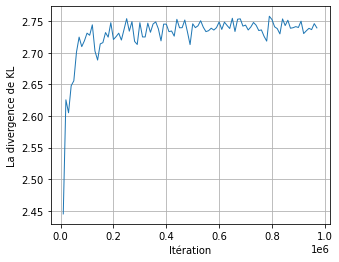

<Figure size 432x288 with 0 Axes>

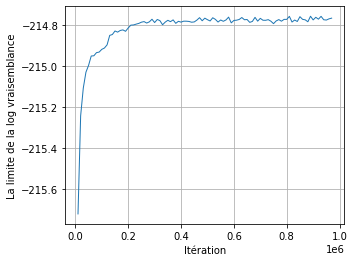

<Figure size 432x288 with 0 Axes>

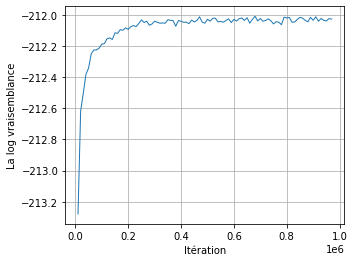

<Figure size 432x288 with 0 Axes>

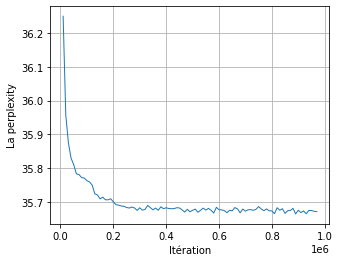

In [ ]:

elbo = []
global_step = []
kl = []
perplexity = []
reconstruction = []
loss = []
for i in range(len(Resultats)):
  elbo.append(Resultats[i]["elbo"])
  global_step.append(Resultats[i]["global_step"])
  kl.append(Resultats[i]["kl"])
  perplexity.append(Resultats[i]["perplexity"])
  reconstruction.append(Resultats[i]["reconstruction"])
  loss.append(Resultats[i]["loss"])


pylab.clf()
pylab.figure(num = None, figsize=(5, 4))
pylab.grid(True)
pylab.plot(global_step, kl, lw = 1)
pylab.xlabel('Itération')
pylab.ylabel('La divergence de KL')
pylab.savefig(os.path.join("/content/Images/", "KL.png"), bbox_inches="tight")
pylab.show()

pylab.clf()
pylab.figure(num = None, figsize=(5, 4))
pylab.grid(True)
pylab.plot(global_step, elbo, lw = 1)
pylab.xlabel('Itération')
pylab.ylabel('La limite de la log vraisemblance')
pylab.savefig(os.path.join("/content/Images/", "Limite_log_vraisemblance.png"), bbox_inches="tight")
pylab.show()



pylab.clf()
pylab.figure(num = None, figsize=(5, 4))
pylab.grid(True)
pylab.plot(global_step, reconstruction, lw = 1)
pylab.xlabel('Itération')
pylab.ylabel('La log vraisemblance')
pylab.savefig(os.path.join("/content/Images/", "log_vraisemblance.png"), bbox_inches="tight")
pylab.show()

pylab.clf()
pylab.figure(num = None, figsize=(5, 4))
pylab.grid(True)
pylab.plot(global_step, perplexity, lw = 1)
pylab.xlabel('Itération')
pylab.ylabel('La perplexity')
pylab.savefig(os.path.join("/content/Images/", "perplexity.png"), bbox_inches="tight")
pylab.show()


In [ ]:
global_step

[10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 110000,
 120000,
 130000,
 140000,
 150000,
 160000,
 170000,
 180000,
 190000,
 200000,
 210000,
 220000,
 230000,
 240000,
 250000,
 260000,
 270000,
 280000,
 290000,
 300000,
 310000,
 320000,
 330000,
 340000,
 350000,
 360000,
 370000,
 380000,
 390000,
 400000,
 410000,
 420000,
 430000,
 440000,
 450000,
 460000,
 470000,
 480000,
 490000,
 500000,
 510000,
 520000,
 530000,
 540000,
 550000,
 560000,
 570000,
 580000,
 590000,
 600000,
 610000,
 620000,
 630000,
 640000,
 650000,
 660000,
 670000,
 680000,
 690000,
 700000,
 710000,
 720000,
 730000,
 740000,
 750000,
 760000,
 770000,
 780000,
 790000,
 800000,
 810000,
 820000,
 830000,
 840000,
 850000,
 860000,
 870000,
 880000,
 890000,
 900000,
 910000,
 920000,
 930000,
 940000,
 950000,
 960000,
 970000]

In [ ]:
Resultats

[{'elbo': -215.72253,
  'global_step': 10000,
  'kl': 2.4449732,
  'loss': 215.98499,
  'perplexity': 36.249954,
  'reconstruction': -213.27757,
  'topics': array([b'index=0 alpha=0.70 are in change one states all state to counted individual leads as select from may',
         b'index=1 alpha=0.70 are probability dirichlet processes in after lejeune family of whose realizations theory stochastic gustav distributions',
         b'index=2 alpha=0.70 job to policy easier bankpolicies designed bank and make form creates description templates your are'],
        dtype=object)},
 {'elbo': -215.24367,
  'global_step': 20000,
  'kl': 2.6254647,
  'loss': 215.52856,
  'perplexity': 35.957497,
  'reconstruction': -212.61821,
  'topics': array([b'index=0 alpha=0.70 are one change in states state all counted individual leads may as to from the',
         b'index=1 alpha=0.70 probability are dirichlet processes after lejeune in family of realizations whose stochastic distributions theory gustav',
 